##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.2
    Uninstalling protobuf-4.23.2:
      Successfully uninstalled protobuf-4.23.2


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format.

> Note: This is different from the [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)


  8192/184801 [>.............................] - ETA: 0s


184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

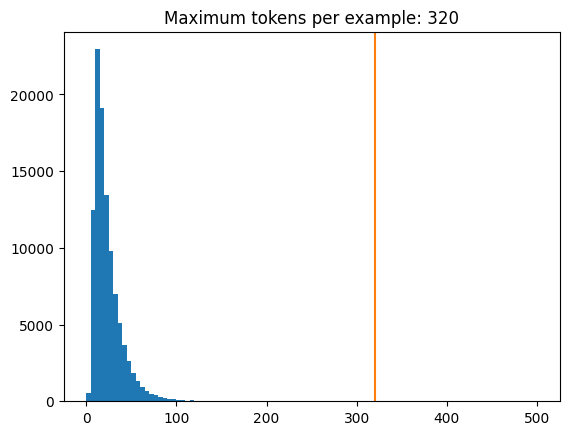

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [18]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Portuguese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [19]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 63)
(64, 59)
(64, 59)


The `en` and `en_labels` are the same, just shifted by 1:

In [20]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   87   83  149   50    9   56  664   85 2512], shape=(10,), dtype=int64)
tf.Tensor([  87   83  149   50    9   56  664   85 2512   15], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

Note: The code below implements it, but instead of interleaving the sines and cosines, the vectors of sines and cosines are simply concatenated. Permuting the channels like this is functionally equivalent, and just a little easier to implement and show in the plots below.

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


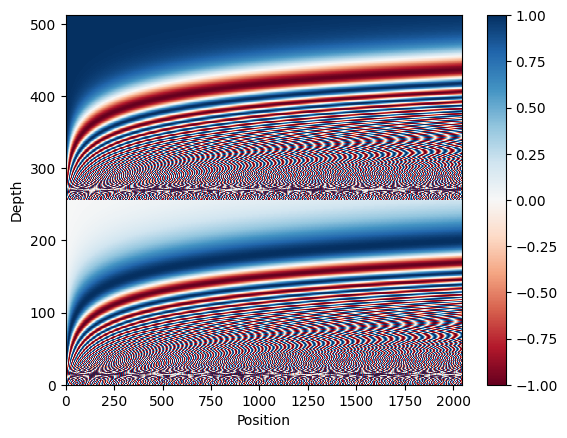

In [22]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

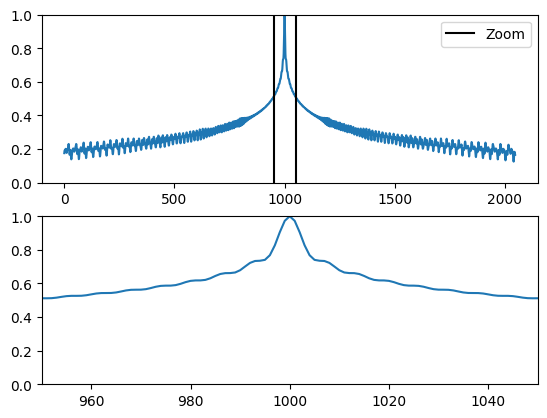

In [23]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

In [25]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [26]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 59), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, and not the length of the context `key/value` sequence.

The diagram is further simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [29]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 63, 512)
(64, 59, 512)


(64, 59, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [31]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 63, 512)
(64, 63, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [33]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 59, 512)
(64, 59, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [34]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

7.1525574e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [36]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 59, 512)
(64, 59, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [38]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 63, 512)


(64, 63, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [40]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 63)
(64, 63, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [42]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 59, 512)
(64, 63, 512)
(64, 59, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [44]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 59)
(64, 63, 512)
(64, 59, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 59, 63])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

> Note: The [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 3.4, shares the weight matrix between the embedding layer and the final linear layer. To keep things simple, this tutorial uses two separate weight matrices.

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 59)
(64, 63)
(64, 59, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 59, 63)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

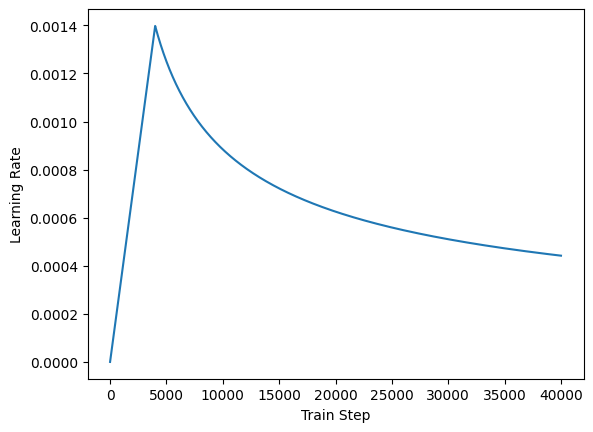

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20



  1/810 [..............................] - ETA: 7:00:07 - loss: 8.8816 - masked_accuracy: 0.0000e+00


  2/810 [..............................] - ETA: 6:37 - loss: 8.8836 - masked_accuracy: 0.0000e+00   


  3/810 [..............................] - ETA: 7:07 - loss: 8.8833 - masked_accuracy: 0.0000e+00


  4/810 [..............................] - ETA: 6:59 - loss: 8.8846 - masked_accuracy: 0.0000e+00


  5/810 [..............................] - ETA: 6:58 - loss: 8.8845 - masked_accuracy: 0.0000e+00


  6/810 [..............................] - ETA: 6:50 - loss: 8.8838 - masked_accuracy: 1.4594e-04


  7/810 [..............................] - ETA: 6:54 - loss: 8.8823 - masked_accuracy: 1.2509e-04


  8/810 [..............................] - ETA: 6:57 - loss: 8.8814 - masked_accuracy: 1.0946e-04


  9/810 [..............................] - ETA: 6:54 - loss: 8.8818 - masked_accuracy: 9.7295e-05


 10/810 [..............................] - ETA: 6:53 - loss: 8.8813 - masked_accuracy: 8.7566e-05


 11/810 [..............................] - ETA: 6:55 - loss: 8.8805 - masked_accuracy: 7.9605e-05


 12/810 [..............................] - ETA: 6:53 - loss: 8.8793 - masked_accuracy: 7.2971e-05


 13/810 [..............................] - ETA: 6:51 - loss: 8.8795 - masked_accuracy: 6.7358e-05


 14/810 [..............................] - ETA: 6:50 - loss: 8.8788 - masked_accuracy: 6.2547e-05


 15/810 [..............................] - ETA: 6:50 - loss: 8.8777 - masked_accuracy: 5.8377e-05


 16/810 [..............................] - ETA: 6:48 - loss: 8.8770 - masked_accuracy: 5.4729e-05


 17/810 [..............................] - ETA: 6:44 - loss: 8.8756 - masked_accuracy: 5.1509e-05


 18/810 [..............................] - ETA: 6:42 - loss: 8.8747 - masked_accuracy: 4.8648e-05


 19/810 [..............................] - ETA: 6:40 - loss: 8.8731 - masked_accuracy: 4.6087e-05


 20/810 [..............................] - ETA: 6:39 - loss: 8.8721 - masked_accuracy: 4.3783e-05


 21/810 [..............................] - ETA: 6:38 - loss: 8.8716 - masked_accuracy: 4.1698e-05


 22/810 [..............................] - ETA: 6:37 - loss: 8.8699 - masked_accuracy: 3.9803e-05


 23/810 [..............................] - ETA: 6:37 - loss: 8.8683 - masked_accuracy: 3.8072e-05


 24/810 [..............................] - ETA: 6:37 - loss: 8.8668 - masked_accuracy: 3.6486e-05


 25/810 [..............................] - ETA: 6:38 - loss: 8.8648 - masked_accuracy: 3.5026e-05


 26/810 [..............................] - ETA: 6:38 - loss: 8.8633 - masked_accuracy: 3.3679e-05


 27/810 [>.............................] - ETA: 6:38 - loss: 8.8616 - masked_accuracy: 3.2432e-05


 28/810 [>.............................] - ETA: 6:39 - loss: 8.8598 - masked_accuracy: 3.1273e-05


 29/810 [>.............................] - ETA: 6:39 - loss: 8.8581 - masked_accuracy: 3.0195e-05


 30/810 [>.............................] - ETA: 6:34 - loss: 8.8567 - masked_accuracy: 2.9189e-05


 31/810 [>.............................] - ETA: 6:27 - loss: 8.8550 - masked_accuracy: 4.9568e-05


 32/810 [>.............................] - ETA: 6:22 - loss: 8.8528 - masked_accuracy: 4.8019e-05


 33/810 [>.............................] - ETA: 6:21 - loss: 8.8509 - masked_accuracy: 6.7462e-05


 34/810 [>.............................] - ETA: 6:16 - loss: 8.8489 - masked_accuracy: 8.9178e-05


 35/810 [>.............................] - ETA: 6:12 - loss: 8.8471 - masked_accuracy: 8.6630e-05


 36/810 [>.............................] - ETA: 6:08 - loss: 8.8449 - masked_accuracy: 1.0241e-04


 37/810 [>.............................] - ETA: 6:09 - loss: 8.8428 - masked_accuracy: 1.6255e-04


 38/810 [>.............................] - ETA: 6:05 - loss: 8.8406 - masked_accuracy: 2.2835e-04


 39/810 [>.............................] - ETA: 6:01 - loss: 8.8384 - masked_accuracy: 2.4124e-04


 40/810 [>.............................] - ETA: 6:01 - loss: 8.8362 - masked_accuracy: 2.9040e-04


 41/810 [>.............................] - ETA: 6:00 - loss: 8.8337 - masked_accuracy: 3.9325e-04


 42/810 [>.............................] - ETA: 5:57 - loss: 8.8313 - masked_accuracy: 4.8147e-04


 43/810 [>.............................] - ETA: 5:56 - loss: 8.8286 - masked_accuracy: 7.0538e-04


 44/810 [>.............................] - ETA: 5:57 - loss: 8.8264 - masked_accuracy: 9.2462e-04


 45/810 [>.............................] - ETA: 5:57 - loss: 8.8241 - masked_accuracy: 0.0012    


 46/810 [>.............................] - ETA: 5:53 - loss: 8.8219 - masked_accuracy: 0.0016


 47/810 [>.............................] - ETA: 5:53 - loss: 8.8194 - masked_accuracy: 0.0022


 48/810 [>.............................] - ETA: 5:53 - loss: 8.8170 - masked_accuracy: 0.0027


 49/810 [>.............................] - ETA: 5:53 - loss: 8.8143 - masked_accuracy: 0.0033


 50/810 [>.............................] - ETA: 5:53 - loss: 8.8118 - masked_accuracy: 0.0040


 51/810 [>.............................] - ETA: 5:52 - loss: 8.8094 - masked_accuracy: 0.0049


 52/810 [>.............................] - ETA: 5:52 - loss: 8.8069 - masked_accuracy: 0.0058


 53/810 [>.............................] - ETA: 5:48 - loss: 8.8042 - masked_accuracy: 0.0068


 54/810 [=>............................] - ETA: 5:45 - loss: 8.8020 - masked_accuracy: 0.0078


 55/810 [=>............................] - ETA: 5:41 - loss: 8.7994 - masked_accuracy: 0.0088


 56/810 [=>............................] - ETA: 5:38 - loss: 8.7969 - masked_accuracy: 0.0096


 57/810 [=>............................] - ETA: 5:36 - loss: 8.7945 - masked_accuracy: 0.0104


 58/810 [=>............................] - ETA: 5:31 - loss: 8.7918 - masked_accuracy: 0.0113


 59/810 [=>............................] - ETA: 5:29 - loss: 8.7893 - masked_accuracy: 0.0122


 60/810 [=>............................] - ETA: 5:26 - loss: 8.7869 - masked_accuracy: 0.0131


 61/810 [=>............................] - ETA: 5:26 - loss: 8.7842 - masked_accuracy: 0.0140


 62/810 [=>............................] - ETA: 5:24 - loss: 8.7819 - masked_accuracy: 0.0148


 63/810 [=>............................] - ETA: 5:22 - loss: 8.7793 - masked_accuracy: 0.0157


 64/810 [=>............................] - ETA: 5:23 - loss: 8.7770 - masked_accuracy: 0.0164


 65/810 [=>............................] - ETA: 5:21 - loss: 8.7745 - masked_accuracy: 0.0170


 66/810 [=>............................] - ETA: 5:19 - loss: 8.7720 - masked_accuracy: 0.0177


 67/810 [=>............................] - ETA: 5:17 - loss: 8.7700 - masked_accuracy: 0.0184


 68/810 [=>............................] - ETA: 5:15 - loss: 8.7675 - masked_accuracy: 0.0191


 69/810 [=>............................] - ETA: 5:13 - loss: 8.7652 - masked_accuracy: 0.0199


 70/810 [=>............................] - ETA: 5:11 - loss: 8.7629 - masked_accuracy: 0.0205


 71/810 [=>............................] - ETA: 5:11 - loss: 8.7603 - masked_accuracy: 0.0212


 72/810 [=>............................] - ETA: 5:09 - loss: 8.7579 - masked_accuracy: 0.0220


 73/810 [=>............................] - ETA: 5:08 - loss: 8.7553 - masked_accuracy: 0.0226


 74/810 [=>............................] - ETA: 5:08 - loss: 8.7528 - masked_accuracy: 0.0232


 75/810 [=>............................] - ETA: 5:06 - loss: 8.7506 - masked_accuracy: 0.0237


 76/810 [=>............................] - ETA: 5:04 - loss: 8.7481 - masked_accuracy: 0.0243


 77/810 [=>............................] - ETA: 5:03 - loss: 8.7459 - masked_accuracy: 0.0248


 78/810 [=>............................] - ETA: 5:01 - loss: 8.7435 - masked_accuracy: 0.0254


 79/810 [=>............................] - ETA: 5:02 - loss: 8.7411 - masked_accuracy: 0.0257


 80/810 [=>............................] - ETA: 5:02 - loss: 8.7386 - masked_accuracy: 0.0261


 81/810 [==>...........................] - ETA: 5:02 - loss: 8.7361 - masked_accuracy: 0.0264


 82/810 [==>...........................] - ETA: 5:03 - loss: 8.7336 - masked_accuracy: 0.0268


 83/810 [==>...........................] - ETA: 5:01 - loss: 8.7313 - masked_accuracy: 0.0270


 84/810 [==>...........................] - ETA: 5:01 - loss: 8.7289 - masked_accuracy: 0.0273


 85/810 [==>...........................] - ETA: 4:58 - loss: 8.7265 - masked_accuracy: 0.0277


 86/810 [==>...........................] - ETA: 4:59 - loss: 8.7242 - masked_accuracy: 0.0281


 87/810 [==>...........................] - ETA: 4:57 - loss: 8.7220 - masked_accuracy: 0.0284


 88/810 [==>...........................] - ETA: 4:55 - loss: 8.7196 - masked_accuracy: 0.0286


 89/810 [==>...........................] - ETA: 4:53 - loss: 8.7172 - masked_accuracy: 0.0288


 90/810 [==>...........................] - ETA: 4:52 - loss: 8.7150 - masked_accuracy: 0.0291


 91/810 [==>...........................] - ETA: 4:51 - loss: 8.7127 - masked_accuracy: 0.0292


 92/810 [==>...........................] - ETA: 4:49 - loss: 8.7105 - masked_accuracy: 0.0294


 93/810 [==>...........................] - ETA: 4:50 - loss: 8.7082 - masked_accuracy: 0.0298


 94/810 [==>...........................] - ETA: 4:49 - loss: 8.7058 - masked_accuracy: 0.0301


 95/810 [==>...........................] - ETA: 4:50 - loss: 8.7035 - masked_accuracy: 0.0305


 96/810 [==>...........................] - ETA: 4:48 - loss: 8.7012 - masked_accuracy: 0.0308


 97/810 [==>...........................] - ETA: 4:46 - loss: 8.6991 - masked_accuracy: 0.0311


 98/810 [==>...........................] - ETA: 4:44 - loss: 8.6967 - masked_accuracy: 0.0313


 99/810 [==>...........................] - ETA: 4:43 - loss: 8.6944 - masked_accuracy: 0.0316


100/810 [==>...........................] - ETA: 4:43 - loss: 8.6923 - masked_accuracy: 0.0319


101/810 [==>...........................] - ETA: 4:42 - loss: 8.6900 - masked_accuracy: 0.0322


102/810 [==>...........................] - ETA: 4:42 - loss: 8.6877 - masked_accuracy: 0.0326


103/810 [==>...........................] - ETA: 4:40 - loss: 8.6855 - masked_accuracy: 0.0329


104/810 [==>...........................] - ETA: 4:40 - loss: 8.6832 - masked_accuracy: 0.0334


105/810 [==>...........................] - ETA: 4:38 - loss: 8.6809 - masked_accuracy: 0.0337


106/810 [==>...........................] - ETA: 4:37 - loss: 8.6786 - masked_accuracy: 0.0340


107/810 [==>...........................] - ETA: 4:35 - loss: 8.6764 - masked_accuracy: 0.0345


108/810 [===>..........................] - ETA: 4:34 - loss: 8.6740 - masked_accuracy: 0.0348


109/810 [===>..........................] - ETA: 4:35 - loss: 8.6718 - masked_accuracy: 0.0351


110/810 [===>..........................] - ETA: 4:35 - loss: 8.6695 - masked_accuracy: 0.0354


111/810 [===>..........................] - ETA: 4:34 - loss: 8.6672 - masked_accuracy: 0.0356


112/810 [===>..........................] - ETA: 4:33 - loss: 8.6649 - masked_accuracy: 0.0359


113/810 [===>..........................] - ETA: 4:33 - loss: 8.6627 - masked_accuracy: 0.0362


114/810 [===>..........................] - ETA: 4:31 - loss: 8.6603 - masked_accuracy: 0.0365


115/810 [===>..........................] - ETA: 4:31 - loss: 8.6578 - masked_accuracy: 0.0367


116/810 [===>..........................] - ETA: 4:30 - loss: 8.6556 - masked_accuracy: 0.0370


117/810 [===>..........................] - ETA: 4:30 - loss: 8.6532 - masked_accuracy: 0.0373


118/810 [===>..........................] - ETA: 4:30 - loss: 8.6509 - masked_accuracy: 0.0376


119/810 [===>..........................] - ETA: 4:30 - loss: 8.6487 - masked_accuracy: 0.0378


120/810 [===>..........................] - ETA: 4:28 - loss: 8.6464 - masked_accuracy: 0.0381


121/810 [===>..........................] - ETA: 4:27 - loss: 8.6442 - masked_accuracy: 0.0384


122/810 [===>..........................] - ETA: 4:26 - loss: 8.6417 - masked_accuracy: 0.0387


123/810 [===>..........................] - ETA: 4:26 - loss: 8.6393 - masked_accuracy: 0.0390


124/810 [===>..........................] - ETA: 4:24 - loss: 8.6369 - masked_accuracy: 0.0393


125/810 [===>..........................] - ETA: 4:24 - loss: 8.6345 - masked_accuracy: 0.0395


126/810 [===>..........................] - ETA: 4:23 - loss: 8.6320 - masked_accuracy: 0.0397


127/810 [===>..........................] - ETA: 4:22 - loss: 8.6295 - masked_accuracy: 0.0400


128/810 [===>..........................] - ETA: 4:22 - loss: 8.6270 - masked_accuracy: 0.0402


129/810 [===>..........................] - ETA: 4:22 - loss: 8.6245 - masked_accuracy: 0.0405


130/810 [===>..........................] - ETA: 4:22 - loss: 8.6219 - masked_accuracy: 0.0408


131/810 [===>..........................] - ETA: 4:20 - loss: 8.6194 - masked_accuracy: 0.0410


132/810 [===>..........................] - ETA: 4:20 - loss: 8.6171 - masked_accuracy: 0.0412


133/810 [===>..........................] - ETA: 4:20 - loss: 8.6148 - masked_accuracy: 0.0414


134/810 [===>..........................] - ETA: 4:21 - loss: 8.6122 - masked_accuracy: 0.0416


135/810 [====>.........................] - ETA: 4:20 - loss: 8.6098 - masked_accuracy: 0.0418


136/810 [====>.........................] - ETA: 4:19 - loss: 8.6071 - masked_accuracy: 0.0421


137/810 [====>.........................] - ETA: 4:18 - loss: 8.6046 - masked_accuracy: 0.0423


138/810 [====>.........................] - ETA: 4:18 - loss: 8.6021 - masked_accuracy: 0.0426


139/810 [====>.........................] - ETA: 4:17 - loss: 8.5996 - masked_accuracy: 0.0428


140/810 [====>.........................] - ETA: 4:16 - loss: 8.5970 - masked_accuracy: 0.0430


141/810 [====>.........................] - ETA: 4:17 - loss: 8.5946 - masked_accuracy: 0.0432


142/810 [====>.........................] - ETA: 4:17 - loss: 8.5921 - masked_accuracy: 0.0435


143/810 [====>.........................] - ETA: 4:15 - loss: 8.5898 - masked_accuracy: 0.0436


144/810 [====>.........................] - ETA: 4:16 - loss: 8.5871 - masked_accuracy: 0.0439


145/810 [====>.........................] - ETA: 4:15 - loss: 8.5844 - masked_accuracy: 0.0440


146/810 [====>.........................] - ETA: 4:14 - loss: 8.5818 - masked_accuracy: 0.0443


147/810 [====>.........................] - ETA: 4:13 - loss: 8.5790 - masked_accuracy: 0.0444


148/810 [====>.........................] - ETA: 4:13 - loss: 8.5765 - masked_accuracy: 0.0445


149/810 [====>.........................] - ETA: 4:12 - loss: 8.5739 - masked_accuracy: 0.0448


150/810 [====>.........................] - ETA: 4:12 - loss: 8.5711 - masked_accuracy: 0.0450


151/810 [====>.........................] - ETA: 4:10 - loss: 8.5684 - masked_accuracy: 0.0453


152/810 [====>.........................] - ETA: 4:09 - loss: 8.5658 - masked_accuracy: 0.0455


153/810 [====>.........................] - ETA: 4:08 - loss: 8.5632 - masked_accuracy: 0.0456


154/810 [====>.........................] - ETA: 4:07 - loss: 8.5605 - masked_accuracy: 0.0459


155/810 [====>.........................] - ETA: 4:07 - loss: 8.5578 - masked_accuracy: 0.0460


156/810 [====>.........................] - ETA: 4:06 - loss: 8.5551 - masked_accuracy: 0.0462


157/810 [====>.........................] - ETA: 4:06 - loss: 8.5525 - masked_accuracy: 0.0464


158/810 [====>.........................] - ETA: 4:04 - loss: 8.5497 - masked_accuracy: 0.0466


159/810 [====>.........................] - ETA: 4:04 - loss: 8.5471 - masked_accuracy: 0.0468


160/810 [====>.........................] - ETA: 4:02 - loss: 8.5445 - masked_accuracy: 0.0471


161/810 [====>.........................] - ETA: 4:03 - loss: 8.5419 - masked_accuracy: 0.0472


162/810 [=====>........................] - ETA: 4:02 - loss: 8.5391 - masked_accuracy: 0.0474


163/810 [=====>........................] - ETA: 4:01 - loss: 8.5363 - masked_accuracy: 0.0476


164/810 [=====>........................] - ETA: 4:01 - loss: 8.5337 - masked_accuracy: 0.0478


165/810 [=====>........................] - ETA: 4:00 - loss: 8.5309 - masked_accuracy: 0.0480


166/810 [=====>........................] - ETA: 4:00 - loss: 8.5280 - masked_accuracy: 0.0483


167/810 [=====>........................] - ETA: 3:59 - loss: 8.5251 - masked_accuracy: 0.0484


168/810 [=====>........................] - ETA: 3:58 - loss: 8.5222 - masked_accuracy: 0.0486


169/810 [=====>........................] - ETA: 3:58 - loss: 8.5194 - masked_accuracy: 0.0488


170/810 [=====>........................] - ETA: 3:57 - loss: 8.5165 - masked_accuracy: 0.0490


171/810 [=====>........................] - ETA: 3:56 - loss: 8.5137 - masked_accuracy: 0.0492


172/810 [=====>........................] - ETA: 3:56 - loss: 8.5108 - masked_accuracy: 0.0493


173/810 [=====>........................] - ETA: 3:56 - loss: 8.5075 - masked_accuracy: 0.0495


174/810 [=====>........................] - ETA: 3:56 - loss: 8.5049 - masked_accuracy: 0.0497


175/810 [=====>........................] - ETA: 3:55 - loss: 8.5019 - masked_accuracy: 0.0499


176/810 [=====>........................] - ETA: 3:54 - loss: 8.4992 - masked_accuracy: 0.0501


177/810 [=====>........................] - ETA: 3:52 - loss: 8.4963 - masked_accuracy: 0.0503


178/810 [=====>........................] - ETA: 3:51 - loss: 8.4933 - masked_accuracy: 0.0506


179/810 [=====>........................] - ETA: 3:51 - loss: 8.4904 - masked_accuracy: 0.0507


180/810 [=====>........................] - ETA: 3:51 - loss: 8.4872 - masked_accuracy: 0.0510


181/810 [=====>........................] - ETA: 3:50 - loss: 8.4842 - masked_accuracy: 0.0512


182/810 [=====>........................] - ETA: 3:49 - loss: 8.4814 - masked_accuracy: 0.0514


183/810 [=====>........................] - ETA: 3:49 - loss: 8.4782 - masked_accuracy: 0.0517


184/810 [=====>........................] - ETA: 3:47 - loss: 8.4751 - masked_accuracy: 0.0519


185/810 [=====>........................] - ETA: 3:46 - loss: 8.4721 - masked_accuracy: 0.0521


186/810 [=====>........................] - ETA: 3:45 - loss: 8.4691 - masked_accuracy: 0.0523


187/810 [=====>........................] - ETA: 3:44 - loss: 8.4661 - masked_accuracy: 0.0525


188/810 [=====>........................] - ETA: 3:44 - loss: 8.4632 - masked_accuracy: 0.0526


189/810 [======>.......................] - ETA: 3:43 - loss: 8.4599 - masked_accuracy: 0.0528


190/810 [======>.......................] - ETA: 3:42 - loss: 8.4567 - masked_accuracy: 0.0531


191/810 [======>.......................] - ETA: 3:41 - loss: 8.4534 - masked_accuracy: 0.0534


192/810 [======>.......................] - ETA: 3:41 - loss: 8.4503 - masked_accuracy: 0.0536


193/810 [======>.......................] - ETA: 3:40 - loss: 8.4470 - masked_accuracy: 0.0538


194/810 [======>.......................] - ETA: 3:40 - loss: 8.4439 - masked_accuracy: 0.0540


195/810 [======>.......................] - ETA: 3:39 - loss: 8.4406 - masked_accuracy: 0.0542


196/810 [======>.......................] - ETA: 3:39 - loss: 8.4375 - masked_accuracy: 0.0543


197/810 [======>.......................] - ETA: 3:38 - loss: 8.4343 - masked_accuracy: 0.0546


198/810 [======>.......................] - ETA: 3:38 - loss: 8.4314 - masked_accuracy: 0.0548


199/810 [======>.......................] - ETA: 3:38 - loss: 8.4283 - masked_accuracy: 0.0549


200/810 [======>.......................] - ETA: 3:38 - loss: 8.4250 - masked_accuracy: 0.0551


201/810 [======>.......................] - ETA: 3:37 - loss: 8.4217 - masked_accuracy: 0.0554


202/810 [======>.......................] - ETA: 3:36 - loss: 8.4184 - masked_accuracy: 0.0556


203/810 [======>.......................] - ETA: 3:36 - loss: 8.4152 - masked_accuracy: 0.0558


204/810 [======>.......................] - ETA: 3:35 - loss: 8.4121 - masked_accuracy: 0.0560


205/810 [======>.......................] - ETA: 3:34 - loss: 8.4085 - masked_accuracy: 0.0562


206/810 [======>.......................] - ETA: 3:33 - loss: 8.4051 - masked_accuracy: 0.0565


207/810 [======>.......................] - ETA: 3:32 - loss: 8.4018 - masked_accuracy: 0.0567


208/810 [======>.......................] - ETA: 3:31 - loss: 8.3988 - masked_accuracy: 0.0569


209/810 [======>.......................] - ETA: 3:31 - loss: 8.3952 - masked_accuracy: 0.0571


210/810 [======>.......................] - ETA: 3:30 - loss: 8.3917 - masked_accuracy: 0.0573


211/810 [======>.......................] - ETA: 3:29 - loss: 8.3883 - masked_accuracy: 0.0576


212/810 [======>.......................] - ETA: 3:28 - loss: 8.3848 - masked_accuracy: 0.0578


213/810 [======>.......................] - ETA: 3:28 - loss: 8.3813 - masked_accuracy: 0.0581


214/810 [======>.......................] - ETA: 3:28 - loss: 8.3780 - masked_accuracy: 0.0584


215/810 [======>.......................] - ETA: 3:27 - loss: 8.3744 - masked_accuracy: 0.0586


216/810 [=======>......................] - ETA: 3:27 - loss: 8.3712 - masked_accuracy: 0.0588


217/810 [=======>......................] - ETA: 3:26 - loss: 8.3677 - masked_accuracy: 0.0589


218/810 [=======>......................] - ETA: 3:25 - loss: 8.3641 - masked_accuracy: 0.0592


219/810 [=======>......................] - ETA: 3:25 - loss: 8.3608 - masked_accuracy: 0.0593


220/810 [=======>......................] - ETA: 3:25 - loss: 8.3575 - masked_accuracy: 0.0595


221/810 [=======>......................] - ETA: 3:25 - loss: 8.3542 - masked_accuracy: 0.0597


222/810 [=======>......................] - ETA: 3:24 - loss: 8.3506 - masked_accuracy: 0.0599


223/810 [=======>......................] - ETA: 3:23 - loss: 8.3471 - masked_accuracy: 0.0601


224/810 [=======>......................] - ETA: 3:22 - loss: 8.3435 - masked_accuracy: 0.0604


225/810 [=======>......................] - ETA: 3:22 - loss: 8.3401 - masked_accuracy: 0.0605


226/810 [=======>......................] - ETA: 3:21 - loss: 8.3365 - masked_accuracy: 0.0607


227/810 [=======>......................] - ETA: 3:21 - loss: 8.3332 - masked_accuracy: 0.0609


228/810 [=======>......................] - ETA: 3:20 - loss: 8.3294 - masked_accuracy: 0.0611


229/810 [=======>......................] - ETA: 3:19 - loss: 8.3258 - masked_accuracy: 0.0613


230/810 [=======>......................] - ETA: 3:18 - loss: 8.3221 - masked_accuracy: 0.0615


231/810 [=======>......................] - ETA: 3:18 - loss: 8.3185 - masked_accuracy: 0.0617


232/810 [=======>......................] - ETA: 3:17 - loss: 8.3150 - masked_accuracy: 0.0619


233/810 [=======>......................] - ETA: 3:16 - loss: 8.3113 - masked_accuracy: 0.0622


234/810 [=======>......................] - ETA: 3:15 - loss: 8.3076 - masked_accuracy: 0.0624


235/810 [=======>......................] - ETA: 3:14 - loss: 8.3040 - masked_accuracy: 0.0625


236/810 [=======>......................] - ETA: 3:13 - loss: 8.3000 - masked_accuracy: 0.0627


237/810 [=======>......................] - ETA: 3:13 - loss: 8.2962 - masked_accuracy: 0.0629


238/810 [=======>......................] - ETA: 3:12 - loss: 8.2925 - masked_accuracy: 0.0632


239/810 [=======>......................] - ETA: 3:12 - loss: 8.2889 - masked_accuracy: 0.0634


240/810 [=======>......................] - ETA: 3:11 - loss: 8.2853 - masked_accuracy: 0.0636


241/810 [=======>......................] - ETA: 3:10 - loss: 8.2815 - masked_accuracy: 0.0639


242/810 [=======>......................] - ETA: 3:10 - loss: 8.2776 - masked_accuracy: 0.0641


243/810 [========>.....................] - ETA: 3:09 - loss: 8.2738 - masked_accuracy: 0.0643


244/810 [========>.....................] - ETA: 3:09 - loss: 8.2700 - masked_accuracy: 0.0645


245/810 [========>.....................] - ETA: 3:08 - loss: 8.2662 - masked_accuracy: 0.0647


246/810 [========>.....................] - ETA: 3:07 - loss: 8.2625 - masked_accuracy: 0.0649


247/810 [========>.....................] - ETA: 3:07 - loss: 8.2589 - masked_accuracy: 0.0651


248/810 [========>.....................] - ETA: 3:07 - loss: 8.2553 - masked_accuracy: 0.0653


249/810 [========>.....................] - ETA: 3:06 - loss: 8.2515 - masked_accuracy: 0.0655


250/810 [========>.....................] - ETA: 3:05 - loss: 8.2478 - masked_accuracy: 0.0657


251/810 [========>.....................] - ETA: 3:05 - loss: 8.2438 - masked_accuracy: 0.0659


252/810 [========>.....................] - ETA: 3:04 - loss: 8.2401 - masked_accuracy: 0.0661


253/810 [========>.....................] - ETA: 3:03 - loss: 8.2362 - masked_accuracy: 0.0664


254/810 [========>.....................] - ETA: 3:03 - loss: 8.2323 - masked_accuracy: 0.0666


255/810 [========>.....................] - ETA: 3:02 - loss: 8.2282 - masked_accuracy: 0.0668


256/810 [========>.....................] - ETA: 3:02 - loss: 8.2241 - masked_accuracy: 0.0670


257/810 [========>.....................] - ETA: 3:01 - loss: 8.2200 - masked_accuracy: 0.0672


258/810 [========>.....................] - ETA: 3:01 - loss: 8.2160 - masked_accuracy: 0.0675


259/810 [========>.....................] - ETA: 3:00 - loss: 8.2120 - masked_accuracy: 0.0677


260/810 [========>.....................] - ETA: 3:00 - loss: 8.2080 - masked_accuracy: 0.0679


261/810 [========>.....................] - ETA: 2:59 - loss: 8.2043 - masked_accuracy: 0.0681


262/810 [========>.....................] - ETA: 2:59 - loss: 8.2006 - masked_accuracy: 0.0683


263/810 [========>.....................] - ETA: 2:58 - loss: 8.1970 - masked_accuracy: 0.0684


264/810 [========>.....................] - ETA: 2:57 - loss: 8.1931 - masked_accuracy: 0.0687


265/810 [========>.....................] - ETA: 2:56 - loss: 8.1891 - masked_accuracy: 0.0689


266/810 [========>.....................] - ETA: 2:56 - loss: 8.1854 - masked_accuracy: 0.0691


267/810 [========>.....................] - ETA: 2:56 - loss: 8.1817 - masked_accuracy: 0.0693


268/810 [========>.....................] - ETA: 2:55 - loss: 8.1778 - masked_accuracy: 0.0694


269/810 [========>.....................] - ETA: 2:55 - loss: 8.1736 - masked_accuracy: 0.0697


270/810 [=========>....................] - ETA: 2:54 - loss: 8.1696 - masked_accuracy: 0.0699


271/810 [=========>....................] - ETA: 2:54 - loss: 8.1657 - masked_accuracy: 0.0701


272/810 [=========>....................] - ETA: 2:53 - loss: 8.1620 - masked_accuracy: 0.0703


273/810 [=========>....................] - ETA: 2:53 - loss: 8.1580 - masked_accuracy: 0.0705


274/810 [=========>....................] - ETA: 2:52 - loss: 8.1539 - masked_accuracy: 0.0707


275/810 [=========>....................] - ETA: 2:52 - loss: 8.1499 - masked_accuracy: 0.0709


276/810 [=========>....................] - ETA: 2:51 - loss: 8.1459 - masked_accuracy: 0.0711


277/810 [=========>....................] - ETA: 2:50 - loss: 8.1419 - masked_accuracy: 0.0713


278/810 [=========>....................] - ETA: 2:50 - loss: 8.1378 - masked_accuracy: 0.0714


279/810 [=========>....................] - ETA: 2:49 - loss: 8.1337 - masked_accuracy: 0.0717


280/810 [=========>....................] - ETA: 2:49 - loss: 8.1295 - masked_accuracy: 0.0719


281/810 [=========>....................] - ETA: 2:48 - loss: 8.1256 - masked_accuracy: 0.0721


282/810 [=========>....................] - ETA: 2:47 - loss: 8.1216 - masked_accuracy: 0.0723


283/810 [=========>....................] - ETA: 2:47 - loss: 8.1177 - masked_accuracy: 0.0725


284/810 [=========>....................] - ETA: 2:46 - loss: 8.1137 - masked_accuracy: 0.0727


285/810 [=========>....................] - ETA: 2:46 - loss: 8.1100 - masked_accuracy: 0.0729


286/810 [=========>....................] - ETA: 2:45 - loss: 8.1060 - masked_accuracy: 0.0730


287/810 [=========>....................] - ETA: 2:45 - loss: 8.1017 - masked_accuracy: 0.0733


288/810 [=========>....................] - ETA: 2:44 - loss: 8.0975 - masked_accuracy: 0.0735


289/810 [=========>....................] - ETA: 2:44 - loss: 8.0934 - masked_accuracy: 0.0737


290/810 [=========>....................] - ETA: 2:43 - loss: 8.0895 - masked_accuracy: 0.0739


291/810 [=========>....................] - ETA: 2:43 - loss: 8.0857 - masked_accuracy: 0.0741


292/810 [=========>....................] - ETA: 2:42 - loss: 8.0815 - masked_accuracy: 0.0743


293/810 [=========>....................] - ETA: 2:42 - loss: 8.0775 - masked_accuracy: 0.0744


294/810 [=========>....................] - ETA: 2:41 - loss: 8.0734 - masked_accuracy: 0.0746


295/810 [=========>....................] - ETA: 2:41 - loss: 8.0693 - masked_accuracy: 0.0748


296/810 [=========>....................] - ETA: 2:40 - loss: 8.0656 - masked_accuracy: 0.0750


297/810 [==========>...................] - ETA: 2:40 - loss: 8.0615 - masked_accuracy: 0.0752


298/810 [==========>...................] - ETA: 2:39 - loss: 8.0574 - masked_accuracy: 0.0754


299/810 [==========>...................] - ETA: 2:39 - loss: 8.0535 - masked_accuracy: 0.0756


300/810 [==========>...................] - ETA: 2:38 - loss: 8.0493 - masked_accuracy: 0.0757


301/810 [==========>...................] - ETA: 2:38 - loss: 8.0453 - masked_accuracy: 0.0759


302/810 [==========>...................] - ETA: 2:37 - loss: 8.0414 - masked_accuracy: 0.0760


303/810 [==========>...................] - ETA: 2:37 - loss: 8.0377 - masked_accuracy: 0.0761


304/810 [==========>...................] - ETA: 2:36 - loss: 8.0337 - masked_accuracy: 0.0763


305/810 [==========>...................] - ETA: 2:36 - loss: 8.0297 - masked_accuracy: 0.0764


306/810 [==========>...................] - ETA: 2:36 - loss: 8.0256 - masked_accuracy: 0.0767


307/810 [==========>...................] - ETA: 2:35 - loss: 8.0216 - masked_accuracy: 0.0768


308/810 [==========>...................] - ETA: 2:35 - loss: 8.0178 - masked_accuracy: 0.0770


309/810 [==========>...................] - ETA: 2:34 - loss: 8.0138 - masked_accuracy: 0.0772


310/810 [==========>...................] - ETA: 2:34 - loss: 8.0097 - masked_accuracy: 0.0773


311/810 [==========>...................] - ETA: 2:33 - loss: 8.0056 - masked_accuracy: 0.0775


312/810 [==========>...................] - ETA: 2:33 - loss: 8.0017 - masked_accuracy: 0.0776


313/810 [==========>...................] - ETA: 2:33 - loss: 7.9979 - masked_accuracy: 0.0778


314/810 [==========>...................] - ETA: 2:32 - loss: 7.9936 - masked_accuracy: 0.0780


315/810 [==========>...................] - ETA: 2:32 - loss: 7.9895 - masked_accuracy: 0.0782


316/810 [==========>...................] - ETA: 2:31 - loss: 7.9856 - masked_accuracy: 0.0783


317/810 [==========>...................] - ETA: 2:31 - loss: 7.9817 - masked_accuracy: 0.0785


318/810 [==========>...................] - ETA: 2:30 - loss: 7.9774 - masked_accuracy: 0.0787


319/810 [==========>...................] - ETA: 2:30 - loss: 7.9735 - masked_accuracy: 0.0788


320/810 [==========>...................] - ETA: 2:29 - loss: 7.9695 - masked_accuracy: 0.0790


321/810 [==========>...................] - ETA: 2:29 - loss: 7.9655 - masked_accuracy: 0.0791


322/810 [==========>...................] - ETA: 2:28 - loss: 7.9617 - masked_accuracy: 0.0792


323/810 [==========>...................] - ETA: 2:28 - loss: 7.9578 - masked_accuracy: 0.0794


324/810 [===========>..................] - ETA: 2:28 - loss: 7.9542 - masked_accuracy: 0.0795


325/810 [===========>..................] - ETA: 2:27 - loss: 7.9503 - masked_accuracy: 0.0797


326/810 [===========>..................] - ETA: 2:27 - loss: 7.9463 - masked_accuracy: 0.0799


327/810 [===========>..................] - ETA: 2:26 - loss: 7.9424 - masked_accuracy: 0.0800


328/810 [===========>..................] - ETA: 2:26 - loss: 7.9385 - masked_accuracy: 0.0802


329/810 [===========>..................] - ETA: 2:26 - loss: 7.9344 - masked_accuracy: 0.0803


330/810 [===========>..................] - ETA: 2:25 - loss: 7.9305 - masked_accuracy: 0.0805


331/810 [===========>..................] - ETA: 2:25 - loss: 7.9267 - masked_accuracy: 0.0807


332/810 [===========>..................] - ETA: 2:24 - loss: 7.9227 - masked_accuracy: 0.0809


333/810 [===========>..................] - ETA: 2:24 - loss: 7.9183 - masked_accuracy: 0.0810


334/810 [===========>..................] - ETA: 2:23 - loss: 7.9142 - masked_accuracy: 0.0812


335/810 [===========>..................] - ETA: 2:23 - loss: 7.9100 - masked_accuracy: 0.0814


336/810 [===========>..................] - ETA: 2:22 - loss: 7.9060 - masked_accuracy: 0.0816


337/810 [===========>..................] - ETA: 2:22 - loss: 7.9019 - masked_accuracy: 0.0817


338/810 [===========>..................] - ETA: 2:22 - loss: 7.8976 - masked_accuracy: 0.0819


339/810 [===========>..................] - ETA: 2:21 - loss: 7.8935 - masked_accuracy: 0.0821


340/810 [===========>..................] - ETA: 2:21 - loss: 7.8897 - masked_accuracy: 0.0823


341/810 [===========>..................] - ETA: 2:20 - loss: 7.8853 - masked_accuracy: 0.0825


342/810 [===========>..................] - ETA: 2:20 - loss: 7.8814 - masked_accuracy: 0.0826


343/810 [===========>..................] - ETA: 2:19 - loss: 7.8774 - masked_accuracy: 0.0828


344/810 [===========>..................] - ETA: 2:19 - loss: 7.8734 - masked_accuracy: 0.0829


345/810 [===========>..................] - ETA: 2:18 - loss: 7.8694 - masked_accuracy: 0.0830


346/810 [===========>..................] - ETA: 2:18 - loss: 7.8652 - masked_accuracy: 0.0832


347/810 [===========>..................] - ETA: 2:18 - loss: 7.8613 - masked_accuracy: 0.0834


348/810 [===========>..................] - ETA: 2:17 - loss: 7.8571 - masked_accuracy: 0.0836


349/810 [===========>..................] - ETA: 2:17 - loss: 7.8531 - masked_accuracy: 0.0837


350/810 [===========>..................] - ETA: 2:17 - loss: 7.8495 - masked_accuracy: 0.0838


351/810 [============>.................] - ETA: 2:16 - loss: 7.8457 - masked_accuracy: 0.0840


352/810 [============>.................] - ETA: 2:16 - loss: 7.8418 - masked_accuracy: 0.0841


353/810 [============>.................] - ETA: 2:15 - loss: 7.8376 - masked_accuracy: 0.0843


354/810 [============>.................] - ETA: 2:15 - loss: 7.8340 - masked_accuracy: 0.0844


355/810 [============>.................] - ETA: 2:14 - loss: 7.8300 - masked_accuracy: 0.0845


356/810 [============>.................] - ETA: 2:14 - loss: 7.8265 - masked_accuracy: 0.0847


357/810 [============>.................] - ETA: 2:13 - loss: 7.8226 - masked_accuracy: 0.0849


358/810 [============>.................] - ETA: 2:13 - loss: 7.8184 - masked_accuracy: 0.0851


359/810 [============>.................] - ETA: 2:13 - loss: 7.8145 - masked_accuracy: 0.0852


360/810 [============>.................] - ETA: 2:12 - loss: 7.8103 - masked_accuracy: 0.0853


361/810 [============>.................] - ETA: 2:12 - loss: 7.8063 - masked_accuracy: 0.0855


362/810 [============>.................] - ETA: 2:12 - loss: 7.8024 - masked_accuracy: 0.0856


363/810 [============>.................] - ETA: 2:11 - loss: 7.7986 - masked_accuracy: 0.0857


364/810 [============>.................] - ETA: 2:11 - loss: 7.7947 - masked_accuracy: 0.0858


365/810 [============>.................] - ETA: 2:10 - loss: 7.7910 - masked_accuracy: 0.0860


366/810 [============>.................] - ETA: 2:10 - loss: 7.7871 - masked_accuracy: 0.0862


367/810 [============>.................] - ETA: 2:09 - loss: 7.7834 - masked_accuracy: 0.0863


368/810 [============>.................] - ETA: 2:09 - loss: 7.7795 - masked_accuracy: 0.0865


369/810 [============>.................] - ETA: 2:09 - loss: 7.7757 - masked_accuracy: 0.0866


370/810 [============>.................] - ETA: 2:08 - loss: 7.7721 - masked_accuracy: 0.0867


371/810 [============>.................] - ETA: 2:08 - loss: 7.7684 - masked_accuracy: 0.0868


372/810 [============>.................] - ETA: 2:07 - loss: 7.7646 - masked_accuracy: 0.0869


373/810 [============>.................] - ETA: 2:07 - loss: 7.7608 - masked_accuracy: 0.0871


374/810 [============>.................] - ETA: 2:07 - loss: 7.7571 - masked_accuracy: 0.0873


375/810 [============>.................] - ETA: 2:06 - loss: 7.7532 - masked_accuracy: 0.0874


376/810 [============>.................] - ETA: 2:06 - loss: 7.7495 - masked_accuracy: 0.0875


377/810 [============>.................] - ETA: 2:05 - loss: 7.7454 - masked_accuracy: 0.0877


378/810 [=============>................] - ETA: 2:05 - loss: 7.7415 - masked_accuracy: 0.0878


379/810 [=============>................] - ETA: 2:04 - loss: 7.7379 - masked_accuracy: 0.0879


380/810 [=============>................] - ETA: 2:04 - loss: 7.7341 - masked_accuracy: 0.0881


381/810 [=============>................] - ETA: 2:04 - loss: 7.7302 - masked_accuracy: 0.0882


382/810 [=============>................] - ETA: 2:03 - loss: 7.7266 - masked_accuracy: 0.0883


383/810 [=============>................] - ETA: 2:03 - loss: 7.7229 - masked_accuracy: 0.0885


384/810 [=============>................] - ETA: 2:02 - loss: 7.7193 - masked_accuracy: 0.0886


385/810 [=============>................] - ETA: 2:02 - loss: 7.7156 - masked_accuracy: 0.0887


386/810 [=============>................] - ETA: 2:02 - loss: 7.7119 - masked_accuracy: 0.0888


387/810 [=============>................] - ETA: 2:02 - loss: 7.7083 - masked_accuracy: 0.0889


388/810 [=============>................] - ETA: 2:01 - loss: 7.7046 - masked_accuracy: 0.0890


389/810 [=============>................] - ETA: 2:01 - loss: 7.7006 - masked_accuracy: 0.0892


390/810 [=============>................] - ETA: 2:01 - loss: 7.6970 - masked_accuracy: 0.0894


391/810 [=============>................] - ETA: 2:00 - loss: 7.6934 - masked_accuracy: 0.0895


392/810 [=============>................] - ETA: 2:00 - loss: 7.6899 - masked_accuracy: 0.0896


393/810 [=============>................] - ETA: 1:59 - loss: 7.6864 - masked_accuracy: 0.0897


394/810 [=============>................] - ETA: 1:59 - loss: 7.6827 - masked_accuracy: 0.0898


395/810 [=============>................] - ETA: 1:59 - loss: 7.6791 - masked_accuracy: 0.0900


396/810 [=============>................] - ETA: 1:58 - loss: 7.6756 - masked_accuracy: 0.0901


397/810 [=============>................] - ETA: 1:58 - loss: 7.6721 - masked_accuracy: 0.0902


398/810 [=============>................] - ETA: 1:57 - loss: 7.6685 - masked_accuracy: 0.0904


399/810 [=============>................] - ETA: 1:57 - loss: 7.6648 - masked_accuracy: 0.0905


400/810 [=============>................] - ETA: 1:57 - loss: 7.6611 - masked_accuracy: 0.0906


401/810 [=============>................] - ETA: 1:56 - loss: 7.6575 - masked_accuracy: 0.0907


402/810 [=============>................] - ETA: 1:56 - loss: 7.6538 - masked_accuracy: 0.0908


403/810 [=============>................] - ETA: 1:55 - loss: 7.6503 - masked_accuracy: 0.0910


404/810 [=============>................] - ETA: 1:55 - loss: 7.6469 - masked_accuracy: 0.0911


405/810 [==============>...............] - ETA: 1:55 - loss: 7.6434 - masked_accuracy: 0.0913


406/810 [==============>...............] - ETA: 1:54 - loss: 7.6397 - masked_accuracy: 0.0914


407/810 [==============>...............] - ETA: 1:54 - loss: 7.6361 - masked_accuracy: 0.0915


408/810 [==============>...............] - ETA: 1:53 - loss: 7.6325 - masked_accuracy: 0.0916


409/810 [==============>...............] - ETA: 1:53 - loss: 7.6290 - masked_accuracy: 0.0917


410/810 [==============>...............] - ETA: 1:53 - loss: 7.6254 - masked_accuracy: 0.0919


411/810 [==============>...............] - ETA: 1:52 - loss: 7.6219 - masked_accuracy: 0.0920


412/810 [==============>...............] - ETA: 1:52 - loss: 7.6182 - masked_accuracy: 0.0921


413/810 [==============>...............] - ETA: 1:52 - loss: 7.6148 - masked_accuracy: 0.0923


414/810 [==============>...............] - ETA: 1:52 - loss: 7.6112 - masked_accuracy: 0.0924


415/810 [==============>...............] - ETA: 1:51 - loss: 7.6076 - masked_accuracy: 0.0926


416/810 [==============>...............] - ETA: 1:51 - loss: 7.6043 - masked_accuracy: 0.0927


417/810 [==============>...............] - ETA: 1:50 - loss: 7.6010 - masked_accuracy: 0.0928


418/810 [==============>...............] - ETA: 1:50 - loss: 7.5976 - masked_accuracy: 0.0930


419/810 [==============>...............] - ETA: 1:50 - loss: 7.5943 - masked_accuracy: 0.0931


420/810 [==============>...............] - ETA: 1:50 - loss: 7.5911 - masked_accuracy: 0.0932


421/810 [==============>...............] - ETA: 1:49 - loss: 7.5875 - masked_accuracy: 0.0934


422/810 [==============>...............] - ETA: 1:49 - loss: 7.5839 - masked_accuracy: 0.0936


423/810 [==============>...............] - ETA: 1:49 - loss: 7.5802 - masked_accuracy: 0.0937


424/810 [==============>...............] - ETA: 1:49 - loss: 7.5771 - masked_accuracy: 0.0938


425/810 [==============>...............] - ETA: 1:49 - loss: 7.5732 - masked_accuracy: 0.0940


426/810 [==============>...............] - ETA: 1:48 - loss: 7.5700 - masked_accuracy: 0.0941


427/810 [==============>...............] - ETA: 1:48 - loss: 7.5668 - masked_accuracy: 0.0943


428/810 [==============>...............] - ETA: 1:47 - loss: 7.5633 - masked_accuracy: 0.0944


429/810 [==============>...............] - ETA: 1:47 - loss: 7.5603 - masked_accuracy: 0.0945


430/810 [==============>...............] - ETA: 1:47 - loss: 7.5570 - masked_accuracy: 0.0946


431/810 [==============>...............] - ETA: 1:46 - loss: 7.5538 - masked_accuracy: 0.0947


432/810 [===============>..............] - ETA: 1:46 - loss: 7.5507 - masked_accuracy: 0.0948


433/810 [===============>..............] - ETA: 1:46 - loss: 7.5475 - masked_accuracy: 0.0950


434/810 [===============>..............] - ETA: 1:45 - loss: 7.5439 - masked_accuracy: 0.0951


435/810 [===============>..............] - ETA: 1:45 - loss: 7.5409 - masked_accuracy: 0.0953


436/810 [===============>..............] - ETA: 1:45 - loss: 7.5373 - masked_accuracy: 0.0954


437/810 [===============>..............] - ETA: 1:44 - loss: 7.5338 - masked_accuracy: 0.0956


438/810 [===============>..............] - ETA: 1:44 - loss: 7.5304 - masked_accuracy: 0.0957


439/810 [===============>..............] - ETA: 1:44 - loss: 7.5272 - masked_accuracy: 0.0958


440/810 [===============>..............] - ETA: 1:43 - loss: 7.5238 - masked_accuracy: 0.0960


441/810 [===============>..............] - ETA: 1:43 - loss: 7.5202 - masked_accuracy: 0.0961


442/810 [===============>..............] - ETA: 1:43 - loss: 7.5165 - masked_accuracy: 0.0963


443/810 [===============>..............] - ETA: 1:43 - loss: 7.5132 - masked_accuracy: 0.0965


444/810 [===============>..............] - ETA: 1:42 - loss: 7.5099 - masked_accuracy: 0.0966


445/810 [===============>..............] - ETA: 1:42 - loss: 7.5066 - masked_accuracy: 0.0968


446/810 [===============>..............] - ETA: 1:41 - loss: 7.5033 - masked_accuracy: 0.0969


447/810 [===============>..............] - ETA: 1:41 - loss: 7.5002 - masked_accuracy: 0.0971


448/810 [===============>..............] - ETA: 1:41 - loss: 7.4968 - masked_accuracy: 0.0972


449/810 [===============>..............] - ETA: 1:40 - loss: 7.4935 - masked_accuracy: 0.0973


450/810 [===============>..............] - ETA: 1:40 - loss: 7.4902 - masked_accuracy: 0.0975


451/810 [===============>..............] - ETA: 1:39 - loss: 7.4873 - masked_accuracy: 0.0976


452/810 [===============>..............] - ETA: 1:39 - loss: 7.4839 - masked_accuracy: 0.0978


453/810 [===============>..............] - ETA: 1:39 - loss: 7.4805 - masked_accuracy: 0.0980


454/810 [===============>..............] - ETA: 1:38 - loss: 7.4774 - masked_accuracy: 0.0981


455/810 [===============>..............] - ETA: 1:38 - loss: 7.4739 - masked_accuracy: 0.0982


456/810 [===============>..............] - ETA: 1:38 - loss: 7.4707 - masked_accuracy: 0.0984


457/810 [===============>..............] - ETA: 1:37 - loss: 7.4673 - masked_accuracy: 0.0985


458/810 [===============>..............] - ETA: 1:37 - loss: 7.4637 - masked_accuracy: 0.0987


459/810 [================>.............] - ETA: 1:37 - loss: 7.4602 - masked_accuracy: 0.0989


460/810 [================>.............] - ETA: 1:36 - loss: 7.4571 - masked_accuracy: 0.0991


461/810 [================>.............] - ETA: 1:36 - loss: 7.4541 - masked_accuracy: 0.0992


462/810 [================>.............] - ETA: 1:36 - loss: 7.4506 - masked_accuracy: 0.0994


463/810 [================>.............] - ETA: 1:35 - loss: 7.4473 - masked_accuracy: 0.0995


464/810 [================>.............] - ETA: 1:35 - loss: 7.4442 - masked_accuracy: 0.0997


465/810 [================>.............] - ETA: 1:35 - loss: 7.4415 - masked_accuracy: 0.0998


466/810 [================>.............] - ETA: 1:34 - loss: 7.4385 - masked_accuracy: 0.0999


467/810 [================>.............] - ETA: 1:34 - loss: 7.4355 - masked_accuracy: 0.1001


468/810 [================>.............] - ETA: 1:33 - loss: 7.4322 - masked_accuracy: 0.1003


469/810 [================>.............] - ETA: 1:33 - loss: 7.4292 - masked_accuracy: 0.1004


470/810 [================>.............] - ETA: 1:33 - loss: 7.4260 - masked_accuracy: 0.1005


471/810 [================>.............] - ETA: 1:32 - loss: 7.4228 - masked_accuracy: 0.1007


472/810 [================>.............] - ETA: 1:32 - loss: 7.4197 - masked_accuracy: 0.1008


473/810 [================>.............] - ETA: 1:32 - loss: 7.4166 - masked_accuracy: 0.1009


474/810 [================>.............] - ETA: 1:31 - loss: 7.4135 - masked_accuracy: 0.1011


475/810 [================>.............] - ETA: 1:31 - loss: 7.4103 - masked_accuracy: 0.1012


476/810 [================>.............] - ETA: 1:31 - loss: 7.4072 - masked_accuracy: 0.1014


477/810 [================>.............] - ETA: 1:30 - loss: 7.4043 - masked_accuracy: 0.1015


478/810 [================>.............] - ETA: 1:30 - loss: 7.4015 - masked_accuracy: 0.1016


479/810 [================>.............] - ETA: 1:29 - loss: 7.3982 - masked_accuracy: 0.1017


480/810 [================>.............] - ETA: 1:29 - loss: 7.3951 - masked_accuracy: 0.1019


481/810 [================>.............] - ETA: 1:29 - loss: 7.3921 - masked_accuracy: 0.1020


482/810 [================>.............] - ETA: 1:28 - loss: 7.3889 - masked_accuracy: 0.1022


483/810 [================>.............] - ETA: 1:28 - loss: 7.3860 - masked_accuracy: 0.1023


484/810 [================>.............] - ETA: 1:28 - loss: 7.3828 - masked_accuracy: 0.1025


485/810 [================>.............] - ETA: 1:27 - loss: 7.3799 - masked_accuracy: 0.1026


486/810 [=================>............] - ETA: 1:27 - loss: 7.3764 - masked_accuracy: 0.1028


487/810 [=================>............] - ETA: 1:27 - loss: 7.3732 - masked_accuracy: 0.1030


488/810 [=================>............] - ETA: 1:27 - loss: 7.3701 - masked_accuracy: 0.1032


489/810 [=================>............] - ETA: 1:26 - loss: 7.3673 - masked_accuracy: 0.1033


490/810 [=================>............] - ETA: 1:26 - loss: 7.3645 - masked_accuracy: 0.1035


491/810 [=================>............] - ETA: 1:26 - loss: 7.3617 - masked_accuracy: 0.1036


492/810 [=================>............] - ETA: 1:25 - loss: 7.3581 - masked_accuracy: 0.1038


493/810 [=================>............] - ETA: 1:25 - loss: 7.3550 - masked_accuracy: 0.1040


494/810 [=================>............] - ETA: 1:25 - loss: 7.3526 - masked_accuracy: 0.1041


495/810 [=================>............] - ETA: 1:24 - loss: 7.3492 - masked_accuracy: 0.1043


496/810 [=================>............] - ETA: 1:24 - loss: 7.3462 - masked_accuracy: 0.1044


497/810 [=================>............] - ETA: 1:24 - loss: 7.3433 - masked_accuracy: 0.1045


498/810 [=================>............] - ETA: 1:23 - loss: 7.3404 - masked_accuracy: 0.1047


499/810 [=================>............] - ETA: 1:23 - loss: 7.3372 - masked_accuracy: 0.1048


500/810 [=================>............] - ETA: 1:23 - loss: 7.3340 - masked_accuracy: 0.1049


501/810 [=================>............] - ETA: 1:22 - loss: 7.3310 - masked_accuracy: 0.1051


502/810 [=================>............] - ETA: 1:22 - loss: 7.3283 - masked_accuracy: 0.1052


503/810 [=================>............] - ETA: 1:22 - loss: 7.3253 - masked_accuracy: 0.1053


504/810 [=================>............] - ETA: 1:22 - loss: 7.3219 - masked_accuracy: 0.1055


505/810 [=================>............] - ETA: 1:21 - loss: 7.3188 - masked_accuracy: 0.1057


506/810 [=================>............] - ETA: 1:21 - loss: 7.3159 - masked_accuracy: 0.1058


507/810 [=================>............] - ETA: 1:21 - loss: 7.3128 - masked_accuracy: 0.1060


508/810 [=================>............] - ETA: 1:20 - loss: 7.3096 - masked_accuracy: 0.1061


509/810 [=================>............] - ETA: 1:20 - loss: 7.3067 - masked_accuracy: 0.1063


510/810 [=================>............] - ETA: 1:20 - loss: 7.3038 - masked_accuracy: 0.1064


511/810 [=================>............] - ETA: 1:19 - loss: 7.3010 - masked_accuracy: 0.1065


512/810 [=================>............] - ETA: 1:19 - loss: 7.2982 - masked_accuracy: 0.1067


513/810 [==================>...........] - ETA: 1:19 - loss: 7.2955 - masked_accuracy: 0.1068


514/810 [==================>...........] - ETA: 1:19 - loss: 7.2923 - masked_accuracy: 0.1070


515/810 [==================>...........] - ETA: 1:18 - loss: 7.2897 - masked_accuracy: 0.1071


516/810 [==================>...........] - ETA: 1:18 - loss: 7.2867 - masked_accuracy: 0.1072


517/810 [==================>...........] - ETA: 1:17 - loss: 7.2834 - masked_accuracy: 0.1074


518/810 [==================>...........] - ETA: 1:17 - loss: 7.2805 - masked_accuracy: 0.1075


519/810 [==================>...........] - ETA: 1:17 - loss: 7.2775 - masked_accuracy: 0.1077


520/810 [==================>...........] - ETA: 1:16 - loss: 7.2744 - masked_accuracy: 0.1078


521/810 [==================>...........] - ETA: 1:16 - loss: 7.2716 - masked_accuracy: 0.1080


522/810 [==================>...........] - ETA: 1:16 - loss: 7.2686 - masked_accuracy: 0.1081


523/810 [==================>...........] - ETA: 1:16 - loss: 7.2656 - masked_accuracy: 0.1083


524/810 [==================>...........] - ETA: 1:15 - loss: 7.2629 - masked_accuracy: 0.1084


525/810 [==================>...........] - ETA: 1:15 - loss: 7.2602 - masked_accuracy: 0.1085


526/810 [==================>...........] - ETA: 1:15 - loss: 7.2576 - masked_accuracy: 0.1086


527/810 [==================>...........] - ETA: 1:14 - loss: 7.2546 - masked_accuracy: 0.1088


528/810 [==================>...........] - ETA: 1:14 - loss: 7.2518 - masked_accuracy: 0.1089


529/810 [==================>...........] - ETA: 1:14 - loss: 7.2491 - masked_accuracy: 0.1091


530/810 [==================>...........] - ETA: 1:13 - loss: 7.2462 - masked_accuracy: 0.1092


531/810 [==================>...........] - ETA: 1:13 - loss: 7.2433 - masked_accuracy: 0.1093


532/810 [==================>...........] - ETA: 1:13 - loss: 7.2404 - masked_accuracy: 0.1095


533/810 [==================>...........] - ETA: 1:13 - loss: 7.2376 - masked_accuracy: 0.1097


534/810 [==================>...........] - ETA: 1:12 - loss: 7.2347 - masked_accuracy: 0.1098


535/810 [==================>...........] - ETA: 1:12 - loss: 7.2319 - masked_accuracy: 0.1099


536/810 [==================>...........] - ETA: 1:12 - loss: 7.2285 - masked_accuracy: 0.1101


537/810 [==================>...........] - ETA: 1:11 - loss: 7.2257 - masked_accuracy: 0.1103


538/810 [==================>...........] - ETA: 1:11 - loss: 7.2232 - masked_accuracy: 0.1104


539/810 [==================>...........] - ETA: 1:11 - loss: 7.2205 - masked_accuracy: 0.1105


540/810 [===================>..........] - ETA: 1:10 - loss: 7.2178 - masked_accuracy: 0.1106


541/810 [===================>..........] - ETA: 1:10 - loss: 7.2148 - masked_accuracy: 0.1108


542/810 [===================>..........] - ETA: 1:10 - loss: 7.2119 - masked_accuracy: 0.1110


543/810 [===================>..........] - ETA: 1:10 - loss: 7.2091 - masked_accuracy: 0.1111


544/810 [===================>..........] - ETA: 1:09 - loss: 7.2060 - masked_accuracy: 0.1113


545/810 [===================>..........] - ETA: 1:09 - loss: 7.2038 - masked_accuracy: 0.1114


546/810 [===================>..........] - ETA: 1:09 - loss: 7.2012 - masked_accuracy: 0.1115


547/810 [===================>..........] - ETA: 1:08 - loss: 7.1984 - masked_accuracy: 0.1117


548/810 [===================>..........] - ETA: 1:08 - loss: 7.1958 - masked_accuracy: 0.1118


549/810 [===================>..........] - ETA: 1:08 - loss: 7.1933 - masked_accuracy: 0.1119


550/810 [===================>..........] - ETA: 1:07 - loss: 7.1903 - masked_accuracy: 0.1121


551/810 [===================>..........] - ETA: 1:07 - loss: 7.1875 - masked_accuracy: 0.1122


552/810 [===================>..........] - ETA: 1:07 - loss: 7.1845 - masked_accuracy: 0.1124


553/810 [===================>..........] - ETA: 1:07 - loss: 7.1817 - masked_accuracy: 0.1125


554/810 [===================>..........] - ETA: 1:06 - loss: 7.1792 - masked_accuracy: 0.1126


555/810 [===================>..........] - ETA: 1:06 - loss: 7.1766 - masked_accuracy: 0.1127


556/810 [===================>..........] - ETA: 1:06 - loss: 7.1736 - masked_accuracy: 0.1129


557/810 [===================>..........] - ETA: 1:06 - loss: 7.1711 - masked_accuracy: 0.1130


558/810 [===================>..........] - ETA: 1:05 - loss: 7.1685 - masked_accuracy: 0.1131


559/810 [===================>..........] - ETA: 1:05 - loss: 7.1656 - masked_accuracy: 0.1132


560/810 [===================>..........] - ETA: 1:05 - loss: 7.1630 - masked_accuracy: 0.1134


561/810 [===================>..........] - ETA: 1:05 - loss: 7.1601 - masked_accuracy: 0.1135


562/810 [===================>..........] - ETA: 1:04 - loss: 7.1575 - masked_accuracy: 0.1136


563/810 [===================>..........] - ETA: 1:04 - loss: 7.1548 - masked_accuracy: 0.1138


564/810 [===================>..........] - ETA: 1:04 - loss: 7.1523 - masked_accuracy: 0.1139


565/810 [===================>..........] - ETA: 1:03 - loss: 7.1495 - masked_accuracy: 0.1141


566/810 [===================>..........] - ETA: 1:03 - loss: 7.1471 - masked_accuracy: 0.1142


567/810 [====================>.........] - ETA: 1:03 - loss: 7.1445 - masked_accuracy: 0.1143


568/810 [====================>.........] - ETA: 1:02 - loss: 7.1421 - masked_accuracy: 0.1144


569/810 [====================>.........] - ETA: 1:02 - loss: 7.1392 - masked_accuracy: 0.1146


570/810 [====================>.........] - ETA: 1:02 - loss: 7.1363 - masked_accuracy: 0.1147


571/810 [====================>.........] - ETA: 1:02 - loss: 7.1335 - masked_accuracy: 0.1149


572/810 [====================>.........] - ETA: 1:01 - loss: 7.1310 - masked_accuracy: 0.1150


573/810 [====================>.........] - ETA: 1:01 - loss: 7.1281 - masked_accuracy: 0.1152


574/810 [====================>.........] - ETA: 1:01 - loss: 7.1256 - masked_accuracy: 0.1153


575/810 [====================>.........] - ETA: 1:00 - loss: 7.1233 - masked_accuracy: 0.1154


576/810 [====================>.........] - ETA: 1:00 - loss: 7.1206 - masked_accuracy: 0.1155


577/810 [====================>.........] - ETA: 1:00 - loss: 7.1182 - masked_accuracy: 0.1156


578/810 [====================>.........] - ETA: 59s - loss: 7.1154 - masked_accuracy: 0.1158 


579/810 [====================>.........] - ETA: 59s - loss: 7.1133 - masked_accuracy: 0.1159


580/810 [====================>.........] - ETA: 59s - loss: 7.1106 - masked_accuracy: 0.1160


581/810 [====================>.........] - ETA: 59s - loss: 7.1080 - masked_accuracy: 0.1162


582/810 [====================>.........] - ETA: 58s - loss: 7.1053 - masked_accuracy: 0.1163


583/810 [====================>.........] - ETA: 58s - loss: 7.1029 - masked_accuracy: 0.1164


584/810 [====================>.........] - ETA: 58s - loss: 7.1000 - masked_accuracy: 0.1166


585/810 [====================>.........] - ETA: 57s - loss: 7.0977 - masked_accuracy: 0.1167


586/810 [====================>.........] - ETA: 57s - loss: 7.0954 - masked_accuracy: 0.1168


587/810 [====================>.........] - ETA: 57s - loss: 7.0929 - masked_accuracy: 0.1170


588/810 [====================>.........] - ETA: 57s - loss: 7.0902 - masked_accuracy: 0.1171


589/810 [====================>.........] - ETA: 56s - loss: 7.0875 - masked_accuracy: 0.1173


590/810 [====================>.........] - ETA: 56s - loss: 7.0846 - masked_accuracy: 0.1174


591/810 [====================>.........] - ETA: 56s - loss: 7.0821 - masked_accuracy: 0.1175


592/810 [====================>.........] - ETA: 55s - loss: 7.0795 - masked_accuracy: 0.1177


593/810 [====================>.........] - ETA: 55s - loss: 7.0766 - masked_accuracy: 0.1178


594/810 [=====================>........] - ETA: 55s - loss: 7.0743 - masked_accuracy: 0.1179


595/810 [=====================>........] - ETA: 55s - loss: 7.0717 - masked_accuracy: 0.1181


596/810 [=====================>........] - ETA: 54s - loss: 7.0692 - masked_accuracy: 0.1182


597/810 [=====================>........] - ETA: 54s - loss: 7.0666 - masked_accuracy: 0.1183


598/810 [=====================>........] - ETA: 54s - loss: 7.0640 - masked_accuracy: 0.1184


599/810 [=====================>........] - ETA: 53s - loss: 7.0612 - masked_accuracy: 0.1186


600/810 [=====================>........] - ETA: 53s - loss: 7.0585 - masked_accuracy: 0.1187


601/810 [=====================>........] - ETA: 53s - loss: 7.0559 - masked_accuracy: 0.1188


602/810 [=====================>........] - ETA: 53s - loss: 7.0535 - masked_accuracy: 0.1190


603/810 [=====================>........] - ETA: 52s - loss: 7.0511 - masked_accuracy: 0.1191


604/810 [=====================>........] - ETA: 52s - loss: 7.0484 - masked_accuracy: 0.1192


605/810 [=====================>........] - ETA: 52s - loss: 7.0457 - masked_accuracy: 0.1194


606/810 [=====================>........] - ETA: 51s - loss: 7.0432 - masked_accuracy: 0.1195


607/810 [=====================>........] - ETA: 51s - loss: 7.0407 - masked_accuracy: 0.1196


608/810 [=====================>........] - ETA: 51s - loss: 7.0388 - masked_accuracy: 0.1197


609/810 [=====================>........] - ETA: 51s - loss: 7.0363 - masked_accuracy: 0.1199


610/810 [=====================>........] - ETA: 50s - loss: 7.0339 - masked_accuracy: 0.1200


611/810 [=====================>........] - ETA: 50s - loss: 7.0312 - masked_accuracy: 0.1201


612/810 [=====================>........] - ETA: 50s - loss: 7.0287 - masked_accuracy: 0.1203


613/810 [=====================>........] - ETA: 50s - loss: 7.0262 - masked_accuracy: 0.1204


614/810 [=====================>........] - ETA: 49s - loss: 7.0235 - masked_accuracy: 0.1205


615/810 [=====================>........] - ETA: 49s - loss: 7.0213 - masked_accuracy: 0.1207


616/810 [=====================>........] - ETA: 49s - loss: 7.0188 - masked_accuracy: 0.1208


617/810 [=====================>........] - ETA: 48s - loss: 7.0167 - masked_accuracy: 0.1209


618/810 [=====================>........] - ETA: 48s - loss: 7.0141 - masked_accuracy: 0.1211


619/810 [=====================>........] - ETA: 48s - loss: 7.0114 - masked_accuracy: 0.1212


620/810 [=====================>........] - ETA: 48s - loss: 7.0090 - masked_accuracy: 0.1213


621/810 [======================>.......] - ETA: 47s - loss: 7.0066 - masked_accuracy: 0.1214


622/810 [======================>.......] - ETA: 47s - loss: 7.0037 - masked_accuracy: 0.1216


623/810 [======================>.......] - ETA: 47s - loss: 7.0015 - masked_accuracy: 0.1217


624/810 [======================>.......] - ETA: 47s - loss: 6.9993 - masked_accuracy: 0.1218


625/810 [======================>.......] - ETA: 46s - loss: 6.9969 - masked_accuracy: 0.1219


626/810 [======================>.......] - ETA: 46s - loss: 6.9946 - masked_accuracy: 0.1221


627/810 [======================>.......] - ETA: 46s - loss: 6.9919 - masked_accuracy: 0.1222


628/810 [======================>.......] - ETA: 45s - loss: 6.9896 - masked_accuracy: 0.1224


629/810 [======================>.......] - ETA: 45s - loss: 6.9873 - masked_accuracy: 0.1225


630/810 [======================>.......] - ETA: 45s - loss: 6.9846 - masked_accuracy: 0.1226


631/810 [======================>.......] - ETA: 45s - loss: 6.9822 - masked_accuracy: 0.1227


632/810 [======================>.......] - ETA: 44s - loss: 6.9796 - masked_accuracy: 0.1229


633/810 [======================>.......] - ETA: 44s - loss: 6.9771 - masked_accuracy: 0.1230


634/810 [======================>.......] - ETA: 44s - loss: 6.9744 - masked_accuracy: 0.1231


635/810 [======================>.......] - ETA: 44s - loss: 6.9717 - masked_accuracy: 0.1233


636/810 [======================>.......] - ETA: 43s - loss: 6.9696 - masked_accuracy: 0.1234


637/810 [======================>.......] - ETA: 43s - loss: 6.9669 - masked_accuracy: 0.1235


638/810 [======================>.......] - ETA: 43s - loss: 6.9645 - masked_accuracy: 0.1236


639/810 [======================>.......] - ETA: 42s - loss: 6.9623 - masked_accuracy: 0.1237


640/810 [======================>.......] - ETA: 42s - loss: 6.9599 - masked_accuracy: 0.1239


641/810 [======================>.......] - ETA: 42s - loss: 6.9576 - masked_accuracy: 0.1240


642/810 [======================>.......] - ETA: 42s - loss: 6.9554 - masked_accuracy: 0.1241


643/810 [======================>.......] - ETA: 41s - loss: 6.9527 - masked_accuracy: 0.1242


644/810 [======================>.......] - ETA: 41s - loss: 6.9503 - masked_accuracy: 0.1244


645/810 [======================>.......] - ETA: 41s - loss: 6.9478 - masked_accuracy: 0.1245


646/810 [======================>.......] - ETA: 41s - loss: 6.9454 - masked_accuracy: 0.1246


647/810 [======================>.......] - ETA: 40s - loss: 6.9430 - masked_accuracy: 0.1247


648/810 [=======================>......] - ETA: 40s - loss: 6.9406 - masked_accuracy: 0.1249


649/810 [=======================>......] - ETA: 40s - loss: 6.9382 - masked_accuracy: 0.1250


650/810 [=======================>......] - ETA: 39s - loss: 6.9359 - masked_accuracy: 0.1251


651/810 [=======================>......] - ETA: 39s - loss: 6.9336 - masked_accuracy: 0.1253


652/810 [=======================>......] - ETA: 39s - loss: 6.9312 - masked_accuracy: 0.1254


653/810 [=======================>......] - ETA: 39s - loss: 6.9291 - masked_accuracy: 0.1255


654/810 [=======================>......] - ETA: 38s - loss: 6.9266 - masked_accuracy: 0.1256


655/810 [=======================>......] - ETA: 38s - loss: 6.9242 - masked_accuracy: 0.1258


656/810 [=======================>......] - ETA: 38s - loss: 6.9220 - masked_accuracy: 0.1259


657/810 [=======================>......] - ETA: 38s - loss: 6.9198 - masked_accuracy: 0.1260


658/810 [=======================>......] - ETA: 37s - loss: 6.9174 - masked_accuracy: 0.1261


659/810 [=======================>......] - ETA: 37s - loss: 6.9152 - masked_accuracy: 0.1262


660/810 [=======================>......] - ETA: 37s - loss: 6.9128 - masked_accuracy: 0.1264


661/810 [=======================>......] - ETA: 37s - loss: 6.9106 - masked_accuracy: 0.1265


662/810 [=======================>......] - ETA: 36s - loss: 6.9081 - masked_accuracy: 0.1266


663/810 [=======================>......] - ETA: 36s - loss: 6.9058 - masked_accuracy: 0.1267


664/810 [=======================>......] - ETA: 36s - loss: 6.9036 - masked_accuracy: 0.1268


665/810 [=======================>......] - ETA: 36s - loss: 6.9014 - masked_accuracy: 0.1269


666/810 [=======================>......] - ETA: 35s - loss: 6.8991 - masked_accuracy: 0.1271


667/810 [=======================>......] - ETA: 35s - loss: 6.8968 - masked_accuracy: 0.1272


668/810 [=======================>......] - ETA: 35s - loss: 6.8945 - masked_accuracy: 0.1273


669/810 [=======================>......] - ETA: 34s - loss: 6.8923 - masked_accuracy: 0.1274


670/810 [=======================>......] - ETA: 34s - loss: 6.8898 - masked_accuracy: 0.1276


671/810 [=======================>......] - ETA: 34s - loss: 6.8877 - masked_accuracy: 0.1277


672/810 [=======================>......] - ETA: 34s - loss: 6.8856 - masked_accuracy: 0.1278


673/810 [=======================>......] - ETA: 33s - loss: 6.8832 - masked_accuracy: 0.1279


674/810 [=======================>......] - ETA: 33s - loss: 6.8808 - masked_accuracy: 0.1281


675/810 [========================>.....] - ETA: 33s - loss: 6.8785 - masked_accuracy: 0.1282


676/810 [========================>.....] - ETA: 33s - loss: 6.8762 - masked_accuracy: 0.1283


677/810 [========================>.....] - ETA: 32s - loss: 6.8741 - masked_accuracy: 0.1285


678/810 [========================>.....] - ETA: 32s - loss: 6.8716 - masked_accuracy: 0.1286


679/810 [========================>.....] - ETA: 32s - loss: 6.8691 - masked_accuracy: 0.1287


680/810 [========================>.....] - ETA: 32s - loss: 6.8668 - masked_accuracy: 0.1289


681/810 [========================>.....] - ETA: 31s - loss: 6.8644 - masked_accuracy: 0.1290


682/810 [========================>.....] - ETA: 31s - loss: 6.8621 - masked_accuracy: 0.1291


683/810 [========================>.....] - ETA: 31s - loss: 6.8599 - masked_accuracy: 0.1292


684/810 [========================>.....] - ETA: 31s - loss: 6.8577 - masked_accuracy: 0.1294


685/810 [========================>.....] - ETA: 30s - loss: 6.8554 - masked_accuracy: 0.1295


686/810 [========================>.....] - ETA: 30s - loss: 6.8533 - masked_accuracy: 0.1296


687/810 [========================>.....] - ETA: 30s - loss: 6.8509 - masked_accuracy: 0.1297


688/810 [========================>.....] - ETA: 30s - loss: 6.8487 - masked_accuracy: 0.1298


689/810 [========================>.....] - ETA: 29s - loss: 6.8466 - masked_accuracy: 0.1299


690/810 [========================>.....] - ETA: 29s - loss: 6.8444 - masked_accuracy: 0.1301


691/810 [========================>.....] - ETA: 29s - loss: 6.8420 - masked_accuracy: 0.1302


692/810 [========================>.....] - ETA: 29s - loss: 6.8397 - masked_accuracy: 0.1304


693/810 [========================>.....] - ETA: 28s - loss: 6.8377 - masked_accuracy: 0.1304


694/810 [========================>.....] - ETA: 28s - loss: 6.8354 - masked_accuracy: 0.1306


695/810 [========================>.....] - ETA: 28s - loss: 6.8332 - masked_accuracy: 0.1307


696/810 [========================>.....] - ETA: 27s - loss: 6.8313 - masked_accuracy: 0.1308


697/810 [========================>.....] - ETA: 27s - loss: 6.8292 - masked_accuracy: 0.1309


698/810 [========================>.....] - ETA: 27s - loss: 6.8272 - masked_accuracy: 0.1310


699/810 [========================>.....] - ETA: 27s - loss: 6.8253 - masked_accuracy: 0.1311


700/810 [========================>.....] - ETA: 26s - loss: 6.8232 - masked_accuracy: 0.1312


701/810 [========================>.....] - ETA: 26s - loss: 6.8213 - masked_accuracy: 0.1313


702/810 [=========================>....] - ETA: 26s - loss: 6.8192 - masked_accuracy: 0.1314


703/810 [=========================>....] - ETA: 26s - loss: 6.8170 - masked_accuracy: 0.1315


704/810 [=========================>....] - ETA: 25s - loss: 6.8151 - masked_accuracy: 0.1316


705/810 [=========================>....] - ETA: 25s - loss: 6.8128 - masked_accuracy: 0.1317


706/810 [=========================>....] - ETA: 25s - loss: 6.8105 - masked_accuracy: 0.1319


707/810 [=========================>....] - ETA: 25s - loss: 6.8084 - masked_accuracy: 0.1320


708/810 [=========================>....] - ETA: 24s - loss: 6.8063 - masked_accuracy: 0.1321


709/810 [=========================>....] - ETA: 24s - loss: 6.8039 - masked_accuracy: 0.1323


710/810 [=========================>....] - ETA: 24s - loss: 6.8018 - masked_accuracy: 0.1324


711/810 [=========================>....] - ETA: 24s - loss: 6.7994 - masked_accuracy: 0.1325


712/810 [=========================>....] - ETA: 23s - loss: 6.7973 - masked_accuracy: 0.1327


713/810 [=========================>....] - ETA: 23s - loss: 6.7951 - masked_accuracy: 0.1328


714/810 [=========================>....] - ETA: 23s - loss: 6.7929 - masked_accuracy: 0.1329


715/810 [=========================>....] - ETA: 23s - loss: 6.7907 - masked_accuracy: 0.1331


716/810 [=========================>....] - ETA: 22s - loss: 6.7889 - masked_accuracy: 0.1332


717/810 [=========================>....] - ETA: 22s - loss: 6.7867 - masked_accuracy: 0.1333


718/810 [=========================>....] - ETA: 22s - loss: 6.7847 - masked_accuracy: 0.1334


719/810 [=========================>....] - ETA: 22s - loss: 6.7824 - masked_accuracy: 0.1335


720/810 [=========================>....] - ETA: 21s - loss: 6.7801 - masked_accuracy: 0.1337


721/810 [=========================>....] - ETA: 21s - loss: 6.7779 - masked_accuracy: 0.1338


722/810 [=========================>....] - ETA: 21s - loss: 6.7757 - masked_accuracy: 0.1339


723/810 [=========================>....] - ETA: 21s - loss: 6.7734 - masked_accuracy: 0.1341


724/810 [=========================>....] - ETA: 20s - loss: 6.7714 - masked_accuracy: 0.1342


725/810 [=========================>....] - ETA: 20s - loss: 6.7694 - masked_accuracy: 0.1343


726/810 [=========================>....] - ETA: 20s - loss: 6.7672 - masked_accuracy: 0.1344


727/810 [=========================>....] - ETA: 20s - loss: 6.7654 - masked_accuracy: 0.1345


728/810 [=========================>....] - ETA: 19s - loss: 6.7632 - masked_accuracy: 0.1346


729/810 [==========================>...] - ETA: 19s - loss: 6.7607 - masked_accuracy: 0.1348


730/810 [==========================>...] - ETA: 19s - loss: 6.7585 - masked_accuracy: 0.1349


731/810 [==========================>...] - ETA: 19s - loss: 6.7565 - masked_accuracy: 0.1351


732/810 [==========================>...] - ETA: 18s - loss: 6.7542 - masked_accuracy: 0.1352


733/810 [==========================>...] - ETA: 18s - loss: 6.7522 - masked_accuracy: 0.1353


734/810 [==========================>...] - ETA: 18s - loss: 6.7499 - masked_accuracy: 0.1354


735/810 [==========================>...] - ETA: 18s - loss: 6.7479 - masked_accuracy: 0.1355


736/810 [==========================>...] - ETA: 17s - loss: 6.7457 - masked_accuracy: 0.1357


737/810 [==========================>...] - ETA: 17s - loss: 6.7436 - masked_accuracy: 0.1358


738/810 [==========================>...] - ETA: 17s - loss: 6.7415 - masked_accuracy: 0.1359


739/810 [==========================>...] - ETA: 17s - loss: 6.7394 - masked_accuracy: 0.1360


740/810 [==========================>...] - ETA: 16s - loss: 6.7372 - masked_accuracy: 0.1362


741/810 [==========================>...] - ETA: 16s - loss: 6.7351 - masked_accuracy: 0.1363


742/810 [==========================>...] - ETA: 16s - loss: 6.7331 - masked_accuracy: 0.1365


743/810 [==========================>...] - ETA: 16s - loss: 6.7309 - masked_accuracy: 0.1366


744/810 [==========================>...] - ETA: 15s - loss: 6.7290 - masked_accuracy: 0.1367


745/810 [==========================>...] - ETA: 15s - loss: 6.7270 - masked_accuracy: 0.1368


746/810 [==========================>...] - ETA: 15s - loss: 6.7251 - masked_accuracy: 0.1370


747/810 [==========================>...] - ETA: 15s - loss: 6.7232 - masked_accuracy: 0.1371


748/810 [==========================>...] - ETA: 14s - loss: 6.7213 - masked_accuracy: 0.1372


749/810 [==========================>...] - ETA: 14s - loss: 6.7192 - masked_accuracy: 0.1373


750/810 [==========================>...] - ETA: 14s - loss: 6.7170 - masked_accuracy: 0.1375


751/810 [==========================>...] - ETA: 14s - loss: 6.7150 - masked_accuracy: 0.1376


752/810 [==========================>...] - ETA: 13s - loss: 6.7132 - masked_accuracy: 0.1377


753/810 [==========================>...] - ETA: 13s - loss: 6.7111 - masked_accuracy: 0.1378


754/810 [==========================>...] - ETA: 13s - loss: 6.7092 - masked_accuracy: 0.1379


755/810 [==========================>...] - ETA: 13s - loss: 6.7071 - masked_accuracy: 0.1381


756/810 [===========================>..] - ETA: 12s - loss: 6.7053 - masked_accuracy: 0.1382


757/810 [===========================>..] - ETA: 12s - loss: 6.7031 - masked_accuracy: 0.1383


758/810 [===========================>..] - ETA: 12s - loss: 6.7010 - masked_accuracy: 0.1384


759/810 [===========================>..] - ETA: 12s - loss: 6.6990 - masked_accuracy: 0.1386


760/810 [===========================>..] - ETA: 11s - loss: 6.6968 - masked_accuracy: 0.1387


761/810 [===========================>..] - ETA: 11s - loss: 6.6949 - masked_accuracy: 0.1388


762/810 [===========================>..] - ETA: 11s - loss: 6.6930 - masked_accuracy: 0.1390


763/810 [===========================>..] - ETA: 11s - loss: 6.6912 - masked_accuracy: 0.1391


764/810 [===========================>..] - ETA: 11s - loss: 6.6892 - masked_accuracy: 0.1392


765/810 [===========================>..] - ETA: 10s - loss: 6.6874 - masked_accuracy: 0.1393


766/810 [===========================>..] - ETA: 10s - loss: 6.6856 - masked_accuracy: 0.1394


767/810 [===========================>..] - ETA: 10s - loss: 6.6834 - masked_accuracy: 0.1395


768/810 [===========================>..] - ETA: 10s - loss: 6.6815 - masked_accuracy: 0.1397


769/810 [===========================>..] - ETA: 9s - loss: 6.6797 - masked_accuracy: 0.1398 


770/810 [===========================>..] - ETA: 9s - loss: 6.6779 - masked_accuracy: 0.1399


771/810 [===========================>..] - ETA: 9s - loss: 6.6761 - masked_accuracy: 0.1400


772/810 [===========================>..] - ETA: 9s - loss: 6.6740 - masked_accuracy: 0.1401


773/810 [===========================>..] - ETA: 8s - loss: 6.6719 - masked_accuracy: 0.1403


774/810 [===========================>..] - ETA: 8s - loss: 6.6703 - masked_accuracy: 0.1404


775/810 [===========================>..] - ETA: 8s - loss: 6.6684 - masked_accuracy: 0.1405


776/810 [===========================>..] - ETA: 8s - loss: 6.6663 - masked_accuracy: 0.1406


777/810 [===========================>..] - ETA: 7s - loss: 6.6642 - masked_accuracy: 0.1408


778/810 [===========================>..] - ETA: 7s - loss: 6.6622 - masked_accuracy: 0.1409


779/810 [===========================>..] - ETA: 7s - loss: 6.6602 - masked_accuracy: 0.1410


780/810 [===========================>..] - ETA: 7s - loss: 6.6583 - masked_accuracy: 0.1411


781/810 [===========================>..] - ETA: 6s - loss: 6.6565 - masked_accuracy: 0.1412


782/810 [===========================>..] - ETA: 6s - loss: 6.6548 - masked_accuracy: 0.1413


783/810 [============================>.] - ETA: 6s - loss: 6.6528 - masked_accuracy: 0.1415


784/810 [============================>.] - ETA: 6s - loss: 6.6509 - masked_accuracy: 0.1415


785/810 [============================>.] - ETA: 5s - loss: 6.6489 - masked_accuracy: 0.1417


786/810 [============================>.] - ETA: 5s - loss: 6.6470 - masked_accuracy: 0.1418


787/810 [============================>.] - ETA: 5s - loss: 6.6450 - masked_accuracy: 0.1419


788/810 [============================>.] - ETA: 5s - loss: 6.6431 - masked_accuracy: 0.1421


789/810 [============================>.] - ETA: 4s - loss: 6.6415 - masked_accuracy: 0.1422


790/810 [============================>.] - ETA: 4s - loss: 6.6395 - masked_accuracy: 0.1423


791/810 [============================>.] - ETA: 4s - loss: 6.6373 - masked_accuracy: 0.1424


792/810 [============================>.] - ETA: 4s - loss: 6.6352 - masked_accuracy: 0.1426


793/810 [============================>.] - ETA: 4s - loss: 6.6335 - masked_accuracy: 0.1427


794/810 [============================>.] - ETA: 3s - loss: 6.6317 - masked_accuracy: 0.1428


795/810 [============================>.] - ETA: 3s - loss: 6.6299 - masked_accuracy: 0.1429


796/810 [============================>.] - ETA: 3s - loss: 6.6279 - masked_accuracy: 0.1431


797/810 [============================>.] - ETA: 3s - loss: 6.6261 - masked_accuracy: 0.1432


798/810 [============================>.] - ETA: 2s - loss: 6.6243 - masked_accuracy: 0.1433


799/810 [============================>.] - ETA: 2s - loss: 6.6221 - masked_accuracy: 0.1435


800/810 [============================>.] - ETA: 2s - loss: 6.6202 - masked_accuracy: 0.1436


801/810 [============================>.] - ETA: 2s - loss: 6.6184 - masked_accuracy: 0.1437


802/810 [============================>.] - ETA: 1s - loss: 6.6165 - masked_accuracy: 0.1438


803/810 [============================>.] - ETA: 1s - loss: 6.6147 - masked_accuracy: 0.1439


804/810 [============================>.] - ETA: 1s - loss: 6.6129 - masked_accuracy: 0.1440


805/810 [============================>.] - ETA: 1s - loss: 6.6111 - masked_accuracy: 0.1442


806/810 [============================>.] - ETA: 0s - loss: 6.6092 - masked_accuracy: 0.1443


807/810 [============================>.] - ETA: 0s - loss: 6.6072 - masked_accuracy: 0.1444


808/810 [============================>.] - ETA: 0s - loss: 6.6054 - masked_accuracy: 0.1445


809/810 [============================>.] - ETA: 0s - loss: 6.6034 - masked_accuracy: 0.1447


810/810 [==============================] - ETA: 0s - loss: 6.6031 - masked_accuracy: 0.1448


810/810 [==============================] - 227s 242ms/step - loss: 6.6031 - masked_accuracy: 0.1448 - val_loss: 5.0520 - val_masked_accuracy: 0.2514


Epoch 2/20



  1/810 [..............................] - ETA: 13:47 - loss: 5.1720 - masked_accuracy: 0.2215


  2/810 [..............................] - ETA: 4:07 - loss: 5.2261 - masked_accuracy: 0.2231 


  3/810 [..............................] - ETA: 3:01 - loss: 5.1781 - masked_accuracy: 0.2322


  4/810 [..............................] - ETA: 3:02 - loss: 5.1647 - masked_accuracy: 0.2350


  5/810 [..............................] - ETA: 3:03 - loss: 5.1660 - masked_accuracy: 0.2360


  6/810 [..............................] - ETA: 2:42 - loss: 5.1583 - masked_accuracy: 0.2383


  7/810 [..............................] - ETA: 2:35 - loss: 5.1351 - masked_accuracy: 0.2392


  8/810 [..............................] - ETA: 2:30 - loss: 5.1231 - masked_accuracy: 0.2401


  9/810 [..............................] - ETA: 2:27 - loss: 5.1090 - masked_accuracy: 0.2390


 10/810 [..............................] - ETA: 2:23 - loss: 5.1155 - masked_accuracy: 0.2382


 11/810 [..............................] - ETA: 2:22 - loss: 5.1211 - masked_accuracy: 0.2373


 12/810 [..............................] - ETA: 2:21 - loss: 5.1207 - masked_accuracy: 0.2385


 13/810 [..............................] - ETA: 2:18 - loss: 5.1107 - masked_accuracy: 0.2404


 14/810 [..............................] - ETA: 2:16 - loss: 5.1086 - masked_accuracy: 0.2402


 15/810 [..............................] - ETA: 2:17 - loss: 5.1023 - masked_accuracy: 0.2406


 16/810 [..............................] - ETA: 2:18 - loss: 5.1051 - masked_accuracy: 0.2410


 17/810 [..............................] - ETA: 2:15 - loss: 5.0977 - masked_accuracy: 0.2418


 18/810 [..............................] - ETA: 2:22 - loss: 5.1113 - masked_accuracy: 0.2403


 19/810 [..............................] - ETA: 2:21 - loss: 5.1129 - masked_accuracy: 0.2392


 20/810 [..............................] - ETA: 2:19 - loss: 5.1078 - masked_accuracy: 0.2395


 21/810 [..............................] - ETA: 2:21 - loss: 5.1002 - masked_accuracy: 0.2407


 22/810 [..............................] - ETA: 2:19 - loss: 5.1015 - masked_accuracy: 0.2406


 23/810 [..............................] - ETA: 2:18 - loss: 5.1035 - masked_accuracy: 0.2411


 24/810 [..............................] - ETA: 2:16 - loss: 5.0932 - masked_accuracy: 0.2417


 25/810 [..............................] - ETA: 2:16 - loss: 5.0890 - masked_accuracy: 0.2426


 26/810 [..............................] - ETA: 2:16 - loss: 5.0933 - masked_accuracy: 0.2423


 27/810 [>.............................] - ETA: 2:15 - loss: 5.0878 - masked_accuracy: 0.2431


 28/810 [>.............................] - ETA: 2:19 - loss: 5.0889 - masked_accuracy: 0.2427


 29/810 [>.............................] - ETA: 2:18 - loss: 5.0793 - masked_accuracy: 0.2441


 30/810 [>.............................] - ETA: 2:17 - loss: 5.0799 - masked_accuracy: 0.2442


 31/810 [>.............................] - ETA: 2:18 - loss: 5.0806 - masked_accuracy: 0.2441


 32/810 [>.............................] - ETA: 2:17 - loss: 5.0723 - masked_accuracy: 0.2447


 33/810 [>.............................] - ETA: 2:20 - loss: 5.0726 - masked_accuracy: 0.2445


 34/810 [>.............................] - ETA: 2:21 - loss: 5.0677 - masked_accuracy: 0.2450


 35/810 [>.............................] - ETA: 2:19 - loss: 5.0640 - masked_accuracy: 0.2457


 36/810 [>.............................] - ETA: 2:18 - loss: 5.0615 - masked_accuracy: 0.2458


 37/810 [>.............................] - ETA: 2:17 - loss: 5.0610 - masked_accuracy: 0.2458


 38/810 [>.............................] - ETA: 2:16 - loss: 5.0608 - masked_accuracy: 0.2455


 39/810 [>.............................] - ETA: 2:16 - loss: 5.0587 - masked_accuracy: 0.2458


 40/810 [>.............................] - ETA: 2:16 - loss: 5.0615 - masked_accuracy: 0.2458


 41/810 [>.............................] - ETA: 2:15 - loss: 5.0621 - masked_accuracy: 0.2460


 42/810 [>.............................] - ETA: 2:14 - loss: 5.0612 - masked_accuracy: 0.2463


 43/810 [>.............................] - ETA: 2:13 - loss: 5.0571 - masked_accuracy: 0.2467


 44/810 [>.............................] - ETA: 2:13 - loss: 5.0586 - masked_accuracy: 0.2466


 45/810 [>.............................] - ETA: 2:12 - loss: 5.0634 - masked_accuracy: 0.2462


 46/810 [>.............................] - ETA: 2:12 - loss: 5.0589 - masked_accuracy: 0.2468


 47/810 [>.............................] - ETA: 2:12 - loss: 5.0614 - masked_accuracy: 0.2466


 48/810 [>.............................] - ETA: 2:11 - loss: 5.0594 - masked_accuracy: 0.2467


 49/810 [>.............................] - ETA: 2:11 - loss: 5.0587 - masked_accuracy: 0.2469


 50/810 [>.............................] - ETA: 2:11 - loss: 5.0576 - masked_accuracy: 0.2469


 51/810 [>.............................] - ETA: 2:10 - loss: 5.0566 - masked_accuracy: 0.2472


 52/810 [>.............................] - ETA: 2:12 - loss: 5.0511 - masked_accuracy: 0.2475


 53/810 [>.............................] - ETA: 2:11 - loss: 5.0512 - masked_accuracy: 0.2476


 54/810 [=>............................] - ETA: 2:11 - loss: 5.0519 - masked_accuracy: 0.2475


 55/810 [=>............................] - ETA: 2:10 - loss: 5.0549 - masked_accuracy: 0.2472


 56/810 [=>............................] - ETA: 2:10 - loss: 5.0521 - masked_accuracy: 0.2472


 57/810 [=>............................] - ETA: 2:09 - loss: 5.0520 - masked_accuracy: 0.2472


 58/810 [=>............................] - ETA: 2:09 - loss: 5.0499 - masked_accuracy: 0.2475


 59/810 [=>............................] - ETA: 2:09 - loss: 5.0447 - masked_accuracy: 0.2479


 60/810 [=>............................] - ETA: 2:09 - loss: 5.0438 - masked_accuracy: 0.2477


 61/810 [=>............................] - ETA: 2:08 - loss: 5.0425 - masked_accuracy: 0.2481


 62/810 [=>............................] - ETA: 2:08 - loss: 5.0419 - masked_accuracy: 0.2485


 63/810 [=>............................] - ETA: 2:09 - loss: 5.0375 - masked_accuracy: 0.2491


 64/810 [=>............................] - ETA: 2:08 - loss: 5.0384 - masked_accuracy: 0.2491


 65/810 [=>............................] - ETA: 2:08 - loss: 5.0368 - masked_accuracy: 0.2494


 66/810 [=>............................] - ETA: 2:07 - loss: 5.0364 - masked_accuracy: 0.2495


 67/810 [=>............................] - ETA: 2:07 - loss: 5.0368 - masked_accuracy: 0.2495


 68/810 [=>............................] - ETA: 2:06 - loss: 5.0330 - masked_accuracy: 0.2499


 69/810 [=>............................] - ETA: 2:06 - loss: 5.0314 - masked_accuracy: 0.2502


 70/810 [=>............................] - ETA: 2:06 - loss: 5.0310 - masked_accuracy: 0.2503


 71/810 [=>............................] - ETA: 2:05 - loss: 5.0283 - masked_accuracy: 0.2507


 72/810 [=>............................] - ETA: 2:05 - loss: 5.0265 - masked_accuracy: 0.2507


 73/810 [=>............................] - ETA: 2:05 - loss: 5.0204 - masked_accuracy: 0.2512


 74/810 [=>............................] - ETA: 2:06 - loss: 5.0205 - masked_accuracy: 0.2511


 75/810 [=>............................] - ETA: 2:06 - loss: 5.0216 - masked_accuracy: 0.2510


 76/810 [=>............................] - ETA: 2:05 - loss: 5.0229 - masked_accuracy: 0.2508


 77/810 [=>............................] - ETA: 2:05 - loss: 5.0204 - masked_accuracy: 0.2510


 78/810 [=>............................] - ETA: 2:05 - loss: 5.0202 - masked_accuracy: 0.2510


 79/810 [=>............................] - ETA: 2:04 - loss: 5.0170 - masked_accuracy: 0.2513


 80/810 [=>............................] - ETA: 2:03 - loss: 5.0149 - masked_accuracy: 0.2515


 81/810 [==>...........................] - ETA: 2:03 - loss: 5.0134 - masked_accuracy: 0.2517


 82/810 [==>...........................] - ETA: 2:02 - loss: 5.0137 - masked_accuracy: 0.2516


 83/810 [==>...........................] - ETA: 2:05 - loss: 5.0149 - masked_accuracy: 0.2515


 84/810 [==>...........................] - ETA: 2:05 - loss: 5.0143 - masked_accuracy: 0.2516


 85/810 [==>...........................] - ETA: 2:04 - loss: 5.0151 - masked_accuracy: 0.2517


 86/810 [==>...........................] - ETA: 2:04 - loss: 5.0134 - masked_accuracy: 0.2518


 87/810 [==>...........................] - ETA: 2:04 - loss: 5.0129 - masked_accuracy: 0.2518


 88/810 [==>...........................] - ETA: 2:04 - loss: 5.0127 - masked_accuracy: 0.2518


 89/810 [==>...........................] - ETA: 2:04 - loss: 5.0123 - masked_accuracy: 0.2519


 90/810 [==>...........................] - ETA: 2:03 - loss: 5.0091 - masked_accuracy: 0.2521


 91/810 [==>...........................] - ETA: 2:03 - loss: 5.0096 - masked_accuracy: 0.2521


 92/810 [==>...........................] - ETA: 2:03 - loss: 5.0080 - masked_accuracy: 0.2523


 93/810 [==>...........................] - ETA: 2:05 - loss: 5.0068 - masked_accuracy: 0.2524


 94/810 [==>...........................] - ETA: 2:05 - loss: 5.0065 - masked_accuracy: 0.2524


 95/810 [==>...........................] - ETA: 2:05 - loss: 5.0060 - masked_accuracy: 0.2524


 96/810 [==>...........................] - ETA: 2:05 - loss: 5.0055 - masked_accuracy: 0.2525


 97/810 [==>...........................] - ETA: 2:04 - loss: 5.0042 - masked_accuracy: 0.2527


 98/810 [==>...........................] - ETA: 2:04 - loss: 5.0058 - masked_accuracy: 0.2525


 99/810 [==>...........................] - ETA: 2:03 - loss: 5.0036 - masked_accuracy: 0.2526


100/810 [==>...........................] - ETA: 2:03 - loss: 5.0041 - masked_accuracy: 0.2526


101/810 [==>...........................] - ETA: 2:03 - loss: 5.0037 - masked_accuracy: 0.2528


102/810 [==>...........................] - ETA: 2:03 - loss: 5.0015 - masked_accuracy: 0.2529


103/810 [==>...........................] - ETA: 2:03 - loss: 4.9977 - masked_accuracy: 0.2532


104/810 [==>...........................] - ETA: 2:03 - loss: 4.9974 - masked_accuracy: 0.2533


105/810 [==>...........................] - ETA: 2:03 - loss: 4.9992 - masked_accuracy: 0.2531


106/810 [==>...........................] - ETA: 2:03 - loss: 4.9982 - masked_accuracy: 0.2533


107/810 [==>...........................] - ETA: 2:02 - loss: 4.9962 - masked_accuracy: 0.2536


108/810 [===>..........................] - ETA: 2:02 - loss: 4.9943 - masked_accuracy: 0.2538


109/810 [===>..........................] - ETA: 2:01 - loss: 4.9928 - masked_accuracy: 0.2539


110/810 [===>..........................] - ETA: 2:01 - loss: 4.9923 - masked_accuracy: 0.2539


111/810 [===>..........................] - ETA: 2:01 - loss: 4.9917 - masked_accuracy: 0.2539


112/810 [===>..........................] - ETA: 2:00 - loss: 4.9916 - masked_accuracy: 0.2539


113/810 [===>..........................] - ETA: 2:01 - loss: 4.9908 - masked_accuracy: 0.2541


114/810 [===>..........................] - ETA: 2:01 - loss: 4.9917 - masked_accuracy: 0.2540


115/810 [===>..........................] - ETA: 2:02 - loss: 4.9901 - masked_accuracy: 0.2542


116/810 [===>..........................] - ETA: 2:02 - loss: 4.9893 - masked_accuracy: 0.2542


117/810 [===>..........................] - ETA: 2:03 - loss: 4.9887 - masked_accuracy: 0.2543


118/810 [===>..........................] - ETA: 2:03 - loss: 4.9860 - masked_accuracy: 0.2545


119/810 [===>..........................] - ETA: 2:03 - loss: 4.9862 - masked_accuracy: 0.2544


120/810 [===>..........................] - ETA: 2:02 - loss: 4.9851 - masked_accuracy: 0.2545


121/810 [===>..........................] - ETA: 2:02 - loss: 4.9843 - masked_accuracy: 0.2547


122/810 [===>..........................] - ETA: 2:02 - loss: 4.9822 - masked_accuracy: 0.2549


123/810 [===>..........................] - ETA: 2:02 - loss: 4.9807 - masked_accuracy: 0.2552


124/810 [===>..........................] - ETA: 2:01 - loss: 4.9803 - masked_accuracy: 0.2553


125/810 [===>..........................] - ETA: 2:01 - loss: 4.9789 - masked_accuracy: 0.2554


126/810 [===>..........................] - ETA: 2:00 - loss: 4.9764 - masked_accuracy: 0.2557


127/810 [===>..........................] - ETA: 2:00 - loss: 4.9756 - masked_accuracy: 0.2558


128/810 [===>..........................] - ETA: 2:00 - loss: 4.9760 - masked_accuracy: 0.2559


129/810 [===>..........................] - ETA: 2:00 - loss: 4.9766 - masked_accuracy: 0.2558


130/810 [===>..........................] - ETA: 2:00 - loss: 4.9766 - masked_accuracy: 0.2558


131/810 [===>..........................] - ETA: 1:59 - loss: 4.9762 - masked_accuracy: 0.2558


132/810 [===>..........................] - ETA: 2:01 - loss: 4.9777 - masked_accuracy: 0.2557


133/810 [===>..........................] - ETA: 2:00 - loss: 4.9762 - masked_accuracy: 0.2558


134/810 [===>..........................] - ETA: 2:00 - loss: 4.9755 - masked_accuracy: 0.2559


135/810 [====>.........................] - ETA: 2:00 - loss: 4.9742 - masked_accuracy: 0.2560


136/810 [====>.........................] - ETA: 2:00 - loss: 4.9759 - masked_accuracy: 0.2558


137/810 [====>.........................] - ETA: 2:00 - loss: 4.9753 - masked_accuracy: 0.2559


138/810 [====>.........................] - ETA: 1:59 - loss: 4.9748 - masked_accuracy: 0.2560


139/810 [====>.........................] - ETA: 1:59 - loss: 4.9751 - masked_accuracy: 0.2561


140/810 [====>.........................] - ETA: 1:59 - loss: 4.9745 - masked_accuracy: 0.2560


141/810 [====>.........................] - ETA: 1:59 - loss: 4.9733 - masked_accuracy: 0.2562


142/810 [====>.........................] - ETA: 1:58 - loss: 4.9723 - masked_accuracy: 0.2562


143/810 [====>.........................] - ETA: 1:58 - loss: 4.9716 - masked_accuracy: 0.2562


144/810 [====>.........................] - ETA: 1:58 - loss: 4.9714 - masked_accuracy: 0.2562


145/810 [====>.........................] - ETA: 1:58 - loss: 4.9702 - masked_accuracy: 0.2564


146/810 [====>.........................] - ETA: 1:58 - loss: 4.9690 - masked_accuracy: 0.2565


147/810 [====>.........................] - ETA: 1:57 - loss: 4.9682 - masked_accuracy: 0.2566


148/810 [====>.........................] - ETA: 1:57 - loss: 4.9689 - masked_accuracy: 0.2565


149/810 [====>.........................] - ETA: 1:57 - loss: 4.9691 - masked_accuracy: 0.2566


150/810 [====>.........................] - ETA: 1:57 - loss: 4.9693 - masked_accuracy: 0.2566


151/810 [====>.........................] - ETA: 1:57 - loss: 4.9689 - masked_accuracy: 0.2568


152/810 [====>.........................] - ETA: 1:56 - loss: 4.9669 - masked_accuracy: 0.2570


153/810 [====>.........................] - ETA: 1:56 - loss: 4.9677 - masked_accuracy: 0.2570


154/810 [====>.........................] - ETA: 1:56 - loss: 4.9668 - masked_accuracy: 0.2572


155/810 [====>.........................] - ETA: 1:55 - loss: 4.9660 - masked_accuracy: 0.2573


156/810 [====>.........................] - ETA: 1:55 - loss: 4.9657 - masked_accuracy: 0.2573


157/810 [====>.........................] - ETA: 1:55 - loss: 4.9645 - masked_accuracy: 0.2574


158/810 [====>.........................] - ETA: 1:54 - loss: 4.9641 - masked_accuracy: 0.2575


159/810 [====>.........................] - ETA: 1:54 - loss: 4.9635 - masked_accuracy: 0.2575


160/810 [====>.........................] - ETA: 1:54 - loss: 4.9620 - masked_accuracy: 0.2576


161/810 [====>.........................] - ETA: 1:54 - loss: 4.9602 - masked_accuracy: 0.2578


162/810 [=====>........................] - ETA: 1:53 - loss: 4.9603 - masked_accuracy: 0.2577


163/810 [=====>........................] - ETA: 1:53 - loss: 4.9597 - masked_accuracy: 0.2578


164/810 [=====>........................] - ETA: 1:53 - loss: 4.9586 - masked_accuracy: 0.2578


165/810 [=====>........................] - ETA: 1:53 - loss: 4.9587 - masked_accuracy: 0.2578


166/810 [=====>........................] - ETA: 1:52 - loss: 4.9565 - masked_accuracy: 0.2580


167/810 [=====>........................] - ETA: 1:52 - loss: 4.9566 - masked_accuracy: 0.2580


168/810 [=====>........................] - ETA: 1:52 - loss: 4.9558 - masked_accuracy: 0.2580


169/810 [=====>........................] - ETA: 1:52 - loss: 4.9555 - masked_accuracy: 0.2582


170/810 [=====>........................] - ETA: 1:51 - loss: 4.9553 - masked_accuracy: 0.2581


171/810 [=====>........................] - ETA: 1:51 - loss: 4.9543 - masked_accuracy: 0.2583


172/810 [=====>........................] - ETA: 1:51 - loss: 4.9529 - masked_accuracy: 0.2584


173/810 [=====>........................] - ETA: 1:51 - loss: 4.9525 - masked_accuracy: 0.2584


174/810 [=====>........................] - ETA: 1:51 - loss: 4.9515 - masked_accuracy: 0.2585


175/810 [=====>........................] - ETA: 1:51 - loss: 4.9504 - masked_accuracy: 0.2586


176/810 [=====>........................] - ETA: 1:50 - loss: 4.9501 - masked_accuracy: 0.2585


177/810 [=====>........................] - ETA: 1:50 - loss: 4.9476 - masked_accuracy: 0.2588


178/810 [=====>........................] - ETA: 1:50 - loss: 4.9470 - masked_accuracy: 0.2588


179/810 [=====>........................] - ETA: 1:50 - loss: 4.9450 - masked_accuracy: 0.2590


180/810 [=====>........................] - ETA: 1:50 - loss: 4.9441 - masked_accuracy: 0.2591


181/810 [=====>........................] - ETA: 1:50 - loss: 4.9423 - masked_accuracy: 0.2593


182/810 [=====>........................] - ETA: 1:49 - loss: 4.9408 - masked_accuracy: 0.2594


183/810 [=====>........................] - ETA: 1:49 - loss: 4.9399 - masked_accuracy: 0.2595


184/810 [=====>........................] - ETA: 1:49 - loss: 4.9376 - masked_accuracy: 0.2597


185/810 [=====>........................] - ETA: 1:49 - loss: 4.9366 - masked_accuracy: 0.2598


186/810 [=====>........................] - ETA: 1:49 - loss: 4.9356 - masked_accuracy: 0.2598


187/810 [=====>........................] - ETA: 1:48 - loss: 4.9351 - masked_accuracy: 0.2599


188/810 [=====>........................] - ETA: 1:48 - loss: 4.9340 - masked_accuracy: 0.2601


189/810 [======>.......................] - ETA: 1:48 - loss: 4.9324 - masked_accuracy: 0.2602


190/810 [======>.......................] - ETA: 1:48 - loss: 4.9316 - masked_accuracy: 0.2603


191/810 [======>.......................] - ETA: 1:48 - loss: 4.9321 - masked_accuracy: 0.2602


192/810 [======>.......................] - ETA: 1:47 - loss: 4.9307 - masked_accuracy: 0.2603


193/810 [======>.......................] - ETA: 1:47 - loss: 4.9289 - masked_accuracy: 0.2604


194/810 [======>.......................] - ETA: 1:47 - loss: 4.9283 - masked_accuracy: 0.2605


195/810 [======>.......................] - ETA: 1:47 - loss: 4.9281 - masked_accuracy: 0.2605


196/810 [======>.......................] - ETA: 1:46 - loss: 4.9271 - masked_accuracy: 0.2607


197/810 [======>.......................] - ETA: 1:46 - loss: 4.9251 - masked_accuracy: 0.2609


198/810 [======>.......................] - ETA: 1:46 - loss: 4.9247 - masked_accuracy: 0.2610


199/810 [======>.......................] - ETA: 1:46 - loss: 4.9238 - masked_accuracy: 0.2611


200/810 [======>.......................] - ETA: 1:45 - loss: 4.9223 - masked_accuracy: 0.2612


201/810 [======>.......................] - ETA: 1:45 - loss: 4.9219 - masked_accuracy: 0.2613


202/810 [======>.......................] - ETA: 1:45 - loss: 4.9214 - masked_accuracy: 0.2614


203/810 [======>.......................] - ETA: 1:45 - loss: 4.9207 - masked_accuracy: 0.2615


204/810 [======>.......................] - ETA: 1:45 - loss: 4.9200 - masked_accuracy: 0.2615


205/810 [======>.......................] - ETA: 1:45 - loss: 4.9181 - masked_accuracy: 0.2617


206/810 [======>.......................] - ETA: 1:45 - loss: 4.9172 - masked_accuracy: 0.2618


207/810 [======>.......................] - ETA: 1:44 - loss: 4.9160 - masked_accuracy: 0.2619


208/810 [======>.......................] - ETA: 1:44 - loss: 4.9149 - masked_accuracy: 0.2620


209/810 [======>.......................] - ETA: 1:44 - loss: 4.9152 - masked_accuracy: 0.2620


210/810 [======>.......................] - ETA: 1:44 - loss: 4.9145 - masked_accuracy: 0.2621


211/810 [======>.......................] - ETA: 1:43 - loss: 4.9143 - masked_accuracy: 0.2622


212/810 [======>.......................] - ETA: 1:43 - loss: 4.9136 - masked_accuracy: 0.2623


213/810 [======>.......................] - ETA: 1:43 - loss: 4.9143 - masked_accuracy: 0.2622


214/810 [======>.......................] - ETA: 1:43 - loss: 4.9144 - masked_accuracy: 0.2622


215/810 [======>.......................] - ETA: 1:43 - loss: 4.9131 - masked_accuracy: 0.2624


216/810 [=======>......................] - ETA: 1:42 - loss: 4.9120 - masked_accuracy: 0.2625


217/810 [=======>......................] - ETA: 1:42 - loss: 4.9113 - masked_accuracy: 0.2625


218/810 [=======>......................] - ETA: 1:42 - loss: 4.9113 - masked_accuracy: 0.2625


219/810 [=======>......................] - ETA: 1:42 - loss: 4.9093 - masked_accuracy: 0.2627


220/810 [=======>......................] - ETA: 1:42 - loss: 4.9092 - masked_accuracy: 0.2627


221/810 [=======>......................] - ETA: 1:42 - loss: 4.9089 - masked_accuracy: 0.2627


222/810 [=======>......................] - ETA: 1:42 - loss: 4.9082 - masked_accuracy: 0.2628


223/810 [=======>......................] - ETA: 1:42 - loss: 4.9078 - masked_accuracy: 0.2628


224/810 [=======>......................] - ETA: 1:42 - loss: 4.9070 - masked_accuracy: 0.2629


225/810 [=======>......................] - ETA: 1:41 - loss: 4.9062 - masked_accuracy: 0.2630


226/810 [=======>......................] - ETA: 1:41 - loss: 4.9063 - masked_accuracy: 0.2631


227/810 [=======>......................] - ETA: 1:41 - loss: 4.9064 - masked_accuracy: 0.2630


228/810 [=======>......................] - ETA: 1:41 - loss: 4.9055 - masked_accuracy: 0.2631


229/810 [=======>......................] - ETA: 1:41 - loss: 4.9041 - masked_accuracy: 0.2632


230/810 [=======>......................] - ETA: 1:40 - loss: 4.9039 - masked_accuracy: 0.2633


231/810 [=======>......................] - ETA: 1:40 - loss: 4.9030 - masked_accuracy: 0.2634


232/810 [=======>......................] - ETA: 1:40 - loss: 4.9033 - masked_accuracy: 0.2634


233/810 [=======>......................] - ETA: 1:40 - loss: 4.9024 - masked_accuracy: 0.2635


234/810 [=======>......................] - ETA: 1:40 - loss: 4.9018 - masked_accuracy: 0.2635


235/810 [=======>......................] - ETA: 1:40 - loss: 4.9009 - masked_accuracy: 0.2636


236/810 [=======>......................] - ETA: 1:39 - loss: 4.9007 - masked_accuracy: 0.2637


237/810 [=======>......................] - ETA: 1:39 - loss: 4.8998 - masked_accuracy: 0.2637


238/810 [=======>......................] - ETA: 1:39 - loss: 4.8998 - masked_accuracy: 0.2638


239/810 [=======>......................] - ETA: 1:39 - loss: 4.8998 - masked_accuracy: 0.2638


240/810 [=======>......................] - ETA: 1:39 - loss: 4.8996 - masked_accuracy: 0.2638


241/810 [=======>......................] - ETA: 1:39 - loss: 4.8994 - masked_accuracy: 0.2638


242/810 [=======>......................] - ETA: 1:39 - loss: 4.8988 - masked_accuracy: 0.2639


243/810 [========>.....................] - ETA: 1:38 - loss: 4.8978 - masked_accuracy: 0.2640


244/810 [========>.....................] - ETA: 1:38 - loss: 4.8963 - masked_accuracy: 0.2641


245/810 [========>.....................] - ETA: 1:38 - loss: 4.8954 - masked_accuracy: 0.2643


246/810 [========>.....................] - ETA: 1:38 - loss: 4.8951 - masked_accuracy: 0.2643


247/810 [========>.....................] - ETA: 1:37 - loss: 4.8943 - masked_accuracy: 0.2644


248/810 [========>.....................] - ETA: 1:37 - loss: 4.8937 - masked_accuracy: 0.2645


249/810 [========>.....................] - ETA: 1:37 - loss: 4.8932 - masked_accuracy: 0.2645


250/810 [========>.....................] - ETA: 1:37 - loss: 4.8922 - masked_accuracy: 0.2646


251/810 [========>.....................] - ETA: 1:37 - loss: 4.8920 - masked_accuracy: 0.2646


252/810 [========>.....................] - ETA: 1:36 - loss: 4.8919 - masked_accuracy: 0.2646


253/810 [========>.....................] - ETA: 1:36 - loss: 4.8909 - masked_accuracy: 0.2647


254/810 [========>.....................] - ETA: 1:36 - loss: 4.8901 - masked_accuracy: 0.2647


255/810 [========>.....................] - ETA: 1:36 - loss: 4.8887 - masked_accuracy: 0.2649


256/810 [========>.....................] - ETA: 1:36 - loss: 4.8884 - masked_accuracy: 0.2649


257/810 [========>.....................] - ETA: 1:36 - loss: 4.8878 - masked_accuracy: 0.2650


258/810 [========>.....................] - ETA: 1:36 - loss: 4.8881 - masked_accuracy: 0.2649


259/810 [========>.....................] - ETA: 1:35 - loss: 4.8873 - masked_accuracy: 0.2650


260/810 [========>.....................] - ETA: 1:35 - loss: 4.8870 - masked_accuracy: 0.2651


261/810 [========>.....................] - ETA: 1:35 - loss: 4.8863 - masked_accuracy: 0.2652


262/810 [========>.....................] - ETA: 1:35 - loss: 4.8860 - masked_accuracy: 0.2651


263/810 [========>.....................] - ETA: 1:35 - loss: 4.8849 - masked_accuracy: 0.2652


264/810 [========>.....................] - ETA: 1:34 - loss: 4.8844 - masked_accuracy: 0.2653


265/810 [========>.....................] - ETA: 1:34 - loss: 4.8845 - masked_accuracy: 0.2654


266/810 [========>.....................] - ETA: 1:34 - loss: 4.8841 - masked_accuracy: 0.2655


267/810 [========>.....................] - ETA: 1:34 - loss: 4.8830 - masked_accuracy: 0.2655


268/810 [========>.....................] - ETA: 1:33 - loss: 4.8822 - masked_accuracy: 0.2656


269/810 [========>.....................] - ETA: 1:33 - loss: 4.8813 - masked_accuracy: 0.2657


270/810 [=========>....................] - ETA: 1:33 - loss: 4.8798 - masked_accuracy: 0.2659


271/810 [=========>....................] - ETA: 1:33 - loss: 4.8792 - masked_accuracy: 0.2659


272/810 [=========>....................] - ETA: 1:33 - loss: 4.8785 - masked_accuracy: 0.2660


273/810 [=========>....................] - ETA: 1:33 - loss: 4.8783 - masked_accuracy: 0.2661


274/810 [=========>....................] - ETA: 1:33 - loss: 4.8774 - masked_accuracy: 0.2662


275/810 [=========>....................] - ETA: 1:32 - loss: 4.8769 - masked_accuracy: 0.2663


276/810 [=========>....................] - ETA: 1:32 - loss: 4.8761 - masked_accuracy: 0.2664


277/810 [=========>....................] - ETA: 1:32 - loss: 4.8757 - masked_accuracy: 0.2664


278/810 [=========>....................] - ETA: 1:32 - loss: 4.8755 - masked_accuracy: 0.2664


279/810 [=========>....................] - ETA: 1:32 - loss: 4.8746 - masked_accuracy: 0.2666


280/810 [=========>....................] - ETA: 1:32 - loss: 4.8733 - masked_accuracy: 0.2668


281/810 [=========>....................] - ETA: 1:32 - loss: 4.8730 - masked_accuracy: 0.2668


282/810 [=========>....................] - ETA: 1:31 - loss: 4.8719 - masked_accuracy: 0.2669


283/810 [=========>....................] - ETA: 1:31 - loss: 4.8701 - masked_accuracy: 0.2671


284/810 [=========>....................] - ETA: 1:31 - loss: 4.8697 - masked_accuracy: 0.2671


285/810 [=========>....................] - ETA: 1:31 - loss: 4.8694 - masked_accuracy: 0.2671


286/810 [=========>....................] - ETA: 1:31 - loss: 4.8678 - masked_accuracy: 0.2673


287/810 [=========>....................] - ETA: 1:31 - loss: 4.8668 - masked_accuracy: 0.2674


288/810 [=========>....................] - ETA: 1:30 - loss: 4.8664 - masked_accuracy: 0.2675


289/810 [=========>....................] - ETA: 1:30 - loss: 4.8661 - masked_accuracy: 0.2675


290/810 [=========>....................] - ETA: 1:30 - loss: 4.8652 - masked_accuracy: 0.2676


291/810 [=========>....................] - ETA: 1:30 - loss: 4.8645 - masked_accuracy: 0.2676


292/810 [=========>....................] - ETA: 1:30 - loss: 4.8646 - masked_accuracy: 0.2676


293/810 [=========>....................] - ETA: 1:29 - loss: 4.8636 - masked_accuracy: 0.2677


294/810 [=========>....................] - ETA: 1:29 - loss: 4.8629 - masked_accuracy: 0.2678


295/810 [=========>....................] - ETA: 1:29 - loss: 4.8616 - masked_accuracy: 0.2679


296/810 [=========>....................] - ETA: 1:29 - loss: 4.8611 - masked_accuracy: 0.2680


297/810 [==========>...................] - ETA: 1:29 - loss: 4.8613 - masked_accuracy: 0.2680


298/810 [==========>...................] - ETA: 1:28 - loss: 4.8607 - masked_accuracy: 0.2680


299/810 [==========>...................] - ETA: 1:28 - loss: 4.8602 - masked_accuracy: 0.2681


300/810 [==========>...................] - ETA: 1:28 - loss: 4.8601 - masked_accuracy: 0.2681


301/810 [==========>...................] - ETA: 1:28 - loss: 4.8600 - masked_accuracy: 0.2682


302/810 [==========>...................] - ETA: 1:28 - loss: 4.8601 - masked_accuracy: 0.2682


303/810 [==========>...................] - ETA: 1:28 - loss: 4.8594 - masked_accuracy: 0.2682


304/810 [==========>...................] - ETA: 1:27 - loss: 4.8592 - masked_accuracy: 0.2682


305/810 [==========>...................] - ETA: 1:27 - loss: 4.8584 - masked_accuracy: 0.2683


306/810 [==========>...................] - ETA: 1:27 - loss: 4.8581 - masked_accuracy: 0.2683


307/810 [==========>...................] - ETA: 1:27 - loss: 4.8578 - masked_accuracy: 0.2684


308/810 [==========>...................] - ETA: 1:27 - loss: 4.8564 - masked_accuracy: 0.2686


309/810 [==========>...................] - ETA: 1:26 - loss: 4.8562 - masked_accuracy: 0.2686


310/810 [==========>...................] - ETA: 1:26 - loss: 4.8547 - masked_accuracy: 0.2687


311/810 [==========>...................] - ETA: 1:26 - loss: 4.8538 - masked_accuracy: 0.2687


312/810 [==========>...................] - ETA: 1:26 - loss: 4.8536 - masked_accuracy: 0.2687


313/810 [==========>...................] - ETA: 1:26 - loss: 4.8531 - masked_accuracy: 0.2688


314/810 [==========>...................] - ETA: 1:26 - loss: 4.8530 - masked_accuracy: 0.2688


315/810 [==========>...................] - ETA: 1:26 - loss: 4.8524 - masked_accuracy: 0.2689


316/810 [==========>...................] - ETA: 1:25 - loss: 4.8519 - masked_accuracy: 0.2689


317/810 [==========>...................] - ETA: 1:25 - loss: 4.8510 - masked_accuracy: 0.2690


318/810 [==========>...................] - ETA: 1:25 - loss: 4.8501 - masked_accuracy: 0.2691


319/810 [==========>...................] - ETA: 1:25 - loss: 4.8495 - masked_accuracy: 0.2692


320/810 [==========>...................] - ETA: 1:24 - loss: 4.8490 - masked_accuracy: 0.2692


321/810 [==========>...................] - ETA: 1:24 - loss: 4.8487 - masked_accuracy: 0.2692


322/810 [==========>...................] - ETA: 1:24 - loss: 4.8476 - masked_accuracy: 0.2694


323/810 [==========>...................] - ETA: 1:24 - loss: 4.8470 - masked_accuracy: 0.2694


324/810 [===========>..................] - ETA: 1:24 - loss: 4.8461 - masked_accuracy: 0.2695


325/810 [===========>..................] - ETA: 1:23 - loss: 4.8456 - masked_accuracy: 0.2695


326/810 [===========>..................] - ETA: 1:23 - loss: 4.8443 - masked_accuracy: 0.2697


327/810 [===========>..................] - ETA: 1:23 - loss: 4.8431 - masked_accuracy: 0.2698


328/810 [===========>..................] - ETA: 1:23 - loss: 4.8426 - masked_accuracy: 0.2698


329/810 [===========>..................] - ETA: 1:23 - loss: 4.8417 - masked_accuracy: 0.2699


330/810 [===========>..................] - ETA: 1:22 - loss: 4.8406 - masked_accuracy: 0.2700


331/810 [===========>..................] - ETA: 1:22 - loss: 4.8396 - masked_accuracy: 0.2701


332/810 [===========>..................] - ETA: 1:22 - loss: 4.8389 - masked_accuracy: 0.2702


333/810 [===========>..................] - ETA: 1:22 - loss: 4.8381 - masked_accuracy: 0.2702


334/810 [===========>..................] - ETA: 1:22 - loss: 4.8378 - masked_accuracy: 0.2703


335/810 [===========>..................] - ETA: 1:21 - loss: 4.8373 - masked_accuracy: 0.2703


336/810 [===========>..................] - ETA: 1:21 - loss: 4.8369 - masked_accuracy: 0.2704


337/810 [===========>..................] - ETA: 1:21 - loss: 4.8362 - masked_accuracy: 0.2705


338/810 [===========>..................] - ETA: 1:21 - loss: 4.8354 - masked_accuracy: 0.2706


339/810 [===========>..................] - ETA: 1:21 - loss: 4.8356 - masked_accuracy: 0.2706


340/810 [===========>..................] - ETA: 1:20 - loss: 4.8348 - masked_accuracy: 0.2707


341/810 [===========>..................] - ETA: 1:20 - loss: 4.8340 - masked_accuracy: 0.2708


342/810 [===========>..................] - ETA: 1:20 - loss: 4.8328 - masked_accuracy: 0.2710


343/810 [===========>..................] - ETA: 1:20 - loss: 4.8321 - masked_accuracy: 0.2711


344/810 [===========>..................] - ETA: 1:19 - loss: 4.8313 - masked_accuracy: 0.2712


345/810 [===========>..................] - ETA: 1:19 - loss: 4.8300 - masked_accuracy: 0.2713


346/810 [===========>..................] - ETA: 1:19 - loss: 4.8290 - masked_accuracy: 0.2714


347/810 [===========>..................] - ETA: 1:19 - loss: 4.8278 - masked_accuracy: 0.2715


348/810 [===========>..................] - ETA: 1:19 - loss: 4.8275 - masked_accuracy: 0.2715


349/810 [===========>..................] - ETA: 1:19 - loss: 4.8267 - masked_accuracy: 0.2716


350/810 [===========>..................] - ETA: 1:18 - loss: 4.8264 - masked_accuracy: 0.2716


351/810 [============>.................] - ETA: 1:18 - loss: 4.8260 - masked_accuracy: 0.2717


352/810 [============>.................] - ETA: 1:18 - loss: 4.8245 - masked_accuracy: 0.2718


353/810 [============>.................] - ETA: 1:18 - loss: 4.8239 - masked_accuracy: 0.2719


354/810 [============>.................] - ETA: 1:18 - loss: 4.8228 - masked_accuracy: 0.2721


355/810 [============>.................] - ETA: 1:18 - loss: 4.8221 - masked_accuracy: 0.2721


356/810 [============>.................] - ETA: 1:17 - loss: 4.8214 - masked_accuracy: 0.2722


357/810 [============>.................] - ETA: 1:17 - loss: 4.8208 - masked_accuracy: 0.2722


358/810 [============>.................] - ETA: 1:17 - loss: 4.8205 - masked_accuracy: 0.2723


359/810 [============>.................] - ETA: 1:17 - loss: 4.8205 - masked_accuracy: 0.2722


360/810 [============>.................] - ETA: 1:17 - loss: 4.8204 - masked_accuracy: 0.2722


361/810 [============>.................] - ETA: 1:17 - loss: 4.8194 - masked_accuracy: 0.2724


362/810 [============>.................] - ETA: 1:16 - loss: 4.8190 - masked_accuracy: 0.2724


363/810 [============>.................] - ETA: 1:16 - loss: 4.8185 - masked_accuracy: 0.2724


364/810 [============>.................] - ETA: 1:16 - loss: 4.8184 - masked_accuracy: 0.2725


365/810 [============>.................] - ETA: 1:16 - loss: 4.8172 - masked_accuracy: 0.2726


366/810 [============>.................] - ETA: 1:16 - loss: 4.8174 - masked_accuracy: 0.2726


367/810 [============>.................] - ETA: 1:16 - loss: 4.8163 - masked_accuracy: 0.2727


368/810 [============>.................] - ETA: 1:16 - loss: 4.8153 - masked_accuracy: 0.2728


369/810 [============>.................] - ETA: 1:15 - loss: 4.8149 - masked_accuracy: 0.2729


370/810 [============>.................] - ETA: 1:15 - loss: 4.8144 - masked_accuracy: 0.2729


371/810 [============>.................] - ETA: 1:15 - loss: 4.8138 - masked_accuracy: 0.2729


372/810 [============>.................] - ETA: 1:15 - loss: 4.8126 - masked_accuracy: 0.2731


373/810 [============>.................] - ETA: 1:15 - loss: 4.8119 - masked_accuracy: 0.2731


374/810 [============>.................] - ETA: 1:15 - loss: 4.8119 - masked_accuracy: 0.2731


375/810 [============>.................] - ETA: 1:14 - loss: 4.8118 - masked_accuracy: 0.2731


376/810 [============>.................] - ETA: 1:14 - loss: 4.8112 - masked_accuracy: 0.2731


377/810 [============>.................] - ETA: 1:14 - loss: 4.8106 - masked_accuracy: 0.2732


378/810 [=============>................] - ETA: 1:14 - loss: 4.8103 - masked_accuracy: 0.2731


379/810 [=============>................] - ETA: 1:14 - loss: 4.8097 - masked_accuracy: 0.2732


380/810 [=============>................] - ETA: 1:13 - loss: 4.8093 - masked_accuracy: 0.2733


381/810 [=============>................] - ETA: 1:13 - loss: 4.8089 - masked_accuracy: 0.2733


382/810 [=============>................] - ETA: 1:13 - loss: 4.8080 - masked_accuracy: 0.2734


383/810 [=============>................] - ETA: 1:13 - loss: 4.8077 - masked_accuracy: 0.2734


384/810 [=============>................] - ETA: 1:13 - loss: 4.8072 - masked_accuracy: 0.2735


385/810 [=============>................] - ETA: 1:13 - loss: 4.8063 - masked_accuracy: 0.2736


386/810 [=============>................] - ETA: 1:12 - loss: 4.8061 - masked_accuracy: 0.2736


387/810 [=============>................] - ETA: 1:12 - loss: 4.8054 - masked_accuracy: 0.2737


388/810 [=============>................] - ETA: 1:12 - loss: 4.8040 - masked_accuracy: 0.2738


389/810 [=============>................] - ETA: 1:12 - loss: 4.8031 - masked_accuracy: 0.2739


390/810 [=============>................] - ETA: 1:12 - loss: 4.8024 - masked_accuracy: 0.2740


391/810 [=============>................] - ETA: 1:12 - loss: 4.8022 - masked_accuracy: 0.2740


392/810 [=============>................] - ETA: 1:11 - loss: 4.8014 - masked_accuracy: 0.2741


393/810 [=============>................] - ETA: 1:11 - loss: 4.8008 - masked_accuracy: 0.2741


394/810 [=============>................] - ETA: 1:11 - loss: 4.8006 - masked_accuracy: 0.2741


395/810 [=============>................] - ETA: 1:11 - loss: 4.7998 - masked_accuracy: 0.2743


396/810 [=============>................] - ETA: 1:11 - loss: 4.7994 - masked_accuracy: 0.2743


397/810 [=============>................] - ETA: 1:10 - loss: 4.7989 - masked_accuracy: 0.2743


398/810 [=============>................] - ETA: 1:10 - loss: 4.7988 - masked_accuracy: 0.2743


399/810 [=============>................] - ETA: 1:10 - loss: 4.7982 - masked_accuracy: 0.2744


400/810 [=============>................] - ETA: 1:10 - loss: 4.7972 - masked_accuracy: 0.2745


401/810 [=============>................] - ETA: 1:10 - loss: 4.7966 - masked_accuracy: 0.2746


402/810 [=============>................] - ETA: 1:09 - loss: 4.7958 - masked_accuracy: 0.2747


403/810 [=============>................] - ETA: 1:09 - loss: 4.7948 - masked_accuracy: 0.2748


404/810 [=============>................] - ETA: 1:09 - loss: 4.7936 - masked_accuracy: 0.2749


405/810 [==============>...............] - ETA: 1:09 - loss: 4.7926 - masked_accuracy: 0.2750


406/810 [==============>...............] - ETA: 1:09 - loss: 4.7919 - masked_accuracy: 0.2751


407/810 [==============>...............] - ETA: 1:09 - loss: 4.7908 - masked_accuracy: 0.2752


408/810 [==============>...............] - ETA: 1:08 - loss: 4.7907 - masked_accuracy: 0.2753


409/810 [==============>...............] - ETA: 1:08 - loss: 4.7902 - masked_accuracy: 0.2753


410/810 [==============>...............] - ETA: 1:08 - loss: 4.7899 - masked_accuracy: 0.2754


411/810 [==============>...............] - ETA: 1:08 - loss: 4.7895 - masked_accuracy: 0.2754


412/810 [==============>...............] - ETA: 1:08 - loss: 4.7891 - masked_accuracy: 0.2754


413/810 [==============>...............] - ETA: 1:08 - loss: 4.7887 - masked_accuracy: 0.2755


414/810 [==============>...............] - ETA: 1:07 - loss: 4.7876 - masked_accuracy: 0.2756


415/810 [==============>...............] - ETA: 1:07 - loss: 4.7867 - masked_accuracy: 0.2757


416/810 [==============>...............] - ETA: 1:07 - loss: 4.7862 - masked_accuracy: 0.2758


417/810 [==============>...............] - ETA: 1:07 - loss: 4.7853 - masked_accuracy: 0.2759


418/810 [==============>...............] - ETA: 1:07 - loss: 4.7849 - masked_accuracy: 0.2759


419/810 [==============>...............] - ETA: 1:06 - loss: 4.7841 - masked_accuracy: 0.2760


420/810 [==============>...............] - ETA: 1:06 - loss: 4.7832 - masked_accuracy: 0.2761


421/810 [==============>...............] - ETA: 1:06 - loss: 4.7827 - masked_accuracy: 0.2762


422/810 [==============>...............] - ETA: 1:06 - loss: 4.7833 - masked_accuracy: 0.2761


423/810 [==============>...............] - ETA: 1:06 - loss: 4.7830 - masked_accuracy: 0.2762


424/810 [==============>...............] - ETA: 1:06 - loss: 4.7819 - masked_accuracy: 0.2763


425/810 [==============>...............] - ETA: 1:06 - loss: 4.7810 - masked_accuracy: 0.2765


426/810 [==============>...............] - ETA: 1:05 - loss: 4.7804 - masked_accuracy: 0.2765


427/810 [==============>...............] - ETA: 1:05 - loss: 4.7800 - masked_accuracy: 0.2765


428/810 [==============>...............] - ETA: 1:05 - loss: 4.7794 - masked_accuracy: 0.2766


429/810 [==============>...............] - ETA: 1:05 - loss: 4.7788 - masked_accuracy: 0.2766


430/810 [==============>...............] - ETA: 1:05 - loss: 4.7782 - masked_accuracy: 0.2767


431/810 [==============>...............] - ETA: 1:05 - loss: 4.7782 - masked_accuracy: 0.2767


432/810 [===============>..............] - ETA: 1:04 - loss: 4.7775 - masked_accuracy: 0.2768


433/810 [===============>..............] - ETA: 1:04 - loss: 4.7766 - masked_accuracy: 0.2768


434/810 [===============>..............] - ETA: 1:04 - loss: 4.7764 - masked_accuracy: 0.2769


435/810 [===============>..............] - ETA: 1:04 - loss: 4.7758 - masked_accuracy: 0.2770


436/810 [===============>..............] - ETA: 1:04 - loss: 4.7747 - masked_accuracy: 0.2771


437/810 [===============>..............] - ETA: 1:04 - loss: 4.7739 - masked_accuracy: 0.2772


438/810 [===============>..............] - ETA: 1:03 - loss: 4.7733 - masked_accuracy: 0.2773


439/810 [===============>..............] - ETA: 1:03 - loss: 4.7729 - masked_accuracy: 0.2773


440/810 [===============>..............] - ETA: 1:03 - loss: 4.7719 - masked_accuracy: 0.2774


441/810 [===============>..............] - ETA: 1:03 - loss: 4.7713 - masked_accuracy: 0.2775


442/810 [===============>..............] - ETA: 1:03 - loss: 4.7701 - masked_accuracy: 0.2776


443/810 [===============>..............] - ETA: 1:03 - loss: 4.7697 - masked_accuracy: 0.2777


444/810 [===============>..............] - ETA: 1:02 - loss: 4.7691 - masked_accuracy: 0.2777


445/810 [===============>..............] - ETA: 1:02 - loss: 4.7687 - masked_accuracy: 0.2777


446/810 [===============>..............] - ETA: 1:02 - loss: 4.7678 - masked_accuracy: 0.2778


447/810 [===============>..............] - ETA: 1:02 - loss: 4.7669 - masked_accuracy: 0.2779


448/810 [===============>..............] - ETA: 1:02 - loss: 4.7664 - masked_accuracy: 0.2780


449/810 [===============>..............] - ETA: 1:01 - loss: 4.7655 - masked_accuracy: 0.2780


450/810 [===============>..............] - ETA: 1:01 - loss: 4.7648 - masked_accuracy: 0.2781


451/810 [===============>..............] - ETA: 1:01 - loss: 4.7643 - masked_accuracy: 0.2782


452/810 [===============>..............] - ETA: 1:01 - loss: 4.7634 - masked_accuracy: 0.2783


453/810 [===============>..............] - ETA: 1:01 - loss: 4.7636 - masked_accuracy: 0.2783


454/810 [===============>..............] - ETA: 1:01 - loss: 4.7628 - masked_accuracy: 0.2784


455/810 [===============>..............] - ETA: 1:00 - loss: 4.7628 - masked_accuracy: 0.2783


456/810 [===============>..............] - ETA: 1:00 - loss: 4.7621 - masked_accuracy: 0.2784


457/810 [===============>..............] - ETA: 1:00 - loss: 4.7611 - masked_accuracy: 0.2785


458/810 [===============>..............] - ETA: 1:00 - loss: 4.7605 - masked_accuracy: 0.2786


459/810 [================>.............] - ETA: 1:00 - loss: 4.7596 - masked_accuracy: 0.2786


460/810 [================>.............] - ETA: 1:00 - loss: 4.7590 - masked_accuracy: 0.2787


461/810 [================>.............] - ETA: 59s - loss: 4.7583 - masked_accuracy: 0.2788 


462/810 [================>.............] - ETA: 59s - loss: 4.7571 - masked_accuracy: 0.2789


463/810 [================>.............] - ETA: 59s - loss: 4.7564 - masked_accuracy: 0.2790


464/810 [================>.............] - ETA: 59s - loss: 4.7560 - masked_accuracy: 0.2790


465/810 [================>.............] - ETA: 59s - loss: 4.7550 - masked_accuracy: 0.2792


466/810 [================>.............] - ETA: 59s - loss: 4.7549 - masked_accuracy: 0.2792


467/810 [================>.............] - ETA: 58s - loss: 4.7544 - masked_accuracy: 0.2793


468/810 [================>.............] - ETA: 58s - loss: 4.7536 - masked_accuracy: 0.2794


469/810 [================>.............] - ETA: 58s - loss: 4.7532 - masked_accuracy: 0.2794


470/810 [================>.............] - ETA: 58s - loss: 4.7528 - masked_accuracy: 0.2795


471/810 [================>.............] - ETA: 58s - loss: 4.7522 - masked_accuracy: 0.2796


472/810 [================>.............] - ETA: 58s - loss: 4.7517 - masked_accuracy: 0.2796


473/810 [================>.............] - ETA: 57s - loss: 4.7504 - masked_accuracy: 0.2798


474/810 [================>.............] - ETA: 57s - loss: 4.7504 - masked_accuracy: 0.2798


475/810 [================>.............] - ETA: 57s - loss: 4.7497 - masked_accuracy: 0.2799


476/810 [================>.............] - ETA: 57s - loss: 4.7488 - masked_accuracy: 0.2800


477/810 [================>.............] - ETA: 57s - loss: 4.7481 - masked_accuracy: 0.2800


478/810 [================>.............] - ETA: 57s - loss: 4.7475 - masked_accuracy: 0.2801


479/810 [================>.............] - ETA: 56s - loss: 4.7470 - masked_accuracy: 0.2801


480/810 [================>.............] - ETA: 56s - loss: 4.7461 - masked_accuracy: 0.2802


481/810 [================>.............] - ETA: 56s - loss: 4.7454 - masked_accuracy: 0.2803


482/810 [================>.............] - ETA: 56s - loss: 4.7443 - masked_accuracy: 0.2804


483/810 [================>.............] - ETA: 56s - loss: 4.7439 - masked_accuracy: 0.2804


484/810 [================>.............] - ETA: 56s - loss: 4.7430 - masked_accuracy: 0.2805


485/810 [================>.............] - ETA: 55s - loss: 4.7421 - masked_accuracy: 0.2806


486/810 [=================>............] - ETA: 55s - loss: 4.7416 - masked_accuracy: 0.2807


487/810 [=================>............] - ETA: 55s - loss: 4.7410 - masked_accuracy: 0.2808


488/810 [=================>............] - ETA: 55s - loss: 4.7406 - masked_accuracy: 0.2808


489/810 [=================>............] - ETA: 55s - loss: 4.7400 - masked_accuracy: 0.2809


490/810 [=================>............] - ETA: 54s - loss: 4.7399 - masked_accuracy: 0.2809


491/810 [=================>............] - ETA: 54s - loss: 4.7393 - masked_accuracy: 0.2810


492/810 [=================>............] - ETA: 54s - loss: 4.7386 - masked_accuracy: 0.2810


493/810 [=================>............] - ETA: 54s - loss: 4.7379 - masked_accuracy: 0.2811


494/810 [=================>............] - ETA: 54s - loss: 4.7370 - masked_accuracy: 0.2812


495/810 [=================>............] - ETA: 54s - loss: 4.7369 - masked_accuracy: 0.2812


496/810 [=================>............] - ETA: 53s - loss: 4.7368 - masked_accuracy: 0.2812


497/810 [=================>............] - ETA: 53s - loss: 4.7358 - masked_accuracy: 0.2814


498/810 [=================>............] - ETA: 53s - loss: 4.7354 - masked_accuracy: 0.2814


499/810 [=================>............] - ETA: 53s - loss: 4.7345 - masked_accuracy: 0.2815


500/810 [=================>............] - ETA: 53s - loss: 4.7340 - masked_accuracy: 0.2815


501/810 [=================>............] - ETA: 53s - loss: 4.7333 - masked_accuracy: 0.2816


502/810 [=================>............] - ETA: 52s - loss: 4.7325 - masked_accuracy: 0.2817


503/810 [=================>............] - ETA: 52s - loss: 4.7319 - masked_accuracy: 0.2818


504/810 [=================>............] - ETA: 52s - loss: 4.7318 - masked_accuracy: 0.2818


505/810 [=================>............] - ETA: 52s - loss: 4.7311 - masked_accuracy: 0.2818


506/810 [=================>............] - ETA: 52s - loss: 4.7306 - masked_accuracy: 0.2819


507/810 [=================>............] - ETA: 52s - loss: 4.7299 - masked_accuracy: 0.2820


508/810 [=================>............] - ETA: 51s - loss: 4.7291 - masked_accuracy: 0.2821


509/810 [=================>............] - ETA: 51s - loss: 4.7283 - masked_accuracy: 0.2822


510/810 [=================>............] - ETA: 51s - loss: 4.7281 - masked_accuracy: 0.2822


511/810 [=================>............] - ETA: 51s - loss: 4.7272 - masked_accuracy: 0.2823


512/810 [=================>............] - ETA: 51s - loss: 4.7269 - masked_accuracy: 0.2823


513/810 [==================>...........] - ETA: 50s - loss: 4.7262 - masked_accuracy: 0.2824


514/810 [==================>...........] - ETA: 50s - loss: 4.7259 - masked_accuracy: 0.2824


515/810 [==================>...........] - ETA: 50s - loss: 4.7251 - masked_accuracy: 0.2825


516/810 [==================>...........] - ETA: 50s - loss: 4.7241 - masked_accuracy: 0.2826


517/810 [==================>...........] - ETA: 50s - loss: 4.7232 - masked_accuracy: 0.2827


518/810 [==================>...........] - ETA: 50s - loss: 4.7224 - masked_accuracy: 0.2828


519/810 [==================>...........] - ETA: 49s - loss: 4.7216 - masked_accuracy: 0.2829


520/810 [==================>...........] - ETA: 49s - loss: 4.7213 - masked_accuracy: 0.2829


521/810 [==================>...........] - ETA: 49s - loss: 4.7208 - masked_accuracy: 0.2829


522/810 [==================>...........] - ETA: 49s - loss: 4.7206 - masked_accuracy: 0.2830


523/810 [==================>...........] - ETA: 49s - loss: 4.7197 - masked_accuracy: 0.2831


524/810 [==================>...........] - ETA: 49s - loss: 4.7193 - masked_accuracy: 0.2831


525/810 [==================>...........] - ETA: 48s - loss: 4.7186 - masked_accuracy: 0.2832


526/810 [==================>...........] - ETA: 48s - loss: 4.7179 - masked_accuracy: 0.2833


527/810 [==================>...........] - ETA: 48s - loss: 4.7180 - masked_accuracy: 0.2833


528/810 [==================>...........] - ETA: 48s - loss: 4.7176 - masked_accuracy: 0.2833


529/810 [==================>...........] - ETA: 48s - loss: 4.7172 - masked_accuracy: 0.2833


530/810 [==================>...........] - ETA: 47s - loss: 4.7168 - masked_accuracy: 0.2834


531/810 [==================>...........] - ETA: 47s - loss: 4.7165 - masked_accuracy: 0.2834


532/810 [==================>...........] - ETA: 47s - loss: 4.7162 - masked_accuracy: 0.2834


533/810 [==================>...........] - ETA: 47s - loss: 4.7157 - masked_accuracy: 0.2835


534/810 [==================>...........] - ETA: 47s - loss: 4.7152 - masked_accuracy: 0.2835


535/810 [==================>...........] - ETA: 47s - loss: 4.7143 - masked_accuracy: 0.2837


536/810 [==================>...........] - ETA: 46s - loss: 4.7138 - masked_accuracy: 0.2837


537/810 [==================>...........] - ETA: 46s - loss: 4.7135 - masked_accuracy: 0.2838


538/810 [==================>...........] - ETA: 46s - loss: 4.7130 - masked_accuracy: 0.2838


539/810 [==================>...........] - ETA: 46s - loss: 4.7123 - masked_accuracy: 0.2839


540/810 [===================>..........] - ETA: 46s - loss: 4.7121 - masked_accuracy: 0.2839


541/810 [===================>..........] - ETA: 46s - loss: 4.7118 - masked_accuracy: 0.2839


542/810 [===================>..........] - ETA: 45s - loss: 4.7114 - masked_accuracy: 0.2840


543/810 [===================>..........] - ETA: 45s - loss: 4.7109 - masked_accuracy: 0.2841


544/810 [===================>..........] - ETA: 45s - loss: 4.7102 - masked_accuracy: 0.2842


545/810 [===================>..........] - ETA: 45s - loss: 4.7098 - masked_accuracy: 0.2842


546/810 [===================>..........] - ETA: 45s - loss: 4.7092 - masked_accuracy: 0.2843


547/810 [===================>..........] - ETA: 45s - loss: 4.7088 - masked_accuracy: 0.2843


548/810 [===================>..........] - ETA: 44s - loss: 4.7079 - masked_accuracy: 0.2844


549/810 [===================>..........] - ETA: 44s - loss: 4.7077 - masked_accuracy: 0.2844


550/810 [===================>..........] - ETA: 44s - loss: 4.7070 - masked_accuracy: 0.2845


551/810 [===================>..........] - ETA: 44s - loss: 4.7063 - masked_accuracy: 0.2846


552/810 [===================>..........] - ETA: 44s - loss: 4.7060 - masked_accuracy: 0.2846


553/810 [===================>..........] - ETA: 43s - loss: 4.7055 - masked_accuracy: 0.2847


554/810 [===================>..........] - ETA: 43s - loss: 4.7055 - masked_accuracy: 0.2847


555/810 [===================>..........] - ETA: 43s - loss: 4.7050 - masked_accuracy: 0.2848


556/810 [===================>..........] - ETA: 43s - loss: 4.7046 - masked_accuracy: 0.2848


557/810 [===================>..........] - ETA: 43s - loss: 4.7043 - masked_accuracy: 0.2848


558/810 [===================>..........] - ETA: 43s - loss: 4.7042 - masked_accuracy: 0.2848


559/810 [===================>..........] - ETA: 42s - loss: 4.7034 - masked_accuracy: 0.2849


560/810 [===================>..........] - ETA: 42s - loss: 4.7029 - masked_accuracy: 0.2850


561/810 [===================>..........] - ETA: 42s - loss: 4.7024 - masked_accuracy: 0.2850


562/810 [===================>..........] - ETA: 42s - loss: 4.7017 - masked_accuracy: 0.2851


563/810 [===================>..........] - ETA: 42s - loss: 4.7011 - masked_accuracy: 0.2852


564/810 [===================>..........] - ETA: 42s - loss: 4.7006 - masked_accuracy: 0.2852


565/810 [===================>..........] - ETA: 41s - loss: 4.7003 - masked_accuracy: 0.2852


566/810 [===================>..........] - ETA: 41s - loss: 4.7000 - masked_accuracy: 0.2852


567/810 [====================>.........] - ETA: 41s - loss: 4.6992 - masked_accuracy: 0.2853


568/810 [====================>.........] - ETA: 41s - loss: 4.6985 - masked_accuracy: 0.2854


569/810 [====================>.........] - ETA: 41s - loss: 4.6979 - masked_accuracy: 0.2855


570/810 [====================>.........] - ETA: 41s - loss: 4.6976 - masked_accuracy: 0.2855


571/810 [====================>.........] - ETA: 41s - loss: 4.6964 - masked_accuracy: 0.2856


572/810 [====================>.........] - ETA: 40s - loss: 4.6963 - masked_accuracy: 0.2856


573/810 [====================>.........] - ETA: 40s - loss: 4.6959 - masked_accuracy: 0.2857


574/810 [====================>.........] - ETA: 40s - loss: 4.6953 - masked_accuracy: 0.2857


575/810 [====================>.........] - ETA: 40s - loss: 4.6944 - masked_accuracy: 0.2858


576/810 [====================>.........] - ETA: 40s - loss: 4.6936 - masked_accuracy: 0.2859


577/810 [====================>.........] - ETA: 40s - loss: 4.6932 - masked_accuracy: 0.2860


578/810 [====================>.........] - ETA: 39s - loss: 4.6929 - masked_accuracy: 0.2860


579/810 [====================>.........] - ETA: 39s - loss: 4.6923 - masked_accuracy: 0.2860


580/810 [====================>.........] - ETA: 39s - loss: 4.6916 - masked_accuracy: 0.2861


581/810 [====================>.........] - ETA: 39s - loss: 4.6911 - masked_accuracy: 0.2862


582/810 [====================>.........] - ETA: 39s - loss: 4.6905 - masked_accuracy: 0.2862


583/810 [====================>.........] - ETA: 38s - loss: 4.6897 - masked_accuracy: 0.2863


584/810 [====================>.........] - ETA: 38s - loss: 4.6890 - masked_accuracy: 0.2864


585/810 [====================>.........] - ETA: 38s - loss: 4.6888 - masked_accuracy: 0.2864


586/810 [====================>.........] - ETA: 38s - loss: 4.6881 - masked_accuracy: 0.2865


587/810 [====================>.........] - ETA: 38s - loss: 4.6876 - masked_accuracy: 0.2865


588/810 [====================>.........] - ETA: 38s - loss: 4.6869 - masked_accuracy: 0.2866


589/810 [====================>.........] - ETA: 37s - loss: 4.6865 - masked_accuracy: 0.2867


590/810 [====================>.........] - ETA: 37s - loss: 4.6860 - masked_accuracy: 0.2867


591/810 [====================>.........] - ETA: 37s - loss: 4.6855 - masked_accuracy: 0.2868


592/810 [====================>.........] - ETA: 37s - loss: 4.6851 - masked_accuracy: 0.2868


593/810 [====================>.........] - ETA: 37s - loss: 4.6842 - masked_accuracy: 0.2869


594/810 [=====================>........] - ETA: 37s - loss: 4.6837 - masked_accuracy: 0.2870


595/810 [=====================>........] - ETA: 36s - loss: 4.6827 - masked_accuracy: 0.2871


596/810 [=====================>........] - ETA: 36s - loss: 4.6821 - masked_accuracy: 0.2871


597/810 [=====================>........] - ETA: 36s - loss: 4.6816 - masked_accuracy: 0.2872


598/810 [=====================>........] - ETA: 36s - loss: 4.6812 - masked_accuracy: 0.2872


599/810 [=====================>........] - ETA: 36s - loss: 4.6802 - masked_accuracy: 0.2873


600/810 [=====================>........] - ETA: 36s - loss: 4.6797 - masked_accuracy: 0.2874


601/810 [=====================>........] - ETA: 35s - loss: 4.6789 - masked_accuracy: 0.2875


602/810 [=====================>........] - ETA: 35s - loss: 4.6784 - masked_accuracy: 0.2875


603/810 [=====================>........] - ETA: 35s - loss: 4.6777 - masked_accuracy: 0.2876


604/810 [=====================>........] - ETA: 35s - loss: 4.6770 - masked_accuracy: 0.2877


605/810 [=====================>........] - ETA: 35s - loss: 4.6766 - masked_accuracy: 0.2877


606/810 [=====================>........] - ETA: 34s - loss: 4.6762 - masked_accuracy: 0.2878


607/810 [=====================>........] - ETA: 34s - loss: 4.6757 - masked_accuracy: 0.2878


608/810 [=====================>........] - ETA: 34s - loss: 4.6754 - masked_accuracy: 0.2878


609/810 [=====================>........] - ETA: 34s - loss: 4.6749 - masked_accuracy: 0.2879


610/810 [=====================>........] - ETA: 34s - loss: 4.6743 - masked_accuracy: 0.2879


611/810 [=====================>........] - ETA: 34s - loss: 4.6738 - masked_accuracy: 0.2880


612/810 [=====================>........] - ETA: 34s - loss: 4.6734 - masked_accuracy: 0.2880


613/810 [=====================>........] - ETA: 33s - loss: 4.6732 - masked_accuracy: 0.2880


614/810 [=====================>........] - ETA: 33s - loss: 4.6729 - masked_accuracy: 0.2880


615/810 [=====================>........] - ETA: 33s - loss: 4.6727 - masked_accuracy: 0.2880


616/810 [=====================>........] - ETA: 33s - loss: 4.6723 - masked_accuracy: 0.2881


617/810 [=====================>........] - ETA: 33s - loss: 4.6718 - masked_accuracy: 0.2881


618/810 [=====================>........] - ETA: 33s - loss: 4.6710 - masked_accuracy: 0.2882


619/810 [=====================>........] - ETA: 32s - loss: 4.6702 - masked_accuracy: 0.2883


620/810 [=====================>........] - ETA: 32s - loss: 4.6698 - masked_accuracy: 0.2883


621/810 [======================>.......] - ETA: 32s - loss: 4.6690 - masked_accuracy: 0.2884


622/810 [======================>.......] - ETA: 32s - loss: 4.6683 - masked_accuracy: 0.2885


623/810 [======================>.......] - ETA: 32s - loss: 4.6677 - masked_accuracy: 0.2886


624/810 [======================>.......] - ETA: 31s - loss: 4.6675 - masked_accuracy: 0.2886


625/810 [======================>.......] - ETA: 31s - loss: 4.6668 - masked_accuracy: 0.2887


626/810 [======================>.......] - ETA: 31s - loss: 4.6660 - masked_accuracy: 0.2888


627/810 [======================>.......] - ETA: 31s - loss: 4.6653 - masked_accuracy: 0.2888


628/810 [======================>.......] - ETA: 31s - loss: 4.6642 - masked_accuracy: 0.2890


629/810 [======================>.......] - ETA: 31s - loss: 4.6638 - masked_accuracy: 0.2890


630/810 [======================>.......] - ETA: 30s - loss: 4.6637 - masked_accuracy: 0.2890


631/810 [======================>.......] - ETA: 30s - loss: 4.6636 - masked_accuracy: 0.2890


632/810 [======================>.......] - ETA: 30s - loss: 4.6631 - masked_accuracy: 0.2891


633/810 [======================>.......] - ETA: 30s - loss: 4.6624 - masked_accuracy: 0.2891


634/810 [======================>.......] - ETA: 30s - loss: 4.6620 - masked_accuracy: 0.2892


635/810 [======================>.......] - ETA: 30s - loss: 4.6618 - masked_accuracy: 0.2892


636/810 [======================>.......] - ETA: 29s - loss: 4.6613 - masked_accuracy: 0.2892


637/810 [======================>.......] - ETA: 29s - loss: 4.6608 - masked_accuracy: 0.2893


638/810 [======================>.......] - ETA: 29s - loss: 4.6605 - masked_accuracy: 0.2894


639/810 [======================>.......] - ETA: 29s - loss: 4.6602 - masked_accuracy: 0.2894


640/810 [======================>.......] - ETA: 29s - loss: 4.6599 - masked_accuracy: 0.2895


641/810 [======================>.......] - ETA: 29s - loss: 4.6594 - masked_accuracy: 0.2895


642/810 [======================>.......] - ETA: 28s - loss: 4.6590 - masked_accuracy: 0.2896


643/810 [======================>.......] - ETA: 28s - loss: 4.6586 - masked_accuracy: 0.2896


644/810 [======================>.......] - ETA: 28s - loss: 4.6580 - masked_accuracy: 0.2897


645/810 [======================>.......] - ETA: 28s - loss: 4.6573 - masked_accuracy: 0.2897


646/810 [======================>.......] - ETA: 28s - loss: 4.6565 - masked_accuracy: 0.2898


647/810 [======================>.......] - ETA: 27s - loss: 4.6562 - masked_accuracy: 0.2899


648/810 [=======================>......] - ETA: 27s - loss: 4.6558 - masked_accuracy: 0.2899


649/810 [=======================>......] - ETA: 27s - loss: 4.6554 - masked_accuracy: 0.2900


650/810 [=======================>......] - ETA: 27s - loss: 4.6549 - masked_accuracy: 0.2900


651/810 [=======================>......] - ETA: 27s - loss: 4.6539 - masked_accuracy: 0.2901


652/810 [=======================>......] - ETA: 27s - loss: 4.6534 - masked_accuracy: 0.2901


653/810 [=======================>......] - ETA: 26s - loss: 4.6526 - masked_accuracy: 0.2903


654/810 [=======================>......] - ETA: 26s - loss: 4.6523 - masked_accuracy: 0.2903


655/810 [=======================>......] - ETA: 26s - loss: 4.6520 - masked_accuracy: 0.2903


656/810 [=======================>......] - ETA: 26s - loss: 4.6511 - masked_accuracy: 0.2905


657/810 [=======================>......] - ETA: 26s - loss: 4.6502 - masked_accuracy: 0.2906


658/810 [=======================>......] - ETA: 26s - loss: 4.6495 - masked_accuracy: 0.2907


659/810 [=======================>......] - ETA: 25s - loss: 4.6488 - masked_accuracy: 0.2907


660/810 [=======================>......] - ETA: 25s - loss: 4.6482 - masked_accuracy: 0.2908


661/810 [=======================>......] - ETA: 25s - loss: 4.6481 - masked_accuracy: 0.2908


662/810 [=======================>......] - ETA: 25s - loss: 4.6477 - masked_accuracy: 0.2909


663/810 [=======================>......] - ETA: 25s - loss: 4.6471 - masked_accuracy: 0.2909


664/810 [=======================>......] - ETA: 25s - loss: 4.6464 - masked_accuracy: 0.2910


665/810 [=======================>......] - ETA: 24s - loss: 4.6461 - masked_accuracy: 0.2910


666/810 [=======================>......] - ETA: 24s - loss: 4.6457 - masked_accuracy: 0.2910


667/810 [=======================>......] - ETA: 24s - loss: 4.6451 - masked_accuracy: 0.2911


668/810 [=======================>......] - ETA: 24s - loss: 4.6447 - masked_accuracy: 0.2912


669/810 [=======================>......] - ETA: 24s - loss: 4.6444 - masked_accuracy: 0.2912


670/810 [=======================>......] - ETA: 24s - loss: 4.6441 - masked_accuracy: 0.2912


671/810 [=======================>......] - ETA: 23s - loss: 4.6438 - masked_accuracy: 0.2913


672/810 [=======================>......] - ETA: 23s - loss: 4.6432 - masked_accuracy: 0.2913


673/810 [=======================>......] - ETA: 23s - loss: 4.6429 - masked_accuracy: 0.2914


674/810 [=======================>......] - ETA: 23s - loss: 4.6420 - masked_accuracy: 0.2915


675/810 [========================>.....] - ETA: 23s - loss: 4.6413 - masked_accuracy: 0.2915


676/810 [========================>.....] - ETA: 23s - loss: 4.6406 - masked_accuracy: 0.2916


677/810 [========================>.....] - ETA: 22s - loss: 4.6399 - masked_accuracy: 0.2917


678/810 [========================>.....] - ETA: 22s - loss: 4.6395 - masked_accuracy: 0.2917


679/810 [========================>.....] - ETA: 22s - loss: 4.6390 - masked_accuracy: 0.2918


680/810 [========================>.....] - ETA: 22s - loss: 4.6385 - masked_accuracy: 0.2918


681/810 [========================>.....] - ETA: 22s - loss: 4.6381 - masked_accuracy: 0.2919


682/810 [========================>.....] - ETA: 21s - loss: 4.6373 - masked_accuracy: 0.2920


683/810 [========================>.....] - ETA: 21s - loss: 4.6365 - masked_accuracy: 0.2921


684/810 [========================>.....] - ETA: 21s - loss: 4.6358 - masked_accuracy: 0.2922


685/810 [========================>.....] - ETA: 21s - loss: 4.6353 - masked_accuracy: 0.2922


686/810 [========================>.....] - ETA: 21s - loss: 4.6348 - masked_accuracy: 0.2922


687/810 [========================>.....] - ETA: 21s - loss: 4.6341 - masked_accuracy: 0.2923


688/810 [========================>.....] - ETA: 20s - loss: 4.6338 - masked_accuracy: 0.2924


689/810 [========================>.....] - ETA: 20s - loss: 4.6330 - masked_accuracy: 0.2925


690/810 [========================>.....] - ETA: 20s - loss: 4.6326 - masked_accuracy: 0.2925


691/810 [========================>.....] - ETA: 20s - loss: 4.6322 - masked_accuracy: 0.2926


692/810 [========================>.....] - ETA: 20s - loss: 4.6317 - masked_accuracy: 0.2926


693/810 [========================>.....] - ETA: 20s - loss: 4.6314 - masked_accuracy: 0.2927


694/810 [========================>.....] - ETA: 19s - loss: 4.6309 - masked_accuracy: 0.2927


695/810 [========================>.....] - ETA: 19s - loss: 4.6304 - masked_accuracy: 0.2927


696/810 [========================>.....] - ETA: 19s - loss: 4.6298 - masked_accuracy: 0.2928


697/810 [========================>.....] - ETA: 19s - loss: 4.6288 - masked_accuracy: 0.2929


698/810 [========================>.....] - ETA: 19s - loss: 4.6281 - masked_accuracy: 0.2930


699/810 [========================>.....] - ETA: 19s - loss: 4.6278 - masked_accuracy: 0.2930


700/810 [========================>.....] - ETA: 18s - loss: 4.6271 - masked_accuracy: 0.2931


701/810 [========================>.....] - ETA: 18s - loss: 4.6267 - masked_accuracy: 0.2932


702/810 [=========================>....] - ETA: 18s - loss: 4.6261 - masked_accuracy: 0.2932


703/810 [=========================>....] - ETA: 18s - loss: 4.6254 - masked_accuracy: 0.2933


704/810 [=========================>....] - ETA: 18s - loss: 4.6252 - masked_accuracy: 0.2933


705/810 [=========================>....] - ETA: 18s - loss: 4.6248 - masked_accuracy: 0.2933


706/810 [=========================>....] - ETA: 17s - loss: 4.6243 - masked_accuracy: 0.2934


707/810 [=========================>....] - ETA: 17s - loss: 4.6243 - masked_accuracy: 0.2934


708/810 [=========================>....] - ETA: 17s - loss: 4.6239 - masked_accuracy: 0.2934


709/810 [=========================>....] - ETA: 17s - loss: 4.6236 - masked_accuracy: 0.2934


710/810 [=========================>....] - ETA: 17s - loss: 4.6233 - masked_accuracy: 0.2935


711/810 [=========================>....] - ETA: 17s - loss: 4.6231 - masked_accuracy: 0.2935


712/810 [=========================>....] - ETA: 16s - loss: 4.6223 - masked_accuracy: 0.2936


713/810 [=========================>....] - ETA: 16s - loss: 4.6219 - masked_accuracy: 0.2937


714/810 [=========================>....] - ETA: 16s - loss: 4.6210 - masked_accuracy: 0.2938


715/810 [=========================>....] - ETA: 16s - loss: 4.6200 - masked_accuracy: 0.2939


716/810 [=========================>....] - ETA: 16s - loss: 4.6198 - masked_accuracy: 0.2939


717/810 [=========================>....] - ETA: 16s - loss: 4.6194 - masked_accuracy: 0.2940


718/810 [=========================>....] - ETA: 15s - loss: 4.6191 - masked_accuracy: 0.2940


719/810 [=========================>....] - ETA: 15s - loss: 4.6184 - masked_accuracy: 0.2941


720/810 [=========================>....] - ETA: 15s - loss: 4.6181 - masked_accuracy: 0.2942


721/810 [=========================>....] - ETA: 15s - loss: 4.6176 - masked_accuracy: 0.2942


722/810 [=========================>....] - ETA: 15s - loss: 4.6171 - masked_accuracy: 0.2943


723/810 [=========================>....] - ETA: 15s - loss: 4.6167 - masked_accuracy: 0.2943


724/810 [=========================>....] - ETA: 14s - loss: 4.6163 - masked_accuracy: 0.2944


725/810 [=========================>....] - ETA: 14s - loss: 4.6157 - masked_accuracy: 0.2945


726/810 [=========================>....] - ETA: 14s - loss: 4.6150 - masked_accuracy: 0.2945


727/810 [=========================>....] - ETA: 14s - loss: 4.6147 - masked_accuracy: 0.2946


728/810 [=========================>....] - ETA: 14s - loss: 4.6139 - masked_accuracy: 0.2947


729/810 [==========================>...] - ETA: 13s - loss: 4.6133 - masked_accuracy: 0.2947


730/810 [==========================>...] - ETA: 13s - loss: 4.6129 - masked_accuracy: 0.2947


731/810 [==========================>...] - ETA: 13s - loss: 4.6124 - masked_accuracy: 0.2948


732/810 [==========================>...] - ETA: 13s - loss: 4.6122 - masked_accuracy: 0.2948


733/810 [==========================>...] - ETA: 13s - loss: 4.6120 - masked_accuracy: 0.2948


734/810 [==========================>...] - ETA: 13s - loss: 4.6113 - masked_accuracy: 0.2949


735/810 [==========================>...] - ETA: 12s - loss: 4.6108 - masked_accuracy: 0.2950


736/810 [==========================>...] - ETA: 12s - loss: 4.6105 - masked_accuracy: 0.2950


737/810 [==========================>...] - ETA: 12s - loss: 4.6100 - masked_accuracy: 0.2950


738/810 [==========================>...] - ETA: 12s - loss: 4.6095 - masked_accuracy: 0.2951


739/810 [==========================>...] - ETA: 12s - loss: 4.6091 - masked_accuracy: 0.2952


740/810 [==========================>...] - ETA: 12s - loss: 4.6086 - masked_accuracy: 0.2952


741/810 [==========================>...] - ETA: 11s - loss: 4.6082 - masked_accuracy: 0.2953


742/810 [==========================>...] - ETA: 11s - loss: 4.6075 - masked_accuracy: 0.2954


743/810 [==========================>...] - ETA: 11s - loss: 4.6073 - masked_accuracy: 0.2954


744/810 [==========================>...] - ETA: 11s - loss: 4.6068 - masked_accuracy: 0.2954


745/810 [==========================>...] - ETA: 11s - loss: 4.6062 - masked_accuracy: 0.2955


746/810 [==========================>...] - ETA: 11s - loss: 4.6057 - masked_accuracy: 0.2956


747/810 [==========================>...] - ETA: 10s - loss: 4.6052 - masked_accuracy: 0.2957


748/810 [==========================>...] - ETA: 10s - loss: 4.6049 - masked_accuracy: 0.2957


749/810 [==========================>...] - ETA: 10s - loss: 4.6046 - masked_accuracy: 0.2957


750/810 [==========================>...] - ETA: 10s - loss: 4.6041 - masked_accuracy: 0.2957


751/810 [==========================>...] - ETA: 10s - loss: 4.6037 - masked_accuracy: 0.2958


752/810 [==========================>...] - ETA: 9s - loss: 4.6033 - masked_accuracy: 0.2958 


753/810 [==========================>...] - ETA: 9s - loss: 4.6028 - masked_accuracy: 0.2959


754/810 [==========================>...] - ETA: 9s - loss: 4.6022 - masked_accuracy: 0.2960


755/810 [==========================>...] - ETA: 9s - loss: 4.6018 - masked_accuracy: 0.2960


756/810 [===========================>..] - ETA: 9s - loss: 4.6015 - masked_accuracy: 0.2961


757/810 [===========================>..] - ETA: 9s - loss: 4.6010 - masked_accuracy: 0.2961


758/810 [===========================>..] - ETA: 8s - loss: 4.6005 - masked_accuracy: 0.2962


759/810 [===========================>..] - ETA: 8s - loss: 4.6001 - masked_accuracy: 0.2962


760/810 [===========================>..] - ETA: 8s - loss: 4.5995 - masked_accuracy: 0.2963


761/810 [===========================>..] - ETA: 8s - loss: 4.5987 - masked_accuracy: 0.2964


762/810 [===========================>..] - ETA: 8s - loss: 4.5978 - masked_accuracy: 0.2965


763/810 [===========================>..] - ETA: 8s - loss: 4.5972 - masked_accuracy: 0.2966


764/810 [===========================>..] - ETA: 7s - loss: 4.5969 - masked_accuracy: 0.2966


765/810 [===========================>..] - ETA: 7s - loss: 4.5967 - masked_accuracy: 0.2967


766/810 [===========================>..] - ETA: 7s - loss: 4.5958 - masked_accuracy: 0.2968


767/810 [===========================>..] - ETA: 7s - loss: 4.5956 - masked_accuracy: 0.2968


768/810 [===========================>..] - ETA: 7s - loss: 4.5948 - masked_accuracy: 0.2969


769/810 [===========================>..] - ETA: 7s - loss: 4.5944 - masked_accuracy: 0.2970


770/810 [===========================>..] - ETA: 6s - loss: 4.5938 - masked_accuracy: 0.2970


771/810 [===========================>..] - ETA: 6s - loss: 4.5934 - masked_accuracy: 0.2971


772/810 [===========================>..] - ETA: 6s - loss: 4.5927 - masked_accuracy: 0.2972


773/810 [===========================>..] - ETA: 6s - loss: 4.5922 - masked_accuracy: 0.2972


774/810 [===========================>..] - ETA: 6s - loss: 4.5914 - masked_accuracy: 0.2973


775/810 [===========================>..] - ETA: 6s - loss: 4.5912 - masked_accuracy: 0.2973


776/810 [===========================>..] - ETA: 5s - loss: 4.5906 - masked_accuracy: 0.2974


777/810 [===========================>..] - ETA: 5s - loss: 4.5902 - masked_accuracy: 0.2974


778/810 [===========================>..] - ETA: 5s - loss: 4.5894 - masked_accuracy: 0.2975


779/810 [===========================>..] - ETA: 5s - loss: 4.5891 - masked_accuracy: 0.2975


780/810 [===========================>..] - ETA: 5s - loss: 4.5886 - masked_accuracy: 0.2976


781/810 [===========================>..] - ETA: 5s - loss: 4.5879 - masked_accuracy: 0.2977


782/810 [===========================>..] - ETA: 4s - loss: 4.5871 - masked_accuracy: 0.2978


783/810 [============================>.] - ETA: 4s - loss: 4.5866 - masked_accuracy: 0.2978


784/810 [============================>.] - ETA: 4s - loss: 4.5860 - masked_accuracy: 0.2979


785/810 [============================>.] - ETA: 4s - loss: 4.5859 - masked_accuracy: 0.2979


786/810 [============================>.] - ETA: 4s - loss: 4.5855 - masked_accuracy: 0.2979


787/810 [============================>.] - ETA: 3s - loss: 4.5850 - masked_accuracy: 0.2980


788/810 [============================>.] - ETA: 3s - loss: 4.5844 - masked_accuracy: 0.2981


789/810 [============================>.] - ETA: 3s - loss: 4.5838 - masked_accuracy: 0.2981


790/810 [============================>.] - ETA: 3s - loss: 4.5835 - masked_accuracy: 0.2981


791/810 [============================>.] - ETA: 3s - loss: 4.5831 - masked_accuracy: 0.2982


792/810 [============================>.] - ETA: 3s - loss: 4.5826 - masked_accuracy: 0.2982


793/810 [============================>.] - ETA: 2s - loss: 4.5819 - masked_accuracy: 0.2983


794/810 [============================>.] - ETA: 2s - loss: 4.5813 - masked_accuracy: 0.2984


795/810 [============================>.] - ETA: 2s - loss: 4.5805 - masked_accuracy: 0.2985


796/810 [============================>.] - ETA: 2s - loss: 4.5800 - masked_accuracy: 0.2985


797/810 [============================>.] - ETA: 2s - loss: 4.5795 - masked_accuracy: 0.2986


798/810 [============================>.] - ETA: 2s - loss: 4.5790 - masked_accuracy: 0.2987


799/810 [============================>.] - ETA: 1s - loss: 4.5786 - masked_accuracy: 0.2987


800/810 [============================>.] - ETA: 1s - loss: 4.5779 - masked_accuracy: 0.2988


801/810 [============================>.] - ETA: 1s - loss: 4.5777 - masked_accuracy: 0.2989


802/810 [============================>.] - ETA: 1s - loss: 4.5771 - masked_accuracy: 0.2989


803/810 [============================>.] - ETA: 1s - loss: 4.5766 - masked_accuracy: 0.2990


804/810 [============================>.] - ETA: 1s - loss: 4.5760 - masked_accuracy: 0.2991


805/810 [============================>.] - ETA: 0s - loss: 4.5755 - masked_accuracy: 0.2991


806/810 [============================>.] - ETA: 0s - loss: 4.5749 - masked_accuracy: 0.2992


807/810 [============================>.] - ETA: 0s - loss: 4.5741 - masked_accuracy: 0.2993


808/810 [============================>.] - ETA: 0s - loss: 4.5740 - masked_accuracy: 0.2993


809/810 [============================>.] - ETA: 0s - loss: 4.5734 - masked_accuracy: 0.2993


810/810 [==============================] - ETA: 0s - loss: 4.5734 - masked_accuracy: 0.2993


810/810 [==============================] - 143s 176ms/step - loss: 4.5734 - masked_accuracy: 0.2993 - val_loss: 4.0491 - val_masked_accuracy: 0.3629


Epoch 3/20



  1/810 [..............................] - ETA: 9:43 - loss: 4.1399 - masked_accuracy: 0.3396


  2/810 [..............................] - ETA: 2:01 - loss: 4.2593 - masked_accuracy: 0.3269


  3/810 [..............................] - ETA: 2:06 - loss: 4.2556 - masked_accuracy: 0.3305


  4/810 [..............................] - ETA: 2:05 - loss: 4.2594 - masked_accuracy: 0.3369


  5/810 [..............................] - ETA: 2:00 - loss: 4.2027 - masked_accuracy: 0.3416


  6/810 [..............................] - ETA: 1:56 - loss: 4.1984 - masked_accuracy: 0.3393


  7/810 [..............................] - ETA: 2:03 - loss: 4.2237 - masked_accuracy: 0.3372


  8/810 [..............................] - ETA: 2:08 - loss: 4.2251 - masked_accuracy: 0.3358


  9/810 [..............................] - ETA: 2:15 - loss: 4.2152 - masked_accuracy: 0.3359


 10/810 [..............................] - ETA: 2:10 - loss: 4.1873 - masked_accuracy: 0.3399


 11/810 [..............................] - ETA: 2:12 - loss: 4.1934 - masked_accuracy: 0.3380


 12/810 [..............................] - ETA: 2:24 - loss: 4.2022 - masked_accuracy: 0.3364


 13/810 [..............................] - ETA: 2:19 - loss: 4.1953 - masked_accuracy: 0.3380


 14/810 [..............................] - ETA: 2:20 - loss: 4.1904 - masked_accuracy: 0.3379


 15/810 [..............................] - ETA: 2:19 - loss: 4.1851 - masked_accuracy: 0.3389


 16/810 [..............................] - ETA: 2:17 - loss: 4.1714 - masked_accuracy: 0.3406


 17/810 [..............................] - ETA: 2:16 - loss: 4.1585 - masked_accuracy: 0.3427


 18/810 [..............................] - ETA: 2:18 - loss: 4.1654 - masked_accuracy: 0.3415


 19/810 [..............................] - ETA: 2:18 - loss: 4.1642 - masked_accuracy: 0.3413


 20/810 [..............................] - ETA: 2:17 - loss: 4.1700 - masked_accuracy: 0.3405


 21/810 [..............................] - ETA: 2:23 - loss: 4.1779 - masked_accuracy: 0.3399


 22/810 [..............................] - ETA: 2:21 - loss: 4.1831 - masked_accuracy: 0.3393


 23/810 [..............................] - ETA: 2:19 - loss: 4.1801 - masked_accuracy: 0.3396


 24/810 [..............................] - ETA: 2:19 - loss: 4.1829 - masked_accuracy: 0.3390


 25/810 [..............................] - ETA: 2:17 - loss: 4.1687 - masked_accuracy: 0.3403


 26/810 [..............................] - ETA: 2:18 - loss: 4.1519 - masked_accuracy: 0.3427


 27/810 [>.............................] - ETA: 2:17 - loss: 4.1436 - masked_accuracy: 0.3429


 28/810 [>.............................] - ETA: 2:16 - loss: 4.1393 - masked_accuracy: 0.3438


 29/810 [>.............................] - ETA: 2:15 - loss: 4.1323 - masked_accuracy: 0.3450


 30/810 [>.............................] - ETA: 2:14 - loss: 4.1221 - masked_accuracy: 0.3464


 31/810 [>.............................] - ETA: 2:14 - loss: 4.1233 - masked_accuracy: 0.3459


 32/810 [>.............................] - ETA: 2:14 - loss: 4.1193 - masked_accuracy: 0.3464


 33/810 [>.............................] - ETA: 2:14 - loss: 4.1175 - masked_accuracy: 0.3464


 34/810 [>.............................] - ETA: 2:12 - loss: 4.1195 - masked_accuracy: 0.3463


 35/810 [>.............................] - ETA: 2:13 - loss: 4.1214 - masked_accuracy: 0.3460


 36/810 [>.............................] - ETA: 2:13 - loss: 4.1195 - masked_accuracy: 0.3465


 37/810 [>.............................] - ETA: 2:14 - loss: 4.1155 - masked_accuracy: 0.3470


 38/810 [>.............................] - ETA: 2:14 - loss: 4.1141 - masked_accuracy: 0.3470


 39/810 [>.............................] - ETA: 2:12 - loss: 4.1143 - masked_accuracy: 0.3472


 40/810 [>.............................] - ETA: 2:13 - loss: 4.1175 - masked_accuracy: 0.3468


 41/810 [>.............................] - ETA: 2:11 - loss: 4.1126 - masked_accuracy: 0.3480


 42/810 [>.............................] - ETA: 2:11 - loss: 4.1090 - masked_accuracy: 0.3484


 43/810 [>.............................] - ETA: 2:10 - loss: 4.1099 - masked_accuracy: 0.3485


 44/810 [>.............................] - ETA: 2:11 - loss: 4.1139 - masked_accuracy: 0.3479


 45/810 [>.............................] - ETA: 2:12 - loss: 4.1198 - masked_accuracy: 0.3471


 46/810 [>.............................] - ETA: 2:11 - loss: 4.1175 - masked_accuracy: 0.3473


 47/810 [>.............................] - ETA: 2:11 - loss: 4.1164 - masked_accuracy: 0.3472


 48/810 [>.............................] - ETA: 2:10 - loss: 4.1123 - masked_accuracy: 0.3480


 49/810 [>.............................] - ETA: 2:10 - loss: 4.1138 - masked_accuracy: 0.3479


 50/810 [>.............................] - ETA: 2:10 - loss: 4.1115 - masked_accuracy: 0.3483


 51/810 [>.............................] - ETA: 2:08 - loss: 4.1113 - masked_accuracy: 0.3484


 52/810 [>.............................] - ETA: 2:08 - loss: 4.1062 - masked_accuracy: 0.3487


 53/810 [>.............................] - ETA: 2:10 - loss: 4.1098 - masked_accuracy: 0.3483


 54/810 [=>............................] - ETA: 2:10 - loss: 4.1121 - masked_accuracy: 0.3482


 55/810 [=>............................] - ETA: 2:09 - loss: 4.1094 - masked_accuracy: 0.3486


 56/810 [=>............................] - ETA: 2:09 - loss: 4.1077 - masked_accuracy: 0.3485


 57/810 [=>............................] - ETA: 2:08 - loss: 4.1055 - masked_accuracy: 0.3488


 58/810 [=>............................] - ETA: 2:09 - loss: 4.1009 - masked_accuracy: 0.3496


 59/810 [=>............................] - ETA: 2:08 - loss: 4.0968 - masked_accuracy: 0.3500


 60/810 [=>............................] - ETA: 2:08 - loss: 4.0938 - masked_accuracy: 0.3505


 61/810 [=>............................] - ETA: 2:08 - loss: 4.0954 - masked_accuracy: 0.3504


 62/810 [=>............................] - ETA: 2:07 - loss: 4.0955 - masked_accuracy: 0.3503


 63/810 [=>............................] - ETA: 2:07 - loss: 4.0965 - masked_accuracy: 0.3501


 64/810 [=>............................] - ETA: 2:07 - loss: 4.0964 - masked_accuracy: 0.3501


 65/810 [=>............................] - ETA: 2:06 - loss: 4.0957 - masked_accuracy: 0.3501


 66/810 [=>............................] - ETA: 2:06 - loss: 4.0947 - masked_accuracy: 0.3501


 67/810 [=>............................] - ETA: 2:07 - loss: 4.0907 - masked_accuracy: 0.3505


 68/810 [=>............................] - ETA: 2:06 - loss: 4.0865 - masked_accuracy: 0.3512


 69/810 [=>............................] - ETA: 2:05 - loss: 4.0863 - masked_accuracy: 0.3512


 70/810 [=>............................] - ETA: 2:04 - loss: 4.0888 - masked_accuracy: 0.3511


 71/810 [=>............................] - ETA: 2:04 - loss: 4.0874 - masked_accuracy: 0.3513


 72/810 [=>............................] - ETA: 2:03 - loss: 4.0842 - masked_accuracy: 0.3517


 73/810 [=>............................] - ETA: 2:03 - loss: 4.0840 - masked_accuracy: 0.3517


 74/810 [=>............................] - ETA: 2:03 - loss: 4.0845 - masked_accuracy: 0.3516


 75/810 [=>............................] - ETA: 2:03 - loss: 4.0852 - masked_accuracy: 0.3515


 76/810 [=>............................] - ETA: 2:03 - loss: 4.0799 - masked_accuracy: 0.3520


 77/810 [=>............................] - ETA: 2:03 - loss: 4.0810 - masked_accuracy: 0.3519


 78/810 [=>............................] - ETA: 2:03 - loss: 4.0810 - masked_accuracy: 0.3521


 79/810 [=>............................] - ETA: 2:03 - loss: 4.0814 - masked_accuracy: 0.3517


 80/810 [=>............................] - ETA: 2:03 - loss: 4.0808 - masked_accuracy: 0.3517


 81/810 [==>...........................] - ETA: 2:02 - loss: 4.0801 - masked_accuracy: 0.3519


 82/810 [==>...........................] - ETA: 2:02 - loss: 4.0825 - masked_accuracy: 0.3518


 83/810 [==>...........................] - ETA: 2:02 - loss: 4.0816 - masked_accuracy: 0.3519


 84/810 [==>...........................] - ETA: 2:02 - loss: 4.0798 - masked_accuracy: 0.3523


 85/810 [==>...........................] - ETA: 2:01 - loss: 4.0793 - masked_accuracy: 0.3525


 86/810 [==>...........................] - ETA: 2:01 - loss: 4.0779 - masked_accuracy: 0.3527


 87/810 [==>...........................] - ETA: 2:01 - loss: 4.0791 - masked_accuracy: 0.3526


 88/810 [==>...........................] - ETA: 2:02 - loss: 4.0749 - masked_accuracy: 0.3533


 89/810 [==>...........................] - ETA: 2:01 - loss: 4.0722 - masked_accuracy: 0.3537


 90/810 [==>...........................] - ETA: 2:01 - loss: 4.0717 - masked_accuracy: 0.3538


 91/810 [==>...........................] - ETA: 2:02 - loss: 4.0679 - masked_accuracy: 0.3542


 92/810 [==>...........................] - ETA: 2:02 - loss: 4.0676 - masked_accuracy: 0.3541


 93/810 [==>...........................] - ETA: 2:02 - loss: 4.0678 - masked_accuracy: 0.3541


 94/810 [==>...........................] - ETA: 2:02 - loss: 4.0679 - masked_accuracy: 0.3541


 95/810 [==>...........................] - ETA: 2:01 - loss: 4.0688 - masked_accuracy: 0.3539


 96/810 [==>...........................] - ETA: 2:01 - loss: 4.0687 - masked_accuracy: 0.3538


 97/810 [==>...........................] - ETA: 2:02 - loss: 4.0701 - masked_accuracy: 0.3536


 98/810 [==>...........................] - ETA: 2:02 - loss: 4.0721 - masked_accuracy: 0.3533


 99/810 [==>...........................] - ETA: 2:03 - loss: 4.0662 - masked_accuracy: 0.3540


100/810 [==>...........................] - ETA: 2:02 - loss: 4.0662 - masked_accuracy: 0.3538


101/810 [==>...........................] - ETA: 2:02 - loss: 4.0641 - masked_accuracy: 0.3540


102/810 [==>...........................] - ETA: 2:02 - loss: 4.0641 - masked_accuracy: 0.3539


103/810 [==>...........................] - ETA: 2:02 - loss: 4.0645 - masked_accuracy: 0.3538


104/810 [==>...........................] - ETA: 2:02 - loss: 4.0665 - masked_accuracy: 0.3534


105/810 [==>...........................] - ETA: 2:02 - loss: 4.0657 - masked_accuracy: 0.3535


106/810 [==>...........................] - ETA: 2:01 - loss: 4.0660 - masked_accuracy: 0.3535


107/810 [==>...........................] - ETA: 2:01 - loss: 4.0642 - masked_accuracy: 0.3536


108/810 [===>..........................] - ETA: 2:01 - loss: 4.0636 - masked_accuracy: 0.3537


109/810 [===>..........................] - ETA: 2:01 - loss: 4.0661 - masked_accuracy: 0.3535


110/810 [===>..........................] - ETA: 2:00 - loss: 4.0659 - masked_accuracy: 0.3537


111/810 [===>..........................] - ETA: 2:00 - loss: 4.0650 - masked_accuracy: 0.3537


112/810 [===>..........................] - ETA: 2:00 - loss: 4.0627 - masked_accuracy: 0.3538


113/810 [===>..........................] - ETA: 2:00 - loss: 4.0614 - masked_accuracy: 0.3537


114/810 [===>..........................] - ETA: 1:59 - loss: 4.0597 - masked_accuracy: 0.3540


115/810 [===>..........................] - ETA: 1:59 - loss: 4.0604 - masked_accuracy: 0.3539


116/810 [===>..........................] - ETA: 1:59 - loss: 4.0590 - masked_accuracy: 0.3541


117/810 [===>..........................] - ETA: 1:59 - loss: 4.0588 - masked_accuracy: 0.3541


118/810 [===>..........................] - ETA: 1:59 - loss: 4.0578 - masked_accuracy: 0.3543


119/810 [===>..........................] - ETA: 1:59 - loss: 4.0575 - masked_accuracy: 0.3544


120/810 [===>..........................] - ETA: 1:58 - loss: 4.0572 - masked_accuracy: 0.3544


121/810 [===>..........................] - ETA: 1:58 - loss: 4.0579 - masked_accuracy: 0.3543


122/810 [===>..........................] - ETA: 1:58 - loss: 4.0562 - masked_accuracy: 0.3545


123/810 [===>..........................] - ETA: 1:57 - loss: 4.0542 - masked_accuracy: 0.3548


124/810 [===>..........................] - ETA: 1:57 - loss: 4.0529 - masked_accuracy: 0.3550


125/810 [===>..........................] - ETA: 1:57 - loss: 4.0512 - masked_accuracy: 0.3551


126/810 [===>..........................] - ETA: 1:56 - loss: 4.0520 - masked_accuracy: 0.3551


127/810 [===>..........................] - ETA: 1:56 - loss: 4.0530 - masked_accuracy: 0.3550


128/810 [===>..........................] - ETA: 1:56 - loss: 4.0513 - masked_accuracy: 0.3552


129/810 [===>..........................] - ETA: 1:55 - loss: 4.0519 - masked_accuracy: 0.3552


130/810 [===>..........................] - ETA: 1:55 - loss: 4.0525 - masked_accuracy: 0.3551


131/810 [===>..........................] - ETA: 1:55 - loss: 4.0531 - masked_accuracy: 0.3551


132/810 [===>..........................] - ETA: 1:55 - loss: 4.0521 - masked_accuracy: 0.3553


133/810 [===>..........................] - ETA: 1:55 - loss: 4.0531 - masked_accuracy: 0.3552


134/810 [===>..........................] - ETA: 1:54 - loss: 4.0537 - masked_accuracy: 0.3551


135/810 [====>.........................] - ETA: 1:54 - loss: 4.0525 - masked_accuracy: 0.3552


136/810 [====>.........................] - ETA: 1:54 - loss: 4.0509 - masked_accuracy: 0.3555


137/810 [====>.........................] - ETA: 1:53 - loss: 4.0506 - masked_accuracy: 0.3555


138/810 [====>.........................] - ETA: 1:53 - loss: 4.0503 - masked_accuracy: 0.3556


139/810 [====>.........................] - ETA: 1:53 - loss: 4.0502 - masked_accuracy: 0.3556


140/810 [====>.........................] - ETA: 1:53 - loss: 4.0507 - masked_accuracy: 0.3555


141/810 [====>.........................] - ETA: 1:53 - loss: 4.0511 - masked_accuracy: 0.3554


142/810 [====>.........................] - ETA: 1:52 - loss: 4.0504 - masked_accuracy: 0.3555


143/810 [====>.........................] - ETA: 1:53 - loss: 4.0480 - masked_accuracy: 0.3558


144/810 [====>.........................] - ETA: 1:52 - loss: 4.0469 - masked_accuracy: 0.3560


145/810 [====>.........................] - ETA: 1:53 - loss: 4.0490 - masked_accuracy: 0.3558


146/810 [====>.........................] - ETA: 1:52 - loss: 4.0488 - masked_accuracy: 0.3558


147/810 [====>.........................] - ETA: 1:52 - loss: 4.0473 - masked_accuracy: 0.3561


148/810 [====>.........................] - ETA: 1:52 - loss: 4.0458 - masked_accuracy: 0.3562


149/810 [====>.........................] - ETA: 1:52 - loss: 4.0458 - masked_accuracy: 0.3561


150/810 [====>.........................] - ETA: 1:52 - loss: 4.0448 - masked_accuracy: 0.3562


151/810 [====>.........................] - ETA: 1:51 - loss: 4.0439 - masked_accuracy: 0.3564


152/810 [====>.........................] - ETA: 1:51 - loss: 4.0442 - masked_accuracy: 0.3564


153/810 [====>.........................] - ETA: 1:51 - loss: 4.0442 - masked_accuracy: 0.3563


154/810 [====>.........................] - ETA: 1:51 - loss: 4.0438 - masked_accuracy: 0.3564


155/810 [====>.........................] - ETA: 1:50 - loss: 4.0425 - masked_accuracy: 0.3566


156/810 [====>.........................] - ETA: 1:50 - loss: 4.0430 - masked_accuracy: 0.3565


157/810 [====>.........................] - ETA: 1:50 - loss: 4.0427 - masked_accuracy: 0.3566


158/810 [====>.........................] - ETA: 1:51 - loss: 4.0406 - masked_accuracy: 0.3568


159/810 [====>.........................] - ETA: 1:51 - loss: 4.0414 - masked_accuracy: 0.3567


160/810 [====>.........................] - ETA: 1:50 - loss: 4.0422 - masked_accuracy: 0.3565


161/810 [====>.........................] - ETA: 1:50 - loss: 4.0411 - masked_accuracy: 0.3567


162/810 [=====>........................] - ETA: 1:50 - loss: 4.0405 - masked_accuracy: 0.3568


163/810 [=====>........................] - ETA: 1:50 - loss: 4.0400 - masked_accuracy: 0.3569


164/810 [=====>........................] - ETA: 1:50 - loss: 4.0398 - masked_accuracy: 0.3569


165/810 [=====>........................] - ETA: 1:50 - loss: 4.0402 - masked_accuracy: 0.3568


166/810 [=====>........................] - ETA: 1:49 - loss: 4.0402 - masked_accuracy: 0.3568


167/810 [=====>........................] - ETA: 1:49 - loss: 4.0407 - masked_accuracy: 0.3568


168/810 [=====>........................] - ETA: 1:49 - loss: 4.0405 - masked_accuracy: 0.3568


169/810 [=====>........................] - ETA: 1:49 - loss: 4.0401 - masked_accuracy: 0.3569


170/810 [=====>........................] - ETA: 1:49 - loss: 4.0397 - masked_accuracy: 0.3568


171/810 [=====>........................] - ETA: 1:49 - loss: 4.0394 - masked_accuracy: 0.3568


172/810 [=====>........................] - ETA: 1:49 - loss: 4.0405 - masked_accuracy: 0.3566


173/810 [=====>........................] - ETA: 1:48 - loss: 4.0398 - masked_accuracy: 0.3566


174/810 [=====>........................] - ETA: 1:48 - loss: 4.0382 - masked_accuracy: 0.3569


175/810 [=====>........................] - ETA: 1:48 - loss: 4.0378 - masked_accuracy: 0.3569


176/810 [=====>........................] - ETA: 1:48 - loss: 4.0373 - masked_accuracy: 0.3569


177/810 [=====>........................] - ETA: 1:48 - loss: 4.0373 - masked_accuracy: 0.3569


178/810 [=====>........................] - ETA: 1:48 - loss: 4.0365 - masked_accuracy: 0.3569


179/810 [=====>........................] - ETA: 1:48 - loss: 4.0348 - masked_accuracy: 0.3571


180/810 [=====>........................] - ETA: 1:48 - loss: 4.0352 - masked_accuracy: 0.3570


181/810 [=====>........................] - ETA: 1:47 - loss: 4.0355 - masked_accuracy: 0.3570


182/810 [=====>........................] - ETA: 1:47 - loss: 4.0360 - masked_accuracy: 0.3569


183/810 [=====>........................] - ETA: 1:47 - loss: 4.0352 - masked_accuracy: 0.3569


184/810 [=====>........................] - ETA: 1:47 - loss: 4.0356 - masked_accuracy: 0.3569


185/810 [=====>........................] - ETA: 1:47 - loss: 4.0354 - masked_accuracy: 0.3569


186/810 [=====>........................] - ETA: 1:46 - loss: 4.0350 - masked_accuracy: 0.3570


187/810 [=====>........................] - ETA: 1:46 - loss: 4.0350 - masked_accuracy: 0.3570


188/810 [=====>........................] - ETA: 1:46 - loss: 4.0337 - masked_accuracy: 0.3571


189/810 [======>.......................] - ETA: 1:46 - loss: 4.0335 - masked_accuracy: 0.3571


190/810 [======>.......................] - ETA: 1:45 - loss: 4.0323 - masked_accuracy: 0.3573


191/810 [======>.......................] - ETA: 1:45 - loss: 4.0318 - masked_accuracy: 0.3574


192/810 [======>.......................] - ETA: 1:45 - loss: 4.0314 - masked_accuracy: 0.3575


193/810 [======>.......................] - ETA: 1:45 - loss: 4.0310 - masked_accuracy: 0.3576


194/810 [======>.......................] - ETA: 1:44 - loss: 4.0303 - masked_accuracy: 0.3577


195/810 [======>.......................] - ETA: 1:44 - loss: 4.0298 - masked_accuracy: 0.3577


196/810 [======>.......................] - ETA: 1:44 - loss: 4.0297 - masked_accuracy: 0.3578


197/810 [======>.......................] - ETA: 1:44 - loss: 4.0283 - masked_accuracy: 0.3579


198/810 [======>.......................] - ETA: 1:44 - loss: 4.0278 - masked_accuracy: 0.3579


199/810 [======>.......................] - ETA: 1:44 - loss: 4.0276 - masked_accuracy: 0.3579


200/810 [======>.......................] - ETA: 1:44 - loss: 4.0270 - masked_accuracy: 0.3580


201/810 [======>.......................] - ETA: 1:43 - loss: 4.0273 - masked_accuracy: 0.3579


202/810 [======>.......................] - ETA: 1:43 - loss: 4.0270 - masked_accuracy: 0.3579


203/810 [======>.......................] - ETA: 1:43 - loss: 4.0267 - masked_accuracy: 0.3579


204/810 [======>.......................] - ETA: 1:43 - loss: 4.0265 - masked_accuracy: 0.3580


205/810 [======>.......................] - ETA: 1:43 - loss: 4.0268 - masked_accuracy: 0.3580


206/810 [======>.......................] - ETA: 1:43 - loss: 4.0267 - masked_accuracy: 0.3581


207/810 [======>.......................] - ETA: 1:42 - loss: 4.0257 - masked_accuracy: 0.3582


208/810 [======>.......................] - ETA: 1:42 - loss: 4.0256 - masked_accuracy: 0.3582


209/810 [======>.......................] - ETA: 1:42 - loss: 4.0247 - masked_accuracy: 0.3584


210/810 [======>.......................] - ETA: 1:42 - loss: 4.0249 - masked_accuracy: 0.3585


211/810 [======>.......................] - ETA: 1:42 - loss: 4.0252 - masked_accuracy: 0.3584


212/810 [======>.......................] - ETA: 1:41 - loss: 4.0245 - masked_accuracy: 0.3586


213/810 [======>.......................] - ETA: 1:41 - loss: 4.0250 - masked_accuracy: 0.3585


214/810 [======>.......................] - ETA: 1:41 - loss: 4.0248 - masked_accuracy: 0.3586


215/810 [======>.......................] - ETA: 1:40 - loss: 4.0238 - masked_accuracy: 0.3587


216/810 [=======>......................] - ETA: 1:40 - loss: 4.0251 - masked_accuracy: 0.3585


217/810 [=======>......................] - ETA: 1:40 - loss: 4.0237 - masked_accuracy: 0.3587


218/810 [=======>......................] - ETA: 1:40 - loss: 4.0240 - masked_accuracy: 0.3587


219/810 [=======>......................] - ETA: 1:40 - loss: 4.0233 - masked_accuracy: 0.3587


220/810 [=======>......................] - ETA: 1:40 - loss: 4.0234 - masked_accuracy: 0.3587


221/810 [=======>......................] - ETA: 1:40 - loss: 4.0229 - masked_accuracy: 0.3587


222/810 [=======>......................] - ETA: 1:40 - loss: 4.0234 - masked_accuracy: 0.3586


223/810 [=======>......................] - ETA: 1:39 - loss: 4.0218 - masked_accuracy: 0.3588


224/810 [=======>......................] - ETA: 1:39 - loss: 4.0213 - masked_accuracy: 0.3588


225/810 [=======>......................] - ETA: 1:39 - loss: 4.0193 - masked_accuracy: 0.3591


226/810 [=======>......................] - ETA: 1:39 - loss: 4.0179 - masked_accuracy: 0.3594


227/810 [=======>......................] - ETA: 1:39 - loss: 4.0179 - masked_accuracy: 0.3594


228/810 [=======>......................] - ETA: 1:39 - loss: 4.0174 - masked_accuracy: 0.3595


229/810 [=======>......................] - ETA: 1:39 - loss: 4.0181 - masked_accuracy: 0.3594


230/810 [=======>......................] - ETA: 1:38 - loss: 4.0165 - masked_accuracy: 0.3595


231/810 [=======>......................] - ETA: 1:38 - loss: 4.0173 - masked_accuracy: 0.3594


232/810 [=======>......................] - ETA: 1:38 - loss: 4.0174 - masked_accuracy: 0.3594


233/810 [=======>......................] - ETA: 1:38 - loss: 4.0173 - masked_accuracy: 0.3594


234/810 [=======>......................] - ETA: 1:38 - loss: 4.0168 - masked_accuracy: 0.3594


235/810 [=======>......................] - ETA: 1:38 - loss: 4.0170 - masked_accuracy: 0.3594


236/810 [=======>......................] - ETA: 1:38 - loss: 4.0157 - masked_accuracy: 0.3596


237/810 [=======>......................] - ETA: 1:37 - loss: 4.0144 - masked_accuracy: 0.3598


238/810 [=======>......................] - ETA: 1:37 - loss: 4.0139 - masked_accuracy: 0.3598


239/810 [=======>......................] - ETA: 1:37 - loss: 4.0137 - masked_accuracy: 0.3598


240/810 [=======>......................] - ETA: 1:37 - loss: 4.0130 - masked_accuracy: 0.3598


241/810 [=======>......................] - ETA: 1:37 - loss: 4.0123 - masked_accuracy: 0.3599


242/810 [=======>......................] - ETA: 1:37 - loss: 4.0118 - masked_accuracy: 0.3599


243/810 [========>.....................] - ETA: 1:37 - loss: 4.0119 - masked_accuracy: 0.3599


244/810 [========>.....................] - ETA: 1:36 - loss: 4.0112 - masked_accuracy: 0.3600


245/810 [========>.....................] - ETA: 1:36 - loss: 4.0108 - masked_accuracy: 0.3601


246/810 [========>.....................] - ETA: 1:36 - loss: 4.0101 - masked_accuracy: 0.3602


247/810 [========>.....................] - ETA: 1:36 - loss: 4.0103 - masked_accuracy: 0.3602


248/810 [========>.....................] - ETA: 1:36 - loss: 4.0093 - masked_accuracy: 0.3603


249/810 [========>.....................] - ETA: 1:36 - loss: 4.0099 - masked_accuracy: 0.3602


250/810 [========>.....................] - ETA: 1:35 - loss: 4.0099 - masked_accuracy: 0.3603


251/810 [========>.....................] - ETA: 1:35 - loss: 4.0107 - masked_accuracy: 0.3602


252/810 [========>.....................] - ETA: 1:35 - loss: 4.0093 - masked_accuracy: 0.3603


253/810 [========>.....................] - ETA: 1:35 - loss: 4.0076 - masked_accuracy: 0.3606


254/810 [========>.....................] - ETA: 1:34 - loss: 4.0066 - masked_accuracy: 0.3607


255/810 [========>.....................] - ETA: 1:34 - loss: 4.0058 - masked_accuracy: 0.3608


256/810 [========>.....................] - ETA: 1:34 - loss: 4.0048 - masked_accuracy: 0.3610


257/810 [========>.....................] - ETA: 1:34 - loss: 4.0050 - masked_accuracy: 0.3609


258/810 [========>.....................] - ETA: 1:34 - loss: 4.0044 - masked_accuracy: 0.3611


259/810 [========>.....................] - ETA: 1:33 - loss: 4.0024 - masked_accuracy: 0.3613


260/810 [========>.....................] - ETA: 1:33 - loss: 4.0019 - masked_accuracy: 0.3613


261/810 [========>.....................] - ETA: 1:33 - loss: 4.0014 - masked_accuracy: 0.3614


262/810 [========>.....................] - ETA: 1:33 - loss: 4.0003 - masked_accuracy: 0.3615


263/810 [========>.....................] - ETA: 1:32 - loss: 3.9990 - masked_accuracy: 0.3617


264/810 [========>.....................] - ETA: 1:32 - loss: 3.9990 - masked_accuracy: 0.3617


265/810 [========>.....................] - ETA: 1:32 - loss: 3.9989 - masked_accuracy: 0.3617


266/810 [========>.....................] - ETA: 1:32 - loss: 3.9989 - masked_accuracy: 0.3616


267/810 [========>.....................] - ETA: 1:32 - loss: 3.9982 - masked_accuracy: 0.3617


268/810 [========>.....................] - ETA: 1:32 - loss: 3.9981 - masked_accuracy: 0.3617


269/810 [========>.....................] - ETA: 1:32 - loss: 3.9983 - masked_accuracy: 0.3617


270/810 [=========>....................] - ETA: 1:31 - loss: 3.9975 - masked_accuracy: 0.3617


271/810 [=========>....................] - ETA: 1:31 - loss: 3.9971 - masked_accuracy: 0.3618


272/810 [=========>....................] - ETA: 1:31 - loss: 3.9968 - masked_accuracy: 0.3618


273/810 [=========>....................] - ETA: 1:31 - loss: 3.9964 - masked_accuracy: 0.3619


274/810 [=========>....................] - ETA: 1:31 - loss: 3.9965 - masked_accuracy: 0.3619


275/810 [=========>....................] - ETA: 1:30 - loss: 3.9967 - masked_accuracy: 0.3619


276/810 [=========>....................] - ETA: 1:30 - loss: 3.9973 - masked_accuracy: 0.3618


277/810 [=========>....................] - ETA: 1:30 - loss: 3.9967 - masked_accuracy: 0.3619


278/810 [=========>....................] - ETA: 1:30 - loss: 3.9961 - masked_accuracy: 0.3620


279/810 [=========>....................] - ETA: 1:30 - loss: 3.9961 - masked_accuracy: 0.3620


280/810 [=========>....................] - ETA: 1:30 - loss: 3.9961 - masked_accuracy: 0.3621


281/810 [=========>....................] - ETA: 1:29 - loss: 3.9955 - masked_accuracy: 0.3622


282/810 [=========>....................] - ETA: 1:29 - loss: 3.9949 - masked_accuracy: 0.3622


283/810 [=========>....................] - ETA: 1:29 - loss: 3.9949 - masked_accuracy: 0.3622


284/810 [=========>....................] - ETA: 1:29 - loss: 3.9945 - masked_accuracy: 0.3623


285/810 [=========>....................] - ETA: 1:29 - loss: 3.9946 - masked_accuracy: 0.3623


286/810 [=========>....................] - ETA: 1:29 - loss: 3.9941 - masked_accuracy: 0.3624


287/810 [=========>....................] - ETA: 1:28 - loss: 3.9941 - masked_accuracy: 0.3624


288/810 [=========>....................] - ETA: 1:28 - loss: 3.9941 - masked_accuracy: 0.3625


289/810 [=========>....................] - ETA: 1:28 - loss: 3.9923 - masked_accuracy: 0.3626


290/810 [=========>....................] - ETA: 1:28 - loss: 3.9915 - masked_accuracy: 0.3627


291/810 [=========>....................] - ETA: 1:28 - loss: 3.9909 - masked_accuracy: 0.3627


292/810 [=========>....................] - ETA: 1:27 - loss: 3.9916 - masked_accuracy: 0.3626


293/810 [=========>....................] - ETA: 1:27 - loss: 3.9916 - masked_accuracy: 0.3626


294/810 [=========>....................] - ETA: 1:27 - loss: 3.9912 - masked_accuracy: 0.3627


295/810 [=========>....................] - ETA: 1:27 - loss: 3.9915 - masked_accuracy: 0.3627


296/810 [=========>....................] - ETA: 1:27 - loss: 3.9914 - masked_accuracy: 0.3627


297/810 [==========>...................] - ETA: 1:27 - loss: 3.9909 - masked_accuracy: 0.3627


298/810 [==========>...................] - ETA: 1:27 - loss: 3.9913 - masked_accuracy: 0.3627


299/810 [==========>...................] - ETA: 1:26 - loss: 3.9900 - masked_accuracy: 0.3628


300/810 [==========>...................] - ETA: 1:26 - loss: 3.9900 - masked_accuracy: 0.3627


301/810 [==========>...................] - ETA: 1:26 - loss: 3.9900 - masked_accuracy: 0.3627


302/810 [==========>...................] - ETA: 1:26 - loss: 3.9896 - masked_accuracy: 0.3628


303/810 [==========>...................] - ETA: 1:26 - loss: 3.9892 - masked_accuracy: 0.3629


304/810 [==========>...................] - ETA: 1:26 - loss: 3.9889 - masked_accuracy: 0.3629


305/810 [==========>...................] - ETA: 1:25 - loss: 3.9880 - masked_accuracy: 0.3630


306/810 [==========>...................] - ETA: 1:25 - loss: 3.9886 - masked_accuracy: 0.3630


307/810 [==========>...................] - ETA: 1:25 - loss: 3.9891 - masked_accuracy: 0.3629


308/810 [==========>...................] - ETA: 1:25 - loss: 3.9883 - masked_accuracy: 0.3629


309/810 [==========>...................] - ETA: 1:25 - loss: 3.9880 - masked_accuracy: 0.3630


310/810 [==========>...................] - ETA: 1:25 - loss: 3.9877 - masked_accuracy: 0.3630


311/810 [==========>...................] - ETA: 1:24 - loss: 3.9865 - masked_accuracy: 0.3632


312/810 [==========>...................] - ETA: 1:24 - loss: 3.9857 - masked_accuracy: 0.3633


313/810 [==========>...................] - ETA: 1:24 - loss: 3.9848 - masked_accuracy: 0.3634


314/810 [==========>...................] - ETA: 1:24 - loss: 3.9847 - masked_accuracy: 0.3634


315/810 [==========>...................] - ETA: 1:24 - loss: 3.9846 - masked_accuracy: 0.3634


316/810 [==========>...................] - ETA: 1:23 - loss: 3.9845 - masked_accuracy: 0.3634


317/810 [==========>...................] - ETA: 1:23 - loss: 3.9844 - masked_accuracy: 0.3634


318/810 [==========>...................] - ETA: 1:23 - loss: 3.9839 - masked_accuracy: 0.3634


319/810 [==========>...................] - ETA: 1:23 - loss: 3.9829 - masked_accuracy: 0.3636


320/810 [==========>...................] - ETA: 1:23 - loss: 3.9823 - masked_accuracy: 0.3636


321/810 [==========>...................] - ETA: 1:23 - loss: 3.9815 - masked_accuracy: 0.3637


322/810 [==========>...................] - ETA: 1:22 - loss: 3.9820 - masked_accuracy: 0.3637


323/810 [==========>...................] - ETA: 1:22 - loss: 3.9819 - masked_accuracy: 0.3637


324/810 [===========>..................] - ETA: 1:22 - loss: 3.9813 - masked_accuracy: 0.3638


325/810 [===========>..................] - ETA: 1:22 - loss: 3.9806 - masked_accuracy: 0.3639


326/810 [===========>..................] - ETA: 1:22 - loss: 3.9799 - masked_accuracy: 0.3639


327/810 [===========>..................] - ETA: 1:21 - loss: 3.9799 - masked_accuracy: 0.3639


328/810 [===========>..................] - ETA: 1:21 - loss: 3.9788 - masked_accuracy: 0.3640


329/810 [===========>..................] - ETA: 1:21 - loss: 3.9782 - masked_accuracy: 0.3641


330/810 [===========>..................] - ETA: 1:21 - loss: 3.9779 - masked_accuracy: 0.3641


331/810 [===========>..................] - ETA: 1:21 - loss: 3.9784 - masked_accuracy: 0.3640


332/810 [===========>..................] - ETA: 1:21 - loss: 3.9781 - masked_accuracy: 0.3641


333/810 [===========>..................] - ETA: 1:20 - loss: 3.9781 - masked_accuracy: 0.3641


334/810 [===========>..................] - ETA: 1:20 - loss: 3.9781 - masked_accuracy: 0.3641


335/810 [===========>..................] - ETA: 1:20 - loss: 3.9777 - masked_accuracy: 0.3642


336/810 [===========>..................] - ETA: 1:20 - loss: 3.9766 - masked_accuracy: 0.3644


337/810 [===========>..................] - ETA: 1:20 - loss: 3.9756 - masked_accuracy: 0.3645


338/810 [===========>..................] - ETA: 1:19 - loss: 3.9754 - masked_accuracy: 0.3646


339/810 [===========>..................] - ETA: 1:19 - loss: 3.9748 - masked_accuracy: 0.3646


340/810 [===========>..................] - ETA: 1:19 - loss: 3.9733 - masked_accuracy: 0.3649


341/810 [===========>..................] - ETA: 1:19 - loss: 3.9730 - masked_accuracy: 0.3649


342/810 [===========>..................] - ETA: 1:19 - loss: 3.9718 - masked_accuracy: 0.3650


343/810 [===========>..................] - ETA: 1:19 - loss: 3.9708 - masked_accuracy: 0.3652


344/810 [===========>..................] - ETA: 1:19 - loss: 3.9717 - masked_accuracy: 0.3651


345/810 [===========>..................] - ETA: 1:19 - loss: 3.9711 - masked_accuracy: 0.3652


346/810 [===========>..................] - ETA: 1:19 - loss: 3.9712 - masked_accuracy: 0.3651


347/810 [===========>..................] - ETA: 1:19 - loss: 3.9717 - masked_accuracy: 0.3651


348/810 [===========>..................] - ETA: 1:19 - loss: 3.9715 - masked_accuracy: 0.3651


349/810 [===========>..................] - ETA: 1:19 - loss: 3.9703 - masked_accuracy: 0.3652


350/810 [===========>..................] - ETA: 1:18 - loss: 3.9698 - masked_accuracy: 0.3653


351/810 [============>.................] - ETA: 1:18 - loss: 3.9698 - masked_accuracy: 0.3653


352/810 [============>.................] - ETA: 1:18 - loss: 3.9694 - masked_accuracy: 0.3653


353/810 [============>.................] - ETA: 1:18 - loss: 3.9684 - masked_accuracy: 0.3654


354/810 [============>.................] - ETA: 1:18 - loss: 3.9684 - masked_accuracy: 0.3654


355/810 [============>.................] - ETA: 1:18 - loss: 3.9687 - masked_accuracy: 0.3654


356/810 [============>.................] - ETA: 1:17 - loss: 3.9678 - masked_accuracy: 0.3655


357/810 [============>.................] - ETA: 1:17 - loss: 3.9670 - masked_accuracy: 0.3656


358/810 [============>.................] - ETA: 1:17 - loss: 3.9664 - masked_accuracy: 0.3657


359/810 [============>.................] - ETA: 1:17 - loss: 3.9655 - masked_accuracy: 0.3658


360/810 [============>.................] - ETA: 1:16 - loss: 3.9651 - masked_accuracy: 0.3659


361/810 [============>.................] - ETA: 1:16 - loss: 3.9650 - masked_accuracy: 0.3658


362/810 [============>.................] - ETA: 1:16 - loss: 3.9643 - masked_accuracy: 0.3659


363/810 [============>.................] - ETA: 1:16 - loss: 3.9643 - masked_accuracy: 0.3659


364/810 [============>.................] - ETA: 1:16 - loss: 3.9640 - masked_accuracy: 0.3659


365/810 [============>.................] - ETA: 1:16 - loss: 3.9636 - masked_accuracy: 0.3660


366/810 [============>.................] - ETA: 1:15 - loss: 3.9638 - masked_accuracy: 0.3659


367/810 [============>.................] - ETA: 1:15 - loss: 3.9632 - masked_accuracy: 0.3661


368/810 [============>.................] - ETA: 1:15 - loss: 3.9632 - masked_accuracy: 0.3661


369/810 [============>.................] - ETA: 1:15 - loss: 3.9625 - masked_accuracy: 0.3662


370/810 [============>.................] - ETA: 1:15 - loss: 3.9625 - masked_accuracy: 0.3662


371/810 [============>.................] - ETA: 1:15 - loss: 3.9629 - masked_accuracy: 0.3661


372/810 [============>.................] - ETA: 1:15 - loss: 3.9629 - masked_accuracy: 0.3661


373/810 [============>.................] - ETA: 1:14 - loss: 3.9623 - masked_accuracy: 0.3662


374/810 [============>.................] - ETA: 1:14 - loss: 3.9619 - masked_accuracy: 0.3662


375/810 [============>.................] - ETA: 1:14 - loss: 3.9613 - masked_accuracy: 0.3663


376/810 [============>.................] - ETA: 1:14 - loss: 3.9609 - masked_accuracy: 0.3663


377/810 [============>.................] - ETA: 1:14 - loss: 3.9606 - masked_accuracy: 0.3663


378/810 [=============>................] - ETA: 1:14 - loss: 3.9604 - masked_accuracy: 0.3663


379/810 [=============>................] - ETA: 1:14 - loss: 3.9605 - masked_accuracy: 0.3663


380/810 [=============>................] - ETA: 1:13 - loss: 3.9602 - masked_accuracy: 0.3663


381/810 [=============>................] - ETA: 1:13 - loss: 3.9593 - masked_accuracy: 0.3664


382/810 [=============>................] - ETA: 1:13 - loss: 3.9592 - masked_accuracy: 0.3664


383/810 [=============>................] - ETA: 1:13 - loss: 3.9590 - masked_accuracy: 0.3664


384/810 [=============>................] - ETA: 1:13 - loss: 3.9591 - masked_accuracy: 0.3664


385/810 [=============>................] - ETA: 1:13 - loss: 3.9584 - masked_accuracy: 0.3665


386/810 [=============>................] - ETA: 1:12 - loss: 3.9581 - masked_accuracy: 0.3665


387/810 [=============>................] - ETA: 1:12 - loss: 3.9570 - masked_accuracy: 0.3667


388/810 [=============>................] - ETA: 1:12 - loss: 3.9566 - masked_accuracy: 0.3668


389/810 [=============>................] - ETA: 1:12 - loss: 3.9574 - masked_accuracy: 0.3666


390/810 [=============>................] - ETA: 1:12 - loss: 3.9574 - masked_accuracy: 0.3666


391/810 [=============>................] - ETA: 1:12 - loss: 3.9573 - masked_accuracy: 0.3666


392/810 [=============>................] - ETA: 1:11 - loss: 3.9571 - masked_accuracy: 0.3666


393/810 [=============>................] - ETA: 1:11 - loss: 3.9565 - masked_accuracy: 0.3667


394/810 [=============>................] - ETA: 1:11 - loss: 3.9558 - masked_accuracy: 0.3667


395/810 [=============>................] - ETA: 1:11 - loss: 3.9561 - masked_accuracy: 0.3667


396/810 [=============>................] - ETA: 1:11 - loss: 3.9559 - masked_accuracy: 0.3667


397/810 [=============>................] - ETA: 1:11 - loss: 3.9558 - masked_accuracy: 0.3667


398/810 [=============>................] - ETA: 1:10 - loss: 3.9549 - masked_accuracy: 0.3668


399/810 [=============>................] - ETA: 1:10 - loss: 3.9542 - masked_accuracy: 0.3669


400/810 [=============>................] - ETA: 1:10 - loss: 3.9536 - masked_accuracy: 0.3670


401/810 [=============>................] - ETA: 1:10 - loss: 3.9532 - masked_accuracy: 0.3670


402/810 [=============>................] - ETA: 1:10 - loss: 3.9527 - masked_accuracy: 0.3671


403/810 [=============>................] - ETA: 1:10 - loss: 3.9527 - masked_accuracy: 0.3671


404/810 [=============>................] - ETA: 1:09 - loss: 3.9520 - masked_accuracy: 0.3672


405/810 [==============>...............] - ETA: 1:09 - loss: 3.9514 - masked_accuracy: 0.3673


406/810 [==============>...............] - ETA: 1:09 - loss: 3.9510 - masked_accuracy: 0.3673


407/810 [==============>...............] - ETA: 1:09 - loss: 3.9509 - masked_accuracy: 0.3673


408/810 [==============>...............] - ETA: 1:09 - loss: 3.9504 - masked_accuracy: 0.3674


409/810 [==============>...............] - ETA: 1:09 - loss: 3.9502 - masked_accuracy: 0.3674


410/810 [==============>...............] - ETA: 1:08 - loss: 3.9498 - masked_accuracy: 0.3674


411/810 [==============>...............] - ETA: 1:08 - loss: 3.9494 - masked_accuracy: 0.3674


412/810 [==============>...............] - ETA: 1:08 - loss: 3.9489 - masked_accuracy: 0.3675


413/810 [==============>...............] - ETA: 1:08 - loss: 3.9485 - masked_accuracy: 0.3676


414/810 [==============>...............] - ETA: 1:08 - loss: 3.9480 - masked_accuracy: 0.3676


415/810 [==============>...............] - ETA: 1:08 - loss: 3.9474 - masked_accuracy: 0.3677


416/810 [==============>...............] - ETA: 1:07 - loss: 3.9472 - masked_accuracy: 0.3677


417/810 [==============>...............] - ETA: 1:07 - loss: 3.9471 - masked_accuracy: 0.3678


418/810 [==============>...............] - ETA: 1:07 - loss: 3.9466 - masked_accuracy: 0.3678


419/810 [==============>...............] - ETA: 1:07 - loss: 3.9464 - masked_accuracy: 0.3678


420/810 [==============>...............] - ETA: 1:06 - loss: 3.9456 - masked_accuracy: 0.3679


421/810 [==============>...............] - ETA: 1:06 - loss: 3.9451 - masked_accuracy: 0.3679


422/810 [==============>...............] - ETA: 1:06 - loss: 3.9445 - masked_accuracy: 0.3680


423/810 [==============>...............] - ETA: 1:06 - loss: 3.9442 - masked_accuracy: 0.3680


424/810 [==============>...............] - ETA: 1:06 - loss: 3.9436 - masked_accuracy: 0.3680


425/810 [==============>...............] - ETA: 1:06 - loss: 3.9432 - masked_accuracy: 0.3681


426/810 [==============>...............] - ETA: 1:05 - loss: 3.9428 - masked_accuracy: 0.3681


427/810 [==============>...............] - ETA: 1:05 - loss: 3.9423 - masked_accuracy: 0.3682


428/810 [==============>...............] - ETA: 1:05 - loss: 3.9418 - masked_accuracy: 0.3682


429/810 [==============>...............] - ETA: 1:05 - loss: 3.9412 - masked_accuracy: 0.3683


430/810 [==============>...............] - ETA: 1:05 - loss: 3.9402 - masked_accuracy: 0.3684


431/810 [==============>...............] - ETA: 1:05 - loss: 3.9396 - masked_accuracy: 0.3685


432/810 [===============>..............] - ETA: 1:04 - loss: 3.9390 - masked_accuracy: 0.3686


433/810 [===============>..............] - ETA: 1:04 - loss: 3.9389 - masked_accuracy: 0.3686


434/810 [===============>..............] - ETA: 1:04 - loss: 3.9387 - masked_accuracy: 0.3686


435/810 [===============>..............] - ETA: 1:04 - loss: 3.9383 - masked_accuracy: 0.3686


436/810 [===============>..............] - ETA: 1:04 - loss: 3.9378 - masked_accuracy: 0.3687


437/810 [===============>..............] - ETA: 1:04 - loss: 3.9376 - masked_accuracy: 0.3687


438/810 [===============>..............] - ETA: 1:03 - loss: 3.9379 - masked_accuracy: 0.3687


439/810 [===============>..............] - ETA: 1:03 - loss: 3.9375 - masked_accuracy: 0.3688


440/810 [===============>..............] - ETA: 1:03 - loss: 3.9373 - masked_accuracy: 0.3688


441/810 [===============>..............] - ETA: 1:03 - loss: 3.9372 - masked_accuracy: 0.3688


442/810 [===============>..............] - ETA: 1:03 - loss: 3.9367 - masked_accuracy: 0.3688


443/810 [===============>..............] - ETA: 1:03 - loss: 3.9358 - masked_accuracy: 0.3689


444/810 [===============>..............] - ETA: 1:02 - loss: 3.9352 - masked_accuracy: 0.3690


445/810 [===============>..............] - ETA: 1:02 - loss: 3.9353 - masked_accuracy: 0.3690


446/810 [===============>..............] - ETA: 1:02 - loss: 3.9352 - masked_accuracy: 0.3689


447/810 [===============>..............] - ETA: 1:02 - loss: 3.9349 - masked_accuracy: 0.3690


448/810 [===============>..............] - ETA: 1:02 - loss: 3.9349 - masked_accuracy: 0.3690


449/810 [===============>..............] - ETA: 1:02 - loss: 3.9345 - masked_accuracy: 0.3690


450/810 [===============>..............] - ETA: 1:01 - loss: 3.9340 - masked_accuracy: 0.3691


451/810 [===============>..............] - ETA: 1:01 - loss: 3.9341 - masked_accuracy: 0.3690


452/810 [===============>..............] - ETA: 1:01 - loss: 3.9333 - masked_accuracy: 0.3691


453/810 [===============>..............] - ETA: 1:01 - loss: 3.9328 - masked_accuracy: 0.3692


454/810 [===============>..............] - ETA: 1:01 - loss: 3.9325 - masked_accuracy: 0.3692


455/810 [===============>..............] - ETA: 1:00 - loss: 3.9319 - masked_accuracy: 0.3693


456/810 [===============>..............] - ETA: 1:00 - loss: 3.9313 - masked_accuracy: 0.3694


457/810 [===============>..............] - ETA: 1:00 - loss: 3.9312 - masked_accuracy: 0.3694


458/810 [===============>..............] - ETA: 1:00 - loss: 3.9306 - masked_accuracy: 0.3695


459/810 [================>.............] - ETA: 1:00 - loss: 3.9302 - masked_accuracy: 0.3695


460/810 [================>.............] - ETA: 1:00 - loss: 3.9302 - masked_accuracy: 0.3695


461/810 [================>.............] - ETA: 59s - loss: 3.9294 - masked_accuracy: 0.3696 


462/810 [================>.............] - ETA: 59s - loss: 3.9295 - masked_accuracy: 0.3696


463/810 [================>.............] - ETA: 59s - loss: 3.9296 - masked_accuracy: 0.3695


464/810 [================>.............] - ETA: 59s - loss: 3.9289 - masked_accuracy: 0.3696


465/810 [================>.............] - ETA: 59s - loss: 3.9290 - masked_accuracy: 0.3696


466/810 [================>.............] - ETA: 59s - loss: 3.9291 - masked_accuracy: 0.3696


467/810 [================>.............] - ETA: 58s - loss: 3.9289 - masked_accuracy: 0.3696


468/810 [================>.............] - ETA: 58s - loss: 3.9285 - masked_accuracy: 0.3696


469/810 [================>.............] - ETA: 58s - loss: 3.9280 - masked_accuracy: 0.3697


470/810 [================>.............] - ETA: 58s - loss: 3.9277 - masked_accuracy: 0.3697


471/810 [================>.............] - ETA: 58s - loss: 3.9273 - masked_accuracy: 0.3697


472/810 [================>.............] - ETA: 57s - loss: 3.9274 - masked_accuracy: 0.3697


473/810 [================>.............] - ETA: 57s - loss: 3.9270 - masked_accuracy: 0.3698


474/810 [================>.............] - ETA: 57s - loss: 3.9272 - masked_accuracy: 0.3697


475/810 [================>.............] - ETA: 57s - loss: 3.9264 - masked_accuracy: 0.3698


476/810 [================>.............] - ETA: 57s - loss: 3.9263 - masked_accuracy: 0.3698


477/810 [================>.............] - ETA: 57s - loss: 3.9259 - masked_accuracy: 0.3699


478/810 [================>.............] - ETA: 57s - loss: 3.9256 - masked_accuracy: 0.3699


479/810 [================>.............] - ETA: 56s - loss: 3.9253 - masked_accuracy: 0.3699


480/810 [================>.............] - ETA: 56s - loss: 3.9250 - masked_accuracy: 0.3699


481/810 [================>.............] - ETA: 56s - loss: 3.9248 - masked_accuracy: 0.3699


482/810 [================>.............] - ETA: 56s - loss: 3.9242 - masked_accuracy: 0.3700


483/810 [================>.............] - ETA: 56s - loss: 3.9244 - masked_accuracy: 0.3700


484/810 [================>.............] - ETA: 56s - loss: 3.9237 - masked_accuracy: 0.3701


485/810 [================>.............] - ETA: 55s - loss: 3.9231 - masked_accuracy: 0.3701


486/810 [=================>............] - ETA: 55s - loss: 3.9228 - masked_accuracy: 0.3702


487/810 [=================>............] - ETA: 55s - loss: 3.9225 - masked_accuracy: 0.3702


488/810 [=================>............] - ETA: 55s - loss: 3.9220 - masked_accuracy: 0.3702


489/810 [=================>............] - ETA: 55s - loss: 3.9219 - masked_accuracy: 0.3702


490/810 [=================>............] - ETA: 54s - loss: 3.9216 - masked_accuracy: 0.3702


491/810 [=================>............] - ETA: 54s - loss: 3.9212 - masked_accuracy: 0.3703


492/810 [=================>............] - ETA: 54s - loss: 3.9207 - masked_accuracy: 0.3703


493/810 [=================>............] - ETA: 54s - loss: 3.9202 - masked_accuracy: 0.3704


494/810 [=================>............] - ETA: 54s - loss: 3.9197 - masked_accuracy: 0.3704


495/810 [=================>............] - ETA: 53s - loss: 3.9198 - masked_accuracy: 0.3704


496/810 [=================>............] - ETA: 53s - loss: 3.9196 - masked_accuracy: 0.3704


497/810 [=================>............] - ETA: 53s - loss: 3.9197 - masked_accuracy: 0.3703


498/810 [=================>............] - ETA: 53s - loss: 3.9191 - masked_accuracy: 0.3704


499/810 [=================>............] - ETA: 53s - loss: 3.9189 - masked_accuracy: 0.3704


500/810 [=================>............] - ETA: 53s - loss: 3.9188 - masked_accuracy: 0.3705


501/810 [=================>............] - ETA: 52s - loss: 3.9185 - masked_accuracy: 0.3705


502/810 [=================>............] - ETA: 52s - loss: 3.9181 - masked_accuracy: 0.3705


503/810 [=================>............] - ETA: 52s - loss: 3.9171 - masked_accuracy: 0.3707


504/810 [=================>............] - ETA: 52s - loss: 3.9165 - masked_accuracy: 0.3708


505/810 [=================>............] - ETA: 52s - loss: 3.9160 - masked_accuracy: 0.3708


506/810 [=================>............] - ETA: 52s - loss: 3.9157 - masked_accuracy: 0.3709


507/810 [=================>............] - ETA: 51s - loss: 3.9152 - masked_accuracy: 0.3710


508/810 [=================>............] - ETA: 51s - loss: 3.9152 - masked_accuracy: 0.3710


509/810 [=================>............] - ETA: 51s - loss: 3.9147 - masked_accuracy: 0.3710


510/810 [=================>............] - ETA: 51s - loss: 3.9143 - masked_accuracy: 0.3710


511/810 [=================>............] - ETA: 51s - loss: 3.9139 - masked_accuracy: 0.3711


512/810 [=================>............] - ETA: 50s - loss: 3.9138 - masked_accuracy: 0.3711


513/810 [==================>...........] - ETA: 50s - loss: 3.9135 - masked_accuracy: 0.3712


514/810 [==================>...........] - ETA: 50s - loss: 3.9132 - masked_accuracy: 0.3712


515/810 [==================>...........] - ETA: 50s - loss: 3.9129 - masked_accuracy: 0.3712


516/810 [==================>...........] - ETA: 50s - loss: 3.9126 - masked_accuracy: 0.3712


517/810 [==================>...........] - ETA: 50s - loss: 3.9122 - masked_accuracy: 0.3713


518/810 [==================>...........] - ETA: 49s - loss: 3.9117 - masked_accuracy: 0.3713


519/810 [==================>...........] - ETA: 49s - loss: 3.9114 - masked_accuracy: 0.3714


520/810 [==================>...........] - ETA: 49s - loss: 3.9104 - masked_accuracy: 0.3715


521/810 [==================>...........] - ETA: 49s - loss: 3.9107 - masked_accuracy: 0.3715


522/810 [==================>...........] - ETA: 49s - loss: 3.9110 - masked_accuracy: 0.3714


523/810 [==================>...........] - ETA: 49s - loss: 3.9100 - masked_accuracy: 0.3715


524/810 [==================>...........] - ETA: 48s - loss: 3.9093 - masked_accuracy: 0.3716


525/810 [==================>...........] - ETA: 48s - loss: 3.9091 - masked_accuracy: 0.3716


526/810 [==================>...........] - ETA: 48s - loss: 3.9092 - masked_accuracy: 0.3716


527/810 [==================>...........] - ETA: 48s - loss: 3.9089 - masked_accuracy: 0.3716


528/810 [==================>...........] - ETA: 48s - loss: 3.9085 - masked_accuracy: 0.3716


529/810 [==================>...........] - ETA: 47s - loss: 3.9084 - masked_accuracy: 0.3716


530/810 [==================>...........] - ETA: 47s - loss: 3.9083 - masked_accuracy: 0.3716


531/810 [==================>...........] - ETA: 47s - loss: 3.9080 - masked_accuracy: 0.3716


532/810 [==================>...........] - ETA: 47s - loss: 3.9080 - masked_accuracy: 0.3716


533/810 [==================>...........] - ETA: 47s - loss: 3.9079 - masked_accuracy: 0.3716


534/810 [==================>...........] - ETA: 47s - loss: 3.9077 - masked_accuracy: 0.3716


535/810 [==================>...........] - ETA: 46s - loss: 3.9077 - masked_accuracy: 0.3717


536/810 [==================>...........] - ETA: 46s - loss: 3.9075 - masked_accuracy: 0.3717


537/810 [==================>...........] - ETA: 46s - loss: 3.9074 - masked_accuracy: 0.3717


538/810 [==================>...........] - ETA: 46s - loss: 3.9066 - masked_accuracy: 0.3718


539/810 [==================>...........] - ETA: 46s - loss: 3.9064 - masked_accuracy: 0.3718


540/810 [===================>..........] - ETA: 46s - loss: 3.9060 - masked_accuracy: 0.3718


541/810 [===================>..........] - ETA: 45s - loss: 3.9054 - masked_accuracy: 0.3719


542/810 [===================>..........] - ETA: 45s - loss: 3.9050 - masked_accuracy: 0.3720


543/810 [===================>..........] - ETA: 45s - loss: 3.9049 - masked_accuracy: 0.3720


544/810 [===================>..........] - ETA: 45s - loss: 3.9050 - masked_accuracy: 0.3720


545/810 [===================>..........] - ETA: 45s - loss: 3.9046 - masked_accuracy: 0.3720


546/810 [===================>..........] - ETA: 45s - loss: 3.9041 - masked_accuracy: 0.3721


547/810 [===================>..........] - ETA: 44s - loss: 3.9038 - masked_accuracy: 0.3721


548/810 [===================>..........] - ETA: 44s - loss: 3.9033 - masked_accuracy: 0.3721


549/810 [===================>..........] - ETA: 44s - loss: 3.9031 - masked_accuracy: 0.3721


550/810 [===================>..........] - ETA: 44s - loss: 3.9030 - masked_accuracy: 0.3721


551/810 [===================>..........] - ETA: 44s - loss: 3.9026 - masked_accuracy: 0.3722


552/810 [===================>..........] - ETA: 43s - loss: 3.9025 - masked_accuracy: 0.3722


553/810 [===================>..........] - ETA: 43s - loss: 3.9018 - masked_accuracy: 0.3723


554/810 [===================>..........] - ETA: 43s - loss: 3.9011 - masked_accuracy: 0.3723


555/810 [===================>..........] - ETA: 43s - loss: 3.9007 - masked_accuracy: 0.3724


556/810 [===================>..........] - ETA: 43s - loss: 3.8998 - masked_accuracy: 0.3725


557/810 [===================>..........] - ETA: 43s - loss: 3.8997 - masked_accuracy: 0.3725


558/810 [===================>..........] - ETA: 43s - loss: 3.8993 - masked_accuracy: 0.3726


559/810 [===================>..........] - ETA: 42s - loss: 3.8990 - masked_accuracy: 0.3726


560/810 [===================>..........] - ETA: 42s - loss: 3.8986 - masked_accuracy: 0.3727


561/810 [===================>..........] - ETA: 42s - loss: 3.8986 - masked_accuracy: 0.3726


562/810 [===================>..........] - ETA: 42s - loss: 3.8978 - masked_accuracy: 0.3727


563/810 [===================>..........] - ETA: 42s - loss: 3.8979 - masked_accuracy: 0.3727


564/810 [===================>..........] - ETA: 42s - loss: 3.8974 - masked_accuracy: 0.3728


565/810 [===================>..........] - ETA: 41s - loss: 3.8971 - masked_accuracy: 0.3728


566/810 [===================>..........] - ETA: 41s - loss: 3.8966 - masked_accuracy: 0.3728


567/810 [====================>.........] - ETA: 41s - loss: 3.8962 - masked_accuracy: 0.3728


568/810 [====================>.........] - ETA: 41s - loss: 3.8959 - masked_accuracy: 0.3729


569/810 [====================>.........] - ETA: 41s - loss: 3.8956 - masked_accuracy: 0.3729


570/810 [====================>.........] - ETA: 41s - loss: 3.8952 - masked_accuracy: 0.3730


571/810 [====================>.........] - ETA: 40s - loss: 3.8947 - masked_accuracy: 0.3730


572/810 [====================>.........] - ETA: 40s - loss: 3.8944 - masked_accuracy: 0.3731


573/810 [====================>.........] - ETA: 40s - loss: 3.8940 - masked_accuracy: 0.3731


574/810 [====================>.........] - ETA: 40s - loss: 3.8936 - masked_accuracy: 0.3731


575/810 [====================>.........] - ETA: 40s - loss: 3.8937 - masked_accuracy: 0.3731


576/810 [====================>.........] - ETA: 39s - loss: 3.8937 - masked_accuracy: 0.3731


577/810 [====================>.........] - ETA: 39s - loss: 3.8936 - masked_accuracy: 0.3731


578/810 [====================>.........] - ETA: 39s - loss: 3.8938 - masked_accuracy: 0.3731


579/810 [====================>.........] - ETA: 39s - loss: 3.8938 - masked_accuracy: 0.3731


580/810 [====================>.........] - ETA: 39s - loss: 3.8930 - masked_accuracy: 0.3732


581/810 [====================>.........] - ETA: 39s - loss: 3.8926 - masked_accuracy: 0.3732


582/810 [====================>.........] - ETA: 38s - loss: 3.8924 - masked_accuracy: 0.3733


583/810 [====================>.........] - ETA: 38s - loss: 3.8917 - masked_accuracy: 0.3733


584/810 [====================>.........] - ETA: 38s - loss: 3.8914 - masked_accuracy: 0.3734


585/810 [====================>.........] - ETA: 38s - loss: 3.8909 - masked_accuracy: 0.3734


586/810 [====================>.........] - ETA: 38s - loss: 3.8909 - masked_accuracy: 0.3734


587/810 [====================>.........] - ETA: 38s - loss: 3.8901 - masked_accuracy: 0.3735


588/810 [====================>.........] - ETA: 37s - loss: 3.8898 - masked_accuracy: 0.3735


589/810 [====================>.........] - ETA: 37s - loss: 3.8894 - masked_accuracy: 0.3735


590/810 [====================>.........] - ETA: 37s - loss: 3.8890 - masked_accuracy: 0.3736


591/810 [====================>.........] - ETA: 37s - loss: 3.8885 - masked_accuracy: 0.3736


592/810 [====================>.........] - ETA: 37s - loss: 3.8884 - masked_accuracy: 0.3736


593/810 [====================>.........] - ETA: 37s - loss: 3.8885 - masked_accuracy: 0.3736


594/810 [=====================>........] - ETA: 36s - loss: 3.8884 - masked_accuracy: 0.3736


595/810 [=====================>........] - ETA: 36s - loss: 3.8882 - masked_accuracy: 0.3736


596/810 [=====================>........] - ETA: 36s - loss: 3.8882 - masked_accuracy: 0.3736


597/810 [=====================>........] - ETA: 36s - loss: 3.8883 - masked_accuracy: 0.3736


598/810 [=====================>........] - ETA: 36s - loss: 3.8879 - masked_accuracy: 0.3737


599/810 [=====================>........] - ETA: 35s - loss: 3.8875 - masked_accuracy: 0.3737


600/810 [=====================>........] - ETA: 35s - loss: 3.8874 - masked_accuracy: 0.3737


601/810 [=====================>........] - ETA: 35s - loss: 3.8871 - masked_accuracy: 0.3737


602/810 [=====================>........] - ETA: 35s - loss: 3.8864 - masked_accuracy: 0.3738


603/810 [=====================>........] - ETA: 35s - loss: 3.8861 - masked_accuracy: 0.3738


604/810 [=====================>........] - ETA: 35s - loss: 3.8859 - masked_accuracy: 0.3739


605/810 [=====================>........] - ETA: 34s - loss: 3.8853 - masked_accuracy: 0.3739


606/810 [=====================>........] - ETA: 34s - loss: 3.8853 - masked_accuracy: 0.3739


607/810 [=====================>........] - ETA: 34s - loss: 3.8850 - masked_accuracy: 0.3739


608/810 [=====================>........] - ETA: 34s - loss: 3.8846 - masked_accuracy: 0.3739


609/810 [=====================>........] - ETA: 34s - loss: 3.8842 - masked_accuracy: 0.3739


610/810 [=====================>........] - ETA: 34s - loss: 3.8840 - masked_accuracy: 0.3739


611/810 [=====================>........] - ETA: 33s - loss: 3.8843 - masked_accuracy: 0.3739


612/810 [=====================>........] - ETA: 33s - loss: 3.8836 - masked_accuracy: 0.3740


613/810 [=====================>........] - ETA: 33s - loss: 3.8831 - masked_accuracy: 0.3740


614/810 [=====================>........] - ETA: 33s - loss: 3.8825 - masked_accuracy: 0.3741


615/810 [=====================>........] - ETA: 33s - loss: 3.8822 - masked_accuracy: 0.3741


616/810 [=====================>........] - ETA: 33s - loss: 3.8818 - masked_accuracy: 0.3742


617/810 [=====================>........] - ETA: 32s - loss: 3.8814 - masked_accuracy: 0.3742


618/810 [=====================>........] - ETA: 32s - loss: 3.8811 - masked_accuracy: 0.3742


619/810 [=====================>........] - ETA: 32s - loss: 3.8810 - masked_accuracy: 0.3742


620/810 [=====================>........] - ETA: 32s - loss: 3.8810 - masked_accuracy: 0.3742


621/810 [======================>.......] - ETA: 32s - loss: 3.8810 - masked_accuracy: 0.3742


622/810 [======================>.......] - ETA: 32s - loss: 3.8805 - masked_accuracy: 0.3743


623/810 [======================>.......] - ETA: 31s - loss: 3.8801 - masked_accuracy: 0.3743


624/810 [======================>.......] - ETA: 31s - loss: 3.8797 - masked_accuracy: 0.3744


625/810 [======================>.......] - ETA: 31s - loss: 3.8796 - masked_accuracy: 0.3744


626/810 [======================>.......] - ETA: 31s - loss: 3.8793 - masked_accuracy: 0.3744


627/810 [======================>.......] - ETA: 31s - loss: 3.8790 - masked_accuracy: 0.3744


628/810 [======================>.......] - ETA: 31s - loss: 3.8784 - masked_accuracy: 0.3745


629/810 [======================>.......] - ETA: 30s - loss: 3.8779 - masked_accuracy: 0.3746


630/810 [======================>.......] - ETA: 30s - loss: 3.8776 - masked_accuracy: 0.3746


631/810 [======================>.......] - ETA: 30s - loss: 3.8768 - masked_accuracy: 0.3747


632/810 [======================>.......] - ETA: 30s - loss: 3.8766 - masked_accuracy: 0.3747


633/810 [======================>.......] - ETA: 30s - loss: 3.8763 - masked_accuracy: 0.3748


634/810 [======================>.......] - ETA: 30s - loss: 3.8763 - masked_accuracy: 0.3747


635/810 [======================>.......] - ETA: 29s - loss: 3.8759 - masked_accuracy: 0.3748


636/810 [======================>.......] - ETA: 29s - loss: 3.8755 - masked_accuracy: 0.3748


637/810 [======================>.......] - ETA: 29s - loss: 3.8755 - masked_accuracy: 0.3749


638/810 [======================>.......] - ETA: 29s - loss: 3.8752 - masked_accuracy: 0.3749


639/810 [======================>.......] - ETA: 29s - loss: 3.8754 - masked_accuracy: 0.3749


640/810 [======================>.......] - ETA: 28s - loss: 3.8750 - masked_accuracy: 0.3749


641/810 [======================>.......] - ETA: 28s - loss: 3.8750 - masked_accuracy: 0.3749


642/810 [======================>.......] - ETA: 28s - loss: 3.8748 - masked_accuracy: 0.3749


643/810 [======================>.......] - ETA: 28s - loss: 3.8743 - masked_accuracy: 0.3750


644/810 [======================>.......] - ETA: 28s - loss: 3.8740 - masked_accuracy: 0.3750


645/810 [======================>.......] - ETA: 28s - loss: 3.8737 - masked_accuracy: 0.3750


646/810 [======================>.......] - ETA: 28s - loss: 3.8728 - masked_accuracy: 0.3752


647/810 [======================>.......] - ETA: 27s - loss: 3.8723 - masked_accuracy: 0.3753


648/810 [=======================>......] - ETA: 27s - loss: 3.8718 - masked_accuracy: 0.3753


649/810 [=======================>......] - ETA: 27s - loss: 3.8715 - masked_accuracy: 0.3753


650/810 [=======================>......] - ETA: 27s - loss: 3.8713 - masked_accuracy: 0.3754


651/810 [=======================>......] - ETA: 27s - loss: 3.8711 - masked_accuracy: 0.3754


652/810 [=======================>......] - ETA: 27s - loss: 3.8706 - masked_accuracy: 0.3754


653/810 [=======================>......] - ETA: 26s - loss: 3.8703 - masked_accuracy: 0.3755


654/810 [=======================>......] - ETA: 26s - loss: 3.8698 - masked_accuracy: 0.3755


655/810 [=======================>......] - ETA: 26s - loss: 3.8693 - masked_accuracy: 0.3756


656/810 [=======================>......] - ETA: 26s - loss: 3.8689 - masked_accuracy: 0.3756


657/810 [=======================>......] - ETA: 26s - loss: 3.8687 - masked_accuracy: 0.3756


658/810 [=======================>......] - ETA: 25s - loss: 3.8684 - masked_accuracy: 0.3757


659/810 [=======================>......] - ETA: 25s - loss: 3.8678 - masked_accuracy: 0.3758


660/810 [=======================>......] - ETA: 25s - loss: 3.8673 - masked_accuracy: 0.3758


661/810 [=======================>......] - ETA: 25s - loss: 3.8667 - masked_accuracy: 0.3759


662/810 [=======================>......] - ETA: 25s - loss: 3.8664 - masked_accuracy: 0.3759


663/810 [=======================>......] - ETA: 25s - loss: 3.8660 - masked_accuracy: 0.3760


664/810 [=======================>......] - ETA: 24s - loss: 3.8657 - masked_accuracy: 0.3760


665/810 [=======================>......] - ETA: 24s - loss: 3.8651 - masked_accuracy: 0.3761


666/810 [=======================>......] - ETA: 24s - loss: 3.8649 - masked_accuracy: 0.3761


667/810 [=======================>......] - ETA: 24s - loss: 3.8646 - masked_accuracy: 0.3761


668/810 [=======================>......] - ETA: 24s - loss: 3.8641 - masked_accuracy: 0.3762


669/810 [=======================>......] - ETA: 24s - loss: 3.8633 - masked_accuracy: 0.3763


670/810 [=======================>......] - ETA: 23s - loss: 3.8631 - masked_accuracy: 0.3763


671/810 [=======================>......] - ETA: 23s - loss: 3.8626 - masked_accuracy: 0.3764


672/810 [=======================>......] - ETA: 23s - loss: 3.8620 - masked_accuracy: 0.3764


673/810 [=======================>......] - ETA: 23s - loss: 3.8616 - masked_accuracy: 0.3765


674/810 [=======================>......] - ETA: 23s - loss: 3.8613 - masked_accuracy: 0.3765


675/810 [========================>.....] - ETA: 23s - loss: 3.8607 - masked_accuracy: 0.3766


676/810 [========================>.....] - ETA: 22s - loss: 3.8604 - masked_accuracy: 0.3766


677/810 [========================>.....] - ETA: 22s - loss: 3.8602 - masked_accuracy: 0.3767


678/810 [========================>.....] - ETA: 22s - loss: 3.8599 - masked_accuracy: 0.3767


679/810 [========================>.....] - ETA: 22s - loss: 3.8594 - masked_accuracy: 0.3768


680/810 [========================>.....] - ETA: 22s - loss: 3.8587 - masked_accuracy: 0.3769


681/810 [========================>.....] - ETA: 22s - loss: 3.8586 - masked_accuracy: 0.3769


682/810 [========================>.....] - ETA: 21s - loss: 3.8582 - masked_accuracy: 0.3769


683/810 [========================>.....] - ETA: 21s - loss: 3.8577 - masked_accuracy: 0.3770


684/810 [========================>.....] - ETA: 21s - loss: 3.8572 - masked_accuracy: 0.3771


685/810 [========================>.....] - ETA: 21s - loss: 3.8569 - masked_accuracy: 0.3771


686/810 [========================>.....] - ETA: 21s - loss: 3.8565 - masked_accuracy: 0.3771


687/810 [========================>.....] - ETA: 21s - loss: 3.8562 - masked_accuracy: 0.3772


688/810 [========================>.....] - ETA: 20s - loss: 3.8561 - masked_accuracy: 0.3772


689/810 [========================>.....] - ETA: 20s - loss: 3.8559 - masked_accuracy: 0.3772


690/810 [========================>.....] - ETA: 20s - loss: 3.8555 - masked_accuracy: 0.3772


691/810 [========================>.....] - ETA: 20s - loss: 3.8550 - masked_accuracy: 0.3773


692/810 [========================>.....] - ETA: 20s - loss: 3.8546 - masked_accuracy: 0.3773


693/810 [========================>.....] - ETA: 19s - loss: 3.8544 - masked_accuracy: 0.3774


694/810 [========================>.....] - ETA: 19s - loss: 3.8544 - masked_accuracy: 0.3773


695/810 [========================>.....] - ETA: 19s - loss: 3.8540 - masked_accuracy: 0.3774


696/810 [========================>.....] - ETA: 19s - loss: 3.8539 - masked_accuracy: 0.3774


697/810 [========================>.....] - ETA: 19s - loss: 3.8537 - masked_accuracy: 0.3774


698/810 [========================>.....] - ETA: 19s - loss: 3.8537 - masked_accuracy: 0.3774


699/810 [========================>.....] - ETA: 18s - loss: 3.8532 - masked_accuracy: 0.3775


700/810 [========================>.....] - ETA: 18s - loss: 3.8528 - masked_accuracy: 0.3775


701/810 [========================>.....] - ETA: 18s - loss: 3.8521 - masked_accuracy: 0.3776


702/810 [=========================>....] - ETA: 18s - loss: 3.8517 - masked_accuracy: 0.3777


703/810 [=========================>....] - ETA: 18s - loss: 3.8513 - masked_accuracy: 0.3777


704/810 [=========================>....] - ETA: 18s - loss: 3.8509 - masked_accuracy: 0.3778


705/810 [=========================>....] - ETA: 17s - loss: 3.8507 - masked_accuracy: 0.3778


706/810 [=========================>....] - ETA: 17s - loss: 3.8504 - masked_accuracy: 0.3778


707/810 [=========================>....] - ETA: 17s - loss: 3.8502 - masked_accuracy: 0.3779


708/810 [=========================>....] - ETA: 17s - loss: 3.8501 - masked_accuracy: 0.3778


709/810 [=========================>....] - ETA: 17s - loss: 3.8496 - masked_accuracy: 0.3779


710/810 [=========================>....] - ETA: 17s - loss: 3.8496 - masked_accuracy: 0.3779


711/810 [=========================>....] - ETA: 16s - loss: 3.8488 - masked_accuracy: 0.3779


712/810 [=========================>....] - ETA: 16s - loss: 3.8487 - masked_accuracy: 0.3779


713/810 [=========================>....] - ETA: 16s - loss: 3.8487 - masked_accuracy: 0.3779


714/810 [=========================>....] - ETA: 16s - loss: 3.8485 - masked_accuracy: 0.3780


715/810 [=========================>....] - ETA: 16s - loss: 3.8480 - masked_accuracy: 0.3780


716/810 [=========================>....] - ETA: 16s - loss: 3.8476 - masked_accuracy: 0.3781


717/810 [=========================>....] - ETA: 15s - loss: 3.8476 - masked_accuracy: 0.3781


718/810 [=========================>....] - ETA: 15s - loss: 3.8475 - masked_accuracy: 0.3781


719/810 [=========================>....] - ETA: 15s - loss: 3.8473 - masked_accuracy: 0.3781


720/810 [=========================>....] - ETA: 15s - loss: 3.8468 - masked_accuracy: 0.3781


721/810 [=========================>....] - ETA: 15s - loss: 3.8462 - masked_accuracy: 0.3782


722/810 [=========================>....] - ETA: 14s - loss: 3.8459 - masked_accuracy: 0.3782


723/810 [=========================>....] - ETA: 14s - loss: 3.8454 - masked_accuracy: 0.3783


724/810 [=========================>....] - ETA: 14s - loss: 3.8455 - masked_accuracy: 0.3783


725/810 [=========================>....] - ETA: 14s - loss: 3.8451 - masked_accuracy: 0.3783


726/810 [=========================>....] - ETA: 14s - loss: 3.8444 - masked_accuracy: 0.3784


727/810 [=========================>....] - ETA: 14s - loss: 3.8440 - masked_accuracy: 0.3784


728/810 [=========================>....] - ETA: 13s - loss: 3.8438 - masked_accuracy: 0.3785


729/810 [==========================>...] - ETA: 13s - loss: 3.8435 - masked_accuracy: 0.3785


730/810 [==========================>...] - ETA: 13s - loss: 3.8432 - masked_accuracy: 0.3785


731/810 [==========================>...] - ETA: 13s - loss: 3.8432 - masked_accuracy: 0.3785


732/810 [==========================>...] - ETA: 13s - loss: 3.8432 - masked_accuracy: 0.3785


733/810 [==========================>...] - ETA: 13s - loss: 3.8431 - masked_accuracy: 0.3785


734/810 [==========================>...] - ETA: 12s - loss: 3.8431 - masked_accuracy: 0.3785


735/810 [==========================>...] - ETA: 12s - loss: 3.8428 - masked_accuracy: 0.3785


736/810 [==========================>...] - ETA: 12s - loss: 3.8423 - masked_accuracy: 0.3786


737/810 [==========================>...] - ETA: 12s - loss: 3.8419 - masked_accuracy: 0.3786


738/810 [==========================>...] - ETA: 12s - loss: 3.8417 - masked_accuracy: 0.3786


739/810 [==========================>...] - ETA: 12s - loss: 3.8414 - masked_accuracy: 0.3787


740/810 [==========================>...] - ETA: 11s - loss: 3.8412 - masked_accuracy: 0.3787


741/810 [==========================>...] - ETA: 11s - loss: 3.8407 - masked_accuracy: 0.3787


742/810 [==========================>...] - ETA: 11s - loss: 3.8404 - masked_accuracy: 0.3787


743/810 [==========================>...] - ETA: 11s - loss: 3.8399 - masked_accuracy: 0.3788


744/810 [==========================>...] - ETA: 11s - loss: 3.8395 - masked_accuracy: 0.3788


745/810 [==========================>...] - ETA: 11s - loss: 3.8393 - masked_accuracy: 0.3788


746/810 [==========================>...] - ETA: 10s - loss: 3.8390 - masked_accuracy: 0.3789


747/810 [==========================>...] - ETA: 10s - loss: 3.8386 - masked_accuracy: 0.3789


748/810 [==========================>...] - ETA: 10s - loss: 3.8386 - masked_accuracy: 0.3789


749/810 [==========================>...] - ETA: 10s - loss: 3.8380 - masked_accuracy: 0.3789


750/810 [==========================>...] - ETA: 10s - loss: 3.8376 - masked_accuracy: 0.3790


751/810 [==========================>...] - ETA: 10s - loss: 3.8377 - masked_accuracy: 0.3790


752/810 [==========================>...] - ETA: 9s - loss: 3.8373 - masked_accuracy: 0.3790 


753/810 [==========================>...] - ETA: 9s - loss: 3.8371 - masked_accuracy: 0.3790


754/810 [==========================>...] - ETA: 9s - loss: 3.8369 - masked_accuracy: 0.3790


755/810 [==========================>...] - ETA: 9s - loss: 3.8362 - masked_accuracy: 0.3791


756/810 [===========================>..] - ETA: 9s - loss: 3.8358 - masked_accuracy: 0.3792


757/810 [===========================>..] - ETA: 9s - loss: 3.8350 - masked_accuracy: 0.3793


758/810 [===========================>..] - ETA: 8s - loss: 3.8348 - masked_accuracy: 0.3793


759/810 [===========================>..] - ETA: 8s - loss: 3.8346 - masked_accuracy: 0.3793


760/810 [===========================>..] - ETA: 8s - loss: 3.8341 - masked_accuracy: 0.3794


761/810 [===========================>..] - ETA: 8s - loss: 3.8340 - masked_accuracy: 0.3794


762/810 [===========================>..] - ETA: 8s - loss: 3.8335 - masked_accuracy: 0.3794


763/810 [===========================>..] - ETA: 8s - loss: 3.8329 - masked_accuracy: 0.3795


764/810 [===========================>..] - ETA: 7s - loss: 3.8326 - masked_accuracy: 0.3795


765/810 [===========================>..] - ETA: 7s - loss: 3.8322 - masked_accuracy: 0.3796


766/810 [===========================>..] - ETA: 7s - loss: 3.8319 - masked_accuracy: 0.3796


767/810 [===========================>..] - ETA: 7s - loss: 3.8316 - masked_accuracy: 0.3796


768/810 [===========================>..] - ETA: 7s - loss: 3.8314 - masked_accuracy: 0.3796


769/810 [===========================>..] - ETA: 7s - loss: 3.8312 - masked_accuracy: 0.3796


770/810 [===========================>..] - ETA: 6s - loss: 3.8309 - masked_accuracy: 0.3797


771/810 [===========================>..] - ETA: 6s - loss: 3.8308 - masked_accuracy: 0.3797


772/810 [===========================>..] - ETA: 6s - loss: 3.8304 - masked_accuracy: 0.3797


773/810 [===========================>..] - ETA: 6s - loss: 3.8299 - masked_accuracy: 0.3798


774/810 [===========================>..] - ETA: 6s - loss: 3.8293 - masked_accuracy: 0.3799


775/810 [===========================>..] - ETA: 5s - loss: 3.8288 - masked_accuracy: 0.3799


776/810 [===========================>..] - ETA: 5s - loss: 3.8282 - masked_accuracy: 0.3800


777/810 [===========================>..] - ETA: 5s - loss: 3.8275 - masked_accuracy: 0.3801


778/810 [===========================>..] - ETA: 5s - loss: 3.8272 - masked_accuracy: 0.3801


779/810 [===========================>..] - ETA: 5s - loss: 3.8269 - masked_accuracy: 0.3801


780/810 [===========================>..] - ETA: 5s - loss: 3.8267 - masked_accuracy: 0.3801


781/810 [===========================>..] - ETA: 4s - loss: 3.8264 - masked_accuracy: 0.3802


782/810 [===========================>..] - ETA: 4s - loss: 3.8261 - masked_accuracy: 0.3802


783/810 [============================>.] - ETA: 4s - loss: 3.8256 - masked_accuracy: 0.3803


784/810 [============================>.] - ETA: 4s - loss: 3.8255 - masked_accuracy: 0.3803


785/810 [============================>.] - ETA: 4s - loss: 3.8252 - masked_accuracy: 0.3803


786/810 [============================>.] - ETA: 4s - loss: 3.8248 - masked_accuracy: 0.3804


787/810 [============================>.] - ETA: 3s - loss: 3.8243 - masked_accuracy: 0.3804


788/810 [============================>.] - ETA: 3s - loss: 3.8239 - masked_accuracy: 0.3805


789/810 [============================>.] - ETA: 3s - loss: 3.8238 - masked_accuracy: 0.3805


790/810 [============================>.] - ETA: 3s - loss: 3.8235 - masked_accuracy: 0.3805


791/810 [============================>.] - ETA: 3s - loss: 3.8232 - masked_accuracy: 0.3806


792/810 [============================>.] - ETA: 3s - loss: 3.8230 - masked_accuracy: 0.3806


793/810 [============================>.] - ETA: 2s - loss: 3.8229 - masked_accuracy: 0.3806


794/810 [============================>.] - ETA: 2s - loss: 3.8227 - masked_accuracy: 0.3806


795/810 [============================>.] - ETA: 2s - loss: 3.8223 - masked_accuracy: 0.3807


796/810 [============================>.] - ETA: 2s - loss: 3.8218 - masked_accuracy: 0.3807


797/810 [============================>.] - ETA: 2s - loss: 3.8216 - masked_accuracy: 0.3807


798/810 [============================>.] - ETA: 2s - loss: 3.8212 - masked_accuracy: 0.3808


799/810 [============================>.] - ETA: 1s - loss: 3.8209 - masked_accuracy: 0.3808


800/810 [============================>.] - ETA: 1s - loss: 3.8206 - masked_accuracy: 0.3809


801/810 [============================>.] - ETA: 1s - loss: 3.8201 - masked_accuracy: 0.3809


802/810 [============================>.] - ETA: 1s - loss: 3.8198 - masked_accuracy: 0.3810


803/810 [============================>.] - ETA: 1s - loss: 3.8195 - masked_accuracy: 0.3810


804/810 [============================>.] - ETA: 1s - loss: 3.8191 - masked_accuracy: 0.3810


805/810 [============================>.] - ETA: 0s - loss: 3.8187 - masked_accuracy: 0.3811


806/810 [============================>.] - ETA: 0s - loss: 3.8182 - masked_accuracy: 0.3812


807/810 [============================>.] - ETA: 0s - loss: 3.8180 - masked_accuracy: 0.3812


808/810 [============================>.] - ETA: 0s - loss: 3.8174 - masked_accuracy: 0.3812


809/810 [============================>.] - ETA: 0s - loss: 3.8177 - masked_accuracy: 0.3812


810/810 [==============================] - ETA: 0s - loss: 3.8176 - masked_accuracy: 0.3813


810/810 [==============================] - 141s 174ms/step - loss: 3.8176 - masked_accuracy: 0.3813 - val_loss: 3.4647 - val_masked_accuracy: 0.4320


Epoch 4/20



  1/810 [..............................] - ETA: 10:29 - loss: 3.5641 - masked_accuracy: 0.3988


  2/810 [..............................] - ETA: 1:58 - loss: 3.5841 - masked_accuracy: 0.3986 


  3/810 [..............................] - ETA: 2:23 - loss: 3.5383 - masked_accuracy: 0.4067


  4/810 [..............................] - ETA: 2:12 - loss: 3.5715 - masked_accuracy: 0.4032


  5/810 [..............................] - ETA: 2:21 - loss: 3.5893 - masked_accuracy: 0.3987


  6/810 [..............................] - ETA: 2:20 - loss: 3.6030 - masked_accuracy: 0.3976


  7/810 [..............................] - ETA: 2:12 - loss: 3.5647 - masked_accuracy: 0.4036


  8/810 [..............................] - ETA: 2:07 - loss: 3.5272 - masked_accuracy: 0.4096


  9/810 [..............................] - ETA: 2:06 - loss: 3.5367 - masked_accuracy: 0.4085


 10/810 [..............................] - ETA: 2:02 - loss: 3.5148 - masked_accuracy: 0.4118


 11/810 [..............................] - ETA: 2:01 - loss: 3.5071 - masked_accuracy: 0.4126


 12/810 [..............................] - ETA: 1:58 - loss: 3.4842 - masked_accuracy: 0.4154


 13/810 [..............................] - ETA: 1:58 - loss: 3.4641 - masked_accuracy: 0.4167


 14/810 [..............................] - ETA: 1:55 - loss: 3.4804 - masked_accuracy: 0.4151


 15/810 [..............................] - ETA: 1:54 - loss: 3.4753 - masked_accuracy: 0.4158


 16/810 [..............................] - ETA: 1:57 - loss: 3.4641 - masked_accuracy: 0.4174


 17/810 [..............................] - ETA: 1:55 - loss: 3.4567 - masked_accuracy: 0.4189


 18/810 [..............................] - ETA: 1:56 - loss: 3.4488 - masked_accuracy: 0.4203


 19/810 [..............................] - ETA: 1:57 - loss: 3.4631 - masked_accuracy: 0.4189


 20/810 [..............................] - ETA: 1:58 - loss: 3.4661 - masked_accuracy: 0.4183


 21/810 [..............................] - ETA: 2:00 - loss: 3.4718 - masked_accuracy: 0.4168


 22/810 [..............................] - ETA: 1:59 - loss: 3.4559 - masked_accuracy: 0.4193


 23/810 [..............................] - ETA: 1:58 - loss: 3.4584 - masked_accuracy: 0.4191


 24/810 [..............................] - ETA: 1:58 - loss: 3.4557 - masked_accuracy: 0.4193


 25/810 [..............................] - ETA: 2:00 - loss: 3.4683 - masked_accuracy: 0.4171


 26/810 [..............................] - ETA: 2:00 - loss: 3.4665 - masked_accuracy: 0.4168


 27/810 [>.............................] - ETA: 2:00 - loss: 3.4620 - masked_accuracy: 0.4174


 28/810 [>.............................] - ETA: 2:02 - loss: 3.4691 - masked_accuracy: 0.4162


 29/810 [>.............................] - ETA: 2:03 - loss: 3.4736 - masked_accuracy: 0.4157


 30/810 [>.............................] - ETA: 2:02 - loss: 3.4738 - masked_accuracy: 0.4154


 31/810 [>.............................] - ETA: 2:04 - loss: 3.4760 - masked_accuracy: 0.4151


 32/810 [>.............................] - ETA: 2:04 - loss: 3.4783 - masked_accuracy: 0.4150


 33/810 [>.............................] - ETA: 2:04 - loss: 3.4799 - masked_accuracy: 0.4154


 34/810 [>.............................] - ETA: 2:05 - loss: 3.4774 - masked_accuracy: 0.4157


 35/810 [>.............................] - ETA: 2:05 - loss: 3.4771 - masked_accuracy: 0.4158


 36/810 [>.............................] - ETA: 2:05 - loss: 3.4700 - masked_accuracy: 0.4168


 37/810 [>.............................] - ETA: 2:05 - loss: 3.4703 - masked_accuracy: 0.4169


 38/810 [>.............................] - ETA: 2:04 - loss: 3.4694 - masked_accuracy: 0.4171


 39/810 [>.............................] - ETA: 2:04 - loss: 3.4642 - masked_accuracy: 0.4178


 40/810 [>.............................] - ETA: 2:03 - loss: 3.4661 - masked_accuracy: 0.4174


 41/810 [>.............................] - ETA: 2:03 - loss: 3.4701 - masked_accuracy: 0.4169


 42/810 [>.............................] - ETA: 2:03 - loss: 3.4698 - masked_accuracy: 0.4169


 43/810 [>.............................] - ETA: 2:02 - loss: 3.4660 - masked_accuracy: 0.4171


 44/810 [>.............................] - ETA: 2:01 - loss: 3.4611 - masked_accuracy: 0.4172


 45/810 [>.............................] - ETA: 2:02 - loss: 3.4640 - masked_accuracy: 0.4170


 46/810 [>.............................] - ETA: 2:02 - loss: 3.4654 - masked_accuracy: 0.4166


 47/810 [>.............................] - ETA: 2:02 - loss: 3.4666 - masked_accuracy: 0.4161


 48/810 [>.............................] - ETA: 2:02 - loss: 3.4687 - masked_accuracy: 0.4161


 49/810 [>.............................] - ETA: 2:02 - loss: 3.4665 - masked_accuracy: 0.4165


 50/810 [>.............................] - ETA: 2:02 - loss: 3.4636 - masked_accuracy: 0.4168


 51/810 [>.............................] - ETA: 2:02 - loss: 3.4605 - masked_accuracy: 0.4172


 52/810 [>.............................] - ETA: 2:01 - loss: 3.4638 - masked_accuracy: 0.4167


 53/810 [>.............................] - ETA: 2:00 - loss: 3.4600 - masked_accuracy: 0.4175


 54/810 [=>............................] - ETA: 2:00 - loss: 3.4636 - masked_accuracy: 0.4172


 55/810 [=>............................] - ETA: 2:01 - loss: 3.4657 - masked_accuracy: 0.4172


 56/810 [=>............................] - ETA: 2:02 - loss: 3.4657 - masked_accuracy: 0.4173


 57/810 [=>............................] - ETA: 2:01 - loss: 3.4612 - masked_accuracy: 0.4182


 58/810 [=>............................] - ETA: 2:03 - loss: 3.4588 - masked_accuracy: 0.4184


 59/810 [=>............................] - ETA: 2:02 - loss: 3.4598 - masked_accuracy: 0.4186


 60/810 [=>............................] - ETA: 2:02 - loss: 3.4616 - masked_accuracy: 0.4184


 61/810 [=>............................] - ETA: 2:02 - loss: 3.4584 - masked_accuracy: 0.4187


 62/810 [=>............................] - ETA: 2:06 - loss: 3.4646 - masked_accuracy: 0.4179


 63/810 [=>............................] - ETA: 2:05 - loss: 3.4658 - masked_accuracy: 0.4180


 64/810 [=>............................] - ETA: 2:04 - loss: 3.4635 - masked_accuracy: 0.4180


 65/810 [=>............................] - ETA: 2:05 - loss: 3.4623 - masked_accuracy: 0.4180


 66/810 [=>............................] - ETA: 2:04 - loss: 3.4604 - masked_accuracy: 0.4182


 67/810 [=>............................] - ETA: 2:04 - loss: 3.4574 - masked_accuracy: 0.4187


 68/810 [=>............................] - ETA: 2:03 - loss: 3.4558 - masked_accuracy: 0.4188


 69/810 [=>............................] - ETA: 2:03 - loss: 3.4562 - masked_accuracy: 0.4187


 70/810 [=>............................] - ETA: 2:03 - loss: 3.4541 - masked_accuracy: 0.4189


 71/810 [=>............................] - ETA: 2:02 - loss: 3.4524 - masked_accuracy: 0.4193


 72/810 [=>............................] - ETA: 2:02 - loss: 3.4517 - masked_accuracy: 0.4193


 73/810 [=>............................] - ETA: 2:02 - loss: 3.4523 - masked_accuracy: 0.4192


 74/810 [=>............................] - ETA: 2:03 - loss: 3.4531 - masked_accuracy: 0.4190


 75/810 [=>............................] - ETA: 2:03 - loss: 3.4555 - masked_accuracy: 0.4187


 76/810 [=>............................] - ETA: 2:03 - loss: 3.4562 - masked_accuracy: 0.4186


 77/810 [=>............................] - ETA: 2:02 - loss: 3.4574 - masked_accuracy: 0.4183


 78/810 [=>............................] - ETA: 2:02 - loss: 3.4565 - masked_accuracy: 0.4183


 79/810 [=>............................] - ETA: 2:01 - loss: 3.4558 - masked_accuracy: 0.4183


 80/810 [=>............................] - ETA: 2:01 - loss: 3.4588 - masked_accuracy: 0.4177


 81/810 [==>...........................] - ETA: 2:01 - loss: 3.4568 - masked_accuracy: 0.4181


 82/810 [==>...........................] - ETA: 2:01 - loss: 3.4597 - masked_accuracy: 0.4178


 83/810 [==>...........................] - ETA: 2:01 - loss: 3.4609 - masked_accuracy: 0.4176


 84/810 [==>...........................] - ETA: 2:00 - loss: 3.4622 - masked_accuracy: 0.4174


 85/810 [==>...........................] - ETA: 2:00 - loss: 3.4613 - masked_accuracy: 0.4176


 86/810 [==>...........................] - ETA: 2:00 - loss: 3.4614 - masked_accuracy: 0.4175


 87/810 [==>...........................] - ETA: 2:00 - loss: 3.4637 - masked_accuracy: 0.4171


 88/810 [==>...........................] - ETA: 2:00 - loss: 3.4648 - masked_accuracy: 0.4168


 89/810 [==>...........................] - ETA: 2:00 - loss: 3.4651 - masked_accuracy: 0.4167


 90/810 [==>...........................] - ETA: 1:59 - loss: 3.4642 - masked_accuracy: 0.4168


 91/810 [==>...........................] - ETA: 1:59 - loss: 3.4611 - masked_accuracy: 0.4172


 92/810 [==>...........................] - ETA: 1:58 - loss: 3.4593 - masked_accuracy: 0.4174


 93/810 [==>...........................] - ETA: 1:58 - loss: 3.4595 - masked_accuracy: 0.4175


 94/810 [==>...........................] - ETA: 1:58 - loss: 3.4572 - masked_accuracy: 0.4179


 95/810 [==>...........................] - ETA: 2:00 - loss: 3.4541 - masked_accuracy: 0.4183


 96/810 [==>...........................] - ETA: 2:00 - loss: 3.4554 - masked_accuracy: 0.4182


 97/810 [==>...........................] - ETA: 2:00 - loss: 3.4558 - masked_accuracy: 0.4180


 98/810 [==>...........................] - ETA: 2:01 - loss: 3.4567 - masked_accuracy: 0.4178


 99/810 [==>...........................] - ETA: 2:00 - loss: 3.4573 - masked_accuracy: 0.4179


100/810 [==>...........................] - ETA: 2:00 - loss: 3.4564 - masked_accuracy: 0.4180


101/810 [==>...........................] - ETA: 1:59 - loss: 3.4554 - masked_accuracy: 0.4182


102/810 [==>...........................] - ETA: 1:59 - loss: 3.4538 - masked_accuracy: 0.4184


103/810 [==>...........................] - ETA: 1:59 - loss: 3.4526 - masked_accuracy: 0.4185


104/810 [==>...........................] - ETA: 1:59 - loss: 3.4538 - masked_accuracy: 0.4182


105/810 [==>...........................] - ETA: 1:58 - loss: 3.4545 - masked_accuracy: 0.4181


106/810 [==>...........................] - ETA: 1:58 - loss: 3.4525 - masked_accuracy: 0.4186


107/810 [==>...........................] - ETA: 1:58 - loss: 3.4540 - masked_accuracy: 0.4184


108/810 [===>..........................] - ETA: 1:58 - loss: 3.4497 - masked_accuracy: 0.4190


109/810 [===>..........................] - ETA: 1:58 - loss: 3.4495 - masked_accuracy: 0.4189


110/810 [===>..........................] - ETA: 1:57 - loss: 3.4476 - masked_accuracy: 0.4191


111/810 [===>..........................] - ETA: 1:57 - loss: 3.4475 - masked_accuracy: 0.4192


112/810 [===>..........................] - ETA: 1:57 - loss: 3.4454 - masked_accuracy: 0.4197


113/810 [===>..........................] - ETA: 1:56 - loss: 3.4452 - masked_accuracy: 0.4198


114/810 [===>..........................] - ETA: 1:56 - loss: 3.4448 - masked_accuracy: 0.4198


115/810 [===>..........................] - ETA: 1:55 - loss: 3.4433 - masked_accuracy: 0.4200


116/810 [===>..........................] - ETA: 1:55 - loss: 3.4426 - masked_accuracy: 0.4202


117/810 [===>..........................] - ETA: 1:55 - loss: 3.4453 - masked_accuracy: 0.4199


118/810 [===>..........................] - ETA: 1:55 - loss: 3.4439 - masked_accuracy: 0.4202


119/810 [===>..........................] - ETA: 1:55 - loss: 3.4440 - masked_accuracy: 0.4202


120/810 [===>..........................] - ETA: 1:54 - loss: 3.4437 - masked_accuracy: 0.4202


121/810 [===>..........................] - ETA: 1:54 - loss: 3.4440 - masked_accuracy: 0.4202


122/810 [===>..........................] - ETA: 1:54 - loss: 3.4410 - masked_accuracy: 0.4206


123/810 [===>..........................] - ETA: 1:54 - loss: 3.4419 - masked_accuracy: 0.4206


124/810 [===>..........................] - ETA: 1:54 - loss: 3.4406 - masked_accuracy: 0.4207


125/810 [===>..........................] - ETA: 1:53 - loss: 3.4407 - masked_accuracy: 0.4207


126/810 [===>..........................] - ETA: 1:53 - loss: 3.4404 - masked_accuracy: 0.4207


127/810 [===>..........................] - ETA: 1:53 - loss: 3.4411 - masked_accuracy: 0.4208


128/810 [===>..........................] - ETA: 1:52 - loss: 3.4407 - masked_accuracy: 0.4209


129/810 [===>..........................] - ETA: 1:52 - loss: 3.4425 - masked_accuracy: 0.4207


130/810 [===>..........................] - ETA: 1:52 - loss: 3.4421 - masked_accuracy: 0.4208


131/810 [===>..........................] - ETA: 1:52 - loss: 3.4393 - masked_accuracy: 0.4212


132/810 [===>..........................] - ETA: 1:52 - loss: 3.4408 - masked_accuracy: 0.4209


133/810 [===>..........................] - ETA: 1:52 - loss: 3.4409 - masked_accuracy: 0.4209


134/810 [===>..........................] - ETA: 1:52 - loss: 3.4416 - masked_accuracy: 0.4207


135/810 [====>.........................] - ETA: 1:52 - loss: 3.4421 - masked_accuracy: 0.4206


136/810 [====>.........................] - ETA: 1:52 - loss: 3.4427 - masked_accuracy: 0.4206


137/810 [====>.........................] - ETA: 1:53 - loss: 3.4404 - masked_accuracy: 0.4209


138/810 [====>.........................] - ETA: 1:53 - loss: 3.4409 - masked_accuracy: 0.4207


139/810 [====>.........................] - ETA: 1:53 - loss: 3.4421 - masked_accuracy: 0.4205


140/810 [====>.........................] - ETA: 1:53 - loss: 3.4414 - masked_accuracy: 0.4206


141/810 [====>.........................] - ETA: 1:53 - loss: 3.4396 - masked_accuracy: 0.4209


142/810 [====>.........................] - ETA: 1:53 - loss: 3.4393 - masked_accuracy: 0.4209


143/810 [====>.........................] - ETA: 1:52 - loss: 3.4385 - masked_accuracy: 0.4210


144/810 [====>.........................] - ETA: 1:52 - loss: 3.4386 - masked_accuracy: 0.4211


145/810 [====>.........................] - ETA: 1:52 - loss: 3.4392 - masked_accuracy: 0.4209


146/810 [====>.........................] - ETA: 1:52 - loss: 3.4387 - masked_accuracy: 0.4210


147/810 [====>.........................] - ETA: 1:51 - loss: 3.4368 - masked_accuracy: 0.4213


148/810 [====>.........................] - ETA: 1:51 - loss: 3.4361 - masked_accuracy: 0.4214


149/810 [====>.........................] - ETA: 1:51 - loss: 3.4360 - masked_accuracy: 0.4216


150/810 [====>.........................] - ETA: 1:51 - loss: 3.4345 - masked_accuracy: 0.4217


151/810 [====>.........................] - ETA: 1:51 - loss: 3.4357 - masked_accuracy: 0.4215


152/810 [====>.........................] - ETA: 1:51 - loss: 3.4347 - masked_accuracy: 0.4216


153/810 [====>.........................] - ETA: 1:50 - loss: 3.4347 - masked_accuracy: 0.4216


154/810 [====>.........................] - ETA: 1:50 - loss: 3.4345 - masked_accuracy: 0.4215


155/810 [====>.........................] - ETA: 1:50 - loss: 3.4342 - masked_accuracy: 0.4216


156/810 [====>.........................] - ETA: 1:50 - loss: 3.4333 - masked_accuracy: 0.4217


157/810 [====>.........................] - ETA: 1:50 - loss: 3.4330 - masked_accuracy: 0.4217


158/810 [====>.........................] - ETA: 1:49 - loss: 3.4318 - masked_accuracy: 0.4219


159/810 [====>.........................] - ETA: 1:49 - loss: 3.4314 - masked_accuracy: 0.4220


160/810 [====>.........................] - ETA: 1:49 - loss: 3.4303 - masked_accuracy: 0.4220


161/810 [====>.........................] - ETA: 1:49 - loss: 3.4309 - masked_accuracy: 0.4221


162/810 [=====>........................] - ETA: 1:48 - loss: 3.4306 - masked_accuracy: 0.4220


163/810 [=====>........................] - ETA: 1:48 - loss: 3.4301 - masked_accuracy: 0.4221


164/810 [=====>........................] - ETA: 1:48 - loss: 3.4296 - masked_accuracy: 0.4221


165/810 [=====>........................] - ETA: 1:48 - loss: 3.4308 - masked_accuracy: 0.4219


166/810 [=====>........................] - ETA: 1:48 - loss: 3.4307 - masked_accuracy: 0.4219


167/810 [=====>........................] - ETA: 1:48 - loss: 3.4300 - masked_accuracy: 0.4220


168/810 [=====>........................] - ETA: 1:48 - loss: 3.4276 - masked_accuracy: 0.4223


169/810 [=====>........................] - ETA: 1:47 - loss: 3.4273 - masked_accuracy: 0.4223


170/810 [=====>........................] - ETA: 1:47 - loss: 3.4261 - masked_accuracy: 0.4223


171/810 [=====>........................] - ETA: 1:47 - loss: 3.4267 - masked_accuracy: 0.4223


172/810 [=====>........................] - ETA: 1:47 - loss: 3.4265 - masked_accuracy: 0.4224


173/810 [=====>........................] - ETA: 1:47 - loss: 3.4267 - masked_accuracy: 0.4223


174/810 [=====>........................] - ETA: 1:46 - loss: 3.4259 - masked_accuracy: 0.4224


175/810 [=====>........................] - ETA: 1:46 - loss: 3.4247 - masked_accuracy: 0.4226


176/810 [=====>........................] - ETA: 1:46 - loss: 3.4254 - masked_accuracy: 0.4225


177/810 [=====>........................] - ETA: 1:45 - loss: 3.4260 - masked_accuracy: 0.4224


178/810 [=====>........................] - ETA: 1:46 - loss: 3.4269 - masked_accuracy: 0.4223


179/810 [=====>........................] - ETA: 1:45 - loss: 3.4266 - masked_accuracy: 0.4223


180/810 [=====>........................] - ETA: 1:45 - loss: 3.4269 - masked_accuracy: 0.4222


181/810 [=====>........................] - ETA: 1:45 - loss: 3.4259 - masked_accuracy: 0.4224


182/810 [=====>........................] - ETA: 1:45 - loss: 3.4263 - masked_accuracy: 0.4223


183/810 [=====>........................] - ETA: 1:45 - loss: 3.4270 - masked_accuracy: 0.4223


184/810 [=====>........................] - ETA: 1:44 - loss: 3.4272 - masked_accuracy: 0.4223


185/810 [=====>........................] - ETA: 1:44 - loss: 3.4261 - masked_accuracy: 0.4224


186/810 [=====>........................] - ETA: 1:44 - loss: 3.4263 - masked_accuracy: 0.4224


187/810 [=====>........................] - ETA: 1:44 - loss: 3.4251 - masked_accuracy: 0.4225


188/810 [=====>........................] - ETA: 1:44 - loss: 3.4257 - masked_accuracy: 0.4224


189/810 [======>.......................] - ETA: 1:44 - loss: 3.4266 - masked_accuracy: 0.4222


190/810 [======>.......................] - ETA: 1:43 - loss: 3.4258 - masked_accuracy: 0.4223


191/810 [======>.......................] - ETA: 1:43 - loss: 3.4247 - masked_accuracy: 0.4224


192/810 [======>.......................] - ETA: 1:43 - loss: 3.4248 - masked_accuracy: 0.4224


193/810 [======>.......................] - ETA: 1:43 - loss: 3.4244 - masked_accuracy: 0.4224


194/810 [======>.......................] - ETA: 1:43 - loss: 3.4242 - masked_accuracy: 0.4224


195/810 [======>.......................] - ETA: 1:43 - loss: 3.4242 - masked_accuracy: 0.4224


196/810 [======>.......................] - ETA: 1:43 - loss: 3.4237 - masked_accuracy: 0.4225


197/810 [======>.......................] - ETA: 1:43 - loss: 3.4244 - masked_accuracy: 0.4223


198/810 [======>.......................] - ETA: 1:42 - loss: 3.4238 - masked_accuracy: 0.4224


199/810 [======>.......................] - ETA: 1:42 - loss: 3.4230 - masked_accuracy: 0.4225


200/810 [======>.......................] - ETA: 1:42 - loss: 3.4220 - masked_accuracy: 0.4226


201/810 [======>.......................] - ETA: 1:42 - loss: 3.4228 - masked_accuracy: 0.4225


202/810 [======>.......................] - ETA: 1:42 - loss: 3.4221 - masked_accuracy: 0.4225


203/810 [======>.......................] - ETA: 1:41 - loss: 3.4215 - masked_accuracy: 0.4227


204/810 [======>.......................] - ETA: 1:41 - loss: 3.4224 - masked_accuracy: 0.4225


205/810 [======>.......................] - ETA: 1:41 - loss: 3.4240 - masked_accuracy: 0.4223


206/810 [======>.......................] - ETA: 1:41 - loss: 3.4230 - masked_accuracy: 0.4224


207/810 [======>.......................] - ETA: 1:41 - loss: 3.4229 - masked_accuracy: 0.4224


208/810 [======>.......................] - ETA: 1:41 - loss: 3.4230 - masked_accuracy: 0.4223


209/810 [======>.......................] - ETA: 1:40 - loss: 3.4229 - masked_accuracy: 0.4223


210/810 [======>.......................] - ETA: 1:40 - loss: 3.4225 - masked_accuracy: 0.4223


211/810 [======>.......................] - ETA: 1:40 - loss: 3.4228 - masked_accuracy: 0.4223


212/810 [======>.......................] - ETA: 1:40 - loss: 3.4227 - masked_accuracy: 0.4223


213/810 [======>.......................] - ETA: 1:40 - loss: 3.4227 - masked_accuracy: 0.4224


214/810 [======>.......................] - ETA: 1:40 - loss: 3.4223 - masked_accuracy: 0.4225


215/810 [======>.......................] - ETA: 1:39 - loss: 3.4224 - masked_accuracy: 0.4224


216/810 [=======>......................] - ETA: 1:39 - loss: 3.4220 - masked_accuracy: 0.4224


217/810 [=======>......................] - ETA: 1:39 - loss: 3.4220 - masked_accuracy: 0.4224


218/810 [=======>......................] - ETA: 1:39 - loss: 3.4219 - masked_accuracy: 0.4224


219/810 [=======>......................] - ETA: 1:38 - loss: 3.4218 - masked_accuracy: 0.4225


220/810 [=======>......................] - ETA: 1:38 - loss: 3.4213 - masked_accuracy: 0.4225


221/810 [=======>......................] - ETA: 1:38 - loss: 3.4217 - masked_accuracy: 0.4226


222/810 [=======>......................] - ETA: 1:38 - loss: 3.4223 - masked_accuracy: 0.4224


223/810 [=======>......................] - ETA: 1:38 - loss: 3.4221 - masked_accuracy: 0.4224


224/810 [=======>......................] - ETA: 1:38 - loss: 3.4214 - masked_accuracy: 0.4225


225/810 [=======>......................] - ETA: 1:37 - loss: 3.4217 - masked_accuracy: 0.4224


226/810 [=======>......................] - ETA: 1:37 - loss: 3.4212 - masked_accuracy: 0.4225


227/810 [=======>......................] - ETA: 1:37 - loss: 3.4207 - masked_accuracy: 0.4225


228/810 [=======>......................] - ETA: 1:36 - loss: 3.4196 - masked_accuracy: 0.4227


229/810 [=======>......................] - ETA: 1:36 - loss: 3.4197 - masked_accuracy: 0.4227


230/810 [=======>......................] - ETA: 1:36 - loss: 3.4195 - masked_accuracy: 0.4226


231/810 [=======>......................] - ETA: 1:36 - loss: 3.4196 - masked_accuracy: 0.4226


232/810 [=======>......................] - ETA: 1:36 - loss: 3.4182 - masked_accuracy: 0.4228


233/810 [=======>......................] - ETA: 1:36 - loss: 3.4170 - masked_accuracy: 0.4229


234/810 [=======>......................] - ETA: 1:36 - loss: 3.4175 - masked_accuracy: 0.4228


235/810 [=======>......................] - ETA: 1:35 - loss: 3.4180 - masked_accuracy: 0.4228


236/810 [=======>......................] - ETA: 1:35 - loss: 3.4175 - masked_accuracy: 0.4228


237/810 [=======>......................] - ETA: 1:35 - loss: 3.4173 - masked_accuracy: 0.4229


238/810 [=======>......................] - ETA: 1:35 - loss: 3.4165 - masked_accuracy: 0.4229


239/810 [=======>......................] - ETA: 1:35 - loss: 3.4150 - masked_accuracy: 0.4231


240/810 [=======>......................] - ETA: 1:34 - loss: 3.4156 - masked_accuracy: 0.4230


241/810 [=======>......................] - ETA: 1:34 - loss: 3.4159 - masked_accuracy: 0.4229


242/810 [=======>......................] - ETA: 1:34 - loss: 3.4162 - masked_accuracy: 0.4228


243/810 [========>.....................] - ETA: 1:34 - loss: 3.4154 - masked_accuracy: 0.4229


244/810 [========>.....................] - ETA: 1:34 - loss: 3.4157 - masked_accuracy: 0.4229


245/810 [========>.....................] - ETA: 1:34 - loss: 3.4159 - masked_accuracy: 0.4227


246/810 [========>.....................] - ETA: 1:34 - loss: 3.4154 - masked_accuracy: 0.4228


247/810 [========>.....................] - ETA: 1:34 - loss: 3.4164 - masked_accuracy: 0.4227


248/810 [========>.....................] - ETA: 1:33 - loss: 3.4176 - masked_accuracy: 0.4226


249/810 [========>.....................] - ETA: 1:33 - loss: 3.4178 - masked_accuracy: 0.4226


250/810 [========>.....................] - ETA: 1:33 - loss: 3.4174 - masked_accuracy: 0.4226


251/810 [========>.....................] - ETA: 1:33 - loss: 3.4184 - masked_accuracy: 0.4224


252/810 [========>.....................] - ETA: 1:34 - loss: 3.4188 - masked_accuracy: 0.4225


253/810 [========>.....................] - ETA: 1:33 - loss: 3.4184 - masked_accuracy: 0.4225


254/810 [========>.....................] - ETA: 1:33 - loss: 3.4171 - masked_accuracy: 0.4226


255/810 [========>.....................] - ETA: 1:33 - loss: 3.4178 - masked_accuracy: 0.4226


256/810 [========>.....................] - ETA: 1:33 - loss: 3.4171 - masked_accuracy: 0.4226


257/810 [========>.....................] - ETA: 1:32 - loss: 3.4161 - masked_accuracy: 0.4227


258/810 [========>.....................] - ETA: 1:32 - loss: 3.4154 - masked_accuracy: 0.4228


259/810 [========>.....................] - ETA: 1:32 - loss: 3.4150 - masked_accuracy: 0.4229


260/810 [========>.....................] - ETA: 1:32 - loss: 3.4147 - masked_accuracy: 0.4229


261/810 [========>.....................] - ETA: 1:32 - loss: 3.4146 - masked_accuracy: 0.4230


262/810 [========>.....................] - ETA: 1:32 - loss: 3.4145 - masked_accuracy: 0.4229


263/810 [========>.....................] - ETA: 1:31 - loss: 3.4138 - masked_accuracy: 0.4230


264/810 [========>.....................] - ETA: 1:31 - loss: 3.4140 - masked_accuracy: 0.4230


265/810 [========>.....................] - ETA: 1:31 - loss: 3.4144 - masked_accuracy: 0.4230


266/810 [========>.....................] - ETA: 1:31 - loss: 3.4144 - masked_accuracy: 0.4229


267/810 [========>.....................] - ETA: 1:31 - loss: 3.4146 - masked_accuracy: 0.4228


268/810 [========>.....................] - ETA: 1:31 - loss: 3.4145 - masked_accuracy: 0.4229


269/810 [========>.....................] - ETA: 1:30 - loss: 3.4148 - masked_accuracy: 0.4229


270/810 [=========>....................] - ETA: 1:30 - loss: 3.4141 - masked_accuracy: 0.4229


271/810 [=========>....................] - ETA: 1:30 - loss: 3.4142 - masked_accuracy: 0.4229


272/810 [=========>....................] - ETA: 1:30 - loss: 3.4142 - masked_accuracy: 0.4229


273/810 [=========>....................] - ETA: 1:30 - loss: 3.4141 - masked_accuracy: 0.4230


274/810 [=========>....................] - ETA: 1:30 - loss: 3.4143 - masked_accuracy: 0.4229


275/810 [=========>....................] - ETA: 1:30 - loss: 3.4138 - masked_accuracy: 0.4229


276/810 [=========>....................] - ETA: 1:29 - loss: 3.4131 - masked_accuracy: 0.4230


277/810 [=========>....................] - ETA: 1:29 - loss: 3.4123 - masked_accuracy: 0.4232


278/810 [=========>....................] - ETA: 1:29 - loss: 3.4113 - masked_accuracy: 0.4233


279/810 [=========>....................] - ETA: 1:29 - loss: 3.4111 - masked_accuracy: 0.4234


280/810 [=========>....................] - ETA: 1:29 - loss: 3.4105 - masked_accuracy: 0.4234


281/810 [=========>....................] - ETA: 1:29 - loss: 3.4099 - masked_accuracy: 0.4235


282/810 [=========>....................] - ETA: 1:28 - loss: 3.4097 - masked_accuracy: 0.4236


283/810 [=========>....................] - ETA: 1:28 - loss: 3.4094 - masked_accuracy: 0.4236


284/810 [=========>....................] - ETA: 1:28 - loss: 3.4094 - masked_accuracy: 0.4237


285/810 [=========>....................] - ETA: 1:28 - loss: 3.4092 - masked_accuracy: 0.4237


286/810 [=========>....................] - ETA: 1:28 - loss: 3.4094 - masked_accuracy: 0.4237


287/810 [=========>....................] - ETA: 1:27 - loss: 3.4090 - masked_accuracy: 0.4238


288/810 [=========>....................] - ETA: 1:27 - loss: 3.4089 - masked_accuracy: 0.4238


289/810 [=========>....................] - ETA: 1:27 - loss: 3.4086 - masked_accuracy: 0.4238


290/810 [=========>....................] - ETA: 1:27 - loss: 3.4075 - masked_accuracy: 0.4239


291/810 [=========>....................] - ETA: 1:27 - loss: 3.4066 - masked_accuracy: 0.4241


292/810 [=========>....................] - ETA: 1:27 - loss: 3.4071 - masked_accuracy: 0.4240


293/810 [=========>....................] - ETA: 1:26 - loss: 3.4081 - masked_accuracy: 0.4239


294/810 [=========>....................] - ETA: 1:26 - loss: 3.4081 - masked_accuracy: 0.4239


295/810 [=========>....................] - ETA: 1:26 - loss: 3.4076 - masked_accuracy: 0.4239


296/810 [=========>....................] - ETA: 1:26 - loss: 3.4070 - masked_accuracy: 0.4240


297/810 [==========>...................] - ETA: 1:26 - loss: 3.4068 - masked_accuracy: 0.4241


298/810 [==========>...................] - ETA: 1:25 - loss: 3.4063 - masked_accuracy: 0.4241


299/810 [==========>...................] - ETA: 1:25 - loss: 3.4061 - masked_accuracy: 0.4241


300/810 [==========>...................] - ETA: 1:25 - loss: 3.4050 - masked_accuracy: 0.4243


301/810 [==========>...................] - ETA: 1:25 - loss: 3.4047 - masked_accuracy: 0.4243


302/810 [==========>...................] - ETA: 1:25 - loss: 3.4052 - masked_accuracy: 0.4242


303/810 [==========>...................] - ETA: 1:24 - loss: 3.4051 - masked_accuracy: 0.4243


304/810 [==========>...................] - ETA: 1:24 - loss: 3.4047 - masked_accuracy: 0.4243


305/810 [==========>...................] - ETA: 1:24 - loss: 3.4046 - masked_accuracy: 0.4243


306/810 [==========>...................] - ETA: 1:24 - loss: 3.4058 - masked_accuracy: 0.4242


307/810 [==========>...................] - ETA: 1:24 - loss: 3.4052 - masked_accuracy: 0.4243


308/810 [==========>...................] - ETA: 1:23 - loss: 3.4055 - masked_accuracy: 0.4242


309/810 [==========>...................] - ETA: 1:23 - loss: 3.4047 - masked_accuracy: 0.4243


310/810 [==========>...................] - ETA: 1:23 - loss: 3.4043 - masked_accuracy: 0.4243


311/810 [==========>...................] - ETA: 1:23 - loss: 3.4045 - masked_accuracy: 0.4243


312/810 [==========>...................] - ETA: 1:23 - loss: 3.4045 - masked_accuracy: 0.4243


313/810 [==========>...................] - ETA: 1:23 - loss: 3.4034 - masked_accuracy: 0.4245


314/810 [==========>...................] - ETA: 1:22 - loss: 3.4026 - masked_accuracy: 0.4245


315/810 [==========>...................] - ETA: 1:22 - loss: 3.4021 - masked_accuracy: 0.4245


316/810 [==========>...................] - ETA: 1:22 - loss: 3.4018 - masked_accuracy: 0.4246


317/810 [==========>...................] - ETA: 1:22 - loss: 3.4018 - masked_accuracy: 0.4245


318/810 [==========>...................] - ETA: 1:22 - loss: 3.4020 - masked_accuracy: 0.4244


319/810 [==========>...................] - ETA: 1:22 - loss: 3.4012 - masked_accuracy: 0.4246


320/810 [==========>...................] - ETA: 1:22 - loss: 3.4007 - masked_accuracy: 0.4246


321/810 [==========>...................] - ETA: 1:21 - loss: 3.3996 - masked_accuracy: 0.4248


322/810 [==========>...................] - ETA: 1:21 - loss: 3.3992 - masked_accuracy: 0.4248


323/810 [==========>...................] - ETA: 1:21 - loss: 3.3985 - masked_accuracy: 0.4249


324/810 [===========>..................] - ETA: 1:21 - loss: 3.3978 - masked_accuracy: 0.4250


325/810 [===========>..................] - ETA: 1:20 - loss: 3.3976 - masked_accuracy: 0.4250


326/810 [===========>..................] - ETA: 1:20 - loss: 3.3971 - masked_accuracy: 0.4251


327/810 [===========>..................] - ETA: 1:20 - loss: 3.3968 - masked_accuracy: 0.4251


328/810 [===========>..................] - ETA: 1:20 - loss: 3.3966 - masked_accuracy: 0.4251


329/810 [===========>..................] - ETA: 1:20 - loss: 3.3967 - masked_accuracy: 0.4251


330/810 [===========>..................] - ETA: 1:19 - loss: 3.3962 - masked_accuracy: 0.4252


331/810 [===========>..................] - ETA: 1:19 - loss: 3.3961 - masked_accuracy: 0.4252


332/810 [===========>..................] - ETA: 1:19 - loss: 3.3962 - masked_accuracy: 0.4252


333/810 [===========>..................] - ETA: 1:19 - loss: 3.3959 - masked_accuracy: 0.4252


334/810 [===========>..................] - ETA: 1:19 - loss: 3.3952 - masked_accuracy: 0.4253


335/810 [===========>..................] - ETA: 1:19 - loss: 3.3946 - masked_accuracy: 0.4254


336/810 [===========>..................] - ETA: 1:18 - loss: 3.3942 - masked_accuracy: 0.4255


337/810 [===========>..................] - ETA: 1:18 - loss: 3.3941 - masked_accuracy: 0.4254


338/810 [===========>..................] - ETA: 1:18 - loss: 3.3936 - masked_accuracy: 0.4254


339/810 [===========>..................] - ETA: 1:18 - loss: 3.3938 - masked_accuracy: 0.4254


340/810 [===========>..................] - ETA: 1:18 - loss: 3.3937 - masked_accuracy: 0.4254


341/810 [===========>..................] - ETA: 1:18 - loss: 3.3929 - masked_accuracy: 0.4255


342/810 [===========>..................] - ETA: 1:17 - loss: 3.3929 - masked_accuracy: 0.4255


343/810 [===========>..................] - ETA: 1:17 - loss: 3.3924 - masked_accuracy: 0.4256


344/810 [===========>..................] - ETA: 1:17 - loss: 3.3915 - masked_accuracy: 0.4256


345/810 [===========>..................] - ETA: 1:17 - loss: 3.3909 - masked_accuracy: 0.4258


346/810 [===========>..................] - ETA: 1:17 - loss: 3.3898 - masked_accuracy: 0.4259


347/810 [===========>..................] - ETA: 1:16 - loss: 3.3898 - masked_accuracy: 0.4259


348/810 [===========>..................] - ETA: 1:16 - loss: 3.3895 - masked_accuracy: 0.4259


349/810 [===========>..................] - ETA: 1:16 - loss: 3.3887 - masked_accuracy: 0.4260


350/810 [===========>..................] - ETA: 1:16 - loss: 3.3884 - masked_accuracy: 0.4260


351/810 [============>.................] - ETA: 1:16 - loss: 3.3878 - masked_accuracy: 0.4261


352/810 [============>.................] - ETA: 1:16 - loss: 3.3881 - masked_accuracy: 0.4260


353/810 [============>.................] - ETA: 1:15 - loss: 3.3884 - masked_accuracy: 0.4259


354/810 [============>.................] - ETA: 1:15 - loss: 3.3882 - masked_accuracy: 0.4260


355/810 [============>.................] - ETA: 1:15 - loss: 3.3872 - masked_accuracy: 0.4262


356/810 [============>.................] - ETA: 1:15 - loss: 3.3873 - masked_accuracy: 0.4261


357/810 [============>.................] - ETA: 1:15 - loss: 3.3865 - masked_accuracy: 0.4262


358/810 [============>.................] - ETA: 1:14 - loss: 3.3862 - masked_accuracy: 0.4263


359/810 [============>.................] - ETA: 1:14 - loss: 3.3848 - masked_accuracy: 0.4264


360/810 [============>.................] - ETA: 1:14 - loss: 3.3849 - masked_accuracy: 0.4264


361/810 [============>.................] - ETA: 1:14 - loss: 3.3848 - masked_accuracy: 0.4265


362/810 [============>.................] - ETA: 1:14 - loss: 3.3848 - masked_accuracy: 0.4264


363/810 [============>.................] - ETA: 1:13 - loss: 3.3846 - masked_accuracy: 0.4264


364/810 [============>.................] - ETA: 1:13 - loss: 3.3841 - masked_accuracy: 0.4265


365/810 [============>.................] - ETA: 1:13 - loss: 3.3836 - masked_accuracy: 0.4266


366/810 [============>.................] - ETA: 1:13 - loss: 3.3836 - masked_accuracy: 0.4266


367/810 [============>.................] - ETA: 1:13 - loss: 3.3836 - masked_accuracy: 0.4266


368/810 [============>.................] - ETA: 1:13 - loss: 3.3830 - masked_accuracy: 0.4266


369/810 [============>.................] - ETA: 1:12 - loss: 3.3825 - masked_accuracy: 0.4267


370/810 [============>.................] - ETA: 1:12 - loss: 3.3822 - masked_accuracy: 0.4267


371/810 [============>.................] - ETA: 1:12 - loss: 3.3829 - masked_accuracy: 0.4266


372/810 [============>.................] - ETA: 1:12 - loss: 3.3833 - masked_accuracy: 0.4266


373/810 [============>.................] - ETA: 1:12 - loss: 3.3830 - masked_accuracy: 0.4266


374/810 [============>.................] - ETA: 1:12 - loss: 3.3832 - masked_accuracy: 0.4265


375/810 [============>.................] - ETA: 1:12 - loss: 3.3823 - masked_accuracy: 0.4267


376/810 [============>.................] - ETA: 1:12 - loss: 3.3813 - masked_accuracy: 0.4268


377/810 [============>.................] - ETA: 1:11 - loss: 3.3811 - masked_accuracy: 0.4269


378/810 [=============>................] - ETA: 1:11 - loss: 3.3810 - masked_accuracy: 0.4269


379/810 [=============>................] - ETA: 1:11 - loss: 3.3805 - masked_accuracy: 0.4269


380/810 [=============>................] - ETA: 1:11 - loss: 3.3806 - masked_accuracy: 0.4269


381/810 [=============>................] - ETA: 1:11 - loss: 3.3806 - masked_accuracy: 0.4270


382/810 [=============>................] - ETA: 1:11 - loss: 3.3799 - masked_accuracy: 0.4271


383/810 [=============>................] - ETA: 1:10 - loss: 3.3797 - masked_accuracy: 0.4271


384/810 [=============>................] - ETA: 1:10 - loss: 3.3798 - masked_accuracy: 0.4271


385/810 [=============>................] - ETA: 1:10 - loss: 3.3785 - masked_accuracy: 0.4273


386/810 [=============>................] - ETA: 1:10 - loss: 3.3786 - masked_accuracy: 0.4273


387/810 [=============>................] - ETA: 1:10 - loss: 3.3782 - masked_accuracy: 0.4274


388/810 [=============>................] - ETA: 1:10 - loss: 3.3779 - masked_accuracy: 0.4274


389/810 [=============>................] - ETA: 1:09 - loss: 3.3778 - masked_accuracy: 0.4275


390/810 [=============>................] - ETA: 1:09 - loss: 3.3777 - masked_accuracy: 0.4275


391/810 [=============>................] - ETA: 1:09 - loss: 3.3768 - masked_accuracy: 0.4276


392/810 [=============>................] - ETA: 1:09 - loss: 3.3768 - masked_accuracy: 0.4276


393/810 [=============>................] - ETA: 1:09 - loss: 3.3763 - masked_accuracy: 0.4278


394/810 [=============>................] - ETA: 1:08 - loss: 3.3756 - masked_accuracy: 0.4279


395/810 [=============>................] - ETA: 1:08 - loss: 3.3754 - masked_accuracy: 0.4279


396/810 [=============>................] - ETA: 1:08 - loss: 3.3756 - masked_accuracy: 0.4279


397/810 [=============>................] - ETA: 1:08 - loss: 3.3760 - masked_accuracy: 0.4278


398/810 [=============>................] - ETA: 1:08 - loss: 3.3759 - masked_accuracy: 0.4278


399/810 [=============>................] - ETA: 1:08 - loss: 3.3755 - masked_accuracy: 0.4279


400/810 [=============>................] - ETA: 1:07 - loss: 3.3754 - masked_accuracy: 0.4279


401/810 [=============>................] - ETA: 1:07 - loss: 3.3756 - masked_accuracy: 0.4279


402/810 [=============>................] - ETA: 1:07 - loss: 3.3759 - masked_accuracy: 0.4278


403/810 [=============>................] - ETA: 1:07 - loss: 3.3752 - masked_accuracy: 0.4279


404/810 [=============>................] - ETA: 1:07 - loss: 3.3756 - masked_accuracy: 0.4278


405/810 [==============>...............] - ETA: 1:07 - loss: 3.3761 - masked_accuracy: 0.4278


406/810 [==============>...............] - ETA: 1:06 - loss: 3.3759 - masked_accuracy: 0.4278


407/810 [==============>...............] - ETA: 1:06 - loss: 3.3760 - masked_accuracy: 0.4278


408/810 [==============>...............] - ETA: 1:06 - loss: 3.3757 - masked_accuracy: 0.4279


409/810 [==============>...............] - ETA: 1:06 - loss: 3.3752 - masked_accuracy: 0.4279


410/810 [==============>...............] - ETA: 1:06 - loss: 3.3750 - masked_accuracy: 0.4279


411/810 [==============>...............] - ETA: 1:06 - loss: 3.3752 - masked_accuracy: 0.4279


412/810 [==============>...............] - ETA: 1:05 - loss: 3.3756 - masked_accuracy: 0.4279


413/810 [==============>...............] - ETA: 1:05 - loss: 3.3759 - masked_accuracy: 0.4278


414/810 [==============>...............] - ETA: 1:05 - loss: 3.3756 - masked_accuracy: 0.4279


415/810 [==============>...............] - ETA: 1:05 - loss: 3.3751 - masked_accuracy: 0.4279


416/810 [==============>...............] - ETA: 1:05 - loss: 3.3748 - masked_accuracy: 0.4279


417/810 [==============>...............] - ETA: 1:05 - loss: 3.3740 - masked_accuracy: 0.4280


418/810 [==============>...............] - ETA: 1:04 - loss: 3.3746 - masked_accuracy: 0.4278


419/810 [==============>...............] - ETA: 1:04 - loss: 3.3743 - masked_accuracy: 0.4279


420/810 [==============>...............] - ETA: 1:04 - loss: 3.3741 - masked_accuracy: 0.4279


421/810 [==============>...............] - ETA: 1:04 - loss: 3.3739 - masked_accuracy: 0.4280


422/810 [==============>...............] - ETA: 1:04 - loss: 3.3731 - masked_accuracy: 0.4280


423/810 [==============>...............] - ETA: 1:04 - loss: 3.3728 - masked_accuracy: 0.4281


424/810 [==============>...............] - ETA: 1:03 - loss: 3.3724 - masked_accuracy: 0.4281


425/810 [==============>...............] - ETA: 1:03 - loss: 3.3725 - masked_accuracy: 0.4281


426/810 [==============>...............] - ETA: 1:03 - loss: 3.3719 - masked_accuracy: 0.4282


427/810 [==============>...............] - ETA: 1:03 - loss: 3.3717 - masked_accuracy: 0.4282


428/810 [==============>...............] - ETA: 1:03 - loss: 3.3719 - masked_accuracy: 0.4281


429/810 [==============>...............] - ETA: 1:03 - loss: 3.3714 - masked_accuracy: 0.4281


430/810 [==============>...............] - ETA: 1:02 - loss: 3.3712 - masked_accuracy: 0.4281


431/810 [==============>...............] - ETA: 1:02 - loss: 3.3708 - masked_accuracy: 0.4282


432/810 [===============>..............] - ETA: 1:02 - loss: 3.3708 - masked_accuracy: 0.4282


433/810 [===============>..............] - ETA: 1:02 - loss: 3.3703 - masked_accuracy: 0.4283


434/810 [===============>..............] - ETA: 1:02 - loss: 3.3700 - masked_accuracy: 0.4283


435/810 [===============>..............] - ETA: 1:02 - loss: 3.3700 - masked_accuracy: 0.4283


436/810 [===============>..............] - ETA: 1:01 - loss: 3.3698 - masked_accuracy: 0.4283


437/810 [===============>..............] - ETA: 1:01 - loss: 3.3691 - masked_accuracy: 0.4284


438/810 [===============>..............] - ETA: 1:01 - loss: 3.3685 - masked_accuracy: 0.4284


439/810 [===============>..............] - ETA: 1:01 - loss: 3.3681 - masked_accuracy: 0.4285


440/810 [===============>..............] - ETA: 1:01 - loss: 3.3677 - masked_accuracy: 0.4286


441/810 [===============>..............] - ETA: 1:01 - loss: 3.3668 - masked_accuracy: 0.4286


442/810 [===============>..............] - ETA: 1:00 - loss: 3.3667 - masked_accuracy: 0.4286


443/810 [===============>..............] - ETA: 1:00 - loss: 3.3673 - masked_accuracy: 0.4286


444/810 [===============>..............] - ETA: 1:00 - loss: 3.3668 - masked_accuracy: 0.4286


445/810 [===============>..............] - ETA: 1:00 - loss: 3.3663 - masked_accuracy: 0.4287


446/810 [===============>..............] - ETA: 1:00 - loss: 3.3657 - masked_accuracy: 0.4287


447/810 [===============>..............] - ETA: 59s - loss: 3.3655 - masked_accuracy: 0.4287 


448/810 [===============>..............] - ETA: 59s - loss: 3.3653 - masked_accuracy: 0.4287


449/810 [===============>..............] - ETA: 59s - loss: 3.3652 - masked_accuracy: 0.4287


450/810 [===============>..............] - ETA: 59s - loss: 3.3647 - masked_accuracy: 0.4288


451/810 [===============>..............] - ETA: 59s - loss: 3.3647 - masked_accuracy: 0.4288


452/810 [===============>..............] - ETA: 59s - loss: 3.3646 - masked_accuracy: 0.4288


453/810 [===============>..............] - ETA: 58s - loss: 3.3649 - masked_accuracy: 0.4288


454/810 [===============>..............] - ETA: 58s - loss: 3.3647 - masked_accuracy: 0.4288


455/810 [===============>..............] - ETA: 58s - loss: 3.3646 - masked_accuracy: 0.4288


456/810 [===============>..............] - ETA: 58s - loss: 3.3643 - masked_accuracy: 0.4288


457/810 [===============>..............] - ETA: 58s - loss: 3.3644 - masked_accuracy: 0.4288


458/810 [===============>..............] - ETA: 58s - loss: 3.3644 - masked_accuracy: 0.4289


459/810 [================>.............] - ETA: 57s - loss: 3.3640 - masked_accuracy: 0.4289


460/810 [================>.............] - ETA: 57s - loss: 3.3634 - masked_accuracy: 0.4289


461/810 [================>.............] - ETA: 57s - loss: 3.3630 - masked_accuracy: 0.4290


462/810 [================>.............] - ETA: 57s - loss: 3.3629 - masked_accuracy: 0.4290


463/810 [================>.............] - ETA: 57s - loss: 3.3622 - masked_accuracy: 0.4291


464/810 [================>.............] - ETA: 57s - loss: 3.3622 - masked_accuracy: 0.4291


465/810 [================>.............] - ETA: 56s - loss: 3.3618 - masked_accuracy: 0.4292


466/810 [================>.............] - ETA: 56s - loss: 3.3619 - masked_accuracy: 0.4292


467/810 [================>.............] - ETA: 56s - loss: 3.3618 - masked_accuracy: 0.4292


468/810 [================>.............] - ETA: 56s - loss: 3.3615 - masked_accuracy: 0.4293


469/810 [================>.............] - ETA: 56s - loss: 3.3612 - masked_accuracy: 0.4293


470/810 [================>.............] - ETA: 55s - loss: 3.3607 - masked_accuracy: 0.4294


471/810 [================>.............] - ETA: 55s - loss: 3.3607 - masked_accuracy: 0.4294


472/810 [================>.............] - ETA: 55s - loss: 3.3607 - masked_accuracy: 0.4294


473/810 [================>.............] - ETA: 55s - loss: 3.3598 - masked_accuracy: 0.4295


474/810 [================>.............] - ETA: 55s - loss: 3.3596 - masked_accuracy: 0.4295


475/810 [================>.............] - ETA: 55s - loss: 3.3589 - masked_accuracy: 0.4296


476/810 [================>.............] - ETA: 54s - loss: 3.3593 - masked_accuracy: 0.4296


477/810 [================>.............] - ETA: 54s - loss: 3.3585 - masked_accuracy: 0.4297


478/810 [================>.............] - ETA: 54s - loss: 3.3582 - masked_accuracy: 0.4297


479/810 [================>.............] - ETA: 54s - loss: 3.3579 - masked_accuracy: 0.4297


480/810 [================>.............] - ETA: 54s - loss: 3.3578 - masked_accuracy: 0.4297


481/810 [================>.............] - ETA: 54s - loss: 3.3575 - masked_accuracy: 0.4298


482/810 [================>.............] - ETA: 53s - loss: 3.3571 - masked_accuracy: 0.4298


483/810 [================>.............] - ETA: 53s - loss: 3.3565 - masked_accuracy: 0.4299


484/810 [================>.............] - ETA: 53s - loss: 3.3562 - masked_accuracy: 0.4300


485/810 [================>.............] - ETA: 53s - loss: 3.3558 - masked_accuracy: 0.4300


486/810 [=================>............] - ETA: 53s - loss: 3.3561 - masked_accuracy: 0.4300


487/810 [=================>............] - ETA: 53s - loss: 3.3560 - masked_accuracy: 0.4300


488/810 [=================>............] - ETA: 53s - loss: 3.3558 - masked_accuracy: 0.4300


489/810 [=================>............] - ETA: 52s - loss: 3.3556 - masked_accuracy: 0.4300


490/810 [=================>............] - ETA: 52s - loss: 3.3551 - masked_accuracy: 0.4301


491/810 [=================>............] - ETA: 52s - loss: 3.3552 - masked_accuracy: 0.4300


492/810 [=================>............] - ETA: 52s - loss: 3.3548 - masked_accuracy: 0.4301


493/810 [=================>............] - ETA: 52s - loss: 3.3549 - masked_accuracy: 0.4301


494/810 [=================>............] - ETA: 51s - loss: 3.3546 - masked_accuracy: 0.4301


495/810 [=================>............] - ETA: 51s - loss: 3.3541 - masked_accuracy: 0.4302


496/810 [=================>............] - ETA: 51s - loss: 3.3541 - masked_accuracy: 0.4302


497/810 [=================>............] - ETA: 51s - loss: 3.3541 - masked_accuracy: 0.4302


498/810 [=================>............] - ETA: 51s - loss: 3.3539 - masked_accuracy: 0.4302


499/810 [=================>............] - ETA: 51s - loss: 3.3539 - masked_accuracy: 0.4302


500/810 [=================>............] - ETA: 50s - loss: 3.3539 - masked_accuracy: 0.4302


501/810 [=================>............] - ETA: 50s - loss: 3.3531 - masked_accuracy: 0.4303


502/810 [=================>............] - ETA: 50s - loss: 3.3531 - masked_accuracy: 0.4303


503/810 [=================>............] - ETA: 50s - loss: 3.3528 - masked_accuracy: 0.4303


504/810 [=================>............] - ETA: 50s - loss: 3.3527 - masked_accuracy: 0.4303


505/810 [=================>............] - ETA: 50s - loss: 3.3522 - masked_accuracy: 0.4304


506/810 [=================>............] - ETA: 49s - loss: 3.3519 - masked_accuracy: 0.4304


507/810 [=================>............] - ETA: 49s - loss: 3.3515 - masked_accuracy: 0.4305


508/810 [=================>............] - ETA: 49s - loss: 3.3508 - masked_accuracy: 0.4306


509/810 [=================>............] - ETA: 49s - loss: 3.3504 - masked_accuracy: 0.4306


510/810 [=================>............] - ETA: 49s - loss: 3.3504 - masked_accuracy: 0.4306


511/810 [=================>............] - ETA: 49s - loss: 3.3501 - masked_accuracy: 0.4306


512/810 [=================>............] - ETA: 49s - loss: 3.3500 - masked_accuracy: 0.4307


513/810 [==================>...........] - ETA: 48s - loss: 3.3498 - masked_accuracy: 0.4307


514/810 [==================>...........] - ETA: 48s - loss: 3.3499 - masked_accuracy: 0.4307


515/810 [==================>...........] - ETA: 48s - loss: 3.3504 - masked_accuracy: 0.4306


516/810 [==================>...........] - ETA: 48s - loss: 3.3500 - masked_accuracy: 0.4307


517/810 [==================>...........] - ETA: 48s - loss: 3.3494 - masked_accuracy: 0.4308


518/810 [==================>...........] - ETA: 48s - loss: 3.3494 - masked_accuracy: 0.4308


519/810 [==================>...........] - ETA: 47s - loss: 3.3497 - masked_accuracy: 0.4307


520/810 [==================>...........] - ETA: 47s - loss: 3.3498 - masked_accuracy: 0.4307


521/810 [==================>...........] - ETA: 47s - loss: 3.3496 - masked_accuracy: 0.4307


522/810 [==================>...........] - ETA: 47s - loss: 3.3493 - masked_accuracy: 0.4307


523/810 [==================>...........] - ETA: 47s - loss: 3.3495 - masked_accuracy: 0.4307


524/810 [==================>...........] - ETA: 47s - loss: 3.3492 - masked_accuracy: 0.4307


525/810 [==================>...........] - ETA: 46s - loss: 3.3490 - masked_accuracy: 0.4307


526/810 [==================>...........] - ETA: 46s - loss: 3.3492 - masked_accuracy: 0.4307


527/810 [==================>...........] - ETA: 46s - loss: 3.3489 - masked_accuracy: 0.4307


528/810 [==================>...........] - ETA: 46s - loss: 3.3482 - masked_accuracy: 0.4308


529/810 [==================>...........] - ETA: 46s - loss: 3.3479 - masked_accuracy: 0.4309


530/810 [==================>...........] - ETA: 46s - loss: 3.3471 - masked_accuracy: 0.4309


531/810 [==================>...........] - ETA: 45s - loss: 3.3473 - masked_accuracy: 0.4309


532/810 [==================>...........] - ETA: 45s - loss: 3.3473 - masked_accuracy: 0.4309


533/810 [==================>...........] - ETA: 45s - loss: 3.3477 - masked_accuracy: 0.4308


534/810 [==================>...........] - ETA: 45s - loss: 3.3476 - masked_accuracy: 0.4308


535/810 [==================>...........] - ETA: 45s - loss: 3.3477 - masked_accuracy: 0.4308


536/810 [==================>...........] - ETA: 45s - loss: 3.3470 - masked_accuracy: 0.4309


537/810 [==================>...........] - ETA: 44s - loss: 3.3467 - masked_accuracy: 0.4309


538/810 [==================>...........] - ETA: 44s - loss: 3.3465 - masked_accuracy: 0.4309


539/810 [==================>...........] - ETA: 44s - loss: 3.3467 - masked_accuracy: 0.4309


540/810 [===================>..........] - ETA: 44s - loss: 3.3469 - masked_accuracy: 0.4308


541/810 [===================>..........] - ETA: 44s - loss: 3.3469 - masked_accuracy: 0.4308


542/810 [===================>..........] - ETA: 44s - loss: 3.3465 - masked_accuracy: 0.4309


543/810 [===================>..........] - ETA: 43s - loss: 3.3462 - masked_accuracy: 0.4309


544/810 [===================>..........] - ETA: 43s - loss: 3.3455 - masked_accuracy: 0.4310


545/810 [===================>..........] - ETA: 43s - loss: 3.3452 - masked_accuracy: 0.4311


546/810 [===================>..........] - ETA: 43s - loss: 3.3449 - masked_accuracy: 0.4311


547/810 [===================>..........] - ETA: 43s - loss: 3.3445 - masked_accuracy: 0.4311


548/810 [===================>..........] - ETA: 43s - loss: 3.3444 - masked_accuracy: 0.4312


549/810 [===================>..........] - ETA: 42s - loss: 3.3445 - masked_accuracy: 0.4312


550/810 [===================>..........] - ETA: 42s - loss: 3.3446 - masked_accuracy: 0.4311


551/810 [===================>..........] - ETA: 42s - loss: 3.3445 - masked_accuracy: 0.4312


552/810 [===================>..........] - ETA: 42s - loss: 3.3446 - masked_accuracy: 0.4311


553/810 [===================>..........] - ETA: 42s - loss: 3.3444 - masked_accuracy: 0.4312


554/810 [===================>..........] - ETA: 42s - loss: 3.3442 - masked_accuracy: 0.4312


555/810 [===================>..........] - ETA: 42s - loss: 3.3439 - masked_accuracy: 0.4312


556/810 [===================>..........] - ETA: 41s - loss: 3.3438 - masked_accuracy: 0.4313


557/810 [===================>..........] - ETA: 41s - loss: 3.3437 - masked_accuracy: 0.4313


558/810 [===================>..........] - ETA: 41s - loss: 3.3431 - masked_accuracy: 0.4314


559/810 [===================>..........] - ETA: 41s - loss: 3.3431 - masked_accuracy: 0.4314


560/810 [===================>..........] - ETA: 41s - loss: 3.3430 - masked_accuracy: 0.4314


561/810 [===================>..........] - ETA: 41s - loss: 3.3427 - masked_accuracy: 0.4314


562/810 [===================>..........] - ETA: 40s - loss: 3.3429 - masked_accuracy: 0.4313


563/810 [===================>..........] - ETA: 40s - loss: 3.3427 - masked_accuracy: 0.4314


564/810 [===================>..........] - ETA: 40s - loss: 3.3425 - masked_accuracy: 0.4314


565/810 [===================>..........] - ETA: 40s - loss: 3.3425 - masked_accuracy: 0.4314


566/810 [===================>..........] - ETA: 40s - loss: 3.3423 - masked_accuracy: 0.4314


567/810 [====================>.........] - ETA: 40s - loss: 3.3423 - masked_accuracy: 0.4314


568/810 [====================>.........] - ETA: 39s - loss: 3.3416 - masked_accuracy: 0.4316


569/810 [====================>.........] - ETA: 39s - loss: 3.3414 - masked_accuracy: 0.4316


570/810 [====================>.........] - ETA: 39s - loss: 3.3410 - masked_accuracy: 0.4316


571/810 [====================>.........] - ETA: 39s - loss: 3.3408 - masked_accuracy: 0.4317


572/810 [====================>.........] - ETA: 39s - loss: 3.3402 - masked_accuracy: 0.4317


573/810 [====================>.........] - ETA: 39s - loss: 3.3397 - masked_accuracy: 0.4318


574/810 [====================>.........] - ETA: 38s - loss: 3.3392 - masked_accuracy: 0.4319


575/810 [====================>.........] - ETA: 38s - loss: 3.3387 - masked_accuracy: 0.4319


576/810 [====================>.........] - ETA: 38s - loss: 3.3382 - masked_accuracy: 0.4320


577/810 [====================>.........] - ETA: 38s - loss: 3.3377 - masked_accuracy: 0.4320


578/810 [====================>.........] - ETA: 38s - loss: 3.3374 - masked_accuracy: 0.4321


579/810 [====================>.........] - ETA: 38s - loss: 3.3370 - masked_accuracy: 0.4321


580/810 [====================>.........] - ETA: 37s - loss: 3.3366 - masked_accuracy: 0.4322


581/810 [====================>.........] - ETA: 37s - loss: 3.3363 - masked_accuracy: 0.4322


582/810 [====================>.........] - ETA: 37s - loss: 3.3360 - masked_accuracy: 0.4323


583/810 [====================>.........] - ETA: 37s - loss: 3.3357 - masked_accuracy: 0.4323


584/810 [====================>.........] - ETA: 37s - loss: 3.3351 - masked_accuracy: 0.4324


585/810 [====================>.........] - ETA: 37s - loss: 3.3345 - masked_accuracy: 0.4325


586/810 [====================>.........] - ETA: 36s - loss: 3.3345 - masked_accuracy: 0.4324


587/810 [====================>.........] - ETA: 36s - loss: 3.3345 - masked_accuracy: 0.4324


588/810 [====================>.........] - ETA: 36s - loss: 3.3347 - masked_accuracy: 0.4324


589/810 [====================>.........] - ETA: 36s - loss: 3.3347 - masked_accuracy: 0.4324


590/810 [====================>.........] - ETA: 36s - loss: 3.3344 - masked_accuracy: 0.4324


591/810 [====================>.........] - ETA: 36s - loss: 3.3339 - masked_accuracy: 0.4325


592/810 [====================>.........] - ETA: 36s - loss: 3.3339 - masked_accuracy: 0.4325


593/810 [====================>.........] - ETA: 35s - loss: 3.3332 - masked_accuracy: 0.4326


594/810 [=====================>........] - ETA: 35s - loss: 3.3325 - masked_accuracy: 0.4327


595/810 [=====================>........] - ETA: 35s - loss: 3.3321 - masked_accuracy: 0.4327


596/810 [=====================>........] - ETA: 35s - loss: 3.3320 - masked_accuracy: 0.4327


597/810 [=====================>........] - ETA: 35s - loss: 3.3315 - masked_accuracy: 0.4328


598/810 [=====================>........] - ETA: 35s - loss: 3.3315 - masked_accuracy: 0.4328


599/810 [=====================>........] - ETA: 34s - loss: 3.3309 - masked_accuracy: 0.4329


600/810 [=====================>........] - ETA: 34s - loss: 3.3308 - masked_accuracy: 0.4329


601/810 [=====================>........] - ETA: 34s - loss: 3.3312 - masked_accuracy: 0.4329


602/810 [=====================>........] - ETA: 34s - loss: 3.3309 - masked_accuracy: 0.4329


603/810 [=====================>........] - ETA: 34s - loss: 3.3303 - masked_accuracy: 0.4330


604/810 [=====================>........] - ETA: 34s - loss: 3.3300 - masked_accuracy: 0.4330


605/810 [=====================>........] - ETA: 33s - loss: 3.3296 - masked_accuracy: 0.4331


606/810 [=====================>........] - ETA: 33s - loss: 3.3291 - masked_accuracy: 0.4331


607/810 [=====================>........] - ETA: 33s - loss: 3.3289 - masked_accuracy: 0.4331


608/810 [=====================>........] - ETA: 33s - loss: 3.3285 - masked_accuracy: 0.4332


609/810 [=====================>........] - ETA: 33s - loss: 3.3286 - masked_accuracy: 0.4332


610/810 [=====================>........] - ETA: 33s - loss: 3.3284 - masked_accuracy: 0.4332


611/810 [=====================>........] - ETA: 32s - loss: 3.3285 - masked_accuracy: 0.4332


612/810 [=====================>........] - ETA: 32s - loss: 3.3281 - masked_accuracy: 0.4332


613/810 [=====================>........] - ETA: 32s - loss: 3.3280 - masked_accuracy: 0.4332


614/810 [=====================>........] - ETA: 32s - loss: 3.3280 - masked_accuracy: 0.4332


615/810 [=====================>........] - ETA: 32s - loss: 3.3282 - masked_accuracy: 0.4332


616/810 [=====================>........] - ETA: 32s - loss: 3.3278 - masked_accuracy: 0.4333


617/810 [=====================>........] - ETA: 31s - loss: 3.3277 - masked_accuracy: 0.4333


618/810 [=====================>........] - ETA: 31s - loss: 3.3277 - masked_accuracy: 0.4333


619/810 [=====================>........] - ETA: 31s - loss: 3.3272 - masked_accuracy: 0.4334


620/810 [=====================>........] - ETA: 31s - loss: 3.3270 - masked_accuracy: 0.4334


621/810 [======================>.......] - ETA: 31s - loss: 3.3267 - masked_accuracy: 0.4334


622/810 [======================>.......] - ETA: 31s - loss: 3.3264 - masked_accuracy: 0.4334


623/810 [======================>.......] - ETA: 30s - loss: 3.3262 - masked_accuracy: 0.4334


624/810 [======================>.......] - ETA: 30s - loss: 3.3257 - masked_accuracy: 0.4335


625/810 [======================>.......] - ETA: 30s - loss: 3.3255 - masked_accuracy: 0.4335


626/810 [======================>.......] - ETA: 30s - loss: 3.3257 - masked_accuracy: 0.4335


627/810 [======================>.......] - ETA: 30s - loss: 3.3259 - masked_accuracy: 0.4335


628/810 [======================>.......] - ETA: 30s - loss: 3.3257 - masked_accuracy: 0.4335


629/810 [======================>.......] - ETA: 29s - loss: 3.3260 - masked_accuracy: 0.4335


630/810 [======================>.......] - ETA: 29s - loss: 3.3256 - masked_accuracy: 0.4335


631/810 [======================>.......] - ETA: 29s - loss: 3.3253 - masked_accuracy: 0.4336


632/810 [======================>.......] - ETA: 29s - loss: 3.3250 - masked_accuracy: 0.4336


633/810 [======================>.......] - ETA: 29s - loss: 3.3249 - masked_accuracy: 0.4336


634/810 [======================>.......] - ETA: 29s - loss: 3.3247 - masked_accuracy: 0.4336


635/810 [======================>.......] - ETA: 28s - loss: 3.3238 - masked_accuracy: 0.4338


636/810 [======================>.......] - ETA: 28s - loss: 3.3238 - masked_accuracy: 0.4338


637/810 [======================>.......] - ETA: 28s - loss: 3.3234 - masked_accuracy: 0.4338


638/810 [======================>.......] - ETA: 28s - loss: 3.3233 - masked_accuracy: 0.4339


639/810 [======================>.......] - ETA: 28s - loss: 3.3231 - masked_accuracy: 0.4338


640/810 [======================>.......] - ETA: 28s - loss: 3.3224 - masked_accuracy: 0.4339


641/810 [======================>.......] - ETA: 27s - loss: 3.3223 - masked_accuracy: 0.4339


642/810 [======================>.......] - ETA: 27s - loss: 3.3217 - masked_accuracy: 0.4340


643/810 [======================>.......] - ETA: 27s - loss: 3.3220 - masked_accuracy: 0.4339


644/810 [======================>.......] - ETA: 27s - loss: 3.3223 - masked_accuracy: 0.4339


645/810 [======================>.......] - ETA: 27s - loss: 3.3219 - masked_accuracy: 0.4339


646/810 [======================>.......] - ETA: 27s - loss: 3.3218 - masked_accuracy: 0.4339


647/810 [======================>.......] - ETA: 26s - loss: 3.3214 - masked_accuracy: 0.4340


648/810 [=======================>......] - ETA: 26s - loss: 3.3215 - masked_accuracy: 0.4339


649/810 [=======================>......] - ETA: 26s - loss: 3.3208 - masked_accuracy: 0.4340


650/810 [=======================>......] - ETA: 26s - loss: 3.3202 - masked_accuracy: 0.4341


651/810 [=======================>......] - ETA: 26s - loss: 3.3202 - masked_accuracy: 0.4341


652/810 [=======================>......] - ETA: 26s - loss: 3.3202 - masked_accuracy: 0.4341


653/810 [=======================>......] - ETA: 25s - loss: 3.3197 - masked_accuracy: 0.4342


654/810 [=======================>......] - ETA: 25s - loss: 3.3195 - masked_accuracy: 0.4342


655/810 [=======================>......] - ETA: 25s - loss: 3.3191 - masked_accuracy: 0.4343


656/810 [=======================>......] - ETA: 25s - loss: 3.3189 - masked_accuracy: 0.4343


657/810 [=======================>......] - ETA: 25s - loss: 3.3188 - masked_accuracy: 0.4343


658/810 [=======================>......] - ETA: 25s - loss: 3.3186 - masked_accuracy: 0.4343


659/810 [=======================>......] - ETA: 24s - loss: 3.3184 - masked_accuracy: 0.4343


660/810 [=======================>......] - ETA: 24s - loss: 3.3184 - masked_accuracy: 0.4344


661/810 [=======================>......] - ETA: 24s - loss: 3.3177 - masked_accuracy: 0.4344


662/810 [=======================>......] - ETA: 24s - loss: 3.3174 - masked_accuracy: 0.4345


663/810 [=======================>......] - ETA: 24s - loss: 3.3173 - masked_accuracy: 0.4345


664/810 [=======================>......] - ETA: 24s - loss: 3.3173 - masked_accuracy: 0.4345


665/810 [=======================>......] - ETA: 23s - loss: 3.3174 - masked_accuracy: 0.4344


666/810 [=======================>......] - ETA: 23s - loss: 3.3177 - masked_accuracy: 0.4344


667/810 [=======================>......] - ETA: 23s - loss: 3.3174 - masked_accuracy: 0.4344


668/810 [=======================>......] - ETA: 23s - loss: 3.3175 - masked_accuracy: 0.4344


669/810 [=======================>......] - ETA: 23s - loss: 3.3172 - masked_accuracy: 0.4345


670/810 [=======================>......] - ETA: 23s - loss: 3.3171 - masked_accuracy: 0.4345


671/810 [=======================>......] - ETA: 22s - loss: 3.3169 - masked_accuracy: 0.4345


672/810 [=======================>......] - ETA: 22s - loss: 3.3169 - masked_accuracy: 0.4345


673/810 [=======================>......] - ETA: 22s - loss: 3.3167 - masked_accuracy: 0.4345


674/810 [=======================>......] - ETA: 22s - loss: 3.3165 - masked_accuracy: 0.4346


675/810 [========================>.....] - ETA: 22s - loss: 3.3167 - masked_accuracy: 0.4345


676/810 [========================>.....] - ETA: 22s - loss: 3.3168 - masked_accuracy: 0.4345


677/810 [========================>.....] - ETA: 21s - loss: 3.3166 - masked_accuracy: 0.4346


678/810 [========================>.....] - ETA: 21s - loss: 3.3161 - masked_accuracy: 0.4346


679/810 [========================>.....] - ETA: 21s - loss: 3.3157 - masked_accuracy: 0.4347


680/810 [========================>.....] - ETA: 21s - loss: 3.3153 - masked_accuracy: 0.4347


681/810 [========================>.....] - ETA: 21s - loss: 3.3150 - masked_accuracy: 0.4348


682/810 [========================>.....] - ETA: 21s - loss: 3.3150 - masked_accuracy: 0.4348


683/810 [========================>.....] - ETA: 20s - loss: 3.3149 - masked_accuracy: 0.4348


684/810 [========================>.....] - ETA: 20s - loss: 3.3147 - masked_accuracy: 0.4348


685/810 [========================>.....] - ETA: 20s - loss: 3.3145 - masked_accuracy: 0.4348


686/810 [========================>.....] - ETA: 20s - loss: 3.3140 - masked_accuracy: 0.4349


687/810 [========================>.....] - ETA: 20s - loss: 3.3138 - masked_accuracy: 0.4349


688/810 [========================>.....] - ETA: 20s - loss: 3.3133 - masked_accuracy: 0.4349


689/810 [========================>.....] - ETA: 19s - loss: 3.3130 - masked_accuracy: 0.4350


690/810 [========================>.....] - ETA: 19s - loss: 3.3129 - masked_accuracy: 0.4350


691/810 [========================>.....] - ETA: 19s - loss: 3.3126 - masked_accuracy: 0.4350


692/810 [========================>.....] - ETA: 19s - loss: 3.3120 - masked_accuracy: 0.4351


693/810 [========================>.....] - ETA: 19s - loss: 3.3123 - masked_accuracy: 0.4351


694/810 [========================>.....] - ETA: 19s - loss: 3.3119 - masked_accuracy: 0.4351


695/810 [========================>.....] - ETA: 18s - loss: 3.3116 - masked_accuracy: 0.4351


696/810 [========================>.....] - ETA: 18s - loss: 3.3112 - masked_accuracy: 0.4352


697/810 [========================>.....] - ETA: 18s - loss: 3.3110 - masked_accuracy: 0.4352


698/810 [========================>.....] - ETA: 18s - loss: 3.3108 - masked_accuracy: 0.4352


699/810 [========================>.....] - ETA: 18s - loss: 3.3102 - masked_accuracy: 0.4353


700/810 [========================>.....] - ETA: 18s - loss: 3.3103 - masked_accuracy: 0.4353


701/810 [========================>.....] - ETA: 17s - loss: 3.3103 - masked_accuracy: 0.4353


702/810 [=========================>....] - ETA: 17s - loss: 3.3100 - masked_accuracy: 0.4353


703/810 [=========================>....] - ETA: 17s - loss: 3.3098 - masked_accuracy: 0.4353


704/810 [=========================>....] - ETA: 17s - loss: 3.3098 - masked_accuracy: 0.4353


705/810 [=========================>....] - ETA: 17s - loss: 3.3092 - masked_accuracy: 0.4354


706/810 [=========================>....] - ETA: 17s - loss: 3.3089 - masked_accuracy: 0.4354


707/810 [=========================>....] - ETA: 17s - loss: 3.3089 - masked_accuracy: 0.4354


708/810 [=========================>....] - ETA: 16s - loss: 3.3089 - masked_accuracy: 0.4354


709/810 [=========================>....] - ETA: 16s - loss: 3.3084 - masked_accuracy: 0.4355


710/810 [=========================>....] - ETA: 16s - loss: 3.3080 - masked_accuracy: 0.4355


711/810 [=========================>....] - ETA: 16s - loss: 3.3076 - masked_accuracy: 0.4356


712/810 [=========================>....] - ETA: 16s - loss: 3.3072 - masked_accuracy: 0.4356


713/810 [=========================>....] - ETA: 16s - loss: 3.3069 - masked_accuracy: 0.4356


714/810 [=========================>....] - ETA: 15s - loss: 3.3063 - masked_accuracy: 0.4357


715/810 [=========================>....] - ETA: 15s - loss: 3.3058 - masked_accuracy: 0.4358


716/810 [=========================>....] - ETA: 15s - loss: 3.3058 - masked_accuracy: 0.4358


717/810 [=========================>....] - ETA: 15s - loss: 3.3056 - masked_accuracy: 0.4358


718/810 [=========================>....] - ETA: 15s - loss: 3.3053 - masked_accuracy: 0.4359


719/810 [=========================>....] - ETA: 15s - loss: 3.3054 - masked_accuracy: 0.4358


720/810 [=========================>....] - ETA: 14s - loss: 3.3052 - masked_accuracy: 0.4358


721/810 [=========================>....] - ETA: 14s - loss: 3.3048 - masked_accuracy: 0.4359


722/810 [=========================>....] - ETA: 14s - loss: 3.3045 - masked_accuracy: 0.4359


723/810 [=========================>....] - ETA: 14s - loss: 3.3046 - masked_accuracy: 0.4359


724/810 [=========================>....] - ETA: 14s - loss: 3.3043 - masked_accuracy: 0.4360


725/810 [=========================>....] - ETA: 14s - loss: 3.3044 - masked_accuracy: 0.4359


726/810 [=========================>....] - ETA: 13s - loss: 3.3042 - masked_accuracy: 0.4360


727/810 [=========================>....] - ETA: 13s - loss: 3.3037 - masked_accuracy: 0.4360


728/810 [=========================>....] - ETA: 13s - loss: 3.3032 - masked_accuracy: 0.4361


729/810 [==========================>...] - ETA: 13s - loss: 3.3029 - masked_accuracy: 0.4361


730/810 [==========================>...] - ETA: 13s - loss: 3.3029 - masked_accuracy: 0.4361


731/810 [==========================>...] - ETA: 13s - loss: 3.3025 - masked_accuracy: 0.4362


732/810 [==========================>...] - ETA: 12s - loss: 3.3024 - masked_accuracy: 0.4362


733/810 [==========================>...] - ETA: 12s - loss: 3.3022 - masked_accuracy: 0.4362


734/810 [==========================>...] - ETA: 12s - loss: 3.3019 - masked_accuracy: 0.4363


735/810 [==========================>...] - ETA: 12s - loss: 3.3016 - masked_accuracy: 0.4363


736/810 [==========================>...] - ETA: 12s - loss: 3.3014 - masked_accuracy: 0.4363


737/810 [==========================>...] - ETA: 12s - loss: 3.3016 - masked_accuracy: 0.4363


738/810 [==========================>...] - ETA: 11s - loss: 3.3014 - masked_accuracy: 0.4363


739/810 [==========================>...] - ETA: 11s - loss: 3.3009 - masked_accuracy: 0.4364


740/810 [==========================>...] - ETA: 11s - loss: 3.3007 - masked_accuracy: 0.4364


741/810 [==========================>...] - ETA: 11s - loss: 3.3002 - masked_accuracy: 0.4364


742/810 [==========================>...] - ETA: 11s - loss: 3.3003 - masked_accuracy: 0.4364


743/810 [==========================>...] - ETA: 11s - loss: 3.2999 - masked_accuracy: 0.4364


744/810 [==========================>...] - ETA: 10s - loss: 3.2997 - masked_accuracy: 0.4365


745/810 [==========================>...] - ETA: 10s - loss: 3.2994 - masked_accuracy: 0.4365


746/810 [==========================>...] - ETA: 10s - loss: 3.2990 - masked_accuracy: 0.4366


747/810 [==========================>...] - ETA: 10s - loss: 3.2987 - masked_accuracy: 0.4366


748/810 [==========================>...] - ETA: 10s - loss: 3.2990 - masked_accuracy: 0.4366


749/810 [==========================>...] - ETA: 10s - loss: 3.2987 - masked_accuracy: 0.4366


750/810 [==========================>...] - ETA: 9s - loss: 3.2986 - masked_accuracy: 0.4366 


751/810 [==========================>...] - ETA: 9s - loss: 3.2983 - masked_accuracy: 0.4366


752/810 [==========================>...] - ETA: 9s - loss: 3.2984 - masked_accuracy: 0.4366


753/810 [==========================>...] - ETA: 9s - loss: 3.2980 - masked_accuracy: 0.4366


754/810 [==========================>...] - ETA: 9s - loss: 3.2978 - masked_accuracy: 0.4367


755/810 [==========================>...] - ETA: 9s - loss: 3.2976 - masked_accuracy: 0.4367


756/810 [===========================>..] - ETA: 8s - loss: 3.2975 - masked_accuracy: 0.4367


757/810 [===========================>..] - ETA: 8s - loss: 3.2975 - masked_accuracy: 0.4367


758/810 [===========================>..] - ETA: 8s - loss: 3.2974 - masked_accuracy: 0.4367


759/810 [===========================>..] - ETA: 8s - loss: 3.2973 - masked_accuracy: 0.4367


760/810 [===========================>..] - ETA: 8s - loss: 3.2970 - masked_accuracy: 0.4368


761/810 [===========================>..] - ETA: 8s - loss: 3.2970 - masked_accuracy: 0.4368


762/810 [===========================>..] - ETA: 8s - loss: 3.2971 - masked_accuracy: 0.4367


763/810 [===========================>..] - ETA: 7s - loss: 3.2970 - masked_accuracy: 0.4368


764/810 [===========================>..] - ETA: 7s - loss: 3.2967 - masked_accuracy: 0.4368


765/810 [===========================>..] - ETA: 7s - loss: 3.2967 - masked_accuracy: 0.4368


766/810 [===========================>..] - ETA: 7s - loss: 3.2966 - masked_accuracy: 0.4368


767/810 [===========================>..] - ETA: 7s - loss: 3.2965 - masked_accuracy: 0.4368


768/810 [===========================>..] - ETA: 7s - loss: 3.2964 - masked_accuracy: 0.4368


769/810 [===========================>..] - ETA: 6s - loss: 3.2961 - masked_accuracy: 0.4368


770/810 [===========================>..] - ETA: 6s - loss: 3.2959 - masked_accuracy: 0.4369


771/810 [===========================>..] - ETA: 6s - loss: 3.2957 - masked_accuracy: 0.4369


772/810 [===========================>..] - ETA: 6s - loss: 3.2953 - masked_accuracy: 0.4370


773/810 [===========================>..] - ETA: 6s - loss: 3.2953 - masked_accuracy: 0.4370


774/810 [===========================>..] - ETA: 6s - loss: 3.2951 - masked_accuracy: 0.4370


775/810 [===========================>..] - ETA: 5s - loss: 3.2944 - masked_accuracy: 0.4371


776/810 [===========================>..] - ETA: 5s - loss: 3.2945 - masked_accuracy: 0.4371


777/810 [===========================>..] - ETA: 5s - loss: 3.2940 - masked_accuracy: 0.4371


778/810 [===========================>..] - ETA: 5s - loss: 3.2939 - masked_accuracy: 0.4371


779/810 [===========================>..] - ETA: 5s - loss: 3.2939 - masked_accuracy: 0.4371


780/810 [===========================>..] - ETA: 5s - loss: 3.2936 - masked_accuracy: 0.4372


781/810 [===========================>..] - ETA: 4s - loss: 3.2931 - masked_accuracy: 0.4372


782/810 [===========================>..] - ETA: 4s - loss: 3.2924 - masked_accuracy: 0.4373


783/810 [============================>.] - ETA: 4s - loss: 3.2920 - masked_accuracy: 0.4374


784/810 [============================>.] - ETA: 4s - loss: 3.2918 - masked_accuracy: 0.4374


785/810 [============================>.] - ETA: 4s - loss: 3.2914 - masked_accuracy: 0.4374


786/810 [============================>.] - ETA: 4s - loss: 3.2911 - masked_accuracy: 0.4375


787/810 [============================>.] - ETA: 3s - loss: 3.2909 - masked_accuracy: 0.4375


788/810 [============================>.] - ETA: 3s - loss: 3.2909 - masked_accuracy: 0.4375


789/810 [============================>.] - ETA: 3s - loss: 3.2908 - masked_accuracy: 0.4375


790/810 [============================>.] - ETA: 3s - loss: 3.2904 - masked_accuracy: 0.4376


791/810 [============================>.] - ETA: 3s - loss: 3.2906 - masked_accuracy: 0.4376


792/810 [============================>.] - ETA: 3s - loss: 3.2900 - masked_accuracy: 0.4377


793/810 [============================>.] - ETA: 2s - loss: 3.2899 - masked_accuracy: 0.4377


794/810 [============================>.] - ETA: 2s - loss: 3.2896 - masked_accuracy: 0.4377


795/810 [============================>.] - ETA: 2s - loss: 3.2895 - masked_accuracy: 0.4377


796/810 [============================>.] - ETA: 2s - loss: 3.2893 - masked_accuracy: 0.4377


797/810 [============================>.] - ETA: 2s - loss: 3.2890 - masked_accuracy: 0.4378


798/810 [============================>.] - ETA: 2s - loss: 3.2889 - masked_accuracy: 0.4378


799/810 [============================>.] - ETA: 1s - loss: 3.2888 - masked_accuracy: 0.4378


800/810 [============================>.] - ETA: 1s - loss: 3.2885 - masked_accuracy: 0.4378


801/810 [============================>.] - ETA: 1s - loss: 3.2888 - masked_accuracy: 0.4378


802/810 [============================>.] - ETA: 1s - loss: 3.2886 - masked_accuracy: 0.4378


803/810 [============================>.] - ETA: 1s - loss: 3.2886 - masked_accuracy: 0.4378


804/810 [============================>.] - ETA: 1s - loss: 3.2887 - masked_accuracy: 0.4377


805/810 [============================>.] - ETA: 0s - loss: 3.2885 - masked_accuracy: 0.4378


806/810 [============================>.] - ETA: 0s - loss: 3.2884 - masked_accuracy: 0.4378


807/810 [============================>.] - ETA: 0s - loss: 3.2880 - masked_accuracy: 0.4378


808/810 [============================>.] - ETA: 0s - loss: 3.2881 - masked_accuracy: 0.4378


809/810 [============================>.] - ETA: 0s - loss: 3.2882 - masked_accuracy: 0.4378


810/810 [==============================] - ETA: 0s - loss: 3.2881 - masked_accuracy: 0.4379


810/810 [==============================] - 138s 170ms/step - loss: 3.2881 - masked_accuracy: 0.4379 - val_loss: 3.0293 - val_masked_accuracy: 0.4812


Epoch 5/20



  1/810 [..............................] - ETA: 11:09 - loss: 3.1811 - masked_accuracy: 0.4363


  2/810 [..............................] - ETA: 1:25 - loss: 3.1483 - masked_accuracy: 0.4470 


  3/810 [..............................] - ETA: 1:44 - loss: 3.1725 - masked_accuracy: 0.4416


  4/810 [..............................] - ETA: 1:50 - loss: 3.2104 - masked_accuracy: 0.4379


  5/810 [..............................] - ETA: 1:52 - loss: 3.1617 - masked_accuracy: 0.4432


  6/810 [..............................] - ETA: 1:57 - loss: 3.1466 - masked_accuracy: 0.4456


  7/810 [..............................] - ETA: 2:01 - loss: 3.1310 - masked_accuracy: 0.4483


  8/810 [..............................] - ETA: 2:02 - loss: 3.1455 - masked_accuracy: 0.4466


  9/810 [..............................] - ETA: 2:02 - loss: 3.1216 - masked_accuracy: 0.4508


 10/810 [..............................] - ETA: 1:59 - loss: 3.0963 - masked_accuracy: 0.4556


 11/810 [..............................] - ETA: 2:05 - loss: 3.0911 - masked_accuracy: 0.4550


 12/810 [..............................] - ETA: 2:10 - loss: 3.0914 - masked_accuracy: 0.4537


 13/810 [..............................] - ETA: 2:06 - loss: 3.0917 - masked_accuracy: 0.4542


 14/810 [..............................] - ETA: 2:07 - loss: 3.0794 - masked_accuracy: 0.4564


 15/810 [..............................] - ETA: 2:05 - loss: 3.0690 - masked_accuracy: 0.4581


 16/810 [..............................] - ETA: 2:04 - loss: 3.0632 - masked_accuracy: 0.4588


 17/810 [..............................] - ETA: 2:04 - loss: 3.0533 - masked_accuracy: 0.4603


 18/810 [..............................] - ETA: 2:01 - loss: 3.0572 - masked_accuracy: 0.4599


 19/810 [..............................] - ETA: 2:01 - loss: 3.0521 - masked_accuracy: 0.4606


 20/810 [..............................] - ETA: 2:02 - loss: 3.0365 - masked_accuracy: 0.4619


 21/810 [..............................] - ETA: 2:00 - loss: 3.0330 - masked_accuracy: 0.4620


 22/810 [..............................] - ETA: 1:59 - loss: 3.0291 - masked_accuracy: 0.4623


 23/810 [..............................] - ETA: 2:00 - loss: 3.0338 - masked_accuracy: 0.4618


 24/810 [..............................] - ETA: 2:01 - loss: 3.0339 - masked_accuracy: 0.4618


 25/810 [..............................] - ETA: 2:01 - loss: 3.0268 - masked_accuracy: 0.4632


 26/810 [..............................] - ETA: 2:02 - loss: 3.0333 - masked_accuracy: 0.4624


 27/810 [>.............................] - ETA: 2:01 - loss: 3.0286 - masked_accuracy: 0.4635


 28/810 [>.............................] - ETA: 2:00 - loss: 3.0180 - masked_accuracy: 0.4651


 29/810 [>.............................] - ETA: 2:00 - loss: 3.0146 - masked_accuracy: 0.4652


 30/810 [>.............................] - ETA: 2:01 - loss: 3.0125 - masked_accuracy: 0.4658


 31/810 [>.............................] - ETA: 2:01 - loss: 3.0171 - masked_accuracy: 0.4651


 32/810 [>.............................] - ETA: 2:01 - loss: 3.0112 - masked_accuracy: 0.4659


 33/810 [>.............................] - ETA: 2:00 - loss: 3.0135 - masked_accuracy: 0.4652


 34/810 [>.............................] - ETA: 2:00 - loss: 3.0120 - masked_accuracy: 0.4653


 35/810 [>.............................] - ETA: 2:01 - loss: 3.0104 - masked_accuracy: 0.4654


 36/810 [>.............................] - ETA: 2:00 - loss: 3.0026 - masked_accuracy: 0.4665


 37/810 [>.............................] - ETA: 1:59 - loss: 3.0089 - masked_accuracy: 0.4655


 38/810 [>.............................] - ETA: 1:59 - loss: 3.0134 - masked_accuracy: 0.4648


 39/810 [>.............................] - ETA: 2:00 - loss: 3.0135 - masked_accuracy: 0.4647


 40/810 [>.............................] - ETA: 2:01 - loss: 3.0171 - masked_accuracy: 0.4636


 41/810 [>.............................] - ETA: 2:01 - loss: 3.0184 - masked_accuracy: 0.4632


 42/810 [>.............................] - ETA: 2:03 - loss: 3.0218 - masked_accuracy: 0.4627


 43/810 [>.............................] - ETA: 2:02 - loss: 3.0250 - masked_accuracy: 0.4626


 44/810 [>.............................] - ETA: 2:02 - loss: 3.0249 - masked_accuracy: 0.4626


 45/810 [>.............................] - ETA: 2:02 - loss: 3.0262 - masked_accuracy: 0.4625


 46/810 [>.............................] - ETA: 2:04 - loss: 3.0242 - masked_accuracy: 0.4627


 47/810 [>.............................] - ETA: 2:05 - loss: 3.0290 - masked_accuracy: 0.4618


 48/810 [>.............................] - ETA: 2:04 - loss: 3.0292 - masked_accuracy: 0.4618


 49/810 [>.............................] - ETA: 2:05 - loss: 3.0312 - masked_accuracy: 0.4614


 50/810 [>.............................] - ETA: 2:05 - loss: 3.0283 - masked_accuracy: 0.4618


 51/810 [>.............................] - ETA: 2:05 - loss: 3.0295 - masked_accuracy: 0.4616


 52/810 [>.............................] - ETA: 2:05 - loss: 3.0301 - masked_accuracy: 0.4617


 53/810 [>.............................] - ETA: 2:06 - loss: 3.0307 - masked_accuracy: 0.4619


 54/810 [=>............................] - ETA: 2:05 - loss: 3.0323 - masked_accuracy: 0.4614


 55/810 [=>............................] - ETA: 2:05 - loss: 3.0284 - masked_accuracy: 0.4625


 56/810 [=>............................] - ETA: 2:04 - loss: 3.0272 - masked_accuracy: 0.4628


 57/810 [=>............................] - ETA: 2:03 - loss: 3.0233 - masked_accuracy: 0.4633


 58/810 [=>............................] - ETA: 2:04 - loss: 3.0150 - masked_accuracy: 0.4644


 59/810 [=>............................] - ETA: 2:04 - loss: 3.0150 - masked_accuracy: 0.4646


 60/810 [=>............................] - ETA: 2:04 - loss: 3.0159 - masked_accuracy: 0.4645


 61/810 [=>............................] - ETA: 2:04 - loss: 3.0135 - masked_accuracy: 0.4651


 62/810 [=>............................] - ETA: 2:04 - loss: 3.0165 - masked_accuracy: 0.4646


 63/810 [=>............................] - ETA: 2:03 - loss: 3.0150 - masked_accuracy: 0.4648


 64/810 [=>............................] - ETA: 2:03 - loss: 3.0155 - masked_accuracy: 0.4650


 65/810 [=>............................] - ETA: 2:03 - loss: 3.0147 - masked_accuracy: 0.4651


 66/810 [=>............................] - ETA: 2:03 - loss: 3.0149 - masked_accuracy: 0.4650


 67/810 [=>............................] - ETA: 2:03 - loss: 3.0157 - masked_accuracy: 0.4652


 68/810 [=>............................] - ETA: 2:02 - loss: 3.0134 - masked_accuracy: 0.4654


 69/810 [=>............................] - ETA: 2:02 - loss: 3.0147 - masked_accuracy: 0.4652


 70/810 [=>............................] - ETA: 2:01 - loss: 3.0140 - masked_accuracy: 0.4655


 71/810 [=>............................] - ETA: 2:01 - loss: 3.0161 - masked_accuracy: 0.4651


 72/810 [=>............................] - ETA: 2:01 - loss: 3.0145 - masked_accuracy: 0.4653


 73/810 [=>............................] - ETA: 2:01 - loss: 3.0145 - masked_accuracy: 0.4655


 74/810 [=>............................] - ETA: 2:00 - loss: 3.0126 - masked_accuracy: 0.4658


 75/810 [=>............................] - ETA: 2:00 - loss: 3.0114 - masked_accuracy: 0.4661


 76/810 [=>............................] - ETA: 2:00 - loss: 3.0097 - masked_accuracy: 0.4665


 77/810 [=>............................] - ETA: 1:59 - loss: 3.0074 - masked_accuracy: 0.4668


 78/810 [=>............................] - ETA: 1:58 - loss: 3.0066 - masked_accuracy: 0.4670


 79/810 [=>............................] - ETA: 1:58 - loss: 3.0076 - masked_accuracy: 0.4668


 80/810 [=>............................] - ETA: 1:57 - loss: 3.0064 - masked_accuracy: 0.4671


 81/810 [==>...........................] - ETA: 1:58 - loss: 3.0078 - masked_accuracy: 0.4668


 82/810 [==>...........................] - ETA: 1:58 - loss: 3.0083 - masked_accuracy: 0.4668


 83/810 [==>...........................] - ETA: 1:59 - loss: 3.0099 - masked_accuracy: 0.4663


 84/810 [==>...........................] - ETA: 1:59 - loss: 3.0106 - masked_accuracy: 0.4662


 85/810 [==>...........................] - ETA: 1:59 - loss: 3.0111 - masked_accuracy: 0.4663


 86/810 [==>...........................] - ETA: 1:59 - loss: 3.0123 - masked_accuracy: 0.4661


 87/810 [==>...........................] - ETA: 1:59 - loss: 3.0138 - masked_accuracy: 0.4659


 88/810 [==>...........................] - ETA: 1:59 - loss: 3.0128 - masked_accuracy: 0.4662


 89/810 [==>...........................] - ETA: 1:58 - loss: 3.0120 - masked_accuracy: 0.4662


 90/810 [==>...........................] - ETA: 1:58 - loss: 3.0103 - masked_accuracy: 0.4665


 91/810 [==>...........................] - ETA: 1:58 - loss: 3.0102 - masked_accuracy: 0.4665


 92/810 [==>...........................] - ETA: 1:58 - loss: 3.0111 - masked_accuracy: 0.4664


 93/810 [==>...........................] - ETA: 1:57 - loss: 3.0103 - masked_accuracy: 0.4667


 94/810 [==>...........................] - ETA: 1:57 - loss: 3.0070 - masked_accuracy: 0.4671


 95/810 [==>...........................] - ETA: 1:57 - loss: 3.0087 - masked_accuracy: 0.4667


 96/810 [==>...........................] - ETA: 1:57 - loss: 3.0084 - masked_accuracy: 0.4669


 97/810 [==>...........................] - ETA: 1:56 - loss: 3.0055 - masked_accuracy: 0.4672


 98/810 [==>...........................] - ETA: 1:56 - loss: 3.0049 - masked_accuracy: 0.4672


 99/810 [==>...........................] - ETA: 1:56 - loss: 3.0050 - masked_accuracy: 0.4672


100/810 [==>...........................] - ETA: 1:56 - loss: 3.0029 - masked_accuracy: 0.4676


101/810 [==>...........................] - ETA: 1:55 - loss: 3.0001 - masked_accuracy: 0.4682


102/810 [==>...........................] - ETA: 1:55 - loss: 2.9994 - masked_accuracy: 0.4682


103/810 [==>...........................] - ETA: 1:55 - loss: 2.9978 - masked_accuracy: 0.4685


104/810 [==>...........................] - ETA: 1:56 - loss: 2.9951 - masked_accuracy: 0.4689


105/810 [==>...........................] - ETA: 1:56 - loss: 2.9933 - masked_accuracy: 0.4691


106/810 [==>...........................] - ETA: 1:55 - loss: 2.9950 - masked_accuracy: 0.4689


107/810 [==>...........................] - ETA: 1:55 - loss: 2.9932 - masked_accuracy: 0.4693


108/810 [===>..........................] - ETA: 1:55 - loss: 2.9936 - masked_accuracy: 0.4694


109/810 [===>..........................] - ETA: 1:55 - loss: 2.9949 - masked_accuracy: 0.4692


110/810 [===>..........................] - ETA: 1:55 - loss: 2.9956 - masked_accuracy: 0.4691


111/810 [===>..........................] - ETA: 1:55 - loss: 2.9962 - masked_accuracy: 0.4690


112/810 [===>..........................] - ETA: 1:55 - loss: 2.9952 - masked_accuracy: 0.4690


113/810 [===>..........................] - ETA: 1:55 - loss: 2.9942 - masked_accuracy: 0.4691


114/810 [===>..........................] - ETA: 1:54 - loss: 2.9952 - masked_accuracy: 0.4690


115/810 [===>..........................] - ETA: 1:54 - loss: 2.9938 - masked_accuracy: 0.4694


116/810 [===>..........................] - ETA: 1:54 - loss: 2.9931 - masked_accuracy: 0.4695


117/810 [===>..........................] - ETA: 1:53 - loss: 2.9934 - masked_accuracy: 0.4694


118/810 [===>..........................] - ETA: 1:53 - loss: 2.9942 - masked_accuracy: 0.4693


119/810 [===>..........................] - ETA: 1:53 - loss: 2.9923 - masked_accuracy: 0.4695


120/810 [===>..........................] - ETA: 1:52 - loss: 2.9897 - masked_accuracy: 0.4699


121/810 [===>..........................] - ETA: 1:52 - loss: 2.9891 - masked_accuracy: 0.4699


122/810 [===>..........................] - ETA: 1:52 - loss: 2.9889 - masked_accuracy: 0.4699


123/810 [===>..........................] - ETA: 1:52 - loss: 2.9888 - masked_accuracy: 0.4701


124/810 [===>..........................] - ETA: 1:51 - loss: 2.9895 - masked_accuracy: 0.4700


125/810 [===>..........................] - ETA: 1:51 - loss: 2.9908 - masked_accuracy: 0.4699


126/810 [===>..........................] - ETA: 1:51 - loss: 2.9896 - masked_accuracy: 0.4701


127/810 [===>..........................] - ETA: 1:51 - loss: 2.9912 - masked_accuracy: 0.4699


128/810 [===>..........................] - ETA: 1:51 - loss: 2.9914 - masked_accuracy: 0.4699


129/810 [===>..........................] - ETA: 1:53 - loss: 2.9942 - masked_accuracy: 0.4694


130/810 [===>..........................] - ETA: 1:52 - loss: 2.9931 - masked_accuracy: 0.4697


131/810 [===>..........................] - ETA: 1:52 - loss: 2.9922 - masked_accuracy: 0.4699


132/810 [===>..........................] - ETA: 1:52 - loss: 2.9921 - masked_accuracy: 0.4700


133/810 [===>..........................] - ETA: 1:51 - loss: 2.9912 - masked_accuracy: 0.4701


134/810 [===>..........................] - ETA: 1:52 - loss: 2.9919 - masked_accuracy: 0.4700


135/810 [====>.........................] - ETA: 1:52 - loss: 2.9896 - masked_accuracy: 0.4705


136/810 [====>.........................] - ETA: 1:52 - loss: 2.9884 - masked_accuracy: 0.4705


137/810 [====>.........................] - ETA: 1:52 - loss: 2.9874 - masked_accuracy: 0.4707


138/810 [====>.........................] - ETA: 1:51 - loss: 2.9865 - masked_accuracy: 0.4709


139/810 [====>.........................] - ETA: 1:51 - loss: 2.9852 - masked_accuracy: 0.4711


140/810 [====>.........................] - ETA: 1:51 - loss: 2.9844 - masked_accuracy: 0.4713


141/810 [====>.........................] - ETA: 1:51 - loss: 2.9838 - masked_accuracy: 0.4714


142/810 [====>.........................] - ETA: 1:50 - loss: 2.9835 - masked_accuracy: 0.4714


143/810 [====>.........................] - ETA: 1:50 - loss: 2.9843 - masked_accuracy: 0.4714


144/810 [====>.........................] - ETA: 1:50 - loss: 2.9845 - masked_accuracy: 0.4714


145/810 [====>.........................] - ETA: 1:50 - loss: 2.9848 - masked_accuracy: 0.4715


146/810 [====>.........................] - ETA: 1:50 - loss: 2.9849 - masked_accuracy: 0.4714


147/810 [====>.........................] - ETA: 1:50 - loss: 2.9835 - masked_accuracy: 0.4716


148/810 [====>.........................] - ETA: 1:49 - loss: 2.9839 - masked_accuracy: 0.4715


149/810 [====>.........................] - ETA: 1:49 - loss: 2.9841 - masked_accuracy: 0.4715


150/810 [====>.........................] - ETA: 1:49 - loss: 2.9840 - masked_accuracy: 0.4716


151/810 [====>.........................] - ETA: 1:49 - loss: 2.9829 - masked_accuracy: 0.4717


152/810 [====>.........................] - ETA: 1:48 - loss: 2.9821 - masked_accuracy: 0.4718


153/810 [====>.........................] - ETA: 1:49 - loss: 2.9833 - masked_accuracy: 0.4716


154/810 [====>.........................] - ETA: 1:48 - loss: 2.9834 - masked_accuracy: 0.4715


155/810 [====>.........................] - ETA: 1:48 - loss: 2.9819 - masked_accuracy: 0.4718


156/810 [====>.........................] - ETA: 1:48 - loss: 2.9814 - masked_accuracy: 0.4720


157/810 [====>.........................] - ETA: 1:47 - loss: 2.9799 - masked_accuracy: 0.4722


158/810 [====>.........................] - ETA: 1:47 - loss: 2.9805 - masked_accuracy: 0.4721


159/810 [====>.........................] - ETA: 1:47 - loss: 2.9802 - masked_accuracy: 0.4722


160/810 [====>.........................] - ETA: 1:47 - loss: 2.9808 - masked_accuracy: 0.4721


161/810 [====>.........................] - ETA: 1:47 - loss: 2.9804 - masked_accuracy: 0.4720


162/810 [=====>........................] - ETA: 1:46 - loss: 2.9801 - masked_accuracy: 0.4721


163/810 [=====>........................] - ETA: 1:47 - loss: 2.9809 - masked_accuracy: 0.4719


164/810 [=====>........................] - ETA: 1:47 - loss: 2.9812 - masked_accuracy: 0.4719


165/810 [=====>........................] - ETA: 1:46 - loss: 2.9805 - masked_accuracy: 0.4720


166/810 [=====>........................] - ETA: 1:46 - loss: 2.9797 - masked_accuracy: 0.4719


167/810 [=====>........................] - ETA: 1:46 - loss: 2.9789 - masked_accuracy: 0.4720


168/810 [=====>........................] - ETA: 1:45 - loss: 2.9795 - masked_accuracy: 0.4719


169/810 [=====>........................] - ETA: 1:45 - loss: 2.9785 - masked_accuracy: 0.4720


170/810 [=====>........................] - ETA: 1:45 - loss: 2.9792 - masked_accuracy: 0.4719


171/810 [=====>........................] - ETA: 1:45 - loss: 2.9799 - masked_accuracy: 0.4718


172/810 [=====>........................] - ETA: 1:45 - loss: 2.9792 - masked_accuracy: 0.4719


173/810 [=====>........................] - ETA: 1:45 - loss: 2.9790 - masked_accuracy: 0.4719


174/810 [=====>........................] - ETA: 1:45 - loss: 2.9797 - masked_accuracy: 0.4718


175/810 [=====>........................] - ETA: 1:45 - loss: 2.9791 - masked_accuracy: 0.4719


176/810 [=====>........................] - ETA: 1:45 - loss: 2.9799 - masked_accuracy: 0.4718


177/810 [=====>........................] - ETA: 1:44 - loss: 2.9796 - masked_accuracy: 0.4719


178/810 [=====>........................] - ETA: 1:44 - loss: 2.9797 - masked_accuracy: 0.4717


179/810 [=====>........................] - ETA: 1:44 - loss: 2.9800 - masked_accuracy: 0.4717


180/810 [=====>........................] - ETA: 1:44 - loss: 2.9800 - masked_accuracy: 0.4716


181/810 [=====>........................] - ETA: 1:44 - loss: 2.9805 - masked_accuracy: 0.4715


182/810 [=====>........................] - ETA: 1:44 - loss: 2.9812 - masked_accuracy: 0.4714


183/810 [=====>........................] - ETA: 1:44 - loss: 2.9803 - masked_accuracy: 0.4716


184/810 [=====>........................] - ETA: 1:44 - loss: 2.9807 - masked_accuracy: 0.4715


185/810 [=====>........................] - ETA: 1:43 - loss: 2.9812 - masked_accuracy: 0.4713


186/810 [=====>........................] - ETA: 1:43 - loss: 2.9808 - masked_accuracy: 0.4715


187/810 [=====>........................] - ETA: 1:43 - loss: 2.9791 - masked_accuracy: 0.4717


188/810 [=====>........................] - ETA: 1:43 - loss: 2.9777 - masked_accuracy: 0.4718


189/810 [======>.......................] - ETA: 1:43 - loss: 2.9764 - masked_accuracy: 0.4720


190/810 [======>.......................] - ETA: 1:42 - loss: 2.9761 - masked_accuracy: 0.4721


191/810 [======>.......................] - ETA: 1:42 - loss: 2.9765 - masked_accuracy: 0.4720


192/810 [======>.......................] - ETA: 1:42 - loss: 2.9766 - masked_accuracy: 0.4720


193/810 [======>.......................] - ETA: 1:42 - loss: 2.9765 - masked_accuracy: 0.4720


194/810 [======>.......................] - ETA: 1:42 - loss: 2.9772 - masked_accuracy: 0.4719


195/810 [======>.......................] - ETA: 1:42 - loss: 2.9778 - masked_accuracy: 0.4717


196/810 [======>.......................] - ETA: 1:42 - loss: 2.9773 - masked_accuracy: 0.4719


197/810 [======>.......................] - ETA: 1:41 - loss: 2.9763 - masked_accuracy: 0.4720


198/810 [======>.......................] - ETA: 1:41 - loss: 2.9761 - masked_accuracy: 0.4721


199/810 [======>.......................] - ETA: 1:41 - loss: 2.9767 - masked_accuracy: 0.4719


200/810 [======>.......................] - ETA: 1:41 - loss: 2.9763 - masked_accuracy: 0.4719


201/810 [======>.......................] - ETA: 1:41 - loss: 2.9757 - masked_accuracy: 0.4719


202/810 [======>.......................] - ETA: 1:41 - loss: 2.9749 - masked_accuracy: 0.4720


203/810 [======>.......................] - ETA: 1:41 - loss: 2.9744 - masked_accuracy: 0.4721


204/810 [======>.......................] - ETA: 1:40 - loss: 2.9738 - masked_accuracy: 0.4722


205/810 [======>.......................] - ETA: 1:40 - loss: 2.9733 - masked_accuracy: 0.4723


206/810 [======>.......................] - ETA: 1:40 - loss: 2.9724 - masked_accuracy: 0.4724


207/810 [======>.......................] - ETA: 1:40 - loss: 2.9721 - masked_accuracy: 0.4724


208/810 [======>.......................] - ETA: 1:40 - loss: 2.9713 - masked_accuracy: 0.4725


209/810 [======>.......................] - ETA: 1:40 - loss: 2.9707 - masked_accuracy: 0.4726


210/810 [======>.......................] - ETA: 1:39 - loss: 2.9701 - masked_accuracy: 0.4726


211/810 [======>.......................] - ETA: 1:39 - loss: 2.9698 - masked_accuracy: 0.4727


212/810 [======>.......................] - ETA: 1:39 - loss: 2.9700 - masked_accuracy: 0.4726


213/810 [======>.......................] - ETA: 1:39 - loss: 2.9688 - masked_accuracy: 0.4728


214/810 [======>.......................] - ETA: 1:39 - loss: 2.9685 - masked_accuracy: 0.4728


215/810 [======>.......................] - ETA: 1:38 - loss: 2.9683 - masked_accuracy: 0.4728


216/810 [=======>......................] - ETA: 1:38 - loss: 2.9682 - masked_accuracy: 0.4728


217/810 [=======>......................] - ETA: 1:38 - loss: 2.9681 - masked_accuracy: 0.4728


218/810 [=======>......................] - ETA: 1:38 - loss: 2.9677 - masked_accuracy: 0.4729


219/810 [=======>......................] - ETA: 1:38 - loss: 2.9682 - masked_accuracy: 0.4728


220/810 [=======>......................] - ETA: 1:38 - loss: 2.9694 - masked_accuracy: 0.4727


221/810 [=======>......................] - ETA: 1:37 - loss: 2.9687 - masked_accuracy: 0.4728


222/810 [=======>......................] - ETA: 1:37 - loss: 2.9683 - masked_accuracy: 0.4728


223/810 [=======>......................] - ETA: 1:37 - loss: 2.9684 - masked_accuracy: 0.4727


224/810 [=======>......................] - ETA: 1:37 - loss: 2.9684 - masked_accuracy: 0.4728


225/810 [=======>......................] - ETA: 1:37 - loss: 2.9677 - masked_accuracy: 0.4729


226/810 [=======>......................] - ETA: 1:37 - loss: 2.9681 - masked_accuracy: 0.4729


227/810 [=======>......................] - ETA: 1:37 - loss: 2.9674 - masked_accuracy: 0.4730


228/810 [=======>......................] - ETA: 1:37 - loss: 2.9680 - masked_accuracy: 0.4729


229/810 [=======>......................] - ETA: 1:36 - loss: 2.9684 - masked_accuracy: 0.4729


230/810 [=======>......................] - ETA: 1:36 - loss: 2.9680 - masked_accuracy: 0.4729


231/810 [=======>......................] - ETA: 1:36 - loss: 2.9682 - masked_accuracy: 0.4729


232/810 [=======>......................] - ETA: 1:36 - loss: 2.9681 - masked_accuracy: 0.4729


233/810 [=======>......................] - ETA: 1:36 - loss: 2.9684 - masked_accuracy: 0.4728


234/810 [=======>......................] - ETA: 1:35 - loss: 2.9694 - masked_accuracy: 0.4726


235/810 [=======>......................] - ETA: 1:35 - loss: 2.9691 - masked_accuracy: 0.4726


236/810 [=======>......................] - ETA: 1:35 - loss: 2.9689 - masked_accuracy: 0.4727


237/810 [=======>......................] - ETA: 1:35 - loss: 2.9676 - masked_accuracy: 0.4729


238/810 [=======>......................] - ETA: 1:35 - loss: 2.9679 - masked_accuracy: 0.4729


239/810 [=======>......................] - ETA: 1:34 - loss: 2.9675 - masked_accuracy: 0.4729


240/810 [=======>......................] - ETA: 1:34 - loss: 2.9680 - masked_accuracy: 0.4728


241/810 [=======>......................] - ETA: 1:34 - loss: 2.9677 - masked_accuracy: 0.4728


242/810 [=======>......................] - ETA: 1:34 - loss: 2.9680 - masked_accuracy: 0.4728


243/810 [========>.....................] - ETA: 1:34 - loss: 2.9684 - masked_accuracy: 0.4728


244/810 [========>.....................] - ETA: 1:34 - loss: 2.9683 - masked_accuracy: 0.4728


245/810 [========>.....................] - ETA: 1:33 - loss: 2.9677 - masked_accuracy: 0.4729


246/810 [========>.....................] - ETA: 1:33 - loss: 2.9678 - masked_accuracy: 0.4729


247/810 [========>.....................] - ETA: 1:33 - loss: 2.9685 - masked_accuracy: 0.4729


248/810 [========>.....................] - ETA: 1:33 - loss: 2.9682 - masked_accuracy: 0.4730


249/810 [========>.....................] - ETA: 1:33 - loss: 2.9686 - masked_accuracy: 0.4729


250/810 [========>.....................] - ETA: 1:33 - loss: 2.9699 - masked_accuracy: 0.4726


251/810 [========>.....................] - ETA: 1:32 - loss: 2.9706 - masked_accuracy: 0.4725


252/810 [========>.....................] - ETA: 1:32 - loss: 2.9704 - masked_accuracy: 0.4725


253/810 [========>.....................] - ETA: 1:32 - loss: 2.9707 - masked_accuracy: 0.4725


254/810 [========>.....................] - ETA: 1:33 - loss: 2.9697 - masked_accuracy: 0.4727


255/810 [========>.....................] - ETA: 1:32 - loss: 2.9692 - masked_accuracy: 0.4728


256/810 [========>.....................] - ETA: 1:32 - loss: 2.9682 - masked_accuracy: 0.4729


257/810 [========>.....................] - ETA: 1:32 - loss: 2.9671 - masked_accuracy: 0.4731


258/810 [========>.....................] - ETA: 1:32 - loss: 2.9660 - masked_accuracy: 0.4732


259/810 [========>.....................] - ETA: 1:31 - loss: 2.9656 - masked_accuracy: 0.4734


260/810 [========>.....................] - ETA: 1:31 - loss: 2.9656 - masked_accuracy: 0.4733


261/810 [========>.....................] - ETA: 1:31 - loss: 2.9654 - masked_accuracy: 0.4734


262/810 [========>.....................] - ETA: 1:31 - loss: 2.9665 - masked_accuracy: 0.4732


263/810 [========>.....................] - ETA: 1:31 - loss: 2.9665 - masked_accuracy: 0.4732


264/810 [========>.....................] - ETA: 1:31 - loss: 2.9659 - masked_accuracy: 0.4732


265/810 [========>.....................] - ETA: 1:30 - loss: 2.9645 - masked_accuracy: 0.4733


266/810 [========>.....................] - ETA: 1:30 - loss: 2.9640 - masked_accuracy: 0.4734


267/810 [========>.....................] - ETA: 1:30 - loss: 2.9645 - masked_accuracy: 0.4733


268/810 [========>.....................] - ETA: 1:30 - loss: 2.9640 - masked_accuracy: 0.4734


269/810 [========>.....................] - ETA: 1:29 - loss: 2.9640 - masked_accuracy: 0.4734


270/810 [=========>....................] - ETA: 1:29 - loss: 2.9643 - masked_accuracy: 0.4733


271/810 [=========>....................] - ETA: 1:29 - loss: 2.9641 - masked_accuracy: 0.4734


272/810 [=========>....................] - ETA: 1:29 - loss: 2.9645 - masked_accuracy: 0.4733


273/810 [=========>....................] - ETA: 1:29 - loss: 2.9646 - masked_accuracy: 0.4733


274/810 [=========>....................] - ETA: 1:29 - loss: 2.9634 - masked_accuracy: 0.4735


275/810 [=========>....................] - ETA: 1:29 - loss: 2.9632 - masked_accuracy: 0.4736


276/810 [=========>....................] - ETA: 1:29 - loss: 2.9631 - masked_accuracy: 0.4735


277/810 [=========>....................] - ETA: 1:28 - loss: 2.9630 - masked_accuracy: 0.4735


278/810 [=========>....................] - ETA: 1:28 - loss: 2.9629 - masked_accuracy: 0.4735


279/810 [=========>....................] - ETA: 1:28 - loss: 2.9631 - masked_accuracy: 0.4735


280/810 [=========>....................] - ETA: 1:28 - loss: 2.9630 - masked_accuracy: 0.4734


281/810 [=========>....................] - ETA: 1:28 - loss: 2.9629 - masked_accuracy: 0.4734


282/810 [=========>....................] - ETA: 1:28 - loss: 2.9630 - masked_accuracy: 0.4733


283/810 [=========>....................] - ETA: 1:27 - loss: 2.9625 - masked_accuracy: 0.4734


284/810 [=========>....................] - ETA: 1:27 - loss: 2.9626 - masked_accuracy: 0.4734


285/810 [=========>....................] - ETA: 1:27 - loss: 2.9623 - masked_accuracy: 0.4734


286/810 [=========>....................] - ETA: 1:27 - loss: 2.9628 - masked_accuracy: 0.4734


287/810 [=========>....................] - ETA: 1:27 - loss: 2.9622 - masked_accuracy: 0.4734


288/810 [=========>....................] - ETA: 1:26 - loss: 2.9619 - masked_accuracy: 0.4735


289/810 [=========>....................] - ETA: 1:26 - loss: 2.9609 - masked_accuracy: 0.4736


290/810 [=========>....................] - ETA: 1:26 - loss: 2.9611 - masked_accuracy: 0.4736


291/810 [=========>....................] - ETA: 1:26 - loss: 2.9604 - masked_accuracy: 0.4736


292/810 [=========>....................] - ETA: 1:26 - loss: 2.9606 - masked_accuracy: 0.4736


293/810 [=========>....................] - ETA: 1:25 - loss: 2.9606 - masked_accuracy: 0.4736


294/810 [=========>....................] - ETA: 1:25 - loss: 2.9596 - masked_accuracy: 0.4738


295/810 [=========>....................] - ETA: 1:25 - loss: 2.9586 - masked_accuracy: 0.4740


296/810 [=========>....................] - ETA: 1:25 - loss: 2.9581 - masked_accuracy: 0.4741


297/810 [==========>...................] - ETA: 1:25 - loss: 2.9581 - masked_accuracy: 0.4741


298/810 [==========>...................] - ETA: 1:25 - loss: 2.9582 - masked_accuracy: 0.4740


299/810 [==========>...................] - ETA: 1:25 - loss: 2.9589 - masked_accuracy: 0.4739


300/810 [==========>...................] - ETA: 1:24 - loss: 2.9590 - masked_accuracy: 0.4739


301/810 [==========>...................] - ETA: 1:24 - loss: 2.9584 - masked_accuracy: 0.4740


302/810 [==========>...................] - ETA: 1:24 - loss: 2.9580 - masked_accuracy: 0.4741


303/810 [==========>...................] - ETA: 1:24 - loss: 2.9580 - masked_accuracy: 0.4740


304/810 [==========>...................] - ETA: 1:24 - loss: 2.9573 - masked_accuracy: 0.4742


305/810 [==========>...................] - ETA: 1:23 - loss: 2.9581 - masked_accuracy: 0.4741


306/810 [==========>...................] - ETA: 1:23 - loss: 2.9586 - masked_accuracy: 0.4740


307/810 [==========>...................] - ETA: 1:23 - loss: 2.9582 - masked_accuracy: 0.4740


308/810 [==========>...................] - ETA: 1:23 - loss: 2.9585 - masked_accuracy: 0.4740


309/810 [==========>...................] - ETA: 1:23 - loss: 2.9583 - masked_accuracy: 0.4740


310/810 [==========>...................] - ETA: 1:23 - loss: 2.9584 - masked_accuracy: 0.4740


311/810 [==========>...................] - ETA: 1:22 - loss: 2.9577 - masked_accuracy: 0.4741


312/810 [==========>...................] - ETA: 1:22 - loss: 2.9576 - masked_accuracy: 0.4741


313/810 [==========>...................] - ETA: 1:22 - loss: 2.9577 - masked_accuracy: 0.4741


314/810 [==========>...................] - ETA: 1:22 - loss: 2.9586 - masked_accuracy: 0.4739


315/810 [==========>...................] - ETA: 1:22 - loss: 2.9580 - masked_accuracy: 0.4739


316/810 [==========>...................] - ETA: 1:22 - loss: 2.9579 - masked_accuracy: 0.4740


317/810 [==========>...................] - ETA: 1:22 - loss: 2.9577 - masked_accuracy: 0.4740


318/810 [==========>...................] - ETA: 1:21 - loss: 2.9568 - masked_accuracy: 0.4742


319/810 [==========>...................] - ETA: 1:21 - loss: 2.9563 - masked_accuracy: 0.4743


320/810 [==========>...................] - ETA: 1:21 - loss: 2.9560 - masked_accuracy: 0.4743


321/810 [==========>...................] - ETA: 1:21 - loss: 2.9561 - masked_accuracy: 0.4743


322/810 [==========>...................] - ETA: 1:21 - loss: 2.9561 - masked_accuracy: 0.4743


323/810 [==========>...................] - ETA: 1:20 - loss: 2.9563 - masked_accuracy: 0.4743


324/810 [===========>..................] - ETA: 1:20 - loss: 2.9564 - masked_accuracy: 0.4743


325/810 [===========>..................] - ETA: 1:21 - loss: 2.9573 - masked_accuracy: 0.4741


326/810 [===========>..................] - ETA: 1:20 - loss: 2.9583 - masked_accuracy: 0.4740


327/810 [===========>..................] - ETA: 1:20 - loss: 2.9581 - masked_accuracy: 0.4741


328/810 [===========>..................] - ETA: 1:20 - loss: 2.9576 - masked_accuracy: 0.4741


329/810 [===========>..................] - ETA: 1:20 - loss: 2.9563 - masked_accuracy: 0.4743


330/810 [===========>..................] - ETA: 1:20 - loss: 2.9556 - masked_accuracy: 0.4744


331/810 [===========>..................] - ETA: 1:20 - loss: 2.9551 - masked_accuracy: 0.4746


332/810 [===========>..................] - ETA: 1:20 - loss: 2.9549 - masked_accuracy: 0.4746


333/810 [===========>..................] - ETA: 1:19 - loss: 2.9544 - masked_accuracy: 0.4747


334/810 [===========>..................] - ETA: 1:19 - loss: 2.9539 - masked_accuracy: 0.4747


335/810 [===========>..................] - ETA: 1:19 - loss: 2.9535 - masked_accuracy: 0.4748


336/810 [===========>..................] - ETA: 1:19 - loss: 2.9528 - masked_accuracy: 0.4748


337/810 [===========>..................] - ETA: 1:19 - loss: 2.9525 - masked_accuracy: 0.4748


338/810 [===========>..................] - ETA: 1:18 - loss: 2.9526 - masked_accuracy: 0.4748


339/810 [===========>..................] - ETA: 1:18 - loss: 2.9524 - masked_accuracy: 0.4749


340/810 [===========>..................] - ETA: 1:18 - loss: 2.9529 - masked_accuracy: 0.4749


341/810 [===========>..................] - ETA: 1:18 - loss: 2.9532 - masked_accuracy: 0.4748


342/810 [===========>..................] - ETA: 1:18 - loss: 2.9527 - masked_accuracy: 0.4749


343/810 [===========>..................] - ETA: 1:17 - loss: 2.9528 - masked_accuracy: 0.4748


344/810 [===========>..................] - ETA: 1:17 - loss: 2.9533 - masked_accuracy: 0.4747


345/810 [===========>..................] - ETA: 1:17 - loss: 2.9523 - masked_accuracy: 0.4749


346/810 [===========>..................] - ETA: 1:17 - loss: 2.9518 - masked_accuracy: 0.4750


347/810 [===========>..................] - ETA: 1:17 - loss: 2.9521 - masked_accuracy: 0.4749


348/810 [===========>..................] - ETA: 1:17 - loss: 2.9516 - masked_accuracy: 0.4749


349/810 [===========>..................] - ETA: 1:16 - loss: 2.9511 - masked_accuracy: 0.4750


350/810 [===========>..................] - ETA: 1:16 - loss: 2.9508 - masked_accuracy: 0.4751


351/810 [============>.................] - ETA: 1:16 - loss: 2.9513 - masked_accuracy: 0.4750


352/810 [============>.................] - ETA: 1:16 - loss: 2.9514 - masked_accuracy: 0.4749


353/810 [============>.................] - ETA: 1:16 - loss: 2.9512 - masked_accuracy: 0.4750


354/810 [============>.................] - ETA: 1:16 - loss: 2.9512 - masked_accuracy: 0.4750


355/810 [============>.................] - ETA: 1:16 - loss: 2.9515 - masked_accuracy: 0.4749


356/810 [============>.................] - ETA: 1:15 - loss: 2.9515 - masked_accuracy: 0.4749


357/810 [============>.................] - ETA: 1:15 - loss: 2.9511 - masked_accuracy: 0.4750


358/810 [============>.................] - ETA: 1:15 - loss: 2.9510 - masked_accuracy: 0.4750


359/810 [============>.................] - ETA: 1:15 - loss: 2.9505 - masked_accuracy: 0.4750


360/810 [============>.................] - ETA: 1:15 - loss: 2.9508 - masked_accuracy: 0.4750


361/810 [============>.................] - ETA: 1:14 - loss: 2.9510 - masked_accuracy: 0.4750


362/810 [============>.................] - ETA: 1:14 - loss: 2.9506 - masked_accuracy: 0.4751


363/810 [============>.................] - ETA: 1:14 - loss: 2.9505 - masked_accuracy: 0.4751


364/810 [============>.................] - ETA: 1:14 - loss: 2.9511 - masked_accuracy: 0.4750


365/810 [============>.................] - ETA: 1:14 - loss: 2.9505 - masked_accuracy: 0.4751


366/810 [============>.................] - ETA: 1:14 - loss: 2.9500 - masked_accuracy: 0.4751


367/810 [============>.................] - ETA: 1:13 - loss: 2.9507 - masked_accuracy: 0.4751


368/810 [============>.................] - ETA: 1:13 - loss: 2.9500 - masked_accuracy: 0.4751


369/810 [============>.................] - ETA: 1:13 - loss: 2.9503 - masked_accuracy: 0.4751


370/810 [============>.................] - ETA: 1:13 - loss: 2.9502 - masked_accuracy: 0.4751


371/810 [============>.................] - ETA: 1:13 - loss: 2.9502 - masked_accuracy: 0.4751


372/810 [============>.................] - ETA: 1:13 - loss: 2.9499 - masked_accuracy: 0.4751


373/810 [============>.................] - ETA: 1:12 - loss: 2.9502 - masked_accuracy: 0.4751


374/810 [============>.................] - ETA: 1:12 - loss: 2.9504 - masked_accuracy: 0.4751


375/810 [============>.................] - ETA: 1:12 - loss: 2.9501 - masked_accuracy: 0.4751


376/810 [============>.................] - ETA: 1:12 - loss: 2.9501 - masked_accuracy: 0.4751


377/810 [============>.................] - ETA: 1:12 - loss: 2.9505 - masked_accuracy: 0.4750


378/810 [=============>................] - ETA: 1:12 - loss: 2.9508 - masked_accuracy: 0.4749


379/810 [=============>................] - ETA: 1:12 - loss: 2.9506 - masked_accuracy: 0.4749


380/810 [=============>................] - ETA: 1:11 - loss: 2.9505 - masked_accuracy: 0.4749


381/810 [=============>................] - ETA: 1:11 - loss: 2.9504 - masked_accuracy: 0.4749


382/810 [=============>................] - ETA: 1:11 - loss: 2.9496 - masked_accuracy: 0.4750


383/810 [=============>................] - ETA: 1:11 - loss: 2.9492 - masked_accuracy: 0.4751


384/810 [=============>................] - ETA: 1:11 - loss: 2.9488 - masked_accuracy: 0.4751


385/810 [=============>................] - ETA: 1:10 - loss: 2.9484 - masked_accuracy: 0.4752


386/810 [=============>................] - ETA: 1:10 - loss: 2.9485 - masked_accuracy: 0.4752


387/810 [=============>................] - ETA: 1:10 - loss: 2.9483 - masked_accuracy: 0.4752


388/810 [=============>................] - ETA: 1:10 - loss: 2.9488 - masked_accuracy: 0.4751


389/810 [=============>................] - ETA: 1:10 - loss: 2.9487 - masked_accuracy: 0.4752


390/810 [=============>................] - ETA: 1:10 - loss: 2.9484 - masked_accuracy: 0.4752


391/810 [=============>................] - ETA: 1:09 - loss: 2.9485 - masked_accuracy: 0.4752


392/810 [=============>................] - ETA: 1:09 - loss: 2.9480 - masked_accuracy: 0.4753


393/810 [=============>................] - ETA: 1:09 - loss: 2.9478 - masked_accuracy: 0.4753


394/810 [=============>................] - ETA: 1:09 - loss: 2.9480 - masked_accuracy: 0.4753


395/810 [=============>................] - ETA: 1:09 - loss: 2.9479 - masked_accuracy: 0.4753


396/810 [=============>................] - ETA: 1:08 - loss: 2.9473 - masked_accuracy: 0.4754


397/810 [=============>................] - ETA: 1:08 - loss: 2.9473 - masked_accuracy: 0.4754


398/810 [=============>................] - ETA: 1:08 - loss: 2.9470 - masked_accuracy: 0.4754


399/810 [=============>................] - ETA: 1:08 - loss: 2.9469 - masked_accuracy: 0.4754


400/810 [=============>................] - ETA: 1:08 - loss: 2.9472 - masked_accuracy: 0.4754


401/810 [=============>................] - ETA: 1:08 - loss: 2.9471 - masked_accuracy: 0.4754


402/810 [=============>................] - ETA: 1:07 - loss: 2.9468 - masked_accuracy: 0.4755


403/810 [=============>................] - ETA: 1:07 - loss: 2.9460 - masked_accuracy: 0.4756


404/810 [=============>................] - ETA: 1:07 - loss: 2.9459 - masked_accuracy: 0.4756


405/810 [==============>...............] - ETA: 1:07 - loss: 2.9457 - masked_accuracy: 0.4756


406/810 [==============>...............] - ETA: 1:07 - loss: 2.9454 - masked_accuracy: 0.4756


407/810 [==============>...............] - ETA: 1:07 - loss: 2.9453 - masked_accuracy: 0.4756


408/810 [==============>...............] - ETA: 1:06 - loss: 2.9452 - masked_accuracy: 0.4757


409/810 [==============>...............] - ETA: 1:06 - loss: 2.9452 - masked_accuracy: 0.4757


410/810 [==============>...............] - ETA: 1:06 - loss: 2.9456 - masked_accuracy: 0.4757


411/810 [==============>...............] - ETA: 1:06 - loss: 2.9459 - masked_accuracy: 0.4756


412/810 [==============>...............] - ETA: 1:06 - loss: 2.9459 - masked_accuracy: 0.4756


413/810 [==============>...............] - ETA: 1:06 - loss: 2.9455 - masked_accuracy: 0.4757


414/810 [==============>...............] - ETA: 1:05 - loss: 2.9453 - masked_accuracy: 0.4757


415/810 [==============>...............] - ETA: 1:05 - loss: 2.9451 - masked_accuracy: 0.4757


416/810 [==============>...............] - ETA: 1:05 - loss: 2.9445 - masked_accuracy: 0.4758


417/810 [==============>...............] - ETA: 1:05 - loss: 2.9445 - masked_accuracy: 0.4758


418/810 [==============>...............] - ETA: 1:05 - loss: 2.9444 - masked_accuracy: 0.4759


419/810 [==============>...............] - ETA: 1:05 - loss: 2.9443 - masked_accuracy: 0.4759


420/810 [==============>...............] - ETA: 1:04 - loss: 2.9442 - masked_accuracy: 0.4759


421/810 [==============>...............] - ETA: 1:04 - loss: 2.9447 - masked_accuracy: 0.4758


422/810 [==============>...............] - ETA: 1:04 - loss: 2.9440 - masked_accuracy: 0.4759


423/810 [==============>...............] - ETA: 1:04 - loss: 2.9442 - masked_accuracy: 0.4759


424/810 [==============>...............] - ETA: 1:04 - loss: 2.9440 - masked_accuracy: 0.4759


425/810 [==============>...............] - ETA: 1:04 - loss: 2.9438 - masked_accuracy: 0.4760


426/810 [==============>...............] - ETA: 1:03 - loss: 2.9434 - masked_accuracy: 0.4760


427/810 [==============>...............] - ETA: 1:03 - loss: 2.9429 - masked_accuracy: 0.4761


428/810 [==============>...............] - ETA: 1:03 - loss: 2.9425 - masked_accuracy: 0.4761


429/810 [==============>...............] - ETA: 1:03 - loss: 2.9427 - masked_accuracy: 0.4761


430/810 [==============>...............] - ETA: 1:03 - loss: 2.9427 - masked_accuracy: 0.4761


431/810 [==============>...............] - ETA: 1:03 - loss: 2.9422 - masked_accuracy: 0.4762


432/810 [===============>..............] - ETA: 1:02 - loss: 2.9423 - masked_accuracy: 0.4761


433/810 [===============>..............] - ETA: 1:02 - loss: 2.9419 - masked_accuracy: 0.4762


434/810 [===============>..............] - ETA: 1:02 - loss: 2.9415 - masked_accuracy: 0.4763


435/810 [===============>..............] - ETA: 1:02 - loss: 2.9419 - masked_accuracy: 0.4762


436/810 [===============>..............] - ETA: 1:02 - loss: 2.9415 - masked_accuracy: 0.4762


437/810 [===============>..............] - ETA: 1:02 - loss: 2.9410 - masked_accuracy: 0.4763


438/810 [===============>..............] - ETA: 1:01 - loss: 2.9404 - masked_accuracy: 0.4764


439/810 [===============>..............] - ETA: 1:01 - loss: 2.9405 - masked_accuracy: 0.4764


440/810 [===============>..............] - ETA: 1:01 - loss: 2.9398 - masked_accuracy: 0.4764


441/810 [===============>..............] - ETA: 1:01 - loss: 2.9394 - masked_accuracy: 0.4765


442/810 [===============>..............] - ETA: 1:01 - loss: 2.9397 - masked_accuracy: 0.4765


443/810 [===============>..............] - ETA: 1:01 - loss: 2.9393 - masked_accuracy: 0.4766


444/810 [===============>..............] - ETA: 1:00 - loss: 2.9391 - masked_accuracy: 0.4766


445/810 [===============>..............] - ETA: 1:00 - loss: 2.9392 - masked_accuracy: 0.4766


446/810 [===============>..............] - ETA: 1:00 - loss: 2.9390 - masked_accuracy: 0.4766


447/810 [===============>..............] - ETA: 1:00 - loss: 2.9386 - masked_accuracy: 0.4767


448/810 [===============>..............] - ETA: 1:00 - loss: 2.9385 - masked_accuracy: 0.4767


449/810 [===============>..............] - ETA: 1:00 - loss: 2.9380 - masked_accuracy: 0.4767


450/810 [===============>..............] - ETA: 59s - loss: 2.9380 - masked_accuracy: 0.4767 


451/810 [===============>..............] - ETA: 59s - loss: 2.9379 - masked_accuracy: 0.4767


452/810 [===============>..............] - ETA: 59s - loss: 2.9376 - masked_accuracy: 0.4767


453/810 [===============>..............] - ETA: 59s - loss: 2.9374 - masked_accuracy: 0.4767


454/810 [===============>..............] - ETA: 59s - loss: 2.9369 - masked_accuracy: 0.4768


455/810 [===============>..............] - ETA: 59s - loss: 2.9369 - masked_accuracy: 0.4768


456/810 [===============>..............] - ETA: 58s - loss: 2.9369 - masked_accuracy: 0.4768


457/810 [===============>..............] - ETA: 58s - loss: 2.9363 - masked_accuracy: 0.4769


458/810 [===============>..............] - ETA: 58s - loss: 2.9363 - masked_accuracy: 0.4769


459/810 [================>.............] - ETA: 58s - loss: 2.9360 - masked_accuracy: 0.4769


460/810 [================>.............] - ETA: 58s - loss: 2.9356 - masked_accuracy: 0.4770


461/810 [================>.............] - ETA: 58s - loss: 2.9356 - masked_accuracy: 0.4770


462/810 [================>.............] - ETA: 57s - loss: 2.9354 - masked_accuracy: 0.4770


463/810 [================>.............] - ETA: 57s - loss: 2.9354 - masked_accuracy: 0.4771


464/810 [================>.............] - ETA: 57s - loss: 2.9352 - masked_accuracy: 0.4771


465/810 [================>.............] - ETA: 57s - loss: 2.9349 - masked_accuracy: 0.4771


466/810 [================>.............] - ETA: 57s - loss: 2.9351 - masked_accuracy: 0.4770


467/810 [================>.............] - ETA: 57s - loss: 2.9345 - masked_accuracy: 0.4771


468/810 [================>.............] - ETA: 56s - loss: 2.9348 - masked_accuracy: 0.4771


469/810 [================>.............] - ETA: 56s - loss: 2.9343 - masked_accuracy: 0.4771


470/810 [================>.............] - ETA: 56s - loss: 2.9341 - masked_accuracy: 0.4772


471/810 [================>.............] - ETA: 56s - loss: 2.9338 - masked_accuracy: 0.4772


472/810 [================>.............] - ETA: 56s - loss: 2.9339 - masked_accuracy: 0.4772


473/810 [================>.............] - ETA: 56s - loss: 2.9336 - masked_accuracy: 0.4772


474/810 [================>.............] - ETA: 55s - loss: 2.9338 - masked_accuracy: 0.4772


475/810 [================>.............] - ETA: 55s - loss: 2.9333 - masked_accuracy: 0.4772


476/810 [================>.............] - ETA: 55s - loss: 2.9332 - masked_accuracy: 0.4773


477/810 [================>.............] - ETA: 55s - loss: 2.9331 - masked_accuracy: 0.4773


478/810 [================>.............] - ETA: 55s - loss: 2.9330 - masked_accuracy: 0.4773


479/810 [================>.............] - ETA: 55s - loss: 2.9328 - masked_accuracy: 0.4773


480/810 [================>.............] - ETA: 54s - loss: 2.9327 - masked_accuracy: 0.4773


481/810 [================>.............] - ETA: 54s - loss: 2.9320 - masked_accuracy: 0.4774


482/810 [================>.............] - ETA: 54s - loss: 2.9318 - masked_accuracy: 0.4774


483/810 [================>.............] - ETA: 54s - loss: 2.9314 - masked_accuracy: 0.4775


484/810 [================>.............] - ETA: 54s - loss: 2.9307 - masked_accuracy: 0.4776


485/810 [================>.............] - ETA: 54s - loss: 2.9305 - masked_accuracy: 0.4776


486/810 [=================>............] - ETA: 53s - loss: 2.9305 - masked_accuracy: 0.4776


487/810 [=================>............] - ETA: 53s - loss: 2.9307 - masked_accuracy: 0.4775


488/810 [=================>............] - ETA: 53s - loss: 2.9305 - masked_accuracy: 0.4776


489/810 [=================>............] - ETA: 53s - loss: 2.9299 - masked_accuracy: 0.4776


490/810 [=================>............] - ETA: 53s - loss: 2.9297 - masked_accuracy: 0.4777


491/810 [=================>............] - ETA: 53s - loss: 2.9290 - masked_accuracy: 0.4778


492/810 [=================>............] - ETA: 52s - loss: 2.9289 - masked_accuracy: 0.4778


493/810 [=================>............] - ETA: 52s - loss: 2.9291 - masked_accuracy: 0.4777


494/810 [=================>............] - ETA: 52s - loss: 2.9289 - masked_accuracy: 0.4778


495/810 [=================>............] - ETA: 52s - loss: 2.9289 - masked_accuracy: 0.4777


496/810 [=================>............] - ETA: 52s - loss: 2.9283 - masked_accuracy: 0.4778


497/810 [=================>............] - ETA: 52s - loss: 2.9279 - masked_accuracy: 0.4778


498/810 [=================>............] - ETA: 51s - loss: 2.9274 - masked_accuracy: 0.4779


499/810 [=================>............] - ETA: 51s - loss: 2.9269 - masked_accuracy: 0.4780


500/810 [=================>............] - ETA: 51s - loss: 2.9265 - masked_accuracy: 0.4781


501/810 [=================>............] - ETA: 51s - loss: 2.9269 - masked_accuracy: 0.4780


502/810 [=================>............] - ETA: 51s - loss: 2.9268 - masked_accuracy: 0.4780


503/810 [=================>............] - ETA: 51s - loss: 2.9263 - masked_accuracy: 0.4781


504/810 [=================>............] - ETA: 50s - loss: 2.9258 - masked_accuracy: 0.4782


505/810 [=================>............] - ETA: 50s - loss: 2.9261 - masked_accuracy: 0.4782


506/810 [=================>............] - ETA: 50s - loss: 2.9259 - masked_accuracy: 0.4782


507/810 [=================>............] - ETA: 50s - loss: 2.9255 - masked_accuracy: 0.4783


508/810 [=================>............] - ETA: 50s - loss: 2.9254 - masked_accuracy: 0.4783


509/810 [=================>............] - ETA: 49s - loss: 2.9247 - masked_accuracy: 0.4784


510/810 [=================>............] - ETA: 49s - loss: 2.9244 - masked_accuracy: 0.4784


511/810 [=================>............] - ETA: 49s - loss: 2.9241 - masked_accuracy: 0.4785


512/810 [=================>............] - ETA: 49s - loss: 2.9235 - masked_accuracy: 0.4785


513/810 [==================>...........] - ETA: 49s - loss: 2.9235 - masked_accuracy: 0.4785


514/810 [==================>...........] - ETA: 49s - loss: 2.9238 - masked_accuracy: 0.4785


515/810 [==================>...........] - ETA: 48s - loss: 2.9237 - masked_accuracy: 0.4785


516/810 [==================>...........] - ETA: 48s - loss: 2.9232 - masked_accuracy: 0.4785


517/810 [==================>...........] - ETA: 48s - loss: 2.9227 - masked_accuracy: 0.4786


518/810 [==================>...........] - ETA: 48s - loss: 2.9225 - masked_accuracy: 0.4786


519/810 [==================>...........] - ETA: 48s - loss: 2.9229 - masked_accuracy: 0.4785


520/810 [==================>...........] - ETA: 48s - loss: 2.9228 - masked_accuracy: 0.4785


521/810 [==================>...........] - ETA: 47s - loss: 2.9223 - masked_accuracy: 0.4786


522/810 [==================>...........] - ETA: 47s - loss: 2.9224 - masked_accuracy: 0.4785


523/810 [==================>...........] - ETA: 47s - loss: 2.9219 - masked_accuracy: 0.4786


524/810 [==================>...........] - ETA: 47s - loss: 2.9225 - masked_accuracy: 0.4785


525/810 [==================>...........] - ETA: 47s - loss: 2.9225 - masked_accuracy: 0.4785


526/810 [==================>...........] - ETA: 47s - loss: 2.9219 - masked_accuracy: 0.4785


527/810 [==================>...........] - ETA: 47s - loss: 2.9216 - masked_accuracy: 0.4786


528/810 [==================>...........] - ETA: 46s - loss: 2.9217 - masked_accuracy: 0.4785


529/810 [==================>...........] - ETA: 46s - loss: 2.9218 - masked_accuracy: 0.4785


530/810 [==================>...........] - ETA: 46s - loss: 2.9212 - masked_accuracy: 0.4786


531/810 [==================>...........] - ETA: 46s - loss: 2.9211 - masked_accuracy: 0.4786


532/810 [==================>...........] - ETA: 46s - loss: 2.9210 - masked_accuracy: 0.4786


533/810 [==================>...........] - ETA: 46s - loss: 2.9207 - masked_accuracy: 0.4787


534/810 [==================>...........] - ETA: 45s - loss: 2.9201 - masked_accuracy: 0.4788


535/810 [==================>...........] - ETA: 45s - loss: 2.9202 - masked_accuracy: 0.4788


536/810 [==================>...........] - ETA: 45s - loss: 2.9199 - masked_accuracy: 0.4788


537/810 [==================>...........] - ETA: 45s - loss: 2.9197 - masked_accuracy: 0.4788


538/810 [==================>...........] - ETA: 45s - loss: 2.9198 - masked_accuracy: 0.4788


539/810 [==================>...........] - ETA: 45s - loss: 2.9195 - masked_accuracy: 0.4788


540/810 [===================>..........] - ETA: 44s - loss: 2.9194 - masked_accuracy: 0.4788


541/810 [===================>..........] - ETA: 44s - loss: 2.9194 - masked_accuracy: 0.4788


542/810 [===================>..........] - ETA: 44s - loss: 2.9192 - masked_accuracy: 0.4788


543/810 [===================>..........] - ETA: 44s - loss: 2.9195 - masked_accuracy: 0.4788


544/810 [===================>..........] - ETA: 44s - loss: 2.9196 - masked_accuracy: 0.4788


545/810 [===================>..........] - ETA: 44s - loss: 2.9199 - masked_accuracy: 0.4787


546/810 [===================>..........] - ETA: 44s - loss: 2.9199 - masked_accuracy: 0.4787


547/810 [===================>..........] - ETA: 43s - loss: 2.9194 - masked_accuracy: 0.4788


548/810 [===================>..........] - ETA: 43s - loss: 2.9195 - masked_accuracy: 0.4788


549/810 [===================>..........] - ETA: 43s - loss: 2.9196 - masked_accuracy: 0.4788


550/810 [===================>..........] - ETA: 43s - loss: 2.9194 - masked_accuracy: 0.4788


551/810 [===================>..........] - ETA: 43s - loss: 2.9194 - masked_accuracy: 0.4788


552/810 [===================>..........] - ETA: 43s - loss: 2.9196 - masked_accuracy: 0.4788


553/810 [===================>..........] - ETA: 42s - loss: 2.9196 - masked_accuracy: 0.4788


554/810 [===================>..........] - ETA: 42s - loss: 2.9197 - masked_accuracy: 0.4788


555/810 [===================>..........] - ETA: 42s - loss: 2.9196 - masked_accuracy: 0.4788


556/810 [===================>..........] - ETA: 42s - loss: 2.9195 - masked_accuracy: 0.4788


557/810 [===================>..........] - ETA: 42s - loss: 2.9194 - masked_accuracy: 0.4788


558/810 [===================>..........] - ETA: 42s - loss: 2.9192 - masked_accuracy: 0.4788


559/810 [===================>..........] - ETA: 41s - loss: 2.9191 - masked_accuracy: 0.4788


560/810 [===================>..........] - ETA: 41s - loss: 2.9188 - masked_accuracy: 0.4788


561/810 [===================>..........] - ETA: 41s - loss: 2.9187 - masked_accuracy: 0.4789


562/810 [===================>..........] - ETA: 41s - loss: 2.9187 - masked_accuracy: 0.4789


563/810 [===================>..........] - ETA: 41s - loss: 2.9184 - masked_accuracy: 0.4789


564/810 [===================>..........] - ETA: 41s - loss: 2.9189 - masked_accuracy: 0.4788


565/810 [===================>..........] - ETA: 40s - loss: 2.9188 - masked_accuracy: 0.4789


566/810 [===================>..........] - ETA: 40s - loss: 2.9183 - masked_accuracy: 0.4790


567/810 [====================>.........] - ETA: 40s - loss: 2.9181 - masked_accuracy: 0.4790


568/810 [====================>.........] - ETA: 40s - loss: 2.9180 - masked_accuracy: 0.4790


569/810 [====================>.........] - ETA: 40s - loss: 2.9179 - masked_accuracy: 0.4790


570/810 [====================>.........] - ETA: 40s - loss: 2.9173 - masked_accuracy: 0.4791


571/810 [====================>.........] - ETA: 39s - loss: 2.9174 - masked_accuracy: 0.4791


572/810 [====================>.........] - ETA: 39s - loss: 2.9172 - masked_accuracy: 0.4791


573/810 [====================>.........] - ETA: 39s - loss: 2.9173 - masked_accuracy: 0.4791


574/810 [====================>.........] - ETA: 39s - loss: 2.9174 - masked_accuracy: 0.4790


575/810 [====================>.........] - ETA: 39s - loss: 2.9169 - masked_accuracy: 0.4791


576/810 [====================>.........] - ETA: 39s - loss: 2.9167 - masked_accuracy: 0.4792


577/810 [====================>.........] - ETA: 38s - loss: 2.9163 - masked_accuracy: 0.4793


578/810 [====================>.........] - ETA: 38s - loss: 2.9157 - masked_accuracy: 0.4794


579/810 [====================>.........] - ETA: 38s - loss: 2.9157 - masked_accuracy: 0.4794


580/810 [====================>.........] - ETA: 38s - loss: 2.9152 - masked_accuracy: 0.4795


581/810 [====================>.........] - ETA: 38s - loss: 2.9149 - masked_accuracy: 0.4795


582/810 [====================>.........] - ETA: 38s - loss: 2.9146 - masked_accuracy: 0.4796


583/810 [====================>.........] - ETA: 37s - loss: 2.9145 - masked_accuracy: 0.4796


584/810 [====================>.........] - ETA: 37s - loss: 2.9144 - masked_accuracy: 0.4796


585/810 [====================>.........] - ETA: 37s - loss: 2.9142 - masked_accuracy: 0.4796


586/810 [====================>.........] - ETA: 37s - loss: 2.9141 - masked_accuracy: 0.4796


587/810 [====================>.........] - ETA: 37s - loss: 2.9141 - masked_accuracy: 0.4796


588/810 [====================>.........] - ETA: 37s - loss: 2.9139 - masked_accuracy: 0.4796


589/810 [====================>.........] - ETA: 36s - loss: 2.9137 - masked_accuracy: 0.4797


590/810 [====================>.........] - ETA: 36s - loss: 2.9134 - masked_accuracy: 0.4797


591/810 [====================>.........] - ETA: 36s - loss: 2.9134 - masked_accuracy: 0.4797


592/810 [====================>.........] - ETA: 36s - loss: 2.9133 - masked_accuracy: 0.4797


593/810 [====================>.........] - ETA: 36s - loss: 2.9131 - masked_accuracy: 0.4797


594/810 [=====================>........] - ETA: 36s - loss: 2.9130 - masked_accuracy: 0.4797


595/810 [=====================>........] - ETA: 35s - loss: 2.9131 - masked_accuracy: 0.4797


596/810 [=====================>........] - ETA: 35s - loss: 2.9123 - masked_accuracy: 0.4798


597/810 [=====================>........] - ETA: 35s - loss: 2.9119 - masked_accuracy: 0.4799


598/810 [=====================>........] - ETA: 35s - loss: 2.9117 - masked_accuracy: 0.4799


599/810 [=====================>........] - ETA: 35s - loss: 2.9116 - masked_accuracy: 0.4799


600/810 [=====================>........] - ETA: 35s - loss: 2.9119 - masked_accuracy: 0.4799


601/810 [=====================>........] - ETA: 34s - loss: 2.9118 - masked_accuracy: 0.4799


602/810 [=====================>........] - ETA: 34s - loss: 2.9117 - masked_accuracy: 0.4799


603/810 [=====================>........] - ETA: 34s - loss: 2.9118 - masked_accuracy: 0.4799


604/810 [=====================>........] - ETA: 34s - loss: 2.9118 - masked_accuracy: 0.4799


605/810 [=====================>........] - ETA: 34s - loss: 2.9116 - masked_accuracy: 0.4800


606/810 [=====================>........] - ETA: 34s - loss: 2.9112 - masked_accuracy: 0.4800


607/810 [=====================>........] - ETA: 33s - loss: 2.9112 - masked_accuracy: 0.4800


608/810 [=====================>........] - ETA: 33s - loss: 2.9112 - masked_accuracy: 0.4800


609/810 [=====================>........] - ETA: 33s - loss: 2.9116 - masked_accuracy: 0.4799


610/810 [=====================>........] - ETA: 33s - loss: 2.9114 - masked_accuracy: 0.4800


611/810 [=====================>........] - ETA: 33s - loss: 2.9112 - masked_accuracy: 0.4800


612/810 [=====================>........] - ETA: 33s - loss: 2.9109 - masked_accuracy: 0.4800


613/810 [=====================>........] - ETA: 32s - loss: 2.9110 - masked_accuracy: 0.4800


614/810 [=====================>........] - ETA: 32s - loss: 2.9110 - masked_accuracy: 0.4800


615/810 [=====================>........] - ETA: 32s - loss: 2.9105 - masked_accuracy: 0.4801


616/810 [=====================>........] - ETA: 32s - loss: 2.9106 - masked_accuracy: 0.4801


617/810 [=====================>........] - ETA: 32s - loss: 2.9103 - masked_accuracy: 0.4801


618/810 [=====================>........] - ETA: 32s - loss: 2.9103 - masked_accuracy: 0.4801


619/810 [=====================>........] - ETA: 31s - loss: 2.9103 - masked_accuracy: 0.4801


620/810 [=====================>........] - ETA: 31s - loss: 2.9105 - masked_accuracy: 0.4801


621/810 [======================>.......] - ETA: 31s - loss: 2.9102 - masked_accuracy: 0.4801


622/810 [======================>.......] - ETA: 31s - loss: 2.9100 - masked_accuracy: 0.4801


623/810 [======================>.......] - ETA: 31s - loss: 2.9099 - masked_accuracy: 0.4801


624/810 [======================>.......] - ETA: 31s - loss: 2.9100 - masked_accuracy: 0.4801


625/810 [======================>.......] - ETA: 30s - loss: 2.9096 - masked_accuracy: 0.4802


626/810 [======================>.......] - ETA: 30s - loss: 2.9097 - masked_accuracy: 0.4801


627/810 [======================>.......] - ETA: 30s - loss: 2.9093 - masked_accuracy: 0.4802


628/810 [======================>.......] - ETA: 30s - loss: 2.9093 - masked_accuracy: 0.4802


629/810 [======================>.......] - ETA: 30s - loss: 2.9090 - masked_accuracy: 0.4802


630/810 [======================>.......] - ETA: 30s - loss: 2.9088 - masked_accuracy: 0.4803


631/810 [======================>.......] - ETA: 29s - loss: 2.9086 - masked_accuracy: 0.4803


632/810 [======================>.......] - ETA: 29s - loss: 2.9086 - masked_accuracy: 0.4803


633/810 [======================>.......] - ETA: 29s - loss: 2.9087 - masked_accuracy: 0.4803


634/810 [======================>.......] - ETA: 29s - loss: 2.9083 - masked_accuracy: 0.4803


635/810 [======================>.......] - ETA: 29s - loss: 2.9079 - masked_accuracy: 0.4803


636/810 [======================>.......] - ETA: 29s - loss: 2.9076 - masked_accuracy: 0.4804


637/810 [======================>.......] - ETA: 28s - loss: 2.9075 - masked_accuracy: 0.4804


638/810 [======================>.......] - ETA: 28s - loss: 2.9074 - masked_accuracy: 0.4804


639/810 [======================>.......] - ETA: 28s - loss: 2.9075 - masked_accuracy: 0.4804


640/810 [======================>.......] - ETA: 28s - loss: 2.9073 - masked_accuracy: 0.4804


641/810 [======================>.......] - ETA: 28s - loss: 2.9071 - masked_accuracy: 0.4804


642/810 [======================>.......] - ETA: 28s - loss: 2.9069 - masked_accuracy: 0.4805


643/810 [======================>.......] - ETA: 27s - loss: 2.9068 - masked_accuracy: 0.4805


644/810 [======================>.......] - ETA: 27s - loss: 2.9066 - masked_accuracy: 0.4805


645/810 [======================>.......] - ETA: 27s - loss: 2.9062 - masked_accuracy: 0.4806


646/810 [======================>.......] - ETA: 27s - loss: 2.9064 - masked_accuracy: 0.4805


647/810 [======================>.......] - ETA: 27s - loss: 2.9061 - masked_accuracy: 0.4806


648/810 [=======================>......] - ETA: 27s - loss: 2.9062 - masked_accuracy: 0.4805


649/810 [=======================>......] - ETA: 26s - loss: 2.9062 - masked_accuracy: 0.4805


650/810 [=======================>......] - ETA: 26s - loss: 2.9058 - masked_accuracy: 0.4806


651/810 [=======================>......] - ETA: 26s - loss: 2.9055 - masked_accuracy: 0.4807


652/810 [=======================>......] - ETA: 26s - loss: 2.9050 - masked_accuracy: 0.4808


653/810 [=======================>......] - ETA: 26s - loss: 2.9044 - masked_accuracy: 0.4809


654/810 [=======================>......] - ETA: 26s - loss: 2.9046 - masked_accuracy: 0.4808


655/810 [=======================>......] - ETA: 25s - loss: 2.9047 - masked_accuracy: 0.4808


656/810 [=======================>......] - ETA: 25s - loss: 2.9049 - masked_accuracy: 0.4808


657/810 [=======================>......] - ETA: 25s - loss: 2.9048 - masked_accuracy: 0.4808


658/810 [=======================>......] - ETA: 25s - loss: 2.9045 - masked_accuracy: 0.4809


659/810 [=======================>......] - ETA: 25s - loss: 2.9040 - masked_accuracy: 0.4809


660/810 [=======================>......] - ETA: 25s - loss: 2.9038 - masked_accuracy: 0.4810


661/810 [=======================>......] - ETA: 24s - loss: 2.9043 - masked_accuracy: 0.4809


662/810 [=======================>......] - ETA: 24s - loss: 2.9042 - masked_accuracy: 0.4809


663/810 [=======================>......] - ETA: 24s - loss: 2.9041 - masked_accuracy: 0.4809


664/810 [=======================>......] - ETA: 24s - loss: 2.9034 - masked_accuracy: 0.4810


665/810 [=======================>......] - ETA: 24s - loss: 2.9031 - masked_accuracy: 0.4811


666/810 [=======================>......] - ETA: 24s - loss: 2.9026 - masked_accuracy: 0.4811


667/810 [=======================>......] - ETA: 23s - loss: 2.9028 - masked_accuracy: 0.4811


668/810 [=======================>......] - ETA: 23s - loss: 2.9027 - masked_accuracy: 0.4811


669/810 [=======================>......] - ETA: 23s - loss: 2.9022 - masked_accuracy: 0.4812


670/810 [=======================>......] - ETA: 23s - loss: 2.9019 - masked_accuracy: 0.4812


671/810 [=======================>......] - ETA: 23s - loss: 2.9016 - masked_accuracy: 0.4813


672/810 [=======================>......] - ETA: 23s - loss: 2.9012 - masked_accuracy: 0.4813


673/810 [=======================>......] - ETA: 22s - loss: 2.9008 - masked_accuracy: 0.4814


674/810 [=======================>......] - ETA: 22s - loss: 2.9009 - masked_accuracy: 0.4814


675/810 [========================>.....] - ETA: 22s - loss: 2.9007 - masked_accuracy: 0.4814


676/810 [========================>.....] - ETA: 22s - loss: 2.9007 - masked_accuracy: 0.4814


677/810 [========================>.....] - ETA: 22s - loss: 2.9003 - masked_accuracy: 0.4814


678/810 [========================>.....] - ETA: 22s - loss: 2.9002 - masked_accuracy: 0.4815


679/810 [========================>.....] - ETA: 21s - loss: 2.9005 - masked_accuracy: 0.4814


680/810 [========================>.....] - ETA: 21s - loss: 2.9003 - masked_accuracy: 0.4815


681/810 [========================>.....] - ETA: 21s - loss: 2.9000 - masked_accuracy: 0.4815


682/810 [========================>.....] - ETA: 21s - loss: 2.8999 - masked_accuracy: 0.4815


683/810 [========================>.....] - ETA: 21s - loss: 2.8999 - masked_accuracy: 0.4815


684/810 [========================>.....] - ETA: 21s - loss: 2.8995 - masked_accuracy: 0.4816


685/810 [========================>.....] - ETA: 20s - loss: 2.9000 - masked_accuracy: 0.4816


686/810 [========================>.....] - ETA: 20s - loss: 2.8997 - masked_accuracy: 0.4816


687/810 [========================>.....] - ETA: 20s - loss: 2.8995 - masked_accuracy: 0.4816


688/810 [========================>.....] - ETA: 20s - loss: 2.8993 - masked_accuracy: 0.4816


689/810 [========================>.....] - ETA: 20s - loss: 2.8993 - masked_accuracy: 0.4817


690/810 [========================>.....] - ETA: 20s - loss: 2.8993 - masked_accuracy: 0.4816


691/810 [========================>.....] - ETA: 19s - loss: 2.8989 - masked_accuracy: 0.4817


692/810 [========================>.....] - ETA: 19s - loss: 2.8988 - masked_accuracy: 0.4817


693/810 [========================>.....] - ETA: 19s - loss: 2.8988 - masked_accuracy: 0.4817


694/810 [========================>.....] - ETA: 19s - loss: 2.8985 - masked_accuracy: 0.4818


695/810 [========================>.....] - ETA: 19s - loss: 2.8982 - masked_accuracy: 0.4818


696/810 [========================>.....] - ETA: 19s - loss: 2.8978 - masked_accuracy: 0.4819


697/810 [========================>.....] - ETA: 18s - loss: 2.8976 - masked_accuracy: 0.4819


698/810 [========================>.....] - ETA: 18s - loss: 2.8974 - masked_accuracy: 0.4819


699/810 [========================>.....] - ETA: 18s - loss: 2.8971 - masked_accuracy: 0.4820


700/810 [========================>.....] - ETA: 18s - loss: 2.8972 - masked_accuracy: 0.4820


701/810 [========================>.....] - ETA: 18s - loss: 2.8973 - masked_accuracy: 0.4819


702/810 [=========================>....] - ETA: 18s - loss: 2.8969 - masked_accuracy: 0.4820


703/810 [=========================>....] - ETA: 17s - loss: 2.8972 - masked_accuracy: 0.4819


704/810 [=========================>....] - ETA: 17s - loss: 2.8971 - masked_accuracy: 0.4819


705/810 [=========================>....] - ETA: 17s - loss: 2.8970 - masked_accuracy: 0.4819


706/810 [=========================>....] - ETA: 17s - loss: 2.8972 - masked_accuracy: 0.4819


707/810 [=========================>....] - ETA: 17s - loss: 2.8975 - masked_accuracy: 0.4819


708/810 [=========================>....] - ETA: 17s - loss: 2.8972 - masked_accuracy: 0.4819


709/810 [=========================>....] - ETA: 16s - loss: 2.8971 - masked_accuracy: 0.4820


710/810 [=========================>....] - ETA: 16s - loss: 2.8970 - masked_accuracy: 0.4820


711/810 [=========================>....] - ETA: 16s - loss: 2.8968 - masked_accuracy: 0.4820


712/810 [=========================>....] - ETA: 16s - loss: 2.8964 - masked_accuracy: 0.4821


713/810 [=========================>....] - ETA: 16s - loss: 2.8964 - masked_accuracy: 0.4821


714/810 [=========================>....] - ETA: 16s - loss: 2.8964 - masked_accuracy: 0.4821


715/810 [=========================>....] - ETA: 15s - loss: 2.8965 - masked_accuracy: 0.4821


716/810 [=========================>....] - ETA: 15s - loss: 2.8967 - masked_accuracy: 0.4821


717/810 [=========================>....] - ETA: 15s - loss: 2.8968 - masked_accuracy: 0.4820


718/810 [=========================>....] - ETA: 15s - loss: 2.8970 - masked_accuracy: 0.4820


719/810 [=========================>....] - ETA: 15s - loss: 2.8970 - masked_accuracy: 0.4820


720/810 [=========================>....] - ETA: 15s - loss: 2.8971 - masked_accuracy: 0.4820


721/810 [=========================>....] - ETA: 14s - loss: 2.8970 - masked_accuracy: 0.4820


722/810 [=========================>....] - ETA: 14s - loss: 2.8971 - masked_accuracy: 0.4820


723/810 [=========================>....] - ETA: 14s - loss: 2.8968 - masked_accuracy: 0.4820


724/810 [=========================>....] - ETA: 14s - loss: 2.8966 - masked_accuracy: 0.4820


725/810 [=========================>....] - ETA: 14s - loss: 2.8964 - masked_accuracy: 0.4821


726/810 [=========================>....] - ETA: 14s - loss: 2.8963 - masked_accuracy: 0.4821


727/810 [=========================>....] - ETA: 13s - loss: 2.8960 - masked_accuracy: 0.4821


728/810 [=========================>....] - ETA: 13s - loss: 2.8961 - masked_accuracy: 0.4821


729/810 [==========================>...] - ETA: 13s - loss: 2.8961 - masked_accuracy: 0.4821


730/810 [==========================>...] - ETA: 13s - loss: 2.8960 - masked_accuracy: 0.4821


731/810 [==========================>...] - ETA: 13s - loss: 2.8959 - masked_accuracy: 0.4821


732/810 [==========================>...] - ETA: 13s - loss: 2.8959 - masked_accuracy: 0.4821


733/810 [==========================>...] - ETA: 12s - loss: 2.8956 - masked_accuracy: 0.4822


734/810 [==========================>...] - ETA: 12s - loss: 2.8957 - masked_accuracy: 0.4822


735/810 [==========================>...] - ETA: 12s - loss: 2.8955 - masked_accuracy: 0.4822


736/810 [==========================>...] - ETA: 12s - loss: 2.8955 - masked_accuracy: 0.4822


737/810 [==========================>...] - ETA: 12s - loss: 2.8953 - masked_accuracy: 0.4822


738/810 [==========================>...] - ETA: 12s - loss: 2.8952 - masked_accuracy: 0.4823


739/810 [==========================>...] - ETA: 11s - loss: 2.8951 - masked_accuracy: 0.4823


740/810 [==========================>...] - ETA: 11s - loss: 2.8951 - masked_accuracy: 0.4823


741/810 [==========================>...] - ETA: 11s - loss: 2.8948 - masked_accuracy: 0.4823


742/810 [==========================>...] - ETA: 11s - loss: 2.8947 - masked_accuracy: 0.4823


743/810 [==========================>...] - ETA: 11s - loss: 2.8943 - masked_accuracy: 0.4824


744/810 [==========================>...] - ETA: 11s - loss: 2.8944 - masked_accuracy: 0.4824


745/810 [==========================>...] - ETA: 10s - loss: 2.8941 - masked_accuracy: 0.4824


746/810 [==========================>...] - ETA: 10s - loss: 2.8940 - masked_accuracy: 0.4824


747/810 [==========================>...] - ETA: 10s - loss: 2.8942 - masked_accuracy: 0.4824


748/810 [==========================>...] - ETA: 10s - loss: 2.8942 - masked_accuracy: 0.4824


749/810 [==========================>...] - ETA: 10s - loss: 2.8940 - masked_accuracy: 0.4824


750/810 [==========================>...] - ETA: 10s - loss: 2.8941 - masked_accuracy: 0.4824


751/810 [==========================>...] - ETA: 9s - loss: 2.8939 - masked_accuracy: 0.4824 


752/810 [==========================>...] - ETA: 9s - loss: 2.8937 - masked_accuracy: 0.4825


753/810 [==========================>...] - ETA: 9s - loss: 2.8937 - masked_accuracy: 0.4824


754/810 [==========================>...] - ETA: 9s - loss: 2.8938 - masked_accuracy: 0.4824


755/810 [==========================>...] - ETA: 9s - loss: 2.8940 - masked_accuracy: 0.4824


756/810 [===========================>..] - ETA: 9s - loss: 2.8938 - masked_accuracy: 0.4824


757/810 [===========================>..] - ETA: 8s - loss: 2.8936 - masked_accuracy: 0.4825


758/810 [===========================>..] - ETA: 8s - loss: 2.8931 - masked_accuracy: 0.4825


759/810 [===========================>..] - ETA: 8s - loss: 2.8928 - masked_accuracy: 0.4825


760/810 [===========================>..] - ETA: 8s - loss: 2.8926 - masked_accuracy: 0.4826


761/810 [===========================>..] - ETA: 8s - loss: 2.8926 - masked_accuracy: 0.4825


762/810 [===========================>..] - ETA: 8s - loss: 2.8926 - masked_accuracy: 0.4825


763/810 [===========================>..] - ETA: 7s - loss: 2.8928 - masked_accuracy: 0.4825


764/810 [===========================>..] - ETA: 7s - loss: 2.8925 - masked_accuracy: 0.4825


765/810 [===========================>..] - ETA: 7s - loss: 2.8923 - masked_accuracy: 0.4826


766/810 [===========================>..] - ETA: 7s - loss: 2.8922 - masked_accuracy: 0.4825


767/810 [===========================>..] - ETA: 7s - loss: 2.8921 - masked_accuracy: 0.4826


768/810 [===========================>..] - ETA: 7s - loss: 2.8917 - masked_accuracy: 0.4826


769/810 [===========================>..] - ETA: 6s - loss: 2.8912 - masked_accuracy: 0.4826


770/810 [===========================>..] - ETA: 6s - loss: 2.8911 - masked_accuracy: 0.4826


771/810 [===========================>..] - ETA: 6s - loss: 2.8913 - masked_accuracy: 0.4826


772/810 [===========================>..] - ETA: 6s - loss: 2.8911 - masked_accuracy: 0.4826


773/810 [===========================>..] - ETA: 6s - loss: 2.8910 - masked_accuracy: 0.4827


774/810 [===========================>..] - ETA: 6s - loss: 2.8910 - masked_accuracy: 0.4827


775/810 [===========================>..] - ETA: 5s - loss: 2.8907 - masked_accuracy: 0.4827


776/810 [===========================>..] - ETA: 5s - loss: 2.8903 - masked_accuracy: 0.4827


777/810 [===========================>..] - ETA: 5s - loss: 2.8903 - masked_accuracy: 0.4828


778/810 [===========================>..] - ETA: 5s - loss: 2.8900 - masked_accuracy: 0.4828


779/810 [===========================>..] - ETA: 5s - loss: 2.8901 - masked_accuracy: 0.4828


780/810 [===========================>..] - ETA: 5s - loss: 2.8901 - masked_accuracy: 0.4828


781/810 [===========================>..] - ETA: 4s - loss: 2.8900 - masked_accuracy: 0.4828


782/810 [===========================>..] - ETA: 4s - loss: 2.8897 - masked_accuracy: 0.4829


783/810 [============================>.] - ETA: 4s - loss: 2.8896 - masked_accuracy: 0.4829


784/810 [============================>.] - ETA: 4s - loss: 2.8897 - masked_accuracy: 0.4829


785/810 [============================>.] - ETA: 4s - loss: 2.8895 - masked_accuracy: 0.4829


786/810 [============================>.] - ETA: 4s - loss: 2.8894 - masked_accuracy: 0.4829


787/810 [============================>.] - ETA: 3s - loss: 2.8894 - masked_accuracy: 0.4829


788/810 [============================>.] - ETA: 3s - loss: 2.8893 - masked_accuracy: 0.4829


789/810 [============================>.] - ETA: 3s - loss: 2.8892 - masked_accuracy: 0.4829


790/810 [============================>.] - ETA: 3s - loss: 2.8890 - masked_accuracy: 0.4830


791/810 [============================>.] - ETA: 3s - loss: 2.8889 - masked_accuracy: 0.4830


792/810 [============================>.] - ETA: 2s - loss: 2.8890 - masked_accuracy: 0.4830


793/810 [============================>.] - ETA: 2s - loss: 2.8889 - masked_accuracy: 0.4830


794/810 [============================>.] - ETA: 2s - loss: 2.8891 - masked_accuracy: 0.4829


795/810 [============================>.] - ETA: 2s - loss: 2.8889 - masked_accuracy: 0.4829


796/810 [============================>.] - ETA: 2s - loss: 2.8887 - masked_accuracy: 0.4830


797/810 [============================>.] - ETA: 2s - loss: 2.8881 - masked_accuracy: 0.4831


798/810 [============================>.] - ETA: 2s - loss: 2.8882 - masked_accuracy: 0.4831


799/810 [============================>.] - ETA: 1s - loss: 2.8883 - masked_accuracy: 0.4831


800/810 [============================>.] - ETA: 1s - loss: 2.8882 - masked_accuracy: 0.4831


801/810 [============================>.] - ETA: 1s - loss: 2.8881 - masked_accuracy: 0.4831


802/810 [============================>.] - ETA: 1s - loss: 2.8880 - masked_accuracy: 0.4831


803/810 [============================>.] - ETA: 1s - loss: 2.8879 - masked_accuracy: 0.4831


804/810 [============================>.] - ETA: 1s - loss: 2.8878 - masked_accuracy: 0.4831


805/810 [============================>.] - ETA: 0s - loss: 2.8876 - masked_accuracy: 0.4832


806/810 [============================>.] - ETA: 0s - loss: 2.8874 - masked_accuracy: 0.4832


807/810 [============================>.] - ETA: 0s - loss: 2.8873 - masked_accuracy: 0.4832


808/810 [============================>.] - ETA: 0s - loss: 2.8872 - masked_accuracy: 0.4832


809/810 [============================>.] - ETA: 0s - loss: 2.8873 - masked_accuracy: 0.4832


810/810 [==============================] - ETA: 0s - loss: 2.8874 - masked_accuracy: 0.4832


810/810 [==============================] - 139s 170ms/step - loss: 2.8874 - masked_accuracy: 0.4832 - val_loss: 2.7089 - val_masked_accuracy: 0.5221


Epoch 6/20



  1/810 [..............................] - ETA: 11:05 - loss: 2.5370 - masked_accuracy: 0.5270


  2/810 [..............................] - ETA: 1:24 - loss: 2.5369 - masked_accuracy: 0.5277 


  3/810 [..............................] - ETA: 1:51 - loss: 2.6337 - masked_accuracy: 0.5125


  4/810 [..............................] - ETA: 1:44 - loss: 2.6676 - masked_accuracy: 0.5073


  5/810 [..............................] - ETA: 1:54 - loss: 2.6368 - masked_accuracy: 0.5116


  6/810 [..............................] - ETA: 1:53 - loss: 2.6456 - masked_accuracy: 0.5101


  7/810 [..............................] - ETA: 1:52 - loss: 2.6618 - masked_accuracy: 0.5066


  8/810 [..............................] - ETA: 1:53 - loss: 2.6657 - masked_accuracy: 0.5040


  9/810 [..............................] - ETA: 1:56 - loss: 2.6726 - masked_accuracy: 0.5028


 10/810 [..............................] - ETA: 2:02 - loss: 2.6496 - masked_accuracy: 0.5058


 11/810 [..............................] - ETA: 1:59 - loss: 2.6398 - masked_accuracy: 0.5090


 12/810 [..............................] - ETA: 1:58 - loss: 2.6336 - masked_accuracy: 0.5109


 13/810 [..............................] - ETA: 1:59 - loss: 2.6367 - masked_accuracy: 0.5102


 14/810 [..............................] - ETA: 2:00 - loss: 2.6489 - masked_accuracy: 0.5087


 15/810 [..............................] - ETA: 1:59 - loss: 2.6444 - masked_accuracy: 0.5089


 16/810 [..............................] - ETA: 1:58 - loss: 2.6307 - masked_accuracy: 0.5109


 17/810 [..............................] - ETA: 1:58 - loss: 2.6300 - masked_accuracy: 0.5099


 18/810 [..............................] - ETA: 1:57 - loss: 2.6373 - masked_accuracy: 0.5096


 19/810 [..............................] - ETA: 1:56 - loss: 2.6322 - masked_accuracy: 0.5098


 20/810 [..............................] - ETA: 1:56 - loss: 2.6270 - masked_accuracy: 0.5106


 21/810 [..............................] - ETA: 1:57 - loss: 2.6262 - masked_accuracy: 0.5101


 22/810 [..............................] - ETA: 1:58 - loss: 2.6250 - masked_accuracy: 0.5102


 23/810 [..............................] - ETA: 1:59 - loss: 2.6296 - masked_accuracy: 0.5098


 24/810 [..............................] - ETA: 2:01 - loss: 2.6309 - masked_accuracy: 0.5097


 25/810 [..............................] - ETA: 2:00 - loss: 2.6324 - masked_accuracy: 0.5093


 26/810 [..............................] - ETA: 2:02 - loss: 2.6308 - masked_accuracy: 0.5096


 27/810 [>.............................] - ETA: 2:03 - loss: 2.6301 - masked_accuracy: 0.5102


 28/810 [>.............................] - ETA: 2:03 - loss: 2.6319 - masked_accuracy: 0.5096


 29/810 [>.............................] - ETA: 2:02 - loss: 2.6322 - masked_accuracy: 0.5093


 30/810 [>.............................] - ETA: 2:03 - loss: 2.6383 - masked_accuracy: 0.5082


 31/810 [>.............................] - ETA: 2:03 - loss: 2.6293 - masked_accuracy: 0.5096


 32/810 [>.............................] - ETA: 2:03 - loss: 2.6295 - masked_accuracy: 0.5098


 33/810 [>.............................] - ETA: 2:04 - loss: 2.6259 - masked_accuracy: 0.5103


 34/810 [>.............................] - ETA: 2:04 - loss: 2.6340 - masked_accuracy: 0.5094


 35/810 [>.............................] - ETA: 2:05 - loss: 2.6344 - masked_accuracy: 0.5095


 36/810 [>.............................] - ETA: 2:05 - loss: 2.6307 - masked_accuracy: 0.5101


 37/810 [>.............................] - ETA: 2:06 - loss: 2.6313 - masked_accuracy: 0.5099


 38/810 [>.............................] - ETA: 2:07 - loss: 2.6284 - masked_accuracy: 0.5106


 39/810 [>.............................] - ETA: 2:07 - loss: 2.6280 - masked_accuracy: 0.5110


 40/810 [>.............................] - ETA: 2:06 - loss: 2.6280 - masked_accuracy: 0.5115


 41/810 [>.............................] - ETA: 2:05 - loss: 2.6283 - masked_accuracy: 0.5116


 42/810 [>.............................] - ETA: 2:06 - loss: 2.6326 - masked_accuracy: 0.5111


 43/810 [>.............................] - ETA: 2:06 - loss: 2.6351 - masked_accuracy: 0.5110


 44/810 [>.............................] - ETA: 2:06 - loss: 2.6335 - masked_accuracy: 0.5113


 45/810 [>.............................] - ETA: 2:05 - loss: 2.6330 - masked_accuracy: 0.5116


 46/810 [>.............................] - ETA: 2:05 - loss: 2.6349 - masked_accuracy: 0.5117


 47/810 [>.............................] - ETA: 2:05 - loss: 2.6352 - masked_accuracy: 0.5117


 48/810 [>.............................] - ETA: 2:05 - loss: 2.6376 - masked_accuracy: 0.5114


 49/810 [>.............................] - ETA: 2:05 - loss: 2.6379 - masked_accuracy: 0.5112


 50/810 [>.............................] - ETA: 2:05 - loss: 2.6383 - masked_accuracy: 0.5110


 51/810 [>.............................] - ETA: 2:05 - loss: 2.6378 - masked_accuracy: 0.5111


 52/810 [>.............................] - ETA: 2:05 - loss: 2.6455 - masked_accuracy: 0.5101


 53/810 [>.............................] - ETA: 2:05 - loss: 2.6477 - masked_accuracy: 0.5098


 54/810 [=>............................] - ETA: 2:09 - loss: 2.6446 - masked_accuracy: 0.5102


 55/810 [=>............................] - ETA: 2:09 - loss: 2.6448 - masked_accuracy: 0.5104


 56/810 [=>............................] - ETA: 2:08 - loss: 2.6499 - masked_accuracy: 0.5096


 57/810 [=>............................] - ETA: 2:08 - loss: 2.6520 - masked_accuracy: 0.5090


 58/810 [=>............................] - ETA: 2:08 - loss: 2.6489 - masked_accuracy: 0.5094


 59/810 [=>............................] - ETA: 2:07 - loss: 2.6449 - masked_accuracy: 0.5101


 60/810 [=>............................] - ETA: 2:06 - loss: 2.6434 - masked_accuracy: 0.5106


 61/810 [=>............................] - ETA: 2:06 - loss: 2.6430 - masked_accuracy: 0.5108


 62/810 [=>............................] - ETA: 2:06 - loss: 2.6416 - masked_accuracy: 0.5109


 63/810 [=>............................] - ETA: 2:05 - loss: 2.6434 - masked_accuracy: 0.5106


 64/810 [=>............................] - ETA: 2:04 - loss: 2.6389 - masked_accuracy: 0.5113


 65/810 [=>............................] - ETA: 2:04 - loss: 2.6411 - masked_accuracy: 0.5114


 66/810 [=>............................] - ETA: 2:04 - loss: 2.6428 - masked_accuracy: 0.5113


 67/810 [=>............................] - ETA: 2:04 - loss: 2.6424 - masked_accuracy: 0.5113


 68/810 [=>............................] - ETA: 2:04 - loss: 2.6388 - masked_accuracy: 0.5120


 69/810 [=>............................] - ETA: 2:04 - loss: 2.6405 - masked_accuracy: 0.5118


 70/810 [=>............................] - ETA: 2:04 - loss: 2.6409 - masked_accuracy: 0.5114


 71/810 [=>............................] - ETA: 2:04 - loss: 2.6433 - masked_accuracy: 0.5109


 72/810 [=>............................] - ETA: 2:04 - loss: 2.6421 - masked_accuracy: 0.5112


 73/810 [=>............................] - ETA: 2:03 - loss: 2.6420 - masked_accuracy: 0.5112


 74/810 [=>............................] - ETA: 2:03 - loss: 2.6426 - masked_accuracy: 0.5108


 75/810 [=>............................] - ETA: 2:02 - loss: 2.6423 - masked_accuracy: 0.5109


 76/810 [=>............................] - ETA: 2:02 - loss: 2.6409 - masked_accuracy: 0.5111


 77/810 [=>............................] - ETA: 2:01 - loss: 2.6400 - masked_accuracy: 0.5113


 78/810 [=>............................] - ETA: 2:01 - loss: 2.6402 - masked_accuracy: 0.5112


 79/810 [=>............................] - ETA: 2:01 - loss: 2.6399 - masked_accuracy: 0.5113


 80/810 [=>............................] - ETA: 2:01 - loss: 2.6425 - masked_accuracy: 0.5109


 81/810 [==>...........................] - ETA: 2:02 - loss: 2.6429 - masked_accuracy: 0.5109


 82/810 [==>...........................] - ETA: 2:02 - loss: 2.6442 - masked_accuracy: 0.5106


 83/810 [==>...........................] - ETA: 2:02 - loss: 2.6442 - masked_accuracy: 0.5106


 84/810 [==>...........................] - ETA: 2:02 - loss: 2.6420 - masked_accuracy: 0.5110


 85/810 [==>...........................] - ETA: 2:02 - loss: 2.6428 - masked_accuracy: 0.5110


 86/810 [==>...........................] - ETA: 2:01 - loss: 2.6426 - masked_accuracy: 0.5110


 87/810 [==>...........................] - ETA: 2:01 - loss: 2.6415 - masked_accuracy: 0.5111


 88/810 [==>...........................] - ETA: 2:01 - loss: 2.6407 - masked_accuracy: 0.5113


 89/810 [==>...........................] - ETA: 2:00 - loss: 2.6384 - masked_accuracy: 0.5116


 90/810 [==>...........................] - ETA: 2:00 - loss: 2.6380 - masked_accuracy: 0.5116


 91/810 [==>...........................] - ETA: 2:01 - loss: 2.6381 - masked_accuracy: 0.5115


 92/810 [==>...........................] - ETA: 2:00 - loss: 2.6400 - masked_accuracy: 0.5112


 93/810 [==>...........................] - ETA: 2:00 - loss: 2.6432 - masked_accuracy: 0.5108


 94/810 [==>...........................] - ETA: 1:59 - loss: 2.6425 - masked_accuracy: 0.5109


 95/810 [==>...........................] - ETA: 1:59 - loss: 2.6416 - masked_accuracy: 0.5111


 96/810 [==>...........................] - ETA: 1:59 - loss: 2.6408 - masked_accuracy: 0.5112


 97/810 [==>...........................] - ETA: 1:59 - loss: 2.6405 - masked_accuracy: 0.5114


 98/810 [==>...........................] - ETA: 1:58 - loss: 2.6404 - masked_accuracy: 0.5114


 99/810 [==>...........................] - ETA: 1:58 - loss: 2.6425 - masked_accuracy: 0.5110


100/810 [==>...........................] - ETA: 1:58 - loss: 2.6442 - masked_accuracy: 0.5109


101/810 [==>...........................] - ETA: 1:58 - loss: 2.6433 - masked_accuracy: 0.5111


102/810 [==>...........................] - ETA: 1:58 - loss: 2.6413 - masked_accuracy: 0.5114


103/810 [==>...........................] - ETA: 1:58 - loss: 2.6427 - masked_accuracy: 0.5112


104/810 [==>...........................] - ETA: 1:58 - loss: 2.6416 - masked_accuracy: 0.5116


105/810 [==>...........................] - ETA: 1:58 - loss: 2.6406 - masked_accuracy: 0.5117


106/810 [==>...........................] - ETA: 1:57 - loss: 2.6399 - masked_accuracy: 0.5118


107/810 [==>...........................] - ETA: 1:57 - loss: 2.6400 - masked_accuracy: 0.5118


108/810 [===>..........................] - ETA: 1:56 - loss: 2.6393 - masked_accuracy: 0.5120


109/810 [===>..........................] - ETA: 1:57 - loss: 2.6373 - masked_accuracy: 0.5123


110/810 [===>..........................] - ETA: 1:57 - loss: 2.6383 - masked_accuracy: 0.5121


111/810 [===>..........................] - ETA: 1:57 - loss: 2.6382 - masked_accuracy: 0.5122


112/810 [===>..........................] - ETA: 1:57 - loss: 2.6379 - masked_accuracy: 0.5121


113/810 [===>..........................] - ETA: 1:56 - loss: 2.6374 - masked_accuracy: 0.5122


114/810 [===>..........................] - ETA: 1:56 - loss: 2.6390 - masked_accuracy: 0.5119


115/810 [===>..........................] - ETA: 1:56 - loss: 2.6404 - masked_accuracy: 0.5117


116/810 [===>..........................] - ETA: 1:56 - loss: 2.6399 - masked_accuracy: 0.5117


117/810 [===>..........................] - ETA: 1:56 - loss: 2.6411 - masked_accuracy: 0.5115


118/810 [===>..........................] - ETA: 1:55 - loss: 2.6400 - masked_accuracy: 0.5117


119/810 [===>..........................] - ETA: 1:55 - loss: 2.6400 - masked_accuracy: 0.5117


120/810 [===>..........................] - ETA: 1:55 - loss: 2.6385 - masked_accuracy: 0.5118


121/810 [===>..........................] - ETA: 1:55 - loss: 2.6389 - masked_accuracy: 0.5117


122/810 [===>..........................] - ETA: 1:54 - loss: 2.6400 - masked_accuracy: 0.5115


123/810 [===>..........................] - ETA: 1:54 - loss: 2.6395 - masked_accuracy: 0.5115


124/810 [===>..........................] - ETA: 1:54 - loss: 2.6391 - masked_accuracy: 0.5116


125/810 [===>..........................] - ETA: 1:54 - loss: 2.6395 - masked_accuracy: 0.5116


126/810 [===>..........................] - ETA: 1:54 - loss: 2.6398 - masked_accuracy: 0.5114


127/810 [===>..........................] - ETA: 1:53 - loss: 2.6405 - masked_accuracy: 0.5114


128/810 [===>..........................] - ETA: 1:53 - loss: 2.6410 - masked_accuracy: 0.5114


129/810 [===>..........................] - ETA: 1:52 - loss: 2.6414 - masked_accuracy: 0.5114


130/810 [===>..........................] - ETA: 1:52 - loss: 2.6401 - masked_accuracy: 0.5114


131/810 [===>..........................] - ETA: 1:52 - loss: 2.6401 - masked_accuracy: 0.5114


132/810 [===>..........................] - ETA: 1:52 - loss: 2.6397 - masked_accuracy: 0.5113


133/810 [===>..........................] - ETA: 1:52 - loss: 2.6392 - masked_accuracy: 0.5113


134/810 [===>..........................] - ETA: 1:52 - loss: 2.6380 - masked_accuracy: 0.5115


135/810 [====>.........................] - ETA: 1:52 - loss: 2.6395 - masked_accuracy: 0.5114


136/810 [====>.........................] - ETA: 1:52 - loss: 2.6410 - masked_accuracy: 0.5112


137/810 [====>.........................] - ETA: 1:52 - loss: 2.6409 - masked_accuracy: 0.5112


138/810 [====>.........................] - ETA: 1:52 - loss: 2.6429 - masked_accuracy: 0.5110


139/810 [====>.........................] - ETA: 1:51 - loss: 2.6422 - masked_accuracy: 0.5110


140/810 [====>.........................] - ETA: 1:51 - loss: 2.6424 - masked_accuracy: 0.5109


141/810 [====>.........................] - ETA: 1:51 - loss: 2.6411 - masked_accuracy: 0.5111


142/810 [====>.........................] - ETA: 1:51 - loss: 2.6404 - masked_accuracy: 0.5112


143/810 [====>.........................] - ETA: 1:50 - loss: 2.6393 - masked_accuracy: 0.5114


144/810 [====>.........................] - ETA: 1:50 - loss: 2.6399 - masked_accuracy: 0.5112


145/810 [====>.........................] - ETA: 1:50 - loss: 2.6399 - masked_accuracy: 0.5113


146/810 [====>.........................] - ETA: 1:50 - loss: 2.6388 - masked_accuracy: 0.5114


147/810 [====>.........................] - ETA: 1:50 - loss: 2.6392 - masked_accuracy: 0.5113


148/810 [====>.........................] - ETA: 1:50 - loss: 2.6392 - masked_accuracy: 0.5113


149/810 [====>.........................] - ETA: 1:50 - loss: 2.6389 - masked_accuracy: 0.5113


150/810 [====>.........................] - ETA: 1:50 - loss: 2.6409 - masked_accuracy: 0.5111


151/810 [====>.........................] - ETA: 1:50 - loss: 2.6405 - masked_accuracy: 0.5112


152/810 [====>.........................] - ETA: 1:50 - loss: 2.6395 - masked_accuracy: 0.5113


153/810 [====>.........................] - ETA: 1:50 - loss: 2.6381 - masked_accuracy: 0.5114


154/810 [====>.........................] - ETA: 1:50 - loss: 2.6375 - masked_accuracy: 0.5116


155/810 [====>.........................] - ETA: 1:49 - loss: 2.6372 - masked_accuracy: 0.5116


156/810 [====>.........................] - ETA: 1:49 - loss: 2.6374 - masked_accuracy: 0.5115


157/810 [====>.........................] - ETA: 1:49 - loss: 2.6379 - masked_accuracy: 0.5114


158/810 [====>.........................] - ETA: 1:48 - loss: 2.6383 - masked_accuracy: 0.5114


159/810 [====>.........................] - ETA: 1:48 - loss: 2.6383 - masked_accuracy: 0.5114


160/810 [====>.........................] - ETA: 1:48 - loss: 2.6368 - masked_accuracy: 0.5118


161/810 [====>.........................] - ETA: 1:48 - loss: 2.6369 - masked_accuracy: 0.5117


162/810 [=====>........................] - ETA: 1:47 - loss: 2.6374 - masked_accuracy: 0.5117


163/810 [=====>........................] - ETA: 1:47 - loss: 2.6370 - masked_accuracy: 0.5117


164/810 [=====>........................] - ETA: 1:47 - loss: 2.6372 - masked_accuracy: 0.5118


165/810 [=====>........................] - ETA: 1:47 - loss: 2.6359 - masked_accuracy: 0.5119


166/810 [=====>........................] - ETA: 1:47 - loss: 2.6369 - masked_accuracy: 0.5117


167/810 [=====>........................] - ETA: 1:47 - loss: 2.6371 - masked_accuracy: 0.5116


168/810 [=====>........................] - ETA: 1:47 - loss: 2.6371 - masked_accuracy: 0.5116


169/810 [=====>........................] - ETA: 1:46 - loss: 2.6377 - masked_accuracy: 0.5115


170/810 [=====>........................] - ETA: 1:46 - loss: 2.6376 - masked_accuracy: 0.5116


171/810 [=====>........................] - ETA: 1:46 - loss: 2.6372 - masked_accuracy: 0.5116


172/810 [=====>........................] - ETA: 1:46 - loss: 2.6373 - masked_accuracy: 0.5116


173/810 [=====>........................] - ETA: 1:45 - loss: 2.6365 - masked_accuracy: 0.5116


174/810 [=====>........................] - ETA: 1:45 - loss: 2.6355 - masked_accuracy: 0.5118


175/810 [=====>........................] - ETA: 1:45 - loss: 2.6351 - masked_accuracy: 0.5119


176/810 [=====>........................] - ETA: 1:45 - loss: 2.6348 - masked_accuracy: 0.5120


177/810 [=====>........................] - ETA: 1:44 - loss: 2.6348 - masked_accuracy: 0.5119


178/810 [=====>........................] - ETA: 1:44 - loss: 2.6348 - masked_accuracy: 0.5120


179/810 [=====>........................] - ETA: 1:44 - loss: 2.6356 - masked_accuracy: 0.5119


180/810 [=====>........................] - ETA: 1:44 - loss: 2.6359 - masked_accuracy: 0.5118


181/810 [=====>........................] - ETA: 1:44 - loss: 2.6355 - masked_accuracy: 0.5119


182/810 [=====>........................] - ETA: 1:44 - loss: 2.6339 - masked_accuracy: 0.5121


183/810 [=====>........................] - ETA: 1:44 - loss: 2.6334 - masked_accuracy: 0.5121


184/810 [=====>........................] - ETA: 1:44 - loss: 2.6344 - masked_accuracy: 0.5119


185/810 [=====>........................] - ETA: 1:43 - loss: 2.6335 - masked_accuracy: 0.5120


186/810 [=====>........................] - ETA: 1:43 - loss: 2.6311 - masked_accuracy: 0.5124


187/810 [=====>........................] - ETA: 1:43 - loss: 2.6293 - masked_accuracy: 0.5126


188/810 [=====>........................] - ETA: 1:43 - loss: 2.6288 - masked_accuracy: 0.5127


189/810 [======>.......................] - ETA: 1:43 - loss: 2.6293 - masked_accuracy: 0.5127


190/810 [======>.......................] - ETA: 1:43 - loss: 2.6296 - masked_accuracy: 0.5125


191/810 [======>.......................] - ETA: 1:43 - loss: 2.6301 - masked_accuracy: 0.5125


192/810 [======>.......................] - ETA: 1:42 - loss: 2.6297 - masked_accuracy: 0.5126


193/810 [======>.......................] - ETA: 1:42 - loss: 2.6299 - masked_accuracy: 0.5127


194/810 [======>.......................] - ETA: 1:42 - loss: 2.6301 - masked_accuracy: 0.5127


195/810 [======>.......................] - ETA: 1:42 - loss: 2.6310 - masked_accuracy: 0.5126


196/810 [======>.......................] - ETA: 1:42 - loss: 2.6305 - masked_accuracy: 0.5127


197/810 [======>.......................] - ETA: 1:42 - loss: 2.6300 - masked_accuracy: 0.5128


198/810 [======>.......................] - ETA: 1:42 - loss: 2.6303 - masked_accuracy: 0.5127


199/810 [======>.......................] - ETA: 1:41 - loss: 2.6314 - masked_accuracy: 0.5125


200/810 [======>.......................] - ETA: 1:41 - loss: 2.6327 - masked_accuracy: 0.5123


201/810 [======>.......................] - ETA: 1:41 - loss: 2.6325 - masked_accuracy: 0.5124


202/810 [======>.......................] - ETA: 1:41 - loss: 2.6327 - masked_accuracy: 0.5123


203/810 [======>.......................] - ETA: 1:41 - loss: 2.6321 - masked_accuracy: 0.5123


204/810 [======>.......................] - ETA: 1:40 - loss: 2.6312 - masked_accuracy: 0.5124


205/810 [======>.......................] - ETA: 1:40 - loss: 2.6316 - masked_accuracy: 0.5125


206/810 [======>.......................] - ETA: 1:40 - loss: 2.6320 - masked_accuracy: 0.5124


207/810 [======>.......................] - ETA: 1:40 - loss: 2.6313 - masked_accuracy: 0.5125


208/810 [======>.......................] - ETA: 1:40 - loss: 2.6302 - masked_accuracy: 0.5127


209/810 [======>.......................] - ETA: 1:40 - loss: 2.6305 - masked_accuracy: 0.5126


210/810 [======>.......................] - ETA: 1:39 - loss: 2.6310 - masked_accuracy: 0.5126


211/810 [======>.......................] - ETA: 1:39 - loss: 2.6321 - masked_accuracy: 0.5125


212/810 [======>.......................] - ETA: 1:39 - loss: 2.6335 - masked_accuracy: 0.5124


213/810 [======>.......................] - ETA: 1:39 - loss: 2.6341 - masked_accuracy: 0.5123


214/810 [======>.......................] - ETA: 1:39 - loss: 2.6339 - masked_accuracy: 0.5123


215/810 [======>.......................] - ETA: 1:38 - loss: 2.6333 - masked_accuracy: 0.5124


216/810 [=======>......................] - ETA: 1:38 - loss: 2.6331 - masked_accuracy: 0.5125


217/810 [=======>......................] - ETA: 1:38 - loss: 2.6319 - masked_accuracy: 0.5126


218/810 [=======>......................] - ETA: 1:38 - loss: 2.6318 - masked_accuracy: 0.5127


219/810 [=======>......................] - ETA: 1:38 - loss: 2.6320 - masked_accuracy: 0.5127


220/810 [=======>......................] - ETA: 1:38 - loss: 2.6318 - masked_accuracy: 0.5127


221/810 [=======>......................] - ETA: 1:38 - loss: 2.6308 - masked_accuracy: 0.5128


222/810 [=======>......................] - ETA: 1:37 - loss: 2.6306 - masked_accuracy: 0.5128


223/810 [=======>......................] - ETA: 1:37 - loss: 2.6303 - masked_accuracy: 0.5129


224/810 [=======>......................] - ETA: 1:37 - loss: 2.6308 - masked_accuracy: 0.5129


225/810 [=======>......................] - ETA: 1:37 - loss: 2.6305 - masked_accuracy: 0.5129


226/810 [=======>......................] - ETA: 1:37 - loss: 2.6297 - masked_accuracy: 0.5131


227/810 [=======>......................] - ETA: 1:36 - loss: 2.6291 - masked_accuracy: 0.5132


228/810 [=======>......................] - ETA: 1:36 - loss: 2.6285 - masked_accuracy: 0.5133


229/810 [=======>......................] - ETA: 1:36 - loss: 2.6283 - masked_accuracy: 0.5133


230/810 [=======>......................] - ETA: 1:36 - loss: 2.6271 - masked_accuracy: 0.5135


231/810 [=======>......................] - ETA: 1:36 - loss: 2.6283 - masked_accuracy: 0.5133


232/810 [=======>......................] - ETA: 1:36 - loss: 2.6281 - masked_accuracy: 0.5134


233/810 [=======>......................] - ETA: 1:36 - loss: 2.6262 - masked_accuracy: 0.5137


234/810 [=======>......................] - ETA: 1:36 - loss: 2.6261 - masked_accuracy: 0.5138


235/810 [=======>......................] - ETA: 1:35 - loss: 2.6248 - masked_accuracy: 0.5140


236/810 [=======>......................] - ETA: 1:35 - loss: 2.6238 - masked_accuracy: 0.5142


237/810 [=======>......................] - ETA: 1:35 - loss: 2.6239 - masked_accuracy: 0.5142


238/810 [=======>......................] - ETA: 1:35 - loss: 2.6241 - masked_accuracy: 0.5141


239/810 [=======>......................] - ETA: 1:35 - loss: 2.6232 - masked_accuracy: 0.5143


240/810 [=======>......................] - ETA: 1:34 - loss: 2.6231 - masked_accuracy: 0.5144


241/810 [=======>......................] - ETA: 1:34 - loss: 2.6231 - masked_accuracy: 0.5145


242/810 [=======>......................] - ETA: 1:34 - loss: 2.6225 - masked_accuracy: 0.5145


243/810 [========>.....................] - ETA: 1:34 - loss: 2.6234 - masked_accuracy: 0.5144


244/810 [========>.....................] - ETA: 1:34 - loss: 2.6232 - masked_accuracy: 0.5144


245/810 [========>.....................] - ETA: 1:34 - loss: 2.6227 - masked_accuracy: 0.5144


246/810 [========>.....................] - ETA: 1:33 - loss: 2.6226 - masked_accuracy: 0.5145


247/810 [========>.....................] - ETA: 1:33 - loss: 2.6225 - masked_accuracy: 0.5145


248/810 [========>.....................] - ETA: 1:33 - loss: 2.6229 - masked_accuracy: 0.5144


249/810 [========>.....................] - ETA: 1:33 - loss: 2.6219 - masked_accuracy: 0.5146


250/810 [========>.....................] - ETA: 1:33 - loss: 2.6227 - masked_accuracy: 0.5145


251/810 [========>.....................] - ETA: 1:33 - loss: 2.6227 - masked_accuracy: 0.5145


252/810 [========>.....................] - ETA: 1:32 - loss: 2.6233 - masked_accuracy: 0.5144


253/810 [========>.....................] - ETA: 1:32 - loss: 2.6231 - masked_accuracy: 0.5144


254/810 [========>.....................] - ETA: 1:32 - loss: 2.6230 - masked_accuracy: 0.5145


255/810 [========>.....................] - ETA: 1:32 - loss: 2.6238 - masked_accuracy: 0.5144


256/810 [========>.....................] - ETA: 1:32 - loss: 2.6235 - masked_accuracy: 0.5144


257/810 [========>.....................] - ETA: 1:32 - loss: 2.6236 - masked_accuracy: 0.5144


258/810 [========>.....................] - ETA: 1:31 - loss: 2.6235 - masked_accuracy: 0.5143


259/810 [========>.....................] - ETA: 1:31 - loss: 2.6241 - masked_accuracy: 0.5142


260/810 [========>.....................] - ETA: 1:31 - loss: 2.6242 - masked_accuracy: 0.5142


261/810 [========>.....................] - ETA: 1:31 - loss: 2.6245 - masked_accuracy: 0.5142


262/810 [========>.....................] - ETA: 1:31 - loss: 2.6244 - masked_accuracy: 0.5141


263/810 [========>.....................] - ETA: 1:31 - loss: 2.6243 - masked_accuracy: 0.5141


264/810 [========>.....................] - ETA: 1:31 - loss: 2.6248 - masked_accuracy: 0.5140


265/810 [========>.....................] - ETA: 1:30 - loss: 2.6246 - masked_accuracy: 0.5140


266/810 [========>.....................] - ETA: 1:30 - loss: 2.6238 - masked_accuracy: 0.5142


267/810 [========>.....................] - ETA: 1:30 - loss: 2.6245 - masked_accuracy: 0.5140


268/810 [========>.....................] - ETA: 1:30 - loss: 2.6234 - masked_accuracy: 0.5142


269/810 [========>.....................] - ETA: 1:29 - loss: 2.6232 - masked_accuracy: 0.5142


270/810 [=========>....................] - ETA: 1:29 - loss: 2.6231 - masked_accuracy: 0.5143


271/810 [=========>....................] - ETA: 1:29 - loss: 2.6229 - masked_accuracy: 0.5143


272/810 [=========>....................] - ETA: 1:29 - loss: 2.6232 - masked_accuracy: 0.5142


273/810 [=========>....................] - ETA: 1:29 - loss: 2.6236 - masked_accuracy: 0.5142


274/810 [=========>....................] - ETA: 1:29 - loss: 2.6235 - masked_accuracy: 0.5142


275/810 [=========>....................] - ETA: 1:28 - loss: 2.6230 - masked_accuracy: 0.5143


276/810 [=========>....................] - ETA: 1:28 - loss: 2.6228 - masked_accuracy: 0.5144


277/810 [=========>....................] - ETA: 1:28 - loss: 2.6232 - masked_accuracy: 0.5143


278/810 [=========>....................] - ETA: 1:28 - loss: 2.6233 - masked_accuracy: 0.5143


279/810 [=========>....................] - ETA: 1:28 - loss: 2.6226 - masked_accuracy: 0.5144


280/810 [=========>....................] - ETA: 1:28 - loss: 2.6230 - masked_accuracy: 0.5143


281/810 [=========>....................] - ETA: 1:27 - loss: 2.6227 - masked_accuracy: 0.5143


282/810 [=========>....................] - ETA: 1:27 - loss: 2.6230 - masked_accuracy: 0.5144


283/810 [=========>....................] - ETA: 1:27 - loss: 2.6224 - masked_accuracy: 0.5145


284/810 [=========>....................] - ETA: 1:27 - loss: 2.6222 - masked_accuracy: 0.5145


285/810 [=========>....................] - ETA: 1:27 - loss: 2.6218 - masked_accuracy: 0.5145


286/810 [=========>....................] - ETA: 1:27 - loss: 2.6213 - masked_accuracy: 0.5146


287/810 [=========>....................] - ETA: 1:26 - loss: 2.6213 - masked_accuracy: 0.5146


288/810 [=========>....................] - ETA: 1:26 - loss: 2.6211 - masked_accuracy: 0.5146


289/810 [=========>....................] - ETA: 1:26 - loss: 2.6215 - masked_accuracy: 0.5145


290/810 [=========>....................] - ETA: 1:26 - loss: 2.6210 - masked_accuracy: 0.5146


291/810 [=========>....................] - ETA: 1:26 - loss: 2.6208 - masked_accuracy: 0.5146


292/810 [=========>....................] - ETA: 1:25 - loss: 2.6205 - masked_accuracy: 0.5147


293/810 [=========>....................] - ETA: 1:25 - loss: 2.6206 - masked_accuracy: 0.5146


294/810 [=========>....................] - ETA: 1:25 - loss: 2.6202 - masked_accuracy: 0.5147


295/810 [=========>....................] - ETA: 1:25 - loss: 2.6202 - masked_accuracy: 0.5147


296/810 [=========>....................] - ETA: 1:25 - loss: 2.6206 - masked_accuracy: 0.5146


297/810 [==========>...................] - ETA: 1:25 - loss: 2.6205 - masked_accuracy: 0.5146


298/810 [==========>...................] - ETA: 1:24 - loss: 2.6207 - masked_accuracy: 0.5146


299/810 [==========>...................] - ETA: 1:24 - loss: 2.6203 - masked_accuracy: 0.5146


300/810 [==========>...................] - ETA: 1:24 - loss: 2.6203 - masked_accuracy: 0.5146


301/810 [==========>...................] - ETA: 1:24 - loss: 2.6199 - masked_accuracy: 0.5147


302/810 [==========>...................] - ETA: 1:24 - loss: 2.6204 - masked_accuracy: 0.5146


303/810 [==========>...................] - ETA: 1:24 - loss: 2.6206 - masked_accuracy: 0.5146


304/810 [==========>...................] - ETA: 1:23 - loss: 2.6209 - masked_accuracy: 0.5145


305/810 [==========>...................] - ETA: 1:23 - loss: 2.6218 - masked_accuracy: 0.5144


306/810 [==========>...................] - ETA: 1:23 - loss: 2.6213 - masked_accuracy: 0.5145


307/810 [==========>...................] - ETA: 1:23 - loss: 2.6220 - masked_accuracy: 0.5144


308/810 [==========>...................] - ETA: 1:23 - loss: 2.6218 - masked_accuracy: 0.5144


309/810 [==========>...................] - ETA: 1:23 - loss: 2.6216 - masked_accuracy: 0.5144


310/810 [==========>...................] - ETA: 1:22 - loss: 2.6220 - masked_accuracy: 0.5144


311/810 [==========>...................] - ETA: 1:22 - loss: 2.6220 - masked_accuracy: 0.5144


312/810 [==========>...................] - ETA: 1:22 - loss: 2.6227 - masked_accuracy: 0.5143


313/810 [==========>...................] - ETA: 1:22 - loss: 2.6227 - masked_accuracy: 0.5143


314/810 [==========>...................] - ETA: 1:22 - loss: 2.6230 - masked_accuracy: 0.5143


315/810 [==========>...................] - ETA: 1:22 - loss: 2.6237 - masked_accuracy: 0.5142


316/810 [==========>...................] - ETA: 1:22 - loss: 2.6240 - masked_accuracy: 0.5141


317/810 [==========>...................] - ETA: 1:22 - loss: 2.6240 - masked_accuracy: 0.5141


318/810 [==========>...................] - ETA: 1:22 - loss: 2.6248 - masked_accuracy: 0.5141


319/810 [==========>...................] - ETA: 1:22 - loss: 2.6246 - masked_accuracy: 0.5140


320/810 [==========>...................] - ETA: 1:22 - loss: 2.6242 - masked_accuracy: 0.5141


321/810 [==========>...................] - ETA: 1:22 - loss: 2.6237 - masked_accuracy: 0.5141


322/810 [==========>...................] - ETA: 1:21 - loss: 2.6234 - masked_accuracy: 0.5142


323/810 [==========>...................] - ETA: 1:21 - loss: 2.6242 - masked_accuracy: 0.5141


324/810 [===========>..................] - ETA: 1:21 - loss: 2.6238 - masked_accuracy: 0.5141


325/810 [===========>..................] - ETA: 1:21 - loss: 2.6237 - masked_accuracy: 0.5141


326/810 [===========>..................] - ETA: 1:21 - loss: 2.6239 - masked_accuracy: 0.5141


327/810 [===========>..................] - ETA: 1:21 - loss: 2.6246 - masked_accuracy: 0.5140


328/810 [===========>..................] - ETA: 1:21 - loss: 2.6251 - masked_accuracy: 0.5139


329/810 [===========>..................] - ETA: 1:20 - loss: 2.6244 - masked_accuracy: 0.5140


330/810 [===========>..................] - ETA: 1:20 - loss: 2.6233 - masked_accuracy: 0.5142


331/810 [===========>..................] - ETA: 1:20 - loss: 2.6239 - masked_accuracy: 0.5141


332/810 [===========>..................] - ETA: 1:20 - loss: 2.6239 - masked_accuracy: 0.5141


333/810 [===========>..................] - ETA: 1:20 - loss: 2.6237 - masked_accuracy: 0.5142


334/810 [===========>..................] - ETA: 1:20 - loss: 2.6242 - masked_accuracy: 0.5141


335/810 [===========>..................] - ETA: 1:19 - loss: 2.6237 - masked_accuracy: 0.5142


336/810 [===========>..................] - ETA: 1:19 - loss: 2.6230 - masked_accuracy: 0.5143


337/810 [===========>..................] - ETA: 1:19 - loss: 2.6229 - masked_accuracy: 0.5144


338/810 [===========>..................] - ETA: 1:19 - loss: 2.6218 - masked_accuracy: 0.5146


339/810 [===========>..................] - ETA: 1:19 - loss: 2.6216 - masked_accuracy: 0.5146


340/810 [===========>..................] - ETA: 1:18 - loss: 2.6213 - masked_accuracy: 0.5147


341/810 [===========>..................] - ETA: 1:18 - loss: 2.6213 - masked_accuracy: 0.5146


342/810 [===========>..................] - ETA: 1:18 - loss: 2.6209 - masked_accuracy: 0.5147


343/810 [===========>..................] - ETA: 1:18 - loss: 2.6211 - masked_accuracy: 0.5147


344/810 [===========>..................] - ETA: 1:18 - loss: 2.6209 - masked_accuracy: 0.5148


345/810 [===========>..................] - ETA: 1:17 - loss: 2.6210 - masked_accuracy: 0.5148


346/810 [===========>..................] - ETA: 1:17 - loss: 2.6207 - masked_accuracy: 0.5148


347/810 [===========>..................] - ETA: 1:17 - loss: 2.6213 - masked_accuracy: 0.5147


348/810 [===========>..................] - ETA: 1:17 - loss: 2.6216 - masked_accuracy: 0.5146


349/810 [===========>..................] - ETA: 1:17 - loss: 2.6210 - masked_accuracy: 0.5147


350/810 [===========>..................] - ETA: 1:17 - loss: 2.6205 - masked_accuracy: 0.5148


351/810 [============>.................] - ETA: 1:16 - loss: 2.6208 - masked_accuracy: 0.5147


352/810 [============>.................] - ETA: 1:16 - loss: 2.6202 - masked_accuracy: 0.5148


353/810 [============>.................] - ETA: 1:16 - loss: 2.6207 - masked_accuracy: 0.5148


354/810 [============>.................] - ETA: 1:16 - loss: 2.6203 - masked_accuracy: 0.5148


355/810 [============>.................] - ETA: 1:16 - loss: 2.6197 - masked_accuracy: 0.5149


356/810 [============>.................] - ETA: 1:16 - loss: 2.6195 - masked_accuracy: 0.5149


357/810 [============>.................] - ETA: 1:15 - loss: 2.6196 - masked_accuracy: 0.5149


358/810 [============>.................] - ETA: 1:15 - loss: 2.6191 - masked_accuracy: 0.5150


359/810 [============>.................] - ETA: 1:15 - loss: 2.6189 - masked_accuracy: 0.5150


360/810 [============>.................] - ETA: 1:15 - loss: 2.6183 - masked_accuracy: 0.5151


361/810 [============>.................] - ETA: 1:14 - loss: 2.6187 - masked_accuracy: 0.5151


362/810 [============>.................] - ETA: 1:14 - loss: 2.6185 - masked_accuracy: 0.5151


363/810 [============>.................] - ETA: 1:14 - loss: 2.6184 - masked_accuracy: 0.5151


364/810 [============>.................] - ETA: 1:14 - loss: 2.6185 - masked_accuracy: 0.5151


365/810 [============>.................] - ETA: 1:14 - loss: 2.6184 - masked_accuracy: 0.5151


366/810 [============>.................] - ETA: 1:14 - loss: 2.6181 - masked_accuracy: 0.5151


367/810 [============>.................] - ETA: 1:13 - loss: 2.6171 - masked_accuracy: 0.5152


368/810 [============>.................] - ETA: 1:13 - loss: 2.6163 - masked_accuracy: 0.5154


369/810 [============>.................] - ETA: 1:13 - loss: 2.6163 - masked_accuracy: 0.5154


370/810 [============>.................] - ETA: 1:13 - loss: 2.6164 - masked_accuracy: 0.5154


371/810 [============>.................] - ETA: 1:13 - loss: 2.6171 - masked_accuracy: 0.5153


372/810 [============>.................] - ETA: 1:13 - loss: 2.6173 - masked_accuracy: 0.5153


373/810 [============>.................] - ETA: 1:12 - loss: 2.6170 - masked_accuracy: 0.5153


374/810 [============>.................] - ETA: 1:12 - loss: 2.6174 - masked_accuracy: 0.5153


375/810 [============>.................] - ETA: 1:12 - loss: 2.6176 - masked_accuracy: 0.5152


376/810 [============>.................] - ETA: 1:12 - loss: 2.6169 - masked_accuracy: 0.5153


377/810 [============>.................] - ETA: 1:12 - loss: 2.6171 - masked_accuracy: 0.5153


378/810 [=============>................] - ETA: 1:12 - loss: 2.6169 - masked_accuracy: 0.5154


379/810 [=============>................] - ETA: 1:11 - loss: 2.6163 - masked_accuracy: 0.5154


380/810 [=============>................] - ETA: 1:11 - loss: 2.6167 - masked_accuracy: 0.5154


381/810 [=============>................] - ETA: 1:11 - loss: 2.6167 - masked_accuracy: 0.5154


382/810 [=============>................] - ETA: 1:11 - loss: 2.6163 - masked_accuracy: 0.5154


383/810 [=============>................] - ETA: 1:11 - loss: 2.6159 - masked_accuracy: 0.5155


384/810 [=============>................] - ETA: 1:10 - loss: 2.6157 - masked_accuracy: 0.5156


385/810 [=============>................] - ETA: 1:10 - loss: 2.6157 - masked_accuracy: 0.5156


386/810 [=============>................] - ETA: 1:10 - loss: 2.6158 - masked_accuracy: 0.5156


387/810 [=============>................] - ETA: 1:10 - loss: 2.6161 - masked_accuracy: 0.5155


388/810 [=============>................] - ETA: 1:10 - loss: 2.6164 - masked_accuracy: 0.5154


389/810 [=============>................] - ETA: 1:10 - loss: 2.6162 - masked_accuracy: 0.5155


390/810 [=============>................] - ETA: 1:10 - loss: 2.6169 - masked_accuracy: 0.5153


391/810 [=============>................] - ETA: 1:09 - loss: 2.6164 - masked_accuracy: 0.5155


392/810 [=============>................] - ETA: 1:09 - loss: 2.6164 - masked_accuracy: 0.5154


393/810 [=============>................] - ETA: 1:09 - loss: 2.6158 - masked_accuracy: 0.5155


394/810 [=============>................] - ETA: 1:09 - loss: 2.6166 - masked_accuracy: 0.5154


395/810 [=============>................] - ETA: 1:09 - loss: 2.6166 - masked_accuracy: 0.5154


396/810 [=============>................] - ETA: 1:09 - loss: 2.6164 - masked_accuracy: 0.5154


397/810 [=============>................] - ETA: 1:08 - loss: 2.6165 - masked_accuracy: 0.5154


398/810 [=============>................] - ETA: 1:08 - loss: 2.6165 - masked_accuracy: 0.5154


399/810 [=============>................] - ETA: 1:08 - loss: 2.6167 - masked_accuracy: 0.5153


400/810 [=============>................] - ETA: 1:08 - loss: 2.6165 - masked_accuracy: 0.5154


401/810 [=============>................] - ETA: 1:08 - loss: 2.6172 - masked_accuracy: 0.5153


402/810 [=============>................] - ETA: 1:08 - loss: 2.6171 - masked_accuracy: 0.5152


403/810 [=============>................] - ETA: 1:08 - loss: 2.6165 - masked_accuracy: 0.5153


404/810 [=============>................] - ETA: 1:07 - loss: 2.6166 - masked_accuracy: 0.5153


405/810 [==============>...............] - ETA: 1:07 - loss: 2.6164 - masked_accuracy: 0.5153


406/810 [==============>...............] - ETA: 1:07 - loss: 2.6164 - masked_accuracy: 0.5153


407/810 [==============>...............] - ETA: 1:07 - loss: 2.6168 - masked_accuracy: 0.5152


408/810 [==============>...............] - ETA: 1:07 - loss: 2.6169 - masked_accuracy: 0.5152


409/810 [==============>...............] - ETA: 1:07 - loss: 2.6177 - masked_accuracy: 0.5151


410/810 [==============>...............] - ETA: 1:06 - loss: 2.6178 - masked_accuracy: 0.5151


411/810 [==============>...............] - ETA: 1:06 - loss: 2.6175 - masked_accuracy: 0.5151


412/810 [==============>...............] - ETA: 1:06 - loss: 2.6176 - masked_accuracy: 0.5151


413/810 [==============>...............] - ETA: 1:06 - loss: 2.6173 - masked_accuracy: 0.5151


414/810 [==============>...............] - ETA: 1:06 - loss: 2.6175 - masked_accuracy: 0.5151


415/810 [==============>...............] - ETA: 1:06 - loss: 2.6180 - masked_accuracy: 0.5150


416/810 [==============>...............] - ETA: 1:05 - loss: 2.6179 - masked_accuracy: 0.5150


417/810 [==============>...............] - ETA: 1:05 - loss: 2.6176 - masked_accuracy: 0.5150


418/810 [==============>...............] - ETA: 1:05 - loss: 2.6178 - masked_accuracy: 0.5150


419/810 [==============>...............] - ETA: 1:05 - loss: 2.6171 - masked_accuracy: 0.5151


420/810 [==============>...............] - ETA: 1:05 - loss: 2.6162 - masked_accuracy: 0.5152


421/810 [==============>...............] - ETA: 1:05 - loss: 2.6165 - masked_accuracy: 0.5152


422/810 [==============>...............] - ETA: 1:05 - loss: 2.6164 - masked_accuracy: 0.5152


423/810 [==============>...............] - ETA: 1:04 - loss: 2.6159 - masked_accuracy: 0.5153


424/810 [==============>...............] - ETA: 1:04 - loss: 2.6156 - masked_accuracy: 0.5153


425/810 [==============>...............] - ETA: 1:04 - loss: 2.6160 - masked_accuracy: 0.5152


426/810 [==============>...............] - ETA: 1:04 - loss: 2.6153 - masked_accuracy: 0.5153


427/810 [==============>...............] - ETA: 1:04 - loss: 2.6150 - masked_accuracy: 0.5154


428/810 [==============>...............] - ETA: 1:03 - loss: 2.6153 - masked_accuracy: 0.5153


429/810 [==============>...............] - ETA: 1:03 - loss: 2.6153 - masked_accuracy: 0.5153


430/810 [==============>...............] - ETA: 1:03 - loss: 2.6148 - masked_accuracy: 0.5154


431/810 [==============>...............] - ETA: 1:03 - loss: 2.6145 - masked_accuracy: 0.5154


432/810 [===============>..............] - ETA: 1:03 - loss: 2.6143 - masked_accuracy: 0.5155


433/810 [===============>..............] - ETA: 1:02 - loss: 2.6138 - masked_accuracy: 0.5155


434/810 [===============>..............] - ETA: 1:02 - loss: 2.6139 - masked_accuracy: 0.5155


435/810 [===============>..............] - ETA: 1:02 - loss: 2.6137 - masked_accuracy: 0.5155


436/810 [===============>..............] - ETA: 1:02 - loss: 2.6139 - masked_accuracy: 0.5155


437/810 [===============>..............] - ETA: 1:02 - loss: 2.6143 - masked_accuracy: 0.5154


438/810 [===============>..............] - ETA: 1:02 - loss: 2.6138 - masked_accuracy: 0.5155


439/810 [===============>..............] - ETA: 1:01 - loss: 2.6133 - masked_accuracy: 0.5156


440/810 [===============>..............] - ETA: 1:01 - loss: 2.6136 - masked_accuracy: 0.5155


441/810 [===============>..............] - ETA: 1:01 - loss: 2.6137 - masked_accuracy: 0.5155


442/810 [===============>..............] - ETA: 1:01 - loss: 2.6134 - masked_accuracy: 0.5155


443/810 [===============>..............] - ETA: 1:01 - loss: 2.6128 - masked_accuracy: 0.5156


444/810 [===============>..............] - ETA: 1:01 - loss: 2.6124 - masked_accuracy: 0.5157


445/810 [===============>..............] - ETA: 1:00 - loss: 2.6122 - masked_accuracy: 0.5158


446/810 [===============>..............] - ETA: 1:00 - loss: 2.6123 - masked_accuracy: 0.5157


447/810 [===============>..............] - ETA: 1:00 - loss: 2.6121 - masked_accuracy: 0.5158


448/810 [===============>..............] - ETA: 1:00 - loss: 2.6120 - masked_accuracy: 0.5157


449/810 [===============>..............] - ETA: 1:00 - loss: 2.6117 - masked_accuracy: 0.5157


450/810 [===============>..............] - ETA: 1:00 - loss: 2.6116 - masked_accuracy: 0.5158


451/810 [===============>..............] - ETA: 59s - loss: 2.6117 - masked_accuracy: 0.5157 


452/810 [===============>..............] - ETA: 59s - loss: 2.6113 - masked_accuracy: 0.5158


453/810 [===============>..............] - ETA: 59s - loss: 2.6109 - masked_accuracy: 0.5159


454/810 [===============>..............] - ETA: 59s - loss: 2.6110 - masked_accuracy: 0.5158


455/810 [===============>..............] - ETA: 59s - loss: 2.6111 - masked_accuracy: 0.5158


456/810 [===============>..............] - ETA: 59s - loss: 2.6107 - masked_accuracy: 0.5159


457/810 [===============>..............] - ETA: 58s - loss: 2.6105 - masked_accuracy: 0.5159


458/810 [===============>..............] - ETA: 58s - loss: 2.6102 - masked_accuracy: 0.5159


459/810 [================>.............] - ETA: 58s - loss: 2.6097 - masked_accuracy: 0.5160


460/810 [================>.............] - ETA: 58s - loss: 2.6097 - masked_accuracy: 0.5160


461/810 [================>.............] - ETA: 58s - loss: 2.6094 - masked_accuracy: 0.5160


462/810 [================>.............] - ETA: 57s - loss: 2.6087 - masked_accuracy: 0.5161


463/810 [================>.............] - ETA: 57s - loss: 2.6084 - masked_accuracy: 0.5162


464/810 [================>.............] - ETA: 57s - loss: 2.6084 - masked_accuracy: 0.5162


465/810 [================>.............] - ETA: 57s - loss: 2.6085 - masked_accuracy: 0.5162


466/810 [================>.............] - ETA: 57s - loss: 2.6085 - masked_accuracy: 0.5161


467/810 [================>.............] - ETA: 57s - loss: 2.6088 - masked_accuracy: 0.5161


468/810 [================>.............] - ETA: 57s - loss: 2.6086 - masked_accuracy: 0.5161


469/810 [================>.............] - ETA: 56s - loss: 2.6087 - masked_accuracy: 0.5161


470/810 [================>.............] - ETA: 56s - loss: 2.6083 - masked_accuracy: 0.5161


471/810 [================>.............] - ETA: 56s - loss: 2.6082 - masked_accuracy: 0.5161


472/810 [================>.............] - ETA: 56s - loss: 2.6077 - masked_accuracy: 0.5162


473/810 [================>.............] - ETA: 56s - loss: 2.6076 - masked_accuracy: 0.5162


474/810 [================>.............] - ETA: 56s - loss: 2.6077 - masked_accuracy: 0.5161


475/810 [================>.............] - ETA: 55s - loss: 2.6076 - masked_accuracy: 0.5162


476/810 [================>.............] - ETA: 55s - loss: 2.6072 - masked_accuracy: 0.5162


477/810 [================>.............] - ETA: 55s - loss: 2.6072 - masked_accuracy: 0.5162


478/810 [================>.............] - ETA: 55s - loss: 2.6069 - masked_accuracy: 0.5163


479/810 [================>.............] - ETA: 55s - loss: 2.6069 - masked_accuracy: 0.5163


480/810 [================>.............] - ETA: 55s - loss: 2.6060 - masked_accuracy: 0.5164


481/810 [================>.............] - ETA: 54s - loss: 2.6060 - masked_accuracy: 0.5164


482/810 [================>.............] - ETA: 54s - loss: 2.6056 - masked_accuracy: 0.5165


483/810 [================>.............] - ETA: 54s - loss: 2.6058 - masked_accuracy: 0.5164


484/810 [================>.............] - ETA: 54s - loss: 2.6056 - masked_accuracy: 0.5165


485/810 [================>.............] - ETA: 54s - loss: 2.6055 - masked_accuracy: 0.5165


486/810 [=================>............] - ETA: 54s - loss: 2.6060 - masked_accuracy: 0.5164


487/810 [=================>............] - ETA: 53s - loss: 2.6061 - masked_accuracy: 0.5164


488/810 [=================>............] - ETA: 53s - loss: 2.6062 - masked_accuracy: 0.5164


489/810 [=================>............] - ETA: 53s - loss: 2.6061 - masked_accuracy: 0.5164


490/810 [=================>............] - ETA: 53s - loss: 2.6061 - masked_accuracy: 0.5164


491/810 [=================>............] - ETA: 53s - loss: 2.6058 - masked_accuracy: 0.5164


492/810 [=================>............] - ETA: 53s - loss: 2.6049 - masked_accuracy: 0.5166


493/810 [=================>............] - ETA: 52s - loss: 2.6044 - masked_accuracy: 0.5166


494/810 [=================>............] - ETA: 52s - loss: 2.6042 - masked_accuracy: 0.5167


495/810 [=================>............] - ETA: 52s - loss: 2.6039 - masked_accuracy: 0.5167


496/810 [=================>............] - ETA: 52s - loss: 2.6038 - masked_accuracy: 0.5167


497/810 [=================>............] - ETA: 52s - loss: 2.6032 - masked_accuracy: 0.5168


498/810 [=================>............] - ETA: 51s - loss: 2.6030 - masked_accuracy: 0.5168


499/810 [=================>............] - ETA: 51s - loss: 2.6034 - masked_accuracy: 0.5168


500/810 [=================>............] - ETA: 51s - loss: 2.6030 - masked_accuracy: 0.5168


501/810 [=================>............] - ETA: 51s - loss: 2.6033 - masked_accuracy: 0.5168


502/810 [=================>............] - ETA: 51s - loss: 2.6032 - masked_accuracy: 0.5168


503/810 [=================>............] - ETA: 51s - loss: 2.6027 - masked_accuracy: 0.5169


504/810 [=================>............] - ETA: 50s - loss: 2.6028 - masked_accuracy: 0.5168


505/810 [=================>............] - ETA: 50s - loss: 2.6030 - masked_accuracy: 0.5168


506/810 [=================>............] - ETA: 50s - loss: 2.6030 - masked_accuracy: 0.5168


507/810 [=================>............] - ETA: 50s - loss: 2.6028 - masked_accuracy: 0.5168


508/810 [=================>............] - ETA: 50s - loss: 2.6029 - masked_accuracy: 0.5168


509/810 [=================>............] - ETA: 50s - loss: 2.6027 - masked_accuracy: 0.5168


510/810 [=================>............] - ETA: 49s - loss: 2.6022 - masked_accuracy: 0.5169


511/810 [=================>............] - ETA: 49s - loss: 2.6020 - masked_accuracy: 0.5169


512/810 [=================>............] - ETA: 49s - loss: 2.6014 - masked_accuracy: 0.5170


513/810 [==================>...........] - ETA: 49s - loss: 2.6018 - masked_accuracy: 0.5169


514/810 [==================>...........] - ETA: 49s - loss: 2.6014 - masked_accuracy: 0.5169


515/810 [==================>...........] - ETA: 49s - loss: 2.6011 - masked_accuracy: 0.5170


516/810 [==================>...........] - ETA: 48s - loss: 2.6010 - masked_accuracy: 0.5170


517/810 [==================>...........] - ETA: 48s - loss: 2.6008 - masked_accuracy: 0.5171


518/810 [==================>...........] - ETA: 48s - loss: 2.6009 - masked_accuracy: 0.5171


519/810 [==================>...........] - ETA: 48s - loss: 2.6009 - masked_accuracy: 0.5171


520/810 [==================>...........] - ETA: 48s - loss: 2.6008 - masked_accuracy: 0.5172


521/810 [==================>...........] - ETA: 48s - loss: 2.6005 - masked_accuracy: 0.5172


522/810 [==================>...........] - ETA: 47s - loss: 2.6003 - masked_accuracy: 0.5172


523/810 [==================>...........] - ETA: 47s - loss: 2.5999 - masked_accuracy: 0.5173


524/810 [==================>...........] - ETA: 47s - loss: 2.5992 - masked_accuracy: 0.5174


525/810 [==================>...........] - ETA: 47s - loss: 2.5991 - masked_accuracy: 0.5174


526/810 [==================>...........] - ETA: 47s - loss: 2.5989 - masked_accuracy: 0.5174


527/810 [==================>...........] - ETA: 47s - loss: 2.5984 - masked_accuracy: 0.5175


528/810 [==================>...........] - ETA: 46s - loss: 2.5983 - masked_accuracy: 0.5175


529/810 [==================>...........] - ETA: 46s - loss: 2.5983 - masked_accuracy: 0.5175


530/810 [==================>...........] - ETA: 46s - loss: 2.5985 - masked_accuracy: 0.5175


531/810 [==================>...........] - ETA: 46s - loss: 2.5982 - masked_accuracy: 0.5175


532/810 [==================>...........] - ETA: 46s - loss: 2.5977 - masked_accuracy: 0.5176


533/810 [==================>...........] - ETA: 46s - loss: 2.5980 - masked_accuracy: 0.5175


534/810 [==================>...........] - ETA: 45s - loss: 2.5980 - masked_accuracy: 0.5175


535/810 [==================>...........] - ETA: 45s - loss: 2.5980 - masked_accuracy: 0.5175


536/810 [==================>...........] - ETA: 45s - loss: 2.5980 - masked_accuracy: 0.5175


537/810 [==================>...........] - ETA: 45s - loss: 2.5978 - masked_accuracy: 0.5175


538/810 [==================>...........] - ETA: 45s - loss: 2.5975 - masked_accuracy: 0.5175


539/810 [==================>...........] - ETA: 45s - loss: 2.5974 - masked_accuracy: 0.5176


540/810 [===================>..........] - ETA: 44s - loss: 2.5967 - masked_accuracy: 0.5177


541/810 [===================>..........] - ETA: 44s - loss: 2.5967 - masked_accuracy: 0.5177


542/810 [===================>..........] - ETA: 44s - loss: 2.5961 - masked_accuracy: 0.5178


543/810 [===================>..........] - ETA: 44s - loss: 2.5965 - masked_accuracy: 0.5178


544/810 [===================>..........] - ETA: 44s - loss: 2.5962 - masked_accuracy: 0.5178


545/810 [===================>..........] - ETA: 44s - loss: 2.5956 - masked_accuracy: 0.5179


546/810 [===================>..........] - ETA: 43s - loss: 2.5952 - masked_accuracy: 0.5179


547/810 [===================>..........] - ETA: 43s - loss: 2.5952 - masked_accuracy: 0.5180


548/810 [===================>..........] - ETA: 43s - loss: 2.5952 - masked_accuracy: 0.5179


549/810 [===================>..........] - ETA: 43s - loss: 2.5954 - masked_accuracy: 0.5179


550/810 [===================>..........] - ETA: 43s - loss: 2.5950 - masked_accuracy: 0.5179


551/810 [===================>..........] - ETA: 43s - loss: 2.5944 - masked_accuracy: 0.5180


552/810 [===================>..........] - ETA: 42s - loss: 2.5939 - masked_accuracy: 0.5181


553/810 [===================>..........] - ETA: 42s - loss: 2.5937 - masked_accuracy: 0.5182


554/810 [===================>..........] - ETA: 42s - loss: 2.5936 - masked_accuracy: 0.5182


555/810 [===================>..........] - ETA: 42s - loss: 2.5932 - masked_accuracy: 0.5182


556/810 [===================>..........] - ETA: 42s - loss: 2.5932 - masked_accuracy: 0.5182


557/810 [===================>..........] - ETA: 42s - loss: 2.5930 - masked_accuracy: 0.5183


558/810 [===================>..........] - ETA: 41s - loss: 2.5928 - masked_accuracy: 0.5183


559/810 [===================>..........] - ETA: 41s - loss: 2.5924 - masked_accuracy: 0.5184


560/810 [===================>..........] - ETA: 41s - loss: 2.5923 - masked_accuracy: 0.5184


561/810 [===================>..........] - ETA: 41s - loss: 2.5923 - masked_accuracy: 0.5184


562/810 [===================>..........] - ETA: 41s - loss: 2.5922 - masked_accuracy: 0.5184


563/810 [===================>..........] - ETA: 41s - loss: 2.5920 - masked_accuracy: 0.5184


564/810 [===================>..........] - ETA: 40s - loss: 2.5917 - masked_accuracy: 0.5185


565/810 [===================>..........] - ETA: 40s - loss: 2.5916 - masked_accuracy: 0.5184


566/810 [===================>..........] - ETA: 40s - loss: 2.5913 - masked_accuracy: 0.5185


567/810 [====================>.........] - ETA: 40s - loss: 2.5912 - masked_accuracy: 0.5185


568/810 [====================>.........] - ETA: 40s - loss: 2.5912 - masked_accuracy: 0.5185


569/810 [====================>.........] - ETA: 40s - loss: 2.5914 - masked_accuracy: 0.5185


570/810 [====================>.........] - ETA: 39s - loss: 2.5914 - masked_accuracy: 0.5185


571/810 [====================>.........] - ETA: 39s - loss: 2.5917 - masked_accuracy: 0.5184


572/810 [====================>.........] - ETA: 39s - loss: 2.5912 - masked_accuracy: 0.5185


573/810 [====================>.........] - ETA: 39s - loss: 2.5914 - masked_accuracy: 0.5185


574/810 [====================>.........] - ETA: 39s - loss: 2.5913 - masked_accuracy: 0.5185


575/810 [====================>.........] - ETA: 39s - loss: 2.5914 - masked_accuracy: 0.5186


576/810 [====================>.........] - ETA: 38s - loss: 2.5913 - masked_accuracy: 0.5186


577/810 [====================>.........] - ETA: 38s - loss: 2.5916 - masked_accuracy: 0.5185


578/810 [====================>.........] - ETA: 38s - loss: 2.5921 - masked_accuracy: 0.5185


579/810 [====================>.........] - ETA: 38s - loss: 2.5922 - masked_accuracy: 0.5185


580/810 [====================>.........] - ETA: 38s - loss: 2.5919 - masked_accuracy: 0.5185


581/810 [====================>.........] - ETA: 38s - loss: 2.5921 - masked_accuracy: 0.5184


582/810 [====================>.........] - ETA: 37s - loss: 2.5921 - masked_accuracy: 0.5184


583/810 [====================>.........] - ETA: 37s - loss: 2.5915 - masked_accuracy: 0.5185


584/810 [====================>.........] - ETA: 37s - loss: 2.5913 - masked_accuracy: 0.5186


585/810 [====================>.........] - ETA: 37s - loss: 2.5913 - masked_accuracy: 0.5186


586/810 [====================>.........] - ETA: 37s - loss: 2.5910 - masked_accuracy: 0.5186


587/810 [====================>.........] - ETA: 37s - loss: 2.5907 - masked_accuracy: 0.5186


588/810 [====================>.........] - ETA: 37s - loss: 2.5908 - masked_accuracy: 0.5186


589/810 [====================>.........] - ETA: 36s - loss: 2.5905 - masked_accuracy: 0.5187


590/810 [====================>.........] - ETA: 36s - loss: 2.5903 - masked_accuracy: 0.5187


591/810 [====================>.........] - ETA: 36s - loss: 2.5902 - masked_accuracy: 0.5187


592/810 [====================>.........] - ETA: 36s - loss: 2.5900 - masked_accuracy: 0.5187


593/810 [====================>.........] - ETA: 36s - loss: 2.5901 - masked_accuracy: 0.5187


594/810 [=====================>........] - ETA: 35s - loss: 2.5902 - masked_accuracy: 0.5187


595/810 [=====================>........] - ETA: 35s - loss: 2.5905 - masked_accuracy: 0.5187


596/810 [=====================>........] - ETA: 35s - loss: 2.5905 - masked_accuracy: 0.5186


597/810 [=====================>........] - ETA: 35s - loss: 2.5905 - masked_accuracy: 0.5186


598/810 [=====================>........] - ETA: 35s - loss: 2.5902 - masked_accuracy: 0.5187


599/810 [=====================>........] - ETA: 35s - loss: 2.5903 - masked_accuracy: 0.5187


600/810 [=====================>........] - ETA: 34s - loss: 2.5900 - masked_accuracy: 0.5188


601/810 [=====================>........] - ETA: 34s - loss: 2.5898 - masked_accuracy: 0.5188


602/810 [=====================>........] - ETA: 34s - loss: 2.5898 - masked_accuracy: 0.5188


603/810 [=====================>........] - ETA: 34s - loss: 2.5896 - masked_accuracy: 0.5189


604/810 [=====================>........] - ETA: 34s - loss: 2.5894 - masked_accuracy: 0.5189


605/810 [=====================>........] - ETA: 34s - loss: 2.5893 - masked_accuracy: 0.5189


606/810 [=====================>........] - ETA: 34s - loss: 2.5896 - masked_accuracy: 0.5189


607/810 [=====================>........] - ETA: 33s - loss: 2.5891 - masked_accuracy: 0.5189


608/810 [=====================>........] - ETA: 33s - loss: 2.5891 - masked_accuracy: 0.5189


609/810 [=====================>........] - ETA: 33s - loss: 2.5892 - masked_accuracy: 0.5189


610/810 [=====================>........] - ETA: 33s - loss: 2.5891 - masked_accuracy: 0.5189


611/810 [=====================>........] - ETA: 33s - loss: 2.5891 - masked_accuracy: 0.5190


612/810 [=====================>........] - ETA: 33s - loss: 2.5888 - masked_accuracy: 0.5190


613/810 [=====================>........] - ETA: 32s - loss: 2.5889 - masked_accuracy: 0.5190


614/810 [=====================>........] - ETA: 32s - loss: 2.5887 - masked_accuracy: 0.5190


615/810 [=====================>........] - ETA: 32s - loss: 2.5882 - masked_accuracy: 0.5191


616/810 [=====================>........] - ETA: 32s - loss: 2.5878 - masked_accuracy: 0.5192


617/810 [=====================>........] - ETA: 32s - loss: 2.5870 - masked_accuracy: 0.5193


618/810 [=====================>........] - ETA: 32s - loss: 2.5867 - masked_accuracy: 0.5193


619/810 [=====================>........] - ETA: 31s - loss: 2.5867 - masked_accuracy: 0.5193


620/810 [=====================>........] - ETA: 31s - loss: 2.5864 - masked_accuracy: 0.5194


621/810 [======================>.......] - ETA: 31s - loss: 2.5864 - masked_accuracy: 0.5194


622/810 [======================>.......] - ETA: 31s - loss: 2.5863 - masked_accuracy: 0.5194


623/810 [======================>.......] - ETA: 31s - loss: 2.5861 - masked_accuracy: 0.5195


624/810 [======================>.......] - ETA: 30s - loss: 2.5859 - masked_accuracy: 0.5195


625/810 [======================>.......] - ETA: 30s - loss: 2.5858 - masked_accuracy: 0.5195


626/810 [======================>.......] - ETA: 30s - loss: 2.5855 - masked_accuracy: 0.5196


627/810 [======================>.......] - ETA: 30s - loss: 2.5854 - masked_accuracy: 0.5196


628/810 [======================>.......] - ETA: 30s - loss: 2.5856 - masked_accuracy: 0.5196


629/810 [======================>.......] - ETA: 30s - loss: 2.5855 - masked_accuracy: 0.5196


630/810 [======================>.......] - ETA: 29s - loss: 2.5852 - masked_accuracy: 0.5197


631/810 [======================>.......] - ETA: 29s - loss: 2.5849 - masked_accuracy: 0.5197


632/810 [======================>.......] - ETA: 29s - loss: 2.5847 - masked_accuracy: 0.5197


633/810 [======================>.......] - ETA: 29s - loss: 2.5846 - masked_accuracy: 0.5197


634/810 [======================>.......] - ETA: 29s - loss: 2.5848 - masked_accuracy: 0.5197


635/810 [======================>.......] - ETA: 29s - loss: 2.5846 - masked_accuracy: 0.5198


636/810 [======================>.......] - ETA: 28s - loss: 2.5846 - masked_accuracy: 0.5198


637/810 [======================>.......] - ETA: 28s - loss: 2.5844 - masked_accuracy: 0.5198


638/810 [======================>.......] - ETA: 28s - loss: 2.5844 - masked_accuracy: 0.5198


639/810 [======================>.......] - ETA: 28s - loss: 2.5840 - masked_accuracy: 0.5199


640/810 [======================>.......] - ETA: 28s - loss: 2.5837 - masked_accuracy: 0.5199


641/810 [======================>.......] - ETA: 28s - loss: 2.5835 - masked_accuracy: 0.5199


642/810 [======================>.......] - ETA: 27s - loss: 2.5834 - masked_accuracy: 0.5199


643/810 [======================>.......] - ETA: 27s - loss: 2.5833 - masked_accuracy: 0.5199


644/810 [======================>.......] - ETA: 27s - loss: 2.5831 - masked_accuracy: 0.5199


645/810 [======================>.......] - ETA: 27s - loss: 2.5831 - masked_accuracy: 0.5200


646/810 [======================>.......] - ETA: 27s - loss: 2.5825 - masked_accuracy: 0.5201


647/810 [======================>.......] - ETA: 27s - loss: 2.5823 - masked_accuracy: 0.5201


648/810 [=======================>......] - ETA: 26s - loss: 2.5825 - masked_accuracy: 0.5200


649/810 [=======================>......] - ETA: 26s - loss: 2.5822 - masked_accuracy: 0.5201


650/810 [=======================>......] - ETA: 26s - loss: 2.5817 - masked_accuracy: 0.5202


651/810 [=======================>......] - ETA: 26s - loss: 2.5819 - masked_accuracy: 0.5202


652/810 [=======================>......] - ETA: 26s - loss: 2.5819 - masked_accuracy: 0.5201


653/810 [=======================>......] - ETA: 26s - loss: 2.5819 - masked_accuracy: 0.5201


654/810 [=======================>......] - ETA: 25s - loss: 2.5815 - masked_accuracy: 0.5202


655/810 [=======================>......] - ETA: 25s - loss: 2.5814 - masked_accuracy: 0.5202


656/810 [=======================>......] - ETA: 25s - loss: 2.5813 - masked_accuracy: 0.5202


657/810 [=======================>......] - ETA: 25s - loss: 2.5813 - masked_accuracy: 0.5202


658/810 [=======================>......] - ETA: 25s - loss: 2.5813 - masked_accuracy: 0.5202


659/810 [=======================>......] - ETA: 25s - loss: 2.5813 - masked_accuracy: 0.5202


660/810 [=======================>......] - ETA: 24s - loss: 2.5811 - masked_accuracy: 0.5203


661/810 [=======================>......] - ETA: 24s - loss: 2.5808 - masked_accuracy: 0.5203


662/810 [=======================>......] - ETA: 24s - loss: 2.5810 - masked_accuracy: 0.5203


663/810 [=======================>......] - ETA: 24s - loss: 2.5810 - masked_accuracy: 0.5203


664/810 [=======================>......] - ETA: 24s - loss: 2.5808 - masked_accuracy: 0.5203


665/810 [=======================>......] - ETA: 24s - loss: 2.5807 - masked_accuracy: 0.5202


666/810 [=======================>......] - ETA: 23s - loss: 2.5806 - masked_accuracy: 0.5203


667/810 [=======================>......] - ETA: 23s - loss: 2.5804 - masked_accuracy: 0.5203


668/810 [=======================>......] - ETA: 23s - loss: 2.5801 - masked_accuracy: 0.5203


669/810 [=======================>......] - ETA: 23s - loss: 2.5802 - masked_accuracy: 0.5204


670/810 [=======================>......] - ETA: 23s - loss: 2.5804 - masked_accuracy: 0.5203


671/810 [=======================>......] - ETA: 23s - loss: 2.5803 - masked_accuracy: 0.5203


672/810 [=======================>......] - ETA: 22s - loss: 2.5802 - masked_accuracy: 0.5203


673/810 [=======================>......] - ETA: 22s - loss: 2.5801 - masked_accuracy: 0.5204


674/810 [=======================>......] - ETA: 22s - loss: 2.5800 - masked_accuracy: 0.5204


675/810 [========================>.....] - ETA: 22s - loss: 2.5795 - masked_accuracy: 0.5205


676/810 [========================>.....] - ETA: 22s - loss: 2.5798 - masked_accuracy: 0.5204


677/810 [========================>.....] - ETA: 22s - loss: 2.5799 - masked_accuracy: 0.5204


678/810 [========================>.....] - ETA: 21s - loss: 2.5800 - masked_accuracy: 0.5204


679/810 [========================>.....] - ETA: 21s - loss: 2.5799 - masked_accuracy: 0.5204


680/810 [========================>.....] - ETA: 21s - loss: 2.5799 - masked_accuracy: 0.5204


681/810 [========================>.....] - ETA: 21s - loss: 2.5801 - masked_accuracy: 0.5204


682/810 [========================>.....] - ETA: 21s - loss: 2.5797 - masked_accuracy: 0.5205


683/810 [========================>.....] - ETA: 21s - loss: 2.5795 - masked_accuracy: 0.5205


684/810 [========================>.....] - ETA: 20s - loss: 2.5795 - masked_accuracy: 0.5205


685/810 [========================>.....] - ETA: 20s - loss: 2.5793 - masked_accuracy: 0.5205


686/810 [========================>.....] - ETA: 20s - loss: 2.5789 - masked_accuracy: 0.5205


687/810 [========================>.....] - ETA: 20s - loss: 2.5787 - masked_accuracy: 0.5206


688/810 [========================>.....] - ETA: 20s - loss: 2.5787 - masked_accuracy: 0.5206


689/810 [========================>.....] - ETA: 20s - loss: 2.5786 - masked_accuracy: 0.5206


690/810 [========================>.....] - ETA: 19s - loss: 2.5781 - masked_accuracy: 0.5206


691/810 [========================>.....] - ETA: 19s - loss: 2.5776 - masked_accuracy: 0.5207


692/810 [========================>.....] - ETA: 19s - loss: 2.5775 - masked_accuracy: 0.5208


693/810 [========================>.....] - ETA: 19s - loss: 2.5775 - masked_accuracy: 0.5208


694/810 [========================>.....] - ETA: 19s - loss: 2.5773 - masked_accuracy: 0.5208


695/810 [========================>.....] - ETA: 19s - loss: 2.5772 - masked_accuracy: 0.5208


696/810 [========================>.....] - ETA: 18s - loss: 2.5771 - masked_accuracy: 0.5208


697/810 [========================>.....] - ETA: 18s - loss: 2.5767 - masked_accuracy: 0.5208


698/810 [========================>.....] - ETA: 18s - loss: 2.5766 - masked_accuracy: 0.5208


699/810 [========================>.....] - ETA: 18s - loss: 2.5767 - masked_accuracy: 0.5208


700/810 [========================>.....] - ETA: 18s - loss: 2.5767 - masked_accuracy: 0.5209


701/810 [========================>.....] - ETA: 18s - loss: 2.5765 - masked_accuracy: 0.5209


702/810 [=========================>....] - ETA: 17s - loss: 2.5767 - masked_accuracy: 0.5209


703/810 [=========================>....] - ETA: 17s - loss: 2.5762 - masked_accuracy: 0.5210


704/810 [=========================>....] - ETA: 17s - loss: 2.5760 - masked_accuracy: 0.5210


705/810 [=========================>....] - ETA: 17s - loss: 2.5758 - masked_accuracy: 0.5210


706/810 [=========================>....] - ETA: 17s - loss: 2.5759 - masked_accuracy: 0.5210


707/810 [=========================>....] - ETA: 17s - loss: 2.5758 - masked_accuracy: 0.5210


708/810 [=========================>....] - ETA: 16s - loss: 2.5754 - masked_accuracy: 0.5211


709/810 [=========================>....] - ETA: 16s - loss: 2.5755 - masked_accuracy: 0.5210


710/810 [=========================>....] - ETA: 16s - loss: 2.5754 - masked_accuracy: 0.5211


711/810 [=========================>....] - ETA: 16s - loss: 2.5753 - masked_accuracy: 0.5211


712/810 [=========================>....] - ETA: 16s - loss: 2.5747 - masked_accuracy: 0.5212


713/810 [=========================>....] - ETA: 16s - loss: 2.5744 - masked_accuracy: 0.5212


714/810 [=========================>....] - ETA: 15s - loss: 2.5742 - masked_accuracy: 0.5212


715/810 [=========================>....] - ETA: 15s - loss: 2.5741 - masked_accuracy: 0.5212


716/810 [=========================>....] - ETA: 15s - loss: 2.5742 - masked_accuracy: 0.5212


717/810 [=========================>....] - ETA: 15s - loss: 2.5740 - masked_accuracy: 0.5212


718/810 [=========================>....] - ETA: 15s - loss: 2.5740 - masked_accuracy: 0.5212


719/810 [=========================>....] - ETA: 15s - loss: 2.5738 - masked_accuracy: 0.5213


720/810 [=========================>....] - ETA: 14s - loss: 2.5737 - masked_accuracy: 0.5213


721/810 [=========================>....] - ETA: 14s - loss: 2.5735 - masked_accuracy: 0.5213


722/810 [=========================>....] - ETA: 14s - loss: 2.5736 - masked_accuracy: 0.5213


723/810 [=========================>....] - ETA: 14s - loss: 2.5735 - masked_accuracy: 0.5213


724/810 [=========================>....] - ETA: 14s - loss: 2.5732 - masked_accuracy: 0.5214


725/810 [=========================>....] - ETA: 14s - loss: 2.5730 - masked_accuracy: 0.5214


726/810 [=========================>....] - ETA: 13s - loss: 2.5730 - masked_accuracy: 0.5214


727/810 [=========================>....] - ETA: 13s - loss: 2.5730 - masked_accuracy: 0.5214


728/810 [=========================>....] - ETA: 13s - loss: 2.5727 - masked_accuracy: 0.5215


729/810 [==========================>...] - ETA: 13s - loss: 2.5727 - masked_accuracy: 0.5215


730/810 [==========================>...] - ETA: 13s - loss: 2.5727 - masked_accuracy: 0.5214


731/810 [==========================>...] - ETA: 13s - loss: 2.5727 - masked_accuracy: 0.5214


732/810 [==========================>...] - ETA: 12s - loss: 2.5729 - masked_accuracy: 0.5214


733/810 [==========================>...] - ETA: 12s - loss: 2.5725 - masked_accuracy: 0.5215


734/810 [==========================>...] - ETA: 12s - loss: 2.5725 - masked_accuracy: 0.5215


735/810 [==========================>...] - ETA: 12s - loss: 2.5726 - masked_accuracy: 0.5215


736/810 [==========================>...] - ETA: 12s - loss: 2.5722 - masked_accuracy: 0.5215


737/810 [==========================>...] - ETA: 12s - loss: 2.5719 - masked_accuracy: 0.5216


738/810 [==========================>...] - ETA: 11s - loss: 2.5716 - masked_accuracy: 0.5217


739/810 [==========================>...] - ETA: 11s - loss: 2.5712 - masked_accuracy: 0.5217


740/810 [==========================>...] - ETA: 11s - loss: 2.5712 - masked_accuracy: 0.5217


741/810 [==========================>...] - ETA: 11s - loss: 2.5709 - masked_accuracy: 0.5217


742/810 [==========================>...] - ETA: 11s - loss: 2.5709 - masked_accuracy: 0.5217


743/810 [==========================>...] - ETA: 11s - loss: 2.5709 - masked_accuracy: 0.5218


744/810 [==========================>...] - ETA: 10s - loss: 2.5707 - masked_accuracy: 0.5218


745/810 [==========================>...] - ETA: 10s - loss: 2.5704 - masked_accuracy: 0.5218


746/810 [==========================>...] - ETA: 10s - loss: 2.5702 - masked_accuracy: 0.5218


747/810 [==========================>...] - ETA: 10s - loss: 2.5701 - masked_accuracy: 0.5218


748/810 [==========================>...] - ETA: 10s - loss: 2.5702 - masked_accuracy: 0.5219


749/810 [==========================>...] - ETA: 10s - loss: 2.5701 - masked_accuracy: 0.5219


750/810 [==========================>...] - ETA: 9s - loss: 2.5701 - masked_accuracy: 0.5219 


751/810 [==========================>...] - ETA: 9s - loss: 2.5700 - masked_accuracy: 0.5219


752/810 [==========================>...] - ETA: 9s - loss: 2.5703 - masked_accuracy: 0.5218


753/810 [==========================>...] - ETA: 9s - loss: 2.5703 - masked_accuracy: 0.5218


754/810 [==========================>...] - ETA: 9s - loss: 2.5700 - masked_accuracy: 0.5219


755/810 [==========================>...] - ETA: 9s - loss: 2.5701 - masked_accuracy: 0.5219


756/810 [===========================>..] - ETA: 8s - loss: 2.5699 - masked_accuracy: 0.5219


757/810 [===========================>..] - ETA: 8s - loss: 2.5698 - masked_accuracy: 0.5219


758/810 [===========================>..] - ETA: 8s - loss: 2.5699 - masked_accuracy: 0.5219


759/810 [===========================>..] - ETA: 8s - loss: 2.5702 - masked_accuracy: 0.5219


760/810 [===========================>..] - ETA: 8s - loss: 2.5700 - masked_accuracy: 0.5219


761/810 [===========================>..] - ETA: 8s - loss: 2.5696 - masked_accuracy: 0.5220


762/810 [===========================>..] - ETA: 7s - loss: 2.5694 - masked_accuracy: 0.5220


763/810 [===========================>..] - ETA: 7s - loss: 2.5691 - masked_accuracy: 0.5220


764/810 [===========================>..] - ETA: 7s - loss: 2.5689 - masked_accuracy: 0.5221


765/810 [===========================>..] - ETA: 7s - loss: 2.5688 - masked_accuracy: 0.5221


766/810 [===========================>..] - ETA: 7s - loss: 2.5682 - masked_accuracy: 0.5222


767/810 [===========================>..] - ETA: 7s - loss: 2.5682 - masked_accuracy: 0.5222


768/810 [===========================>..] - ETA: 6s - loss: 2.5683 - masked_accuracy: 0.5222


769/810 [===========================>..] - ETA: 6s - loss: 2.5682 - masked_accuracy: 0.5222


770/810 [===========================>..] - ETA: 6s - loss: 2.5681 - masked_accuracy: 0.5222


771/810 [===========================>..] - ETA: 6s - loss: 2.5679 - masked_accuracy: 0.5222


772/810 [===========================>..] - ETA: 6s - loss: 2.5680 - masked_accuracy: 0.5222


773/810 [===========================>..] - ETA: 6s - loss: 2.5682 - masked_accuracy: 0.5221


774/810 [===========================>..] - ETA: 5s - loss: 2.5682 - masked_accuracy: 0.5221


775/810 [===========================>..] - ETA: 5s - loss: 2.5678 - masked_accuracy: 0.5222


776/810 [===========================>..] - ETA: 5s - loss: 2.5679 - masked_accuracy: 0.5221


777/810 [===========================>..] - ETA: 5s - loss: 2.5678 - masked_accuracy: 0.5222


778/810 [===========================>..] - ETA: 5s - loss: 2.5675 - masked_accuracy: 0.5222


779/810 [===========================>..] - ETA: 5s - loss: 2.5676 - masked_accuracy: 0.5222


780/810 [===========================>..] - ETA: 4s - loss: 2.5675 - masked_accuracy: 0.5222


781/810 [===========================>..] - ETA: 4s - loss: 2.5675 - masked_accuracy: 0.5222


782/810 [===========================>..] - ETA: 4s - loss: 2.5673 - masked_accuracy: 0.5222


783/810 [============================>.] - ETA: 4s - loss: 2.5672 - masked_accuracy: 0.5222


784/810 [============================>.] - ETA: 4s - loss: 2.5675 - masked_accuracy: 0.5222


785/810 [============================>.] - ETA: 4s - loss: 2.5671 - masked_accuracy: 0.5223


786/810 [============================>.] - ETA: 3s - loss: 2.5668 - masked_accuracy: 0.5223


787/810 [============================>.] - ETA: 3s - loss: 2.5668 - masked_accuracy: 0.5223


788/810 [============================>.] - ETA: 3s - loss: 2.5668 - masked_accuracy: 0.5223


789/810 [============================>.] - ETA: 3s - loss: 2.5667 - masked_accuracy: 0.5223


790/810 [============================>.] - ETA: 3s - loss: 2.5665 - masked_accuracy: 0.5223


791/810 [============================>.] - ETA: 3s - loss: 2.5661 - masked_accuracy: 0.5224


792/810 [============================>.] - ETA: 2s - loss: 2.5659 - masked_accuracy: 0.5224


793/810 [============================>.] - ETA: 2s - loss: 2.5660 - masked_accuracy: 0.5224


794/810 [============================>.] - ETA: 2s - loss: 2.5656 - masked_accuracy: 0.5225


795/810 [============================>.] - ETA: 2s - loss: 2.5658 - masked_accuracy: 0.5224


796/810 [============================>.] - ETA: 2s - loss: 2.5657 - masked_accuracy: 0.5224


797/810 [============================>.] - ETA: 2s - loss: 2.5656 - masked_accuracy: 0.5225


798/810 [============================>.] - ETA: 1s - loss: 2.5659 - masked_accuracy: 0.5224


799/810 [============================>.] - ETA: 1s - loss: 2.5658 - masked_accuracy: 0.5224


800/810 [============================>.] - ETA: 1s - loss: 2.5658 - masked_accuracy: 0.5224


801/810 [============================>.] - ETA: 1s - loss: 2.5657 - masked_accuracy: 0.5225


802/810 [============================>.] - ETA: 1s - loss: 2.5655 - masked_accuracy: 0.5225


803/810 [============================>.] - ETA: 1s - loss: 2.5650 - masked_accuracy: 0.5226


804/810 [============================>.] - ETA: 0s - loss: 2.5650 - masked_accuracy: 0.5226


805/810 [============================>.] - ETA: 0s - loss: 2.5647 - masked_accuracy: 0.5226


806/810 [============================>.] - ETA: 0s - loss: 2.5646 - masked_accuracy: 0.5226


807/810 [============================>.] - ETA: 0s - loss: 2.5645 - masked_accuracy: 0.5226


808/810 [============================>.] - ETA: 0s - loss: 2.5644 - masked_accuracy: 0.5227


809/810 [============================>.] - ETA: 0s - loss: 2.5645 - masked_accuracy: 0.5227


810/810 [==============================] - ETA: 0s - loss: 2.5645 - masked_accuracy: 0.5227


810/810 [==============================] - 137s 169ms/step - loss: 2.5645 - masked_accuracy: 0.5227 - val_loss: 2.4773 - val_masked_accuracy: 0.5530


Epoch 7/20



  1/810 [..............................] - ETA: 9:39 - loss: 2.4065 - masked_accuracy: 0.5429


  2/810 [..............................] - ETA: 1:36 - loss: 2.3220 - masked_accuracy: 0.5587


  3/810 [..............................] - ETA: 1:56 - loss: 2.3517 - masked_accuracy: 0.5525


  4/810 [..............................] - ETA: 2:19 - loss: 2.3476 - masked_accuracy: 0.5518


  5/810 [..............................] - ETA: 2:14 - loss: 2.3690 - masked_accuracy: 0.5493


  6/810 [..............................] - ETA: 2:11 - loss: 2.3924 - masked_accuracy: 0.5455


  7/810 [..............................] - ETA: 2:10 - loss: 2.3892 - masked_accuracy: 0.5467


  8/810 [..............................] - ETA: 2:08 - loss: 2.4032 - masked_accuracy: 0.5442


  9/810 [..............................] - ETA: 2:06 - loss: 2.3838 - masked_accuracy: 0.5478


 10/810 [..............................] - ETA: 2:07 - loss: 2.3717 - masked_accuracy: 0.5491


 11/810 [..............................] - ETA: 2:08 - loss: 2.3793 - masked_accuracy: 0.5484


 12/810 [..............................] - ETA: 2:05 - loss: 2.3581 - masked_accuracy: 0.5499


 13/810 [..............................] - ETA: 2:12 - loss: 2.3450 - masked_accuracy: 0.5512


 14/810 [..............................] - ETA: 2:13 - loss: 2.3423 - masked_accuracy: 0.5508


 15/810 [..............................] - ETA: 2:13 - loss: 2.3332 - masked_accuracy: 0.5522


 16/810 [..............................] - ETA: 2:13 - loss: 2.3420 - masked_accuracy: 0.5502


 17/810 [..............................] - ETA: 2:14 - loss: 2.3506 - masked_accuracy: 0.5480


 18/810 [..............................] - ETA: 2:12 - loss: 2.3533 - masked_accuracy: 0.5462


 19/810 [..............................] - ETA: 2:11 - loss: 2.3467 - masked_accuracy: 0.5469


 20/810 [..............................] - ETA: 2:10 - loss: 2.3465 - masked_accuracy: 0.5462


 21/810 [..............................] - ETA: 2:07 - loss: 2.3322 - masked_accuracy: 0.5484


 22/810 [..............................] - ETA: 2:06 - loss: 2.3284 - masked_accuracy: 0.5486


 23/810 [..............................] - ETA: 2:05 - loss: 2.3336 - masked_accuracy: 0.5484


 24/810 [..............................] - ETA: 2:04 - loss: 2.3331 - masked_accuracy: 0.5491


 25/810 [..............................] - ETA: 2:05 - loss: 2.3385 - masked_accuracy: 0.5482


 26/810 [..............................] - ETA: 2:07 - loss: 2.3300 - masked_accuracy: 0.5492


 27/810 [>.............................] - ETA: 2:07 - loss: 2.3261 - masked_accuracy: 0.5501


 28/810 [>.............................] - ETA: 2:06 - loss: 2.3320 - masked_accuracy: 0.5488


 29/810 [>.............................] - ETA: 2:05 - loss: 2.3333 - masked_accuracy: 0.5489


 30/810 [>.............................] - ETA: 2:06 - loss: 2.3381 - masked_accuracy: 0.5478


 31/810 [>.............................] - ETA: 2:06 - loss: 2.3346 - masked_accuracy: 0.5480


 32/810 [>.............................] - ETA: 2:06 - loss: 2.3383 - masked_accuracy: 0.5476


 33/810 [>.............................] - ETA: 2:06 - loss: 2.3315 - masked_accuracy: 0.5482


 34/810 [>.............................] - ETA: 2:05 - loss: 2.3297 - masked_accuracy: 0.5488


 35/810 [>.............................] - ETA: 2:04 - loss: 2.3321 - masked_accuracy: 0.5487


 36/810 [>.............................] - ETA: 2:05 - loss: 2.3315 - masked_accuracy: 0.5493


 37/810 [>.............................] - ETA: 2:07 - loss: 2.3327 - masked_accuracy: 0.5491


 38/810 [>.............................] - ETA: 2:07 - loss: 2.3328 - masked_accuracy: 0.5493


 39/810 [>.............................] - ETA: 2:08 - loss: 2.3350 - masked_accuracy: 0.5488


 40/810 [>.............................] - ETA: 2:09 - loss: 2.3326 - masked_accuracy: 0.5493


 41/810 [>.............................] - ETA: 2:09 - loss: 2.3348 - masked_accuracy: 0.5489


 42/810 [>.............................] - ETA: 2:10 - loss: 2.3375 - masked_accuracy: 0.5488


 43/810 [>.............................] - ETA: 2:09 - loss: 2.3323 - masked_accuracy: 0.5499


 44/810 [>.............................] - ETA: 2:09 - loss: 2.3333 - masked_accuracy: 0.5498


 45/810 [>.............................] - ETA: 2:10 - loss: 2.3347 - masked_accuracy: 0.5499


 46/810 [>.............................] - ETA: 2:11 - loss: 2.3372 - masked_accuracy: 0.5495


 47/810 [>.............................] - ETA: 2:10 - loss: 2.3353 - masked_accuracy: 0.5498


 48/810 [>.............................] - ETA: 2:09 - loss: 2.3364 - masked_accuracy: 0.5498


 49/810 [>.............................] - ETA: 2:10 - loss: 2.3434 - masked_accuracy: 0.5488


 50/810 [>.............................] - ETA: 2:09 - loss: 2.3449 - masked_accuracy: 0.5486


 51/810 [>.............................] - ETA: 2:08 - loss: 2.3477 - masked_accuracy: 0.5480


 52/810 [>.............................] - ETA: 2:08 - loss: 2.3500 - masked_accuracy: 0.5475


 53/810 [>.............................] - ETA: 2:09 - loss: 2.3532 - masked_accuracy: 0.5471


 54/810 [=>............................] - ETA: 2:08 - loss: 2.3528 - masked_accuracy: 0.5471


 55/810 [=>............................] - ETA: 2:07 - loss: 2.3503 - masked_accuracy: 0.5480


 56/810 [=>............................] - ETA: 2:07 - loss: 2.3533 - masked_accuracy: 0.5476


 57/810 [=>............................] - ETA: 2:07 - loss: 2.3524 - masked_accuracy: 0.5477


 58/810 [=>............................] - ETA: 2:06 - loss: 2.3486 - masked_accuracy: 0.5484


 59/810 [=>............................] - ETA: 2:06 - loss: 2.3481 - masked_accuracy: 0.5487


 60/810 [=>............................] - ETA: 2:06 - loss: 2.3425 - masked_accuracy: 0.5499


 61/810 [=>............................] - ETA: 2:06 - loss: 2.3430 - masked_accuracy: 0.5498


 62/810 [=>............................] - ETA: 2:05 - loss: 2.3434 - masked_accuracy: 0.5500


 63/810 [=>............................] - ETA: 2:04 - loss: 2.3417 - masked_accuracy: 0.5501


 64/810 [=>............................] - ETA: 2:04 - loss: 2.3415 - masked_accuracy: 0.5503


 65/810 [=>............................] - ETA: 2:04 - loss: 2.3425 - masked_accuracy: 0.5503


 66/810 [=>............................] - ETA: 2:04 - loss: 2.3440 - masked_accuracy: 0.5501


 67/810 [=>............................] - ETA: 2:04 - loss: 2.3431 - masked_accuracy: 0.5504


 68/810 [=>............................] - ETA: 2:03 - loss: 2.3422 - masked_accuracy: 0.5506


 69/810 [=>............................] - ETA: 2:04 - loss: 2.3426 - masked_accuracy: 0.5506


 70/810 [=>............................] - ETA: 2:04 - loss: 2.3431 - masked_accuracy: 0.5506


 71/810 [=>............................] - ETA: 2:04 - loss: 2.3400 - masked_accuracy: 0.5510


 72/810 [=>............................] - ETA: 2:03 - loss: 2.3366 - masked_accuracy: 0.5516


 73/810 [=>............................] - ETA: 2:03 - loss: 2.3370 - masked_accuracy: 0.5516


 74/810 [=>............................] - ETA: 2:03 - loss: 2.3370 - masked_accuracy: 0.5516


 75/810 [=>............................] - ETA: 2:03 - loss: 2.3343 - masked_accuracy: 0.5521


 76/810 [=>............................] - ETA: 2:02 - loss: 2.3363 - masked_accuracy: 0.5517


 77/810 [=>............................] - ETA: 2:02 - loss: 2.3355 - masked_accuracy: 0.5519


 78/810 [=>............................] - ETA: 2:02 - loss: 2.3337 - masked_accuracy: 0.5522


 79/810 [=>............................] - ETA: 2:01 - loss: 2.3351 - masked_accuracy: 0.5517


 80/810 [=>............................] - ETA: 2:01 - loss: 2.3314 - masked_accuracy: 0.5521


 81/810 [==>...........................] - ETA: 2:01 - loss: 2.3311 - masked_accuracy: 0.5521


 82/810 [==>...........................] - ETA: 2:01 - loss: 2.3318 - masked_accuracy: 0.5520


 83/810 [==>...........................] - ETA: 2:00 - loss: 2.3305 - masked_accuracy: 0.5521


 84/810 [==>...........................] - ETA: 2:00 - loss: 2.3323 - masked_accuracy: 0.5518


 85/810 [==>...........................] - ETA: 2:00 - loss: 2.3343 - masked_accuracy: 0.5512


 86/810 [==>...........................] - ETA: 2:00 - loss: 2.3355 - masked_accuracy: 0.5510


 87/810 [==>...........................] - ETA: 1:59 - loss: 2.3361 - masked_accuracy: 0.5509


 88/810 [==>...........................] - ETA: 1:59 - loss: 2.3348 - masked_accuracy: 0.5512


 89/810 [==>...........................] - ETA: 1:58 - loss: 2.3323 - masked_accuracy: 0.5516


 90/810 [==>...........................] - ETA: 1:58 - loss: 2.3329 - masked_accuracy: 0.5517


 91/810 [==>...........................] - ETA: 1:57 - loss: 2.3331 - masked_accuracy: 0.5516


 92/810 [==>...........................] - ETA: 1:57 - loss: 2.3324 - masked_accuracy: 0.5517


 93/810 [==>...........................] - ETA: 1:57 - loss: 2.3313 - masked_accuracy: 0.5518


 94/810 [==>...........................] - ETA: 1:57 - loss: 2.3331 - masked_accuracy: 0.5517


 95/810 [==>...........................] - ETA: 1:57 - loss: 2.3325 - masked_accuracy: 0.5518


 96/810 [==>...........................] - ETA: 1:57 - loss: 2.3310 - masked_accuracy: 0.5522


 97/810 [==>...........................] - ETA: 1:56 - loss: 2.3313 - masked_accuracy: 0.5523


 98/810 [==>...........................] - ETA: 1:56 - loss: 2.3305 - masked_accuracy: 0.5525


 99/810 [==>...........................] - ETA: 1:56 - loss: 2.3310 - masked_accuracy: 0.5523


100/810 [==>...........................] - ETA: 1:56 - loss: 2.3313 - masked_accuracy: 0.5522


101/810 [==>...........................] - ETA: 1:56 - loss: 2.3320 - masked_accuracy: 0.5522


102/810 [==>...........................] - ETA: 1:55 - loss: 2.3333 - masked_accuracy: 0.5519


103/810 [==>...........................] - ETA: 1:55 - loss: 2.3321 - masked_accuracy: 0.5521


104/810 [==>...........................] - ETA: 1:54 - loss: 2.3310 - masked_accuracy: 0.5523


105/810 [==>...........................] - ETA: 1:54 - loss: 2.3303 - masked_accuracy: 0.5522


106/810 [==>...........................] - ETA: 1:54 - loss: 2.3306 - masked_accuracy: 0.5520


107/810 [==>...........................] - ETA: 1:53 - loss: 2.3328 - masked_accuracy: 0.5517


108/810 [===>..........................] - ETA: 1:53 - loss: 2.3318 - masked_accuracy: 0.5520


109/810 [===>..........................] - ETA: 1:53 - loss: 2.3326 - masked_accuracy: 0.5519


110/810 [===>..........................] - ETA: 1:53 - loss: 2.3341 - masked_accuracy: 0.5517


111/810 [===>..........................] - ETA: 1:53 - loss: 2.3346 - masked_accuracy: 0.5515


112/810 [===>..........................] - ETA: 1:53 - loss: 2.3371 - masked_accuracy: 0.5512


113/810 [===>..........................] - ETA: 1:53 - loss: 2.3387 - masked_accuracy: 0.5510


114/810 [===>..........................] - ETA: 1:53 - loss: 2.3382 - masked_accuracy: 0.5511


115/810 [===>..........................] - ETA: 1:53 - loss: 2.3379 - masked_accuracy: 0.5512


116/810 [===>..........................] - ETA: 1:53 - loss: 2.3369 - masked_accuracy: 0.5512


117/810 [===>..........................] - ETA: 1:52 - loss: 2.3355 - masked_accuracy: 0.5514


118/810 [===>..........................] - ETA: 1:52 - loss: 2.3346 - masked_accuracy: 0.5516


119/810 [===>..........................] - ETA: 1:52 - loss: 2.3341 - masked_accuracy: 0.5517


120/810 [===>..........................] - ETA: 1:52 - loss: 2.3336 - masked_accuracy: 0.5518


121/810 [===>..........................] - ETA: 1:52 - loss: 2.3322 - masked_accuracy: 0.5520


122/810 [===>..........................] - ETA: 1:51 - loss: 2.3312 - masked_accuracy: 0.5521


123/810 [===>..........................] - ETA: 1:51 - loss: 2.3309 - masked_accuracy: 0.5521


124/810 [===>..........................] - ETA: 1:51 - loss: 2.3310 - masked_accuracy: 0.5521


125/810 [===>..........................] - ETA: 1:51 - loss: 2.3306 - masked_accuracy: 0.5521


126/810 [===>..........................] - ETA: 1:51 - loss: 2.3299 - masked_accuracy: 0.5522


127/810 [===>..........................] - ETA: 1:51 - loss: 2.3306 - masked_accuracy: 0.5521


128/810 [===>..........................] - ETA: 1:51 - loss: 2.3292 - masked_accuracy: 0.5523


129/810 [===>..........................] - ETA: 1:51 - loss: 2.3304 - masked_accuracy: 0.5522


130/810 [===>..........................] - ETA: 1:51 - loss: 2.3304 - masked_accuracy: 0.5523


131/810 [===>..........................] - ETA: 1:51 - loss: 2.3288 - masked_accuracy: 0.5526


132/810 [===>..........................] - ETA: 1:50 - loss: 2.3276 - masked_accuracy: 0.5527


133/810 [===>..........................] - ETA: 1:50 - loss: 2.3269 - masked_accuracy: 0.5531


134/810 [===>..........................] - ETA: 1:50 - loss: 2.3264 - masked_accuracy: 0.5532


135/810 [====>.........................] - ETA: 1:50 - loss: 2.3247 - masked_accuracy: 0.5534


136/810 [====>.........................] - ETA: 1:50 - loss: 2.3257 - masked_accuracy: 0.5533


137/810 [====>.........................] - ETA: 1:50 - loss: 2.3275 - masked_accuracy: 0.5529


138/810 [====>.........................] - ETA: 1:49 - loss: 2.3269 - masked_accuracy: 0.5529


139/810 [====>.........................] - ETA: 1:49 - loss: 2.3254 - masked_accuracy: 0.5532


140/810 [====>.........................] - ETA: 1:49 - loss: 2.3248 - masked_accuracy: 0.5533


141/810 [====>.........................] - ETA: 1:49 - loss: 2.3261 - masked_accuracy: 0.5530


142/810 [====>.........................] - ETA: 1:49 - loss: 2.3254 - masked_accuracy: 0.5530


143/810 [====>.........................] - ETA: 1:49 - loss: 2.3256 - masked_accuracy: 0.5530


144/810 [====>.........................] - ETA: 1:48 - loss: 2.3256 - masked_accuracy: 0.5531


145/810 [====>.........................] - ETA: 1:48 - loss: 2.3254 - masked_accuracy: 0.5532


146/810 [====>.........................] - ETA: 1:48 - loss: 2.3267 - masked_accuracy: 0.5530


147/810 [====>.........................] - ETA: 1:47 - loss: 2.3256 - masked_accuracy: 0.5533


148/810 [====>.........................] - ETA: 1:47 - loss: 2.3257 - masked_accuracy: 0.5534


149/810 [====>.........................] - ETA: 1:48 - loss: 2.3270 - masked_accuracy: 0.5532


150/810 [====>.........................] - ETA: 1:48 - loss: 2.3266 - masked_accuracy: 0.5531


151/810 [====>.........................] - ETA: 1:47 - loss: 2.3271 - masked_accuracy: 0.5531


152/810 [====>.........................] - ETA: 1:47 - loss: 2.3255 - masked_accuracy: 0.5533


153/810 [====>.........................] - ETA: 1:47 - loss: 2.3269 - masked_accuracy: 0.5531


154/810 [====>.........................] - ETA: 1:47 - loss: 2.3278 - masked_accuracy: 0.5529


155/810 [====>.........................] - ETA: 1:47 - loss: 2.3284 - masked_accuracy: 0.5527


156/810 [====>.........................] - ETA: 1:47 - loss: 2.3286 - masked_accuracy: 0.5527


157/810 [====>.........................] - ETA: 1:47 - loss: 2.3280 - masked_accuracy: 0.5527


158/810 [====>.........................] - ETA: 1:46 - loss: 2.3289 - masked_accuracy: 0.5526


159/810 [====>.........................] - ETA: 1:46 - loss: 2.3293 - masked_accuracy: 0.5524


160/810 [====>.........................] - ETA: 1:46 - loss: 2.3282 - masked_accuracy: 0.5527


161/810 [====>.........................] - ETA: 1:46 - loss: 2.3276 - masked_accuracy: 0.5528


162/810 [=====>........................] - ETA: 1:46 - loss: 2.3272 - masked_accuracy: 0.5529


163/810 [=====>........................] - ETA: 1:46 - loss: 2.3274 - masked_accuracy: 0.5528


164/810 [=====>........................] - ETA: 1:45 - loss: 2.3265 - masked_accuracy: 0.5529


165/810 [=====>........................] - ETA: 1:45 - loss: 2.3260 - masked_accuracy: 0.5529


166/810 [=====>........................] - ETA: 1:45 - loss: 2.3261 - masked_accuracy: 0.5530


167/810 [=====>........................] - ETA: 1:45 - loss: 2.3252 - masked_accuracy: 0.5531


168/810 [=====>........................] - ETA: 1:45 - loss: 2.3245 - masked_accuracy: 0.5532


169/810 [=====>........................] - ETA: 1:44 - loss: 2.3247 - masked_accuracy: 0.5532


170/810 [=====>........................] - ETA: 1:44 - loss: 2.3245 - masked_accuracy: 0.5531


171/810 [=====>........................] - ETA: 1:44 - loss: 2.3249 - masked_accuracy: 0.5530


172/810 [=====>........................] - ETA: 1:44 - loss: 2.3252 - masked_accuracy: 0.5529


173/810 [=====>........................] - ETA: 1:44 - loss: 2.3258 - masked_accuracy: 0.5528


174/810 [=====>........................] - ETA: 1:44 - loss: 2.3256 - masked_accuracy: 0.5529


175/810 [=====>........................] - ETA: 1:44 - loss: 2.3247 - masked_accuracy: 0.5529


176/810 [=====>........................] - ETA: 1:43 - loss: 2.3242 - masked_accuracy: 0.5529


177/810 [=====>........................] - ETA: 1:43 - loss: 2.3240 - masked_accuracy: 0.5529


178/810 [=====>........................] - ETA: 1:43 - loss: 2.3233 - masked_accuracy: 0.5531


179/810 [=====>........................] - ETA: 1:43 - loss: 2.3242 - masked_accuracy: 0.5529


180/810 [=====>........................] - ETA: 1:42 - loss: 2.3242 - masked_accuracy: 0.5528


181/810 [=====>........................] - ETA: 1:42 - loss: 2.3245 - masked_accuracy: 0.5528


182/810 [=====>........................] - ETA: 1:42 - loss: 2.3261 - masked_accuracy: 0.5525


183/810 [=====>........................] - ETA: 1:42 - loss: 2.3263 - masked_accuracy: 0.5524


184/810 [=====>........................] - ETA: 1:42 - loss: 2.3250 - masked_accuracy: 0.5526


185/810 [=====>........................] - ETA: 1:41 - loss: 2.3240 - masked_accuracy: 0.5529


186/810 [=====>........................] - ETA: 1:42 - loss: 2.3249 - masked_accuracy: 0.5528


187/810 [=====>........................] - ETA: 1:41 - loss: 2.3250 - masked_accuracy: 0.5528


188/810 [=====>........................] - ETA: 1:41 - loss: 2.3246 - masked_accuracy: 0.5529


189/810 [======>.......................] - ETA: 1:41 - loss: 2.3239 - masked_accuracy: 0.5530


190/810 [======>.......................] - ETA: 1:41 - loss: 2.3250 - masked_accuracy: 0.5528


191/810 [======>.......................] - ETA: 1:40 - loss: 2.3250 - masked_accuracy: 0.5527


192/810 [======>.......................] - ETA: 1:40 - loss: 2.3253 - masked_accuracy: 0.5527


193/810 [======>.......................] - ETA: 1:40 - loss: 2.3256 - masked_accuracy: 0.5526


194/810 [======>.......................] - ETA: 1:40 - loss: 2.3259 - masked_accuracy: 0.5525


195/810 [======>.......................] - ETA: 1:40 - loss: 2.3264 - masked_accuracy: 0.5525


196/810 [======>.......................] - ETA: 1:40 - loss: 2.3263 - masked_accuracy: 0.5525


197/810 [======>.......................] - ETA: 1:40 - loss: 2.3271 - masked_accuracy: 0.5524


198/810 [======>.......................] - ETA: 1:39 - loss: 2.3255 - masked_accuracy: 0.5527


199/810 [======>.......................] - ETA: 1:39 - loss: 2.3250 - masked_accuracy: 0.5528


200/810 [======>.......................] - ETA: 1:39 - loss: 2.3250 - masked_accuracy: 0.5528


201/810 [======>.......................] - ETA: 1:39 - loss: 2.3251 - masked_accuracy: 0.5527


202/810 [======>.......................] - ETA: 1:39 - loss: 2.3254 - masked_accuracy: 0.5528


203/810 [======>.......................] - ETA: 1:39 - loss: 2.3254 - masked_accuracy: 0.5528


204/810 [======>.......................] - ETA: 1:38 - loss: 2.3254 - masked_accuracy: 0.5528


205/810 [======>.......................] - ETA: 1:38 - loss: 2.3252 - masked_accuracy: 0.5529


206/810 [======>.......................] - ETA: 1:38 - loss: 2.3254 - masked_accuracy: 0.5529


207/810 [======>.......................] - ETA: 1:38 - loss: 2.3249 - masked_accuracy: 0.5529


208/810 [======>.......................] - ETA: 1:38 - loss: 2.3255 - masked_accuracy: 0.5528


209/810 [======>.......................] - ETA: 1:38 - loss: 2.3259 - masked_accuracy: 0.5528


210/810 [======>.......................] - ETA: 1:38 - loss: 2.3264 - masked_accuracy: 0.5527


211/810 [======>.......................] - ETA: 1:38 - loss: 2.3264 - masked_accuracy: 0.5527


212/810 [======>.......................] - ETA: 1:37 - loss: 2.3260 - masked_accuracy: 0.5528


213/810 [======>.......................] - ETA: 1:37 - loss: 2.3269 - masked_accuracy: 0.5527


214/810 [======>.......................] - ETA: 1:37 - loss: 2.3276 - masked_accuracy: 0.5526


215/810 [======>.......................] - ETA: 1:37 - loss: 2.3292 - masked_accuracy: 0.5524


216/810 [=======>......................] - ETA: 1:37 - loss: 2.3297 - masked_accuracy: 0.5523


217/810 [=======>......................] - ETA: 1:37 - loss: 2.3294 - masked_accuracy: 0.5523


218/810 [=======>......................] - ETA: 1:37 - loss: 2.3288 - masked_accuracy: 0.5524


219/810 [=======>......................] - ETA: 1:37 - loss: 2.3282 - masked_accuracy: 0.5525


220/810 [=======>......................] - ETA: 1:36 - loss: 2.3285 - masked_accuracy: 0.5525


221/810 [=======>......................] - ETA: 1:36 - loss: 2.3276 - masked_accuracy: 0.5527


222/810 [=======>......................] - ETA: 1:36 - loss: 2.3283 - masked_accuracy: 0.5526


223/810 [=======>......................] - ETA: 1:36 - loss: 2.3268 - masked_accuracy: 0.5528


224/810 [=======>......................] - ETA: 1:35 - loss: 2.3268 - masked_accuracy: 0.5529


225/810 [=======>......................] - ETA: 1:35 - loss: 2.3273 - masked_accuracy: 0.5527


226/810 [=======>......................] - ETA: 1:35 - loss: 2.3271 - masked_accuracy: 0.5528


227/810 [=======>......................] - ETA: 1:35 - loss: 2.3272 - masked_accuracy: 0.5527


228/810 [=======>......................] - ETA: 1:35 - loss: 2.3275 - masked_accuracy: 0.5527


229/810 [=======>......................] - ETA: 1:35 - loss: 2.3272 - masked_accuracy: 0.5527


230/810 [=======>......................] - ETA: 1:35 - loss: 2.3274 - masked_accuracy: 0.5526


231/810 [=======>......................] - ETA: 1:34 - loss: 2.3272 - masked_accuracy: 0.5527


232/810 [=======>......................] - ETA: 1:34 - loss: 2.3273 - masked_accuracy: 0.5526


233/810 [=======>......................] - ETA: 1:34 - loss: 2.3272 - masked_accuracy: 0.5526


234/810 [=======>......................] - ETA: 1:34 - loss: 2.3268 - masked_accuracy: 0.5527


235/810 [=======>......................] - ETA: 1:34 - loss: 2.3273 - masked_accuracy: 0.5527


236/810 [=======>......................] - ETA: 1:33 - loss: 2.3265 - masked_accuracy: 0.5529


237/810 [=======>......................] - ETA: 1:33 - loss: 2.3260 - masked_accuracy: 0.5530


238/810 [=======>......................] - ETA: 1:33 - loss: 2.3266 - masked_accuracy: 0.5529


239/810 [=======>......................] - ETA: 1:33 - loss: 2.3273 - masked_accuracy: 0.5528


240/810 [=======>......................] - ETA: 1:33 - loss: 2.3280 - masked_accuracy: 0.5527


241/810 [=======>......................] - ETA: 1:32 - loss: 2.3275 - masked_accuracy: 0.5527


242/810 [=======>......................] - ETA: 1:32 - loss: 2.3264 - masked_accuracy: 0.5530


243/810 [========>.....................] - ETA: 1:32 - loss: 2.3276 - masked_accuracy: 0.5528


244/810 [========>.....................] - ETA: 1:32 - loss: 2.3275 - masked_accuracy: 0.5528


245/810 [========>.....................] - ETA: 1:32 - loss: 2.3280 - masked_accuracy: 0.5527


246/810 [========>.....................] - ETA: 1:32 - loss: 2.3278 - masked_accuracy: 0.5527


247/810 [========>.....................] - ETA: 1:32 - loss: 2.3285 - masked_accuracy: 0.5527


248/810 [========>.....................] - ETA: 1:31 - loss: 2.3281 - masked_accuracy: 0.5527


249/810 [========>.....................] - ETA: 1:31 - loss: 2.3280 - masked_accuracy: 0.5527


250/810 [========>.....................] - ETA: 1:31 - loss: 2.3276 - masked_accuracy: 0.5528


251/810 [========>.....................] - ETA: 1:31 - loss: 2.3278 - masked_accuracy: 0.5527


252/810 [========>.....................] - ETA: 1:31 - loss: 2.3286 - masked_accuracy: 0.5526


253/810 [========>.....................] - ETA: 1:31 - loss: 2.3293 - masked_accuracy: 0.5525


254/810 [========>.....................] - ETA: 1:31 - loss: 2.3299 - masked_accuracy: 0.5524


255/810 [========>.....................] - ETA: 1:30 - loss: 2.3296 - masked_accuracy: 0.5525


256/810 [========>.....................] - ETA: 1:30 - loss: 2.3294 - masked_accuracy: 0.5525


257/810 [========>.....................] - ETA: 1:30 - loss: 2.3285 - masked_accuracy: 0.5527


258/810 [========>.....................] - ETA: 1:30 - loss: 2.3277 - masked_accuracy: 0.5528


259/810 [========>.....................] - ETA: 1:29 - loss: 2.3279 - masked_accuracy: 0.5528


260/810 [========>.....................] - ETA: 1:29 - loss: 2.3281 - masked_accuracy: 0.5527


261/810 [========>.....................] - ETA: 1:29 - loss: 2.3285 - masked_accuracy: 0.5527


262/810 [========>.....................] - ETA: 1:29 - loss: 2.3283 - masked_accuracy: 0.5527


263/810 [========>.....................] - ETA: 1:29 - loss: 2.3275 - masked_accuracy: 0.5528


264/810 [========>.....................] - ETA: 1:28 - loss: 2.3279 - masked_accuracy: 0.5528


265/810 [========>.....................] - ETA: 1:28 - loss: 2.3275 - masked_accuracy: 0.5528


266/810 [========>.....................] - ETA: 1:28 - loss: 2.3284 - masked_accuracy: 0.5527


267/810 [========>.....................] - ETA: 1:28 - loss: 2.3291 - masked_accuracy: 0.5526


268/810 [========>.....................] - ETA: 1:28 - loss: 2.3293 - masked_accuracy: 0.5526


269/810 [========>.....................] - ETA: 1:28 - loss: 2.3291 - masked_accuracy: 0.5527


270/810 [=========>....................] - ETA: 1:28 - loss: 2.3294 - masked_accuracy: 0.5527


271/810 [=========>....................] - ETA: 1:27 - loss: 2.3288 - masked_accuracy: 0.5528


272/810 [=========>....................] - ETA: 1:27 - loss: 2.3283 - masked_accuracy: 0.5529


273/810 [=========>....................] - ETA: 1:27 - loss: 2.3281 - masked_accuracy: 0.5529


274/810 [=========>....................] - ETA: 1:27 - loss: 2.3285 - masked_accuracy: 0.5529


275/810 [=========>....................] - ETA: 1:27 - loss: 2.3275 - masked_accuracy: 0.5530


276/810 [=========>....................] - ETA: 1:26 - loss: 2.3277 - masked_accuracy: 0.5529


277/810 [=========>....................] - ETA: 1:26 - loss: 2.3280 - masked_accuracy: 0.5529


278/810 [=========>....................] - ETA: 1:26 - loss: 2.3286 - masked_accuracy: 0.5528


279/810 [=========>....................] - ETA: 1:26 - loss: 2.3287 - masked_accuracy: 0.5527


280/810 [=========>....................] - ETA: 1:26 - loss: 2.3291 - masked_accuracy: 0.5527


281/810 [=========>....................] - ETA: 1:26 - loss: 2.3287 - masked_accuracy: 0.5527


282/810 [=========>....................] - ETA: 1:26 - loss: 2.3285 - masked_accuracy: 0.5527


283/810 [=========>....................] - ETA: 1:25 - loss: 2.3282 - masked_accuracy: 0.5528


284/810 [=========>....................] - ETA: 1:25 - loss: 2.3278 - masked_accuracy: 0.5528


285/810 [=========>....................] - ETA: 1:25 - loss: 2.3278 - masked_accuracy: 0.5528


286/810 [=========>....................] - ETA: 1:25 - loss: 2.3275 - masked_accuracy: 0.5529


287/810 [=========>....................] - ETA: 1:25 - loss: 2.3284 - masked_accuracy: 0.5527


288/810 [=========>....................] - ETA: 1:25 - loss: 2.3279 - masked_accuracy: 0.5528


289/810 [=========>....................] - ETA: 1:25 - loss: 2.3275 - masked_accuracy: 0.5528


290/810 [=========>....................] - ETA: 1:24 - loss: 2.3269 - masked_accuracy: 0.5529


291/810 [=========>....................] - ETA: 1:24 - loss: 2.3268 - masked_accuracy: 0.5529


292/810 [=========>....................] - ETA: 1:24 - loss: 2.3266 - masked_accuracy: 0.5529


293/810 [=========>....................] - ETA: 1:24 - loss: 2.3264 - masked_accuracy: 0.5530


294/810 [=========>....................] - ETA: 1:24 - loss: 2.3256 - masked_accuracy: 0.5531


295/810 [=========>....................] - ETA: 1:23 - loss: 2.3249 - masked_accuracy: 0.5532


296/810 [=========>....................] - ETA: 1:23 - loss: 2.3243 - masked_accuracy: 0.5533


297/810 [==========>...................] - ETA: 1:23 - loss: 2.3242 - masked_accuracy: 0.5534


298/810 [==========>...................] - ETA: 1:23 - loss: 2.3240 - masked_accuracy: 0.5534


299/810 [==========>...................] - ETA: 1:23 - loss: 2.3244 - masked_accuracy: 0.5533


300/810 [==========>...................] - ETA: 1:22 - loss: 2.3249 - masked_accuracy: 0.5532


301/810 [==========>...................] - ETA: 1:22 - loss: 2.3248 - masked_accuracy: 0.5532


302/810 [==========>...................] - ETA: 1:22 - loss: 2.3249 - masked_accuracy: 0.5532


303/810 [==========>...................] - ETA: 1:22 - loss: 2.3240 - masked_accuracy: 0.5533


304/810 [==========>...................] - ETA: 1:22 - loss: 2.3239 - masked_accuracy: 0.5533


305/810 [==========>...................] - ETA: 1:22 - loss: 2.3239 - masked_accuracy: 0.5533


306/810 [==========>...................] - ETA: 1:22 - loss: 2.3246 - masked_accuracy: 0.5532


307/810 [==========>...................] - ETA: 1:21 - loss: 2.3237 - masked_accuracy: 0.5533


308/810 [==========>...................] - ETA: 1:21 - loss: 2.3231 - masked_accuracy: 0.5534


309/810 [==========>...................] - ETA: 1:21 - loss: 2.3232 - masked_accuracy: 0.5534


310/810 [==========>...................] - ETA: 1:21 - loss: 2.3237 - masked_accuracy: 0.5533


311/810 [==========>...................] - ETA: 1:21 - loss: 2.3226 - masked_accuracy: 0.5535


312/810 [==========>...................] - ETA: 1:21 - loss: 2.3224 - masked_accuracy: 0.5535


313/810 [==========>...................] - ETA: 1:20 - loss: 2.3222 - masked_accuracy: 0.5535


314/810 [==========>...................] - ETA: 1:20 - loss: 2.3220 - masked_accuracy: 0.5536


315/810 [==========>...................] - ETA: 1:20 - loss: 2.3220 - masked_accuracy: 0.5536


316/810 [==========>...................] - ETA: 1:20 - loss: 2.3217 - masked_accuracy: 0.5536


317/810 [==========>...................] - ETA: 1:20 - loss: 2.3214 - masked_accuracy: 0.5536


318/810 [==========>...................] - ETA: 1:20 - loss: 2.3212 - masked_accuracy: 0.5536


319/810 [==========>...................] - ETA: 1:19 - loss: 2.3206 - masked_accuracy: 0.5537


320/810 [==========>...................] - ETA: 1:19 - loss: 2.3198 - masked_accuracy: 0.5539


321/810 [==========>...................] - ETA: 1:19 - loss: 2.3196 - masked_accuracy: 0.5539


322/810 [==========>...................] - ETA: 1:19 - loss: 2.3197 - masked_accuracy: 0.5539


323/810 [==========>...................] - ETA: 1:19 - loss: 2.3197 - masked_accuracy: 0.5539


324/810 [===========>..................] - ETA: 1:18 - loss: 2.3200 - masked_accuracy: 0.5539


325/810 [===========>..................] - ETA: 1:18 - loss: 2.3193 - masked_accuracy: 0.5540


326/810 [===========>..................] - ETA: 1:18 - loss: 2.3197 - masked_accuracy: 0.5539


327/810 [===========>..................] - ETA: 1:18 - loss: 2.3199 - masked_accuracy: 0.5540


328/810 [===========>..................] - ETA: 1:18 - loss: 2.3200 - masked_accuracy: 0.5539


329/810 [===========>..................] - ETA: 1:17 - loss: 2.3203 - masked_accuracy: 0.5539


330/810 [===========>..................] - ETA: 1:17 - loss: 2.3205 - masked_accuracy: 0.5538


331/810 [===========>..................] - ETA: 1:17 - loss: 2.3209 - masked_accuracy: 0.5538


332/810 [===========>..................] - ETA: 1:17 - loss: 2.3202 - masked_accuracy: 0.5539


333/810 [===========>..................] - ETA: 1:17 - loss: 2.3197 - masked_accuracy: 0.5539


334/810 [===========>..................] - ETA: 1:17 - loss: 2.3195 - masked_accuracy: 0.5539


335/810 [===========>..................] - ETA: 1:16 - loss: 2.3200 - masked_accuracy: 0.5539


336/810 [===========>..................] - ETA: 1:16 - loss: 2.3197 - masked_accuracy: 0.5539


337/810 [===========>..................] - ETA: 1:16 - loss: 2.3196 - masked_accuracy: 0.5539


338/810 [===========>..................] - ETA: 1:16 - loss: 2.3200 - masked_accuracy: 0.5539


339/810 [===========>..................] - ETA: 1:16 - loss: 2.3192 - masked_accuracy: 0.5540


340/810 [===========>..................] - ETA: 1:16 - loss: 2.3186 - masked_accuracy: 0.5542


341/810 [===========>..................] - ETA: 1:15 - loss: 2.3184 - masked_accuracy: 0.5542


342/810 [===========>..................] - ETA: 1:15 - loss: 2.3183 - masked_accuracy: 0.5542


343/810 [===========>..................] - ETA: 1:15 - loss: 2.3179 - masked_accuracy: 0.5543


344/810 [===========>..................] - ETA: 1:15 - loss: 2.3180 - masked_accuracy: 0.5543


345/810 [===========>..................] - ETA: 1:15 - loss: 2.3179 - masked_accuracy: 0.5543


346/810 [===========>..................] - ETA: 1:15 - loss: 2.3176 - masked_accuracy: 0.5544


347/810 [===========>..................] - ETA: 1:14 - loss: 2.3174 - masked_accuracy: 0.5544


348/810 [===========>..................] - ETA: 1:14 - loss: 2.3173 - masked_accuracy: 0.5544


349/810 [===========>..................] - ETA: 1:14 - loss: 2.3174 - masked_accuracy: 0.5544


350/810 [===========>..................] - ETA: 1:14 - loss: 2.3180 - masked_accuracy: 0.5544


351/810 [============>.................] - ETA: 1:14 - loss: 2.3175 - masked_accuracy: 0.5545


352/810 [============>.................] - ETA: 1:14 - loss: 2.3175 - masked_accuracy: 0.5545


353/810 [============>.................] - ETA: 1:14 - loss: 2.3181 - masked_accuracy: 0.5544


354/810 [============>.................] - ETA: 1:14 - loss: 2.3181 - masked_accuracy: 0.5545


355/810 [============>.................] - ETA: 1:13 - loss: 2.3178 - masked_accuracy: 0.5544


356/810 [============>.................] - ETA: 1:13 - loss: 2.3177 - masked_accuracy: 0.5545


357/810 [============>.................] - ETA: 1:13 - loss: 2.3174 - masked_accuracy: 0.5545


358/810 [============>.................] - ETA: 1:13 - loss: 2.3173 - masked_accuracy: 0.5545


359/810 [============>.................] - ETA: 1:13 - loss: 2.3177 - masked_accuracy: 0.5544


360/810 [============>.................] - ETA: 1:13 - loss: 2.3175 - masked_accuracy: 0.5545


361/810 [============>.................] - ETA: 1:12 - loss: 2.3169 - masked_accuracy: 0.5545


362/810 [============>.................] - ETA: 1:12 - loss: 2.3173 - masked_accuracy: 0.5544


363/810 [============>.................] - ETA: 1:12 - loss: 2.3172 - masked_accuracy: 0.5545


364/810 [============>.................] - ETA: 1:12 - loss: 2.3168 - masked_accuracy: 0.5545


365/810 [============>.................] - ETA: 1:12 - loss: 2.3170 - masked_accuracy: 0.5545


366/810 [============>.................] - ETA: 1:12 - loss: 2.3167 - masked_accuracy: 0.5545


367/810 [============>.................] - ETA: 1:11 - loss: 2.3165 - masked_accuracy: 0.5545


368/810 [============>.................] - ETA: 1:11 - loss: 2.3161 - masked_accuracy: 0.5546


369/810 [============>.................] - ETA: 1:11 - loss: 2.3165 - masked_accuracy: 0.5546


370/810 [============>.................] - ETA: 1:11 - loss: 2.3162 - masked_accuracy: 0.5546


371/810 [============>.................] - ETA: 1:11 - loss: 2.3161 - masked_accuracy: 0.5546


372/810 [============>.................] - ETA: 1:10 - loss: 2.3160 - masked_accuracy: 0.5546


373/810 [============>.................] - ETA: 1:10 - loss: 2.3153 - masked_accuracy: 0.5547


374/810 [============>.................] - ETA: 1:10 - loss: 2.3154 - masked_accuracy: 0.5547


375/810 [============>.................] - ETA: 1:10 - loss: 2.3146 - masked_accuracy: 0.5549


376/810 [============>.................] - ETA: 1:10 - loss: 2.3145 - masked_accuracy: 0.5548


377/810 [============>.................] - ETA: 1:10 - loss: 2.3149 - masked_accuracy: 0.5548


378/810 [=============>................] - ETA: 1:10 - loss: 2.3148 - masked_accuracy: 0.5548


379/810 [=============>................] - ETA: 1:09 - loss: 2.3146 - masked_accuracy: 0.5548


380/810 [=============>................] - ETA: 1:09 - loss: 2.3146 - masked_accuracy: 0.5549


381/810 [=============>................] - ETA: 1:09 - loss: 2.3150 - masked_accuracy: 0.5548


382/810 [=============>................] - ETA: 1:09 - loss: 2.3146 - masked_accuracy: 0.5548


383/810 [=============>................] - ETA: 1:09 - loss: 2.3151 - masked_accuracy: 0.5548


384/810 [=============>................] - ETA: 1:09 - loss: 2.3147 - masked_accuracy: 0.5549


385/810 [=============>................] - ETA: 1:09 - loss: 2.3150 - masked_accuracy: 0.5548


386/810 [=============>................] - ETA: 1:08 - loss: 2.3152 - masked_accuracy: 0.5548


387/810 [=============>................] - ETA: 1:08 - loss: 2.3159 - masked_accuracy: 0.5547


388/810 [=============>................] - ETA: 1:08 - loss: 2.3158 - masked_accuracy: 0.5548


389/810 [=============>................] - ETA: 1:08 - loss: 2.3158 - masked_accuracy: 0.5548


390/810 [=============>................] - ETA: 1:08 - loss: 2.3155 - masked_accuracy: 0.5548


391/810 [=============>................] - ETA: 1:07 - loss: 2.3156 - masked_accuracy: 0.5548


392/810 [=============>................] - ETA: 1:07 - loss: 2.3147 - masked_accuracy: 0.5550


393/810 [=============>................] - ETA: 1:07 - loss: 2.3141 - masked_accuracy: 0.5550


394/810 [=============>................] - ETA: 1:07 - loss: 2.3137 - masked_accuracy: 0.5551


395/810 [=============>................] - ETA: 1:07 - loss: 2.3141 - masked_accuracy: 0.5551


396/810 [=============>................] - ETA: 1:07 - loss: 2.3145 - masked_accuracy: 0.5550


397/810 [=============>................] - ETA: 1:06 - loss: 2.3141 - masked_accuracy: 0.5551


398/810 [=============>................] - ETA: 1:06 - loss: 2.3136 - masked_accuracy: 0.5551


399/810 [=============>................] - ETA: 1:06 - loss: 2.3136 - masked_accuracy: 0.5551


400/810 [=============>................] - ETA: 1:06 - loss: 2.3131 - masked_accuracy: 0.5552


401/810 [=============>................] - ETA: 1:06 - loss: 2.3135 - masked_accuracy: 0.5552


402/810 [=============>................] - ETA: 1:06 - loss: 2.3136 - masked_accuracy: 0.5552


403/810 [=============>................] - ETA: 1:06 - loss: 2.3142 - masked_accuracy: 0.5551


404/810 [=============>................] - ETA: 1:06 - loss: 2.3140 - masked_accuracy: 0.5551


405/810 [==============>...............] - ETA: 1:05 - loss: 2.3138 - masked_accuracy: 0.5551


406/810 [==============>...............] - ETA: 1:05 - loss: 2.3143 - masked_accuracy: 0.5550


407/810 [==============>...............] - ETA: 1:05 - loss: 2.3138 - masked_accuracy: 0.5551


408/810 [==============>...............] - ETA: 1:05 - loss: 2.3141 - masked_accuracy: 0.5550


409/810 [==============>...............] - ETA: 1:05 - loss: 2.3136 - masked_accuracy: 0.5551


410/810 [==============>...............] - ETA: 1:05 - loss: 2.3135 - masked_accuracy: 0.5551


411/810 [==============>...............] - ETA: 1:05 - loss: 2.3137 - masked_accuracy: 0.5550


412/810 [==============>...............] - ETA: 1:04 - loss: 2.3135 - masked_accuracy: 0.5551


413/810 [==============>...............] - ETA: 1:04 - loss: 2.3133 - masked_accuracy: 0.5551


414/810 [==============>...............] - ETA: 1:04 - loss: 2.3134 - masked_accuracy: 0.5551


415/810 [==============>...............] - ETA: 1:04 - loss: 2.3136 - masked_accuracy: 0.5551


416/810 [==============>...............] - ETA: 1:04 - loss: 2.3134 - masked_accuracy: 0.5551


417/810 [==============>...............] - ETA: 1:03 - loss: 2.3131 - masked_accuracy: 0.5551


418/810 [==============>...............] - ETA: 1:03 - loss: 2.3127 - masked_accuracy: 0.5552


419/810 [==============>...............] - ETA: 1:03 - loss: 2.3129 - masked_accuracy: 0.5551


420/810 [==============>...............] - ETA: 1:03 - loss: 2.3129 - masked_accuracy: 0.5551


421/810 [==============>...............] - ETA: 1:03 - loss: 2.3130 - masked_accuracy: 0.5550


422/810 [==============>...............] - ETA: 1:03 - loss: 2.3130 - masked_accuracy: 0.5550


423/810 [==============>...............] - ETA: 1:03 - loss: 2.3124 - masked_accuracy: 0.5551


424/810 [==============>...............] - ETA: 1:02 - loss: 2.3126 - masked_accuracy: 0.5551


425/810 [==============>...............] - ETA: 1:02 - loss: 2.3124 - masked_accuracy: 0.5551


426/810 [==============>...............] - ETA: 1:02 - loss: 2.3123 - masked_accuracy: 0.5551


427/810 [==============>...............] - ETA: 1:02 - loss: 2.3119 - masked_accuracy: 0.5551


428/810 [==============>...............] - ETA: 1:02 - loss: 2.3119 - masked_accuracy: 0.5551


429/810 [==============>...............] - ETA: 1:02 - loss: 2.3120 - masked_accuracy: 0.5551


430/810 [==============>...............] - ETA: 1:01 - loss: 2.3115 - masked_accuracy: 0.5551


431/810 [==============>...............] - ETA: 1:01 - loss: 2.3115 - masked_accuracy: 0.5552


432/810 [===============>..............] - ETA: 1:01 - loss: 2.3116 - masked_accuracy: 0.5551


433/810 [===============>..............] - ETA: 1:01 - loss: 2.3118 - masked_accuracy: 0.5551


434/810 [===============>..............] - ETA: 1:01 - loss: 2.3115 - masked_accuracy: 0.5552


435/810 [===============>..............] - ETA: 1:01 - loss: 2.3111 - masked_accuracy: 0.5552


436/810 [===============>..............] - ETA: 1:00 - loss: 2.3112 - masked_accuracy: 0.5552


437/810 [===============>..............] - ETA: 1:00 - loss: 2.3111 - masked_accuracy: 0.5552


438/810 [===============>..............] - ETA: 1:00 - loss: 2.3111 - masked_accuracy: 0.5553


439/810 [===============>..............] - ETA: 1:00 - loss: 2.3110 - masked_accuracy: 0.5553


440/810 [===============>..............] - ETA: 1:00 - loss: 2.3105 - masked_accuracy: 0.5553


441/810 [===============>..............] - ETA: 1:00 - loss: 2.3106 - masked_accuracy: 0.5553


442/810 [===============>..............] - ETA: 59s - loss: 2.3105 - masked_accuracy: 0.5554 


443/810 [===============>..............] - ETA: 59s - loss: 2.3105 - masked_accuracy: 0.5553


444/810 [===============>..............] - ETA: 59s - loss: 2.3102 - masked_accuracy: 0.5554


445/810 [===============>..............] - ETA: 59s - loss: 2.3095 - masked_accuracy: 0.5555


446/810 [===============>..............] - ETA: 59s - loss: 2.3099 - masked_accuracy: 0.5554


447/810 [===============>..............] - ETA: 59s - loss: 2.3093 - masked_accuracy: 0.5555


448/810 [===============>..............] - ETA: 58s - loss: 2.3088 - masked_accuracy: 0.5555


449/810 [===============>..............] - ETA: 58s - loss: 2.3089 - masked_accuracy: 0.5555


450/810 [===============>..............] - ETA: 58s - loss: 2.3089 - masked_accuracy: 0.5555


451/810 [===============>..............] - ETA: 58s - loss: 2.3088 - masked_accuracy: 0.5555


452/810 [===============>..............] - ETA: 58s - loss: 2.3088 - masked_accuracy: 0.5555


453/810 [===============>..............] - ETA: 58s - loss: 2.3083 - masked_accuracy: 0.5556


454/810 [===============>..............] - ETA: 58s - loss: 2.3078 - masked_accuracy: 0.5556


455/810 [===============>..............] - ETA: 57s - loss: 2.3079 - masked_accuracy: 0.5556


456/810 [===============>..............] - ETA: 57s - loss: 2.3078 - masked_accuracy: 0.5556


457/810 [===============>..............] - ETA: 57s - loss: 2.3079 - masked_accuracy: 0.5556


458/810 [===============>..............] - ETA: 57s - loss: 2.3081 - masked_accuracy: 0.5555


459/810 [================>.............] - ETA: 57s - loss: 2.3084 - masked_accuracy: 0.5555


460/810 [================>.............] - ETA: 57s - loss: 2.3077 - masked_accuracy: 0.5556


461/810 [================>.............] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5557


462/810 [================>.............] - ETA: 56s - loss: 2.3070 - masked_accuracy: 0.5557


463/810 [================>.............] - ETA: 56s - loss: 2.3069 - masked_accuracy: 0.5557


464/810 [================>.............] - ETA: 56s - loss: 2.3071 - masked_accuracy: 0.5556


465/810 [================>.............] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5556


466/810 [================>.............] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5556


467/810 [================>.............] - ETA: 56s - loss: 2.3072 - masked_accuracy: 0.5556


468/810 [================>.............] - ETA: 55s - loss: 2.3073 - masked_accuracy: 0.5557


469/810 [================>.............] - ETA: 55s - loss: 2.3071 - masked_accuracy: 0.5557


470/810 [================>.............] - ETA: 55s - loss: 2.3069 - masked_accuracy: 0.5557


471/810 [================>.............] - ETA: 55s - loss: 2.3066 - masked_accuracy: 0.5557


472/810 [================>.............] - ETA: 55s - loss: 2.3066 - masked_accuracy: 0.5557


473/810 [================>.............] - ETA: 54s - loss: 2.3064 - masked_accuracy: 0.5558


474/810 [================>.............] - ETA: 54s - loss: 2.3060 - masked_accuracy: 0.5558


475/810 [================>.............] - ETA: 54s - loss: 2.3055 - masked_accuracy: 0.5559


476/810 [================>.............] - ETA: 54s - loss: 2.3051 - masked_accuracy: 0.5560


477/810 [================>.............] - ETA: 54s - loss: 2.3053 - masked_accuracy: 0.5559


478/810 [================>.............] - ETA: 54s - loss: 2.3056 - masked_accuracy: 0.5559


479/810 [================>.............] - ETA: 54s - loss: 2.3053 - masked_accuracy: 0.5560


480/810 [================>.............] - ETA: 53s - loss: 2.3050 - masked_accuracy: 0.5560


481/810 [================>.............] - ETA: 53s - loss: 2.3051 - masked_accuracy: 0.5560


482/810 [================>.............] - ETA: 53s - loss: 2.3052 - masked_accuracy: 0.5560


483/810 [================>.............] - ETA: 53s - loss: 2.3054 - masked_accuracy: 0.5560


484/810 [================>.............] - ETA: 53s - loss: 2.3054 - masked_accuracy: 0.5560


485/810 [================>.............] - ETA: 53s - loss: 2.3051 - masked_accuracy: 0.5560


486/810 [=================>............] - ETA: 52s - loss: 2.3050 - masked_accuracy: 0.5561


487/810 [=================>............] - ETA: 52s - loss: 2.3048 - masked_accuracy: 0.5561


488/810 [=================>............] - ETA: 52s - loss: 2.3050 - masked_accuracy: 0.5561


489/810 [=================>............] - ETA: 52s - loss: 2.3054 - masked_accuracy: 0.5560


490/810 [=================>............] - ETA: 52s - loss: 2.3052 - masked_accuracy: 0.5560


491/810 [=================>............] - ETA: 52s - loss: 2.3049 - masked_accuracy: 0.5561


492/810 [=================>............] - ETA: 51s - loss: 2.3046 - masked_accuracy: 0.5561


493/810 [=================>............] - ETA: 51s - loss: 2.3043 - masked_accuracy: 0.5561


494/810 [=================>............] - ETA: 51s - loss: 2.3047 - masked_accuracy: 0.5560


495/810 [=================>............] - ETA: 51s - loss: 2.3049 - masked_accuracy: 0.5560


496/810 [=================>............] - ETA: 51s - loss: 2.3047 - masked_accuracy: 0.5561


497/810 [=================>............] - ETA: 51s - loss: 2.3046 - masked_accuracy: 0.5561


498/810 [=================>............] - ETA: 51s - loss: 2.3045 - masked_accuracy: 0.5561


499/810 [=================>............] - ETA: 50s - loss: 2.3046 - masked_accuracy: 0.5560


500/810 [=================>............] - ETA: 50s - loss: 2.3043 - masked_accuracy: 0.5560


501/810 [=================>............] - ETA: 50s - loss: 2.3043 - masked_accuracy: 0.5561


502/810 [=================>............] - ETA: 50s - loss: 2.3042 - masked_accuracy: 0.5561


503/810 [=================>............] - ETA: 50s - loss: 2.3044 - masked_accuracy: 0.5560


504/810 [=================>............] - ETA: 50s - loss: 2.3044 - masked_accuracy: 0.5560


505/810 [=================>............] - ETA: 50s - loss: 2.3047 - masked_accuracy: 0.5560


506/810 [=================>............] - ETA: 49s - loss: 2.3045 - masked_accuracy: 0.5560


507/810 [=================>............] - ETA: 49s - loss: 2.3043 - masked_accuracy: 0.5561


508/810 [=================>............] - ETA: 49s - loss: 2.3046 - masked_accuracy: 0.5560


509/810 [=================>............] - ETA: 49s - loss: 2.3043 - masked_accuracy: 0.5561


510/810 [=================>............] - ETA: 49s - loss: 2.3043 - masked_accuracy: 0.5560


511/810 [=================>............] - ETA: 49s - loss: 2.3040 - masked_accuracy: 0.5561


512/810 [=================>............] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5561


513/810 [==================>...........] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5561


514/810 [==================>...........] - ETA: 48s - loss: 2.3042 - masked_accuracy: 0.5561


515/810 [==================>...........] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5561


516/810 [==================>...........] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5561


517/810 [==================>...........] - ETA: 48s - loss: 2.3043 - masked_accuracy: 0.5561


518/810 [==================>...........] - ETA: 48s - loss: 2.3044 - masked_accuracy: 0.5561


519/810 [==================>...........] - ETA: 47s - loss: 2.3041 - masked_accuracy: 0.5561


520/810 [==================>...........] - ETA: 47s - loss: 2.3044 - masked_accuracy: 0.5561


521/810 [==================>...........] - ETA: 47s - loss: 2.3044 - masked_accuracy: 0.5561


522/810 [==================>...........] - ETA: 47s - loss: 2.3046 - masked_accuracy: 0.5561


523/810 [==================>...........] - ETA: 47s - loss: 2.3046 - masked_accuracy: 0.5560


524/810 [==================>...........] - ETA: 47s - loss: 2.3046 - masked_accuracy: 0.5561


525/810 [==================>...........] - ETA: 46s - loss: 2.3046 - masked_accuracy: 0.5561


526/810 [==================>...........] - ETA: 46s - loss: 2.3043 - masked_accuracy: 0.5561


527/810 [==================>...........] - ETA: 46s - loss: 2.3041 - masked_accuracy: 0.5561


528/810 [==================>...........] - ETA: 46s - loss: 2.3043 - masked_accuracy: 0.5560


529/810 [==================>...........] - ETA: 46s - loss: 2.3043 - masked_accuracy: 0.5561


530/810 [==================>...........] - ETA: 46s - loss: 2.3042 - masked_accuracy: 0.5560


531/810 [==================>...........] - ETA: 46s - loss: 2.3043 - masked_accuracy: 0.5560


532/810 [==================>...........] - ETA: 45s - loss: 2.3039 - masked_accuracy: 0.5561


533/810 [==================>...........] - ETA: 45s - loss: 2.3037 - masked_accuracy: 0.5561


534/810 [==================>...........] - ETA: 45s - loss: 2.3036 - masked_accuracy: 0.5562


535/810 [==================>...........] - ETA: 45s - loss: 2.3033 - masked_accuracy: 0.5562


536/810 [==================>...........] - ETA: 45s - loss: 2.3030 - masked_accuracy: 0.5563


537/810 [==================>...........] - ETA: 44s - loss: 2.3027 - masked_accuracy: 0.5563


538/810 [==================>...........] - ETA: 44s - loss: 2.3027 - masked_accuracy: 0.5563


539/810 [==================>...........] - ETA: 44s - loss: 2.3031 - masked_accuracy: 0.5563


540/810 [===================>..........] - ETA: 44s - loss: 2.3031 - masked_accuracy: 0.5563


541/810 [===================>..........] - ETA: 44s - loss: 2.3031 - masked_accuracy: 0.5563


542/810 [===================>..........] - ETA: 44s - loss: 2.3034 - masked_accuracy: 0.5562


543/810 [===================>..........] - ETA: 43s - loss: 2.3029 - masked_accuracy: 0.5563


544/810 [===================>..........] - ETA: 43s - loss: 2.3031 - masked_accuracy: 0.5563


545/810 [===================>..........] - ETA: 43s - loss: 2.3032 - masked_accuracy: 0.5563


546/810 [===================>..........] - ETA: 43s - loss: 2.3030 - masked_accuracy: 0.5563


547/810 [===================>..........] - ETA: 43s - loss: 2.3031 - masked_accuracy: 0.5563


548/810 [===================>..........] - ETA: 43s - loss: 2.3034 - masked_accuracy: 0.5563


549/810 [===================>..........] - ETA: 43s - loss: 2.3037 - masked_accuracy: 0.5562


550/810 [===================>..........] - ETA: 42s - loss: 2.3034 - masked_accuracy: 0.5563


551/810 [===================>..........] - ETA: 42s - loss: 2.3034 - masked_accuracy: 0.5563


552/810 [===================>..........] - ETA: 42s - loss: 2.3035 - masked_accuracy: 0.5562


553/810 [===================>..........] - ETA: 42s - loss: 2.3037 - masked_accuracy: 0.5562


554/810 [===================>..........] - ETA: 42s - loss: 2.3031 - masked_accuracy: 0.5563


555/810 [===================>..........] - ETA: 42s - loss: 2.3033 - masked_accuracy: 0.5563


556/810 [===================>..........] - ETA: 41s - loss: 2.3038 - masked_accuracy: 0.5562


557/810 [===================>..........] - ETA: 41s - loss: 2.3038 - masked_accuracy: 0.5562


558/810 [===================>..........] - ETA: 41s - loss: 2.3039 - masked_accuracy: 0.5562


559/810 [===================>..........] - ETA: 41s - loss: 2.3037 - masked_accuracy: 0.5562


560/810 [===================>..........] - ETA: 41s - loss: 2.3039 - masked_accuracy: 0.5562


561/810 [===================>..........] - ETA: 41s - loss: 2.3037 - masked_accuracy: 0.5562


562/810 [===================>..........] - ETA: 40s - loss: 2.3039 - masked_accuracy: 0.5562


563/810 [===================>..........] - ETA: 40s - loss: 2.3036 - masked_accuracy: 0.5562


564/810 [===================>..........] - ETA: 40s - loss: 2.3035 - masked_accuracy: 0.5562


565/810 [===================>..........] - ETA: 40s - loss: 2.3034 - masked_accuracy: 0.5562


566/810 [===================>..........] - ETA: 40s - loss: 2.3032 - masked_accuracy: 0.5563


567/810 [====================>.........] - ETA: 40s - loss: 2.3031 - masked_accuracy: 0.5563


568/810 [====================>.........] - ETA: 39s - loss: 2.3031 - masked_accuracy: 0.5563


569/810 [====================>.........] - ETA: 39s - loss: 2.3034 - masked_accuracy: 0.5563


570/810 [====================>.........] - ETA: 39s - loss: 2.3038 - masked_accuracy: 0.5562


571/810 [====================>.........] - ETA: 39s - loss: 2.3037 - masked_accuracy: 0.5562


572/810 [====================>.........] - ETA: 39s - loss: 2.3039 - masked_accuracy: 0.5562


573/810 [====================>.........] - ETA: 39s - loss: 2.3039 - masked_accuracy: 0.5562


574/810 [====================>.........] - ETA: 38s - loss: 2.3037 - masked_accuracy: 0.5562


575/810 [====================>.........] - ETA: 38s - loss: 2.3038 - masked_accuracy: 0.5562


576/810 [====================>.........] - ETA: 38s - loss: 2.3037 - masked_accuracy: 0.5562


577/810 [====================>.........] - ETA: 38s - loss: 2.3036 - masked_accuracy: 0.5562


578/810 [====================>.........] - ETA: 38s - loss: 2.3033 - masked_accuracy: 0.5562


579/810 [====================>.........] - ETA: 38s - loss: 2.3034 - masked_accuracy: 0.5562


580/810 [====================>.........] - ETA: 37s - loss: 2.3031 - masked_accuracy: 0.5562


581/810 [====================>.........] - ETA: 37s - loss: 2.3037 - masked_accuracy: 0.5561


582/810 [====================>.........] - ETA: 37s - loss: 2.3038 - masked_accuracy: 0.5561


583/810 [====================>.........] - ETA: 37s - loss: 2.3036 - masked_accuracy: 0.5561


584/810 [====================>.........] - ETA: 37s - loss: 2.3039 - masked_accuracy: 0.5561


585/810 [====================>.........] - ETA: 37s - loss: 2.3034 - masked_accuracy: 0.5562


586/810 [====================>.........] - ETA: 36s - loss: 2.3034 - masked_accuracy: 0.5562


587/810 [====================>.........] - ETA: 36s - loss: 2.3030 - masked_accuracy: 0.5562


588/810 [====================>.........] - ETA: 36s - loss: 2.3029 - masked_accuracy: 0.5563


589/810 [====================>.........] - ETA: 36s - loss: 2.3028 - masked_accuracy: 0.5563


590/810 [====================>.........] - ETA: 36s - loss: 2.3030 - masked_accuracy: 0.5562


591/810 [====================>.........] - ETA: 36s - loss: 2.3030 - masked_accuracy: 0.5562


592/810 [====================>.........] - ETA: 36s - loss: 2.3030 - masked_accuracy: 0.5563


593/810 [====================>.........] - ETA: 35s - loss: 2.3032 - masked_accuracy: 0.5562


594/810 [=====================>........] - ETA: 35s - loss: 2.3033 - masked_accuracy: 0.5562


595/810 [=====================>........] - ETA: 35s - loss: 2.3035 - masked_accuracy: 0.5562


596/810 [=====================>........] - ETA: 35s - loss: 2.3036 - masked_accuracy: 0.5561


597/810 [=====================>........] - ETA: 35s - loss: 2.3037 - masked_accuracy: 0.5561


598/810 [=====================>........] - ETA: 35s - loss: 2.3035 - masked_accuracy: 0.5561


599/810 [=====================>........] - ETA: 34s - loss: 2.3036 - masked_accuracy: 0.5561


600/810 [=====================>........] - ETA: 34s - loss: 2.3038 - masked_accuracy: 0.5561


601/810 [=====================>........] - ETA: 34s - loss: 2.3042 - masked_accuracy: 0.5560


602/810 [=====================>........] - ETA: 34s - loss: 2.3044 - masked_accuracy: 0.5560


603/810 [=====================>........] - ETA: 34s - loss: 2.3039 - masked_accuracy: 0.5561


604/810 [=====================>........] - ETA: 34s - loss: 2.3035 - masked_accuracy: 0.5561


605/810 [=====================>........] - ETA: 33s - loss: 2.3037 - masked_accuracy: 0.5561


606/810 [=====================>........] - ETA: 33s - loss: 2.3034 - masked_accuracy: 0.5562


607/810 [=====================>........] - ETA: 33s - loss: 2.3035 - masked_accuracy: 0.5562


608/810 [=====================>........] - ETA: 33s - loss: 2.3031 - masked_accuracy: 0.5562


609/810 [=====================>........] - ETA: 33s - loss: 2.3032 - masked_accuracy: 0.5562


610/810 [=====================>........] - ETA: 33s - loss: 2.3029 - masked_accuracy: 0.5562


611/810 [=====================>........] - ETA: 32s - loss: 2.3030 - masked_accuracy: 0.5562


612/810 [=====================>........] - ETA: 32s - loss: 2.3028 - masked_accuracy: 0.5562


613/810 [=====================>........] - ETA: 32s - loss: 2.3029 - masked_accuracy: 0.5562


614/810 [=====================>........] - ETA: 32s - loss: 2.3027 - masked_accuracy: 0.5563


615/810 [=====================>........] - ETA: 32s - loss: 2.3026 - masked_accuracy: 0.5563


616/810 [=====================>........] - ETA: 32s - loss: 2.3025 - masked_accuracy: 0.5563


617/810 [=====================>........] - ETA: 31s - loss: 2.3021 - masked_accuracy: 0.5564


618/810 [=====================>........] - ETA: 31s - loss: 2.3020 - masked_accuracy: 0.5564


619/810 [=====================>........] - ETA: 31s - loss: 2.3018 - masked_accuracy: 0.5564


620/810 [=====================>........] - ETA: 31s - loss: 2.3018 - masked_accuracy: 0.5564


621/810 [======================>.......] - ETA: 31s - loss: 2.3018 - masked_accuracy: 0.5564


622/810 [======================>.......] - ETA: 31s - loss: 2.3019 - masked_accuracy: 0.5564


623/810 [======================>.......] - ETA: 30s - loss: 2.3018 - masked_accuracy: 0.5565


624/810 [======================>.......] - ETA: 30s - loss: 2.3019 - masked_accuracy: 0.5564


625/810 [======================>.......] - ETA: 30s - loss: 2.3023 - masked_accuracy: 0.5564


626/810 [======================>.......] - ETA: 30s - loss: 2.3021 - masked_accuracy: 0.5564


627/810 [======================>.......] - ETA: 30s - loss: 2.3020 - masked_accuracy: 0.5564


628/810 [======================>.......] - ETA: 30s - loss: 2.3021 - masked_accuracy: 0.5564


629/810 [======================>.......] - ETA: 29s - loss: 2.3021 - masked_accuracy: 0.5564


630/810 [======================>.......] - ETA: 29s - loss: 2.3020 - masked_accuracy: 0.5564


631/810 [======================>.......] - ETA: 29s - loss: 2.3021 - masked_accuracy: 0.5564


632/810 [======================>.......] - ETA: 29s - loss: 2.3022 - masked_accuracy: 0.5564


633/810 [======================>.......] - ETA: 29s - loss: 2.3024 - masked_accuracy: 0.5564


634/810 [======================>.......] - ETA: 29s - loss: 2.3028 - masked_accuracy: 0.5563


635/810 [======================>.......] - ETA: 28s - loss: 2.3029 - masked_accuracy: 0.5563


636/810 [======================>.......] - ETA: 28s - loss: 2.3028 - masked_accuracy: 0.5563


637/810 [======================>.......] - ETA: 28s - loss: 2.3027 - masked_accuracy: 0.5563


638/810 [======================>.......] - ETA: 28s - loss: 2.3027 - masked_accuracy: 0.5563


639/810 [======================>.......] - ETA: 28s - loss: 2.3026 - masked_accuracy: 0.5564


640/810 [======================>.......] - ETA: 28s - loss: 2.3028 - masked_accuracy: 0.5563


641/810 [======================>.......] - ETA: 27s - loss: 2.3025 - masked_accuracy: 0.5564


642/810 [======================>.......] - ETA: 27s - loss: 2.3026 - masked_accuracy: 0.5564


643/810 [======================>.......] - ETA: 27s - loss: 2.3026 - masked_accuracy: 0.5564


644/810 [======================>.......] - ETA: 27s - loss: 2.3027 - masked_accuracy: 0.5563


645/810 [======================>.......] - ETA: 27s - loss: 2.3030 - masked_accuracy: 0.5563


646/810 [======================>.......] - ETA: 27s - loss: 2.3028 - masked_accuracy: 0.5563


647/810 [======================>.......] - ETA: 26s - loss: 2.3032 - masked_accuracy: 0.5563


648/810 [=======================>......] - ETA: 26s - loss: 2.3030 - masked_accuracy: 0.5563


649/810 [=======================>......] - ETA: 26s - loss: 2.3028 - masked_accuracy: 0.5563


650/810 [=======================>......] - ETA: 26s - loss: 2.3029 - masked_accuracy: 0.5563


651/810 [=======================>......] - ETA: 26s - loss: 2.3030 - masked_accuracy: 0.5563


652/810 [=======================>......] - ETA: 26s - loss: 2.3027 - masked_accuracy: 0.5564


653/810 [=======================>......] - ETA: 25s - loss: 2.3023 - masked_accuracy: 0.5564


654/810 [=======================>......] - ETA: 25s - loss: 2.3027 - masked_accuracy: 0.5564


655/810 [=======================>......] - ETA: 25s - loss: 2.3029 - masked_accuracy: 0.5563


656/810 [=======================>......] - ETA: 25s - loss: 2.3026 - masked_accuracy: 0.5564


657/810 [=======================>......] - ETA: 25s - loss: 2.3027 - masked_accuracy: 0.5563


658/810 [=======================>......] - ETA: 25s - loss: 2.3026 - masked_accuracy: 0.5564


659/810 [=======================>......] - ETA: 24s - loss: 2.3026 - masked_accuracy: 0.5564


660/810 [=======================>......] - ETA: 24s - loss: 2.3026 - masked_accuracy: 0.5564


661/810 [=======================>......] - ETA: 24s - loss: 2.3027 - masked_accuracy: 0.5564


662/810 [=======================>......] - ETA: 24s - loss: 2.3024 - masked_accuracy: 0.5564


663/810 [=======================>......] - ETA: 24s - loss: 2.3022 - masked_accuracy: 0.5565


664/810 [=======================>......] - ETA: 24s - loss: 2.3022 - masked_accuracy: 0.5565


665/810 [=======================>......] - ETA: 23s - loss: 2.3020 - masked_accuracy: 0.5565


666/810 [=======================>......] - ETA: 23s - loss: 2.3019 - masked_accuracy: 0.5565


667/810 [=======================>......] - ETA: 23s - loss: 2.3019 - masked_accuracy: 0.5565


668/810 [=======================>......] - ETA: 23s - loss: 2.3018 - masked_accuracy: 0.5565


669/810 [=======================>......] - ETA: 23s - loss: 2.3017 - masked_accuracy: 0.5566


670/810 [=======================>......] - ETA: 23s - loss: 2.3014 - masked_accuracy: 0.5566


671/810 [=======================>......] - ETA: 22s - loss: 2.3016 - masked_accuracy: 0.5566


672/810 [=======================>......] - ETA: 22s - loss: 2.3019 - masked_accuracy: 0.5565


673/810 [=======================>......] - ETA: 22s - loss: 2.3022 - masked_accuracy: 0.5565


674/810 [=======================>......] - ETA: 22s - loss: 2.3024 - masked_accuracy: 0.5564


675/810 [========================>.....] - ETA: 22s - loss: 2.3024 - masked_accuracy: 0.5564


676/810 [========================>.....] - ETA: 22s - loss: 2.3025 - masked_accuracy: 0.5564


677/810 [========================>.....] - ETA: 22s - loss: 2.3025 - masked_accuracy: 0.5564


678/810 [========================>.....] - ETA: 21s - loss: 2.3024 - masked_accuracy: 0.5565


679/810 [========================>.....] - ETA: 21s - loss: 2.3020 - masked_accuracy: 0.5565


680/810 [========================>.....] - ETA: 21s - loss: 2.3019 - masked_accuracy: 0.5565


681/810 [========================>.....] - ETA: 21s - loss: 2.3021 - masked_accuracy: 0.5565


682/810 [========================>.....] - ETA: 21s - loss: 2.3021 - masked_accuracy: 0.5565


683/810 [========================>.....] - ETA: 21s - loss: 2.3021 - masked_accuracy: 0.5565


684/810 [========================>.....] - ETA: 20s - loss: 2.3020 - masked_accuracy: 0.5565


685/810 [========================>.....] - ETA: 20s - loss: 2.3020 - masked_accuracy: 0.5565


686/810 [========================>.....] - ETA: 20s - loss: 2.3018 - masked_accuracy: 0.5565


687/810 [========================>.....] - ETA: 20s - loss: 2.3017 - masked_accuracy: 0.5566


688/810 [========================>.....] - ETA: 20s - loss: 2.3018 - masked_accuracy: 0.5566


689/810 [========================>.....] - ETA: 20s - loss: 2.3013 - masked_accuracy: 0.5566


690/810 [========================>.....] - ETA: 19s - loss: 2.3012 - masked_accuracy: 0.5567


691/810 [========================>.....] - ETA: 19s - loss: 2.3014 - masked_accuracy: 0.5566


692/810 [========================>.....] - ETA: 19s - loss: 2.3014 - masked_accuracy: 0.5566


693/810 [========================>.....] - ETA: 19s - loss: 2.3014 - masked_accuracy: 0.5566


694/810 [========================>.....] - ETA: 19s - loss: 2.3012 - masked_accuracy: 0.5566


695/810 [========================>.....] - ETA: 19s - loss: 2.3012 - masked_accuracy: 0.5566


696/810 [========================>.....] - ETA: 18s - loss: 2.3011 - masked_accuracy: 0.5566


697/810 [========================>.....] - ETA: 18s - loss: 2.3011 - masked_accuracy: 0.5567


698/810 [========================>.....] - ETA: 18s - loss: 2.3009 - masked_accuracy: 0.5567


699/810 [========================>.....] - ETA: 18s - loss: 2.3008 - masked_accuracy: 0.5567


700/810 [========================>.....] - ETA: 18s - loss: 2.3009 - masked_accuracy: 0.5567


701/810 [========================>.....] - ETA: 18s - loss: 2.3010 - masked_accuracy: 0.5567


702/810 [=========================>....] - ETA: 17s - loss: 2.3009 - masked_accuracy: 0.5567


703/810 [=========================>....] - ETA: 17s - loss: 2.3004 - masked_accuracy: 0.5568


704/810 [=========================>....] - ETA: 17s - loss: 2.3003 - masked_accuracy: 0.5568


705/810 [=========================>....] - ETA: 17s - loss: 2.3003 - masked_accuracy: 0.5568


706/810 [=========================>....] - ETA: 17s - loss: 2.3005 - masked_accuracy: 0.5568


707/810 [=========================>....] - ETA: 17s - loss: 2.3005 - masked_accuracy: 0.5568


708/810 [=========================>....] - ETA: 16s - loss: 2.3005 - masked_accuracy: 0.5568


709/810 [=========================>....] - ETA: 16s - loss: 2.3008 - masked_accuracy: 0.5568


710/810 [=========================>....] - ETA: 16s - loss: 2.3005 - masked_accuracy: 0.5568


711/810 [=========================>....] - ETA: 16s - loss: 2.3004 - masked_accuracy: 0.5568


712/810 [=========================>....] - ETA: 16s - loss: 2.3006 - masked_accuracy: 0.5568


713/810 [=========================>....] - ETA: 16s - loss: 2.3007 - masked_accuracy: 0.5568


714/810 [=========================>....] - ETA: 15s - loss: 2.3008 - masked_accuracy: 0.5568


715/810 [=========================>....] - ETA: 15s - loss: 2.3008 - masked_accuracy: 0.5568


716/810 [=========================>....] - ETA: 15s - loss: 2.3010 - masked_accuracy: 0.5567


717/810 [=========================>....] - ETA: 15s - loss: 2.3011 - masked_accuracy: 0.5567


718/810 [=========================>....] - ETA: 15s - loss: 2.3010 - masked_accuracy: 0.5567


719/810 [=========================>....] - ETA: 15s - loss: 2.3007 - masked_accuracy: 0.5568


720/810 [=========================>....] - ETA: 14s - loss: 2.3014 - masked_accuracy: 0.5567


721/810 [=========================>....] - ETA: 14s - loss: 2.3012 - masked_accuracy: 0.5567


722/810 [=========================>....] - ETA: 14s - loss: 2.3014 - masked_accuracy: 0.5567


723/810 [=========================>....] - ETA: 14s - loss: 2.3015 - masked_accuracy: 0.5566


724/810 [=========================>....] - ETA: 14s - loss: 2.3015 - masked_accuracy: 0.5566


725/810 [=========================>....] - ETA: 14s - loss: 2.3015 - masked_accuracy: 0.5566


726/810 [=========================>....] - ETA: 13s - loss: 2.3013 - masked_accuracy: 0.5567


727/810 [=========================>....] - ETA: 13s - loss: 2.3011 - masked_accuracy: 0.5567


728/810 [=========================>....] - ETA: 13s - loss: 2.3011 - masked_accuracy: 0.5567


729/810 [==========================>...] - ETA: 13s - loss: 2.3010 - masked_accuracy: 0.5567


730/810 [==========================>...] - ETA: 13s - loss: 2.3008 - masked_accuracy: 0.5568


731/810 [==========================>...] - ETA: 13s - loss: 2.3008 - masked_accuracy: 0.5568


732/810 [==========================>...] - ETA: 12s - loss: 2.3010 - masked_accuracy: 0.5567


733/810 [==========================>...] - ETA: 12s - loss: 2.3011 - masked_accuracy: 0.5567


734/810 [==========================>...] - ETA: 12s - loss: 2.3012 - masked_accuracy: 0.5567


735/810 [==========================>...] - ETA: 12s - loss: 2.3012 - masked_accuracy: 0.5567


736/810 [==========================>...] - ETA: 12s - loss: 2.3009 - masked_accuracy: 0.5568


737/810 [==========================>...] - ETA: 12s - loss: 2.3012 - masked_accuracy: 0.5568


738/810 [==========================>...] - ETA: 11s - loss: 2.3009 - masked_accuracy: 0.5568


739/810 [==========================>...] - ETA: 11s - loss: 2.3010 - masked_accuracy: 0.5568


740/810 [==========================>...] - ETA: 11s - loss: 2.3012 - masked_accuracy: 0.5568


741/810 [==========================>...] - ETA: 11s - loss: 2.3012 - masked_accuracy: 0.5568


742/810 [==========================>...] - ETA: 11s - loss: 2.3012 - masked_accuracy: 0.5567


743/810 [==========================>...] - ETA: 11s - loss: 2.3012 - masked_accuracy: 0.5567


744/810 [==========================>...] - ETA: 10s - loss: 2.3011 - masked_accuracy: 0.5567


745/810 [==========================>...] - ETA: 10s - loss: 2.3011 - masked_accuracy: 0.5568


746/810 [==========================>...] - ETA: 10s - loss: 2.3007 - masked_accuracy: 0.5568


747/810 [==========================>...] - ETA: 10s - loss: 2.3008 - masked_accuracy: 0.5568


748/810 [==========================>...] - ETA: 10s - loss: 2.3011 - masked_accuracy: 0.5567


749/810 [==========================>...] - ETA: 10s - loss: 2.3012 - masked_accuracy: 0.5567


750/810 [==========================>...] - ETA: 9s - loss: 2.3013 - masked_accuracy: 0.5568 


751/810 [==========================>...] - ETA: 9s - loss: 2.3012 - masked_accuracy: 0.5568


752/810 [==========================>...] - ETA: 9s - loss: 2.3017 - masked_accuracy: 0.5567


753/810 [==========================>...] - ETA: 9s - loss: 2.3015 - masked_accuracy: 0.5567


754/810 [==========================>...] - ETA: 9s - loss: 2.3016 - masked_accuracy: 0.5567


755/810 [==========================>...] - ETA: 9s - loss: 2.3015 - masked_accuracy: 0.5567


756/810 [===========================>..] - ETA: 8s - loss: 2.3015 - masked_accuracy: 0.5567


757/810 [===========================>..] - ETA: 8s - loss: 2.3016 - masked_accuracy: 0.5567


758/810 [===========================>..] - ETA: 8s - loss: 2.3015 - masked_accuracy: 0.5567


759/810 [===========================>..] - ETA: 8s - loss: 2.3016 - masked_accuracy: 0.5567


760/810 [===========================>..] - ETA: 8s - loss: 2.3016 - masked_accuracy: 0.5567


761/810 [===========================>..] - ETA: 8s - loss: 2.3015 - masked_accuracy: 0.5567


762/810 [===========================>..] - ETA: 7s - loss: 2.3016 - masked_accuracy: 0.5567


763/810 [===========================>..] - ETA: 7s - loss: 2.3018 - masked_accuracy: 0.5567


764/810 [===========================>..] - ETA: 7s - loss: 2.3018 - masked_accuracy: 0.5567


765/810 [===========================>..] - ETA: 7s - loss: 2.3021 - masked_accuracy: 0.5566


766/810 [===========================>..] - ETA: 7s - loss: 2.3023 - masked_accuracy: 0.5566


767/810 [===========================>..] - ETA: 7s - loss: 2.3021 - masked_accuracy: 0.5566


768/810 [===========================>..] - ETA: 6s - loss: 2.3022 - masked_accuracy: 0.5566


769/810 [===========================>..] - ETA: 6s - loss: 2.3024 - masked_accuracy: 0.5566


770/810 [===========================>..] - ETA: 6s - loss: 2.3022 - masked_accuracy: 0.5566


771/810 [===========================>..] - ETA: 6s - loss: 2.3019 - masked_accuracy: 0.5566


772/810 [===========================>..] - ETA: 6s - loss: 2.3020 - masked_accuracy: 0.5567


773/810 [===========================>..] - ETA: 6s - loss: 2.3019 - masked_accuracy: 0.5567


774/810 [===========================>..] - ETA: 5s - loss: 2.3020 - masked_accuracy: 0.5567


775/810 [===========================>..] - ETA: 5s - loss: 2.3021 - masked_accuracy: 0.5567


776/810 [===========================>..] - ETA: 5s - loss: 2.3020 - masked_accuracy: 0.5567


777/810 [===========================>..] - ETA: 5s - loss: 2.3017 - masked_accuracy: 0.5567


778/810 [===========================>..] - ETA: 5s - loss: 2.3015 - masked_accuracy: 0.5568


779/810 [===========================>..] - ETA: 5s - loss: 2.3013 - masked_accuracy: 0.5568


780/810 [===========================>..] - ETA: 4s - loss: 2.3013 - masked_accuracy: 0.5568


781/810 [===========================>..] - ETA: 4s - loss: 2.3011 - masked_accuracy: 0.5568


782/810 [===========================>..] - ETA: 4s - loss: 2.3012 - masked_accuracy: 0.5568


783/810 [============================>.] - ETA: 4s - loss: 2.3012 - masked_accuracy: 0.5568


784/810 [============================>.] - ETA: 4s - loss: 2.3009 - masked_accuracy: 0.5568


785/810 [============================>.] - ETA: 4s - loss: 2.3008 - masked_accuracy: 0.5568


786/810 [============================>.] - ETA: 3s - loss: 2.3009 - masked_accuracy: 0.5568


787/810 [============================>.] - ETA: 3s - loss: 2.3006 - masked_accuracy: 0.5569


788/810 [============================>.] - ETA: 3s - loss: 2.3005 - masked_accuracy: 0.5569


789/810 [============================>.] - ETA: 3s - loss: 2.3004 - masked_accuracy: 0.5569


790/810 [============================>.] - ETA: 3s - loss: 2.3001 - masked_accuracy: 0.5569


791/810 [============================>.] - ETA: 3s - loss: 2.3004 - masked_accuracy: 0.5569


792/810 [============================>.] - ETA: 2s - loss: 2.3005 - masked_accuracy: 0.5569


793/810 [============================>.] - ETA: 2s - loss: 2.3007 - masked_accuracy: 0.5569


794/810 [============================>.] - ETA: 2s - loss: 2.3007 - masked_accuracy: 0.5569


795/810 [============================>.] - ETA: 2s - loss: 2.3009 - masked_accuracy: 0.5568


796/810 [============================>.] - ETA: 2s - loss: 2.3007 - masked_accuracy: 0.5569


797/810 [============================>.] - ETA: 2s - loss: 2.3006 - masked_accuracy: 0.5569


798/810 [============================>.] - ETA: 1s - loss: 2.3005 - masked_accuracy: 0.5569


799/810 [============================>.] - ETA: 1s - loss: 2.3003 - masked_accuracy: 0.5569


800/810 [============================>.] - ETA: 1s - loss: 2.3003 - masked_accuracy: 0.5569


801/810 [============================>.] - ETA: 1s - loss: 2.3006 - masked_accuracy: 0.5569


802/810 [============================>.] - ETA: 1s - loss: 2.3007 - masked_accuracy: 0.5569


803/810 [============================>.] - ETA: 1s - loss: 2.3004 - masked_accuracy: 0.5569


804/810 [============================>.] - ETA: 0s - loss: 2.3002 - masked_accuracy: 0.5569


805/810 [============================>.] - ETA: 0s - loss: 2.3001 - masked_accuracy: 0.5569


806/810 [============================>.] - ETA: 0s - loss: 2.3001 - masked_accuracy: 0.5569


807/810 [============================>.] - ETA: 0s - loss: 2.3002 - masked_accuracy: 0.5569


808/810 [============================>.] - ETA: 0s - loss: 2.3002 - masked_accuracy: 0.5569


809/810 [============================>.] - ETA: 0s - loss: 2.2999 - masked_accuracy: 0.5570


810/810 [==============================] - ETA: 0s - loss: 2.2999 - masked_accuracy: 0.5570


810/810 [==============================] - 137s 168ms/step - loss: 2.2999 - masked_accuracy: 0.5570 - val_loss: 2.3403 - val_masked_accuracy: 0.5690


Epoch 8/20



  1/810 [..............................] - ETA: 9:20 - loss: 2.3371 - masked_accuracy: 0.5318


  2/810 [..............................] - ETA: 2:12 - loss: 2.2485 - masked_accuracy: 0.5432


  3/810 [..............................] - ETA: 1:52 - loss: 2.1927 - masked_accuracy: 0.5637


  4/810 [..............................] - ETA: 2:08 - loss: 2.1606 - masked_accuracy: 0.5672


  5/810 [..............................] - ETA: 2:11 - loss: 2.1700 - masked_accuracy: 0.5669


  6/810 [..............................] - ETA: 2:21 - loss: 2.1768 - masked_accuracy: 0.5641


  7/810 [..............................] - ETA: 2:21 - loss: 2.2082 - masked_accuracy: 0.5604


  8/810 [..............................] - ETA: 2:14 - loss: 2.1847 - masked_accuracy: 0.5627


  9/810 [..............................] - ETA: 2:14 - loss: 2.1822 - masked_accuracy: 0.5622


 10/810 [..............................] - ETA: 2:15 - loss: 2.1885 - masked_accuracy: 0.5616


 11/810 [..............................] - ETA: 2:15 - loss: 2.2003 - masked_accuracy: 0.5608


 12/810 [..............................] - ETA: 2:13 - loss: 2.1802 - masked_accuracy: 0.5643


 13/810 [..............................] - ETA: 2:17 - loss: 2.1606 - masked_accuracy: 0.5678


 14/810 [..............................] - ETA: 2:15 - loss: 2.1549 - masked_accuracy: 0.5699


 15/810 [..............................] - ETA: 2:15 - loss: 2.1485 - masked_accuracy: 0.5723


 16/810 [..............................] - ETA: 2:17 - loss: 2.1607 - masked_accuracy: 0.5717


 17/810 [..............................] - ETA: 2:17 - loss: 2.1562 - masked_accuracy: 0.5730


 18/810 [..............................] - ETA: 2:16 - loss: 2.1419 - masked_accuracy: 0.5751


 19/810 [..............................] - ETA: 2:16 - loss: 2.1436 - masked_accuracy: 0.5750


 20/810 [..............................] - ETA: 2:18 - loss: 2.1379 - masked_accuracy: 0.5752


 21/810 [..............................] - ETA: 2:17 - loss: 2.1337 - masked_accuracy: 0.5759


 22/810 [..............................] - ETA: 2:15 - loss: 2.1322 - masked_accuracy: 0.5763


 23/810 [..............................] - ETA: 2:14 - loss: 2.1303 - masked_accuracy: 0.5767


 24/810 [..............................] - ETA: 2:12 - loss: 2.1309 - masked_accuracy: 0.5765


 25/810 [..............................] - ETA: 2:13 - loss: 2.1255 - masked_accuracy: 0.5775


 26/810 [..............................] - ETA: 2:12 - loss: 2.1236 - masked_accuracy: 0.5779


 27/810 [>.............................] - ETA: 2:13 - loss: 2.1195 - masked_accuracy: 0.5788


 28/810 [>.............................] - ETA: 2:11 - loss: 2.1138 - masked_accuracy: 0.5797


 29/810 [>.............................] - ETA: 2:11 - loss: 2.1116 - masked_accuracy: 0.5802


 30/810 [>.............................] - ETA: 2:11 - loss: 2.1118 - masked_accuracy: 0.5802


 31/810 [>.............................] - ETA: 2:10 - loss: 2.1090 - masked_accuracy: 0.5813


 32/810 [>.............................] - ETA: 2:09 - loss: 2.1105 - masked_accuracy: 0.5807


 33/810 [>.............................] - ETA: 2:09 - loss: 2.1117 - masked_accuracy: 0.5801


 34/810 [>.............................] - ETA: 2:08 - loss: 2.1136 - masked_accuracy: 0.5797


 35/810 [>.............................] - ETA: 2:08 - loss: 2.1121 - masked_accuracy: 0.5798


 36/810 [>.............................] - ETA: 2:08 - loss: 2.1172 - masked_accuracy: 0.5790


 37/810 [>.............................] - ETA: 2:08 - loss: 2.1169 - masked_accuracy: 0.5790


 38/810 [>.............................] - ETA: 2:07 - loss: 2.1150 - masked_accuracy: 0.5795


 39/810 [>.............................] - ETA: 2:06 - loss: 2.1103 - masked_accuracy: 0.5807


 40/810 [>.............................] - ETA: 2:07 - loss: 2.1065 - masked_accuracy: 0.5817


 41/810 [>.............................] - ETA: 2:06 - loss: 2.1078 - masked_accuracy: 0.5816


 42/810 [>.............................] - ETA: 2:05 - loss: 2.1056 - masked_accuracy: 0.5822


 43/810 [>.............................] - ETA: 2:08 - loss: 2.1056 - masked_accuracy: 0.5821


 44/810 [>.............................] - ETA: 2:08 - loss: 2.1031 - masked_accuracy: 0.5823


 45/810 [>.............................] - ETA: 2:09 - loss: 2.1056 - masked_accuracy: 0.5818


 46/810 [>.............................] - ETA: 2:08 - loss: 2.1060 - masked_accuracy: 0.5818


 47/810 [>.............................] - ETA: 2:07 - loss: 2.1037 - masked_accuracy: 0.5822


 48/810 [>.............................] - ETA: 2:07 - loss: 2.1058 - masked_accuracy: 0.5821


 49/810 [>.............................] - ETA: 2:06 - loss: 2.1036 - masked_accuracy: 0.5824


 50/810 [>.............................] - ETA: 2:06 - loss: 2.1070 - masked_accuracy: 0.5819


 51/810 [>.............................] - ETA: 2:05 - loss: 2.1057 - masked_accuracy: 0.5819


 52/810 [>.............................] - ETA: 2:05 - loss: 2.1060 - masked_accuracy: 0.5819


 53/810 [>.............................] - ETA: 2:04 - loss: 2.1060 - masked_accuracy: 0.5820


 54/810 [=>............................] - ETA: 2:03 - loss: 2.1022 - masked_accuracy: 0.5823


 55/810 [=>............................] - ETA: 2:03 - loss: 2.1029 - masked_accuracy: 0.5821


 56/810 [=>............................] - ETA: 2:03 - loss: 2.1073 - masked_accuracy: 0.5814


 57/810 [=>............................] - ETA: 2:04 - loss: 2.1071 - masked_accuracy: 0.5815


 58/810 [=>............................] - ETA: 2:03 - loss: 2.1089 - masked_accuracy: 0.5809


 59/810 [=>............................] - ETA: 2:03 - loss: 2.1080 - masked_accuracy: 0.5810


 60/810 [=>............................] - ETA: 2:02 - loss: 2.1057 - masked_accuracy: 0.5813


 61/810 [=>............................] - ETA: 2:03 - loss: 2.1078 - masked_accuracy: 0.5810


 62/810 [=>............................] - ETA: 2:02 - loss: 2.1080 - masked_accuracy: 0.5810


 63/810 [=>............................] - ETA: 2:01 - loss: 2.1054 - masked_accuracy: 0.5817


 64/810 [=>............................] - ETA: 2:01 - loss: 2.1041 - masked_accuracy: 0.5821


 65/810 [=>............................] - ETA: 2:01 - loss: 2.1047 - masked_accuracy: 0.5818


 66/810 [=>............................] - ETA: 2:01 - loss: 2.1042 - masked_accuracy: 0.5819


 67/810 [=>............................] - ETA: 2:00 - loss: 2.1052 - masked_accuracy: 0.5818


 68/810 [=>............................] - ETA: 2:00 - loss: 2.1046 - masked_accuracy: 0.5819


 69/810 [=>............................] - ETA: 1:59 - loss: 2.1039 - masked_accuracy: 0.5824


 70/810 [=>............................] - ETA: 1:59 - loss: 2.1021 - masked_accuracy: 0.5823


 71/810 [=>............................] - ETA: 1:59 - loss: 2.1006 - masked_accuracy: 0.5824


 72/810 [=>............................] - ETA: 1:58 - loss: 2.1019 - masked_accuracy: 0.5822


 73/810 [=>............................] - ETA: 1:59 - loss: 2.1041 - masked_accuracy: 0.5820


 74/810 [=>............................] - ETA: 1:59 - loss: 2.1083 - masked_accuracy: 0.5814


 75/810 [=>............................] - ETA: 2:00 - loss: 2.1098 - masked_accuracy: 0.5812


 76/810 [=>............................] - ETA: 2:00 - loss: 2.1118 - masked_accuracy: 0.5810


 77/810 [=>............................] - ETA: 2:00 - loss: 2.1124 - masked_accuracy: 0.5810


 78/810 [=>............................] - ETA: 1:59 - loss: 2.1125 - masked_accuracy: 0.5809


 79/810 [=>............................] - ETA: 1:59 - loss: 2.1116 - masked_accuracy: 0.5809


 80/810 [=>............................] - ETA: 1:58 - loss: 2.1109 - masked_accuracy: 0.5811


 81/810 [==>...........................] - ETA: 1:58 - loss: 2.1110 - masked_accuracy: 0.5811


 82/810 [==>...........................] - ETA: 1:58 - loss: 2.1125 - masked_accuracy: 0.5809


 83/810 [==>...........................] - ETA: 1:58 - loss: 2.1127 - masked_accuracy: 0.5809


 84/810 [==>...........................] - ETA: 1:58 - loss: 2.1133 - masked_accuracy: 0.5808


 85/810 [==>...........................] - ETA: 1:57 - loss: 2.1128 - masked_accuracy: 0.5810


 86/810 [==>...........................] - ETA: 1:57 - loss: 2.1125 - masked_accuracy: 0.5811


 87/810 [==>...........................] - ETA: 1:57 - loss: 2.1148 - masked_accuracy: 0.5806


 88/810 [==>...........................] - ETA: 1:57 - loss: 2.1144 - masked_accuracy: 0.5807


 89/810 [==>...........................] - ETA: 1:57 - loss: 2.1155 - masked_accuracy: 0.5805


 90/810 [==>...........................] - ETA: 1:57 - loss: 2.1157 - masked_accuracy: 0.5805


 91/810 [==>...........................] - ETA: 1:57 - loss: 2.1165 - masked_accuracy: 0.5803


 92/810 [==>...........................] - ETA: 1:57 - loss: 2.1152 - masked_accuracy: 0.5806


 93/810 [==>...........................] - ETA: 1:57 - loss: 2.1167 - masked_accuracy: 0.5803


 94/810 [==>...........................] - ETA: 1:57 - loss: 2.1155 - masked_accuracy: 0.5805


 95/810 [==>...........................] - ETA: 1:57 - loss: 2.1147 - masked_accuracy: 0.5805


 96/810 [==>...........................] - ETA: 1:56 - loss: 2.1154 - masked_accuracy: 0.5805


 97/810 [==>...........................] - ETA: 1:56 - loss: 2.1156 - masked_accuracy: 0.5805


 98/810 [==>...........................] - ETA: 1:56 - loss: 2.1143 - masked_accuracy: 0.5807


 99/810 [==>...........................] - ETA: 1:56 - loss: 2.1136 - masked_accuracy: 0.5807


100/810 [==>...........................] - ETA: 1:56 - loss: 2.1122 - masked_accuracy: 0.5807


101/810 [==>...........................] - ETA: 1:56 - loss: 2.1127 - masked_accuracy: 0.5808


102/810 [==>...........................] - ETA: 1:56 - loss: 2.1108 - masked_accuracy: 0.5810


103/810 [==>...........................] - ETA: 1:56 - loss: 2.1094 - masked_accuracy: 0.5813


104/810 [==>...........................] - ETA: 1:55 - loss: 2.1099 - masked_accuracy: 0.5812


105/810 [==>...........................] - ETA: 1:55 - loss: 2.1085 - masked_accuracy: 0.5813


106/810 [==>...........................] - ETA: 1:55 - loss: 2.1087 - masked_accuracy: 0.5811


107/810 [==>...........................] - ETA: 1:55 - loss: 2.1083 - masked_accuracy: 0.5813


108/810 [===>..........................] - ETA: 1:55 - loss: 2.1084 - masked_accuracy: 0.5813


109/810 [===>..........................] - ETA: 1:55 - loss: 2.1085 - masked_accuracy: 0.5812


110/810 [===>..........................] - ETA: 1:55 - loss: 2.1089 - masked_accuracy: 0.5812


111/810 [===>..........................] - ETA: 1:55 - loss: 2.1091 - masked_accuracy: 0.5812


112/810 [===>..........................] - ETA: 1:55 - loss: 2.1087 - masked_accuracy: 0.5812


113/810 [===>..........................] - ETA: 1:54 - loss: 2.1068 - masked_accuracy: 0.5815


114/810 [===>..........................] - ETA: 1:54 - loss: 2.1064 - masked_accuracy: 0.5816


115/810 [===>..........................] - ETA: 1:54 - loss: 2.1066 - masked_accuracy: 0.5817


116/810 [===>..........................] - ETA: 1:54 - loss: 2.1049 - masked_accuracy: 0.5821


117/810 [===>..........................] - ETA: 1:54 - loss: 2.1065 - masked_accuracy: 0.5818


118/810 [===>..........................] - ETA: 1:53 - loss: 2.1062 - masked_accuracy: 0.5818


119/810 [===>..........................] - ETA: 1:53 - loss: 2.1068 - masked_accuracy: 0.5817


120/810 [===>..........................] - ETA: 1:53 - loss: 2.1068 - masked_accuracy: 0.5817


121/810 [===>..........................] - ETA: 1:53 - loss: 2.1070 - masked_accuracy: 0.5816


122/810 [===>..........................] - ETA: 1:52 - loss: 2.1068 - masked_accuracy: 0.5817


123/810 [===>..........................] - ETA: 1:52 - loss: 2.1066 - masked_accuracy: 0.5817


124/810 [===>..........................] - ETA: 1:52 - loss: 2.1048 - masked_accuracy: 0.5820


125/810 [===>..........................] - ETA: 1:52 - loss: 2.1037 - masked_accuracy: 0.5822


126/810 [===>..........................] - ETA: 1:52 - loss: 2.1029 - masked_accuracy: 0.5823


127/810 [===>..........................] - ETA: 1:51 - loss: 2.1039 - masked_accuracy: 0.5820


128/810 [===>..........................] - ETA: 1:51 - loss: 2.1034 - masked_accuracy: 0.5821


129/810 [===>..........................] - ETA: 1:51 - loss: 2.1040 - masked_accuracy: 0.5821


130/810 [===>..........................] - ETA: 1:51 - loss: 2.1048 - masked_accuracy: 0.5821


131/810 [===>..........................] - ETA: 1:50 - loss: 2.1055 - masked_accuracy: 0.5820


132/810 [===>..........................] - ETA: 1:50 - loss: 2.1058 - masked_accuracy: 0.5821


133/810 [===>..........................] - ETA: 1:50 - loss: 2.1078 - masked_accuracy: 0.5817


134/810 [===>..........................] - ETA: 1:50 - loss: 2.1081 - masked_accuracy: 0.5817


135/810 [====>.........................] - ETA: 1:50 - loss: 2.1089 - masked_accuracy: 0.5816


136/810 [====>.........................] - ETA: 1:49 - loss: 2.1093 - masked_accuracy: 0.5815


137/810 [====>.........................] - ETA: 1:49 - loss: 2.1090 - masked_accuracy: 0.5816


138/810 [====>.........................] - ETA: 1:49 - loss: 2.1085 - masked_accuracy: 0.5817


139/810 [====>.........................] - ETA: 1:49 - loss: 2.1085 - masked_accuracy: 0.5817


140/810 [====>.........................] - ETA: 1:49 - loss: 2.1095 - masked_accuracy: 0.5816


141/810 [====>.........................] - ETA: 1:49 - loss: 2.1075 - masked_accuracy: 0.5819


142/810 [====>.........................] - ETA: 1:49 - loss: 2.1081 - masked_accuracy: 0.5818


143/810 [====>.........................] - ETA: 1:48 - loss: 2.1088 - masked_accuracy: 0.5816


144/810 [====>.........................] - ETA: 1:48 - loss: 2.1084 - masked_accuracy: 0.5816


145/810 [====>.........................] - ETA: 1:48 - loss: 2.1070 - masked_accuracy: 0.5818


146/810 [====>.........................] - ETA: 1:48 - loss: 2.1067 - masked_accuracy: 0.5818


147/810 [====>.........................] - ETA: 1:48 - loss: 2.1082 - masked_accuracy: 0.5816


148/810 [====>.........................] - ETA: 1:47 - loss: 2.1071 - masked_accuracy: 0.5818


149/810 [====>.........................] - ETA: 1:47 - loss: 2.1078 - masked_accuracy: 0.5817


150/810 [====>.........................] - ETA: 1:47 - loss: 2.1090 - masked_accuracy: 0.5815


151/810 [====>.........................] - ETA: 1:47 - loss: 2.1094 - masked_accuracy: 0.5815


152/810 [====>.........................] - ETA: 1:46 - loss: 2.1085 - masked_accuracy: 0.5817


153/810 [====>.........................] - ETA: 1:46 - loss: 2.1077 - masked_accuracy: 0.5818


154/810 [====>.........................] - ETA: 1:46 - loss: 2.1080 - masked_accuracy: 0.5818


155/810 [====>.........................] - ETA: 1:46 - loss: 2.1082 - masked_accuracy: 0.5817


156/810 [====>.........................] - ETA: 1:46 - loss: 2.1079 - masked_accuracy: 0.5817


157/810 [====>.........................] - ETA: 1:45 - loss: 2.1075 - masked_accuracy: 0.5817


158/810 [====>.........................] - ETA: 1:45 - loss: 2.1078 - masked_accuracy: 0.5818


159/810 [====>.........................] - ETA: 1:45 - loss: 2.1081 - masked_accuracy: 0.5817


160/810 [====>.........................] - ETA: 1:45 - loss: 2.1095 - masked_accuracy: 0.5815


161/810 [====>.........................] - ETA: 1:45 - loss: 2.1084 - masked_accuracy: 0.5817


162/810 [=====>........................] - ETA: 1:44 - loss: 2.1074 - masked_accuracy: 0.5818


163/810 [=====>........................] - ETA: 1:44 - loss: 2.1078 - masked_accuracy: 0.5817


164/810 [=====>........................] - ETA: 1:44 - loss: 2.1082 - masked_accuracy: 0.5817


165/810 [=====>........................] - ETA: 1:44 - loss: 2.1084 - masked_accuracy: 0.5817


166/810 [=====>........................] - ETA: 1:44 - loss: 2.1088 - masked_accuracy: 0.5816


167/810 [=====>........................] - ETA: 1:43 - loss: 2.1087 - masked_accuracy: 0.5816


168/810 [=====>........................] - ETA: 1:43 - loss: 2.1068 - masked_accuracy: 0.5818


169/810 [=====>........................] - ETA: 1:43 - loss: 2.1074 - masked_accuracy: 0.5817


170/810 [=====>........................] - ETA: 1:43 - loss: 2.1069 - masked_accuracy: 0.5818


171/810 [=====>........................] - ETA: 1:43 - loss: 2.1068 - masked_accuracy: 0.5819


172/810 [=====>........................] - ETA: 1:43 - loss: 2.1070 - masked_accuracy: 0.5819


173/810 [=====>........................] - ETA: 1:42 - loss: 2.1069 - masked_accuracy: 0.5820


174/810 [=====>........................] - ETA: 1:43 - loss: 2.1066 - masked_accuracy: 0.5821


175/810 [=====>........................] - ETA: 1:43 - loss: 2.1067 - masked_accuracy: 0.5820


176/810 [=====>........................] - ETA: 1:42 - loss: 2.1066 - masked_accuracy: 0.5819


177/810 [=====>........................] - ETA: 1:42 - loss: 2.1063 - masked_accuracy: 0.5820


178/810 [=====>........................] - ETA: 1:43 - loss: 2.1059 - masked_accuracy: 0.5821


179/810 [=====>........................] - ETA: 1:43 - loss: 2.1058 - masked_accuracy: 0.5822


180/810 [=====>........................] - ETA: 1:43 - loss: 2.1056 - masked_accuracy: 0.5823


181/810 [=====>........................] - ETA: 1:42 - loss: 2.1052 - masked_accuracy: 0.5824


182/810 [=====>........................] - ETA: 1:42 - loss: 2.1051 - masked_accuracy: 0.5824


183/810 [=====>........................] - ETA: 1:42 - loss: 2.1056 - masked_accuracy: 0.5824


184/810 [=====>........................] - ETA: 1:42 - loss: 2.1057 - masked_accuracy: 0.5824


185/810 [=====>........................] - ETA: 1:42 - loss: 2.1062 - masked_accuracy: 0.5824


186/810 [=====>........................] - ETA: 1:42 - loss: 2.1060 - masked_accuracy: 0.5824


187/810 [=====>........................] - ETA: 1:42 - loss: 2.1047 - masked_accuracy: 0.5826


188/810 [=====>........................] - ETA: 1:42 - loss: 2.1054 - masked_accuracy: 0.5824


189/810 [======>.......................] - ETA: 1:42 - loss: 2.1058 - masked_accuracy: 0.5824


190/810 [======>.......................] - ETA: 1:41 - loss: 2.1055 - masked_accuracy: 0.5824


191/810 [======>.......................] - ETA: 1:41 - loss: 2.1050 - masked_accuracy: 0.5825


192/810 [======>.......................] - ETA: 1:41 - loss: 2.1058 - masked_accuracy: 0.5824


193/810 [======>.......................] - ETA: 1:41 - loss: 2.1070 - masked_accuracy: 0.5823


194/810 [======>.......................] - ETA: 1:41 - loss: 2.1068 - masked_accuracy: 0.5824


195/810 [======>.......................] - ETA: 1:41 - loss: 2.1071 - masked_accuracy: 0.5824


196/810 [======>.......................] - ETA: 1:41 - loss: 2.1080 - masked_accuracy: 0.5822


197/810 [======>.......................] - ETA: 1:40 - loss: 2.1092 - masked_accuracy: 0.5820


198/810 [======>.......................] - ETA: 1:40 - loss: 2.1101 - masked_accuracy: 0.5819


199/810 [======>.......................] - ETA: 1:40 - loss: 2.1093 - masked_accuracy: 0.5820


200/810 [======>.......................] - ETA: 1:40 - loss: 2.1097 - masked_accuracy: 0.5819


201/810 [======>.......................] - ETA: 1:40 - loss: 2.1102 - masked_accuracy: 0.5818


202/810 [======>.......................] - ETA: 1:40 - loss: 2.1105 - masked_accuracy: 0.5817


203/810 [======>.......................] - ETA: 1:39 - loss: 2.1111 - masked_accuracy: 0.5817


204/810 [======>.......................] - ETA: 1:39 - loss: 2.1104 - masked_accuracy: 0.5818


205/810 [======>.......................] - ETA: 1:39 - loss: 2.1112 - masked_accuracy: 0.5815


206/810 [======>.......................] - ETA: 1:39 - loss: 2.1117 - masked_accuracy: 0.5815


207/810 [======>.......................] - ETA: 1:39 - loss: 2.1122 - masked_accuracy: 0.5813


208/810 [======>.......................] - ETA: 1:39 - loss: 2.1119 - masked_accuracy: 0.5813


209/810 [======>.......................] - ETA: 1:39 - loss: 2.1118 - masked_accuracy: 0.5813


210/810 [======>.......................] - ETA: 1:38 - loss: 2.1126 - masked_accuracy: 0.5812


211/810 [======>.......................] - ETA: 1:38 - loss: 2.1118 - masked_accuracy: 0.5813


212/810 [======>.......................] - ETA: 1:38 - loss: 2.1114 - masked_accuracy: 0.5814


213/810 [======>.......................] - ETA: 1:38 - loss: 2.1122 - masked_accuracy: 0.5813


214/810 [======>.......................] - ETA: 1:37 - loss: 2.1111 - masked_accuracy: 0.5815


215/810 [======>.......................] - ETA: 1:37 - loss: 2.1096 - masked_accuracy: 0.5817


216/810 [=======>......................] - ETA: 1:37 - loss: 2.1105 - masked_accuracy: 0.5816


217/810 [=======>......................] - ETA: 1:37 - loss: 2.1102 - masked_accuracy: 0.5817


218/810 [=======>......................] - ETA: 1:37 - loss: 2.1106 - masked_accuracy: 0.5817


219/810 [=======>......................] - ETA: 1:37 - loss: 2.1107 - masked_accuracy: 0.5817


220/810 [=======>......................] - ETA: 1:37 - loss: 2.1107 - masked_accuracy: 0.5817


221/810 [=======>......................] - ETA: 1:36 - loss: 2.1106 - masked_accuracy: 0.5818


222/810 [=======>......................] - ETA: 1:36 - loss: 2.1100 - masked_accuracy: 0.5819


223/810 [=======>......................] - ETA: 1:36 - loss: 2.1097 - masked_accuracy: 0.5819


224/810 [=======>......................] - ETA: 1:36 - loss: 2.1094 - masked_accuracy: 0.5819


225/810 [=======>......................] - ETA: 1:36 - loss: 2.1099 - masked_accuracy: 0.5818


226/810 [=======>......................] - ETA: 1:35 - loss: 2.1093 - masked_accuracy: 0.5819


227/810 [=======>......................] - ETA: 1:35 - loss: 2.1093 - masked_accuracy: 0.5819


228/810 [=======>......................] - ETA: 1:35 - loss: 2.1098 - masked_accuracy: 0.5819


229/810 [=======>......................] - ETA: 1:35 - loss: 2.1097 - masked_accuracy: 0.5819


230/810 [=======>......................] - ETA: 1:35 - loss: 2.1088 - masked_accuracy: 0.5821


231/810 [=======>......................] - ETA: 1:35 - loss: 2.1090 - masked_accuracy: 0.5820


232/810 [=======>......................] - ETA: 1:35 - loss: 2.1097 - masked_accuracy: 0.5819


233/810 [=======>......................] - ETA: 1:35 - loss: 2.1091 - masked_accuracy: 0.5821


234/810 [=======>......................] - ETA: 1:34 - loss: 2.1089 - masked_accuracy: 0.5821


235/810 [=======>......................] - ETA: 1:34 - loss: 2.1082 - masked_accuracy: 0.5821


236/810 [=======>......................] - ETA: 1:34 - loss: 2.1082 - masked_accuracy: 0.5821


237/810 [=======>......................] - ETA: 1:34 - loss: 2.1083 - masked_accuracy: 0.5821


238/810 [=======>......................] - ETA: 1:34 - loss: 2.1088 - masked_accuracy: 0.5820


239/810 [=======>......................] - ETA: 1:34 - loss: 2.1078 - masked_accuracy: 0.5822


240/810 [=======>......................] - ETA: 1:33 - loss: 2.1072 - masked_accuracy: 0.5823


241/810 [=======>......................] - ETA: 1:33 - loss: 2.1076 - masked_accuracy: 0.5822


242/810 [=======>......................] - ETA: 1:33 - loss: 2.1084 - masked_accuracy: 0.5820


243/810 [========>.....................] - ETA: 1:33 - loss: 2.1092 - masked_accuracy: 0.5819


244/810 [========>.....................] - ETA: 1:33 - loss: 2.1094 - masked_accuracy: 0.5818


245/810 [========>.....................] - ETA: 1:32 - loss: 2.1096 - masked_accuracy: 0.5818


246/810 [========>.....................] - ETA: 1:32 - loss: 2.1100 - masked_accuracy: 0.5817


247/810 [========>.....................] - ETA: 1:32 - loss: 2.1103 - masked_accuracy: 0.5817


248/810 [========>.....................] - ETA: 1:32 - loss: 2.1108 - masked_accuracy: 0.5815


249/810 [========>.....................] - ETA: 1:32 - loss: 2.1115 - masked_accuracy: 0.5814


250/810 [========>.....................] - ETA: 1:32 - loss: 2.1114 - masked_accuracy: 0.5814


251/810 [========>.....................] - ETA: 1:32 - loss: 2.1118 - masked_accuracy: 0.5813


252/810 [========>.....................] - ETA: 1:31 - loss: 2.1110 - masked_accuracy: 0.5814


253/810 [========>.....................] - ETA: 1:31 - loss: 2.1110 - masked_accuracy: 0.5814


254/810 [========>.....................] - ETA: 1:31 - loss: 2.1098 - masked_accuracy: 0.5816


255/810 [========>.....................] - ETA: 1:31 - loss: 2.1093 - masked_accuracy: 0.5817


256/810 [========>.....................] - ETA: 1:31 - loss: 2.1094 - masked_accuracy: 0.5817


257/810 [========>.....................] - ETA: 1:31 - loss: 2.1086 - masked_accuracy: 0.5819


258/810 [========>.....................] - ETA: 1:31 - loss: 2.1094 - masked_accuracy: 0.5817


259/810 [========>.....................] - ETA: 1:30 - loss: 2.1101 - masked_accuracy: 0.5816


260/810 [========>.....................] - ETA: 1:30 - loss: 2.1102 - masked_accuracy: 0.5816


261/810 [========>.....................] - ETA: 1:30 - loss: 2.1100 - masked_accuracy: 0.5817


262/810 [========>.....................] - ETA: 1:30 - loss: 2.1100 - masked_accuracy: 0.5818


263/810 [========>.....................] - ETA: 1:29 - loss: 2.1104 - masked_accuracy: 0.5817


264/810 [========>.....................] - ETA: 1:29 - loss: 2.1108 - masked_accuracy: 0.5817


265/810 [========>.....................] - ETA: 1:29 - loss: 2.1103 - masked_accuracy: 0.5817


266/810 [========>.....................] - ETA: 1:29 - loss: 2.1101 - masked_accuracy: 0.5818


267/810 [========>.....................] - ETA: 1:29 - loss: 2.1101 - masked_accuracy: 0.5818


268/810 [========>.....................] - ETA: 1:28 - loss: 2.1096 - masked_accuracy: 0.5819


269/810 [========>.....................] - ETA: 1:28 - loss: 2.1092 - masked_accuracy: 0.5820


270/810 [=========>....................] - ETA: 1:28 - loss: 2.1091 - masked_accuracy: 0.5821


271/810 [=========>....................] - ETA: 1:28 - loss: 2.1092 - masked_accuracy: 0.5821


272/810 [=========>....................] - ETA: 1:28 - loss: 2.1084 - masked_accuracy: 0.5822


273/810 [=========>....................] - ETA: 1:27 - loss: 2.1078 - masked_accuracy: 0.5823


274/810 [=========>....................] - ETA: 1:27 - loss: 2.1081 - masked_accuracy: 0.5823


275/810 [=========>....................] - ETA: 1:27 - loss: 2.1081 - masked_accuracy: 0.5823


276/810 [=========>....................] - ETA: 1:27 - loss: 2.1076 - masked_accuracy: 0.5824


277/810 [=========>....................] - ETA: 1:27 - loss: 2.1073 - masked_accuracy: 0.5824


278/810 [=========>....................] - ETA: 1:26 - loss: 2.1076 - masked_accuracy: 0.5824


279/810 [=========>....................] - ETA: 1:26 - loss: 2.1080 - masked_accuracy: 0.5823


280/810 [=========>....................] - ETA: 1:26 - loss: 2.1078 - masked_accuracy: 0.5823


281/810 [=========>....................] - ETA: 1:26 - loss: 2.1079 - masked_accuracy: 0.5823


282/810 [=========>....................] - ETA: 1:26 - loss: 2.1079 - masked_accuracy: 0.5823


283/810 [=========>....................] - ETA: 1:26 - loss: 2.1080 - masked_accuracy: 0.5824


284/810 [=========>....................] - ETA: 1:26 - loss: 2.1079 - masked_accuracy: 0.5824


285/810 [=========>....................] - ETA: 1:25 - loss: 2.1075 - masked_accuracy: 0.5824


286/810 [=========>....................] - ETA: 1:25 - loss: 2.1076 - masked_accuracy: 0.5824


287/810 [=========>....................] - ETA: 1:25 - loss: 2.1073 - masked_accuracy: 0.5824


288/810 [=========>....................] - ETA: 1:25 - loss: 2.1078 - masked_accuracy: 0.5824


289/810 [=========>....................] - ETA: 1:25 - loss: 2.1072 - masked_accuracy: 0.5825


290/810 [=========>....................] - ETA: 1:25 - loss: 2.1072 - masked_accuracy: 0.5825


291/810 [=========>....................] - ETA: 1:24 - loss: 2.1068 - masked_accuracy: 0.5826


292/810 [=========>....................] - ETA: 1:24 - loss: 2.1071 - masked_accuracy: 0.5825


293/810 [=========>....................] - ETA: 1:24 - loss: 2.1067 - masked_accuracy: 0.5826


294/810 [=========>....................] - ETA: 1:24 - loss: 2.1065 - masked_accuracy: 0.5826


295/810 [=========>....................] - ETA: 1:23 - loss: 2.1060 - masked_accuracy: 0.5826


296/810 [=========>....................] - ETA: 1:23 - loss: 2.1059 - masked_accuracy: 0.5826


297/810 [==========>...................] - ETA: 1:23 - loss: 2.1062 - masked_accuracy: 0.5826


298/810 [==========>...................] - ETA: 1:23 - loss: 2.1071 - masked_accuracy: 0.5825


299/810 [==========>...................] - ETA: 1:23 - loss: 2.1071 - masked_accuracy: 0.5825


300/810 [==========>...................] - ETA: 1:23 - loss: 2.1073 - masked_accuracy: 0.5825


301/810 [==========>...................] - ETA: 1:23 - loss: 2.1083 - masked_accuracy: 0.5823


302/810 [==========>...................] - ETA: 1:22 - loss: 2.1080 - masked_accuracy: 0.5823


303/810 [==========>...................] - ETA: 1:22 - loss: 2.1077 - masked_accuracy: 0.5824


304/810 [==========>...................] - ETA: 1:22 - loss: 2.1076 - masked_accuracy: 0.5825


305/810 [==========>...................] - ETA: 1:22 - loss: 2.1079 - masked_accuracy: 0.5824


306/810 [==========>...................] - ETA: 1:22 - loss: 2.1077 - masked_accuracy: 0.5824


307/810 [==========>...................] - ETA: 1:21 - loss: 2.1076 - masked_accuracy: 0.5825


308/810 [==========>...................] - ETA: 1:21 - loss: 2.1068 - masked_accuracy: 0.5826


309/810 [==========>...................] - ETA: 1:21 - loss: 2.1064 - masked_accuracy: 0.5827


310/810 [==========>...................] - ETA: 1:21 - loss: 2.1061 - masked_accuracy: 0.5828


311/810 [==========>...................] - ETA: 1:21 - loss: 2.1060 - masked_accuracy: 0.5828


312/810 [==========>...................] - ETA: 1:21 - loss: 2.1063 - masked_accuracy: 0.5828


313/810 [==========>...................] - ETA: 1:21 - loss: 2.1062 - masked_accuracy: 0.5828


314/810 [==========>...................] - ETA: 1:20 - loss: 2.1064 - masked_accuracy: 0.5828


315/810 [==========>...................] - ETA: 1:20 - loss: 2.1066 - masked_accuracy: 0.5828


316/810 [==========>...................] - ETA: 1:20 - loss: 2.1058 - masked_accuracy: 0.5829


317/810 [==========>...................] - ETA: 1:20 - loss: 2.1058 - masked_accuracy: 0.5828


318/810 [==========>...................] - ETA: 1:20 - loss: 2.1060 - masked_accuracy: 0.5828


319/810 [==========>...................] - ETA: 1:20 - loss: 2.1063 - masked_accuracy: 0.5827


320/810 [==========>...................] - ETA: 1:19 - loss: 2.1065 - masked_accuracy: 0.5827


321/810 [==========>...................] - ETA: 1:19 - loss: 2.1074 - masked_accuracy: 0.5825


322/810 [==========>...................] - ETA: 1:19 - loss: 2.1070 - masked_accuracy: 0.5825


323/810 [==========>...................] - ETA: 1:19 - loss: 2.1062 - masked_accuracy: 0.5827


324/810 [===========>..................] - ETA: 1:19 - loss: 2.1060 - masked_accuracy: 0.5827


325/810 [===========>..................] - ETA: 1:19 - loss: 2.1058 - masked_accuracy: 0.5827


326/810 [===========>..................] - ETA: 1:19 - loss: 2.1059 - masked_accuracy: 0.5827


327/810 [===========>..................] - ETA: 1:19 - loss: 2.1063 - masked_accuracy: 0.5827


328/810 [===========>..................] - ETA: 1:18 - loss: 2.1056 - masked_accuracy: 0.5828


329/810 [===========>..................] - ETA: 1:18 - loss: 2.1054 - masked_accuracy: 0.5829


330/810 [===========>..................] - ETA: 1:18 - loss: 2.1054 - masked_accuracy: 0.5829


331/810 [===========>..................] - ETA: 1:18 - loss: 2.1054 - masked_accuracy: 0.5829


332/810 [===========>..................] - ETA: 1:18 - loss: 2.1052 - masked_accuracy: 0.5830


333/810 [===========>..................] - ETA: 1:17 - loss: 2.1051 - masked_accuracy: 0.5829


334/810 [===========>..................] - ETA: 1:17 - loss: 2.1055 - masked_accuracy: 0.5828


335/810 [===========>..................] - ETA: 1:17 - loss: 2.1050 - masked_accuracy: 0.5829


336/810 [===========>..................] - ETA: 1:17 - loss: 2.1049 - masked_accuracy: 0.5830


337/810 [===========>..................] - ETA: 1:17 - loss: 2.1048 - masked_accuracy: 0.5830


338/810 [===========>..................] - ETA: 1:17 - loss: 2.1045 - masked_accuracy: 0.5830


339/810 [===========>..................] - ETA: 1:16 - loss: 2.1044 - masked_accuracy: 0.5830


340/810 [===========>..................] - ETA: 1:16 - loss: 2.1044 - masked_accuracy: 0.5830


341/810 [===========>..................] - ETA: 1:16 - loss: 2.1045 - masked_accuracy: 0.5829


342/810 [===========>..................] - ETA: 1:16 - loss: 2.1048 - masked_accuracy: 0.5830


343/810 [===========>..................] - ETA: 1:16 - loss: 2.1043 - masked_accuracy: 0.5830


344/810 [===========>..................] - ETA: 1:16 - loss: 2.1044 - masked_accuracy: 0.5830


345/810 [===========>..................] - ETA: 1:15 - loss: 2.1037 - masked_accuracy: 0.5831


346/810 [===========>..................] - ETA: 1:15 - loss: 2.1040 - masked_accuracy: 0.5830


347/810 [===========>..................] - ETA: 1:15 - loss: 2.1041 - masked_accuracy: 0.5830


348/810 [===========>..................] - ETA: 1:15 - loss: 2.1038 - masked_accuracy: 0.5830


349/810 [===========>..................] - ETA: 1:15 - loss: 2.1039 - masked_accuracy: 0.5830


350/810 [===========>..................] - ETA: 1:15 - loss: 2.1039 - masked_accuracy: 0.5830


351/810 [============>.................] - ETA: 1:14 - loss: 2.1036 - masked_accuracy: 0.5830


352/810 [============>.................] - ETA: 1:14 - loss: 2.1036 - masked_accuracy: 0.5831


353/810 [============>.................] - ETA: 1:14 - loss: 2.1037 - masked_accuracy: 0.5830


354/810 [============>.................] - ETA: 1:14 - loss: 2.1043 - masked_accuracy: 0.5830


355/810 [============>.................] - ETA: 1:14 - loss: 2.1045 - masked_accuracy: 0.5829


356/810 [============>.................] - ETA: 1:14 - loss: 2.1043 - masked_accuracy: 0.5830


357/810 [============>.................] - ETA: 1:14 - loss: 2.1044 - masked_accuracy: 0.5829


358/810 [============>.................] - ETA: 1:13 - loss: 2.1047 - masked_accuracy: 0.5829


359/810 [============>.................] - ETA: 1:13 - loss: 2.1048 - masked_accuracy: 0.5829


360/810 [============>.................] - ETA: 1:13 - loss: 2.1044 - masked_accuracy: 0.5829


361/810 [============>.................] - ETA: 1:13 - loss: 2.1043 - masked_accuracy: 0.5830


362/810 [============>.................] - ETA: 1:13 - loss: 2.1041 - masked_accuracy: 0.5830


363/810 [============>.................] - ETA: 1:13 - loss: 2.1039 - masked_accuracy: 0.5830


364/810 [============>.................] - ETA: 1:12 - loss: 2.1036 - masked_accuracy: 0.5831


365/810 [============>.................] - ETA: 1:12 - loss: 2.1038 - masked_accuracy: 0.5830


366/810 [============>.................] - ETA: 1:12 - loss: 2.1038 - masked_accuracy: 0.5830


367/810 [============>.................] - ETA: 1:12 - loss: 2.1038 - masked_accuracy: 0.5830


368/810 [============>.................] - ETA: 1:12 - loss: 2.1042 - masked_accuracy: 0.5830


369/810 [============>.................] - ETA: 1:12 - loss: 2.1043 - masked_accuracy: 0.5829


370/810 [============>.................] - ETA: 1:12 - loss: 2.1048 - masked_accuracy: 0.5829


371/810 [============>.................] - ETA: 1:11 - loss: 2.1052 - masked_accuracy: 0.5829


372/810 [============>.................] - ETA: 1:11 - loss: 2.1054 - masked_accuracy: 0.5829


373/810 [============>.................] - ETA: 1:11 - loss: 2.1054 - masked_accuracy: 0.5829


374/810 [============>.................] - ETA: 1:11 - loss: 2.1056 - masked_accuracy: 0.5829


375/810 [============>.................] - ETA: 1:11 - loss: 2.1059 - masked_accuracy: 0.5828


376/810 [============>.................] - ETA: 1:11 - loss: 2.1059 - masked_accuracy: 0.5828


377/810 [============>.................] - ETA: 1:11 - loss: 2.1060 - masked_accuracy: 0.5828


378/810 [=============>................] - ETA: 1:10 - loss: 2.1056 - masked_accuracy: 0.5829


379/810 [=============>................] - ETA: 1:10 - loss: 2.1054 - masked_accuracy: 0.5829


380/810 [=============>................] - ETA: 1:10 - loss: 2.1054 - masked_accuracy: 0.5829


381/810 [=============>................] - ETA: 1:10 - loss: 2.1054 - masked_accuracy: 0.5829


382/810 [=============>................] - ETA: 1:10 - loss: 2.1056 - masked_accuracy: 0.5829


383/810 [=============>................] - ETA: 1:10 - loss: 2.1055 - masked_accuracy: 0.5829


384/810 [=============>................] - ETA: 1:09 - loss: 2.1051 - masked_accuracy: 0.5830


385/810 [=============>................] - ETA: 1:09 - loss: 2.1048 - masked_accuracy: 0.5831


386/810 [=============>................] - ETA: 1:09 - loss: 2.1045 - masked_accuracy: 0.5831


387/810 [=============>................] - ETA: 1:09 - loss: 2.1052 - masked_accuracy: 0.5829


388/810 [=============>................] - ETA: 1:09 - loss: 2.1048 - masked_accuracy: 0.5830


389/810 [=============>................] - ETA: 1:09 - loss: 2.1046 - masked_accuracy: 0.5830


390/810 [=============>................] - ETA: 1:08 - loss: 2.1050 - masked_accuracy: 0.5830


391/810 [=============>................] - ETA: 1:08 - loss: 2.1047 - masked_accuracy: 0.5830


392/810 [=============>................] - ETA: 1:08 - loss: 2.1051 - masked_accuracy: 0.5829


393/810 [=============>................] - ETA: 1:08 - loss: 2.1053 - masked_accuracy: 0.5829


394/810 [=============>................] - ETA: 1:08 - loss: 2.1052 - masked_accuracy: 0.5829


395/810 [=============>................] - ETA: 1:08 - loss: 2.1049 - masked_accuracy: 0.5829


396/810 [=============>................] - ETA: 1:07 - loss: 2.1050 - masked_accuracy: 0.5829


397/810 [=============>................] - ETA: 1:07 - loss: 2.1046 - masked_accuracy: 0.5830


398/810 [=============>................] - ETA: 1:07 - loss: 2.1041 - masked_accuracy: 0.5830


399/810 [=============>................] - ETA: 1:07 - loss: 2.1040 - masked_accuracy: 0.5830


400/810 [=============>................] - ETA: 1:07 - loss: 2.1040 - masked_accuracy: 0.5831


401/810 [=============>................] - ETA: 1:07 - loss: 2.1043 - masked_accuracy: 0.5830


402/810 [=============>................] - ETA: 1:06 - loss: 2.1045 - masked_accuracy: 0.5830


403/810 [=============>................] - ETA: 1:06 - loss: 2.1051 - masked_accuracy: 0.5829


404/810 [=============>................] - ETA: 1:06 - loss: 2.1053 - masked_accuracy: 0.5829


405/810 [==============>...............] - ETA: 1:06 - loss: 2.1057 - masked_accuracy: 0.5828


406/810 [==============>...............] - ETA: 1:06 - loss: 2.1057 - masked_accuracy: 0.5828


407/810 [==============>...............] - ETA: 1:06 - loss: 2.1057 - masked_accuracy: 0.5828


408/810 [==============>...............] - ETA: 1:05 - loss: 2.1061 - masked_accuracy: 0.5828


409/810 [==============>...............] - ETA: 1:05 - loss: 2.1061 - masked_accuracy: 0.5828


410/810 [==============>...............] - ETA: 1:05 - loss: 2.1060 - masked_accuracy: 0.5828


411/810 [==============>...............] - ETA: 1:05 - loss: 2.1061 - masked_accuracy: 0.5828


412/810 [==============>...............] - ETA: 1:05 - loss: 2.1061 - masked_accuracy: 0.5828


413/810 [==============>...............] - ETA: 1:05 - loss: 2.1064 - masked_accuracy: 0.5828


414/810 [==============>...............] - ETA: 1:05 - loss: 2.1068 - masked_accuracy: 0.5827


415/810 [==============>...............] - ETA: 1:04 - loss: 2.1067 - masked_accuracy: 0.5827


416/810 [==============>...............] - ETA: 1:04 - loss: 2.1069 - masked_accuracy: 0.5827


417/810 [==============>...............] - ETA: 1:04 - loss: 2.1066 - masked_accuracy: 0.5827


418/810 [==============>...............] - ETA: 1:04 - loss: 2.1066 - masked_accuracy: 0.5827


419/810 [==============>...............] - ETA: 1:04 - loss: 2.1070 - masked_accuracy: 0.5827


420/810 [==============>...............] - ETA: 1:04 - loss: 2.1068 - masked_accuracy: 0.5827


421/810 [==============>...............] - ETA: 1:03 - loss: 2.1066 - masked_accuracy: 0.5827


422/810 [==============>...............] - ETA: 1:03 - loss: 2.1067 - masked_accuracy: 0.5827


423/810 [==============>...............] - ETA: 1:03 - loss: 2.1065 - masked_accuracy: 0.5827


424/810 [==============>...............] - ETA: 1:03 - loss: 2.1062 - masked_accuracy: 0.5827


425/810 [==============>...............] - ETA: 1:03 - loss: 2.1065 - masked_accuracy: 0.5826


426/810 [==============>...............] - ETA: 1:03 - loss: 2.1065 - masked_accuracy: 0.5826


427/810 [==============>...............] - ETA: 1:03 - loss: 2.1067 - masked_accuracy: 0.5825


428/810 [==============>...............] - ETA: 1:02 - loss: 2.1064 - masked_accuracy: 0.5826


429/810 [==============>...............] - ETA: 1:02 - loss: 2.1065 - masked_accuracy: 0.5826


430/810 [==============>...............] - ETA: 1:02 - loss: 2.1059 - masked_accuracy: 0.5826


431/810 [==============>...............] - ETA: 1:02 - loss: 2.1060 - masked_accuracy: 0.5826


432/810 [===============>..............] - ETA: 1:02 - loss: 2.1060 - masked_accuracy: 0.5826


433/810 [===============>..............] - ETA: 1:02 - loss: 2.1058 - masked_accuracy: 0.5826


434/810 [===============>..............] - ETA: 1:02 - loss: 2.1058 - masked_accuracy: 0.5827


435/810 [===============>..............] - ETA: 1:01 - loss: 2.1055 - masked_accuracy: 0.5827


436/810 [===============>..............] - ETA: 1:01 - loss: 2.1055 - masked_accuracy: 0.5827


437/810 [===============>..............] - ETA: 1:01 - loss: 2.1052 - masked_accuracy: 0.5827


438/810 [===============>..............] - ETA: 1:01 - loss: 2.1056 - masked_accuracy: 0.5826


439/810 [===============>..............] - ETA: 1:01 - loss: 2.1057 - masked_accuracy: 0.5826


440/810 [===============>..............] - ETA: 1:01 - loss: 2.1056 - masked_accuracy: 0.5826


441/810 [===============>..............] - ETA: 1:00 - loss: 2.1055 - masked_accuracy: 0.5826


442/810 [===============>..............] - ETA: 1:00 - loss: 2.1049 - masked_accuracy: 0.5827


443/810 [===============>..............] - ETA: 1:00 - loss: 2.1054 - masked_accuracy: 0.5826


444/810 [===============>..............] - ETA: 1:00 - loss: 2.1050 - masked_accuracy: 0.5827


445/810 [===============>..............] - ETA: 1:00 - loss: 2.1047 - masked_accuracy: 0.5828


446/810 [===============>..............] - ETA: 1:00 - loss: 2.1048 - masked_accuracy: 0.5828


447/810 [===============>..............] - ETA: 1:00 - loss: 2.1043 - masked_accuracy: 0.5829


448/810 [===============>..............] - ETA: 59s - loss: 2.1041 - masked_accuracy: 0.5829 


449/810 [===============>..............] - ETA: 59s - loss: 2.1042 - masked_accuracy: 0.5829


450/810 [===============>..............] - ETA: 59s - loss: 2.1044 - masked_accuracy: 0.5828


451/810 [===============>..............] - ETA: 59s - loss: 2.1049 - masked_accuracy: 0.5828


452/810 [===============>..............] - ETA: 59s - loss: 2.1055 - masked_accuracy: 0.5827


453/810 [===============>..............] - ETA: 59s - loss: 2.1058 - masked_accuracy: 0.5826


454/810 [===============>..............] - ETA: 58s - loss: 2.1059 - masked_accuracy: 0.5827


455/810 [===============>..............] - ETA: 58s - loss: 2.1059 - masked_accuracy: 0.5827


456/810 [===============>..............] - ETA: 58s - loss: 2.1059 - masked_accuracy: 0.5827


457/810 [===============>..............] - ETA: 58s - loss: 2.1054 - masked_accuracy: 0.5827


458/810 [===============>..............] - ETA: 58s - loss: 2.1058 - masked_accuracy: 0.5827


459/810 [================>.............] - ETA: 58s - loss: 2.1058 - masked_accuracy: 0.5826


460/810 [================>.............] - ETA: 57s - loss: 2.1057 - masked_accuracy: 0.5827


461/810 [================>.............] - ETA: 57s - loss: 2.1053 - masked_accuracy: 0.5827


462/810 [================>.............] - ETA: 57s - loss: 2.1051 - masked_accuracy: 0.5827


463/810 [================>.............] - ETA: 57s - loss: 2.1054 - masked_accuracy: 0.5827


464/810 [================>.............] - ETA: 57s - loss: 2.1057 - masked_accuracy: 0.5826


465/810 [================>.............] - ETA: 57s - loss: 2.1060 - masked_accuracy: 0.5826


466/810 [================>.............] - ETA: 56s - loss: 2.1059 - masked_accuracy: 0.5826


467/810 [================>.............] - ETA: 56s - loss: 2.1059 - masked_accuracy: 0.5826


468/810 [================>.............] - ETA: 56s - loss: 2.1057 - masked_accuracy: 0.5826


469/810 [================>.............] - ETA: 56s - loss: 2.1057 - masked_accuracy: 0.5827


470/810 [================>.............] - ETA: 56s - loss: 2.1059 - masked_accuracy: 0.5826


471/810 [================>.............] - ETA: 56s - loss: 2.1060 - masked_accuracy: 0.5826


472/810 [================>.............] - ETA: 55s - loss: 2.1058 - masked_accuracy: 0.5827


473/810 [================>.............] - ETA: 55s - loss: 2.1061 - masked_accuracy: 0.5827


474/810 [================>.............] - ETA: 55s - loss: 2.1062 - masked_accuracy: 0.5826


475/810 [================>.............] - ETA: 55s - loss: 2.1064 - masked_accuracy: 0.5826


476/810 [================>.............] - ETA: 55s - loss: 2.1061 - masked_accuracy: 0.5826


477/810 [================>.............] - ETA: 55s - loss: 2.1061 - masked_accuracy: 0.5826


478/810 [================>.............] - ETA: 55s - loss: 2.1065 - masked_accuracy: 0.5825


479/810 [================>.............] - ETA: 54s - loss: 2.1064 - masked_accuracy: 0.5826


480/810 [================>.............] - ETA: 54s - loss: 2.1063 - masked_accuracy: 0.5826


481/810 [================>.............] - ETA: 54s - loss: 2.1060 - masked_accuracy: 0.5826


482/810 [================>.............] - ETA: 54s - loss: 2.1061 - masked_accuracy: 0.5826


483/810 [================>.............] - ETA: 54s - loss: 2.1065 - masked_accuracy: 0.5825


484/810 [================>.............] - ETA: 54s - loss: 2.1066 - masked_accuracy: 0.5826


485/810 [================>.............] - ETA: 53s - loss: 2.1069 - masked_accuracy: 0.5825


486/810 [=================>............] - ETA: 53s - loss: 2.1064 - masked_accuracy: 0.5826


487/810 [=================>............] - ETA: 53s - loss: 2.1061 - masked_accuracy: 0.5827


488/810 [=================>............] - ETA: 53s - loss: 2.1062 - masked_accuracy: 0.5827


489/810 [=================>............] - ETA: 53s - loss: 2.1066 - masked_accuracy: 0.5826


490/810 [=================>............] - ETA: 53s - loss: 2.1068 - masked_accuracy: 0.5826


491/810 [=================>............] - ETA: 52s - loss: 2.1067 - masked_accuracy: 0.5826


492/810 [=================>............] - ETA: 52s - loss: 2.1068 - masked_accuracy: 0.5826


493/810 [=================>............] - ETA: 52s - loss: 2.1068 - masked_accuracy: 0.5826


494/810 [=================>............] - ETA: 52s - loss: 2.1070 - masked_accuracy: 0.5826


495/810 [=================>............] - ETA: 52s - loss: 2.1071 - masked_accuracy: 0.5826


496/810 [=================>............] - ETA: 51s - loss: 2.1067 - masked_accuracy: 0.5826


497/810 [=================>............] - ETA: 51s - loss: 2.1068 - masked_accuracy: 0.5826


498/810 [=================>............] - ETA: 51s - loss: 2.1073 - masked_accuracy: 0.5825


499/810 [=================>............] - ETA: 51s - loss: 2.1071 - masked_accuracy: 0.5825


500/810 [=================>............] - ETA: 51s - loss: 2.1068 - masked_accuracy: 0.5825


501/810 [=================>............] - ETA: 51s - loss: 2.1066 - masked_accuracy: 0.5826


502/810 [=================>............] - ETA: 50s - loss: 2.1065 - masked_accuracy: 0.5826


503/810 [=================>............] - ETA: 50s - loss: 2.1062 - masked_accuracy: 0.5827


504/810 [=================>............] - ETA: 50s - loss: 2.1060 - masked_accuracy: 0.5827


505/810 [=================>............] - ETA: 50s - loss: 2.1057 - masked_accuracy: 0.5828


506/810 [=================>............] - ETA: 50s - loss: 2.1060 - masked_accuracy: 0.5827


507/810 [=================>............] - ETA: 50s - loss: 2.1057 - masked_accuracy: 0.5828


508/810 [=================>............] - ETA: 50s - loss: 2.1056 - masked_accuracy: 0.5828


509/810 [=================>............] - ETA: 49s - loss: 2.1061 - masked_accuracy: 0.5827


510/810 [=================>............] - ETA: 49s - loss: 2.1060 - masked_accuracy: 0.5828


511/810 [=================>............] - ETA: 49s - loss: 2.1060 - masked_accuracy: 0.5828


512/810 [=================>............] - ETA: 49s - loss: 2.1064 - masked_accuracy: 0.5827


513/810 [==================>...........] - ETA: 49s - loss: 2.1063 - masked_accuracy: 0.5827


514/810 [==================>...........] - ETA: 49s - loss: 2.1062 - masked_accuracy: 0.5827


515/810 [==================>...........] - ETA: 49s - loss: 2.1064 - masked_accuracy: 0.5827


516/810 [==================>...........] - ETA: 48s - loss: 2.1063 - masked_accuracy: 0.5827


517/810 [==================>...........] - ETA: 48s - loss: 2.1067 - masked_accuracy: 0.5827


518/810 [==================>...........] - ETA: 48s - loss: 2.1068 - masked_accuracy: 0.5826


519/810 [==================>...........] - ETA: 48s - loss: 2.1066 - masked_accuracy: 0.5827


520/810 [==================>...........] - ETA: 48s - loss: 2.1067 - masked_accuracy: 0.5826


521/810 [==================>...........] - ETA: 48s - loss: 2.1064 - masked_accuracy: 0.5827


522/810 [==================>...........] - ETA: 47s - loss: 2.1062 - masked_accuracy: 0.5827


523/810 [==================>...........] - ETA: 47s - loss: 2.1064 - masked_accuracy: 0.5827


524/810 [==================>...........] - ETA: 47s - loss: 2.1066 - masked_accuracy: 0.5826


525/810 [==================>...........] - ETA: 47s - loss: 2.1069 - masked_accuracy: 0.5826


526/810 [==================>...........] - ETA: 47s - loss: 2.1072 - masked_accuracy: 0.5825


527/810 [==================>...........] - ETA: 47s - loss: 2.1070 - masked_accuracy: 0.5825


528/810 [==================>...........] - ETA: 46s - loss: 2.1071 - masked_accuracy: 0.5825


529/810 [==================>...........] - ETA: 46s - loss: 2.1072 - masked_accuracy: 0.5825


530/810 [==================>...........] - ETA: 46s - loss: 2.1071 - masked_accuracy: 0.5825


531/810 [==================>...........] - ETA: 46s - loss: 2.1067 - masked_accuracy: 0.5825


532/810 [==================>...........] - ETA: 46s - loss: 2.1070 - masked_accuracy: 0.5825


533/810 [==================>...........] - ETA: 46s - loss: 2.1068 - masked_accuracy: 0.5825


534/810 [==================>...........] - ETA: 45s - loss: 2.1068 - masked_accuracy: 0.5826


535/810 [==================>...........] - ETA: 45s - loss: 2.1071 - masked_accuracy: 0.5825


536/810 [==================>...........] - ETA: 45s - loss: 2.1071 - masked_accuracy: 0.5825


537/810 [==================>...........] - ETA: 45s - loss: 2.1074 - masked_accuracy: 0.5825


538/810 [==================>...........] - ETA: 45s - loss: 2.1074 - masked_accuracy: 0.5825


539/810 [==================>...........] - ETA: 45s - loss: 2.1076 - masked_accuracy: 0.5825


540/810 [===================>..........] - ETA: 44s - loss: 2.1076 - masked_accuracy: 0.5825


541/810 [===================>..........] - ETA: 44s - loss: 2.1074 - masked_accuracy: 0.5825


542/810 [===================>..........] - ETA: 44s - loss: 2.1077 - masked_accuracy: 0.5825


543/810 [===================>..........] - ETA: 44s - loss: 2.1078 - masked_accuracy: 0.5825


544/810 [===================>..........] - ETA: 44s - loss: 2.1075 - masked_accuracy: 0.5825


545/810 [===================>..........] - ETA: 43s - loss: 2.1077 - masked_accuracy: 0.5825


546/810 [===================>..........] - ETA: 43s - loss: 2.1076 - masked_accuracy: 0.5825


547/810 [===================>..........] - ETA: 43s - loss: 2.1077 - masked_accuracy: 0.5825


548/810 [===================>..........] - ETA: 43s - loss: 2.1079 - masked_accuracy: 0.5825


549/810 [===================>..........] - ETA: 43s - loss: 2.1080 - masked_accuracy: 0.5825


550/810 [===================>..........] - ETA: 43s - loss: 2.1082 - masked_accuracy: 0.5824


551/810 [===================>..........] - ETA: 42s - loss: 2.1082 - masked_accuracy: 0.5825


552/810 [===================>..........] - ETA: 42s - loss: 2.1082 - masked_accuracy: 0.5825


553/810 [===================>..........] - ETA: 42s - loss: 2.1081 - masked_accuracy: 0.5825


554/810 [===================>..........] - ETA: 42s - loss: 2.1083 - masked_accuracy: 0.5825


555/810 [===================>..........] - ETA: 42s - loss: 2.1081 - masked_accuracy: 0.5825


556/810 [===================>..........] - ETA: 42s - loss: 2.1080 - masked_accuracy: 0.5825


557/810 [===================>..........] - ETA: 42s - loss: 2.1079 - masked_accuracy: 0.5825


558/810 [===================>..........] - ETA: 41s - loss: 2.1079 - masked_accuracy: 0.5825


559/810 [===================>..........] - ETA: 41s - loss: 2.1077 - masked_accuracy: 0.5826


560/810 [===================>..........] - ETA: 41s - loss: 2.1075 - masked_accuracy: 0.5826


561/810 [===================>..........] - ETA: 41s - loss: 2.1077 - masked_accuracy: 0.5826


562/810 [===================>..........] - ETA: 41s - loss: 2.1079 - masked_accuracy: 0.5825


563/810 [===================>..........] - ETA: 41s - loss: 2.1078 - masked_accuracy: 0.5826


564/810 [===================>..........] - ETA: 40s - loss: 2.1077 - masked_accuracy: 0.5826


565/810 [===================>..........] - ETA: 40s - loss: 2.1078 - masked_accuracy: 0.5826


566/810 [===================>..........] - ETA: 40s - loss: 2.1077 - masked_accuracy: 0.5826


567/810 [====================>.........] - ETA: 40s - loss: 2.1079 - masked_accuracy: 0.5826


568/810 [====================>.........] - ETA: 40s - loss: 2.1076 - masked_accuracy: 0.5826


569/810 [====================>.........] - ETA: 40s - loss: 2.1079 - masked_accuracy: 0.5825


570/810 [====================>.........] - ETA: 39s - loss: 2.1081 - masked_accuracy: 0.5825


571/810 [====================>.........] - ETA: 39s - loss: 2.1082 - masked_accuracy: 0.5825


572/810 [====================>.........] - ETA: 39s - loss: 2.1081 - masked_accuracy: 0.5825


573/810 [====================>.........] - ETA: 39s - loss: 2.1083 - masked_accuracy: 0.5825


574/810 [====================>.........] - ETA: 39s - loss: 2.1086 - masked_accuracy: 0.5824


575/810 [====================>.........] - ETA: 39s - loss: 2.1088 - masked_accuracy: 0.5824


576/810 [====================>.........] - ETA: 38s - loss: 2.1088 - masked_accuracy: 0.5824


577/810 [====================>.........] - ETA: 38s - loss: 2.1089 - masked_accuracy: 0.5824


578/810 [====================>.........] - ETA: 38s - loss: 2.1087 - masked_accuracy: 0.5825


579/810 [====================>.........] - ETA: 38s - loss: 2.1088 - masked_accuracy: 0.5824


580/810 [====================>.........] - ETA: 38s - loss: 2.1088 - masked_accuracy: 0.5825


581/810 [====================>.........] - ETA: 38s - loss: 2.1086 - masked_accuracy: 0.5825


582/810 [====================>.........] - ETA: 37s - loss: 2.1087 - masked_accuracy: 0.5825


583/810 [====================>.........] - ETA: 37s - loss: 2.1084 - masked_accuracy: 0.5825


584/810 [====================>.........] - ETA: 37s - loss: 2.1087 - masked_accuracy: 0.5825


585/810 [====================>.........] - ETA: 37s - loss: 2.1089 - masked_accuracy: 0.5824


586/810 [====================>.........] - ETA: 37s - loss: 2.1088 - masked_accuracy: 0.5824


587/810 [====================>.........] - ETA: 37s - loss: 2.1086 - masked_accuracy: 0.5825


588/810 [====================>.........] - ETA: 36s - loss: 2.1087 - masked_accuracy: 0.5825


589/810 [====================>.........] - ETA: 36s - loss: 2.1089 - masked_accuracy: 0.5824


590/810 [====================>.........] - ETA: 36s - loss: 2.1088 - masked_accuracy: 0.5824


591/810 [====================>.........] - ETA: 36s - loss: 2.1090 - masked_accuracy: 0.5824


592/810 [====================>.........] - ETA: 36s - loss: 2.1089 - masked_accuracy: 0.5825


593/810 [====================>.........] - ETA: 36s - loss: 2.1090 - masked_accuracy: 0.5824


594/810 [=====================>........] - ETA: 35s - loss: 2.1091 - masked_accuracy: 0.5824


595/810 [=====================>........] - ETA: 35s - loss: 2.1090 - masked_accuracy: 0.5824


596/810 [=====================>........] - ETA: 35s - loss: 2.1089 - masked_accuracy: 0.5824


597/810 [=====================>........] - ETA: 35s - loss: 2.1091 - masked_accuracy: 0.5824


598/810 [=====================>........] - ETA: 35s - loss: 2.1094 - masked_accuracy: 0.5824


599/810 [=====================>........] - ETA: 35s - loss: 2.1093 - masked_accuracy: 0.5824


600/810 [=====================>........] - ETA: 34s - loss: 2.1092 - masked_accuracy: 0.5824


601/810 [=====================>........] - ETA: 34s - loss: 2.1092 - masked_accuracy: 0.5825


602/810 [=====================>........] - ETA: 34s - loss: 2.1092 - masked_accuracy: 0.5825


603/810 [=====================>........] - ETA: 34s - loss: 2.1092 - masked_accuracy: 0.5825


604/810 [=====================>........] - ETA: 34s - loss: 2.1093 - masked_accuracy: 0.5825


605/810 [=====================>........] - ETA: 34s - loss: 2.1091 - masked_accuracy: 0.5825


606/810 [=====================>........] - ETA: 33s - loss: 2.1092 - masked_accuracy: 0.5825


607/810 [=====================>........] - ETA: 33s - loss: 2.1094 - masked_accuracy: 0.5825


608/810 [=====================>........] - ETA: 33s - loss: 2.1095 - masked_accuracy: 0.5825


609/810 [=====================>........] - ETA: 33s - loss: 2.1092 - masked_accuracy: 0.5825


610/810 [=====================>........] - ETA: 33s - loss: 2.1089 - masked_accuracy: 0.5825


611/810 [=====================>........] - ETA: 33s - loss: 2.1092 - masked_accuracy: 0.5825


612/810 [=====================>........] - ETA: 32s - loss: 2.1092 - masked_accuracy: 0.5825


613/810 [=====================>........] - ETA: 32s - loss: 2.1089 - masked_accuracy: 0.5826


614/810 [=====================>........] - ETA: 32s - loss: 2.1090 - masked_accuracy: 0.5826


615/810 [=====================>........] - ETA: 32s - loss: 2.1091 - masked_accuracy: 0.5826


616/810 [=====================>........] - ETA: 32s - loss: 2.1091 - masked_accuracy: 0.5826


617/810 [=====================>........] - ETA: 32s - loss: 2.1093 - masked_accuracy: 0.5825


618/810 [=====================>........] - ETA: 31s - loss: 2.1094 - masked_accuracy: 0.5825


619/810 [=====================>........] - ETA: 31s - loss: 2.1093 - masked_accuracy: 0.5826


620/810 [=====================>........] - ETA: 31s - loss: 2.1092 - masked_accuracy: 0.5826


621/810 [======================>.......] - ETA: 31s - loss: 2.1092 - masked_accuracy: 0.5826


622/810 [======================>.......] - ETA: 31s - loss: 2.1088 - masked_accuracy: 0.5827


623/810 [======================>.......] - ETA: 31s - loss: 2.1092 - masked_accuracy: 0.5826


624/810 [======================>.......] - ETA: 30s - loss: 2.1091 - masked_accuracy: 0.5826


625/810 [======================>.......] - ETA: 30s - loss: 2.1089 - masked_accuracy: 0.5827


626/810 [======================>.......] - ETA: 30s - loss: 2.1089 - masked_accuracy: 0.5827


627/810 [======================>.......] - ETA: 30s - loss: 2.1087 - masked_accuracy: 0.5827


628/810 [======================>.......] - ETA: 30s - loss: 2.1084 - masked_accuracy: 0.5827


629/810 [======================>.......] - ETA: 30s - loss: 2.1085 - masked_accuracy: 0.5827


630/810 [======================>.......] - ETA: 29s - loss: 2.1088 - masked_accuracy: 0.5827


631/810 [======================>.......] - ETA: 29s - loss: 2.1087 - masked_accuracy: 0.5827


632/810 [======================>.......] - ETA: 29s - loss: 2.1087 - masked_accuracy: 0.5827


633/810 [======================>.......] - ETA: 29s - loss: 2.1088 - masked_accuracy: 0.5827


634/810 [======================>.......] - ETA: 29s - loss: 2.1090 - masked_accuracy: 0.5827


635/810 [======================>.......] - ETA: 29s - loss: 2.1088 - masked_accuracy: 0.5827


636/810 [======================>.......] - ETA: 28s - loss: 2.1086 - masked_accuracy: 0.5828


637/810 [======================>.......] - ETA: 28s - loss: 2.1084 - masked_accuracy: 0.5828


638/810 [======================>.......] - ETA: 28s - loss: 2.1082 - masked_accuracy: 0.5828


639/810 [======================>.......] - ETA: 28s - loss: 2.1084 - masked_accuracy: 0.5828


640/810 [======================>.......] - ETA: 28s - loss: 2.1084 - masked_accuracy: 0.5828


641/810 [======================>.......] - ETA: 28s - loss: 2.1087 - masked_accuracy: 0.5828


642/810 [======================>.......] - ETA: 27s - loss: 2.1086 - masked_accuracy: 0.5828


643/810 [======================>.......] - ETA: 27s - loss: 2.1086 - masked_accuracy: 0.5828


644/810 [======================>.......] - ETA: 27s - loss: 2.1086 - masked_accuracy: 0.5828


645/810 [======================>.......] - ETA: 27s - loss: 2.1086 - masked_accuracy: 0.5828


646/810 [======================>.......] - ETA: 27s - loss: 2.1088 - masked_accuracy: 0.5828


647/810 [======================>.......] - ETA: 27s - loss: 2.1087 - masked_accuracy: 0.5828


648/810 [=======================>......] - ETA: 26s - loss: 2.1090 - masked_accuracy: 0.5828


649/810 [=======================>......] - ETA: 26s - loss: 2.1088 - masked_accuracy: 0.5828


650/810 [=======================>......] - ETA: 26s - loss: 2.1085 - masked_accuracy: 0.5828


651/810 [=======================>......] - ETA: 26s - loss: 2.1084 - masked_accuracy: 0.5828


652/810 [=======================>......] - ETA: 26s - loss: 2.1085 - masked_accuracy: 0.5828


653/810 [=======================>......] - ETA: 26s - loss: 2.1084 - masked_accuracy: 0.5829


654/810 [=======================>......] - ETA: 25s - loss: 2.1081 - masked_accuracy: 0.5829


655/810 [=======================>......] - ETA: 25s - loss: 2.1079 - masked_accuracy: 0.5829


656/810 [=======================>......] - ETA: 25s - loss: 2.1079 - masked_accuracy: 0.5829


657/810 [=======================>......] - ETA: 25s - loss: 2.1083 - masked_accuracy: 0.5829


658/810 [=======================>......] - ETA: 25s - loss: 2.1082 - masked_accuracy: 0.5829


659/810 [=======================>......] - ETA: 25s - loss: 2.1082 - masked_accuracy: 0.5829


660/810 [=======================>......] - ETA: 24s - loss: 2.1082 - masked_accuracy: 0.5829


661/810 [=======================>......] - ETA: 24s - loss: 2.1080 - masked_accuracy: 0.5829


662/810 [=======================>......] - ETA: 24s - loss: 2.1080 - masked_accuracy: 0.5829


663/810 [=======================>......] - ETA: 24s - loss: 2.1078 - masked_accuracy: 0.5829


664/810 [=======================>......] - ETA: 24s - loss: 2.1077 - masked_accuracy: 0.5830


665/810 [=======================>......] - ETA: 24s - loss: 2.1079 - masked_accuracy: 0.5830


666/810 [=======================>......] - ETA: 23s - loss: 2.1085 - masked_accuracy: 0.5829


667/810 [=======================>......] - ETA: 23s - loss: 2.1082 - masked_accuracy: 0.5829


668/810 [=======================>......] - ETA: 23s - loss: 2.1081 - masked_accuracy: 0.5829


669/810 [=======================>......] - ETA: 23s - loss: 2.1080 - masked_accuracy: 0.5830


670/810 [=======================>......] - ETA: 23s - loss: 2.1082 - masked_accuracy: 0.5830


671/810 [=======================>......] - ETA: 23s - loss: 2.1083 - masked_accuracy: 0.5829


672/810 [=======================>......] - ETA: 22s - loss: 2.1083 - masked_accuracy: 0.5830


673/810 [=======================>......] - ETA: 22s - loss: 2.1085 - masked_accuracy: 0.5829


674/810 [=======================>......] - ETA: 22s - loss: 2.1086 - masked_accuracy: 0.5829


675/810 [========================>.....] - ETA: 22s - loss: 2.1086 - masked_accuracy: 0.5829


676/810 [========================>.....] - ETA: 22s - loss: 2.1086 - masked_accuracy: 0.5829


677/810 [========================>.....] - ETA: 22s - loss: 2.1089 - masked_accuracy: 0.5829


678/810 [========================>.....] - ETA: 21s - loss: 2.1090 - masked_accuracy: 0.5829


679/810 [========================>.....] - ETA: 21s - loss: 2.1090 - masked_accuracy: 0.5829


680/810 [========================>.....] - ETA: 21s - loss: 2.1089 - masked_accuracy: 0.5829


681/810 [========================>.....] - ETA: 21s - loss: 2.1089 - masked_accuracy: 0.5830


682/810 [========================>.....] - ETA: 21s - loss: 2.1087 - masked_accuracy: 0.5830


683/810 [========================>.....] - ETA: 21s - loss: 2.1088 - masked_accuracy: 0.5830


684/810 [========================>.....] - ETA: 20s - loss: 2.1089 - masked_accuracy: 0.5829


685/810 [========================>.....] - ETA: 20s - loss: 2.1089 - masked_accuracy: 0.5830


686/810 [========================>.....] - ETA: 20s - loss: 2.1092 - masked_accuracy: 0.5829


687/810 [========================>.....] - ETA: 20s - loss: 2.1089 - masked_accuracy: 0.5830


688/810 [========================>.....] - ETA: 20s - loss: 2.1091 - masked_accuracy: 0.5830


689/810 [========================>.....] - ETA: 20s - loss: 2.1089 - masked_accuracy: 0.5830


690/810 [========================>.....] - ETA: 19s - loss: 2.1089 - masked_accuracy: 0.5830


691/810 [========================>.....] - ETA: 19s - loss: 2.1087 - masked_accuracy: 0.5830


692/810 [========================>.....] - ETA: 19s - loss: 2.1088 - masked_accuracy: 0.5830


693/810 [========================>.....] - ETA: 19s - loss: 2.1088 - masked_accuracy: 0.5831


694/810 [========================>.....] - ETA: 19s - loss: 2.1086 - masked_accuracy: 0.5831


695/810 [========================>.....] - ETA: 19s - loss: 2.1082 - masked_accuracy: 0.5832


696/810 [========================>.....] - ETA: 18s - loss: 2.1085 - masked_accuracy: 0.5831


697/810 [========================>.....] - ETA: 18s - loss: 2.1083 - masked_accuracy: 0.5832


698/810 [========================>.....] - ETA: 18s - loss: 2.1082 - masked_accuracy: 0.5832


699/810 [========================>.....] - ETA: 18s - loss: 2.1082 - masked_accuracy: 0.5832


700/810 [========================>.....] - ETA: 18s - loss: 2.1081 - masked_accuracy: 0.5832


701/810 [========================>.....] - ETA: 18s - loss: 2.1079 - masked_accuracy: 0.5832


702/810 [=========================>....] - ETA: 17s - loss: 2.1079 - masked_accuracy: 0.5832


703/810 [=========================>....] - ETA: 17s - loss: 2.1079 - masked_accuracy: 0.5832


704/810 [=========================>....] - ETA: 17s - loss: 2.1081 - masked_accuracy: 0.5832


705/810 [=========================>....] - ETA: 17s - loss: 2.1084 - masked_accuracy: 0.5832


706/810 [=========================>....] - ETA: 17s - loss: 2.1085 - masked_accuracy: 0.5831


707/810 [=========================>....] - ETA: 17s - loss: 2.1085 - masked_accuracy: 0.5831


708/810 [=========================>....] - ETA: 16s - loss: 2.1082 - masked_accuracy: 0.5832


709/810 [=========================>....] - ETA: 16s - loss: 2.1083 - masked_accuracy: 0.5832


710/810 [=========================>....] - ETA: 16s - loss: 2.1080 - masked_accuracy: 0.5832


711/810 [=========================>....] - ETA: 16s - loss: 2.1084 - masked_accuracy: 0.5832


712/810 [=========================>....] - ETA: 16s - loss: 2.1084 - masked_accuracy: 0.5832


713/810 [=========================>....] - ETA: 16s - loss: 2.1083 - masked_accuracy: 0.5832


714/810 [=========================>....] - ETA: 15s - loss: 2.1084 - masked_accuracy: 0.5832


715/810 [=========================>....] - ETA: 15s - loss: 2.1084 - masked_accuracy: 0.5832


716/810 [=========================>....] - ETA: 15s - loss: 2.1081 - masked_accuracy: 0.5832


717/810 [=========================>....] - ETA: 15s - loss: 2.1080 - masked_accuracy: 0.5833


718/810 [=========================>....] - ETA: 15s - loss: 2.1082 - masked_accuracy: 0.5832


719/810 [=========================>....] - ETA: 15s - loss: 2.1082 - masked_accuracy: 0.5832


720/810 [=========================>....] - ETA: 14s - loss: 2.1083 - masked_accuracy: 0.5832


721/810 [=========================>....] - ETA: 14s - loss: 2.1083 - masked_accuracy: 0.5832


722/810 [=========================>....] - ETA: 14s - loss: 2.1081 - masked_accuracy: 0.5832


723/810 [=========================>....] - ETA: 14s - loss: 2.1080 - masked_accuracy: 0.5833


724/810 [=========================>....] - ETA: 14s - loss: 2.1081 - masked_accuracy: 0.5832


725/810 [=========================>....] - ETA: 14s - loss: 2.1084 - masked_accuracy: 0.5832


726/810 [=========================>....] - ETA: 13s - loss: 2.1084 - masked_accuracy: 0.5832


727/810 [=========================>....] - ETA: 13s - loss: 2.1082 - masked_accuracy: 0.5832


728/810 [=========================>....] - ETA: 13s - loss: 2.1081 - masked_accuracy: 0.5832


729/810 [==========================>...] - ETA: 13s - loss: 2.1080 - masked_accuracy: 0.5833


730/810 [==========================>...] - ETA: 13s - loss: 2.1078 - masked_accuracy: 0.5833


731/810 [==========================>...] - ETA: 13s - loss: 2.1079 - masked_accuracy: 0.5833


732/810 [==========================>...] - ETA: 12s - loss: 2.1079 - masked_accuracy: 0.5833


733/810 [==========================>...] - ETA: 12s - loss: 2.1079 - masked_accuracy: 0.5833


734/810 [==========================>...] - ETA: 12s - loss: 2.1076 - masked_accuracy: 0.5833


735/810 [==========================>...] - ETA: 12s - loss: 2.1078 - masked_accuracy: 0.5833


736/810 [==========================>...] - ETA: 12s - loss: 2.1076 - masked_accuracy: 0.5833


737/810 [==========================>...] - ETA: 12s - loss: 2.1076 - masked_accuracy: 0.5833


738/810 [==========================>...] - ETA: 11s - loss: 2.1074 - masked_accuracy: 0.5834


739/810 [==========================>...] - ETA: 11s - loss: 2.1076 - masked_accuracy: 0.5833


740/810 [==========================>...] - ETA: 11s - loss: 2.1075 - masked_accuracy: 0.5834


741/810 [==========================>...] - ETA: 11s - loss: 2.1076 - masked_accuracy: 0.5834


742/810 [==========================>...] - ETA: 11s - loss: 2.1075 - masked_accuracy: 0.5834


743/810 [==========================>...] - ETA: 11s - loss: 2.1076 - masked_accuracy: 0.5834


744/810 [==========================>...] - ETA: 10s - loss: 2.1073 - masked_accuracy: 0.5834


745/810 [==========================>...] - ETA: 10s - loss: 2.1072 - masked_accuracy: 0.5834


746/810 [==========================>...] - ETA: 10s - loss: 2.1071 - masked_accuracy: 0.5835


747/810 [==========================>...] - ETA: 10s - loss: 2.1072 - masked_accuracy: 0.5835


748/810 [==========================>...] - ETA: 10s - loss: 2.1074 - masked_accuracy: 0.5834


749/810 [==========================>...] - ETA: 10s - loss: 2.1075 - masked_accuracy: 0.5834


750/810 [==========================>...] - ETA: 9s - loss: 2.1072 - masked_accuracy: 0.5835 


751/810 [==========================>...] - ETA: 9s - loss: 2.1071 - masked_accuracy: 0.5835


752/810 [==========================>...] - ETA: 9s - loss: 2.1071 - masked_accuracy: 0.5835


753/810 [==========================>...] - ETA: 9s - loss: 2.1071 - masked_accuracy: 0.5835


754/810 [==========================>...] - ETA: 9s - loss: 2.1069 - masked_accuracy: 0.5835


755/810 [==========================>...] - ETA: 9s - loss: 2.1070 - masked_accuracy: 0.5835


756/810 [===========================>..] - ETA: 8s - loss: 2.1071 - masked_accuracy: 0.5834


757/810 [===========================>..] - ETA: 8s - loss: 2.1071 - masked_accuracy: 0.5835


758/810 [===========================>..] - ETA: 8s - loss: 2.1074 - masked_accuracy: 0.5834


759/810 [===========================>..] - ETA: 8s - loss: 2.1075 - masked_accuracy: 0.5834


760/810 [===========================>..] - ETA: 8s - loss: 2.1076 - masked_accuracy: 0.5834


761/810 [===========================>..] - ETA: 8s - loss: 2.1074 - masked_accuracy: 0.5834


762/810 [===========================>..] - ETA: 7s - loss: 2.1075 - masked_accuracy: 0.5834


763/810 [===========================>..] - ETA: 7s - loss: 2.1074 - masked_accuracy: 0.5834


764/810 [===========================>..] - ETA: 7s - loss: 2.1075 - masked_accuracy: 0.5835


765/810 [===========================>..] - ETA: 7s - loss: 2.1074 - masked_accuracy: 0.5835


766/810 [===========================>..] - ETA: 7s - loss: 2.1075 - masked_accuracy: 0.5835


767/810 [===========================>..] - ETA: 7s - loss: 2.1074 - masked_accuracy: 0.5835


768/810 [===========================>..] - ETA: 6s - loss: 2.1076 - masked_accuracy: 0.5834


769/810 [===========================>..] - ETA: 6s - loss: 2.1076 - masked_accuracy: 0.5834


770/810 [===========================>..] - ETA: 6s - loss: 2.1077 - masked_accuracy: 0.5834


771/810 [===========================>..] - ETA: 6s - loss: 2.1080 - masked_accuracy: 0.5833


772/810 [===========================>..] - ETA: 6s - loss: 2.1081 - masked_accuracy: 0.5833


773/810 [===========================>..] - ETA: 6s - loss: 2.1081 - masked_accuracy: 0.5834


774/810 [===========================>..] - ETA: 5s - loss: 2.1080 - masked_accuracy: 0.5834


775/810 [===========================>..] - ETA: 5s - loss: 2.1081 - masked_accuracy: 0.5834


776/810 [===========================>..] - ETA: 5s - loss: 2.1079 - masked_accuracy: 0.5834


777/810 [===========================>..] - ETA: 5s - loss: 2.1081 - masked_accuracy: 0.5834


778/810 [===========================>..] - ETA: 5s - loss: 2.1081 - masked_accuracy: 0.5834


779/810 [===========================>..] - ETA: 5s - loss: 2.1080 - masked_accuracy: 0.5834


780/810 [===========================>..] - ETA: 4s - loss: 2.1080 - masked_accuracy: 0.5834


781/810 [===========================>..] - ETA: 4s - loss: 2.1080 - masked_accuracy: 0.5834


782/810 [===========================>..] - ETA: 4s - loss: 2.1081 - masked_accuracy: 0.5833


783/810 [============================>.] - ETA: 4s - loss: 2.1080 - masked_accuracy: 0.5834


784/810 [============================>.] - ETA: 4s - loss: 2.1081 - masked_accuracy: 0.5834


785/810 [============================>.] - ETA: 4s - loss: 2.1081 - masked_accuracy: 0.5834


786/810 [============================>.] - ETA: 3s - loss: 2.1079 - masked_accuracy: 0.5834


787/810 [============================>.] - ETA: 3s - loss: 2.1077 - masked_accuracy: 0.5835


788/810 [============================>.] - ETA: 3s - loss: 2.1076 - masked_accuracy: 0.5835


789/810 [============================>.] - ETA: 3s - loss: 2.1076 - masked_accuracy: 0.5835


790/810 [============================>.] - ETA: 3s - loss: 2.1076 - masked_accuracy: 0.5835


791/810 [============================>.] - ETA: 3s - loss: 2.1077 - masked_accuracy: 0.5835


792/810 [============================>.] - ETA: 2s - loss: 2.1078 - masked_accuracy: 0.5835


793/810 [============================>.] - ETA: 2s - loss: 2.1075 - masked_accuracy: 0.5835


794/810 [============================>.] - ETA: 2s - loss: 2.1076 - masked_accuracy: 0.5835


795/810 [============================>.] - ETA: 2s - loss: 2.1075 - masked_accuracy: 0.5835


796/810 [============================>.] - ETA: 2s - loss: 2.1077 - masked_accuracy: 0.5835


797/810 [============================>.] - ETA: 2s - loss: 2.1076 - masked_accuracy: 0.5835


798/810 [============================>.] - ETA: 1s - loss: 2.1076 - masked_accuracy: 0.5835


799/810 [============================>.] - ETA: 1s - loss: 2.1077 - masked_accuracy: 0.5835


800/810 [============================>.] - ETA: 1s - loss: 2.1080 - masked_accuracy: 0.5835


801/810 [============================>.] - ETA: 1s - loss: 2.1077 - masked_accuracy: 0.5835


802/810 [============================>.] - ETA: 1s - loss: 2.1080 - masked_accuracy: 0.5835


803/810 [============================>.] - ETA: 1s - loss: 2.1079 - masked_accuracy: 0.5835


804/810 [============================>.] - ETA: 0s - loss: 2.1080 - masked_accuracy: 0.5835


805/810 [============================>.] - ETA: 0s - loss: 2.1080 - masked_accuracy: 0.5835


806/810 [============================>.] - ETA: 0s - loss: 2.1081 - masked_accuracy: 0.5835


807/810 [============================>.] - ETA: 0s - loss: 2.1082 - masked_accuracy: 0.5835


808/810 [============================>.] - ETA: 0s - loss: 2.1082 - masked_accuracy: 0.5835


809/810 [============================>.] - ETA: 0s - loss: 2.1079 - masked_accuracy: 0.5835


810/810 [==============================] - ETA: 0s - loss: 2.1079 - masked_accuracy: 0.5835


810/810 [==============================] - 137s 169ms/step - loss: 2.1079 - masked_accuracy: 0.5835 - val_loss: 2.2407 - val_masked_accuracy: 0.5840


Epoch 9/20



  1/810 [..............................] - ETA: 10:41 - loss: 1.9507 - masked_accuracy: 0.5948


  2/810 [..............................] - ETA: 2:12 - loss: 2.0534 - masked_accuracy: 0.5844 


  3/810 [..............................] - ETA: 2:39 - loss: 2.0788 - masked_accuracy: 0.5798


  4/810 [..............................] - ETA: 2:24 - loss: 2.0124 - masked_accuracy: 0.5921


  5/810 [..............................] - ETA: 2:18 - loss: 2.0206 - masked_accuracy: 0.5884


  6/810 [..............................] - ETA: 2:25 - loss: 1.9951 - masked_accuracy: 0.5938


  7/810 [..............................] - ETA: 2:30 - loss: 1.9845 - masked_accuracy: 0.5968


  8/810 [..............................] - ETA: 2:23 - loss: 1.9639 - masked_accuracy: 0.6005


  9/810 [..............................] - ETA: 2:19 - loss: 1.9771 - masked_accuracy: 0.6000


 10/810 [..............................] - ETA: 2:24 - loss: 1.9748 - masked_accuracy: 0.6004


 11/810 [..............................] - ETA: 2:19 - loss: 1.9625 - masked_accuracy: 0.6006


 12/810 [..............................] - ETA: 2:19 - loss: 1.9503 - masked_accuracy: 0.6039


 13/810 [..............................] - ETA: 2:14 - loss: 1.9668 - masked_accuracy: 0.5999


 14/810 [..............................] - ETA: 2:12 - loss: 1.9650 - masked_accuracy: 0.5991


 15/810 [..............................] - ETA: 2:15 - loss: 1.9770 - masked_accuracy: 0.5977


 16/810 [..............................] - ETA: 2:14 - loss: 1.9733 - masked_accuracy: 0.5981


 17/810 [..............................] - ETA: 2:15 - loss: 1.9754 - masked_accuracy: 0.5977


 18/810 [..............................] - ETA: 2:14 - loss: 1.9645 - masked_accuracy: 0.5989


 19/810 [..............................] - ETA: 2:12 - loss: 1.9667 - masked_accuracy: 0.5989


 20/810 [..............................] - ETA: 2:12 - loss: 1.9682 - masked_accuracy: 0.5990


 21/810 [..............................] - ETA: 2:14 - loss: 1.9722 - masked_accuracy: 0.5984


 22/810 [..............................] - ETA: 2:13 - loss: 1.9691 - masked_accuracy: 0.5987


 23/810 [..............................] - ETA: 2:11 - loss: 1.9651 - masked_accuracy: 0.5997


 24/810 [..............................] - ETA: 2:10 - loss: 1.9678 - masked_accuracy: 0.5994


 25/810 [..............................] - ETA: 2:12 - loss: 1.9772 - masked_accuracy: 0.5979


 26/810 [..............................] - ETA: 2:14 - loss: 1.9775 - masked_accuracy: 0.5983


 27/810 [>.............................] - ETA: 2:13 - loss: 1.9733 - masked_accuracy: 0.5996


 28/810 [>.............................] - ETA: 2:15 - loss: 1.9777 - masked_accuracy: 0.5994


 29/810 [>.............................] - ETA: 2:13 - loss: 1.9751 - masked_accuracy: 0.6002


 30/810 [>.............................] - ETA: 2:13 - loss: 1.9756 - masked_accuracy: 0.6003


 31/810 [>.............................] - ETA: 2:11 - loss: 1.9726 - masked_accuracy: 0.6010


 32/810 [>.............................] - ETA: 2:12 - loss: 1.9693 - masked_accuracy: 0.6016


 33/810 [>.............................] - ETA: 2:11 - loss: 1.9708 - masked_accuracy: 0.6014


 34/810 [>.............................] - ETA: 2:10 - loss: 1.9742 - masked_accuracy: 0.6008


 35/810 [>.............................] - ETA: 2:09 - loss: 1.9693 - masked_accuracy: 0.6014


 36/810 [>.............................] - ETA: 2:08 - loss: 1.9608 - masked_accuracy: 0.6026


 37/810 [>.............................] - ETA: 2:07 - loss: 1.9637 - masked_accuracy: 0.6021


 38/810 [>.............................] - ETA: 2:07 - loss: 1.9588 - masked_accuracy: 0.6026


 39/810 [>.............................] - ETA: 2:07 - loss: 1.9582 - masked_accuracy: 0.6025


 40/810 [>.............................] - ETA: 2:05 - loss: 1.9561 - masked_accuracy: 0.6029


 41/810 [>.............................] - ETA: 2:06 - loss: 1.9569 - masked_accuracy: 0.6025


 42/810 [>.............................] - ETA: 2:05 - loss: 1.9509 - masked_accuracy: 0.6033


 43/810 [>.............................] - ETA: 2:05 - loss: 1.9535 - masked_accuracy: 0.6031


 44/810 [>.............................] - ETA: 2:05 - loss: 1.9478 - masked_accuracy: 0.6039


 45/810 [>.............................] - ETA: 2:04 - loss: 1.9469 - masked_accuracy: 0.6042


 46/810 [>.............................] - ETA: 2:05 - loss: 1.9451 - masked_accuracy: 0.6043


 47/810 [>.............................] - ETA: 2:05 - loss: 1.9428 - masked_accuracy: 0.6048


 48/810 [>.............................] - ETA: 2:06 - loss: 1.9439 - masked_accuracy: 0.6051


 49/810 [>.............................] - ETA: 2:06 - loss: 1.9476 - masked_accuracy: 0.6047


 50/810 [>.............................] - ETA: 2:06 - loss: 1.9490 - masked_accuracy: 0.6048


 51/810 [>.............................] - ETA: 2:06 - loss: 1.9475 - masked_accuracy: 0.6050


 52/810 [>.............................] - ETA: 2:06 - loss: 1.9486 - masked_accuracy: 0.6046


 53/810 [>.............................] - ETA: 2:06 - loss: 1.9489 - masked_accuracy: 0.6043


 54/810 [=>............................] - ETA: 2:06 - loss: 1.9530 - masked_accuracy: 0.6038


 55/810 [=>............................] - ETA: 2:05 - loss: 1.9511 - masked_accuracy: 0.6041


 56/810 [=>............................] - ETA: 2:05 - loss: 1.9495 - masked_accuracy: 0.6045


 57/810 [=>............................] - ETA: 2:04 - loss: 1.9475 - masked_accuracy: 0.6049


 58/810 [=>............................] - ETA: 2:04 - loss: 1.9458 - masked_accuracy: 0.6050


 59/810 [=>............................] - ETA: 2:04 - loss: 1.9453 - masked_accuracy: 0.6052


 60/810 [=>............................] - ETA: 2:03 - loss: 1.9436 - masked_accuracy: 0.6055


 61/810 [=>............................] - ETA: 2:03 - loss: 1.9443 - masked_accuracy: 0.6050


 62/810 [=>............................] - ETA: 2:02 - loss: 1.9444 - masked_accuracy: 0.6051


 63/810 [=>............................] - ETA: 2:01 - loss: 1.9466 - masked_accuracy: 0.6048


 64/810 [=>............................] - ETA: 2:01 - loss: 1.9474 - masked_accuracy: 0.6047


 65/810 [=>............................] - ETA: 2:00 - loss: 1.9514 - masked_accuracy: 0.6040


 66/810 [=>............................] - ETA: 2:00 - loss: 1.9533 - masked_accuracy: 0.6034


 67/810 [=>............................] - ETA: 2:00 - loss: 1.9542 - masked_accuracy: 0.6035


 68/810 [=>............................] - ETA: 2:00 - loss: 1.9567 - masked_accuracy: 0.6031


 69/810 [=>............................] - ETA: 2:00 - loss: 1.9550 - masked_accuracy: 0.6033


 70/810 [=>............................] - ETA: 1:59 - loss: 1.9538 - masked_accuracy: 0.6035


 71/810 [=>............................] - ETA: 1:59 - loss: 1.9562 - masked_accuracy: 0.6033


 72/810 [=>............................] - ETA: 1:58 - loss: 1.9570 - masked_accuracy: 0.6034


 73/810 [=>............................] - ETA: 1:58 - loss: 1.9557 - masked_accuracy: 0.6037


 74/810 [=>............................] - ETA: 1:57 - loss: 1.9522 - masked_accuracy: 0.6043


 75/810 [=>............................] - ETA: 1:57 - loss: 1.9505 - masked_accuracy: 0.6046


 76/810 [=>............................] - ETA: 1:57 - loss: 1.9505 - masked_accuracy: 0.6047


 77/810 [=>............................] - ETA: 1:56 - loss: 1.9497 - masked_accuracy: 0.6047


 78/810 [=>............................] - ETA: 1:56 - loss: 1.9516 - masked_accuracy: 0.6044


 79/810 [=>............................] - ETA: 1:56 - loss: 1.9503 - masked_accuracy: 0.6044


 80/810 [=>............................] - ETA: 1:56 - loss: 1.9505 - masked_accuracy: 0.6043


 81/810 [==>...........................] - ETA: 1:56 - loss: 1.9507 - masked_accuracy: 0.6042


 82/810 [==>...........................] - ETA: 1:56 - loss: 1.9503 - masked_accuracy: 0.6043


 83/810 [==>...........................] - ETA: 1:57 - loss: 1.9500 - masked_accuracy: 0.6044


 84/810 [==>...........................] - ETA: 1:56 - loss: 1.9463 - masked_accuracy: 0.6049


 85/810 [==>...........................] - ETA: 1:57 - loss: 1.9475 - masked_accuracy: 0.6046


 86/810 [==>...........................] - ETA: 1:56 - loss: 1.9447 - masked_accuracy: 0.6051


 87/810 [==>...........................] - ETA: 1:56 - loss: 1.9452 - masked_accuracy: 0.6051


 88/810 [==>...........................] - ETA: 1:56 - loss: 1.9448 - masked_accuracy: 0.6053


 89/810 [==>...........................] - ETA: 1:56 - loss: 1.9459 - masked_accuracy: 0.6051


 90/810 [==>...........................] - ETA: 1:56 - loss: 1.9457 - masked_accuracy: 0.6051


 91/810 [==>...........................] - ETA: 1:55 - loss: 1.9460 - masked_accuracy: 0.6050


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.9462 - masked_accuracy: 0.6049


 93/810 [==>...........................] - ETA: 1:55 - loss: 1.9477 - masked_accuracy: 0.6047


 94/810 [==>...........................] - ETA: 1:55 - loss: 1.9472 - masked_accuracy: 0.6048


 95/810 [==>...........................] - ETA: 1:55 - loss: 1.9451 - masked_accuracy: 0.6051


 96/810 [==>...........................] - ETA: 1:55 - loss: 1.9457 - masked_accuracy: 0.6049


 97/810 [==>...........................] - ETA: 1:54 - loss: 1.9423 - masked_accuracy: 0.6054


 98/810 [==>...........................] - ETA: 1:54 - loss: 1.9426 - masked_accuracy: 0.6053


 99/810 [==>...........................] - ETA: 1:54 - loss: 1.9432 - masked_accuracy: 0.6052


100/810 [==>...........................] - ETA: 1:53 - loss: 1.9426 - masked_accuracy: 0.6052


101/810 [==>...........................] - ETA: 1:54 - loss: 1.9444 - masked_accuracy: 0.6049


102/810 [==>...........................] - ETA: 1:53 - loss: 1.9437 - masked_accuracy: 0.6050


103/810 [==>...........................] - ETA: 1:53 - loss: 1.9427 - masked_accuracy: 0.6052


104/810 [==>...........................] - ETA: 1:53 - loss: 1.9417 - masked_accuracy: 0.6052


105/810 [==>...........................] - ETA: 1:53 - loss: 1.9423 - masked_accuracy: 0.6051


106/810 [==>...........................] - ETA: 1:53 - loss: 1.9425 - masked_accuracy: 0.6050


107/810 [==>...........................] - ETA: 1:52 - loss: 1.9422 - masked_accuracy: 0.6051


108/810 [===>..........................] - ETA: 1:52 - loss: 1.9422 - masked_accuracy: 0.6050


109/810 [===>..........................] - ETA: 1:52 - loss: 1.9433 - masked_accuracy: 0.6048


110/810 [===>..........................] - ETA: 1:52 - loss: 1.9442 - masked_accuracy: 0.6046


111/810 [===>..........................] - ETA: 1:52 - loss: 1.9433 - masked_accuracy: 0.6048


112/810 [===>..........................] - ETA: 1:52 - loss: 1.9428 - masked_accuracy: 0.6048


113/810 [===>..........................] - ETA: 1:51 - loss: 1.9451 - masked_accuracy: 0.6045


114/810 [===>..........................] - ETA: 1:51 - loss: 1.9451 - masked_accuracy: 0.6044


115/810 [===>..........................] - ETA: 1:51 - loss: 1.9436 - masked_accuracy: 0.6047


116/810 [===>..........................] - ETA: 1:50 - loss: 1.9439 - masked_accuracy: 0.6046


117/810 [===>..........................] - ETA: 1:50 - loss: 1.9438 - masked_accuracy: 0.6046


118/810 [===>..........................] - ETA: 1:50 - loss: 1.9441 - masked_accuracy: 0.6045


119/810 [===>..........................] - ETA: 1:50 - loss: 1.9437 - masked_accuracy: 0.6044


120/810 [===>..........................] - ETA: 1:49 - loss: 1.9437 - masked_accuracy: 0.6044


121/810 [===>..........................] - ETA: 1:49 - loss: 1.9437 - masked_accuracy: 0.6046


122/810 [===>..........................] - ETA: 1:49 - loss: 1.9435 - masked_accuracy: 0.6047


123/810 [===>..........................] - ETA: 1:49 - loss: 1.9445 - masked_accuracy: 0.6045


124/810 [===>..........................] - ETA: 1:48 - loss: 1.9465 - masked_accuracy: 0.6042


125/810 [===>..........................] - ETA: 1:48 - loss: 1.9462 - masked_accuracy: 0.6042


126/810 [===>..........................] - ETA: 1:48 - loss: 1.9457 - masked_accuracy: 0.6043


127/810 [===>..........................] - ETA: 1:48 - loss: 1.9447 - masked_accuracy: 0.6044


128/810 [===>..........................] - ETA: 1:48 - loss: 1.9446 - masked_accuracy: 0.6044


129/810 [===>..........................] - ETA: 1:48 - loss: 1.9441 - masked_accuracy: 0.6045


130/810 [===>..........................] - ETA: 1:48 - loss: 1.9438 - masked_accuracy: 0.6045


131/810 [===>..........................] - ETA: 1:48 - loss: 1.9448 - masked_accuracy: 0.6043


132/810 [===>..........................] - ETA: 1:47 - loss: 1.9442 - masked_accuracy: 0.6044


133/810 [===>..........................] - ETA: 1:47 - loss: 1.9432 - masked_accuracy: 0.6047


134/810 [===>..........................] - ETA: 1:47 - loss: 1.9432 - masked_accuracy: 0.6047


135/810 [====>.........................] - ETA: 1:47 - loss: 1.9441 - masked_accuracy: 0.6045


136/810 [====>.........................] - ETA: 1:46 - loss: 1.9448 - masked_accuracy: 0.6044


137/810 [====>.........................] - ETA: 1:46 - loss: 1.9444 - masked_accuracy: 0.6045


138/810 [====>.........................] - ETA: 1:46 - loss: 1.9464 - masked_accuracy: 0.6041


139/810 [====>.........................] - ETA: 1:46 - loss: 1.9459 - masked_accuracy: 0.6042


140/810 [====>.........................] - ETA: 1:46 - loss: 1.9452 - masked_accuracy: 0.6043


141/810 [====>.........................] - ETA: 1:46 - loss: 1.9454 - masked_accuracy: 0.6043


142/810 [====>.........................] - ETA: 1:46 - loss: 1.9456 - masked_accuracy: 0.6042


143/810 [====>.........................] - ETA: 1:46 - loss: 1.9463 - masked_accuracy: 0.6041


144/810 [====>.........................] - ETA: 1:45 - loss: 1.9457 - masked_accuracy: 0.6043


145/810 [====>.........................] - ETA: 1:45 - loss: 1.9462 - masked_accuracy: 0.6041


146/810 [====>.........................] - ETA: 1:45 - loss: 1.9479 - masked_accuracy: 0.6039


147/810 [====>.........................] - ETA: 1:45 - loss: 1.9485 - masked_accuracy: 0.6038


148/810 [====>.........................] - ETA: 1:44 - loss: 1.9476 - masked_accuracy: 0.6040


149/810 [====>.........................] - ETA: 1:44 - loss: 1.9493 - masked_accuracy: 0.6037


150/810 [====>.........................] - ETA: 1:44 - loss: 1.9486 - masked_accuracy: 0.6038


151/810 [====>.........................] - ETA: 1:45 - loss: 1.9486 - masked_accuracy: 0.6037


152/810 [====>.........................] - ETA: 1:44 - loss: 1.9492 - masked_accuracy: 0.6036


153/810 [====>.........................] - ETA: 1:44 - loss: 1.9503 - masked_accuracy: 0.6035


154/810 [====>.........................] - ETA: 1:44 - loss: 1.9505 - masked_accuracy: 0.6034


155/810 [====>.........................] - ETA: 1:44 - loss: 1.9505 - masked_accuracy: 0.6034


156/810 [====>.........................] - ETA: 1:43 - loss: 1.9507 - masked_accuracy: 0.6034


157/810 [====>.........................] - ETA: 1:43 - loss: 1.9509 - masked_accuracy: 0.6034


158/810 [====>.........................] - ETA: 1:43 - loss: 1.9511 - masked_accuracy: 0.6034


159/810 [====>.........................] - ETA: 1:43 - loss: 1.9523 - masked_accuracy: 0.6032


160/810 [====>.........................] - ETA: 1:43 - loss: 1.9522 - masked_accuracy: 0.6032


161/810 [====>.........................] - ETA: 1:43 - loss: 1.9542 - masked_accuracy: 0.6029


162/810 [=====>........................] - ETA: 1:43 - loss: 1.9542 - masked_accuracy: 0.6031


163/810 [=====>........................] - ETA: 1:43 - loss: 1.9551 - masked_accuracy: 0.6030


164/810 [=====>........................] - ETA: 1:43 - loss: 1.9566 - masked_accuracy: 0.6027


165/810 [=====>........................] - ETA: 1:42 - loss: 1.9557 - masked_accuracy: 0.6029


166/810 [=====>........................] - ETA: 1:42 - loss: 1.9557 - masked_accuracy: 0.6028


167/810 [=====>........................] - ETA: 1:42 - loss: 1.9564 - masked_accuracy: 0.6027


168/810 [=====>........................] - ETA: 1:42 - loss: 1.9563 - masked_accuracy: 0.6028


169/810 [=====>........................] - ETA: 1:41 - loss: 1.9563 - masked_accuracy: 0.6027


170/810 [=====>........................] - ETA: 1:41 - loss: 1.9567 - masked_accuracy: 0.6027


171/810 [=====>........................] - ETA: 1:41 - loss: 1.9576 - masked_accuracy: 0.6025


172/810 [=====>........................] - ETA: 1:41 - loss: 1.9577 - masked_accuracy: 0.6024


173/810 [=====>........................] - ETA: 1:41 - loss: 1.9570 - masked_accuracy: 0.6026


174/810 [=====>........................] - ETA: 1:41 - loss: 1.9567 - masked_accuracy: 0.6026


175/810 [=====>........................] - ETA: 1:41 - loss: 1.9556 - masked_accuracy: 0.6027


176/810 [=====>........................] - ETA: 1:40 - loss: 1.9547 - masked_accuracy: 0.6029


177/810 [=====>........................] - ETA: 1:40 - loss: 1.9553 - masked_accuracy: 0.6029


178/810 [=====>........................] - ETA: 1:40 - loss: 1.9556 - masked_accuracy: 0.6028


179/810 [=====>........................] - ETA: 1:40 - loss: 1.9549 - masked_accuracy: 0.6030


180/810 [=====>........................] - ETA: 1:40 - loss: 1.9541 - masked_accuracy: 0.6031


181/810 [=====>........................] - ETA: 1:39 - loss: 1.9539 - masked_accuracy: 0.6031


182/810 [=====>........................] - ETA: 1:39 - loss: 1.9537 - masked_accuracy: 0.6032


183/810 [=====>........................] - ETA: 1:39 - loss: 1.9529 - masked_accuracy: 0.6034


184/810 [=====>........................] - ETA: 1:39 - loss: 1.9523 - masked_accuracy: 0.6035


185/810 [=====>........................] - ETA: 1:39 - loss: 1.9522 - masked_accuracy: 0.6036


186/810 [=====>........................] - ETA: 1:38 - loss: 1.9525 - masked_accuracy: 0.6035


187/810 [=====>........................] - ETA: 1:38 - loss: 1.9524 - masked_accuracy: 0.6035


188/810 [=====>........................] - ETA: 1:38 - loss: 1.9523 - masked_accuracy: 0.6035


189/810 [======>.......................] - ETA: 1:38 - loss: 1.9525 - masked_accuracy: 0.6034


190/810 [======>.......................] - ETA: 1:38 - loss: 1.9519 - masked_accuracy: 0.6035


191/810 [======>.......................] - ETA: 1:38 - loss: 1.9522 - masked_accuracy: 0.6035


192/810 [======>.......................] - ETA: 1:38 - loss: 1.9527 - masked_accuracy: 0.6035


193/810 [======>.......................] - ETA: 1:38 - loss: 1.9520 - masked_accuracy: 0.6035


194/810 [======>.......................] - ETA: 1:38 - loss: 1.9529 - masked_accuracy: 0.6034


195/810 [======>.......................] - ETA: 1:37 - loss: 1.9521 - masked_accuracy: 0.6036


196/810 [======>.......................] - ETA: 1:37 - loss: 1.9522 - masked_accuracy: 0.6035


197/810 [======>.......................] - ETA: 1:37 - loss: 1.9516 - masked_accuracy: 0.6036


198/810 [======>.......................] - ETA: 1:37 - loss: 1.9522 - masked_accuracy: 0.6035


199/810 [======>.......................] - ETA: 1:37 - loss: 1.9528 - masked_accuracy: 0.6033


200/810 [======>.......................] - ETA: 1:37 - loss: 1.9535 - masked_accuracy: 0.6032


201/810 [======>.......................] - ETA: 1:36 - loss: 1.9538 - masked_accuracy: 0.6032


202/810 [======>.......................] - ETA: 1:36 - loss: 1.9538 - masked_accuracy: 0.6032


203/810 [======>.......................] - ETA: 1:36 - loss: 1.9546 - masked_accuracy: 0.6030


204/810 [======>.......................] - ETA: 1:36 - loss: 1.9544 - masked_accuracy: 0.6031


205/810 [======>.......................] - ETA: 1:36 - loss: 1.9544 - masked_accuracy: 0.6031


206/810 [======>.......................] - ETA: 1:36 - loss: 1.9538 - masked_accuracy: 0.6032


207/810 [======>.......................] - ETA: 1:36 - loss: 1.9529 - masked_accuracy: 0.6033


208/810 [======>.......................] - ETA: 1:35 - loss: 1.9523 - masked_accuracy: 0.6034


209/810 [======>.......................] - ETA: 1:35 - loss: 1.9516 - masked_accuracy: 0.6036


210/810 [======>.......................] - ETA: 1:35 - loss: 1.9534 - masked_accuracy: 0.6033


211/810 [======>.......................] - ETA: 1:35 - loss: 1.9541 - masked_accuracy: 0.6033


212/810 [======>.......................] - ETA: 1:35 - loss: 1.9540 - masked_accuracy: 0.6033


213/810 [======>.......................] - ETA: 1:35 - loss: 1.9537 - masked_accuracy: 0.6034


214/810 [======>.......................] - ETA: 1:35 - loss: 1.9539 - masked_accuracy: 0.6033


215/810 [======>.......................] - ETA: 1:34 - loss: 1.9531 - masked_accuracy: 0.6034


216/810 [=======>......................] - ETA: 1:34 - loss: 1.9538 - masked_accuracy: 0.6033


217/810 [=======>......................] - ETA: 1:34 - loss: 1.9543 - masked_accuracy: 0.6033


218/810 [=======>......................] - ETA: 1:34 - loss: 1.9547 - masked_accuracy: 0.6032


219/810 [=======>......................] - ETA: 1:34 - loss: 1.9557 - masked_accuracy: 0.6030


220/810 [=======>......................] - ETA: 1:34 - loss: 1.9552 - masked_accuracy: 0.6031


221/810 [=======>......................] - ETA: 1:34 - loss: 1.9560 - masked_accuracy: 0.6029


222/810 [=======>......................] - ETA: 1:34 - loss: 1.9561 - masked_accuracy: 0.6029


223/810 [=======>......................] - ETA: 1:33 - loss: 1.9564 - masked_accuracy: 0.6028


224/810 [=======>......................] - ETA: 1:33 - loss: 1.9571 - masked_accuracy: 0.6027


225/810 [=======>......................] - ETA: 1:33 - loss: 1.9564 - masked_accuracy: 0.6028


226/810 [=======>......................] - ETA: 1:33 - loss: 1.9563 - masked_accuracy: 0.6029


227/810 [=======>......................] - ETA: 1:33 - loss: 1.9557 - masked_accuracy: 0.6030


228/810 [=======>......................] - ETA: 1:33 - loss: 1.9550 - masked_accuracy: 0.6031


229/810 [=======>......................] - ETA: 1:32 - loss: 1.9534 - masked_accuracy: 0.6034


230/810 [=======>......................] - ETA: 1:32 - loss: 1.9532 - masked_accuracy: 0.6035


231/810 [=======>......................] - ETA: 1:32 - loss: 1.9531 - masked_accuracy: 0.6034


232/810 [=======>......................] - ETA: 1:32 - loss: 1.9530 - masked_accuracy: 0.6035


233/810 [=======>......................] - ETA: 1:32 - loss: 1.9536 - masked_accuracy: 0.6033


234/810 [=======>......................] - ETA: 1:31 - loss: 1.9531 - masked_accuracy: 0.6034


235/810 [=======>......................] - ETA: 1:31 - loss: 1.9529 - masked_accuracy: 0.6033


236/810 [=======>......................] - ETA: 1:31 - loss: 1.9530 - masked_accuracy: 0.6033


237/810 [=======>......................] - ETA: 1:31 - loss: 1.9531 - masked_accuracy: 0.6034


238/810 [=======>......................] - ETA: 1:31 - loss: 1.9521 - masked_accuracy: 0.6035


239/810 [=======>......................] - ETA: 1:30 - loss: 1.9520 - masked_accuracy: 0.6034


240/810 [=======>......................] - ETA: 1:30 - loss: 1.9516 - masked_accuracy: 0.6034


241/810 [=======>......................] - ETA: 1:30 - loss: 1.9512 - masked_accuracy: 0.6035


242/810 [=======>......................] - ETA: 1:30 - loss: 1.9512 - masked_accuracy: 0.6034


243/810 [========>.....................] - ETA: 1:30 - loss: 1.9507 - masked_accuracy: 0.6035


244/810 [========>.....................] - ETA: 1:30 - loss: 1.9513 - masked_accuracy: 0.6034


245/810 [========>.....................] - ETA: 1:29 - loss: 1.9516 - masked_accuracy: 0.6034


246/810 [========>.....................] - ETA: 1:29 - loss: 1.9521 - masked_accuracy: 0.6033


247/810 [========>.....................] - ETA: 1:29 - loss: 1.9526 - masked_accuracy: 0.6032


248/810 [========>.....................] - ETA: 1:29 - loss: 1.9531 - masked_accuracy: 0.6032


249/810 [========>.....................] - ETA: 1:29 - loss: 1.9524 - masked_accuracy: 0.6033


250/810 [========>.....................] - ETA: 1:29 - loss: 1.9523 - masked_accuracy: 0.6033


251/810 [========>.....................] - ETA: 1:29 - loss: 1.9529 - masked_accuracy: 0.6031


252/810 [========>.....................] - ETA: 1:29 - loss: 1.9526 - masked_accuracy: 0.6033


253/810 [========>.....................] - ETA: 1:29 - loss: 1.9527 - masked_accuracy: 0.6033


254/810 [========>.....................] - ETA: 1:29 - loss: 1.9526 - masked_accuracy: 0.6033


255/810 [========>.....................] - ETA: 1:28 - loss: 1.9530 - masked_accuracy: 0.6032


256/810 [========>.....................] - ETA: 1:28 - loss: 1.9527 - masked_accuracy: 0.6032


257/810 [========>.....................] - ETA: 1:28 - loss: 1.9526 - masked_accuracy: 0.6032


258/810 [========>.....................] - ETA: 1:28 - loss: 1.9526 - masked_accuracy: 0.6032


259/810 [========>.....................] - ETA: 1:28 - loss: 1.9528 - masked_accuracy: 0.6032


260/810 [========>.....................] - ETA: 1:28 - loss: 1.9530 - masked_accuracy: 0.6031


261/810 [========>.....................] - ETA: 1:28 - loss: 1.9526 - masked_accuracy: 0.6032


262/810 [========>.....................] - ETA: 1:28 - loss: 1.9530 - masked_accuracy: 0.6031


263/810 [========>.....................] - ETA: 1:28 - loss: 1.9526 - masked_accuracy: 0.6032


264/810 [========>.....................] - ETA: 1:28 - loss: 1.9523 - masked_accuracy: 0.6032


265/810 [========>.....................] - ETA: 1:27 - loss: 1.9531 - masked_accuracy: 0.6032


266/810 [========>.....................] - ETA: 1:27 - loss: 1.9533 - masked_accuracy: 0.6031


267/810 [========>.....................] - ETA: 1:27 - loss: 1.9533 - masked_accuracy: 0.6031


268/810 [========>.....................] - ETA: 1:27 - loss: 1.9531 - masked_accuracy: 0.6031


269/810 [========>.....................] - ETA: 1:27 - loss: 1.9526 - masked_accuracy: 0.6032


270/810 [=========>....................] - ETA: 1:26 - loss: 1.9527 - masked_accuracy: 0.6032


271/810 [=========>....................] - ETA: 1:26 - loss: 1.9523 - masked_accuracy: 0.6033


272/810 [=========>....................] - ETA: 1:26 - loss: 1.9523 - masked_accuracy: 0.6033


273/810 [=========>....................] - ETA: 1:26 - loss: 1.9522 - masked_accuracy: 0.6033


274/810 [=========>....................] - ETA: 1:26 - loss: 1.9514 - masked_accuracy: 0.6035


275/810 [=========>....................] - ETA: 1:26 - loss: 1.9514 - masked_accuracy: 0.6034


276/810 [=========>....................] - ETA: 1:25 - loss: 1.9507 - masked_accuracy: 0.6036


277/810 [=========>....................] - ETA: 1:25 - loss: 1.9500 - masked_accuracy: 0.6037


278/810 [=========>....................] - ETA: 1:25 - loss: 1.9505 - masked_accuracy: 0.6036


279/810 [=========>....................] - ETA: 1:25 - loss: 1.9507 - masked_accuracy: 0.6036


280/810 [=========>....................] - ETA: 1:25 - loss: 1.9501 - masked_accuracy: 0.6037


281/810 [=========>....................] - ETA: 1:25 - loss: 1.9504 - masked_accuracy: 0.6036


282/810 [=========>....................] - ETA: 1:25 - loss: 1.9508 - masked_accuracy: 0.6036


283/810 [=========>....................] - ETA: 1:25 - loss: 1.9511 - masked_accuracy: 0.6035


284/810 [=========>....................] - ETA: 1:24 - loss: 1.9511 - masked_accuracy: 0.6036


285/810 [=========>....................] - ETA: 1:24 - loss: 1.9512 - masked_accuracy: 0.6036


286/810 [=========>....................] - ETA: 1:24 - loss: 1.9515 - masked_accuracy: 0.6035


287/810 [=========>....................] - ETA: 1:24 - loss: 1.9509 - masked_accuracy: 0.6036


288/810 [=========>....................] - ETA: 1:24 - loss: 1.9512 - masked_accuracy: 0.6036


289/810 [=========>....................] - ETA: 1:24 - loss: 1.9509 - masked_accuracy: 0.6036


290/810 [=========>....................] - ETA: 1:24 - loss: 1.9510 - masked_accuracy: 0.6036


291/810 [=========>....................] - ETA: 1:23 - loss: 1.9512 - masked_accuracy: 0.6036


292/810 [=========>....................] - ETA: 1:23 - loss: 1.9517 - masked_accuracy: 0.6035


293/810 [=========>....................] - ETA: 1:23 - loss: 1.9517 - masked_accuracy: 0.6035


294/810 [=========>....................] - ETA: 1:23 - loss: 1.9516 - masked_accuracy: 0.6035


295/810 [=========>....................] - ETA: 1:23 - loss: 1.9511 - masked_accuracy: 0.6036


296/810 [=========>....................] - ETA: 1:23 - loss: 1.9515 - masked_accuracy: 0.6036


297/810 [==========>...................] - ETA: 1:22 - loss: 1.9515 - masked_accuracy: 0.6036


298/810 [==========>...................] - ETA: 1:22 - loss: 1.9513 - masked_accuracy: 0.6036


299/810 [==========>...................] - ETA: 1:22 - loss: 1.9512 - masked_accuracy: 0.6037


300/810 [==========>...................] - ETA: 1:22 - loss: 1.9511 - masked_accuracy: 0.6037


301/810 [==========>...................] - ETA: 1:22 - loss: 1.9513 - masked_accuracy: 0.6036


302/810 [==========>...................] - ETA: 1:22 - loss: 1.9513 - masked_accuracy: 0.6036


303/810 [==========>...................] - ETA: 1:21 - loss: 1.9516 - masked_accuracy: 0.6035


304/810 [==========>...................] - ETA: 1:21 - loss: 1.9514 - masked_accuracy: 0.6035


305/810 [==========>...................] - ETA: 1:21 - loss: 1.9515 - masked_accuracy: 0.6035


306/810 [==========>...................] - ETA: 1:21 - loss: 1.9515 - masked_accuracy: 0.6035


307/810 [==========>...................] - ETA: 1:21 - loss: 1.9520 - masked_accuracy: 0.6034


308/810 [==========>...................] - ETA: 1:21 - loss: 1.9521 - masked_accuracy: 0.6034


309/810 [==========>...................] - ETA: 1:21 - loss: 1.9523 - masked_accuracy: 0.6033


310/810 [==========>...................] - ETA: 1:20 - loss: 1.9530 - masked_accuracy: 0.6032


311/810 [==========>...................] - ETA: 1:20 - loss: 1.9539 - masked_accuracy: 0.6030


312/810 [==========>...................] - ETA: 1:20 - loss: 1.9534 - masked_accuracy: 0.6031


313/810 [==========>...................] - ETA: 1:20 - loss: 1.9533 - masked_accuracy: 0.6032


314/810 [==========>...................] - ETA: 1:20 - loss: 1.9534 - masked_accuracy: 0.6031


315/810 [==========>...................] - ETA: 1:20 - loss: 1.9532 - masked_accuracy: 0.6031


316/810 [==========>...................] - ETA: 1:19 - loss: 1.9534 - masked_accuracy: 0.6031


317/810 [==========>...................] - ETA: 1:19 - loss: 1.9530 - masked_accuracy: 0.6032


318/810 [==========>...................] - ETA: 1:19 - loss: 1.9531 - masked_accuracy: 0.6031


319/810 [==========>...................] - ETA: 1:19 - loss: 1.9533 - masked_accuracy: 0.6031


320/810 [==========>...................] - ETA: 1:19 - loss: 1.9528 - masked_accuracy: 0.6032


321/810 [==========>...................] - ETA: 1:19 - loss: 1.9528 - masked_accuracy: 0.6032


322/810 [==========>...................] - ETA: 1:18 - loss: 1.9523 - masked_accuracy: 0.6033


323/810 [==========>...................] - ETA: 1:18 - loss: 1.9524 - masked_accuracy: 0.6032


324/810 [===========>..................] - ETA: 1:18 - loss: 1.9526 - masked_accuracy: 0.6033


325/810 [===========>..................] - ETA: 1:18 - loss: 1.9526 - masked_accuracy: 0.6033


326/810 [===========>..................] - ETA: 1:18 - loss: 1.9527 - masked_accuracy: 0.6033


327/810 [===========>..................] - ETA: 1:18 - loss: 1.9531 - masked_accuracy: 0.6033


328/810 [===========>..................] - ETA: 1:18 - loss: 1.9524 - masked_accuracy: 0.6034


329/810 [===========>..................] - ETA: 1:18 - loss: 1.9526 - masked_accuracy: 0.6033


330/810 [===========>..................] - ETA: 1:17 - loss: 1.9524 - masked_accuracy: 0.6033


331/810 [===========>..................] - ETA: 1:17 - loss: 1.9525 - masked_accuracy: 0.6033


332/810 [===========>..................] - ETA: 1:17 - loss: 1.9522 - masked_accuracy: 0.6033


333/810 [===========>..................] - ETA: 1:17 - loss: 1.9521 - masked_accuracy: 0.6034


334/810 [===========>..................] - ETA: 1:17 - loss: 1.9519 - masked_accuracy: 0.6034


335/810 [===========>..................] - ETA: 1:17 - loss: 1.9519 - masked_accuracy: 0.6034


336/810 [===========>..................] - ETA: 1:16 - loss: 1.9518 - masked_accuracy: 0.6034


337/810 [===========>..................] - ETA: 1:16 - loss: 1.9518 - masked_accuracy: 0.6035


338/810 [===========>..................] - ETA: 1:16 - loss: 1.9514 - masked_accuracy: 0.6035


339/810 [===========>..................] - ETA: 1:16 - loss: 1.9515 - masked_accuracy: 0.6035


340/810 [===========>..................] - ETA: 1:16 - loss: 1.9515 - masked_accuracy: 0.6035


341/810 [===========>..................] - ETA: 1:16 - loss: 1.9517 - masked_accuracy: 0.6035


342/810 [===========>..................] - ETA: 1:15 - loss: 1.9514 - masked_accuracy: 0.6035


343/810 [===========>..................] - ETA: 1:15 - loss: 1.9515 - masked_accuracy: 0.6035


344/810 [===========>..................] - ETA: 1:15 - loss: 1.9518 - masked_accuracy: 0.6035


345/810 [===========>..................] - ETA: 1:15 - loss: 1.9528 - masked_accuracy: 0.6033


346/810 [===========>..................] - ETA: 1:15 - loss: 1.9525 - masked_accuracy: 0.6033


347/810 [===========>..................] - ETA: 1:15 - loss: 1.9523 - masked_accuracy: 0.6034


348/810 [===========>..................] - ETA: 1:14 - loss: 1.9528 - masked_accuracy: 0.6033


349/810 [===========>..................] - ETA: 1:14 - loss: 1.9529 - masked_accuracy: 0.6032


350/810 [===========>..................] - ETA: 1:14 - loss: 1.9534 - masked_accuracy: 0.6030


351/810 [============>.................] - ETA: 1:14 - loss: 1.9537 - masked_accuracy: 0.6030


352/810 [============>.................] - ETA: 1:14 - loss: 1.9542 - masked_accuracy: 0.6029


353/810 [============>.................] - ETA: 1:14 - loss: 1.9542 - masked_accuracy: 0.6029


354/810 [============>.................] - ETA: 1:14 - loss: 1.9542 - masked_accuracy: 0.6030


355/810 [============>.................] - ETA: 1:13 - loss: 1.9542 - masked_accuracy: 0.6030


356/810 [============>.................] - ETA: 1:13 - loss: 1.9544 - masked_accuracy: 0.6030


357/810 [============>.................] - ETA: 1:13 - loss: 1.9544 - masked_accuracy: 0.6030


358/810 [============>.................] - ETA: 1:13 - loss: 1.9541 - masked_accuracy: 0.6031


359/810 [============>.................] - ETA: 1:13 - loss: 1.9542 - masked_accuracy: 0.6030


360/810 [============>.................] - ETA: 1:12 - loss: 1.9542 - masked_accuracy: 0.6030


361/810 [============>.................] - ETA: 1:12 - loss: 1.9538 - masked_accuracy: 0.6031


362/810 [============>.................] - ETA: 1:12 - loss: 1.9544 - masked_accuracy: 0.6030


363/810 [============>.................] - ETA: 1:12 - loss: 1.9544 - masked_accuracy: 0.6030


364/810 [============>.................] - ETA: 1:12 - loss: 1.9543 - masked_accuracy: 0.6030


365/810 [============>.................] - ETA: 1:12 - loss: 1.9544 - masked_accuracy: 0.6030


366/810 [============>.................] - ETA: 1:12 - loss: 1.9538 - masked_accuracy: 0.6031


367/810 [============>.................] - ETA: 1:11 - loss: 1.9537 - masked_accuracy: 0.6032


368/810 [============>.................] - ETA: 1:11 - loss: 1.9539 - masked_accuracy: 0.6031


369/810 [============>.................] - ETA: 1:11 - loss: 1.9542 - masked_accuracy: 0.6030


370/810 [============>.................] - ETA: 1:11 - loss: 1.9550 - masked_accuracy: 0.6029


371/810 [============>.................] - ETA: 1:11 - loss: 1.9552 - masked_accuracy: 0.6029


372/810 [============>.................] - ETA: 1:11 - loss: 1.9553 - masked_accuracy: 0.6029


373/810 [============>.................] - ETA: 1:11 - loss: 1.9552 - masked_accuracy: 0.6029


374/810 [============>.................] - ETA: 1:10 - loss: 1.9549 - masked_accuracy: 0.6030


375/810 [============>.................] - ETA: 1:10 - loss: 1.9551 - masked_accuracy: 0.6029


376/810 [============>.................] - ETA: 1:10 - loss: 1.9549 - masked_accuracy: 0.6029


377/810 [============>.................] - ETA: 1:10 - loss: 1.9551 - masked_accuracy: 0.6029


378/810 [=============>................] - ETA: 1:10 - loss: 1.9552 - masked_accuracy: 0.6029


379/810 [=============>................] - ETA: 1:09 - loss: 1.9559 - masked_accuracy: 0.6028


380/810 [=============>................] - ETA: 1:09 - loss: 1.9564 - masked_accuracy: 0.6027


381/810 [=============>................] - ETA: 1:09 - loss: 1.9566 - masked_accuracy: 0.6027


382/810 [=============>................] - ETA: 1:09 - loss: 1.9571 - masked_accuracy: 0.6026


383/810 [=============>................] - ETA: 1:09 - loss: 1.9564 - masked_accuracy: 0.6027


384/810 [=============>................] - ETA: 1:09 - loss: 1.9568 - masked_accuracy: 0.6027


385/810 [=============>................] - ETA: 1:09 - loss: 1.9562 - masked_accuracy: 0.6028


386/810 [=============>................] - ETA: 1:09 - loss: 1.9564 - masked_accuracy: 0.6028


387/810 [=============>................] - ETA: 1:08 - loss: 1.9564 - masked_accuracy: 0.6028


388/810 [=============>................] - ETA: 1:08 - loss: 1.9565 - masked_accuracy: 0.6028


389/810 [=============>................] - ETA: 1:08 - loss: 1.9572 - masked_accuracy: 0.6027


390/810 [=============>................] - ETA: 1:08 - loss: 1.9572 - masked_accuracy: 0.6026


391/810 [=============>................] - ETA: 1:08 - loss: 1.9573 - masked_accuracy: 0.6026


392/810 [=============>................] - ETA: 1:08 - loss: 1.9568 - masked_accuracy: 0.6027


393/810 [=============>................] - ETA: 1:08 - loss: 1.9560 - masked_accuracy: 0.6028


394/810 [=============>................] - ETA: 1:07 - loss: 1.9554 - masked_accuracy: 0.6029


395/810 [=============>................] - ETA: 1:07 - loss: 1.9556 - masked_accuracy: 0.6029


396/810 [=============>................] - ETA: 1:07 - loss: 1.9555 - masked_accuracy: 0.6029


397/810 [=============>................] - ETA: 1:07 - loss: 1.9558 - masked_accuracy: 0.6028


398/810 [=============>................] - ETA: 1:07 - loss: 1.9551 - masked_accuracy: 0.6030


399/810 [=============>................] - ETA: 1:07 - loss: 1.9555 - masked_accuracy: 0.6029


400/810 [=============>................] - ETA: 1:06 - loss: 1.9558 - masked_accuracy: 0.6028


401/810 [=============>................] - ETA: 1:06 - loss: 1.9558 - masked_accuracy: 0.6028


402/810 [=============>................] - ETA: 1:06 - loss: 1.9561 - masked_accuracy: 0.6027


403/810 [=============>................] - ETA: 1:06 - loss: 1.9556 - masked_accuracy: 0.6028


404/810 [=============>................] - ETA: 1:06 - loss: 1.9555 - masked_accuracy: 0.6028


405/810 [==============>...............] - ETA: 1:06 - loss: 1.9559 - masked_accuracy: 0.6027


406/810 [==============>...............] - ETA: 1:06 - loss: 1.9563 - masked_accuracy: 0.6027


407/810 [==============>...............] - ETA: 1:05 - loss: 1.9564 - masked_accuracy: 0.6026


408/810 [==============>...............] - ETA: 1:05 - loss: 1.9566 - masked_accuracy: 0.6026


409/810 [==============>...............] - ETA: 1:05 - loss: 1.9563 - masked_accuracy: 0.6026


410/810 [==============>...............] - ETA: 1:05 - loss: 1.9568 - masked_accuracy: 0.6026


411/810 [==============>...............] - ETA: 1:05 - loss: 1.9569 - masked_accuracy: 0.6026


412/810 [==============>...............] - ETA: 1:05 - loss: 1.9571 - masked_accuracy: 0.6025


413/810 [==============>...............] - ETA: 1:05 - loss: 1.9575 - masked_accuracy: 0.6025


414/810 [==============>...............] - ETA: 1:05 - loss: 1.9578 - masked_accuracy: 0.6024


415/810 [==============>...............] - ETA: 1:05 - loss: 1.9579 - masked_accuracy: 0.6024


416/810 [==============>...............] - ETA: 1:04 - loss: 1.9579 - masked_accuracy: 0.6024


417/810 [==============>...............] - ETA: 1:04 - loss: 1.9583 - masked_accuracy: 0.6024


418/810 [==============>...............] - ETA: 1:04 - loss: 1.9583 - masked_accuracy: 0.6024


419/810 [==============>...............] - ETA: 1:04 - loss: 1.9582 - masked_accuracy: 0.6024


420/810 [==============>...............] - ETA: 1:04 - loss: 1.9579 - masked_accuracy: 0.6025


421/810 [==============>...............] - ETA: 1:03 - loss: 1.9579 - masked_accuracy: 0.6025


422/810 [==============>...............] - ETA: 1:03 - loss: 1.9574 - masked_accuracy: 0.6025


423/810 [==============>...............] - ETA: 1:03 - loss: 1.9575 - masked_accuracy: 0.6025


424/810 [==============>...............] - ETA: 1:03 - loss: 1.9573 - masked_accuracy: 0.6025


425/810 [==============>...............] - ETA: 1:03 - loss: 1.9573 - masked_accuracy: 0.6025


426/810 [==============>...............] - ETA: 1:03 - loss: 1.9568 - masked_accuracy: 0.6026


427/810 [==============>...............] - ETA: 1:02 - loss: 1.9567 - masked_accuracy: 0.6026


428/810 [==============>...............] - ETA: 1:02 - loss: 1.9566 - masked_accuracy: 0.6026


429/810 [==============>...............] - ETA: 1:02 - loss: 1.9570 - masked_accuracy: 0.6026


430/810 [==============>...............] - ETA: 1:02 - loss: 1.9574 - masked_accuracy: 0.6026


431/810 [==============>...............] - ETA: 1:02 - loss: 1.9579 - masked_accuracy: 0.6025


432/810 [===============>..............] - ETA: 1:02 - loss: 1.9579 - masked_accuracy: 0.6025


433/810 [===============>..............] - ETA: 1:01 - loss: 1.9576 - masked_accuracy: 0.6025


434/810 [===============>..............] - ETA: 1:01 - loss: 1.9581 - masked_accuracy: 0.6024


435/810 [===============>..............] - ETA: 1:01 - loss: 1.9580 - masked_accuracy: 0.6024


436/810 [===============>..............] - ETA: 1:01 - loss: 1.9581 - masked_accuracy: 0.6025


437/810 [===============>..............] - ETA: 1:01 - loss: 1.9578 - masked_accuracy: 0.6025


438/810 [===============>..............] - ETA: 1:01 - loss: 1.9578 - masked_accuracy: 0.6025


439/810 [===============>..............] - ETA: 1:01 - loss: 1.9579 - masked_accuracy: 0.6024


440/810 [===============>..............] - ETA: 1:00 - loss: 1.9578 - masked_accuracy: 0.6025


441/810 [===============>..............] - ETA: 1:00 - loss: 1.9582 - masked_accuracy: 0.6024


442/810 [===============>..............] - ETA: 1:00 - loss: 1.9585 - masked_accuracy: 0.6024


443/810 [===============>..............] - ETA: 1:00 - loss: 1.9587 - masked_accuracy: 0.6023


444/810 [===============>..............] - ETA: 1:00 - loss: 1.9587 - masked_accuracy: 0.6023


445/810 [===============>..............] - ETA: 1:00 - loss: 1.9590 - masked_accuracy: 0.6023


446/810 [===============>..............] - ETA: 59s - loss: 1.9589 - masked_accuracy: 0.6023 


447/810 [===============>..............] - ETA: 59s - loss: 1.9589 - masked_accuracy: 0.6023


448/810 [===============>..............] - ETA: 59s - loss: 1.9587 - masked_accuracy: 0.6023


449/810 [===============>..............] - ETA: 59s - loss: 1.9590 - masked_accuracy: 0.6023


450/810 [===============>..............] - ETA: 59s - loss: 1.9589 - masked_accuracy: 0.6023


451/810 [===============>..............] - ETA: 59s - loss: 1.9591 - masked_accuracy: 0.6023


452/810 [===============>..............] - ETA: 58s - loss: 1.9587 - masked_accuracy: 0.6023


453/810 [===============>..............] - ETA: 58s - loss: 1.9584 - masked_accuracy: 0.6024


454/810 [===============>..............] - ETA: 58s - loss: 1.9581 - masked_accuracy: 0.6024


455/810 [===============>..............] - ETA: 58s - loss: 1.9581 - masked_accuracy: 0.6025


456/810 [===============>..............] - ETA: 58s - loss: 1.9574 - masked_accuracy: 0.6026


457/810 [===============>..............] - ETA: 58s - loss: 1.9574 - masked_accuracy: 0.6025


458/810 [===============>..............] - ETA: 57s - loss: 1.9574 - masked_accuracy: 0.6026


459/810 [================>.............] - ETA: 57s - loss: 1.9575 - masked_accuracy: 0.6025


460/810 [================>.............] - ETA: 57s - loss: 1.9574 - masked_accuracy: 0.6026


461/810 [================>.............] - ETA: 57s - loss: 1.9574 - masked_accuracy: 0.6026


462/810 [================>.............] - ETA: 57s - loss: 1.9575 - masked_accuracy: 0.6026


463/810 [================>.............] - ETA: 57s - loss: 1.9573 - masked_accuracy: 0.6026


464/810 [================>.............] - ETA: 56s - loss: 1.9572 - masked_accuracy: 0.6026


465/810 [================>.............] - ETA: 56s - loss: 1.9570 - masked_accuracy: 0.6027


466/810 [================>.............] - ETA: 56s - loss: 1.9570 - masked_accuracy: 0.6027


467/810 [================>.............] - ETA: 56s - loss: 1.9574 - masked_accuracy: 0.6026


468/810 [================>.............] - ETA: 56s - loss: 1.9574 - masked_accuracy: 0.6027


469/810 [================>.............] - ETA: 56s - loss: 1.9575 - masked_accuracy: 0.6027


470/810 [================>.............] - ETA: 55s - loss: 1.9574 - masked_accuracy: 0.6027


471/810 [================>.............] - ETA: 55s - loss: 1.9572 - masked_accuracy: 0.6028


472/810 [================>.............] - ETA: 55s - loss: 1.9569 - masked_accuracy: 0.6028


473/810 [================>.............] - ETA: 55s - loss: 1.9568 - masked_accuracy: 0.6029


474/810 [================>.............] - ETA: 55s - loss: 1.9565 - masked_accuracy: 0.6029


475/810 [================>.............] - ETA: 55s - loss: 1.9569 - masked_accuracy: 0.6029


476/810 [================>.............] - ETA: 54s - loss: 1.9565 - masked_accuracy: 0.6030


477/810 [================>.............] - ETA: 54s - loss: 1.9565 - masked_accuracy: 0.6030


478/810 [================>.............] - ETA: 54s - loss: 1.9563 - masked_accuracy: 0.6030


479/810 [================>.............] - ETA: 54s - loss: 1.9566 - masked_accuracy: 0.6029


480/810 [================>.............] - ETA: 54s - loss: 1.9566 - masked_accuracy: 0.6029


481/810 [================>.............] - ETA: 54s - loss: 1.9569 - masked_accuracy: 0.6028


482/810 [================>.............] - ETA: 53s - loss: 1.9567 - masked_accuracy: 0.6028


483/810 [================>.............] - ETA: 53s - loss: 1.9565 - masked_accuracy: 0.6029


484/810 [================>.............] - ETA: 53s - loss: 1.9566 - masked_accuracy: 0.6029


485/810 [================>.............] - ETA: 53s - loss: 1.9563 - masked_accuracy: 0.6030


486/810 [=================>............] - ETA: 53s - loss: 1.9565 - masked_accuracy: 0.6029


487/810 [=================>............] - ETA: 53s - loss: 1.9565 - masked_accuracy: 0.6029


488/810 [=================>............] - ETA: 53s - loss: 1.9567 - masked_accuracy: 0.6029


489/810 [=================>............] - ETA: 52s - loss: 1.9569 - masked_accuracy: 0.6028


490/810 [=================>............] - ETA: 52s - loss: 1.9567 - masked_accuracy: 0.6028


491/810 [=================>............] - ETA: 52s - loss: 1.9565 - masked_accuracy: 0.6029


492/810 [=================>............] - ETA: 52s - loss: 1.9563 - masked_accuracy: 0.6029


493/810 [=================>............] - ETA: 52s - loss: 1.9562 - masked_accuracy: 0.6029


494/810 [=================>............] - ETA: 52s - loss: 1.9563 - masked_accuracy: 0.6029


495/810 [=================>............] - ETA: 51s - loss: 1.9567 - masked_accuracy: 0.6029


496/810 [=================>............] - ETA: 51s - loss: 1.9566 - masked_accuracy: 0.6029


497/810 [=================>............] - ETA: 51s - loss: 1.9568 - masked_accuracy: 0.6029


498/810 [=================>............] - ETA: 51s - loss: 1.9574 - masked_accuracy: 0.6028


499/810 [=================>............] - ETA: 51s - loss: 1.9571 - masked_accuracy: 0.6028


500/810 [=================>............] - ETA: 51s - loss: 1.9570 - masked_accuracy: 0.6028


501/810 [=================>............] - ETA: 50s - loss: 1.9568 - masked_accuracy: 0.6029


502/810 [=================>............] - ETA: 50s - loss: 1.9570 - masked_accuracy: 0.6028


503/810 [=================>............] - ETA: 50s - loss: 1.9569 - masked_accuracy: 0.6028


504/810 [=================>............] - ETA: 50s - loss: 1.9574 - masked_accuracy: 0.6028


505/810 [=================>............] - ETA: 50s - loss: 1.9574 - masked_accuracy: 0.6028


506/810 [=================>............] - ETA: 50s - loss: 1.9580 - masked_accuracy: 0.6026


507/810 [=================>............] - ETA: 50s - loss: 1.9581 - masked_accuracy: 0.6026


508/810 [=================>............] - ETA: 49s - loss: 1.9582 - masked_accuracy: 0.6026


509/810 [=================>............] - ETA: 49s - loss: 1.9585 - masked_accuracy: 0.6025


510/810 [=================>............] - ETA: 49s - loss: 1.9586 - masked_accuracy: 0.6025


511/810 [=================>............] - ETA: 49s - loss: 1.9587 - masked_accuracy: 0.6025


512/810 [=================>............] - ETA: 49s - loss: 1.9588 - masked_accuracy: 0.6025


513/810 [==================>...........] - ETA: 49s - loss: 1.9589 - masked_accuracy: 0.6025


514/810 [==================>...........] - ETA: 48s - loss: 1.9587 - masked_accuracy: 0.6026


515/810 [==================>...........] - ETA: 48s - loss: 1.9588 - masked_accuracy: 0.6025


516/810 [==================>...........] - ETA: 48s - loss: 1.9589 - masked_accuracy: 0.6025


517/810 [==================>...........] - ETA: 48s - loss: 1.9589 - masked_accuracy: 0.6025


518/810 [==================>...........] - ETA: 48s - loss: 1.9587 - masked_accuracy: 0.6025


519/810 [==================>...........] - ETA: 48s - loss: 1.9585 - masked_accuracy: 0.6026


520/810 [==================>...........] - ETA: 47s - loss: 1.9586 - masked_accuracy: 0.6026


521/810 [==================>...........] - ETA: 47s - loss: 1.9582 - masked_accuracy: 0.6026


522/810 [==================>...........] - ETA: 47s - loss: 1.9585 - masked_accuracy: 0.6025


523/810 [==================>...........] - ETA: 47s - loss: 1.9587 - masked_accuracy: 0.6025


524/810 [==================>...........] - ETA: 47s - loss: 1.9587 - masked_accuracy: 0.6025


525/810 [==================>...........] - ETA: 47s - loss: 1.9589 - masked_accuracy: 0.6025


526/810 [==================>...........] - ETA: 47s - loss: 1.9592 - masked_accuracy: 0.6024


527/810 [==================>...........] - ETA: 46s - loss: 1.9592 - masked_accuracy: 0.6024


528/810 [==================>...........] - ETA: 46s - loss: 1.9590 - masked_accuracy: 0.6024


529/810 [==================>...........] - ETA: 46s - loss: 1.9589 - masked_accuracy: 0.6024


530/810 [==================>...........] - ETA: 46s - loss: 1.9589 - masked_accuracy: 0.6024


531/810 [==================>...........] - ETA: 46s - loss: 1.9590 - masked_accuracy: 0.6024


532/810 [==================>...........] - ETA: 45s - loss: 1.9588 - masked_accuracy: 0.6024


533/810 [==================>...........] - ETA: 45s - loss: 1.9590 - masked_accuracy: 0.6024


534/810 [==================>...........] - ETA: 45s - loss: 1.9588 - masked_accuracy: 0.6025


535/810 [==================>...........] - ETA: 45s - loss: 1.9588 - masked_accuracy: 0.6024


536/810 [==================>...........] - ETA: 45s - loss: 1.9589 - masked_accuracy: 0.6024


537/810 [==================>...........] - ETA: 45s - loss: 1.9589 - masked_accuracy: 0.6024


538/810 [==================>...........] - ETA: 44s - loss: 1.9591 - masked_accuracy: 0.6024


539/810 [==================>...........] - ETA: 44s - loss: 1.9591 - masked_accuracy: 0.6024


540/810 [===================>..........] - ETA: 44s - loss: 1.9588 - masked_accuracy: 0.6025


541/810 [===================>..........] - ETA: 44s - loss: 1.9588 - masked_accuracy: 0.6025


542/810 [===================>..........] - ETA: 44s - loss: 1.9584 - masked_accuracy: 0.6025


543/810 [===================>..........] - ETA: 44s - loss: 1.9584 - masked_accuracy: 0.6025


544/810 [===================>..........] - ETA: 43s - loss: 1.9583 - masked_accuracy: 0.6026


545/810 [===================>..........] - ETA: 43s - loss: 1.9579 - masked_accuracy: 0.6026


546/810 [===================>..........] - ETA: 43s - loss: 1.9577 - masked_accuracy: 0.6027


547/810 [===================>..........] - ETA: 43s - loss: 1.9579 - masked_accuracy: 0.6026


548/810 [===================>..........] - ETA: 43s - loss: 1.9577 - masked_accuracy: 0.6027


549/810 [===================>..........] - ETA: 43s - loss: 1.9579 - masked_accuracy: 0.6027


550/810 [===================>..........] - ETA: 42s - loss: 1.9578 - masked_accuracy: 0.6027


551/810 [===================>..........] - ETA: 42s - loss: 1.9576 - masked_accuracy: 0.6027


552/810 [===================>..........] - ETA: 42s - loss: 1.9574 - masked_accuracy: 0.6028


553/810 [===================>..........] - ETA: 42s - loss: 1.9575 - masked_accuracy: 0.6028


554/810 [===================>..........] - ETA: 42s - loss: 1.9574 - masked_accuracy: 0.6028


555/810 [===================>..........] - ETA: 42s - loss: 1.9578 - masked_accuracy: 0.6028


556/810 [===================>..........] - ETA: 41s - loss: 1.9577 - masked_accuracy: 0.6028


557/810 [===================>..........] - ETA: 41s - loss: 1.9579 - masked_accuracy: 0.6028


558/810 [===================>..........] - ETA: 41s - loss: 1.9581 - masked_accuracy: 0.6027


559/810 [===================>..........] - ETA: 41s - loss: 1.9582 - masked_accuracy: 0.6027


560/810 [===================>..........] - ETA: 41s - loss: 1.9581 - masked_accuracy: 0.6027


561/810 [===================>..........] - ETA: 41s - loss: 1.9584 - masked_accuracy: 0.6027


562/810 [===================>..........] - ETA: 40s - loss: 1.9585 - masked_accuracy: 0.6027


563/810 [===================>..........] - ETA: 40s - loss: 1.9584 - masked_accuracy: 0.6027


564/810 [===================>..........] - ETA: 40s - loss: 1.9584 - masked_accuracy: 0.6027


565/810 [===================>..........] - ETA: 40s - loss: 1.9585 - masked_accuracy: 0.6027


566/810 [===================>..........] - ETA: 40s - loss: 1.9585 - masked_accuracy: 0.6027


567/810 [====================>.........] - ETA: 40s - loss: 1.9583 - masked_accuracy: 0.6027


568/810 [====================>.........] - ETA: 39s - loss: 1.9581 - masked_accuracy: 0.6028


569/810 [====================>.........] - ETA: 39s - loss: 1.9585 - masked_accuracy: 0.6027


570/810 [====================>.........] - ETA: 39s - loss: 1.9586 - masked_accuracy: 0.6027


571/810 [====================>.........] - ETA: 39s - loss: 1.9587 - masked_accuracy: 0.6027


572/810 [====================>.........] - ETA: 39s - loss: 1.9585 - masked_accuracy: 0.6028


573/810 [====================>.........] - ETA: 39s - loss: 1.9582 - masked_accuracy: 0.6028


574/810 [====================>.........] - ETA: 38s - loss: 1.9584 - masked_accuracy: 0.6028


575/810 [====================>.........] - ETA: 38s - loss: 1.9583 - masked_accuracy: 0.6028


576/810 [====================>.........] - ETA: 38s - loss: 1.9583 - masked_accuracy: 0.6028


577/810 [====================>.........] - ETA: 38s - loss: 1.9586 - masked_accuracy: 0.6027


578/810 [====================>.........] - ETA: 38s - loss: 1.9586 - masked_accuracy: 0.6028


579/810 [====================>.........] - ETA: 38s - loss: 1.9587 - masked_accuracy: 0.6027


580/810 [====================>.........] - ETA: 37s - loss: 1.9588 - masked_accuracy: 0.6027


581/810 [====================>.........] - ETA: 37s - loss: 1.9588 - masked_accuracy: 0.6027


582/810 [====================>.........] - ETA: 37s - loss: 1.9587 - masked_accuracy: 0.6027


583/810 [====================>.........] - ETA: 37s - loss: 1.9585 - masked_accuracy: 0.6027


584/810 [====================>.........] - ETA: 37s - loss: 1.9584 - masked_accuracy: 0.6028


585/810 [====================>.........] - ETA: 37s - loss: 1.9584 - masked_accuracy: 0.6028


586/810 [====================>.........] - ETA: 36s - loss: 1.9586 - masked_accuracy: 0.6027


587/810 [====================>.........] - ETA: 36s - loss: 1.9583 - masked_accuracy: 0.6028


588/810 [====================>.........] - ETA: 36s - loss: 1.9585 - masked_accuracy: 0.6028


589/810 [====================>.........] - ETA: 36s - loss: 1.9587 - masked_accuracy: 0.6027


590/810 [====================>.........] - ETA: 36s - loss: 1.9587 - masked_accuracy: 0.6027


591/810 [====================>.........] - ETA: 36s - loss: 1.9587 - masked_accuracy: 0.6027


592/810 [====================>.........] - ETA: 35s - loss: 1.9588 - masked_accuracy: 0.6027


593/810 [====================>.........] - ETA: 35s - loss: 1.9585 - masked_accuracy: 0.6028


594/810 [=====================>........] - ETA: 35s - loss: 1.9584 - masked_accuracy: 0.6028


595/810 [=====================>........] - ETA: 35s - loss: 1.9584 - masked_accuracy: 0.6028


596/810 [=====================>........] - ETA: 35s - loss: 1.9583 - masked_accuracy: 0.6029


597/810 [=====================>........] - ETA: 35s - loss: 1.9584 - masked_accuracy: 0.6029


598/810 [=====================>........] - ETA: 34s - loss: 1.9584 - masked_accuracy: 0.6029


599/810 [=====================>........] - ETA: 34s - loss: 1.9583 - masked_accuracy: 0.6029


600/810 [=====================>........] - ETA: 34s - loss: 1.9584 - masked_accuracy: 0.6029


601/810 [=====================>........] - ETA: 34s - loss: 1.9584 - masked_accuracy: 0.6029


602/810 [=====================>........] - ETA: 34s - loss: 1.9587 - masked_accuracy: 0.6028


603/810 [=====================>........] - ETA: 34s - loss: 1.9586 - masked_accuracy: 0.6029


604/810 [=====================>........] - ETA: 33s - loss: 1.9586 - masked_accuracy: 0.6028


605/810 [=====================>........] - ETA: 33s - loss: 1.9591 - masked_accuracy: 0.6028


606/810 [=====================>........] - ETA: 33s - loss: 1.9590 - masked_accuracy: 0.6028


607/810 [=====================>........] - ETA: 33s - loss: 1.9589 - masked_accuracy: 0.6028


608/810 [=====================>........] - ETA: 33s - loss: 1.9589 - masked_accuracy: 0.6028


609/810 [=====================>........] - ETA: 33s - loss: 1.9587 - masked_accuracy: 0.6028


610/810 [=====================>........] - ETA: 32s - loss: 1.9587 - masked_accuracy: 0.6028


611/810 [=====================>........] - ETA: 32s - loss: 1.9587 - masked_accuracy: 0.6028


612/810 [=====================>........] - ETA: 32s - loss: 1.9586 - masked_accuracy: 0.6028


613/810 [=====================>........] - ETA: 32s - loss: 1.9585 - masked_accuracy: 0.6028


614/810 [=====================>........] - ETA: 32s - loss: 1.9584 - masked_accuracy: 0.6028


615/810 [=====================>........] - ETA: 32s - loss: 1.9584 - masked_accuracy: 0.6028


616/810 [=====================>........] - ETA: 31s - loss: 1.9584 - masked_accuracy: 0.6029


617/810 [=====================>........] - ETA: 31s - loss: 1.9583 - masked_accuracy: 0.6029


618/810 [=====================>........] - ETA: 31s - loss: 1.9584 - masked_accuracy: 0.6029


619/810 [=====================>........] - ETA: 31s - loss: 1.9585 - masked_accuracy: 0.6029


620/810 [=====================>........] - ETA: 31s - loss: 1.9585 - masked_accuracy: 0.6029


621/810 [======================>.......] - ETA: 31s - loss: 1.9590 - masked_accuracy: 0.6028


622/810 [======================>.......] - ETA: 30s - loss: 1.9591 - masked_accuracy: 0.6028


623/810 [======================>.......] - ETA: 30s - loss: 1.9590 - masked_accuracy: 0.6028


624/810 [======================>.......] - ETA: 30s - loss: 1.9590 - masked_accuracy: 0.6028


625/810 [======================>.......] - ETA: 30s - loss: 1.9594 - masked_accuracy: 0.6027


626/810 [======================>.......] - ETA: 30s - loss: 1.9593 - masked_accuracy: 0.6027


627/810 [======================>.......] - ETA: 30s - loss: 1.9593 - masked_accuracy: 0.6028


628/810 [======================>.......] - ETA: 30s - loss: 1.9593 - masked_accuracy: 0.6028


629/810 [======================>.......] - ETA: 29s - loss: 1.9590 - masked_accuracy: 0.6028


630/810 [======================>.......] - ETA: 29s - loss: 1.9587 - masked_accuracy: 0.6029


631/810 [======================>.......] - ETA: 29s - loss: 1.9591 - masked_accuracy: 0.6028


632/810 [======================>.......] - ETA: 29s - loss: 1.9592 - masked_accuracy: 0.6028


633/810 [======================>.......] - ETA: 29s - loss: 1.9590 - masked_accuracy: 0.6028


634/810 [======================>.......] - ETA: 28s - loss: 1.9587 - masked_accuracy: 0.6029


635/810 [======================>.......] - ETA: 28s - loss: 1.9586 - masked_accuracy: 0.6029


636/810 [======================>.......] - ETA: 28s - loss: 1.9584 - masked_accuracy: 0.6030


637/810 [======================>.......] - ETA: 28s - loss: 1.9583 - masked_accuracy: 0.6030


638/810 [======================>.......] - ETA: 28s - loss: 1.9583 - masked_accuracy: 0.6030


639/810 [======================>.......] - ETA: 28s - loss: 1.9584 - masked_accuracy: 0.6030


640/810 [======================>.......] - ETA: 27s - loss: 1.9582 - masked_accuracy: 0.6030


641/810 [======================>.......] - ETA: 27s - loss: 1.9586 - masked_accuracy: 0.6030


642/810 [======================>.......] - ETA: 27s - loss: 1.9589 - masked_accuracy: 0.6029


643/810 [======================>.......] - ETA: 27s - loss: 1.9589 - masked_accuracy: 0.6029


644/810 [======================>.......] - ETA: 27s - loss: 1.9588 - masked_accuracy: 0.6029


645/810 [======================>.......] - ETA: 27s - loss: 1.9589 - masked_accuracy: 0.6029


646/810 [======================>.......] - ETA: 26s - loss: 1.9591 - masked_accuracy: 0.6029


647/810 [======================>.......] - ETA: 26s - loss: 1.9590 - masked_accuracy: 0.6029


648/810 [=======================>......] - ETA: 26s - loss: 1.9590 - masked_accuracy: 0.6029


649/810 [=======================>......] - ETA: 26s - loss: 1.9592 - masked_accuracy: 0.6029


650/810 [=======================>......] - ETA: 26s - loss: 1.9591 - masked_accuracy: 0.6029


651/810 [=======================>......] - ETA: 26s - loss: 1.9589 - masked_accuracy: 0.6029


652/810 [=======================>......] - ETA: 26s - loss: 1.9591 - masked_accuracy: 0.6029


653/810 [=======================>......] - ETA: 25s - loss: 1.9594 - masked_accuracy: 0.6029


654/810 [=======================>......] - ETA: 25s - loss: 1.9595 - masked_accuracy: 0.6029


655/810 [=======================>......] - ETA: 25s - loss: 1.9594 - masked_accuracy: 0.6029


656/810 [=======================>......] - ETA: 25s - loss: 1.9594 - masked_accuracy: 0.6029


657/810 [=======================>......] - ETA: 25s - loss: 1.9593 - masked_accuracy: 0.6029


658/810 [=======================>......] - ETA: 25s - loss: 1.9594 - masked_accuracy: 0.6029


659/810 [=======================>......] - ETA: 24s - loss: 1.9595 - masked_accuracy: 0.6029


660/810 [=======================>......] - ETA: 24s - loss: 1.9594 - masked_accuracy: 0.6029


661/810 [=======================>......] - ETA: 24s - loss: 1.9595 - masked_accuracy: 0.6029


662/810 [=======================>......] - ETA: 24s - loss: 1.9596 - masked_accuracy: 0.6029


663/810 [=======================>......] - ETA: 24s - loss: 1.9595 - masked_accuracy: 0.6029


664/810 [=======================>......] - ETA: 24s - loss: 1.9597 - masked_accuracy: 0.6028


665/810 [=======================>......] - ETA: 23s - loss: 1.9596 - masked_accuracy: 0.6029


666/810 [=======================>......] - ETA: 23s - loss: 1.9596 - masked_accuracy: 0.6029


667/810 [=======================>......] - ETA: 23s - loss: 1.9597 - masked_accuracy: 0.6029


668/810 [=======================>......] - ETA: 23s - loss: 1.9595 - masked_accuracy: 0.6029


669/810 [=======================>......] - ETA: 23s - loss: 1.9597 - masked_accuracy: 0.6029


670/810 [=======================>......] - ETA: 23s - loss: 1.9599 - masked_accuracy: 0.6029


671/810 [=======================>......] - ETA: 22s - loss: 1.9602 - masked_accuracy: 0.6028


672/810 [=======================>......] - ETA: 22s - loss: 1.9604 - masked_accuracy: 0.6028


673/810 [=======================>......] - ETA: 22s - loss: 1.9604 - masked_accuracy: 0.6028


674/810 [=======================>......] - ETA: 22s - loss: 1.9602 - masked_accuracy: 0.6029


675/810 [========================>.....] - ETA: 22s - loss: 1.9601 - masked_accuracy: 0.6029


676/810 [========================>.....] - ETA: 22s - loss: 1.9602 - masked_accuracy: 0.6029


677/810 [========================>.....] - ETA: 21s - loss: 1.9603 - masked_accuracy: 0.6029


678/810 [========================>.....] - ETA: 21s - loss: 1.9604 - masked_accuracy: 0.6029


679/810 [========================>.....] - ETA: 21s - loss: 1.9607 - masked_accuracy: 0.6028


680/810 [========================>.....] - ETA: 21s - loss: 1.9609 - masked_accuracy: 0.6028


681/810 [========================>.....] - ETA: 21s - loss: 1.9611 - masked_accuracy: 0.6027


682/810 [========================>.....] - ETA: 21s - loss: 1.9612 - masked_accuracy: 0.6027


683/810 [========================>.....] - ETA: 20s - loss: 1.9614 - masked_accuracy: 0.6027


684/810 [========================>.....] - ETA: 20s - loss: 1.9619 - masked_accuracy: 0.6027


685/810 [========================>.....] - ETA: 20s - loss: 1.9620 - masked_accuracy: 0.6026


686/810 [========================>.....] - ETA: 20s - loss: 1.9620 - masked_accuracy: 0.6026


687/810 [========================>.....] - ETA: 20s - loss: 1.9619 - masked_accuracy: 0.6026


688/810 [========================>.....] - ETA: 20s - loss: 1.9617 - masked_accuracy: 0.6027


689/810 [========================>.....] - ETA: 19s - loss: 1.9615 - masked_accuracy: 0.6027


690/810 [========================>.....] - ETA: 19s - loss: 1.9616 - masked_accuracy: 0.6027


691/810 [========================>.....] - ETA: 19s - loss: 1.9618 - masked_accuracy: 0.6027


692/810 [========================>.....] - ETA: 19s - loss: 1.9618 - masked_accuracy: 0.6027


693/810 [========================>.....] - ETA: 19s - loss: 1.9618 - masked_accuracy: 0.6027


694/810 [========================>.....] - ETA: 19s - loss: 1.9618 - masked_accuracy: 0.6027


695/810 [========================>.....] - ETA: 18s - loss: 1.9619 - masked_accuracy: 0.6027


696/810 [========================>.....] - ETA: 18s - loss: 1.9620 - masked_accuracy: 0.6027


697/810 [========================>.....] - ETA: 18s - loss: 1.9622 - masked_accuracy: 0.6027


698/810 [========================>.....] - ETA: 18s - loss: 1.9621 - masked_accuracy: 0.6027


699/810 [========================>.....] - ETA: 18s - loss: 1.9618 - masked_accuracy: 0.6027


700/810 [========================>.....] - ETA: 18s - loss: 1.9617 - masked_accuracy: 0.6027


701/810 [========================>.....] - ETA: 17s - loss: 1.9614 - masked_accuracy: 0.6028


702/810 [=========================>....] - ETA: 17s - loss: 1.9615 - masked_accuracy: 0.6028


703/810 [=========================>....] - ETA: 17s - loss: 1.9615 - masked_accuracy: 0.6028


704/810 [=========================>....] - ETA: 17s - loss: 1.9616 - masked_accuracy: 0.6028


705/810 [=========================>....] - ETA: 17s - loss: 1.9618 - masked_accuracy: 0.6028


706/810 [=========================>....] - ETA: 17s - loss: 1.9617 - masked_accuracy: 0.6028


707/810 [=========================>....] - ETA: 16s - loss: 1.9616 - masked_accuracy: 0.6028


708/810 [=========================>....] - ETA: 16s - loss: 1.9617 - masked_accuracy: 0.6028


709/810 [=========================>....] - ETA: 16s - loss: 1.9613 - masked_accuracy: 0.6029


710/810 [=========================>....] - ETA: 16s - loss: 1.9613 - masked_accuracy: 0.6029


711/810 [=========================>....] - ETA: 16s - loss: 1.9613 - masked_accuracy: 0.6029


712/810 [=========================>....] - ETA: 16s - loss: 1.9614 - masked_accuracy: 0.6028


713/810 [=========================>....] - ETA: 15s - loss: 1.9612 - masked_accuracy: 0.6029


714/810 [=========================>....] - ETA: 15s - loss: 1.9612 - masked_accuracy: 0.6029


715/810 [=========================>....] - ETA: 15s - loss: 1.9614 - masked_accuracy: 0.6029


716/810 [=========================>....] - ETA: 15s - loss: 1.9616 - masked_accuracy: 0.6028


717/810 [=========================>....] - ETA: 15s - loss: 1.9616 - masked_accuracy: 0.6028


718/810 [=========================>....] - ETA: 15s - loss: 1.9614 - masked_accuracy: 0.6029


719/810 [=========================>....] - ETA: 15s - loss: 1.9609 - masked_accuracy: 0.6030


720/810 [=========================>....] - ETA: 14s - loss: 1.9609 - masked_accuracy: 0.6030


721/810 [=========================>....] - ETA: 14s - loss: 1.9614 - masked_accuracy: 0.6029


722/810 [=========================>....] - ETA: 14s - loss: 1.9614 - masked_accuracy: 0.6029


723/810 [=========================>....] - ETA: 14s - loss: 1.9614 - masked_accuracy: 0.6029


724/810 [=========================>....] - ETA: 14s - loss: 1.9615 - masked_accuracy: 0.6029


725/810 [=========================>....] - ETA: 14s - loss: 1.9614 - masked_accuracy: 0.6029


726/810 [=========================>....] - ETA: 13s - loss: 1.9616 - masked_accuracy: 0.6029


727/810 [=========================>....] - ETA: 13s - loss: 1.9619 - masked_accuracy: 0.6028


728/810 [=========================>....] - ETA: 13s - loss: 1.9619 - masked_accuracy: 0.6028


729/810 [==========================>...] - ETA: 13s - loss: 1.9619 - masked_accuracy: 0.6028


730/810 [==========================>...] - ETA: 13s - loss: 1.9620 - masked_accuracy: 0.6028


731/810 [==========================>...] - ETA: 13s - loss: 1.9618 - masked_accuracy: 0.6028


732/810 [==========================>...] - ETA: 12s - loss: 1.9618 - masked_accuracy: 0.6029


733/810 [==========================>...] - ETA: 12s - loss: 1.9620 - masked_accuracy: 0.6028


734/810 [==========================>...] - ETA: 12s - loss: 1.9621 - masked_accuracy: 0.6028


735/810 [==========================>...] - ETA: 12s - loss: 1.9620 - masked_accuracy: 0.6028


736/810 [==========================>...] - ETA: 12s - loss: 1.9623 - masked_accuracy: 0.6028


737/810 [==========================>...] - ETA: 12s - loss: 1.9622 - masked_accuracy: 0.6028


738/810 [==========================>...] - ETA: 11s - loss: 1.9622 - masked_accuracy: 0.6028


739/810 [==========================>...] - ETA: 11s - loss: 1.9623 - masked_accuracy: 0.6028


740/810 [==========================>...] - ETA: 11s - loss: 1.9625 - masked_accuracy: 0.6027


741/810 [==========================>...] - ETA: 11s - loss: 1.9620 - masked_accuracy: 0.6028


742/810 [==========================>...] - ETA: 11s - loss: 1.9620 - masked_accuracy: 0.6028


743/810 [==========================>...] - ETA: 11s - loss: 1.9621 - masked_accuracy: 0.6028


744/810 [==========================>...] - ETA: 10s - loss: 1.9618 - masked_accuracy: 0.6028


745/810 [==========================>...] - ETA: 10s - loss: 1.9620 - masked_accuracy: 0.6028


746/810 [==========================>...] - ETA: 10s - loss: 1.9620 - masked_accuracy: 0.6028


747/810 [==========================>...] - ETA: 10s - loss: 1.9620 - masked_accuracy: 0.6028


748/810 [==========================>...] - ETA: 10s - loss: 1.9617 - masked_accuracy: 0.6028


749/810 [==========================>...] - ETA: 10s - loss: 1.9617 - masked_accuracy: 0.6029


750/810 [==========================>...] - ETA: 9s - loss: 1.9618 - masked_accuracy: 0.6028 


751/810 [==========================>...] - ETA: 9s - loss: 1.9619 - masked_accuracy: 0.6028


752/810 [==========================>...] - ETA: 9s - loss: 1.9621 - masked_accuracy: 0.6028


753/810 [==========================>...] - ETA: 9s - loss: 1.9622 - masked_accuracy: 0.6028


754/810 [==========================>...] - ETA: 9s - loss: 1.9618 - masked_accuracy: 0.6029


755/810 [==========================>...] - ETA: 9s - loss: 1.9618 - masked_accuracy: 0.6029


756/810 [===========================>..] - ETA: 8s - loss: 1.9618 - masked_accuracy: 0.6029


757/810 [===========================>..] - ETA: 8s - loss: 1.9619 - masked_accuracy: 0.6029


758/810 [===========================>..] - ETA: 8s - loss: 1.9621 - masked_accuracy: 0.6028


759/810 [===========================>..] - ETA: 8s - loss: 1.9621 - masked_accuracy: 0.6028


760/810 [===========================>..] - ETA: 8s - loss: 1.9624 - masked_accuracy: 0.6028


761/810 [===========================>..] - ETA: 8s - loss: 1.9625 - masked_accuracy: 0.6028


762/810 [===========================>..] - ETA: 7s - loss: 1.9625 - masked_accuracy: 0.6028


763/810 [===========================>..] - ETA: 7s - loss: 1.9624 - masked_accuracy: 0.6028


764/810 [===========================>..] - ETA: 7s - loss: 1.9623 - masked_accuracy: 0.6028


765/810 [===========================>..] - ETA: 7s - loss: 1.9622 - masked_accuracy: 0.6028


766/810 [===========================>..] - ETA: 7s - loss: 1.9623 - masked_accuracy: 0.6028


767/810 [===========================>..] - ETA: 7s - loss: 1.9621 - masked_accuracy: 0.6029


768/810 [===========================>..] - ETA: 6s - loss: 1.9623 - masked_accuracy: 0.6028


769/810 [===========================>..] - ETA: 6s - loss: 1.9624 - masked_accuracy: 0.6028


770/810 [===========================>..] - ETA: 6s - loss: 1.9626 - masked_accuracy: 0.6028


771/810 [===========================>..] - ETA: 6s - loss: 1.9624 - masked_accuracy: 0.6028


772/810 [===========================>..] - ETA: 6s - loss: 1.9622 - masked_accuracy: 0.6029


773/810 [===========================>..] - ETA: 6s - loss: 1.9621 - masked_accuracy: 0.6029


774/810 [===========================>..] - ETA: 5s - loss: 1.9624 - masked_accuracy: 0.6029


775/810 [===========================>..] - ETA: 5s - loss: 1.9625 - masked_accuracy: 0.6029


776/810 [===========================>..] - ETA: 5s - loss: 1.9624 - masked_accuracy: 0.6029


777/810 [===========================>..] - ETA: 5s - loss: 1.9625 - masked_accuracy: 0.6029


778/810 [===========================>..] - ETA: 5s - loss: 1.9624 - masked_accuracy: 0.6029


779/810 [===========================>..] - ETA: 5s - loss: 1.9626 - masked_accuracy: 0.6029


780/810 [===========================>..] - ETA: 4s - loss: 1.9626 - masked_accuracy: 0.6029


781/810 [===========================>..] - ETA: 4s - loss: 1.9626 - masked_accuracy: 0.6029


782/810 [===========================>..] - ETA: 4s - loss: 1.9626 - masked_accuracy: 0.6029


783/810 [============================>.] - ETA: 4s - loss: 1.9627 - masked_accuracy: 0.6029


784/810 [============================>.] - ETA: 4s - loss: 1.9627 - masked_accuracy: 0.6029


785/810 [============================>.] - ETA: 4s - loss: 1.9625 - masked_accuracy: 0.6029


786/810 [============================>.] - ETA: 3s - loss: 1.9622 - masked_accuracy: 0.6030


787/810 [============================>.] - ETA: 3s - loss: 1.9624 - masked_accuracy: 0.6030


788/810 [============================>.] - ETA: 3s - loss: 1.9625 - masked_accuracy: 0.6029


789/810 [============================>.] - ETA: 3s - loss: 1.9625 - masked_accuracy: 0.6029


790/810 [============================>.] - ETA: 3s - loss: 1.9627 - masked_accuracy: 0.6029


791/810 [============================>.] - ETA: 3s - loss: 1.9626 - masked_accuracy: 0.6029


792/810 [============================>.] - ETA: 2s - loss: 1.9629 - masked_accuracy: 0.6029


793/810 [============================>.] - ETA: 2s - loss: 1.9627 - masked_accuracy: 0.6029


794/810 [============================>.] - ETA: 2s - loss: 1.9626 - masked_accuracy: 0.6029


795/810 [============================>.] - ETA: 2s - loss: 1.9628 - masked_accuracy: 0.6029


796/810 [============================>.] - ETA: 2s - loss: 1.9625 - masked_accuracy: 0.6029


797/810 [============================>.] - ETA: 2s - loss: 1.9624 - masked_accuracy: 0.6029


798/810 [============================>.] - ETA: 1s - loss: 1.9623 - masked_accuracy: 0.6030


799/810 [============================>.] - ETA: 1s - loss: 1.9623 - masked_accuracy: 0.6030


800/810 [============================>.] - ETA: 1s - loss: 1.9621 - masked_accuracy: 0.6030


801/810 [============================>.] - ETA: 1s - loss: 1.9621 - masked_accuracy: 0.6030


802/810 [============================>.] - ETA: 1s - loss: 1.9622 - masked_accuracy: 0.6030


803/810 [============================>.] - ETA: 1s - loss: 1.9623 - masked_accuracy: 0.6030


804/810 [============================>.] - ETA: 0s - loss: 1.9624 - masked_accuracy: 0.6030


805/810 [============================>.] - ETA: 0s - loss: 1.9625 - masked_accuracy: 0.6029


806/810 [============================>.] - ETA: 0s - loss: 1.9626 - masked_accuracy: 0.6029


807/810 [============================>.] - ETA: 0s - loss: 1.9629 - masked_accuracy: 0.6029


808/810 [============================>.] - ETA: 0s - loss: 1.9626 - masked_accuracy: 0.6030


809/810 [============================>.] - ETA: 0s - loss: 1.9625 - masked_accuracy: 0.6030


810/810 [==============================] - ETA: 0s - loss: 1.9625 - masked_accuracy: 0.6030


810/810 [==============================] - 137s 169ms/step - loss: 1.9625 - masked_accuracy: 0.6030 - val_loss: 2.1807 - val_masked_accuracy: 0.5979


Epoch 10/20



  1/810 [..............................] - ETA: 9:23 - loss: 1.8835 - masked_accuracy: 0.6177


  2/810 [..............................] - ETA: 1:32 - loss: 1.8092 - masked_accuracy: 0.6183


  3/810 [..............................] - ETA: 1:33 - loss: 1.8071 - masked_accuracy: 0.6267


  4/810 [..............................] - ETA: 1:37 - loss: 1.7863 - masked_accuracy: 0.6306


  5/810 [..............................] - ETA: 1:35 - loss: 1.8201 - masked_accuracy: 0.6257


  6/810 [..............................] - ETA: 1:36 - loss: 1.8244 - masked_accuracy: 0.6247


  7/810 [..............................] - ETA: 1:40 - loss: 1.8255 - masked_accuracy: 0.6253


  8/810 [..............................] - ETA: 1:52 - loss: 1.8681 - masked_accuracy: 0.6177


  9/810 [..............................] - ETA: 1:54 - loss: 1.8661 - masked_accuracy: 0.6172


 10/810 [..............................] - ETA: 1:55 - loss: 1.8675 - masked_accuracy: 0.6173


 11/810 [..............................] - ETA: 1:57 - loss: 1.8819 - masked_accuracy: 0.6152


 12/810 [..............................] - ETA: 1:58 - loss: 1.8909 - masked_accuracy: 0.6144


 13/810 [..............................] - ETA: 1:55 - loss: 1.8678 - masked_accuracy: 0.6174


 14/810 [..............................] - ETA: 1:53 - loss: 1.8544 - masked_accuracy: 0.6197


 15/810 [..............................] - ETA: 1:58 - loss: 1.8529 - masked_accuracy: 0.6202


 16/810 [..............................] - ETA: 1:56 - loss: 1.8505 - masked_accuracy: 0.6204


 17/810 [..............................] - ETA: 1:57 - loss: 1.8631 - masked_accuracy: 0.6177


 18/810 [..............................] - ETA: 1:58 - loss: 1.8603 - masked_accuracy: 0.6181


 19/810 [..............................] - ETA: 2:01 - loss: 1.8488 - masked_accuracy: 0.6204


 20/810 [..............................] - ETA: 2:01 - loss: 1.8496 - masked_accuracy: 0.6201


 21/810 [..............................] - ETA: 2:00 - loss: 1.8522 - masked_accuracy: 0.6198


 22/810 [..............................] - ETA: 2:03 - loss: 1.8566 - masked_accuracy: 0.6191


 23/810 [..............................] - ETA: 2:03 - loss: 1.8579 - masked_accuracy: 0.6186


 24/810 [..............................] - ETA: 2:02 - loss: 1.8584 - masked_accuracy: 0.6184


 25/810 [..............................] - ETA: 2:05 - loss: 1.8558 - masked_accuracy: 0.6187


 26/810 [..............................] - ETA: 2:05 - loss: 1.8600 - masked_accuracy: 0.6182


 27/810 [>.............................] - ETA: 2:07 - loss: 1.8677 - masked_accuracy: 0.6167


 28/810 [>.............................] - ETA: 2:07 - loss: 1.8679 - masked_accuracy: 0.6164


 29/810 [>.............................] - ETA: 2:07 - loss: 1.8622 - masked_accuracy: 0.6175


 30/810 [>.............................] - ETA: 2:07 - loss: 1.8564 - masked_accuracy: 0.6185


 31/810 [>.............................] - ETA: 2:08 - loss: 1.8529 - masked_accuracy: 0.6187


 32/810 [>.............................] - ETA: 2:07 - loss: 1.8482 - masked_accuracy: 0.6193


 33/810 [>.............................] - ETA: 2:06 - loss: 1.8440 - masked_accuracy: 0.6192


 34/810 [>.............................] - ETA: 2:06 - loss: 1.8397 - masked_accuracy: 0.6198


 35/810 [>.............................] - ETA: 2:05 - loss: 1.8404 - masked_accuracy: 0.6198


 36/810 [>.............................] - ETA: 2:06 - loss: 1.8393 - masked_accuracy: 0.6199


 37/810 [>.............................] - ETA: 2:05 - loss: 1.8386 - masked_accuracy: 0.6202


 38/810 [>.............................] - ETA: 2:04 - loss: 1.8348 - masked_accuracy: 0.6209


 39/810 [>.............................] - ETA: 2:04 - loss: 1.8299 - masked_accuracy: 0.6218


 40/810 [>.............................] - ETA: 2:05 - loss: 1.8318 - masked_accuracy: 0.6211


 41/810 [>.............................] - ETA: 2:06 - loss: 1.8289 - masked_accuracy: 0.6214


 42/810 [>.............................] - ETA: 2:05 - loss: 1.8272 - masked_accuracy: 0.6218


 43/810 [>.............................] - ETA: 2:06 - loss: 1.8300 - masked_accuracy: 0.6216


 44/810 [>.............................] - ETA: 2:06 - loss: 1.8329 - masked_accuracy: 0.6210


 45/810 [>.............................] - ETA: 2:06 - loss: 1.8354 - masked_accuracy: 0.6204


 46/810 [>.............................] - ETA: 2:05 - loss: 1.8343 - masked_accuracy: 0.6207


 47/810 [>.............................] - ETA: 2:05 - loss: 1.8346 - masked_accuracy: 0.6207


 48/810 [>.............................] - ETA: 2:06 - loss: 1.8367 - masked_accuracy: 0.6204


 49/810 [>.............................] - ETA: 2:05 - loss: 1.8395 - masked_accuracy: 0.6202


 50/810 [>.............................] - ETA: 2:05 - loss: 1.8374 - masked_accuracy: 0.6206


 51/810 [>.............................] - ETA: 2:05 - loss: 1.8358 - masked_accuracy: 0.6209


 52/810 [>.............................] - ETA: 2:05 - loss: 1.8346 - masked_accuracy: 0.6210


 53/810 [>.............................] - ETA: 2:04 - loss: 1.8370 - masked_accuracy: 0.6206


 54/810 [=>............................] - ETA: 2:03 - loss: 1.8359 - masked_accuracy: 0.6210


 55/810 [=>............................] - ETA: 2:03 - loss: 1.8310 - masked_accuracy: 0.6218


 56/810 [=>............................] - ETA: 2:03 - loss: 1.8294 - masked_accuracy: 0.6220


 57/810 [=>............................] - ETA: 2:03 - loss: 1.8285 - masked_accuracy: 0.6220


 58/810 [=>............................] - ETA: 2:02 - loss: 1.8270 - masked_accuracy: 0.6220


 59/810 [=>............................] - ETA: 2:02 - loss: 1.8282 - masked_accuracy: 0.6220


 60/810 [=>............................] - ETA: 2:02 - loss: 1.8269 - masked_accuracy: 0.6222


 61/810 [=>............................] - ETA: 2:02 - loss: 1.8254 - masked_accuracy: 0.6222


 62/810 [=>............................] - ETA: 2:01 - loss: 1.8222 - masked_accuracy: 0.6226


 63/810 [=>............................] - ETA: 2:01 - loss: 1.8219 - masked_accuracy: 0.6226


 64/810 [=>............................] - ETA: 2:01 - loss: 1.8211 - masked_accuracy: 0.6225


 65/810 [=>............................] - ETA: 2:00 - loss: 1.8190 - masked_accuracy: 0.6227


 66/810 [=>............................] - ETA: 2:00 - loss: 1.8155 - masked_accuracy: 0.6233


 67/810 [=>............................] - ETA: 2:00 - loss: 1.8167 - masked_accuracy: 0.6232


 68/810 [=>............................] - ETA: 2:00 - loss: 1.8170 - masked_accuracy: 0.6230


 69/810 [=>............................] - ETA: 2:00 - loss: 1.8161 - masked_accuracy: 0.6230


 70/810 [=>............................] - ETA: 2:00 - loss: 1.8186 - masked_accuracy: 0.6226


 71/810 [=>............................] - ETA: 1:59 - loss: 1.8190 - masked_accuracy: 0.6224


 72/810 [=>............................] - ETA: 1:59 - loss: 1.8200 - masked_accuracy: 0.6223


 73/810 [=>............................] - ETA: 1:59 - loss: 1.8209 - masked_accuracy: 0.6220


 74/810 [=>............................] - ETA: 1:58 - loss: 1.8198 - masked_accuracy: 0.6223


 75/810 [=>............................] - ETA: 1:58 - loss: 1.8176 - masked_accuracy: 0.6228


 76/810 [=>............................] - ETA: 1:57 - loss: 1.8183 - masked_accuracy: 0.6227


 77/810 [=>............................] - ETA: 1:57 - loss: 1.8191 - masked_accuracy: 0.6226


 78/810 [=>............................] - ETA: 1:57 - loss: 1.8223 - masked_accuracy: 0.6220


 79/810 [=>............................] - ETA: 1:57 - loss: 1.8234 - masked_accuracy: 0.6221


 80/810 [=>............................] - ETA: 1:57 - loss: 1.8219 - masked_accuracy: 0.6223


 81/810 [==>...........................] - ETA: 1:57 - loss: 1.8218 - masked_accuracy: 0.6224


 82/810 [==>...........................] - ETA: 1:56 - loss: 1.8190 - masked_accuracy: 0.6229


 83/810 [==>...........................] - ETA: 1:56 - loss: 1.8173 - masked_accuracy: 0.6232


 84/810 [==>...........................] - ETA: 1:56 - loss: 1.8189 - masked_accuracy: 0.6229


 85/810 [==>...........................] - ETA: 1:56 - loss: 1.8167 - masked_accuracy: 0.6232


 86/810 [==>...........................] - ETA: 1:55 - loss: 1.8163 - masked_accuracy: 0.6233


 87/810 [==>...........................] - ETA: 1:56 - loss: 1.8189 - masked_accuracy: 0.6227


 88/810 [==>...........................] - ETA: 1:55 - loss: 1.8183 - masked_accuracy: 0.6226


 89/810 [==>...........................] - ETA: 1:55 - loss: 1.8198 - masked_accuracy: 0.6224


 90/810 [==>...........................] - ETA: 1:55 - loss: 1.8196 - masked_accuracy: 0.6223


 91/810 [==>...........................] - ETA: 1:55 - loss: 1.8220 - masked_accuracy: 0.6218


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.8232 - masked_accuracy: 0.6215


 93/810 [==>...........................] - ETA: 1:55 - loss: 1.8243 - masked_accuracy: 0.6215


 94/810 [==>...........................] - ETA: 1:55 - loss: 1.8255 - masked_accuracy: 0.6214


 95/810 [==>...........................] - ETA: 1:55 - loss: 1.8251 - masked_accuracy: 0.6215


 96/810 [==>...........................] - ETA: 1:54 - loss: 1.8256 - masked_accuracy: 0.6216


 97/810 [==>...........................] - ETA: 1:54 - loss: 1.8254 - masked_accuracy: 0.6216


 98/810 [==>...........................] - ETA: 1:54 - loss: 1.8264 - masked_accuracy: 0.6215


 99/810 [==>...........................] - ETA: 1:53 - loss: 1.8248 - masked_accuracy: 0.6217


100/810 [==>...........................] - ETA: 1:54 - loss: 1.8239 - masked_accuracy: 0.6219


101/810 [==>...........................] - ETA: 1:53 - loss: 1.8246 - masked_accuracy: 0.6217


102/810 [==>...........................] - ETA: 1:53 - loss: 1.8233 - masked_accuracy: 0.6220


103/810 [==>...........................] - ETA: 1:52 - loss: 1.8232 - masked_accuracy: 0.6222


104/810 [==>...........................] - ETA: 1:53 - loss: 1.8231 - masked_accuracy: 0.6223


105/810 [==>...........................] - ETA: 1:53 - loss: 1.8225 - masked_accuracy: 0.6224


106/810 [==>...........................] - ETA: 1:52 - loss: 1.8219 - masked_accuracy: 0.6224


107/810 [==>...........................] - ETA: 1:52 - loss: 1.8221 - masked_accuracy: 0.6222


108/810 [===>..........................] - ETA: 1:52 - loss: 1.8210 - masked_accuracy: 0.6225


109/810 [===>..........................] - ETA: 1:52 - loss: 1.8215 - masked_accuracy: 0.6225


110/810 [===>..........................] - ETA: 1:51 - loss: 1.8197 - masked_accuracy: 0.6228


111/810 [===>..........................] - ETA: 1:51 - loss: 1.8201 - masked_accuracy: 0.6228


112/810 [===>..........................] - ETA: 1:51 - loss: 1.8200 - masked_accuracy: 0.6229


113/810 [===>..........................] - ETA: 1:50 - loss: 1.8185 - masked_accuracy: 0.6230


114/810 [===>..........................] - ETA: 1:50 - loss: 1.8172 - masked_accuracy: 0.6232


115/810 [===>..........................] - ETA: 1:50 - loss: 1.8167 - masked_accuracy: 0.6234


116/810 [===>..........................] - ETA: 1:50 - loss: 1.8161 - masked_accuracy: 0.6234


117/810 [===>..........................] - ETA: 1:50 - loss: 1.8177 - masked_accuracy: 0.6231


118/810 [===>..........................] - ETA: 1:50 - loss: 1.8181 - masked_accuracy: 0.6231


119/810 [===>..........................] - ETA: 1:49 - loss: 1.8177 - masked_accuracy: 0.6232


120/810 [===>..........................] - ETA: 1:49 - loss: 1.8166 - masked_accuracy: 0.6233


121/810 [===>..........................] - ETA: 1:48 - loss: 1.8186 - masked_accuracy: 0.6230


122/810 [===>..........................] - ETA: 1:49 - loss: 1.8185 - masked_accuracy: 0.6231


123/810 [===>..........................] - ETA: 1:49 - loss: 1.8175 - masked_accuracy: 0.6233


124/810 [===>..........................] - ETA: 1:49 - loss: 1.8175 - masked_accuracy: 0.6233


125/810 [===>..........................] - ETA: 1:48 - loss: 1.8177 - masked_accuracy: 0.6232


126/810 [===>..........................] - ETA: 1:49 - loss: 1.8175 - masked_accuracy: 0.6233


127/810 [===>..........................] - ETA: 1:48 - loss: 1.8173 - masked_accuracy: 0.6233


128/810 [===>..........................] - ETA: 1:48 - loss: 1.8155 - masked_accuracy: 0.6236


129/810 [===>..........................] - ETA: 1:48 - loss: 1.8144 - masked_accuracy: 0.6238


130/810 [===>..........................] - ETA: 1:48 - loss: 1.8145 - masked_accuracy: 0.6239


131/810 [===>..........................] - ETA: 1:47 - loss: 1.8140 - masked_accuracy: 0.6241


132/810 [===>..........................] - ETA: 1:47 - loss: 1.8131 - masked_accuracy: 0.6243


133/810 [===>..........................] - ETA: 1:47 - loss: 1.8136 - masked_accuracy: 0.6243


134/810 [===>..........................] - ETA: 1:47 - loss: 1.8137 - masked_accuracy: 0.6243


135/810 [====>.........................] - ETA: 1:47 - loss: 1.8151 - masked_accuracy: 0.6241


136/810 [====>.........................] - ETA: 1:47 - loss: 1.8142 - masked_accuracy: 0.6242


137/810 [====>.........................] - ETA: 1:46 - loss: 1.8140 - masked_accuracy: 0.6242


138/810 [====>.........................] - ETA: 1:46 - loss: 1.8140 - masked_accuracy: 0.6242


139/810 [====>.........................] - ETA: 1:46 - loss: 1.8143 - masked_accuracy: 0.6243


140/810 [====>.........................] - ETA: 1:46 - loss: 1.8144 - masked_accuracy: 0.6243


141/810 [====>.........................] - ETA: 1:46 - loss: 1.8137 - masked_accuracy: 0.6245


142/810 [====>.........................] - ETA: 1:46 - loss: 1.8137 - masked_accuracy: 0.6245


143/810 [====>.........................] - ETA: 1:45 - loss: 1.8143 - masked_accuracy: 0.6244


144/810 [====>.........................] - ETA: 1:45 - loss: 1.8163 - masked_accuracy: 0.6241


145/810 [====>.........................] - ETA: 1:45 - loss: 1.8162 - masked_accuracy: 0.6242


146/810 [====>.........................] - ETA: 1:45 - loss: 1.8162 - masked_accuracy: 0.6242


147/810 [====>.........................] - ETA: 1:45 - loss: 1.8155 - masked_accuracy: 0.6244


148/810 [====>.........................] - ETA: 1:45 - loss: 1.8156 - masked_accuracy: 0.6244


149/810 [====>.........................] - ETA: 1:45 - loss: 1.8149 - masked_accuracy: 0.6245


150/810 [====>.........................] - ETA: 1:45 - loss: 1.8141 - masked_accuracy: 0.6247


151/810 [====>.........................] - ETA: 1:44 - loss: 1.8143 - masked_accuracy: 0.6246


152/810 [====>.........................] - ETA: 1:44 - loss: 1.8134 - masked_accuracy: 0.6247


153/810 [====>.........................] - ETA: 1:44 - loss: 1.8137 - masked_accuracy: 0.6247


154/810 [====>.........................] - ETA: 1:44 - loss: 1.8139 - masked_accuracy: 0.6246


155/810 [====>.........................] - ETA: 1:44 - loss: 1.8147 - masked_accuracy: 0.6245


156/810 [====>.........................] - ETA: 1:43 - loss: 1.8138 - masked_accuracy: 0.6246


157/810 [====>.........................] - ETA: 1:43 - loss: 1.8135 - masked_accuracy: 0.6246


158/810 [====>.........................] - ETA: 1:43 - loss: 1.8148 - masked_accuracy: 0.6245


159/810 [====>.........................] - ETA: 1:43 - loss: 1.8145 - masked_accuracy: 0.6245


160/810 [====>.........................] - ETA: 1:43 - loss: 1.8135 - masked_accuracy: 0.6247


161/810 [====>.........................] - ETA: 1:43 - loss: 1.8151 - masked_accuracy: 0.6245


162/810 [=====>........................] - ETA: 1:43 - loss: 1.8152 - masked_accuracy: 0.6246


163/810 [=====>........................] - ETA: 1:42 - loss: 1.8156 - masked_accuracy: 0.6244


164/810 [=====>........................] - ETA: 1:42 - loss: 1.8150 - masked_accuracy: 0.6245


165/810 [=====>........................] - ETA: 1:42 - loss: 1.8165 - masked_accuracy: 0.6242


166/810 [=====>........................] - ETA: 1:42 - loss: 1.8176 - masked_accuracy: 0.6239


167/810 [=====>........................] - ETA: 1:42 - loss: 1.8176 - masked_accuracy: 0.6239


168/810 [=====>........................] - ETA: 1:42 - loss: 1.8171 - masked_accuracy: 0.6240


169/810 [=====>........................] - ETA: 1:42 - loss: 1.8163 - masked_accuracy: 0.6242


170/810 [=====>........................] - ETA: 1:42 - loss: 1.8178 - masked_accuracy: 0.6239


171/810 [=====>........................] - ETA: 1:41 - loss: 1.8186 - masked_accuracy: 0.6239


172/810 [=====>........................] - ETA: 1:41 - loss: 1.8183 - masked_accuracy: 0.6239


173/810 [=====>........................] - ETA: 1:41 - loss: 1.8179 - masked_accuracy: 0.6240


174/810 [=====>........................] - ETA: 1:41 - loss: 1.8176 - masked_accuracy: 0.6241


175/810 [=====>........................] - ETA: 1:40 - loss: 1.8177 - masked_accuracy: 0.6240


176/810 [=====>........................] - ETA: 1:40 - loss: 1.8176 - masked_accuracy: 0.6240


177/810 [=====>........................] - ETA: 1:40 - loss: 1.8179 - masked_accuracy: 0.6239


178/810 [=====>........................] - ETA: 1:40 - loss: 1.8175 - masked_accuracy: 0.6240


179/810 [=====>........................] - ETA: 1:40 - loss: 1.8173 - masked_accuracy: 0.6240


180/810 [=====>........................] - ETA: 1:40 - loss: 1.8187 - masked_accuracy: 0.6238


181/810 [=====>........................] - ETA: 1:40 - loss: 1.8183 - masked_accuracy: 0.6239


182/810 [=====>........................] - ETA: 1:40 - loss: 1.8188 - masked_accuracy: 0.6238


183/810 [=====>........................] - ETA: 1:40 - loss: 1.8196 - masked_accuracy: 0.6237


184/810 [=====>........................] - ETA: 1:40 - loss: 1.8203 - masked_accuracy: 0.6236


185/810 [=====>........................] - ETA: 1:40 - loss: 1.8208 - masked_accuracy: 0.6234


186/810 [=====>........................] - ETA: 1:40 - loss: 1.8217 - masked_accuracy: 0.6233


187/810 [=====>........................] - ETA: 1:40 - loss: 1.8222 - masked_accuracy: 0.6232


188/810 [=====>........................] - ETA: 1:39 - loss: 1.8216 - masked_accuracy: 0.6233


189/810 [======>.......................] - ETA: 1:39 - loss: 1.8221 - masked_accuracy: 0.6232


190/810 [======>.......................] - ETA: 1:39 - loss: 1.8218 - masked_accuracy: 0.6233


191/810 [======>.......................] - ETA: 1:39 - loss: 1.8221 - masked_accuracy: 0.6232


192/810 [======>.......................] - ETA: 1:39 - loss: 1.8222 - masked_accuracy: 0.6231


193/810 [======>.......................] - ETA: 1:39 - loss: 1.8225 - masked_accuracy: 0.6231


194/810 [======>.......................] - ETA: 1:39 - loss: 1.8233 - masked_accuracy: 0.6230


195/810 [======>.......................] - ETA: 1:39 - loss: 1.8238 - masked_accuracy: 0.6229


196/810 [======>.......................] - ETA: 1:39 - loss: 1.8238 - masked_accuracy: 0.6229


197/810 [======>.......................] - ETA: 1:39 - loss: 1.8240 - masked_accuracy: 0.6228


198/810 [======>.......................] - ETA: 1:39 - loss: 1.8237 - masked_accuracy: 0.6228


199/810 [======>.......................] - ETA: 1:39 - loss: 1.8248 - masked_accuracy: 0.6227


200/810 [======>.......................] - ETA: 1:39 - loss: 1.8250 - masked_accuracy: 0.6227


201/810 [======>.......................] - ETA: 1:39 - loss: 1.8252 - masked_accuracy: 0.6227


202/810 [======>.......................] - ETA: 1:38 - loss: 1.8242 - masked_accuracy: 0.6230


203/810 [======>.......................] - ETA: 1:38 - loss: 1.8248 - masked_accuracy: 0.6229


204/810 [======>.......................] - ETA: 1:38 - loss: 1.8253 - masked_accuracy: 0.6228


205/810 [======>.......................] - ETA: 1:38 - loss: 1.8241 - masked_accuracy: 0.6230


206/810 [======>.......................] - ETA: 1:38 - loss: 1.8232 - masked_accuracy: 0.6231


207/810 [======>.......................] - ETA: 1:38 - loss: 1.8235 - masked_accuracy: 0.6231


208/810 [======>.......................] - ETA: 1:37 - loss: 1.8240 - masked_accuracy: 0.6230


209/810 [======>.......................] - ETA: 1:37 - loss: 1.8252 - masked_accuracy: 0.6229


210/810 [======>.......................] - ETA: 1:37 - loss: 1.8246 - masked_accuracy: 0.6230


211/810 [======>.......................] - ETA: 1:37 - loss: 1.8242 - masked_accuracy: 0.6231


212/810 [======>.......................] - ETA: 1:37 - loss: 1.8248 - masked_accuracy: 0.6230


213/810 [======>.......................] - ETA: 1:37 - loss: 1.8248 - masked_accuracy: 0.6229


214/810 [======>.......................] - ETA: 1:37 - loss: 1.8245 - masked_accuracy: 0.6230


215/810 [======>.......................] - ETA: 1:37 - loss: 1.8246 - masked_accuracy: 0.6230


216/810 [=======>......................] - ETA: 1:37 - loss: 1.8244 - masked_accuracy: 0.6230


217/810 [=======>......................] - ETA: 1:36 - loss: 1.8238 - masked_accuracy: 0.6231


218/810 [=======>......................] - ETA: 1:36 - loss: 1.8241 - masked_accuracy: 0.6230


219/810 [=======>......................] - ETA: 1:36 - loss: 1.8248 - masked_accuracy: 0.6229


220/810 [=======>......................] - ETA: 1:36 - loss: 1.8253 - masked_accuracy: 0.6228


221/810 [=======>......................] - ETA: 1:36 - loss: 1.8256 - masked_accuracy: 0.6228


222/810 [=======>......................] - ETA: 1:36 - loss: 1.8259 - masked_accuracy: 0.6228


223/810 [=======>......................] - ETA: 1:36 - loss: 1.8256 - masked_accuracy: 0.6229


224/810 [=======>......................] - ETA: 1:36 - loss: 1.8256 - masked_accuracy: 0.6229


225/810 [=======>......................] - ETA: 1:36 - loss: 1.8264 - masked_accuracy: 0.6227


226/810 [=======>......................] - ETA: 1:35 - loss: 1.8266 - masked_accuracy: 0.6227


227/810 [=======>......................] - ETA: 1:35 - loss: 1.8268 - masked_accuracy: 0.6227


228/810 [=======>......................] - ETA: 1:35 - loss: 1.8263 - masked_accuracy: 0.6228


229/810 [=======>......................] - ETA: 1:35 - loss: 1.8266 - masked_accuracy: 0.6228


230/810 [=======>......................] - ETA: 1:35 - loss: 1.8269 - masked_accuracy: 0.6227


231/810 [=======>......................] - ETA: 1:34 - loss: 1.8269 - masked_accuracy: 0.6227


232/810 [=======>......................] - ETA: 1:34 - loss: 1.8264 - masked_accuracy: 0.6228


233/810 [=======>......................] - ETA: 1:34 - loss: 1.8272 - masked_accuracy: 0.6227


234/810 [=======>......................] - ETA: 1:34 - loss: 1.8270 - masked_accuracy: 0.6227


235/810 [=======>......................] - ETA: 1:34 - loss: 1.8268 - masked_accuracy: 0.6227


236/810 [=======>......................] - ETA: 1:34 - loss: 1.8273 - masked_accuracy: 0.6227


237/810 [=======>......................] - ETA: 1:33 - loss: 1.8275 - masked_accuracy: 0.6226


238/810 [=======>......................] - ETA: 1:33 - loss: 1.8285 - masked_accuracy: 0.6225


239/810 [=======>......................] - ETA: 1:33 - loss: 1.8286 - masked_accuracy: 0.6225


240/810 [=======>......................] - ETA: 1:33 - loss: 1.8282 - masked_accuracy: 0.6226


241/810 [=======>......................] - ETA: 1:33 - loss: 1.8279 - masked_accuracy: 0.6226


242/810 [=======>......................] - ETA: 1:32 - loss: 1.8283 - masked_accuracy: 0.6226


243/810 [========>.....................] - ETA: 1:32 - loss: 1.8295 - masked_accuracy: 0.6223


244/810 [========>.....................] - ETA: 1:32 - loss: 1.8303 - masked_accuracy: 0.6222


245/810 [========>.....................] - ETA: 1:32 - loss: 1.8297 - masked_accuracy: 0.6223


246/810 [========>.....................] - ETA: 1:32 - loss: 1.8296 - masked_accuracy: 0.6223


247/810 [========>.....................] - ETA: 1:32 - loss: 1.8301 - masked_accuracy: 0.6222


248/810 [========>.....................] - ETA: 1:31 - loss: 1.8299 - masked_accuracy: 0.6222


249/810 [========>.....................] - ETA: 1:31 - loss: 1.8306 - masked_accuracy: 0.6221


250/810 [========>.....................] - ETA: 1:31 - loss: 1.8315 - masked_accuracy: 0.6220


251/810 [========>.....................] - ETA: 1:31 - loss: 1.8314 - masked_accuracy: 0.6220


252/810 [========>.....................] - ETA: 1:31 - loss: 1.8317 - masked_accuracy: 0.6220


253/810 [========>.....................] - ETA: 1:31 - loss: 1.8325 - masked_accuracy: 0.6219


254/810 [========>.....................] - ETA: 1:31 - loss: 1.8326 - masked_accuracy: 0.6218


255/810 [========>.....................] - ETA: 1:30 - loss: 1.8330 - masked_accuracy: 0.6218


256/810 [========>.....................] - ETA: 1:30 - loss: 1.8337 - masked_accuracy: 0.6217


257/810 [========>.....................] - ETA: 1:30 - loss: 1.8343 - masked_accuracy: 0.6216


258/810 [========>.....................] - ETA: 1:30 - loss: 1.8338 - masked_accuracy: 0.6217


259/810 [========>.....................] - ETA: 1:30 - loss: 1.8342 - masked_accuracy: 0.6216


260/810 [========>.....................] - ETA: 1:30 - loss: 1.8350 - masked_accuracy: 0.6215


261/810 [========>.....................] - ETA: 1:30 - loss: 1.8345 - masked_accuracy: 0.6216


262/810 [========>.....................] - ETA: 1:29 - loss: 1.8351 - masked_accuracy: 0.6215


263/810 [========>.....................] - ETA: 1:29 - loss: 1.8352 - masked_accuracy: 0.6214


264/810 [========>.....................] - ETA: 1:29 - loss: 1.8355 - masked_accuracy: 0.6214


265/810 [========>.....................] - ETA: 1:29 - loss: 1.8363 - masked_accuracy: 0.6213


266/810 [========>.....................] - ETA: 1:29 - loss: 1.8363 - masked_accuracy: 0.6213


267/810 [========>.....................] - ETA: 1:29 - loss: 1.8366 - masked_accuracy: 0.6213


268/810 [========>.....................] - ETA: 1:29 - loss: 1.8366 - masked_accuracy: 0.6213


269/810 [========>.....................] - ETA: 1:29 - loss: 1.8367 - masked_accuracy: 0.6213


270/810 [=========>....................] - ETA: 1:29 - loss: 1.8371 - masked_accuracy: 0.6212


271/810 [=========>....................] - ETA: 1:28 - loss: 1.8370 - masked_accuracy: 0.6211


272/810 [=========>....................] - ETA: 1:28 - loss: 1.8361 - masked_accuracy: 0.6212


273/810 [=========>....................] - ETA: 1:28 - loss: 1.8369 - masked_accuracy: 0.6211


274/810 [=========>....................] - ETA: 1:28 - loss: 1.8369 - masked_accuracy: 0.6211


275/810 [=========>....................] - ETA: 1:27 - loss: 1.8367 - masked_accuracy: 0.6211


276/810 [=========>....................] - ETA: 1:27 - loss: 1.8371 - masked_accuracy: 0.6211


277/810 [=========>....................] - ETA: 1:27 - loss: 1.8372 - masked_accuracy: 0.6211


278/810 [=========>....................] - ETA: 1:27 - loss: 1.8365 - masked_accuracy: 0.6211


279/810 [=========>....................] - ETA: 1:27 - loss: 1.8368 - masked_accuracy: 0.6211


280/810 [=========>....................] - ETA: 1:27 - loss: 1.8375 - masked_accuracy: 0.6209


281/810 [=========>....................] - ETA: 1:27 - loss: 1.8375 - masked_accuracy: 0.6209


282/810 [=========>....................] - ETA: 1:26 - loss: 1.8378 - masked_accuracy: 0.6209


283/810 [=========>....................] - ETA: 1:26 - loss: 1.8378 - masked_accuracy: 0.6209


284/810 [=========>....................] - ETA: 1:26 - loss: 1.8378 - masked_accuracy: 0.6209


285/810 [=========>....................] - ETA: 1:26 - loss: 1.8376 - masked_accuracy: 0.6209


286/810 [=========>....................] - ETA: 1:26 - loss: 1.8374 - masked_accuracy: 0.6209


287/810 [=========>....................] - ETA: 1:26 - loss: 1.8371 - masked_accuracy: 0.6209


288/810 [=========>....................] - ETA: 1:26 - loss: 1.8372 - masked_accuracy: 0.6209


289/810 [=========>....................] - ETA: 1:25 - loss: 1.8373 - masked_accuracy: 0.6209


290/810 [=========>....................] - ETA: 1:25 - loss: 1.8382 - masked_accuracy: 0.6207


291/810 [=========>....................] - ETA: 1:25 - loss: 1.8380 - masked_accuracy: 0.6207


292/810 [=========>....................] - ETA: 1:25 - loss: 1.8378 - masked_accuracy: 0.6207


293/810 [=========>....................] - ETA: 1:25 - loss: 1.8380 - masked_accuracy: 0.6207


294/810 [=========>....................] - ETA: 1:25 - loss: 1.8387 - masked_accuracy: 0.6206


295/810 [=========>....................] - ETA: 1:25 - loss: 1.8391 - masked_accuracy: 0.6205


296/810 [=========>....................] - ETA: 1:24 - loss: 1.8390 - masked_accuracy: 0.6205


297/810 [==========>...................] - ETA: 1:24 - loss: 1.8400 - masked_accuracy: 0.6203


298/810 [==========>...................] - ETA: 1:24 - loss: 1.8401 - masked_accuracy: 0.6204


299/810 [==========>...................] - ETA: 1:24 - loss: 1.8403 - masked_accuracy: 0.6203


300/810 [==========>...................] - ETA: 1:24 - loss: 1.8401 - masked_accuracy: 0.6204


301/810 [==========>...................] - ETA: 1:24 - loss: 1.8399 - masked_accuracy: 0.6204


302/810 [==========>...................] - ETA: 1:24 - loss: 1.8400 - masked_accuracy: 0.6204


303/810 [==========>...................] - ETA: 1:23 - loss: 1.8395 - masked_accuracy: 0.6205


304/810 [==========>...................] - ETA: 1:23 - loss: 1.8398 - masked_accuracy: 0.6204


305/810 [==========>...................] - ETA: 1:23 - loss: 1.8398 - masked_accuracy: 0.6204


306/810 [==========>...................] - ETA: 1:23 - loss: 1.8390 - masked_accuracy: 0.6206


307/810 [==========>...................] - ETA: 1:23 - loss: 1.8389 - masked_accuracy: 0.6206


308/810 [==========>...................] - ETA: 1:22 - loss: 1.8388 - masked_accuracy: 0.6206


309/810 [==========>...................] - ETA: 1:22 - loss: 1.8390 - masked_accuracy: 0.6205


310/810 [==========>...................] - ETA: 1:22 - loss: 1.8388 - masked_accuracy: 0.6205


311/810 [==========>...................] - ETA: 1:22 - loss: 1.8394 - masked_accuracy: 0.6204


312/810 [==========>...................] - ETA: 1:22 - loss: 1.8393 - masked_accuracy: 0.6205


313/810 [==========>...................] - ETA: 1:22 - loss: 1.8400 - masked_accuracy: 0.6204


314/810 [==========>...................] - ETA: 1:22 - loss: 1.8399 - masked_accuracy: 0.6204


315/810 [==========>...................] - ETA: 1:21 - loss: 1.8393 - masked_accuracy: 0.6205


316/810 [==========>...................] - ETA: 1:21 - loss: 1.8395 - masked_accuracy: 0.6205


317/810 [==========>...................] - ETA: 1:21 - loss: 1.8395 - masked_accuracy: 0.6204


318/810 [==========>...................] - ETA: 1:21 - loss: 1.8398 - masked_accuracy: 0.6203


319/810 [==========>...................] - ETA: 1:21 - loss: 1.8397 - masked_accuracy: 0.6204


320/810 [==========>...................] - ETA: 1:21 - loss: 1.8399 - masked_accuracy: 0.6203


321/810 [==========>...................] - ETA: 1:21 - loss: 1.8401 - masked_accuracy: 0.6203


322/810 [==========>...................] - ETA: 1:20 - loss: 1.8400 - masked_accuracy: 0.6203


323/810 [==========>...................] - ETA: 1:20 - loss: 1.8401 - masked_accuracy: 0.6203


324/810 [===========>..................] - ETA: 1:20 - loss: 1.8398 - masked_accuracy: 0.6203


325/810 [===========>..................] - ETA: 1:20 - loss: 1.8402 - masked_accuracy: 0.6203


326/810 [===========>..................] - ETA: 1:20 - loss: 1.8404 - masked_accuracy: 0.6203


327/810 [===========>..................] - ETA: 1:20 - loss: 1.8401 - masked_accuracy: 0.6203


328/810 [===========>..................] - ETA: 1:19 - loss: 1.8402 - masked_accuracy: 0.6203


329/810 [===========>..................] - ETA: 1:19 - loss: 1.8402 - masked_accuracy: 0.6203


330/810 [===========>..................] - ETA: 1:19 - loss: 1.8403 - masked_accuracy: 0.6203


331/810 [===========>..................] - ETA: 1:19 - loss: 1.8403 - masked_accuracy: 0.6204


332/810 [===========>..................] - ETA: 1:18 - loss: 1.8400 - masked_accuracy: 0.6204


333/810 [===========>..................] - ETA: 1:18 - loss: 1.8398 - masked_accuracy: 0.6204


334/810 [===========>..................] - ETA: 1:18 - loss: 1.8394 - masked_accuracy: 0.6205


335/810 [===========>..................] - ETA: 1:18 - loss: 1.8388 - masked_accuracy: 0.6206


336/810 [===========>..................] - ETA: 1:18 - loss: 1.8383 - masked_accuracy: 0.6207


337/810 [===========>..................] - ETA: 1:18 - loss: 1.8380 - masked_accuracy: 0.6207


338/810 [===========>..................] - ETA: 1:17 - loss: 1.8388 - masked_accuracy: 0.6206


339/810 [===========>..................] - ETA: 1:17 - loss: 1.8394 - masked_accuracy: 0.6205


340/810 [===========>..................] - ETA: 1:17 - loss: 1.8393 - masked_accuracy: 0.6205


341/810 [===========>..................] - ETA: 1:17 - loss: 1.8394 - masked_accuracy: 0.6205


342/810 [===========>..................] - ETA: 1:17 - loss: 1.8394 - masked_accuracy: 0.6205


343/810 [===========>..................] - ETA: 1:16 - loss: 1.8395 - masked_accuracy: 0.6205


344/810 [===========>..................] - ETA: 1:16 - loss: 1.8398 - masked_accuracy: 0.6205


345/810 [===========>..................] - ETA: 1:16 - loss: 1.8400 - masked_accuracy: 0.6205


346/810 [===========>..................] - ETA: 1:16 - loss: 1.8399 - masked_accuracy: 0.6205


347/810 [===========>..................] - ETA: 1:16 - loss: 1.8405 - masked_accuracy: 0.6204


348/810 [===========>..................] - ETA: 1:16 - loss: 1.8401 - masked_accuracy: 0.6205


349/810 [===========>..................] - ETA: 1:15 - loss: 1.8398 - masked_accuracy: 0.6206


350/810 [===========>..................] - ETA: 1:15 - loss: 1.8393 - masked_accuracy: 0.6206


351/810 [============>.................] - ETA: 1:15 - loss: 1.8392 - masked_accuracy: 0.6206


352/810 [============>.................] - ETA: 1:15 - loss: 1.8392 - masked_accuracy: 0.6206


353/810 [============>.................] - ETA: 1:15 - loss: 1.8389 - masked_accuracy: 0.6207


354/810 [============>.................] - ETA: 1:15 - loss: 1.8393 - masked_accuracy: 0.6206


355/810 [============>.................] - ETA: 1:14 - loss: 1.8399 - masked_accuracy: 0.6205


356/810 [============>.................] - ETA: 1:14 - loss: 1.8397 - masked_accuracy: 0.6205


357/810 [============>.................] - ETA: 1:14 - loss: 1.8396 - masked_accuracy: 0.6205


358/810 [============>.................] - ETA: 1:14 - loss: 1.8396 - masked_accuracy: 0.6205


359/810 [============>.................] - ETA: 1:14 - loss: 1.8396 - masked_accuracy: 0.6205


360/810 [============>.................] - ETA: 1:13 - loss: 1.8397 - masked_accuracy: 0.6205


361/810 [============>.................] - ETA: 1:13 - loss: 1.8397 - masked_accuracy: 0.6205


362/810 [============>.................] - ETA: 1:13 - loss: 1.8398 - masked_accuracy: 0.6205


363/810 [============>.................] - ETA: 1:13 - loss: 1.8393 - masked_accuracy: 0.6206


364/810 [============>.................] - ETA: 1:13 - loss: 1.8394 - masked_accuracy: 0.6206


365/810 [============>.................] - ETA: 1:13 - loss: 1.8394 - masked_accuracy: 0.6206


366/810 [============>.................] - ETA: 1:12 - loss: 1.8391 - masked_accuracy: 0.6206


367/810 [============>.................] - ETA: 1:12 - loss: 1.8391 - masked_accuracy: 0.6206


368/810 [============>.................] - ETA: 1:12 - loss: 1.8397 - masked_accuracy: 0.6205


369/810 [============>.................] - ETA: 1:12 - loss: 1.8390 - masked_accuracy: 0.6206


370/810 [============>.................] - ETA: 1:12 - loss: 1.8389 - masked_accuracy: 0.6206


371/810 [============>.................] - ETA: 1:12 - loss: 1.8385 - masked_accuracy: 0.6207


372/810 [============>.................] - ETA: 1:11 - loss: 1.8380 - masked_accuracy: 0.6208


373/810 [============>.................] - ETA: 1:11 - loss: 1.8378 - masked_accuracy: 0.6208


374/810 [============>.................] - ETA: 1:11 - loss: 1.8374 - masked_accuracy: 0.6209


375/810 [============>.................] - ETA: 1:11 - loss: 1.8371 - masked_accuracy: 0.6209


376/810 [============>.................] - ETA: 1:11 - loss: 1.8377 - masked_accuracy: 0.6208


377/810 [============>.................] - ETA: 1:11 - loss: 1.8378 - masked_accuracy: 0.6208


378/810 [=============>................] - ETA: 1:10 - loss: 1.8377 - masked_accuracy: 0.6208


379/810 [=============>................] - ETA: 1:10 - loss: 1.8378 - masked_accuracy: 0.6208


380/810 [=============>................] - ETA: 1:10 - loss: 1.8371 - masked_accuracy: 0.6209


381/810 [=============>................] - ETA: 1:10 - loss: 1.8371 - masked_accuracy: 0.6209


382/810 [=============>................] - ETA: 1:10 - loss: 1.8368 - masked_accuracy: 0.6209


383/810 [=============>................] - ETA: 1:09 - loss: 1.8371 - masked_accuracy: 0.6209


384/810 [=============>................] - ETA: 1:09 - loss: 1.8369 - masked_accuracy: 0.6210


385/810 [=============>................] - ETA: 1:09 - loss: 1.8370 - masked_accuracy: 0.6210


386/810 [=============>................] - ETA: 1:09 - loss: 1.8368 - masked_accuracy: 0.6210


387/810 [=============>................] - ETA: 1:09 - loss: 1.8371 - masked_accuracy: 0.6209


388/810 [=============>................] - ETA: 1:09 - loss: 1.8376 - masked_accuracy: 0.6208


389/810 [=============>................] - ETA: 1:08 - loss: 1.8378 - masked_accuracy: 0.6208


390/810 [=============>................] - ETA: 1:08 - loss: 1.8377 - masked_accuracy: 0.6208


391/810 [=============>................] - ETA: 1:08 - loss: 1.8374 - masked_accuracy: 0.6209


392/810 [=============>................] - ETA: 1:08 - loss: 1.8377 - masked_accuracy: 0.6208


393/810 [=============>................] - ETA: 1:08 - loss: 1.8374 - masked_accuracy: 0.6208


394/810 [=============>................] - ETA: 1:08 - loss: 1.8373 - masked_accuracy: 0.6208


395/810 [=============>................] - ETA: 1:07 - loss: 1.8374 - masked_accuracy: 0.6208


396/810 [=============>................] - ETA: 1:07 - loss: 1.8369 - masked_accuracy: 0.6209


397/810 [=============>................] - ETA: 1:07 - loss: 1.8365 - masked_accuracy: 0.6209


398/810 [=============>................] - ETA: 1:07 - loss: 1.8370 - masked_accuracy: 0.6209


399/810 [=============>................] - ETA: 1:07 - loss: 1.8372 - masked_accuracy: 0.6208


400/810 [=============>................] - ETA: 1:07 - loss: 1.8370 - masked_accuracy: 0.6209


401/810 [=============>................] - ETA: 1:06 - loss: 1.8369 - masked_accuracy: 0.6209


402/810 [=============>................] - ETA: 1:06 - loss: 1.8373 - masked_accuracy: 0.6208


403/810 [=============>................] - ETA: 1:06 - loss: 1.8373 - masked_accuracy: 0.6209


404/810 [=============>................] - ETA: 1:06 - loss: 1.8375 - masked_accuracy: 0.6208


405/810 [==============>...............] - ETA: 1:06 - loss: 1.8378 - masked_accuracy: 0.6208


406/810 [==============>...............] - ETA: 1:06 - loss: 1.8381 - masked_accuracy: 0.6207


407/810 [==============>...............] - ETA: 1:05 - loss: 1.8380 - masked_accuracy: 0.6207


408/810 [==============>...............] - ETA: 1:05 - loss: 1.8384 - masked_accuracy: 0.6207


409/810 [==============>...............] - ETA: 1:05 - loss: 1.8384 - masked_accuracy: 0.6207


410/810 [==============>...............] - ETA: 1:05 - loss: 1.8382 - masked_accuracy: 0.6207


411/810 [==============>...............] - ETA: 1:05 - loss: 1.8381 - masked_accuracy: 0.6207


412/810 [==============>...............] - ETA: 1:05 - loss: 1.8383 - masked_accuracy: 0.6207


413/810 [==============>...............] - ETA: 1:04 - loss: 1.8380 - masked_accuracy: 0.6208


414/810 [==============>...............] - ETA: 1:04 - loss: 1.8380 - masked_accuracy: 0.6208


415/810 [==============>...............] - ETA: 1:04 - loss: 1.8381 - masked_accuracy: 0.6208


416/810 [==============>...............] - ETA: 1:04 - loss: 1.8381 - masked_accuracy: 0.6208


417/810 [==============>...............] - ETA: 1:04 - loss: 1.8383 - masked_accuracy: 0.6208


418/810 [==============>...............] - ETA: 1:04 - loss: 1.8386 - masked_accuracy: 0.6208


419/810 [==============>...............] - ETA: 1:03 - loss: 1.8383 - masked_accuracy: 0.6208


420/810 [==============>...............] - ETA: 1:03 - loss: 1.8384 - masked_accuracy: 0.6208


421/810 [==============>...............] - ETA: 1:03 - loss: 1.8383 - masked_accuracy: 0.6209


422/810 [==============>...............] - ETA: 1:03 - loss: 1.8376 - masked_accuracy: 0.6210


423/810 [==============>...............] - ETA: 1:03 - loss: 1.8378 - masked_accuracy: 0.6210


424/810 [==============>...............] - ETA: 1:02 - loss: 1.8379 - masked_accuracy: 0.6210


425/810 [==============>...............] - ETA: 1:02 - loss: 1.8379 - masked_accuracy: 0.6209


426/810 [==============>...............] - ETA: 1:02 - loss: 1.8380 - masked_accuracy: 0.6209


427/810 [==============>...............] - ETA: 1:02 - loss: 1.8383 - masked_accuracy: 0.6209


428/810 [==============>...............] - ETA: 1:02 - loss: 1.8386 - masked_accuracy: 0.6208


429/810 [==============>...............] - ETA: 1:02 - loss: 1.8384 - masked_accuracy: 0.6208


430/810 [==============>...............] - ETA: 1:01 - loss: 1.8383 - masked_accuracy: 0.6209


431/810 [==============>...............] - ETA: 1:01 - loss: 1.8383 - masked_accuracy: 0.6209


432/810 [===============>..............] - ETA: 1:01 - loss: 1.8379 - masked_accuracy: 0.6210


433/810 [===============>..............] - ETA: 1:01 - loss: 1.8375 - masked_accuracy: 0.6210


434/810 [===============>..............] - ETA: 1:01 - loss: 1.8374 - masked_accuracy: 0.6210


435/810 [===============>..............] - ETA: 1:01 - loss: 1.8377 - masked_accuracy: 0.6210


436/810 [===============>..............] - ETA: 1:01 - loss: 1.8377 - masked_accuracy: 0.6210


437/810 [===============>..............] - ETA: 1:00 - loss: 1.8375 - masked_accuracy: 0.6210


438/810 [===============>..............] - ETA: 1:00 - loss: 1.8381 - masked_accuracy: 0.6210


439/810 [===============>..............] - ETA: 1:00 - loss: 1.8390 - masked_accuracy: 0.6208


440/810 [===============>..............] - ETA: 1:00 - loss: 1.8388 - masked_accuracy: 0.6208


441/810 [===============>..............] - ETA: 1:00 - loss: 1.8386 - masked_accuracy: 0.6209


442/810 [===============>..............] - ETA: 1:00 - loss: 1.8389 - masked_accuracy: 0.6208


443/810 [===============>..............] - ETA: 59s - loss: 1.8386 - masked_accuracy: 0.6209 


444/810 [===============>..............] - ETA: 59s - loss: 1.8388 - masked_accuracy: 0.6209


445/810 [===============>..............] - ETA: 59s - loss: 1.8386 - masked_accuracy: 0.6209


446/810 [===============>..............] - ETA: 59s - loss: 1.8382 - masked_accuracy: 0.6209


447/810 [===============>..............] - ETA: 59s - loss: 1.8381 - masked_accuracy: 0.6209


448/810 [===============>..............] - ETA: 59s - loss: 1.8385 - masked_accuracy: 0.6208


449/810 [===============>..............] - ETA: 58s - loss: 1.8388 - masked_accuracy: 0.6208


450/810 [===============>..............] - ETA: 58s - loss: 1.8387 - masked_accuracy: 0.6208


451/810 [===============>..............] - ETA: 58s - loss: 1.8387 - masked_accuracy: 0.6208


452/810 [===============>..............] - ETA: 58s - loss: 1.8386 - masked_accuracy: 0.6207


453/810 [===============>..............] - ETA: 58s - loss: 1.8386 - masked_accuracy: 0.6208


454/810 [===============>..............] - ETA: 58s - loss: 1.8389 - masked_accuracy: 0.6207


455/810 [===============>..............] - ETA: 58s - loss: 1.8389 - masked_accuracy: 0.6207


456/810 [===============>..............] - ETA: 57s - loss: 1.8389 - masked_accuracy: 0.6207


457/810 [===============>..............] - ETA: 57s - loss: 1.8384 - masked_accuracy: 0.6208


458/810 [===============>..............] - ETA: 57s - loss: 1.8388 - masked_accuracy: 0.6207


459/810 [================>.............] - ETA: 57s - loss: 1.8389 - masked_accuracy: 0.6207


460/810 [================>.............] - ETA: 57s - loss: 1.8389 - masked_accuracy: 0.6207


461/810 [================>.............] - ETA: 57s - loss: 1.8383 - masked_accuracy: 0.6208


462/810 [================>.............] - ETA: 56s - loss: 1.8385 - masked_accuracy: 0.6208


463/810 [================>.............] - ETA: 56s - loss: 1.8383 - masked_accuracy: 0.6208


464/810 [================>.............] - ETA: 56s - loss: 1.8381 - masked_accuracy: 0.6208


465/810 [================>.............] - ETA: 56s - loss: 1.8378 - masked_accuracy: 0.6209


466/810 [================>.............] - ETA: 56s - loss: 1.8377 - masked_accuracy: 0.6209


467/810 [================>.............] - ETA: 56s - loss: 1.8378 - masked_accuracy: 0.6209


468/810 [================>.............] - ETA: 55s - loss: 1.8377 - masked_accuracy: 0.6209


469/810 [================>.............] - ETA: 55s - loss: 1.8377 - masked_accuracy: 0.6209


470/810 [================>.............] - ETA: 55s - loss: 1.8381 - masked_accuracy: 0.6208


471/810 [================>.............] - ETA: 55s - loss: 1.8380 - masked_accuracy: 0.6208


472/810 [================>.............] - ETA: 55s - loss: 1.8377 - masked_accuracy: 0.6209


473/810 [================>.............] - ETA: 55s - loss: 1.8379 - masked_accuracy: 0.6209


474/810 [================>.............] - ETA: 54s - loss: 1.8377 - masked_accuracy: 0.6209


475/810 [================>.............] - ETA: 54s - loss: 1.8378 - masked_accuracy: 0.6209


476/810 [================>.............] - ETA: 54s - loss: 1.8375 - masked_accuracy: 0.6209


477/810 [================>.............] - ETA: 54s - loss: 1.8373 - masked_accuracy: 0.6209


478/810 [================>.............] - ETA: 54s - loss: 1.8379 - masked_accuracy: 0.6208


479/810 [================>.............] - ETA: 54s - loss: 1.8380 - masked_accuracy: 0.6208


480/810 [================>.............] - ETA: 54s - loss: 1.8384 - masked_accuracy: 0.6207


481/810 [================>.............] - ETA: 53s - loss: 1.8387 - masked_accuracy: 0.6207


482/810 [================>.............] - ETA: 53s - loss: 1.8391 - masked_accuracy: 0.6206


483/810 [================>.............] - ETA: 53s - loss: 1.8392 - masked_accuracy: 0.6206


484/810 [================>.............] - ETA: 53s - loss: 1.8394 - masked_accuracy: 0.6205


485/810 [================>.............] - ETA: 53s - loss: 1.8392 - masked_accuracy: 0.6205


486/810 [=================>............] - ETA: 53s - loss: 1.8396 - masked_accuracy: 0.6205


487/810 [=================>............] - ETA: 52s - loss: 1.8395 - masked_accuracy: 0.6204


488/810 [=================>............] - ETA: 52s - loss: 1.8393 - masked_accuracy: 0.6205


489/810 [=================>............] - ETA: 52s - loss: 1.8390 - masked_accuracy: 0.6206


490/810 [=================>............] - ETA: 52s - loss: 1.8389 - masked_accuracy: 0.6206


491/810 [=================>............] - ETA: 52s - loss: 1.8394 - masked_accuracy: 0.6205


492/810 [=================>............] - ETA: 52s - loss: 1.8393 - masked_accuracy: 0.6205


493/810 [=================>............] - ETA: 52s - loss: 1.8395 - masked_accuracy: 0.6205


494/810 [=================>............] - ETA: 51s - loss: 1.8397 - masked_accuracy: 0.6205


495/810 [=================>............] - ETA: 51s - loss: 1.8396 - masked_accuracy: 0.6205


496/810 [=================>............] - ETA: 51s - loss: 1.8395 - masked_accuracy: 0.6205


497/810 [=================>............] - ETA: 51s - loss: 1.8394 - masked_accuracy: 0.6206


498/810 [=================>............] - ETA: 51s - loss: 1.8399 - masked_accuracy: 0.6205


499/810 [=================>............] - ETA: 51s - loss: 1.8397 - masked_accuracy: 0.6205


500/810 [=================>............] - ETA: 50s - loss: 1.8397 - masked_accuracy: 0.6205


501/810 [=================>............] - ETA: 50s - loss: 1.8396 - masked_accuracy: 0.6205


502/810 [=================>............] - ETA: 50s - loss: 1.8397 - masked_accuracy: 0.6205


503/810 [=================>............] - ETA: 50s - loss: 1.8397 - masked_accuracy: 0.6205


504/810 [=================>............] - ETA: 50s - loss: 1.8399 - masked_accuracy: 0.6205


505/810 [=================>............] - ETA: 50s - loss: 1.8401 - masked_accuracy: 0.6205


506/810 [=================>............] - ETA: 49s - loss: 1.8404 - masked_accuracy: 0.6204


507/810 [=================>............] - ETA: 49s - loss: 1.8409 - masked_accuracy: 0.6204


508/810 [=================>............] - ETA: 49s - loss: 1.8410 - masked_accuracy: 0.6204


509/810 [=================>............] - ETA: 49s - loss: 1.8410 - masked_accuracy: 0.6203


510/810 [=================>............] - ETA: 49s - loss: 1.8410 - masked_accuracy: 0.6203


511/810 [=================>............] - ETA: 49s - loss: 1.8408 - masked_accuracy: 0.6204


512/810 [=================>............] - ETA: 49s - loss: 1.8409 - masked_accuracy: 0.6204


513/810 [==================>...........] - ETA: 48s - loss: 1.8405 - masked_accuracy: 0.6204


514/810 [==================>...........] - ETA: 48s - loss: 1.8407 - masked_accuracy: 0.6204


515/810 [==================>...........] - ETA: 48s - loss: 1.8405 - masked_accuracy: 0.6204


516/810 [==================>...........] - ETA: 48s - loss: 1.8409 - masked_accuracy: 0.6203


517/810 [==================>...........] - ETA: 48s - loss: 1.8408 - masked_accuracy: 0.6203


518/810 [==================>...........] - ETA: 48s - loss: 1.8411 - masked_accuracy: 0.6203


519/810 [==================>...........] - ETA: 47s - loss: 1.8409 - masked_accuracy: 0.6203


520/810 [==================>...........] - ETA: 47s - loss: 1.8411 - masked_accuracy: 0.6203


521/810 [==================>...........] - ETA: 47s - loss: 1.8408 - masked_accuracy: 0.6203


522/810 [==================>...........] - ETA: 47s - loss: 1.8413 - masked_accuracy: 0.6202


523/810 [==================>...........] - ETA: 47s - loss: 1.8413 - masked_accuracy: 0.6203


524/810 [==================>...........] - ETA: 47s - loss: 1.8414 - masked_accuracy: 0.6202


525/810 [==================>...........] - ETA: 46s - loss: 1.8415 - masked_accuracy: 0.6202


526/810 [==================>...........] - ETA: 46s - loss: 1.8417 - masked_accuracy: 0.6202


527/810 [==================>...........] - ETA: 46s - loss: 1.8416 - masked_accuracy: 0.6202


528/810 [==================>...........] - ETA: 46s - loss: 1.8418 - masked_accuracy: 0.6201


529/810 [==================>...........] - ETA: 46s - loss: 1.8417 - masked_accuracy: 0.6201


530/810 [==================>...........] - ETA: 46s - loss: 1.8417 - masked_accuracy: 0.6202


531/810 [==================>...........] - ETA: 45s - loss: 1.8418 - masked_accuracy: 0.6202


532/810 [==================>...........] - ETA: 45s - loss: 1.8416 - masked_accuracy: 0.6202


533/810 [==================>...........] - ETA: 45s - loss: 1.8413 - masked_accuracy: 0.6203


534/810 [==================>...........] - ETA: 45s - loss: 1.8415 - masked_accuracy: 0.6202


535/810 [==================>...........] - ETA: 45s - loss: 1.8414 - masked_accuracy: 0.6202


536/810 [==================>...........] - ETA: 45s - loss: 1.8415 - masked_accuracy: 0.6202


537/810 [==================>...........] - ETA: 44s - loss: 1.8416 - masked_accuracy: 0.6202


538/810 [==================>...........] - ETA: 44s - loss: 1.8415 - masked_accuracy: 0.6203


539/810 [==================>...........] - ETA: 44s - loss: 1.8418 - masked_accuracy: 0.6202


540/810 [===================>..........] - ETA: 44s - loss: 1.8417 - masked_accuracy: 0.6203


541/810 [===================>..........] - ETA: 44s - loss: 1.8417 - masked_accuracy: 0.6202


542/810 [===================>..........] - ETA: 44s - loss: 1.8414 - masked_accuracy: 0.6203


543/810 [===================>..........] - ETA: 43s - loss: 1.8416 - masked_accuracy: 0.6203


544/810 [===================>..........] - ETA: 43s - loss: 1.8412 - masked_accuracy: 0.6203


545/810 [===================>..........] - ETA: 43s - loss: 1.8408 - masked_accuracy: 0.6204


546/810 [===================>..........] - ETA: 43s - loss: 1.8411 - masked_accuracy: 0.6204


547/810 [===================>..........] - ETA: 43s - loss: 1.8411 - masked_accuracy: 0.6204


548/810 [===================>..........] - ETA: 43s - loss: 1.8418 - masked_accuracy: 0.6203


549/810 [===================>..........] - ETA: 42s - loss: 1.8419 - masked_accuracy: 0.6203


550/810 [===================>..........] - ETA: 42s - loss: 1.8419 - masked_accuracy: 0.6204


551/810 [===================>..........] - ETA: 42s - loss: 1.8423 - masked_accuracy: 0.6203


552/810 [===================>..........] - ETA: 42s - loss: 1.8422 - masked_accuracy: 0.6203


553/810 [===================>..........] - ETA: 42s - loss: 1.8427 - masked_accuracy: 0.6203


554/810 [===================>..........] - ETA: 42s - loss: 1.8423 - masked_accuracy: 0.6203


555/810 [===================>..........] - ETA: 41s - loss: 1.8423 - masked_accuracy: 0.6203


556/810 [===================>..........] - ETA: 41s - loss: 1.8423 - masked_accuracy: 0.6203


557/810 [===================>..........] - ETA: 41s - loss: 1.8424 - masked_accuracy: 0.6203


558/810 [===================>..........] - ETA: 41s - loss: 1.8423 - masked_accuracy: 0.6203


559/810 [===================>..........] - ETA: 41s - loss: 1.8425 - masked_accuracy: 0.6202


560/810 [===================>..........] - ETA: 41s - loss: 1.8424 - masked_accuracy: 0.6202


561/810 [===================>..........] - ETA: 40s - loss: 1.8425 - masked_accuracy: 0.6202


562/810 [===================>..........] - ETA: 40s - loss: 1.8430 - masked_accuracy: 0.6201


563/810 [===================>..........] - ETA: 40s - loss: 1.8432 - masked_accuracy: 0.6201


564/810 [===================>..........] - ETA: 40s - loss: 1.8432 - masked_accuracy: 0.6201


565/810 [===================>..........] - ETA: 40s - loss: 1.8434 - masked_accuracy: 0.6201


566/810 [===================>..........] - ETA: 40s - loss: 1.8432 - masked_accuracy: 0.6201


567/810 [====================>.........] - ETA: 39s - loss: 1.8433 - masked_accuracy: 0.6201


568/810 [====================>.........] - ETA: 39s - loss: 1.8431 - masked_accuracy: 0.6201


569/810 [====================>.........] - ETA: 39s - loss: 1.8432 - masked_accuracy: 0.6201


570/810 [====================>.........] - ETA: 39s - loss: 1.8433 - masked_accuracy: 0.6201


571/810 [====================>.........] - ETA: 39s - loss: 1.8432 - masked_accuracy: 0.6200


572/810 [====================>.........] - ETA: 39s - loss: 1.8433 - masked_accuracy: 0.6200


573/810 [====================>.........] - ETA: 38s - loss: 1.8432 - masked_accuracy: 0.6201


574/810 [====================>.........] - ETA: 38s - loss: 1.8436 - masked_accuracy: 0.6200


575/810 [====================>.........] - ETA: 38s - loss: 1.8438 - masked_accuracy: 0.6199


576/810 [====================>.........] - ETA: 38s - loss: 1.8438 - masked_accuracy: 0.6200


577/810 [====================>.........] - ETA: 38s - loss: 1.8439 - masked_accuracy: 0.6200


578/810 [====================>.........] - ETA: 38s - loss: 1.8441 - masked_accuracy: 0.6200


579/810 [====================>.........] - ETA: 37s - loss: 1.8439 - masked_accuracy: 0.6200


580/810 [====================>.........] - ETA: 37s - loss: 1.8441 - masked_accuracy: 0.6199


581/810 [====================>.........] - ETA: 37s - loss: 1.8443 - masked_accuracy: 0.6199


582/810 [====================>.........] - ETA: 37s - loss: 1.8444 - masked_accuracy: 0.6199


583/810 [====================>.........] - ETA: 37s - loss: 1.8445 - masked_accuracy: 0.6199


584/810 [====================>.........] - ETA: 37s - loss: 1.8445 - masked_accuracy: 0.6199


585/810 [====================>.........] - ETA: 37s - loss: 1.8447 - masked_accuracy: 0.6199


586/810 [====================>.........] - ETA: 36s - loss: 1.8450 - masked_accuracy: 0.6198


587/810 [====================>.........] - ETA: 36s - loss: 1.8448 - masked_accuracy: 0.6199


588/810 [====================>.........] - ETA: 36s - loss: 1.8450 - masked_accuracy: 0.6198


589/810 [====================>.........] - ETA: 36s - loss: 1.8452 - masked_accuracy: 0.6198


590/810 [====================>.........] - ETA: 36s - loss: 1.8450 - masked_accuracy: 0.6199


591/810 [====================>.........] - ETA: 36s - loss: 1.8448 - masked_accuracy: 0.6199


592/810 [====================>.........] - ETA: 35s - loss: 1.8452 - masked_accuracy: 0.6198


593/810 [====================>.........] - ETA: 35s - loss: 1.8452 - masked_accuracy: 0.6198


594/810 [=====================>........] - ETA: 35s - loss: 1.8453 - masked_accuracy: 0.6198


595/810 [=====================>........] - ETA: 35s - loss: 1.8452 - masked_accuracy: 0.6198


596/810 [=====================>........] - ETA: 35s - loss: 1.8450 - masked_accuracy: 0.6199


597/810 [=====================>........] - ETA: 35s - loss: 1.8452 - masked_accuracy: 0.6198


598/810 [=====================>........] - ETA: 34s - loss: 1.8455 - masked_accuracy: 0.6198


599/810 [=====================>........] - ETA: 34s - loss: 1.8453 - masked_accuracy: 0.6198


600/810 [=====================>........] - ETA: 34s - loss: 1.8453 - masked_accuracy: 0.6198


601/810 [=====================>........] - ETA: 34s - loss: 1.8454 - masked_accuracy: 0.6198


602/810 [=====================>........] - ETA: 34s - loss: 1.8452 - masked_accuracy: 0.6198


603/810 [=====================>........] - ETA: 34s - loss: 1.8451 - masked_accuracy: 0.6198


604/810 [=====================>........] - ETA: 33s - loss: 1.8451 - masked_accuracy: 0.6198


605/810 [=====================>........] - ETA: 33s - loss: 1.8452 - masked_accuracy: 0.6198


606/810 [=====================>........] - ETA: 33s - loss: 1.8453 - masked_accuracy: 0.6198


607/810 [=====================>........] - ETA: 33s - loss: 1.8451 - masked_accuracy: 0.6198


608/810 [=====================>........] - ETA: 33s - loss: 1.8447 - masked_accuracy: 0.6199


609/810 [=====================>........] - ETA: 33s - loss: 1.8442 - masked_accuracy: 0.6200


610/810 [=====================>........] - ETA: 32s - loss: 1.8440 - masked_accuracy: 0.6200


611/810 [=====================>........] - ETA: 32s - loss: 1.8437 - masked_accuracy: 0.6200


612/810 [=====================>........] - ETA: 32s - loss: 1.8435 - masked_accuracy: 0.6201


613/810 [=====================>........] - ETA: 32s - loss: 1.8439 - masked_accuracy: 0.6200


614/810 [=====================>........] - ETA: 32s - loss: 1.8437 - masked_accuracy: 0.6200


615/810 [=====================>........] - ETA: 32s - loss: 1.8433 - masked_accuracy: 0.6201


616/810 [=====================>........] - ETA: 31s - loss: 1.8433 - masked_accuracy: 0.6201


617/810 [=====================>........] - ETA: 31s - loss: 1.8433 - masked_accuracy: 0.6201


618/810 [=====================>........] - ETA: 31s - loss: 1.8432 - masked_accuracy: 0.6201


619/810 [=====================>........] - ETA: 31s - loss: 1.8436 - masked_accuracy: 0.6200


620/810 [=====================>........] - ETA: 31s - loss: 1.8435 - masked_accuracy: 0.6200


621/810 [======================>.......] - ETA: 31s - loss: 1.8436 - masked_accuracy: 0.6200


622/810 [======================>.......] - ETA: 30s - loss: 1.8442 - masked_accuracy: 0.6200


623/810 [======================>.......] - ETA: 30s - loss: 1.8443 - masked_accuracy: 0.6199


624/810 [======================>.......] - ETA: 30s - loss: 1.8443 - masked_accuracy: 0.6200


625/810 [======================>.......] - ETA: 30s - loss: 1.8444 - masked_accuracy: 0.6199


626/810 [======================>.......] - ETA: 30s - loss: 1.8448 - masked_accuracy: 0.6199


627/810 [======================>.......] - ETA: 30s - loss: 1.8445 - masked_accuracy: 0.6199


628/810 [======================>.......] - ETA: 29s - loss: 1.8444 - masked_accuracy: 0.6200


629/810 [======================>.......] - ETA: 29s - loss: 1.8444 - masked_accuracy: 0.6199


630/810 [======================>.......] - ETA: 29s - loss: 1.8443 - masked_accuracy: 0.6200


631/810 [======================>.......] - ETA: 29s - loss: 1.8445 - masked_accuracy: 0.6199


632/810 [======================>.......] - ETA: 29s - loss: 1.8445 - masked_accuracy: 0.6199


633/810 [======================>.......] - ETA: 29s - loss: 1.8446 - masked_accuracy: 0.6199


634/810 [======================>.......] - ETA: 28s - loss: 1.8446 - masked_accuracy: 0.6199


635/810 [======================>.......] - ETA: 28s - loss: 1.8445 - masked_accuracy: 0.6200


636/810 [======================>.......] - ETA: 28s - loss: 1.8445 - masked_accuracy: 0.6200


637/810 [======================>.......] - ETA: 28s - loss: 1.8446 - masked_accuracy: 0.6199


638/810 [======================>.......] - ETA: 28s - loss: 1.8445 - masked_accuracy: 0.6200


639/810 [======================>.......] - ETA: 28s - loss: 1.8445 - masked_accuracy: 0.6200


640/810 [======================>.......] - ETA: 27s - loss: 1.8447 - masked_accuracy: 0.6199


641/810 [======================>.......] - ETA: 27s - loss: 1.8448 - masked_accuracy: 0.6199


642/810 [======================>.......] - ETA: 27s - loss: 1.8445 - masked_accuracy: 0.6200


643/810 [======================>.......] - ETA: 27s - loss: 1.8447 - masked_accuracy: 0.6199


644/810 [======================>.......] - ETA: 27s - loss: 1.8447 - masked_accuracy: 0.6199


645/810 [======================>.......] - ETA: 27s - loss: 1.8446 - masked_accuracy: 0.6199


646/810 [======================>.......] - ETA: 26s - loss: 1.8444 - masked_accuracy: 0.6200


647/810 [======================>.......] - ETA: 26s - loss: 1.8444 - masked_accuracy: 0.6200


648/810 [=======================>......] - ETA: 26s - loss: 1.8445 - masked_accuracy: 0.6200


649/810 [=======================>......] - ETA: 26s - loss: 1.8447 - masked_accuracy: 0.6200


650/810 [=======================>......] - ETA: 26s - loss: 1.8448 - masked_accuracy: 0.6200


651/810 [=======================>......] - ETA: 26s - loss: 1.8450 - masked_accuracy: 0.6199


652/810 [=======================>......] - ETA: 25s - loss: 1.8451 - masked_accuracy: 0.6199


653/810 [=======================>......] - ETA: 25s - loss: 1.8451 - masked_accuracy: 0.6199


654/810 [=======================>......] - ETA: 25s - loss: 1.8448 - masked_accuracy: 0.6200


655/810 [=======================>......] - ETA: 25s - loss: 1.8449 - masked_accuracy: 0.6200


656/810 [=======================>......] - ETA: 25s - loss: 1.8448 - masked_accuracy: 0.6200


657/810 [=======================>......] - ETA: 25s - loss: 1.8448 - masked_accuracy: 0.6200


658/810 [=======================>......] - ETA: 25s - loss: 1.8449 - masked_accuracy: 0.6199


659/810 [=======================>......] - ETA: 24s - loss: 1.8449 - masked_accuracy: 0.6200


660/810 [=======================>......] - ETA: 24s - loss: 1.8450 - masked_accuracy: 0.6200


661/810 [=======================>......] - ETA: 24s - loss: 1.8451 - masked_accuracy: 0.6200


662/810 [=======================>......] - ETA: 24s - loss: 1.8450 - masked_accuracy: 0.6200


663/810 [=======================>......] - ETA: 24s - loss: 1.8448 - masked_accuracy: 0.6200


664/810 [=======================>......] - ETA: 24s - loss: 1.8450 - masked_accuracy: 0.6200


665/810 [=======================>......] - ETA: 23s - loss: 1.8452 - masked_accuracy: 0.6199


666/810 [=======================>......] - ETA: 23s - loss: 1.8451 - masked_accuracy: 0.6199


667/810 [=======================>......] - ETA: 23s - loss: 1.8451 - masked_accuracy: 0.6199


668/810 [=======================>......] - ETA: 23s - loss: 1.8449 - masked_accuracy: 0.6199


669/810 [=======================>......] - ETA: 23s - loss: 1.8449 - masked_accuracy: 0.6199


670/810 [=======================>......] - ETA: 23s - loss: 1.8449 - masked_accuracy: 0.6199


671/810 [=======================>......] - ETA: 22s - loss: 1.8447 - masked_accuracy: 0.6199


672/810 [=======================>......] - ETA: 22s - loss: 1.8447 - masked_accuracy: 0.6199


673/810 [=======================>......] - ETA: 22s - loss: 1.8445 - masked_accuracy: 0.6200


674/810 [=======================>......] - ETA: 22s - loss: 1.8445 - masked_accuracy: 0.6200


675/810 [========================>.....] - ETA: 22s - loss: 1.8444 - masked_accuracy: 0.6200


676/810 [========================>.....] - ETA: 22s - loss: 1.8443 - masked_accuracy: 0.6200


677/810 [========================>.....] - ETA: 21s - loss: 1.8443 - masked_accuracy: 0.6200


678/810 [========================>.....] - ETA: 21s - loss: 1.8443 - masked_accuracy: 0.6200


679/810 [========================>.....] - ETA: 21s - loss: 1.8442 - masked_accuracy: 0.6200


680/810 [========================>.....] - ETA: 21s - loss: 1.8444 - masked_accuracy: 0.6200


681/810 [========================>.....] - ETA: 21s - loss: 1.8443 - masked_accuracy: 0.6200


682/810 [========================>.....] - ETA: 21s - loss: 1.8443 - masked_accuracy: 0.6200


683/810 [========================>.....] - ETA: 20s - loss: 1.8442 - masked_accuracy: 0.6200


684/810 [========================>.....] - ETA: 20s - loss: 1.8441 - masked_accuracy: 0.6200


685/810 [========================>.....] - ETA: 20s - loss: 1.8438 - masked_accuracy: 0.6201


686/810 [========================>.....] - ETA: 20s - loss: 1.8441 - masked_accuracy: 0.6200


687/810 [========================>.....] - ETA: 20s - loss: 1.8439 - masked_accuracy: 0.6200


688/810 [========================>.....] - ETA: 20s - loss: 1.8441 - masked_accuracy: 0.6200


689/810 [========================>.....] - ETA: 19s - loss: 1.8442 - masked_accuracy: 0.6200


690/810 [========================>.....] - ETA: 19s - loss: 1.8444 - masked_accuracy: 0.6199


691/810 [========================>.....] - ETA: 19s - loss: 1.8446 - masked_accuracy: 0.6199


692/810 [========================>.....] - ETA: 19s - loss: 1.8445 - masked_accuracy: 0.6199


693/810 [========================>.....] - ETA: 19s - loss: 1.8445 - masked_accuracy: 0.6199


694/810 [========================>.....] - ETA: 19s - loss: 1.8445 - masked_accuracy: 0.6199


695/810 [========================>.....] - ETA: 18s - loss: 1.8445 - masked_accuracy: 0.6199


696/810 [========================>.....] - ETA: 18s - loss: 1.8446 - masked_accuracy: 0.6199


697/810 [========================>.....] - ETA: 18s - loss: 1.8445 - masked_accuracy: 0.6199


698/810 [========================>.....] - ETA: 18s - loss: 1.8444 - masked_accuracy: 0.6200


699/810 [========================>.....] - ETA: 18s - loss: 1.8445 - masked_accuracy: 0.6200


700/810 [========================>.....] - ETA: 18s - loss: 1.8446 - masked_accuracy: 0.6199


701/810 [========================>.....] - ETA: 17s - loss: 1.8448 - masked_accuracy: 0.6199


702/810 [=========================>....] - ETA: 17s - loss: 1.8450 - masked_accuracy: 0.6199


703/810 [=========================>....] - ETA: 17s - loss: 1.8450 - masked_accuracy: 0.6199


704/810 [=========================>....] - ETA: 17s - loss: 1.8450 - masked_accuracy: 0.6199


705/810 [=========================>....] - ETA: 17s - loss: 1.8450 - masked_accuracy: 0.6199


706/810 [=========================>....] - ETA: 17s - loss: 1.8455 - masked_accuracy: 0.6198


707/810 [=========================>....] - ETA: 16s - loss: 1.8455 - masked_accuracy: 0.6198


708/810 [=========================>....] - ETA: 16s - loss: 1.8456 - masked_accuracy: 0.6198


709/810 [=========================>....] - ETA: 16s - loss: 1.8455 - masked_accuracy: 0.6198


710/810 [=========================>....] - ETA: 16s - loss: 1.8455 - masked_accuracy: 0.6198


711/810 [=========================>....] - ETA: 16s - loss: 1.8452 - masked_accuracy: 0.6199


712/810 [=========================>....] - ETA: 16s - loss: 1.8455 - masked_accuracy: 0.6198


713/810 [=========================>....] - ETA: 15s - loss: 1.8456 - masked_accuracy: 0.6198


714/810 [=========================>....] - ETA: 15s - loss: 1.8456 - masked_accuracy: 0.6198


715/810 [=========================>....] - ETA: 15s - loss: 1.8458 - masked_accuracy: 0.6198


716/810 [=========================>....] - ETA: 15s - loss: 1.8459 - masked_accuracy: 0.6198


717/810 [=========================>....] - ETA: 15s - loss: 1.8459 - masked_accuracy: 0.6198


718/810 [=========================>....] - ETA: 15s - loss: 1.8461 - masked_accuracy: 0.6197


719/810 [=========================>....] - ETA: 14s - loss: 1.8462 - masked_accuracy: 0.6197


720/810 [=========================>....] - ETA: 14s - loss: 1.8462 - masked_accuracy: 0.6197


721/810 [=========================>....] - ETA: 14s - loss: 1.8463 - masked_accuracy: 0.6197


722/810 [=========================>....] - ETA: 14s - loss: 1.8463 - masked_accuracy: 0.6197


723/810 [=========================>....] - ETA: 14s - loss: 1.8465 - masked_accuracy: 0.6197


724/810 [=========================>....] - ETA: 14s - loss: 1.8462 - masked_accuracy: 0.6198


725/810 [=========================>....] - ETA: 13s - loss: 1.8460 - masked_accuracy: 0.6198


726/810 [=========================>....] - ETA: 13s - loss: 1.8461 - masked_accuracy: 0.6198


727/810 [=========================>....] - ETA: 13s - loss: 1.8460 - masked_accuracy: 0.6198


728/810 [=========================>....] - ETA: 13s - loss: 1.8461 - masked_accuracy: 0.6198


729/810 [==========================>...] - ETA: 13s - loss: 1.8460 - masked_accuracy: 0.6198


730/810 [==========================>...] - ETA: 13s - loss: 1.8461 - masked_accuracy: 0.6198


731/810 [==========================>...] - ETA: 12s - loss: 1.8461 - masked_accuracy: 0.6198


732/810 [==========================>...] - ETA: 12s - loss: 1.8460 - masked_accuracy: 0.6198


733/810 [==========================>...] - ETA: 12s - loss: 1.8461 - masked_accuracy: 0.6198


734/810 [==========================>...] - ETA: 12s - loss: 1.8462 - masked_accuracy: 0.6198


735/810 [==========================>...] - ETA: 12s - loss: 1.8462 - masked_accuracy: 0.6198


736/810 [==========================>...] - ETA: 12s - loss: 1.8462 - masked_accuracy: 0.6198


737/810 [==========================>...] - ETA: 12s - loss: 1.8462 - masked_accuracy: 0.6198


738/810 [==========================>...] - ETA: 11s - loss: 1.8461 - masked_accuracy: 0.6198


739/810 [==========================>...] - ETA: 11s - loss: 1.8461 - masked_accuracy: 0.6198


740/810 [==========================>...] - ETA: 11s - loss: 1.8463 - masked_accuracy: 0.6198


741/810 [==========================>...] - ETA: 11s - loss: 1.8464 - masked_accuracy: 0.6198


742/810 [==========================>...] - ETA: 11s - loss: 1.8465 - masked_accuracy: 0.6198


743/810 [==========================>...] - ETA: 11s - loss: 1.8465 - masked_accuracy: 0.6198


744/810 [==========================>...] - ETA: 10s - loss: 1.8465 - masked_accuracy: 0.6198


745/810 [==========================>...] - ETA: 10s - loss: 1.8464 - masked_accuracy: 0.6198


746/810 [==========================>...] - ETA: 10s - loss: 1.8463 - masked_accuracy: 0.6198


747/810 [==========================>...] - ETA: 10s - loss: 1.8463 - masked_accuracy: 0.6198


748/810 [==========================>...] - ETA: 10s - loss: 1.8462 - masked_accuracy: 0.6198


749/810 [==========================>...] - ETA: 10s - loss: 1.8462 - masked_accuracy: 0.6198


750/810 [==========================>...] - ETA: 9s - loss: 1.8465 - masked_accuracy: 0.6198 


751/810 [==========================>...] - ETA: 9s - loss: 1.8466 - masked_accuracy: 0.6198


752/810 [==========================>...] - ETA: 9s - loss: 1.8466 - masked_accuracy: 0.6198


753/810 [==========================>...] - ETA: 9s - loss: 1.8465 - masked_accuracy: 0.6198


754/810 [==========================>...] - ETA: 9s - loss: 1.8466 - masked_accuracy: 0.6198


755/810 [==========================>...] - ETA: 9s - loss: 1.8466 - masked_accuracy: 0.6198


756/810 [===========================>..] - ETA: 8s - loss: 1.8471 - masked_accuracy: 0.6197


757/810 [===========================>..] - ETA: 8s - loss: 1.8470 - masked_accuracy: 0.6197


758/810 [===========================>..] - ETA: 8s - loss: 1.8469 - masked_accuracy: 0.6197


759/810 [===========================>..] - ETA: 8s - loss: 1.8469 - masked_accuracy: 0.6197


760/810 [===========================>..] - ETA: 8s - loss: 1.8470 - masked_accuracy: 0.6197


761/810 [===========================>..] - ETA: 8s - loss: 1.8471 - masked_accuracy: 0.6197


762/810 [===========================>..] - ETA: 7s - loss: 1.8472 - masked_accuracy: 0.6197


763/810 [===========================>..] - ETA: 7s - loss: 1.8468 - masked_accuracy: 0.6197


764/810 [===========================>..] - ETA: 7s - loss: 1.8468 - masked_accuracy: 0.6198


765/810 [===========================>..] - ETA: 7s - loss: 1.8469 - masked_accuracy: 0.6198


766/810 [===========================>..] - ETA: 7s - loss: 1.8468 - masked_accuracy: 0.6198


767/810 [===========================>..] - ETA: 7s - loss: 1.8467 - masked_accuracy: 0.6198


768/810 [===========================>..] - ETA: 6s - loss: 1.8469 - masked_accuracy: 0.6198


769/810 [===========================>..] - ETA: 6s - loss: 1.8470 - masked_accuracy: 0.6198


770/810 [===========================>..] - ETA: 6s - loss: 1.8470 - masked_accuracy: 0.6198


771/810 [===========================>..] - ETA: 6s - loss: 1.8469 - masked_accuracy: 0.6198


772/810 [===========================>..] - ETA: 6s - loss: 1.8470 - masked_accuracy: 0.6198


773/810 [===========================>..] - ETA: 6s - loss: 1.8471 - masked_accuracy: 0.6198


774/810 [===========================>..] - ETA: 5s - loss: 1.8473 - masked_accuracy: 0.6198


775/810 [===========================>..] - ETA: 5s - loss: 1.8474 - masked_accuracy: 0.6197


776/810 [===========================>..] - ETA: 5s - loss: 1.8476 - masked_accuracy: 0.6197


777/810 [===========================>..] - ETA: 5s - loss: 1.8477 - masked_accuracy: 0.6197


778/810 [===========================>..] - ETA: 5s - loss: 1.8478 - masked_accuracy: 0.6197


779/810 [===========================>..] - ETA: 5s - loss: 1.8477 - masked_accuracy: 0.6197


780/810 [===========================>..] - ETA: 4s - loss: 1.8477 - masked_accuracy: 0.6197


781/810 [===========================>..] - ETA: 4s - loss: 1.8477 - masked_accuracy: 0.6197


782/810 [===========================>..] - ETA: 4s - loss: 1.8476 - masked_accuracy: 0.6197


783/810 [============================>.] - ETA: 4s - loss: 1.8478 - masked_accuracy: 0.6197


784/810 [============================>.] - ETA: 4s - loss: 1.8478 - masked_accuracy: 0.6197


785/810 [============================>.] - ETA: 4s - loss: 1.8479 - masked_accuracy: 0.6197


786/810 [============================>.] - ETA: 3s - loss: 1.8480 - masked_accuracy: 0.6197


787/810 [============================>.] - ETA: 3s - loss: 1.8480 - masked_accuracy: 0.6197


788/810 [============================>.] - ETA: 3s - loss: 1.8480 - masked_accuracy: 0.6197


789/810 [============================>.] - ETA: 3s - loss: 1.8479 - masked_accuracy: 0.6197


790/810 [============================>.] - ETA: 3s - loss: 1.8476 - masked_accuracy: 0.6197


791/810 [============================>.] - ETA: 3s - loss: 1.8477 - masked_accuracy: 0.6197


792/810 [============================>.] - ETA: 2s - loss: 1.8475 - masked_accuracy: 0.6198


793/810 [============================>.] - ETA: 2s - loss: 1.8474 - masked_accuracy: 0.6198


794/810 [============================>.] - ETA: 2s - loss: 1.8473 - masked_accuracy: 0.6198


795/810 [============================>.] - ETA: 2s - loss: 1.8474 - masked_accuracy: 0.6198


796/810 [============================>.] - ETA: 2s - loss: 1.8477 - masked_accuracy: 0.6197


797/810 [============================>.] - ETA: 2s - loss: 1.8477 - masked_accuracy: 0.6197


798/810 [============================>.] - ETA: 1s - loss: 1.8478 - masked_accuracy: 0.6197


799/810 [============================>.] - ETA: 1s - loss: 1.8478 - masked_accuracy: 0.6197


800/810 [============================>.] - ETA: 1s - loss: 1.8479 - masked_accuracy: 0.6197


801/810 [============================>.] - ETA: 1s - loss: 1.8482 - masked_accuracy: 0.6197


802/810 [============================>.] - ETA: 1s - loss: 1.8483 - masked_accuracy: 0.6196


803/810 [============================>.] - ETA: 1s - loss: 1.8482 - masked_accuracy: 0.6197


804/810 [============================>.] - ETA: 0s - loss: 1.8481 - masked_accuracy: 0.6197


805/810 [============================>.] - ETA: 0s - loss: 1.8481 - masked_accuracy: 0.6197


806/810 [============================>.] - ETA: 0s - loss: 1.8483 - masked_accuracy: 0.6197


807/810 [============================>.] - ETA: 0s - loss: 1.8484 - masked_accuracy: 0.6196


808/810 [============================>.] - ETA: 0s - loss: 1.8484 - masked_accuracy: 0.6196


809/810 [============================>.] - ETA: 0s - loss: 1.8483 - masked_accuracy: 0.6197


810/810 [==============================] - ETA: 0s - loss: 1.8482 - masked_accuracy: 0.6198


810/810 [==============================] - 136s 168ms/step - loss: 1.8482 - masked_accuracy: 0.6198 - val_loss: 2.1463 - val_masked_accuracy: 0.6025


Epoch 11/20



  1/810 [..............................] - ETA: 11:51 - loss: 1.8661 - masked_accuracy: 0.6173


  2/810 [..............................] - ETA: 1:49 - loss: 1.7743 - masked_accuracy: 0.6238 


  3/810 [..............................] - ETA: 2:19 - loss: 1.7674 - masked_accuracy: 0.6301


  4/810 [..............................] - ETA: 2:30 - loss: 1.7781 - masked_accuracy: 0.6291


  5/810 [..............................] - ETA: 2:20 - loss: 1.7815 - masked_accuracy: 0.6288


  6/810 [..............................] - ETA: 2:11 - loss: 1.7601 - masked_accuracy: 0.6300


  7/810 [..............................] - ETA: 2:17 - loss: 1.7515 - masked_accuracy: 0.6317


  8/810 [..............................] - ETA: 2:17 - loss: 1.7385 - masked_accuracy: 0.6330


  9/810 [..............................] - ETA: 2:20 - loss: 1.7476 - masked_accuracy: 0.6314


 10/810 [..............................] - ETA: 2:23 - loss: 1.7578 - masked_accuracy: 0.6301


 11/810 [..............................] - ETA: 2:21 - loss: 1.7430 - masked_accuracy: 0.6326


 12/810 [..............................] - ETA: 2:18 - loss: 1.7210 - masked_accuracy: 0.6365


 13/810 [..............................] - ETA: 2:22 - loss: 1.7255 - masked_accuracy: 0.6348


 14/810 [..............................] - ETA: 2:30 - loss: 1.7296 - masked_accuracy: 0.6342


 15/810 [..............................] - ETA: 2:29 - loss: 1.7385 - masked_accuracy: 0.6328


 16/810 [..............................] - ETA: 2:29 - loss: 1.7419 - masked_accuracy: 0.6319


 17/810 [..............................] - ETA: 2:27 - loss: 1.7432 - masked_accuracy: 0.6308


 18/810 [..............................] - ETA: 2:29 - loss: 1.7440 - masked_accuracy: 0.6301


 19/810 [..............................] - ETA: 2:29 - loss: 1.7440 - masked_accuracy: 0.6299


 20/810 [..............................] - ETA: 2:26 - loss: 1.7427 - masked_accuracy: 0.6301


 21/810 [..............................] - ETA: 2:26 - loss: 1.7466 - masked_accuracy: 0.6295


 22/810 [..............................] - ETA: 2:23 - loss: 1.7413 - masked_accuracy: 0.6306


 23/810 [..............................] - ETA: 2:22 - loss: 1.7494 - masked_accuracy: 0.6297


 24/810 [..............................] - ETA: 2:21 - loss: 1.7485 - masked_accuracy: 0.6300


 25/810 [..............................] - ETA: 2:19 - loss: 1.7402 - masked_accuracy: 0.6314


 26/810 [..............................] - ETA: 2:18 - loss: 1.7433 - masked_accuracy: 0.6307


 27/810 [>.............................] - ETA: 2:18 - loss: 1.7436 - masked_accuracy: 0.6305


 28/810 [>.............................] - ETA: 2:16 - loss: 1.7443 - masked_accuracy: 0.6302


 29/810 [>.............................] - ETA: 2:17 - loss: 1.7455 - masked_accuracy: 0.6302


 30/810 [>.............................] - ETA: 2:16 - loss: 1.7383 - masked_accuracy: 0.6318


 31/810 [>.............................] - ETA: 2:15 - loss: 1.7331 - masked_accuracy: 0.6325


 32/810 [>.............................] - ETA: 2:14 - loss: 1.7321 - masked_accuracy: 0.6329


 33/810 [>.............................] - ETA: 2:14 - loss: 1.7294 - masked_accuracy: 0.6332


 34/810 [>.............................] - ETA: 2:13 - loss: 1.7296 - masked_accuracy: 0.6336


 35/810 [>.............................] - ETA: 2:13 - loss: 1.7315 - masked_accuracy: 0.6333


 36/810 [>.............................] - ETA: 2:13 - loss: 1.7286 - masked_accuracy: 0.6338


 37/810 [>.............................] - ETA: 2:11 - loss: 1.7307 - masked_accuracy: 0.6333


 38/810 [>.............................] - ETA: 2:11 - loss: 1.7270 - masked_accuracy: 0.6341


 39/810 [>.............................] - ETA: 2:11 - loss: 1.7285 - masked_accuracy: 0.6335


 40/810 [>.............................] - ETA: 2:10 - loss: 1.7262 - masked_accuracy: 0.6336


 41/810 [>.............................] - ETA: 2:11 - loss: 1.7284 - masked_accuracy: 0.6333


 42/810 [>.............................] - ETA: 2:09 - loss: 1.7277 - masked_accuracy: 0.6338


 43/810 [>.............................] - ETA: 2:09 - loss: 1.7280 - masked_accuracy: 0.6340


 44/810 [>.............................] - ETA: 2:09 - loss: 1.7294 - masked_accuracy: 0.6336


 45/810 [>.............................] - ETA: 2:08 - loss: 1.7276 - masked_accuracy: 0.6343


 46/810 [>.............................] - ETA: 2:07 - loss: 1.7248 - masked_accuracy: 0.6347


 47/810 [>.............................] - ETA: 2:07 - loss: 1.7215 - masked_accuracy: 0.6353


 48/810 [>.............................] - ETA: 2:07 - loss: 1.7245 - masked_accuracy: 0.6350


 49/810 [>.............................] - ETA: 2:08 - loss: 1.7242 - masked_accuracy: 0.6350


 50/810 [>.............................] - ETA: 2:07 - loss: 1.7222 - masked_accuracy: 0.6354


 51/810 [>.............................] - ETA: 2:08 - loss: 1.7251 - masked_accuracy: 0.6348


 52/810 [>.............................] - ETA: 2:07 - loss: 1.7293 - masked_accuracy: 0.6341


 53/810 [>.............................] - ETA: 2:06 - loss: 1.7281 - masked_accuracy: 0.6342


 54/810 [=>............................] - ETA: 2:07 - loss: 1.7281 - masked_accuracy: 0.6344


 55/810 [=>............................] - ETA: 2:07 - loss: 1.7261 - masked_accuracy: 0.6350


 56/810 [=>............................] - ETA: 2:06 - loss: 1.7274 - masked_accuracy: 0.6346


 57/810 [=>............................] - ETA: 2:06 - loss: 1.7295 - masked_accuracy: 0.6342


 58/810 [=>............................] - ETA: 2:05 - loss: 1.7278 - masked_accuracy: 0.6343


 59/810 [=>............................] - ETA: 2:05 - loss: 1.7246 - masked_accuracy: 0.6350


 60/810 [=>............................] - ETA: 2:05 - loss: 1.7253 - masked_accuracy: 0.6348


 61/810 [=>............................] - ETA: 2:04 - loss: 1.7244 - masked_accuracy: 0.6351


 62/810 [=>............................] - ETA: 2:04 - loss: 1.7249 - masked_accuracy: 0.6351


 63/810 [=>............................] - ETA: 2:03 - loss: 1.7248 - masked_accuracy: 0.6352


 64/810 [=>............................] - ETA: 2:03 - loss: 1.7244 - masked_accuracy: 0.6355


 65/810 [=>............................] - ETA: 2:02 - loss: 1.7207 - masked_accuracy: 0.6362


 66/810 [=>............................] - ETA: 2:03 - loss: 1.7193 - masked_accuracy: 0.6367


 67/810 [=>............................] - ETA: 2:02 - loss: 1.7169 - masked_accuracy: 0.6372


 68/810 [=>............................] - ETA: 2:02 - loss: 1.7166 - masked_accuracy: 0.6373


 69/810 [=>............................] - ETA: 2:01 - loss: 1.7163 - masked_accuracy: 0.6374


 70/810 [=>............................] - ETA: 2:01 - loss: 1.7153 - masked_accuracy: 0.6375


 71/810 [=>............................] - ETA: 2:01 - loss: 1.7166 - masked_accuracy: 0.6372


 72/810 [=>............................] - ETA: 2:01 - loss: 1.7163 - masked_accuracy: 0.6374


 73/810 [=>............................] - ETA: 2:01 - loss: 1.7171 - masked_accuracy: 0.6374


 74/810 [=>............................] - ETA: 2:01 - loss: 1.7162 - masked_accuracy: 0.6375


 75/810 [=>............................] - ETA: 2:01 - loss: 1.7182 - masked_accuracy: 0.6372


 76/810 [=>............................] - ETA: 2:01 - loss: 1.7170 - masked_accuracy: 0.6374


 77/810 [=>............................] - ETA: 2:01 - loss: 1.7177 - masked_accuracy: 0.6375


 78/810 [=>............................] - ETA: 2:01 - loss: 1.7171 - masked_accuracy: 0.6378


 79/810 [=>............................] - ETA: 2:00 - loss: 1.7147 - masked_accuracy: 0.6383


 80/810 [=>............................] - ETA: 2:00 - loss: 1.7149 - masked_accuracy: 0.6383


 81/810 [==>...........................] - ETA: 1:59 - loss: 1.7148 - masked_accuracy: 0.6384


 82/810 [==>...........................] - ETA: 1:59 - loss: 1.7146 - masked_accuracy: 0.6382


 83/810 [==>...........................] - ETA: 1:59 - loss: 1.7140 - masked_accuracy: 0.6383


 84/810 [==>...........................] - ETA: 1:58 - loss: 1.7127 - masked_accuracy: 0.6387


 85/810 [==>...........................] - ETA: 1:58 - loss: 1.7129 - masked_accuracy: 0.6387


 86/810 [==>...........................] - ETA: 1:58 - loss: 1.7139 - masked_accuracy: 0.6385


 87/810 [==>...........................] - ETA: 1:58 - loss: 1.7134 - masked_accuracy: 0.6386


 88/810 [==>...........................] - ETA: 1:59 - loss: 1.7129 - masked_accuracy: 0.6387


 89/810 [==>...........................] - ETA: 1:58 - loss: 1.7132 - masked_accuracy: 0.6387


 90/810 [==>...........................] - ETA: 1:58 - loss: 1.7117 - masked_accuracy: 0.6392


 91/810 [==>...........................] - ETA: 1:58 - loss: 1.7104 - masked_accuracy: 0.6395


 92/810 [==>...........................] - ETA: 1:57 - loss: 1.7110 - masked_accuracy: 0.6394


 93/810 [==>...........................] - ETA: 1:57 - loss: 1.7097 - masked_accuracy: 0.6396


 94/810 [==>...........................] - ETA: 1:57 - loss: 1.7108 - masked_accuracy: 0.6396


 95/810 [==>...........................] - ETA: 1:57 - loss: 1.7104 - masked_accuracy: 0.6397


 96/810 [==>...........................] - ETA: 1:57 - loss: 1.7080 - masked_accuracy: 0.6401


 97/810 [==>...........................] - ETA: 1:57 - loss: 1.7062 - masked_accuracy: 0.6404


 98/810 [==>...........................] - ETA: 1:57 - loss: 1.7069 - masked_accuracy: 0.6403


 99/810 [==>...........................] - ETA: 1:57 - loss: 1.7084 - masked_accuracy: 0.6402


100/810 [==>...........................] - ETA: 1:57 - loss: 1.7098 - masked_accuracy: 0.6399


101/810 [==>...........................] - ETA: 1:56 - loss: 1.7115 - masked_accuracy: 0.6396


102/810 [==>...........................] - ETA: 1:56 - loss: 1.7104 - masked_accuracy: 0.6398


103/810 [==>...........................] - ETA: 1:56 - loss: 1.7116 - masked_accuracy: 0.6396


104/810 [==>...........................] - ETA: 1:56 - loss: 1.7127 - masked_accuracy: 0.6394


105/810 [==>...........................] - ETA: 1:56 - loss: 1.7124 - masked_accuracy: 0.6394


106/810 [==>...........................] - ETA: 1:56 - loss: 1.7131 - masked_accuracy: 0.6394


107/810 [==>...........................] - ETA: 1:56 - loss: 1.7135 - masked_accuracy: 0.6393


108/810 [===>..........................] - ETA: 1:55 - loss: 1.7142 - masked_accuracy: 0.6390


109/810 [===>..........................] - ETA: 1:55 - loss: 1.7152 - masked_accuracy: 0.6388


110/810 [===>..........................] - ETA: 1:55 - loss: 1.7160 - masked_accuracy: 0.6387


111/810 [===>..........................] - ETA: 1:54 - loss: 1.7144 - masked_accuracy: 0.6390


112/810 [===>..........................] - ETA: 1:54 - loss: 1.7152 - masked_accuracy: 0.6389


113/810 [===>..........................] - ETA: 1:54 - loss: 1.7152 - masked_accuracy: 0.6389


114/810 [===>..........................] - ETA: 1:54 - loss: 1.7159 - masked_accuracy: 0.6389


115/810 [===>..........................] - ETA: 1:53 - loss: 1.7140 - masked_accuracy: 0.6391


116/810 [===>..........................] - ETA: 1:53 - loss: 1.7144 - masked_accuracy: 0.6392


117/810 [===>..........................] - ETA: 1:53 - loss: 1.7152 - masked_accuracy: 0.6391


118/810 [===>..........................] - ETA: 1:53 - loss: 1.7137 - masked_accuracy: 0.6393


119/810 [===>..........................] - ETA: 1:53 - loss: 1.7141 - masked_accuracy: 0.6392


120/810 [===>..........................] - ETA: 1:53 - loss: 1.7139 - masked_accuracy: 0.6393


121/810 [===>..........................] - ETA: 1:53 - loss: 1.7144 - masked_accuracy: 0.6393


122/810 [===>..........................] - ETA: 1:53 - loss: 1.7141 - masked_accuracy: 0.6395


123/810 [===>..........................] - ETA: 1:53 - loss: 1.7144 - masked_accuracy: 0.6394


124/810 [===>..........................] - ETA: 1:53 - loss: 1.7154 - masked_accuracy: 0.6393


125/810 [===>..........................] - ETA: 1:52 - loss: 1.7160 - masked_accuracy: 0.6392


126/810 [===>..........................] - ETA: 1:52 - loss: 1.7142 - masked_accuracy: 0.6395


127/810 [===>..........................] - ETA: 1:52 - loss: 1.7137 - masked_accuracy: 0.6396


128/810 [===>..........................] - ETA: 1:52 - loss: 1.7160 - masked_accuracy: 0.6392


129/810 [===>..........................] - ETA: 1:51 - loss: 1.7159 - masked_accuracy: 0.6392


130/810 [===>..........................] - ETA: 1:51 - loss: 1.7161 - masked_accuracy: 0.6392


131/810 [===>..........................] - ETA: 1:51 - loss: 1.7172 - masked_accuracy: 0.6391


132/810 [===>..........................] - ETA: 1:51 - loss: 1.7175 - masked_accuracy: 0.6391


133/810 [===>..........................] - ETA: 1:51 - loss: 1.7184 - masked_accuracy: 0.6389


134/810 [===>..........................] - ETA: 1:50 - loss: 1.7194 - masked_accuracy: 0.6388


135/810 [====>.........................] - ETA: 1:51 - loss: 1.7182 - masked_accuracy: 0.6390


136/810 [====>.........................] - ETA: 1:50 - loss: 1.7179 - masked_accuracy: 0.6390


137/810 [====>.........................] - ETA: 1:50 - loss: 1.7175 - masked_accuracy: 0.6390


138/810 [====>.........................] - ETA: 1:50 - loss: 1.7171 - masked_accuracy: 0.6391


139/810 [====>.........................] - ETA: 1:50 - loss: 1.7184 - masked_accuracy: 0.6390


140/810 [====>.........................] - ETA: 1:50 - loss: 1.7182 - masked_accuracy: 0.6390


141/810 [====>.........................] - ETA: 1:50 - loss: 1.7189 - masked_accuracy: 0.6388


142/810 [====>.........................] - ETA: 1:50 - loss: 1.7187 - masked_accuracy: 0.6389


143/810 [====>.........................] - ETA: 1:50 - loss: 1.7188 - masked_accuracy: 0.6389


144/810 [====>.........................] - ETA: 1:50 - loss: 1.7201 - masked_accuracy: 0.6387


145/810 [====>.........................] - ETA: 1:49 - loss: 1.7197 - masked_accuracy: 0.6387


146/810 [====>.........................] - ETA: 1:49 - loss: 1.7200 - masked_accuracy: 0.6387


147/810 [====>.........................] - ETA: 1:49 - loss: 1.7204 - masked_accuracy: 0.6386


148/810 [====>.........................] - ETA: 1:48 - loss: 1.7199 - masked_accuracy: 0.6386


149/810 [====>.........................] - ETA: 1:48 - loss: 1.7205 - masked_accuracy: 0.6385


150/810 [====>.........................] - ETA: 1:48 - loss: 1.7205 - masked_accuracy: 0.6386


151/810 [====>.........................] - ETA: 1:48 - loss: 1.7206 - masked_accuracy: 0.6386


152/810 [====>.........................] - ETA: 1:48 - loss: 1.7206 - masked_accuracy: 0.6385


153/810 [====>.........................] - ETA: 1:47 - loss: 1.7204 - masked_accuracy: 0.6386


154/810 [====>.........................] - ETA: 1:47 - loss: 1.7207 - masked_accuracy: 0.6386


155/810 [====>.........................] - ETA: 1:47 - loss: 1.7208 - masked_accuracy: 0.6385


156/810 [====>.........................] - ETA: 1:47 - loss: 1.7218 - masked_accuracy: 0.6384


157/810 [====>.........................] - ETA: 1:46 - loss: 1.7221 - masked_accuracy: 0.6384


158/810 [====>.........................] - ETA: 1:46 - loss: 1.7230 - masked_accuracy: 0.6383


159/810 [====>.........................] - ETA: 1:46 - loss: 1.7244 - masked_accuracy: 0.6380


160/810 [====>.........................] - ETA: 1:46 - loss: 1.7249 - masked_accuracy: 0.6379


161/810 [====>.........................] - ETA: 1:46 - loss: 1.7253 - masked_accuracy: 0.6379


162/810 [=====>........................] - ETA: 1:46 - loss: 1.7253 - masked_accuracy: 0.6378


163/810 [=====>........................] - ETA: 1:46 - loss: 1.7250 - masked_accuracy: 0.6379


164/810 [=====>........................] - ETA: 1:45 - loss: 1.7243 - masked_accuracy: 0.6380


165/810 [=====>........................] - ETA: 1:45 - loss: 1.7235 - masked_accuracy: 0.6382


166/810 [=====>........................] - ETA: 1:45 - loss: 1.7228 - masked_accuracy: 0.6383


167/810 [=====>........................] - ETA: 1:45 - loss: 1.7222 - masked_accuracy: 0.6384


168/810 [=====>........................] - ETA: 1:45 - loss: 1.7234 - masked_accuracy: 0.6382


169/810 [=====>........................] - ETA: 1:44 - loss: 1.7221 - masked_accuracy: 0.6383


170/810 [=====>........................] - ETA: 1:44 - loss: 1.7215 - masked_accuracy: 0.6383


171/810 [=====>........................] - ETA: 1:44 - loss: 1.7223 - masked_accuracy: 0.6382


172/810 [=====>........................] - ETA: 1:43 - loss: 1.7229 - masked_accuracy: 0.6380


173/810 [=====>........................] - ETA: 1:43 - loss: 1.7227 - masked_accuracy: 0.6381


174/810 [=====>........................] - ETA: 1:43 - loss: 1.7226 - masked_accuracy: 0.6381


175/810 [=====>........................] - ETA: 1:43 - loss: 1.7228 - masked_accuracy: 0.6382


176/810 [=====>........................] - ETA: 1:43 - loss: 1.7236 - masked_accuracy: 0.6381


177/810 [=====>........................] - ETA: 1:43 - loss: 1.7238 - masked_accuracy: 0.6382


178/810 [=====>........................] - ETA: 1:43 - loss: 1.7238 - masked_accuracy: 0.6382


179/810 [=====>........................] - ETA: 1:42 - loss: 1.7227 - masked_accuracy: 0.6384


180/810 [=====>........................] - ETA: 1:42 - loss: 1.7229 - masked_accuracy: 0.6383


181/810 [=====>........................] - ETA: 1:42 - loss: 1.7225 - masked_accuracy: 0.6383


182/810 [=====>........................] - ETA: 1:42 - loss: 1.7224 - masked_accuracy: 0.6382


183/810 [=====>........................] - ETA: 1:42 - loss: 1.7233 - masked_accuracy: 0.6380


184/810 [=====>........................] - ETA: 1:42 - loss: 1.7232 - masked_accuracy: 0.6380


185/810 [=====>........................] - ETA: 1:41 - loss: 1.7237 - masked_accuracy: 0.6379


186/810 [=====>........................] - ETA: 1:41 - loss: 1.7242 - masked_accuracy: 0.6378


187/810 [=====>........................] - ETA: 1:41 - loss: 1.7249 - masked_accuracy: 0.6377


188/810 [=====>........................] - ETA: 1:41 - loss: 1.7256 - masked_accuracy: 0.6376


189/810 [======>.......................] - ETA: 1:40 - loss: 1.7255 - masked_accuracy: 0.6376


190/810 [======>.......................] - ETA: 1:40 - loss: 1.7263 - masked_accuracy: 0.6375


191/810 [======>.......................] - ETA: 1:41 - loss: 1.7265 - masked_accuracy: 0.6374


192/810 [======>.......................] - ETA: 1:41 - loss: 1.7271 - masked_accuracy: 0.6373


193/810 [======>.......................] - ETA: 1:40 - loss: 1.7266 - masked_accuracy: 0.6374


194/810 [======>.......................] - ETA: 1:40 - loss: 1.7262 - masked_accuracy: 0.6375


195/810 [======>.......................] - ETA: 1:40 - loss: 1.7257 - masked_accuracy: 0.6375


196/810 [======>.......................] - ETA: 1:39 - loss: 1.7260 - masked_accuracy: 0.6375


197/810 [======>.......................] - ETA: 1:39 - loss: 1.7263 - masked_accuracy: 0.6374


198/810 [======>.......................] - ETA: 1:39 - loss: 1.7274 - masked_accuracy: 0.6372


199/810 [======>.......................] - ETA: 1:39 - loss: 1.7280 - masked_accuracy: 0.6372


200/810 [======>.......................] - ETA: 1:39 - loss: 1.7275 - masked_accuracy: 0.6373


201/810 [======>.......................] - ETA: 1:39 - loss: 1.7277 - masked_accuracy: 0.6372


202/810 [======>.......................] - ETA: 1:38 - loss: 1.7281 - masked_accuracy: 0.6371


203/810 [======>.......................] - ETA: 1:38 - loss: 1.7285 - masked_accuracy: 0.6371


204/810 [======>.......................] - ETA: 1:38 - loss: 1.7288 - masked_accuracy: 0.6371


205/810 [======>.......................] - ETA: 1:37 - loss: 1.7290 - masked_accuracy: 0.6371


206/810 [======>.......................] - ETA: 1:37 - loss: 1.7291 - masked_accuracy: 0.6371


207/810 [======>.......................] - ETA: 1:37 - loss: 1.7294 - masked_accuracy: 0.6370


208/810 [======>.......................] - ETA: 1:37 - loss: 1.7296 - masked_accuracy: 0.6371


209/810 [======>.......................] - ETA: 1:37 - loss: 1.7294 - masked_accuracy: 0.6371


210/810 [======>.......................] - ETA: 1:37 - loss: 1.7308 - masked_accuracy: 0.6370


211/810 [======>.......................] - ETA: 1:37 - loss: 1.7313 - masked_accuracy: 0.6369


212/810 [======>.......................] - ETA: 1:36 - loss: 1.7315 - masked_accuracy: 0.6368


213/810 [======>.......................] - ETA: 1:36 - loss: 1.7316 - masked_accuracy: 0.6367


214/810 [======>.......................] - ETA: 1:36 - loss: 1.7314 - masked_accuracy: 0.6368


215/810 [======>.......................] - ETA: 1:36 - loss: 1.7310 - masked_accuracy: 0.6368


216/810 [=======>......................] - ETA: 1:35 - loss: 1.7307 - masked_accuracy: 0.6368


217/810 [=======>......................] - ETA: 1:35 - loss: 1.7303 - masked_accuracy: 0.6368


218/810 [=======>......................] - ETA: 1:35 - loss: 1.7303 - masked_accuracy: 0.6369


219/810 [=======>......................] - ETA: 1:35 - loss: 1.7305 - masked_accuracy: 0.6368


220/810 [=======>......................] - ETA: 1:35 - loss: 1.7308 - masked_accuracy: 0.6368


221/810 [=======>......................] - ETA: 1:35 - loss: 1.7310 - masked_accuracy: 0.6368


222/810 [=======>......................] - ETA: 1:35 - loss: 1.7304 - masked_accuracy: 0.6369


223/810 [=======>......................] - ETA: 1:34 - loss: 1.7309 - masked_accuracy: 0.6369


224/810 [=======>......................] - ETA: 1:34 - loss: 1.7311 - masked_accuracy: 0.6368


225/810 [=======>......................] - ETA: 1:34 - loss: 1.7305 - masked_accuracy: 0.6369


226/810 [=======>......................] - ETA: 1:34 - loss: 1.7303 - masked_accuracy: 0.6369


227/810 [=======>......................] - ETA: 1:33 - loss: 1.7303 - masked_accuracy: 0.6369


228/810 [=======>......................] - ETA: 1:33 - loss: 1.7296 - masked_accuracy: 0.6371


229/810 [=======>......................] - ETA: 1:33 - loss: 1.7287 - masked_accuracy: 0.6372


230/810 [=======>......................] - ETA: 1:33 - loss: 1.7284 - masked_accuracy: 0.6373


231/810 [=======>......................] - ETA: 1:33 - loss: 1.7281 - masked_accuracy: 0.6373


232/810 [=======>......................] - ETA: 1:33 - loss: 1.7288 - masked_accuracy: 0.6372


233/810 [=======>......................] - ETA: 1:33 - loss: 1.7289 - masked_accuracy: 0.6372


234/810 [=======>......................] - ETA: 1:32 - loss: 1.7291 - masked_accuracy: 0.6371


235/810 [=======>......................] - ETA: 1:32 - loss: 1.7292 - masked_accuracy: 0.6371


236/810 [=======>......................] - ETA: 1:32 - loss: 1.7291 - masked_accuracy: 0.6371


237/810 [=======>......................] - ETA: 1:32 - loss: 1.7290 - masked_accuracy: 0.6372


238/810 [=======>......................] - ETA: 1:32 - loss: 1.7284 - masked_accuracy: 0.6373


239/810 [=======>......................] - ETA: 1:32 - loss: 1.7280 - masked_accuracy: 0.6374


240/810 [=======>......................] - ETA: 1:32 - loss: 1.7280 - masked_accuracy: 0.6373


241/810 [=======>......................] - ETA: 1:32 - loss: 1.7283 - masked_accuracy: 0.6372


242/810 [=======>......................] - ETA: 1:31 - loss: 1.7289 - masked_accuracy: 0.6371


243/810 [========>.....................] - ETA: 1:31 - loss: 1.7294 - masked_accuracy: 0.6370


244/810 [========>.....................] - ETA: 1:31 - loss: 1.7285 - masked_accuracy: 0.6372


245/810 [========>.....................] - ETA: 1:31 - loss: 1.7286 - masked_accuracy: 0.6372


246/810 [========>.....................] - ETA: 1:31 - loss: 1.7288 - masked_accuracy: 0.6371


247/810 [========>.....................] - ETA: 1:31 - loss: 1.7283 - masked_accuracy: 0.6372


248/810 [========>.....................] - ETA: 1:30 - loss: 1.7292 - masked_accuracy: 0.6371


249/810 [========>.....................] - ETA: 1:30 - loss: 1.7290 - masked_accuracy: 0.6371


250/810 [========>.....................] - ETA: 1:30 - loss: 1.7292 - masked_accuracy: 0.6370


251/810 [========>.....................] - ETA: 1:30 - loss: 1.7295 - masked_accuracy: 0.6370


252/810 [========>.....................] - ETA: 1:30 - loss: 1.7290 - masked_accuracy: 0.6370


253/810 [========>.....................] - ETA: 1:30 - loss: 1.7285 - masked_accuracy: 0.6371


254/810 [========>.....................] - ETA: 1:30 - loss: 1.7284 - masked_accuracy: 0.6372


255/810 [========>.....................] - ETA: 1:29 - loss: 1.7284 - masked_accuracy: 0.6372


256/810 [========>.....................] - ETA: 1:29 - loss: 1.7286 - masked_accuracy: 0.6371


257/810 [========>.....................] - ETA: 1:29 - loss: 1.7280 - masked_accuracy: 0.6372


258/810 [========>.....................] - ETA: 1:29 - loss: 1.7276 - masked_accuracy: 0.6372


259/810 [========>.....................] - ETA: 1:29 - loss: 1.7280 - masked_accuracy: 0.6372


260/810 [========>.....................] - ETA: 1:29 - loss: 1.7283 - masked_accuracy: 0.6371


261/810 [========>.....................] - ETA: 1:29 - loss: 1.7286 - masked_accuracy: 0.6370


262/810 [========>.....................] - ETA: 1:28 - loss: 1.7291 - masked_accuracy: 0.6370


263/810 [========>.....................] - ETA: 1:28 - loss: 1.7290 - masked_accuracy: 0.6370


264/810 [========>.....................] - ETA: 1:28 - loss: 1.7293 - masked_accuracy: 0.6370


265/810 [========>.....................] - ETA: 1:28 - loss: 1.7295 - masked_accuracy: 0.6370


266/810 [========>.....................] - ETA: 1:28 - loss: 1.7292 - masked_accuracy: 0.6371


267/810 [========>.....................] - ETA: 1:28 - loss: 1.7297 - masked_accuracy: 0.6370


268/810 [========>.....................] - ETA: 1:27 - loss: 1.7302 - masked_accuracy: 0.6369


269/810 [========>.....................] - ETA: 1:27 - loss: 1.7298 - masked_accuracy: 0.6369


270/810 [=========>....................] - ETA: 1:27 - loss: 1.7293 - masked_accuracy: 0.6370


271/810 [=========>....................] - ETA: 1:27 - loss: 1.7291 - masked_accuracy: 0.6370


272/810 [=========>....................] - ETA: 1:27 - loss: 1.7291 - masked_accuracy: 0.6371


273/810 [=========>....................] - ETA: 1:26 - loss: 1.7288 - masked_accuracy: 0.6371


274/810 [=========>....................] - ETA: 1:26 - loss: 1.7294 - masked_accuracy: 0.6370


275/810 [=========>....................] - ETA: 1:26 - loss: 1.7294 - masked_accuracy: 0.6370


276/810 [=========>....................] - ETA: 1:26 - loss: 1.7294 - masked_accuracy: 0.6369


277/810 [=========>....................] - ETA: 1:26 - loss: 1.7295 - masked_accuracy: 0.6369


278/810 [=========>....................] - ETA: 1:26 - loss: 1.7298 - masked_accuracy: 0.6369


279/810 [=========>....................] - ETA: 1:26 - loss: 1.7298 - masked_accuracy: 0.6369


280/810 [=========>....................] - ETA: 1:25 - loss: 1.7295 - masked_accuracy: 0.6369


281/810 [=========>....................] - ETA: 1:25 - loss: 1.7290 - masked_accuracy: 0.6370


282/810 [=========>....................] - ETA: 1:25 - loss: 1.7294 - masked_accuracy: 0.6370


283/810 [=========>....................] - ETA: 1:25 - loss: 1.7299 - masked_accuracy: 0.6368


284/810 [=========>....................] - ETA: 1:25 - loss: 1.7303 - masked_accuracy: 0.6368


285/810 [=========>....................] - ETA: 1:25 - loss: 1.7301 - masked_accuracy: 0.6368


286/810 [=========>....................] - ETA: 1:25 - loss: 1.7303 - masked_accuracy: 0.6367


287/810 [=========>....................] - ETA: 1:24 - loss: 1.7310 - masked_accuracy: 0.6366


288/810 [=========>....................] - ETA: 1:24 - loss: 1.7311 - masked_accuracy: 0.6365


289/810 [=========>....................] - ETA: 1:24 - loss: 1.7314 - masked_accuracy: 0.6365


290/810 [=========>....................] - ETA: 1:24 - loss: 1.7311 - masked_accuracy: 0.6366


291/810 [=========>....................] - ETA: 1:24 - loss: 1.7314 - masked_accuracy: 0.6365


292/810 [=========>....................] - ETA: 1:24 - loss: 1.7311 - masked_accuracy: 0.6365


293/810 [=========>....................] - ETA: 1:24 - loss: 1.7317 - masked_accuracy: 0.6365


294/810 [=========>....................] - ETA: 1:24 - loss: 1.7320 - masked_accuracy: 0.6364


295/810 [=========>....................] - ETA: 1:23 - loss: 1.7323 - masked_accuracy: 0.6363


296/810 [=========>....................] - ETA: 1:23 - loss: 1.7317 - masked_accuracy: 0.6364


297/810 [==========>...................] - ETA: 1:23 - loss: 1.7318 - masked_accuracy: 0.6364


298/810 [==========>...................] - ETA: 1:23 - loss: 1.7319 - masked_accuracy: 0.6364


299/810 [==========>...................] - ETA: 1:23 - loss: 1.7321 - masked_accuracy: 0.6363


300/810 [==========>...................] - ETA: 1:23 - loss: 1.7321 - masked_accuracy: 0.6363


301/810 [==========>...................] - ETA: 1:22 - loss: 1.7322 - masked_accuracy: 0.6363


302/810 [==========>...................] - ETA: 1:22 - loss: 1.7321 - masked_accuracy: 0.6362


303/810 [==========>...................] - ETA: 1:22 - loss: 1.7323 - masked_accuracy: 0.6362


304/810 [==========>...................] - ETA: 1:22 - loss: 1.7319 - masked_accuracy: 0.6363


305/810 [==========>...................] - ETA: 1:22 - loss: 1.7315 - masked_accuracy: 0.6364


306/810 [==========>...................] - ETA: 1:21 - loss: 1.7316 - masked_accuracy: 0.6363


307/810 [==========>...................] - ETA: 1:21 - loss: 1.7312 - masked_accuracy: 0.6364


308/810 [==========>...................] - ETA: 1:21 - loss: 1.7312 - masked_accuracy: 0.6364


309/810 [==========>...................] - ETA: 1:21 - loss: 1.7318 - masked_accuracy: 0.6363


310/810 [==========>...................] - ETA: 1:21 - loss: 1.7321 - masked_accuracy: 0.6362


311/810 [==========>...................] - ETA: 1:21 - loss: 1.7323 - masked_accuracy: 0.6362


312/810 [==========>...................] - ETA: 1:20 - loss: 1.7326 - masked_accuracy: 0.6362


313/810 [==========>...................] - ETA: 1:20 - loss: 1.7327 - masked_accuracy: 0.6362


314/810 [==========>...................] - ETA: 1:20 - loss: 1.7323 - masked_accuracy: 0.6363


315/810 [==========>...................] - ETA: 1:20 - loss: 1.7321 - masked_accuracy: 0.6363


316/810 [==========>...................] - ETA: 1:20 - loss: 1.7318 - masked_accuracy: 0.6363


317/810 [==========>...................] - ETA: 1:20 - loss: 1.7317 - masked_accuracy: 0.6363


318/810 [==========>...................] - ETA: 1:20 - loss: 1.7314 - masked_accuracy: 0.6364


319/810 [==========>...................] - ETA: 1:19 - loss: 1.7325 - masked_accuracy: 0.6362


320/810 [==========>...................] - ETA: 1:19 - loss: 1.7323 - masked_accuracy: 0.6363


321/810 [==========>...................] - ETA: 1:19 - loss: 1.7321 - masked_accuracy: 0.6363


322/810 [==========>...................] - ETA: 1:19 - loss: 1.7319 - masked_accuracy: 0.6363


323/810 [==========>...................] - ETA: 1:19 - loss: 1.7320 - masked_accuracy: 0.6363


324/810 [===========>..................] - ETA: 1:19 - loss: 1.7318 - masked_accuracy: 0.6364


325/810 [===========>..................] - ETA: 1:18 - loss: 1.7318 - masked_accuracy: 0.6364


326/810 [===========>..................] - ETA: 1:18 - loss: 1.7320 - masked_accuracy: 0.6364


327/810 [===========>..................] - ETA: 1:18 - loss: 1.7322 - masked_accuracy: 0.6363


328/810 [===========>..................] - ETA: 1:18 - loss: 1.7327 - masked_accuracy: 0.6363


329/810 [===========>..................] - ETA: 1:18 - loss: 1.7329 - masked_accuracy: 0.6362


330/810 [===========>..................] - ETA: 1:18 - loss: 1.7331 - masked_accuracy: 0.6362


331/810 [===========>..................] - ETA: 1:18 - loss: 1.7329 - masked_accuracy: 0.6362


332/810 [===========>..................] - ETA: 1:18 - loss: 1.7332 - masked_accuracy: 0.6362


333/810 [===========>..................] - ETA: 1:18 - loss: 1.7331 - masked_accuracy: 0.6362


334/810 [===========>..................] - ETA: 1:17 - loss: 1.7333 - masked_accuracy: 0.6361


335/810 [===========>..................] - ETA: 1:17 - loss: 1.7328 - masked_accuracy: 0.6362


336/810 [===========>..................] - ETA: 1:17 - loss: 1.7333 - masked_accuracy: 0.6361


337/810 [===========>..................] - ETA: 1:17 - loss: 1.7333 - masked_accuracy: 0.6361


338/810 [===========>..................] - ETA: 1:17 - loss: 1.7333 - masked_accuracy: 0.6361


339/810 [===========>..................] - ETA: 1:17 - loss: 1.7332 - masked_accuracy: 0.6361


340/810 [===========>..................] - ETA: 1:17 - loss: 1.7331 - masked_accuracy: 0.6362


341/810 [===========>..................] - ETA: 1:16 - loss: 1.7323 - masked_accuracy: 0.6363


342/810 [===========>..................] - ETA: 1:16 - loss: 1.7327 - masked_accuracy: 0.6362


343/810 [===========>..................] - ETA: 1:16 - loss: 1.7327 - masked_accuracy: 0.6362


344/810 [===========>..................] - ETA: 1:16 - loss: 1.7323 - masked_accuracy: 0.6363


345/810 [===========>..................] - ETA: 1:16 - loss: 1.7323 - masked_accuracy: 0.6363


346/810 [===========>..................] - ETA: 1:15 - loss: 1.7325 - masked_accuracy: 0.6363


347/810 [===========>..................] - ETA: 1:15 - loss: 1.7335 - masked_accuracy: 0.6362


348/810 [===========>..................] - ETA: 1:15 - loss: 1.7336 - masked_accuracy: 0.6361


349/810 [===========>..................] - ETA: 1:15 - loss: 1.7342 - masked_accuracy: 0.6360


350/810 [===========>..................] - ETA: 1:15 - loss: 1.7340 - masked_accuracy: 0.6360


351/810 [============>.................] - ETA: 1:15 - loss: 1.7341 - masked_accuracy: 0.6360


352/810 [============>.................] - ETA: 1:14 - loss: 1.7339 - masked_accuracy: 0.6361


353/810 [============>.................] - ETA: 1:14 - loss: 1.7336 - masked_accuracy: 0.6361


354/810 [============>.................] - ETA: 1:14 - loss: 1.7335 - masked_accuracy: 0.6362


355/810 [============>.................] - ETA: 1:14 - loss: 1.7337 - masked_accuracy: 0.6362


356/810 [============>.................] - ETA: 1:14 - loss: 1.7341 - masked_accuracy: 0.6361


357/810 [============>.................] - ETA: 1:13 - loss: 1.7345 - masked_accuracy: 0.6361


358/810 [============>.................] - ETA: 1:13 - loss: 1.7345 - masked_accuracy: 0.6361


359/810 [============>.................] - ETA: 1:13 - loss: 1.7342 - masked_accuracy: 0.6362


360/810 [============>.................] - ETA: 1:13 - loss: 1.7336 - masked_accuracy: 0.6363


361/810 [============>.................] - ETA: 1:13 - loss: 1.7335 - masked_accuracy: 0.6363


362/810 [============>.................] - ETA: 1:12 - loss: 1.7330 - masked_accuracy: 0.6364


363/810 [============>.................] - ETA: 1:12 - loss: 1.7331 - masked_accuracy: 0.6364


364/810 [============>.................] - ETA: 1:12 - loss: 1.7334 - masked_accuracy: 0.6364


365/810 [============>.................] - ETA: 1:12 - loss: 1.7338 - masked_accuracy: 0.6363


366/810 [============>.................] - ETA: 1:12 - loss: 1.7340 - masked_accuracy: 0.6363


367/810 [============>.................] - ETA: 1:12 - loss: 1.7344 - masked_accuracy: 0.6363


368/810 [============>.................] - ETA: 1:12 - loss: 1.7352 - masked_accuracy: 0.6361


369/810 [============>.................] - ETA: 1:11 - loss: 1.7355 - masked_accuracy: 0.6361


370/810 [============>.................] - ETA: 1:11 - loss: 1.7352 - masked_accuracy: 0.6361


371/810 [============>.................] - ETA: 1:11 - loss: 1.7350 - masked_accuracy: 0.6361


372/810 [============>.................] - ETA: 1:11 - loss: 1.7352 - masked_accuracy: 0.6361


373/810 [============>.................] - ETA: 1:11 - loss: 1.7354 - masked_accuracy: 0.6361


374/810 [============>.................] - ETA: 1:11 - loss: 1.7355 - masked_accuracy: 0.6360


375/810 [============>.................] - ETA: 1:11 - loss: 1.7355 - masked_accuracy: 0.6360


376/810 [============>.................] - ETA: 1:10 - loss: 1.7353 - masked_accuracy: 0.6361


377/810 [============>.................] - ETA: 1:10 - loss: 1.7350 - masked_accuracy: 0.6361


378/810 [=============>................] - ETA: 1:10 - loss: 1.7351 - masked_accuracy: 0.6361


379/810 [=============>................] - ETA: 1:10 - loss: 1.7351 - masked_accuracy: 0.6361


380/810 [=============>................] - ETA: 1:10 - loss: 1.7348 - masked_accuracy: 0.6361


381/810 [=============>................] - ETA: 1:10 - loss: 1.7347 - masked_accuracy: 0.6361


382/810 [=============>................] - ETA: 1:09 - loss: 1.7346 - masked_accuracy: 0.6362


383/810 [=============>................] - ETA: 1:09 - loss: 1.7342 - masked_accuracy: 0.6362


384/810 [=============>................] - ETA: 1:09 - loss: 1.7340 - masked_accuracy: 0.6362


385/810 [=============>................] - ETA: 1:09 - loss: 1.7340 - masked_accuracy: 0.6362


386/810 [=============>................] - ETA: 1:09 - loss: 1.7338 - masked_accuracy: 0.6362


387/810 [=============>................] - ETA: 1:08 - loss: 1.7340 - masked_accuracy: 0.6363


388/810 [=============>................] - ETA: 1:08 - loss: 1.7340 - masked_accuracy: 0.6363


389/810 [=============>................] - ETA: 1:08 - loss: 1.7342 - masked_accuracy: 0.6363


390/810 [=============>................] - ETA: 1:08 - loss: 1.7340 - masked_accuracy: 0.6363


391/810 [=============>................] - ETA: 1:08 - loss: 1.7338 - masked_accuracy: 0.6363


392/810 [=============>................] - ETA: 1:08 - loss: 1.7334 - masked_accuracy: 0.6364


393/810 [=============>................] - ETA: 1:07 - loss: 1.7331 - masked_accuracy: 0.6364


394/810 [=============>................] - ETA: 1:07 - loss: 1.7331 - masked_accuracy: 0.6364


395/810 [=============>................] - ETA: 1:07 - loss: 1.7334 - masked_accuracy: 0.6363


396/810 [=============>................] - ETA: 1:07 - loss: 1.7333 - masked_accuracy: 0.6363


397/810 [=============>................] - ETA: 1:07 - loss: 1.7335 - masked_accuracy: 0.6363


398/810 [=============>................] - ETA: 1:07 - loss: 1.7336 - masked_accuracy: 0.6362


399/810 [=============>................] - ETA: 1:07 - loss: 1.7338 - masked_accuracy: 0.6362


400/810 [=============>................] - ETA: 1:06 - loss: 1.7336 - masked_accuracy: 0.6362


401/810 [=============>................] - ETA: 1:06 - loss: 1.7334 - masked_accuracy: 0.6363


402/810 [=============>................] - ETA: 1:06 - loss: 1.7338 - masked_accuracy: 0.6362


403/810 [=============>................] - ETA: 1:06 - loss: 1.7337 - masked_accuracy: 0.6362


404/810 [=============>................] - ETA: 1:06 - loss: 1.7340 - masked_accuracy: 0.6362


405/810 [==============>...............] - ETA: 1:06 - loss: 1.7340 - masked_accuracy: 0.6362


406/810 [==============>...............] - ETA: 1:06 - loss: 1.7341 - masked_accuracy: 0.6362


407/810 [==============>...............] - ETA: 1:05 - loss: 1.7342 - masked_accuracy: 0.6363


408/810 [==============>...............] - ETA: 1:05 - loss: 1.7339 - masked_accuracy: 0.6363


409/810 [==============>...............] - ETA: 1:05 - loss: 1.7339 - masked_accuracy: 0.6363


410/810 [==============>...............] - ETA: 1:05 - loss: 1.7338 - masked_accuracy: 0.6363


411/810 [==============>...............] - ETA: 1:05 - loss: 1.7340 - masked_accuracy: 0.6363


412/810 [==============>...............] - ETA: 1:05 - loss: 1.7342 - masked_accuracy: 0.6362


413/810 [==============>...............] - ETA: 1:04 - loss: 1.7343 - masked_accuracy: 0.6362


414/810 [==============>...............] - ETA: 1:04 - loss: 1.7343 - masked_accuracy: 0.6362


415/810 [==============>...............] - ETA: 1:04 - loss: 1.7339 - masked_accuracy: 0.6363


416/810 [==============>...............] - ETA: 1:04 - loss: 1.7342 - masked_accuracy: 0.6362


417/810 [==============>...............] - ETA: 1:04 - loss: 1.7335 - masked_accuracy: 0.6364


418/810 [==============>...............] - ETA: 1:04 - loss: 1.7335 - masked_accuracy: 0.6364


419/810 [==============>...............] - ETA: 1:04 - loss: 1.7337 - masked_accuracy: 0.6364


420/810 [==============>...............] - ETA: 1:03 - loss: 1.7333 - masked_accuracy: 0.6364


421/810 [==============>...............] - ETA: 1:03 - loss: 1.7332 - masked_accuracy: 0.6365


422/810 [==============>...............] - ETA: 1:03 - loss: 1.7331 - masked_accuracy: 0.6365


423/810 [==============>...............] - ETA: 1:03 - loss: 1.7329 - masked_accuracy: 0.6365


424/810 [==============>...............] - ETA: 1:03 - loss: 1.7329 - masked_accuracy: 0.6366


425/810 [==============>...............] - ETA: 1:02 - loss: 1.7332 - masked_accuracy: 0.6366


426/810 [==============>...............] - ETA: 1:02 - loss: 1.7330 - masked_accuracy: 0.6366


427/810 [==============>...............] - ETA: 1:02 - loss: 1.7328 - masked_accuracy: 0.6366


428/810 [==============>...............] - ETA: 1:02 - loss: 1.7330 - masked_accuracy: 0.6366


429/810 [==============>...............] - ETA: 1:02 - loss: 1.7329 - masked_accuracy: 0.6366


430/810 [==============>...............] - ETA: 1:02 - loss: 1.7327 - masked_accuracy: 0.6366


431/810 [==============>...............] - ETA: 1:01 - loss: 1.7328 - masked_accuracy: 0.6366


432/810 [===============>..............] - ETA: 1:01 - loss: 1.7329 - masked_accuracy: 0.6366


433/810 [===============>..............] - ETA: 1:01 - loss: 1.7332 - masked_accuracy: 0.6366


434/810 [===============>..............] - ETA: 1:01 - loss: 1.7331 - masked_accuracy: 0.6366


435/810 [===============>..............] - ETA: 1:01 - loss: 1.7332 - masked_accuracy: 0.6365


436/810 [===============>..............] - ETA: 1:01 - loss: 1.7331 - masked_accuracy: 0.6365


437/810 [===============>..............] - ETA: 1:00 - loss: 1.7331 - masked_accuracy: 0.6365


438/810 [===============>..............] - ETA: 1:00 - loss: 1.7334 - masked_accuracy: 0.6364


439/810 [===============>..............] - ETA: 1:00 - loss: 1.7331 - masked_accuracy: 0.6365


440/810 [===============>..............] - ETA: 1:00 - loss: 1.7332 - masked_accuracy: 0.6364


441/810 [===============>..............] - ETA: 1:00 - loss: 1.7325 - masked_accuracy: 0.6366


442/810 [===============>..............] - ETA: 1:00 - loss: 1.7328 - masked_accuracy: 0.6366


443/810 [===============>..............] - ETA: 59s - loss: 1.7327 - masked_accuracy: 0.6366 


444/810 [===============>..............] - ETA: 59s - loss: 1.7325 - masked_accuracy: 0.6366


445/810 [===============>..............] - ETA: 59s - loss: 1.7324 - masked_accuracy: 0.6366


446/810 [===============>..............] - ETA: 59s - loss: 1.7320 - masked_accuracy: 0.6367


447/810 [===============>..............] - ETA: 59s - loss: 1.7320 - masked_accuracy: 0.6366


448/810 [===============>..............] - ETA: 58s - loss: 1.7321 - masked_accuracy: 0.6366


449/810 [===============>..............] - ETA: 58s - loss: 1.7318 - masked_accuracy: 0.6367


450/810 [===============>..............] - ETA: 58s - loss: 1.7319 - masked_accuracy: 0.6367


451/810 [===============>..............] - ETA: 58s - loss: 1.7322 - masked_accuracy: 0.6366


452/810 [===============>..............] - ETA: 58s - loss: 1.7325 - masked_accuracy: 0.6366


453/810 [===============>..............] - ETA: 58s - loss: 1.7325 - masked_accuracy: 0.6366


454/810 [===============>..............] - ETA: 58s - loss: 1.7323 - masked_accuracy: 0.6366


455/810 [===============>..............] - ETA: 57s - loss: 1.7331 - masked_accuracy: 0.6365


456/810 [===============>..............] - ETA: 57s - loss: 1.7329 - masked_accuracy: 0.6365


457/810 [===============>..............] - ETA: 57s - loss: 1.7330 - masked_accuracy: 0.6365


458/810 [===============>..............] - ETA: 57s - loss: 1.7329 - masked_accuracy: 0.6365


459/810 [================>.............] - ETA: 57s - loss: 1.7327 - masked_accuracy: 0.6365


460/810 [================>.............] - ETA: 56s - loss: 1.7328 - masked_accuracy: 0.6365


461/810 [================>.............] - ETA: 56s - loss: 1.7334 - masked_accuracy: 0.6363


462/810 [================>.............] - ETA: 56s - loss: 1.7335 - masked_accuracy: 0.6364


463/810 [================>.............] - ETA: 56s - loss: 1.7332 - masked_accuracy: 0.6364


464/810 [================>.............] - ETA: 56s - loss: 1.7333 - masked_accuracy: 0.6364


465/810 [================>.............] - ETA: 56s - loss: 1.7332 - masked_accuracy: 0.6364


466/810 [================>.............] - ETA: 56s - loss: 1.7337 - masked_accuracy: 0.6363


467/810 [================>.............] - ETA: 55s - loss: 1.7337 - masked_accuracy: 0.6363


468/810 [================>.............] - ETA: 55s - loss: 1.7337 - masked_accuracy: 0.6363


469/810 [================>.............] - ETA: 55s - loss: 1.7339 - masked_accuracy: 0.6363


470/810 [================>.............] - ETA: 55s - loss: 1.7338 - masked_accuracy: 0.6363


471/810 [================>.............] - ETA: 55s - loss: 1.7336 - masked_accuracy: 0.6364


472/810 [================>.............] - ETA: 55s - loss: 1.7336 - masked_accuracy: 0.6364


473/810 [================>.............] - ETA: 54s - loss: 1.7337 - masked_accuracy: 0.6364


474/810 [================>.............] - ETA: 54s - loss: 1.7335 - masked_accuracy: 0.6364


475/810 [================>.............] - ETA: 54s - loss: 1.7334 - masked_accuracy: 0.6364


476/810 [================>.............] - ETA: 54s - loss: 1.7336 - masked_accuracy: 0.6364


477/810 [================>.............] - ETA: 54s - loss: 1.7335 - masked_accuracy: 0.6364


478/810 [================>.............] - ETA: 54s - loss: 1.7337 - masked_accuracy: 0.6363


479/810 [================>.............] - ETA: 54s - loss: 1.7337 - masked_accuracy: 0.6363


480/810 [================>.............] - ETA: 53s - loss: 1.7340 - masked_accuracy: 0.6363


481/810 [================>.............] - ETA: 53s - loss: 1.7338 - masked_accuracy: 0.6363


482/810 [================>.............] - ETA: 53s - loss: 1.7339 - masked_accuracy: 0.6363


483/810 [================>.............] - ETA: 53s - loss: 1.7342 - masked_accuracy: 0.6362


484/810 [================>.............] - ETA: 53s - loss: 1.7342 - masked_accuracy: 0.6363


485/810 [================>.............] - ETA: 53s - loss: 1.7347 - masked_accuracy: 0.6362


486/810 [=================>............] - ETA: 52s - loss: 1.7345 - masked_accuracy: 0.6362


487/810 [=================>............] - ETA: 52s - loss: 1.7347 - masked_accuracy: 0.6362


488/810 [=================>............] - ETA: 52s - loss: 1.7345 - masked_accuracy: 0.6362


489/810 [=================>............] - ETA: 52s - loss: 1.7345 - masked_accuracy: 0.6362


490/810 [=================>............] - ETA: 52s - loss: 1.7346 - masked_accuracy: 0.6362


491/810 [=================>............] - ETA: 52s - loss: 1.7344 - masked_accuracy: 0.6363


492/810 [=================>............] - ETA: 51s - loss: 1.7343 - masked_accuracy: 0.6363


493/810 [=================>............] - ETA: 51s - loss: 1.7343 - masked_accuracy: 0.6362


494/810 [=================>............] - ETA: 51s - loss: 1.7341 - masked_accuracy: 0.6363


495/810 [=================>............] - ETA: 51s - loss: 1.7337 - masked_accuracy: 0.6364


496/810 [=================>............] - ETA: 51s - loss: 1.7335 - masked_accuracy: 0.6364


497/810 [=================>............] - ETA: 51s - loss: 1.7336 - masked_accuracy: 0.6364


498/810 [=================>............] - ETA: 51s - loss: 1.7340 - masked_accuracy: 0.6363


499/810 [=================>............] - ETA: 50s - loss: 1.7338 - masked_accuracy: 0.6364


500/810 [=================>............] - ETA: 50s - loss: 1.7336 - masked_accuracy: 0.6364


501/810 [=================>............] - ETA: 50s - loss: 1.7338 - masked_accuracy: 0.6364


502/810 [=================>............] - ETA: 50s - loss: 1.7340 - masked_accuracy: 0.6363


503/810 [=================>............] - ETA: 50s - loss: 1.7337 - masked_accuracy: 0.6364


504/810 [=================>............] - ETA: 50s - loss: 1.7339 - masked_accuracy: 0.6364


505/810 [=================>............] - ETA: 50s - loss: 1.7343 - masked_accuracy: 0.6364


506/810 [=================>............] - ETA: 49s - loss: 1.7347 - masked_accuracy: 0.6363


507/810 [=================>............] - ETA: 49s - loss: 1.7348 - masked_accuracy: 0.6363


508/810 [=================>............] - ETA: 49s - loss: 1.7347 - masked_accuracy: 0.6363


509/810 [=================>............] - ETA: 49s - loss: 1.7348 - masked_accuracy: 0.6363


510/810 [=================>............] - ETA: 49s - loss: 1.7347 - masked_accuracy: 0.6363


511/810 [=================>............] - ETA: 48s - loss: 1.7346 - masked_accuracy: 0.6363


512/810 [=================>............] - ETA: 48s - loss: 1.7346 - masked_accuracy: 0.6363


513/810 [==================>...........] - ETA: 48s - loss: 1.7347 - masked_accuracy: 0.6363


514/810 [==================>...........] - ETA: 48s - loss: 1.7356 - masked_accuracy: 0.6361


515/810 [==================>...........] - ETA: 48s - loss: 1.7356 - masked_accuracy: 0.6362


516/810 [==================>...........] - ETA: 48s - loss: 1.7356 - masked_accuracy: 0.6362


517/810 [==================>...........] - ETA: 48s - loss: 1.7356 - masked_accuracy: 0.6361


518/810 [==================>...........] - ETA: 47s - loss: 1.7356 - masked_accuracy: 0.6361


519/810 [==================>...........] - ETA: 47s - loss: 1.7356 - masked_accuracy: 0.6361


520/810 [==================>...........] - ETA: 47s - loss: 1.7355 - masked_accuracy: 0.6361


521/810 [==================>...........] - ETA: 47s - loss: 1.7355 - masked_accuracy: 0.6361


522/810 [==================>...........] - ETA: 47s - loss: 1.7360 - masked_accuracy: 0.6360


523/810 [==================>...........] - ETA: 47s - loss: 1.7361 - masked_accuracy: 0.6360


524/810 [==================>...........] - ETA: 46s - loss: 1.7363 - masked_accuracy: 0.6360


525/810 [==================>...........] - ETA: 46s - loss: 1.7364 - masked_accuracy: 0.6360


526/810 [==================>...........] - ETA: 46s - loss: 1.7365 - masked_accuracy: 0.6360


527/810 [==================>...........] - ETA: 46s - loss: 1.7368 - masked_accuracy: 0.6359


528/810 [==================>...........] - ETA: 46s - loss: 1.7368 - masked_accuracy: 0.6359


529/810 [==================>...........] - ETA: 46s - loss: 1.7373 - masked_accuracy: 0.6358


530/810 [==================>...........] - ETA: 46s - loss: 1.7371 - masked_accuracy: 0.6359


531/810 [==================>...........] - ETA: 45s - loss: 1.7372 - masked_accuracy: 0.6359


532/810 [==================>...........] - ETA: 45s - loss: 1.7373 - masked_accuracy: 0.6359


533/810 [==================>...........] - ETA: 45s - loss: 1.7371 - masked_accuracy: 0.6359


534/810 [==================>...........] - ETA: 45s - loss: 1.7368 - masked_accuracy: 0.6359


535/810 [==================>...........] - ETA: 45s - loss: 1.7365 - masked_accuracy: 0.6359


536/810 [==================>...........] - ETA: 45s - loss: 1.7364 - masked_accuracy: 0.6360


537/810 [==================>...........] - ETA: 44s - loss: 1.7369 - masked_accuracy: 0.6359


538/810 [==================>...........] - ETA: 44s - loss: 1.7372 - masked_accuracy: 0.6358


539/810 [==================>...........] - ETA: 44s - loss: 1.7372 - masked_accuracy: 0.6358


540/810 [===================>..........] - ETA: 44s - loss: 1.7370 - masked_accuracy: 0.6358


541/810 [===================>..........] - ETA: 44s - loss: 1.7372 - masked_accuracy: 0.6357


542/810 [===================>..........] - ETA: 44s - loss: 1.7372 - masked_accuracy: 0.6358


543/810 [===================>..........] - ETA: 43s - loss: 1.7369 - masked_accuracy: 0.6358


544/810 [===================>..........] - ETA: 43s - loss: 1.7372 - masked_accuracy: 0.6358


545/810 [===================>..........] - ETA: 43s - loss: 1.7368 - masked_accuracy: 0.6358


546/810 [===================>..........] - ETA: 43s - loss: 1.7367 - masked_accuracy: 0.6358


547/810 [===================>..........] - ETA: 43s - loss: 1.7370 - masked_accuracy: 0.6358


548/810 [===================>..........] - ETA: 43s - loss: 1.7368 - masked_accuracy: 0.6358


549/810 [===================>..........] - ETA: 42s - loss: 1.7367 - masked_accuracy: 0.6359


550/810 [===================>..........] - ETA: 42s - loss: 1.7366 - masked_accuracy: 0.6359


551/810 [===================>..........] - ETA: 42s - loss: 1.7368 - masked_accuracy: 0.6359


552/810 [===================>..........] - ETA: 42s - loss: 1.7367 - masked_accuracy: 0.6359


553/810 [===================>..........] - ETA: 42s - loss: 1.7369 - masked_accuracy: 0.6358


554/810 [===================>..........] - ETA: 42s - loss: 1.7369 - masked_accuracy: 0.6358


555/810 [===================>..........] - ETA: 41s - loss: 1.7370 - masked_accuracy: 0.6358


556/810 [===================>..........] - ETA: 41s - loss: 1.7370 - masked_accuracy: 0.6358


557/810 [===================>..........] - ETA: 41s - loss: 1.7367 - masked_accuracy: 0.6358


558/810 [===================>..........] - ETA: 41s - loss: 1.7370 - masked_accuracy: 0.6358


559/810 [===================>..........] - ETA: 41s - loss: 1.7367 - masked_accuracy: 0.6359


560/810 [===================>..........] - ETA: 41s - loss: 1.7368 - masked_accuracy: 0.6358


561/810 [===================>..........] - ETA: 40s - loss: 1.7369 - masked_accuracy: 0.6358


562/810 [===================>..........] - ETA: 40s - loss: 1.7366 - masked_accuracy: 0.6358


563/810 [===================>..........] - ETA: 40s - loss: 1.7367 - masked_accuracy: 0.6358


564/810 [===================>..........] - ETA: 40s - loss: 1.7367 - masked_accuracy: 0.6358


565/810 [===================>..........] - ETA: 40s - loss: 1.7364 - masked_accuracy: 0.6359


566/810 [===================>..........] - ETA: 40s - loss: 1.7363 - masked_accuracy: 0.6359


567/810 [====================>.........] - ETA: 39s - loss: 1.7362 - masked_accuracy: 0.6359


568/810 [====================>.........] - ETA: 39s - loss: 1.7363 - masked_accuracy: 0.6359


569/810 [====================>.........] - ETA: 39s - loss: 1.7363 - masked_accuracy: 0.6359


570/810 [====================>.........] - ETA: 39s - loss: 1.7364 - masked_accuracy: 0.6359


571/810 [====================>.........] - ETA: 39s - loss: 1.7364 - masked_accuracy: 0.6359


572/810 [====================>.........] - ETA: 39s - loss: 1.7363 - masked_accuracy: 0.6359


573/810 [====================>.........] - ETA: 38s - loss: 1.7363 - masked_accuracy: 0.6359


574/810 [====================>.........] - ETA: 38s - loss: 1.7365 - masked_accuracy: 0.6359


575/810 [====================>.........] - ETA: 38s - loss: 1.7365 - masked_accuracy: 0.6359


576/810 [====================>.........] - ETA: 38s - loss: 1.7367 - masked_accuracy: 0.6358


577/810 [====================>.........] - ETA: 38s - loss: 1.7368 - masked_accuracy: 0.6358


578/810 [====================>.........] - ETA: 38s - loss: 1.7367 - masked_accuracy: 0.6358


579/810 [====================>.........] - ETA: 37s - loss: 1.7369 - masked_accuracy: 0.6358


580/810 [====================>.........] - ETA: 37s - loss: 1.7371 - masked_accuracy: 0.6357


581/810 [====================>.........] - ETA: 37s - loss: 1.7370 - masked_accuracy: 0.6357


582/810 [====================>.........] - ETA: 37s - loss: 1.7366 - masked_accuracy: 0.6358


583/810 [====================>.........] - ETA: 37s - loss: 1.7364 - masked_accuracy: 0.6358


584/810 [====================>.........] - ETA: 37s - loss: 1.7364 - masked_accuracy: 0.6358


585/810 [====================>.........] - ETA: 36s - loss: 1.7363 - masked_accuracy: 0.6358


586/810 [====================>.........] - ETA: 36s - loss: 1.7363 - masked_accuracy: 0.6359


587/810 [====================>.........] - ETA: 36s - loss: 1.7366 - masked_accuracy: 0.6358


588/810 [====================>.........] - ETA: 36s - loss: 1.7366 - masked_accuracy: 0.6358


589/810 [====================>.........] - ETA: 36s - loss: 1.7368 - masked_accuracy: 0.6358


590/810 [====================>.........] - ETA: 36s - loss: 1.7373 - masked_accuracy: 0.6357


591/810 [====================>.........] - ETA: 35s - loss: 1.7370 - masked_accuracy: 0.6358


592/810 [====================>.........] - ETA: 35s - loss: 1.7372 - masked_accuracy: 0.6358


593/810 [====================>.........] - ETA: 35s - loss: 1.7368 - masked_accuracy: 0.6358


594/810 [=====================>........] - ETA: 35s - loss: 1.7369 - masked_accuracy: 0.6358


595/810 [=====================>........] - ETA: 35s - loss: 1.7374 - masked_accuracy: 0.6357


596/810 [=====================>........] - ETA: 35s - loss: 1.7376 - masked_accuracy: 0.6357


597/810 [=====================>........] - ETA: 35s - loss: 1.7378 - masked_accuracy: 0.6356


598/810 [=====================>........] - ETA: 34s - loss: 1.7378 - masked_accuracy: 0.6356


599/810 [=====================>........] - ETA: 34s - loss: 1.7380 - masked_accuracy: 0.6356


600/810 [=====================>........] - ETA: 34s - loss: 1.7380 - masked_accuracy: 0.6356


601/810 [=====================>........] - ETA: 34s - loss: 1.7381 - masked_accuracy: 0.6356


602/810 [=====================>........] - ETA: 34s - loss: 1.7381 - masked_accuracy: 0.6356


603/810 [=====================>........] - ETA: 34s - loss: 1.7379 - masked_accuracy: 0.6357


604/810 [=====================>........] - ETA: 33s - loss: 1.7378 - masked_accuracy: 0.6357


605/810 [=====================>........] - ETA: 33s - loss: 1.7376 - masked_accuracy: 0.6357


606/810 [=====================>........] - ETA: 33s - loss: 1.7374 - masked_accuracy: 0.6358


607/810 [=====================>........] - ETA: 33s - loss: 1.7374 - masked_accuracy: 0.6358


608/810 [=====================>........] - ETA: 33s - loss: 1.7372 - masked_accuracy: 0.6358


609/810 [=====================>........] - ETA: 33s - loss: 1.7374 - masked_accuracy: 0.6358


610/810 [=====================>........] - ETA: 32s - loss: 1.7377 - masked_accuracy: 0.6357


611/810 [=====================>........] - ETA: 32s - loss: 1.7377 - masked_accuracy: 0.6358


612/810 [=====================>........] - ETA: 32s - loss: 1.7379 - masked_accuracy: 0.6357


613/810 [=====================>........] - ETA: 32s - loss: 1.7380 - masked_accuracy: 0.6357


614/810 [=====================>........] - ETA: 32s - loss: 1.7382 - masked_accuracy: 0.6357


615/810 [=====================>........] - ETA: 32s - loss: 1.7382 - masked_accuracy: 0.6357


616/810 [=====================>........] - ETA: 31s - loss: 1.7383 - masked_accuracy: 0.6356


617/810 [=====================>........] - ETA: 31s - loss: 1.7383 - masked_accuracy: 0.6356


618/810 [=====================>........] - ETA: 31s - loss: 1.7387 - masked_accuracy: 0.6356


619/810 [=====================>........] - ETA: 31s - loss: 1.7389 - masked_accuracy: 0.6355


620/810 [=====================>........] - ETA: 31s - loss: 1.7390 - masked_accuracy: 0.6355


621/810 [======================>.......] - ETA: 31s - loss: 1.7390 - masked_accuracy: 0.6355


622/810 [======================>.......] - ETA: 30s - loss: 1.7393 - masked_accuracy: 0.6354


623/810 [======================>.......] - ETA: 30s - loss: 1.7394 - masked_accuracy: 0.6354


624/810 [======================>.......] - ETA: 30s - loss: 1.7392 - masked_accuracy: 0.6355


625/810 [======================>.......] - ETA: 30s - loss: 1.7391 - masked_accuracy: 0.6355


626/810 [======================>.......] - ETA: 30s - loss: 1.7389 - masked_accuracy: 0.6355


627/810 [======================>.......] - ETA: 30s - loss: 1.7392 - masked_accuracy: 0.6355


628/810 [======================>.......] - ETA: 29s - loss: 1.7393 - masked_accuracy: 0.6354


629/810 [======================>.......] - ETA: 29s - loss: 1.7394 - masked_accuracy: 0.6354


630/810 [======================>.......] - ETA: 29s - loss: 1.7394 - masked_accuracy: 0.6354


631/810 [======================>.......] - ETA: 29s - loss: 1.7394 - masked_accuracy: 0.6354


632/810 [======================>.......] - ETA: 29s - loss: 1.7396 - masked_accuracy: 0.6354


633/810 [======================>.......] - ETA: 29s - loss: 1.7395 - masked_accuracy: 0.6354


634/810 [======================>.......] - ETA: 28s - loss: 1.7396 - masked_accuracy: 0.6354


635/810 [======================>.......] - ETA: 28s - loss: 1.7396 - masked_accuracy: 0.6354


636/810 [======================>.......] - ETA: 28s - loss: 1.7395 - masked_accuracy: 0.6354


637/810 [======================>.......] - ETA: 28s - loss: 1.7395 - masked_accuracy: 0.6354


638/810 [======================>.......] - ETA: 28s - loss: 1.7392 - masked_accuracy: 0.6355


639/810 [======================>.......] - ETA: 28s - loss: 1.7392 - masked_accuracy: 0.6355


640/810 [======================>.......] - ETA: 28s - loss: 1.7395 - masked_accuracy: 0.6354


641/810 [======================>.......] - ETA: 27s - loss: 1.7394 - masked_accuracy: 0.6354


642/810 [======================>.......] - ETA: 27s - loss: 1.7396 - masked_accuracy: 0.6354


643/810 [======================>.......] - ETA: 27s - loss: 1.7396 - masked_accuracy: 0.6354


644/810 [======================>.......] - ETA: 27s - loss: 1.7393 - masked_accuracy: 0.6355


645/810 [======================>.......] - ETA: 27s - loss: 1.7395 - masked_accuracy: 0.6354


646/810 [======================>.......] - ETA: 27s - loss: 1.7394 - masked_accuracy: 0.6355


647/810 [======================>.......] - ETA: 26s - loss: 1.7399 - masked_accuracy: 0.6354


648/810 [=======================>......] - ETA: 26s - loss: 1.7401 - masked_accuracy: 0.6353


649/810 [=======================>......] - ETA: 26s - loss: 1.7401 - masked_accuracy: 0.6353


650/810 [=======================>......] - ETA: 26s - loss: 1.7400 - masked_accuracy: 0.6353


651/810 [=======================>......] - ETA: 26s - loss: 1.7400 - masked_accuracy: 0.6354


652/810 [=======================>......] - ETA: 26s - loss: 1.7400 - masked_accuracy: 0.6354


653/810 [=======================>......] - ETA: 25s - loss: 1.7400 - masked_accuracy: 0.6354


654/810 [=======================>......] - ETA: 25s - loss: 1.7402 - masked_accuracy: 0.6353


655/810 [=======================>......] - ETA: 25s - loss: 1.7402 - masked_accuracy: 0.6353


656/810 [=======================>......] - ETA: 25s - loss: 1.7404 - masked_accuracy: 0.6353


657/810 [=======================>......] - ETA: 25s - loss: 1.7403 - masked_accuracy: 0.6353


658/810 [=======================>......] - ETA: 25s - loss: 1.7404 - masked_accuracy: 0.6353


659/810 [=======================>......] - ETA: 24s - loss: 1.7404 - masked_accuracy: 0.6353


660/810 [=======================>......] - ETA: 24s - loss: 1.7405 - masked_accuracy: 0.6353


661/810 [=======================>......] - ETA: 24s - loss: 1.7402 - masked_accuracy: 0.6353


662/810 [=======================>......] - ETA: 24s - loss: 1.7401 - masked_accuracy: 0.6353


663/810 [=======================>......] - ETA: 24s - loss: 1.7402 - masked_accuracy: 0.6353


664/810 [=======================>......] - ETA: 24s - loss: 1.7401 - masked_accuracy: 0.6353


665/810 [=======================>......] - ETA: 23s - loss: 1.7401 - masked_accuracy: 0.6353


666/810 [=======================>......] - ETA: 23s - loss: 1.7399 - masked_accuracy: 0.6353


667/810 [=======================>......] - ETA: 23s - loss: 1.7401 - masked_accuracy: 0.6353


668/810 [=======================>......] - ETA: 23s - loss: 1.7399 - masked_accuracy: 0.6354


669/810 [=======================>......] - ETA: 23s - loss: 1.7402 - masked_accuracy: 0.6353


670/810 [=======================>......] - ETA: 23s - loss: 1.7404 - masked_accuracy: 0.6353


671/810 [=======================>......] - ETA: 22s - loss: 1.7406 - masked_accuracy: 0.6353


672/810 [=======================>......] - ETA: 22s - loss: 1.7408 - masked_accuracy: 0.6352


673/810 [=======================>......] - ETA: 22s - loss: 1.7408 - masked_accuracy: 0.6352


674/810 [=======================>......] - ETA: 22s - loss: 1.7409 - masked_accuracy: 0.6352


675/810 [========================>.....] - ETA: 22s - loss: 1.7411 - masked_accuracy: 0.6351


676/810 [========================>.....] - ETA: 22s - loss: 1.7414 - masked_accuracy: 0.6351


677/810 [========================>.....] - ETA: 21s - loss: 1.7419 - masked_accuracy: 0.6350


678/810 [========================>.....] - ETA: 21s - loss: 1.7419 - masked_accuracy: 0.6350


679/810 [========================>.....] - ETA: 21s - loss: 1.7423 - masked_accuracy: 0.6349


680/810 [========================>.....] - ETA: 21s - loss: 1.7427 - masked_accuracy: 0.6349


681/810 [========================>.....] - ETA: 21s - loss: 1.7428 - masked_accuracy: 0.6348


682/810 [========================>.....] - ETA: 21s - loss: 1.7429 - masked_accuracy: 0.6348


683/810 [========================>.....] - ETA: 20s - loss: 1.7428 - masked_accuracy: 0.6349


684/810 [========================>.....] - ETA: 20s - loss: 1.7431 - masked_accuracy: 0.6348


685/810 [========================>.....] - ETA: 20s - loss: 1.7432 - masked_accuracy: 0.6348


686/810 [========================>.....] - ETA: 20s - loss: 1.7431 - masked_accuracy: 0.6348


687/810 [========================>.....] - ETA: 20s - loss: 1.7433 - masked_accuracy: 0.6348


688/810 [========================>.....] - ETA: 20s - loss: 1.7429 - masked_accuracy: 0.6348


689/810 [========================>.....] - ETA: 19s - loss: 1.7429 - masked_accuracy: 0.6348


690/810 [========================>.....] - ETA: 19s - loss: 1.7431 - masked_accuracy: 0.6348


691/810 [========================>.....] - ETA: 19s - loss: 1.7434 - masked_accuracy: 0.6348


692/810 [========================>.....] - ETA: 19s - loss: 1.7436 - masked_accuracy: 0.6347


693/810 [========================>.....] - ETA: 19s - loss: 1.7441 - masked_accuracy: 0.6346


694/810 [========================>.....] - ETA: 19s - loss: 1.7438 - masked_accuracy: 0.6347


695/810 [========================>.....] - ETA: 18s - loss: 1.7440 - masked_accuracy: 0.6346


696/810 [========================>.....] - ETA: 18s - loss: 1.7441 - masked_accuracy: 0.6346


697/810 [========================>.....] - ETA: 18s - loss: 1.7440 - masked_accuracy: 0.6346


698/810 [========================>.....] - ETA: 18s - loss: 1.7440 - masked_accuracy: 0.6346


699/810 [========================>.....] - ETA: 18s - loss: 1.7441 - masked_accuracy: 0.6346


700/810 [========================>.....] - ETA: 18s - loss: 1.7441 - masked_accuracy: 0.6346


701/810 [========================>.....] - ETA: 17s - loss: 1.7442 - masked_accuracy: 0.6346


702/810 [=========================>....] - ETA: 17s - loss: 1.7446 - masked_accuracy: 0.6345


703/810 [=========================>....] - ETA: 17s - loss: 1.7447 - masked_accuracy: 0.6345


704/810 [=========================>....] - ETA: 17s - loss: 1.7447 - masked_accuracy: 0.6345


705/810 [=========================>....] - ETA: 17s - loss: 1.7449 - masked_accuracy: 0.6344


706/810 [=========================>....] - ETA: 17s - loss: 1.7445 - masked_accuracy: 0.6345


707/810 [=========================>....] - ETA: 16s - loss: 1.7443 - masked_accuracy: 0.6345


708/810 [=========================>....] - ETA: 16s - loss: 1.7445 - masked_accuracy: 0.6345


709/810 [=========================>....] - ETA: 16s - loss: 1.7443 - masked_accuracy: 0.6346


710/810 [=========================>....] - ETA: 16s - loss: 1.7445 - masked_accuracy: 0.6345


711/810 [=========================>....] - ETA: 16s - loss: 1.7447 - masked_accuracy: 0.6345


712/810 [=========================>....] - ETA: 16s - loss: 1.7449 - masked_accuracy: 0.6345


713/810 [=========================>....] - ETA: 16s - loss: 1.7451 - masked_accuracy: 0.6345


714/810 [=========================>....] - ETA: 15s - loss: 1.7453 - masked_accuracy: 0.6344


715/810 [=========================>....] - ETA: 15s - loss: 1.7454 - masked_accuracy: 0.6344


716/810 [=========================>....] - ETA: 15s - loss: 1.7453 - masked_accuracy: 0.6344


717/810 [=========================>....] - ETA: 15s - loss: 1.7452 - masked_accuracy: 0.6345


718/810 [=========================>....] - ETA: 15s - loss: 1.7455 - masked_accuracy: 0.6344


719/810 [=========================>....] - ETA: 15s - loss: 1.7457 - masked_accuracy: 0.6344


720/810 [=========================>....] - ETA: 14s - loss: 1.7456 - masked_accuracy: 0.6344


721/810 [=========================>....] - ETA: 14s - loss: 1.7454 - masked_accuracy: 0.6345


722/810 [=========================>....] - ETA: 14s - loss: 1.7457 - masked_accuracy: 0.6344


723/810 [=========================>....] - ETA: 14s - loss: 1.7457 - masked_accuracy: 0.6344


724/810 [=========================>....] - ETA: 14s - loss: 1.7456 - masked_accuracy: 0.6344


725/810 [=========================>....] - ETA: 14s - loss: 1.7455 - masked_accuracy: 0.6344


726/810 [=========================>....] - ETA: 13s - loss: 1.7456 - masked_accuracy: 0.6344


727/810 [=========================>....] - ETA: 13s - loss: 1.7455 - masked_accuracy: 0.6344


728/810 [=========================>....] - ETA: 13s - loss: 1.7458 - masked_accuracy: 0.6343


729/810 [==========================>...] - ETA: 13s - loss: 1.7457 - masked_accuracy: 0.6344


730/810 [==========================>...] - ETA: 13s - loss: 1.7456 - masked_accuracy: 0.6344


731/810 [==========================>...] - ETA: 13s - loss: 1.7455 - masked_accuracy: 0.6344


732/810 [==========================>...] - ETA: 12s - loss: 1.7455 - masked_accuracy: 0.6344


733/810 [==========================>...] - ETA: 12s - loss: 1.7455 - masked_accuracy: 0.6344


734/810 [==========================>...] - ETA: 12s - loss: 1.7458 - masked_accuracy: 0.6344


735/810 [==========================>...] - ETA: 12s - loss: 1.7459 - masked_accuracy: 0.6343


736/810 [==========================>...] - ETA: 12s - loss: 1.7458 - masked_accuracy: 0.6344


737/810 [==========================>...] - ETA: 12s - loss: 1.7459 - masked_accuracy: 0.6344


738/810 [==========================>...] - ETA: 11s - loss: 1.7461 - masked_accuracy: 0.6343


739/810 [==========================>...] - ETA: 11s - loss: 1.7463 - masked_accuracy: 0.6343


740/810 [==========================>...] - ETA: 11s - loss: 1.7464 - masked_accuracy: 0.6343


741/810 [==========================>...] - ETA: 11s - loss: 1.7465 - masked_accuracy: 0.6343


742/810 [==========================>...] - ETA: 11s - loss: 1.7466 - masked_accuracy: 0.6343


743/810 [==========================>...] - ETA: 11s - loss: 1.7468 - masked_accuracy: 0.6342


744/810 [==========================>...] - ETA: 10s - loss: 1.7468 - masked_accuracy: 0.6343


745/810 [==========================>...] - ETA: 10s - loss: 1.7468 - masked_accuracy: 0.6342


746/810 [==========================>...] - ETA: 10s - loss: 1.7470 - masked_accuracy: 0.6342


747/810 [==========================>...] - ETA: 10s - loss: 1.7466 - masked_accuracy: 0.6343


748/810 [==========================>...] - ETA: 10s - loss: 1.7469 - masked_accuracy: 0.6342


749/810 [==========================>...] - ETA: 10s - loss: 1.7468 - masked_accuracy: 0.6342


750/810 [==========================>...] - ETA: 9s - loss: 1.7469 - masked_accuracy: 0.6342 


751/810 [==========================>...] - ETA: 9s - loss: 1.7469 - masked_accuracy: 0.6342


752/810 [==========================>...] - ETA: 9s - loss: 1.7469 - masked_accuracy: 0.6342


753/810 [==========================>...] - ETA: 9s - loss: 1.7467 - masked_accuracy: 0.6343


754/810 [==========================>...] - ETA: 9s - loss: 1.7469 - masked_accuracy: 0.6342


755/810 [==========================>...] - ETA: 9s - loss: 1.7468 - masked_accuracy: 0.6342


756/810 [===========================>..] - ETA: 8s - loss: 1.7468 - masked_accuracy: 0.6342


757/810 [===========================>..] - ETA: 8s - loss: 1.7469 - masked_accuracy: 0.6342


758/810 [===========================>..] - ETA: 8s - loss: 1.7469 - masked_accuracy: 0.6342


759/810 [===========================>..] - ETA: 8s - loss: 1.7470 - masked_accuracy: 0.6342


760/810 [===========================>..] - ETA: 8s - loss: 1.7473 - masked_accuracy: 0.6342


761/810 [===========================>..] - ETA: 8s - loss: 1.7473 - masked_accuracy: 0.6342


762/810 [===========================>..] - ETA: 7s - loss: 1.7472 - masked_accuracy: 0.6342


763/810 [===========================>..] - ETA: 7s - loss: 1.7472 - masked_accuracy: 0.6342


764/810 [===========================>..] - ETA: 7s - loss: 1.7472 - masked_accuracy: 0.6342


765/810 [===========================>..] - ETA: 7s - loss: 1.7467 - masked_accuracy: 0.6342


766/810 [===========================>..] - ETA: 7s - loss: 1.7468 - masked_accuracy: 0.6342


767/810 [===========================>..] - ETA: 7s - loss: 1.7468 - masked_accuracy: 0.6342


768/810 [===========================>..] - ETA: 6s - loss: 1.7468 - masked_accuracy: 0.6342


769/810 [===========================>..] - ETA: 6s - loss: 1.7468 - masked_accuracy: 0.6342


770/810 [===========================>..] - ETA: 6s - loss: 1.7468 - masked_accuracy: 0.6342


771/810 [===========================>..] - ETA: 6s - loss: 1.7470 - masked_accuracy: 0.6342


772/810 [===========================>..] - ETA: 6s - loss: 1.7467 - masked_accuracy: 0.6342


773/810 [===========================>..] - ETA: 6s - loss: 1.7470 - masked_accuracy: 0.6342


774/810 [===========================>..] - ETA: 5s - loss: 1.7469 - masked_accuracy: 0.6342


775/810 [===========================>..] - ETA: 5s - loss: 1.7469 - masked_accuracy: 0.6342


776/810 [===========================>..] - ETA: 5s - loss: 1.7469 - masked_accuracy: 0.6342


777/810 [===========================>..] - ETA: 5s - loss: 1.7469 - masked_accuracy: 0.6342


778/810 [===========================>..] - ETA: 5s - loss: 1.7469 - masked_accuracy: 0.6342


779/810 [===========================>..] - ETA: 5s - loss: 1.7469 - masked_accuracy: 0.6342


780/810 [===========================>..] - ETA: 4s - loss: 1.7471 - masked_accuracy: 0.6342


781/810 [===========================>..] - ETA: 4s - loss: 1.7472 - masked_accuracy: 0.6342


782/810 [===========================>..] - ETA: 4s - loss: 1.7472 - masked_accuracy: 0.6341


783/810 [============================>.] - ETA: 4s - loss: 1.7470 - masked_accuracy: 0.6342


784/810 [============================>.] - ETA: 4s - loss: 1.7473 - masked_accuracy: 0.6341


785/810 [============================>.] - ETA: 4s - loss: 1.7474 - masked_accuracy: 0.6341


786/810 [============================>.] - ETA: 3s - loss: 1.7473 - masked_accuracy: 0.6341


787/810 [============================>.] - ETA: 3s - loss: 1.7472 - masked_accuracy: 0.6341


788/810 [============================>.] - ETA: 3s - loss: 1.7471 - masked_accuracy: 0.6341


789/810 [============================>.] - ETA: 3s - loss: 1.7474 - masked_accuracy: 0.6341


790/810 [============================>.] - ETA: 3s - loss: 1.7472 - masked_accuracy: 0.6341


791/810 [============================>.] - ETA: 3s - loss: 1.7471 - masked_accuracy: 0.6341


792/810 [============================>.] - ETA: 2s - loss: 1.7472 - masked_accuracy: 0.6341


793/810 [============================>.] - ETA: 2s - loss: 1.7474 - masked_accuracy: 0.6341


794/810 [============================>.] - ETA: 2s - loss: 1.7476 - masked_accuracy: 0.6341


795/810 [============================>.] - ETA: 2s - loss: 1.7474 - masked_accuracy: 0.6341


796/810 [============================>.] - ETA: 2s - loss: 1.7474 - masked_accuracy: 0.6341


797/810 [============================>.] - ETA: 2s - loss: 1.7475 - masked_accuracy: 0.6341


798/810 [============================>.] - ETA: 1s - loss: 1.7476 - masked_accuracy: 0.6341


799/810 [============================>.] - ETA: 1s - loss: 1.7474 - masked_accuracy: 0.6341


800/810 [============================>.] - ETA: 1s - loss: 1.7474 - masked_accuracy: 0.6341


801/810 [============================>.] - ETA: 1s - loss: 1.7474 - masked_accuracy: 0.6341


802/810 [============================>.] - ETA: 1s - loss: 1.7475 - masked_accuracy: 0.6341


803/810 [============================>.] - ETA: 1s - loss: 1.7475 - masked_accuracy: 0.6341


804/810 [============================>.] - ETA: 0s - loss: 1.7475 - masked_accuracy: 0.6341


805/810 [============================>.] - ETA: 0s - loss: 1.7476 - masked_accuracy: 0.6341


806/810 [============================>.] - ETA: 0s - loss: 1.7474 - masked_accuracy: 0.6341


807/810 [============================>.] - ETA: 0s - loss: 1.7475 - masked_accuracy: 0.6341


808/810 [============================>.] - ETA: 0s - loss: 1.7474 - masked_accuracy: 0.6341


809/810 [============================>.] - ETA: 0s - loss: 1.7477 - masked_accuracy: 0.6341


810/810 [==============================] - ETA: 0s - loss: 1.7477 - masked_accuracy: 0.6341


810/810 [==============================] - 137s 169ms/step - loss: 1.7477 - masked_accuracy: 0.6341 - val_loss: 2.0863 - val_masked_accuracy: 0.6086


Epoch 12/20



  1/810 [..............................] - ETA: 10:21 - loss: 1.6976 - masked_accuracy: 0.6286


  2/810 [..............................] - ETA: 1:50 - loss: 1.6292 - masked_accuracy: 0.6454 


  3/810 [..............................] - ETA: 1:52 - loss: 1.6279 - masked_accuracy: 0.6500


  4/810 [..............................] - ETA: 1:48 - loss: 1.6671 - masked_accuracy: 0.6429


  5/810 [..............................] - ETA: 2:07 - loss: 1.6830 - masked_accuracy: 0.6420


  6/810 [..............................] - ETA: 2:06 - loss: 1.6838 - masked_accuracy: 0.6424


  7/810 [..............................] - ETA: 2:06 - loss: 1.6682 - masked_accuracy: 0.6452


  8/810 [..............................] - ETA: 2:02 - loss: 1.6474 - masked_accuracy: 0.6483


  9/810 [..............................] - ETA: 2:06 - loss: 1.6713 - masked_accuracy: 0.6455


 10/810 [..............................] - ETA: 2:03 - loss: 1.6526 - masked_accuracy: 0.6499


 11/810 [..............................] - ETA: 2:02 - loss: 1.6562 - masked_accuracy: 0.6503


 12/810 [..............................] - ETA: 2:00 - loss: 1.6657 - masked_accuracy: 0.6477


 13/810 [..............................] - ETA: 2:04 - loss: 1.6692 - masked_accuracy: 0.6458


 14/810 [..............................] - ETA: 2:02 - loss: 1.6665 - masked_accuracy: 0.6464


 15/810 [..............................] - ETA: 2:02 - loss: 1.6592 - masked_accuracy: 0.6480


 16/810 [..............................] - ETA: 2:03 - loss: 1.6547 - masked_accuracy: 0.6483


 17/810 [..............................] - ETA: 2:03 - loss: 1.6405 - masked_accuracy: 0.6500


 18/810 [..............................] - ETA: 2:06 - loss: 1.6509 - masked_accuracy: 0.6492


 19/810 [..............................] - ETA: 2:08 - loss: 1.6490 - masked_accuracy: 0.6495


 20/810 [..............................] - ETA: 2:11 - loss: 1.6450 - masked_accuracy: 0.6504


 21/810 [..............................] - ETA: 2:11 - loss: 1.6459 - masked_accuracy: 0.6504


 22/810 [..............................] - ETA: 2:12 - loss: 1.6411 - masked_accuracy: 0.6510


 23/810 [..............................] - ETA: 2:12 - loss: 1.6447 - masked_accuracy: 0.6496


 24/810 [..............................] - ETA: 2:10 - loss: 1.6402 - masked_accuracy: 0.6500


 25/810 [..............................] - ETA: 2:11 - loss: 1.6440 - masked_accuracy: 0.6495


 26/810 [..............................] - ETA: 2:09 - loss: 1.6473 - masked_accuracy: 0.6490


 27/810 [>.............................] - ETA: 2:09 - loss: 1.6471 - masked_accuracy: 0.6488


 28/810 [>.............................] - ETA: 2:08 - loss: 1.6439 - masked_accuracy: 0.6491


 29/810 [>.............................] - ETA: 2:07 - loss: 1.6407 - masked_accuracy: 0.6493


 30/810 [>.............................] - ETA: 2:07 - loss: 1.6388 - masked_accuracy: 0.6497


 31/810 [>.............................] - ETA: 2:08 - loss: 1.6392 - masked_accuracy: 0.6503


 32/810 [>.............................] - ETA: 2:07 - loss: 1.6406 - masked_accuracy: 0.6499


 33/810 [>.............................] - ETA: 2:06 - loss: 1.6420 - masked_accuracy: 0.6495


 34/810 [>.............................] - ETA: 2:05 - loss: 1.6445 - masked_accuracy: 0.6491


 35/810 [>.............................] - ETA: 2:04 - loss: 1.6432 - masked_accuracy: 0.6492


 36/810 [>.............................] - ETA: 2:04 - loss: 1.6458 - masked_accuracy: 0.6488


 37/810 [>.............................] - ETA: 2:03 - loss: 1.6453 - masked_accuracy: 0.6488


 38/810 [>.............................] - ETA: 2:02 - loss: 1.6420 - masked_accuracy: 0.6492


 39/810 [>.............................] - ETA: 2:02 - loss: 1.6395 - masked_accuracy: 0.6495


 40/810 [>.............................] - ETA: 2:03 - loss: 1.6446 - masked_accuracy: 0.6486


 41/810 [>.............................] - ETA: 2:02 - loss: 1.6445 - masked_accuracy: 0.6488


 42/810 [>.............................] - ETA: 2:02 - loss: 1.6430 - masked_accuracy: 0.6490


 43/810 [>.............................] - ETA: 2:01 - loss: 1.6391 - masked_accuracy: 0.6499


 44/810 [>.............................] - ETA: 2:02 - loss: 1.6376 - masked_accuracy: 0.6502


 45/810 [>.............................] - ETA: 2:02 - loss: 1.6357 - masked_accuracy: 0.6504


 46/810 [>.............................] - ETA: 2:02 - loss: 1.6373 - masked_accuracy: 0.6503


 47/810 [>.............................] - ETA: 2:01 - loss: 1.6356 - masked_accuracy: 0.6508


 48/810 [>.............................] - ETA: 2:01 - loss: 1.6367 - masked_accuracy: 0.6503


 49/810 [>.............................] - ETA: 2:01 - loss: 1.6390 - masked_accuracy: 0.6500


 50/810 [>.............................] - ETA: 2:01 - loss: 1.6399 - masked_accuracy: 0.6499


 51/810 [>.............................] - ETA: 2:00 - loss: 1.6370 - masked_accuracy: 0.6505


 52/810 [>.............................] - ETA: 2:00 - loss: 1.6362 - masked_accuracy: 0.6505


 53/810 [>.............................] - ETA: 2:00 - loss: 1.6371 - masked_accuracy: 0.6503


 54/810 [=>............................] - ETA: 2:00 - loss: 1.6386 - masked_accuracy: 0.6500


 55/810 [=>............................] - ETA: 1:59 - loss: 1.6365 - masked_accuracy: 0.6502


 56/810 [=>............................] - ETA: 2:00 - loss: 1.6365 - masked_accuracy: 0.6503


 57/810 [=>............................] - ETA: 2:00 - loss: 1.6357 - masked_accuracy: 0.6505


 58/810 [=>............................] - ETA: 2:00 - loss: 1.6362 - masked_accuracy: 0.6504


 59/810 [=>............................] - ETA: 2:00 - loss: 1.6354 - masked_accuracy: 0.6506


 60/810 [=>............................] - ETA: 2:00 - loss: 1.6339 - masked_accuracy: 0.6508


 61/810 [=>............................] - ETA: 2:00 - loss: 1.6321 - masked_accuracy: 0.6512


 62/810 [=>............................] - ETA: 2:00 - loss: 1.6317 - masked_accuracy: 0.6512


 63/810 [=>............................] - ETA: 2:01 - loss: 1.6318 - masked_accuracy: 0.6512


 64/810 [=>............................] - ETA: 2:00 - loss: 1.6302 - masked_accuracy: 0.6512


 65/810 [=>............................] - ETA: 2:00 - loss: 1.6302 - masked_accuracy: 0.6512


 66/810 [=>............................] - ETA: 1:59 - loss: 1.6277 - masked_accuracy: 0.6516


 67/810 [=>............................] - ETA: 2:00 - loss: 1.6241 - masked_accuracy: 0.6522


 68/810 [=>............................] - ETA: 2:00 - loss: 1.6232 - masked_accuracy: 0.6523


 69/810 [=>............................] - ETA: 2:00 - loss: 1.6235 - masked_accuracy: 0.6523


 70/810 [=>............................] - ETA: 2:00 - loss: 1.6251 - masked_accuracy: 0.6520


 71/810 [=>............................] - ETA: 2:00 - loss: 1.6248 - masked_accuracy: 0.6521


 72/810 [=>............................] - ETA: 1:59 - loss: 1.6225 - masked_accuracy: 0.6527


 73/810 [=>............................] - ETA: 1:59 - loss: 1.6214 - masked_accuracy: 0.6529


 74/810 [=>............................] - ETA: 1:58 - loss: 1.6226 - masked_accuracy: 0.6525


 75/810 [=>............................] - ETA: 1:58 - loss: 1.6229 - masked_accuracy: 0.6525


 76/810 [=>............................] - ETA: 1:58 - loss: 1.6215 - masked_accuracy: 0.6527


 77/810 [=>............................] - ETA: 1:58 - loss: 1.6220 - masked_accuracy: 0.6527


 78/810 [=>............................] - ETA: 1:59 - loss: 1.6219 - masked_accuracy: 0.6526


 79/810 [=>............................] - ETA: 1:59 - loss: 1.6219 - masked_accuracy: 0.6527


 80/810 [=>............................] - ETA: 1:58 - loss: 1.6230 - masked_accuracy: 0.6523


 81/810 [==>...........................] - ETA: 1:58 - loss: 1.6223 - masked_accuracy: 0.6524


 82/810 [==>...........................] - ETA: 1:58 - loss: 1.6220 - masked_accuracy: 0.6526


 83/810 [==>...........................] - ETA: 1:58 - loss: 1.6223 - masked_accuracy: 0.6524


 84/810 [==>...........................] - ETA: 1:57 - loss: 1.6223 - masked_accuracy: 0.6525


 85/810 [==>...........................] - ETA: 1:56 - loss: 1.6205 - masked_accuracy: 0.6528


 86/810 [==>...........................] - ETA: 1:57 - loss: 1.6226 - masked_accuracy: 0.6524


 87/810 [==>...........................] - ETA: 1:57 - loss: 1.6227 - masked_accuracy: 0.6526


 88/810 [==>...........................] - ETA: 1:56 - loss: 1.6232 - masked_accuracy: 0.6526


 89/810 [==>...........................] - ETA: 1:56 - loss: 1.6247 - masked_accuracy: 0.6524


 90/810 [==>...........................] - ETA: 1:56 - loss: 1.6240 - masked_accuracy: 0.6525


 91/810 [==>...........................] - ETA: 1:55 - loss: 1.6247 - masked_accuracy: 0.6522


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.6238 - masked_accuracy: 0.6523


 93/810 [==>...........................] - ETA: 1:55 - loss: 1.6241 - masked_accuracy: 0.6523


 94/810 [==>...........................] - ETA: 1:55 - loss: 1.6228 - masked_accuracy: 0.6525


 95/810 [==>...........................] - ETA: 1:55 - loss: 1.6232 - masked_accuracy: 0.6524


 96/810 [==>...........................] - ETA: 1:55 - loss: 1.6230 - masked_accuracy: 0.6524


 97/810 [==>...........................] - ETA: 1:55 - loss: 1.6228 - masked_accuracy: 0.6523


 98/810 [==>...........................] - ETA: 1:55 - loss: 1.6214 - masked_accuracy: 0.6527


 99/810 [==>...........................] - ETA: 1:55 - loss: 1.6218 - masked_accuracy: 0.6527


100/810 [==>...........................] - ETA: 1:54 - loss: 1.6230 - masked_accuracy: 0.6525


101/810 [==>...........................] - ETA: 1:54 - loss: 1.6224 - masked_accuracy: 0.6526


102/810 [==>...........................] - ETA: 1:54 - loss: 1.6221 - masked_accuracy: 0.6525


103/810 [==>...........................] - ETA: 1:54 - loss: 1.6208 - masked_accuracy: 0.6528


104/810 [==>...........................] - ETA: 1:54 - loss: 1.6210 - masked_accuracy: 0.6528


105/810 [==>...........................] - ETA: 1:54 - loss: 1.6213 - masked_accuracy: 0.6527


106/810 [==>...........................] - ETA: 1:54 - loss: 1.6237 - masked_accuracy: 0.6523


107/810 [==>...........................] - ETA: 1:53 - loss: 1.6240 - masked_accuracy: 0.6523


108/810 [===>..........................] - ETA: 1:54 - loss: 1.6250 - masked_accuracy: 0.6524


109/810 [===>..........................] - ETA: 1:54 - loss: 1.6235 - masked_accuracy: 0.6527


110/810 [===>..........................] - ETA: 1:54 - loss: 1.6226 - masked_accuracy: 0.6529


111/810 [===>..........................] - ETA: 1:54 - loss: 1.6211 - masked_accuracy: 0.6533


112/810 [===>..........................] - ETA: 1:54 - loss: 1.6223 - masked_accuracy: 0.6531


113/810 [===>..........................] - ETA: 1:54 - loss: 1.6228 - masked_accuracy: 0.6529


114/810 [===>..........................] - ETA: 1:53 - loss: 1.6233 - masked_accuracy: 0.6527


115/810 [===>..........................] - ETA: 1:53 - loss: 1.6228 - masked_accuracy: 0.6528


116/810 [===>..........................] - ETA: 1:53 - loss: 1.6231 - masked_accuracy: 0.6528


117/810 [===>..........................] - ETA: 1:52 - loss: 1.6236 - masked_accuracy: 0.6527


118/810 [===>..........................] - ETA: 1:52 - loss: 1.6248 - masked_accuracy: 0.6525


119/810 [===>..........................] - ETA: 1:52 - loss: 1.6256 - masked_accuracy: 0.6524


120/810 [===>..........................] - ETA: 1:52 - loss: 1.6257 - masked_accuracy: 0.6524


121/810 [===>..........................] - ETA: 1:52 - loss: 1.6257 - masked_accuracy: 0.6523


122/810 [===>..........................] - ETA: 1:51 - loss: 1.6257 - masked_accuracy: 0.6524


123/810 [===>..........................] - ETA: 1:51 - loss: 1.6274 - masked_accuracy: 0.6520


124/810 [===>..........................] - ETA: 1:51 - loss: 1.6294 - masked_accuracy: 0.6517


125/810 [===>..........................] - ETA: 1:52 - loss: 1.6303 - masked_accuracy: 0.6516


126/810 [===>..........................] - ETA: 1:52 - loss: 1.6304 - masked_accuracy: 0.6517


127/810 [===>..........................] - ETA: 1:51 - loss: 1.6302 - masked_accuracy: 0.6517


128/810 [===>..........................] - ETA: 1:51 - loss: 1.6316 - masked_accuracy: 0.6514


129/810 [===>..........................] - ETA: 1:51 - loss: 1.6319 - masked_accuracy: 0.6513


130/810 [===>..........................] - ETA: 1:51 - loss: 1.6308 - masked_accuracy: 0.6515


131/810 [===>..........................] - ETA: 1:51 - loss: 1.6317 - masked_accuracy: 0.6513


132/810 [===>..........................] - ETA: 1:51 - loss: 1.6324 - masked_accuracy: 0.6511


133/810 [===>..........................] - ETA: 1:50 - loss: 1.6327 - masked_accuracy: 0.6510


134/810 [===>..........................] - ETA: 1:50 - loss: 1.6343 - masked_accuracy: 0.6508


135/810 [====>.........................] - ETA: 1:50 - loss: 1.6350 - masked_accuracy: 0.6505


136/810 [====>.........................] - ETA: 1:50 - loss: 1.6342 - masked_accuracy: 0.6508


137/810 [====>.........................] - ETA: 1:50 - loss: 1.6350 - masked_accuracy: 0.6507


138/810 [====>.........................] - ETA: 1:50 - loss: 1.6356 - masked_accuracy: 0.6506


139/810 [====>.........................] - ETA: 1:50 - loss: 1.6351 - masked_accuracy: 0.6506


140/810 [====>.........................] - ETA: 1:50 - loss: 1.6346 - masked_accuracy: 0.6507


141/810 [====>.........................] - ETA: 1:50 - loss: 1.6353 - masked_accuracy: 0.6507


142/810 [====>.........................] - ETA: 1:49 - loss: 1.6345 - masked_accuracy: 0.6508


143/810 [====>.........................] - ETA: 1:49 - loss: 1.6342 - masked_accuracy: 0.6508


144/810 [====>.........................] - ETA: 1:49 - loss: 1.6353 - masked_accuracy: 0.6507


145/810 [====>.........................] - ETA: 1:49 - loss: 1.6351 - masked_accuracy: 0.6507


146/810 [====>.........................] - ETA: 1:49 - loss: 1.6344 - masked_accuracy: 0.6508


147/810 [====>.........................] - ETA: 1:49 - loss: 1.6338 - masked_accuracy: 0.6510


148/810 [====>.........................] - ETA: 1:49 - loss: 1.6340 - masked_accuracy: 0.6509


149/810 [====>.........................] - ETA: 1:49 - loss: 1.6335 - masked_accuracy: 0.6509


150/810 [====>.........................] - ETA: 1:49 - loss: 1.6328 - masked_accuracy: 0.6510


151/810 [====>.........................] - ETA: 1:48 - loss: 1.6330 - masked_accuracy: 0.6510


152/810 [====>.........................] - ETA: 1:48 - loss: 1.6326 - masked_accuracy: 0.6510


153/810 [====>.........................] - ETA: 1:48 - loss: 1.6333 - masked_accuracy: 0.6509


154/810 [====>.........................] - ETA: 1:48 - loss: 1.6341 - masked_accuracy: 0.6507


155/810 [====>.........................] - ETA: 1:48 - loss: 1.6347 - masked_accuracy: 0.6507


156/810 [====>.........................] - ETA: 1:48 - loss: 1.6350 - masked_accuracy: 0.6507


157/810 [====>.........................] - ETA: 1:47 - loss: 1.6354 - masked_accuracy: 0.6506


158/810 [====>.........................] - ETA: 1:48 - loss: 1.6362 - masked_accuracy: 0.6504


159/810 [====>.........................] - ETA: 1:47 - loss: 1.6364 - masked_accuracy: 0.6504


160/810 [====>.........................] - ETA: 1:47 - loss: 1.6364 - masked_accuracy: 0.6505


161/810 [====>.........................] - ETA: 1:47 - loss: 1.6368 - masked_accuracy: 0.6505


162/810 [=====>........................] - ETA: 1:46 - loss: 1.6387 - masked_accuracy: 0.6501


163/810 [=====>........................] - ETA: 1:46 - loss: 1.6381 - masked_accuracy: 0.6501


164/810 [=====>........................] - ETA: 1:46 - loss: 1.6385 - masked_accuracy: 0.6501


165/810 [=====>........................] - ETA: 1:46 - loss: 1.6389 - masked_accuracy: 0.6500


166/810 [=====>........................] - ETA: 1:46 - loss: 1.6391 - masked_accuracy: 0.6500


167/810 [=====>........................] - ETA: 1:46 - loss: 1.6401 - masked_accuracy: 0.6498


168/810 [=====>........................] - ETA: 1:45 - loss: 1.6402 - masked_accuracy: 0.6499


169/810 [=====>........................] - ETA: 1:45 - loss: 1.6410 - masked_accuracy: 0.6498


170/810 [=====>........................] - ETA: 1:45 - loss: 1.6410 - masked_accuracy: 0.6498


171/810 [=====>........................] - ETA: 1:45 - loss: 1.6402 - masked_accuracy: 0.6500


172/810 [=====>........................] - ETA: 1:45 - loss: 1.6396 - masked_accuracy: 0.6500


173/810 [=====>........................] - ETA: 1:44 - loss: 1.6399 - masked_accuracy: 0.6500


174/810 [=====>........................] - ETA: 1:44 - loss: 1.6408 - masked_accuracy: 0.6499


175/810 [=====>........................] - ETA: 1:44 - loss: 1.6411 - masked_accuracy: 0.6499


176/810 [=====>........................] - ETA: 1:44 - loss: 1.6415 - masked_accuracy: 0.6498


177/810 [=====>........................] - ETA: 1:44 - loss: 1.6408 - masked_accuracy: 0.6499


178/810 [=====>........................] - ETA: 1:44 - loss: 1.6421 - masked_accuracy: 0.6496


179/810 [=====>........................] - ETA: 1:43 - loss: 1.6420 - masked_accuracy: 0.6496


180/810 [=====>........................] - ETA: 1:43 - loss: 1.6431 - masked_accuracy: 0.6494


181/810 [=====>........................] - ETA: 1:43 - loss: 1.6431 - masked_accuracy: 0.6495


182/810 [=====>........................] - ETA: 1:43 - loss: 1.6428 - masked_accuracy: 0.6494


183/810 [=====>........................] - ETA: 1:43 - loss: 1.6434 - masked_accuracy: 0.6493


184/810 [=====>........................] - ETA: 1:43 - loss: 1.6433 - masked_accuracy: 0.6493


185/810 [=====>........................] - ETA: 1:43 - loss: 1.6433 - masked_accuracy: 0.6493


186/810 [=====>........................] - ETA: 1:42 - loss: 1.6433 - masked_accuracy: 0.6492


187/810 [=====>........................] - ETA: 1:42 - loss: 1.6443 - masked_accuracy: 0.6490


188/810 [=====>........................] - ETA: 1:42 - loss: 1.6442 - masked_accuracy: 0.6490


189/810 [======>.......................] - ETA: 1:42 - loss: 1.6453 - masked_accuracy: 0.6488


190/810 [======>.......................] - ETA: 1:42 - loss: 1.6458 - masked_accuracy: 0.6487


191/810 [======>.......................] - ETA: 1:42 - loss: 1.6448 - masked_accuracy: 0.6490


192/810 [======>.......................] - ETA: 1:42 - loss: 1.6446 - masked_accuracy: 0.6490


193/810 [======>.......................] - ETA: 1:41 - loss: 1.6449 - masked_accuracy: 0.6489


194/810 [======>.......................] - ETA: 1:41 - loss: 1.6452 - masked_accuracy: 0.6489


195/810 [======>.......................] - ETA: 1:41 - loss: 1.6451 - masked_accuracy: 0.6489


196/810 [======>.......................] - ETA: 1:41 - loss: 1.6451 - masked_accuracy: 0.6489


197/810 [======>.......................] - ETA: 1:41 - loss: 1.6443 - masked_accuracy: 0.6490


198/810 [======>.......................] - ETA: 1:40 - loss: 1.6447 - masked_accuracy: 0.6490


199/810 [======>.......................] - ETA: 1:40 - loss: 1.6446 - masked_accuracy: 0.6490


200/810 [======>.......................] - ETA: 1:40 - loss: 1.6442 - masked_accuracy: 0.6491


201/810 [======>.......................] - ETA: 1:40 - loss: 1.6440 - masked_accuracy: 0.6491


202/810 [======>.......................] - ETA: 1:40 - loss: 1.6434 - masked_accuracy: 0.6492


203/810 [======>.......................] - ETA: 1:39 - loss: 1.6435 - masked_accuracy: 0.6491


204/810 [======>.......................] - ETA: 1:39 - loss: 1.6444 - masked_accuracy: 0.6490


205/810 [======>.......................] - ETA: 1:39 - loss: 1.6449 - masked_accuracy: 0.6489


206/810 [======>.......................] - ETA: 1:39 - loss: 1.6439 - masked_accuracy: 0.6491


207/810 [======>.......................] - ETA: 1:39 - loss: 1.6431 - masked_accuracy: 0.6493


208/810 [======>.......................] - ETA: 1:38 - loss: 1.6429 - masked_accuracy: 0.6494


209/810 [======>.......................] - ETA: 1:38 - loss: 1.6424 - masked_accuracy: 0.6496


210/810 [======>.......................] - ETA: 1:38 - loss: 1.6424 - masked_accuracy: 0.6495


211/810 [======>.......................] - ETA: 1:38 - loss: 1.6429 - masked_accuracy: 0.6495


212/810 [======>.......................] - ETA: 1:37 - loss: 1.6427 - masked_accuracy: 0.6496


213/810 [======>.......................] - ETA: 1:37 - loss: 1.6434 - masked_accuracy: 0.6495


214/810 [======>.......................] - ETA: 1:37 - loss: 1.6425 - masked_accuracy: 0.6496


215/810 [======>.......................] - ETA: 1:37 - loss: 1.6437 - masked_accuracy: 0.6495


216/810 [=======>......................] - ETA: 1:37 - loss: 1.6436 - masked_accuracy: 0.6495


217/810 [=======>......................] - ETA: 1:37 - loss: 1.6438 - masked_accuracy: 0.6494


218/810 [=======>......................] - ETA: 1:37 - loss: 1.6438 - masked_accuracy: 0.6495


219/810 [=======>......................] - ETA: 1:37 - loss: 1.6443 - masked_accuracy: 0.6494


220/810 [=======>......................] - ETA: 1:36 - loss: 1.6450 - masked_accuracy: 0.6493


221/810 [=======>......................] - ETA: 1:36 - loss: 1.6453 - masked_accuracy: 0.6492


222/810 [=======>......................] - ETA: 1:36 - loss: 1.6453 - masked_accuracy: 0.6492


223/810 [=======>......................] - ETA: 1:36 - loss: 1.6458 - masked_accuracy: 0.6491


224/810 [=======>......................] - ETA: 1:36 - loss: 1.6464 - masked_accuracy: 0.6490


225/810 [=======>......................] - ETA: 1:36 - loss: 1.6465 - masked_accuracy: 0.6490


226/810 [=======>......................] - ETA: 1:36 - loss: 1.6469 - masked_accuracy: 0.6489


227/810 [=======>......................] - ETA: 1:36 - loss: 1.6473 - masked_accuracy: 0.6488


228/810 [=======>......................] - ETA: 1:36 - loss: 1.6477 - masked_accuracy: 0.6487


229/810 [=======>......................] - ETA: 1:35 - loss: 1.6476 - masked_accuracy: 0.6487


230/810 [=======>......................] - ETA: 1:35 - loss: 1.6475 - masked_accuracy: 0.6488


231/810 [=======>......................] - ETA: 1:35 - loss: 1.6477 - masked_accuracy: 0.6487


232/810 [=======>......................] - ETA: 1:35 - loss: 1.6475 - masked_accuracy: 0.6488


233/810 [=======>......................] - ETA: 1:35 - loss: 1.6474 - masked_accuracy: 0.6488


234/810 [=======>......................] - ETA: 1:34 - loss: 1.6472 - masked_accuracy: 0.6488


235/810 [=======>......................] - ETA: 1:34 - loss: 1.6474 - masked_accuracy: 0.6488


236/810 [=======>......................] - ETA: 1:34 - loss: 1.6475 - masked_accuracy: 0.6488


237/810 [=======>......................] - ETA: 1:34 - loss: 1.6470 - masked_accuracy: 0.6489


238/810 [=======>......................] - ETA: 1:34 - loss: 1.6474 - masked_accuracy: 0.6489


239/810 [=======>......................] - ETA: 1:34 - loss: 1.6474 - masked_accuracy: 0.6489


240/810 [=======>......................] - ETA: 1:33 - loss: 1.6482 - masked_accuracy: 0.6488


241/810 [=======>......................] - ETA: 1:33 - loss: 1.6484 - masked_accuracy: 0.6488


242/810 [=======>......................] - ETA: 1:33 - loss: 1.6483 - masked_accuracy: 0.6488


243/810 [========>.....................] - ETA: 1:33 - loss: 1.6483 - masked_accuracy: 0.6488


244/810 [========>.....................] - ETA: 1:33 - loss: 1.6485 - masked_accuracy: 0.6488


245/810 [========>.....................] - ETA: 1:32 - loss: 1.6480 - masked_accuracy: 0.6489


246/810 [========>.....................] - ETA: 1:32 - loss: 1.6483 - masked_accuracy: 0.6488


247/810 [========>.....................] - ETA: 1:32 - loss: 1.6483 - masked_accuracy: 0.6489


248/810 [========>.....................] - ETA: 1:32 - loss: 1.6481 - masked_accuracy: 0.6489


249/810 [========>.....................] - ETA: 1:32 - loss: 1.6484 - masked_accuracy: 0.6489


250/810 [========>.....................] - ETA: 1:31 - loss: 1.6482 - masked_accuracy: 0.6490


251/810 [========>.....................] - ETA: 1:31 - loss: 1.6483 - masked_accuracy: 0.6490


252/810 [========>.....................] - ETA: 1:31 - loss: 1.6486 - masked_accuracy: 0.6489


253/810 [========>.....................] - ETA: 1:31 - loss: 1.6486 - masked_accuracy: 0.6488


254/810 [========>.....................] - ETA: 1:31 - loss: 1.6484 - masked_accuracy: 0.6489


255/810 [========>.....................] - ETA: 1:30 - loss: 1.6491 - masked_accuracy: 0.6487


256/810 [========>.....................] - ETA: 1:30 - loss: 1.6484 - masked_accuracy: 0.6488


257/810 [========>.....................] - ETA: 1:30 - loss: 1.6489 - masked_accuracy: 0.6488


258/810 [========>.....................] - ETA: 1:30 - loss: 1.6493 - masked_accuracy: 0.6486


259/810 [========>.....................] - ETA: 1:30 - loss: 1.6495 - masked_accuracy: 0.6486


260/810 [========>.....................] - ETA: 1:30 - loss: 1.6500 - masked_accuracy: 0.6486


261/810 [========>.....................] - ETA: 1:30 - loss: 1.6500 - masked_accuracy: 0.6486


262/810 [========>.....................] - ETA: 1:29 - loss: 1.6500 - masked_accuracy: 0.6486


263/810 [========>.....................] - ETA: 1:29 - loss: 1.6505 - masked_accuracy: 0.6486


264/810 [========>.....................] - ETA: 1:29 - loss: 1.6510 - masked_accuracy: 0.6485


265/810 [========>.....................] - ETA: 1:29 - loss: 1.6513 - masked_accuracy: 0.6485


266/810 [========>.....................] - ETA: 1:29 - loss: 1.6514 - masked_accuracy: 0.6484


267/810 [========>.....................] - ETA: 1:29 - loss: 1.6508 - masked_accuracy: 0.6485


268/810 [========>.....................] - ETA: 1:29 - loss: 1.6509 - masked_accuracy: 0.6485


269/810 [========>.....................] - ETA: 1:28 - loss: 1.6509 - masked_accuracy: 0.6485


270/810 [=========>....................] - ETA: 1:28 - loss: 1.6512 - masked_accuracy: 0.6485


271/810 [=========>....................] - ETA: 1:28 - loss: 1.6515 - masked_accuracy: 0.6484


272/810 [=========>....................] - ETA: 1:28 - loss: 1.6518 - masked_accuracy: 0.6484


273/810 [=========>....................] - ETA: 1:28 - loss: 1.6514 - masked_accuracy: 0.6485


274/810 [=========>....................] - ETA: 1:28 - loss: 1.6515 - masked_accuracy: 0.6484


275/810 [=========>....................] - ETA: 1:28 - loss: 1.6513 - masked_accuracy: 0.6485


276/810 [=========>....................] - ETA: 1:27 - loss: 1.6515 - masked_accuracy: 0.6485


277/810 [=========>....................] - ETA: 1:27 - loss: 1.6513 - masked_accuracy: 0.6485


278/810 [=========>....................] - ETA: 1:27 - loss: 1.6509 - masked_accuracy: 0.6486


279/810 [=========>....................] - ETA: 1:27 - loss: 1.6507 - masked_accuracy: 0.6487


280/810 [=========>....................] - ETA: 1:27 - loss: 1.6511 - masked_accuracy: 0.6486


281/810 [=========>....................] - ETA: 1:27 - loss: 1.6504 - masked_accuracy: 0.6487


282/810 [=========>....................] - ETA: 1:27 - loss: 1.6508 - masked_accuracy: 0.6487


283/810 [=========>....................] - ETA: 1:26 - loss: 1.6510 - masked_accuracy: 0.6487


284/810 [=========>....................] - ETA: 1:26 - loss: 1.6508 - masked_accuracy: 0.6487


285/810 [=========>....................] - ETA: 1:26 - loss: 1.6516 - masked_accuracy: 0.6486


286/810 [=========>....................] - ETA: 1:26 - loss: 1.6523 - masked_accuracy: 0.6484


287/810 [=========>....................] - ETA: 1:25 - loss: 1.6521 - masked_accuracy: 0.6484


288/810 [=========>....................] - ETA: 1:25 - loss: 1.6518 - masked_accuracy: 0.6484


289/810 [=========>....................] - ETA: 1:25 - loss: 1.6511 - masked_accuracy: 0.6485


290/810 [=========>....................] - ETA: 1:25 - loss: 1.6511 - masked_accuracy: 0.6485


291/810 [=========>....................] - ETA: 1:25 - loss: 1.6512 - masked_accuracy: 0.6485


292/810 [=========>....................] - ETA: 1:25 - loss: 1.6506 - masked_accuracy: 0.6486


293/810 [=========>....................] - ETA: 1:24 - loss: 1.6503 - masked_accuracy: 0.6487


294/810 [=========>....................] - ETA: 1:24 - loss: 1.6507 - masked_accuracy: 0.6486


295/810 [=========>....................] - ETA: 1:24 - loss: 1.6511 - masked_accuracy: 0.6486


296/810 [=========>....................] - ETA: 1:24 - loss: 1.6511 - masked_accuracy: 0.6486


297/810 [==========>...................] - ETA: 1:24 - loss: 1.6507 - masked_accuracy: 0.6487


298/810 [==========>...................] - ETA: 1:24 - loss: 1.6508 - masked_accuracy: 0.6486


299/810 [==========>...................] - ETA: 1:23 - loss: 1.6511 - masked_accuracy: 0.6486


300/810 [==========>...................] - ETA: 1:23 - loss: 1.6514 - masked_accuracy: 0.6485


301/810 [==========>...................] - ETA: 1:23 - loss: 1.6507 - masked_accuracy: 0.6486


302/810 [==========>...................] - ETA: 1:23 - loss: 1.6512 - masked_accuracy: 0.6485


303/810 [==========>...................] - ETA: 1:23 - loss: 1.6514 - masked_accuracy: 0.6485


304/810 [==========>...................] - ETA: 1:23 - loss: 1.6516 - masked_accuracy: 0.6484


305/810 [==========>...................] - ETA: 1:22 - loss: 1.6514 - masked_accuracy: 0.6484


306/810 [==========>...................] - ETA: 1:22 - loss: 1.6518 - masked_accuracy: 0.6483


307/810 [==========>...................] - ETA: 1:22 - loss: 1.6518 - masked_accuracy: 0.6483


308/810 [==========>...................] - ETA: 1:22 - loss: 1.6518 - masked_accuracy: 0.6483


309/810 [==========>...................] - ETA: 1:22 - loss: 1.6518 - masked_accuracy: 0.6484


310/810 [==========>...................] - ETA: 1:22 - loss: 1.6514 - masked_accuracy: 0.6484


311/810 [==========>...................] - ETA: 1:22 - loss: 1.6509 - masked_accuracy: 0.6485


312/810 [==========>...................] - ETA: 1:21 - loss: 1.6511 - masked_accuracy: 0.6485


313/810 [==========>...................] - ETA: 1:21 - loss: 1.6515 - masked_accuracy: 0.6484


314/810 [==========>...................] - ETA: 1:21 - loss: 1.6515 - masked_accuracy: 0.6484


315/810 [==========>...................] - ETA: 1:21 - loss: 1.6515 - masked_accuracy: 0.6484


316/810 [==========>...................] - ETA: 1:21 - loss: 1.6517 - masked_accuracy: 0.6484


317/810 [==========>...................] - ETA: 1:20 - loss: 1.6518 - masked_accuracy: 0.6483


318/810 [==========>...................] - ETA: 1:20 - loss: 1.6514 - masked_accuracy: 0.6484


319/810 [==========>...................] - ETA: 1:20 - loss: 1.6513 - masked_accuracy: 0.6484


320/810 [==========>...................] - ETA: 1:20 - loss: 1.6516 - masked_accuracy: 0.6484


321/810 [==========>...................] - ETA: 1:20 - loss: 1.6524 - masked_accuracy: 0.6482


322/810 [==========>...................] - ETA: 1:20 - loss: 1.6524 - masked_accuracy: 0.6482


323/810 [==========>...................] - ETA: 1:20 - loss: 1.6524 - masked_accuracy: 0.6483


324/810 [===========>..................] - ETA: 1:19 - loss: 1.6519 - masked_accuracy: 0.6483


325/810 [===========>..................] - ETA: 1:19 - loss: 1.6518 - masked_accuracy: 0.6483


326/810 [===========>..................] - ETA: 1:19 - loss: 1.6523 - masked_accuracy: 0.6483


327/810 [===========>..................] - ETA: 1:19 - loss: 1.6524 - masked_accuracy: 0.6482


328/810 [===========>..................] - ETA: 1:19 - loss: 1.6522 - masked_accuracy: 0.6483


329/810 [===========>..................] - ETA: 1:19 - loss: 1.6521 - masked_accuracy: 0.6484


330/810 [===========>..................] - ETA: 1:18 - loss: 1.6519 - masked_accuracy: 0.6484


331/810 [===========>..................] - ETA: 1:18 - loss: 1.6523 - masked_accuracy: 0.6484


332/810 [===========>..................] - ETA: 1:18 - loss: 1.6524 - masked_accuracy: 0.6484


333/810 [===========>..................] - ETA: 1:18 - loss: 1.6529 - masked_accuracy: 0.6483


334/810 [===========>..................] - ETA: 1:18 - loss: 1.6533 - masked_accuracy: 0.6482


335/810 [===========>..................] - ETA: 1:18 - loss: 1.6534 - masked_accuracy: 0.6482


336/810 [===========>..................] - ETA: 1:18 - loss: 1.6540 - masked_accuracy: 0.6481


337/810 [===========>..................] - ETA: 1:17 - loss: 1.6548 - masked_accuracy: 0.6480


338/810 [===========>..................] - ETA: 1:17 - loss: 1.6545 - masked_accuracy: 0.6480


339/810 [===========>..................] - ETA: 1:17 - loss: 1.6545 - masked_accuracy: 0.6480


340/810 [===========>..................] - ETA: 1:17 - loss: 1.6543 - masked_accuracy: 0.6481


341/810 [===========>..................] - ETA: 1:17 - loss: 1.6544 - masked_accuracy: 0.6481


342/810 [===========>..................] - ETA: 1:17 - loss: 1.6538 - masked_accuracy: 0.6482


343/810 [===========>..................] - ETA: 1:16 - loss: 1.6541 - masked_accuracy: 0.6481


344/810 [===========>..................] - ETA: 1:16 - loss: 1.6538 - masked_accuracy: 0.6482


345/810 [===========>..................] - ETA: 1:16 - loss: 1.6548 - masked_accuracy: 0.6480


346/810 [===========>..................] - ETA: 1:16 - loss: 1.6551 - masked_accuracy: 0.6479


347/810 [===========>..................] - ETA: 1:16 - loss: 1.6550 - masked_accuracy: 0.6479


348/810 [===========>..................] - ETA: 1:16 - loss: 1.6550 - masked_accuracy: 0.6479


349/810 [===========>..................] - ETA: 1:15 - loss: 1.6546 - masked_accuracy: 0.6480


350/810 [===========>..................] - ETA: 1:15 - loss: 1.6545 - masked_accuracy: 0.6481


351/810 [============>.................] - ETA: 1:15 - loss: 1.6543 - masked_accuracy: 0.6481


352/810 [============>.................] - ETA: 1:15 - loss: 1.6545 - masked_accuracy: 0.6481


353/810 [============>.................] - ETA: 1:15 - loss: 1.6545 - masked_accuracy: 0.6481


354/810 [============>.................] - ETA: 1:14 - loss: 1.6544 - masked_accuracy: 0.6481


355/810 [============>.................] - ETA: 1:14 - loss: 1.6543 - masked_accuracy: 0.6481


356/810 [============>.................] - ETA: 1:14 - loss: 1.6551 - masked_accuracy: 0.6480


357/810 [============>.................] - ETA: 1:14 - loss: 1.6550 - masked_accuracy: 0.6480


358/810 [============>.................] - ETA: 1:14 - loss: 1.6550 - masked_accuracy: 0.6480


359/810 [============>.................] - ETA: 1:14 - loss: 1.6555 - masked_accuracy: 0.6479


360/810 [============>.................] - ETA: 1:13 - loss: 1.6552 - masked_accuracy: 0.6480


361/810 [============>.................] - ETA: 1:13 - loss: 1.6554 - masked_accuracy: 0.6479


362/810 [============>.................] - ETA: 1:13 - loss: 1.6553 - masked_accuracy: 0.6479


363/810 [============>.................] - ETA: 1:13 - loss: 1.6556 - masked_accuracy: 0.6478


364/810 [============>.................] - ETA: 1:13 - loss: 1.6553 - masked_accuracy: 0.6479


365/810 [============>.................] - ETA: 1:13 - loss: 1.6554 - masked_accuracy: 0.6479


366/810 [============>.................] - ETA: 1:13 - loss: 1.6552 - masked_accuracy: 0.6479


367/810 [============>.................] - ETA: 1:13 - loss: 1.6553 - masked_accuracy: 0.6479


368/810 [============>.................] - ETA: 1:12 - loss: 1.6554 - masked_accuracy: 0.6479


369/810 [============>.................] - ETA: 1:12 - loss: 1.6552 - masked_accuracy: 0.6480


370/810 [============>.................] - ETA: 1:12 - loss: 1.6554 - masked_accuracy: 0.6480


371/810 [============>.................] - ETA: 1:12 - loss: 1.6554 - masked_accuracy: 0.6480


372/810 [============>.................] - ETA: 1:12 - loss: 1.6548 - masked_accuracy: 0.6481


373/810 [============>.................] - ETA: 1:11 - loss: 1.6547 - masked_accuracy: 0.6481


374/810 [============>.................] - ETA: 1:11 - loss: 1.6548 - masked_accuracy: 0.6481


375/810 [============>.................] - ETA: 1:11 - loss: 1.6547 - masked_accuracy: 0.6481


376/810 [============>.................] - ETA: 1:11 - loss: 1.6546 - masked_accuracy: 0.6481


377/810 [============>.................] - ETA: 1:11 - loss: 1.6542 - masked_accuracy: 0.6482


378/810 [=============>................] - ETA: 1:11 - loss: 1.6541 - masked_accuracy: 0.6482


379/810 [=============>................] - ETA: 1:10 - loss: 1.6545 - masked_accuracy: 0.6481


380/810 [=============>................] - ETA: 1:10 - loss: 1.6540 - masked_accuracy: 0.6482


381/810 [=============>................] - ETA: 1:10 - loss: 1.6543 - masked_accuracy: 0.6482


382/810 [=============>................] - ETA: 1:10 - loss: 1.6544 - masked_accuracy: 0.6482


383/810 [=============>................] - ETA: 1:10 - loss: 1.6542 - masked_accuracy: 0.6481


384/810 [=============>................] - ETA: 1:10 - loss: 1.6540 - masked_accuracy: 0.6482


385/810 [=============>................] - ETA: 1:09 - loss: 1.6542 - masked_accuracy: 0.6481


386/810 [=============>................] - ETA: 1:09 - loss: 1.6543 - masked_accuracy: 0.6481


387/810 [=============>................] - ETA: 1:09 - loss: 1.6544 - masked_accuracy: 0.6481


388/810 [=============>................] - ETA: 1:09 - loss: 1.6539 - masked_accuracy: 0.6481


389/810 [=============>................] - ETA: 1:09 - loss: 1.6538 - masked_accuracy: 0.6482


390/810 [=============>................] - ETA: 1:09 - loss: 1.6535 - masked_accuracy: 0.6483


391/810 [=============>................] - ETA: 1:09 - loss: 1.6536 - masked_accuracy: 0.6482


392/810 [=============>................] - ETA: 1:08 - loss: 1.6537 - masked_accuracy: 0.6482


393/810 [=============>................] - ETA: 1:08 - loss: 1.6536 - masked_accuracy: 0.6482


394/810 [=============>................] - ETA: 1:08 - loss: 1.6535 - masked_accuracy: 0.6482


395/810 [=============>................] - ETA: 1:08 - loss: 1.6537 - masked_accuracy: 0.6482


396/810 [=============>................] - ETA: 1:08 - loss: 1.6536 - masked_accuracy: 0.6482


397/810 [=============>................] - ETA: 1:07 - loss: 1.6535 - masked_accuracy: 0.6482


398/810 [=============>................] - ETA: 1:07 - loss: 1.6533 - masked_accuracy: 0.6482


399/810 [=============>................] - ETA: 1:07 - loss: 1.6532 - masked_accuracy: 0.6482


400/810 [=============>................] - ETA: 1:07 - loss: 1.6532 - masked_accuracy: 0.6482


401/810 [=============>................] - ETA: 1:07 - loss: 1.6533 - masked_accuracy: 0.6482


402/810 [=============>................] - ETA: 1:07 - loss: 1.6533 - masked_accuracy: 0.6482


403/810 [=============>................] - ETA: 1:06 - loss: 1.6532 - masked_accuracy: 0.6482


404/810 [=============>................] - ETA: 1:06 - loss: 1.6533 - masked_accuracy: 0.6482


405/810 [==============>...............] - ETA: 1:06 - loss: 1.6534 - masked_accuracy: 0.6482


406/810 [==============>...............] - ETA: 1:06 - loss: 1.6535 - masked_accuracy: 0.6482


407/810 [==============>...............] - ETA: 1:06 - loss: 1.6535 - masked_accuracy: 0.6481


408/810 [==============>...............] - ETA: 1:05 - loss: 1.6534 - masked_accuracy: 0.6482


409/810 [==============>...............] - ETA: 1:05 - loss: 1.6531 - masked_accuracy: 0.6482


410/810 [==============>...............] - ETA: 1:05 - loss: 1.6534 - masked_accuracy: 0.6482


411/810 [==============>...............] - ETA: 1:05 - loss: 1.6538 - masked_accuracy: 0.6481


412/810 [==============>...............] - ETA: 1:05 - loss: 1.6536 - masked_accuracy: 0.6481


413/810 [==============>...............] - ETA: 1:05 - loss: 1.6533 - masked_accuracy: 0.6482


414/810 [==============>...............] - ETA: 1:05 - loss: 1.6534 - masked_accuracy: 0.6482


415/810 [==============>...............] - ETA: 1:04 - loss: 1.6537 - masked_accuracy: 0.6481


416/810 [==============>...............] - ETA: 1:04 - loss: 1.6537 - masked_accuracy: 0.6481


417/810 [==============>...............] - ETA: 1:04 - loss: 1.6540 - masked_accuracy: 0.6480


418/810 [==============>...............] - ETA: 1:04 - loss: 1.6540 - masked_accuracy: 0.6480


419/810 [==============>...............] - ETA: 1:04 - loss: 1.6537 - masked_accuracy: 0.6481


420/810 [==============>...............] - ETA: 1:04 - loss: 1.6538 - masked_accuracy: 0.6481


421/810 [==============>...............] - ETA: 1:03 - loss: 1.6539 - masked_accuracy: 0.6481


422/810 [==============>...............] - ETA: 1:03 - loss: 1.6537 - masked_accuracy: 0.6482


423/810 [==============>...............] - ETA: 1:03 - loss: 1.6534 - masked_accuracy: 0.6482


424/810 [==============>...............] - ETA: 1:03 - loss: 1.6533 - masked_accuracy: 0.6483


425/810 [==============>...............] - ETA: 1:03 - loss: 1.6531 - masked_accuracy: 0.6483


426/810 [==============>...............] - ETA: 1:03 - loss: 1.6533 - masked_accuracy: 0.6483


427/810 [==============>...............] - ETA: 1:02 - loss: 1.6531 - masked_accuracy: 0.6483


428/810 [==============>...............] - ETA: 1:02 - loss: 1.6529 - masked_accuracy: 0.6483


429/810 [==============>...............] - ETA: 1:02 - loss: 1.6530 - masked_accuracy: 0.6483


430/810 [==============>...............] - ETA: 1:02 - loss: 1.6533 - masked_accuracy: 0.6482


431/810 [==============>...............] - ETA: 1:02 - loss: 1.6533 - masked_accuracy: 0.6482


432/810 [===============>..............] - ETA: 1:02 - loss: 1.6536 - masked_accuracy: 0.6482


433/810 [===============>..............] - ETA: 1:02 - loss: 1.6537 - masked_accuracy: 0.6482


434/810 [===============>..............] - ETA: 1:01 - loss: 1.6538 - masked_accuracy: 0.6482


435/810 [===============>..............] - ETA: 1:01 - loss: 1.6541 - masked_accuracy: 0.6482


436/810 [===============>..............] - ETA: 1:01 - loss: 1.6537 - masked_accuracy: 0.6483


437/810 [===============>..............] - ETA: 1:01 - loss: 1.6538 - masked_accuracy: 0.6482


438/810 [===============>..............] - ETA: 1:01 - loss: 1.6537 - masked_accuracy: 0.6482


439/810 [===============>..............] - ETA: 1:01 - loss: 1.6536 - masked_accuracy: 0.6483


440/810 [===============>..............] - ETA: 1:00 - loss: 1.6536 - masked_accuracy: 0.6483


441/810 [===============>..............] - ETA: 1:00 - loss: 1.6538 - masked_accuracy: 0.6482


442/810 [===============>..............] - ETA: 1:00 - loss: 1.6534 - masked_accuracy: 0.6483


443/810 [===============>..............] - ETA: 1:00 - loss: 1.6534 - masked_accuracy: 0.6483


444/810 [===============>..............] - ETA: 1:00 - loss: 1.6535 - masked_accuracy: 0.6482


445/810 [===============>..............] - ETA: 1:00 - loss: 1.6538 - masked_accuracy: 0.6482


446/810 [===============>..............] - ETA: 59s - loss: 1.6539 - masked_accuracy: 0.6481 


447/810 [===============>..............] - ETA: 59s - loss: 1.6537 - masked_accuracy: 0.6482


448/810 [===============>..............] - ETA: 59s - loss: 1.6537 - masked_accuracy: 0.6482


449/810 [===============>..............] - ETA: 59s - loss: 1.6535 - masked_accuracy: 0.6482


450/810 [===============>..............] - ETA: 59s - loss: 1.6537 - masked_accuracy: 0.6481


451/810 [===============>..............] - ETA: 59s - loss: 1.6541 - masked_accuracy: 0.6481


452/810 [===============>..............] - ETA: 58s - loss: 1.6543 - masked_accuracy: 0.6480


453/810 [===============>..............] - ETA: 58s - loss: 1.6543 - masked_accuracy: 0.6480


454/810 [===============>..............] - ETA: 58s - loss: 1.6538 - masked_accuracy: 0.6481


455/810 [===============>..............] - ETA: 58s - loss: 1.6535 - masked_accuracy: 0.6481


456/810 [===============>..............] - ETA: 58s - loss: 1.6533 - masked_accuracy: 0.6481


457/810 [===============>..............] - ETA: 57s - loss: 1.6532 - masked_accuracy: 0.6482


458/810 [===============>..............] - ETA: 57s - loss: 1.6533 - masked_accuracy: 0.6482


459/810 [================>.............] - ETA: 57s - loss: 1.6530 - masked_accuracy: 0.6483


460/810 [================>.............] - ETA: 57s - loss: 1.6534 - masked_accuracy: 0.6482


461/810 [================>.............] - ETA: 57s - loss: 1.6538 - masked_accuracy: 0.6481


462/810 [================>.............] - ETA: 57s - loss: 1.6535 - masked_accuracy: 0.6481


463/810 [================>.............] - ETA: 57s - loss: 1.6537 - masked_accuracy: 0.6481


464/810 [================>.............] - ETA: 56s - loss: 1.6532 - masked_accuracy: 0.6481


465/810 [================>.............] - ETA: 56s - loss: 1.6534 - masked_accuracy: 0.6481


466/810 [================>.............] - ETA: 56s - loss: 1.6534 - masked_accuracy: 0.6481


467/810 [================>.............] - ETA: 56s - loss: 1.6530 - masked_accuracy: 0.6482


468/810 [================>.............] - ETA: 56s - loss: 1.6525 - masked_accuracy: 0.6482


469/810 [================>.............] - ETA: 56s - loss: 1.6526 - masked_accuracy: 0.6482


470/810 [================>.............] - ETA: 55s - loss: 1.6527 - masked_accuracy: 0.6482


471/810 [================>.............] - ETA: 55s - loss: 1.6525 - masked_accuracy: 0.6482


472/810 [================>.............] - ETA: 55s - loss: 1.6523 - masked_accuracy: 0.6482


473/810 [================>.............] - ETA: 55s - loss: 1.6529 - masked_accuracy: 0.6481


474/810 [================>.............] - ETA: 55s - loss: 1.6531 - masked_accuracy: 0.6481


475/810 [================>.............] - ETA: 55s - loss: 1.6535 - masked_accuracy: 0.6480


476/810 [================>.............] - ETA: 55s - loss: 1.6535 - masked_accuracy: 0.6480


477/810 [================>.............] - ETA: 54s - loss: 1.6534 - masked_accuracy: 0.6480


478/810 [================>.............] - ETA: 54s - loss: 1.6534 - masked_accuracy: 0.6480


479/810 [================>.............] - ETA: 54s - loss: 1.6537 - masked_accuracy: 0.6480


480/810 [================>.............] - ETA: 54s - loss: 1.6536 - masked_accuracy: 0.6480


481/810 [================>.............] - ETA: 54s - loss: 1.6537 - masked_accuracy: 0.6480


482/810 [================>.............] - ETA: 54s - loss: 1.6537 - masked_accuracy: 0.6480


483/810 [================>.............] - ETA: 53s - loss: 1.6536 - masked_accuracy: 0.6480


484/810 [================>.............] - ETA: 53s - loss: 1.6535 - masked_accuracy: 0.6481


485/810 [================>.............] - ETA: 53s - loss: 1.6532 - masked_accuracy: 0.6482


486/810 [=================>............] - ETA: 53s - loss: 1.6532 - masked_accuracy: 0.6482


487/810 [=================>............] - ETA: 53s - loss: 1.6532 - masked_accuracy: 0.6482


488/810 [=================>............] - ETA: 52s - loss: 1.6531 - masked_accuracy: 0.6482


489/810 [=================>............] - ETA: 52s - loss: 1.6529 - masked_accuracy: 0.6482


490/810 [=================>............] - ETA: 52s - loss: 1.6528 - masked_accuracy: 0.6483


491/810 [=================>............] - ETA: 52s - loss: 1.6526 - masked_accuracy: 0.6483


492/810 [=================>............] - ETA: 52s - loss: 1.6526 - masked_accuracy: 0.6483


493/810 [=================>............] - ETA: 52s - loss: 1.6523 - masked_accuracy: 0.6484


494/810 [=================>............] - ETA: 51s - loss: 1.6525 - masked_accuracy: 0.6483


495/810 [=================>............] - ETA: 51s - loss: 1.6526 - masked_accuracy: 0.6483


496/810 [=================>............] - ETA: 51s - loss: 1.6525 - masked_accuracy: 0.6483


497/810 [=================>............] - ETA: 51s - loss: 1.6530 - masked_accuracy: 0.6482


498/810 [=================>............] - ETA: 51s - loss: 1.6534 - masked_accuracy: 0.6482


499/810 [=================>............] - ETA: 51s - loss: 1.6536 - masked_accuracy: 0.6481


500/810 [=================>............] - ETA: 50s - loss: 1.6534 - masked_accuracy: 0.6482


501/810 [=================>............] - ETA: 50s - loss: 1.6533 - masked_accuracy: 0.6482


502/810 [=================>............] - ETA: 50s - loss: 1.6533 - masked_accuracy: 0.6482


503/810 [=================>............] - ETA: 50s - loss: 1.6534 - masked_accuracy: 0.6482


504/810 [=================>............] - ETA: 50s - loss: 1.6537 - masked_accuracy: 0.6481


505/810 [=================>............] - ETA: 50s - loss: 1.6535 - masked_accuracy: 0.6482


506/810 [=================>............] - ETA: 49s - loss: 1.6534 - masked_accuracy: 0.6482


507/810 [=================>............] - ETA: 49s - loss: 1.6535 - masked_accuracy: 0.6482


508/810 [=================>............] - ETA: 49s - loss: 1.6537 - masked_accuracy: 0.6482


509/810 [=================>............] - ETA: 49s - loss: 1.6540 - masked_accuracy: 0.6481


510/810 [=================>............] - ETA: 49s - loss: 1.6539 - masked_accuracy: 0.6481


511/810 [=================>............] - ETA: 49s - loss: 1.6533 - masked_accuracy: 0.6482


512/810 [=================>............] - ETA: 48s - loss: 1.6537 - masked_accuracy: 0.6481


513/810 [==================>...........] - ETA: 48s - loss: 1.6536 - masked_accuracy: 0.6482


514/810 [==================>...........] - ETA: 48s - loss: 1.6536 - masked_accuracy: 0.6482


515/810 [==================>...........] - ETA: 48s - loss: 1.6537 - masked_accuracy: 0.6482


516/810 [==================>...........] - ETA: 48s - loss: 1.6538 - masked_accuracy: 0.6481


517/810 [==================>...........] - ETA: 48s - loss: 1.6535 - masked_accuracy: 0.6482


518/810 [==================>...........] - ETA: 47s - loss: 1.6536 - masked_accuracy: 0.6482


519/810 [==================>...........] - ETA: 47s - loss: 1.6534 - masked_accuracy: 0.6482


520/810 [==================>...........] - ETA: 47s - loss: 1.6535 - masked_accuracy: 0.6482


521/810 [==================>...........] - ETA: 47s - loss: 1.6537 - masked_accuracy: 0.6482


522/810 [==================>...........] - ETA: 47s - loss: 1.6536 - masked_accuracy: 0.6482


523/810 [==================>...........] - ETA: 47s - loss: 1.6534 - masked_accuracy: 0.6482


524/810 [==================>...........] - ETA: 46s - loss: 1.6537 - masked_accuracy: 0.6482


525/810 [==================>...........] - ETA: 46s - loss: 1.6539 - masked_accuracy: 0.6481


526/810 [==================>...........] - ETA: 46s - loss: 1.6538 - masked_accuracy: 0.6482


527/810 [==================>...........] - ETA: 46s - loss: 1.6539 - masked_accuracy: 0.6481


528/810 [==================>...........] - ETA: 46s - loss: 1.6539 - masked_accuracy: 0.6482


529/810 [==================>...........] - ETA: 46s - loss: 1.6538 - masked_accuracy: 0.6482


530/810 [==================>...........] - ETA: 45s - loss: 1.6537 - masked_accuracy: 0.6482


531/810 [==================>...........] - ETA: 45s - loss: 1.6539 - masked_accuracy: 0.6482


532/810 [==================>...........] - ETA: 45s - loss: 1.6542 - masked_accuracy: 0.6481


533/810 [==================>...........] - ETA: 45s - loss: 1.6545 - masked_accuracy: 0.6481


534/810 [==================>...........] - ETA: 45s - loss: 1.6543 - masked_accuracy: 0.6481


535/810 [==================>...........] - ETA: 45s - loss: 1.6548 - masked_accuracy: 0.6480


536/810 [==================>...........] - ETA: 44s - loss: 1.6550 - masked_accuracy: 0.6480


537/810 [==================>...........] - ETA: 44s - loss: 1.6548 - masked_accuracy: 0.6480


538/810 [==================>...........] - ETA: 44s - loss: 1.6550 - masked_accuracy: 0.6480


539/810 [==================>...........] - ETA: 44s - loss: 1.6550 - masked_accuracy: 0.6480


540/810 [===================>..........] - ETA: 44s - loss: 1.6554 - masked_accuracy: 0.6479


541/810 [===================>..........] - ETA: 44s - loss: 1.6553 - masked_accuracy: 0.6479


542/810 [===================>..........] - ETA: 44s - loss: 1.6552 - masked_accuracy: 0.6479


543/810 [===================>..........] - ETA: 43s - loss: 1.6552 - masked_accuracy: 0.6479


544/810 [===================>..........] - ETA: 43s - loss: 1.6550 - masked_accuracy: 0.6480


545/810 [===================>..........] - ETA: 43s - loss: 1.6552 - masked_accuracy: 0.6480


546/810 [===================>..........] - ETA: 43s - loss: 1.6552 - masked_accuracy: 0.6480


547/810 [===================>..........] - ETA: 43s - loss: 1.6553 - masked_accuracy: 0.6479


548/810 [===================>..........] - ETA: 43s - loss: 1.6555 - masked_accuracy: 0.6479


549/810 [===================>..........] - ETA: 43s - loss: 1.6555 - masked_accuracy: 0.6479


550/810 [===================>..........] - ETA: 42s - loss: 1.6555 - masked_accuracy: 0.6479


551/810 [===================>..........] - ETA: 42s - loss: 1.6553 - masked_accuracy: 0.6480


552/810 [===================>..........] - ETA: 42s - loss: 1.6555 - masked_accuracy: 0.6479


553/810 [===================>..........] - ETA: 42s - loss: 1.6556 - masked_accuracy: 0.6479


554/810 [===================>..........] - ETA: 42s - loss: 1.6555 - masked_accuracy: 0.6479


555/810 [===================>..........] - ETA: 41s - loss: 1.6557 - masked_accuracy: 0.6479


556/810 [===================>..........] - ETA: 41s - loss: 1.6557 - masked_accuracy: 0.6479


557/810 [===================>..........] - ETA: 41s - loss: 1.6556 - masked_accuracy: 0.6479


558/810 [===================>..........] - ETA: 41s - loss: 1.6556 - masked_accuracy: 0.6479


559/810 [===================>..........] - ETA: 41s - loss: 1.6558 - masked_accuracy: 0.6478


560/810 [===================>..........] - ETA: 41s - loss: 1.6560 - masked_accuracy: 0.6478


561/810 [===================>..........] - ETA: 41s - loss: 1.6559 - masked_accuracy: 0.6478


562/810 [===================>..........] - ETA: 40s - loss: 1.6558 - masked_accuracy: 0.6478


563/810 [===================>..........] - ETA: 40s - loss: 1.6559 - masked_accuracy: 0.6478


564/810 [===================>..........] - ETA: 40s - loss: 1.6564 - masked_accuracy: 0.6477


565/810 [===================>..........] - ETA: 40s - loss: 1.6564 - masked_accuracy: 0.6477


566/810 [===================>..........] - ETA: 40s - loss: 1.6563 - masked_accuracy: 0.6477


567/810 [====================>.........] - ETA: 39s - loss: 1.6559 - masked_accuracy: 0.6478


568/810 [====================>.........] - ETA: 39s - loss: 1.6558 - masked_accuracy: 0.6478


569/810 [====================>.........] - ETA: 39s - loss: 1.6558 - masked_accuracy: 0.6478


570/810 [====================>.........] - ETA: 39s - loss: 1.6559 - masked_accuracy: 0.6478


571/810 [====================>.........] - ETA: 39s - loss: 1.6561 - masked_accuracy: 0.6477


572/810 [====================>.........] - ETA: 39s - loss: 1.6560 - masked_accuracy: 0.6477


573/810 [====================>.........] - ETA: 39s - loss: 1.6560 - masked_accuracy: 0.6477


574/810 [====================>.........] - ETA: 38s - loss: 1.6560 - masked_accuracy: 0.6477


575/810 [====================>.........] - ETA: 38s - loss: 1.6564 - masked_accuracy: 0.6477


576/810 [====================>.........] - ETA: 38s - loss: 1.6564 - masked_accuracy: 0.6477


577/810 [====================>.........] - ETA: 38s - loss: 1.6564 - masked_accuracy: 0.6477


578/810 [====================>.........] - ETA: 38s - loss: 1.6564 - masked_accuracy: 0.6477


579/810 [====================>.........] - ETA: 38s - loss: 1.6563 - masked_accuracy: 0.6477


580/810 [====================>.........] - ETA: 37s - loss: 1.6561 - masked_accuracy: 0.6478


581/810 [====================>.........] - ETA: 37s - loss: 1.6562 - masked_accuracy: 0.6477


582/810 [====================>.........] - ETA: 37s - loss: 1.6562 - masked_accuracy: 0.6477


583/810 [====================>.........] - ETA: 37s - loss: 1.6565 - masked_accuracy: 0.6477


584/810 [====================>.........] - ETA: 37s - loss: 1.6563 - masked_accuracy: 0.6477


585/810 [====================>.........] - ETA: 37s - loss: 1.6561 - masked_accuracy: 0.6477


586/810 [====================>.........] - ETA: 36s - loss: 1.6562 - masked_accuracy: 0.6477


587/810 [====================>.........] - ETA: 36s - loss: 1.6562 - masked_accuracy: 0.6477


588/810 [====================>.........] - ETA: 36s - loss: 1.6566 - masked_accuracy: 0.6476


589/810 [====================>.........] - ETA: 36s - loss: 1.6567 - masked_accuracy: 0.6476


590/810 [====================>.........] - ETA: 36s - loss: 1.6569 - masked_accuracy: 0.6476


591/810 [====================>.........] - ETA: 36s - loss: 1.6568 - masked_accuracy: 0.6476


592/810 [====================>.........] - ETA: 35s - loss: 1.6566 - masked_accuracy: 0.6476


593/810 [====================>.........] - ETA: 35s - loss: 1.6566 - masked_accuracy: 0.6477


594/810 [=====================>........] - ETA: 35s - loss: 1.6566 - masked_accuracy: 0.6477


595/810 [=====================>........] - ETA: 35s - loss: 1.6564 - masked_accuracy: 0.6477


596/810 [=====================>........] - ETA: 35s - loss: 1.6562 - masked_accuracy: 0.6478


597/810 [=====================>........] - ETA: 35s - loss: 1.6564 - masked_accuracy: 0.6478


598/810 [=====================>........] - ETA: 34s - loss: 1.6564 - masked_accuracy: 0.6478


599/810 [=====================>........] - ETA: 34s - loss: 1.6563 - masked_accuracy: 0.6477


600/810 [=====================>........] - ETA: 34s - loss: 1.6562 - masked_accuracy: 0.6478


601/810 [=====================>........] - ETA: 34s - loss: 1.6560 - masked_accuracy: 0.6478


602/810 [=====================>........] - ETA: 34s - loss: 1.6562 - masked_accuracy: 0.6478


603/810 [=====================>........] - ETA: 34s - loss: 1.6562 - masked_accuracy: 0.6478


604/810 [=====================>........] - ETA: 33s - loss: 1.6564 - masked_accuracy: 0.6477


605/810 [=====================>........] - ETA: 33s - loss: 1.6562 - masked_accuracy: 0.6478


606/810 [=====================>........] - ETA: 33s - loss: 1.6561 - masked_accuracy: 0.6478


607/810 [=====================>........] - ETA: 33s - loss: 1.6562 - masked_accuracy: 0.6478


608/810 [=====================>........] - ETA: 33s - loss: 1.6565 - masked_accuracy: 0.6477


609/810 [=====================>........] - ETA: 33s - loss: 1.6566 - masked_accuracy: 0.6477


610/810 [=====================>........] - ETA: 32s - loss: 1.6565 - masked_accuracy: 0.6477


611/810 [=====================>........] - ETA: 32s - loss: 1.6566 - masked_accuracy: 0.6477


612/810 [=====================>........] - ETA: 32s - loss: 1.6563 - masked_accuracy: 0.6478


613/810 [=====================>........] - ETA: 32s - loss: 1.6565 - masked_accuracy: 0.6477


614/810 [=====================>........] - ETA: 32s - loss: 1.6566 - masked_accuracy: 0.6478


615/810 [=====================>........] - ETA: 32s - loss: 1.6566 - masked_accuracy: 0.6477


616/810 [=====================>........] - ETA: 31s - loss: 1.6567 - masked_accuracy: 0.6477


617/810 [=====================>........] - ETA: 31s - loss: 1.6567 - masked_accuracy: 0.6477


618/810 [=====================>........] - ETA: 31s - loss: 1.6566 - masked_accuracy: 0.6477


619/810 [=====================>........] - ETA: 31s - loss: 1.6566 - masked_accuracy: 0.6477


620/810 [=====================>........] - ETA: 31s - loss: 1.6567 - masked_accuracy: 0.6477


621/810 [======================>.......] - ETA: 31s - loss: 1.6564 - masked_accuracy: 0.6478


622/810 [======================>.......] - ETA: 31s - loss: 1.6565 - masked_accuracy: 0.6478


623/810 [======================>.......] - ETA: 30s - loss: 1.6564 - masked_accuracy: 0.6478


624/810 [======================>.......] - ETA: 30s - loss: 1.6562 - masked_accuracy: 0.6478


625/810 [======================>.......] - ETA: 30s - loss: 1.6564 - masked_accuracy: 0.6478


626/810 [======================>.......] - ETA: 30s - loss: 1.6566 - masked_accuracy: 0.6478


627/810 [======================>.......] - ETA: 30s - loss: 1.6568 - masked_accuracy: 0.6477


628/810 [======================>.......] - ETA: 30s - loss: 1.6569 - masked_accuracy: 0.6477


629/810 [======================>.......] - ETA: 29s - loss: 1.6569 - masked_accuracy: 0.6477


630/810 [======================>.......] - ETA: 29s - loss: 1.6569 - masked_accuracy: 0.6477


631/810 [======================>.......] - ETA: 29s - loss: 1.6573 - masked_accuracy: 0.6476


632/810 [======================>.......] - ETA: 29s - loss: 1.6573 - masked_accuracy: 0.6476


633/810 [======================>.......] - ETA: 29s - loss: 1.6574 - masked_accuracy: 0.6476


634/810 [======================>.......] - ETA: 29s - loss: 1.6573 - masked_accuracy: 0.6476


635/810 [======================>.......] - ETA: 28s - loss: 1.6574 - masked_accuracy: 0.6476


636/810 [======================>.......] - ETA: 28s - loss: 1.6574 - masked_accuracy: 0.6476


637/810 [======================>.......] - ETA: 28s - loss: 1.6575 - masked_accuracy: 0.6477


638/810 [======================>.......] - ETA: 28s - loss: 1.6574 - masked_accuracy: 0.6477


639/810 [======================>.......] - ETA: 28s - loss: 1.6571 - masked_accuracy: 0.6477


640/810 [======================>.......] - ETA: 28s - loss: 1.6576 - masked_accuracy: 0.6476


641/810 [======================>.......] - ETA: 27s - loss: 1.6574 - masked_accuracy: 0.6477


642/810 [======================>.......] - ETA: 27s - loss: 1.6570 - masked_accuracy: 0.6477


643/810 [======================>.......] - ETA: 27s - loss: 1.6573 - masked_accuracy: 0.6477


644/810 [======================>.......] - ETA: 27s - loss: 1.6572 - masked_accuracy: 0.6477


645/810 [======================>.......] - ETA: 27s - loss: 1.6572 - masked_accuracy: 0.6477


646/810 [======================>.......] - ETA: 27s - loss: 1.6572 - masked_accuracy: 0.6477


647/810 [======================>.......] - ETA: 26s - loss: 1.6576 - masked_accuracy: 0.6477


648/810 [=======================>......] - ETA: 26s - loss: 1.6576 - masked_accuracy: 0.6477


649/810 [=======================>......] - ETA: 26s - loss: 1.6576 - masked_accuracy: 0.6476


650/810 [=======================>......] - ETA: 26s - loss: 1.6577 - masked_accuracy: 0.6476


651/810 [=======================>......] - ETA: 26s - loss: 1.6579 - masked_accuracy: 0.6476


652/810 [=======================>......] - ETA: 26s - loss: 1.6579 - masked_accuracy: 0.6476


653/810 [=======================>......] - ETA: 25s - loss: 1.6577 - masked_accuracy: 0.6477


654/810 [=======================>......] - ETA: 25s - loss: 1.6581 - masked_accuracy: 0.6476


655/810 [=======================>......] - ETA: 25s - loss: 1.6581 - masked_accuracy: 0.6476


656/810 [=======================>......] - ETA: 25s - loss: 1.6581 - masked_accuracy: 0.6476


657/810 [=======================>......] - ETA: 25s - loss: 1.6579 - masked_accuracy: 0.6476


658/810 [=======================>......] - ETA: 25s - loss: 1.6578 - masked_accuracy: 0.6476


659/810 [=======================>......] - ETA: 24s - loss: 1.6580 - masked_accuracy: 0.6476


660/810 [=======================>......] - ETA: 24s - loss: 1.6582 - masked_accuracy: 0.6476


661/810 [=======================>......] - ETA: 24s - loss: 1.6582 - masked_accuracy: 0.6476


662/810 [=======================>......] - ETA: 24s - loss: 1.6581 - masked_accuracy: 0.6476


663/810 [=======================>......] - ETA: 24s - loss: 1.6580 - masked_accuracy: 0.6476


664/810 [=======================>......] - ETA: 24s - loss: 1.6581 - masked_accuracy: 0.6476


665/810 [=======================>......] - ETA: 23s - loss: 1.6583 - masked_accuracy: 0.6475


666/810 [=======================>......] - ETA: 23s - loss: 1.6584 - masked_accuracy: 0.6475


667/810 [=======================>......] - ETA: 23s - loss: 1.6583 - masked_accuracy: 0.6476


668/810 [=======================>......] - ETA: 23s - loss: 1.6584 - masked_accuracy: 0.6475


669/810 [=======================>......] - ETA: 23s - loss: 1.6586 - masked_accuracy: 0.6475


670/810 [=======================>......] - ETA: 23s - loss: 1.6587 - masked_accuracy: 0.6475


671/810 [=======================>......] - ETA: 22s - loss: 1.6588 - masked_accuracy: 0.6474


672/810 [=======================>......] - ETA: 22s - loss: 1.6588 - masked_accuracy: 0.6474


673/810 [=======================>......] - ETA: 22s - loss: 1.6588 - masked_accuracy: 0.6474


674/810 [=======================>......] - ETA: 22s - loss: 1.6589 - masked_accuracy: 0.6474


675/810 [========================>.....] - ETA: 22s - loss: 1.6591 - masked_accuracy: 0.6474


676/810 [========================>.....] - ETA: 22s - loss: 1.6592 - masked_accuracy: 0.6474


677/810 [========================>.....] - ETA: 21s - loss: 1.6591 - masked_accuracy: 0.6474


678/810 [========================>.....] - ETA: 21s - loss: 1.6591 - masked_accuracy: 0.6474


679/810 [========================>.....] - ETA: 21s - loss: 1.6594 - masked_accuracy: 0.6473


680/810 [========================>.....] - ETA: 21s - loss: 1.6595 - masked_accuracy: 0.6473


681/810 [========================>.....] - ETA: 21s - loss: 1.6596 - masked_accuracy: 0.6473


682/810 [========================>.....] - ETA: 21s - loss: 1.6596 - masked_accuracy: 0.6473


683/810 [========================>.....] - ETA: 20s - loss: 1.6596 - masked_accuracy: 0.6473


684/810 [========================>.....] - ETA: 20s - loss: 1.6592 - masked_accuracy: 0.6474


685/810 [========================>.....] - ETA: 20s - loss: 1.6594 - masked_accuracy: 0.6473


686/810 [========================>.....] - ETA: 20s - loss: 1.6595 - masked_accuracy: 0.6474


687/810 [========================>.....] - ETA: 20s - loss: 1.6596 - masked_accuracy: 0.6473


688/810 [========================>.....] - ETA: 20s - loss: 1.6594 - masked_accuracy: 0.6474


689/810 [========================>.....] - ETA: 20s - loss: 1.6592 - masked_accuracy: 0.6474


690/810 [========================>.....] - ETA: 19s - loss: 1.6592 - masked_accuracy: 0.6474


691/810 [========================>.....] - ETA: 19s - loss: 1.6592 - masked_accuracy: 0.6474


692/810 [========================>.....] - ETA: 19s - loss: 1.6590 - masked_accuracy: 0.6475


693/810 [========================>.....] - ETA: 19s - loss: 1.6589 - masked_accuracy: 0.6475


694/810 [========================>.....] - ETA: 19s - loss: 1.6589 - masked_accuracy: 0.6475


695/810 [========================>.....] - ETA: 19s - loss: 1.6588 - masked_accuracy: 0.6475


696/810 [========================>.....] - ETA: 18s - loss: 1.6590 - masked_accuracy: 0.6474


697/810 [========================>.....] - ETA: 18s - loss: 1.6591 - masked_accuracy: 0.6474


698/810 [========================>.....] - ETA: 18s - loss: 1.6593 - masked_accuracy: 0.6474


699/810 [========================>.....] - ETA: 18s - loss: 1.6593 - masked_accuracy: 0.6473


700/810 [========================>.....] - ETA: 18s - loss: 1.6592 - masked_accuracy: 0.6474


701/810 [========================>.....] - ETA: 18s - loss: 1.6594 - masked_accuracy: 0.6473


702/810 [=========================>....] - ETA: 17s - loss: 1.6594 - masked_accuracy: 0.6474


703/810 [=========================>....] - ETA: 17s - loss: 1.6594 - masked_accuracy: 0.6474


704/810 [=========================>....] - ETA: 17s - loss: 1.6597 - masked_accuracy: 0.6473


705/810 [=========================>....] - ETA: 17s - loss: 1.6596 - masked_accuracy: 0.6473


706/810 [=========================>....] - ETA: 17s - loss: 1.6600 - masked_accuracy: 0.6473


707/810 [=========================>....] - ETA: 17s - loss: 1.6599 - masked_accuracy: 0.6473


708/810 [=========================>....] - ETA: 16s - loss: 1.6599 - masked_accuracy: 0.6473


709/810 [=========================>....] - ETA: 16s - loss: 1.6600 - masked_accuracy: 0.6473


710/810 [=========================>....] - ETA: 16s - loss: 1.6601 - masked_accuracy: 0.6473


711/810 [=========================>....] - ETA: 16s - loss: 1.6599 - masked_accuracy: 0.6473


712/810 [=========================>....] - ETA: 16s - loss: 1.6598 - masked_accuracy: 0.6473


713/810 [=========================>....] - ETA: 16s - loss: 1.6599 - masked_accuracy: 0.6473


714/810 [=========================>....] - ETA: 15s - loss: 1.6599 - masked_accuracy: 0.6473


715/810 [=========================>....] - ETA: 15s - loss: 1.6600 - masked_accuracy: 0.6473


716/810 [=========================>....] - ETA: 15s - loss: 1.6601 - masked_accuracy: 0.6473


717/810 [=========================>....] - ETA: 15s - loss: 1.6603 - masked_accuracy: 0.6472


718/810 [=========================>....] - ETA: 15s - loss: 1.6602 - masked_accuracy: 0.6473


719/810 [=========================>....] - ETA: 15s - loss: 1.6601 - masked_accuracy: 0.6473


720/810 [=========================>....] - ETA: 14s - loss: 1.6604 - masked_accuracy: 0.6472


721/810 [=========================>....] - ETA: 14s - loss: 1.6603 - masked_accuracy: 0.6472


722/810 [=========================>....] - ETA: 14s - loss: 1.6605 - masked_accuracy: 0.6472


723/810 [=========================>....] - ETA: 14s - loss: 1.6606 - masked_accuracy: 0.6472


724/810 [=========================>....] - ETA: 14s - loss: 1.6606 - masked_accuracy: 0.6472


725/810 [=========================>....] - ETA: 14s - loss: 1.6605 - masked_accuracy: 0.6472


726/810 [=========================>....] - ETA: 13s - loss: 1.6606 - masked_accuracy: 0.6472


727/810 [=========================>....] - ETA: 13s - loss: 1.6608 - masked_accuracy: 0.6472


728/810 [=========================>....] - ETA: 13s - loss: 1.6611 - masked_accuracy: 0.6471


729/810 [==========================>...] - ETA: 13s - loss: 1.6610 - masked_accuracy: 0.6471


730/810 [==========================>...] - ETA: 13s - loss: 1.6611 - masked_accuracy: 0.6471


731/810 [==========================>...] - ETA: 13s - loss: 1.6610 - masked_accuracy: 0.6471


732/810 [==========================>...] - ETA: 12s - loss: 1.6612 - masked_accuracy: 0.6471


733/810 [==========================>...] - ETA: 12s - loss: 1.6611 - masked_accuracy: 0.6471


734/810 [==========================>...] - ETA: 12s - loss: 1.6613 - masked_accuracy: 0.6470


735/810 [==========================>...] - ETA: 12s - loss: 1.6615 - masked_accuracy: 0.6470


736/810 [==========================>...] - ETA: 12s - loss: 1.6616 - masked_accuracy: 0.6470


737/810 [==========================>...] - ETA: 12s - loss: 1.6617 - masked_accuracy: 0.6470


738/810 [==========================>...] - ETA: 11s - loss: 1.6619 - masked_accuracy: 0.6469


739/810 [==========================>...] - ETA: 11s - loss: 1.6617 - masked_accuracy: 0.6470


740/810 [==========================>...] - ETA: 11s - loss: 1.6616 - masked_accuracy: 0.6470


741/810 [==========================>...] - ETA: 11s - loss: 1.6617 - masked_accuracy: 0.6470


742/810 [==========================>...] - ETA: 11s - loss: 1.6618 - masked_accuracy: 0.6470


743/810 [==========================>...] - ETA: 11s - loss: 1.6617 - masked_accuracy: 0.6470


744/810 [==========================>...] - ETA: 10s - loss: 1.6618 - masked_accuracy: 0.6470


745/810 [==========================>...] - ETA: 10s - loss: 1.6620 - masked_accuracy: 0.6469


746/810 [==========================>...] - ETA: 10s - loss: 1.6620 - masked_accuracy: 0.6469


747/810 [==========================>...] - ETA: 10s - loss: 1.6619 - masked_accuracy: 0.6469


748/810 [==========================>...] - ETA: 10s - loss: 1.6621 - masked_accuracy: 0.6469


749/810 [==========================>...] - ETA: 10s - loss: 1.6621 - masked_accuracy: 0.6469


750/810 [==========================>...] - ETA: 9s - loss: 1.6622 - masked_accuracy: 0.6469 


751/810 [==========================>...] - ETA: 9s - loss: 1.6619 - masked_accuracy: 0.6469


752/810 [==========================>...] - ETA: 9s - loss: 1.6620 - masked_accuracy: 0.6469


753/810 [==========================>...] - ETA: 9s - loss: 1.6623 - masked_accuracy: 0.6469


754/810 [==========================>...] - ETA: 9s - loss: 1.6623 - masked_accuracy: 0.6469


755/810 [==========================>...] - ETA: 9s - loss: 1.6622 - masked_accuracy: 0.6469


756/810 [===========================>..] - ETA: 8s - loss: 1.6624 - masked_accuracy: 0.6469


757/810 [===========================>..] - ETA: 8s - loss: 1.6624 - masked_accuracy: 0.6469


758/810 [===========================>..] - ETA: 8s - loss: 1.6625 - masked_accuracy: 0.6468


759/810 [===========================>..] - ETA: 8s - loss: 1.6624 - masked_accuracy: 0.6469


760/810 [===========================>..] - ETA: 8s - loss: 1.6624 - masked_accuracy: 0.6469


761/810 [===========================>..] - ETA: 8s - loss: 1.6625 - masked_accuracy: 0.6468


762/810 [===========================>..] - ETA: 7s - loss: 1.6622 - masked_accuracy: 0.6469


763/810 [===========================>..] - ETA: 7s - loss: 1.6621 - masked_accuracy: 0.6469


764/810 [===========================>..] - ETA: 7s - loss: 1.6620 - masked_accuracy: 0.6469


765/810 [===========================>..] - ETA: 7s - loss: 1.6620 - masked_accuracy: 0.6469


766/810 [===========================>..] - ETA: 7s - loss: 1.6622 - masked_accuracy: 0.6469


767/810 [===========================>..] - ETA: 7s - loss: 1.6622 - masked_accuracy: 0.6469


768/810 [===========================>..] - ETA: 6s - loss: 1.6623 - masked_accuracy: 0.6469


769/810 [===========================>..] - ETA: 6s - loss: 1.6625 - masked_accuracy: 0.6468


770/810 [===========================>..] - ETA: 6s - loss: 1.6625 - masked_accuracy: 0.6468


771/810 [===========================>..] - ETA: 6s - loss: 1.6627 - masked_accuracy: 0.6468


772/810 [===========================>..] - ETA: 6s - loss: 1.6630 - masked_accuracy: 0.6467


773/810 [===========================>..] - ETA: 6s - loss: 1.6632 - masked_accuracy: 0.6467


774/810 [===========================>..] - ETA: 5s - loss: 1.6631 - masked_accuracy: 0.6467


775/810 [===========================>..] - ETA: 5s - loss: 1.6632 - masked_accuracy: 0.6467


776/810 [===========================>..] - ETA: 5s - loss: 1.6632 - masked_accuracy: 0.6467


777/810 [===========================>..] - ETA: 5s - loss: 1.6632 - masked_accuracy: 0.6467


778/810 [===========================>..] - ETA: 5s - loss: 1.6630 - masked_accuracy: 0.6468


779/810 [===========================>..] - ETA: 5s - loss: 1.6630 - masked_accuracy: 0.6468


780/810 [===========================>..] - ETA: 4s - loss: 1.6631 - masked_accuracy: 0.6467


781/810 [===========================>..] - ETA: 4s - loss: 1.6632 - masked_accuracy: 0.6467


782/810 [===========================>..] - ETA: 4s - loss: 1.6634 - masked_accuracy: 0.6467


783/810 [============================>.] - ETA: 4s - loss: 1.6631 - masked_accuracy: 0.6467


784/810 [============================>.] - ETA: 4s - loss: 1.6633 - masked_accuracy: 0.6467


785/810 [============================>.] - ETA: 4s - loss: 1.6634 - masked_accuracy: 0.6467


786/810 [============================>.] - ETA: 3s - loss: 1.6635 - masked_accuracy: 0.6467


787/810 [============================>.] - ETA: 3s - loss: 1.6635 - masked_accuracy: 0.6467


788/810 [============================>.] - ETA: 3s - loss: 1.6636 - masked_accuracy: 0.6467


789/810 [============================>.] - ETA: 3s - loss: 1.6637 - masked_accuracy: 0.6467


790/810 [============================>.] - ETA: 3s - loss: 1.6637 - masked_accuracy: 0.6467


791/810 [============================>.] - ETA: 3s - loss: 1.6638 - masked_accuracy: 0.6467


792/810 [============================>.] - ETA: 2s - loss: 1.6639 - masked_accuracy: 0.6466


793/810 [============================>.] - ETA: 2s - loss: 1.6641 - masked_accuracy: 0.6466


794/810 [============================>.] - ETA: 2s - loss: 1.6640 - masked_accuracy: 0.6466


795/810 [============================>.] - ETA: 2s - loss: 1.6643 - masked_accuracy: 0.6466


796/810 [============================>.] - ETA: 2s - loss: 1.6647 - masked_accuracy: 0.6465


797/810 [============================>.] - ETA: 2s - loss: 1.6649 - masked_accuracy: 0.6465


798/810 [============================>.] - ETA: 1s - loss: 1.6649 - masked_accuracy: 0.6465


799/810 [============================>.] - ETA: 1s - loss: 1.6649 - masked_accuracy: 0.6465


800/810 [============================>.] - ETA: 1s - loss: 1.6649 - masked_accuracy: 0.6465


801/810 [============================>.] - ETA: 1s - loss: 1.6647 - masked_accuracy: 0.6465


802/810 [============================>.] - ETA: 1s - loss: 1.6647 - masked_accuracy: 0.6465


803/810 [============================>.] - ETA: 1s - loss: 1.6645 - masked_accuracy: 0.6465


804/810 [============================>.] - ETA: 0s - loss: 1.6648 - masked_accuracy: 0.6465


805/810 [============================>.] - ETA: 0s - loss: 1.6652 - masked_accuracy: 0.6464


806/810 [============================>.] - ETA: 0s - loss: 1.6654 - masked_accuracy: 0.6464


807/810 [============================>.] - ETA: 0s - loss: 1.6653 - masked_accuracy: 0.6464


808/810 [============================>.] - ETA: 0s - loss: 1.6653 - masked_accuracy: 0.6464


809/810 [============================>.] - ETA: 0s - loss: 1.6653 - masked_accuracy: 0.6464


810/810 [==============================] - ETA: 0s - loss: 1.6654 - masked_accuracy: 0.6463


810/810 [==============================] - 137s 168ms/step - loss: 1.6654 - masked_accuracy: 0.6463 - val_loss: 2.0594 - val_masked_accuracy: 0.6176


Epoch 13/20



  1/810 [..............................] - ETA: 11:19 - loss: 1.5591 - masked_accuracy: 0.6702


  2/810 [..............................] - ETA: 1:29 - loss: 1.5492 - masked_accuracy: 0.6670 


  3/810 [..............................] - ETA: 1:51 - loss: 1.5807 - masked_accuracy: 0.6603


  4/810 [..............................] - ETA: 2:06 - loss: 1.5937 - masked_accuracy: 0.6583


  5/810 [..............................] - ETA: 2:00 - loss: 1.5624 - masked_accuracy: 0.6642


  6/810 [..............................] - ETA: 1:54 - loss: 1.5652 - masked_accuracy: 0.6633


  7/810 [..............................] - ETA: 1:57 - loss: 1.5642 - masked_accuracy: 0.6608


  8/810 [..............................] - ETA: 2:04 - loss: 1.5762 - masked_accuracy: 0.6606


  9/810 [..............................] - ETA: 2:03 - loss: 1.5740 - masked_accuracy: 0.6610


 10/810 [..............................] - ETA: 2:02 - loss: 1.5653 - masked_accuracy: 0.6621


 11/810 [..............................] - ETA: 1:59 - loss: 1.5559 - masked_accuracy: 0.6634


 12/810 [..............................] - ETA: 1:57 - loss: 1.5593 - masked_accuracy: 0.6624


 13/810 [..............................] - ETA: 1:56 - loss: 1.5541 - masked_accuracy: 0.6620


 14/810 [..............................] - ETA: 2:01 - loss: 1.5639 - masked_accuracy: 0.6599


 15/810 [..............................] - ETA: 2:01 - loss: 1.5623 - masked_accuracy: 0.6591


 16/810 [..............................] - ETA: 2:03 - loss: 1.5617 - masked_accuracy: 0.6591


 17/810 [..............................] - ETA: 2:03 - loss: 1.5552 - masked_accuracy: 0.6602


 18/810 [..............................] - ETA: 2:03 - loss: 1.5559 - masked_accuracy: 0.6602


 19/810 [..............................] - ETA: 2:03 - loss: 1.5589 - masked_accuracy: 0.6602


 20/810 [..............................] - ETA: 2:03 - loss: 1.5596 - masked_accuracy: 0.6600


 21/810 [..............................] - ETA: 2:03 - loss: 1.5595 - masked_accuracy: 0.6599


 22/810 [..............................] - ETA: 2:05 - loss: 1.5604 - masked_accuracy: 0.6599


 23/810 [..............................] - ETA: 2:03 - loss: 1.5571 - masked_accuracy: 0.6608


 24/810 [..............................] - ETA: 2:03 - loss: 1.5513 - masked_accuracy: 0.6618


 25/810 [..............................] - ETA: 2:01 - loss: 1.5470 - masked_accuracy: 0.6624


 26/810 [..............................] - ETA: 2:00 - loss: 1.5483 - masked_accuracy: 0.6622


 27/810 [>.............................] - ETA: 2:00 - loss: 1.5487 - masked_accuracy: 0.6621


 28/810 [>.............................] - ETA: 2:01 - loss: 1.5454 - masked_accuracy: 0.6630


 29/810 [>.............................] - ETA: 2:03 - loss: 1.5448 - masked_accuracy: 0.6629


 30/810 [>.............................] - ETA: 2:04 - loss: 1.5503 - masked_accuracy: 0.6621


 31/810 [>.............................] - ETA: 2:03 - loss: 1.5476 - masked_accuracy: 0.6627


 32/810 [>.............................] - ETA: 2:02 - loss: 1.5456 - masked_accuracy: 0.6630


 33/810 [>.............................] - ETA: 2:02 - loss: 1.5446 - masked_accuracy: 0.6632


 34/810 [>.............................] - ETA: 2:02 - loss: 1.5456 - masked_accuracy: 0.6627


 35/810 [>.............................] - ETA: 2:03 - loss: 1.5459 - masked_accuracy: 0.6628


 36/810 [>.............................] - ETA: 2:02 - loss: 1.5465 - masked_accuracy: 0.6628


 37/810 [>.............................] - ETA: 2:03 - loss: 1.5468 - masked_accuracy: 0.6629


 38/810 [>.............................] - ETA: 2:02 - loss: 1.5499 - masked_accuracy: 0.6623


 39/810 [>.............................] - ETA: 2:01 - loss: 1.5487 - masked_accuracy: 0.6628


 40/810 [>.............................] - ETA: 2:01 - loss: 1.5509 - masked_accuracy: 0.6626


 41/810 [>.............................] - ETA: 2:02 - loss: 1.5511 - masked_accuracy: 0.6622


 42/810 [>.............................] - ETA: 2:01 - loss: 1.5484 - masked_accuracy: 0.6628


 43/810 [>.............................] - ETA: 2:02 - loss: 1.5484 - masked_accuracy: 0.6630


 44/810 [>.............................] - ETA: 2:01 - loss: 1.5462 - masked_accuracy: 0.6633


 45/810 [>.............................] - ETA: 2:01 - loss: 1.5471 - masked_accuracy: 0.6629


 46/810 [>.............................] - ETA: 2:00 - loss: 1.5442 - masked_accuracy: 0.6633


 47/810 [>.............................] - ETA: 2:00 - loss: 1.5440 - masked_accuracy: 0.6633


 48/810 [>.............................] - ETA: 2:00 - loss: 1.5439 - masked_accuracy: 0.6633


 49/810 [>.............................] - ETA: 2:00 - loss: 1.5434 - masked_accuracy: 0.6634


 50/810 [>.............................] - ETA: 2:00 - loss: 1.5428 - masked_accuracy: 0.6637


 51/810 [>.............................] - ETA: 2:01 - loss: 1.5475 - masked_accuracy: 0.6627


 52/810 [>.............................] - ETA: 2:00 - loss: 1.5455 - masked_accuracy: 0.6628


 53/810 [>.............................] - ETA: 2:00 - loss: 1.5446 - masked_accuracy: 0.6629


 54/810 [=>............................] - ETA: 2:00 - loss: 1.5459 - masked_accuracy: 0.6629


 55/810 [=>............................] - ETA: 2:00 - loss: 1.5470 - masked_accuracy: 0.6625


 56/810 [=>............................] - ETA: 2:00 - loss: 1.5469 - masked_accuracy: 0.6623


 57/810 [=>............................] - ETA: 1:59 - loss: 1.5447 - masked_accuracy: 0.6626


 58/810 [=>............................] - ETA: 2:01 - loss: 1.5449 - masked_accuracy: 0.6624


 59/810 [=>............................] - ETA: 2:02 - loss: 1.5484 - masked_accuracy: 0.6620


 60/810 [=>............................] - ETA: 2:01 - loss: 1.5463 - masked_accuracy: 0.6622


 61/810 [=>............................] - ETA: 2:02 - loss: 1.5448 - masked_accuracy: 0.6626


 62/810 [=>............................] - ETA: 2:01 - loss: 1.5452 - masked_accuracy: 0.6628


 63/810 [=>............................] - ETA: 2:01 - loss: 1.5432 - masked_accuracy: 0.6633


 64/810 [=>............................] - ETA: 2:01 - loss: 1.5442 - masked_accuracy: 0.6631


 65/810 [=>............................] - ETA: 2:01 - loss: 1.5474 - masked_accuracy: 0.6624


 66/810 [=>............................] - ETA: 2:01 - loss: 1.5469 - masked_accuracy: 0.6624


 67/810 [=>............................] - ETA: 2:01 - loss: 1.5481 - masked_accuracy: 0.6623


 68/810 [=>............................] - ETA: 2:01 - loss: 1.5502 - masked_accuracy: 0.6619


 69/810 [=>............................] - ETA: 2:02 - loss: 1.5520 - masked_accuracy: 0.6616


 70/810 [=>............................] - ETA: 2:02 - loss: 1.5538 - masked_accuracy: 0.6615


 71/810 [=>............................] - ETA: 2:01 - loss: 1.5553 - masked_accuracy: 0.6613


 72/810 [=>............................] - ETA: 2:01 - loss: 1.5564 - masked_accuracy: 0.6613


 73/810 [=>............................] - ETA: 2:01 - loss: 1.5565 - masked_accuracy: 0.6613


 74/810 [=>............................] - ETA: 2:01 - loss: 1.5539 - masked_accuracy: 0.6619


 75/810 [=>............................] - ETA: 2:00 - loss: 1.5528 - masked_accuracy: 0.6623


 76/810 [=>............................] - ETA: 2:01 - loss: 1.5542 - masked_accuracy: 0.6620


 77/810 [=>............................] - ETA: 2:01 - loss: 1.5552 - masked_accuracy: 0.6619


 78/810 [=>............................] - ETA: 2:01 - loss: 1.5533 - masked_accuracy: 0.6622


 79/810 [=>............................] - ETA: 2:01 - loss: 1.5531 - masked_accuracy: 0.6623


 80/810 [=>............................] - ETA: 2:01 - loss: 1.5538 - masked_accuracy: 0.6621


 81/810 [==>...........................] - ETA: 2:01 - loss: 1.5546 - masked_accuracy: 0.6619


 82/810 [==>...........................] - ETA: 2:01 - loss: 1.5545 - masked_accuracy: 0.6619


 83/810 [==>...........................] - ETA: 2:01 - loss: 1.5553 - masked_accuracy: 0.6617


 84/810 [==>...........................] - ETA: 2:01 - loss: 1.5553 - masked_accuracy: 0.6616


 85/810 [==>...........................] - ETA: 2:01 - loss: 1.5553 - masked_accuracy: 0.6616


 86/810 [==>...........................] - ETA: 2:00 - loss: 1.5546 - masked_accuracy: 0.6620


 87/810 [==>...........................] - ETA: 1:59 - loss: 1.5542 - masked_accuracy: 0.6620


 88/810 [==>...........................] - ETA: 2:00 - loss: 1.5548 - masked_accuracy: 0.6619


 89/810 [==>...........................] - ETA: 2:00 - loss: 1.5542 - masked_accuracy: 0.6618


 90/810 [==>...........................] - ETA: 2:00 - loss: 1.5549 - masked_accuracy: 0.6618


 91/810 [==>...........................] - ETA: 1:59 - loss: 1.5552 - masked_accuracy: 0.6618


 92/810 [==>...........................] - ETA: 2:00 - loss: 1.5550 - masked_accuracy: 0.6618


 93/810 [==>...........................] - ETA: 2:00 - loss: 1.5543 - masked_accuracy: 0.6621


 94/810 [==>...........................] - ETA: 2:00 - loss: 1.5535 - masked_accuracy: 0.6621


 95/810 [==>...........................] - ETA: 1:59 - loss: 1.5564 - masked_accuracy: 0.6616


 96/810 [==>...........................] - ETA: 1:59 - loss: 1.5546 - masked_accuracy: 0.6618


 97/810 [==>...........................] - ETA: 1:59 - loss: 1.5534 - masked_accuracy: 0.6621


 98/810 [==>...........................] - ETA: 1:58 - loss: 1.5527 - masked_accuracy: 0.6622


 99/810 [==>...........................] - ETA: 1:58 - loss: 1.5512 - masked_accuracy: 0.6625


100/810 [==>...........................] - ETA: 1:58 - loss: 1.5510 - masked_accuracy: 0.6624


101/810 [==>...........................] - ETA: 1:57 - loss: 1.5513 - masked_accuracy: 0.6624


102/810 [==>...........................] - ETA: 1:57 - loss: 1.5510 - masked_accuracy: 0.6624


103/810 [==>...........................] - ETA: 1:57 - loss: 1.5519 - masked_accuracy: 0.6623


104/810 [==>...........................] - ETA: 1:57 - loss: 1.5518 - masked_accuracy: 0.6623


105/810 [==>...........................] - ETA: 1:57 - loss: 1.5530 - masked_accuracy: 0.6622


106/810 [==>...........................] - ETA: 1:57 - loss: 1.5540 - masked_accuracy: 0.6620


107/810 [==>...........................] - ETA: 1:56 - loss: 1.5541 - masked_accuracy: 0.6621


108/810 [===>..........................] - ETA: 1:56 - loss: 1.5534 - masked_accuracy: 0.6622


109/810 [===>..........................] - ETA: 1:55 - loss: 1.5532 - masked_accuracy: 0.6623


110/810 [===>..........................] - ETA: 1:55 - loss: 1.5537 - masked_accuracy: 0.6622


111/810 [===>..........................] - ETA: 1:55 - loss: 1.5534 - masked_accuracy: 0.6622


112/810 [===>..........................] - ETA: 1:55 - loss: 1.5542 - masked_accuracy: 0.6619


113/810 [===>..........................] - ETA: 1:55 - loss: 1.5547 - masked_accuracy: 0.6620


114/810 [===>..........................] - ETA: 1:54 - loss: 1.5549 - masked_accuracy: 0.6619


115/810 [===>..........................] - ETA: 1:54 - loss: 1.5540 - masked_accuracy: 0.6622


116/810 [===>..........................] - ETA: 1:54 - loss: 1.5538 - masked_accuracy: 0.6621


117/810 [===>..........................] - ETA: 1:54 - loss: 1.5533 - masked_accuracy: 0.6622


118/810 [===>..........................] - ETA: 1:54 - loss: 1.5533 - masked_accuracy: 0.6623


119/810 [===>..........................] - ETA: 1:53 - loss: 1.5539 - masked_accuracy: 0.6621


120/810 [===>..........................] - ETA: 1:53 - loss: 1.5552 - masked_accuracy: 0.6619


121/810 [===>..........................] - ETA: 1:53 - loss: 1.5545 - masked_accuracy: 0.6620


122/810 [===>..........................] - ETA: 1:52 - loss: 1.5538 - masked_accuracy: 0.6620


123/810 [===>..........................] - ETA: 1:52 - loss: 1.5526 - masked_accuracy: 0.6622


124/810 [===>..........................] - ETA: 1:52 - loss: 1.5519 - masked_accuracy: 0.6624


125/810 [===>..........................] - ETA: 1:51 - loss: 1.5509 - masked_accuracy: 0.6625


126/810 [===>..........................] - ETA: 1:51 - loss: 1.5525 - masked_accuracy: 0.6623


127/810 [===>..........................] - ETA: 1:51 - loss: 1.5525 - masked_accuracy: 0.6622


128/810 [===>..........................] - ETA: 1:51 - loss: 1.5514 - masked_accuracy: 0.6623


129/810 [===>..........................] - ETA: 1:51 - loss: 1.5512 - masked_accuracy: 0.6623


130/810 [===>..........................] - ETA: 1:51 - loss: 1.5515 - masked_accuracy: 0.6622


131/810 [===>..........................] - ETA: 1:51 - loss: 1.5513 - masked_accuracy: 0.6623


132/810 [===>..........................] - ETA: 1:50 - loss: 1.5500 - masked_accuracy: 0.6626


133/810 [===>..........................] - ETA: 1:51 - loss: 1.5505 - masked_accuracy: 0.6625


134/810 [===>..........................] - ETA: 1:51 - loss: 1.5510 - masked_accuracy: 0.6624


135/810 [====>.........................] - ETA: 1:50 - loss: 1.5514 - masked_accuracy: 0.6624


136/810 [====>.........................] - ETA: 1:50 - loss: 1.5512 - masked_accuracy: 0.6625


137/810 [====>.........................] - ETA: 1:50 - loss: 1.5496 - masked_accuracy: 0.6628


138/810 [====>.........................] - ETA: 1:50 - loss: 1.5503 - masked_accuracy: 0.6627


139/810 [====>.........................] - ETA: 1:50 - loss: 1.5494 - masked_accuracy: 0.6629


140/810 [====>.........................] - ETA: 1:50 - loss: 1.5489 - masked_accuracy: 0.6630


141/810 [====>.........................] - ETA: 1:50 - loss: 1.5484 - masked_accuracy: 0.6630


142/810 [====>.........................] - ETA: 1:50 - loss: 1.5477 - masked_accuracy: 0.6631


143/810 [====>.........................] - ETA: 1:49 - loss: 1.5476 - masked_accuracy: 0.6632


144/810 [====>.........................] - ETA: 1:49 - loss: 1.5489 - masked_accuracy: 0.6630


145/810 [====>.........................] - ETA: 1:49 - loss: 1.5482 - masked_accuracy: 0.6631


146/810 [====>.........................] - ETA: 1:49 - loss: 1.5485 - masked_accuracy: 0.6631


147/810 [====>.........................] - ETA: 1:49 - loss: 1.5489 - masked_accuracy: 0.6630


148/810 [====>.........................] - ETA: 1:48 - loss: 1.5499 - masked_accuracy: 0.6628


149/810 [====>.........................] - ETA: 1:48 - loss: 1.5499 - masked_accuracy: 0.6629


150/810 [====>.........................] - ETA: 1:48 - loss: 1.5504 - masked_accuracy: 0.6628


151/810 [====>.........................] - ETA: 1:48 - loss: 1.5498 - masked_accuracy: 0.6629


152/810 [====>.........................] - ETA: 1:48 - loss: 1.5504 - masked_accuracy: 0.6628


153/810 [====>.........................] - ETA: 1:48 - loss: 1.5510 - masked_accuracy: 0.6628


154/810 [====>.........................] - ETA: 1:48 - loss: 1.5513 - masked_accuracy: 0.6628


155/810 [====>.........................] - ETA: 1:48 - loss: 1.5510 - masked_accuracy: 0.6628


156/810 [====>.........................] - ETA: 1:48 - loss: 1.5515 - masked_accuracy: 0.6627


157/810 [====>.........................] - ETA: 1:48 - loss: 1.5519 - masked_accuracy: 0.6626


158/810 [====>.........................] - ETA: 1:47 - loss: 1.5529 - masked_accuracy: 0.6624


159/810 [====>.........................] - ETA: 1:47 - loss: 1.5542 - masked_accuracy: 0.6622


160/810 [====>.........................] - ETA: 1:47 - loss: 1.5539 - masked_accuracy: 0.6622


161/810 [====>.........................] - ETA: 1:47 - loss: 1.5552 - masked_accuracy: 0.6619


162/810 [=====>........................] - ETA: 1:47 - loss: 1.5549 - masked_accuracy: 0.6621


163/810 [=====>........................] - ETA: 1:46 - loss: 1.5558 - masked_accuracy: 0.6619


164/810 [=====>........................] - ETA: 1:47 - loss: 1.5557 - masked_accuracy: 0.6620


165/810 [=====>........................] - ETA: 1:47 - loss: 1.5558 - masked_accuracy: 0.6620


166/810 [=====>........................] - ETA: 1:46 - loss: 1.5560 - masked_accuracy: 0.6618


167/810 [=====>........................] - ETA: 1:46 - loss: 1.5564 - masked_accuracy: 0.6617


168/810 [=====>........................] - ETA: 1:46 - loss: 1.5568 - masked_accuracy: 0.6616


169/810 [=====>........................] - ETA: 1:46 - loss: 1.5581 - masked_accuracy: 0.6613


170/810 [=====>........................] - ETA: 1:46 - loss: 1.5577 - masked_accuracy: 0.6614


171/810 [=====>........................] - ETA: 1:46 - loss: 1.5580 - masked_accuracy: 0.6613


172/810 [=====>........................] - ETA: 1:45 - loss: 1.5574 - masked_accuracy: 0.6614


173/810 [=====>........................] - ETA: 1:45 - loss: 1.5572 - masked_accuracy: 0.6614


174/810 [=====>........................] - ETA: 1:45 - loss: 1.5567 - masked_accuracy: 0.6615


175/810 [=====>........................] - ETA: 1:45 - loss: 1.5562 - masked_accuracy: 0.6614


176/810 [=====>........................] - ETA: 1:45 - loss: 1.5554 - masked_accuracy: 0.6616


177/810 [=====>........................] - ETA: 1:45 - loss: 1.5547 - masked_accuracy: 0.6617


178/810 [=====>........................] - ETA: 1:45 - loss: 1.5542 - masked_accuracy: 0.6618


179/810 [=====>........................] - ETA: 1:44 - loss: 1.5542 - masked_accuracy: 0.6618


180/810 [=====>........................] - ETA: 1:44 - loss: 1.5548 - masked_accuracy: 0.6618


181/810 [=====>........................] - ETA: 1:44 - loss: 1.5542 - masked_accuracy: 0.6619


182/810 [=====>........................] - ETA: 1:44 - loss: 1.5541 - masked_accuracy: 0.6620


183/810 [=====>........................] - ETA: 1:44 - loss: 1.5549 - masked_accuracy: 0.6619


184/810 [=====>........................] - ETA: 1:43 - loss: 1.5554 - masked_accuracy: 0.6618


185/810 [=====>........................] - ETA: 1:43 - loss: 1.5558 - masked_accuracy: 0.6617


186/810 [=====>........................] - ETA: 1:43 - loss: 1.5554 - masked_accuracy: 0.6619


187/810 [=====>........................] - ETA: 1:43 - loss: 1.5553 - masked_accuracy: 0.6619


188/810 [=====>........................] - ETA: 1:43 - loss: 1.5554 - masked_accuracy: 0.6619


189/810 [======>.......................] - ETA: 1:43 - loss: 1.5564 - masked_accuracy: 0.6618


190/810 [======>.......................] - ETA: 1:43 - loss: 1.5566 - masked_accuracy: 0.6618


191/810 [======>.......................] - ETA: 1:43 - loss: 1.5562 - masked_accuracy: 0.6618


192/810 [======>.......................] - ETA: 1:42 - loss: 1.5566 - masked_accuracy: 0.6618


193/810 [======>.......................] - ETA: 1:42 - loss: 1.5564 - masked_accuracy: 0.6618


194/810 [======>.......................] - ETA: 1:42 - loss: 1.5557 - masked_accuracy: 0.6619


195/810 [======>.......................] - ETA: 1:42 - loss: 1.5557 - masked_accuracy: 0.6620


196/810 [======>.......................] - ETA: 1:42 - loss: 1.5554 - masked_accuracy: 0.6620


197/810 [======>.......................] - ETA: 1:42 - loss: 1.5552 - masked_accuracy: 0.6621


198/810 [======>.......................] - ETA: 1:41 - loss: 1.5546 - masked_accuracy: 0.6622


199/810 [======>.......................] - ETA: 1:41 - loss: 1.5553 - masked_accuracy: 0.6621


200/810 [======>.......................] - ETA: 1:41 - loss: 1.5557 - masked_accuracy: 0.6620


201/810 [======>.......................] - ETA: 1:41 - loss: 1.5565 - masked_accuracy: 0.6618


202/810 [======>.......................] - ETA: 1:40 - loss: 1.5568 - masked_accuracy: 0.6618


203/810 [======>.......................] - ETA: 1:40 - loss: 1.5573 - masked_accuracy: 0.6617


204/810 [======>.......................] - ETA: 1:40 - loss: 1.5573 - masked_accuracy: 0.6617


205/810 [======>.......................] - ETA: 1:40 - loss: 1.5571 - masked_accuracy: 0.6617


206/810 [======>.......................] - ETA: 1:40 - loss: 1.5571 - masked_accuracy: 0.6617


207/810 [======>.......................] - ETA: 1:39 - loss: 1.5585 - masked_accuracy: 0.6614


208/810 [======>.......................] - ETA: 1:39 - loss: 1.5593 - masked_accuracy: 0.6613


209/810 [======>.......................] - ETA: 1:39 - loss: 1.5589 - masked_accuracy: 0.6613


210/810 [======>.......................] - ETA: 1:39 - loss: 1.5594 - masked_accuracy: 0.6612


211/810 [======>.......................] - ETA: 1:39 - loss: 1.5591 - masked_accuracy: 0.6612


212/810 [======>.......................] - ETA: 1:39 - loss: 1.5592 - masked_accuracy: 0.6611


213/810 [======>.......................] - ETA: 1:39 - loss: 1.5599 - masked_accuracy: 0.6610


214/810 [======>.......................] - ETA: 1:39 - loss: 1.5604 - masked_accuracy: 0.6609


215/810 [======>.......................] - ETA: 1:39 - loss: 1.5604 - masked_accuracy: 0.6609


216/810 [=======>......................] - ETA: 1:39 - loss: 1.5609 - masked_accuracy: 0.6609


217/810 [=======>......................] - ETA: 1:38 - loss: 1.5608 - masked_accuracy: 0.6608


218/810 [=======>......................] - ETA: 1:38 - loss: 1.5609 - masked_accuracy: 0.6608


219/810 [=======>......................] - ETA: 1:38 - loss: 1.5611 - masked_accuracy: 0.6607


220/810 [=======>......................] - ETA: 1:38 - loss: 1.5608 - masked_accuracy: 0.6608


221/810 [=======>......................] - ETA: 1:37 - loss: 1.5605 - masked_accuracy: 0.6608


222/810 [=======>......................] - ETA: 1:37 - loss: 1.5610 - masked_accuracy: 0.6608


223/810 [=======>......................] - ETA: 1:37 - loss: 1.5615 - masked_accuracy: 0.6608


224/810 [=======>......................] - ETA: 1:37 - loss: 1.5609 - masked_accuracy: 0.6609


225/810 [=======>......................] - ETA: 1:37 - loss: 1.5618 - masked_accuracy: 0.6607


226/810 [=======>......................] - ETA: 1:37 - loss: 1.5623 - masked_accuracy: 0.6607


227/810 [=======>......................] - ETA: 1:37 - loss: 1.5624 - masked_accuracy: 0.6607


228/810 [=======>......................] - ETA: 1:36 - loss: 1.5629 - masked_accuracy: 0.6606


229/810 [=======>......................] - ETA: 1:36 - loss: 1.5628 - masked_accuracy: 0.6607


230/810 [=======>......................] - ETA: 1:36 - loss: 1.5625 - masked_accuracy: 0.6608


231/810 [=======>......................] - ETA: 1:36 - loss: 1.5619 - masked_accuracy: 0.6610


232/810 [=======>......................] - ETA: 1:36 - loss: 1.5620 - masked_accuracy: 0.6610


233/810 [=======>......................] - ETA: 1:35 - loss: 1.5617 - masked_accuracy: 0.6610


234/810 [=======>......................] - ETA: 1:35 - loss: 1.5621 - masked_accuracy: 0.6609


235/810 [=======>......................] - ETA: 1:35 - loss: 1.5615 - masked_accuracy: 0.6610


236/810 [=======>......................] - ETA: 1:35 - loss: 1.5610 - masked_accuracy: 0.6611


237/810 [=======>......................] - ETA: 1:35 - loss: 1.5605 - masked_accuracy: 0.6612


238/810 [=======>......................] - ETA: 1:34 - loss: 1.5605 - masked_accuracy: 0.6612


239/810 [=======>......................] - ETA: 1:34 - loss: 1.5606 - masked_accuracy: 0.6612


240/810 [=======>......................] - ETA: 1:34 - loss: 1.5612 - masked_accuracy: 0.6612


241/810 [=======>......................] - ETA: 1:34 - loss: 1.5604 - masked_accuracy: 0.6613


242/810 [=======>......................] - ETA: 1:34 - loss: 1.5604 - masked_accuracy: 0.6614


243/810 [========>.....................] - ETA: 1:34 - loss: 1.5605 - masked_accuracy: 0.6613


244/810 [========>.....................] - ETA: 1:34 - loss: 1.5608 - masked_accuracy: 0.6613


245/810 [========>.....................] - ETA: 1:34 - loss: 1.5614 - masked_accuracy: 0.6612


246/810 [========>.....................] - ETA: 1:33 - loss: 1.5617 - masked_accuracy: 0.6612


247/810 [========>.....................] - ETA: 1:33 - loss: 1.5621 - masked_accuracy: 0.6612


248/810 [========>.....................] - ETA: 1:33 - loss: 1.5623 - masked_accuracy: 0.6611


249/810 [========>.....................] - ETA: 1:33 - loss: 1.5617 - masked_accuracy: 0.6612


250/810 [========>.....................] - ETA: 1:33 - loss: 1.5619 - masked_accuracy: 0.6611


251/810 [========>.....................] - ETA: 1:33 - loss: 1.5618 - masked_accuracy: 0.6612


252/810 [========>.....................] - ETA: 1:32 - loss: 1.5618 - masked_accuracy: 0.6612


253/810 [========>.....................] - ETA: 1:32 - loss: 1.5619 - masked_accuracy: 0.6612


254/810 [========>.....................] - ETA: 1:32 - loss: 1.5621 - masked_accuracy: 0.6611


255/810 [========>.....................] - ETA: 1:32 - loss: 1.5620 - masked_accuracy: 0.6611


256/810 [========>.....................] - ETA: 1:32 - loss: 1.5621 - masked_accuracy: 0.6611


257/810 [========>.....................] - ETA: 1:32 - loss: 1.5625 - masked_accuracy: 0.6610


258/810 [========>.....................] - ETA: 1:31 - loss: 1.5623 - masked_accuracy: 0.6611


259/810 [========>.....................] - ETA: 1:31 - loss: 1.5630 - masked_accuracy: 0.6609


260/810 [========>.....................] - ETA: 1:31 - loss: 1.5627 - masked_accuracy: 0.6609


261/810 [========>.....................] - ETA: 1:31 - loss: 1.5630 - masked_accuracy: 0.6609


262/810 [========>.....................] - ETA: 1:31 - loss: 1.5630 - masked_accuracy: 0.6610


263/810 [========>.....................] - ETA: 1:30 - loss: 1.5634 - masked_accuracy: 0.6609


264/810 [========>.....................] - ETA: 1:30 - loss: 1.5631 - masked_accuracy: 0.6609


265/810 [========>.....................] - ETA: 1:30 - loss: 1.5631 - masked_accuracy: 0.6609


266/810 [========>.....................] - ETA: 1:30 - loss: 1.5628 - masked_accuracy: 0.6610


267/810 [========>.....................] - ETA: 1:30 - loss: 1.5628 - masked_accuracy: 0.6609


268/810 [========>.....................] - ETA: 1:30 - loss: 1.5630 - masked_accuracy: 0.6610


269/810 [========>.....................] - ETA: 1:29 - loss: 1.5633 - masked_accuracy: 0.6610


270/810 [=========>....................] - ETA: 1:29 - loss: 1.5638 - masked_accuracy: 0.6610


271/810 [=========>....................] - ETA: 1:29 - loss: 1.5640 - masked_accuracy: 0.6610


272/810 [=========>....................] - ETA: 1:29 - loss: 1.5644 - masked_accuracy: 0.6609


273/810 [=========>....................] - ETA: 1:29 - loss: 1.5643 - masked_accuracy: 0.6609


274/810 [=========>....................] - ETA: 1:28 - loss: 1.5643 - masked_accuracy: 0.6608


275/810 [=========>....................] - ETA: 1:28 - loss: 1.5646 - masked_accuracy: 0.6608


276/810 [=========>....................] - ETA: 1:28 - loss: 1.5648 - masked_accuracy: 0.6608


277/810 [=========>....................] - ETA: 1:28 - loss: 1.5646 - masked_accuracy: 0.6609


278/810 [=========>....................] - ETA: 1:28 - loss: 1.5646 - masked_accuracy: 0.6609


279/810 [=========>....................] - ETA: 1:27 - loss: 1.5642 - masked_accuracy: 0.6609


280/810 [=========>....................] - ETA: 1:27 - loss: 1.5646 - masked_accuracy: 0.6608


281/810 [=========>....................] - ETA: 1:27 - loss: 1.5644 - masked_accuracy: 0.6609


282/810 [=========>....................] - ETA: 1:27 - loss: 1.5645 - masked_accuracy: 0.6608


283/810 [=========>....................] - ETA: 1:27 - loss: 1.5651 - masked_accuracy: 0.6607


284/810 [=========>....................] - ETA: 1:27 - loss: 1.5649 - masked_accuracy: 0.6608


285/810 [=========>....................] - ETA: 1:26 - loss: 1.5653 - masked_accuracy: 0.6607


286/810 [=========>....................] - ETA: 1:26 - loss: 1.5657 - masked_accuracy: 0.6606


287/810 [=========>....................] - ETA: 1:26 - loss: 1.5663 - masked_accuracy: 0.6604


288/810 [=========>....................] - ETA: 1:26 - loss: 1.5666 - masked_accuracy: 0.6604


289/810 [=========>....................] - ETA: 1:26 - loss: 1.5665 - masked_accuracy: 0.6604


290/810 [=========>....................] - ETA: 1:26 - loss: 1.5665 - masked_accuracy: 0.6604


291/810 [=========>....................] - ETA: 1:25 - loss: 1.5670 - masked_accuracy: 0.6604


292/810 [=========>....................] - ETA: 1:25 - loss: 1.5670 - masked_accuracy: 0.6604


293/810 [=========>....................] - ETA: 1:25 - loss: 1.5669 - masked_accuracy: 0.6604


294/810 [=========>....................] - ETA: 1:25 - loss: 1.5677 - masked_accuracy: 0.6603


295/810 [=========>....................] - ETA: 1:25 - loss: 1.5677 - masked_accuracy: 0.6604


296/810 [=========>....................] - ETA: 1:25 - loss: 1.5681 - masked_accuracy: 0.6603


297/810 [==========>...................] - ETA: 1:24 - loss: 1.5678 - masked_accuracy: 0.6604


298/810 [==========>...................] - ETA: 1:24 - loss: 1.5674 - masked_accuracy: 0.6604


299/810 [==========>...................] - ETA: 1:24 - loss: 1.5669 - masked_accuracy: 0.6605


300/810 [==========>...................] - ETA: 1:24 - loss: 1.5666 - masked_accuracy: 0.6605


301/810 [==========>...................] - ETA: 1:24 - loss: 1.5666 - masked_accuracy: 0.6605


302/810 [==========>...................] - ETA: 1:24 - loss: 1.5670 - masked_accuracy: 0.6604


303/810 [==========>...................] - ETA: 1:23 - loss: 1.5671 - masked_accuracy: 0.6603


304/810 [==========>...................] - ETA: 1:23 - loss: 1.5670 - masked_accuracy: 0.6603


305/810 [==========>...................] - ETA: 1:23 - loss: 1.5665 - masked_accuracy: 0.6604


306/810 [==========>...................] - ETA: 1:23 - loss: 1.5667 - masked_accuracy: 0.6604


307/810 [==========>...................] - ETA: 1:23 - loss: 1.5670 - masked_accuracy: 0.6603


308/810 [==========>...................] - ETA: 1:22 - loss: 1.5663 - masked_accuracy: 0.6604


309/810 [==========>...................] - ETA: 1:22 - loss: 1.5663 - masked_accuracy: 0.6605


310/810 [==========>...................] - ETA: 1:22 - loss: 1.5666 - masked_accuracy: 0.6604


311/810 [==========>...................] - ETA: 1:22 - loss: 1.5665 - masked_accuracy: 0.6604


312/810 [==========>...................] - ETA: 1:22 - loss: 1.5659 - masked_accuracy: 0.6606


313/810 [==========>...................] - ETA: 1:21 - loss: 1.5656 - masked_accuracy: 0.6606


314/810 [==========>...................] - ETA: 1:21 - loss: 1.5654 - masked_accuracy: 0.6606


315/810 [==========>...................] - ETA: 1:21 - loss: 1.5652 - masked_accuracy: 0.6607


316/810 [==========>...................] - ETA: 1:21 - loss: 1.5656 - masked_accuracy: 0.6606


317/810 [==========>...................] - ETA: 1:21 - loss: 1.5650 - masked_accuracy: 0.6607


318/810 [==========>...................] - ETA: 1:21 - loss: 1.5650 - masked_accuracy: 0.6607


319/810 [==========>...................] - ETA: 1:21 - loss: 1.5653 - masked_accuracy: 0.6606


320/810 [==========>...................] - ETA: 1:20 - loss: 1.5656 - masked_accuracy: 0.6605


321/810 [==========>...................] - ETA: 1:20 - loss: 1.5658 - masked_accuracy: 0.6605


322/810 [==========>...................] - ETA: 1:20 - loss: 1.5666 - masked_accuracy: 0.6604


323/810 [==========>...................] - ETA: 1:20 - loss: 1.5663 - masked_accuracy: 0.6604


324/810 [===========>..................] - ETA: 1:20 - loss: 1.5662 - masked_accuracy: 0.6604


325/810 [===========>..................] - ETA: 1:20 - loss: 1.5657 - masked_accuracy: 0.6605


326/810 [===========>..................] - ETA: 1:19 - loss: 1.5657 - masked_accuracy: 0.6605


327/810 [===========>..................] - ETA: 1:19 - loss: 1.5654 - masked_accuracy: 0.6606


328/810 [===========>..................] - ETA: 1:19 - loss: 1.5654 - masked_accuracy: 0.6606


329/810 [===========>..................] - ETA: 1:19 - loss: 1.5653 - masked_accuracy: 0.6606


330/810 [===========>..................] - ETA: 1:19 - loss: 1.5653 - masked_accuracy: 0.6606


331/810 [===========>..................] - ETA: 1:18 - loss: 1.5656 - masked_accuracy: 0.6606


332/810 [===========>..................] - ETA: 1:18 - loss: 1.5658 - masked_accuracy: 0.6606


333/810 [===========>..................] - ETA: 1:18 - loss: 1.5661 - masked_accuracy: 0.6605


334/810 [===========>..................] - ETA: 1:18 - loss: 1.5663 - masked_accuracy: 0.6605


335/810 [===========>..................] - ETA: 1:18 - loss: 1.5664 - masked_accuracy: 0.6605


336/810 [===========>..................] - ETA: 1:18 - loss: 1.5663 - masked_accuracy: 0.6606


337/810 [===========>..................] - ETA: 1:17 - loss: 1.5665 - masked_accuracy: 0.6605


338/810 [===========>..................] - ETA: 1:17 - loss: 1.5665 - masked_accuracy: 0.6605


339/810 [===========>..................] - ETA: 1:17 - loss: 1.5665 - masked_accuracy: 0.6605


340/810 [===========>..................] - ETA: 1:17 - loss: 1.5661 - masked_accuracy: 0.6606


341/810 [===========>..................] - ETA: 1:17 - loss: 1.5659 - masked_accuracy: 0.6606


342/810 [===========>..................] - ETA: 1:16 - loss: 1.5660 - masked_accuracy: 0.6606


343/810 [===========>..................] - ETA: 1:16 - loss: 1.5662 - masked_accuracy: 0.6606


344/810 [===========>..................] - ETA: 1:16 - loss: 1.5666 - masked_accuracy: 0.6605


345/810 [===========>..................] - ETA: 1:16 - loss: 1.5670 - masked_accuracy: 0.6604


346/810 [===========>..................] - ETA: 1:16 - loss: 1.5668 - masked_accuracy: 0.6604


347/810 [===========>..................] - ETA: 1:16 - loss: 1.5670 - masked_accuracy: 0.6604


348/810 [===========>..................] - ETA: 1:16 - loss: 1.5666 - masked_accuracy: 0.6605


349/810 [===========>..................] - ETA: 1:15 - loss: 1.5664 - masked_accuracy: 0.6606


350/810 [===========>..................] - ETA: 1:15 - loss: 1.5662 - masked_accuracy: 0.6606


351/810 [============>.................] - ETA: 1:15 - loss: 1.5661 - masked_accuracy: 0.6606


352/810 [============>.................] - ETA: 1:15 - loss: 1.5661 - masked_accuracy: 0.6606


353/810 [============>.................] - ETA: 1:15 - loss: 1.5663 - masked_accuracy: 0.6606


354/810 [============>.................] - ETA: 1:15 - loss: 1.5667 - masked_accuracy: 0.6605


355/810 [============>.................] - ETA: 1:14 - loss: 1.5670 - masked_accuracy: 0.6605


356/810 [============>.................] - ETA: 1:14 - loss: 1.5673 - masked_accuracy: 0.6604


357/810 [============>.................] - ETA: 1:14 - loss: 1.5672 - masked_accuracy: 0.6604


358/810 [============>.................] - ETA: 1:14 - loss: 1.5671 - masked_accuracy: 0.6604


359/810 [============>.................] - ETA: 1:14 - loss: 1.5675 - masked_accuracy: 0.6604


360/810 [============>.................] - ETA: 1:14 - loss: 1.5676 - masked_accuracy: 0.6604


361/810 [============>.................] - ETA: 1:13 - loss: 1.5676 - masked_accuracy: 0.6604


362/810 [============>.................] - ETA: 1:13 - loss: 1.5675 - masked_accuracy: 0.6604


363/810 [============>.................] - ETA: 1:13 - loss: 1.5675 - masked_accuracy: 0.6604


364/810 [============>.................] - ETA: 1:13 - loss: 1.5674 - masked_accuracy: 0.6604


365/810 [============>.................] - ETA: 1:13 - loss: 1.5671 - masked_accuracy: 0.6605


366/810 [============>.................] - ETA: 1:13 - loss: 1.5670 - masked_accuracy: 0.6605


367/810 [============>.................] - ETA: 1:12 - loss: 1.5671 - masked_accuracy: 0.6604


368/810 [============>.................] - ETA: 1:12 - loss: 1.5670 - masked_accuracy: 0.6605


369/810 [============>.................] - ETA: 1:12 - loss: 1.5674 - masked_accuracy: 0.6605


370/810 [============>.................] - ETA: 1:12 - loss: 1.5672 - masked_accuracy: 0.6605


371/810 [============>.................] - ETA: 1:12 - loss: 1.5668 - masked_accuracy: 0.6605


372/810 [============>.................] - ETA: 1:12 - loss: 1.5666 - masked_accuracy: 0.6606


373/810 [============>.................] - ETA: 1:12 - loss: 1.5665 - masked_accuracy: 0.6606


374/810 [============>.................] - ETA: 1:11 - loss: 1.5661 - masked_accuracy: 0.6607


375/810 [============>.................] - ETA: 1:11 - loss: 1.5660 - masked_accuracy: 0.6607


376/810 [============>.................] - ETA: 1:11 - loss: 1.5660 - masked_accuracy: 0.6606


377/810 [============>.................] - ETA: 1:11 - loss: 1.5663 - masked_accuracy: 0.6606


378/810 [=============>................] - ETA: 1:11 - loss: 1.5668 - masked_accuracy: 0.6605


379/810 [=============>................] - ETA: 1:11 - loss: 1.5668 - masked_accuracy: 0.6605


380/810 [=============>................] - ETA: 1:10 - loss: 1.5666 - masked_accuracy: 0.6605


381/810 [=============>................] - ETA: 1:10 - loss: 1.5670 - masked_accuracy: 0.6605


382/810 [=============>................] - ETA: 1:10 - loss: 1.5670 - masked_accuracy: 0.6605


383/810 [=============>................] - ETA: 1:10 - loss: 1.5670 - masked_accuracy: 0.6605


384/810 [=============>................] - ETA: 1:10 - loss: 1.5669 - masked_accuracy: 0.6605


385/810 [=============>................] - ETA: 1:10 - loss: 1.5666 - masked_accuracy: 0.6605


386/810 [=============>................] - ETA: 1:09 - loss: 1.5670 - masked_accuracy: 0.6605


387/810 [=============>................] - ETA: 1:09 - loss: 1.5671 - masked_accuracy: 0.6605


388/810 [=============>................] - ETA: 1:09 - loss: 1.5666 - masked_accuracy: 0.6606


389/810 [=============>................] - ETA: 1:09 - loss: 1.5667 - masked_accuracy: 0.6605


390/810 [=============>................] - ETA: 1:09 - loss: 1.5669 - masked_accuracy: 0.6605


391/810 [=============>................] - ETA: 1:09 - loss: 1.5668 - masked_accuracy: 0.6605


392/810 [=============>................] - ETA: 1:08 - loss: 1.5672 - masked_accuracy: 0.6605


393/810 [=============>................] - ETA: 1:08 - loss: 1.5674 - masked_accuracy: 0.6604


394/810 [=============>................] - ETA: 1:08 - loss: 1.5678 - masked_accuracy: 0.6603


395/810 [=============>................] - ETA: 1:08 - loss: 1.5680 - masked_accuracy: 0.6603


396/810 [=============>................] - ETA: 1:08 - loss: 1.5680 - masked_accuracy: 0.6603


397/810 [=============>................] - ETA: 1:08 - loss: 1.5680 - masked_accuracy: 0.6603


398/810 [=============>................] - ETA: 1:08 - loss: 1.5683 - masked_accuracy: 0.6603


399/810 [=============>................] - ETA: 1:07 - loss: 1.5679 - masked_accuracy: 0.6604


400/810 [=============>................] - ETA: 1:07 - loss: 1.5677 - masked_accuracy: 0.6604


401/810 [=============>................] - ETA: 1:07 - loss: 1.5674 - masked_accuracy: 0.6605


402/810 [=============>................] - ETA: 1:07 - loss: 1.5675 - masked_accuracy: 0.6604


403/810 [=============>................] - ETA: 1:07 - loss: 1.5674 - masked_accuracy: 0.6604


404/810 [=============>................] - ETA: 1:06 - loss: 1.5671 - masked_accuracy: 0.6605


405/810 [==============>...............] - ETA: 1:06 - loss: 1.5672 - masked_accuracy: 0.6605


406/810 [==============>...............] - ETA: 1:06 - loss: 1.5671 - masked_accuracy: 0.6605


407/810 [==============>...............] - ETA: 1:06 - loss: 1.5672 - masked_accuracy: 0.6605


408/810 [==============>...............] - ETA: 1:06 - loss: 1.5676 - masked_accuracy: 0.6604


409/810 [==============>...............] - ETA: 1:06 - loss: 1.5678 - masked_accuracy: 0.6603


410/810 [==============>...............] - ETA: 1:05 - loss: 1.5676 - masked_accuracy: 0.6603


411/810 [==============>...............] - ETA: 1:05 - loss: 1.5677 - masked_accuracy: 0.6604


412/810 [==============>...............] - ETA: 1:05 - loss: 1.5678 - masked_accuracy: 0.6604


413/810 [==============>...............] - ETA: 1:05 - loss: 1.5678 - masked_accuracy: 0.6604


414/810 [==============>...............] - ETA: 1:05 - loss: 1.5681 - masked_accuracy: 0.6603


415/810 [==============>...............] - ETA: 1:05 - loss: 1.5680 - masked_accuracy: 0.6604


416/810 [==============>...............] - ETA: 1:04 - loss: 1.5681 - masked_accuracy: 0.6603


417/810 [==============>...............] - ETA: 1:04 - loss: 1.5678 - masked_accuracy: 0.6604


418/810 [==============>...............] - ETA: 1:04 - loss: 1.5681 - masked_accuracy: 0.6603


419/810 [==============>...............] - ETA: 1:04 - loss: 1.5686 - masked_accuracy: 0.6603


420/810 [==============>...............] - ETA: 1:04 - loss: 1.5689 - masked_accuracy: 0.6602


421/810 [==============>...............] - ETA: 1:04 - loss: 1.5687 - masked_accuracy: 0.6603


422/810 [==============>...............] - ETA: 1:03 - loss: 1.5691 - masked_accuracy: 0.6602


423/810 [==============>...............] - ETA: 1:03 - loss: 1.5689 - masked_accuracy: 0.6603


424/810 [==============>...............] - ETA: 1:03 - loss: 1.5688 - masked_accuracy: 0.6603


425/810 [==============>...............] - ETA: 1:03 - loss: 1.5690 - masked_accuracy: 0.6603


426/810 [==============>...............] - ETA: 1:03 - loss: 1.5691 - masked_accuracy: 0.6602


427/810 [==============>...............] - ETA: 1:03 - loss: 1.5693 - masked_accuracy: 0.6602


428/810 [==============>...............] - ETA: 1:02 - loss: 1.5695 - masked_accuracy: 0.6601


429/810 [==============>...............] - ETA: 1:02 - loss: 1.5697 - masked_accuracy: 0.6601


430/810 [==============>...............] - ETA: 1:02 - loss: 1.5699 - masked_accuracy: 0.6601


431/810 [==============>...............] - ETA: 1:02 - loss: 1.5695 - masked_accuracy: 0.6601


432/810 [===============>..............] - ETA: 1:02 - loss: 1.5696 - masked_accuracy: 0.6601


433/810 [===============>..............] - ETA: 1:02 - loss: 1.5694 - masked_accuracy: 0.6601


434/810 [===============>..............] - ETA: 1:02 - loss: 1.5694 - masked_accuracy: 0.6601


435/810 [===============>..............] - ETA: 1:01 - loss: 1.5698 - masked_accuracy: 0.6601


436/810 [===============>..............] - ETA: 1:01 - loss: 1.5695 - masked_accuracy: 0.6601


437/810 [===============>..............] - ETA: 1:01 - loss: 1.5693 - masked_accuracy: 0.6601


438/810 [===============>..............] - ETA: 1:01 - loss: 1.5693 - masked_accuracy: 0.6601


439/810 [===============>..............] - ETA: 1:01 - loss: 1.5693 - masked_accuracy: 0.6601


440/810 [===============>..............] - ETA: 1:00 - loss: 1.5695 - masked_accuracy: 0.6600


441/810 [===============>..............] - ETA: 1:00 - loss: 1.5696 - masked_accuracy: 0.6600


442/810 [===============>..............] - ETA: 1:00 - loss: 1.5694 - masked_accuracy: 0.6600


443/810 [===============>..............] - ETA: 1:00 - loss: 1.5697 - masked_accuracy: 0.6600


444/810 [===============>..............] - ETA: 1:00 - loss: 1.5699 - masked_accuracy: 0.6599


445/810 [===============>..............] - ETA: 1:00 - loss: 1.5703 - masked_accuracy: 0.6599


446/810 [===============>..............] - ETA: 59s - loss: 1.5704 - masked_accuracy: 0.6599 


447/810 [===============>..............] - ETA: 59s - loss: 1.5707 - masked_accuracy: 0.6598


448/810 [===============>..............] - ETA: 59s - loss: 1.5708 - masked_accuracy: 0.6598


449/810 [===============>..............] - ETA: 59s - loss: 1.5705 - masked_accuracy: 0.6599


450/810 [===============>..............] - ETA: 59s - loss: 1.5702 - masked_accuracy: 0.6599


451/810 [===============>..............] - ETA: 59s - loss: 1.5704 - masked_accuracy: 0.6599


452/810 [===============>..............] - ETA: 59s - loss: 1.5711 - masked_accuracy: 0.6598


453/810 [===============>..............] - ETA: 58s - loss: 1.5710 - masked_accuracy: 0.6598


454/810 [===============>..............] - ETA: 58s - loss: 1.5710 - masked_accuracy: 0.6598


455/810 [===============>..............] - ETA: 58s - loss: 1.5709 - masked_accuracy: 0.6598


456/810 [===============>..............] - ETA: 58s - loss: 1.5711 - masked_accuracy: 0.6598


457/810 [===============>..............] - ETA: 58s - loss: 1.5714 - masked_accuracy: 0.6598


458/810 [===============>..............] - ETA: 58s - loss: 1.5715 - masked_accuracy: 0.6598


459/810 [================>.............] - ETA: 57s - loss: 1.5713 - masked_accuracy: 0.6598


460/810 [================>.............] - ETA: 57s - loss: 1.5714 - masked_accuracy: 0.6598


461/810 [================>.............] - ETA: 57s - loss: 1.5717 - masked_accuracy: 0.6597


462/810 [================>.............] - ETA: 57s - loss: 1.5720 - masked_accuracy: 0.6597


463/810 [================>.............] - ETA: 57s - loss: 1.5718 - masked_accuracy: 0.6597


464/810 [================>.............] - ETA: 57s - loss: 1.5722 - masked_accuracy: 0.6597


465/810 [================>.............] - ETA: 56s - loss: 1.5721 - masked_accuracy: 0.6597


466/810 [================>.............] - ETA: 56s - loss: 1.5724 - masked_accuracy: 0.6596


467/810 [================>.............] - ETA: 56s - loss: 1.5727 - masked_accuracy: 0.6596


468/810 [================>.............] - ETA: 56s - loss: 1.5728 - masked_accuracy: 0.6596


469/810 [================>.............] - ETA: 56s - loss: 1.5725 - masked_accuracy: 0.6597


470/810 [================>.............] - ETA: 56s - loss: 1.5728 - masked_accuracy: 0.6597


471/810 [================>.............] - ETA: 55s - loss: 1.5728 - masked_accuracy: 0.6597


472/810 [================>.............] - ETA: 55s - loss: 1.5730 - masked_accuracy: 0.6596


473/810 [================>.............] - ETA: 55s - loss: 1.5729 - masked_accuracy: 0.6597


474/810 [================>.............] - ETA: 55s - loss: 1.5732 - masked_accuracy: 0.6596


475/810 [================>.............] - ETA: 55s - loss: 1.5730 - masked_accuracy: 0.6596


476/810 [================>.............] - ETA: 55s - loss: 1.5730 - masked_accuracy: 0.6597


477/810 [================>.............] - ETA: 54s - loss: 1.5732 - masked_accuracy: 0.6596


478/810 [================>.............] - ETA: 54s - loss: 1.5731 - masked_accuracy: 0.6597


479/810 [================>.............] - ETA: 54s - loss: 1.5731 - masked_accuracy: 0.6597


480/810 [================>.............] - ETA: 54s - loss: 1.5732 - masked_accuracy: 0.6597


481/810 [================>.............] - ETA: 54s - loss: 1.5732 - masked_accuracy: 0.6596


482/810 [================>.............] - ETA: 53s - loss: 1.5735 - masked_accuracy: 0.6596


483/810 [================>.............] - ETA: 53s - loss: 1.5734 - masked_accuracy: 0.6596


484/810 [================>.............] - ETA: 53s - loss: 1.5733 - masked_accuracy: 0.6596


485/810 [================>.............] - ETA: 53s - loss: 1.5733 - masked_accuracy: 0.6596


486/810 [=================>............] - ETA: 53s - loss: 1.5732 - masked_accuracy: 0.6597


487/810 [=================>............] - ETA: 53s - loss: 1.5731 - masked_accuracy: 0.6597


488/810 [=================>............] - ETA: 53s - loss: 1.5732 - masked_accuracy: 0.6597


489/810 [=================>............] - ETA: 52s - loss: 1.5727 - masked_accuracy: 0.6598


490/810 [=================>............] - ETA: 52s - loss: 1.5729 - masked_accuracy: 0.6597


491/810 [=================>............] - ETA: 52s - loss: 1.5729 - masked_accuracy: 0.6597


492/810 [=================>............] - ETA: 52s - loss: 1.5728 - masked_accuracy: 0.6598


493/810 [=================>............] - ETA: 52s - loss: 1.5728 - masked_accuracy: 0.6598


494/810 [=================>............] - ETA: 52s - loss: 1.5729 - masked_accuracy: 0.6598


495/810 [=================>............] - ETA: 51s - loss: 1.5728 - masked_accuracy: 0.6598


496/810 [=================>............] - ETA: 51s - loss: 1.5729 - masked_accuracy: 0.6598


497/810 [=================>............] - ETA: 51s - loss: 1.5727 - masked_accuracy: 0.6598


498/810 [=================>............] - ETA: 51s - loss: 1.5728 - masked_accuracy: 0.6598


499/810 [=================>............] - ETA: 51s - loss: 1.5728 - masked_accuracy: 0.6598


500/810 [=================>............] - ETA: 51s - loss: 1.5731 - masked_accuracy: 0.6598


501/810 [=================>............] - ETA: 50s - loss: 1.5731 - masked_accuracy: 0.6598


502/810 [=================>............] - ETA: 50s - loss: 1.5732 - masked_accuracy: 0.6597


503/810 [=================>............] - ETA: 50s - loss: 1.5731 - masked_accuracy: 0.6597


504/810 [=================>............] - ETA: 50s - loss: 1.5730 - masked_accuracy: 0.6598


505/810 [=================>............] - ETA: 50s - loss: 1.5729 - masked_accuracy: 0.6598


506/810 [=================>............] - ETA: 50s - loss: 1.5730 - masked_accuracy: 0.6597


507/810 [=================>............] - ETA: 49s - loss: 1.5728 - masked_accuracy: 0.6598


508/810 [=================>............] - ETA: 49s - loss: 1.5731 - masked_accuracy: 0.6597


509/810 [=================>............] - ETA: 49s - loss: 1.5730 - masked_accuracy: 0.6597


510/810 [=================>............] - ETA: 49s - loss: 1.5732 - masked_accuracy: 0.6597


511/810 [=================>............] - ETA: 49s - loss: 1.5733 - masked_accuracy: 0.6597


512/810 [=================>............] - ETA: 49s - loss: 1.5732 - masked_accuracy: 0.6597


513/810 [==================>...........] - ETA: 48s - loss: 1.5733 - masked_accuracy: 0.6597


514/810 [==================>...........] - ETA: 48s - loss: 1.5738 - masked_accuracy: 0.6596


515/810 [==================>...........] - ETA: 48s - loss: 1.5741 - masked_accuracy: 0.6595


516/810 [==================>...........] - ETA: 48s - loss: 1.5746 - masked_accuracy: 0.6595


517/810 [==================>...........] - ETA: 48s - loss: 1.5748 - masked_accuracy: 0.6594


518/810 [==================>...........] - ETA: 48s - loss: 1.5750 - masked_accuracy: 0.6594


519/810 [==================>...........] - ETA: 48s - loss: 1.5748 - masked_accuracy: 0.6594


520/810 [==================>...........] - ETA: 47s - loss: 1.5749 - masked_accuracy: 0.6594


521/810 [==================>...........] - ETA: 47s - loss: 1.5748 - masked_accuracy: 0.6594


522/810 [==================>...........] - ETA: 47s - loss: 1.5750 - masked_accuracy: 0.6594


523/810 [==================>...........] - ETA: 47s - loss: 1.5751 - masked_accuracy: 0.6594


524/810 [==================>...........] - ETA: 47s - loss: 1.5751 - masked_accuracy: 0.6594


525/810 [==================>...........] - ETA: 46s - loss: 1.5754 - masked_accuracy: 0.6593


526/810 [==================>...........] - ETA: 46s - loss: 1.5757 - masked_accuracy: 0.6593


527/810 [==================>...........] - ETA: 46s - loss: 1.5759 - masked_accuracy: 0.6593


528/810 [==================>...........] - ETA: 46s - loss: 1.5756 - masked_accuracy: 0.6594


529/810 [==================>...........] - ETA: 46s - loss: 1.5758 - masked_accuracy: 0.6593


530/810 [==================>...........] - ETA: 46s - loss: 1.5761 - masked_accuracy: 0.6593


531/810 [==================>...........] - ETA: 46s - loss: 1.5762 - masked_accuracy: 0.6593


532/810 [==================>...........] - ETA: 45s - loss: 1.5761 - masked_accuracy: 0.6593


533/810 [==================>...........] - ETA: 45s - loss: 1.5765 - masked_accuracy: 0.6593


534/810 [==================>...........] - ETA: 45s - loss: 1.5765 - masked_accuracy: 0.6592


535/810 [==================>...........] - ETA: 45s - loss: 1.5767 - masked_accuracy: 0.6592


536/810 [==================>...........] - ETA: 45s - loss: 1.5767 - masked_accuracy: 0.6592


537/810 [==================>...........] - ETA: 45s - loss: 1.5766 - masked_accuracy: 0.6592


538/810 [==================>...........] - ETA: 44s - loss: 1.5768 - masked_accuracy: 0.6592


539/810 [==================>...........] - ETA: 44s - loss: 1.5770 - masked_accuracy: 0.6592


540/810 [===================>..........] - ETA: 44s - loss: 1.5772 - masked_accuracy: 0.6592


541/810 [===================>..........] - ETA: 44s - loss: 1.5772 - masked_accuracy: 0.6591


542/810 [===================>..........] - ETA: 44s - loss: 1.5774 - masked_accuracy: 0.6591


543/810 [===================>..........] - ETA: 44s - loss: 1.5775 - masked_accuracy: 0.6591


544/810 [===================>..........] - ETA: 43s - loss: 1.5774 - masked_accuracy: 0.6591


545/810 [===================>..........] - ETA: 43s - loss: 1.5776 - masked_accuracy: 0.6591


546/810 [===================>..........] - ETA: 43s - loss: 1.5779 - masked_accuracy: 0.6590


547/810 [===================>..........] - ETA: 43s - loss: 1.5778 - masked_accuracy: 0.6591


548/810 [===================>..........] - ETA: 43s - loss: 1.5777 - masked_accuracy: 0.6591


549/810 [===================>..........] - ETA: 43s - loss: 1.5776 - masked_accuracy: 0.6592


550/810 [===================>..........] - ETA: 42s - loss: 1.5778 - masked_accuracy: 0.6591


551/810 [===================>..........] - ETA: 42s - loss: 1.5779 - masked_accuracy: 0.6591


552/810 [===================>..........] - ETA: 42s - loss: 1.5783 - masked_accuracy: 0.6591


553/810 [===================>..........] - ETA: 42s - loss: 1.5784 - masked_accuracy: 0.6591


554/810 [===================>..........] - ETA: 42s - loss: 1.5785 - masked_accuracy: 0.6591


555/810 [===================>..........] - ETA: 42s - loss: 1.5786 - masked_accuracy: 0.6590


556/810 [===================>..........] - ETA: 41s - loss: 1.5787 - masked_accuracy: 0.6590


557/810 [===================>..........] - ETA: 41s - loss: 1.5789 - masked_accuracy: 0.6590


558/810 [===================>..........] - ETA: 41s - loss: 1.5792 - masked_accuracy: 0.6590


559/810 [===================>..........] - ETA: 41s - loss: 1.5792 - masked_accuracy: 0.6590


560/810 [===================>..........] - ETA: 41s - loss: 1.5795 - masked_accuracy: 0.6589


561/810 [===================>..........] - ETA: 41s - loss: 1.5795 - masked_accuracy: 0.6589


562/810 [===================>..........] - ETA: 40s - loss: 1.5793 - masked_accuracy: 0.6589


563/810 [===================>..........] - ETA: 40s - loss: 1.5792 - masked_accuracy: 0.6590


564/810 [===================>..........] - ETA: 40s - loss: 1.5793 - masked_accuracy: 0.6590


565/810 [===================>..........] - ETA: 40s - loss: 1.5793 - masked_accuracy: 0.6590


566/810 [===================>..........] - ETA: 40s - loss: 1.5791 - masked_accuracy: 0.6590


567/810 [====================>.........] - ETA: 40s - loss: 1.5793 - masked_accuracy: 0.6590


568/810 [====================>.........] - ETA: 39s - loss: 1.5790 - masked_accuracy: 0.6590


569/810 [====================>.........] - ETA: 39s - loss: 1.5791 - masked_accuracy: 0.6590


570/810 [====================>.........] - ETA: 39s - loss: 1.5792 - masked_accuracy: 0.6590


571/810 [====================>.........] - ETA: 39s - loss: 1.5793 - masked_accuracy: 0.6590


572/810 [====================>.........] - ETA: 39s - loss: 1.5793 - masked_accuracy: 0.6590


573/810 [====================>.........] - ETA: 39s - loss: 1.5791 - masked_accuracy: 0.6590


574/810 [====================>.........] - ETA: 39s - loss: 1.5793 - masked_accuracy: 0.6590


575/810 [====================>.........] - ETA: 38s - loss: 1.5794 - masked_accuracy: 0.6590


576/810 [====================>.........] - ETA: 38s - loss: 1.5792 - masked_accuracy: 0.6590


577/810 [====================>.........] - ETA: 38s - loss: 1.5792 - masked_accuracy: 0.6590


578/810 [====================>.........] - ETA: 38s - loss: 1.5790 - masked_accuracy: 0.6590


579/810 [====================>.........] - ETA: 38s - loss: 1.5789 - masked_accuracy: 0.6590


580/810 [====================>.........] - ETA: 38s - loss: 1.5787 - masked_accuracy: 0.6590


581/810 [====================>.........] - ETA: 37s - loss: 1.5788 - masked_accuracy: 0.6590


582/810 [====================>.........] - ETA: 37s - loss: 1.5789 - masked_accuracy: 0.6590


583/810 [====================>.........] - ETA: 37s - loss: 1.5790 - masked_accuracy: 0.6590


584/810 [====================>.........] - ETA: 37s - loss: 1.5792 - masked_accuracy: 0.6590


585/810 [====================>.........] - ETA: 37s - loss: 1.5793 - masked_accuracy: 0.6589


586/810 [====================>.........] - ETA: 37s - loss: 1.5793 - masked_accuracy: 0.6590


587/810 [====================>.........] - ETA: 36s - loss: 1.5792 - masked_accuracy: 0.6590


588/810 [====================>.........] - ETA: 36s - loss: 1.5792 - masked_accuracy: 0.6590


589/810 [====================>.........] - ETA: 36s - loss: 1.5795 - masked_accuracy: 0.6589


590/810 [====================>.........] - ETA: 36s - loss: 1.5794 - masked_accuracy: 0.6589


591/810 [====================>.........] - ETA: 36s - loss: 1.5795 - masked_accuracy: 0.6589


592/810 [====================>.........] - ETA: 36s - loss: 1.5795 - masked_accuracy: 0.6589


593/810 [====================>.........] - ETA: 35s - loss: 1.5797 - masked_accuracy: 0.6589


594/810 [=====================>........] - ETA: 35s - loss: 1.5797 - masked_accuracy: 0.6589


595/810 [=====================>........] - ETA: 35s - loss: 1.5796 - masked_accuracy: 0.6589


596/810 [=====================>........] - ETA: 35s - loss: 1.5795 - masked_accuracy: 0.6589


597/810 [=====================>........] - ETA: 35s - loss: 1.5793 - masked_accuracy: 0.6589


598/810 [=====================>........] - ETA: 35s - loss: 1.5796 - masked_accuracy: 0.6589


599/810 [=====================>........] - ETA: 34s - loss: 1.5796 - masked_accuracy: 0.6589


600/810 [=====================>........] - ETA: 34s - loss: 1.5795 - masked_accuracy: 0.6589


601/810 [=====================>........] - ETA: 34s - loss: 1.5796 - masked_accuracy: 0.6589


602/810 [=====================>........] - ETA: 34s - loss: 1.5799 - masked_accuracy: 0.6589


603/810 [=====================>........] - ETA: 34s - loss: 1.5798 - masked_accuracy: 0.6589


604/810 [=====================>........] - ETA: 34s - loss: 1.5801 - masked_accuracy: 0.6588


605/810 [=====================>........] - ETA: 33s - loss: 1.5798 - masked_accuracy: 0.6589


606/810 [=====================>........] - ETA: 33s - loss: 1.5800 - masked_accuracy: 0.6589


607/810 [=====================>........] - ETA: 33s - loss: 1.5801 - masked_accuracy: 0.6588


608/810 [=====================>........] - ETA: 33s - loss: 1.5802 - masked_accuracy: 0.6588


609/810 [=====================>........] - ETA: 33s - loss: 1.5809 - masked_accuracy: 0.6588


610/810 [=====================>........] - ETA: 33s - loss: 1.5811 - masked_accuracy: 0.6587


611/810 [=====================>........] - ETA: 32s - loss: 1.5811 - masked_accuracy: 0.6587


612/810 [=====================>........] - ETA: 32s - loss: 1.5812 - masked_accuracy: 0.6587


613/810 [=====================>........] - ETA: 32s - loss: 1.5813 - masked_accuracy: 0.6586


614/810 [=====================>........] - ETA: 32s - loss: 1.5817 - masked_accuracy: 0.6586


615/810 [=====================>........] - ETA: 32s - loss: 1.5818 - masked_accuracy: 0.6586


616/810 [=====================>........] - ETA: 32s - loss: 1.5817 - masked_accuracy: 0.6586


617/810 [=====================>........] - ETA: 32s - loss: 1.5817 - masked_accuracy: 0.6586


618/810 [=====================>........] - ETA: 31s - loss: 1.5817 - masked_accuracy: 0.6586


619/810 [=====================>........] - ETA: 31s - loss: 1.5819 - masked_accuracy: 0.6585


620/810 [=====================>........] - ETA: 31s - loss: 1.5819 - masked_accuracy: 0.6585


621/810 [======================>.......] - ETA: 31s - loss: 1.5821 - masked_accuracy: 0.6585


622/810 [======================>.......] - ETA: 31s - loss: 1.5822 - masked_accuracy: 0.6585


623/810 [======================>.......] - ETA: 31s - loss: 1.5821 - masked_accuracy: 0.6585


624/810 [======================>.......] - ETA: 30s - loss: 1.5822 - masked_accuracy: 0.6585


625/810 [======================>.......] - ETA: 30s - loss: 1.5824 - masked_accuracy: 0.6585


626/810 [======================>.......] - ETA: 30s - loss: 1.5824 - masked_accuracy: 0.6585


627/810 [======================>.......] - ETA: 30s - loss: 1.5824 - masked_accuracy: 0.6585


628/810 [======================>.......] - ETA: 30s - loss: 1.5825 - masked_accuracy: 0.6585


629/810 [======================>.......] - ETA: 30s - loss: 1.5828 - masked_accuracy: 0.6584


630/810 [======================>.......] - ETA: 29s - loss: 1.5828 - masked_accuracy: 0.6584


631/810 [======================>.......] - ETA: 29s - loss: 1.5829 - masked_accuracy: 0.6584


632/810 [======================>.......] - ETA: 29s - loss: 1.5829 - masked_accuracy: 0.6584


633/810 [======================>.......] - ETA: 29s - loss: 1.5828 - masked_accuracy: 0.6584


634/810 [======================>.......] - ETA: 29s - loss: 1.5828 - masked_accuracy: 0.6584


635/810 [======================>.......] - ETA: 29s - loss: 1.5828 - masked_accuracy: 0.6584


636/810 [======================>.......] - ETA: 28s - loss: 1.5826 - masked_accuracy: 0.6585


637/810 [======================>.......] - ETA: 28s - loss: 1.5827 - masked_accuracy: 0.6585


638/810 [======================>.......] - ETA: 28s - loss: 1.5825 - masked_accuracy: 0.6585


639/810 [======================>.......] - ETA: 28s - loss: 1.5826 - masked_accuracy: 0.6585


640/810 [======================>.......] - ETA: 28s - loss: 1.5823 - masked_accuracy: 0.6586


641/810 [======================>.......] - ETA: 28s - loss: 1.5824 - masked_accuracy: 0.6586


642/810 [======================>.......] - ETA: 27s - loss: 1.5827 - masked_accuracy: 0.6586


643/810 [======================>.......] - ETA: 27s - loss: 1.5827 - masked_accuracy: 0.6585


644/810 [======================>.......] - ETA: 27s - loss: 1.5828 - masked_accuracy: 0.6585


645/810 [======================>.......] - ETA: 27s - loss: 1.5831 - masked_accuracy: 0.6585


646/810 [======================>.......] - ETA: 27s - loss: 1.5828 - masked_accuracy: 0.6585


647/810 [======================>.......] - ETA: 27s - loss: 1.5826 - masked_accuracy: 0.6585


648/810 [=======================>......] - ETA: 26s - loss: 1.5827 - masked_accuracy: 0.6585


649/810 [=======================>......] - ETA: 26s - loss: 1.5824 - masked_accuracy: 0.6586


650/810 [=======================>......] - ETA: 26s - loss: 1.5827 - masked_accuracy: 0.6585


651/810 [=======================>......] - ETA: 26s - loss: 1.5829 - masked_accuracy: 0.6585


652/810 [=======================>......] - ETA: 26s - loss: 1.5831 - masked_accuracy: 0.6584


653/810 [=======================>......] - ETA: 26s - loss: 1.5831 - masked_accuracy: 0.6585


654/810 [=======================>......] - ETA: 25s - loss: 1.5831 - masked_accuracy: 0.6585


655/810 [=======================>......] - ETA: 25s - loss: 1.5831 - masked_accuracy: 0.6584


656/810 [=======================>......] - ETA: 25s - loss: 1.5830 - masked_accuracy: 0.6585


657/810 [=======================>......] - ETA: 25s - loss: 1.5829 - masked_accuracy: 0.6585


658/810 [=======================>......] - ETA: 25s - loss: 1.5830 - masked_accuracy: 0.6585


659/810 [=======================>......] - ETA: 25s - loss: 1.5829 - masked_accuracy: 0.6585


660/810 [=======================>......] - ETA: 24s - loss: 1.5829 - masked_accuracy: 0.6585


661/810 [=======================>......] - ETA: 24s - loss: 1.5830 - masked_accuracy: 0.6585


662/810 [=======================>......] - ETA: 24s - loss: 1.5828 - masked_accuracy: 0.6585


663/810 [=======================>......] - ETA: 24s - loss: 1.5829 - masked_accuracy: 0.6585


664/810 [=======================>......] - ETA: 24s - loss: 1.5826 - masked_accuracy: 0.6585


665/810 [=======================>......] - ETA: 24s - loss: 1.5826 - masked_accuracy: 0.6585


666/810 [=======================>......] - ETA: 23s - loss: 1.5828 - masked_accuracy: 0.6584


667/810 [=======================>......] - ETA: 23s - loss: 1.5827 - masked_accuracy: 0.6585


668/810 [=======================>......] - ETA: 23s - loss: 1.5830 - masked_accuracy: 0.6584


669/810 [=======================>......] - ETA: 23s - loss: 1.5830 - masked_accuracy: 0.6584


670/810 [=======================>......] - ETA: 23s - loss: 1.5831 - masked_accuracy: 0.6584


671/810 [=======================>......] - ETA: 23s - loss: 1.5831 - masked_accuracy: 0.6584


672/810 [=======================>......] - ETA: 22s - loss: 1.5830 - masked_accuracy: 0.6584


673/810 [=======================>......] - ETA: 22s - loss: 1.5828 - masked_accuracy: 0.6584


674/810 [=======================>......] - ETA: 22s - loss: 1.5828 - masked_accuracy: 0.6585


675/810 [========================>.....] - ETA: 22s - loss: 1.5831 - masked_accuracy: 0.6584


676/810 [========================>.....] - ETA: 22s - loss: 1.5827 - masked_accuracy: 0.6585


677/810 [========================>.....] - ETA: 22s - loss: 1.5830 - masked_accuracy: 0.6584


678/810 [========================>.....] - ETA: 21s - loss: 1.5831 - masked_accuracy: 0.6584


679/810 [========================>.....] - ETA: 21s - loss: 1.5829 - masked_accuracy: 0.6585


680/810 [========================>.....] - ETA: 21s - loss: 1.5828 - masked_accuracy: 0.6585


681/810 [========================>.....] - ETA: 21s - loss: 1.5829 - masked_accuracy: 0.6585


682/810 [========================>.....] - ETA: 21s - loss: 1.5832 - masked_accuracy: 0.6584


683/810 [========================>.....] - ETA: 21s - loss: 1.5831 - masked_accuracy: 0.6584


684/810 [========================>.....] - ETA: 20s - loss: 1.5831 - masked_accuracy: 0.6584


685/810 [========================>.....] - ETA: 20s - loss: 1.5833 - masked_accuracy: 0.6584


686/810 [========================>.....] - ETA: 20s - loss: 1.5832 - masked_accuracy: 0.6584


687/810 [========================>.....] - ETA: 20s - loss: 1.5830 - masked_accuracy: 0.6584


688/810 [========================>.....] - ETA: 20s - loss: 1.5830 - masked_accuracy: 0.6584


689/810 [========================>.....] - ETA: 20s - loss: 1.5833 - masked_accuracy: 0.6584


690/810 [========================>.....] - ETA: 19s - loss: 1.5834 - masked_accuracy: 0.6584


691/810 [========================>.....] - ETA: 19s - loss: 1.5837 - masked_accuracy: 0.6583


692/810 [========================>.....] - ETA: 19s - loss: 1.5836 - masked_accuracy: 0.6583


693/810 [========================>.....] - ETA: 19s - loss: 1.5835 - masked_accuracy: 0.6584


694/810 [========================>.....] - ETA: 19s - loss: 1.5840 - masked_accuracy: 0.6583


695/810 [========================>.....] - ETA: 19s - loss: 1.5841 - masked_accuracy: 0.6583


696/810 [========================>.....] - ETA: 18s - loss: 1.5842 - masked_accuracy: 0.6583


697/810 [========================>.....] - ETA: 18s - loss: 1.5841 - masked_accuracy: 0.6583


698/810 [========================>.....] - ETA: 18s - loss: 1.5841 - masked_accuracy: 0.6583


699/810 [========================>.....] - ETA: 18s - loss: 1.5843 - masked_accuracy: 0.6583


700/810 [========================>.....] - ETA: 18s - loss: 1.5846 - masked_accuracy: 0.6582


701/810 [========================>.....] - ETA: 18s - loss: 1.5844 - masked_accuracy: 0.6583


702/810 [=========================>....] - ETA: 17s - loss: 1.5844 - masked_accuracy: 0.6583


703/810 [=========================>....] - ETA: 17s - loss: 1.5846 - masked_accuracy: 0.6583


704/810 [=========================>....] - ETA: 17s - loss: 1.5846 - masked_accuracy: 0.6583


705/810 [=========================>....] - ETA: 17s - loss: 1.5847 - masked_accuracy: 0.6582


706/810 [=========================>....] - ETA: 17s - loss: 1.5848 - masked_accuracy: 0.6582


707/810 [=========================>....] - ETA: 17s - loss: 1.5849 - masked_accuracy: 0.6582


708/810 [=========================>....] - ETA: 16s - loss: 1.5851 - masked_accuracy: 0.6581


709/810 [=========================>....] - ETA: 16s - loss: 1.5850 - masked_accuracy: 0.6582


710/810 [=========================>....] - ETA: 16s - loss: 1.5848 - masked_accuracy: 0.6582


711/810 [=========================>....] - ETA: 16s - loss: 1.5850 - masked_accuracy: 0.6582


712/810 [=========================>....] - ETA: 16s - loss: 1.5849 - masked_accuracy: 0.6582


713/810 [=========================>....] - ETA: 16s - loss: 1.5850 - masked_accuracy: 0.6582


714/810 [=========================>....] - ETA: 15s - loss: 1.5850 - masked_accuracy: 0.6582


715/810 [=========================>....] - ETA: 15s - loss: 1.5851 - masked_accuracy: 0.6582


716/810 [=========================>....] - ETA: 15s - loss: 1.5849 - masked_accuracy: 0.6583


717/810 [=========================>....] - ETA: 15s - loss: 1.5850 - masked_accuracy: 0.6582


718/810 [=========================>....] - ETA: 15s - loss: 1.5851 - masked_accuracy: 0.6582


719/810 [=========================>....] - ETA: 15s - loss: 1.5850 - masked_accuracy: 0.6582


720/810 [=========================>....] - ETA: 14s - loss: 1.5851 - masked_accuracy: 0.6582


721/810 [=========================>....] - ETA: 14s - loss: 1.5851 - masked_accuracy: 0.6582


722/810 [=========================>....] - ETA: 14s - loss: 1.5854 - masked_accuracy: 0.6581


723/810 [=========================>....] - ETA: 14s - loss: 1.5856 - masked_accuracy: 0.6581


724/810 [=========================>....] - ETA: 14s - loss: 1.5859 - masked_accuracy: 0.6581


725/810 [=========================>....] - ETA: 14s - loss: 1.5861 - masked_accuracy: 0.6580


726/810 [=========================>....] - ETA: 13s - loss: 1.5859 - masked_accuracy: 0.6581


727/810 [=========================>....] - ETA: 13s - loss: 1.5859 - masked_accuracy: 0.6581


728/810 [=========================>....] - ETA: 13s - loss: 1.5862 - masked_accuracy: 0.6580


729/810 [==========================>...] - ETA: 13s - loss: 1.5863 - masked_accuracy: 0.6580


730/810 [==========================>...] - ETA: 13s - loss: 1.5863 - masked_accuracy: 0.6580


731/810 [==========================>...] - ETA: 13s - loss: 1.5862 - masked_accuracy: 0.6580


732/810 [==========================>...] - ETA: 12s - loss: 1.5861 - masked_accuracy: 0.6581


733/810 [==========================>...] - ETA: 12s - loss: 1.5861 - masked_accuracy: 0.6581


734/810 [==========================>...] - ETA: 12s - loss: 1.5862 - masked_accuracy: 0.6581


735/810 [==========================>...] - ETA: 12s - loss: 1.5862 - masked_accuracy: 0.6581


736/810 [==========================>...] - ETA: 12s - loss: 1.5867 - masked_accuracy: 0.6580


737/810 [==========================>...] - ETA: 12s - loss: 1.5866 - masked_accuracy: 0.6580


738/810 [==========================>...] - ETA: 11s - loss: 1.5867 - masked_accuracy: 0.6580


739/810 [==========================>...] - ETA: 11s - loss: 1.5867 - masked_accuracy: 0.6580


740/810 [==========================>...] - ETA: 11s - loss: 1.5867 - masked_accuracy: 0.6580


741/810 [==========================>...] - ETA: 11s - loss: 1.5868 - masked_accuracy: 0.6580


742/810 [==========================>...] - ETA: 11s - loss: 1.5871 - masked_accuracy: 0.6580


743/810 [==========================>...] - ETA: 11s - loss: 1.5871 - masked_accuracy: 0.6580


744/810 [==========================>...] - ETA: 10s - loss: 1.5872 - masked_accuracy: 0.6579


745/810 [==========================>...] - ETA: 10s - loss: 1.5874 - masked_accuracy: 0.6579


746/810 [==========================>...] - ETA: 10s - loss: 1.5874 - masked_accuracy: 0.6579


747/810 [==========================>...] - ETA: 10s - loss: 1.5875 - masked_accuracy: 0.6579


748/810 [==========================>...] - ETA: 10s - loss: 1.5874 - masked_accuracy: 0.6579


749/810 [==========================>...] - ETA: 10s - loss: 1.5873 - masked_accuracy: 0.6579


750/810 [==========================>...] - ETA: 9s - loss: 1.5874 - masked_accuracy: 0.6579 


751/810 [==========================>...] - ETA: 9s - loss: 1.5875 - masked_accuracy: 0.6579


752/810 [==========================>...] - ETA: 9s - loss: 1.5876 - masked_accuracy: 0.6579


753/810 [==========================>...] - ETA: 9s - loss: 1.5876 - masked_accuracy: 0.6579


754/810 [==========================>...] - ETA: 9s - loss: 1.5877 - masked_accuracy: 0.6579


755/810 [==========================>...] - ETA: 9s - loss: 1.5878 - masked_accuracy: 0.6578


756/810 [===========================>..] - ETA: 8s - loss: 1.5879 - masked_accuracy: 0.6578


757/810 [===========================>..] - ETA: 8s - loss: 1.5879 - masked_accuracy: 0.6578


758/810 [===========================>..] - ETA: 8s - loss: 1.5879 - masked_accuracy: 0.6578


759/810 [===========================>..] - ETA: 8s - loss: 1.5882 - masked_accuracy: 0.6578


760/810 [===========================>..] - ETA: 8s - loss: 1.5884 - masked_accuracy: 0.6577


761/810 [===========================>..] - ETA: 8s - loss: 1.5884 - masked_accuracy: 0.6577


762/810 [===========================>..] - ETA: 7s - loss: 1.5884 - masked_accuracy: 0.6577


763/810 [===========================>..] - ETA: 7s - loss: 1.5885 - masked_accuracy: 0.6577


764/810 [===========================>..] - ETA: 7s - loss: 1.5886 - masked_accuracy: 0.6577


765/810 [===========================>..] - ETA: 7s - loss: 1.5885 - masked_accuracy: 0.6577


766/810 [===========================>..] - ETA: 7s - loss: 1.5887 - masked_accuracy: 0.6577


767/810 [===========================>..] - ETA: 7s - loss: 1.5888 - masked_accuracy: 0.6577


768/810 [===========================>..] - ETA: 6s - loss: 1.5887 - masked_accuracy: 0.6577


769/810 [===========================>..] - ETA: 6s - loss: 1.5887 - masked_accuracy: 0.6577


770/810 [===========================>..] - ETA: 6s - loss: 1.5884 - masked_accuracy: 0.6578


771/810 [===========================>..] - ETA: 6s - loss: 1.5885 - masked_accuracy: 0.6578


772/810 [===========================>..] - ETA: 6s - loss: 1.5887 - masked_accuracy: 0.6577


773/810 [===========================>..] - ETA: 6s - loss: 1.5890 - masked_accuracy: 0.6577


774/810 [===========================>..] - ETA: 5s - loss: 1.5889 - masked_accuracy: 0.6577


775/810 [===========================>..] - ETA: 5s - loss: 1.5887 - masked_accuracy: 0.6577


776/810 [===========================>..] - ETA: 5s - loss: 1.5887 - masked_accuracy: 0.6577


777/810 [===========================>..] - ETA: 5s - loss: 1.5887 - masked_accuracy: 0.6577


778/810 [===========================>..] - ETA: 5s - loss: 1.5888 - masked_accuracy: 0.6577


779/810 [===========================>..] - ETA: 5s - loss: 1.5888 - masked_accuracy: 0.6577


780/810 [===========================>..] - ETA: 4s - loss: 1.5892 - masked_accuracy: 0.6576


781/810 [===========================>..] - ETA: 4s - loss: 1.5891 - masked_accuracy: 0.6577


782/810 [===========================>..] - ETA: 4s - loss: 1.5890 - masked_accuracy: 0.6577


783/810 [============================>.] - ETA: 4s - loss: 1.5890 - masked_accuracy: 0.6577


784/810 [============================>.] - ETA: 4s - loss: 1.5890 - masked_accuracy: 0.6577


785/810 [============================>.] - ETA: 4s - loss: 1.5890 - masked_accuracy: 0.6577


786/810 [============================>.] - ETA: 3s - loss: 1.5892 - masked_accuracy: 0.6577


787/810 [============================>.] - ETA: 3s - loss: 1.5897 - masked_accuracy: 0.6576


788/810 [============================>.] - ETA: 3s - loss: 1.5897 - masked_accuracy: 0.6576


789/810 [============================>.] - ETA: 3s - loss: 1.5896 - masked_accuracy: 0.6576


790/810 [============================>.] - ETA: 3s - loss: 1.5900 - masked_accuracy: 0.6576


791/810 [============================>.] - ETA: 3s - loss: 1.5901 - masked_accuracy: 0.6575


792/810 [============================>.] - ETA: 2s - loss: 1.5902 - masked_accuracy: 0.6575


793/810 [============================>.] - ETA: 2s - loss: 1.5902 - masked_accuracy: 0.6576


794/810 [============================>.] - ETA: 2s - loss: 1.5905 - masked_accuracy: 0.6575


795/810 [============================>.] - ETA: 2s - loss: 1.5905 - masked_accuracy: 0.6575


796/810 [============================>.] - ETA: 2s - loss: 1.5907 - masked_accuracy: 0.6575


797/810 [============================>.] - ETA: 2s - loss: 1.5907 - masked_accuracy: 0.6575


798/810 [============================>.] - ETA: 1s - loss: 1.5909 - masked_accuracy: 0.6575


799/810 [============================>.] - ETA: 1s - loss: 1.5907 - masked_accuracy: 0.6575


800/810 [============================>.] - ETA: 1s - loss: 1.5906 - masked_accuracy: 0.6575


801/810 [============================>.] - ETA: 1s - loss: 1.5909 - masked_accuracy: 0.6574


802/810 [============================>.] - ETA: 1s - loss: 1.5908 - masked_accuracy: 0.6575


803/810 [============================>.] - ETA: 1s - loss: 1.5908 - masked_accuracy: 0.6574


804/810 [============================>.] - ETA: 0s - loss: 1.5908 - masked_accuracy: 0.6575


805/810 [============================>.] - ETA: 0s - loss: 1.5908 - masked_accuracy: 0.6575


806/810 [============================>.] - ETA: 0s - loss: 1.5908 - masked_accuracy: 0.6574


807/810 [============================>.] - ETA: 0s - loss: 1.5908 - masked_accuracy: 0.6575


808/810 [============================>.] - ETA: 0s - loss: 1.5908 - masked_accuracy: 0.6575


809/810 [============================>.] - ETA: 0s - loss: 1.5908 - masked_accuracy: 0.6575


810/810 [==============================] - ETA: 0s - loss: 1.5907 - masked_accuracy: 0.6575


810/810 [==============================] - 138s 169ms/step - loss: 1.5907 - masked_accuracy: 0.6575 - val_loss: 2.0531 - val_masked_accuracy: 0.6193


Epoch 14/20



  1/810 [..............................] - ETA: 9:44 - loss: 1.3762 - masked_accuracy: 0.7050


  2/810 [..............................] - ETA: 1:57 - loss: 1.3531 - masked_accuracy: 0.7035


  3/810 [..............................] - ETA: 2:31 - loss: 1.3959 - masked_accuracy: 0.6891


  4/810 [..............................] - ETA: 2:23 - loss: 1.4069 - masked_accuracy: 0.6875


  5/810 [..............................] - ETA: 2:12 - loss: 1.4042 - masked_accuracy: 0.6860


  6/810 [..............................] - ETA: 2:20 - loss: 1.4351 - masked_accuracy: 0.6802


  7/810 [..............................] - ETA: 2:14 - loss: 1.4387 - masked_accuracy: 0.6820


  8/810 [..............................] - ETA: 2:15 - loss: 1.4421 - masked_accuracy: 0.6805


  9/810 [..............................] - ETA: 2:16 - loss: 1.4331 - masked_accuracy: 0.6817


 10/810 [..............................] - ETA: 2:18 - loss: 1.4462 - masked_accuracy: 0.6793


 11/810 [..............................] - ETA: 2:16 - loss: 1.4485 - masked_accuracy: 0.6776


 12/810 [..............................] - ETA: 2:12 - loss: 1.4336 - masked_accuracy: 0.6807


 13/810 [..............................] - ETA: 2:14 - loss: 1.4408 - masked_accuracy: 0.6793


 14/810 [..............................] - ETA: 2:12 - loss: 1.4379 - masked_accuracy: 0.6803


 15/810 [..............................] - ETA: 2:11 - loss: 1.4443 - masked_accuracy: 0.6798


 16/810 [..............................] - ETA: 2:08 - loss: 1.4410 - masked_accuracy: 0.6805


 17/810 [..............................] - ETA: 2:08 - loss: 1.4445 - masked_accuracy: 0.6800


 18/810 [..............................] - ETA: 2:09 - loss: 1.4563 - masked_accuracy: 0.6774


 19/810 [..............................] - ETA: 2:11 - loss: 1.4598 - masked_accuracy: 0.6766


 20/810 [..............................] - ETA: 2:09 - loss: 1.4573 - masked_accuracy: 0.6771


 21/810 [..............................] - ETA: 2:08 - loss: 1.4546 - masked_accuracy: 0.6775


 22/810 [..............................] - ETA: 2:09 - loss: 1.4525 - masked_accuracy: 0.6778


 23/810 [..............................] - ETA: 2:11 - loss: 1.4568 - masked_accuracy: 0.6777


 24/810 [..............................] - ETA: 2:12 - loss: 1.4578 - masked_accuracy: 0.6771


 25/810 [..............................] - ETA: 2:11 - loss: 1.4585 - masked_accuracy: 0.6769


 26/810 [..............................] - ETA: 2:10 - loss: 1.4606 - masked_accuracy: 0.6768


 27/810 [>.............................] - ETA: 2:11 - loss: 1.4638 - masked_accuracy: 0.6759


 28/810 [>.............................] - ETA: 2:11 - loss: 1.4649 - masked_accuracy: 0.6756


 29/810 [>.............................] - ETA: 2:11 - loss: 1.4738 - masked_accuracy: 0.6742


 30/810 [>.............................] - ETA: 2:11 - loss: 1.4800 - masked_accuracy: 0.6733


 31/810 [>.............................] - ETA: 2:11 - loss: 1.4797 - masked_accuracy: 0.6735


 32/810 [>.............................] - ETA: 2:12 - loss: 1.4836 - masked_accuracy: 0.6730


 33/810 [>.............................] - ETA: 2:11 - loss: 1.4800 - masked_accuracy: 0.6739


 34/810 [>.............................] - ETA: 2:10 - loss: 1.4771 - masked_accuracy: 0.6746


 35/810 [>.............................] - ETA: 2:09 - loss: 1.4735 - masked_accuracy: 0.6752


 36/810 [>.............................] - ETA: 2:08 - loss: 1.4732 - masked_accuracy: 0.6752


 37/810 [>.............................] - ETA: 2:07 - loss: 1.4727 - masked_accuracy: 0.6755


 38/810 [>.............................] - ETA: 2:06 - loss: 1.4725 - masked_accuracy: 0.6756


 39/810 [>.............................] - ETA: 2:07 - loss: 1.4755 - masked_accuracy: 0.6754


 40/810 [>.............................] - ETA: 2:08 - loss: 1.4741 - masked_accuracy: 0.6752


 41/810 [>.............................] - ETA: 2:07 - loss: 1.4768 - masked_accuracy: 0.6750


 42/810 [>.............................] - ETA: 2:08 - loss: 1.4789 - masked_accuracy: 0.6746


 43/810 [>.............................] - ETA: 2:08 - loss: 1.4818 - masked_accuracy: 0.6744


 44/810 [>.............................] - ETA: 2:07 - loss: 1.4766 - masked_accuracy: 0.6754


 45/810 [>.............................] - ETA: 2:07 - loss: 1.4756 - masked_accuracy: 0.6754


 46/810 [>.............................] - ETA: 2:06 - loss: 1.4777 - masked_accuracy: 0.6750


 47/810 [>.............................] - ETA: 2:05 - loss: 1.4755 - masked_accuracy: 0.6756


 48/810 [>.............................] - ETA: 2:05 - loss: 1.4770 - masked_accuracy: 0.6755


 49/810 [>.............................] - ETA: 2:04 - loss: 1.4784 - masked_accuracy: 0.6753


 50/810 [>.............................] - ETA: 2:04 - loss: 1.4776 - masked_accuracy: 0.6755


 51/810 [>.............................] - ETA: 2:04 - loss: 1.4775 - masked_accuracy: 0.6752


 52/810 [>.............................] - ETA: 2:03 - loss: 1.4756 - masked_accuracy: 0.6755


 53/810 [>.............................] - ETA: 2:03 - loss: 1.4764 - masked_accuracy: 0.6755


 54/810 [=>............................] - ETA: 2:03 - loss: 1.4750 - masked_accuracy: 0.6758


 55/810 [=>............................] - ETA: 2:03 - loss: 1.4779 - masked_accuracy: 0.6756


 56/810 [=>............................] - ETA: 2:02 - loss: 1.4774 - masked_accuracy: 0.6754


 57/810 [=>............................] - ETA: 2:03 - loss: 1.4805 - masked_accuracy: 0.6747


 58/810 [=>............................] - ETA: 2:04 - loss: 1.4801 - masked_accuracy: 0.6747


 59/810 [=>............................] - ETA: 2:03 - loss: 1.4800 - masked_accuracy: 0.6747


 60/810 [=>............................] - ETA: 2:04 - loss: 1.4793 - masked_accuracy: 0.6749


 61/810 [=>............................] - ETA: 2:04 - loss: 1.4805 - masked_accuracy: 0.6746


 62/810 [=>............................] - ETA: 2:04 - loss: 1.4785 - masked_accuracy: 0.6748


 63/810 [=>............................] - ETA: 2:04 - loss: 1.4787 - masked_accuracy: 0.6747


 64/810 [=>............................] - ETA: 2:04 - loss: 1.4770 - masked_accuracy: 0.6751


 65/810 [=>............................] - ETA: 2:04 - loss: 1.4775 - masked_accuracy: 0.6749


 66/810 [=>............................] - ETA: 2:03 - loss: 1.4784 - masked_accuracy: 0.6744


 67/810 [=>............................] - ETA: 2:03 - loss: 1.4791 - masked_accuracy: 0.6742


 68/810 [=>............................] - ETA: 2:03 - loss: 1.4809 - masked_accuracy: 0.6739


 69/810 [=>............................] - ETA: 2:03 - loss: 1.4803 - masked_accuracy: 0.6740


 70/810 [=>............................] - ETA: 2:02 - loss: 1.4799 - masked_accuracy: 0.6741


 71/810 [=>............................] - ETA: 2:01 - loss: 1.4783 - masked_accuracy: 0.6744


 72/810 [=>............................] - ETA: 2:01 - loss: 1.4803 - masked_accuracy: 0.6741


 73/810 [=>............................] - ETA: 2:01 - loss: 1.4811 - masked_accuracy: 0.6741


 74/810 [=>............................] - ETA: 2:01 - loss: 1.4807 - masked_accuracy: 0.6743


 75/810 [=>............................] - ETA: 2:01 - loss: 1.4823 - masked_accuracy: 0.6741


 76/810 [=>............................] - ETA: 2:01 - loss: 1.4850 - masked_accuracy: 0.6737


 77/810 [=>............................] - ETA: 2:02 - loss: 1.4848 - masked_accuracy: 0.6736


 78/810 [=>............................] - ETA: 2:01 - loss: 1.4809 - masked_accuracy: 0.6745


 79/810 [=>............................] - ETA: 2:02 - loss: 1.4823 - masked_accuracy: 0.6744


 80/810 [=>............................] - ETA: 2:02 - loss: 1.4822 - masked_accuracy: 0.6744


 81/810 [==>...........................] - ETA: 2:01 - loss: 1.4819 - masked_accuracy: 0.6745


 82/810 [==>...........................] - ETA: 2:01 - loss: 1.4820 - masked_accuracy: 0.6744


 83/810 [==>...........................] - ETA: 2:01 - loss: 1.4826 - masked_accuracy: 0.6745


 84/810 [==>...........................] - ETA: 2:01 - loss: 1.4814 - masked_accuracy: 0.6746


 85/810 [==>...........................] - ETA: 2:01 - loss: 1.4812 - masked_accuracy: 0.6746


 86/810 [==>...........................] - ETA: 2:01 - loss: 1.4807 - masked_accuracy: 0.6746


 87/810 [==>...........................] - ETA: 2:01 - loss: 1.4801 - masked_accuracy: 0.6746


 88/810 [==>...........................] - ETA: 2:00 - loss: 1.4801 - masked_accuracy: 0.6747


 89/810 [==>...........................] - ETA: 2:00 - loss: 1.4812 - masked_accuracy: 0.6745


 90/810 [==>...........................] - ETA: 2:00 - loss: 1.4827 - masked_accuracy: 0.6744


 91/810 [==>...........................] - ETA: 2:00 - loss: 1.4822 - masked_accuracy: 0.6743


 92/810 [==>...........................] - ETA: 1:59 - loss: 1.4825 - masked_accuracy: 0.6743


 93/810 [==>...........................] - ETA: 1:59 - loss: 1.4811 - masked_accuracy: 0.6746


 94/810 [==>...........................] - ETA: 1:59 - loss: 1.4826 - masked_accuracy: 0.6743


 95/810 [==>...........................] - ETA: 1:59 - loss: 1.4834 - masked_accuracy: 0.6740


 96/810 [==>...........................] - ETA: 1:59 - loss: 1.4822 - masked_accuracy: 0.6743


 97/810 [==>...........................] - ETA: 1:59 - loss: 1.4838 - masked_accuracy: 0.6739


 98/810 [==>...........................] - ETA: 1:59 - loss: 1.4831 - masked_accuracy: 0.6741


 99/810 [==>...........................] - ETA: 1:58 - loss: 1.4826 - masked_accuracy: 0.6743


100/810 [==>...........................] - ETA: 1:58 - loss: 1.4821 - masked_accuracy: 0.6745


101/810 [==>...........................] - ETA: 1:58 - loss: 1.4810 - masked_accuracy: 0.6746


102/810 [==>...........................] - ETA: 1:57 - loss: 1.4820 - masked_accuracy: 0.6742


103/810 [==>...........................] - ETA: 1:57 - loss: 1.4828 - masked_accuracy: 0.6742


104/810 [==>...........................] - ETA: 1:57 - loss: 1.4814 - masked_accuracy: 0.6745


105/810 [==>...........................] - ETA: 1:56 - loss: 1.4821 - masked_accuracy: 0.6744


106/810 [==>...........................] - ETA: 1:56 - loss: 1.4832 - masked_accuracy: 0.6743


107/810 [==>...........................] - ETA: 1:55 - loss: 1.4827 - masked_accuracy: 0.6744


108/810 [===>..........................] - ETA: 1:55 - loss: 1.4830 - masked_accuracy: 0.6744


109/810 [===>..........................] - ETA: 1:55 - loss: 1.4825 - masked_accuracy: 0.6745


110/810 [===>..........................] - ETA: 1:55 - loss: 1.4810 - masked_accuracy: 0.6747


111/810 [===>..........................] - ETA: 1:55 - loss: 1.4805 - masked_accuracy: 0.6748


112/810 [===>..........................] - ETA: 1:55 - loss: 1.4809 - masked_accuracy: 0.6749


113/810 [===>..........................] - ETA: 1:54 - loss: 1.4814 - masked_accuracy: 0.6748


114/810 [===>..........................] - ETA: 1:54 - loss: 1.4817 - masked_accuracy: 0.6749


115/810 [===>..........................] - ETA: 1:54 - loss: 1.4818 - masked_accuracy: 0.6748


116/810 [===>..........................] - ETA: 1:54 - loss: 1.4817 - masked_accuracy: 0.6749


117/810 [===>..........................] - ETA: 1:54 - loss: 1.4820 - masked_accuracy: 0.6748


118/810 [===>..........................] - ETA: 1:53 - loss: 1.4826 - masked_accuracy: 0.6748


119/810 [===>..........................] - ETA: 1:53 - loss: 1.4833 - masked_accuracy: 0.6747


120/810 [===>..........................] - ETA: 1:53 - loss: 1.4822 - masked_accuracy: 0.6749


121/810 [===>..........................] - ETA: 1:53 - loss: 1.4835 - masked_accuracy: 0.6747


122/810 [===>..........................] - ETA: 1:53 - loss: 1.4832 - masked_accuracy: 0.6747


123/810 [===>..........................] - ETA: 1:53 - loss: 1.4825 - masked_accuracy: 0.6749


124/810 [===>..........................] - ETA: 1:53 - loss: 1.4830 - masked_accuracy: 0.6749


125/810 [===>..........................] - ETA: 1:52 - loss: 1.4828 - masked_accuracy: 0.6749


126/810 [===>..........................] - ETA: 1:52 - loss: 1.4828 - masked_accuracy: 0.6749


127/810 [===>..........................] - ETA: 1:52 - loss: 1.4822 - masked_accuracy: 0.6749


128/810 [===>..........................] - ETA: 1:52 - loss: 1.4822 - masked_accuracy: 0.6750


129/810 [===>..........................] - ETA: 1:52 - loss: 1.4822 - masked_accuracy: 0.6751


130/810 [===>..........................] - ETA: 1:52 - loss: 1.4831 - masked_accuracy: 0.6749


131/810 [===>..........................] - ETA: 1:52 - loss: 1.4817 - masked_accuracy: 0.6752


132/810 [===>..........................] - ETA: 1:52 - loss: 1.4812 - masked_accuracy: 0.6754


133/810 [===>..........................] - ETA: 1:52 - loss: 1.4823 - masked_accuracy: 0.6753


134/810 [===>..........................] - ETA: 1:51 - loss: 1.4827 - masked_accuracy: 0.6752


135/810 [====>.........................] - ETA: 1:51 - loss: 1.4822 - masked_accuracy: 0.6752


136/810 [====>.........................] - ETA: 1:51 - loss: 1.4826 - masked_accuracy: 0.6750


137/810 [====>.........................] - ETA: 1:51 - loss: 1.4823 - masked_accuracy: 0.6751


138/810 [====>.........................] - ETA: 1:50 - loss: 1.4832 - masked_accuracy: 0.6750


139/810 [====>.........................] - ETA: 1:50 - loss: 1.4823 - masked_accuracy: 0.6751


140/810 [====>.........................] - ETA: 1:50 - loss: 1.4822 - masked_accuracy: 0.6752


141/810 [====>.........................] - ETA: 1:50 - loss: 1.4831 - masked_accuracy: 0.6750


142/810 [====>.........................] - ETA: 1:50 - loss: 1.4838 - masked_accuracy: 0.6749


143/810 [====>.........................] - ETA: 1:50 - loss: 1.4836 - masked_accuracy: 0.6750


144/810 [====>.........................] - ETA: 1:49 - loss: 1.4833 - masked_accuracy: 0.6751


145/810 [====>.........................] - ETA: 1:49 - loss: 1.4830 - masked_accuracy: 0.6750


146/810 [====>.........................] - ETA: 1:49 - loss: 1.4826 - masked_accuracy: 0.6751


147/810 [====>.........................] - ETA: 1:49 - loss: 1.4825 - masked_accuracy: 0.6751


148/810 [====>.........................] - ETA: 1:48 - loss: 1.4835 - masked_accuracy: 0.6750


149/810 [====>.........................] - ETA: 1:48 - loss: 1.4821 - masked_accuracy: 0.6753


150/810 [====>.........................] - ETA: 1:48 - loss: 1.4816 - masked_accuracy: 0.6753


151/810 [====>.........................] - ETA: 1:48 - loss: 1.4810 - masked_accuracy: 0.6752


152/810 [====>.........................] - ETA: 1:48 - loss: 1.4810 - masked_accuracy: 0.6753


153/810 [====>.........................] - ETA: 1:48 - loss: 1.4814 - masked_accuracy: 0.6752


154/810 [====>.........................] - ETA: 1:48 - loss: 1.4820 - masked_accuracy: 0.6752


155/810 [====>.........................] - ETA: 1:47 - loss: 1.4823 - masked_accuracy: 0.6751


156/810 [====>.........................] - ETA: 1:47 - loss: 1.4832 - masked_accuracy: 0.6750


157/810 [====>.........................] - ETA: 1:47 - loss: 1.4830 - masked_accuracy: 0.6751


158/810 [====>.........................] - ETA: 1:46 - loss: 1.4832 - masked_accuracy: 0.6751


159/810 [====>.........................] - ETA: 1:46 - loss: 1.4837 - masked_accuracy: 0.6750


160/810 [====>.........................] - ETA: 1:46 - loss: 1.4835 - masked_accuracy: 0.6750


161/810 [====>.........................] - ETA: 1:46 - loss: 1.4831 - masked_accuracy: 0.6751


162/810 [=====>........................] - ETA: 1:46 - loss: 1.4836 - masked_accuracy: 0.6750


163/810 [=====>........................] - ETA: 1:46 - loss: 1.4841 - masked_accuracy: 0.6749


164/810 [=====>........................] - ETA: 1:46 - loss: 1.4843 - masked_accuracy: 0.6748


165/810 [=====>........................] - ETA: 1:45 - loss: 1.4838 - masked_accuracy: 0.6748


166/810 [=====>........................] - ETA: 1:45 - loss: 1.4836 - masked_accuracy: 0.6748


167/810 [=====>........................] - ETA: 1:45 - loss: 1.4836 - masked_accuracy: 0.6749


168/810 [=====>........................] - ETA: 1:45 - loss: 1.4841 - masked_accuracy: 0.6748


169/810 [=====>........................] - ETA: 1:45 - loss: 1.4844 - masked_accuracy: 0.6748


170/810 [=====>........................] - ETA: 1:44 - loss: 1.4837 - masked_accuracy: 0.6749


171/810 [=====>........................] - ETA: 1:44 - loss: 1.4845 - masked_accuracy: 0.6749


172/810 [=====>........................] - ETA: 1:44 - loss: 1.4849 - masked_accuracy: 0.6747


173/810 [=====>........................] - ETA: 1:44 - loss: 1.4867 - masked_accuracy: 0.6745


174/810 [=====>........................] - ETA: 1:44 - loss: 1.4872 - masked_accuracy: 0.6744


175/810 [=====>........................] - ETA: 1:44 - loss: 1.4865 - masked_accuracy: 0.6745


176/810 [=====>........................] - ETA: 1:43 - loss: 1.4880 - masked_accuracy: 0.6742


177/810 [=====>........................] - ETA: 1:43 - loss: 1.4878 - masked_accuracy: 0.6743


178/810 [=====>........................] - ETA: 1:43 - loss: 1.4879 - masked_accuracy: 0.6742


179/810 [=====>........................] - ETA: 1:43 - loss: 1.4881 - masked_accuracy: 0.6741


180/810 [=====>........................] - ETA: 1:43 - loss: 1.4879 - masked_accuracy: 0.6741


181/810 [=====>........................] - ETA: 1:42 - loss: 1.4876 - masked_accuracy: 0.6741


182/810 [=====>........................] - ETA: 1:42 - loss: 1.4885 - masked_accuracy: 0.6740


183/810 [=====>........................] - ETA: 1:42 - loss: 1.4879 - masked_accuracy: 0.6741


184/810 [=====>........................] - ETA: 1:42 - loss: 1.4878 - masked_accuracy: 0.6741


185/810 [=====>........................] - ETA: 1:42 - loss: 1.4873 - masked_accuracy: 0.6742


186/810 [=====>........................] - ETA: 1:42 - loss: 1.4863 - masked_accuracy: 0.6743


187/810 [=====>........................] - ETA: 1:41 - loss: 1.4866 - masked_accuracy: 0.6742


188/810 [=====>........................] - ETA: 1:41 - loss: 1.4858 - masked_accuracy: 0.6743


189/810 [======>.......................] - ETA: 1:41 - loss: 1.4863 - masked_accuracy: 0.6743


190/810 [======>.......................] - ETA: 1:41 - loss: 1.4872 - masked_accuracy: 0.6741


191/810 [======>.......................] - ETA: 1:41 - loss: 1.4874 - masked_accuracy: 0.6740


192/810 [======>.......................] - ETA: 1:41 - loss: 1.4878 - masked_accuracy: 0.6740


193/810 [======>.......................] - ETA: 1:41 - loss: 1.4871 - masked_accuracy: 0.6741


194/810 [======>.......................] - ETA: 1:40 - loss: 1.4872 - masked_accuracy: 0.6741


195/810 [======>.......................] - ETA: 1:40 - loss: 1.4877 - masked_accuracy: 0.6741


196/810 [======>.......................] - ETA: 1:40 - loss: 1.4882 - masked_accuracy: 0.6739


197/810 [======>.......................] - ETA: 1:40 - loss: 1.4877 - masked_accuracy: 0.6739


198/810 [======>.......................] - ETA: 1:39 - loss: 1.4881 - masked_accuracy: 0.6738


199/810 [======>.......................] - ETA: 1:39 - loss: 1.4876 - masked_accuracy: 0.6739


200/810 [======>.......................] - ETA: 1:39 - loss: 1.4881 - masked_accuracy: 0.6738


201/810 [======>.......................] - ETA: 1:39 - loss: 1.4883 - masked_accuracy: 0.6738


202/810 [======>.......................] - ETA: 1:39 - loss: 1.4885 - masked_accuracy: 0.6737


203/810 [======>.......................] - ETA: 1:38 - loss: 1.4886 - masked_accuracy: 0.6737


204/810 [======>.......................] - ETA: 1:38 - loss: 1.4881 - masked_accuracy: 0.6738


205/810 [======>.......................] - ETA: 1:38 - loss: 1.4882 - masked_accuracy: 0.6738


206/810 [======>.......................] - ETA: 1:38 - loss: 1.4879 - masked_accuracy: 0.6738


207/810 [======>.......................] - ETA: 1:37 - loss: 1.4874 - masked_accuracy: 0.6739


208/810 [======>.......................] - ETA: 1:37 - loss: 1.4873 - masked_accuracy: 0.6739


209/810 [======>.......................] - ETA: 1:37 - loss: 1.4876 - masked_accuracy: 0.6739


210/810 [======>.......................] - ETA: 1:37 - loss: 1.4877 - masked_accuracy: 0.6739


211/810 [======>.......................] - ETA: 1:37 - loss: 1.4881 - masked_accuracy: 0.6738


212/810 [======>.......................] - ETA: 1:37 - loss: 1.4878 - masked_accuracy: 0.6739


213/810 [======>.......................] - ETA: 1:37 - loss: 1.4880 - masked_accuracy: 0.6739


214/810 [======>.......................] - ETA: 1:36 - loss: 1.4881 - masked_accuracy: 0.6740


215/810 [======>.......................] - ETA: 1:36 - loss: 1.4876 - masked_accuracy: 0.6740


216/810 [=======>......................] - ETA: 1:36 - loss: 1.4877 - masked_accuracy: 0.6740


217/810 [=======>......................] - ETA: 1:36 - loss: 1.4875 - masked_accuracy: 0.6740


218/810 [=======>......................] - ETA: 1:36 - loss: 1.4877 - masked_accuracy: 0.6740


219/810 [=======>......................] - ETA: 1:35 - loss: 1.4872 - masked_accuracy: 0.6740


220/810 [=======>......................] - ETA: 1:35 - loss: 1.4876 - masked_accuracy: 0.6739


221/810 [=======>......................] - ETA: 1:35 - loss: 1.4879 - masked_accuracy: 0.6738


222/810 [=======>......................] - ETA: 1:35 - loss: 1.4892 - masked_accuracy: 0.6736


223/810 [=======>......................] - ETA: 1:35 - loss: 1.4898 - masked_accuracy: 0.6735


224/810 [=======>......................] - ETA: 1:35 - loss: 1.4895 - masked_accuracy: 0.6736


225/810 [=======>......................] - ETA: 1:34 - loss: 1.4901 - masked_accuracy: 0.6734


226/810 [=======>......................] - ETA: 1:34 - loss: 1.4900 - masked_accuracy: 0.6734


227/810 [=======>......................] - ETA: 1:34 - loss: 1.4899 - masked_accuracy: 0.6734


228/810 [=======>......................] - ETA: 1:34 - loss: 1.4899 - masked_accuracy: 0.6734


229/810 [=======>......................] - ETA: 1:34 - loss: 1.4897 - masked_accuracy: 0.6734


230/810 [=======>......................] - ETA: 1:34 - loss: 1.4895 - masked_accuracy: 0.6734


231/810 [=======>......................] - ETA: 1:33 - loss: 1.4892 - masked_accuracy: 0.6735


232/810 [=======>......................] - ETA: 1:33 - loss: 1.4890 - masked_accuracy: 0.6736


233/810 [=======>......................] - ETA: 1:33 - loss: 1.4883 - masked_accuracy: 0.6737


234/810 [=======>......................] - ETA: 1:33 - loss: 1.4883 - masked_accuracy: 0.6737


235/810 [=======>......................] - ETA: 1:33 - loss: 1.4889 - masked_accuracy: 0.6736


236/810 [=======>......................] - ETA: 1:32 - loss: 1.4892 - masked_accuracy: 0.6735


237/810 [=======>......................] - ETA: 1:32 - loss: 1.4885 - masked_accuracy: 0.6737


238/810 [=======>......................] - ETA: 1:32 - loss: 1.4885 - masked_accuracy: 0.6737


239/810 [=======>......................] - ETA: 1:32 - loss: 1.4885 - masked_accuracy: 0.6737


240/810 [=======>......................] - ETA: 1:32 - loss: 1.4882 - masked_accuracy: 0.6738


241/810 [=======>......................] - ETA: 1:31 - loss: 1.4884 - masked_accuracy: 0.6738


242/810 [=======>......................] - ETA: 1:31 - loss: 1.4894 - masked_accuracy: 0.6736


243/810 [========>.....................] - ETA: 1:31 - loss: 1.4899 - masked_accuracy: 0.6735


244/810 [========>.....................] - ETA: 1:31 - loss: 1.4901 - masked_accuracy: 0.6734


245/810 [========>.....................] - ETA: 1:31 - loss: 1.4901 - masked_accuracy: 0.6734


246/810 [========>.....................] - ETA: 1:30 - loss: 1.4904 - masked_accuracy: 0.6734


247/810 [========>.....................] - ETA: 1:30 - loss: 1.4906 - masked_accuracy: 0.6733


248/810 [========>.....................] - ETA: 1:30 - loss: 1.4907 - masked_accuracy: 0.6733


249/810 [========>.....................] - ETA: 1:30 - loss: 1.4904 - masked_accuracy: 0.6734


250/810 [========>.....................] - ETA: 1:30 - loss: 1.4907 - masked_accuracy: 0.6733


251/810 [========>.....................] - ETA: 1:30 - loss: 1.4912 - masked_accuracy: 0.6733


252/810 [========>.....................] - ETA: 1:30 - loss: 1.4921 - masked_accuracy: 0.6731


253/810 [========>.....................] - ETA: 1:30 - loss: 1.4924 - masked_accuracy: 0.6731


254/810 [========>.....................] - ETA: 1:29 - loss: 1.4926 - masked_accuracy: 0.6730


255/810 [========>.....................] - ETA: 1:29 - loss: 1.4932 - masked_accuracy: 0.6728


256/810 [========>.....................] - ETA: 1:29 - loss: 1.4936 - masked_accuracy: 0.6727


257/810 [========>.....................] - ETA: 1:29 - loss: 1.4940 - masked_accuracy: 0.6727


258/810 [========>.....................] - ETA: 1:29 - loss: 1.4937 - masked_accuracy: 0.6727


259/810 [========>.....................] - ETA: 1:29 - loss: 1.4940 - masked_accuracy: 0.6727


260/810 [========>.....................] - ETA: 1:29 - loss: 1.4939 - masked_accuracy: 0.6728


261/810 [========>.....................] - ETA: 1:29 - loss: 1.4938 - masked_accuracy: 0.6728


262/810 [========>.....................] - ETA: 1:28 - loss: 1.4934 - masked_accuracy: 0.6728


263/810 [========>.....................] - ETA: 1:28 - loss: 1.4945 - masked_accuracy: 0.6727


264/810 [========>.....................] - ETA: 1:28 - loss: 1.4947 - masked_accuracy: 0.6726


265/810 [========>.....................] - ETA: 1:28 - loss: 1.4945 - masked_accuracy: 0.6727


266/810 [========>.....................] - ETA: 1:28 - loss: 1.4944 - masked_accuracy: 0.6727


267/810 [========>.....................] - ETA: 1:28 - loss: 1.4951 - masked_accuracy: 0.6726


268/810 [========>.....................] - ETA: 1:28 - loss: 1.4952 - masked_accuracy: 0.6726


269/810 [========>.....................] - ETA: 1:27 - loss: 1.4956 - masked_accuracy: 0.6725


270/810 [=========>....................] - ETA: 1:27 - loss: 1.4959 - masked_accuracy: 0.6725


271/810 [=========>....................] - ETA: 1:27 - loss: 1.4958 - masked_accuracy: 0.6725


272/810 [=========>....................] - ETA: 1:27 - loss: 1.4957 - masked_accuracy: 0.6725


273/810 [=========>....................] - ETA: 1:27 - loss: 1.4956 - masked_accuracy: 0.6725


274/810 [=========>....................] - ETA: 1:26 - loss: 1.4955 - masked_accuracy: 0.6725


275/810 [=========>....................] - ETA: 1:26 - loss: 1.4960 - masked_accuracy: 0.6724


276/810 [=========>....................] - ETA: 1:26 - loss: 1.4957 - masked_accuracy: 0.6724


277/810 [=========>....................] - ETA: 1:26 - loss: 1.4958 - masked_accuracy: 0.6724


278/810 [=========>....................] - ETA: 1:26 - loss: 1.4966 - masked_accuracy: 0.6723


279/810 [=========>....................] - ETA: 1:25 - loss: 1.4969 - masked_accuracy: 0.6722


280/810 [=========>....................] - ETA: 1:25 - loss: 1.4974 - masked_accuracy: 0.6721


281/810 [=========>....................] - ETA: 1:25 - loss: 1.4981 - masked_accuracy: 0.6720


282/810 [=========>....................] - ETA: 1:25 - loss: 1.4979 - masked_accuracy: 0.6720


283/810 [=========>....................] - ETA: 1:25 - loss: 1.4979 - masked_accuracy: 0.6720


284/810 [=========>....................] - ETA: 1:25 - loss: 1.4979 - masked_accuracy: 0.6720


285/810 [=========>....................] - ETA: 1:24 - loss: 1.4981 - masked_accuracy: 0.6719


286/810 [=========>....................] - ETA: 1:24 - loss: 1.4982 - masked_accuracy: 0.6719


287/810 [=========>....................] - ETA: 1:24 - loss: 1.4980 - masked_accuracy: 0.6719


288/810 [=========>....................] - ETA: 1:24 - loss: 1.4986 - masked_accuracy: 0.6718


289/810 [=========>....................] - ETA: 1:24 - loss: 1.4989 - masked_accuracy: 0.6718


290/810 [=========>....................] - ETA: 1:23 - loss: 1.4987 - masked_accuracy: 0.6718


291/810 [=========>....................] - ETA: 1:23 - loss: 1.4985 - masked_accuracy: 0.6718


292/810 [=========>....................] - ETA: 1:23 - loss: 1.4987 - masked_accuracy: 0.6718


293/810 [=========>....................] - ETA: 1:23 - loss: 1.4985 - masked_accuracy: 0.6718


294/810 [=========>....................] - ETA: 1:23 - loss: 1.4987 - masked_accuracy: 0.6717


295/810 [=========>....................] - ETA: 1:23 - loss: 1.4985 - masked_accuracy: 0.6718


296/810 [=========>....................] - ETA: 1:22 - loss: 1.4981 - masked_accuracy: 0.6718


297/810 [==========>...................] - ETA: 1:22 - loss: 1.4981 - masked_accuracy: 0.6718


298/810 [==========>...................] - ETA: 1:22 - loss: 1.4977 - masked_accuracy: 0.6718


299/810 [==========>...................] - ETA: 1:22 - loss: 1.4979 - masked_accuracy: 0.6718


300/810 [==========>...................] - ETA: 1:22 - loss: 1.4980 - masked_accuracy: 0.6718


301/810 [==========>...................] - ETA: 1:21 - loss: 1.4975 - masked_accuracy: 0.6719


302/810 [==========>...................] - ETA: 1:21 - loss: 1.4978 - masked_accuracy: 0.6719


303/810 [==========>...................] - ETA: 1:21 - loss: 1.4982 - masked_accuracy: 0.6718


304/810 [==========>...................] - ETA: 1:21 - loss: 1.4985 - masked_accuracy: 0.6717


305/810 [==========>...................] - ETA: 1:21 - loss: 1.4988 - masked_accuracy: 0.6717


306/810 [==========>...................] - ETA: 1:21 - loss: 1.4989 - masked_accuracy: 0.6716


307/810 [==========>...................] - ETA: 1:20 - loss: 1.4991 - masked_accuracy: 0.6716


308/810 [==========>...................] - ETA: 1:20 - loss: 1.4993 - masked_accuracy: 0.6716


309/810 [==========>...................] - ETA: 1:20 - loss: 1.4992 - masked_accuracy: 0.6716


310/810 [==========>...................] - ETA: 1:20 - loss: 1.4987 - masked_accuracy: 0.6717


311/810 [==========>...................] - ETA: 1:20 - loss: 1.4982 - masked_accuracy: 0.6718


312/810 [==========>...................] - ETA: 1:19 - loss: 1.4981 - masked_accuracy: 0.6718


313/810 [==========>...................] - ETA: 1:19 - loss: 1.4984 - masked_accuracy: 0.6717


314/810 [==========>...................] - ETA: 1:19 - loss: 1.4978 - masked_accuracy: 0.6718


315/810 [==========>...................] - ETA: 1:19 - loss: 1.4980 - masked_accuracy: 0.6718


316/810 [==========>...................] - ETA: 1:19 - loss: 1.4982 - masked_accuracy: 0.6718


317/810 [==========>...................] - ETA: 1:19 - loss: 1.4980 - masked_accuracy: 0.6719


318/810 [==========>...................] - ETA: 1:18 - loss: 1.4977 - masked_accuracy: 0.6719


319/810 [==========>...................] - ETA: 1:18 - loss: 1.4983 - masked_accuracy: 0.6718


320/810 [==========>...................] - ETA: 1:18 - loss: 1.4985 - masked_accuracy: 0.6718


321/810 [==========>...................] - ETA: 1:18 - loss: 1.4984 - masked_accuracy: 0.6719


322/810 [==========>...................] - ETA: 1:18 - loss: 1.4982 - masked_accuracy: 0.6719


323/810 [==========>...................] - ETA: 1:18 - loss: 1.4984 - masked_accuracy: 0.6719


324/810 [===========>..................] - ETA: 1:17 - loss: 1.4987 - masked_accuracy: 0.6718


325/810 [===========>..................] - ETA: 1:17 - loss: 1.4987 - masked_accuracy: 0.6718


326/810 [===========>..................] - ETA: 1:17 - loss: 1.4987 - masked_accuracy: 0.6718


327/810 [===========>..................] - ETA: 1:17 - loss: 1.4993 - masked_accuracy: 0.6717


328/810 [===========>..................] - ETA: 1:17 - loss: 1.4994 - masked_accuracy: 0.6717


329/810 [===========>..................] - ETA: 1:17 - loss: 1.4994 - masked_accuracy: 0.6717


330/810 [===========>..................] - ETA: 1:17 - loss: 1.4996 - masked_accuracy: 0.6717


331/810 [===========>..................] - ETA: 1:16 - loss: 1.4994 - masked_accuracy: 0.6717


332/810 [===========>..................] - ETA: 1:16 - loss: 1.4997 - masked_accuracy: 0.6717


333/810 [===========>..................] - ETA: 1:16 - loss: 1.5002 - masked_accuracy: 0.6716


334/810 [===========>..................] - ETA: 1:16 - loss: 1.5004 - masked_accuracy: 0.6716


335/810 [===========>..................] - ETA: 1:16 - loss: 1.5010 - masked_accuracy: 0.6715


336/810 [===========>..................] - ETA: 1:16 - loss: 1.5017 - masked_accuracy: 0.6714


337/810 [===========>..................] - ETA: 1:16 - loss: 1.5020 - masked_accuracy: 0.6714


338/810 [===========>..................] - ETA: 1:16 - loss: 1.5021 - masked_accuracy: 0.6713


339/810 [===========>..................] - ETA: 1:15 - loss: 1.5023 - masked_accuracy: 0.6713


340/810 [===========>..................] - ETA: 1:15 - loss: 1.5022 - masked_accuracy: 0.6713


341/810 [===========>..................] - ETA: 1:15 - loss: 1.5022 - masked_accuracy: 0.6713


342/810 [===========>..................] - ETA: 1:15 - loss: 1.5022 - masked_accuracy: 0.6713


343/810 [===========>..................] - ETA: 1:15 - loss: 1.5025 - masked_accuracy: 0.6713


344/810 [===========>..................] - ETA: 1:14 - loss: 1.5024 - masked_accuracy: 0.6713


345/810 [===========>..................] - ETA: 1:14 - loss: 1.5026 - masked_accuracy: 0.6713


346/810 [===========>..................] - ETA: 1:14 - loss: 1.5023 - masked_accuracy: 0.6714


347/810 [===========>..................] - ETA: 1:14 - loss: 1.5027 - masked_accuracy: 0.6713


348/810 [===========>..................] - ETA: 1:14 - loss: 1.5028 - masked_accuracy: 0.6713


349/810 [===========>..................] - ETA: 1:14 - loss: 1.5028 - masked_accuracy: 0.6713


350/810 [===========>..................] - ETA: 1:14 - loss: 1.5028 - masked_accuracy: 0.6713


351/810 [============>.................] - ETA: 1:13 - loss: 1.5029 - masked_accuracy: 0.6713


352/810 [============>.................] - ETA: 1:13 - loss: 1.5028 - masked_accuracy: 0.6713


353/810 [============>.................] - ETA: 1:13 - loss: 1.5035 - masked_accuracy: 0.6712


354/810 [============>.................] - ETA: 1:13 - loss: 1.5038 - masked_accuracy: 0.6712


355/810 [============>.................] - ETA: 1:13 - loss: 1.5035 - masked_accuracy: 0.6712


356/810 [============>.................] - ETA: 1:13 - loss: 1.5035 - masked_accuracy: 0.6712


357/810 [============>.................] - ETA: 1:13 - loss: 1.5035 - masked_accuracy: 0.6713


358/810 [============>.................] - ETA: 1:12 - loss: 1.5036 - masked_accuracy: 0.6713


359/810 [============>.................] - ETA: 1:12 - loss: 1.5035 - masked_accuracy: 0.6713


360/810 [============>.................] - ETA: 1:12 - loss: 1.5036 - masked_accuracy: 0.6713


361/810 [============>.................] - ETA: 1:12 - loss: 1.5042 - masked_accuracy: 0.6712


362/810 [============>.................] - ETA: 1:12 - loss: 1.5045 - masked_accuracy: 0.6711


363/810 [============>.................] - ETA: 1:11 - loss: 1.5044 - masked_accuracy: 0.6711


364/810 [============>.................] - ETA: 1:11 - loss: 1.5038 - masked_accuracy: 0.6712


365/810 [============>.................] - ETA: 1:11 - loss: 1.5039 - masked_accuracy: 0.6712


366/810 [============>.................] - ETA: 1:11 - loss: 1.5041 - masked_accuracy: 0.6711


367/810 [============>.................] - ETA: 1:11 - loss: 1.5045 - masked_accuracy: 0.6710


368/810 [============>.................] - ETA: 1:11 - loss: 1.5043 - masked_accuracy: 0.6710


369/810 [============>.................] - ETA: 1:10 - loss: 1.5039 - masked_accuracy: 0.6711


370/810 [============>.................] - ETA: 1:10 - loss: 1.5041 - masked_accuracy: 0.6711


371/810 [============>.................] - ETA: 1:10 - loss: 1.5042 - masked_accuracy: 0.6711


372/810 [============>.................] - ETA: 1:10 - loss: 1.5041 - masked_accuracy: 0.6711


373/810 [============>.................] - ETA: 1:10 - loss: 1.5039 - masked_accuracy: 0.6712


374/810 [============>.................] - ETA: 1:10 - loss: 1.5044 - masked_accuracy: 0.6711


375/810 [============>.................] - ETA: 1:09 - loss: 1.5050 - masked_accuracy: 0.6710


376/810 [============>.................] - ETA: 1:09 - loss: 1.5047 - masked_accuracy: 0.6710


377/810 [============>.................] - ETA: 1:09 - loss: 1.5042 - masked_accuracy: 0.6711


378/810 [=============>................] - ETA: 1:09 - loss: 1.5044 - masked_accuracy: 0.6710


379/810 [=============>................] - ETA: 1:09 - loss: 1.5049 - masked_accuracy: 0.6709


380/810 [=============>................] - ETA: 1:09 - loss: 1.5051 - masked_accuracy: 0.6709


381/810 [=============>................] - ETA: 1:09 - loss: 1.5048 - masked_accuracy: 0.6710


382/810 [=============>................] - ETA: 1:08 - loss: 1.5051 - masked_accuracy: 0.6709


383/810 [=============>................] - ETA: 1:08 - loss: 1.5053 - masked_accuracy: 0.6709


384/810 [=============>................] - ETA: 1:08 - loss: 1.5051 - masked_accuracy: 0.6709


385/810 [=============>................] - ETA: 1:08 - loss: 1.5051 - masked_accuracy: 0.6709


386/810 [=============>................] - ETA: 1:08 - loss: 1.5049 - masked_accuracy: 0.6709


387/810 [=============>................] - ETA: 1:07 - loss: 1.5052 - masked_accuracy: 0.6708


388/810 [=============>................] - ETA: 1:07 - loss: 1.5052 - masked_accuracy: 0.6708


389/810 [=============>................] - ETA: 1:07 - loss: 1.5056 - masked_accuracy: 0.6707


390/810 [=============>................] - ETA: 1:07 - loss: 1.5058 - masked_accuracy: 0.6707


391/810 [=============>................] - ETA: 1:07 - loss: 1.5059 - masked_accuracy: 0.6707


392/810 [=============>................] - ETA: 1:07 - loss: 1.5059 - masked_accuracy: 0.6707


393/810 [=============>................] - ETA: 1:07 - loss: 1.5060 - masked_accuracy: 0.6707


394/810 [=============>................] - ETA: 1:07 - loss: 1.5056 - masked_accuracy: 0.6707


395/810 [=============>................] - ETA: 1:07 - loss: 1.5052 - masked_accuracy: 0.6708


396/810 [=============>................] - ETA: 1:06 - loss: 1.5052 - masked_accuracy: 0.6708


397/810 [=============>................] - ETA: 1:06 - loss: 1.5055 - masked_accuracy: 0.6708


398/810 [=============>................] - ETA: 1:06 - loss: 1.5053 - masked_accuracy: 0.6708


399/810 [=============>................] - ETA: 1:06 - loss: 1.5051 - masked_accuracy: 0.6708


400/810 [=============>................] - ETA: 1:06 - loss: 1.5050 - masked_accuracy: 0.6708


401/810 [=============>................] - ETA: 1:05 - loss: 1.5048 - masked_accuracy: 0.6709


402/810 [=============>................] - ETA: 1:05 - loss: 1.5047 - masked_accuracy: 0.6709


403/810 [=============>................] - ETA: 1:05 - loss: 1.5048 - masked_accuracy: 0.6709


404/810 [=============>................] - ETA: 1:05 - loss: 1.5051 - masked_accuracy: 0.6709


405/810 [==============>...............] - ETA: 1:05 - loss: 1.5056 - masked_accuracy: 0.6708


406/810 [==============>...............] - ETA: 1:05 - loss: 1.5059 - masked_accuracy: 0.6708


407/810 [==============>...............] - ETA: 1:05 - loss: 1.5060 - masked_accuracy: 0.6707


408/810 [==============>...............] - ETA: 1:04 - loss: 1.5058 - masked_accuracy: 0.6708


409/810 [==============>...............] - ETA: 1:04 - loss: 1.5062 - masked_accuracy: 0.6707


410/810 [==============>...............] - ETA: 1:04 - loss: 1.5060 - masked_accuracy: 0.6707


411/810 [==============>...............] - ETA: 1:04 - loss: 1.5055 - masked_accuracy: 0.6708


412/810 [==============>...............] - ETA: 1:04 - loss: 1.5057 - masked_accuracy: 0.6708


413/810 [==============>...............] - ETA: 1:03 - loss: 1.5060 - masked_accuracy: 0.6707


414/810 [==============>...............] - ETA: 1:03 - loss: 1.5060 - masked_accuracy: 0.6707


415/810 [==============>...............] - ETA: 1:03 - loss: 1.5057 - masked_accuracy: 0.6708


416/810 [==============>...............] - ETA: 1:03 - loss: 1.5056 - masked_accuracy: 0.6708


417/810 [==============>...............] - ETA: 1:03 - loss: 1.5056 - masked_accuracy: 0.6708


418/810 [==============>...............] - ETA: 1:03 - loss: 1.5055 - masked_accuracy: 0.6708


419/810 [==============>...............] - ETA: 1:02 - loss: 1.5052 - masked_accuracy: 0.6709


420/810 [==============>...............] - ETA: 1:02 - loss: 1.5053 - masked_accuracy: 0.6709


421/810 [==============>...............] - ETA: 1:02 - loss: 1.5056 - masked_accuracy: 0.6708


422/810 [==============>...............] - ETA: 1:02 - loss: 1.5055 - masked_accuracy: 0.6708


423/810 [==============>...............] - ETA: 1:02 - loss: 1.5058 - masked_accuracy: 0.6708


424/810 [==============>...............] - ETA: 1:02 - loss: 1.5063 - masked_accuracy: 0.6707


425/810 [==============>...............] - ETA: 1:01 - loss: 1.5065 - masked_accuracy: 0.6707


426/810 [==============>...............] - ETA: 1:01 - loss: 1.5066 - masked_accuracy: 0.6706


427/810 [==============>...............] - ETA: 1:01 - loss: 1.5069 - masked_accuracy: 0.6706


428/810 [==============>...............] - ETA: 1:01 - loss: 1.5072 - masked_accuracy: 0.6706


429/810 [==============>...............] - ETA: 1:01 - loss: 1.5074 - masked_accuracy: 0.6705


430/810 [==============>...............] - ETA: 1:01 - loss: 1.5072 - masked_accuracy: 0.6705


431/810 [==============>...............] - ETA: 1:00 - loss: 1.5074 - masked_accuracy: 0.6705


432/810 [===============>..............] - ETA: 1:00 - loss: 1.5075 - masked_accuracy: 0.6705


433/810 [===============>..............] - ETA: 1:00 - loss: 1.5074 - masked_accuracy: 0.6705


434/810 [===============>..............] - ETA: 1:00 - loss: 1.5073 - masked_accuracy: 0.6705


435/810 [===============>..............] - ETA: 1:00 - loss: 1.5076 - masked_accuracy: 0.6705


436/810 [===============>..............] - ETA: 1:00 - loss: 1.5076 - masked_accuracy: 0.6705


437/810 [===============>..............] - ETA: 59s - loss: 1.5076 - masked_accuracy: 0.6705 


438/810 [===============>..............] - ETA: 59s - loss: 1.5076 - masked_accuracy: 0.6706


439/810 [===============>..............] - ETA: 59s - loss: 1.5078 - masked_accuracy: 0.6705


440/810 [===============>..............] - ETA: 59s - loss: 1.5079 - masked_accuracy: 0.6705


441/810 [===============>..............] - ETA: 59s - loss: 1.5084 - masked_accuracy: 0.6705


442/810 [===============>..............] - ETA: 59s - loss: 1.5084 - masked_accuracy: 0.6704


443/810 [===============>..............] - ETA: 59s - loss: 1.5085 - masked_accuracy: 0.6704


444/810 [===============>..............] - ETA: 59s - loss: 1.5088 - masked_accuracy: 0.6703


445/810 [===============>..............] - ETA: 58s - loss: 1.5087 - masked_accuracy: 0.6704


446/810 [===============>..............] - ETA: 58s - loss: 1.5090 - masked_accuracy: 0.6703


447/810 [===============>..............] - ETA: 58s - loss: 1.5091 - masked_accuracy: 0.6703


448/810 [===============>..............] - ETA: 58s - loss: 1.5092 - masked_accuracy: 0.6702


449/810 [===============>..............] - ETA: 58s - loss: 1.5095 - masked_accuracy: 0.6702


450/810 [===============>..............] - ETA: 58s - loss: 1.5096 - masked_accuracy: 0.6702


451/810 [===============>..............] - ETA: 58s - loss: 1.5096 - masked_accuracy: 0.6702


452/810 [===============>..............] - ETA: 57s - loss: 1.5100 - masked_accuracy: 0.6701


453/810 [===============>..............] - ETA: 57s - loss: 1.5102 - masked_accuracy: 0.6701


454/810 [===============>..............] - ETA: 57s - loss: 1.5103 - masked_accuracy: 0.6701


455/810 [===============>..............] - ETA: 57s - loss: 1.5102 - masked_accuracy: 0.6701


456/810 [===============>..............] - ETA: 57s - loss: 1.5101 - masked_accuracy: 0.6701


457/810 [===============>..............] - ETA: 57s - loss: 1.5104 - masked_accuracy: 0.6701


458/810 [===============>..............] - ETA: 56s - loss: 1.5106 - masked_accuracy: 0.6701


459/810 [================>.............] - ETA: 56s - loss: 1.5107 - masked_accuracy: 0.6700


460/810 [================>.............] - ETA: 56s - loss: 1.5105 - masked_accuracy: 0.6701


461/810 [================>.............] - ETA: 56s - loss: 1.5105 - masked_accuracy: 0.6701


462/810 [================>.............] - ETA: 56s - loss: 1.5108 - masked_accuracy: 0.6700


463/810 [================>.............] - ETA: 56s - loss: 1.5104 - masked_accuracy: 0.6700


464/810 [================>.............] - ETA: 55s - loss: 1.5102 - masked_accuracy: 0.6701


465/810 [================>.............] - ETA: 55s - loss: 1.5101 - masked_accuracy: 0.6701


466/810 [================>.............] - ETA: 55s - loss: 1.5099 - masked_accuracy: 0.6701


467/810 [================>.............] - ETA: 55s - loss: 1.5101 - masked_accuracy: 0.6701


468/810 [================>.............] - ETA: 55s - loss: 1.5098 - masked_accuracy: 0.6702


469/810 [================>.............] - ETA: 55s - loss: 1.5099 - masked_accuracy: 0.6702


470/810 [================>.............] - ETA: 54s - loss: 1.5101 - masked_accuracy: 0.6701


471/810 [================>.............] - ETA: 54s - loss: 1.5102 - masked_accuracy: 0.6702


472/810 [================>.............] - ETA: 54s - loss: 1.5101 - masked_accuracy: 0.6702


473/810 [================>.............] - ETA: 54s - loss: 1.5102 - masked_accuracy: 0.6702


474/810 [================>.............] - ETA: 54s - loss: 1.5103 - masked_accuracy: 0.6702


475/810 [================>.............] - ETA: 54s - loss: 1.5103 - masked_accuracy: 0.6702


476/810 [================>.............] - ETA: 53s - loss: 1.5104 - masked_accuracy: 0.6701


477/810 [================>.............] - ETA: 53s - loss: 1.5107 - masked_accuracy: 0.6701


478/810 [================>.............] - ETA: 53s - loss: 1.5105 - masked_accuracy: 0.6701


479/810 [================>.............] - ETA: 53s - loss: 1.5107 - masked_accuracy: 0.6701


480/810 [================>.............] - ETA: 53s - loss: 1.5106 - masked_accuracy: 0.6701


481/810 [================>.............] - ETA: 53s - loss: 1.5109 - masked_accuracy: 0.6701


482/810 [================>.............] - ETA: 52s - loss: 1.5111 - masked_accuracy: 0.6700


483/810 [================>.............] - ETA: 52s - loss: 1.5111 - masked_accuracy: 0.6700


484/810 [================>.............] - ETA: 52s - loss: 1.5115 - masked_accuracy: 0.6699


485/810 [================>.............] - ETA: 52s - loss: 1.5118 - masked_accuracy: 0.6699


486/810 [=================>............] - ETA: 52s - loss: 1.5120 - masked_accuracy: 0.6698


487/810 [=================>............] - ETA: 52s - loss: 1.5119 - masked_accuracy: 0.6699


488/810 [=================>............] - ETA: 52s - loss: 1.5116 - masked_accuracy: 0.6699


489/810 [=================>............] - ETA: 51s - loss: 1.5117 - masked_accuracy: 0.6699


490/810 [=================>............] - ETA: 51s - loss: 1.5116 - masked_accuracy: 0.6699


491/810 [=================>............] - ETA: 51s - loss: 1.5116 - masked_accuracy: 0.6699


492/810 [=================>............] - ETA: 51s - loss: 1.5115 - masked_accuracy: 0.6699


493/810 [=================>............] - ETA: 51s - loss: 1.5115 - masked_accuracy: 0.6699


494/810 [=================>............] - ETA: 51s - loss: 1.5113 - masked_accuracy: 0.6699


495/810 [=================>............] - ETA: 50s - loss: 1.5112 - masked_accuracy: 0.6699


496/810 [=================>............] - ETA: 50s - loss: 1.5114 - masked_accuracy: 0.6699


497/810 [=================>............] - ETA: 50s - loss: 1.5116 - masked_accuracy: 0.6699


498/810 [=================>............] - ETA: 50s - loss: 1.5115 - masked_accuracy: 0.6699


499/810 [=================>............] - ETA: 50s - loss: 1.5116 - masked_accuracy: 0.6699


500/810 [=================>............] - ETA: 50s - loss: 1.5120 - masked_accuracy: 0.6698


501/810 [=================>............] - ETA: 49s - loss: 1.5122 - masked_accuracy: 0.6698


502/810 [=================>............] - ETA: 49s - loss: 1.5124 - masked_accuracy: 0.6697


503/810 [=================>............] - ETA: 49s - loss: 1.5124 - masked_accuracy: 0.6697


504/810 [=================>............] - ETA: 49s - loss: 1.5125 - masked_accuracy: 0.6697


505/810 [=================>............] - ETA: 49s - loss: 1.5128 - masked_accuracy: 0.6697


506/810 [=================>............] - ETA: 49s - loss: 1.5130 - masked_accuracy: 0.6696


507/810 [=================>............] - ETA: 49s - loss: 1.5133 - masked_accuracy: 0.6695


508/810 [=================>............] - ETA: 48s - loss: 1.5133 - masked_accuracy: 0.6695


509/810 [=================>............] - ETA: 48s - loss: 1.5134 - masked_accuracy: 0.6695


510/810 [=================>............] - ETA: 48s - loss: 1.5134 - masked_accuracy: 0.6695


511/810 [=================>............] - ETA: 48s - loss: 1.5131 - masked_accuracy: 0.6695


512/810 [=================>............] - ETA: 48s - loss: 1.5131 - masked_accuracy: 0.6695


513/810 [==================>...........] - ETA: 48s - loss: 1.5132 - masked_accuracy: 0.6695


514/810 [==================>...........] - ETA: 47s - loss: 1.5133 - masked_accuracy: 0.6695


515/810 [==================>...........] - ETA: 47s - loss: 1.5134 - masked_accuracy: 0.6695


516/810 [==================>...........] - ETA: 47s - loss: 1.5135 - masked_accuracy: 0.6695


517/810 [==================>...........] - ETA: 47s - loss: 1.5134 - masked_accuracy: 0.6695


518/810 [==================>...........] - ETA: 47s - loss: 1.5136 - masked_accuracy: 0.6695


519/810 [==================>...........] - ETA: 47s - loss: 1.5135 - masked_accuracy: 0.6695


520/810 [==================>...........] - ETA: 47s - loss: 1.5134 - masked_accuracy: 0.6695


521/810 [==================>...........] - ETA: 46s - loss: 1.5134 - masked_accuracy: 0.6695


522/810 [==================>...........] - ETA: 46s - loss: 1.5131 - masked_accuracy: 0.6696


523/810 [==================>...........] - ETA: 46s - loss: 1.5129 - masked_accuracy: 0.6696


524/810 [==================>...........] - ETA: 46s - loss: 1.5127 - masked_accuracy: 0.6697


525/810 [==================>...........] - ETA: 46s - loss: 1.5127 - masked_accuracy: 0.6697


526/810 [==================>...........] - ETA: 46s - loss: 1.5127 - masked_accuracy: 0.6697


527/810 [==================>...........] - ETA: 45s - loss: 1.5129 - masked_accuracy: 0.6696


528/810 [==================>...........] - ETA: 45s - loss: 1.5128 - masked_accuracy: 0.6697


529/810 [==================>...........] - ETA: 45s - loss: 1.5128 - masked_accuracy: 0.6696


530/810 [==================>...........] - ETA: 45s - loss: 1.5129 - masked_accuracy: 0.6696


531/810 [==================>...........] - ETA: 45s - loss: 1.5129 - masked_accuracy: 0.6696


532/810 [==================>...........] - ETA: 45s - loss: 1.5133 - masked_accuracy: 0.6696


533/810 [==================>...........] - ETA: 45s - loss: 1.5134 - masked_accuracy: 0.6695


534/810 [==================>...........] - ETA: 44s - loss: 1.5135 - masked_accuracy: 0.6695


535/810 [==================>...........] - ETA: 44s - loss: 1.5137 - masked_accuracy: 0.6695


536/810 [==================>...........] - ETA: 44s - loss: 1.5137 - masked_accuracy: 0.6694


537/810 [==================>...........] - ETA: 44s - loss: 1.5134 - masked_accuracy: 0.6695


538/810 [==================>...........] - ETA: 44s - loss: 1.5138 - masked_accuracy: 0.6695


539/810 [==================>...........] - ETA: 44s - loss: 1.5141 - masked_accuracy: 0.6694


540/810 [===================>..........] - ETA: 43s - loss: 1.5142 - masked_accuracy: 0.6693


541/810 [===================>..........] - ETA: 43s - loss: 1.5146 - masked_accuracy: 0.6693


542/810 [===================>..........] - ETA: 43s - loss: 1.5149 - masked_accuracy: 0.6692


543/810 [===================>..........] - ETA: 43s - loss: 1.5149 - masked_accuracy: 0.6692


544/810 [===================>..........] - ETA: 43s - loss: 1.5149 - masked_accuracy: 0.6692


545/810 [===================>..........] - ETA: 43s - loss: 1.5151 - masked_accuracy: 0.6692


546/810 [===================>..........] - ETA: 43s - loss: 1.5151 - masked_accuracy: 0.6692


547/810 [===================>..........] - ETA: 42s - loss: 1.5152 - masked_accuracy: 0.6691


548/810 [===================>..........] - ETA: 42s - loss: 1.5152 - masked_accuracy: 0.6691


549/810 [===================>..........] - ETA: 42s - loss: 1.5149 - masked_accuracy: 0.6692


550/810 [===================>..........] - ETA: 42s - loss: 1.5150 - masked_accuracy: 0.6692


551/810 [===================>..........] - ETA: 42s - loss: 1.5149 - masked_accuracy: 0.6691


552/810 [===================>..........] - ETA: 42s - loss: 1.5152 - masked_accuracy: 0.6691


553/810 [===================>..........] - ETA: 41s - loss: 1.5150 - masked_accuracy: 0.6691


554/810 [===================>..........] - ETA: 41s - loss: 1.5151 - masked_accuracy: 0.6691


555/810 [===================>..........] - ETA: 41s - loss: 1.5152 - masked_accuracy: 0.6691


556/810 [===================>..........] - ETA: 41s - loss: 1.5154 - masked_accuracy: 0.6691


557/810 [===================>..........] - ETA: 41s - loss: 1.5157 - masked_accuracy: 0.6690


558/810 [===================>..........] - ETA: 41s - loss: 1.5158 - masked_accuracy: 0.6690


559/810 [===================>..........] - ETA: 40s - loss: 1.5155 - masked_accuracy: 0.6691


560/810 [===================>..........] - ETA: 40s - loss: 1.5152 - masked_accuracy: 0.6691


561/810 [===================>..........] - ETA: 40s - loss: 1.5152 - masked_accuracy: 0.6691


562/810 [===================>..........] - ETA: 40s - loss: 1.5152 - masked_accuracy: 0.6691


563/810 [===================>..........] - ETA: 40s - loss: 1.5155 - masked_accuracy: 0.6691


564/810 [===================>..........] - ETA: 40s - loss: 1.5152 - masked_accuracy: 0.6691


565/810 [===================>..........] - ETA: 39s - loss: 1.5154 - masked_accuracy: 0.6691


566/810 [===================>..........] - ETA: 39s - loss: 1.5153 - masked_accuracy: 0.6691


567/810 [====================>.........] - ETA: 39s - loss: 1.5156 - masked_accuracy: 0.6691


568/810 [====================>.........] - ETA: 39s - loss: 1.5156 - masked_accuracy: 0.6691


569/810 [====================>.........] - ETA: 39s - loss: 1.5155 - masked_accuracy: 0.6690


570/810 [====================>.........] - ETA: 39s - loss: 1.5156 - masked_accuracy: 0.6690


571/810 [====================>.........] - ETA: 39s - loss: 1.5159 - masked_accuracy: 0.6690


572/810 [====================>.........] - ETA: 38s - loss: 1.5156 - masked_accuracy: 0.6690


573/810 [====================>.........] - ETA: 38s - loss: 1.5155 - masked_accuracy: 0.6690


574/810 [====================>.........] - ETA: 38s - loss: 1.5154 - masked_accuracy: 0.6690


575/810 [====================>.........] - ETA: 38s - loss: 1.5154 - masked_accuracy: 0.6690


576/810 [====================>.........] - ETA: 38s - loss: 1.5155 - masked_accuracy: 0.6690


577/810 [====================>.........] - ETA: 38s - loss: 1.5155 - masked_accuracy: 0.6690


578/810 [====================>.........] - ETA: 37s - loss: 1.5157 - masked_accuracy: 0.6690


579/810 [====================>.........] - ETA: 37s - loss: 1.5159 - masked_accuracy: 0.6690


580/810 [====================>.........] - ETA: 37s - loss: 1.5160 - masked_accuracy: 0.6689


581/810 [====================>.........] - ETA: 37s - loss: 1.5161 - masked_accuracy: 0.6689


582/810 [====================>.........] - ETA: 37s - loss: 1.5161 - masked_accuracy: 0.6690


583/810 [====================>.........] - ETA: 37s - loss: 1.5162 - masked_accuracy: 0.6689


584/810 [====================>.........] - ETA: 36s - loss: 1.5163 - masked_accuracy: 0.6690


585/810 [====================>.........] - ETA: 36s - loss: 1.5167 - masked_accuracy: 0.6689


586/810 [====================>.........] - ETA: 36s - loss: 1.5169 - masked_accuracy: 0.6688


587/810 [====================>.........] - ETA: 36s - loss: 1.5168 - masked_accuracy: 0.6688


588/810 [====================>.........] - ETA: 36s - loss: 1.5170 - masked_accuracy: 0.6688


589/810 [====================>.........] - ETA: 36s - loss: 1.5171 - masked_accuracy: 0.6688


590/810 [====================>.........] - ETA: 35s - loss: 1.5171 - masked_accuracy: 0.6688


591/810 [====================>.........] - ETA: 35s - loss: 1.5173 - masked_accuracy: 0.6688


592/810 [====================>.........] - ETA: 35s - loss: 1.5175 - masked_accuracy: 0.6687


593/810 [====================>.........] - ETA: 35s - loss: 1.5176 - masked_accuracy: 0.6687


594/810 [=====================>........] - ETA: 35s - loss: 1.5177 - masked_accuracy: 0.6686


595/810 [=====================>........] - ETA: 35s - loss: 1.5178 - masked_accuracy: 0.6686


596/810 [=====================>........] - ETA: 34s - loss: 1.5178 - masked_accuracy: 0.6686


597/810 [=====================>........] - ETA: 34s - loss: 1.5178 - masked_accuracy: 0.6687


598/810 [=====================>........] - ETA: 34s - loss: 1.5179 - masked_accuracy: 0.6686


599/810 [=====================>........] - ETA: 34s - loss: 1.5176 - masked_accuracy: 0.6687


600/810 [=====================>........] - ETA: 34s - loss: 1.5175 - masked_accuracy: 0.6687


601/810 [=====================>........] - ETA: 34s - loss: 1.5175 - masked_accuracy: 0.6687


602/810 [=====================>........] - ETA: 33s - loss: 1.5176 - masked_accuracy: 0.6687


603/810 [=====================>........] - ETA: 33s - loss: 1.5175 - masked_accuracy: 0.6687


604/810 [=====================>........] - ETA: 33s - loss: 1.5175 - masked_accuracy: 0.6687


605/810 [=====================>........] - ETA: 33s - loss: 1.5180 - masked_accuracy: 0.6686


606/810 [=====================>........] - ETA: 33s - loss: 1.5180 - masked_accuracy: 0.6687


607/810 [=====================>........] - ETA: 33s - loss: 1.5178 - masked_accuracy: 0.6687


608/810 [=====================>........] - ETA: 32s - loss: 1.5178 - masked_accuracy: 0.6687


609/810 [=====================>........] - ETA: 32s - loss: 1.5180 - masked_accuracy: 0.6687


610/810 [=====================>........] - ETA: 32s - loss: 1.5180 - masked_accuracy: 0.6687


611/810 [=====================>........] - ETA: 32s - loss: 1.5183 - masked_accuracy: 0.6687


612/810 [=====================>........] - ETA: 32s - loss: 1.5183 - masked_accuracy: 0.6686


613/810 [=====================>........] - ETA: 32s - loss: 1.5183 - masked_accuracy: 0.6686


614/810 [=====================>........] - ETA: 32s - loss: 1.5187 - masked_accuracy: 0.6686


615/810 [=====================>........] - ETA: 31s - loss: 1.5186 - masked_accuracy: 0.6686


616/810 [=====================>........] - ETA: 31s - loss: 1.5188 - masked_accuracy: 0.6686


617/810 [=====================>........] - ETA: 31s - loss: 1.5190 - masked_accuracy: 0.6686


618/810 [=====================>........] - ETA: 31s - loss: 1.5190 - masked_accuracy: 0.6686


619/810 [=====================>........] - ETA: 31s - loss: 1.5192 - masked_accuracy: 0.6686


620/810 [=====================>........] - ETA: 31s - loss: 1.5191 - masked_accuracy: 0.6686


621/810 [======================>.......] - ETA: 30s - loss: 1.5191 - masked_accuracy: 0.6686


622/810 [======================>.......] - ETA: 30s - loss: 1.5192 - masked_accuracy: 0.6686


623/810 [======================>.......] - ETA: 30s - loss: 1.5195 - masked_accuracy: 0.6685


624/810 [======================>.......] - ETA: 30s - loss: 1.5195 - masked_accuracy: 0.6685


625/810 [======================>.......] - ETA: 30s - loss: 1.5195 - masked_accuracy: 0.6685


626/810 [======================>.......] - ETA: 30s - loss: 1.5193 - masked_accuracy: 0.6685


627/810 [======================>.......] - ETA: 29s - loss: 1.5192 - masked_accuracy: 0.6686


628/810 [======================>.......] - ETA: 29s - loss: 1.5192 - masked_accuracy: 0.6686


629/810 [======================>.......] - ETA: 29s - loss: 1.5194 - masked_accuracy: 0.6685


630/810 [======================>.......] - ETA: 29s - loss: 1.5195 - masked_accuracy: 0.6685


631/810 [======================>.......] - ETA: 29s - loss: 1.5196 - masked_accuracy: 0.6685


632/810 [======================>.......] - ETA: 29s - loss: 1.5196 - masked_accuracy: 0.6685


633/810 [======================>.......] - ETA: 28s - loss: 1.5199 - masked_accuracy: 0.6684


634/810 [======================>.......] - ETA: 28s - loss: 1.5199 - masked_accuracy: 0.6684


635/810 [======================>.......] - ETA: 28s - loss: 1.5200 - masked_accuracy: 0.6684


636/810 [======================>.......] - ETA: 28s - loss: 1.5201 - masked_accuracy: 0.6684


637/810 [======================>.......] - ETA: 28s - loss: 1.5202 - masked_accuracy: 0.6684


638/810 [======================>.......] - ETA: 28s - loss: 1.5204 - masked_accuracy: 0.6684


639/810 [======================>.......] - ETA: 28s - loss: 1.5203 - masked_accuracy: 0.6684


640/810 [======================>.......] - ETA: 27s - loss: 1.5202 - masked_accuracy: 0.6684


641/810 [======================>.......] - ETA: 27s - loss: 1.5202 - masked_accuracy: 0.6684


642/810 [======================>.......] - ETA: 27s - loss: 1.5200 - masked_accuracy: 0.6684


643/810 [======================>.......] - ETA: 27s - loss: 1.5200 - masked_accuracy: 0.6684


644/810 [======================>.......] - ETA: 27s - loss: 1.5200 - masked_accuracy: 0.6684


645/810 [======================>.......] - ETA: 27s - loss: 1.5200 - masked_accuracy: 0.6684


646/810 [======================>.......] - ETA: 26s - loss: 1.5201 - masked_accuracy: 0.6684


647/810 [======================>.......] - ETA: 26s - loss: 1.5202 - masked_accuracy: 0.6684


648/810 [=======================>......] - ETA: 26s - loss: 1.5198 - masked_accuracy: 0.6684


649/810 [=======================>......] - ETA: 26s - loss: 1.5199 - masked_accuracy: 0.6684


650/810 [=======================>......] - ETA: 26s - loss: 1.5201 - masked_accuracy: 0.6684


651/810 [=======================>......] - ETA: 26s - loss: 1.5199 - masked_accuracy: 0.6684


652/810 [=======================>......] - ETA: 25s - loss: 1.5201 - masked_accuracy: 0.6684


653/810 [=======================>......] - ETA: 25s - loss: 1.5199 - masked_accuracy: 0.6684


654/810 [=======================>......] - ETA: 25s - loss: 1.5201 - masked_accuracy: 0.6684


655/810 [=======================>......] - ETA: 25s - loss: 1.5201 - masked_accuracy: 0.6684


656/810 [=======================>......] - ETA: 25s - loss: 1.5200 - masked_accuracy: 0.6684


657/810 [=======================>......] - ETA: 25s - loss: 1.5200 - masked_accuracy: 0.6684


658/810 [=======================>......] - ETA: 24s - loss: 1.5202 - masked_accuracy: 0.6684


659/810 [=======================>......] - ETA: 24s - loss: 1.5205 - masked_accuracy: 0.6683


660/810 [=======================>......] - ETA: 24s - loss: 1.5205 - masked_accuracy: 0.6684


661/810 [=======================>......] - ETA: 24s - loss: 1.5203 - masked_accuracy: 0.6684


662/810 [=======================>......] - ETA: 24s - loss: 1.5204 - masked_accuracy: 0.6684


663/810 [=======================>......] - ETA: 24s - loss: 1.5205 - masked_accuracy: 0.6683


664/810 [=======================>......] - ETA: 23s - loss: 1.5206 - masked_accuracy: 0.6683


665/810 [=======================>......] - ETA: 23s - loss: 1.5206 - masked_accuracy: 0.6683


666/810 [=======================>......] - ETA: 23s - loss: 1.5207 - masked_accuracy: 0.6683


667/810 [=======================>......] - ETA: 23s - loss: 1.5207 - masked_accuracy: 0.6683


668/810 [=======================>......] - ETA: 23s - loss: 1.5211 - masked_accuracy: 0.6682


669/810 [=======================>......] - ETA: 23s - loss: 1.5209 - masked_accuracy: 0.6683


670/810 [=======================>......] - ETA: 22s - loss: 1.5208 - masked_accuracy: 0.6683


671/810 [=======================>......] - ETA: 22s - loss: 1.5210 - masked_accuracy: 0.6683


672/810 [=======================>......] - ETA: 22s - loss: 1.5209 - masked_accuracy: 0.6683


673/810 [=======================>......] - ETA: 22s - loss: 1.5208 - masked_accuracy: 0.6683


674/810 [=======================>......] - ETA: 22s - loss: 1.5208 - masked_accuracy: 0.6683


675/810 [========================>.....] - ETA: 22s - loss: 1.5205 - masked_accuracy: 0.6683


676/810 [========================>.....] - ETA: 21s - loss: 1.5205 - masked_accuracy: 0.6684


677/810 [========================>.....] - ETA: 21s - loss: 1.5204 - masked_accuracy: 0.6684


678/810 [========================>.....] - ETA: 21s - loss: 1.5205 - masked_accuracy: 0.6683


679/810 [========================>.....] - ETA: 21s - loss: 1.5207 - masked_accuracy: 0.6683


680/810 [========================>.....] - ETA: 21s - loss: 1.5208 - masked_accuracy: 0.6683


681/810 [========================>.....] - ETA: 21s - loss: 1.5209 - masked_accuracy: 0.6683


682/810 [========================>.....] - ETA: 21s - loss: 1.5208 - masked_accuracy: 0.6683


683/810 [========================>.....] - ETA: 20s - loss: 1.5207 - masked_accuracy: 0.6684


684/810 [========================>.....] - ETA: 20s - loss: 1.5207 - masked_accuracy: 0.6684


685/810 [========================>.....] - ETA: 20s - loss: 1.5207 - masked_accuracy: 0.6684


686/810 [========================>.....] - ETA: 20s - loss: 1.5209 - masked_accuracy: 0.6684


687/810 [========================>.....] - ETA: 20s - loss: 1.5210 - masked_accuracy: 0.6683


688/810 [========================>.....] - ETA: 20s - loss: 1.5209 - masked_accuracy: 0.6683


689/810 [========================>.....] - ETA: 19s - loss: 1.5208 - masked_accuracy: 0.6683


690/810 [========================>.....] - ETA: 19s - loss: 1.5206 - masked_accuracy: 0.6684


691/810 [========================>.....] - ETA: 19s - loss: 1.5207 - masked_accuracy: 0.6684


692/810 [========================>.....] - ETA: 19s - loss: 1.5210 - masked_accuracy: 0.6683


693/810 [========================>.....] - ETA: 19s - loss: 1.5209 - masked_accuracy: 0.6684


694/810 [========================>.....] - ETA: 19s - loss: 1.5207 - masked_accuracy: 0.6684


695/810 [========================>.....] - ETA: 18s - loss: 1.5205 - masked_accuracy: 0.6685


696/810 [========================>.....] - ETA: 18s - loss: 1.5205 - masked_accuracy: 0.6685


697/810 [========================>.....] - ETA: 18s - loss: 1.5204 - masked_accuracy: 0.6685


698/810 [========================>.....] - ETA: 18s - loss: 1.5204 - masked_accuracy: 0.6685


699/810 [========================>.....] - ETA: 18s - loss: 1.5205 - masked_accuracy: 0.6684


700/810 [========================>.....] - ETA: 18s - loss: 1.5208 - masked_accuracy: 0.6684


701/810 [========================>.....] - ETA: 17s - loss: 1.5207 - masked_accuracy: 0.6684


702/810 [=========================>....] - ETA: 17s - loss: 1.5207 - masked_accuracy: 0.6684


703/810 [=========================>....] - ETA: 17s - loss: 1.5206 - masked_accuracy: 0.6685


704/810 [=========================>....] - ETA: 17s - loss: 1.5207 - masked_accuracy: 0.6684


705/810 [=========================>....] - ETA: 17s - loss: 1.5207 - masked_accuracy: 0.6684


706/810 [=========================>....] - ETA: 17s - loss: 1.5209 - masked_accuracy: 0.6684


707/810 [=========================>....] - ETA: 16s - loss: 1.5211 - masked_accuracy: 0.6684


708/810 [=========================>....] - ETA: 16s - loss: 1.5212 - masked_accuracy: 0.6684


709/810 [=========================>....] - ETA: 16s - loss: 1.5213 - masked_accuracy: 0.6684


710/810 [=========================>....] - ETA: 16s - loss: 1.5216 - masked_accuracy: 0.6683


711/810 [=========================>....] - ETA: 16s - loss: 1.5216 - masked_accuracy: 0.6683


712/810 [=========================>....] - ETA: 16s - loss: 1.5217 - masked_accuracy: 0.6683


713/810 [=========================>....] - ETA: 15s - loss: 1.5218 - masked_accuracy: 0.6683


714/810 [=========================>....] - ETA: 15s - loss: 1.5218 - masked_accuracy: 0.6683


715/810 [=========================>....] - ETA: 15s - loss: 1.5219 - masked_accuracy: 0.6683


716/810 [=========================>....] - ETA: 15s - loss: 1.5222 - masked_accuracy: 0.6682


717/810 [=========================>....] - ETA: 15s - loss: 1.5221 - masked_accuracy: 0.6682


718/810 [=========================>....] - ETA: 15s - loss: 1.5222 - masked_accuracy: 0.6682


719/810 [=========================>....] - ETA: 14s - loss: 1.5224 - masked_accuracy: 0.6682


720/810 [=========================>....] - ETA: 14s - loss: 1.5223 - masked_accuracy: 0.6682


721/810 [=========================>....] - ETA: 14s - loss: 1.5223 - masked_accuracy: 0.6682


722/810 [=========================>....] - ETA: 14s - loss: 1.5224 - masked_accuracy: 0.6682


723/810 [=========================>....] - ETA: 14s - loss: 1.5225 - masked_accuracy: 0.6682


724/810 [=========================>....] - ETA: 14s - loss: 1.5224 - masked_accuracy: 0.6682


725/810 [=========================>....] - ETA: 13s - loss: 1.5225 - masked_accuracy: 0.6682


726/810 [=========================>....] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6682


727/810 [=========================>....] - ETA: 13s - loss: 1.5228 - masked_accuracy: 0.6681


728/810 [=========================>....] - ETA: 13s - loss: 1.5227 - masked_accuracy: 0.6682


729/810 [==========================>...] - ETA: 13s - loss: 1.5226 - masked_accuracy: 0.6682


730/810 [==========================>...] - ETA: 13s - loss: 1.5227 - masked_accuracy: 0.6682


731/810 [==========================>...] - ETA: 12s - loss: 1.5228 - masked_accuracy: 0.6681


732/810 [==========================>...] - ETA: 12s - loss: 1.5230 - masked_accuracy: 0.6681


733/810 [==========================>...] - ETA: 12s - loss: 1.5231 - masked_accuracy: 0.6681


734/810 [==========================>...] - ETA: 12s - loss: 1.5231 - masked_accuracy: 0.6681


735/810 [==========================>...] - ETA: 12s - loss: 1.5233 - masked_accuracy: 0.6681


736/810 [==========================>...] - ETA: 12s - loss: 1.5232 - masked_accuracy: 0.6681


737/810 [==========================>...] - ETA: 11s - loss: 1.5236 - masked_accuracy: 0.6681


738/810 [==========================>...] - ETA: 11s - loss: 1.5236 - masked_accuracy: 0.6681


739/810 [==========================>...] - ETA: 11s - loss: 1.5237 - masked_accuracy: 0.6681


740/810 [==========================>...] - ETA: 11s - loss: 1.5240 - masked_accuracy: 0.6680


741/810 [==========================>...] - ETA: 11s - loss: 1.5241 - masked_accuracy: 0.6680


742/810 [==========================>...] - ETA: 11s - loss: 1.5241 - masked_accuracy: 0.6680


743/810 [==========================>...] - ETA: 10s - loss: 1.5239 - masked_accuracy: 0.6681


744/810 [==========================>...] - ETA: 10s - loss: 1.5241 - masked_accuracy: 0.6680


745/810 [==========================>...] - ETA: 10s - loss: 1.5244 - masked_accuracy: 0.6680


746/810 [==========================>...] - ETA: 10s - loss: 1.5244 - masked_accuracy: 0.6680


747/810 [==========================>...] - ETA: 10s - loss: 1.5244 - masked_accuracy: 0.6680


748/810 [==========================>...] - ETA: 10s - loss: 1.5245 - masked_accuracy: 0.6680


749/810 [==========================>...] - ETA: 10s - loss: 1.5245 - masked_accuracy: 0.6680


750/810 [==========================>...] - ETA: 9s - loss: 1.5246 - masked_accuracy: 0.6680 


751/810 [==========================>...] - ETA: 9s - loss: 1.5246 - masked_accuracy: 0.6680


752/810 [==========================>...] - ETA: 9s - loss: 1.5246 - masked_accuracy: 0.6680


753/810 [==========================>...] - ETA: 9s - loss: 1.5244 - masked_accuracy: 0.6680


754/810 [==========================>...] - ETA: 9s - loss: 1.5242 - masked_accuracy: 0.6681


755/810 [==========================>...] - ETA: 9s - loss: 1.5242 - masked_accuracy: 0.6681


756/810 [===========================>..] - ETA: 8s - loss: 1.5244 - masked_accuracy: 0.6680


757/810 [===========================>..] - ETA: 8s - loss: 1.5243 - masked_accuracy: 0.6680


758/810 [===========================>..] - ETA: 8s - loss: 1.5241 - masked_accuracy: 0.6681


759/810 [===========================>..] - ETA: 8s - loss: 1.5241 - masked_accuracy: 0.6681


760/810 [===========================>..] - ETA: 8s - loss: 1.5242 - masked_accuracy: 0.6681


761/810 [===========================>..] - ETA: 8s - loss: 1.5243 - masked_accuracy: 0.6680


762/810 [===========================>..] - ETA: 7s - loss: 1.5244 - masked_accuracy: 0.6680


763/810 [===========================>..] - ETA: 7s - loss: 1.5245 - masked_accuracy: 0.6680


764/810 [===========================>..] - ETA: 7s - loss: 1.5246 - masked_accuracy: 0.6680


765/810 [===========================>..] - ETA: 7s - loss: 1.5244 - masked_accuracy: 0.6680


766/810 [===========================>..] - ETA: 7s - loss: 1.5242 - masked_accuracy: 0.6681


767/810 [===========================>..] - ETA: 7s - loss: 1.5244 - masked_accuracy: 0.6681


768/810 [===========================>..] - ETA: 6s - loss: 1.5245 - masked_accuracy: 0.6680


769/810 [===========================>..] - ETA: 6s - loss: 1.5244 - masked_accuracy: 0.6681


770/810 [===========================>..] - ETA: 6s - loss: 1.5248 - masked_accuracy: 0.6680


771/810 [===========================>..] - ETA: 6s - loss: 1.5249 - masked_accuracy: 0.6680


772/810 [===========================>..] - ETA: 6s - loss: 1.5250 - masked_accuracy: 0.6679


773/810 [===========================>..] - ETA: 6s - loss: 1.5251 - masked_accuracy: 0.6679


774/810 [===========================>..] - ETA: 5s - loss: 1.5249 - masked_accuracy: 0.6680


775/810 [===========================>..] - ETA: 5s - loss: 1.5252 - masked_accuracy: 0.6679


776/810 [===========================>..] - ETA: 5s - loss: 1.5252 - masked_accuracy: 0.6679


777/810 [===========================>..] - ETA: 5s - loss: 1.5253 - masked_accuracy: 0.6679


778/810 [===========================>..] - ETA: 5s - loss: 1.5255 - masked_accuracy: 0.6679


779/810 [===========================>..] - ETA: 5s - loss: 1.5255 - masked_accuracy: 0.6679


780/810 [===========================>..] - ETA: 4s - loss: 1.5256 - masked_accuracy: 0.6679


781/810 [===========================>..] - ETA: 4s - loss: 1.5255 - masked_accuracy: 0.6679


782/810 [===========================>..] - ETA: 4s - loss: 1.5256 - masked_accuracy: 0.6679


783/810 [============================>.] - ETA: 4s - loss: 1.5254 - masked_accuracy: 0.6679


784/810 [============================>.] - ETA: 4s - loss: 1.5256 - masked_accuracy: 0.6679


785/810 [============================>.] - ETA: 4s - loss: 1.5255 - masked_accuracy: 0.6680


786/810 [============================>.] - ETA: 3s - loss: 1.5254 - masked_accuracy: 0.6680


787/810 [============================>.] - ETA: 3s - loss: 1.5255 - masked_accuracy: 0.6680


788/810 [============================>.] - ETA: 3s - loss: 1.5256 - masked_accuracy: 0.6679


789/810 [============================>.] - ETA: 3s - loss: 1.5259 - masked_accuracy: 0.6679


790/810 [============================>.] - ETA: 3s - loss: 1.5258 - masked_accuracy: 0.6679


791/810 [============================>.] - ETA: 3s - loss: 1.5260 - masked_accuracy: 0.6678


792/810 [============================>.] - ETA: 2s - loss: 1.5261 - masked_accuracy: 0.6678


793/810 [============================>.] - ETA: 2s - loss: 1.5263 - masked_accuracy: 0.6678


794/810 [============================>.] - ETA: 2s - loss: 1.5262 - masked_accuracy: 0.6678


795/810 [============================>.] - ETA: 2s - loss: 1.5262 - masked_accuracy: 0.6678


796/810 [============================>.] - ETA: 2s - loss: 1.5261 - masked_accuracy: 0.6679


797/810 [============================>.] - ETA: 2s - loss: 1.5262 - masked_accuracy: 0.6678


798/810 [============================>.] - ETA: 1s - loss: 1.5262 - masked_accuracy: 0.6678


799/810 [============================>.] - ETA: 1s - loss: 1.5263 - masked_accuracy: 0.6678


800/810 [============================>.] - ETA: 1s - loss: 1.5264 - masked_accuracy: 0.6678


801/810 [============================>.] - ETA: 1s - loss: 1.5264 - masked_accuracy: 0.6678


802/810 [============================>.] - ETA: 1s - loss: 1.5263 - masked_accuracy: 0.6678


803/810 [============================>.] - ETA: 1s - loss: 1.5263 - masked_accuracy: 0.6678


804/810 [============================>.] - ETA: 0s - loss: 1.5265 - masked_accuracy: 0.6678


805/810 [============================>.] - ETA: 0s - loss: 1.5265 - masked_accuracy: 0.6678


806/810 [============================>.] - ETA: 0s - loss: 1.5266 - masked_accuracy: 0.6678


807/810 [============================>.] - ETA: 0s - loss: 1.5270 - masked_accuracy: 0.6677


808/810 [============================>.] - ETA: 0s - loss: 1.5270 - masked_accuracy: 0.6677


809/810 [============================>.] - ETA: 0s - loss: 1.5273 - masked_accuracy: 0.6677


810/810 [==============================] - ETA: 0s - loss: 1.5273 - masked_accuracy: 0.6677


810/810 [==============================] - 136s 167ms/step - loss: 1.5273 - masked_accuracy: 0.6677 - val_loss: 2.0539 - val_masked_accuracy: 0.6196


Epoch 15/20



  1/810 [..............................] - ETA: 10:09 - loss: 1.3865 - masked_accuracy: 0.6727


  2/810 [..............................] - ETA: 1:56 - loss: 1.4134 - masked_accuracy: 0.6760 


  3/810 [..............................] - ETA: 2:30 - loss: 1.4211 - masked_accuracy: 0.6734


  4/810 [..............................] - ETA: 2:24 - loss: 1.3775 - masked_accuracy: 0.6827


  5/810 [..............................] - ETA: 2:27 - loss: 1.4166 - masked_accuracy: 0.6751


  6/810 [..............................] - ETA: 2:29 - loss: 1.4155 - masked_accuracy: 0.6762


  7/810 [..............................] - ETA: 2:20 - loss: 1.4378 - masked_accuracy: 0.6723


  8/810 [..............................] - ETA: 2:16 - loss: 1.4272 - masked_accuracy: 0.6754


  9/810 [..............................] - ETA: 2:14 - loss: 1.4266 - masked_accuracy: 0.6763


 10/810 [..............................] - ETA: 2:19 - loss: 1.4187 - masked_accuracy: 0.6778


 11/810 [..............................] - ETA: 2:22 - loss: 1.4364 - masked_accuracy: 0.6756


 12/810 [..............................] - ETA: 2:18 - loss: 1.4322 - masked_accuracy: 0.6764


 13/810 [..............................] - ETA: 2:19 - loss: 1.4255 - masked_accuracy: 0.6773


 14/810 [..............................] - ETA: 2:19 - loss: 1.4304 - masked_accuracy: 0.6769


 15/810 [..............................] - ETA: 2:21 - loss: 1.4370 - masked_accuracy: 0.6775


 16/810 [..............................] - ETA: 2:21 - loss: 1.4230 - masked_accuracy: 0.6807


 17/810 [..............................] - ETA: 2:20 - loss: 1.4198 - masked_accuracy: 0.6812


 18/810 [..............................] - ETA: 2:18 - loss: 1.4240 - masked_accuracy: 0.6800


 19/810 [..............................] - ETA: 2:16 - loss: 1.4233 - masked_accuracy: 0.6800


 20/810 [..............................] - ETA: 2:18 - loss: 1.4288 - masked_accuracy: 0.6790


 21/810 [..............................] - ETA: 2:17 - loss: 1.4234 - masked_accuracy: 0.6800


 22/810 [..............................] - ETA: 2:17 - loss: 1.4201 - masked_accuracy: 0.6802


 23/810 [..............................] - ETA: 2:15 - loss: 1.4198 - masked_accuracy: 0.6804


 24/810 [..............................] - ETA: 2:17 - loss: 1.4239 - masked_accuracy: 0.6797


 25/810 [..............................] - ETA: 2:16 - loss: 1.4245 - masked_accuracy: 0.6795


 26/810 [..............................] - ETA: 2:16 - loss: 1.4232 - masked_accuracy: 0.6802


 27/810 [>.............................] - ETA: 2:15 - loss: 1.4240 - masked_accuracy: 0.6801


 28/810 [>.............................] - ETA: 2:13 - loss: 1.4196 - masked_accuracy: 0.6812


 29/810 [>.............................] - ETA: 2:12 - loss: 1.4172 - masked_accuracy: 0.6820


 30/810 [>.............................] - ETA: 2:12 - loss: 1.4167 - masked_accuracy: 0.6822


 31/810 [>.............................] - ETA: 2:12 - loss: 1.4184 - masked_accuracy: 0.6817


 32/810 [>.............................] - ETA: 2:11 - loss: 1.4147 - masked_accuracy: 0.6828


 33/810 [>.............................] - ETA: 2:10 - loss: 1.4172 - masked_accuracy: 0.6823


 34/810 [>.............................] - ETA: 2:10 - loss: 1.4149 - masked_accuracy: 0.6826


 35/810 [>.............................] - ETA: 2:11 - loss: 1.4121 - masked_accuracy: 0.6833


 36/810 [>.............................] - ETA: 2:10 - loss: 1.4102 - masked_accuracy: 0.6838


 37/810 [>.............................] - ETA: 2:09 - loss: 1.4070 - masked_accuracy: 0.6844


 38/810 [>.............................] - ETA: 2:08 - loss: 1.4111 - masked_accuracy: 0.6838


 39/810 [>.............................] - ETA: 2:08 - loss: 1.4120 - masked_accuracy: 0.6835


 40/810 [>.............................] - ETA: 2:07 - loss: 1.4103 - masked_accuracy: 0.6841


 41/810 [>.............................] - ETA: 2:07 - loss: 1.4126 - masked_accuracy: 0.6836


 42/810 [>.............................] - ETA: 2:07 - loss: 1.4113 - masked_accuracy: 0.6839


 43/810 [>.............................] - ETA: 2:07 - loss: 1.4101 - masked_accuracy: 0.6842


 44/810 [>.............................] - ETA: 2:08 - loss: 1.4122 - masked_accuracy: 0.6842


 45/810 [>.............................] - ETA: 2:07 - loss: 1.4149 - masked_accuracy: 0.6840


 46/810 [>.............................] - ETA: 2:07 - loss: 1.4139 - masked_accuracy: 0.6840


 47/810 [>.............................] - ETA: 2:07 - loss: 1.4137 - masked_accuracy: 0.6841


 48/810 [>.............................] - ETA: 2:07 - loss: 1.4130 - masked_accuracy: 0.6840


 49/810 [>.............................] - ETA: 2:07 - loss: 1.4150 - masked_accuracy: 0.6837


 50/810 [>.............................] - ETA: 2:07 - loss: 1.4145 - masked_accuracy: 0.6838


 51/810 [>.............................] - ETA: 2:08 - loss: 1.4144 - masked_accuracy: 0.6841


 52/810 [>.............................] - ETA: 2:07 - loss: 1.4140 - masked_accuracy: 0.6841


 53/810 [>.............................] - ETA: 2:06 - loss: 1.4134 - masked_accuracy: 0.6843


 54/810 [=>............................] - ETA: 2:06 - loss: 1.4145 - masked_accuracy: 0.6840


 55/810 [=>............................] - ETA: 2:06 - loss: 1.4133 - masked_accuracy: 0.6840


 56/810 [=>............................] - ETA: 2:06 - loss: 1.4162 - masked_accuracy: 0.6833


 57/810 [=>............................] - ETA: 2:06 - loss: 1.4183 - masked_accuracy: 0.6829


 58/810 [=>............................] - ETA: 2:05 - loss: 1.4183 - masked_accuracy: 0.6829


 59/810 [=>............................] - ETA: 2:04 - loss: 1.4177 - masked_accuracy: 0.6828


 60/810 [=>............................] - ETA: 2:04 - loss: 1.4185 - masked_accuracy: 0.6825


 61/810 [=>............................] - ETA: 2:04 - loss: 1.4204 - masked_accuracy: 0.6823


 62/810 [=>............................] - ETA: 2:05 - loss: 1.4216 - masked_accuracy: 0.6819


 63/810 [=>............................] - ETA: 2:04 - loss: 1.4209 - masked_accuracy: 0.6820


 64/810 [=>............................] - ETA: 2:05 - loss: 1.4230 - masked_accuracy: 0.6817


 65/810 [=>............................] - ETA: 2:04 - loss: 1.4214 - masked_accuracy: 0.6819


 66/810 [=>............................] - ETA: 2:04 - loss: 1.4219 - masked_accuracy: 0.6818


 67/810 [=>............................] - ETA: 2:05 - loss: 1.4234 - masked_accuracy: 0.6815


 68/810 [=>............................] - ETA: 2:05 - loss: 1.4242 - masked_accuracy: 0.6815


 69/810 [=>............................] - ETA: 2:04 - loss: 1.4238 - masked_accuracy: 0.6816


 70/810 [=>............................] - ETA: 2:04 - loss: 1.4222 - masked_accuracy: 0.6817


 71/810 [=>............................] - ETA: 2:04 - loss: 1.4219 - masked_accuracy: 0.6818


 72/810 [=>............................] - ETA: 2:04 - loss: 1.4214 - masked_accuracy: 0.6818


 73/810 [=>............................] - ETA: 2:04 - loss: 1.4213 - masked_accuracy: 0.6816


 74/810 [=>............................] - ETA: 2:04 - loss: 1.4187 - masked_accuracy: 0.6822


 75/810 [=>............................] - ETA: 2:04 - loss: 1.4207 - masked_accuracy: 0.6820


 76/810 [=>............................] - ETA: 2:04 - loss: 1.4201 - masked_accuracy: 0.6821


 77/810 [=>............................] - ETA: 2:04 - loss: 1.4194 - masked_accuracy: 0.6824


 78/810 [=>............................] - ETA: 2:03 - loss: 1.4195 - masked_accuracy: 0.6824


 79/810 [=>............................] - ETA: 2:02 - loss: 1.4193 - masked_accuracy: 0.6823


 80/810 [=>............................] - ETA: 2:02 - loss: 1.4202 - masked_accuracy: 0.6822


 81/810 [==>...........................] - ETA: 2:02 - loss: 1.4202 - masked_accuracy: 0.6822


 82/810 [==>...........................] - ETA: 2:01 - loss: 1.4203 - masked_accuracy: 0.6821


 83/810 [==>...........................] - ETA: 2:01 - loss: 1.4208 - masked_accuracy: 0.6820


 84/810 [==>...........................] - ETA: 2:01 - loss: 1.4195 - masked_accuracy: 0.6822


 85/810 [==>...........................] - ETA: 2:00 - loss: 1.4184 - masked_accuracy: 0.6825


 86/810 [==>...........................] - ETA: 2:00 - loss: 1.4172 - masked_accuracy: 0.6827


 87/810 [==>...........................] - ETA: 2:00 - loss: 1.4185 - masked_accuracy: 0.6825


 88/810 [==>...........................] - ETA: 2:00 - loss: 1.4204 - masked_accuracy: 0.6820


 89/810 [==>...........................] - ETA: 1:59 - loss: 1.4214 - masked_accuracy: 0.6818


 90/810 [==>...........................] - ETA: 2:00 - loss: 1.4221 - masked_accuracy: 0.6816


 91/810 [==>...........................] - ETA: 1:59 - loss: 1.4229 - masked_accuracy: 0.6816


 92/810 [==>...........................] - ETA: 1:59 - loss: 1.4217 - masked_accuracy: 0.6820


 93/810 [==>...........................] - ETA: 1:59 - loss: 1.4212 - masked_accuracy: 0.6820


 94/810 [==>...........................] - ETA: 1:58 - loss: 1.4207 - masked_accuracy: 0.6818


 95/810 [==>...........................] - ETA: 1:58 - loss: 1.4204 - masked_accuracy: 0.6819


 96/810 [==>...........................] - ETA: 1:58 - loss: 1.4208 - masked_accuracy: 0.6817


 97/810 [==>...........................] - ETA: 1:58 - loss: 1.4201 - masked_accuracy: 0.6818


 98/810 [==>...........................] - ETA: 1:58 - loss: 1.4210 - masked_accuracy: 0.6817


 99/810 [==>...........................] - ETA: 1:58 - loss: 1.4213 - masked_accuracy: 0.6816


100/810 [==>...........................] - ETA: 1:58 - loss: 1.4215 - masked_accuracy: 0.6816


101/810 [==>...........................] - ETA: 1:58 - loss: 1.4217 - masked_accuracy: 0.6816


102/810 [==>...........................] - ETA: 1:57 - loss: 1.4217 - masked_accuracy: 0.6816


103/810 [==>...........................] - ETA: 1:57 - loss: 1.4219 - masked_accuracy: 0.6817


104/810 [==>...........................] - ETA: 1:57 - loss: 1.4204 - masked_accuracy: 0.6820


105/810 [==>...........................] - ETA: 1:56 - loss: 1.4213 - masked_accuracy: 0.6820


106/810 [==>...........................] - ETA: 1:56 - loss: 1.4208 - masked_accuracy: 0.6821


107/810 [==>...........................] - ETA: 1:56 - loss: 1.4228 - masked_accuracy: 0.6819


108/810 [===>..........................] - ETA: 1:56 - loss: 1.4229 - masked_accuracy: 0.6819


109/810 [===>..........................] - ETA: 1:55 - loss: 1.4210 - masked_accuracy: 0.6823


110/810 [===>..........................] - ETA: 1:55 - loss: 1.4203 - masked_accuracy: 0.6823


111/810 [===>..........................] - ETA: 1:55 - loss: 1.4207 - masked_accuracy: 0.6823


112/810 [===>..........................] - ETA: 1:55 - loss: 1.4202 - masked_accuracy: 0.6824


113/810 [===>..........................] - ETA: 1:54 - loss: 1.4196 - masked_accuracy: 0.6826


114/810 [===>..........................] - ETA: 1:54 - loss: 1.4203 - masked_accuracy: 0.6824


115/810 [===>..........................] - ETA: 1:54 - loss: 1.4202 - masked_accuracy: 0.6827


116/810 [===>..........................] - ETA: 1:54 - loss: 1.4209 - masked_accuracy: 0.6826


117/810 [===>..........................] - ETA: 1:53 - loss: 1.4198 - masked_accuracy: 0.6829


118/810 [===>..........................] - ETA: 1:53 - loss: 1.4198 - masked_accuracy: 0.6829


119/810 [===>..........................] - ETA: 1:53 - loss: 1.4186 - masked_accuracy: 0.6832


120/810 [===>..........................] - ETA: 1:53 - loss: 1.4198 - masked_accuracy: 0.6829


121/810 [===>..........................] - ETA: 1:53 - loss: 1.4204 - masked_accuracy: 0.6829


122/810 [===>..........................] - ETA: 1:52 - loss: 1.4203 - masked_accuracy: 0.6831


123/810 [===>..........................] - ETA: 1:52 - loss: 1.4210 - masked_accuracy: 0.6830


124/810 [===>..........................] - ETA: 1:52 - loss: 1.4229 - masked_accuracy: 0.6826


125/810 [===>..........................] - ETA: 1:52 - loss: 1.4248 - masked_accuracy: 0.6824


126/810 [===>..........................] - ETA: 1:52 - loss: 1.4244 - masked_accuracy: 0.6825


127/810 [===>..........................] - ETA: 1:52 - loss: 1.4259 - masked_accuracy: 0.6823


128/810 [===>..........................] - ETA: 1:52 - loss: 1.4270 - masked_accuracy: 0.6822


129/810 [===>..........................] - ETA: 1:52 - loss: 1.4276 - masked_accuracy: 0.6820


130/810 [===>..........................] - ETA: 1:52 - loss: 1.4274 - masked_accuracy: 0.6820


131/810 [===>..........................] - ETA: 1:51 - loss: 1.4275 - masked_accuracy: 0.6820


132/810 [===>..........................] - ETA: 1:51 - loss: 1.4289 - masked_accuracy: 0.6817


133/810 [===>..........................] - ETA: 1:51 - loss: 1.4285 - masked_accuracy: 0.6818


134/810 [===>..........................] - ETA: 1:51 - loss: 1.4283 - masked_accuracy: 0.6818


135/810 [====>.........................] - ETA: 1:51 - loss: 1.4281 - masked_accuracy: 0.6820


136/810 [====>.........................] - ETA: 1:52 - loss: 1.4291 - masked_accuracy: 0.6818


137/810 [====>.........................] - ETA: 1:51 - loss: 1.4292 - masked_accuracy: 0.6817


138/810 [====>.........................] - ETA: 1:51 - loss: 1.4295 - masked_accuracy: 0.6816


139/810 [====>.........................] - ETA: 1:51 - loss: 1.4290 - masked_accuracy: 0.6817


140/810 [====>.........................] - ETA: 1:51 - loss: 1.4293 - masked_accuracy: 0.6817


141/810 [====>.........................] - ETA: 1:51 - loss: 1.4297 - masked_accuracy: 0.6817


142/810 [====>.........................] - ETA: 1:50 - loss: 1.4295 - masked_accuracy: 0.6817


143/810 [====>.........................] - ETA: 1:50 - loss: 1.4300 - masked_accuracy: 0.6816


144/810 [====>.........................] - ETA: 1:50 - loss: 1.4304 - masked_accuracy: 0.6815


145/810 [====>.........................] - ETA: 1:50 - loss: 1.4307 - masked_accuracy: 0.6814


146/810 [====>.........................] - ETA: 1:50 - loss: 1.4303 - masked_accuracy: 0.6814


147/810 [====>.........................] - ETA: 1:50 - loss: 1.4313 - masked_accuracy: 0.6813


148/810 [====>.........................] - ETA: 1:50 - loss: 1.4310 - masked_accuracy: 0.6814


149/810 [====>.........................] - ETA: 1:49 - loss: 1.4305 - masked_accuracy: 0.6814


150/810 [====>.........................] - ETA: 1:50 - loss: 1.4313 - masked_accuracy: 0.6813


151/810 [====>.........................] - ETA: 1:49 - loss: 1.4319 - masked_accuracy: 0.6812


152/810 [====>.........................] - ETA: 1:49 - loss: 1.4316 - masked_accuracy: 0.6811


153/810 [====>.........................] - ETA: 1:49 - loss: 1.4326 - masked_accuracy: 0.6809


154/810 [====>.........................] - ETA: 1:49 - loss: 1.4334 - masked_accuracy: 0.6808


155/810 [====>.........................] - ETA: 1:48 - loss: 1.4338 - masked_accuracy: 0.6807


156/810 [====>.........................] - ETA: 1:49 - loss: 1.4334 - masked_accuracy: 0.6808


157/810 [====>.........................] - ETA: 1:48 - loss: 1.4335 - masked_accuracy: 0.6809


158/810 [====>.........................] - ETA: 1:48 - loss: 1.4338 - masked_accuracy: 0.6809


159/810 [====>.........................] - ETA: 1:48 - loss: 1.4339 - masked_accuracy: 0.6808


160/810 [====>.........................] - ETA: 1:48 - loss: 1.4343 - masked_accuracy: 0.6808


161/810 [====>.........................] - ETA: 1:48 - loss: 1.4336 - masked_accuracy: 0.6808


162/810 [=====>........................] - ETA: 1:47 - loss: 1.4342 - masked_accuracy: 0.6807


163/810 [=====>........................] - ETA: 1:47 - loss: 1.4333 - masked_accuracy: 0.6808


164/810 [=====>........................] - ETA: 1:47 - loss: 1.4340 - masked_accuracy: 0.6807


165/810 [=====>........................] - ETA: 1:46 - loss: 1.4337 - masked_accuracy: 0.6808


166/810 [=====>........................] - ETA: 1:46 - loss: 1.4350 - masked_accuracy: 0.6806


167/810 [=====>........................] - ETA: 1:47 - loss: 1.4354 - masked_accuracy: 0.6805


168/810 [=====>........................] - ETA: 1:46 - loss: 1.4352 - masked_accuracy: 0.6806


169/810 [=====>........................] - ETA: 1:46 - loss: 1.4349 - masked_accuracy: 0.6806


170/810 [=====>........................] - ETA: 1:46 - loss: 1.4344 - masked_accuracy: 0.6807


171/810 [=====>........................] - ETA: 1:46 - loss: 1.4342 - masked_accuracy: 0.6807


172/810 [=====>........................] - ETA: 1:46 - loss: 1.4342 - masked_accuracy: 0.6807


173/810 [=====>........................] - ETA: 1:46 - loss: 1.4338 - masked_accuracy: 0.6808


174/810 [=====>........................] - ETA: 1:45 - loss: 1.4347 - masked_accuracy: 0.6807


175/810 [=====>........................] - ETA: 1:45 - loss: 1.4348 - masked_accuracy: 0.6806


176/810 [=====>........................] - ETA: 1:45 - loss: 1.4344 - masked_accuracy: 0.6807


177/810 [=====>........................] - ETA: 1:45 - loss: 1.4338 - masked_accuracy: 0.6809


178/810 [=====>........................] - ETA: 1:44 - loss: 1.4339 - masked_accuracy: 0.6808


179/810 [=====>........................] - ETA: 1:44 - loss: 1.4339 - masked_accuracy: 0.6808


180/810 [=====>........................] - ETA: 1:44 - loss: 1.4335 - masked_accuracy: 0.6809


181/810 [=====>........................] - ETA: 1:44 - loss: 1.4345 - masked_accuracy: 0.6807


182/810 [=====>........................] - ETA: 1:44 - loss: 1.4344 - masked_accuracy: 0.6808


183/810 [=====>........................] - ETA: 1:44 - loss: 1.4346 - masked_accuracy: 0.6807


184/810 [=====>........................] - ETA: 1:43 - loss: 1.4342 - masked_accuracy: 0.6809


185/810 [=====>........................] - ETA: 1:43 - loss: 1.4341 - masked_accuracy: 0.6809


186/810 [=====>........................] - ETA: 1:43 - loss: 1.4347 - masked_accuracy: 0.6807


187/810 [=====>........................] - ETA: 1:43 - loss: 1.4350 - masked_accuracy: 0.6807


188/810 [=====>........................] - ETA: 1:43 - loss: 1.4351 - masked_accuracy: 0.6806


189/810 [======>.......................] - ETA: 1:43 - loss: 1.4355 - masked_accuracy: 0.6805


190/810 [======>.......................] - ETA: 1:42 - loss: 1.4350 - masked_accuracy: 0.6806


191/810 [======>.......................] - ETA: 1:42 - loss: 1.4354 - masked_accuracy: 0.6805


192/810 [======>.......................] - ETA: 1:42 - loss: 1.4355 - masked_accuracy: 0.6805


193/810 [======>.......................] - ETA: 1:42 - loss: 1.4355 - masked_accuracy: 0.6806


194/810 [======>.......................] - ETA: 1:42 - loss: 1.4367 - masked_accuracy: 0.6804


195/810 [======>.......................] - ETA: 1:42 - loss: 1.4361 - masked_accuracy: 0.6805


196/810 [======>.......................] - ETA: 1:42 - loss: 1.4367 - masked_accuracy: 0.6804


197/810 [======>.......................] - ETA: 1:42 - loss: 1.4368 - masked_accuracy: 0.6804


198/810 [======>.......................] - ETA: 1:41 - loss: 1.4371 - masked_accuracy: 0.6804


199/810 [======>.......................] - ETA: 1:41 - loss: 1.4362 - masked_accuracy: 0.6805


200/810 [======>.......................] - ETA: 1:41 - loss: 1.4359 - masked_accuracy: 0.6806


201/810 [======>.......................] - ETA: 1:41 - loss: 1.4349 - masked_accuracy: 0.6809


202/810 [======>.......................] - ETA: 1:40 - loss: 1.4355 - masked_accuracy: 0.6808


203/810 [======>.......................] - ETA: 1:40 - loss: 1.4355 - masked_accuracy: 0.6808


204/810 [======>.......................] - ETA: 1:40 - loss: 1.4360 - masked_accuracy: 0.6808


205/810 [======>.......................] - ETA: 1:40 - loss: 1.4360 - masked_accuracy: 0.6808


206/810 [======>.......................] - ETA: 1:40 - loss: 1.4370 - masked_accuracy: 0.6806


207/810 [======>.......................] - ETA: 1:39 - loss: 1.4381 - masked_accuracy: 0.6804


208/810 [======>.......................] - ETA: 1:39 - loss: 1.4384 - masked_accuracy: 0.6804


209/810 [======>.......................] - ETA: 1:39 - loss: 1.4386 - masked_accuracy: 0.6803


210/810 [======>.......................] - ETA: 1:39 - loss: 1.4390 - masked_accuracy: 0.6802


211/810 [======>.......................] - ETA: 1:39 - loss: 1.4394 - masked_accuracy: 0.6802


212/810 [======>.......................] - ETA: 1:38 - loss: 1.4391 - masked_accuracy: 0.6802


213/810 [======>.......................] - ETA: 1:38 - loss: 1.4382 - masked_accuracy: 0.6803


214/810 [======>.......................] - ETA: 1:38 - loss: 1.4385 - masked_accuracy: 0.6803


215/810 [======>.......................] - ETA: 1:38 - loss: 1.4391 - masked_accuracy: 0.6802


216/810 [=======>......................] - ETA: 1:38 - loss: 1.4400 - masked_accuracy: 0.6800


217/810 [=======>......................] - ETA: 1:38 - loss: 1.4412 - masked_accuracy: 0.6798


218/810 [=======>......................] - ETA: 1:38 - loss: 1.4417 - masked_accuracy: 0.6798


219/810 [=======>......................] - ETA: 1:38 - loss: 1.4418 - masked_accuracy: 0.6798


220/810 [=======>......................] - ETA: 1:37 - loss: 1.4418 - masked_accuracy: 0.6798


221/810 [=======>......................] - ETA: 1:37 - loss: 1.4411 - masked_accuracy: 0.6799


222/810 [=======>......................] - ETA: 1:37 - loss: 1.4418 - masked_accuracy: 0.6798


223/810 [=======>......................] - ETA: 1:37 - loss: 1.4421 - masked_accuracy: 0.6797


224/810 [=======>......................] - ETA: 1:37 - loss: 1.4421 - masked_accuracy: 0.6798


225/810 [=======>......................] - ETA: 1:37 - loss: 1.4419 - masked_accuracy: 0.6798


226/810 [=======>......................] - ETA: 1:37 - loss: 1.4422 - masked_accuracy: 0.6798


227/810 [=======>......................] - ETA: 1:37 - loss: 1.4426 - masked_accuracy: 0.6797


228/810 [=======>......................] - ETA: 1:36 - loss: 1.4430 - masked_accuracy: 0.6796


229/810 [=======>......................] - ETA: 1:36 - loss: 1.4433 - masked_accuracy: 0.6795


230/810 [=======>......................] - ETA: 1:36 - loss: 1.4436 - masked_accuracy: 0.6795


231/810 [=======>......................] - ETA: 1:36 - loss: 1.4434 - masked_accuracy: 0.6795


232/810 [=======>......................] - ETA: 1:36 - loss: 1.4431 - masked_accuracy: 0.6796


233/810 [=======>......................] - ETA: 1:35 - loss: 1.4432 - masked_accuracy: 0.6796


234/810 [=======>......................] - ETA: 1:35 - loss: 1.4432 - masked_accuracy: 0.6796


235/810 [=======>......................] - ETA: 1:35 - loss: 1.4428 - masked_accuracy: 0.6796


236/810 [=======>......................] - ETA: 1:35 - loss: 1.4428 - masked_accuracy: 0.6796


237/810 [=======>......................] - ETA: 1:35 - loss: 1.4428 - masked_accuracy: 0.6796


238/810 [=======>......................] - ETA: 1:34 - loss: 1.4426 - masked_accuracy: 0.6796


239/810 [=======>......................] - ETA: 1:34 - loss: 1.4428 - masked_accuracy: 0.6796


240/810 [=======>......................] - ETA: 1:34 - loss: 1.4429 - masked_accuracy: 0.6796


241/810 [=======>......................] - ETA: 1:34 - loss: 1.4426 - masked_accuracy: 0.6797


242/810 [=======>......................] - ETA: 1:34 - loss: 1.4423 - masked_accuracy: 0.6798


243/810 [========>.....................] - ETA: 1:33 - loss: 1.4420 - masked_accuracy: 0.6798


244/810 [========>.....................] - ETA: 1:33 - loss: 1.4419 - masked_accuracy: 0.6798


245/810 [========>.....................] - ETA: 1:33 - loss: 1.4422 - masked_accuracy: 0.6798


246/810 [========>.....................] - ETA: 1:33 - loss: 1.4439 - masked_accuracy: 0.6797


247/810 [========>.....................] - ETA: 1:33 - loss: 1.4440 - masked_accuracy: 0.6797


248/810 [========>.....................] - ETA: 1:33 - loss: 1.4441 - masked_accuracy: 0.6797


249/810 [========>.....................] - ETA: 1:33 - loss: 1.4440 - masked_accuracy: 0.6797


250/810 [========>.....................] - ETA: 1:32 - loss: 1.4434 - masked_accuracy: 0.6798


251/810 [========>.....................] - ETA: 1:32 - loss: 1.4437 - masked_accuracy: 0.6798


252/810 [========>.....................] - ETA: 1:32 - loss: 1.4436 - masked_accuracy: 0.6798


253/810 [========>.....................] - ETA: 1:32 - loss: 1.4438 - masked_accuracy: 0.6797


254/810 [========>.....................] - ETA: 1:32 - loss: 1.4438 - masked_accuracy: 0.6798


255/810 [========>.....................] - ETA: 1:32 - loss: 1.4441 - masked_accuracy: 0.6797


256/810 [========>.....................] - ETA: 1:31 - loss: 1.4437 - masked_accuracy: 0.6798


257/810 [========>.....................] - ETA: 1:31 - loss: 1.4434 - masked_accuracy: 0.6798


258/810 [========>.....................] - ETA: 1:31 - loss: 1.4431 - masked_accuracy: 0.6799


259/810 [========>.....................] - ETA: 1:31 - loss: 1.4427 - masked_accuracy: 0.6800


260/810 [========>.....................] - ETA: 1:30 - loss: 1.4425 - masked_accuracy: 0.6801


261/810 [========>.....................] - ETA: 1:30 - loss: 1.4424 - masked_accuracy: 0.6800


262/810 [========>.....................] - ETA: 1:30 - loss: 1.4423 - masked_accuracy: 0.6800


263/810 [========>.....................] - ETA: 1:30 - loss: 1.4423 - masked_accuracy: 0.6801


264/810 [========>.....................] - ETA: 1:30 - loss: 1.4423 - masked_accuracy: 0.6801


265/810 [========>.....................] - ETA: 1:30 - loss: 1.4424 - masked_accuracy: 0.6801


266/810 [========>.....................] - ETA: 1:30 - loss: 1.4426 - masked_accuracy: 0.6801


267/810 [========>.....................] - ETA: 1:30 - loss: 1.4427 - masked_accuracy: 0.6800


268/810 [========>.....................] - ETA: 1:30 - loss: 1.4429 - masked_accuracy: 0.6800


269/810 [========>.....................] - ETA: 1:29 - loss: 1.4431 - masked_accuracy: 0.6800


270/810 [=========>....................] - ETA: 1:29 - loss: 1.4424 - masked_accuracy: 0.6801


271/810 [=========>....................] - ETA: 1:29 - loss: 1.4426 - masked_accuracy: 0.6801


272/810 [=========>....................] - ETA: 1:29 - loss: 1.4434 - masked_accuracy: 0.6799


273/810 [=========>....................] - ETA: 1:29 - loss: 1.4439 - masked_accuracy: 0.6798


274/810 [=========>....................] - ETA: 1:29 - loss: 1.4436 - masked_accuracy: 0.6798


275/810 [=========>....................] - ETA: 1:29 - loss: 1.4437 - masked_accuracy: 0.6798


276/810 [=========>....................] - ETA: 1:28 - loss: 1.4441 - masked_accuracy: 0.6798


277/810 [=========>....................] - ETA: 1:28 - loss: 1.4439 - masked_accuracy: 0.6798


278/810 [=========>....................] - ETA: 1:28 - loss: 1.4440 - masked_accuracy: 0.6798


279/810 [=========>....................] - ETA: 1:28 - loss: 1.4438 - masked_accuracy: 0.6798


280/810 [=========>....................] - ETA: 1:28 - loss: 1.4437 - masked_accuracy: 0.6798


281/810 [=========>....................] - ETA: 1:28 - loss: 1.4440 - masked_accuracy: 0.6798


282/810 [=========>....................] - ETA: 1:27 - loss: 1.4438 - masked_accuracy: 0.6798


283/810 [=========>....................] - ETA: 1:27 - loss: 1.4440 - masked_accuracy: 0.6799


284/810 [=========>....................] - ETA: 1:27 - loss: 1.4440 - masked_accuracy: 0.6799


285/810 [=========>....................] - ETA: 1:27 - loss: 1.4441 - masked_accuracy: 0.6799


286/810 [=========>....................] - ETA: 1:27 - loss: 1.4438 - masked_accuracy: 0.6799


287/810 [=========>....................] - ETA: 1:26 - loss: 1.4440 - masked_accuracy: 0.6799


288/810 [=========>....................] - ETA: 1:26 - loss: 1.4442 - masked_accuracy: 0.6799


289/810 [=========>....................] - ETA: 1:26 - loss: 1.4445 - masked_accuracy: 0.6798


290/810 [=========>....................] - ETA: 1:26 - loss: 1.4446 - masked_accuracy: 0.6798


291/810 [=========>....................] - ETA: 1:26 - loss: 1.4446 - masked_accuracy: 0.6798


292/810 [=========>....................] - ETA: 1:26 - loss: 1.4443 - masked_accuracy: 0.6799


293/810 [=========>....................] - ETA: 1:25 - loss: 1.4444 - masked_accuracy: 0.6799


294/810 [=========>....................] - ETA: 1:25 - loss: 1.4445 - masked_accuracy: 0.6799


295/810 [=========>....................] - ETA: 1:25 - loss: 1.4444 - masked_accuracy: 0.6799


296/810 [=========>....................] - ETA: 1:25 - loss: 1.4443 - masked_accuracy: 0.6799


297/810 [==========>...................] - ETA: 1:25 - loss: 1.4443 - masked_accuracy: 0.6799


298/810 [==========>...................] - ETA: 1:25 - loss: 1.4436 - masked_accuracy: 0.6800


299/810 [==========>...................] - ETA: 1:24 - loss: 1.4435 - masked_accuracy: 0.6801


300/810 [==========>...................] - ETA: 1:24 - loss: 1.4433 - masked_accuracy: 0.6801


301/810 [==========>...................] - ETA: 1:24 - loss: 1.4426 - masked_accuracy: 0.6803


302/810 [==========>...................] - ETA: 1:24 - loss: 1.4432 - masked_accuracy: 0.6802


303/810 [==========>...................] - ETA: 1:24 - loss: 1.4431 - masked_accuracy: 0.6802


304/810 [==========>...................] - ETA: 1:24 - loss: 1.4431 - masked_accuracy: 0.6802


305/810 [==========>...................] - ETA: 1:23 - loss: 1.4435 - masked_accuracy: 0.6802


306/810 [==========>...................] - ETA: 1:23 - loss: 1.4440 - masked_accuracy: 0.6801


307/810 [==========>...................] - ETA: 1:23 - loss: 1.4439 - masked_accuracy: 0.6801


308/810 [==========>...................] - ETA: 1:23 - loss: 1.4439 - masked_accuracy: 0.6801


309/810 [==========>...................] - ETA: 1:23 - loss: 1.4441 - masked_accuracy: 0.6800


310/810 [==========>...................] - ETA: 1:22 - loss: 1.4439 - masked_accuracy: 0.6801


311/810 [==========>...................] - ETA: 1:22 - loss: 1.4439 - masked_accuracy: 0.6801


312/810 [==========>...................] - ETA: 1:22 - loss: 1.4439 - masked_accuracy: 0.6801


313/810 [==========>...................] - ETA: 1:22 - loss: 1.4444 - masked_accuracy: 0.6800


314/810 [==========>...................] - ETA: 1:22 - loss: 1.4442 - masked_accuracy: 0.6800


315/810 [==========>...................] - ETA: 1:22 - loss: 1.4441 - masked_accuracy: 0.6801


316/810 [==========>...................] - ETA: 1:21 - loss: 1.4442 - masked_accuracy: 0.6801


317/810 [==========>...................] - ETA: 1:21 - loss: 1.4437 - masked_accuracy: 0.6802


318/810 [==========>...................] - ETA: 1:21 - loss: 1.4437 - masked_accuracy: 0.6802


319/810 [==========>...................] - ETA: 1:21 - loss: 1.4435 - masked_accuracy: 0.6803


320/810 [==========>...................] - ETA: 1:21 - loss: 1.4436 - masked_accuracy: 0.6802


321/810 [==========>...................] - ETA: 1:21 - loss: 1.4438 - masked_accuracy: 0.6802


322/810 [==========>...................] - ETA: 1:20 - loss: 1.4439 - masked_accuracy: 0.6802


323/810 [==========>...................] - ETA: 1:20 - loss: 1.4439 - masked_accuracy: 0.6802


324/810 [===========>..................] - ETA: 1:20 - loss: 1.4438 - masked_accuracy: 0.6802


325/810 [===========>..................] - ETA: 1:20 - loss: 1.4434 - masked_accuracy: 0.6803


326/810 [===========>..................] - ETA: 1:20 - loss: 1.4433 - masked_accuracy: 0.6803


327/810 [===========>..................] - ETA: 1:19 - loss: 1.4432 - masked_accuracy: 0.6803


328/810 [===========>..................] - ETA: 1:19 - loss: 1.4437 - masked_accuracy: 0.6802


329/810 [===========>..................] - ETA: 1:19 - loss: 1.4437 - masked_accuracy: 0.6802


330/810 [===========>..................] - ETA: 1:19 - loss: 1.4442 - masked_accuracy: 0.6802


331/810 [===========>..................] - ETA: 1:19 - loss: 1.4443 - masked_accuracy: 0.6802


332/810 [===========>..................] - ETA: 1:19 - loss: 1.4444 - masked_accuracy: 0.6802


333/810 [===========>..................] - ETA: 1:19 - loss: 1.4446 - masked_accuracy: 0.6801


334/810 [===========>..................] - ETA: 1:18 - loss: 1.4443 - masked_accuracy: 0.6802


335/810 [===========>..................] - ETA: 1:18 - loss: 1.4443 - masked_accuracy: 0.6802


336/810 [===========>..................] - ETA: 1:18 - loss: 1.4442 - masked_accuracy: 0.6803


337/810 [===========>..................] - ETA: 1:18 - loss: 1.4447 - masked_accuracy: 0.6801


338/810 [===========>..................] - ETA: 1:18 - loss: 1.4447 - masked_accuracy: 0.6801


339/810 [===========>..................] - ETA: 1:17 - loss: 1.4446 - masked_accuracy: 0.6802


340/810 [===========>..................] - ETA: 1:17 - loss: 1.4443 - masked_accuracy: 0.6801


341/810 [===========>..................] - ETA: 1:17 - loss: 1.4448 - masked_accuracy: 0.6800


342/810 [===========>..................] - ETA: 1:17 - loss: 1.4448 - masked_accuracy: 0.6800


343/810 [===========>..................] - ETA: 1:17 - loss: 1.4447 - masked_accuracy: 0.6800


344/810 [===========>..................] - ETA: 1:17 - loss: 1.4445 - masked_accuracy: 0.6801


345/810 [===========>..................] - ETA: 1:16 - loss: 1.4442 - masked_accuracy: 0.6801


346/810 [===========>..................] - ETA: 1:16 - loss: 1.4444 - masked_accuracy: 0.6800


347/810 [===========>..................] - ETA: 1:16 - loss: 1.4443 - masked_accuracy: 0.6801


348/810 [===========>..................] - ETA: 1:16 - loss: 1.4439 - masked_accuracy: 0.6801


349/810 [===========>..................] - ETA: 1:16 - loss: 1.4441 - masked_accuracy: 0.6801


350/810 [===========>..................] - ETA: 1:15 - loss: 1.4443 - masked_accuracy: 0.6801


351/810 [============>.................] - ETA: 1:15 - loss: 1.4447 - masked_accuracy: 0.6800


352/810 [============>.................] - ETA: 1:15 - loss: 1.4449 - masked_accuracy: 0.6799


353/810 [============>.................] - ETA: 1:15 - loss: 1.4450 - masked_accuracy: 0.6799


354/810 [============>.................] - ETA: 1:15 - loss: 1.4456 - masked_accuracy: 0.6798


355/810 [============>.................] - ETA: 1:15 - loss: 1.4458 - masked_accuracy: 0.6798


356/810 [============>.................] - ETA: 1:15 - loss: 1.4454 - masked_accuracy: 0.6798


357/810 [============>.................] - ETA: 1:14 - loss: 1.4454 - masked_accuracy: 0.6798


358/810 [============>.................] - ETA: 1:14 - loss: 1.4457 - masked_accuracy: 0.6798


359/810 [============>.................] - ETA: 1:14 - loss: 1.4461 - masked_accuracy: 0.6797


360/810 [============>.................] - ETA: 1:14 - loss: 1.4459 - masked_accuracy: 0.6798


361/810 [============>.................] - ETA: 1:14 - loss: 1.4457 - masked_accuracy: 0.6798


362/810 [============>.................] - ETA: 1:14 - loss: 1.4460 - masked_accuracy: 0.6797


363/810 [============>.................] - ETA: 1:13 - loss: 1.4456 - masked_accuracy: 0.6798


364/810 [============>.................] - ETA: 1:13 - loss: 1.4456 - masked_accuracy: 0.6798


365/810 [============>.................] - ETA: 1:13 - loss: 1.4456 - masked_accuracy: 0.6797


366/810 [============>.................] - ETA: 1:13 - loss: 1.4455 - masked_accuracy: 0.6798


367/810 [============>.................] - ETA: 1:13 - loss: 1.4453 - masked_accuracy: 0.6799


368/810 [============>.................] - ETA: 1:12 - loss: 1.4455 - masked_accuracy: 0.6798


369/810 [============>.................] - ETA: 1:12 - loss: 1.4456 - masked_accuracy: 0.6798


370/810 [============>.................] - ETA: 1:12 - loss: 1.4456 - masked_accuracy: 0.6798


371/810 [============>.................] - ETA: 1:12 - loss: 1.4456 - masked_accuracy: 0.6798


372/810 [============>.................] - ETA: 1:12 - loss: 1.4461 - masked_accuracy: 0.6797


373/810 [============>.................] - ETA: 1:12 - loss: 1.4465 - masked_accuracy: 0.6796


374/810 [============>.................] - ETA: 1:12 - loss: 1.4469 - masked_accuracy: 0.6796


375/810 [============>.................] - ETA: 1:11 - loss: 1.4473 - masked_accuracy: 0.6795


376/810 [============>.................] - ETA: 1:11 - loss: 1.4476 - masked_accuracy: 0.6795


377/810 [============>.................] - ETA: 1:11 - loss: 1.4478 - masked_accuracy: 0.6795


378/810 [=============>................] - ETA: 1:11 - loss: 1.4478 - masked_accuracy: 0.6795


379/810 [=============>................] - ETA: 1:11 - loss: 1.4478 - masked_accuracy: 0.6795


380/810 [=============>................] - ETA: 1:10 - loss: 1.4478 - masked_accuracy: 0.6795


381/810 [=============>................] - ETA: 1:10 - loss: 1.4475 - masked_accuracy: 0.6795


382/810 [=============>................] - ETA: 1:10 - loss: 1.4473 - masked_accuracy: 0.6795


383/810 [=============>................] - ETA: 1:10 - loss: 1.4474 - masked_accuracy: 0.6795


384/810 [=============>................] - ETA: 1:10 - loss: 1.4478 - masked_accuracy: 0.6795


385/810 [=============>................] - ETA: 1:10 - loss: 1.4473 - masked_accuracy: 0.6795


386/810 [=============>................] - ETA: 1:10 - loss: 1.4471 - masked_accuracy: 0.6796


387/810 [=============>................] - ETA: 1:09 - loss: 1.4472 - masked_accuracy: 0.6796


388/810 [=============>................] - ETA: 1:09 - loss: 1.4469 - masked_accuracy: 0.6797


389/810 [=============>................] - ETA: 1:09 - loss: 1.4471 - masked_accuracy: 0.6796


390/810 [=============>................] - ETA: 1:09 - loss: 1.4474 - masked_accuracy: 0.6796


391/810 [=============>................] - ETA: 1:09 - loss: 1.4477 - masked_accuracy: 0.6795


392/810 [=============>................] - ETA: 1:09 - loss: 1.4474 - masked_accuracy: 0.6796


393/810 [=============>................] - ETA: 1:09 - loss: 1.4474 - masked_accuracy: 0.6796


394/810 [=============>................] - ETA: 1:08 - loss: 1.4472 - masked_accuracy: 0.6796


395/810 [=============>................] - ETA: 1:08 - loss: 1.4477 - masked_accuracy: 0.6795


396/810 [=============>................] - ETA: 1:08 - loss: 1.4476 - masked_accuracy: 0.6795


397/810 [=============>................] - ETA: 1:08 - loss: 1.4475 - masked_accuracy: 0.6795


398/810 [=============>................] - ETA: 1:08 - loss: 1.4475 - masked_accuracy: 0.6795


399/810 [=============>................] - ETA: 1:07 - loss: 1.4472 - masked_accuracy: 0.6795


400/810 [=============>................] - ETA: 1:07 - loss: 1.4470 - masked_accuracy: 0.6796


401/810 [=============>................] - ETA: 1:07 - loss: 1.4471 - masked_accuracy: 0.6796


402/810 [=============>................] - ETA: 1:07 - loss: 1.4471 - masked_accuracy: 0.6796


403/810 [=============>................] - ETA: 1:07 - loss: 1.4472 - masked_accuracy: 0.6796


404/810 [=============>................] - ETA: 1:07 - loss: 1.4471 - masked_accuracy: 0.6796


405/810 [==============>...............] - ETA: 1:06 - loss: 1.4467 - masked_accuracy: 0.6796


406/810 [==============>...............] - ETA: 1:06 - loss: 1.4469 - masked_accuracy: 0.6796


407/810 [==============>...............] - ETA: 1:06 - loss: 1.4469 - masked_accuracy: 0.6796


408/810 [==============>...............] - ETA: 1:06 - loss: 1.4470 - masked_accuracy: 0.6796


409/810 [==============>...............] - ETA: 1:06 - loss: 1.4474 - masked_accuracy: 0.6795


410/810 [==============>...............] - ETA: 1:06 - loss: 1.4472 - masked_accuracy: 0.6795


411/810 [==============>...............] - ETA: 1:05 - loss: 1.4473 - masked_accuracy: 0.6795


412/810 [==============>...............] - ETA: 1:05 - loss: 1.4470 - masked_accuracy: 0.6795


413/810 [==============>...............] - ETA: 1:05 - loss: 1.4475 - masked_accuracy: 0.6794


414/810 [==============>...............] - ETA: 1:05 - loss: 1.4478 - masked_accuracy: 0.6793


415/810 [==============>...............] - ETA: 1:05 - loss: 1.4478 - masked_accuracy: 0.6793


416/810 [==============>...............] - ETA: 1:05 - loss: 1.4480 - masked_accuracy: 0.6793


417/810 [==============>...............] - ETA: 1:04 - loss: 1.4482 - masked_accuracy: 0.6792


418/810 [==============>...............] - ETA: 1:04 - loss: 1.4483 - masked_accuracy: 0.6792


419/810 [==============>...............] - ETA: 1:04 - loss: 1.4482 - masked_accuracy: 0.6793


420/810 [==============>...............] - ETA: 1:04 - loss: 1.4483 - masked_accuracy: 0.6792


421/810 [==============>...............] - ETA: 1:04 - loss: 1.4488 - masked_accuracy: 0.6791


422/810 [==============>...............] - ETA: 1:04 - loss: 1.4490 - masked_accuracy: 0.6791


423/810 [==============>...............] - ETA: 1:04 - loss: 1.4491 - masked_accuracy: 0.6791


424/810 [==============>...............] - ETA: 1:03 - loss: 1.4495 - masked_accuracy: 0.6790


425/810 [==============>...............] - ETA: 1:03 - loss: 1.4495 - masked_accuracy: 0.6790


426/810 [==============>...............] - ETA: 1:03 - loss: 1.4494 - masked_accuracy: 0.6791


427/810 [==============>...............] - ETA: 1:03 - loss: 1.4496 - masked_accuracy: 0.6791


428/810 [==============>...............] - ETA: 1:03 - loss: 1.4494 - masked_accuracy: 0.6791


429/810 [==============>...............] - ETA: 1:03 - loss: 1.4493 - masked_accuracy: 0.6792


430/810 [==============>...............] - ETA: 1:02 - loss: 1.4493 - masked_accuracy: 0.6792


431/810 [==============>...............] - ETA: 1:02 - loss: 1.4494 - masked_accuracy: 0.6792


432/810 [===============>..............] - ETA: 1:02 - loss: 1.4495 - masked_accuracy: 0.6791


433/810 [===============>..............] - ETA: 1:02 - loss: 1.4497 - masked_accuracy: 0.6791


434/810 [===============>..............] - ETA: 1:02 - loss: 1.4497 - masked_accuracy: 0.6791


435/810 [===============>..............] - ETA: 1:02 - loss: 1.4499 - masked_accuracy: 0.6791


436/810 [===============>..............] - ETA: 1:02 - loss: 1.4497 - masked_accuracy: 0.6791


437/810 [===============>..............] - ETA: 1:01 - loss: 1.4494 - masked_accuracy: 0.6792


438/810 [===============>..............] - ETA: 1:01 - loss: 1.4492 - masked_accuracy: 0.6792


439/810 [===============>..............] - ETA: 1:01 - loss: 1.4493 - masked_accuracy: 0.6792


440/810 [===============>..............] - ETA: 1:01 - loss: 1.4492 - masked_accuracy: 0.6792


441/810 [===============>..............] - ETA: 1:01 - loss: 1.4493 - masked_accuracy: 0.6792


442/810 [===============>..............] - ETA: 1:01 - loss: 1.4494 - masked_accuracy: 0.6792


443/810 [===============>..............] - ETA: 1:00 - loss: 1.4496 - masked_accuracy: 0.6791


444/810 [===============>..............] - ETA: 1:00 - loss: 1.4496 - masked_accuracy: 0.6791


445/810 [===============>..............] - ETA: 1:00 - loss: 1.4497 - masked_accuracy: 0.6791


446/810 [===============>..............] - ETA: 1:00 - loss: 1.4496 - masked_accuracy: 0.6791


447/810 [===============>..............] - ETA: 1:00 - loss: 1.4494 - masked_accuracy: 0.6791


448/810 [===============>..............] - ETA: 59s - loss: 1.4494 - masked_accuracy: 0.6791 


449/810 [===============>..............] - ETA: 59s - loss: 1.4492 - masked_accuracy: 0.6791


450/810 [===============>..............] - ETA: 59s - loss: 1.4492 - masked_accuracy: 0.6792


451/810 [===============>..............] - ETA: 59s - loss: 1.4488 - masked_accuracy: 0.6792


452/810 [===============>..............] - ETA: 59s - loss: 1.4484 - masked_accuracy: 0.6793


453/810 [===============>..............] - ETA: 59s - loss: 1.4487 - masked_accuracy: 0.6792


454/810 [===============>..............] - ETA: 58s - loss: 1.4486 - masked_accuracy: 0.6792


455/810 [===============>..............] - ETA: 58s - loss: 1.4484 - masked_accuracy: 0.6793


456/810 [===============>..............] - ETA: 58s - loss: 1.4484 - masked_accuracy: 0.6793


457/810 [===============>..............] - ETA: 58s - loss: 1.4484 - masked_accuracy: 0.6792


458/810 [===============>..............] - ETA: 58s - loss: 1.4486 - masked_accuracy: 0.6792


459/810 [================>.............] - ETA: 58s - loss: 1.4484 - masked_accuracy: 0.6793


460/810 [================>.............] - ETA: 57s - loss: 1.4484 - masked_accuracy: 0.6793


461/810 [================>.............] - ETA: 57s - loss: 1.4485 - masked_accuracy: 0.6792


462/810 [================>.............] - ETA: 57s - loss: 1.4486 - masked_accuracy: 0.6792


463/810 [================>.............] - ETA: 57s - loss: 1.4484 - masked_accuracy: 0.6793


464/810 [================>.............] - ETA: 57s - loss: 1.4483 - masked_accuracy: 0.6792


465/810 [================>.............] - ETA: 57s - loss: 1.4485 - masked_accuracy: 0.6792


466/810 [================>.............] - ETA: 56s - loss: 1.4485 - masked_accuracy: 0.6792


467/810 [================>.............] - ETA: 56s - loss: 1.4486 - masked_accuracy: 0.6792


468/810 [================>.............] - ETA: 56s - loss: 1.4486 - masked_accuracy: 0.6792


469/810 [================>.............] - ETA: 56s - loss: 1.4489 - masked_accuracy: 0.6791


470/810 [================>.............] - ETA: 56s - loss: 1.4489 - masked_accuracy: 0.6791


471/810 [================>.............] - ETA: 56s - loss: 1.4493 - masked_accuracy: 0.6791


472/810 [================>.............] - ETA: 55s - loss: 1.4493 - masked_accuracy: 0.6791


473/810 [================>.............] - ETA: 55s - loss: 1.4494 - masked_accuracy: 0.6791


474/810 [================>.............] - ETA: 55s - loss: 1.4495 - masked_accuracy: 0.6790


475/810 [================>.............] - ETA: 55s - loss: 1.4495 - masked_accuracy: 0.6790


476/810 [================>.............] - ETA: 55s - loss: 1.4496 - masked_accuracy: 0.6790


477/810 [================>.............] - ETA: 54s - loss: 1.4498 - masked_accuracy: 0.6790


478/810 [================>.............] - ETA: 54s - loss: 1.4502 - masked_accuracy: 0.6789


479/810 [================>.............] - ETA: 54s - loss: 1.4498 - masked_accuracy: 0.6790


480/810 [================>.............] - ETA: 54s - loss: 1.4500 - masked_accuracy: 0.6790


481/810 [================>.............] - ETA: 54s - loss: 1.4498 - masked_accuracy: 0.6790


482/810 [================>.............] - ETA: 54s - loss: 1.4499 - masked_accuracy: 0.6790


483/810 [================>.............] - ETA: 54s - loss: 1.4498 - masked_accuracy: 0.6790


484/810 [================>.............] - ETA: 53s - loss: 1.4499 - masked_accuracy: 0.6790


485/810 [================>.............] - ETA: 53s - loss: 1.4500 - masked_accuracy: 0.6790


486/810 [=================>............] - ETA: 53s - loss: 1.4500 - masked_accuracy: 0.6790


487/810 [=================>............] - ETA: 53s - loss: 1.4500 - masked_accuracy: 0.6790


488/810 [=================>............] - ETA: 53s - loss: 1.4503 - masked_accuracy: 0.6789


489/810 [=================>............] - ETA: 52s - loss: 1.4503 - masked_accuracy: 0.6789


490/810 [=================>............] - ETA: 52s - loss: 1.4503 - masked_accuracy: 0.6789


491/810 [=================>............] - ETA: 52s - loss: 1.4505 - masked_accuracy: 0.6789


492/810 [=================>............] - ETA: 52s - loss: 1.4502 - masked_accuracy: 0.6790


493/810 [=================>............] - ETA: 52s - loss: 1.4505 - masked_accuracy: 0.6789


494/810 [=================>............] - ETA: 52s - loss: 1.4506 - masked_accuracy: 0.6789


495/810 [=================>............] - ETA: 51s - loss: 1.4507 - masked_accuracy: 0.6789


496/810 [=================>............] - ETA: 51s - loss: 1.4507 - masked_accuracy: 0.6788


497/810 [=================>............] - ETA: 51s - loss: 1.4511 - masked_accuracy: 0.6788


498/810 [=================>............] - ETA: 51s - loss: 1.4511 - masked_accuracy: 0.6787


499/810 [=================>............] - ETA: 51s - loss: 1.4511 - masked_accuracy: 0.6788


500/810 [=================>............] - ETA: 51s - loss: 1.4515 - masked_accuracy: 0.6787


501/810 [=================>............] - ETA: 50s - loss: 1.4517 - masked_accuracy: 0.6787


502/810 [=================>............] - ETA: 50s - loss: 1.4514 - masked_accuracy: 0.6787


503/810 [=================>............] - ETA: 50s - loss: 1.4514 - masked_accuracy: 0.6787


504/810 [=================>............] - ETA: 50s - loss: 1.4513 - masked_accuracy: 0.6788


505/810 [=================>............] - ETA: 50s - loss: 1.4511 - masked_accuracy: 0.6788


506/810 [=================>............] - ETA: 50s - loss: 1.4512 - masked_accuracy: 0.6788


507/810 [=================>............] - ETA: 49s - loss: 1.4513 - masked_accuracy: 0.6787


508/810 [=================>............] - ETA: 49s - loss: 1.4513 - masked_accuracy: 0.6788


509/810 [=================>............] - ETA: 49s - loss: 1.4512 - masked_accuracy: 0.6788


510/810 [=================>............] - ETA: 49s - loss: 1.4514 - masked_accuracy: 0.6787


511/810 [=================>............] - ETA: 49s - loss: 1.4513 - masked_accuracy: 0.6788


512/810 [=================>............] - ETA: 49s - loss: 1.4514 - masked_accuracy: 0.6787


513/810 [==================>...........] - ETA: 48s - loss: 1.4515 - masked_accuracy: 0.6787


514/810 [==================>...........] - ETA: 48s - loss: 1.4516 - masked_accuracy: 0.6787


515/810 [==================>...........] - ETA: 48s - loss: 1.4514 - masked_accuracy: 0.6788


516/810 [==================>...........] - ETA: 48s - loss: 1.4515 - masked_accuracy: 0.6788


517/810 [==================>...........] - ETA: 48s - loss: 1.4516 - masked_accuracy: 0.6788


518/810 [==================>...........] - ETA: 48s - loss: 1.4515 - masked_accuracy: 0.6788


519/810 [==================>...........] - ETA: 47s - loss: 1.4516 - masked_accuracy: 0.6788


520/810 [==================>...........] - ETA: 47s - loss: 1.4516 - masked_accuracy: 0.6788


521/810 [==================>...........] - ETA: 47s - loss: 1.4516 - masked_accuracy: 0.6788


522/810 [==================>...........] - ETA: 47s - loss: 1.4517 - masked_accuracy: 0.6788


523/810 [==================>...........] - ETA: 47s - loss: 1.4519 - masked_accuracy: 0.6788


524/810 [==================>...........] - ETA: 47s - loss: 1.4517 - masked_accuracy: 0.6788


525/810 [==================>...........] - ETA: 46s - loss: 1.4519 - masked_accuracy: 0.6788


526/810 [==================>...........] - ETA: 46s - loss: 1.4520 - masked_accuracy: 0.6787


527/810 [==================>...........] - ETA: 46s - loss: 1.4524 - masked_accuracy: 0.6787


528/810 [==================>...........] - ETA: 46s - loss: 1.4526 - masked_accuracy: 0.6787


529/810 [==================>...........] - ETA: 46s - loss: 1.4525 - masked_accuracy: 0.6787


530/810 [==================>...........] - ETA: 46s - loss: 1.4524 - masked_accuracy: 0.6787


531/810 [==================>...........] - ETA: 46s - loss: 1.4526 - masked_accuracy: 0.6787


532/810 [==================>...........] - ETA: 45s - loss: 1.4526 - masked_accuracy: 0.6787


533/810 [==================>...........] - ETA: 45s - loss: 1.4529 - masked_accuracy: 0.6786


534/810 [==================>...........] - ETA: 45s - loss: 1.4528 - masked_accuracy: 0.6786


535/810 [==================>...........] - ETA: 45s - loss: 1.4528 - masked_accuracy: 0.6786


536/810 [==================>...........] - ETA: 45s - loss: 1.4528 - masked_accuracy: 0.6786


537/810 [==================>...........] - ETA: 45s - loss: 1.4527 - masked_accuracy: 0.6786


538/810 [==================>...........] - ETA: 44s - loss: 1.4525 - masked_accuracy: 0.6786


539/810 [==================>...........] - ETA: 44s - loss: 1.4527 - masked_accuracy: 0.6786


540/810 [===================>..........] - ETA: 44s - loss: 1.4527 - masked_accuracy: 0.6786


541/810 [===================>..........] - ETA: 44s - loss: 1.4530 - masked_accuracy: 0.6786


542/810 [===================>..........] - ETA: 44s - loss: 1.4530 - masked_accuracy: 0.6786


543/810 [===================>..........] - ETA: 44s - loss: 1.4529 - masked_accuracy: 0.6786


544/810 [===================>..........] - ETA: 43s - loss: 1.4528 - masked_accuracy: 0.6786


545/810 [===================>..........] - ETA: 43s - loss: 1.4530 - masked_accuracy: 0.6786


546/810 [===================>..........] - ETA: 43s - loss: 1.4534 - masked_accuracy: 0.6785


547/810 [===================>..........] - ETA: 43s - loss: 1.4533 - masked_accuracy: 0.6785


548/810 [===================>..........] - ETA: 43s - loss: 1.4533 - masked_accuracy: 0.6785


549/810 [===================>..........] - ETA: 43s - loss: 1.4533 - masked_accuracy: 0.6785


550/810 [===================>..........] - ETA: 42s - loss: 1.4533 - masked_accuracy: 0.6785


551/810 [===================>..........] - ETA: 42s - loss: 1.4534 - masked_accuracy: 0.6785


552/810 [===================>..........] - ETA: 42s - loss: 1.4533 - masked_accuracy: 0.6785


553/810 [===================>..........] - ETA: 42s - loss: 1.4534 - masked_accuracy: 0.6785


554/810 [===================>..........] - ETA: 42s - loss: 1.4533 - masked_accuracy: 0.6785


555/810 [===================>..........] - ETA: 42s - loss: 1.4532 - masked_accuracy: 0.6785


556/810 [===================>..........] - ETA: 42s - loss: 1.4535 - masked_accuracy: 0.6785


557/810 [===================>..........] - ETA: 41s - loss: 1.4534 - masked_accuracy: 0.6785


558/810 [===================>..........] - ETA: 41s - loss: 1.4537 - masked_accuracy: 0.6785


559/810 [===================>..........] - ETA: 41s - loss: 1.4537 - masked_accuracy: 0.6785


560/810 [===================>..........] - ETA: 41s - loss: 1.4537 - masked_accuracy: 0.6785


561/810 [===================>..........] - ETA: 41s - loss: 1.4536 - masked_accuracy: 0.6785


562/810 [===================>..........] - ETA: 40s - loss: 1.4539 - masked_accuracy: 0.6785


563/810 [===================>..........] - ETA: 40s - loss: 1.4538 - masked_accuracy: 0.6785


564/810 [===================>..........] - ETA: 40s - loss: 1.4539 - masked_accuracy: 0.6784


565/810 [===================>..........] - ETA: 40s - loss: 1.4540 - masked_accuracy: 0.6784


566/810 [===================>..........] - ETA: 40s - loss: 1.4542 - masked_accuracy: 0.6784


567/810 [====================>.........] - ETA: 40s - loss: 1.4543 - masked_accuracy: 0.6784


568/810 [====================>.........] - ETA: 39s - loss: 1.4542 - masked_accuracy: 0.6784


569/810 [====================>.........] - ETA: 39s - loss: 1.4542 - masked_accuracy: 0.6784


570/810 [====================>.........] - ETA: 39s - loss: 1.4543 - masked_accuracy: 0.6784


571/810 [====================>.........] - ETA: 39s - loss: 1.4544 - masked_accuracy: 0.6784


572/810 [====================>.........] - ETA: 39s - loss: 1.4546 - masked_accuracy: 0.6784


573/810 [====================>.........] - ETA: 39s - loss: 1.4548 - masked_accuracy: 0.6783


574/810 [====================>.........] - ETA: 38s - loss: 1.4552 - masked_accuracy: 0.6783


575/810 [====================>.........] - ETA: 38s - loss: 1.4551 - masked_accuracy: 0.6784


576/810 [====================>.........] - ETA: 38s - loss: 1.4552 - masked_accuracy: 0.6783


577/810 [====================>.........] - ETA: 38s - loss: 1.4552 - masked_accuracy: 0.6783


578/810 [====================>.........] - ETA: 38s - loss: 1.4553 - masked_accuracy: 0.6783


579/810 [====================>.........] - ETA: 38s - loss: 1.4555 - masked_accuracy: 0.6783


580/810 [====================>.........] - ETA: 37s - loss: 1.4555 - masked_accuracy: 0.6783


581/810 [====================>.........] - ETA: 37s - loss: 1.4559 - masked_accuracy: 0.6783


582/810 [====================>.........] - ETA: 37s - loss: 1.4559 - masked_accuracy: 0.6783


583/810 [====================>.........] - ETA: 37s - loss: 1.4560 - masked_accuracy: 0.6783


584/810 [====================>.........] - ETA: 37s - loss: 1.4561 - masked_accuracy: 0.6782


585/810 [====================>.........] - ETA: 37s - loss: 1.4558 - masked_accuracy: 0.6783


586/810 [====================>.........] - ETA: 37s - loss: 1.4559 - masked_accuracy: 0.6783


587/810 [====================>.........] - ETA: 36s - loss: 1.4558 - masked_accuracy: 0.6783


588/810 [====================>.........] - ETA: 36s - loss: 1.4557 - masked_accuracy: 0.6784


589/810 [====================>.........] - ETA: 36s - loss: 1.4558 - masked_accuracy: 0.6784


590/810 [====================>.........] - ETA: 36s - loss: 1.4560 - masked_accuracy: 0.6783


591/810 [====================>.........] - ETA: 36s - loss: 1.4558 - masked_accuracy: 0.6784


592/810 [====================>.........] - ETA: 36s - loss: 1.4558 - masked_accuracy: 0.6784


593/810 [====================>.........] - ETA: 35s - loss: 1.4561 - masked_accuracy: 0.6783


594/810 [=====================>........] - ETA: 35s - loss: 1.4561 - masked_accuracy: 0.6783


595/810 [=====================>........] - ETA: 35s - loss: 1.4562 - masked_accuracy: 0.6784


596/810 [=====================>........] - ETA: 35s - loss: 1.4560 - masked_accuracy: 0.6784


597/810 [=====================>........] - ETA: 35s - loss: 1.4562 - masked_accuracy: 0.6783


598/810 [=====================>........] - ETA: 35s - loss: 1.4561 - masked_accuracy: 0.6783


599/810 [=====================>........] - ETA: 34s - loss: 1.4562 - masked_accuracy: 0.6783


600/810 [=====================>........] - ETA: 34s - loss: 1.4566 - masked_accuracy: 0.6783


601/810 [=====================>........] - ETA: 34s - loss: 1.4562 - masked_accuracy: 0.6783


602/810 [=====================>........] - ETA: 34s - loss: 1.4561 - masked_accuracy: 0.6783


603/810 [=====================>........] - ETA: 34s - loss: 1.4561 - masked_accuracy: 0.6783


604/810 [=====================>........] - ETA: 34s - loss: 1.4564 - masked_accuracy: 0.6783


605/810 [=====================>........] - ETA: 33s - loss: 1.4565 - masked_accuracy: 0.6783


606/810 [=====================>........] - ETA: 33s - loss: 1.4564 - masked_accuracy: 0.6783


607/810 [=====================>........] - ETA: 33s - loss: 1.4567 - masked_accuracy: 0.6782


608/810 [=====================>........] - ETA: 33s - loss: 1.4566 - masked_accuracy: 0.6783


609/810 [=====================>........] - ETA: 33s - loss: 1.4567 - masked_accuracy: 0.6782


610/810 [=====================>........] - ETA: 33s - loss: 1.4570 - masked_accuracy: 0.6782


611/810 [=====================>........] - ETA: 32s - loss: 1.4568 - masked_accuracy: 0.6783


612/810 [=====================>........] - ETA: 32s - loss: 1.4569 - masked_accuracy: 0.6783


613/810 [=====================>........] - ETA: 32s - loss: 1.4571 - masked_accuracy: 0.6782


614/810 [=====================>........] - ETA: 32s - loss: 1.4570 - masked_accuracy: 0.6782


615/810 [=====================>........] - ETA: 32s - loss: 1.4570 - masked_accuracy: 0.6782


616/810 [=====================>........] - ETA: 32s - loss: 1.4572 - masked_accuracy: 0.6782


617/810 [=====================>........] - ETA: 31s - loss: 1.4573 - masked_accuracy: 0.6782


618/810 [=====================>........] - ETA: 31s - loss: 1.4575 - masked_accuracy: 0.6782


619/810 [=====================>........] - ETA: 31s - loss: 1.4574 - masked_accuracy: 0.6782


620/810 [=====================>........] - ETA: 31s - loss: 1.4576 - masked_accuracy: 0.6782


621/810 [======================>.......] - ETA: 31s - loss: 1.4577 - masked_accuracy: 0.6782


622/810 [======================>.......] - ETA: 31s - loss: 1.4575 - masked_accuracy: 0.6782


623/810 [======================>.......] - ETA: 30s - loss: 1.4575 - masked_accuracy: 0.6782


624/810 [======================>.......] - ETA: 30s - loss: 1.4578 - masked_accuracy: 0.6781


625/810 [======================>.......] - ETA: 30s - loss: 1.4580 - masked_accuracy: 0.6781


626/810 [======================>.......] - ETA: 30s - loss: 1.4580 - masked_accuracy: 0.6781


627/810 [======================>.......] - ETA: 30s - loss: 1.4581 - masked_accuracy: 0.6781


628/810 [======================>.......] - ETA: 30s - loss: 1.4585 - masked_accuracy: 0.6780


629/810 [======================>.......] - ETA: 29s - loss: 1.4584 - masked_accuracy: 0.6781


630/810 [======================>.......] - ETA: 29s - loss: 1.4583 - masked_accuracy: 0.6781


631/810 [======================>.......] - ETA: 29s - loss: 1.4585 - masked_accuracy: 0.6781


632/810 [======================>.......] - ETA: 29s - loss: 1.4584 - masked_accuracy: 0.6781


633/810 [======================>.......] - ETA: 29s - loss: 1.4588 - masked_accuracy: 0.6780


634/810 [======================>.......] - ETA: 29s - loss: 1.4591 - masked_accuracy: 0.6780


635/810 [======================>.......] - ETA: 28s - loss: 1.4589 - masked_accuracy: 0.6780


636/810 [======================>.......] - ETA: 28s - loss: 1.4592 - masked_accuracy: 0.6779


637/810 [======================>.......] - ETA: 28s - loss: 1.4592 - masked_accuracy: 0.6779


638/810 [======================>.......] - ETA: 28s - loss: 1.4592 - masked_accuracy: 0.6779


639/810 [======================>.......] - ETA: 28s - loss: 1.4593 - masked_accuracy: 0.6779


640/810 [======================>.......] - ETA: 28s - loss: 1.4593 - masked_accuracy: 0.6779


641/810 [======================>.......] - ETA: 27s - loss: 1.4595 - masked_accuracy: 0.6779


642/810 [======================>.......] - ETA: 27s - loss: 1.4595 - masked_accuracy: 0.6779


643/810 [======================>.......] - ETA: 27s - loss: 1.4593 - masked_accuracy: 0.6779


644/810 [======================>.......] - ETA: 27s - loss: 1.4592 - masked_accuracy: 0.6779


645/810 [======================>.......] - ETA: 27s - loss: 1.4594 - masked_accuracy: 0.6779


646/810 [======================>.......] - ETA: 27s - loss: 1.4597 - masked_accuracy: 0.6779


647/810 [======================>.......] - ETA: 26s - loss: 1.4597 - masked_accuracy: 0.6779


648/810 [=======================>......] - ETA: 26s - loss: 1.4596 - masked_accuracy: 0.6779


649/810 [=======================>......] - ETA: 26s - loss: 1.4594 - masked_accuracy: 0.6780


650/810 [=======================>......] - ETA: 26s - loss: 1.4594 - masked_accuracy: 0.6780


651/810 [=======================>......] - ETA: 26s - loss: 1.4595 - masked_accuracy: 0.6780


652/810 [=======================>......] - ETA: 26s - loss: 1.4595 - masked_accuracy: 0.6780


653/810 [=======================>......] - ETA: 25s - loss: 1.4597 - masked_accuracy: 0.6779


654/810 [=======================>......] - ETA: 25s - loss: 1.4596 - masked_accuracy: 0.6779


655/810 [=======================>......] - ETA: 25s - loss: 1.4595 - masked_accuracy: 0.6780


656/810 [=======================>......] - ETA: 25s - loss: 1.4593 - masked_accuracy: 0.6780


657/810 [=======================>......] - ETA: 25s - loss: 1.4595 - masked_accuracy: 0.6780


658/810 [=======================>......] - ETA: 25s - loss: 1.4595 - masked_accuracy: 0.6780


659/810 [=======================>......] - ETA: 24s - loss: 1.4594 - masked_accuracy: 0.6780


660/810 [=======================>......] - ETA: 24s - loss: 1.4594 - masked_accuracy: 0.6780


661/810 [=======================>......] - ETA: 24s - loss: 1.4594 - masked_accuracy: 0.6780


662/810 [=======================>......] - ETA: 24s - loss: 1.4593 - masked_accuracy: 0.6780


663/810 [=======================>......] - ETA: 24s - loss: 1.4596 - masked_accuracy: 0.6780


664/810 [=======================>......] - ETA: 24s - loss: 1.4595 - masked_accuracy: 0.6780


665/810 [=======================>......] - ETA: 23s - loss: 1.4595 - masked_accuracy: 0.6780


666/810 [=======================>......] - ETA: 23s - loss: 1.4596 - masked_accuracy: 0.6780


667/810 [=======================>......] - ETA: 23s - loss: 1.4598 - masked_accuracy: 0.6779


668/810 [=======================>......] - ETA: 23s - loss: 1.4598 - masked_accuracy: 0.6779


669/810 [=======================>......] - ETA: 23s - loss: 1.4602 - masked_accuracy: 0.6779


670/810 [=======================>......] - ETA: 23s - loss: 1.4600 - masked_accuracy: 0.6779


671/810 [=======================>......] - ETA: 22s - loss: 1.4602 - masked_accuracy: 0.6779


672/810 [=======================>......] - ETA: 22s - loss: 1.4603 - masked_accuracy: 0.6779


673/810 [=======================>......] - ETA: 22s - loss: 1.4603 - masked_accuracy: 0.6779


674/810 [=======================>......] - ETA: 22s - loss: 1.4604 - masked_accuracy: 0.6778


675/810 [========================>.....] - ETA: 22s - loss: 1.4607 - masked_accuracy: 0.6778


676/810 [========================>.....] - ETA: 22s - loss: 1.4609 - masked_accuracy: 0.6778


677/810 [========================>.....] - ETA: 21s - loss: 1.4610 - masked_accuracy: 0.6778


678/810 [========================>.....] - ETA: 21s - loss: 1.4611 - masked_accuracy: 0.6777


679/810 [========================>.....] - ETA: 21s - loss: 1.4612 - masked_accuracy: 0.6777


680/810 [========================>.....] - ETA: 21s - loss: 1.4614 - masked_accuracy: 0.6777


681/810 [========================>.....] - ETA: 21s - loss: 1.4616 - masked_accuracy: 0.6777


682/810 [========================>.....] - ETA: 21s - loss: 1.4617 - masked_accuracy: 0.6777


683/810 [========================>.....] - ETA: 21s - loss: 1.4615 - masked_accuracy: 0.6777


684/810 [========================>.....] - ETA: 20s - loss: 1.4619 - masked_accuracy: 0.6776


685/810 [========================>.....] - ETA: 20s - loss: 1.4619 - masked_accuracy: 0.6776


686/810 [========================>.....] - ETA: 20s - loss: 1.4621 - masked_accuracy: 0.6776


687/810 [========================>.....] - ETA: 20s - loss: 1.4622 - masked_accuracy: 0.6775


688/810 [========================>.....] - ETA: 20s - loss: 1.4621 - masked_accuracy: 0.6776


689/810 [========================>.....] - ETA: 20s - loss: 1.4622 - masked_accuracy: 0.6776


690/810 [========================>.....] - ETA: 19s - loss: 1.4622 - masked_accuracy: 0.6776


691/810 [========================>.....] - ETA: 19s - loss: 1.4623 - masked_accuracy: 0.6775


692/810 [========================>.....] - ETA: 19s - loss: 1.4626 - masked_accuracy: 0.6775


693/810 [========================>.....] - ETA: 19s - loss: 1.4628 - masked_accuracy: 0.6775


694/810 [========================>.....] - ETA: 19s - loss: 1.4629 - masked_accuracy: 0.6774


695/810 [========================>.....] - ETA: 19s - loss: 1.4631 - masked_accuracy: 0.6774


696/810 [========================>.....] - ETA: 18s - loss: 1.4631 - masked_accuracy: 0.6774


697/810 [========================>.....] - ETA: 18s - loss: 1.4633 - masked_accuracy: 0.6773


698/810 [========================>.....] - ETA: 18s - loss: 1.4634 - masked_accuracy: 0.6773


699/810 [========================>.....] - ETA: 18s - loss: 1.4634 - masked_accuracy: 0.6773


700/810 [========================>.....] - ETA: 18s - loss: 1.4633 - masked_accuracy: 0.6773


701/810 [========================>.....] - ETA: 18s - loss: 1.4635 - masked_accuracy: 0.6773


702/810 [=========================>....] - ETA: 17s - loss: 1.4637 - masked_accuracy: 0.6773


703/810 [=========================>....] - ETA: 17s - loss: 1.4636 - masked_accuracy: 0.6773


704/810 [=========================>....] - ETA: 17s - loss: 1.4639 - masked_accuracy: 0.6773


705/810 [=========================>....] - ETA: 17s - loss: 1.4641 - masked_accuracy: 0.6772


706/810 [=========================>....] - ETA: 17s - loss: 1.4640 - masked_accuracy: 0.6772


707/810 [=========================>....] - ETA: 17s - loss: 1.4641 - masked_accuracy: 0.6772


708/810 [=========================>....] - ETA: 16s - loss: 1.4642 - masked_accuracy: 0.6772


709/810 [=========================>....] - ETA: 16s - loss: 1.4644 - masked_accuracy: 0.6772


710/810 [=========================>....] - ETA: 16s - loss: 1.4645 - masked_accuracy: 0.6772


711/810 [=========================>....] - ETA: 16s - loss: 1.4646 - masked_accuracy: 0.6772


712/810 [=========================>....] - ETA: 16s - loss: 1.4645 - masked_accuracy: 0.6772


713/810 [=========================>....] - ETA: 16s - loss: 1.4642 - masked_accuracy: 0.6772


714/810 [=========================>....] - ETA: 15s - loss: 1.4642 - masked_accuracy: 0.6772


715/810 [=========================>....] - ETA: 15s - loss: 1.4643 - masked_accuracy: 0.6772


716/810 [=========================>....] - ETA: 15s - loss: 1.4643 - masked_accuracy: 0.6772


717/810 [=========================>....] - ETA: 15s - loss: 1.4642 - masked_accuracy: 0.6772


718/810 [=========================>....] - ETA: 15s - loss: 1.4644 - masked_accuracy: 0.6772


719/810 [=========================>....] - ETA: 15s - loss: 1.4648 - masked_accuracy: 0.6771


720/810 [=========================>....] - ETA: 14s - loss: 1.4648 - masked_accuracy: 0.6771


721/810 [=========================>....] - ETA: 14s - loss: 1.4648 - masked_accuracy: 0.6771


722/810 [=========================>....] - ETA: 14s - loss: 1.4649 - masked_accuracy: 0.6771


723/810 [=========================>....] - ETA: 14s - loss: 1.4649 - masked_accuracy: 0.6771


724/810 [=========================>....] - ETA: 14s - loss: 1.4651 - masked_accuracy: 0.6770


725/810 [=========================>....] - ETA: 14s - loss: 1.4651 - masked_accuracy: 0.6771


726/810 [=========================>....] - ETA: 13s - loss: 1.4649 - masked_accuracy: 0.6771


727/810 [=========================>....] - ETA: 13s - loss: 1.4649 - masked_accuracy: 0.6771


728/810 [=========================>....] - ETA: 13s - loss: 1.4651 - masked_accuracy: 0.6771


729/810 [==========================>...] - ETA: 13s - loss: 1.4652 - masked_accuracy: 0.6770


730/810 [==========================>...] - ETA: 13s - loss: 1.4652 - masked_accuracy: 0.6770


731/810 [==========================>...] - ETA: 13s - loss: 1.4654 - masked_accuracy: 0.6770


732/810 [==========================>...] - ETA: 12s - loss: 1.4657 - masked_accuracy: 0.6770


733/810 [==========================>...] - ETA: 12s - loss: 1.4658 - masked_accuracy: 0.6769


734/810 [==========================>...] - ETA: 12s - loss: 1.4661 - masked_accuracy: 0.6769


735/810 [==========================>...] - ETA: 12s - loss: 1.4659 - masked_accuracy: 0.6769


736/810 [==========================>...] - ETA: 12s - loss: 1.4661 - masked_accuracy: 0.6769


737/810 [==========================>...] - ETA: 12s - loss: 1.4660 - masked_accuracy: 0.6769


738/810 [==========================>...] - ETA: 11s - loss: 1.4660 - masked_accuracy: 0.6769


739/810 [==========================>...] - ETA: 11s - loss: 1.4660 - masked_accuracy: 0.6769


740/810 [==========================>...] - ETA: 11s - loss: 1.4661 - masked_accuracy: 0.6769


741/810 [==========================>...] - ETA: 11s - loss: 1.4660 - masked_accuracy: 0.6769


742/810 [==========================>...] - ETA: 11s - loss: 1.4660 - masked_accuracy: 0.6769


743/810 [==========================>...] - ETA: 11s - loss: 1.4661 - masked_accuracy: 0.6769


744/810 [==========================>...] - ETA: 10s - loss: 1.4661 - masked_accuracy: 0.6769


745/810 [==========================>...] - ETA: 10s - loss: 1.4663 - masked_accuracy: 0.6769


746/810 [==========================>...] - ETA: 10s - loss: 1.4663 - masked_accuracy: 0.6769


747/810 [==========================>...] - ETA: 10s - loss: 1.4664 - masked_accuracy: 0.6769


748/810 [==========================>...] - ETA: 10s - loss: 1.4665 - masked_accuracy: 0.6769


749/810 [==========================>...] - ETA: 10s - loss: 1.4666 - masked_accuracy: 0.6768


750/810 [==========================>...] - ETA: 9s - loss: 1.4665 - masked_accuracy: 0.6768 


751/810 [==========================>...] - ETA: 9s - loss: 1.4665 - masked_accuracy: 0.6769


752/810 [==========================>...] - ETA: 9s - loss: 1.4665 - masked_accuracy: 0.6769


753/810 [==========================>...] - ETA: 9s - loss: 1.4667 - masked_accuracy: 0.6768


754/810 [==========================>...] - ETA: 9s - loss: 1.4666 - masked_accuracy: 0.6769


755/810 [==========================>...] - ETA: 9s - loss: 1.4667 - masked_accuracy: 0.6769


756/810 [===========================>..] - ETA: 8s - loss: 1.4667 - masked_accuracy: 0.6769


757/810 [===========================>..] - ETA: 8s - loss: 1.4665 - masked_accuracy: 0.6769


758/810 [===========================>..] - ETA: 8s - loss: 1.4664 - masked_accuracy: 0.6769


759/810 [===========================>..] - ETA: 8s - loss: 1.4663 - masked_accuracy: 0.6769


760/810 [===========================>..] - ETA: 8s - loss: 1.4666 - masked_accuracy: 0.6769


761/810 [===========================>..] - ETA: 8s - loss: 1.4667 - masked_accuracy: 0.6769


762/810 [===========================>..] - ETA: 7s - loss: 1.4667 - masked_accuracy: 0.6769


763/810 [===========================>..] - ETA: 7s - loss: 1.4669 - masked_accuracy: 0.6768


764/810 [===========================>..] - ETA: 7s - loss: 1.4669 - masked_accuracy: 0.6768


765/810 [===========================>..] - ETA: 7s - loss: 1.4671 - masked_accuracy: 0.6768


766/810 [===========================>..] - ETA: 7s - loss: 1.4673 - masked_accuracy: 0.6767


767/810 [===========================>..] - ETA: 7s - loss: 1.4669 - masked_accuracy: 0.6768


768/810 [===========================>..] - ETA: 6s - loss: 1.4669 - masked_accuracy: 0.6768


769/810 [===========================>..] - ETA: 6s - loss: 1.4672 - masked_accuracy: 0.6768


770/810 [===========================>..] - ETA: 6s - loss: 1.4673 - masked_accuracy: 0.6767


771/810 [===========================>..] - ETA: 6s - loss: 1.4674 - masked_accuracy: 0.6767


772/810 [===========================>..] - ETA: 6s - loss: 1.4674 - masked_accuracy: 0.6767


773/810 [===========================>..] - ETA: 6s - loss: 1.4676 - masked_accuracy: 0.6767


774/810 [===========================>..] - ETA: 5s - loss: 1.4676 - masked_accuracy: 0.6767


775/810 [===========================>..] - ETA: 5s - loss: 1.4678 - masked_accuracy: 0.6767


776/810 [===========================>..] - ETA: 5s - loss: 1.4678 - masked_accuracy: 0.6767


777/810 [===========================>..] - ETA: 5s - loss: 1.4679 - masked_accuracy: 0.6766


778/810 [===========================>..] - ETA: 5s - loss: 1.4679 - masked_accuracy: 0.6766


779/810 [===========================>..] - ETA: 5s - loss: 1.4679 - masked_accuracy: 0.6767


780/810 [===========================>..] - ETA: 4s - loss: 1.4679 - masked_accuracy: 0.6767


781/810 [===========================>..] - ETA: 4s - loss: 1.4680 - masked_accuracy: 0.6766


782/810 [===========================>..] - ETA: 4s - loss: 1.4679 - masked_accuracy: 0.6767


783/810 [============================>.] - ETA: 4s - loss: 1.4682 - masked_accuracy: 0.6766


784/810 [============================>.] - ETA: 4s - loss: 1.4682 - masked_accuracy: 0.6766


785/810 [============================>.] - ETA: 4s - loss: 1.4684 - masked_accuracy: 0.6766


786/810 [============================>.] - ETA: 3s - loss: 1.4686 - masked_accuracy: 0.6766


787/810 [============================>.] - ETA: 3s - loss: 1.4687 - masked_accuracy: 0.6766


788/810 [============================>.] - ETA: 3s - loss: 1.4689 - masked_accuracy: 0.6766


789/810 [============================>.] - ETA: 3s - loss: 1.4691 - masked_accuracy: 0.6765


790/810 [============================>.] - ETA: 3s - loss: 1.4690 - masked_accuracy: 0.6766


791/810 [============================>.] - ETA: 3s - loss: 1.4690 - masked_accuracy: 0.6766


792/810 [============================>.] - ETA: 2s - loss: 1.4690 - masked_accuracy: 0.6766


793/810 [============================>.] - ETA: 2s - loss: 1.4690 - masked_accuracy: 0.6766


794/810 [============================>.] - ETA: 2s - loss: 1.4689 - masked_accuracy: 0.6766


795/810 [============================>.] - ETA: 2s - loss: 1.4689 - masked_accuracy: 0.6765


796/810 [============================>.] - ETA: 2s - loss: 1.4688 - masked_accuracy: 0.6766


797/810 [============================>.] - ETA: 2s - loss: 1.4689 - masked_accuracy: 0.6765


798/810 [============================>.] - ETA: 1s - loss: 1.4688 - masked_accuracy: 0.6766


799/810 [============================>.] - ETA: 1s - loss: 1.4687 - masked_accuracy: 0.6766


800/810 [============================>.] - ETA: 1s - loss: 1.4686 - masked_accuracy: 0.6766


801/810 [============================>.] - ETA: 1s - loss: 1.4688 - masked_accuracy: 0.6766


802/810 [============================>.] - ETA: 1s - loss: 1.4688 - masked_accuracy: 0.6766


803/810 [============================>.] - ETA: 1s - loss: 1.4686 - masked_accuracy: 0.6766


804/810 [============================>.] - ETA: 0s - loss: 1.4687 - masked_accuracy: 0.6766


805/810 [============================>.] - ETA: 0s - loss: 1.4688 - masked_accuracy: 0.6766


806/810 [============================>.] - ETA: 0s - loss: 1.4690 - masked_accuracy: 0.6766


807/810 [============================>.] - ETA: 0s - loss: 1.4692 - masked_accuracy: 0.6765


808/810 [============================>.] - ETA: 0s - loss: 1.4692 - masked_accuracy: 0.6765


809/810 [============================>.] - ETA: 0s - loss: 1.4691 - masked_accuracy: 0.6766


810/810 [==============================] - ETA: 0s - loss: 1.4692 - masked_accuracy: 0.6764


810/810 [==============================] - 137s 168ms/step - loss: 1.4692 - masked_accuracy: 0.6764 - val_loss: 2.0500 - val_masked_accuracy: 0.6235


Epoch 16/20



  1/810 [..............................] - ETA: 9:42 - loss: 1.4752 - masked_accuracy: 0.6631


  2/810 [..............................] - ETA: 2:05 - loss: 1.3871 - masked_accuracy: 0.6850


  3/810 [..............................] - ETA: 1:50 - loss: 1.4314 - masked_accuracy: 0.6758


  4/810 [..............................] - ETA: 1:58 - loss: 1.4122 - masked_accuracy: 0.6781


  5/810 [..............................] - ETA: 2:07 - loss: 1.4205 - masked_accuracy: 0.6754


  6/810 [..............................] - ETA: 2:07 - loss: 1.3921 - masked_accuracy: 0.6823


  7/810 [..............................] - ETA: 2:07 - loss: 1.3665 - masked_accuracy: 0.6894


  8/810 [..............................] - ETA: 2:09 - loss: 1.3740 - masked_accuracy: 0.6883


  9/810 [..............................] - ETA: 2:08 - loss: 1.3668 - masked_accuracy: 0.6895


 10/810 [..............................] - ETA: 2:14 - loss: 1.3732 - masked_accuracy: 0.6890


 11/810 [..............................] - ETA: 2:11 - loss: 1.3744 - masked_accuracy: 0.6888


 12/810 [..............................] - ETA: 2:11 - loss: 1.3726 - masked_accuracy: 0.6888


 13/810 [..............................] - ETA: 2:07 - loss: 1.3581 - masked_accuracy: 0.6914


 14/810 [..............................] - ETA: 2:07 - loss: 1.3648 - masked_accuracy: 0.6900


 15/810 [..............................] - ETA: 2:11 - loss: 1.3592 - masked_accuracy: 0.6911


 16/810 [..............................] - ETA: 2:11 - loss: 1.3564 - masked_accuracy: 0.6933


 17/810 [..............................] - ETA: 2:14 - loss: 1.3708 - masked_accuracy: 0.6906


 18/810 [..............................] - ETA: 2:15 - loss: 1.3654 - masked_accuracy: 0.6910


 19/810 [..............................] - ETA: 2:13 - loss: 1.3644 - masked_accuracy: 0.6909


 20/810 [..............................] - ETA: 2:13 - loss: 1.3745 - masked_accuracy: 0.6897


 21/810 [..............................] - ETA: 2:12 - loss: 1.3750 - masked_accuracy: 0.6896


 22/810 [..............................] - ETA: 2:11 - loss: 1.3740 - masked_accuracy: 0.6899


 23/810 [..............................] - ETA: 2:11 - loss: 1.3748 - masked_accuracy: 0.6903


 24/810 [..............................] - ETA: 2:10 - loss: 1.3791 - masked_accuracy: 0.6896


 25/810 [..............................] - ETA: 2:11 - loss: 1.3801 - masked_accuracy: 0.6902


 26/810 [..............................] - ETA: 2:11 - loss: 1.3777 - masked_accuracy: 0.6907


 27/810 [>.............................] - ETA: 2:09 - loss: 1.3756 - masked_accuracy: 0.6919


 28/810 [>.............................] - ETA: 2:09 - loss: 1.3747 - masked_accuracy: 0.6919


 29/810 [>.............................] - ETA: 2:08 - loss: 1.3719 - masked_accuracy: 0.6927


 30/810 [>.............................] - ETA: 2:08 - loss: 1.3717 - masked_accuracy: 0.6926


 31/810 [>.............................] - ETA: 2:07 - loss: 1.3725 - masked_accuracy: 0.6923


 32/810 [>.............................] - ETA: 2:06 - loss: 1.3690 - masked_accuracy: 0.6930


 33/810 [>.............................] - ETA: 2:05 - loss: 1.3729 - masked_accuracy: 0.6925


 34/810 [>.............................] - ETA: 2:04 - loss: 1.3737 - masked_accuracy: 0.6927


 35/810 [>.............................] - ETA: 2:04 - loss: 1.3728 - masked_accuracy: 0.6923


 36/810 [>.............................] - ETA: 2:04 - loss: 1.3721 - masked_accuracy: 0.6920


 37/810 [>.............................] - ETA: 2:05 - loss: 1.3748 - masked_accuracy: 0.6917


 38/810 [>.............................] - ETA: 2:04 - loss: 1.3724 - masked_accuracy: 0.6919


 39/810 [>.............................] - ETA: 2:05 - loss: 1.3701 - masked_accuracy: 0.6919


 40/810 [>.............................] - ETA: 2:05 - loss: 1.3694 - masked_accuracy: 0.6919


 41/810 [>.............................] - ETA: 2:04 - loss: 1.3709 - masked_accuracy: 0.6914


 42/810 [>.............................] - ETA: 2:04 - loss: 1.3708 - masked_accuracy: 0.6915


 43/810 [>.............................] - ETA: 2:03 - loss: 1.3725 - masked_accuracy: 0.6915


 44/810 [>.............................] - ETA: 2:04 - loss: 1.3744 - masked_accuracy: 0.6915


 45/810 [>.............................] - ETA: 2:05 - loss: 1.3750 - masked_accuracy: 0.6916


 46/810 [>.............................] - ETA: 2:05 - loss: 1.3715 - masked_accuracy: 0.6924


 47/810 [>.............................] - ETA: 2:05 - loss: 1.3711 - masked_accuracy: 0.6925


 48/810 [>.............................] - ETA: 2:05 - loss: 1.3706 - masked_accuracy: 0.6924


 49/810 [>.............................] - ETA: 2:05 - loss: 1.3727 - masked_accuracy: 0.6921


 50/810 [>.............................] - ETA: 2:05 - loss: 1.3718 - masked_accuracy: 0.6924


 51/810 [>.............................] - ETA: 2:04 - loss: 1.3696 - masked_accuracy: 0.6927


 52/810 [>.............................] - ETA: 2:04 - loss: 1.3734 - masked_accuracy: 0.6923


 53/810 [>.............................] - ETA: 2:03 - loss: 1.3749 - masked_accuracy: 0.6917


 54/810 [=>............................] - ETA: 2:03 - loss: 1.3736 - masked_accuracy: 0.6918


 55/810 [=>............................] - ETA: 2:03 - loss: 1.3746 - masked_accuracy: 0.6915


 56/810 [=>............................] - ETA: 2:03 - loss: 1.3699 - masked_accuracy: 0.6923


 57/810 [=>............................] - ETA: 2:02 - loss: 1.3709 - masked_accuracy: 0.6921


 58/810 [=>............................] - ETA: 2:01 - loss: 1.3711 - masked_accuracy: 0.6923


 59/810 [=>............................] - ETA: 2:01 - loss: 1.3703 - masked_accuracy: 0.6924


 60/810 [=>............................] - ETA: 2:01 - loss: 1.3683 - masked_accuracy: 0.6929


 61/810 [=>............................] - ETA: 2:00 - loss: 1.3700 - masked_accuracy: 0.6926


 62/810 [=>............................] - ETA: 2:00 - loss: 1.3698 - masked_accuracy: 0.6927


 63/810 [=>............................] - ETA: 1:59 - loss: 1.3692 - masked_accuracy: 0.6930


 64/810 [=>............................] - ETA: 2:00 - loss: 1.3704 - masked_accuracy: 0.6927


 65/810 [=>............................] - ETA: 1:59 - loss: 1.3703 - masked_accuracy: 0.6928


 66/810 [=>............................] - ETA: 1:59 - loss: 1.3694 - masked_accuracy: 0.6929


 67/810 [=>............................] - ETA: 1:59 - loss: 1.3676 - masked_accuracy: 0.6933


 68/810 [=>............................] - ETA: 1:59 - loss: 1.3680 - masked_accuracy: 0.6932


 69/810 [=>............................] - ETA: 1:59 - loss: 1.3664 - masked_accuracy: 0.6936


 70/810 [=>............................] - ETA: 1:59 - loss: 1.3650 - masked_accuracy: 0.6938


 71/810 [=>............................] - ETA: 1:59 - loss: 1.3672 - masked_accuracy: 0.6935


 72/810 [=>............................] - ETA: 2:00 - loss: 1.3674 - masked_accuracy: 0.6933


 73/810 [=>............................] - ETA: 1:59 - loss: 1.3691 - masked_accuracy: 0.6929


 74/810 [=>............................] - ETA: 1:58 - loss: 1.3683 - masked_accuracy: 0.6930


 75/810 [=>............................] - ETA: 1:58 - loss: 1.3667 - masked_accuracy: 0.6932


 76/810 [=>............................] - ETA: 1:58 - loss: 1.3671 - masked_accuracy: 0.6931


 77/810 [=>............................] - ETA: 1:57 - loss: 1.3685 - masked_accuracy: 0.6927


 78/810 [=>............................] - ETA: 1:57 - loss: 1.3682 - masked_accuracy: 0.6930


 79/810 [=>............................] - ETA: 1:57 - loss: 1.3686 - masked_accuracy: 0.6930


 80/810 [=>............................] - ETA: 1:56 - loss: 1.3693 - masked_accuracy: 0.6929


 81/810 [==>...........................] - ETA: 1:56 - loss: 1.3711 - masked_accuracy: 0.6925


 82/810 [==>...........................] - ETA: 1:56 - loss: 1.3720 - masked_accuracy: 0.6925


 83/810 [==>...........................] - ETA: 1:56 - loss: 1.3743 - masked_accuracy: 0.6920


 84/810 [==>...........................] - ETA: 1:56 - loss: 1.3756 - masked_accuracy: 0.6917


 85/810 [==>...........................] - ETA: 1:57 - loss: 1.3761 - masked_accuracy: 0.6917


 86/810 [==>...........................] - ETA: 1:56 - loss: 1.3770 - masked_accuracy: 0.6915


 87/810 [==>...........................] - ETA: 1:56 - loss: 1.3758 - masked_accuracy: 0.6918


 88/810 [==>...........................] - ETA: 1:55 - loss: 1.3759 - masked_accuracy: 0.6918


 89/810 [==>...........................] - ETA: 1:55 - loss: 1.3781 - masked_accuracy: 0.6915


 90/810 [==>...........................] - ETA: 1:55 - loss: 1.3759 - masked_accuracy: 0.6918


 91/810 [==>...........................] - ETA: 1:55 - loss: 1.3756 - masked_accuracy: 0.6918


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.3731 - masked_accuracy: 0.6922


 93/810 [==>...........................] - ETA: 1:54 - loss: 1.3730 - masked_accuracy: 0.6923


 94/810 [==>...........................] - ETA: 1:54 - loss: 1.3747 - masked_accuracy: 0.6919


 95/810 [==>...........................] - ETA: 1:54 - loss: 1.3729 - masked_accuracy: 0.6923


 96/810 [==>...........................] - ETA: 1:54 - loss: 1.3739 - masked_accuracy: 0.6921


 97/810 [==>...........................] - ETA: 1:54 - loss: 1.3728 - masked_accuracy: 0.6922


 98/810 [==>...........................] - ETA: 1:53 - loss: 1.3748 - masked_accuracy: 0.6918


 99/810 [==>...........................] - ETA: 1:53 - loss: 1.3740 - masked_accuracy: 0.6919


100/810 [==>...........................] - ETA: 1:53 - loss: 1.3753 - masked_accuracy: 0.6918


101/810 [==>...........................] - ETA: 1:53 - loss: 1.3759 - masked_accuracy: 0.6917


102/810 [==>...........................] - ETA: 1:53 - loss: 1.3758 - masked_accuracy: 0.6918


103/810 [==>...........................] - ETA: 1:53 - loss: 1.3749 - masked_accuracy: 0.6920


104/810 [==>...........................] - ETA: 1:53 - loss: 1.3743 - masked_accuracy: 0.6920


105/810 [==>...........................] - ETA: 1:52 - loss: 1.3735 - masked_accuracy: 0.6922


106/810 [==>...........................] - ETA: 1:52 - loss: 1.3736 - masked_accuracy: 0.6923


107/810 [==>...........................] - ETA: 1:52 - loss: 1.3754 - masked_accuracy: 0.6918


108/810 [===>..........................] - ETA: 1:52 - loss: 1.3769 - masked_accuracy: 0.6917


109/810 [===>..........................] - ETA: 1:52 - loss: 1.3778 - masked_accuracy: 0.6916


110/810 [===>..........................] - ETA: 1:52 - loss: 1.3780 - masked_accuracy: 0.6915


111/810 [===>..........................] - ETA: 1:51 - loss: 1.3782 - masked_accuracy: 0.6915


112/810 [===>..........................] - ETA: 1:51 - loss: 1.3781 - masked_accuracy: 0.6917


113/810 [===>..........................] - ETA: 1:51 - loss: 1.3776 - masked_accuracy: 0.6917


114/810 [===>..........................] - ETA: 1:51 - loss: 1.3783 - masked_accuracy: 0.6916


115/810 [===>..........................] - ETA: 1:50 - loss: 1.3782 - masked_accuracy: 0.6918


116/810 [===>..........................] - ETA: 1:51 - loss: 1.3782 - masked_accuracy: 0.6918


117/810 [===>..........................] - ETA: 1:51 - loss: 1.3784 - masked_accuracy: 0.6918


118/810 [===>..........................] - ETA: 1:51 - loss: 1.3793 - masked_accuracy: 0.6917


119/810 [===>..........................] - ETA: 1:50 - loss: 1.3784 - masked_accuracy: 0.6919


120/810 [===>..........................] - ETA: 1:50 - loss: 1.3773 - masked_accuracy: 0.6922


121/810 [===>..........................] - ETA: 1:50 - loss: 1.3779 - masked_accuracy: 0.6921


122/810 [===>..........................] - ETA: 1:50 - loss: 1.3788 - masked_accuracy: 0.6918


123/810 [===>..........................] - ETA: 1:50 - loss: 1.3776 - masked_accuracy: 0.6920


124/810 [===>..........................] - ETA: 1:50 - loss: 1.3794 - masked_accuracy: 0.6917


125/810 [===>..........................] - ETA: 1:49 - loss: 1.3798 - masked_accuracy: 0.6916


126/810 [===>..........................] - ETA: 1:49 - loss: 1.3798 - masked_accuracy: 0.6916


127/810 [===>..........................] - ETA: 1:49 - loss: 1.3792 - masked_accuracy: 0.6918


128/810 [===>..........................] - ETA: 1:48 - loss: 1.3794 - masked_accuracy: 0.6917


129/810 [===>..........................] - ETA: 1:48 - loss: 1.3799 - masked_accuracy: 0.6916


130/810 [===>..........................] - ETA: 1:49 - loss: 1.3804 - masked_accuracy: 0.6915


131/810 [===>..........................] - ETA: 1:48 - loss: 1.3811 - masked_accuracy: 0.6914


132/810 [===>..........................] - ETA: 1:49 - loss: 1.3808 - masked_accuracy: 0.6914


133/810 [===>..........................] - ETA: 1:48 - loss: 1.3815 - masked_accuracy: 0.6913


134/810 [===>..........................] - ETA: 1:48 - loss: 1.3814 - masked_accuracy: 0.6913


135/810 [====>.........................] - ETA: 1:48 - loss: 1.3810 - masked_accuracy: 0.6914


136/810 [====>.........................] - ETA: 1:47 - loss: 1.3832 - masked_accuracy: 0.6908


137/810 [====>.........................] - ETA: 1:47 - loss: 1.3826 - masked_accuracy: 0.6908


138/810 [====>.........................] - ETA: 1:48 - loss: 1.3833 - masked_accuracy: 0.6907


139/810 [====>.........................] - ETA: 1:47 - loss: 1.3830 - masked_accuracy: 0.6908


140/810 [====>.........................] - ETA: 1:47 - loss: 1.3826 - masked_accuracy: 0.6909


141/810 [====>.........................] - ETA: 1:46 - loss: 1.3826 - masked_accuracy: 0.6909


142/810 [====>.........................] - ETA: 1:46 - loss: 1.3826 - masked_accuracy: 0.6909


143/810 [====>.........................] - ETA: 1:46 - loss: 1.3823 - masked_accuracy: 0.6909


144/810 [====>.........................] - ETA: 1:46 - loss: 1.3824 - masked_accuracy: 0.6909


145/810 [====>.........................] - ETA: 1:46 - loss: 1.3824 - masked_accuracy: 0.6910


146/810 [====>.........................] - ETA: 1:46 - loss: 1.3823 - masked_accuracy: 0.6910


147/810 [====>.........................] - ETA: 1:46 - loss: 1.3814 - masked_accuracy: 0.6911


148/810 [====>.........................] - ETA: 1:46 - loss: 1.3819 - masked_accuracy: 0.6910


149/810 [====>.........................] - ETA: 1:46 - loss: 1.3820 - masked_accuracy: 0.6910


150/810 [====>.........................] - ETA: 1:45 - loss: 1.3820 - masked_accuracy: 0.6909


151/810 [====>.........................] - ETA: 1:46 - loss: 1.3830 - masked_accuracy: 0.6907


152/810 [====>.........................] - ETA: 1:45 - loss: 1.3828 - masked_accuracy: 0.6908


153/810 [====>.........................] - ETA: 1:45 - loss: 1.3832 - masked_accuracy: 0.6908


154/810 [====>.........................] - ETA: 1:45 - loss: 1.3826 - masked_accuracy: 0.6910


155/810 [====>.........................] - ETA: 1:45 - loss: 1.3823 - masked_accuracy: 0.6910


156/810 [====>.........................] - ETA: 1:45 - loss: 1.3816 - masked_accuracy: 0.6911


157/810 [====>.........................] - ETA: 1:45 - loss: 1.3816 - masked_accuracy: 0.6910


158/810 [====>.........................] - ETA: 1:45 - loss: 1.3816 - masked_accuracy: 0.6910


159/810 [====>.........................] - ETA: 1:44 - loss: 1.3807 - masked_accuracy: 0.6911


160/810 [====>.........................] - ETA: 1:44 - loss: 1.3817 - masked_accuracy: 0.6910


161/810 [====>.........................] - ETA: 1:44 - loss: 1.3809 - masked_accuracy: 0.6911


162/810 [=====>........................] - ETA: 1:44 - loss: 1.3801 - masked_accuracy: 0.6913


163/810 [=====>........................] - ETA: 1:44 - loss: 1.3796 - masked_accuracy: 0.6914


164/810 [=====>........................] - ETA: 1:43 - loss: 1.3801 - masked_accuracy: 0.6914


165/810 [=====>........................] - ETA: 1:43 - loss: 1.3811 - masked_accuracy: 0.6912


166/810 [=====>........................] - ETA: 1:43 - loss: 1.3813 - masked_accuracy: 0.6911


167/810 [=====>........................] - ETA: 1:43 - loss: 1.3815 - masked_accuracy: 0.6911


168/810 [=====>........................] - ETA: 1:43 - loss: 1.3821 - masked_accuracy: 0.6910


169/810 [=====>........................] - ETA: 1:43 - loss: 1.3819 - masked_accuracy: 0.6911


170/810 [=====>........................] - ETA: 1:43 - loss: 1.3820 - masked_accuracy: 0.6911


171/810 [=====>........................] - ETA: 1:43 - loss: 1.3823 - masked_accuracy: 0.6910


172/810 [=====>........................] - ETA: 1:43 - loss: 1.3825 - masked_accuracy: 0.6909


173/810 [=====>........................] - ETA: 1:43 - loss: 1.3820 - masked_accuracy: 0.6909


174/810 [=====>........................] - ETA: 1:43 - loss: 1.3821 - masked_accuracy: 0.6908


175/810 [=====>........................] - ETA: 1:42 - loss: 1.3820 - masked_accuracy: 0.6909


176/810 [=====>........................] - ETA: 1:42 - loss: 1.3823 - masked_accuracy: 0.6908


177/810 [=====>........................] - ETA: 1:42 - loss: 1.3826 - masked_accuracy: 0.6908


178/810 [=====>........................] - ETA: 1:42 - loss: 1.3822 - masked_accuracy: 0.6909


179/810 [=====>........................] - ETA: 1:42 - loss: 1.3828 - masked_accuracy: 0.6908


180/810 [=====>........................] - ETA: 1:42 - loss: 1.3822 - masked_accuracy: 0.6909


181/810 [=====>........................] - ETA: 1:42 - loss: 1.3825 - masked_accuracy: 0.6908


182/810 [=====>........................] - ETA: 1:42 - loss: 1.3825 - masked_accuracy: 0.6908


183/810 [=====>........................] - ETA: 1:42 - loss: 1.3822 - masked_accuracy: 0.6909


184/810 [=====>........................] - ETA: 1:42 - loss: 1.3821 - masked_accuracy: 0.6909


185/810 [=====>........................] - ETA: 1:41 - loss: 1.3825 - masked_accuracy: 0.6908


186/810 [=====>........................] - ETA: 1:41 - loss: 1.3824 - masked_accuracy: 0.6908


187/810 [=====>........................] - ETA: 1:41 - loss: 1.3826 - masked_accuracy: 0.6907


188/810 [=====>........................] - ETA: 1:41 - loss: 1.3834 - masked_accuracy: 0.6906


189/810 [======>.......................] - ETA: 1:41 - loss: 1.3833 - masked_accuracy: 0.6907


190/810 [======>.......................] - ETA: 1:41 - loss: 1.3837 - masked_accuracy: 0.6906


191/810 [======>.......................] - ETA: 1:41 - loss: 1.3833 - masked_accuracy: 0.6907


192/810 [======>.......................] - ETA: 1:40 - loss: 1.3832 - masked_accuracy: 0.6908


193/810 [======>.......................] - ETA: 1:40 - loss: 1.3837 - masked_accuracy: 0.6907


194/810 [======>.......................] - ETA: 1:40 - loss: 1.3847 - masked_accuracy: 0.6905


195/810 [======>.......................] - ETA: 1:40 - loss: 1.3850 - masked_accuracy: 0.6904


196/810 [======>.......................] - ETA: 1:40 - loss: 1.3849 - masked_accuracy: 0.6903


197/810 [======>.......................] - ETA: 1:40 - loss: 1.3858 - masked_accuracy: 0.6902


198/810 [======>.......................] - ETA: 1:40 - loss: 1.3861 - masked_accuracy: 0.6901


199/810 [======>.......................] - ETA: 1:39 - loss: 1.3859 - masked_accuracy: 0.6901


200/810 [======>.......................] - ETA: 1:39 - loss: 1.3859 - masked_accuracy: 0.6902


201/810 [======>.......................] - ETA: 1:39 - loss: 1.3858 - masked_accuracy: 0.6902


202/810 [======>.......................] - ETA: 1:39 - loss: 1.3868 - masked_accuracy: 0.6899


203/810 [======>.......................] - ETA: 1:39 - loss: 1.3864 - masked_accuracy: 0.6900


204/810 [======>.......................] - ETA: 1:39 - loss: 1.3871 - masked_accuracy: 0.6898


205/810 [======>.......................] - ETA: 1:39 - loss: 1.3870 - masked_accuracy: 0.6898


206/810 [======>.......................] - ETA: 1:38 - loss: 1.3875 - masked_accuracy: 0.6896


207/810 [======>.......................] - ETA: 1:38 - loss: 1.3878 - masked_accuracy: 0.6896


208/810 [======>.......................] - ETA: 1:38 - loss: 1.3881 - masked_accuracy: 0.6895


209/810 [======>.......................] - ETA: 1:38 - loss: 1.3882 - masked_accuracy: 0.6895


210/810 [======>.......................] - ETA: 1:38 - loss: 1.3879 - masked_accuracy: 0.6895


211/810 [======>.......................] - ETA: 1:38 - loss: 1.3883 - masked_accuracy: 0.6894


212/810 [======>.......................] - ETA: 1:37 - loss: 1.3888 - masked_accuracy: 0.6893


213/810 [======>.......................] - ETA: 1:37 - loss: 1.3887 - masked_accuracy: 0.6892


214/810 [======>.......................] - ETA: 1:37 - loss: 1.3891 - masked_accuracy: 0.6892


215/810 [======>.......................] - ETA: 1:37 - loss: 1.3895 - masked_accuracy: 0.6891


216/810 [=======>......................] - ETA: 1:37 - loss: 1.3902 - masked_accuracy: 0.6889


217/810 [=======>......................] - ETA: 1:37 - loss: 1.3899 - masked_accuracy: 0.6890


218/810 [=======>......................] - ETA: 1:36 - loss: 1.3899 - masked_accuracy: 0.6890


219/810 [=======>......................] - ETA: 1:36 - loss: 1.3895 - masked_accuracy: 0.6891


220/810 [=======>......................] - ETA: 1:36 - loss: 1.3899 - masked_accuracy: 0.6890


221/810 [=======>......................] - ETA: 1:36 - loss: 1.3893 - masked_accuracy: 0.6890


222/810 [=======>......................] - ETA: 1:35 - loss: 1.3888 - masked_accuracy: 0.6890


223/810 [=======>......................] - ETA: 1:35 - loss: 1.3891 - masked_accuracy: 0.6889


224/810 [=======>......................] - ETA: 1:35 - loss: 1.3892 - masked_accuracy: 0.6889


225/810 [=======>......................] - ETA: 1:35 - loss: 1.3894 - masked_accuracy: 0.6888


226/810 [=======>......................] - ETA: 1:34 - loss: 1.3900 - masked_accuracy: 0.6887


227/810 [=======>......................] - ETA: 1:34 - loss: 1.3903 - masked_accuracy: 0.6887


228/810 [=======>......................] - ETA: 1:34 - loss: 1.3904 - masked_accuracy: 0.6887


229/810 [=======>......................] - ETA: 1:34 - loss: 1.3906 - masked_accuracy: 0.6887


230/810 [=======>......................] - ETA: 1:34 - loss: 1.3904 - masked_accuracy: 0.6887


231/810 [=======>......................] - ETA: 1:34 - loss: 1.3914 - masked_accuracy: 0.6886


232/810 [=======>......................] - ETA: 1:33 - loss: 1.3912 - masked_accuracy: 0.6886


233/810 [=======>......................] - ETA: 1:33 - loss: 1.3912 - masked_accuracy: 0.6886


234/810 [=======>......................] - ETA: 1:33 - loss: 1.3915 - masked_accuracy: 0.6886


235/810 [=======>......................] - ETA: 1:33 - loss: 1.3923 - masked_accuracy: 0.6884


236/810 [=======>......................] - ETA: 1:33 - loss: 1.3924 - masked_accuracy: 0.6884


237/810 [=======>......................] - ETA: 1:33 - loss: 1.3926 - masked_accuracy: 0.6884


238/810 [=======>......................] - ETA: 1:33 - loss: 1.3928 - masked_accuracy: 0.6883


239/810 [=======>......................] - ETA: 1:32 - loss: 1.3924 - masked_accuracy: 0.6884


240/810 [=======>......................] - ETA: 1:32 - loss: 1.3925 - masked_accuracy: 0.6884


241/810 [=======>......................] - ETA: 1:32 - loss: 1.3921 - masked_accuracy: 0.6885


242/810 [=======>......................] - ETA: 1:32 - loss: 1.3929 - masked_accuracy: 0.6883


243/810 [========>.....................] - ETA: 1:32 - loss: 1.3934 - masked_accuracy: 0.6882


244/810 [========>.....................] - ETA: 1:32 - loss: 1.3935 - masked_accuracy: 0.6882


245/810 [========>.....................] - ETA: 1:32 - loss: 1.3939 - masked_accuracy: 0.6881


246/810 [========>.....................] - ETA: 1:32 - loss: 1.3933 - masked_accuracy: 0.6882


247/810 [========>.....................] - ETA: 1:31 - loss: 1.3930 - masked_accuracy: 0.6882


248/810 [========>.....................] - ETA: 1:31 - loss: 1.3929 - masked_accuracy: 0.6882


249/810 [========>.....................] - ETA: 1:31 - loss: 1.3930 - masked_accuracy: 0.6881


250/810 [========>.....................] - ETA: 1:31 - loss: 1.3931 - masked_accuracy: 0.6881


251/810 [========>.....................] - ETA: 1:30 - loss: 1.3930 - masked_accuracy: 0.6881


252/810 [========>.....................] - ETA: 1:30 - loss: 1.3927 - masked_accuracy: 0.6882


253/810 [========>.....................] - ETA: 1:30 - loss: 1.3928 - masked_accuracy: 0.6882


254/810 [========>.....................] - ETA: 1:30 - loss: 1.3926 - masked_accuracy: 0.6882


255/810 [========>.....................] - ETA: 1:29 - loss: 1.3927 - masked_accuracy: 0.6882


256/810 [========>.....................] - ETA: 1:29 - loss: 1.3932 - masked_accuracy: 0.6881


257/810 [========>.....................] - ETA: 1:29 - loss: 1.3934 - masked_accuracy: 0.6881


258/810 [========>.....................] - ETA: 1:29 - loss: 1.3930 - masked_accuracy: 0.6881


259/810 [========>.....................] - ETA: 1:29 - loss: 1.3930 - masked_accuracy: 0.6881


260/810 [========>.....................] - ETA: 1:29 - loss: 1.3930 - masked_accuracy: 0.6881


261/810 [========>.....................] - ETA: 1:28 - loss: 1.3928 - masked_accuracy: 0.6882


262/810 [========>.....................] - ETA: 1:28 - loss: 1.3926 - masked_accuracy: 0.6883


263/810 [========>.....................] - ETA: 1:28 - loss: 1.3927 - masked_accuracy: 0.6883


264/810 [========>.....................] - ETA: 1:28 - loss: 1.3929 - masked_accuracy: 0.6882


265/810 [========>.....................] - ETA: 1:28 - loss: 1.3924 - masked_accuracy: 0.6883


266/810 [========>.....................] - ETA: 1:28 - loss: 1.3926 - masked_accuracy: 0.6882


267/810 [========>.....................] - ETA: 1:27 - loss: 1.3927 - masked_accuracy: 0.6882


268/810 [========>.....................] - ETA: 1:27 - loss: 1.3922 - masked_accuracy: 0.6882


269/810 [========>.....................] - ETA: 1:27 - loss: 1.3920 - masked_accuracy: 0.6883


270/810 [=========>....................] - ETA: 1:27 - loss: 1.3921 - masked_accuracy: 0.6883


271/810 [=========>....................] - ETA: 1:27 - loss: 1.3918 - masked_accuracy: 0.6883


272/810 [=========>....................] - ETA: 1:27 - loss: 1.3919 - masked_accuracy: 0.6883


273/810 [=========>....................] - ETA: 1:27 - loss: 1.3921 - masked_accuracy: 0.6883


274/810 [=========>....................] - ETA: 1:27 - loss: 1.3923 - masked_accuracy: 0.6883


275/810 [=========>....................] - ETA: 1:26 - loss: 1.3928 - masked_accuracy: 0.6882


276/810 [=========>....................] - ETA: 1:27 - loss: 1.3934 - masked_accuracy: 0.6881


277/810 [=========>....................] - ETA: 1:27 - loss: 1.3938 - masked_accuracy: 0.6880


278/810 [=========>....................] - ETA: 1:26 - loss: 1.3935 - masked_accuracy: 0.6881


279/810 [=========>....................] - ETA: 1:26 - loss: 1.3929 - masked_accuracy: 0.6882


280/810 [=========>....................] - ETA: 1:26 - loss: 1.3927 - masked_accuracy: 0.6883


281/810 [=========>....................] - ETA: 1:26 - loss: 1.3925 - masked_accuracy: 0.6884


282/810 [=========>....................] - ETA: 1:26 - loss: 1.3928 - masked_accuracy: 0.6884


283/810 [=========>....................] - ETA: 1:25 - loss: 1.3925 - masked_accuracy: 0.6884


284/810 [=========>....................] - ETA: 1:25 - loss: 1.3921 - masked_accuracy: 0.6885


285/810 [=========>....................] - ETA: 1:25 - loss: 1.3924 - masked_accuracy: 0.6885


286/810 [=========>....................] - ETA: 1:25 - loss: 1.3922 - masked_accuracy: 0.6885


287/810 [=========>....................] - ETA: 1:25 - loss: 1.3920 - masked_accuracy: 0.6886


288/810 [=========>....................] - ETA: 1:24 - loss: 1.3921 - masked_accuracy: 0.6886


289/810 [=========>....................] - ETA: 1:24 - loss: 1.3923 - masked_accuracy: 0.6885


290/810 [=========>....................] - ETA: 1:24 - loss: 1.3924 - masked_accuracy: 0.6885


291/810 [=========>....................] - ETA: 1:24 - loss: 1.3923 - masked_accuracy: 0.6885


292/810 [=========>....................] - ETA: 1:24 - loss: 1.3920 - masked_accuracy: 0.6886


293/810 [=========>....................] - ETA: 1:24 - loss: 1.3922 - masked_accuracy: 0.6886


294/810 [=========>....................] - ETA: 1:24 - loss: 1.3928 - masked_accuracy: 0.6885


295/810 [=========>....................] - ETA: 1:23 - loss: 1.3931 - masked_accuracy: 0.6884


296/810 [=========>....................] - ETA: 1:23 - loss: 1.3930 - masked_accuracy: 0.6884


297/810 [==========>...................] - ETA: 1:23 - loss: 1.3936 - masked_accuracy: 0.6883


298/810 [==========>...................] - ETA: 1:23 - loss: 1.3933 - masked_accuracy: 0.6884


299/810 [==========>...................] - ETA: 1:23 - loss: 1.3933 - masked_accuracy: 0.6884


300/810 [==========>...................] - ETA: 1:23 - loss: 1.3932 - masked_accuracy: 0.6884


301/810 [==========>...................] - ETA: 1:22 - loss: 1.3934 - masked_accuracy: 0.6884


302/810 [==========>...................] - ETA: 1:22 - loss: 1.3926 - masked_accuracy: 0.6885


303/810 [==========>...................] - ETA: 1:22 - loss: 1.3929 - masked_accuracy: 0.6884


304/810 [==========>...................] - ETA: 1:22 - loss: 1.3930 - masked_accuracy: 0.6885


305/810 [==========>...................] - ETA: 1:22 - loss: 1.3932 - masked_accuracy: 0.6885


306/810 [==========>...................] - ETA: 1:22 - loss: 1.3928 - masked_accuracy: 0.6885


307/810 [==========>...................] - ETA: 1:21 - loss: 1.3932 - masked_accuracy: 0.6885


308/810 [==========>...................] - ETA: 1:21 - loss: 1.3935 - masked_accuracy: 0.6884


309/810 [==========>...................] - ETA: 1:21 - loss: 1.3940 - masked_accuracy: 0.6882


310/810 [==========>...................] - ETA: 1:21 - loss: 1.3939 - masked_accuracy: 0.6883


311/810 [==========>...................] - ETA: 1:21 - loss: 1.3937 - masked_accuracy: 0.6884


312/810 [==========>...................] - ETA: 1:20 - loss: 1.3941 - masked_accuracy: 0.6883


313/810 [==========>...................] - ETA: 1:20 - loss: 1.3945 - masked_accuracy: 0.6882


314/810 [==========>...................] - ETA: 1:20 - loss: 1.3944 - masked_accuracy: 0.6883


315/810 [==========>...................] - ETA: 1:20 - loss: 1.3946 - masked_accuracy: 0.6882


316/810 [==========>...................] - ETA: 1:20 - loss: 1.3944 - masked_accuracy: 0.6883


317/810 [==========>...................] - ETA: 1:20 - loss: 1.3943 - masked_accuracy: 0.6883


318/810 [==========>...................] - ETA: 1:19 - loss: 1.3939 - masked_accuracy: 0.6884


319/810 [==========>...................] - ETA: 1:19 - loss: 1.3940 - masked_accuracy: 0.6884


320/810 [==========>...................] - ETA: 1:19 - loss: 1.3934 - masked_accuracy: 0.6886


321/810 [==========>...................] - ETA: 1:19 - loss: 1.3930 - masked_accuracy: 0.6886


322/810 [==========>...................] - ETA: 1:19 - loss: 1.3930 - masked_accuracy: 0.6886


323/810 [==========>...................] - ETA: 1:18 - loss: 1.3935 - masked_accuracy: 0.6885


324/810 [===========>..................] - ETA: 1:18 - loss: 1.3935 - masked_accuracy: 0.6885


325/810 [===========>..................] - ETA: 1:18 - loss: 1.3932 - masked_accuracy: 0.6885


326/810 [===========>..................] - ETA: 1:18 - loss: 1.3934 - masked_accuracy: 0.6884


327/810 [===========>..................] - ETA: 1:18 - loss: 1.3930 - masked_accuracy: 0.6885


328/810 [===========>..................] - ETA: 1:17 - loss: 1.3933 - masked_accuracy: 0.6885


329/810 [===========>..................] - ETA: 1:17 - loss: 1.3931 - masked_accuracy: 0.6885


330/810 [===========>..................] - ETA: 1:17 - loss: 1.3932 - masked_accuracy: 0.6885


331/810 [===========>..................] - ETA: 1:17 - loss: 1.3938 - masked_accuracy: 0.6884


332/810 [===========>..................] - ETA: 1:17 - loss: 1.3940 - masked_accuracy: 0.6883


333/810 [===========>..................] - ETA: 1:17 - loss: 1.3940 - masked_accuracy: 0.6883


334/810 [===========>..................] - ETA: 1:17 - loss: 1.3938 - masked_accuracy: 0.6883


335/810 [===========>..................] - ETA: 1:17 - loss: 1.3944 - masked_accuracy: 0.6882


336/810 [===========>..................] - ETA: 1:16 - loss: 1.3942 - masked_accuracy: 0.6882


337/810 [===========>..................] - ETA: 1:16 - loss: 1.3945 - masked_accuracy: 0.6881


338/810 [===========>..................] - ETA: 1:16 - loss: 1.3951 - masked_accuracy: 0.6880


339/810 [===========>..................] - ETA: 1:16 - loss: 1.3949 - masked_accuracy: 0.6880


340/810 [===========>..................] - ETA: 1:16 - loss: 1.3950 - masked_accuracy: 0.6880


341/810 [===========>..................] - ETA: 1:16 - loss: 1.3948 - masked_accuracy: 0.6881


342/810 [===========>..................] - ETA: 1:16 - loss: 1.3945 - masked_accuracy: 0.6881


343/810 [===========>..................] - ETA: 1:15 - loss: 1.3945 - masked_accuracy: 0.6881


344/810 [===========>..................] - ETA: 1:15 - loss: 1.3948 - masked_accuracy: 0.6881


345/810 [===========>..................] - ETA: 1:15 - loss: 1.3950 - masked_accuracy: 0.6880


346/810 [===========>..................] - ETA: 1:15 - loss: 1.3955 - masked_accuracy: 0.6879


347/810 [===========>..................] - ETA: 1:15 - loss: 1.3956 - masked_accuracy: 0.6878


348/810 [===========>..................] - ETA: 1:15 - loss: 1.3953 - masked_accuracy: 0.6879


349/810 [===========>..................] - ETA: 1:14 - loss: 1.3952 - masked_accuracy: 0.6879


350/810 [===========>..................] - ETA: 1:14 - loss: 1.3953 - masked_accuracy: 0.6879


351/810 [============>.................] - ETA: 1:14 - loss: 1.3955 - masked_accuracy: 0.6879


352/810 [============>.................] - ETA: 1:14 - loss: 1.3955 - masked_accuracy: 0.6878


353/810 [============>.................] - ETA: 1:14 - loss: 1.3956 - masked_accuracy: 0.6878


354/810 [============>.................] - ETA: 1:14 - loss: 1.3960 - masked_accuracy: 0.6877


355/810 [============>.................] - ETA: 1:14 - loss: 1.3958 - masked_accuracy: 0.6878


356/810 [============>.................] - ETA: 1:13 - loss: 1.3959 - masked_accuracy: 0.6878


357/810 [============>.................] - ETA: 1:13 - loss: 1.3958 - masked_accuracy: 0.6878


358/810 [============>.................] - ETA: 1:13 - loss: 1.3956 - masked_accuracy: 0.6878


359/810 [============>.................] - ETA: 1:13 - loss: 1.3955 - masked_accuracy: 0.6878


360/810 [============>.................] - ETA: 1:13 - loss: 1.3957 - masked_accuracy: 0.6878


361/810 [============>.................] - ETA: 1:12 - loss: 1.3957 - masked_accuracy: 0.6878


362/810 [============>.................] - ETA: 1:12 - loss: 1.3956 - masked_accuracy: 0.6878


363/810 [============>.................] - ETA: 1:12 - loss: 1.3953 - masked_accuracy: 0.6878


364/810 [============>.................] - ETA: 1:12 - loss: 1.3949 - masked_accuracy: 0.6879


365/810 [============>.................] - ETA: 1:12 - loss: 1.3947 - masked_accuracy: 0.6879


366/810 [============>.................] - ETA: 1:12 - loss: 1.3946 - masked_accuracy: 0.6879


367/810 [============>.................] - ETA: 1:12 - loss: 1.3946 - masked_accuracy: 0.6880


368/810 [============>.................] - ETA: 1:12 - loss: 1.3950 - masked_accuracy: 0.6879


369/810 [============>.................] - ETA: 1:11 - loss: 1.3949 - masked_accuracy: 0.6880


370/810 [============>.................] - ETA: 1:11 - loss: 1.3948 - masked_accuracy: 0.6880


371/810 [============>.................] - ETA: 1:11 - loss: 1.3950 - masked_accuracy: 0.6879


372/810 [============>.................] - ETA: 1:11 - loss: 1.3948 - masked_accuracy: 0.6880


373/810 [============>.................] - ETA: 1:11 - loss: 1.3949 - masked_accuracy: 0.6880


374/810 [============>.................] - ETA: 1:11 - loss: 1.3949 - masked_accuracy: 0.6880


375/810 [============>.................] - ETA: 1:11 - loss: 1.3951 - masked_accuracy: 0.6879


376/810 [============>.................] - ETA: 1:11 - loss: 1.3952 - masked_accuracy: 0.6879


377/810 [============>.................] - ETA: 1:10 - loss: 1.3952 - masked_accuracy: 0.6879


378/810 [=============>................] - ETA: 1:10 - loss: 1.3953 - masked_accuracy: 0.6878


379/810 [=============>................] - ETA: 1:10 - loss: 1.3952 - masked_accuracy: 0.6879


380/810 [=============>................] - ETA: 1:10 - loss: 1.3953 - masked_accuracy: 0.6879


381/810 [=============>................] - ETA: 1:10 - loss: 1.3957 - masked_accuracy: 0.6878


382/810 [=============>................] - ETA: 1:10 - loss: 1.3958 - masked_accuracy: 0.6878


383/810 [=============>................] - ETA: 1:09 - loss: 1.3960 - masked_accuracy: 0.6878


384/810 [=============>................] - ETA: 1:09 - loss: 1.3956 - masked_accuracy: 0.6879


385/810 [=============>................] - ETA: 1:09 - loss: 1.3957 - masked_accuracy: 0.6879


386/810 [=============>................] - ETA: 1:09 - loss: 1.3958 - masked_accuracy: 0.6878


387/810 [=============>................] - ETA: 1:09 - loss: 1.3962 - masked_accuracy: 0.6878


388/810 [=============>................] - ETA: 1:09 - loss: 1.3959 - masked_accuracy: 0.6878


389/810 [=============>................] - ETA: 1:09 - loss: 1.3960 - masked_accuracy: 0.6878


390/810 [=============>................] - ETA: 1:08 - loss: 1.3963 - masked_accuracy: 0.6877


391/810 [=============>................] - ETA: 1:08 - loss: 1.3964 - masked_accuracy: 0.6877


392/810 [=============>................] - ETA: 1:08 - loss: 1.3963 - masked_accuracy: 0.6877


393/810 [=============>................] - ETA: 1:08 - loss: 1.3964 - masked_accuracy: 0.6877


394/810 [=============>................] - ETA: 1:08 - loss: 1.3961 - masked_accuracy: 0.6877


395/810 [=============>................] - ETA: 1:08 - loss: 1.3961 - masked_accuracy: 0.6877


396/810 [=============>................] - ETA: 1:07 - loss: 1.3959 - masked_accuracy: 0.6878


397/810 [=============>................] - ETA: 1:07 - loss: 1.3959 - masked_accuracy: 0.6878


398/810 [=============>................] - ETA: 1:07 - loss: 1.3960 - masked_accuracy: 0.6878


399/810 [=============>................] - ETA: 1:07 - loss: 1.3961 - masked_accuracy: 0.6878


400/810 [=============>................] - ETA: 1:07 - loss: 1.3963 - masked_accuracy: 0.6877


401/810 [=============>................] - ETA: 1:07 - loss: 1.3965 - masked_accuracy: 0.6877


402/810 [=============>................] - ETA: 1:06 - loss: 1.3966 - masked_accuracy: 0.6877


403/810 [=============>................] - ETA: 1:06 - loss: 1.3971 - masked_accuracy: 0.6876


404/810 [=============>................] - ETA: 1:06 - loss: 1.3971 - masked_accuracy: 0.6875


405/810 [==============>...............] - ETA: 1:06 - loss: 1.3969 - masked_accuracy: 0.6876


406/810 [==============>...............] - ETA: 1:06 - loss: 1.3967 - masked_accuracy: 0.6876


407/810 [==============>...............] - ETA: 1:06 - loss: 1.3967 - masked_accuracy: 0.6876


408/810 [==============>...............] - ETA: 1:05 - loss: 1.3971 - masked_accuracy: 0.6876


409/810 [==============>...............] - ETA: 1:05 - loss: 1.3969 - masked_accuracy: 0.6876


410/810 [==============>...............] - ETA: 1:05 - loss: 1.3968 - masked_accuracy: 0.6877


411/810 [==============>...............] - ETA: 1:05 - loss: 1.3966 - masked_accuracy: 0.6877


412/810 [==============>...............] - ETA: 1:05 - loss: 1.3964 - masked_accuracy: 0.6877


413/810 [==============>...............] - ETA: 1:05 - loss: 1.3967 - masked_accuracy: 0.6877


414/810 [==============>...............] - ETA: 1:04 - loss: 1.3970 - masked_accuracy: 0.6876


415/810 [==============>...............] - ETA: 1:04 - loss: 1.3972 - masked_accuracy: 0.6876


416/810 [==============>...............] - ETA: 1:04 - loss: 1.3973 - masked_accuracy: 0.6876


417/810 [==============>...............] - ETA: 1:04 - loss: 1.3977 - masked_accuracy: 0.6875


418/810 [==============>...............] - ETA: 1:04 - loss: 1.3977 - masked_accuracy: 0.6876


419/810 [==============>...............] - ETA: 1:04 - loss: 1.3974 - masked_accuracy: 0.6876


420/810 [==============>...............] - ETA: 1:03 - loss: 1.3971 - masked_accuracy: 0.6876


421/810 [==============>...............] - ETA: 1:03 - loss: 1.3972 - masked_accuracy: 0.6876


422/810 [==============>...............] - ETA: 1:03 - loss: 1.3972 - masked_accuracy: 0.6876


423/810 [==============>...............] - ETA: 1:03 - loss: 1.3971 - masked_accuracy: 0.6876


424/810 [==============>...............] - ETA: 1:03 - loss: 1.3970 - masked_accuracy: 0.6876


425/810 [==============>...............] - ETA: 1:03 - loss: 1.3971 - masked_accuracy: 0.6876


426/810 [==============>...............] - ETA: 1:03 - loss: 1.3974 - masked_accuracy: 0.6876


427/810 [==============>...............] - ETA: 1:02 - loss: 1.3975 - masked_accuracy: 0.6875


428/810 [==============>...............] - ETA: 1:02 - loss: 1.3973 - masked_accuracy: 0.6876


429/810 [==============>...............] - ETA: 1:02 - loss: 1.3971 - masked_accuracy: 0.6876


430/810 [==============>...............] - ETA: 1:02 - loss: 1.3974 - masked_accuracy: 0.6876


431/810 [==============>...............] - ETA: 1:02 - loss: 1.3973 - masked_accuracy: 0.6876


432/810 [===============>..............] - ETA: 1:02 - loss: 1.3972 - masked_accuracy: 0.6877


433/810 [===============>..............] - ETA: 1:01 - loss: 1.3974 - masked_accuracy: 0.6876


434/810 [===============>..............] - ETA: 1:01 - loss: 1.3977 - masked_accuracy: 0.6876


435/810 [===============>..............] - ETA: 1:01 - loss: 1.3979 - masked_accuracy: 0.6875


436/810 [===============>..............] - ETA: 1:01 - loss: 1.3978 - masked_accuracy: 0.6875


437/810 [===============>..............] - ETA: 1:01 - loss: 1.3977 - masked_accuracy: 0.6876


438/810 [===============>..............] - ETA: 1:01 - loss: 1.3978 - masked_accuracy: 0.6875


439/810 [===============>..............] - ETA: 1:00 - loss: 1.3978 - masked_accuracy: 0.6875


440/810 [===============>..............] - ETA: 1:00 - loss: 1.3975 - masked_accuracy: 0.6876


441/810 [===============>..............] - ETA: 1:00 - loss: 1.3975 - masked_accuracy: 0.6876


442/810 [===============>..............] - ETA: 1:00 - loss: 1.3976 - masked_accuracy: 0.6876


443/810 [===============>..............] - ETA: 1:00 - loss: 1.3978 - masked_accuracy: 0.6876


444/810 [===============>..............] - ETA: 1:00 - loss: 1.3978 - masked_accuracy: 0.6876


445/810 [===============>..............] - ETA: 59s - loss: 1.3986 - masked_accuracy: 0.6875 


446/810 [===============>..............] - ETA: 59s - loss: 1.3988 - masked_accuracy: 0.6874


447/810 [===============>..............] - ETA: 59s - loss: 1.3990 - masked_accuracy: 0.6874


448/810 [===============>..............] - ETA: 59s - loss: 1.3992 - masked_accuracy: 0.6874


449/810 [===============>..............] - ETA: 59s - loss: 1.3994 - masked_accuracy: 0.6873


450/810 [===============>..............] - ETA: 59s - loss: 1.3990 - masked_accuracy: 0.6874


451/810 [===============>..............] - ETA: 58s - loss: 1.3990 - masked_accuracy: 0.6874


452/810 [===============>..............] - ETA: 58s - loss: 1.3993 - masked_accuracy: 0.6874


453/810 [===============>..............] - ETA: 58s - loss: 1.3994 - masked_accuracy: 0.6874


454/810 [===============>..............] - ETA: 58s - loss: 1.3997 - masked_accuracy: 0.6873


455/810 [===============>..............] - ETA: 58s - loss: 1.3997 - masked_accuracy: 0.6873


456/810 [===============>..............] - ETA: 58s - loss: 1.3998 - masked_accuracy: 0.6873


457/810 [===============>..............] - ETA: 57s - loss: 1.3999 - masked_accuracy: 0.6873


458/810 [===============>..............] - ETA: 57s - loss: 1.3999 - masked_accuracy: 0.6873


459/810 [================>.............] - ETA: 57s - loss: 1.4000 - masked_accuracy: 0.6873


460/810 [================>.............] - ETA: 57s - loss: 1.3998 - masked_accuracy: 0.6874


461/810 [================>.............] - ETA: 57s - loss: 1.4000 - masked_accuracy: 0.6873


462/810 [================>.............] - ETA: 56s - loss: 1.3998 - masked_accuracy: 0.6874


463/810 [================>.............] - ETA: 56s - loss: 1.3996 - masked_accuracy: 0.6874


464/810 [================>.............] - ETA: 56s - loss: 1.3996 - masked_accuracy: 0.6874


465/810 [================>.............] - ETA: 56s - loss: 1.4001 - masked_accuracy: 0.6873


466/810 [================>.............] - ETA: 56s - loss: 1.3998 - masked_accuracy: 0.6874


467/810 [================>.............] - ETA: 56s - loss: 1.3999 - masked_accuracy: 0.6873


468/810 [================>.............] - ETA: 56s - loss: 1.3999 - masked_accuracy: 0.6873


469/810 [================>.............] - ETA: 55s - loss: 1.3998 - masked_accuracy: 0.6874


470/810 [================>.............] - ETA: 55s - loss: 1.3997 - masked_accuracy: 0.6874


471/810 [================>.............] - ETA: 55s - loss: 1.3998 - masked_accuracy: 0.6874


472/810 [================>.............] - ETA: 55s - loss: 1.3997 - masked_accuracy: 0.6874


473/810 [================>.............] - ETA: 55s - loss: 1.3997 - masked_accuracy: 0.6874


474/810 [================>.............] - ETA: 54s - loss: 1.3997 - masked_accuracy: 0.6874


475/810 [================>.............] - ETA: 54s - loss: 1.3999 - masked_accuracy: 0.6874


476/810 [================>.............] - ETA: 54s - loss: 1.4001 - masked_accuracy: 0.6873


477/810 [================>.............] - ETA: 54s - loss: 1.3999 - masked_accuracy: 0.6874


478/810 [================>.............] - ETA: 54s - loss: 1.3999 - masked_accuracy: 0.6874


479/810 [================>.............] - ETA: 54s - loss: 1.3998 - masked_accuracy: 0.6874


480/810 [================>.............] - ETA: 53s - loss: 1.3996 - masked_accuracy: 0.6874


481/810 [================>.............] - ETA: 53s - loss: 1.3996 - masked_accuracy: 0.6874


482/810 [================>.............] - ETA: 53s - loss: 1.3996 - masked_accuracy: 0.6873


483/810 [================>.............] - ETA: 53s - loss: 1.3994 - masked_accuracy: 0.6874


484/810 [================>.............] - ETA: 53s - loss: 1.3991 - masked_accuracy: 0.6874


485/810 [================>.............] - ETA: 53s - loss: 1.3994 - masked_accuracy: 0.6873


486/810 [=================>............] - ETA: 53s - loss: 1.3999 - masked_accuracy: 0.6873


487/810 [=================>............] - ETA: 52s - loss: 1.3998 - masked_accuracy: 0.6873


488/810 [=================>............] - ETA: 52s - loss: 1.3997 - masked_accuracy: 0.6873


489/810 [=================>............] - ETA: 52s - loss: 1.3998 - masked_accuracy: 0.6873


490/810 [=================>............] - ETA: 52s - loss: 1.3999 - masked_accuracy: 0.6873


491/810 [=================>............] - ETA: 52s - loss: 1.3994 - masked_accuracy: 0.6874


492/810 [=================>............] - ETA: 52s - loss: 1.3999 - masked_accuracy: 0.6873


493/810 [=================>............] - ETA: 51s - loss: 1.3998 - masked_accuracy: 0.6873


494/810 [=================>............] - ETA: 51s - loss: 1.3998 - masked_accuracy: 0.6873


495/810 [=================>............] - ETA: 51s - loss: 1.4000 - masked_accuracy: 0.6872


496/810 [=================>............] - ETA: 51s - loss: 1.3997 - masked_accuracy: 0.6873


497/810 [=================>............] - ETA: 51s - loss: 1.3997 - masked_accuracy: 0.6873


498/810 [=================>............] - ETA: 50s - loss: 1.3997 - masked_accuracy: 0.6873


499/810 [=================>............] - ETA: 50s - loss: 1.4000 - masked_accuracy: 0.6872


500/810 [=================>............] - ETA: 50s - loss: 1.4002 - masked_accuracy: 0.6872


501/810 [=================>............] - ETA: 50s - loss: 1.4004 - masked_accuracy: 0.6871


502/810 [=================>............] - ETA: 50s - loss: 1.4005 - masked_accuracy: 0.6871


503/810 [=================>............] - ETA: 50s - loss: 1.4007 - masked_accuracy: 0.6870


504/810 [=================>............] - ETA: 50s - loss: 1.4010 - masked_accuracy: 0.6870


505/810 [=================>............] - ETA: 49s - loss: 1.4009 - masked_accuracy: 0.6870


506/810 [=================>............] - ETA: 49s - loss: 1.4010 - masked_accuracy: 0.6870


507/810 [=================>............] - ETA: 49s - loss: 1.4012 - masked_accuracy: 0.6870


508/810 [=================>............] - ETA: 49s - loss: 1.4010 - masked_accuracy: 0.6871


509/810 [=================>............] - ETA: 49s - loss: 1.4008 - masked_accuracy: 0.6871


510/810 [=================>............] - ETA: 49s - loss: 1.4008 - masked_accuracy: 0.6871


511/810 [=================>............] - ETA: 48s - loss: 1.4009 - masked_accuracy: 0.6871


512/810 [=================>............] - ETA: 48s - loss: 1.4012 - masked_accuracy: 0.6871


513/810 [==================>...........] - ETA: 48s - loss: 1.4012 - masked_accuracy: 0.6871


514/810 [==================>...........] - ETA: 48s - loss: 1.4011 - masked_accuracy: 0.6872


515/810 [==================>...........] - ETA: 48s - loss: 1.4012 - masked_accuracy: 0.6871


516/810 [==================>...........] - ETA: 48s - loss: 1.4014 - masked_accuracy: 0.6871


517/810 [==================>...........] - ETA: 48s - loss: 1.4016 - masked_accuracy: 0.6871


518/810 [==================>...........] - ETA: 47s - loss: 1.4016 - masked_accuracy: 0.6871


519/810 [==================>...........] - ETA: 47s - loss: 1.4017 - masked_accuracy: 0.6871


520/810 [==================>...........] - ETA: 47s - loss: 1.4017 - masked_accuracy: 0.6871


521/810 [==================>...........] - ETA: 47s - loss: 1.4017 - masked_accuracy: 0.6870


522/810 [==================>...........] - ETA: 47s - loss: 1.4018 - masked_accuracy: 0.6870


523/810 [==================>...........] - ETA: 47s - loss: 1.4018 - masked_accuracy: 0.6871


524/810 [==================>...........] - ETA: 46s - loss: 1.4020 - masked_accuracy: 0.6870


525/810 [==================>...........] - ETA: 46s - loss: 1.4021 - masked_accuracy: 0.6870


526/810 [==================>...........] - ETA: 46s - loss: 1.4022 - masked_accuracy: 0.6870


527/810 [==================>...........] - ETA: 46s - loss: 1.4025 - masked_accuracy: 0.6869


528/810 [==================>...........] - ETA: 46s - loss: 1.4029 - masked_accuracy: 0.6869


529/810 [==================>...........] - ETA: 46s - loss: 1.4026 - masked_accuracy: 0.6869


530/810 [==================>...........] - ETA: 45s - loss: 1.4027 - masked_accuracy: 0.6869


531/810 [==================>...........] - ETA: 45s - loss: 1.4026 - masked_accuracy: 0.6869


532/810 [==================>...........] - ETA: 45s - loss: 1.4026 - masked_accuracy: 0.6869


533/810 [==================>...........] - ETA: 45s - loss: 1.4029 - masked_accuracy: 0.6869


534/810 [==================>...........] - ETA: 45s - loss: 1.4029 - masked_accuracy: 0.6868


535/810 [==================>...........] - ETA: 45s - loss: 1.4032 - masked_accuracy: 0.6868


536/810 [==================>...........] - ETA: 44s - loss: 1.4032 - masked_accuracy: 0.6868


537/810 [==================>...........] - ETA: 44s - loss: 1.4029 - masked_accuracy: 0.6868


538/810 [==================>...........] - ETA: 44s - loss: 1.4029 - masked_accuracy: 0.6868


539/810 [==================>...........] - ETA: 44s - loss: 1.4030 - masked_accuracy: 0.6868


540/810 [===================>..........] - ETA: 44s - loss: 1.4032 - masked_accuracy: 0.6868


541/810 [===================>..........] - ETA: 44s - loss: 1.4033 - masked_accuracy: 0.6868


542/810 [===================>..........] - ETA: 44s - loss: 1.4036 - masked_accuracy: 0.6867


543/810 [===================>..........] - ETA: 43s - loss: 1.4037 - masked_accuracy: 0.6867


544/810 [===================>..........] - ETA: 43s - loss: 1.4037 - masked_accuracy: 0.6867


545/810 [===================>..........] - ETA: 43s - loss: 1.4042 - masked_accuracy: 0.6866


546/810 [===================>..........] - ETA: 43s - loss: 1.4038 - masked_accuracy: 0.6867


547/810 [===================>..........] - ETA: 43s - loss: 1.4038 - masked_accuracy: 0.6867


548/810 [===================>..........] - ETA: 43s - loss: 1.4038 - masked_accuracy: 0.6867


549/810 [===================>..........] - ETA: 42s - loss: 1.4039 - masked_accuracy: 0.6867


550/810 [===================>..........] - ETA: 42s - loss: 1.4037 - masked_accuracy: 0.6867


551/810 [===================>..........] - ETA: 42s - loss: 1.4037 - masked_accuracy: 0.6867


552/810 [===================>..........] - ETA: 42s - loss: 1.4039 - masked_accuracy: 0.6866


553/810 [===================>..........] - ETA: 42s - loss: 1.4037 - masked_accuracy: 0.6866


554/810 [===================>..........] - ETA: 42s - loss: 1.4038 - masked_accuracy: 0.6866


555/810 [===================>..........] - ETA: 41s - loss: 1.4040 - masked_accuracy: 0.6866


556/810 [===================>..........] - ETA: 41s - loss: 1.4039 - masked_accuracy: 0.6866


557/810 [===================>..........] - ETA: 41s - loss: 1.4042 - masked_accuracy: 0.6866


558/810 [===================>..........] - ETA: 41s - loss: 1.4042 - masked_accuracy: 0.6866


559/810 [===================>..........] - ETA: 41s - loss: 1.4043 - masked_accuracy: 0.6866


560/810 [===================>..........] - ETA: 41s - loss: 1.4045 - masked_accuracy: 0.6865


561/810 [===================>..........] - ETA: 40s - loss: 1.4042 - masked_accuracy: 0.6866


562/810 [===================>..........] - ETA: 40s - loss: 1.4041 - masked_accuracy: 0.6866


563/810 [===================>..........] - ETA: 40s - loss: 1.4041 - masked_accuracy: 0.6866


564/810 [===================>..........] - ETA: 40s - loss: 1.4040 - masked_accuracy: 0.6866


565/810 [===================>..........] - ETA: 40s - loss: 1.4037 - masked_accuracy: 0.6866


566/810 [===================>..........] - ETA: 40s - loss: 1.4040 - masked_accuracy: 0.6866


567/810 [====================>.........] - ETA: 39s - loss: 1.4038 - masked_accuracy: 0.6867


568/810 [====================>.........] - ETA: 39s - loss: 1.4041 - masked_accuracy: 0.6866


569/810 [====================>.........] - ETA: 39s - loss: 1.4041 - masked_accuracy: 0.6866


570/810 [====================>.........] - ETA: 39s - loss: 1.4039 - masked_accuracy: 0.6867


571/810 [====================>.........] - ETA: 39s - loss: 1.4039 - masked_accuracy: 0.6867


572/810 [====================>.........] - ETA: 39s - loss: 1.4040 - masked_accuracy: 0.6867


573/810 [====================>.........] - ETA: 38s - loss: 1.4039 - masked_accuracy: 0.6867


574/810 [====================>.........] - ETA: 38s - loss: 1.4040 - masked_accuracy: 0.6867


575/810 [====================>.........] - ETA: 38s - loss: 1.4041 - masked_accuracy: 0.6866


576/810 [====================>.........] - ETA: 38s - loss: 1.4043 - masked_accuracy: 0.6866


577/810 [====================>.........] - ETA: 38s - loss: 1.4045 - masked_accuracy: 0.6866


578/810 [====================>.........] - ETA: 38s - loss: 1.4048 - masked_accuracy: 0.6865


579/810 [====================>.........] - ETA: 37s - loss: 1.4047 - masked_accuracy: 0.6865


580/810 [====================>.........] - ETA: 37s - loss: 1.4048 - masked_accuracy: 0.6865


581/810 [====================>.........] - ETA: 37s - loss: 1.4049 - masked_accuracy: 0.6865


582/810 [====================>.........] - ETA: 37s - loss: 1.4050 - masked_accuracy: 0.6865


583/810 [====================>.........] - ETA: 37s - loss: 1.4053 - masked_accuracy: 0.6864


584/810 [====================>.........] - ETA: 37s - loss: 1.4053 - masked_accuracy: 0.6865


585/810 [====================>.........] - ETA: 36s - loss: 1.4053 - masked_accuracy: 0.6865


586/810 [====================>.........] - ETA: 36s - loss: 1.4054 - masked_accuracy: 0.6865


587/810 [====================>.........] - ETA: 36s - loss: 1.4055 - masked_accuracy: 0.6864


588/810 [====================>.........] - ETA: 36s - loss: 1.4058 - masked_accuracy: 0.6864


589/810 [====================>.........] - ETA: 36s - loss: 1.4058 - masked_accuracy: 0.6864


590/810 [====================>.........] - ETA: 36s - loss: 1.4059 - masked_accuracy: 0.6863


591/810 [====================>.........] - ETA: 35s - loss: 1.4060 - masked_accuracy: 0.6863


592/810 [====================>.........] - ETA: 35s - loss: 1.4061 - masked_accuracy: 0.6863


593/810 [====================>.........] - ETA: 35s - loss: 1.4063 - masked_accuracy: 0.6863


594/810 [=====================>........] - ETA: 35s - loss: 1.4064 - masked_accuracy: 0.6862


595/810 [=====================>........] - ETA: 35s - loss: 1.4065 - masked_accuracy: 0.6862


596/810 [=====================>........] - ETA: 35s - loss: 1.4064 - masked_accuracy: 0.6862


597/810 [=====================>........] - ETA: 34s - loss: 1.4065 - masked_accuracy: 0.6862


598/810 [=====================>........] - ETA: 34s - loss: 1.4068 - masked_accuracy: 0.6861


599/810 [=====================>........] - ETA: 34s - loss: 1.4067 - masked_accuracy: 0.6862


600/810 [=====================>........] - ETA: 34s - loss: 1.4066 - masked_accuracy: 0.6862


601/810 [=====================>........] - ETA: 34s - loss: 1.4068 - masked_accuracy: 0.6862


602/810 [=====================>........] - ETA: 34s - loss: 1.4066 - masked_accuracy: 0.6862


603/810 [=====================>........] - ETA: 33s - loss: 1.4065 - masked_accuracy: 0.6862


604/810 [=====================>........] - ETA: 33s - loss: 1.4068 - masked_accuracy: 0.6862


605/810 [=====================>........] - ETA: 33s - loss: 1.4069 - masked_accuracy: 0.6862


606/810 [=====================>........] - ETA: 33s - loss: 1.4070 - masked_accuracy: 0.6861


607/810 [=====================>........] - ETA: 33s - loss: 1.4072 - masked_accuracy: 0.6861


608/810 [=====================>........] - ETA: 33s - loss: 1.4071 - masked_accuracy: 0.6861


609/810 [=====================>........] - ETA: 32s - loss: 1.4070 - masked_accuracy: 0.6861


610/810 [=====================>........] - ETA: 32s - loss: 1.4070 - masked_accuracy: 0.6861


611/810 [=====================>........] - ETA: 32s - loss: 1.4069 - masked_accuracy: 0.6862


612/810 [=====================>........] - ETA: 32s - loss: 1.4068 - masked_accuracy: 0.6862


613/810 [=====================>........] - ETA: 32s - loss: 1.4069 - masked_accuracy: 0.6862


614/810 [=====================>........] - ETA: 32s - loss: 1.4069 - masked_accuracy: 0.6862


615/810 [=====================>........] - ETA: 31s - loss: 1.4070 - masked_accuracy: 0.6862


616/810 [=====================>........] - ETA: 31s - loss: 1.4071 - masked_accuracy: 0.6861


617/810 [=====================>........] - ETA: 31s - loss: 1.4072 - masked_accuracy: 0.6861


618/810 [=====================>........] - ETA: 31s - loss: 1.4070 - masked_accuracy: 0.6861


619/810 [=====================>........] - ETA: 31s - loss: 1.4070 - masked_accuracy: 0.6862


620/810 [=====================>........] - ETA: 31s - loss: 1.4070 - masked_accuracy: 0.6862


621/810 [======================>.......] - ETA: 30s - loss: 1.4072 - masked_accuracy: 0.6861


622/810 [======================>.......] - ETA: 30s - loss: 1.4072 - masked_accuracy: 0.6861


623/810 [======================>.......] - ETA: 30s - loss: 1.4072 - masked_accuracy: 0.6861


624/810 [======================>.......] - ETA: 30s - loss: 1.4073 - masked_accuracy: 0.6861


625/810 [======================>.......] - ETA: 30s - loss: 1.4073 - masked_accuracy: 0.6861


626/810 [======================>.......] - ETA: 30s - loss: 1.4073 - masked_accuracy: 0.6861


627/810 [======================>.......] - ETA: 29s - loss: 1.4074 - masked_accuracy: 0.6861


628/810 [======================>.......] - ETA: 29s - loss: 1.4074 - masked_accuracy: 0.6861


629/810 [======================>.......] - ETA: 29s - loss: 1.4074 - masked_accuracy: 0.6861


630/810 [======================>.......] - ETA: 29s - loss: 1.4073 - masked_accuracy: 0.6861


631/810 [======================>.......] - ETA: 29s - loss: 1.4074 - masked_accuracy: 0.6861


632/810 [======================>.......] - ETA: 29s - loss: 1.4075 - masked_accuracy: 0.6861


633/810 [======================>.......] - ETA: 28s - loss: 1.4077 - masked_accuracy: 0.6860


634/810 [======================>.......] - ETA: 28s - loss: 1.4077 - masked_accuracy: 0.6860


635/810 [======================>.......] - ETA: 28s - loss: 1.4078 - masked_accuracy: 0.6860


636/810 [======================>.......] - ETA: 28s - loss: 1.4078 - masked_accuracy: 0.6860


637/810 [======================>.......] - ETA: 28s - loss: 1.4080 - masked_accuracy: 0.6860


638/810 [======================>.......] - ETA: 28s - loss: 1.4077 - masked_accuracy: 0.6860


639/810 [======================>.......] - ETA: 28s - loss: 1.4078 - masked_accuracy: 0.6860


640/810 [======================>.......] - ETA: 27s - loss: 1.4079 - masked_accuracy: 0.6860


641/810 [======================>.......] - ETA: 27s - loss: 1.4079 - masked_accuracy: 0.6860


642/810 [======================>.......] - ETA: 27s - loss: 1.4079 - masked_accuracy: 0.6859


643/810 [======================>.......] - ETA: 27s - loss: 1.4081 - masked_accuracy: 0.6859


644/810 [======================>.......] - ETA: 27s - loss: 1.4082 - masked_accuracy: 0.6859


645/810 [======================>.......] - ETA: 27s - loss: 1.4084 - masked_accuracy: 0.6859


646/810 [======================>.......] - ETA: 26s - loss: 1.4085 - masked_accuracy: 0.6859


647/810 [======================>.......] - ETA: 26s - loss: 1.4087 - masked_accuracy: 0.6858


648/810 [=======================>......] - ETA: 26s - loss: 1.4091 - masked_accuracy: 0.6857


649/810 [=======================>......] - ETA: 26s - loss: 1.4090 - masked_accuracy: 0.6858


650/810 [=======================>......] - ETA: 26s - loss: 1.4093 - masked_accuracy: 0.6857


651/810 [=======================>......] - ETA: 26s - loss: 1.4093 - masked_accuracy: 0.6857


652/810 [=======================>......] - ETA: 25s - loss: 1.4093 - masked_accuracy: 0.6857


653/810 [=======================>......] - ETA: 25s - loss: 1.4094 - masked_accuracy: 0.6857


654/810 [=======================>......] - ETA: 25s - loss: 1.4095 - masked_accuracy: 0.6857


655/810 [=======================>......] - ETA: 25s - loss: 1.4096 - masked_accuracy: 0.6856


656/810 [=======================>......] - ETA: 25s - loss: 1.4100 - masked_accuracy: 0.6856


657/810 [=======================>......] - ETA: 25s - loss: 1.4099 - masked_accuracy: 0.6856


658/810 [=======================>......] - ETA: 24s - loss: 1.4100 - masked_accuracy: 0.6856


659/810 [=======================>......] - ETA: 24s - loss: 1.4102 - masked_accuracy: 0.6855


660/810 [=======================>......] - ETA: 24s - loss: 1.4103 - masked_accuracy: 0.6855


661/810 [=======================>......] - ETA: 24s - loss: 1.4103 - masked_accuracy: 0.6855


662/810 [=======================>......] - ETA: 24s - loss: 1.4104 - masked_accuracy: 0.6855


663/810 [=======================>......] - ETA: 24s - loss: 1.4104 - masked_accuracy: 0.6855


664/810 [=======================>......] - ETA: 23s - loss: 1.4104 - masked_accuracy: 0.6855


665/810 [=======================>......] - ETA: 23s - loss: 1.4105 - masked_accuracy: 0.6855


666/810 [=======================>......] - ETA: 23s - loss: 1.4104 - masked_accuracy: 0.6855


667/810 [=======================>......] - ETA: 23s - loss: 1.4105 - masked_accuracy: 0.6855


668/810 [=======================>......] - ETA: 23s - loss: 1.4106 - masked_accuracy: 0.6855


669/810 [=======================>......] - ETA: 23s - loss: 1.4106 - masked_accuracy: 0.6855


670/810 [=======================>......] - ETA: 22s - loss: 1.4108 - masked_accuracy: 0.6855


671/810 [=======================>......] - ETA: 22s - loss: 1.4110 - masked_accuracy: 0.6854


672/810 [=======================>......] - ETA: 22s - loss: 1.4110 - masked_accuracy: 0.6854


673/810 [=======================>......] - ETA: 22s - loss: 1.4111 - masked_accuracy: 0.6854


674/810 [=======================>......] - ETA: 22s - loss: 1.4111 - masked_accuracy: 0.6854


675/810 [========================>.....] - ETA: 22s - loss: 1.4110 - masked_accuracy: 0.6854


676/810 [========================>.....] - ETA: 21s - loss: 1.4109 - masked_accuracy: 0.6854


677/810 [========================>.....] - ETA: 21s - loss: 1.4108 - masked_accuracy: 0.6855


678/810 [========================>.....] - ETA: 21s - loss: 1.4110 - masked_accuracy: 0.6854


679/810 [========================>.....] - ETA: 21s - loss: 1.4111 - masked_accuracy: 0.6854


680/810 [========================>.....] - ETA: 21s - loss: 1.4113 - masked_accuracy: 0.6854


681/810 [========================>.....] - ETA: 21s - loss: 1.4112 - masked_accuracy: 0.6854


682/810 [========================>.....] - ETA: 20s - loss: 1.4113 - masked_accuracy: 0.6854


683/810 [========================>.....] - ETA: 20s - loss: 1.4114 - masked_accuracy: 0.6854


684/810 [========================>.....] - ETA: 20s - loss: 1.4115 - masked_accuracy: 0.6853


685/810 [========================>.....] - ETA: 20s - loss: 1.4116 - masked_accuracy: 0.6853


686/810 [========================>.....] - ETA: 20s - loss: 1.4118 - masked_accuracy: 0.6853


687/810 [========================>.....] - ETA: 20s - loss: 1.4118 - masked_accuracy: 0.6853


688/810 [========================>.....] - ETA: 20s - loss: 1.4118 - masked_accuracy: 0.6853


689/810 [========================>.....] - ETA: 19s - loss: 1.4119 - masked_accuracy: 0.6853


690/810 [========================>.....] - ETA: 19s - loss: 1.4120 - masked_accuracy: 0.6853


691/810 [========================>.....] - ETA: 19s - loss: 1.4121 - masked_accuracy: 0.6853


692/810 [========================>.....] - ETA: 19s - loss: 1.4123 - masked_accuracy: 0.6853


693/810 [========================>.....] - ETA: 19s - loss: 1.4126 - masked_accuracy: 0.6852


694/810 [========================>.....] - ETA: 19s - loss: 1.4128 - masked_accuracy: 0.6852


695/810 [========================>.....] - ETA: 18s - loss: 1.4129 - masked_accuracy: 0.6852


696/810 [========================>.....] - ETA: 18s - loss: 1.4130 - masked_accuracy: 0.6851


697/810 [========================>.....] - ETA: 18s - loss: 1.4130 - masked_accuracy: 0.6851


698/810 [========================>.....] - ETA: 18s - loss: 1.4130 - masked_accuracy: 0.6851


699/810 [========================>.....] - ETA: 18s - loss: 1.4129 - masked_accuracy: 0.6851


700/810 [========================>.....] - ETA: 18s - loss: 1.4130 - masked_accuracy: 0.6851


701/810 [========================>.....] - ETA: 17s - loss: 1.4133 - masked_accuracy: 0.6851


702/810 [=========================>....] - ETA: 17s - loss: 1.4131 - masked_accuracy: 0.6851


703/810 [=========================>....] - ETA: 17s - loss: 1.4132 - masked_accuracy: 0.6851


704/810 [=========================>....] - ETA: 17s - loss: 1.4133 - masked_accuracy: 0.6851


705/810 [=========================>....] - ETA: 17s - loss: 1.4132 - masked_accuracy: 0.6851


706/810 [=========================>....] - ETA: 17s - loss: 1.4131 - masked_accuracy: 0.6851


707/810 [=========================>....] - ETA: 16s - loss: 1.4130 - masked_accuracy: 0.6852


708/810 [=========================>....] - ETA: 16s - loss: 1.4130 - masked_accuracy: 0.6852


709/810 [=========================>....] - ETA: 16s - loss: 1.4129 - masked_accuracy: 0.6852


710/810 [=========================>....] - ETA: 16s - loss: 1.4128 - masked_accuracy: 0.6852


711/810 [=========================>....] - ETA: 16s - loss: 1.4126 - masked_accuracy: 0.6852


712/810 [=========================>....] - ETA: 16s - loss: 1.4129 - masked_accuracy: 0.6852


713/810 [=========================>....] - ETA: 15s - loss: 1.4130 - masked_accuracy: 0.6852


714/810 [=========================>....] - ETA: 15s - loss: 1.4129 - masked_accuracy: 0.6852


715/810 [=========================>....] - ETA: 15s - loss: 1.4129 - masked_accuracy: 0.6852


716/810 [=========================>....] - ETA: 15s - loss: 1.4129 - masked_accuracy: 0.6852


717/810 [=========================>....] - ETA: 15s - loss: 1.4128 - masked_accuracy: 0.6852


718/810 [=========================>....] - ETA: 15s - loss: 1.4129 - masked_accuracy: 0.6852


719/810 [=========================>....] - ETA: 14s - loss: 1.4130 - masked_accuracy: 0.6851


720/810 [=========================>....] - ETA: 14s - loss: 1.4131 - masked_accuracy: 0.6851


721/810 [=========================>....] - ETA: 14s - loss: 1.4130 - masked_accuracy: 0.6851


722/810 [=========================>....] - ETA: 14s - loss: 1.4132 - masked_accuracy: 0.6851


723/810 [=========================>....] - ETA: 14s - loss: 1.4134 - masked_accuracy: 0.6851


724/810 [=========================>....] - ETA: 14s - loss: 1.4137 - masked_accuracy: 0.6850


725/810 [=========================>....] - ETA: 13s - loss: 1.4135 - masked_accuracy: 0.6851


726/810 [=========================>....] - ETA: 13s - loss: 1.4136 - masked_accuracy: 0.6851


727/810 [=========================>....] - ETA: 13s - loss: 1.4136 - masked_accuracy: 0.6851


728/810 [=========================>....] - ETA: 13s - loss: 1.4138 - masked_accuracy: 0.6851


729/810 [==========================>...] - ETA: 13s - loss: 1.4138 - masked_accuracy: 0.6851


730/810 [==========================>...] - ETA: 13s - loss: 1.4138 - masked_accuracy: 0.6851


731/810 [==========================>...] - ETA: 12s - loss: 1.4140 - masked_accuracy: 0.6851


732/810 [==========================>...] - ETA: 12s - loss: 1.4140 - masked_accuracy: 0.6851


733/810 [==========================>...] - ETA: 12s - loss: 1.4143 - masked_accuracy: 0.6850


734/810 [==========================>...] - ETA: 12s - loss: 1.4145 - masked_accuracy: 0.6849


735/810 [==========================>...] - ETA: 12s - loss: 1.4144 - masked_accuracy: 0.6850


736/810 [==========================>...] - ETA: 12s - loss: 1.4145 - masked_accuracy: 0.6850


737/810 [==========================>...] - ETA: 11s - loss: 1.4147 - masked_accuracy: 0.6850


738/810 [==========================>...] - ETA: 11s - loss: 1.4149 - masked_accuracy: 0.6849


739/810 [==========================>...] - ETA: 11s - loss: 1.4150 - masked_accuracy: 0.6849


740/810 [==========================>...] - ETA: 11s - loss: 1.4151 - masked_accuracy: 0.6849


741/810 [==========================>...] - ETA: 11s - loss: 1.4151 - masked_accuracy: 0.6849


742/810 [==========================>...] - ETA: 11s - loss: 1.4153 - masked_accuracy: 0.6849


743/810 [==========================>...] - ETA: 11s - loss: 1.4155 - masked_accuracy: 0.6849


744/810 [==========================>...] - ETA: 10s - loss: 1.4156 - masked_accuracy: 0.6849


745/810 [==========================>...] - ETA: 10s - loss: 1.4157 - masked_accuracy: 0.6848


746/810 [==========================>...] - ETA: 10s - loss: 1.4158 - masked_accuracy: 0.6848


747/810 [==========================>...] - ETA: 10s - loss: 1.4159 - masked_accuracy: 0.6848


748/810 [==========================>...] - ETA: 10s - loss: 1.4158 - masked_accuracy: 0.6849


749/810 [==========================>...] - ETA: 10s - loss: 1.4160 - masked_accuracy: 0.6848


750/810 [==========================>...] - ETA: 9s - loss: 1.4162 - masked_accuracy: 0.6848 


751/810 [==========================>...] - ETA: 9s - loss: 1.4165 - masked_accuracy: 0.6847


752/810 [==========================>...] - ETA: 9s - loss: 1.4166 - masked_accuracy: 0.6847


753/810 [==========================>...] - ETA: 9s - loss: 1.4168 - masked_accuracy: 0.6847


754/810 [==========================>...] - ETA: 9s - loss: 1.4168 - masked_accuracy: 0.6847


755/810 [==========================>...] - ETA: 9s - loss: 1.4169 - masked_accuracy: 0.6847


756/810 [===========================>..] - ETA: 8s - loss: 1.4172 - masked_accuracy: 0.6846


757/810 [===========================>..] - ETA: 8s - loss: 1.4174 - masked_accuracy: 0.6846


758/810 [===========================>..] - ETA: 8s - loss: 1.4174 - masked_accuracy: 0.6845


759/810 [===========================>..] - ETA: 8s - loss: 1.4175 - masked_accuracy: 0.6845


760/810 [===========================>..] - ETA: 8s - loss: 1.4176 - masked_accuracy: 0.6845


761/810 [===========================>..] - ETA: 8s - loss: 1.4175 - masked_accuracy: 0.6845


762/810 [===========================>..] - ETA: 7s - loss: 1.4176 - masked_accuracy: 0.6845


763/810 [===========================>..] - ETA: 7s - loss: 1.4175 - masked_accuracy: 0.6845


764/810 [===========================>..] - ETA: 7s - loss: 1.4176 - masked_accuracy: 0.6845


765/810 [===========================>..] - ETA: 7s - loss: 1.4176 - masked_accuracy: 0.6845


766/810 [===========================>..] - ETA: 7s - loss: 1.4177 - masked_accuracy: 0.6845


767/810 [===========================>..] - ETA: 7s - loss: 1.4177 - masked_accuracy: 0.6845


768/810 [===========================>..] - ETA: 6s - loss: 1.4177 - masked_accuracy: 0.6845


769/810 [===========================>..] - ETA: 6s - loss: 1.4175 - masked_accuracy: 0.6845


770/810 [===========================>..] - ETA: 6s - loss: 1.4176 - masked_accuracy: 0.6845


771/810 [===========================>..] - ETA: 6s - loss: 1.4176 - masked_accuracy: 0.6845


772/810 [===========================>..] - ETA: 6s - loss: 1.4177 - masked_accuracy: 0.6845


773/810 [===========================>..] - ETA: 6s - loss: 1.4177 - masked_accuracy: 0.6845


774/810 [===========================>..] - ETA: 5s - loss: 1.4177 - masked_accuracy: 0.6845


775/810 [===========================>..] - ETA: 5s - loss: 1.4178 - masked_accuracy: 0.6845


776/810 [===========================>..] - ETA: 5s - loss: 1.4177 - masked_accuracy: 0.6845


777/810 [===========================>..] - ETA: 5s - loss: 1.4177 - masked_accuracy: 0.6845


778/810 [===========================>..] - ETA: 5s - loss: 1.4179 - masked_accuracy: 0.6845


779/810 [===========================>..] - ETA: 5s - loss: 1.4182 - masked_accuracy: 0.6844


780/810 [===========================>..] - ETA: 4s - loss: 1.4182 - masked_accuracy: 0.6844


781/810 [===========================>..] - ETA: 4s - loss: 1.4184 - masked_accuracy: 0.6844


782/810 [===========================>..] - ETA: 4s - loss: 1.4184 - masked_accuracy: 0.6844


783/810 [============================>.] - ETA: 4s - loss: 1.4184 - masked_accuracy: 0.6844


784/810 [============================>.] - ETA: 4s - loss: 1.4185 - masked_accuracy: 0.6844


785/810 [============================>.] - ETA: 4s - loss: 1.4187 - masked_accuracy: 0.6843


786/810 [============================>.] - ETA: 3s - loss: 1.4188 - masked_accuracy: 0.6843


787/810 [============================>.] - ETA: 3s - loss: 1.4189 - masked_accuracy: 0.6843


788/810 [============================>.] - ETA: 3s - loss: 1.4191 - masked_accuracy: 0.6843


789/810 [============================>.] - ETA: 3s - loss: 1.4190 - masked_accuracy: 0.6843


790/810 [============================>.] - ETA: 3s - loss: 1.4191 - masked_accuracy: 0.6843


791/810 [============================>.] - ETA: 3s - loss: 1.4190 - masked_accuracy: 0.6843


792/810 [============================>.] - ETA: 2s - loss: 1.4192 - masked_accuracy: 0.6843


793/810 [============================>.] - ETA: 2s - loss: 1.4192 - masked_accuracy: 0.6843


794/810 [============================>.] - ETA: 2s - loss: 1.4192 - masked_accuracy: 0.6843


795/810 [============================>.] - ETA: 2s - loss: 1.4194 - masked_accuracy: 0.6843


796/810 [============================>.] - ETA: 2s - loss: 1.4197 - masked_accuracy: 0.6842


797/810 [============================>.] - ETA: 2s - loss: 1.4197 - masked_accuracy: 0.6842


798/810 [============================>.] - ETA: 1s - loss: 1.4198 - masked_accuracy: 0.6842


799/810 [============================>.] - ETA: 1s - loss: 1.4199 - masked_accuracy: 0.6842


800/810 [============================>.] - ETA: 1s - loss: 1.4199 - masked_accuracy: 0.6842


801/810 [============================>.] - ETA: 1s - loss: 1.4199 - masked_accuracy: 0.6842


802/810 [============================>.] - ETA: 1s - loss: 1.4200 - masked_accuracy: 0.6842


803/810 [============================>.] - ETA: 1s - loss: 1.4201 - masked_accuracy: 0.6842


804/810 [============================>.] - ETA: 0s - loss: 1.4201 - masked_accuracy: 0.6842


805/810 [============================>.] - ETA: 0s - loss: 1.4204 - masked_accuracy: 0.6841


806/810 [============================>.] - ETA: 0s - loss: 1.4205 - masked_accuracy: 0.6841


807/810 [============================>.] - ETA: 0s - loss: 1.4206 - masked_accuracy: 0.6841


808/810 [============================>.] - ETA: 0s - loss: 1.4206 - masked_accuracy: 0.6841


809/810 [============================>.] - ETA: 0s - loss: 1.4207 - masked_accuracy: 0.6840


810/810 [==============================] - ETA: 0s - loss: 1.4207 - masked_accuracy: 0.6840


810/810 [==============================] - 137s 168ms/step - loss: 1.4207 - masked_accuracy: 0.6840 - val_loss: 2.0621 - val_masked_accuracy: 0.6237


Epoch 17/20



  1/810 [..............................] - ETA: 9:23 - loss: 1.3508 - masked_accuracy: 0.6968


  2/810 [..............................] - ETA: 2:01 - loss: 1.2532 - masked_accuracy: 0.7125


  3/810 [..............................] - ETA: 1:53 - loss: 1.2748 - masked_accuracy: 0.7120


  4/810 [..............................] - ETA: 1:55 - loss: 1.3063 - masked_accuracy: 0.7061


  5/810 [..............................] - ETA: 2:00 - loss: 1.3022 - masked_accuracy: 0.7044


  6/810 [..............................] - ETA: 2:03 - loss: 1.2967 - masked_accuracy: 0.7041


  7/810 [..............................] - ETA: 1:58 - loss: 1.3014 - masked_accuracy: 0.7030


  8/810 [..............................] - ETA: 2:01 - loss: 1.3183 - masked_accuracy: 0.6996


  9/810 [..............................] - ETA: 2:08 - loss: 1.3054 - masked_accuracy: 0.7021


 10/810 [..............................] - ETA: 2:11 - loss: 1.3040 - masked_accuracy: 0.7016


 11/810 [..............................] - ETA: 2:10 - loss: 1.3039 - masked_accuracy: 0.7030


 12/810 [..............................] - ETA: 2:15 - loss: 1.2998 - masked_accuracy: 0.7021


 13/810 [..............................] - ETA: 2:18 - loss: 1.2995 - masked_accuracy: 0.7025


 14/810 [..............................] - ETA: 2:17 - loss: 1.3093 - masked_accuracy: 0.7014


 15/810 [..............................] - ETA: 2:19 - loss: 1.3091 - masked_accuracy: 0.7024


 16/810 [..............................] - ETA: 2:20 - loss: 1.3111 - masked_accuracy: 0.7026


 17/810 [..............................] - ETA: 2:18 - loss: 1.3165 - masked_accuracy: 0.7012


 18/810 [..............................] - ETA: 2:17 - loss: 1.3196 - masked_accuracy: 0.7010


 19/810 [..............................] - ETA: 2:16 - loss: 1.3243 - masked_accuracy: 0.6998


 20/810 [..............................] - ETA: 2:18 - loss: 1.3229 - masked_accuracy: 0.6997


 21/810 [..............................] - ETA: 2:18 - loss: 1.3236 - masked_accuracy: 0.7000


 22/810 [..............................] - ETA: 2:15 - loss: 1.3207 - masked_accuracy: 0.7005


 23/810 [..............................] - ETA: 2:13 - loss: 1.3204 - masked_accuracy: 0.7007


 24/810 [..............................] - ETA: 2:13 - loss: 1.3093 - masked_accuracy: 0.7020


 25/810 [..............................] - ETA: 2:12 - loss: 1.3026 - masked_accuracy: 0.7036


 26/810 [..............................] - ETA: 2:13 - loss: 1.3051 - masked_accuracy: 0.7030


 27/810 [>.............................] - ETA: 2:13 - loss: 1.3066 - masked_accuracy: 0.7034


 28/810 [>.............................] - ETA: 2:13 - loss: 1.3033 - masked_accuracy: 0.7040


 29/810 [>.............................] - ETA: 2:12 - loss: 1.3056 - masked_accuracy: 0.7035


 30/810 [>.............................] - ETA: 2:12 - loss: 1.3076 - masked_accuracy: 0.7033


 31/810 [>.............................] - ETA: 2:13 - loss: 1.3041 - masked_accuracy: 0.7040


 32/810 [>.............................] - ETA: 2:12 - loss: 1.2999 - masked_accuracy: 0.7047


 33/810 [>.............................] - ETA: 2:11 - loss: 1.3016 - masked_accuracy: 0.7046


 34/810 [>.............................] - ETA: 2:10 - loss: 1.3093 - masked_accuracy: 0.7029


 35/810 [>.............................] - ETA: 2:09 - loss: 1.3064 - masked_accuracy: 0.7032


 36/810 [>.............................] - ETA: 2:09 - loss: 1.3045 - masked_accuracy: 0.7034


 37/810 [>.............................] - ETA: 2:08 - loss: 1.3067 - masked_accuracy: 0.7026


 38/810 [>.............................] - ETA: 2:08 - loss: 1.3053 - masked_accuracy: 0.7030


 39/810 [>.............................] - ETA: 2:06 - loss: 1.3010 - masked_accuracy: 0.7040


 40/810 [>.............................] - ETA: 2:06 - loss: 1.3034 - masked_accuracy: 0.7038


 41/810 [>.............................] - ETA: 2:07 - loss: 1.3057 - masked_accuracy: 0.7032


 42/810 [>.............................] - ETA: 2:06 - loss: 1.3047 - masked_accuracy: 0.7035


 43/810 [>.............................] - ETA: 2:07 - loss: 1.3078 - masked_accuracy: 0.7026


 44/810 [>.............................] - ETA: 2:06 - loss: 1.3079 - masked_accuracy: 0.7025


 45/810 [>.............................] - ETA: 2:06 - loss: 1.3086 - masked_accuracy: 0.7024


 46/810 [>.............................] - ETA: 2:06 - loss: 1.3094 - masked_accuracy: 0.7025


 47/810 [>.............................] - ETA: 2:06 - loss: 1.3113 - masked_accuracy: 0.7020


 48/810 [>.............................] - ETA: 2:05 - loss: 1.3143 - masked_accuracy: 0.7014


 49/810 [>.............................] - ETA: 2:05 - loss: 1.3159 - masked_accuracy: 0.7012


 50/810 [>.............................] - ETA: 2:05 - loss: 1.3163 - masked_accuracy: 0.7010


 51/810 [>.............................] - ETA: 2:05 - loss: 1.3172 - masked_accuracy: 0.7009


 52/810 [>.............................] - ETA: 2:05 - loss: 1.3200 - masked_accuracy: 0.7003


 53/810 [>.............................] - ETA: 2:04 - loss: 1.3178 - masked_accuracy: 0.7006


 54/810 [=>............................] - ETA: 2:05 - loss: 1.3166 - masked_accuracy: 0.7008


 55/810 [=>............................] - ETA: 2:05 - loss: 1.3162 - masked_accuracy: 0.7008


 56/810 [=>............................] - ETA: 2:05 - loss: 1.3189 - masked_accuracy: 0.7006


 57/810 [=>............................] - ETA: 2:06 - loss: 1.3218 - masked_accuracy: 0.7001


 58/810 [=>............................] - ETA: 2:06 - loss: 1.3198 - masked_accuracy: 0.7007


 59/810 [=>............................] - ETA: 2:06 - loss: 1.3189 - masked_accuracy: 0.7010


 60/810 [=>............................] - ETA: 2:05 - loss: 1.3200 - masked_accuracy: 0.7008


 61/810 [=>............................] - ETA: 2:06 - loss: 1.3216 - masked_accuracy: 0.7005


 62/810 [=>............................] - ETA: 2:05 - loss: 1.3200 - masked_accuracy: 0.7007


 63/810 [=>............................] - ETA: 2:04 - loss: 1.3188 - masked_accuracy: 0.7010


 64/810 [=>............................] - ETA: 2:05 - loss: 1.3198 - masked_accuracy: 0.7011


 65/810 [=>............................] - ETA: 2:05 - loss: 1.3180 - masked_accuracy: 0.7015


 66/810 [=>............................] - ETA: 2:04 - loss: 1.3164 - masked_accuracy: 0.7017


 67/810 [=>............................] - ETA: 2:04 - loss: 1.3160 - masked_accuracy: 0.7018


 68/810 [=>............................] - ETA: 2:03 - loss: 1.3165 - masked_accuracy: 0.7019


 69/810 [=>............................] - ETA: 2:03 - loss: 1.3170 - masked_accuracy: 0.7017


 70/810 [=>............................] - ETA: 2:03 - loss: 1.3171 - masked_accuracy: 0.7016


 71/810 [=>............................] - ETA: 2:02 - loss: 1.3194 - masked_accuracy: 0.7010


 72/810 [=>............................] - ETA: 2:02 - loss: 1.3182 - masked_accuracy: 0.7013


 73/810 [=>............................] - ETA: 2:01 - loss: 1.3195 - masked_accuracy: 0.7010


 74/810 [=>............................] - ETA: 2:01 - loss: 1.3189 - masked_accuracy: 0.7014


 75/810 [=>............................] - ETA: 2:00 - loss: 1.3177 - masked_accuracy: 0.7016


 76/810 [=>............................] - ETA: 2:01 - loss: 1.3193 - masked_accuracy: 0.7013


 77/810 [=>............................] - ETA: 2:01 - loss: 1.3189 - masked_accuracy: 0.7014


 78/810 [=>............................] - ETA: 2:00 - loss: 1.3170 - masked_accuracy: 0.7016


 79/810 [=>............................] - ETA: 2:00 - loss: 1.3171 - masked_accuracy: 0.7016


 80/810 [=>............................] - ETA: 2:00 - loss: 1.3175 - masked_accuracy: 0.7015


 81/810 [==>...........................] - ETA: 2:00 - loss: 1.3182 - masked_accuracy: 0.7013


 82/810 [==>...........................] - ETA: 2:00 - loss: 1.3193 - masked_accuracy: 0.7011


 83/810 [==>...........................] - ETA: 1:59 - loss: 1.3188 - masked_accuracy: 0.7013


 84/810 [==>...........................] - ETA: 1:59 - loss: 1.3194 - masked_accuracy: 0.7013


 85/810 [==>...........................] - ETA: 1:58 - loss: 1.3183 - masked_accuracy: 0.7016


 86/810 [==>...........................] - ETA: 1:59 - loss: 1.3188 - masked_accuracy: 0.7015


 87/810 [==>...........................] - ETA: 1:58 - loss: 1.3179 - masked_accuracy: 0.7016


 88/810 [==>...........................] - ETA: 1:58 - loss: 1.3180 - masked_accuracy: 0.7014


 89/810 [==>...........................] - ETA: 1:58 - loss: 1.3182 - masked_accuracy: 0.7012


 90/810 [==>...........................] - ETA: 1:58 - loss: 1.3196 - masked_accuracy: 0.7009


 91/810 [==>...........................] - ETA: 1:58 - loss: 1.3186 - masked_accuracy: 0.7014


 92/810 [==>...........................] - ETA: 1:58 - loss: 1.3191 - masked_accuracy: 0.7012


 93/810 [==>...........................] - ETA: 1:57 - loss: 1.3196 - masked_accuracy: 0.7011


 94/810 [==>...........................] - ETA: 1:57 - loss: 1.3192 - masked_accuracy: 0.7011


 95/810 [==>...........................] - ETA: 1:56 - loss: 1.3184 - masked_accuracy: 0.7012


 96/810 [==>...........................] - ETA: 1:56 - loss: 1.3175 - masked_accuracy: 0.7013


 97/810 [==>...........................] - ETA: 1:56 - loss: 1.3174 - masked_accuracy: 0.7012


 98/810 [==>...........................] - ETA: 1:56 - loss: 1.3174 - masked_accuracy: 0.7014


 99/810 [==>...........................] - ETA: 1:56 - loss: 1.3168 - masked_accuracy: 0.7015


100/810 [==>...........................] - ETA: 1:56 - loss: 1.3170 - masked_accuracy: 0.7014


101/810 [==>...........................] - ETA: 1:56 - loss: 1.3154 - masked_accuracy: 0.7015


102/810 [==>...........................] - ETA: 1:56 - loss: 1.3147 - masked_accuracy: 0.7017


103/810 [==>...........................] - ETA: 1:58 - loss: 1.3176 - masked_accuracy: 0.7013


104/810 [==>...........................] - ETA: 1:58 - loss: 1.3168 - masked_accuracy: 0.7014


105/810 [==>...........................] - ETA: 1:57 - loss: 1.3164 - masked_accuracy: 0.7014


106/810 [==>...........................] - ETA: 1:57 - loss: 1.3174 - masked_accuracy: 0.7011


107/810 [==>...........................] - ETA: 1:56 - loss: 1.3173 - masked_accuracy: 0.7011


108/810 [===>..........................] - ETA: 1:56 - loss: 1.3166 - masked_accuracy: 0.7013


109/810 [===>..........................] - ETA: 1:56 - loss: 1.3166 - masked_accuracy: 0.7014


110/810 [===>..........................] - ETA: 1:56 - loss: 1.3170 - masked_accuracy: 0.7014


111/810 [===>..........................] - ETA: 1:56 - loss: 1.3183 - masked_accuracy: 0.7012


112/810 [===>..........................] - ETA: 1:55 - loss: 1.3190 - masked_accuracy: 0.7010


113/810 [===>..........................] - ETA: 1:55 - loss: 1.3198 - masked_accuracy: 0.7008


114/810 [===>..........................] - ETA: 1:55 - loss: 1.3199 - masked_accuracy: 0.7008


115/810 [===>..........................] - ETA: 1:55 - loss: 1.3207 - masked_accuracy: 0.7005


116/810 [===>..........................] - ETA: 1:55 - loss: 1.3201 - masked_accuracy: 0.7006


117/810 [===>..........................] - ETA: 1:54 - loss: 1.3198 - masked_accuracy: 0.7007


118/810 [===>..........................] - ETA: 1:54 - loss: 1.3206 - masked_accuracy: 0.7005


119/810 [===>..........................] - ETA: 1:53 - loss: 1.3205 - masked_accuracy: 0.7004


120/810 [===>..........................] - ETA: 1:54 - loss: 1.3216 - masked_accuracy: 0.7002


121/810 [===>..........................] - ETA: 1:53 - loss: 1.3208 - masked_accuracy: 0.7003


122/810 [===>..........................] - ETA: 1:53 - loss: 1.3204 - masked_accuracy: 0.7004


123/810 [===>..........................] - ETA: 1:53 - loss: 1.3208 - masked_accuracy: 0.7004


124/810 [===>..........................] - ETA: 1:53 - loss: 1.3217 - masked_accuracy: 0.7002


125/810 [===>..........................] - ETA: 1:52 - loss: 1.3202 - masked_accuracy: 0.7006


126/810 [===>..........................] - ETA: 1:52 - loss: 1.3206 - masked_accuracy: 0.7004


127/810 [===>..........................] - ETA: 1:52 - loss: 1.3208 - masked_accuracy: 0.7005


128/810 [===>..........................] - ETA: 1:52 - loss: 1.3209 - masked_accuracy: 0.7004


129/810 [===>..........................] - ETA: 1:52 - loss: 1.3222 - masked_accuracy: 0.7002


130/810 [===>..........................] - ETA: 1:51 - loss: 1.3222 - masked_accuracy: 0.7002


131/810 [===>..........................] - ETA: 1:51 - loss: 1.3216 - masked_accuracy: 0.7003


132/810 [===>..........................] - ETA: 1:51 - loss: 1.3218 - masked_accuracy: 0.7002


133/810 [===>..........................] - ETA: 1:51 - loss: 1.3214 - masked_accuracy: 0.7003


134/810 [===>..........................] - ETA: 1:50 - loss: 1.3219 - masked_accuracy: 0.7003


135/810 [====>.........................] - ETA: 1:50 - loss: 1.3213 - masked_accuracy: 0.7004


136/810 [====>.........................] - ETA: 1:50 - loss: 1.3207 - masked_accuracy: 0.7005


137/810 [====>.........................] - ETA: 1:50 - loss: 1.3217 - masked_accuracy: 0.7003


138/810 [====>.........................] - ETA: 1:49 - loss: 1.3217 - masked_accuracy: 0.7003


139/810 [====>.........................] - ETA: 1:49 - loss: 1.3211 - masked_accuracy: 0.7005


140/810 [====>.........................] - ETA: 1:49 - loss: 1.3210 - masked_accuracy: 0.7005


141/810 [====>.........................] - ETA: 1:49 - loss: 1.3220 - masked_accuracy: 0.7003


142/810 [====>.........................] - ETA: 1:49 - loss: 1.3206 - masked_accuracy: 0.7005


143/810 [====>.........................] - ETA: 1:48 - loss: 1.3208 - masked_accuracy: 0.7005


144/810 [====>.........................] - ETA: 1:48 - loss: 1.3202 - masked_accuracy: 0.7005


145/810 [====>.........................] - ETA: 1:48 - loss: 1.3201 - masked_accuracy: 0.7005


146/810 [====>.........................] - ETA: 1:48 - loss: 1.3204 - masked_accuracy: 0.7004


147/810 [====>.........................] - ETA: 1:48 - loss: 1.3208 - masked_accuracy: 0.7003


148/810 [====>.........................] - ETA: 1:48 - loss: 1.3218 - masked_accuracy: 0.7001


149/810 [====>.........................] - ETA: 1:48 - loss: 1.3227 - masked_accuracy: 0.6999


150/810 [====>.........................] - ETA: 1:48 - loss: 1.3232 - masked_accuracy: 0.6999


151/810 [====>.........................] - ETA: 1:48 - loss: 1.3233 - masked_accuracy: 0.6999


152/810 [====>.........................] - ETA: 1:48 - loss: 1.3243 - masked_accuracy: 0.6997


153/810 [====>.........................] - ETA: 1:47 - loss: 1.3238 - masked_accuracy: 0.6997


154/810 [====>.........................] - ETA: 1:47 - loss: 1.3237 - masked_accuracy: 0.6999


155/810 [====>.........................] - ETA: 1:47 - loss: 1.3253 - masked_accuracy: 0.6996


156/810 [====>.........................] - ETA: 1:47 - loss: 1.3253 - masked_accuracy: 0.6996


157/810 [====>.........................] - ETA: 1:46 - loss: 1.3248 - masked_accuracy: 0.6997


158/810 [====>.........................] - ETA: 1:46 - loss: 1.3250 - masked_accuracy: 0.6996


159/810 [====>.........................] - ETA: 1:46 - loss: 1.3251 - masked_accuracy: 0.6996


160/810 [====>.........................] - ETA: 1:46 - loss: 1.3245 - masked_accuracy: 0.6997


161/810 [====>.........................] - ETA: 1:46 - loss: 1.3261 - masked_accuracy: 0.6995


162/810 [=====>........................] - ETA: 1:46 - loss: 1.3270 - masked_accuracy: 0.6992


163/810 [=====>........................] - ETA: 1:46 - loss: 1.3274 - masked_accuracy: 0.6991


164/810 [=====>........................] - ETA: 1:46 - loss: 1.3284 - masked_accuracy: 0.6989


165/810 [=====>........................] - ETA: 1:46 - loss: 1.3276 - masked_accuracy: 0.6992


166/810 [=====>........................] - ETA: 1:45 - loss: 1.3279 - masked_accuracy: 0.6991


167/810 [=====>........................] - ETA: 1:45 - loss: 1.3281 - masked_accuracy: 0.6991


168/810 [=====>........................] - ETA: 1:45 - loss: 1.3284 - masked_accuracy: 0.6989


169/810 [=====>........................] - ETA: 1:45 - loss: 1.3280 - masked_accuracy: 0.6990


170/810 [=====>........................] - ETA: 1:45 - loss: 1.3277 - masked_accuracy: 0.6990


171/810 [=====>........................] - ETA: 1:44 - loss: 1.3274 - masked_accuracy: 0.6991


172/810 [=====>........................] - ETA: 1:44 - loss: 1.3271 - masked_accuracy: 0.6992


173/810 [=====>........................] - ETA: 1:44 - loss: 1.3271 - masked_accuracy: 0.6992


174/810 [=====>........................] - ETA: 1:44 - loss: 1.3272 - masked_accuracy: 0.6991


175/810 [=====>........................] - ETA: 1:44 - loss: 1.3275 - masked_accuracy: 0.6991


176/810 [=====>........................] - ETA: 1:43 - loss: 1.3277 - masked_accuracy: 0.6989


177/810 [=====>........................] - ETA: 1:43 - loss: 1.3271 - masked_accuracy: 0.6990


178/810 [=====>........................] - ETA: 1:43 - loss: 1.3269 - masked_accuracy: 0.6990


179/810 [=====>........................] - ETA: 1:43 - loss: 1.3265 - masked_accuracy: 0.6991


180/810 [=====>........................] - ETA: 1:43 - loss: 1.3264 - masked_accuracy: 0.6991


181/810 [=====>........................] - ETA: 1:42 - loss: 1.3260 - masked_accuracy: 0.6991


182/810 [=====>........................] - ETA: 1:42 - loss: 1.3262 - masked_accuracy: 0.6991


183/810 [=====>........................] - ETA: 1:42 - loss: 1.3253 - masked_accuracy: 0.6993


184/810 [=====>........................] - ETA: 1:42 - loss: 1.3268 - masked_accuracy: 0.6990


185/810 [=====>........................] - ETA: 1:42 - loss: 1.3260 - masked_accuracy: 0.6991


186/810 [=====>........................] - ETA: 1:42 - loss: 1.3263 - masked_accuracy: 0.6990


187/810 [=====>........................] - ETA: 1:42 - loss: 1.3269 - masked_accuracy: 0.6990


188/810 [=====>........................] - ETA: 1:42 - loss: 1.3270 - masked_accuracy: 0.6989


189/810 [======>.......................] - ETA: 1:42 - loss: 1.3282 - masked_accuracy: 0.6987


190/810 [======>.......................] - ETA: 1:42 - loss: 1.3289 - masked_accuracy: 0.6986


191/810 [======>.......................] - ETA: 1:41 - loss: 1.3287 - masked_accuracy: 0.6987


192/810 [======>.......................] - ETA: 1:41 - loss: 1.3289 - masked_accuracy: 0.6986


193/810 [======>.......................] - ETA: 1:41 - loss: 1.3292 - masked_accuracy: 0.6986


194/810 [======>.......................] - ETA: 1:41 - loss: 1.3293 - masked_accuracy: 0.6986


195/810 [======>.......................] - ETA: 1:41 - loss: 1.3283 - masked_accuracy: 0.6988


196/810 [======>.......................] - ETA: 1:41 - loss: 1.3287 - masked_accuracy: 0.6987


197/810 [======>.......................] - ETA: 1:41 - loss: 1.3290 - masked_accuracy: 0.6987


198/810 [======>.......................] - ETA: 1:41 - loss: 1.3293 - masked_accuracy: 0.6986


199/810 [======>.......................] - ETA: 1:40 - loss: 1.3300 - masked_accuracy: 0.6985


200/810 [======>.......................] - ETA: 1:40 - loss: 1.3301 - masked_accuracy: 0.6986


201/810 [======>.......................] - ETA: 1:40 - loss: 1.3302 - masked_accuracy: 0.6986


202/810 [======>.......................] - ETA: 1:40 - loss: 1.3304 - masked_accuracy: 0.6985


203/810 [======>.......................] - ETA: 1:39 - loss: 1.3305 - masked_accuracy: 0.6985


204/810 [======>.......................] - ETA: 1:39 - loss: 1.3309 - masked_accuracy: 0.6984


205/810 [======>.......................] - ETA: 1:39 - loss: 1.3309 - masked_accuracy: 0.6985


206/810 [======>.......................] - ETA: 1:39 - loss: 1.3314 - masked_accuracy: 0.6984


207/810 [======>.......................] - ETA: 1:39 - loss: 1.3314 - masked_accuracy: 0.6984


208/810 [======>.......................] - ETA: 1:39 - loss: 1.3318 - masked_accuracy: 0.6982


209/810 [======>.......................] - ETA: 1:39 - loss: 1.3311 - masked_accuracy: 0.6983


210/810 [======>.......................] - ETA: 1:38 - loss: 1.3320 - masked_accuracy: 0.6982


211/810 [======>.......................] - ETA: 1:38 - loss: 1.3323 - masked_accuracy: 0.6981


212/810 [======>.......................] - ETA: 1:38 - loss: 1.3327 - masked_accuracy: 0.6980


213/810 [======>.......................] - ETA: 1:38 - loss: 1.3328 - masked_accuracy: 0.6979


214/810 [======>.......................] - ETA: 1:38 - loss: 1.3328 - masked_accuracy: 0.6980


215/810 [======>.......................] - ETA: 1:38 - loss: 1.3332 - masked_accuracy: 0.6979


216/810 [=======>......................] - ETA: 1:37 - loss: 1.3332 - masked_accuracy: 0.6979


217/810 [=======>......................] - ETA: 1:37 - loss: 1.3333 - masked_accuracy: 0.6978


218/810 [=======>......................] - ETA: 1:37 - loss: 1.3341 - masked_accuracy: 0.6977


219/810 [=======>......................] - ETA: 1:37 - loss: 1.3340 - masked_accuracy: 0.6977


220/810 [=======>......................] - ETA: 1:37 - loss: 1.3341 - masked_accuracy: 0.6976


221/810 [=======>......................] - ETA: 1:37 - loss: 1.3340 - masked_accuracy: 0.6976


222/810 [=======>......................] - ETA: 1:37 - loss: 1.3342 - masked_accuracy: 0.6976


223/810 [=======>......................] - ETA: 1:37 - loss: 1.3342 - masked_accuracy: 0.6977


224/810 [=======>......................] - ETA: 1:36 - loss: 1.3333 - masked_accuracy: 0.6978


225/810 [=======>......................] - ETA: 1:36 - loss: 1.3333 - masked_accuracy: 0.6978


226/810 [=======>......................] - ETA: 1:36 - loss: 1.3343 - masked_accuracy: 0.6977


227/810 [=======>......................] - ETA: 1:36 - loss: 1.3344 - masked_accuracy: 0.6976


228/810 [=======>......................] - ETA: 1:35 - loss: 1.3344 - masked_accuracy: 0.6976


229/810 [=======>......................] - ETA: 1:35 - loss: 1.3340 - masked_accuracy: 0.6976


230/810 [=======>......................] - ETA: 1:35 - loss: 1.3342 - masked_accuracy: 0.6976


231/810 [=======>......................] - ETA: 1:35 - loss: 1.3348 - masked_accuracy: 0.6975


232/810 [=======>......................] - ETA: 1:34 - loss: 1.3350 - masked_accuracy: 0.6975


233/810 [=======>......................] - ETA: 1:34 - loss: 1.3351 - masked_accuracy: 0.6974


234/810 [=======>......................] - ETA: 1:34 - loss: 1.3348 - masked_accuracy: 0.6976


235/810 [=======>......................] - ETA: 1:34 - loss: 1.3349 - masked_accuracy: 0.6975


236/810 [=======>......................] - ETA: 1:34 - loss: 1.3351 - masked_accuracy: 0.6975


237/810 [=======>......................] - ETA: 1:34 - loss: 1.3359 - masked_accuracy: 0.6973


238/810 [=======>......................] - ETA: 1:34 - loss: 1.3358 - masked_accuracy: 0.6973


239/810 [=======>......................] - ETA: 1:33 - loss: 1.3361 - masked_accuracy: 0.6972


240/810 [=======>......................] - ETA: 1:33 - loss: 1.3359 - masked_accuracy: 0.6972


241/810 [=======>......................] - ETA: 1:33 - loss: 1.3363 - masked_accuracy: 0.6971


242/810 [=======>......................] - ETA: 1:33 - loss: 1.3360 - masked_accuracy: 0.6972


243/810 [========>.....................] - ETA: 1:33 - loss: 1.3363 - masked_accuracy: 0.6971


244/810 [========>.....................] - ETA: 1:32 - loss: 1.3365 - masked_accuracy: 0.6971


245/810 [========>.....................] - ETA: 1:32 - loss: 1.3362 - masked_accuracy: 0.6972


246/810 [========>.....................] - ETA: 1:32 - loss: 1.3361 - masked_accuracy: 0.6972


247/810 [========>.....................] - ETA: 1:32 - loss: 1.3362 - masked_accuracy: 0.6972


248/810 [========>.....................] - ETA: 1:32 - loss: 1.3364 - masked_accuracy: 0.6971


249/810 [========>.....................] - ETA: 1:32 - loss: 1.3366 - masked_accuracy: 0.6971


250/810 [========>.....................] - ETA: 1:32 - loss: 1.3367 - masked_accuracy: 0.6971


251/810 [========>.....................] - ETA: 1:31 - loss: 1.3371 - masked_accuracy: 0.6971


252/810 [========>.....................] - ETA: 1:31 - loss: 1.3367 - masked_accuracy: 0.6972


253/810 [========>.....................] - ETA: 1:31 - loss: 1.3369 - masked_accuracy: 0.6972


254/810 [========>.....................] - ETA: 1:31 - loss: 1.3367 - masked_accuracy: 0.6973


255/810 [========>.....................] - ETA: 1:31 - loss: 1.3368 - masked_accuracy: 0.6972


256/810 [========>.....................] - ETA: 1:31 - loss: 1.3365 - masked_accuracy: 0.6973


257/810 [========>.....................] - ETA: 1:30 - loss: 1.3368 - masked_accuracy: 0.6972


258/810 [========>.....................] - ETA: 1:30 - loss: 1.3370 - masked_accuracy: 0.6971


259/810 [========>.....................] - ETA: 1:30 - loss: 1.3375 - masked_accuracy: 0.6970


260/810 [========>.....................] - ETA: 1:30 - loss: 1.3373 - masked_accuracy: 0.6971


261/810 [========>.....................] - ETA: 1:30 - loss: 1.3373 - masked_accuracy: 0.6971


262/810 [========>.....................] - ETA: 1:29 - loss: 1.3372 - masked_accuracy: 0.6970


263/810 [========>.....................] - ETA: 1:29 - loss: 1.3374 - masked_accuracy: 0.6970


264/810 [========>.....................] - ETA: 1:29 - loss: 1.3375 - masked_accuracy: 0.6971


265/810 [========>.....................] - ETA: 1:29 - loss: 1.3376 - masked_accuracy: 0.6970


266/810 [========>.....................] - ETA: 1:29 - loss: 1.3382 - masked_accuracy: 0.6970


267/810 [========>.....................] - ETA: 1:29 - loss: 1.3385 - masked_accuracy: 0.6969


268/810 [========>.....................] - ETA: 1:28 - loss: 1.3388 - masked_accuracy: 0.6968


269/810 [========>.....................] - ETA: 1:28 - loss: 1.3390 - masked_accuracy: 0.6968


270/810 [=========>....................] - ETA: 1:28 - loss: 1.3390 - masked_accuracy: 0.6968


271/810 [=========>....................] - ETA: 1:28 - loss: 1.3390 - masked_accuracy: 0.6967


272/810 [=========>....................] - ETA: 1:28 - loss: 1.3389 - masked_accuracy: 0.6968


273/810 [=========>....................] - ETA: 1:28 - loss: 1.3391 - masked_accuracy: 0.6967


274/810 [=========>....................] - ETA: 1:27 - loss: 1.3392 - masked_accuracy: 0.6966


275/810 [=========>....................] - ETA: 1:27 - loss: 1.3393 - masked_accuracy: 0.6966


276/810 [=========>....................] - ETA: 1:27 - loss: 1.3396 - masked_accuracy: 0.6965


277/810 [=========>....................] - ETA: 1:27 - loss: 1.3400 - masked_accuracy: 0.6965


278/810 [=========>....................] - ETA: 1:27 - loss: 1.3403 - masked_accuracy: 0.6965


279/810 [=========>....................] - ETA: 1:27 - loss: 1.3400 - masked_accuracy: 0.6966


280/810 [=========>....................] - ETA: 1:26 - loss: 1.3400 - masked_accuracy: 0.6966


281/810 [=========>....................] - ETA: 1:26 - loss: 1.3398 - masked_accuracy: 0.6966


282/810 [=========>....................] - ETA: 1:26 - loss: 1.3397 - masked_accuracy: 0.6966


283/810 [=========>....................] - ETA: 1:26 - loss: 1.3399 - masked_accuracy: 0.6966


284/810 [=========>....................] - ETA: 1:26 - loss: 1.3393 - masked_accuracy: 0.6967


285/810 [=========>....................] - ETA: 1:26 - loss: 1.3395 - masked_accuracy: 0.6966


286/810 [=========>....................] - ETA: 1:26 - loss: 1.3396 - masked_accuracy: 0.6965


287/810 [=========>....................] - ETA: 1:25 - loss: 1.3398 - masked_accuracy: 0.6964


288/810 [=========>....................] - ETA: 1:25 - loss: 1.3396 - masked_accuracy: 0.6965


289/810 [=========>....................] - ETA: 1:25 - loss: 1.3398 - masked_accuracy: 0.6965


290/810 [=========>....................] - ETA: 1:25 - loss: 1.3397 - masked_accuracy: 0.6966


291/810 [=========>....................] - ETA: 1:25 - loss: 1.3393 - masked_accuracy: 0.6966


292/810 [=========>....................] - ETA: 1:24 - loss: 1.3391 - masked_accuracy: 0.6967


293/810 [=========>....................] - ETA: 1:24 - loss: 1.3391 - masked_accuracy: 0.6967


294/810 [=========>....................] - ETA: 1:24 - loss: 1.3396 - masked_accuracy: 0.6965


295/810 [=========>....................] - ETA: 1:24 - loss: 1.3398 - masked_accuracy: 0.6965


296/810 [=========>....................] - ETA: 1:24 - loss: 1.3398 - masked_accuracy: 0.6965


297/810 [==========>...................] - ETA: 1:24 - loss: 1.3398 - masked_accuracy: 0.6966


298/810 [==========>...................] - ETA: 1:23 - loss: 1.3394 - masked_accuracy: 0.6967


299/810 [==========>...................] - ETA: 1:23 - loss: 1.3397 - masked_accuracy: 0.6966


300/810 [==========>...................] - ETA: 1:23 - loss: 1.3401 - masked_accuracy: 0.6966


301/810 [==========>...................] - ETA: 1:23 - loss: 1.3407 - masked_accuracy: 0.6965


302/810 [==========>...................] - ETA: 1:23 - loss: 1.3412 - masked_accuracy: 0.6963


303/810 [==========>...................] - ETA: 1:23 - loss: 1.3414 - masked_accuracy: 0.6964


304/810 [==========>...................] - ETA: 1:23 - loss: 1.3416 - masked_accuracy: 0.6963


305/810 [==========>...................] - ETA: 1:23 - loss: 1.3418 - masked_accuracy: 0.6963


306/810 [==========>...................] - ETA: 1:22 - loss: 1.3422 - masked_accuracy: 0.6962


307/810 [==========>...................] - ETA: 1:22 - loss: 1.3422 - masked_accuracy: 0.6962


308/810 [==========>...................] - ETA: 1:22 - loss: 1.3425 - masked_accuracy: 0.6961


309/810 [==========>...................] - ETA: 1:22 - loss: 1.3424 - masked_accuracy: 0.6961


310/810 [==========>...................] - ETA: 1:22 - loss: 1.3424 - masked_accuracy: 0.6961


311/810 [==========>...................] - ETA: 1:22 - loss: 1.3426 - masked_accuracy: 0.6961


312/810 [==========>...................] - ETA: 1:22 - loss: 1.3423 - masked_accuracy: 0.6962


313/810 [==========>...................] - ETA: 1:22 - loss: 1.3422 - masked_accuracy: 0.6962


314/810 [==========>...................] - ETA: 1:21 - loss: 1.3419 - masked_accuracy: 0.6962


315/810 [==========>...................] - ETA: 1:21 - loss: 1.3415 - masked_accuracy: 0.6963


316/810 [==========>...................] - ETA: 1:21 - loss: 1.3421 - masked_accuracy: 0.6962


317/810 [==========>...................] - ETA: 1:21 - loss: 1.3423 - masked_accuracy: 0.6962


318/810 [==========>...................] - ETA: 1:21 - loss: 1.3420 - masked_accuracy: 0.6963


319/810 [==========>...................] - ETA: 1:21 - loss: 1.3417 - masked_accuracy: 0.6963


320/810 [==========>...................] - ETA: 1:20 - loss: 1.3420 - masked_accuracy: 0.6963


321/810 [==========>...................] - ETA: 1:20 - loss: 1.3419 - masked_accuracy: 0.6963


322/810 [==========>...................] - ETA: 1:20 - loss: 1.3419 - masked_accuracy: 0.6963


323/810 [==========>...................] - ETA: 1:20 - loss: 1.3419 - masked_accuracy: 0.6963


324/810 [===========>..................] - ETA: 1:20 - loss: 1.3426 - masked_accuracy: 0.6962


325/810 [===========>..................] - ETA: 1:20 - loss: 1.3430 - masked_accuracy: 0.6961


326/810 [===========>..................] - ETA: 1:19 - loss: 1.3433 - masked_accuracy: 0.6960


327/810 [===========>..................] - ETA: 1:19 - loss: 1.3436 - masked_accuracy: 0.6960


328/810 [===========>..................] - ETA: 1:19 - loss: 1.3432 - masked_accuracy: 0.6960


329/810 [===========>..................] - ETA: 1:19 - loss: 1.3434 - masked_accuracy: 0.6960


330/810 [===========>..................] - ETA: 1:19 - loss: 1.3435 - masked_accuracy: 0.6960


331/810 [===========>..................] - ETA: 1:18 - loss: 1.3433 - masked_accuracy: 0.6961


332/810 [===========>..................] - ETA: 1:18 - loss: 1.3434 - masked_accuracy: 0.6961


333/810 [===========>..................] - ETA: 1:18 - loss: 1.3433 - masked_accuracy: 0.6961


334/810 [===========>..................] - ETA: 1:18 - loss: 1.3431 - masked_accuracy: 0.6961


335/810 [===========>..................] - ETA: 1:18 - loss: 1.3436 - masked_accuracy: 0.6960


336/810 [===========>..................] - ETA: 1:18 - loss: 1.3433 - masked_accuracy: 0.6961


337/810 [===========>..................] - ETA: 1:18 - loss: 1.3436 - masked_accuracy: 0.6961


338/810 [===========>..................] - ETA: 1:17 - loss: 1.3431 - masked_accuracy: 0.6962


339/810 [===========>..................] - ETA: 1:17 - loss: 1.3428 - masked_accuracy: 0.6962


340/810 [===========>..................] - ETA: 1:17 - loss: 1.3430 - masked_accuracy: 0.6962


341/810 [===========>..................] - ETA: 1:17 - loss: 1.3426 - masked_accuracy: 0.6963


342/810 [===========>..................] - ETA: 1:17 - loss: 1.3422 - masked_accuracy: 0.6964


343/810 [===========>..................] - ETA: 1:17 - loss: 1.3425 - masked_accuracy: 0.6963


344/810 [===========>..................] - ETA: 1:17 - loss: 1.3429 - masked_accuracy: 0.6963


345/810 [===========>..................] - ETA: 1:16 - loss: 1.3430 - masked_accuracy: 0.6963


346/810 [===========>..................] - ETA: 1:16 - loss: 1.3431 - masked_accuracy: 0.6962


347/810 [===========>..................] - ETA: 1:16 - loss: 1.3432 - masked_accuracy: 0.6962


348/810 [===========>..................] - ETA: 1:16 - loss: 1.3429 - masked_accuracy: 0.6962


349/810 [===========>..................] - ETA: 1:16 - loss: 1.3432 - masked_accuracy: 0.6962


350/810 [===========>..................] - ETA: 1:15 - loss: 1.3432 - masked_accuracy: 0.6962


351/810 [============>.................] - ETA: 1:15 - loss: 1.3433 - masked_accuracy: 0.6961


352/810 [============>.................] - ETA: 1:15 - loss: 1.3433 - masked_accuracy: 0.6961


353/810 [============>.................] - ETA: 1:15 - loss: 1.3438 - masked_accuracy: 0.6961


354/810 [============>.................] - ETA: 1:15 - loss: 1.3440 - masked_accuracy: 0.6960


355/810 [============>.................] - ETA: 1:15 - loss: 1.3438 - masked_accuracy: 0.6961


356/810 [============>.................] - ETA: 1:15 - loss: 1.3440 - masked_accuracy: 0.6960


357/810 [============>.................] - ETA: 1:15 - loss: 1.3438 - masked_accuracy: 0.6960


358/810 [============>.................] - ETA: 1:14 - loss: 1.3440 - masked_accuracy: 0.6960


359/810 [============>.................] - ETA: 1:14 - loss: 1.3443 - masked_accuracy: 0.6960


360/810 [============>.................] - ETA: 1:14 - loss: 1.3452 - masked_accuracy: 0.6958


361/810 [============>.................] - ETA: 1:14 - loss: 1.3449 - masked_accuracy: 0.6959


362/810 [============>.................] - ETA: 1:14 - loss: 1.3449 - masked_accuracy: 0.6959


363/810 [============>.................] - ETA: 1:14 - loss: 1.3451 - masked_accuracy: 0.6959


364/810 [============>.................] - ETA: 1:14 - loss: 1.3450 - masked_accuracy: 0.6959


365/810 [============>.................] - ETA: 1:13 - loss: 1.3454 - masked_accuracy: 0.6958


366/810 [============>.................] - ETA: 1:13 - loss: 1.3451 - masked_accuracy: 0.6959


367/810 [============>.................] - ETA: 1:13 - loss: 1.3449 - masked_accuracy: 0.6959


368/810 [============>.................] - ETA: 1:13 - loss: 1.3445 - masked_accuracy: 0.6960


369/810 [============>.................] - ETA: 1:13 - loss: 1.3448 - masked_accuracy: 0.6959


370/810 [============>.................] - ETA: 1:12 - loss: 1.3451 - masked_accuracy: 0.6959


371/810 [============>.................] - ETA: 1:12 - loss: 1.3452 - masked_accuracy: 0.6958


372/810 [============>.................] - ETA: 1:12 - loss: 1.3453 - masked_accuracy: 0.6958


373/810 [============>.................] - ETA: 1:12 - loss: 1.3454 - masked_accuracy: 0.6958


374/810 [============>.................] - ETA: 1:12 - loss: 1.3454 - masked_accuracy: 0.6958


375/810 [============>.................] - ETA: 1:12 - loss: 1.3454 - masked_accuracy: 0.6958


376/810 [============>.................] - ETA: 1:12 - loss: 1.3456 - masked_accuracy: 0.6958


377/810 [============>.................] - ETA: 1:11 - loss: 1.3457 - masked_accuracy: 0.6958


378/810 [=============>................] - ETA: 1:11 - loss: 1.3459 - masked_accuracy: 0.6958


379/810 [=============>................] - ETA: 1:11 - loss: 1.3458 - masked_accuracy: 0.6958


380/810 [=============>................] - ETA: 1:11 - loss: 1.3459 - masked_accuracy: 0.6957


381/810 [=============>................] - ETA: 1:11 - loss: 1.3457 - masked_accuracy: 0.6958


382/810 [=============>................] - ETA: 1:11 - loss: 1.3457 - masked_accuracy: 0.6958


383/810 [=============>................] - ETA: 1:11 - loss: 1.3458 - masked_accuracy: 0.6958


384/810 [=============>................] - ETA: 1:10 - loss: 1.3458 - masked_accuracy: 0.6958


385/810 [=============>................] - ETA: 1:10 - loss: 1.3460 - masked_accuracy: 0.6958


386/810 [=============>................] - ETA: 1:10 - loss: 1.3458 - masked_accuracy: 0.6958


387/810 [=============>................] - ETA: 1:10 - loss: 1.3458 - masked_accuracy: 0.6958


388/810 [=============>................] - ETA: 1:10 - loss: 1.3457 - masked_accuracy: 0.6959


389/810 [=============>................] - ETA: 1:10 - loss: 1.3460 - masked_accuracy: 0.6958


390/810 [=============>................] - ETA: 1:10 - loss: 1.3463 - masked_accuracy: 0.6958


391/810 [=============>................] - ETA: 1:09 - loss: 1.3465 - masked_accuracy: 0.6958


392/810 [=============>................] - ETA: 1:09 - loss: 1.3464 - masked_accuracy: 0.6957


393/810 [=============>................] - ETA: 1:09 - loss: 1.3463 - masked_accuracy: 0.6958


394/810 [=============>................] - ETA: 1:09 - loss: 1.3464 - masked_accuracy: 0.6958


395/810 [=============>................] - ETA: 1:09 - loss: 1.3462 - masked_accuracy: 0.6959


396/810 [=============>................] - ETA: 1:08 - loss: 1.3463 - masked_accuracy: 0.6958


397/810 [=============>................] - ETA: 1:08 - loss: 1.3466 - masked_accuracy: 0.6958


398/810 [=============>................] - ETA: 1:08 - loss: 1.3464 - masked_accuracy: 0.6958


399/810 [=============>................] - ETA: 1:08 - loss: 1.3465 - masked_accuracy: 0.6958


400/810 [=============>................] - ETA: 1:08 - loss: 1.3469 - masked_accuracy: 0.6958


401/810 [=============>................] - ETA: 1:08 - loss: 1.3467 - masked_accuracy: 0.6958


402/810 [=============>................] - ETA: 1:08 - loss: 1.3468 - masked_accuracy: 0.6958


403/810 [=============>................] - ETA: 1:07 - loss: 1.3466 - masked_accuracy: 0.6958


404/810 [=============>................] - ETA: 1:07 - loss: 1.3468 - masked_accuracy: 0.6957


405/810 [==============>...............] - ETA: 1:07 - loss: 1.3471 - masked_accuracy: 0.6957


406/810 [==============>...............] - ETA: 1:07 - loss: 1.3474 - masked_accuracy: 0.6956


407/810 [==============>...............] - ETA: 1:07 - loss: 1.3475 - masked_accuracy: 0.6956


408/810 [==============>...............] - ETA: 1:06 - loss: 1.3476 - masked_accuracy: 0.6956


409/810 [==============>...............] - ETA: 1:06 - loss: 1.3477 - masked_accuracy: 0.6955


410/810 [==============>...............] - ETA: 1:06 - loss: 1.3476 - masked_accuracy: 0.6956


411/810 [==============>...............] - ETA: 1:06 - loss: 1.3473 - masked_accuracy: 0.6957


412/810 [==============>...............] - ETA: 1:06 - loss: 1.3471 - masked_accuracy: 0.6957


413/810 [==============>...............] - ETA: 1:06 - loss: 1.3469 - masked_accuracy: 0.6957


414/810 [==============>...............] - ETA: 1:05 - loss: 1.3473 - masked_accuracy: 0.6957


415/810 [==============>...............] - ETA: 1:05 - loss: 1.3474 - masked_accuracy: 0.6957


416/810 [==============>...............] - ETA: 1:05 - loss: 1.3479 - masked_accuracy: 0.6956


417/810 [==============>...............] - ETA: 1:05 - loss: 1.3475 - masked_accuracy: 0.6956


418/810 [==============>...............] - ETA: 1:05 - loss: 1.3477 - masked_accuracy: 0.6956


419/810 [==============>...............] - ETA: 1:05 - loss: 1.3479 - masked_accuracy: 0.6956


420/810 [==============>...............] - ETA: 1:05 - loss: 1.3479 - masked_accuracy: 0.6956


421/810 [==============>...............] - ETA: 1:04 - loss: 1.3481 - masked_accuracy: 0.6956


422/810 [==============>...............] - ETA: 1:04 - loss: 1.3481 - masked_accuracy: 0.6956


423/810 [==============>...............] - ETA: 1:04 - loss: 1.3486 - masked_accuracy: 0.6955


424/810 [==============>...............] - ETA: 1:04 - loss: 1.3485 - masked_accuracy: 0.6955


425/810 [==============>...............] - ETA: 1:04 - loss: 1.3488 - masked_accuracy: 0.6955


426/810 [==============>...............] - ETA: 1:04 - loss: 1.3489 - masked_accuracy: 0.6955


427/810 [==============>...............] - ETA: 1:03 - loss: 1.3490 - masked_accuracy: 0.6955


428/810 [==============>...............] - ETA: 1:03 - loss: 1.3490 - masked_accuracy: 0.6955


429/810 [==============>...............] - ETA: 1:03 - loss: 1.3492 - masked_accuracy: 0.6955


430/810 [==============>...............] - ETA: 1:03 - loss: 1.3494 - masked_accuracy: 0.6955


431/810 [==============>...............] - ETA: 1:03 - loss: 1.3494 - masked_accuracy: 0.6955


432/810 [===============>..............] - ETA: 1:03 - loss: 1.3496 - masked_accuracy: 0.6955


433/810 [===============>..............] - ETA: 1:02 - loss: 1.3495 - masked_accuracy: 0.6955


434/810 [===============>..............] - ETA: 1:02 - loss: 1.3495 - masked_accuracy: 0.6955


435/810 [===============>..............] - ETA: 1:02 - loss: 1.3495 - masked_accuracy: 0.6955


436/810 [===============>..............] - ETA: 1:02 - loss: 1.3495 - masked_accuracy: 0.6954


437/810 [===============>..............] - ETA: 1:02 - loss: 1.3497 - masked_accuracy: 0.6954


438/810 [===============>..............] - ETA: 1:02 - loss: 1.3497 - masked_accuracy: 0.6954


439/810 [===============>..............] - ETA: 1:01 - loss: 1.3498 - masked_accuracy: 0.6954


440/810 [===============>..............] - ETA: 1:01 - loss: 1.3499 - masked_accuracy: 0.6954


441/810 [===============>..............] - ETA: 1:01 - loss: 1.3501 - masked_accuracy: 0.6954


442/810 [===============>..............] - ETA: 1:01 - loss: 1.3506 - masked_accuracy: 0.6953


443/810 [===============>..............] - ETA: 1:01 - loss: 1.3508 - masked_accuracy: 0.6952


444/810 [===============>..............] - ETA: 1:01 - loss: 1.3506 - masked_accuracy: 0.6953


445/810 [===============>..............] - ETA: 1:00 - loss: 1.3503 - masked_accuracy: 0.6953


446/810 [===============>..............] - ETA: 1:00 - loss: 1.3504 - masked_accuracy: 0.6952


447/810 [===============>..............] - ETA: 1:00 - loss: 1.3504 - masked_accuracy: 0.6952


448/810 [===============>..............] - ETA: 1:00 - loss: 1.3503 - masked_accuracy: 0.6952


449/810 [===============>..............] - ETA: 1:00 - loss: 1.3499 - masked_accuracy: 0.6953


450/810 [===============>..............] - ETA: 1:00 - loss: 1.3501 - masked_accuracy: 0.6953


451/810 [===============>..............] - ETA: 59s - loss: 1.3498 - masked_accuracy: 0.6954 


452/810 [===============>..............] - ETA: 59s - loss: 1.3499 - masked_accuracy: 0.6954


453/810 [===============>..............] - ETA: 59s - loss: 1.3498 - masked_accuracy: 0.6955


454/810 [===============>..............] - ETA: 59s - loss: 1.3498 - masked_accuracy: 0.6955


455/810 [===============>..............] - ETA: 59s - loss: 1.3496 - masked_accuracy: 0.6955


456/810 [===============>..............] - ETA: 58s - loss: 1.3498 - masked_accuracy: 0.6955


457/810 [===============>..............] - ETA: 58s - loss: 1.3496 - masked_accuracy: 0.6955


458/810 [===============>..............] - ETA: 58s - loss: 1.3500 - masked_accuracy: 0.6954


459/810 [================>.............] - ETA: 58s - loss: 1.3499 - masked_accuracy: 0.6954


460/810 [================>.............] - ETA: 58s - loss: 1.3501 - masked_accuracy: 0.6954


461/810 [================>.............] - ETA: 58s - loss: 1.3504 - masked_accuracy: 0.6954


462/810 [================>.............] - ETA: 57s - loss: 1.3506 - masked_accuracy: 0.6953


463/810 [================>.............] - ETA: 57s - loss: 1.3505 - masked_accuracy: 0.6954


464/810 [================>.............] - ETA: 57s - loss: 1.3509 - masked_accuracy: 0.6953


465/810 [================>.............] - ETA: 57s - loss: 1.3512 - masked_accuracy: 0.6952


466/810 [================>.............] - ETA: 57s - loss: 1.3518 - masked_accuracy: 0.6951


467/810 [================>.............] - ETA: 57s - loss: 1.3523 - masked_accuracy: 0.6950


468/810 [================>.............] - ETA: 57s - loss: 1.3524 - masked_accuracy: 0.6950


469/810 [================>.............] - ETA: 56s - loss: 1.3522 - masked_accuracy: 0.6951


470/810 [================>.............] - ETA: 56s - loss: 1.3520 - masked_accuracy: 0.6951


471/810 [================>.............] - ETA: 56s - loss: 1.3516 - masked_accuracy: 0.6952


472/810 [================>.............] - ETA: 56s - loss: 1.3516 - masked_accuracy: 0.6952


473/810 [================>.............] - ETA: 56s - loss: 1.3518 - masked_accuracy: 0.6952


474/810 [================>.............] - ETA: 56s - loss: 1.3518 - masked_accuracy: 0.6952


475/810 [================>.............] - ETA: 55s - loss: 1.3519 - masked_accuracy: 0.6952


476/810 [================>.............] - ETA: 55s - loss: 1.3519 - masked_accuracy: 0.6952


477/810 [================>.............] - ETA: 55s - loss: 1.3514 - masked_accuracy: 0.6953


478/810 [================>.............] - ETA: 55s - loss: 1.3516 - masked_accuracy: 0.6952


479/810 [================>.............] - ETA: 55s - loss: 1.3517 - masked_accuracy: 0.6952


480/810 [================>.............] - ETA: 54s - loss: 1.3519 - masked_accuracy: 0.6952


481/810 [================>.............] - ETA: 54s - loss: 1.3521 - masked_accuracy: 0.6952


482/810 [================>.............] - ETA: 54s - loss: 1.3521 - masked_accuracy: 0.6951


483/810 [================>.............] - ETA: 54s - loss: 1.3523 - masked_accuracy: 0.6951


484/810 [================>.............] - ETA: 54s - loss: 1.3521 - masked_accuracy: 0.6951


485/810 [================>.............] - ETA: 54s - loss: 1.3525 - masked_accuracy: 0.6950


486/810 [=================>............] - ETA: 54s - loss: 1.3526 - masked_accuracy: 0.6950


487/810 [=================>............] - ETA: 53s - loss: 1.3527 - masked_accuracy: 0.6950


488/810 [=================>............] - ETA: 53s - loss: 1.3527 - masked_accuracy: 0.6950


489/810 [=================>............] - ETA: 53s - loss: 1.3526 - masked_accuracy: 0.6950


490/810 [=================>............] - ETA: 53s - loss: 1.3523 - masked_accuracy: 0.6950


491/810 [=================>............] - ETA: 53s - loss: 1.3524 - masked_accuracy: 0.6950


492/810 [=================>............] - ETA: 53s - loss: 1.3527 - masked_accuracy: 0.6950


493/810 [=================>............] - ETA: 52s - loss: 1.3525 - masked_accuracy: 0.6950


494/810 [=================>............] - ETA: 52s - loss: 1.3526 - masked_accuracy: 0.6950


495/810 [=================>............] - ETA: 52s - loss: 1.3525 - masked_accuracy: 0.6950


496/810 [=================>............] - ETA: 52s - loss: 1.3524 - masked_accuracy: 0.6950


497/810 [=================>............] - ETA: 52s - loss: 1.3527 - masked_accuracy: 0.6950


498/810 [=================>............] - ETA: 51s - loss: 1.3528 - masked_accuracy: 0.6949


499/810 [=================>............] - ETA: 51s - loss: 1.3528 - masked_accuracy: 0.6950


500/810 [=================>............] - ETA: 51s - loss: 1.3526 - masked_accuracy: 0.6950


501/810 [=================>............] - ETA: 51s - loss: 1.3525 - masked_accuracy: 0.6950


502/810 [=================>............] - ETA: 51s - loss: 1.3525 - masked_accuracy: 0.6950


503/810 [=================>............] - ETA: 51s - loss: 1.3523 - masked_accuracy: 0.6951


504/810 [=================>............] - ETA: 50s - loss: 1.3525 - masked_accuracy: 0.6950


505/810 [=================>............] - ETA: 50s - loss: 1.3523 - masked_accuracy: 0.6951


506/810 [=================>............] - ETA: 50s - loss: 1.3524 - masked_accuracy: 0.6951


507/810 [=================>............] - ETA: 50s - loss: 1.3525 - masked_accuracy: 0.6951


508/810 [=================>............] - ETA: 50s - loss: 1.3526 - masked_accuracy: 0.6951


509/810 [=================>............] - ETA: 50s - loss: 1.3524 - masked_accuracy: 0.6951


510/810 [=================>............] - ETA: 49s - loss: 1.3528 - masked_accuracy: 0.6951


511/810 [=================>............] - ETA: 49s - loss: 1.3531 - masked_accuracy: 0.6950


512/810 [=================>............] - ETA: 49s - loss: 1.3531 - masked_accuracy: 0.6950


513/810 [==================>...........] - ETA: 49s - loss: 1.3532 - masked_accuracy: 0.6950


514/810 [==================>...........] - ETA: 49s - loss: 1.3535 - masked_accuracy: 0.6950


515/810 [==================>...........] - ETA: 49s - loss: 1.3533 - masked_accuracy: 0.6950


516/810 [==================>...........] - ETA: 48s - loss: 1.3534 - masked_accuracy: 0.6950


517/810 [==================>...........] - ETA: 48s - loss: 1.3538 - masked_accuracy: 0.6949


518/810 [==================>...........] - ETA: 48s - loss: 1.3538 - masked_accuracy: 0.6949


519/810 [==================>...........] - ETA: 48s - loss: 1.3539 - masked_accuracy: 0.6949


520/810 [==================>...........] - ETA: 48s - loss: 1.3540 - masked_accuracy: 0.6949


521/810 [==================>...........] - ETA: 48s - loss: 1.3539 - masked_accuracy: 0.6949


522/810 [==================>...........] - ETA: 47s - loss: 1.3540 - masked_accuracy: 0.6949


523/810 [==================>...........] - ETA: 47s - loss: 1.3544 - masked_accuracy: 0.6948


524/810 [==================>...........] - ETA: 47s - loss: 1.3544 - masked_accuracy: 0.6948


525/810 [==================>...........] - ETA: 47s - loss: 1.3545 - masked_accuracy: 0.6948


526/810 [==================>...........] - ETA: 47s - loss: 1.3549 - masked_accuracy: 0.6947


527/810 [==================>...........] - ETA: 47s - loss: 1.3550 - masked_accuracy: 0.6947


528/810 [==================>...........] - ETA: 46s - loss: 1.3551 - masked_accuracy: 0.6947


529/810 [==================>...........] - ETA: 46s - loss: 1.3551 - masked_accuracy: 0.6947


530/810 [==================>...........] - ETA: 46s - loss: 1.3553 - masked_accuracy: 0.6947


531/810 [==================>...........] - ETA: 46s - loss: 1.3553 - masked_accuracy: 0.6947


532/810 [==================>...........] - ETA: 46s - loss: 1.3552 - masked_accuracy: 0.6947


533/810 [==================>...........] - ETA: 46s - loss: 1.3555 - masked_accuracy: 0.6946


534/810 [==================>...........] - ETA: 45s - loss: 1.3555 - masked_accuracy: 0.6946


535/810 [==================>...........] - ETA: 45s - loss: 1.3555 - masked_accuracy: 0.6946


536/810 [==================>...........] - ETA: 45s - loss: 1.3556 - masked_accuracy: 0.6946


537/810 [==================>...........] - ETA: 45s - loss: 1.3557 - masked_accuracy: 0.6946


538/810 [==================>...........] - ETA: 45s - loss: 1.3559 - masked_accuracy: 0.6945


539/810 [==================>...........] - ETA: 45s - loss: 1.3561 - masked_accuracy: 0.6945


540/810 [===================>..........] - ETA: 44s - loss: 1.3560 - masked_accuracy: 0.6945


541/810 [===================>..........] - ETA: 44s - loss: 1.3560 - masked_accuracy: 0.6946


542/810 [===================>..........] - ETA: 44s - loss: 1.3561 - masked_accuracy: 0.6945


543/810 [===================>..........] - ETA: 44s - loss: 1.3563 - masked_accuracy: 0.6945


544/810 [===================>..........] - ETA: 44s - loss: 1.3565 - masked_accuracy: 0.6945


545/810 [===================>..........] - ETA: 44s - loss: 1.3565 - masked_accuracy: 0.6945


546/810 [===================>..........] - ETA: 43s - loss: 1.3565 - masked_accuracy: 0.6945


547/810 [===================>..........] - ETA: 43s - loss: 1.3564 - masked_accuracy: 0.6945


548/810 [===================>..........] - ETA: 43s - loss: 1.3564 - masked_accuracy: 0.6945


549/810 [===================>..........] - ETA: 43s - loss: 1.3561 - masked_accuracy: 0.6946


550/810 [===================>..........] - ETA: 43s - loss: 1.3563 - masked_accuracy: 0.6945


551/810 [===================>..........] - ETA: 43s - loss: 1.3564 - masked_accuracy: 0.6945


552/810 [===================>..........] - ETA: 42s - loss: 1.3565 - masked_accuracy: 0.6945


553/810 [===================>..........] - ETA: 42s - loss: 1.3568 - masked_accuracy: 0.6944


554/810 [===================>..........] - ETA: 42s - loss: 1.3566 - masked_accuracy: 0.6945


555/810 [===================>..........] - ETA: 42s - loss: 1.3566 - masked_accuracy: 0.6945


556/810 [===================>..........] - ETA: 42s - loss: 1.3567 - masked_accuracy: 0.6945


557/810 [===================>..........] - ETA: 42s - loss: 1.3564 - masked_accuracy: 0.6945


558/810 [===================>..........] - ETA: 41s - loss: 1.3565 - masked_accuracy: 0.6945


559/810 [===================>..........] - ETA: 41s - loss: 1.3564 - masked_accuracy: 0.6945


560/810 [===================>..........] - ETA: 41s - loss: 1.3566 - masked_accuracy: 0.6945


561/810 [===================>..........] - ETA: 41s - loss: 1.3566 - masked_accuracy: 0.6945


562/810 [===================>..........] - ETA: 41s - loss: 1.3571 - masked_accuracy: 0.6944


563/810 [===================>..........] - ETA: 41s - loss: 1.3572 - masked_accuracy: 0.6944


564/810 [===================>..........] - ETA: 40s - loss: 1.3571 - masked_accuracy: 0.6944


565/810 [===================>..........] - ETA: 40s - loss: 1.3571 - masked_accuracy: 0.6944


566/810 [===================>..........] - ETA: 40s - loss: 1.3572 - masked_accuracy: 0.6944


567/810 [====================>.........] - ETA: 40s - loss: 1.3570 - masked_accuracy: 0.6944


568/810 [====================>.........] - ETA: 40s - loss: 1.3571 - masked_accuracy: 0.6944


569/810 [====================>.........] - ETA: 40s - loss: 1.3571 - masked_accuracy: 0.6944


570/810 [====================>.........] - ETA: 39s - loss: 1.3572 - masked_accuracy: 0.6944


571/810 [====================>.........] - ETA: 39s - loss: 1.3571 - masked_accuracy: 0.6944


572/810 [====================>.........] - ETA: 39s - loss: 1.3570 - masked_accuracy: 0.6945


573/810 [====================>.........] - ETA: 39s - loss: 1.3569 - masked_accuracy: 0.6945


574/810 [====================>.........] - ETA: 39s - loss: 1.3568 - masked_accuracy: 0.6945


575/810 [====================>.........] - ETA: 38s - loss: 1.3568 - masked_accuracy: 0.6945


576/810 [====================>.........] - ETA: 38s - loss: 1.3567 - masked_accuracy: 0.6945


577/810 [====================>.........] - ETA: 38s - loss: 1.3570 - masked_accuracy: 0.6944


578/810 [====================>.........] - ETA: 38s - loss: 1.3571 - masked_accuracy: 0.6944


579/810 [====================>.........] - ETA: 38s - loss: 1.3571 - masked_accuracy: 0.6944


580/810 [====================>.........] - ETA: 38s - loss: 1.3572 - masked_accuracy: 0.6944


581/810 [====================>.........] - ETA: 38s - loss: 1.3574 - masked_accuracy: 0.6944


582/810 [====================>.........] - ETA: 37s - loss: 1.3575 - masked_accuracy: 0.6944


583/810 [====================>.........] - ETA: 37s - loss: 1.3573 - masked_accuracy: 0.6944


584/810 [====================>.........] - ETA: 37s - loss: 1.3573 - masked_accuracy: 0.6944


585/810 [====================>.........] - ETA: 37s - loss: 1.3575 - masked_accuracy: 0.6944


586/810 [====================>.........] - ETA: 37s - loss: 1.3577 - masked_accuracy: 0.6944


587/810 [====================>.........] - ETA: 36s - loss: 1.3575 - masked_accuracy: 0.6944


588/810 [====================>.........] - ETA: 36s - loss: 1.3576 - masked_accuracy: 0.6944


589/810 [====================>.........] - ETA: 36s - loss: 1.3580 - masked_accuracy: 0.6943


590/810 [====================>.........] - ETA: 36s - loss: 1.3584 - masked_accuracy: 0.6942


591/810 [====================>.........] - ETA: 36s - loss: 1.3584 - masked_accuracy: 0.6942


592/810 [====================>.........] - ETA: 36s - loss: 1.3587 - masked_accuracy: 0.6942


593/810 [====================>.........] - ETA: 35s - loss: 1.3586 - masked_accuracy: 0.6942


594/810 [=====================>........] - ETA: 35s - loss: 1.3585 - masked_accuracy: 0.6942


595/810 [=====================>........] - ETA: 35s - loss: 1.3588 - masked_accuracy: 0.6942


596/810 [=====================>........] - ETA: 35s - loss: 1.3589 - masked_accuracy: 0.6942


597/810 [=====================>........] - ETA: 35s - loss: 1.3590 - masked_accuracy: 0.6941


598/810 [=====================>........] - ETA: 35s - loss: 1.3591 - masked_accuracy: 0.6941


599/810 [=====================>........] - ETA: 34s - loss: 1.3589 - masked_accuracy: 0.6942


600/810 [=====================>........] - ETA: 34s - loss: 1.3588 - masked_accuracy: 0.6942


601/810 [=====================>........] - ETA: 34s - loss: 1.3591 - masked_accuracy: 0.6941


602/810 [=====================>........] - ETA: 34s - loss: 1.3590 - masked_accuracy: 0.6942


603/810 [=====================>........] - ETA: 34s - loss: 1.3592 - masked_accuracy: 0.6941


604/810 [=====================>........] - ETA: 34s - loss: 1.3590 - masked_accuracy: 0.6941


605/810 [=====================>........] - ETA: 34s - loss: 1.3592 - masked_accuracy: 0.6941


606/810 [=====================>........] - ETA: 33s - loss: 1.3591 - masked_accuracy: 0.6941


607/810 [=====================>........] - ETA: 33s - loss: 1.3589 - masked_accuracy: 0.6941


608/810 [=====================>........] - ETA: 33s - loss: 1.3588 - masked_accuracy: 0.6942


609/810 [=====================>........] - ETA: 33s - loss: 1.3588 - masked_accuracy: 0.6942


610/810 [=====================>........] - ETA: 33s - loss: 1.3586 - masked_accuracy: 0.6942


611/810 [=====================>........] - ETA: 33s - loss: 1.3589 - masked_accuracy: 0.6942


612/810 [=====================>........] - ETA: 32s - loss: 1.3590 - masked_accuracy: 0.6942


613/810 [=====================>........] - ETA: 32s - loss: 1.3591 - masked_accuracy: 0.6941


614/810 [=====================>........] - ETA: 32s - loss: 1.3591 - masked_accuracy: 0.6941


615/810 [=====================>........] - ETA: 32s - loss: 1.3591 - masked_accuracy: 0.6941


616/810 [=====================>........] - ETA: 32s - loss: 1.3595 - masked_accuracy: 0.6941


617/810 [=====================>........] - ETA: 32s - loss: 1.3596 - masked_accuracy: 0.6940


618/810 [=====================>........] - ETA: 31s - loss: 1.3597 - masked_accuracy: 0.6940


619/810 [=====================>........] - ETA: 31s - loss: 1.3595 - masked_accuracy: 0.6940


620/810 [=====================>........] - ETA: 31s - loss: 1.3595 - masked_accuracy: 0.6940


621/810 [======================>.......] - ETA: 31s - loss: 1.3594 - masked_accuracy: 0.6940


622/810 [======================>.......] - ETA: 31s - loss: 1.3592 - masked_accuracy: 0.6941


623/810 [======================>.......] - ETA: 30s - loss: 1.3594 - masked_accuracy: 0.6940


624/810 [======================>.......] - ETA: 30s - loss: 1.3594 - masked_accuracy: 0.6941


625/810 [======================>.......] - ETA: 30s - loss: 1.3593 - masked_accuracy: 0.6941


626/810 [======================>.......] - ETA: 30s - loss: 1.3594 - masked_accuracy: 0.6941


627/810 [======================>.......] - ETA: 30s - loss: 1.3594 - masked_accuracy: 0.6941


628/810 [======================>.......] - ETA: 30s - loss: 1.3594 - masked_accuracy: 0.6940


629/810 [======================>.......] - ETA: 29s - loss: 1.3592 - masked_accuracy: 0.6941


630/810 [======================>.......] - ETA: 29s - loss: 1.3595 - masked_accuracy: 0.6940


631/810 [======================>.......] - ETA: 29s - loss: 1.3594 - masked_accuracy: 0.6941


632/810 [======================>.......] - ETA: 29s - loss: 1.3595 - masked_accuracy: 0.6940


633/810 [======================>.......] - ETA: 29s - loss: 1.3597 - masked_accuracy: 0.6940


634/810 [======================>.......] - ETA: 29s - loss: 1.3598 - masked_accuracy: 0.6940


635/810 [======================>.......] - ETA: 29s - loss: 1.3599 - masked_accuracy: 0.6940


636/810 [======================>.......] - ETA: 28s - loss: 1.3598 - masked_accuracy: 0.6940


637/810 [======================>.......] - ETA: 28s - loss: 1.3597 - masked_accuracy: 0.6940


638/810 [======================>.......] - ETA: 28s - loss: 1.3595 - masked_accuracy: 0.6941


639/810 [======================>.......] - ETA: 28s - loss: 1.3593 - masked_accuracy: 0.6941


640/810 [======================>.......] - ETA: 28s - loss: 1.3593 - masked_accuracy: 0.6941


641/810 [======================>.......] - ETA: 28s - loss: 1.3594 - masked_accuracy: 0.6941


642/810 [======================>.......] - ETA: 27s - loss: 1.3595 - masked_accuracy: 0.6941


643/810 [======================>.......] - ETA: 27s - loss: 1.3596 - masked_accuracy: 0.6940


644/810 [======================>.......] - ETA: 27s - loss: 1.3598 - masked_accuracy: 0.6940


645/810 [======================>.......] - ETA: 27s - loss: 1.3596 - masked_accuracy: 0.6940


646/810 [======================>.......] - ETA: 27s - loss: 1.3594 - masked_accuracy: 0.6941


647/810 [======================>.......] - ETA: 27s - loss: 1.3592 - masked_accuracy: 0.6941


648/810 [=======================>......] - ETA: 26s - loss: 1.3593 - masked_accuracy: 0.6941


649/810 [=======================>......] - ETA: 26s - loss: 1.3593 - masked_accuracy: 0.6941


650/810 [=======================>......] - ETA: 26s - loss: 1.3594 - masked_accuracy: 0.6940


651/810 [=======================>......] - ETA: 26s - loss: 1.3593 - masked_accuracy: 0.6940


652/810 [=======================>......] - ETA: 26s - loss: 1.3592 - masked_accuracy: 0.6941


653/810 [=======================>......] - ETA: 26s - loss: 1.3595 - masked_accuracy: 0.6940


654/810 [=======================>......] - ETA: 25s - loss: 1.3594 - masked_accuracy: 0.6941


655/810 [=======================>......] - ETA: 25s - loss: 1.3594 - masked_accuracy: 0.6941


656/810 [=======================>......] - ETA: 25s - loss: 1.3593 - masked_accuracy: 0.6941


657/810 [=======================>......] - ETA: 25s - loss: 1.3593 - masked_accuracy: 0.6941


658/810 [=======================>......] - ETA: 25s - loss: 1.3593 - masked_accuracy: 0.6941


659/810 [=======================>......] - ETA: 24s - loss: 1.3595 - masked_accuracy: 0.6941


660/810 [=======================>......] - ETA: 24s - loss: 1.3597 - masked_accuracy: 0.6940


661/810 [=======================>......] - ETA: 24s - loss: 1.3598 - masked_accuracy: 0.6940


662/810 [=======================>......] - ETA: 24s - loss: 1.3597 - masked_accuracy: 0.6940


663/810 [=======================>......] - ETA: 24s - loss: 1.3596 - masked_accuracy: 0.6940


664/810 [=======================>......] - ETA: 24s - loss: 1.3598 - masked_accuracy: 0.6940


665/810 [=======================>......] - ETA: 23s - loss: 1.3599 - masked_accuracy: 0.6939


666/810 [=======================>......] - ETA: 23s - loss: 1.3598 - masked_accuracy: 0.6940


667/810 [=======================>......] - ETA: 23s - loss: 1.3599 - masked_accuracy: 0.6940


668/810 [=======================>......] - ETA: 23s - loss: 1.3598 - masked_accuracy: 0.6940


669/810 [=======================>......] - ETA: 23s - loss: 1.3599 - masked_accuracy: 0.6940


670/810 [=======================>......] - ETA: 23s - loss: 1.3601 - masked_accuracy: 0.6939


671/810 [=======================>......] - ETA: 22s - loss: 1.3601 - masked_accuracy: 0.6940


672/810 [=======================>......] - ETA: 22s - loss: 1.3599 - masked_accuracy: 0.6940


673/810 [=======================>......] - ETA: 22s - loss: 1.3597 - masked_accuracy: 0.6940


674/810 [=======================>......] - ETA: 22s - loss: 1.3597 - masked_accuracy: 0.6940


675/810 [========================>.....] - ETA: 22s - loss: 1.3601 - masked_accuracy: 0.6940


676/810 [========================>.....] - ETA: 22s - loss: 1.3600 - masked_accuracy: 0.6940


677/810 [========================>.....] - ETA: 21s - loss: 1.3602 - masked_accuracy: 0.6939


678/810 [========================>.....] - ETA: 21s - loss: 1.3603 - masked_accuracy: 0.6939


679/810 [========================>.....] - ETA: 21s - loss: 1.3603 - masked_accuracy: 0.6939


680/810 [========================>.....] - ETA: 21s - loss: 1.3603 - masked_accuracy: 0.6939


681/810 [========================>.....] - ETA: 21s - loss: 1.3604 - masked_accuracy: 0.6939


682/810 [========================>.....] - ETA: 21s - loss: 1.3603 - masked_accuracy: 0.6939


683/810 [========================>.....] - ETA: 20s - loss: 1.3602 - masked_accuracy: 0.6939


684/810 [========================>.....] - ETA: 20s - loss: 1.3604 - masked_accuracy: 0.6939


685/810 [========================>.....] - ETA: 20s - loss: 1.3602 - masked_accuracy: 0.6939


686/810 [========================>.....] - ETA: 20s - loss: 1.3602 - masked_accuracy: 0.6940


687/810 [========================>.....] - ETA: 20s - loss: 1.3601 - masked_accuracy: 0.6940


688/810 [========================>.....] - ETA: 20s - loss: 1.3601 - masked_accuracy: 0.6940


689/810 [========================>.....] - ETA: 19s - loss: 1.3600 - masked_accuracy: 0.6940


690/810 [========================>.....] - ETA: 19s - loss: 1.3601 - masked_accuracy: 0.6940


691/810 [========================>.....] - ETA: 19s - loss: 1.3600 - masked_accuracy: 0.6940


692/810 [========================>.....] - ETA: 19s - loss: 1.3600 - masked_accuracy: 0.6940


693/810 [========================>.....] - ETA: 19s - loss: 1.3602 - masked_accuracy: 0.6939


694/810 [========================>.....] - ETA: 19s - loss: 1.3603 - masked_accuracy: 0.6939


695/810 [========================>.....] - ETA: 18s - loss: 1.3601 - masked_accuracy: 0.6940


696/810 [========================>.....] - ETA: 18s - loss: 1.3602 - masked_accuracy: 0.6940


697/810 [========================>.....] - ETA: 18s - loss: 1.3603 - masked_accuracy: 0.6940


698/810 [========================>.....] - ETA: 18s - loss: 1.3605 - masked_accuracy: 0.6939


699/810 [========================>.....] - ETA: 18s - loss: 1.3605 - masked_accuracy: 0.6939


700/810 [========================>.....] - ETA: 18s - loss: 1.3605 - masked_accuracy: 0.6939


701/810 [========================>.....] - ETA: 17s - loss: 1.3604 - masked_accuracy: 0.6940


702/810 [=========================>....] - ETA: 17s - loss: 1.3603 - masked_accuracy: 0.6940


703/810 [=========================>....] - ETA: 17s - loss: 1.3603 - masked_accuracy: 0.6940


704/810 [=========================>....] - ETA: 17s - loss: 1.3604 - masked_accuracy: 0.6940


705/810 [=========================>....] - ETA: 17s - loss: 1.3603 - masked_accuracy: 0.6940


706/810 [=========================>....] - ETA: 17s - loss: 1.3604 - masked_accuracy: 0.6940


707/810 [=========================>....] - ETA: 17s - loss: 1.3606 - masked_accuracy: 0.6940


708/810 [=========================>....] - ETA: 16s - loss: 1.3608 - masked_accuracy: 0.6939


709/810 [=========================>....] - ETA: 16s - loss: 1.3608 - masked_accuracy: 0.6939


710/810 [=========================>....] - ETA: 16s - loss: 1.3609 - masked_accuracy: 0.6939


711/810 [=========================>....] - ETA: 16s - loss: 1.3608 - masked_accuracy: 0.6939


712/810 [=========================>....] - ETA: 16s - loss: 1.3610 - masked_accuracy: 0.6939


713/810 [=========================>....] - ETA: 16s - loss: 1.3612 - masked_accuracy: 0.6939


714/810 [=========================>....] - ETA: 15s - loss: 1.3613 - masked_accuracy: 0.6939


715/810 [=========================>....] - ETA: 15s - loss: 1.3613 - masked_accuracy: 0.6938


716/810 [=========================>....] - ETA: 15s - loss: 1.3613 - masked_accuracy: 0.6938


717/810 [=========================>....] - ETA: 15s - loss: 1.3615 - masked_accuracy: 0.6938


718/810 [=========================>....] - ETA: 15s - loss: 1.3616 - masked_accuracy: 0.6938


719/810 [=========================>....] - ETA: 15s - loss: 1.3615 - masked_accuracy: 0.6938


720/810 [=========================>....] - ETA: 14s - loss: 1.3617 - masked_accuracy: 0.6937


721/810 [=========================>....] - ETA: 14s - loss: 1.3618 - masked_accuracy: 0.6937


722/810 [=========================>....] - ETA: 14s - loss: 1.3621 - masked_accuracy: 0.6936


723/810 [=========================>....] - ETA: 14s - loss: 1.3619 - masked_accuracy: 0.6937


724/810 [=========================>....] - ETA: 14s - loss: 1.3622 - masked_accuracy: 0.6937


725/810 [=========================>....] - ETA: 14s - loss: 1.3624 - masked_accuracy: 0.6936


726/810 [=========================>....] - ETA: 13s - loss: 1.3623 - masked_accuracy: 0.6936


727/810 [=========================>....] - ETA: 13s - loss: 1.3624 - masked_accuracy: 0.6936


728/810 [=========================>....] - ETA: 13s - loss: 1.3623 - masked_accuracy: 0.6937


729/810 [==========================>...] - ETA: 13s - loss: 1.3624 - masked_accuracy: 0.6936


730/810 [==========================>...] - ETA: 13s - loss: 1.3623 - masked_accuracy: 0.6937


731/810 [==========================>...] - ETA: 13s - loss: 1.3624 - masked_accuracy: 0.6936


732/810 [==========================>...] - ETA: 12s - loss: 1.3628 - masked_accuracy: 0.6936


733/810 [==========================>...] - ETA: 12s - loss: 1.3629 - masked_accuracy: 0.6935


734/810 [==========================>...] - ETA: 12s - loss: 1.3630 - masked_accuracy: 0.6935


735/810 [==========================>...] - ETA: 12s - loss: 1.3631 - masked_accuracy: 0.6935


736/810 [==========================>...] - ETA: 12s - loss: 1.3633 - masked_accuracy: 0.6935


737/810 [==========================>...] - ETA: 12s - loss: 1.3634 - masked_accuracy: 0.6935


738/810 [==========================>...] - ETA: 11s - loss: 1.3635 - masked_accuracy: 0.6935


739/810 [==========================>...] - ETA: 11s - loss: 1.3636 - masked_accuracy: 0.6934


740/810 [==========================>...] - ETA: 11s - loss: 1.3637 - masked_accuracy: 0.6934


741/810 [==========================>...] - ETA: 11s - loss: 1.3640 - masked_accuracy: 0.6934


742/810 [==========================>...] - ETA: 11s - loss: 1.3641 - masked_accuracy: 0.6934


743/810 [==========================>...] - ETA: 11s - loss: 1.3644 - masked_accuracy: 0.6933


744/810 [==========================>...] - ETA: 10s - loss: 1.3644 - masked_accuracy: 0.6933


745/810 [==========================>...] - ETA: 10s - loss: 1.3645 - masked_accuracy: 0.6933


746/810 [==========================>...] - ETA: 10s - loss: 1.3644 - masked_accuracy: 0.6933


747/810 [==========================>...] - ETA: 10s - loss: 1.3646 - masked_accuracy: 0.6933


748/810 [==========================>...] - ETA: 10s - loss: 1.3644 - masked_accuracy: 0.6933


749/810 [==========================>...] - ETA: 10s - loss: 1.3646 - masked_accuracy: 0.6933


750/810 [==========================>...] - ETA: 9s - loss: 1.3647 - masked_accuracy: 0.6933 


751/810 [==========================>...] - ETA: 9s - loss: 1.3647 - masked_accuracy: 0.6933


752/810 [==========================>...] - ETA: 9s - loss: 1.3648 - masked_accuracy: 0.6933


753/810 [==========================>...] - ETA: 9s - loss: 1.3649 - masked_accuracy: 0.6932


754/810 [==========================>...] - ETA: 9s - loss: 1.3650 - masked_accuracy: 0.6932


755/810 [==========================>...] - ETA: 9s - loss: 1.3650 - masked_accuracy: 0.6932


756/810 [===========================>..] - ETA: 8s - loss: 1.3650 - masked_accuracy: 0.6932


757/810 [===========================>..] - ETA: 8s - loss: 1.3653 - masked_accuracy: 0.6932


758/810 [===========================>..] - ETA: 8s - loss: 1.3655 - masked_accuracy: 0.6931


759/810 [===========================>..] - ETA: 8s - loss: 1.3656 - masked_accuracy: 0.6931


760/810 [===========================>..] - ETA: 8s - loss: 1.3657 - masked_accuracy: 0.6931


761/810 [===========================>..] - ETA: 8s - loss: 1.3656 - masked_accuracy: 0.6931


762/810 [===========================>..] - ETA: 7s - loss: 1.3659 - masked_accuracy: 0.6931


763/810 [===========================>..] - ETA: 7s - loss: 1.3661 - masked_accuracy: 0.6930


764/810 [===========================>..] - ETA: 7s - loss: 1.3662 - masked_accuracy: 0.6930


765/810 [===========================>..] - ETA: 7s - loss: 1.3666 - masked_accuracy: 0.6929


766/810 [===========================>..] - ETA: 7s - loss: 1.3668 - masked_accuracy: 0.6929


767/810 [===========================>..] - ETA: 7s - loss: 1.3669 - masked_accuracy: 0.6929


768/810 [===========================>..] - ETA: 6s - loss: 1.3668 - masked_accuracy: 0.6929


769/810 [===========================>..] - ETA: 6s - loss: 1.3668 - masked_accuracy: 0.6929


770/810 [===========================>..] - ETA: 6s - loss: 1.3668 - masked_accuracy: 0.6929


771/810 [===========================>..] - ETA: 6s - loss: 1.3668 - masked_accuracy: 0.6929


772/810 [===========================>..] - ETA: 6s - loss: 1.3670 - masked_accuracy: 0.6929


773/810 [===========================>..] - ETA: 6s - loss: 1.3671 - masked_accuracy: 0.6929


774/810 [===========================>..] - ETA: 5s - loss: 1.3671 - masked_accuracy: 0.6929


775/810 [===========================>..] - ETA: 5s - loss: 1.3673 - masked_accuracy: 0.6928


776/810 [===========================>..] - ETA: 5s - loss: 1.3673 - masked_accuracy: 0.6928


777/810 [===========================>..] - ETA: 5s - loss: 1.3674 - masked_accuracy: 0.6928


778/810 [===========================>..] - ETA: 5s - loss: 1.3675 - masked_accuracy: 0.6928


779/810 [===========================>..] - ETA: 5s - loss: 1.3678 - masked_accuracy: 0.6927


780/810 [===========================>..] - ETA: 4s - loss: 1.3679 - masked_accuracy: 0.6927


781/810 [===========================>..] - ETA: 4s - loss: 1.3678 - masked_accuracy: 0.6927


782/810 [===========================>..] - ETA: 4s - loss: 1.3682 - masked_accuracy: 0.6927


783/810 [============================>.] - ETA: 4s - loss: 1.3680 - masked_accuracy: 0.6927


784/810 [============================>.] - ETA: 4s - loss: 1.3680 - masked_accuracy: 0.6927


785/810 [============================>.] - ETA: 4s - loss: 1.3680 - masked_accuracy: 0.6927


786/810 [============================>.] - ETA: 3s - loss: 1.3681 - masked_accuracy: 0.6927


787/810 [============================>.] - ETA: 3s - loss: 1.3681 - masked_accuracy: 0.6927


788/810 [============================>.] - ETA: 3s - loss: 1.3681 - masked_accuracy: 0.6927


789/810 [============================>.] - ETA: 3s - loss: 1.3684 - masked_accuracy: 0.6926


790/810 [============================>.] - ETA: 3s - loss: 1.3685 - masked_accuracy: 0.6926


791/810 [============================>.] - ETA: 3s - loss: 1.3685 - masked_accuracy: 0.6926


792/810 [============================>.] - ETA: 2s - loss: 1.3684 - masked_accuracy: 0.6926


793/810 [============================>.] - ETA: 2s - loss: 1.3685 - masked_accuracy: 0.6925


794/810 [============================>.] - ETA: 2s - loss: 1.3686 - masked_accuracy: 0.6925


795/810 [============================>.] - ETA: 2s - loss: 1.3687 - masked_accuracy: 0.6925


796/810 [============================>.] - ETA: 2s - loss: 1.3689 - masked_accuracy: 0.6925


797/810 [============================>.] - ETA: 2s - loss: 1.3689 - masked_accuracy: 0.6925


798/810 [============================>.] - ETA: 1s - loss: 1.3691 - masked_accuracy: 0.6924


799/810 [============================>.] - ETA: 1s - loss: 1.3691 - masked_accuracy: 0.6924


800/810 [============================>.] - ETA: 1s - loss: 1.3691 - masked_accuracy: 0.6924


801/810 [============================>.] - ETA: 1s - loss: 1.3692 - masked_accuracy: 0.6924


802/810 [============================>.] - ETA: 1s - loss: 1.3691 - masked_accuracy: 0.6925


803/810 [============================>.] - ETA: 1s - loss: 1.3695 - masked_accuracy: 0.6924


804/810 [============================>.] - ETA: 0s - loss: 1.3696 - masked_accuracy: 0.6924


805/810 [============================>.] - ETA: 0s - loss: 1.3696 - masked_accuracy: 0.6924


806/810 [============================>.] - ETA: 0s - loss: 1.3698 - masked_accuracy: 0.6923


807/810 [============================>.] - ETA: 0s - loss: 1.3699 - masked_accuracy: 0.6923


808/810 [============================>.] - ETA: 0s - loss: 1.3701 - masked_accuracy: 0.6923


809/810 [============================>.] - ETA: 0s - loss: 1.3702 - masked_accuracy: 0.6923


810/810 [==============================] - ETA: 0s - loss: 1.3702 - masked_accuracy: 0.6923


810/810 [==============================] - 137s 169ms/step - loss: 1.3702 - masked_accuracy: 0.6923 - val_loss: 2.0441 - val_masked_accuracy: 0.6259


Epoch 18/20



  1/810 [..............................] - ETA: 11:04 - loss: 1.2626 - masked_accuracy: 0.7149


  2/810 [..............................] - ETA: 3:06 - loss: 1.2962 - masked_accuracy: 0.7048 


  3/810 [..............................] - ETA: 2:47 - loss: 1.2487 - masked_accuracy: 0.7139


  4/810 [..............................] - ETA: 2:25 - loss: 1.2221 - masked_accuracy: 0.7202


  5/810 [..............................] - ETA: 2:33 - loss: 1.2628 - masked_accuracy: 0.7135


  6/810 [..............................] - ETA: 2:29 - loss: 1.2633 - masked_accuracy: 0.7125


  7/810 [..............................] - ETA: 2:28 - loss: 1.2545 - masked_accuracy: 0.7116


  8/810 [..............................] - ETA: 2:24 - loss: 1.2491 - masked_accuracy: 0.7111


  9/810 [..............................] - ETA: 2:22 - loss: 1.2377 - masked_accuracy: 0.7142


 10/810 [..............................] - ETA: 2:24 - loss: 1.2359 - masked_accuracy: 0.7149


 11/810 [..............................] - ETA: 2:27 - loss: 1.2392 - masked_accuracy: 0.7135


 12/810 [..............................] - ETA: 2:25 - loss: 1.2339 - masked_accuracy: 0.7148


 13/810 [..............................] - ETA: 2:28 - loss: 1.2422 - masked_accuracy: 0.7134


 14/810 [..............................] - ETA: 2:27 - loss: 1.2403 - masked_accuracy: 0.7128


 15/810 [..............................] - ETA: 2:24 - loss: 1.2265 - masked_accuracy: 0.7150


 16/810 [..............................] - ETA: 2:22 - loss: 1.2176 - masked_accuracy: 0.7169


 17/810 [..............................] - ETA: 2:23 - loss: 1.2224 - masked_accuracy: 0.7156


 18/810 [..............................] - ETA: 2:20 - loss: 1.2234 - masked_accuracy: 0.7151


 19/810 [..............................] - ETA: 2:20 - loss: 1.2359 - masked_accuracy: 0.7133


 20/810 [..............................] - ETA: 2:20 - loss: 1.2350 - masked_accuracy: 0.7132


 21/810 [..............................] - ETA: 2:20 - loss: 1.2363 - masked_accuracy: 0.7130


 22/810 [..............................] - ETA: 2:17 - loss: 1.2435 - masked_accuracy: 0.7115


 23/810 [..............................] - ETA: 2:17 - loss: 1.2453 - masked_accuracy: 0.7106


 24/810 [..............................] - ETA: 2:16 - loss: 1.2519 - masked_accuracy: 0.7095


 25/810 [..............................] - ETA: 2:16 - loss: 1.2492 - masked_accuracy: 0.7101


 26/810 [..............................] - ETA: 2:15 - loss: 1.2478 - masked_accuracy: 0.7105


 27/810 [>.............................] - ETA: 2:13 - loss: 1.2533 - masked_accuracy: 0.7091


 28/810 [>.............................] - ETA: 2:12 - loss: 1.2498 - masked_accuracy: 0.7104


 29/810 [>.............................] - ETA: 2:11 - loss: 1.2530 - masked_accuracy: 0.7100


 30/810 [>.............................] - ETA: 2:10 - loss: 1.2544 - masked_accuracy: 0.7098


 31/810 [>.............................] - ETA: 2:09 - loss: 1.2514 - masked_accuracy: 0.7105


 32/810 [>.............................] - ETA: 2:11 - loss: 1.2522 - masked_accuracy: 0.7104


 33/810 [>.............................] - ETA: 2:10 - loss: 1.2563 - masked_accuracy: 0.7092


 34/810 [>.............................] - ETA: 2:11 - loss: 1.2585 - masked_accuracy: 0.7087


 35/810 [>.............................] - ETA: 2:10 - loss: 1.2589 - masked_accuracy: 0.7085


 36/810 [>.............................] - ETA: 2:10 - loss: 1.2573 - masked_accuracy: 0.7087


 37/810 [>.............................] - ETA: 2:11 - loss: 1.2581 - masked_accuracy: 0.7086


 38/810 [>.............................] - ETA: 2:12 - loss: 1.2641 - masked_accuracy: 0.7071


 39/810 [>.............................] - ETA: 2:11 - loss: 1.2645 - masked_accuracy: 0.7075


 40/810 [>.............................] - ETA: 2:11 - loss: 1.2615 - masked_accuracy: 0.7084


 41/810 [>.............................] - ETA: 2:11 - loss: 1.2631 - masked_accuracy: 0.7083


 42/810 [>.............................] - ETA: 2:10 - loss: 1.2620 - masked_accuracy: 0.7086


 43/810 [>.............................] - ETA: 2:09 - loss: 1.2635 - masked_accuracy: 0.7085


 44/810 [>.............................] - ETA: 2:09 - loss: 1.2628 - masked_accuracy: 0.7091


 45/810 [>.............................] - ETA: 2:09 - loss: 1.2664 - masked_accuracy: 0.7085


 46/810 [>.............................] - ETA: 2:09 - loss: 1.2712 - masked_accuracy: 0.7078


 47/810 [>.............................] - ETA: 2:09 - loss: 1.2762 - masked_accuracy: 0.7070


 48/810 [>.............................] - ETA: 2:09 - loss: 1.2765 - masked_accuracy: 0.7069


 49/810 [>.............................] - ETA: 2:08 - loss: 1.2729 - masked_accuracy: 0.7075


 50/810 [>.............................] - ETA: 2:08 - loss: 1.2734 - masked_accuracy: 0.7076


 51/810 [>.............................] - ETA: 2:08 - loss: 1.2750 - masked_accuracy: 0.7073


 52/810 [>.............................] - ETA: 2:08 - loss: 1.2749 - masked_accuracy: 0.7074


 53/810 [>.............................] - ETA: 2:07 - loss: 1.2714 - masked_accuracy: 0.7079


 54/810 [=>............................] - ETA: 2:07 - loss: 1.2720 - masked_accuracy: 0.7078


 55/810 [=>............................] - ETA: 2:07 - loss: 1.2712 - masked_accuracy: 0.7079


 56/810 [=>............................] - ETA: 2:07 - loss: 1.2728 - masked_accuracy: 0.7076


 57/810 [=>............................] - ETA: 2:06 - loss: 1.2703 - masked_accuracy: 0.7079


 58/810 [=>............................] - ETA: 2:06 - loss: 1.2691 - masked_accuracy: 0.7080


 59/810 [=>............................] - ETA: 2:05 - loss: 1.2693 - masked_accuracy: 0.7081


 60/810 [=>............................] - ETA: 2:05 - loss: 1.2701 - masked_accuracy: 0.7082


 61/810 [=>............................] - ETA: 2:04 - loss: 1.2694 - masked_accuracy: 0.7080


 62/810 [=>............................] - ETA: 2:03 - loss: 1.2693 - masked_accuracy: 0.7083


 63/810 [=>............................] - ETA: 2:03 - loss: 1.2707 - masked_accuracy: 0.7079


 64/810 [=>............................] - ETA: 2:04 - loss: 1.2704 - masked_accuracy: 0.7080


 65/810 [=>............................] - ETA: 2:04 - loss: 1.2714 - masked_accuracy: 0.7079


 66/810 [=>............................] - ETA: 2:04 - loss: 1.2726 - masked_accuracy: 0.7078


 67/810 [=>............................] - ETA: 2:03 - loss: 1.2702 - masked_accuracy: 0.7082


 68/810 [=>............................] - ETA: 2:03 - loss: 1.2711 - masked_accuracy: 0.7079


 69/810 [=>............................] - ETA: 2:03 - loss: 1.2716 - masked_accuracy: 0.7077


 70/810 [=>............................] - ETA: 2:03 - loss: 1.2721 - masked_accuracy: 0.7074


 71/810 [=>............................] - ETA: 2:02 - loss: 1.2700 - masked_accuracy: 0.7079


 72/810 [=>............................] - ETA: 2:02 - loss: 1.2706 - masked_accuracy: 0.7076


 73/810 [=>............................] - ETA: 2:01 - loss: 1.2703 - masked_accuracy: 0.7078


 74/810 [=>............................] - ETA: 2:01 - loss: 1.2702 - masked_accuracy: 0.7078


 75/810 [=>............................] - ETA: 2:02 - loss: 1.2689 - masked_accuracy: 0.7080


 76/810 [=>............................] - ETA: 2:02 - loss: 1.2703 - masked_accuracy: 0.7076


 77/810 [=>............................] - ETA: 2:03 - loss: 1.2695 - masked_accuracy: 0.7079


 78/810 [=>............................] - ETA: 2:02 - loss: 1.2697 - masked_accuracy: 0.7079


 79/810 [=>............................] - ETA: 2:02 - loss: 1.2709 - masked_accuracy: 0.7078


 80/810 [=>............................] - ETA: 2:02 - loss: 1.2726 - masked_accuracy: 0.7076


 81/810 [==>...........................] - ETA: 2:02 - loss: 1.2728 - masked_accuracy: 0.7075


 82/810 [==>...........................] - ETA: 2:01 - loss: 1.2733 - masked_accuracy: 0.7073


 83/810 [==>...........................] - ETA: 2:01 - loss: 1.2731 - masked_accuracy: 0.7074


 84/810 [==>...........................] - ETA: 2:01 - loss: 1.2726 - masked_accuracy: 0.7076


 85/810 [==>...........................] - ETA: 2:00 - loss: 1.2726 - masked_accuracy: 0.7075


 86/810 [==>...........................] - ETA: 2:01 - loss: 1.2729 - masked_accuracy: 0.7074


 87/810 [==>...........................] - ETA: 2:00 - loss: 1.2725 - masked_accuracy: 0.7074


 88/810 [==>...........................] - ETA: 2:00 - loss: 1.2741 - masked_accuracy: 0.7071


 89/810 [==>...........................] - ETA: 2:00 - loss: 1.2742 - masked_accuracy: 0.7071


 90/810 [==>...........................] - ETA: 2:00 - loss: 1.2755 - masked_accuracy: 0.7069


 91/810 [==>...........................] - ETA: 2:00 - loss: 1.2746 - masked_accuracy: 0.7071


 92/810 [==>...........................] - ETA: 2:00 - loss: 1.2732 - masked_accuracy: 0.7072


 93/810 [==>...........................] - ETA: 1:59 - loss: 1.2735 - masked_accuracy: 0.7071


 94/810 [==>...........................] - ETA: 1:59 - loss: 1.2754 - masked_accuracy: 0.7068


 95/810 [==>...........................] - ETA: 1:59 - loss: 1.2766 - masked_accuracy: 0.7066


 96/810 [==>...........................] - ETA: 1:59 - loss: 1.2777 - masked_accuracy: 0.7063


 97/810 [==>...........................] - ETA: 1:58 - loss: 1.2783 - masked_accuracy: 0.7063


 98/810 [==>...........................] - ETA: 1:58 - loss: 1.2794 - masked_accuracy: 0.7061


 99/810 [==>...........................] - ETA: 1:57 - loss: 1.2791 - masked_accuracy: 0.7063


100/810 [==>...........................] - ETA: 1:57 - loss: 1.2791 - masked_accuracy: 0.7063


101/810 [==>...........................] - ETA: 1:57 - loss: 1.2791 - masked_accuracy: 0.7064


102/810 [==>...........................] - ETA: 1:56 - loss: 1.2795 - masked_accuracy: 0.7062


103/810 [==>...........................] - ETA: 1:56 - loss: 1.2804 - masked_accuracy: 0.7060


104/810 [==>...........................] - ETA: 1:56 - loss: 1.2794 - masked_accuracy: 0.7062


105/810 [==>...........................] - ETA: 1:56 - loss: 1.2803 - masked_accuracy: 0.7061


106/810 [==>...........................] - ETA: 1:55 - loss: 1.2801 - masked_accuracy: 0.7062


107/810 [==>...........................] - ETA: 1:55 - loss: 1.2792 - masked_accuracy: 0.7065


108/810 [===>..........................] - ETA: 1:55 - loss: 1.2785 - masked_accuracy: 0.7065


109/810 [===>..........................] - ETA: 1:54 - loss: 1.2783 - masked_accuracy: 0.7065


110/810 [===>..........................] - ETA: 1:54 - loss: 1.2788 - masked_accuracy: 0.7065


111/810 [===>..........................] - ETA: 1:54 - loss: 1.2790 - masked_accuracy: 0.7064


112/810 [===>..........................] - ETA: 1:54 - loss: 1.2794 - masked_accuracy: 0.7064


113/810 [===>..........................] - ETA: 1:54 - loss: 1.2798 - masked_accuracy: 0.7063


114/810 [===>..........................] - ETA: 1:53 - loss: 1.2803 - masked_accuracy: 0.7063


115/810 [===>..........................] - ETA: 1:53 - loss: 1.2804 - masked_accuracy: 0.7063


116/810 [===>..........................] - ETA: 1:53 - loss: 1.2806 - masked_accuracy: 0.7062


117/810 [===>..........................] - ETA: 1:53 - loss: 1.2799 - masked_accuracy: 0.7063


118/810 [===>..........................] - ETA: 1:53 - loss: 1.2802 - masked_accuracy: 0.7063


119/810 [===>..........................] - ETA: 1:52 - loss: 1.2812 - masked_accuracy: 0.7061


120/810 [===>..........................] - ETA: 1:52 - loss: 1.2815 - masked_accuracy: 0.7060


121/810 [===>..........................] - ETA: 1:52 - loss: 1.2819 - masked_accuracy: 0.7060


122/810 [===>..........................] - ETA: 1:52 - loss: 1.2814 - masked_accuracy: 0.7061


123/810 [===>..........................] - ETA: 1:52 - loss: 1.2825 - masked_accuracy: 0.7058


124/810 [===>..........................] - ETA: 1:52 - loss: 1.2826 - masked_accuracy: 0.7058


125/810 [===>..........................] - ETA: 1:51 - loss: 1.2825 - masked_accuracy: 0.7059


126/810 [===>..........................] - ETA: 1:51 - loss: 1.2835 - masked_accuracy: 0.7057


127/810 [===>..........................] - ETA: 1:51 - loss: 1.2848 - masked_accuracy: 0.7055


128/810 [===>..........................] - ETA: 1:52 - loss: 1.2846 - masked_accuracy: 0.7055


129/810 [===>..........................] - ETA: 1:51 - loss: 1.2828 - masked_accuracy: 0.7058


130/810 [===>..........................] - ETA: 1:51 - loss: 1.2834 - masked_accuracy: 0.7058


131/810 [===>..........................] - ETA: 1:51 - loss: 1.2830 - masked_accuracy: 0.7058


132/810 [===>..........................] - ETA: 1:51 - loss: 1.2826 - masked_accuracy: 0.7059


133/810 [===>..........................] - ETA: 1:51 - loss: 1.2820 - masked_accuracy: 0.7060


134/810 [===>..........................] - ETA: 1:50 - loss: 1.2815 - masked_accuracy: 0.7062


135/810 [====>.........................] - ETA: 1:50 - loss: 1.2816 - masked_accuracy: 0.7062


136/810 [====>.........................] - ETA: 1:50 - loss: 1.2822 - masked_accuracy: 0.7060


137/810 [====>.........................] - ETA: 1:50 - loss: 1.2820 - masked_accuracy: 0.7060


138/810 [====>.........................] - ETA: 1:50 - loss: 1.2811 - masked_accuracy: 0.7063


139/810 [====>.........................] - ETA: 1:49 - loss: 1.2808 - masked_accuracy: 0.7063


140/810 [====>.........................] - ETA: 1:49 - loss: 1.2807 - masked_accuracy: 0.7063


141/810 [====>.........................] - ETA: 1:49 - loss: 1.2808 - masked_accuracy: 0.7062


142/810 [====>.........................] - ETA: 1:49 - loss: 1.2807 - masked_accuracy: 0.7061


143/810 [====>.........................] - ETA: 1:49 - loss: 1.2814 - masked_accuracy: 0.7061


144/810 [====>.........................] - ETA: 1:49 - loss: 1.2822 - masked_accuracy: 0.7059


145/810 [====>.........................] - ETA: 1:49 - loss: 1.2819 - masked_accuracy: 0.7060


146/810 [====>.........................] - ETA: 1:49 - loss: 1.2823 - masked_accuracy: 0.7060


147/810 [====>.........................] - ETA: 1:49 - loss: 1.2819 - masked_accuracy: 0.7060


148/810 [====>.........................] - ETA: 1:49 - loss: 1.2823 - masked_accuracy: 0.7059


149/810 [====>.........................] - ETA: 1:48 - loss: 1.2815 - masked_accuracy: 0.7061


150/810 [====>.........................] - ETA: 1:48 - loss: 1.2809 - masked_accuracy: 0.7062


151/810 [====>.........................] - ETA: 1:48 - loss: 1.2811 - masked_accuracy: 0.7061


152/810 [====>.........................] - ETA: 1:48 - loss: 1.2813 - masked_accuracy: 0.7061


153/810 [====>.........................] - ETA: 1:48 - loss: 1.2814 - masked_accuracy: 0.7061


154/810 [====>.........................] - ETA: 1:48 - loss: 1.2815 - masked_accuracy: 0.7061


155/810 [====>.........................] - ETA: 1:47 - loss: 1.2821 - masked_accuracy: 0.7060


156/810 [====>.........................] - ETA: 1:47 - loss: 1.2818 - masked_accuracy: 0.7061


157/810 [====>.........................] - ETA: 1:47 - loss: 1.2808 - masked_accuracy: 0.7063


158/810 [====>.........................] - ETA: 1:47 - loss: 1.2805 - masked_accuracy: 0.7063


159/810 [====>.........................] - ETA: 1:46 - loss: 1.2803 - masked_accuracy: 0.7064


160/810 [====>.........................] - ETA: 1:46 - loss: 1.2799 - masked_accuracy: 0.7065


161/810 [====>.........................] - ETA: 1:46 - loss: 1.2798 - masked_accuracy: 0.7064


162/810 [=====>........................] - ETA: 1:46 - loss: 1.2805 - masked_accuracy: 0.7063


163/810 [=====>........................] - ETA: 1:46 - loss: 1.2799 - masked_accuracy: 0.7064


164/810 [=====>........................] - ETA: 1:46 - loss: 1.2806 - masked_accuracy: 0.7062


165/810 [=====>........................] - ETA: 1:45 - loss: 1.2806 - masked_accuracy: 0.7063


166/810 [=====>........................] - ETA: 1:45 - loss: 1.2805 - masked_accuracy: 0.7063


167/810 [=====>........................] - ETA: 1:45 - loss: 1.2811 - masked_accuracy: 0.7062


168/810 [=====>........................] - ETA: 1:45 - loss: 1.2813 - masked_accuracy: 0.7061


169/810 [=====>........................] - ETA: 1:45 - loss: 1.2816 - masked_accuracy: 0.7061


170/810 [=====>........................] - ETA: 1:45 - loss: 1.2816 - masked_accuracy: 0.7061


171/810 [=====>........................] - ETA: 1:45 - loss: 1.2827 - masked_accuracy: 0.7059


172/810 [=====>........................] - ETA: 1:45 - loss: 1.2829 - masked_accuracy: 0.7059


173/810 [=====>........................] - ETA: 1:44 - loss: 1.2824 - masked_accuracy: 0.7060


174/810 [=====>........................] - ETA: 1:45 - loss: 1.2834 - masked_accuracy: 0.7057


175/810 [=====>........................] - ETA: 1:45 - loss: 1.2840 - masked_accuracy: 0.7056


176/810 [=====>........................] - ETA: 1:44 - loss: 1.2850 - masked_accuracy: 0.7055


177/810 [=====>........................] - ETA: 1:44 - loss: 1.2859 - masked_accuracy: 0.7053


178/810 [=====>........................] - ETA: 1:44 - loss: 1.2855 - masked_accuracy: 0.7053


179/810 [=====>........................] - ETA: 1:43 - loss: 1.2854 - masked_accuracy: 0.7053


180/810 [=====>........................] - ETA: 1:43 - loss: 1.2840 - masked_accuracy: 0.7056


181/810 [=====>........................] - ETA: 1:43 - loss: 1.2842 - masked_accuracy: 0.7056


182/810 [=====>........................] - ETA: 1:43 - loss: 1.2854 - masked_accuracy: 0.7054


183/810 [=====>........................] - ETA: 1:43 - loss: 1.2854 - masked_accuracy: 0.7055


184/810 [=====>........................] - ETA: 1:43 - loss: 1.2860 - masked_accuracy: 0.7052


185/810 [=====>........................] - ETA: 1:42 - loss: 1.2862 - masked_accuracy: 0.7052


186/810 [=====>........................] - ETA: 1:42 - loss: 1.2872 - masked_accuracy: 0.7050


187/810 [=====>........................] - ETA: 1:42 - loss: 1.2876 - masked_accuracy: 0.7050


188/810 [=====>........................] - ETA: 1:42 - loss: 1.2868 - masked_accuracy: 0.7051


189/810 [======>.......................] - ETA: 1:42 - loss: 1.2871 - masked_accuracy: 0.7050


190/810 [======>.......................] - ETA: 1:42 - loss: 1.2869 - masked_accuracy: 0.7051


191/810 [======>.......................] - ETA: 1:42 - loss: 1.2876 - masked_accuracy: 0.7050


192/810 [======>.......................] - ETA: 1:41 - loss: 1.2873 - masked_accuracy: 0.7050


193/810 [======>.......................] - ETA: 1:41 - loss: 1.2873 - masked_accuracy: 0.7050


194/810 [======>.......................] - ETA: 1:41 - loss: 1.2867 - masked_accuracy: 0.7052


195/810 [======>.......................] - ETA: 1:41 - loss: 1.2870 - masked_accuracy: 0.7051


196/810 [======>.......................] - ETA: 1:41 - loss: 1.2874 - masked_accuracy: 0.7051


197/810 [======>.......................] - ETA: 1:41 - loss: 1.2874 - masked_accuracy: 0.7051


198/810 [======>.......................] - ETA: 1:41 - loss: 1.2873 - masked_accuracy: 0.7051


199/810 [======>.......................] - ETA: 1:41 - loss: 1.2872 - masked_accuracy: 0.7051


200/810 [======>.......................] - ETA: 1:41 - loss: 1.2873 - masked_accuracy: 0.7051


201/810 [======>.......................] - ETA: 1:41 - loss: 1.2873 - masked_accuracy: 0.7052


202/810 [======>.......................] - ETA: 1:40 - loss: 1.2867 - masked_accuracy: 0.7053


203/810 [======>.......................] - ETA: 1:40 - loss: 1.2880 - masked_accuracy: 0.7050


204/810 [======>.......................] - ETA: 1:40 - loss: 1.2880 - masked_accuracy: 0.7050


205/810 [======>.......................] - ETA: 1:40 - loss: 1.2881 - masked_accuracy: 0.7050


206/810 [======>.......................] - ETA: 1:40 - loss: 1.2878 - masked_accuracy: 0.7050


207/810 [======>.......................] - ETA: 1:39 - loss: 1.2878 - masked_accuracy: 0.7051


208/810 [======>.......................] - ETA: 1:39 - loss: 1.2882 - masked_accuracy: 0.7050


209/810 [======>.......................] - ETA: 1:39 - loss: 1.2893 - masked_accuracy: 0.7048


210/810 [======>.......................] - ETA: 1:39 - loss: 1.2892 - masked_accuracy: 0.7049


211/810 [======>.......................] - ETA: 1:39 - loss: 1.2894 - masked_accuracy: 0.7049


212/810 [======>.......................] - ETA: 1:39 - loss: 1.2894 - masked_accuracy: 0.7049


213/810 [======>.......................] - ETA: 1:38 - loss: 1.2897 - masked_accuracy: 0.7049


214/810 [======>.......................] - ETA: 1:38 - loss: 1.2896 - masked_accuracy: 0.7049


215/810 [======>.......................] - ETA: 1:38 - loss: 1.2902 - masked_accuracy: 0.7048


216/810 [=======>......................] - ETA: 1:38 - loss: 1.2900 - masked_accuracy: 0.7049


217/810 [=======>......................] - ETA: 1:37 - loss: 1.2892 - masked_accuracy: 0.7051


218/810 [=======>......................] - ETA: 1:37 - loss: 1.2892 - masked_accuracy: 0.7051


219/810 [=======>......................] - ETA: 1:37 - loss: 1.2894 - masked_accuracy: 0.7051


220/810 [=======>......................] - ETA: 1:37 - loss: 1.2895 - masked_accuracy: 0.7051


221/810 [=======>......................] - ETA: 1:37 - loss: 1.2897 - masked_accuracy: 0.7051


222/810 [=======>......................] - ETA: 1:37 - loss: 1.2896 - masked_accuracy: 0.7051


223/810 [=======>......................] - ETA: 1:36 - loss: 1.2899 - masked_accuracy: 0.7050


224/810 [=======>......................] - ETA: 1:36 - loss: 1.2895 - masked_accuracy: 0.7051


225/810 [=======>......................] - ETA: 1:36 - loss: 1.2893 - masked_accuracy: 0.7052


226/810 [=======>......................] - ETA: 1:36 - loss: 1.2899 - masked_accuracy: 0.7051


227/810 [=======>......................] - ETA: 1:36 - loss: 1.2906 - masked_accuracy: 0.7049


228/810 [=======>......................] - ETA: 1:35 - loss: 1.2911 - masked_accuracy: 0.7048


229/810 [=======>......................] - ETA: 1:35 - loss: 1.2917 - masked_accuracy: 0.7047


230/810 [=======>......................] - ETA: 1:35 - loss: 1.2923 - masked_accuracy: 0.7047


231/810 [=======>......................] - ETA: 1:35 - loss: 1.2922 - masked_accuracy: 0.7047


232/810 [=======>......................] - ETA: 1:35 - loss: 1.2930 - masked_accuracy: 0.7045


233/810 [=======>......................] - ETA: 1:35 - loss: 1.2930 - masked_accuracy: 0.7045


234/810 [=======>......................] - ETA: 1:35 - loss: 1.2927 - masked_accuracy: 0.7046


235/810 [=======>......................] - ETA: 1:35 - loss: 1.2932 - masked_accuracy: 0.7045


236/810 [=======>......................] - ETA: 1:34 - loss: 1.2931 - masked_accuracy: 0.7045


237/810 [=======>......................] - ETA: 1:34 - loss: 1.2928 - masked_accuracy: 0.7045


238/810 [=======>......................] - ETA: 1:34 - loss: 1.2932 - masked_accuracy: 0.7045


239/810 [=======>......................] - ETA: 1:34 - loss: 1.2937 - masked_accuracy: 0.7044


240/810 [=======>......................] - ETA: 1:34 - loss: 1.2937 - masked_accuracy: 0.7045


241/810 [=======>......................] - ETA: 1:34 - loss: 1.2936 - masked_accuracy: 0.7045


242/810 [=======>......................] - ETA: 1:33 - loss: 1.2935 - masked_accuracy: 0.7045


243/810 [========>.....................] - ETA: 1:33 - loss: 1.2933 - masked_accuracy: 0.7046


244/810 [========>.....................] - ETA: 1:33 - loss: 1.2931 - masked_accuracy: 0.7046


245/810 [========>.....................] - ETA: 1:33 - loss: 1.2934 - masked_accuracy: 0.7045


246/810 [========>.....................] - ETA: 1:33 - loss: 1.2932 - masked_accuracy: 0.7045


247/810 [========>.....................] - ETA: 1:33 - loss: 1.2927 - masked_accuracy: 0.7046


248/810 [========>.....................] - ETA: 1:33 - loss: 1.2925 - masked_accuracy: 0.7047


249/810 [========>.....................] - ETA: 1:32 - loss: 1.2927 - masked_accuracy: 0.7046


250/810 [========>.....................] - ETA: 1:32 - loss: 1.2922 - masked_accuracy: 0.7047


251/810 [========>.....................] - ETA: 1:32 - loss: 1.2917 - masked_accuracy: 0.7048


252/810 [========>.....................] - ETA: 1:32 - loss: 1.2918 - masked_accuracy: 0.7047


253/810 [========>.....................] - ETA: 1:32 - loss: 1.2916 - masked_accuracy: 0.7047


254/810 [========>.....................] - ETA: 1:32 - loss: 1.2922 - masked_accuracy: 0.7046


255/810 [========>.....................] - ETA: 1:32 - loss: 1.2922 - masked_accuracy: 0.7046


256/810 [========>.....................] - ETA: 1:32 - loss: 1.2925 - masked_accuracy: 0.7045


257/810 [========>.....................] - ETA: 1:31 - loss: 1.2922 - masked_accuracy: 0.7046


258/810 [========>.....................] - ETA: 1:31 - loss: 1.2924 - masked_accuracy: 0.7045


259/810 [========>.....................] - ETA: 1:31 - loss: 1.2921 - masked_accuracy: 0.7046


260/810 [========>.....................] - ETA: 1:31 - loss: 1.2921 - masked_accuracy: 0.7046


261/810 [========>.....................] - ETA: 1:30 - loss: 1.2919 - masked_accuracy: 0.7046


262/810 [========>.....................] - ETA: 1:30 - loss: 1.2921 - masked_accuracy: 0.7046


263/810 [========>.....................] - ETA: 1:30 - loss: 1.2928 - masked_accuracy: 0.7045


264/810 [========>.....................] - ETA: 1:30 - loss: 1.2925 - masked_accuracy: 0.7045


265/810 [========>.....................] - ETA: 1:30 - loss: 1.2923 - masked_accuracy: 0.7046


266/810 [========>.....................] - ETA: 1:30 - loss: 1.2922 - masked_accuracy: 0.7046


267/810 [========>.....................] - ETA: 1:29 - loss: 1.2922 - masked_accuracy: 0.7046


268/810 [========>.....................] - ETA: 1:29 - loss: 1.2922 - masked_accuracy: 0.7046


269/810 [========>.....................] - ETA: 1:29 - loss: 1.2924 - masked_accuracy: 0.7046


270/810 [=========>....................] - ETA: 1:29 - loss: 1.2922 - masked_accuracy: 0.7046


271/810 [=========>....................] - ETA: 1:29 - loss: 1.2930 - masked_accuracy: 0.7045


272/810 [=========>....................] - ETA: 1:28 - loss: 1.2932 - masked_accuracy: 0.7045


273/810 [=========>....................] - ETA: 1:28 - loss: 1.2934 - masked_accuracy: 0.7044


274/810 [=========>....................] - ETA: 1:28 - loss: 1.2930 - masked_accuracy: 0.7045


275/810 [=========>....................] - ETA: 1:28 - loss: 1.2929 - masked_accuracy: 0.7045


276/810 [=========>....................] - ETA: 1:28 - loss: 1.2926 - masked_accuracy: 0.7045


277/810 [=========>....................] - ETA: 1:27 - loss: 1.2932 - masked_accuracy: 0.7044


278/810 [=========>....................] - ETA: 1:27 - loss: 1.2927 - masked_accuracy: 0.7045


279/810 [=========>....................] - ETA: 1:27 - loss: 1.2929 - masked_accuracy: 0.7045


280/810 [=========>....................] - ETA: 1:27 - loss: 1.2928 - masked_accuracy: 0.7045


281/810 [=========>....................] - ETA: 1:27 - loss: 1.2932 - masked_accuracy: 0.7045


282/810 [=========>....................] - ETA: 1:27 - loss: 1.2938 - masked_accuracy: 0.7044


283/810 [=========>....................] - ETA: 1:27 - loss: 1.2935 - masked_accuracy: 0.7044


284/810 [=========>....................] - ETA: 1:26 - loss: 1.2938 - masked_accuracy: 0.7044


285/810 [=========>....................] - ETA: 1:26 - loss: 1.2938 - masked_accuracy: 0.7044


286/810 [=========>....................] - ETA: 1:26 - loss: 1.2937 - masked_accuracy: 0.7044


287/810 [=========>....................] - ETA: 1:26 - loss: 1.2944 - masked_accuracy: 0.7043


288/810 [=========>....................] - ETA: 1:26 - loss: 1.2949 - masked_accuracy: 0.7042


289/810 [=========>....................] - ETA: 1:26 - loss: 1.2953 - masked_accuracy: 0.7041


290/810 [=========>....................] - ETA: 1:26 - loss: 1.2959 - masked_accuracy: 0.7040


291/810 [=========>....................] - ETA: 1:25 - loss: 1.2957 - masked_accuracy: 0.7041


292/810 [=========>....................] - ETA: 1:25 - loss: 1.2961 - masked_accuracy: 0.7040


293/810 [=========>....................] - ETA: 1:25 - loss: 1.2963 - masked_accuracy: 0.7040


294/810 [=========>....................] - ETA: 1:25 - loss: 1.2966 - masked_accuracy: 0.7040


295/810 [=========>....................] - ETA: 1:25 - loss: 1.2965 - masked_accuracy: 0.7040


296/810 [=========>....................] - ETA: 1:25 - loss: 1.2963 - masked_accuracy: 0.7040


297/810 [==========>...................] - ETA: 1:25 - loss: 1.2965 - masked_accuracy: 0.7040


298/810 [==========>...................] - ETA: 1:24 - loss: 1.2967 - masked_accuracy: 0.7040


299/810 [==========>...................] - ETA: 1:24 - loss: 1.2964 - masked_accuracy: 0.7040


300/810 [==========>...................] - ETA: 1:24 - loss: 1.2966 - masked_accuracy: 0.7039


301/810 [==========>...................] - ETA: 1:24 - loss: 1.2969 - masked_accuracy: 0.7039


302/810 [==========>...................] - ETA: 1:24 - loss: 1.2977 - masked_accuracy: 0.7037


303/810 [==========>...................] - ETA: 1:23 - loss: 1.2978 - masked_accuracy: 0.7036


304/810 [==========>...................] - ETA: 1:23 - loss: 1.2981 - masked_accuracy: 0.7036


305/810 [==========>...................] - ETA: 1:23 - loss: 1.2981 - masked_accuracy: 0.7036


306/810 [==========>...................] - ETA: 1:23 - loss: 1.2980 - masked_accuracy: 0.7036


307/810 [==========>...................] - ETA: 1:23 - loss: 1.2981 - masked_accuracy: 0.7036


308/810 [==========>...................] - ETA: 1:23 - loss: 1.2982 - masked_accuracy: 0.7036


309/810 [==========>...................] - ETA: 1:23 - loss: 1.2984 - masked_accuracy: 0.7035


310/810 [==========>...................] - ETA: 1:22 - loss: 1.2990 - masked_accuracy: 0.7034


311/810 [==========>...................] - ETA: 1:22 - loss: 1.2992 - masked_accuracy: 0.7034


312/810 [==========>...................] - ETA: 1:22 - loss: 1.2987 - masked_accuracy: 0.7035


313/810 [==========>...................] - ETA: 1:22 - loss: 1.2990 - masked_accuracy: 0.7035


314/810 [==========>...................] - ETA: 1:22 - loss: 1.2992 - masked_accuracy: 0.7034


315/810 [==========>...................] - ETA: 1:21 - loss: 1.2993 - masked_accuracy: 0.7034


316/810 [==========>...................] - ETA: 1:21 - loss: 1.2998 - masked_accuracy: 0.7032


317/810 [==========>...................] - ETA: 1:21 - loss: 1.2995 - masked_accuracy: 0.7033


318/810 [==========>...................] - ETA: 1:21 - loss: 1.2994 - masked_accuracy: 0.7033


319/810 [==========>...................] - ETA: 1:21 - loss: 1.2994 - masked_accuracy: 0.7033


320/810 [==========>...................] - ETA: 1:21 - loss: 1.2997 - masked_accuracy: 0.7032


321/810 [==========>...................] - ETA: 1:20 - loss: 1.3004 - masked_accuracy: 0.7031


322/810 [==========>...................] - ETA: 1:20 - loss: 1.3004 - masked_accuracy: 0.7032


323/810 [==========>...................] - ETA: 1:20 - loss: 1.3006 - masked_accuracy: 0.7031


324/810 [===========>..................] - ETA: 1:20 - loss: 1.3006 - masked_accuracy: 0.7032


325/810 [===========>..................] - ETA: 1:20 - loss: 1.3006 - masked_accuracy: 0.7032


326/810 [===========>..................] - ETA: 1:19 - loss: 1.3010 - masked_accuracy: 0.7032


327/810 [===========>..................] - ETA: 1:19 - loss: 1.3008 - masked_accuracy: 0.7032


328/810 [===========>..................] - ETA: 1:19 - loss: 1.3006 - masked_accuracy: 0.7032


329/810 [===========>..................] - ETA: 1:19 - loss: 1.3005 - masked_accuracy: 0.7032


330/810 [===========>..................] - ETA: 1:19 - loss: 1.3003 - masked_accuracy: 0.7032


331/810 [===========>..................] - ETA: 1:19 - loss: 1.3000 - masked_accuracy: 0.7033


332/810 [===========>..................] - ETA: 1:19 - loss: 1.3003 - masked_accuracy: 0.7032


333/810 [===========>..................] - ETA: 1:18 - loss: 1.3004 - masked_accuracy: 0.7032


334/810 [===========>..................] - ETA: 1:18 - loss: 1.3000 - masked_accuracy: 0.7033


335/810 [===========>..................] - ETA: 1:18 - loss: 1.3003 - masked_accuracy: 0.7033


336/810 [===========>..................] - ETA: 1:18 - loss: 1.3003 - masked_accuracy: 0.7033


337/810 [===========>..................] - ETA: 1:18 - loss: 1.3007 - masked_accuracy: 0.7032


338/810 [===========>..................] - ETA: 1:18 - loss: 1.3020 - masked_accuracy: 0.7029


339/810 [===========>..................] - ETA: 1:18 - loss: 1.3023 - masked_accuracy: 0.7029


340/810 [===========>..................] - ETA: 1:17 - loss: 1.3023 - masked_accuracy: 0.7029


341/810 [===========>..................] - ETA: 1:17 - loss: 1.3024 - masked_accuracy: 0.7029


342/810 [===========>..................] - ETA: 1:17 - loss: 1.3028 - masked_accuracy: 0.7028


343/810 [===========>..................] - ETA: 1:17 - loss: 1.3031 - masked_accuracy: 0.7027


344/810 [===========>..................] - ETA: 1:17 - loss: 1.3028 - masked_accuracy: 0.7028


345/810 [===========>..................] - ETA: 1:17 - loss: 1.3031 - masked_accuracy: 0.7027


346/810 [===========>..................] - ETA: 1:17 - loss: 1.3035 - masked_accuracy: 0.7027


347/810 [===========>..................] - ETA: 1:17 - loss: 1.3042 - masked_accuracy: 0.7025


348/810 [===========>..................] - ETA: 1:16 - loss: 1.3044 - masked_accuracy: 0.7025


349/810 [===========>..................] - ETA: 1:16 - loss: 1.3044 - masked_accuracy: 0.7025


350/810 [===========>..................] - ETA: 1:16 - loss: 1.3042 - masked_accuracy: 0.7025


351/810 [============>.................] - ETA: 1:16 - loss: 1.3041 - masked_accuracy: 0.7026


352/810 [============>.................] - ETA: 1:16 - loss: 1.3041 - masked_accuracy: 0.7026


353/810 [============>.................] - ETA: 1:15 - loss: 1.3042 - masked_accuracy: 0.7025


354/810 [============>.................] - ETA: 1:15 - loss: 1.3043 - masked_accuracy: 0.7025


355/810 [============>.................] - ETA: 1:15 - loss: 1.3050 - masked_accuracy: 0.7024


356/810 [============>.................] - ETA: 1:15 - loss: 1.3054 - masked_accuracy: 0.7023


357/810 [============>.................] - ETA: 1:15 - loss: 1.3052 - masked_accuracy: 0.7023


358/810 [============>.................] - ETA: 1:15 - loss: 1.3052 - masked_accuracy: 0.7023


359/810 [============>.................] - ETA: 1:14 - loss: 1.3053 - masked_accuracy: 0.7023


360/810 [============>.................] - ETA: 1:14 - loss: 1.3053 - masked_accuracy: 0.7023


361/810 [============>.................] - ETA: 1:14 - loss: 1.3054 - masked_accuracy: 0.7023


362/810 [============>.................] - ETA: 1:14 - loss: 1.3055 - masked_accuracy: 0.7022


363/810 [============>.................] - ETA: 1:14 - loss: 1.3057 - masked_accuracy: 0.7022


364/810 [============>.................] - ETA: 1:13 - loss: 1.3055 - masked_accuracy: 0.7022


365/810 [============>.................] - ETA: 1:13 - loss: 1.3055 - masked_accuracy: 0.7022


366/810 [============>.................] - ETA: 1:13 - loss: 1.3055 - masked_accuracy: 0.7022


367/810 [============>.................] - ETA: 1:13 - loss: 1.3053 - masked_accuracy: 0.7023


368/810 [============>.................] - ETA: 1:13 - loss: 1.3054 - masked_accuracy: 0.7023


369/810 [============>.................] - ETA: 1:13 - loss: 1.3050 - masked_accuracy: 0.7023


370/810 [============>.................] - ETA: 1:12 - loss: 1.3048 - masked_accuracy: 0.7024


371/810 [============>.................] - ETA: 1:12 - loss: 1.3044 - masked_accuracy: 0.7025


372/810 [============>.................] - ETA: 1:12 - loss: 1.3045 - masked_accuracy: 0.7024


373/810 [============>.................] - ETA: 1:12 - loss: 1.3046 - masked_accuracy: 0.7024


374/810 [============>.................] - ETA: 1:12 - loss: 1.3046 - masked_accuracy: 0.7025


375/810 [============>.................] - ETA: 1:12 - loss: 1.3047 - masked_accuracy: 0.7024


376/810 [============>.................] - ETA: 1:11 - loss: 1.3046 - masked_accuracy: 0.7025


377/810 [============>.................] - ETA: 1:11 - loss: 1.3045 - masked_accuracy: 0.7025


378/810 [=============>................] - ETA: 1:11 - loss: 1.3046 - masked_accuracy: 0.7025


379/810 [=============>................] - ETA: 1:11 - loss: 1.3046 - masked_accuracy: 0.7025


380/810 [=============>................] - ETA: 1:11 - loss: 1.3046 - masked_accuracy: 0.7025


381/810 [=============>................] - ETA: 1:10 - loss: 1.3046 - masked_accuracy: 0.7025


382/810 [=============>................] - ETA: 1:10 - loss: 1.3043 - masked_accuracy: 0.7026


383/810 [=============>................] - ETA: 1:10 - loss: 1.3044 - masked_accuracy: 0.7025


384/810 [=============>................] - ETA: 1:10 - loss: 1.3042 - masked_accuracy: 0.7026


385/810 [=============>................] - ETA: 1:10 - loss: 1.3045 - masked_accuracy: 0.7025


386/810 [=============>................] - ETA: 1:10 - loss: 1.3047 - masked_accuracy: 0.7025


387/810 [=============>................] - ETA: 1:09 - loss: 1.3046 - masked_accuracy: 0.7025


388/810 [=============>................] - ETA: 1:09 - loss: 1.3046 - masked_accuracy: 0.7025


389/810 [=============>................] - ETA: 1:09 - loss: 1.3048 - masked_accuracy: 0.7025


390/810 [=============>................] - ETA: 1:09 - loss: 1.3049 - masked_accuracy: 0.7025


391/810 [=============>................] - ETA: 1:09 - loss: 1.3046 - masked_accuracy: 0.7025


392/810 [=============>................] - ETA: 1:09 - loss: 1.3048 - masked_accuracy: 0.7025


393/810 [=============>................] - ETA: 1:08 - loss: 1.3050 - masked_accuracy: 0.7025


394/810 [=============>................] - ETA: 1:08 - loss: 1.3050 - masked_accuracy: 0.7025


395/810 [=============>................] - ETA: 1:08 - loss: 1.3053 - masked_accuracy: 0.7024


396/810 [=============>................] - ETA: 1:08 - loss: 1.3053 - masked_accuracy: 0.7025


397/810 [=============>................] - ETA: 1:08 - loss: 1.3052 - masked_accuracy: 0.7025


398/810 [=============>................] - ETA: 1:08 - loss: 1.3054 - masked_accuracy: 0.7024


399/810 [=============>................] - ETA: 1:08 - loss: 1.3053 - masked_accuracy: 0.7024


400/810 [=============>................] - ETA: 1:07 - loss: 1.3053 - masked_accuracy: 0.7025


401/810 [=============>................] - ETA: 1:07 - loss: 1.3054 - masked_accuracy: 0.7024


402/810 [=============>................] - ETA: 1:07 - loss: 1.3055 - masked_accuracy: 0.7024


403/810 [=============>................] - ETA: 1:07 - loss: 1.3054 - masked_accuracy: 0.7024


404/810 [=============>................] - ETA: 1:07 - loss: 1.3052 - masked_accuracy: 0.7024


405/810 [==============>...............] - ETA: 1:06 - loss: 1.3051 - masked_accuracy: 0.7025


406/810 [==============>...............] - ETA: 1:06 - loss: 1.3053 - masked_accuracy: 0.7024


407/810 [==============>...............] - ETA: 1:06 - loss: 1.3056 - masked_accuracy: 0.7024


408/810 [==============>...............] - ETA: 1:06 - loss: 1.3051 - masked_accuracy: 0.7025


409/810 [==============>...............] - ETA: 1:06 - loss: 1.3055 - masked_accuracy: 0.7024


410/810 [==============>...............] - ETA: 1:06 - loss: 1.3053 - masked_accuracy: 0.7024


411/810 [==============>...............] - ETA: 1:06 - loss: 1.3054 - masked_accuracy: 0.7024


412/810 [==============>...............] - ETA: 1:05 - loss: 1.3058 - masked_accuracy: 0.7024


413/810 [==============>...............] - ETA: 1:05 - loss: 1.3059 - masked_accuracy: 0.7023


414/810 [==============>...............] - ETA: 1:05 - loss: 1.3059 - masked_accuracy: 0.7023


415/810 [==============>...............] - ETA: 1:05 - loss: 1.3059 - masked_accuracy: 0.7023


416/810 [==============>...............] - ETA: 1:05 - loss: 1.3058 - masked_accuracy: 0.7023


417/810 [==============>...............] - ETA: 1:05 - loss: 1.3057 - masked_accuracy: 0.7023


418/810 [==============>...............] - ETA: 1:05 - loss: 1.3056 - masked_accuracy: 0.7023


419/810 [==============>...............] - ETA: 1:04 - loss: 1.3057 - masked_accuracy: 0.7023


420/810 [==============>...............] - ETA: 1:04 - loss: 1.3061 - masked_accuracy: 0.7022


421/810 [==============>...............] - ETA: 1:04 - loss: 1.3062 - masked_accuracy: 0.7022


422/810 [==============>...............] - ETA: 1:04 - loss: 1.3060 - masked_accuracy: 0.7023


423/810 [==============>...............] - ETA: 1:04 - loss: 1.3060 - masked_accuracy: 0.7023


424/810 [==============>...............] - ETA: 1:03 - loss: 1.3064 - masked_accuracy: 0.7022


425/810 [==============>...............] - ETA: 1:03 - loss: 1.3063 - masked_accuracy: 0.7022


426/810 [==============>...............] - ETA: 1:03 - loss: 1.3070 - masked_accuracy: 0.7021


427/810 [==============>...............] - ETA: 1:03 - loss: 1.3067 - masked_accuracy: 0.7022


428/810 [==============>...............] - ETA: 1:03 - loss: 1.3066 - masked_accuracy: 0.7022


429/810 [==============>...............] - ETA: 1:03 - loss: 1.3068 - masked_accuracy: 0.7022


430/810 [==============>...............] - ETA: 1:02 - loss: 1.3067 - masked_accuracy: 0.7022


431/810 [==============>...............] - ETA: 1:02 - loss: 1.3071 - masked_accuracy: 0.7021


432/810 [===============>..............] - ETA: 1:02 - loss: 1.3075 - masked_accuracy: 0.7020


433/810 [===============>..............] - ETA: 1:02 - loss: 1.3074 - masked_accuracy: 0.7020


434/810 [===============>..............] - ETA: 1:02 - loss: 1.3073 - masked_accuracy: 0.7020


435/810 [===============>..............] - ETA: 1:02 - loss: 1.3074 - masked_accuracy: 0.7020


436/810 [===============>..............] - ETA: 1:01 - loss: 1.3075 - masked_accuracy: 0.7020


437/810 [===============>..............] - ETA: 1:01 - loss: 1.3078 - masked_accuracy: 0.7019


438/810 [===============>..............] - ETA: 1:01 - loss: 1.3078 - masked_accuracy: 0.7019


439/810 [===============>..............] - ETA: 1:01 - loss: 1.3077 - masked_accuracy: 0.7020


440/810 [===============>..............] - ETA: 1:01 - loss: 1.3079 - masked_accuracy: 0.7019


441/810 [===============>..............] - ETA: 1:01 - loss: 1.3081 - masked_accuracy: 0.7018


442/810 [===============>..............] - ETA: 1:00 - loss: 1.3080 - masked_accuracy: 0.7018


443/810 [===============>..............] - ETA: 1:00 - loss: 1.3082 - masked_accuracy: 0.7018


444/810 [===============>..............] - ETA: 1:00 - loss: 1.3080 - masked_accuracy: 0.7018


445/810 [===============>..............] - ETA: 1:00 - loss: 1.3083 - masked_accuracy: 0.7018


446/810 [===============>..............] - ETA: 1:00 - loss: 1.3081 - masked_accuracy: 0.7018


447/810 [===============>..............] - ETA: 1:00 - loss: 1.3081 - masked_accuracy: 0.7018


448/810 [===============>..............] - ETA: 59s - loss: 1.3084 - masked_accuracy: 0.7017 


449/810 [===============>..............] - ETA: 59s - loss: 1.3082 - masked_accuracy: 0.7018


450/810 [===============>..............] - ETA: 59s - loss: 1.3082 - masked_accuracy: 0.7018


451/810 [===============>..............] - ETA: 59s - loss: 1.3084 - masked_accuracy: 0.7017


452/810 [===============>..............] - ETA: 59s - loss: 1.3084 - masked_accuracy: 0.7017


453/810 [===============>..............] - ETA: 59s - loss: 1.3086 - masked_accuracy: 0.7017


454/810 [===============>..............] - ETA: 58s - loss: 1.3086 - masked_accuracy: 0.7017


455/810 [===============>..............] - ETA: 58s - loss: 1.3086 - masked_accuracy: 0.7017


456/810 [===============>..............] - ETA: 58s - loss: 1.3087 - masked_accuracy: 0.7016


457/810 [===============>..............] - ETA: 58s - loss: 1.3082 - masked_accuracy: 0.7017


458/810 [===============>..............] - ETA: 58s - loss: 1.3082 - masked_accuracy: 0.7017


459/810 [================>.............] - ETA: 58s - loss: 1.3080 - masked_accuracy: 0.7018


460/810 [================>.............] - ETA: 57s - loss: 1.3082 - masked_accuracy: 0.7017


461/810 [================>.............] - ETA: 57s - loss: 1.3085 - masked_accuracy: 0.7017


462/810 [================>.............] - ETA: 57s - loss: 1.3087 - masked_accuracy: 0.7016


463/810 [================>.............] - ETA: 57s - loss: 1.3087 - masked_accuracy: 0.7017


464/810 [================>.............] - ETA: 57s - loss: 1.3089 - masked_accuracy: 0.7016


465/810 [================>.............] - ETA: 57s - loss: 1.3092 - masked_accuracy: 0.7016


466/810 [================>.............] - ETA: 56s - loss: 1.3091 - masked_accuracy: 0.7016


467/810 [================>.............] - ETA: 56s - loss: 1.3091 - masked_accuracy: 0.7016


468/810 [================>.............] - ETA: 56s - loss: 1.3091 - masked_accuracy: 0.7016


469/810 [================>.............] - ETA: 56s - loss: 1.3091 - masked_accuracy: 0.7016


470/810 [================>.............] - ETA: 56s - loss: 1.3089 - masked_accuracy: 0.7017


471/810 [================>.............] - ETA: 56s - loss: 1.3089 - masked_accuracy: 0.7016


472/810 [================>.............] - ETA: 55s - loss: 1.3088 - masked_accuracy: 0.7016


473/810 [================>.............] - ETA: 55s - loss: 1.3089 - masked_accuracy: 0.7016


474/810 [================>.............] - ETA: 55s - loss: 1.3089 - masked_accuracy: 0.7016


475/810 [================>.............] - ETA: 55s - loss: 1.3090 - masked_accuracy: 0.7016


476/810 [================>.............] - ETA: 55s - loss: 1.3091 - masked_accuracy: 0.7016


477/810 [================>.............] - ETA: 54s - loss: 1.3090 - masked_accuracy: 0.7016


478/810 [================>.............] - ETA: 54s - loss: 1.3085 - masked_accuracy: 0.7017


479/810 [================>.............] - ETA: 54s - loss: 1.3082 - masked_accuracy: 0.7017


480/810 [================>.............] - ETA: 54s - loss: 1.3084 - masked_accuracy: 0.7017


481/810 [================>.............] - ETA: 54s - loss: 1.3085 - masked_accuracy: 0.7017


482/810 [================>.............] - ETA: 54s - loss: 1.3088 - masked_accuracy: 0.7016


483/810 [================>.............] - ETA: 53s - loss: 1.3089 - masked_accuracy: 0.7016


484/810 [================>.............] - ETA: 53s - loss: 1.3088 - masked_accuracy: 0.7017


485/810 [================>.............] - ETA: 53s - loss: 1.3090 - masked_accuracy: 0.7016


486/810 [=================>............] - ETA: 53s - loss: 1.3092 - masked_accuracy: 0.7016


487/810 [=================>............] - ETA: 53s - loss: 1.3093 - masked_accuracy: 0.7016


488/810 [=================>............] - ETA: 53s - loss: 1.3095 - masked_accuracy: 0.7016


489/810 [=================>............] - ETA: 52s - loss: 1.3094 - masked_accuracy: 0.7016


490/810 [=================>............] - ETA: 52s - loss: 1.3096 - masked_accuracy: 0.7015


491/810 [=================>............] - ETA: 52s - loss: 1.3097 - masked_accuracy: 0.7015


492/810 [=================>............] - ETA: 52s - loss: 1.3098 - masked_accuracy: 0.7015


493/810 [=================>............] - ETA: 52s - loss: 1.3097 - masked_accuracy: 0.7015


494/810 [=================>............] - ETA: 52s - loss: 1.3097 - masked_accuracy: 0.7015


495/810 [=================>............] - ETA: 51s - loss: 1.3102 - masked_accuracy: 0.7014


496/810 [=================>............] - ETA: 51s - loss: 1.3101 - masked_accuracy: 0.7014


497/810 [=================>............] - ETA: 51s - loss: 1.3100 - masked_accuracy: 0.7015


498/810 [=================>............] - ETA: 51s - loss: 1.3101 - masked_accuracy: 0.7015


499/810 [=================>............] - ETA: 51s - loss: 1.3100 - masked_accuracy: 0.7015


500/810 [=================>............] - ETA: 51s - loss: 1.3098 - masked_accuracy: 0.7015


501/810 [=================>............] - ETA: 50s - loss: 1.3096 - masked_accuracy: 0.7016


502/810 [=================>............] - ETA: 50s - loss: 1.3099 - masked_accuracy: 0.7015


503/810 [=================>............] - ETA: 50s - loss: 1.3094 - masked_accuracy: 0.7016


504/810 [=================>............] - ETA: 50s - loss: 1.3096 - masked_accuracy: 0.7016


505/810 [=================>............] - ETA: 50s - loss: 1.3094 - masked_accuracy: 0.7016


506/810 [=================>............] - ETA: 50s - loss: 1.3094 - masked_accuracy: 0.7016


507/810 [=================>............] - ETA: 49s - loss: 1.3095 - masked_accuracy: 0.7016


508/810 [=================>............] - ETA: 49s - loss: 1.3096 - masked_accuracy: 0.7016


509/810 [=================>............] - ETA: 49s - loss: 1.3098 - masked_accuracy: 0.7015


510/810 [=================>............] - ETA: 49s - loss: 1.3099 - masked_accuracy: 0.7015


511/810 [=================>............] - ETA: 49s - loss: 1.3098 - masked_accuracy: 0.7015


512/810 [=================>............] - ETA: 49s - loss: 1.3103 - masked_accuracy: 0.7014


513/810 [==================>...........] - ETA: 48s - loss: 1.3103 - masked_accuracy: 0.7014


514/810 [==================>...........] - ETA: 48s - loss: 1.3100 - masked_accuracy: 0.7015


515/810 [==================>...........] - ETA: 48s - loss: 1.3102 - masked_accuracy: 0.7015


516/810 [==================>...........] - ETA: 48s - loss: 1.3104 - masked_accuracy: 0.7014


517/810 [==================>...........] - ETA: 48s - loss: 1.3107 - masked_accuracy: 0.7014


518/810 [==================>...........] - ETA: 48s - loss: 1.3108 - masked_accuracy: 0.7014


519/810 [==================>...........] - ETA: 47s - loss: 1.3106 - masked_accuracy: 0.7014


520/810 [==================>...........] - ETA: 47s - loss: 1.3105 - masked_accuracy: 0.7014


521/810 [==================>...........] - ETA: 47s - loss: 1.3108 - masked_accuracy: 0.7014


522/810 [==================>...........] - ETA: 47s - loss: 1.3111 - masked_accuracy: 0.7014


523/810 [==================>...........] - ETA: 47s - loss: 1.3113 - masked_accuracy: 0.7013


524/810 [==================>...........] - ETA: 47s - loss: 1.3111 - masked_accuracy: 0.7013


525/810 [==================>...........] - ETA: 46s - loss: 1.3111 - masked_accuracy: 0.7013


526/810 [==================>...........] - ETA: 46s - loss: 1.3111 - masked_accuracy: 0.7014


527/810 [==================>...........] - ETA: 46s - loss: 1.3114 - masked_accuracy: 0.7013


528/810 [==================>...........] - ETA: 46s - loss: 1.3112 - masked_accuracy: 0.7013


529/810 [==================>...........] - ETA: 46s - loss: 1.3110 - masked_accuracy: 0.7014


530/810 [==================>...........] - ETA: 46s - loss: 1.3112 - masked_accuracy: 0.7013


531/810 [==================>...........] - ETA: 46s - loss: 1.3114 - masked_accuracy: 0.7013


532/810 [==================>...........] - ETA: 45s - loss: 1.3114 - masked_accuracy: 0.7013


533/810 [==================>...........] - ETA: 45s - loss: 1.3115 - masked_accuracy: 0.7013


534/810 [==================>...........] - ETA: 45s - loss: 1.3117 - masked_accuracy: 0.7012


535/810 [==================>...........] - ETA: 45s - loss: 1.3115 - masked_accuracy: 0.7013


536/810 [==================>...........] - ETA: 45s - loss: 1.3115 - masked_accuracy: 0.7013


537/810 [==================>...........] - ETA: 45s - loss: 1.3115 - masked_accuracy: 0.7013


538/810 [==================>...........] - ETA: 44s - loss: 1.3114 - masked_accuracy: 0.7013


539/810 [==================>...........] - ETA: 44s - loss: 1.3114 - masked_accuracy: 0.7013


540/810 [===================>..........] - ETA: 44s - loss: 1.3115 - masked_accuracy: 0.7013


541/810 [===================>..........] - ETA: 44s - loss: 1.3115 - masked_accuracy: 0.7013


542/810 [===================>..........] - ETA: 44s - loss: 1.3116 - masked_accuracy: 0.7013


543/810 [===================>..........] - ETA: 44s - loss: 1.3116 - masked_accuracy: 0.7013


544/810 [===================>..........] - ETA: 43s - loss: 1.3115 - masked_accuracy: 0.7013


545/810 [===================>..........] - ETA: 43s - loss: 1.3118 - masked_accuracy: 0.7013


546/810 [===================>..........] - ETA: 43s - loss: 1.3122 - masked_accuracy: 0.7012


547/810 [===================>..........] - ETA: 43s - loss: 1.3120 - masked_accuracy: 0.7012


548/810 [===================>..........] - ETA: 43s - loss: 1.3122 - masked_accuracy: 0.7012


549/810 [===================>..........] - ETA: 43s - loss: 1.3125 - masked_accuracy: 0.7011


550/810 [===================>..........] - ETA: 43s - loss: 1.3126 - masked_accuracy: 0.7011


551/810 [===================>..........] - ETA: 42s - loss: 1.3127 - masked_accuracy: 0.7011


552/810 [===================>..........] - ETA: 42s - loss: 1.3128 - masked_accuracy: 0.7011


553/810 [===================>..........] - ETA: 42s - loss: 1.3129 - masked_accuracy: 0.7011


554/810 [===================>..........] - ETA: 42s - loss: 1.3125 - masked_accuracy: 0.7011


555/810 [===================>..........] - ETA: 42s - loss: 1.3126 - masked_accuracy: 0.7011


556/810 [===================>..........] - ETA: 41s - loss: 1.3126 - masked_accuracy: 0.7011


557/810 [===================>..........] - ETA: 41s - loss: 1.3129 - masked_accuracy: 0.7011


558/810 [===================>..........] - ETA: 41s - loss: 1.3130 - masked_accuracy: 0.7010


559/810 [===================>..........] - ETA: 41s - loss: 1.3130 - masked_accuracy: 0.7010


560/810 [===================>..........] - ETA: 41s - loss: 1.3129 - masked_accuracy: 0.7011


561/810 [===================>..........] - ETA: 41s - loss: 1.3129 - masked_accuracy: 0.7011


562/810 [===================>..........] - ETA: 41s - loss: 1.3131 - masked_accuracy: 0.7010


563/810 [===================>..........] - ETA: 40s - loss: 1.3132 - masked_accuracy: 0.7010


564/810 [===================>..........] - ETA: 40s - loss: 1.3134 - masked_accuracy: 0.7010


565/810 [===================>..........] - ETA: 40s - loss: 1.3133 - masked_accuracy: 0.7010


566/810 [===================>..........] - ETA: 40s - loss: 1.3135 - masked_accuracy: 0.7010


567/810 [====================>.........] - ETA: 40s - loss: 1.3138 - masked_accuracy: 0.7009


568/810 [====================>.........] - ETA: 40s - loss: 1.3137 - masked_accuracy: 0.7009


569/810 [====================>.........] - ETA: 39s - loss: 1.3139 - masked_accuracy: 0.7009


570/810 [====================>.........] - ETA: 39s - loss: 1.3136 - masked_accuracy: 0.7010


571/810 [====================>.........] - ETA: 39s - loss: 1.3136 - masked_accuracy: 0.7009


572/810 [====================>.........] - ETA: 39s - loss: 1.3136 - masked_accuracy: 0.7009


573/810 [====================>.........] - ETA: 39s - loss: 1.3136 - masked_accuracy: 0.7009


574/810 [====================>.........] - ETA: 39s - loss: 1.3138 - masked_accuracy: 0.7009


575/810 [====================>.........] - ETA: 38s - loss: 1.3137 - masked_accuracy: 0.7009


576/810 [====================>.........] - ETA: 38s - loss: 1.3135 - masked_accuracy: 0.7010


577/810 [====================>.........] - ETA: 38s - loss: 1.3134 - masked_accuracy: 0.7010


578/810 [====================>.........] - ETA: 38s - loss: 1.3135 - masked_accuracy: 0.7010


579/810 [====================>.........] - ETA: 38s - loss: 1.3135 - masked_accuracy: 0.7010


580/810 [====================>.........] - ETA: 38s - loss: 1.3136 - masked_accuracy: 0.7009


581/810 [====================>.........] - ETA: 37s - loss: 1.3137 - masked_accuracy: 0.7009


582/810 [====================>.........] - ETA: 37s - loss: 1.3137 - masked_accuracy: 0.7009


583/810 [====================>.........] - ETA: 37s - loss: 1.3139 - masked_accuracy: 0.7009


584/810 [====================>.........] - ETA: 37s - loss: 1.3139 - masked_accuracy: 0.7009


585/810 [====================>.........] - ETA: 37s - loss: 1.3141 - masked_accuracy: 0.7008


586/810 [====================>.........] - ETA: 36s - loss: 1.3141 - masked_accuracy: 0.7008


587/810 [====================>.........] - ETA: 36s - loss: 1.3142 - masked_accuracy: 0.7008


588/810 [====================>.........] - ETA: 36s - loss: 1.3140 - masked_accuracy: 0.7008


589/810 [====================>.........] - ETA: 36s - loss: 1.3139 - masked_accuracy: 0.7008


590/810 [====================>.........] - ETA: 36s - loss: 1.3141 - masked_accuracy: 0.7008


591/810 [====================>.........] - ETA: 36s - loss: 1.3141 - masked_accuracy: 0.7008


592/810 [====================>.........] - ETA: 36s - loss: 1.3141 - masked_accuracy: 0.7008


593/810 [====================>.........] - ETA: 35s - loss: 1.3142 - masked_accuracy: 0.7008


594/810 [=====================>........] - ETA: 35s - loss: 1.3145 - masked_accuracy: 0.7008


595/810 [=====================>........] - ETA: 35s - loss: 1.3147 - masked_accuracy: 0.7008


596/810 [=====================>........] - ETA: 35s - loss: 1.3148 - masked_accuracy: 0.7008


597/810 [=====================>........] - ETA: 35s - loss: 1.3150 - masked_accuracy: 0.7007


598/810 [=====================>........] - ETA: 35s - loss: 1.3150 - masked_accuracy: 0.7007


599/810 [=====================>........] - ETA: 34s - loss: 1.3151 - masked_accuracy: 0.7007


600/810 [=====================>........] - ETA: 34s - loss: 1.3150 - masked_accuracy: 0.7007


601/810 [=====================>........] - ETA: 34s - loss: 1.3152 - masked_accuracy: 0.7007


602/810 [=====================>........] - ETA: 34s - loss: 1.3149 - masked_accuracy: 0.7007


603/810 [=====================>........] - ETA: 34s - loss: 1.3149 - masked_accuracy: 0.7008


604/810 [=====================>........] - ETA: 34s - loss: 1.3153 - masked_accuracy: 0.7007


605/810 [=====================>........] - ETA: 33s - loss: 1.3153 - masked_accuracy: 0.7006


606/810 [=====================>........] - ETA: 33s - loss: 1.3154 - masked_accuracy: 0.7006


607/810 [=====================>........] - ETA: 33s - loss: 1.3158 - masked_accuracy: 0.7005


608/810 [=====================>........] - ETA: 33s - loss: 1.3160 - masked_accuracy: 0.7005


609/810 [=====================>........] - ETA: 33s - loss: 1.3162 - masked_accuracy: 0.7005


610/810 [=====================>........] - ETA: 33s - loss: 1.3162 - masked_accuracy: 0.7005


611/810 [=====================>........] - ETA: 32s - loss: 1.3164 - masked_accuracy: 0.7004


612/810 [=====================>........] - ETA: 32s - loss: 1.3163 - masked_accuracy: 0.7005


613/810 [=====================>........] - ETA: 32s - loss: 1.3164 - masked_accuracy: 0.7005


614/810 [=====================>........] - ETA: 32s - loss: 1.3164 - masked_accuracy: 0.7004


615/810 [=====================>........] - ETA: 32s - loss: 1.3164 - masked_accuracy: 0.7004


616/810 [=====================>........] - ETA: 32s - loss: 1.3163 - masked_accuracy: 0.7004


617/810 [=====================>........] - ETA: 31s - loss: 1.3165 - masked_accuracy: 0.7004


618/810 [=====================>........] - ETA: 31s - loss: 1.3167 - masked_accuracy: 0.7004


619/810 [=====================>........] - ETA: 31s - loss: 1.3166 - masked_accuracy: 0.7004


620/810 [=====================>........] - ETA: 31s - loss: 1.3167 - masked_accuracy: 0.7004


621/810 [======================>.......] - ETA: 31s - loss: 1.3167 - masked_accuracy: 0.7004


622/810 [======================>.......] - ETA: 30s - loss: 1.3169 - masked_accuracy: 0.7003


623/810 [======================>.......] - ETA: 30s - loss: 1.3169 - masked_accuracy: 0.7003


624/810 [======================>.......] - ETA: 30s - loss: 1.3167 - masked_accuracy: 0.7004


625/810 [======================>.......] - ETA: 30s - loss: 1.3167 - masked_accuracy: 0.7004


626/810 [======================>.......] - ETA: 30s - loss: 1.3168 - masked_accuracy: 0.7004


627/810 [======================>.......] - ETA: 30s - loss: 1.3170 - masked_accuracy: 0.7004


628/810 [======================>.......] - ETA: 30s - loss: 1.3173 - masked_accuracy: 0.7003


629/810 [======================>.......] - ETA: 29s - loss: 1.3175 - masked_accuracy: 0.7003


630/810 [======================>.......] - ETA: 29s - loss: 1.3174 - masked_accuracy: 0.7003


631/810 [======================>.......] - ETA: 29s - loss: 1.3175 - masked_accuracy: 0.7002


632/810 [======================>.......] - ETA: 29s - loss: 1.3176 - masked_accuracy: 0.7002


633/810 [======================>.......] - ETA: 29s - loss: 1.3177 - masked_accuracy: 0.7002


634/810 [======================>.......] - ETA: 29s - loss: 1.3178 - masked_accuracy: 0.7002


635/810 [======================>.......] - ETA: 28s - loss: 1.3176 - masked_accuracy: 0.7003


636/810 [======================>.......] - ETA: 28s - loss: 1.3177 - masked_accuracy: 0.7003


637/810 [======================>.......] - ETA: 28s - loss: 1.3177 - masked_accuracy: 0.7003


638/810 [======================>.......] - ETA: 28s - loss: 1.3177 - masked_accuracy: 0.7003


639/810 [======================>.......] - ETA: 28s - loss: 1.3177 - masked_accuracy: 0.7003


640/810 [======================>.......] - ETA: 28s - loss: 1.3177 - masked_accuracy: 0.7003


641/810 [======================>.......] - ETA: 27s - loss: 1.3176 - masked_accuracy: 0.7003


642/810 [======================>.......] - ETA: 27s - loss: 1.3177 - masked_accuracy: 0.7003


643/810 [======================>.......] - ETA: 27s - loss: 1.3178 - masked_accuracy: 0.7003


644/810 [======================>.......] - ETA: 27s - loss: 1.3177 - masked_accuracy: 0.7003


645/810 [======================>.......] - ETA: 27s - loss: 1.3179 - masked_accuracy: 0.7003


646/810 [======================>.......] - ETA: 27s - loss: 1.3177 - masked_accuracy: 0.7003


647/810 [======================>.......] - ETA: 26s - loss: 1.3180 - masked_accuracy: 0.7002


648/810 [=======================>......] - ETA: 26s - loss: 1.3179 - masked_accuracy: 0.7002


649/810 [=======================>......] - ETA: 26s - loss: 1.3179 - masked_accuracy: 0.7002


650/810 [=======================>......] - ETA: 26s - loss: 1.3182 - masked_accuracy: 0.7002


651/810 [=======================>......] - ETA: 26s - loss: 1.3181 - masked_accuracy: 0.7002


652/810 [=======================>......] - ETA: 26s - loss: 1.3179 - masked_accuracy: 0.7002


653/810 [=======================>......] - ETA: 25s - loss: 1.3182 - masked_accuracy: 0.7002


654/810 [=======================>......] - ETA: 25s - loss: 1.3183 - masked_accuracy: 0.7002


655/810 [=======================>......] - ETA: 25s - loss: 1.3184 - masked_accuracy: 0.7002


656/810 [=======================>......] - ETA: 25s - loss: 1.3185 - masked_accuracy: 0.7001


657/810 [=======================>......] - ETA: 25s - loss: 1.3182 - masked_accuracy: 0.7002


658/810 [=======================>......] - ETA: 25s - loss: 1.3185 - masked_accuracy: 0.7001


659/810 [=======================>......] - ETA: 24s - loss: 1.3187 - masked_accuracy: 0.7001


660/810 [=======================>......] - ETA: 24s - loss: 1.3188 - masked_accuracy: 0.7001


661/810 [=======================>......] - ETA: 24s - loss: 1.3192 - masked_accuracy: 0.7001


662/810 [=======================>......] - ETA: 24s - loss: 1.3191 - masked_accuracy: 0.7001


663/810 [=======================>......] - ETA: 24s - loss: 1.3193 - masked_accuracy: 0.7000


664/810 [=======================>......] - ETA: 24s - loss: 1.3194 - masked_accuracy: 0.7000


665/810 [=======================>......] - ETA: 23s - loss: 1.3195 - masked_accuracy: 0.7000


666/810 [=======================>......] - ETA: 23s - loss: 1.3195 - masked_accuracy: 0.6999


667/810 [=======================>......] - ETA: 23s - loss: 1.3193 - masked_accuracy: 0.7000


668/810 [=======================>......] - ETA: 23s - loss: 1.3193 - masked_accuracy: 0.7000


669/810 [=======================>......] - ETA: 23s - loss: 1.3193 - masked_accuracy: 0.7000


670/810 [=======================>......] - ETA: 23s - loss: 1.3196 - masked_accuracy: 0.6999


671/810 [=======================>......] - ETA: 22s - loss: 1.3198 - masked_accuracy: 0.6999


672/810 [=======================>......] - ETA: 22s - loss: 1.3199 - masked_accuracy: 0.6999


673/810 [=======================>......] - ETA: 22s - loss: 1.3197 - masked_accuracy: 0.6999


674/810 [=======================>......] - ETA: 22s - loss: 1.3198 - masked_accuracy: 0.6999


675/810 [========================>.....] - ETA: 22s - loss: 1.3197 - masked_accuracy: 0.6999


676/810 [========================>.....] - ETA: 22s - loss: 1.3195 - masked_accuracy: 0.7000


677/810 [========================>.....] - ETA: 21s - loss: 1.3196 - masked_accuracy: 0.7000


678/810 [========================>.....] - ETA: 21s - loss: 1.3196 - masked_accuracy: 0.7000


679/810 [========================>.....] - ETA: 21s - loss: 1.3198 - masked_accuracy: 0.6999


680/810 [========================>.....] - ETA: 21s - loss: 1.3202 - masked_accuracy: 0.6999


681/810 [========================>.....] - ETA: 21s - loss: 1.3203 - masked_accuracy: 0.6999


682/810 [========================>.....] - ETA: 21s - loss: 1.3203 - masked_accuracy: 0.6998


683/810 [========================>.....] - ETA: 20s - loss: 1.3203 - masked_accuracy: 0.6999


684/810 [========================>.....] - ETA: 20s - loss: 1.3203 - masked_accuracy: 0.6999


685/810 [========================>.....] - ETA: 20s - loss: 1.3202 - masked_accuracy: 0.6999


686/810 [========================>.....] - ETA: 20s - loss: 1.3202 - masked_accuracy: 0.6999


687/810 [========================>.....] - ETA: 20s - loss: 1.3200 - masked_accuracy: 0.6999


688/810 [========================>.....] - ETA: 20s - loss: 1.3200 - masked_accuracy: 0.6999


689/810 [========================>.....] - ETA: 20s - loss: 1.3200 - masked_accuracy: 0.6999


690/810 [========================>.....] - ETA: 19s - loss: 1.3200 - masked_accuracy: 0.6999


691/810 [========================>.....] - ETA: 19s - loss: 1.3201 - masked_accuracy: 0.6999


692/810 [========================>.....] - ETA: 19s - loss: 1.3200 - masked_accuracy: 0.6999


693/810 [========================>.....] - ETA: 19s - loss: 1.3201 - masked_accuracy: 0.6999


694/810 [========================>.....] - ETA: 19s - loss: 1.3202 - masked_accuracy: 0.6999


695/810 [========================>.....] - ETA: 19s - loss: 1.3204 - masked_accuracy: 0.6998


696/810 [========================>.....] - ETA: 18s - loss: 1.3203 - masked_accuracy: 0.6999


697/810 [========================>.....] - ETA: 18s - loss: 1.3203 - masked_accuracy: 0.6999


698/810 [========================>.....] - ETA: 18s - loss: 1.3205 - masked_accuracy: 0.6998


699/810 [========================>.....] - ETA: 18s - loss: 1.3207 - masked_accuracy: 0.6998


700/810 [========================>.....] - ETA: 18s - loss: 1.3207 - masked_accuracy: 0.6998


701/810 [========================>.....] - ETA: 18s - loss: 1.3207 - masked_accuracy: 0.6998


702/810 [=========================>....] - ETA: 17s - loss: 1.3206 - masked_accuracy: 0.6998


703/810 [=========================>....] - ETA: 17s - loss: 1.3206 - masked_accuracy: 0.6998


704/810 [=========================>....] - ETA: 17s - loss: 1.3206 - masked_accuracy: 0.6998


705/810 [=========================>....] - ETA: 17s - loss: 1.3204 - masked_accuracy: 0.6999


706/810 [=========================>....] - ETA: 17s - loss: 1.3205 - masked_accuracy: 0.6999


707/810 [=========================>....] - ETA: 16s - loss: 1.3204 - masked_accuracy: 0.6999


708/810 [=========================>....] - ETA: 16s - loss: 1.3208 - masked_accuracy: 0.6998


709/810 [=========================>....] - ETA: 16s - loss: 1.3209 - masked_accuracy: 0.6998


710/810 [=========================>....] - ETA: 16s - loss: 1.3209 - masked_accuracy: 0.6998


711/810 [=========================>....] - ETA: 16s - loss: 1.3209 - masked_accuracy: 0.6998


712/810 [=========================>....] - ETA: 16s - loss: 1.3210 - masked_accuracy: 0.6998


713/810 [=========================>....] - ETA: 16s - loss: 1.3211 - masked_accuracy: 0.6998


714/810 [=========================>....] - ETA: 15s - loss: 1.3212 - masked_accuracy: 0.6998


715/810 [=========================>....] - ETA: 15s - loss: 1.3214 - masked_accuracy: 0.6998


716/810 [=========================>....] - ETA: 15s - loss: 1.3214 - masked_accuracy: 0.6998


717/810 [=========================>....] - ETA: 15s - loss: 1.3214 - masked_accuracy: 0.6998


718/810 [=========================>....] - ETA: 15s - loss: 1.3216 - masked_accuracy: 0.6997


719/810 [=========================>....] - ETA: 15s - loss: 1.3217 - masked_accuracy: 0.6997


720/810 [=========================>....] - ETA: 14s - loss: 1.3217 - masked_accuracy: 0.6997


721/810 [=========================>....] - ETA: 14s - loss: 1.3216 - masked_accuracy: 0.6997


722/810 [=========================>....] - ETA: 14s - loss: 1.3218 - masked_accuracy: 0.6997


723/810 [=========================>....] - ETA: 14s - loss: 1.3219 - masked_accuracy: 0.6997


724/810 [=========================>....] - ETA: 14s - loss: 1.3221 - masked_accuracy: 0.6997


725/810 [=========================>....] - ETA: 14s - loss: 1.3223 - masked_accuracy: 0.6996


726/810 [=========================>....] - ETA: 13s - loss: 1.3224 - masked_accuracy: 0.6996


727/810 [=========================>....] - ETA: 13s - loss: 1.3226 - masked_accuracy: 0.6996


728/810 [=========================>....] - ETA: 13s - loss: 1.3226 - masked_accuracy: 0.6996


729/810 [==========================>...] - ETA: 13s - loss: 1.3226 - masked_accuracy: 0.6996


730/810 [==========================>...] - ETA: 13s - loss: 1.3226 - masked_accuracy: 0.6996


731/810 [==========================>...] - ETA: 13s - loss: 1.3225 - masked_accuracy: 0.6996


732/810 [==========================>...] - ETA: 12s - loss: 1.3225 - masked_accuracy: 0.6996


733/810 [==========================>...] - ETA: 12s - loss: 1.3226 - masked_accuracy: 0.6996


734/810 [==========================>...] - ETA: 12s - loss: 1.3227 - masked_accuracy: 0.6996


735/810 [==========================>...] - ETA: 12s - loss: 1.3226 - masked_accuracy: 0.6996


736/810 [==========================>...] - ETA: 12s - loss: 1.3228 - masked_accuracy: 0.6996


737/810 [==========================>...] - ETA: 12s - loss: 1.3227 - masked_accuracy: 0.6996


738/810 [==========================>...] - ETA: 11s - loss: 1.3228 - masked_accuracy: 0.6996


739/810 [==========================>...] - ETA: 11s - loss: 1.3229 - masked_accuracy: 0.6996


740/810 [==========================>...] - ETA: 11s - loss: 1.3230 - masked_accuracy: 0.6996


741/810 [==========================>...] - ETA: 11s - loss: 1.3232 - masked_accuracy: 0.6996


742/810 [==========================>...] - ETA: 11s - loss: 1.3233 - masked_accuracy: 0.6995


743/810 [==========================>...] - ETA: 11s - loss: 1.3233 - masked_accuracy: 0.6995


744/810 [==========================>...] - ETA: 10s - loss: 1.3233 - masked_accuracy: 0.6996


745/810 [==========================>...] - ETA: 10s - loss: 1.3233 - masked_accuracy: 0.6996


746/810 [==========================>...] - ETA: 10s - loss: 1.3232 - masked_accuracy: 0.6996


747/810 [==========================>...] - ETA: 10s - loss: 1.3232 - masked_accuracy: 0.6996


748/810 [==========================>...] - ETA: 10s - loss: 1.3232 - masked_accuracy: 0.6996


749/810 [==========================>...] - ETA: 10s - loss: 1.3233 - masked_accuracy: 0.6996


750/810 [==========================>...] - ETA: 9s - loss: 1.3233 - masked_accuracy: 0.6996 


751/810 [==========================>...] - ETA: 9s - loss: 1.3236 - masked_accuracy: 0.6995


752/810 [==========================>...] - ETA: 9s - loss: 1.3238 - masked_accuracy: 0.6995


753/810 [==========================>...] - ETA: 9s - loss: 1.3239 - masked_accuracy: 0.6995


754/810 [==========================>...] - ETA: 9s - loss: 1.3239 - masked_accuracy: 0.6994


755/810 [==========================>...] - ETA: 9s - loss: 1.3242 - masked_accuracy: 0.6994


756/810 [===========================>..] - ETA: 8s - loss: 1.3244 - masked_accuracy: 0.6994


757/810 [===========================>..] - ETA: 8s - loss: 1.3246 - masked_accuracy: 0.6994


758/810 [===========================>..] - ETA: 8s - loss: 1.3248 - masked_accuracy: 0.6993


759/810 [===========================>..] - ETA: 8s - loss: 1.3248 - masked_accuracy: 0.6994


760/810 [===========================>..] - ETA: 8s - loss: 1.3246 - masked_accuracy: 0.6994


761/810 [===========================>..] - ETA: 8s - loss: 1.3247 - masked_accuracy: 0.6994


762/810 [===========================>..] - ETA: 7s - loss: 1.3250 - masked_accuracy: 0.6993


763/810 [===========================>..] - ETA: 7s - loss: 1.3251 - masked_accuracy: 0.6993


764/810 [===========================>..] - ETA: 7s - loss: 1.3251 - masked_accuracy: 0.6993


765/810 [===========================>..] - ETA: 7s - loss: 1.3250 - masked_accuracy: 0.6993


766/810 [===========================>..] - ETA: 7s - loss: 1.3250 - masked_accuracy: 0.6993


767/810 [===========================>..] - ETA: 7s - loss: 1.3250 - masked_accuracy: 0.6993


768/810 [===========================>..] - ETA: 6s - loss: 1.3250 - masked_accuracy: 0.6993


769/810 [===========================>..] - ETA: 6s - loss: 1.3250 - masked_accuracy: 0.6993


770/810 [===========================>..] - ETA: 6s - loss: 1.3249 - masked_accuracy: 0.6993


771/810 [===========================>..] - ETA: 6s - loss: 1.3250 - masked_accuracy: 0.6993


772/810 [===========================>..] - ETA: 6s - loss: 1.3249 - masked_accuracy: 0.6993


773/810 [===========================>..] - ETA: 6s - loss: 1.3251 - masked_accuracy: 0.6993


774/810 [===========================>..] - ETA: 5s - loss: 1.3251 - masked_accuracy: 0.6993


775/810 [===========================>..] - ETA: 5s - loss: 1.3253 - masked_accuracy: 0.6992


776/810 [===========================>..] - ETA: 5s - loss: 1.3253 - masked_accuracy: 0.6992


777/810 [===========================>..] - ETA: 5s - loss: 1.3254 - masked_accuracy: 0.6992


778/810 [===========================>..] - ETA: 5s - loss: 1.3256 - masked_accuracy: 0.6992


779/810 [===========================>..] - ETA: 5s - loss: 1.3258 - masked_accuracy: 0.6991


780/810 [===========================>..] - ETA: 4s - loss: 1.3259 - masked_accuracy: 0.6991


781/810 [===========================>..] - ETA: 4s - loss: 1.3259 - masked_accuracy: 0.6991


782/810 [===========================>..] - ETA: 4s - loss: 1.3259 - masked_accuracy: 0.6991


783/810 [============================>.] - ETA: 4s - loss: 1.3259 - masked_accuracy: 0.6991


784/810 [============================>.] - ETA: 4s - loss: 1.3259 - masked_accuracy: 0.6991


785/810 [============================>.] - ETA: 4s - loss: 1.3260 - masked_accuracy: 0.6991


786/810 [============================>.] - ETA: 3s - loss: 1.3259 - masked_accuracy: 0.6991


787/810 [============================>.] - ETA: 3s - loss: 1.3261 - masked_accuracy: 0.6991


788/810 [============================>.] - ETA: 3s - loss: 1.3261 - masked_accuracy: 0.6991


789/810 [============================>.] - ETA: 3s - loss: 1.3263 - masked_accuracy: 0.6991


790/810 [============================>.] - ETA: 3s - loss: 1.3265 - masked_accuracy: 0.6990


791/810 [============================>.] - ETA: 3s - loss: 1.3265 - masked_accuracy: 0.6990


792/810 [============================>.] - ETA: 2s - loss: 1.3268 - masked_accuracy: 0.6990


793/810 [============================>.] - ETA: 2s - loss: 1.3268 - masked_accuracy: 0.6990


794/810 [============================>.] - ETA: 2s - loss: 1.3269 - masked_accuracy: 0.6989


795/810 [============================>.] - ETA: 2s - loss: 1.3271 - masked_accuracy: 0.6989


796/810 [============================>.] - ETA: 2s - loss: 1.3270 - masked_accuracy: 0.6989


797/810 [============================>.] - ETA: 2s - loss: 1.3268 - masked_accuracy: 0.6990


798/810 [============================>.] - ETA: 1s - loss: 1.3269 - masked_accuracy: 0.6989


799/810 [============================>.] - ETA: 1s - loss: 1.3272 - masked_accuracy: 0.6989


800/810 [============================>.] - ETA: 1s - loss: 1.3272 - masked_accuracy: 0.6989


801/810 [============================>.] - ETA: 1s - loss: 1.3274 - masked_accuracy: 0.6989


802/810 [============================>.] - ETA: 1s - loss: 1.3276 - masked_accuracy: 0.6988


803/810 [============================>.] - ETA: 1s - loss: 1.3275 - masked_accuracy: 0.6988


804/810 [============================>.] - ETA: 0s - loss: 1.3276 - masked_accuracy: 0.6988


805/810 [============================>.] - ETA: 0s - loss: 1.3276 - masked_accuracy: 0.6988


806/810 [============================>.] - ETA: 0s - loss: 1.3276 - masked_accuracy: 0.6988


807/810 [============================>.] - ETA: 0s - loss: 1.3276 - masked_accuracy: 0.6988


808/810 [============================>.] - ETA: 0s - loss: 1.3278 - masked_accuracy: 0.6988


809/810 [============================>.] - ETA: 0s - loss: 1.3279 - masked_accuracy: 0.6988


810/810 [==============================] - ETA: 0s - loss: 1.3278 - masked_accuracy: 0.6989


810/810 [==============================] - 137s 168ms/step - loss: 1.3278 - masked_accuracy: 0.6989 - val_loss: 2.0654 - val_masked_accuracy: 0.6277


Epoch 19/20



  1/810 [..............................] - ETA: 10:21 - loss: 1.3608 - masked_accuracy: 0.6888


  2/810 [..............................] - ETA: 2:14 - loss: 1.3358 - masked_accuracy: 0.6937 


  3/810 [..............................] - ETA: 2:07 - loss: 1.2802 - masked_accuracy: 0.7050


  4/810 [..............................] - ETA: 2:06 - loss: 1.2746 - masked_accuracy: 0.7072


  5/810 [..............................] - ETA: 2:02 - loss: 1.2447 - masked_accuracy: 0.7142


  6/810 [..............................] - ETA: 2:05 - loss: 1.2491 - masked_accuracy: 0.7123


  7/810 [..............................] - ETA: 2:04 - loss: 1.2477 - masked_accuracy: 0.7136


  8/810 [..............................] - ETA: 1:59 - loss: 1.2378 - masked_accuracy: 0.7145


  9/810 [..............................] - ETA: 2:02 - loss: 1.2421 - masked_accuracy: 0.7135


 10/810 [..............................] - ETA: 1:59 - loss: 1.2451 - masked_accuracy: 0.7137


 11/810 [..............................] - ETA: 2:01 - loss: 1.2357 - masked_accuracy: 0.7155


 12/810 [..............................] - ETA: 1:58 - loss: 1.2334 - masked_accuracy: 0.7155


 13/810 [..............................] - ETA: 2:04 - loss: 1.2287 - masked_accuracy: 0.7163


 14/810 [..............................] - ETA: 2:05 - loss: 1.2239 - masked_accuracy: 0.7178


 15/810 [..............................] - ETA: 2:04 - loss: 1.2260 - masked_accuracy: 0.7170


 16/810 [..............................] - ETA: 2:02 - loss: 1.2252 - masked_accuracy: 0.7171


 17/810 [..............................] - ETA: 2:01 - loss: 1.2160 - masked_accuracy: 0.7184


 18/810 [..............................] - ETA: 2:02 - loss: 1.2219 - masked_accuracy: 0.7171


 19/810 [..............................] - ETA: 2:04 - loss: 1.2277 - masked_accuracy: 0.7158


 20/810 [..............................] - ETA: 2:06 - loss: 1.2296 - masked_accuracy: 0.7151


 21/810 [..............................] - ETA: 2:06 - loss: 1.2280 - masked_accuracy: 0.7150


 22/810 [..............................] - ETA: 2:07 - loss: 1.2294 - masked_accuracy: 0.7145


 23/810 [..............................] - ETA: 2:05 - loss: 1.2238 - masked_accuracy: 0.7150


 24/810 [..............................] - ETA: 2:07 - loss: 1.2261 - masked_accuracy: 0.7148


 25/810 [..............................] - ETA: 2:06 - loss: 1.2248 - masked_accuracy: 0.7154


 26/810 [..............................] - ETA: 2:07 - loss: 1.2236 - masked_accuracy: 0.7157


 27/810 [>.............................] - ETA: 2:05 - loss: 1.2221 - masked_accuracy: 0.7166


 28/810 [>.............................] - ETA: 2:05 - loss: 1.2197 - masked_accuracy: 0.7175


 29/810 [>.............................] - ETA: 2:05 - loss: 1.2192 - masked_accuracy: 0.7176


 30/810 [>.............................] - ETA: 2:05 - loss: 1.2186 - masked_accuracy: 0.7177


 31/810 [>.............................] - ETA: 2:03 - loss: 1.2210 - masked_accuracy: 0.7175


 32/810 [>.............................] - ETA: 2:02 - loss: 1.2187 - masked_accuracy: 0.7179


 33/810 [>.............................] - ETA: 2:03 - loss: 1.2157 - masked_accuracy: 0.7181


 34/810 [>.............................] - ETA: 2:02 - loss: 1.2156 - masked_accuracy: 0.7183


 35/810 [>.............................] - ETA: 2:02 - loss: 1.2165 - masked_accuracy: 0.7182


 36/810 [>.............................] - ETA: 2:03 - loss: 1.2160 - masked_accuracy: 0.7183


 37/810 [>.............................] - ETA: 2:04 - loss: 1.2150 - masked_accuracy: 0.7181


 38/810 [>.............................] - ETA: 2:03 - loss: 1.2126 - masked_accuracy: 0.7185


 39/810 [>.............................] - ETA: 2:03 - loss: 1.2095 - masked_accuracy: 0.7191


 40/810 [>.............................] - ETA: 2:04 - loss: 1.2110 - masked_accuracy: 0.7186


 41/810 [>.............................] - ETA: 2:03 - loss: 1.2100 - masked_accuracy: 0.7194


 42/810 [>.............................] - ETA: 2:03 - loss: 1.2125 - masked_accuracy: 0.7187


 43/810 [>.............................] - ETA: 2:03 - loss: 1.2140 - masked_accuracy: 0.7186


 44/810 [>.............................] - ETA: 2:03 - loss: 1.2162 - masked_accuracy: 0.7180


 45/810 [>.............................] - ETA: 2:03 - loss: 1.2193 - masked_accuracy: 0.7172


 46/810 [>.............................] - ETA: 2:02 - loss: 1.2212 - masked_accuracy: 0.7164


 47/810 [>.............................] - ETA: 2:03 - loss: 1.2235 - masked_accuracy: 0.7161


 48/810 [>.............................] - ETA: 2:03 - loss: 1.2255 - masked_accuracy: 0.7159


 49/810 [>.............................] - ETA: 2:02 - loss: 1.2239 - masked_accuracy: 0.7161


 50/810 [>.............................] - ETA: 2:01 - loss: 1.2242 - masked_accuracy: 0.7160


 51/810 [>.............................] - ETA: 2:01 - loss: 1.2239 - masked_accuracy: 0.7161


 52/810 [>.............................] - ETA: 2:02 - loss: 1.2257 - masked_accuracy: 0.7157


 53/810 [>.............................] - ETA: 2:03 - loss: 1.2284 - masked_accuracy: 0.7152


 54/810 [=>............................] - ETA: 2:02 - loss: 1.2281 - masked_accuracy: 0.7155


 55/810 [=>............................] - ETA: 2:01 - loss: 1.2277 - masked_accuracy: 0.7156


 56/810 [=>............................] - ETA: 2:01 - loss: 1.2278 - masked_accuracy: 0.7156


 57/810 [=>............................] - ETA: 2:01 - loss: 1.2295 - masked_accuracy: 0.7152


 58/810 [=>............................] - ETA: 2:01 - loss: 1.2297 - masked_accuracy: 0.7151


 59/810 [=>............................] - ETA: 2:02 - loss: 1.2289 - masked_accuracy: 0.7152


 60/810 [=>............................] - ETA: 2:02 - loss: 1.2280 - masked_accuracy: 0.7153


 61/810 [=>............................] - ETA: 2:02 - loss: 1.2262 - masked_accuracy: 0.7156


 62/810 [=>............................] - ETA: 2:01 - loss: 1.2242 - masked_accuracy: 0.7162


 63/810 [=>............................] - ETA: 2:01 - loss: 1.2267 - masked_accuracy: 0.7157


 64/810 [=>............................] - ETA: 2:00 - loss: 1.2242 - masked_accuracy: 0.7160


 65/810 [=>............................] - ETA: 2:00 - loss: 1.2239 - masked_accuracy: 0.7161


 66/810 [=>............................] - ETA: 2:00 - loss: 1.2248 - masked_accuracy: 0.7160


 67/810 [=>............................] - ETA: 2:00 - loss: 1.2273 - masked_accuracy: 0.7156


 68/810 [=>............................] - ETA: 1:59 - loss: 1.2271 - masked_accuracy: 0.7157


 69/810 [=>............................] - ETA: 1:59 - loss: 1.2266 - masked_accuracy: 0.7157


 70/810 [=>............................] - ETA: 1:59 - loss: 1.2268 - masked_accuracy: 0.7158


 71/810 [=>............................] - ETA: 1:59 - loss: 1.2280 - masked_accuracy: 0.7157


 72/810 [=>............................] - ETA: 1:59 - loss: 1.2279 - masked_accuracy: 0.7156


 73/810 [=>............................] - ETA: 1:59 - loss: 1.2297 - masked_accuracy: 0.7152


 74/810 [=>............................] - ETA: 1:59 - loss: 1.2322 - masked_accuracy: 0.7147


 75/810 [=>............................] - ETA: 1:59 - loss: 1.2320 - masked_accuracy: 0.7149


 76/810 [=>............................] - ETA: 1:58 - loss: 1.2316 - masked_accuracy: 0.7150


 77/810 [=>............................] - ETA: 1:58 - loss: 1.2306 - masked_accuracy: 0.7151


 78/810 [=>............................] - ETA: 1:58 - loss: 1.2302 - masked_accuracy: 0.7154


 79/810 [=>............................] - ETA: 1:58 - loss: 1.2305 - masked_accuracy: 0.7153


 80/810 [=>............................] - ETA: 1:58 - loss: 1.2319 - masked_accuracy: 0.7151


 81/810 [==>...........................] - ETA: 1:58 - loss: 1.2310 - masked_accuracy: 0.7153


 82/810 [==>...........................] - ETA: 1:57 - loss: 1.2306 - masked_accuracy: 0.7153


 83/810 [==>...........................] - ETA: 1:57 - loss: 1.2303 - masked_accuracy: 0.7153


 84/810 [==>...........................] - ETA: 1:57 - loss: 1.2287 - masked_accuracy: 0.7157


 85/810 [==>...........................] - ETA: 1:57 - loss: 1.2292 - masked_accuracy: 0.7156


 86/810 [==>...........................] - ETA: 1:57 - loss: 1.2296 - masked_accuracy: 0.7153


 87/810 [==>...........................] - ETA: 1:57 - loss: 1.2298 - masked_accuracy: 0.7152


 88/810 [==>...........................] - ETA: 1:57 - loss: 1.2302 - masked_accuracy: 0.7150


 89/810 [==>...........................] - ETA: 1:57 - loss: 1.2306 - masked_accuracy: 0.7150


 90/810 [==>...........................] - ETA: 1:56 - loss: 1.2314 - masked_accuracy: 0.7148


 91/810 [==>...........................] - ETA: 1:56 - loss: 1.2311 - masked_accuracy: 0.7148


 92/810 [==>...........................] - ETA: 1:56 - loss: 1.2302 - masked_accuracy: 0.7150


 93/810 [==>...........................] - ETA: 1:56 - loss: 1.2305 - masked_accuracy: 0.7148


 94/810 [==>...........................] - ETA: 1:56 - loss: 1.2306 - masked_accuracy: 0.7147


 95/810 [==>...........................] - ETA: 1:56 - loss: 1.2310 - masked_accuracy: 0.7146


 96/810 [==>...........................] - ETA: 1:56 - loss: 1.2319 - masked_accuracy: 0.7145


 97/810 [==>...........................] - ETA: 1:57 - loss: 1.2321 - masked_accuracy: 0.7145


 98/810 [==>...........................] - ETA: 1:57 - loss: 1.2324 - masked_accuracy: 0.7145


 99/810 [==>...........................] - ETA: 1:57 - loss: 1.2331 - masked_accuracy: 0.7145


100/810 [==>...........................] - ETA: 1:57 - loss: 1.2321 - masked_accuracy: 0.7147


101/810 [==>...........................] - ETA: 1:57 - loss: 1.2318 - masked_accuracy: 0.7148


102/810 [==>...........................] - ETA: 1:56 - loss: 1.2324 - masked_accuracy: 0.7148


103/810 [==>...........................] - ETA: 1:56 - loss: 1.2333 - masked_accuracy: 0.7147


104/810 [==>...........................] - ETA: 1:56 - loss: 1.2325 - masked_accuracy: 0.7148


105/810 [==>...........................] - ETA: 1:55 - loss: 1.2320 - masked_accuracy: 0.7148


106/810 [==>...........................] - ETA: 1:55 - loss: 1.2322 - masked_accuracy: 0.7147


107/810 [==>...........................] - ETA: 1:55 - loss: 1.2316 - masked_accuracy: 0.7149


108/810 [===>..........................] - ETA: 1:55 - loss: 1.2312 - masked_accuracy: 0.7150


109/810 [===>..........................] - ETA: 1:54 - loss: 1.2334 - masked_accuracy: 0.7147


110/810 [===>..........................] - ETA: 1:54 - loss: 1.2345 - masked_accuracy: 0.7144


111/810 [===>..........................] - ETA: 1:54 - loss: 1.2342 - masked_accuracy: 0.7144


112/810 [===>..........................] - ETA: 1:54 - loss: 1.2361 - masked_accuracy: 0.7141


113/810 [===>..........................] - ETA: 1:53 - loss: 1.2353 - masked_accuracy: 0.7144


114/810 [===>..........................] - ETA: 1:53 - loss: 1.2349 - masked_accuracy: 0.7144


115/810 [===>..........................] - ETA: 1:53 - loss: 1.2355 - masked_accuracy: 0.7143


116/810 [===>..........................] - ETA: 1:53 - loss: 1.2366 - masked_accuracy: 0.7142


117/810 [===>..........................] - ETA: 1:53 - loss: 1.2365 - masked_accuracy: 0.7142


118/810 [===>..........................] - ETA: 1:53 - loss: 1.2365 - masked_accuracy: 0.7142


119/810 [===>..........................] - ETA: 1:52 - loss: 1.2360 - masked_accuracy: 0.7144


120/810 [===>..........................] - ETA: 1:52 - loss: 1.2374 - masked_accuracy: 0.7141


121/810 [===>..........................] - ETA: 1:52 - loss: 1.2383 - masked_accuracy: 0.7139


122/810 [===>..........................] - ETA: 1:52 - loss: 1.2381 - masked_accuracy: 0.7140


123/810 [===>..........................] - ETA: 1:51 - loss: 1.2386 - masked_accuracy: 0.7138


124/810 [===>..........................] - ETA: 1:52 - loss: 1.2385 - masked_accuracy: 0.7138


125/810 [===>..........................] - ETA: 1:51 - loss: 1.2386 - masked_accuracy: 0.7138


126/810 [===>..........................] - ETA: 1:51 - loss: 1.2388 - masked_accuracy: 0.7137


127/810 [===>..........................] - ETA: 1:51 - loss: 1.2393 - masked_accuracy: 0.7136


128/810 [===>..........................] - ETA: 1:50 - loss: 1.2384 - masked_accuracy: 0.7138


129/810 [===>..........................] - ETA: 1:50 - loss: 1.2377 - masked_accuracy: 0.7140


130/810 [===>..........................] - ETA: 1:50 - loss: 1.2391 - masked_accuracy: 0.7137


131/810 [===>..........................] - ETA: 1:50 - loss: 1.2402 - masked_accuracy: 0.7135


132/810 [===>..........................] - ETA: 1:50 - loss: 1.2418 - masked_accuracy: 0.7132


133/810 [===>..........................] - ETA: 1:50 - loss: 1.2438 - masked_accuracy: 0.7129


134/810 [===>..........................] - ETA: 1:49 - loss: 1.2426 - masked_accuracy: 0.7131


135/810 [====>.........................] - ETA: 1:50 - loss: 1.2425 - masked_accuracy: 0.7132


136/810 [====>.........................] - ETA: 1:49 - loss: 1.2427 - masked_accuracy: 0.7131


137/810 [====>.........................] - ETA: 1:49 - loss: 1.2429 - masked_accuracy: 0.7130


138/810 [====>.........................] - ETA: 1:49 - loss: 1.2422 - masked_accuracy: 0.7132


139/810 [====>.........................] - ETA: 1:49 - loss: 1.2418 - masked_accuracy: 0.7133


140/810 [====>.........................] - ETA: 1:49 - loss: 1.2413 - masked_accuracy: 0.7133


141/810 [====>.........................] - ETA: 1:49 - loss: 1.2412 - masked_accuracy: 0.7134


142/810 [====>.........................] - ETA: 1:49 - loss: 1.2414 - masked_accuracy: 0.7133


143/810 [====>.........................] - ETA: 1:49 - loss: 1.2415 - masked_accuracy: 0.7134


144/810 [====>.........................] - ETA: 1:49 - loss: 1.2411 - masked_accuracy: 0.7135


145/810 [====>.........................] - ETA: 1:49 - loss: 1.2417 - masked_accuracy: 0.7133


146/810 [====>.........................] - ETA: 1:48 - loss: 1.2415 - masked_accuracy: 0.7134


147/810 [====>.........................] - ETA: 1:48 - loss: 1.2410 - masked_accuracy: 0.7135


148/810 [====>.........................] - ETA: 1:48 - loss: 1.2411 - masked_accuracy: 0.7135


149/810 [====>.........................] - ETA: 1:48 - loss: 1.2410 - masked_accuracy: 0.7136


150/810 [====>.........................] - ETA: 1:48 - loss: 1.2407 - masked_accuracy: 0.7136


151/810 [====>.........................] - ETA: 1:48 - loss: 1.2410 - masked_accuracy: 0.7135


152/810 [====>.........................] - ETA: 1:47 - loss: 1.2404 - masked_accuracy: 0.7136


153/810 [====>.........................] - ETA: 1:47 - loss: 1.2411 - masked_accuracy: 0.7135


154/810 [====>.........................] - ETA: 1:47 - loss: 1.2417 - masked_accuracy: 0.7135


155/810 [====>.........................] - ETA: 1:47 - loss: 1.2435 - masked_accuracy: 0.7132


156/810 [====>.........................] - ETA: 1:47 - loss: 1.2428 - masked_accuracy: 0.7133


157/810 [====>.........................] - ETA: 1:47 - loss: 1.2431 - masked_accuracy: 0.7133


158/810 [====>.........................] - ETA: 1:47 - loss: 1.2431 - masked_accuracy: 0.7133


159/810 [====>.........................] - ETA: 1:46 - loss: 1.2433 - masked_accuracy: 0.7133


160/810 [====>.........................] - ETA: 1:46 - loss: 1.2437 - masked_accuracy: 0.7133


161/810 [====>.........................] - ETA: 1:46 - loss: 1.2448 - masked_accuracy: 0.7130


162/810 [=====>........................] - ETA: 1:46 - loss: 1.2448 - masked_accuracy: 0.7130


163/810 [=====>........................] - ETA: 1:46 - loss: 1.2447 - masked_accuracy: 0.7130


164/810 [=====>........................] - ETA: 1:46 - loss: 1.2459 - masked_accuracy: 0.7127


165/810 [=====>........................] - ETA: 1:45 - loss: 1.2454 - masked_accuracy: 0.7128


166/810 [=====>........................] - ETA: 1:45 - loss: 1.2448 - masked_accuracy: 0.7129


167/810 [=====>........................] - ETA: 1:45 - loss: 1.2448 - masked_accuracy: 0.7129


168/810 [=====>........................] - ETA: 1:45 - loss: 1.2451 - masked_accuracy: 0.7128


169/810 [=====>........................] - ETA: 1:44 - loss: 1.2452 - masked_accuracy: 0.7128


170/810 [=====>........................] - ETA: 1:44 - loss: 1.2454 - masked_accuracy: 0.7128


171/810 [=====>........................] - ETA: 1:44 - loss: 1.2453 - masked_accuracy: 0.7128


172/810 [=====>........................] - ETA: 1:44 - loss: 1.2448 - masked_accuracy: 0.7128


173/810 [=====>........................] - ETA: 1:44 - loss: 1.2436 - masked_accuracy: 0.7131


174/810 [=====>........................] - ETA: 1:43 - loss: 1.2427 - masked_accuracy: 0.7133


175/810 [=====>........................] - ETA: 1:43 - loss: 1.2436 - masked_accuracy: 0.7131


176/810 [=====>........................] - ETA: 1:43 - loss: 1.2433 - masked_accuracy: 0.7131


177/810 [=====>........................] - ETA: 1:43 - loss: 1.2432 - masked_accuracy: 0.7131


178/810 [=====>........................] - ETA: 1:43 - loss: 1.2437 - masked_accuracy: 0.7130


179/810 [=====>........................] - ETA: 1:43 - loss: 1.2441 - masked_accuracy: 0.7130


180/810 [=====>........................] - ETA: 1:43 - loss: 1.2439 - masked_accuracy: 0.7130


181/810 [=====>........................] - ETA: 1:43 - loss: 1.2438 - masked_accuracy: 0.7131


182/810 [=====>........................] - ETA: 1:43 - loss: 1.2445 - masked_accuracy: 0.7129


183/810 [=====>........................] - ETA: 1:42 - loss: 1.2448 - masked_accuracy: 0.7128


184/810 [=====>........................] - ETA: 1:42 - loss: 1.2455 - masked_accuracy: 0.7126


185/810 [=====>........................] - ETA: 1:42 - loss: 1.2454 - masked_accuracy: 0.7127


186/810 [=====>........................] - ETA: 1:42 - loss: 1.2455 - masked_accuracy: 0.7127


187/810 [=====>........................] - ETA: 1:42 - loss: 1.2449 - masked_accuracy: 0.7127


188/810 [=====>........................] - ETA: 1:41 - loss: 1.2441 - masked_accuracy: 0.7129


189/810 [======>.......................] - ETA: 1:41 - loss: 1.2454 - masked_accuracy: 0.7127


190/810 [======>.......................] - ETA: 1:41 - loss: 1.2453 - masked_accuracy: 0.7127


191/810 [======>.......................] - ETA: 1:41 - loss: 1.2457 - masked_accuracy: 0.7127


192/810 [======>.......................] - ETA: 1:41 - loss: 1.2462 - masked_accuracy: 0.7126


193/810 [======>.......................] - ETA: 1:40 - loss: 1.2462 - masked_accuracy: 0.7125


194/810 [======>.......................] - ETA: 1:40 - loss: 1.2469 - masked_accuracy: 0.7124


195/810 [======>.......................] - ETA: 1:40 - loss: 1.2474 - masked_accuracy: 0.7123


196/810 [======>.......................] - ETA: 1:40 - loss: 1.2474 - masked_accuracy: 0.7123


197/810 [======>.......................] - ETA: 1:40 - loss: 1.2474 - masked_accuracy: 0.7123


198/810 [======>.......................] - ETA: 1:40 - loss: 1.2473 - masked_accuracy: 0.7124


199/810 [======>.......................] - ETA: 1:39 - loss: 1.2479 - masked_accuracy: 0.7123


200/810 [======>.......................] - ETA: 1:39 - loss: 1.2479 - masked_accuracy: 0.7122


201/810 [======>.......................] - ETA: 1:39 - loss: 1.2475 - masked_accuracy: 0.7123


202/810 [======>.......................] - ETA: 1:39 - loss: 1.2482 - masked_accuracy: 0.7122


203/810 [======>.......................] - ETA: 1:39 - loss: 1.2478 - masked_accuracy: 0.7122


204/810 [======>.......................] - ETA: 1:39 - loss: 1.2477 - masked_accuracy: 0.7123


205/810 [======>.......................] - ETA: 1:39 - loss: 1.2476 - masked_accuracy: 0.7123


206/810 [======>.......................] - ETA: 1:38 - loss: 1.2472 - masked_accuracy: 0.7124


207/810 [======>.......................] - ETA: 1:38 - loss: 1.2472 - masked_accuracy: 0.7124


208/810 [======>.......................] - ETA: 1:38 - loss: 1.2472 - masked_accuracy: 0.7124


209/810 [======>.......................] - ETA: 1:38 - loss: 1.2486 - masked_accuracy: 0.7121


210/810 [======>.......................] - ETA: 1:38 - loss: 1.2486 - masked_accuracy: 0.7121


211/810 [======>.......................] - ETA: 1:38 - loss: 1.2494 - masked_accuracy: 0.7119


212/810 [======>.......................] - ETA: 1:38 - loss: 1.2501 - masked_accuracy: 0.7117


213/810 [======>.......................] - ETA: 1:38 - loss: 1.2504 - masked_accuracy: 0.7117


214/810 [======>.......................] - ETA: 1:37 - loss: 1.2504 - masked_accuracy: 0.7117


215/810 [======>.......................] - ETA: 1:37 - loss: 1.2504 - masked_accuracy: 0.7117


216/810 [=======>......................] - ETA: 1:37 - loss: 1.2497 - masked_accuracy: 0.7118


217/810 [=======>......................] - ETA: 1:37 - loss: 1.2498 - masked_accuracy: 0.7118


218/810 [=======>......................] - ETA: 1:37 - loss: 1.2498 - masked_accuracy: 0.7119


219/810 [=======>......................] - ETA: 1:37 - loss: 1.2499 - masked_accuracy: 0.7119


220/810 [=======>......................] - ETA: 1:37 - loss: 1.2502 - masked_accuracy: 0.7118


221/810 [=======>......................] - ETA: 1:36 - loss: 1.2500 - masked_accuracy: 0.7118


222/810 [=======>......................] - ETA: 1:36 - loss: 1.2501 - masked_accuracy: 0.7118


223/810 [=======>......................] - ETA: 1:36 - loss: 1.2497 - masked_accuracy: 0.7119


224/810 [=======>......................] - ETA: 1:36 - loss: 1.2495 - masked_accuracy: 0.7119


225/810 [=======>......................] - ETA: 1:35 - loss: 1.2501 - masked_accuracy: 0.7118


226/810 [=======>......................] - ETA: 1:35 - loss: 1.2506 - masked_accuracy: 0.7117


227/810 [=======>......................] - ETA: 1:35 - loss: 1.2510 - masked_accuracy: 0.7116


228/810 [=======>......................] - ETA: 1:35 - loss: 1.2512 - masked_accuracy: 0.7116


229/810 [=======>......................] - ETA: 1:35 - loss: 1.2515 - masked_accuracy: 0.7116


230/810 [=======>......................] - ETA: 1:35 - loss: 1.2516 - masked_accuracy: 0.7116


231/810 [=======>......................] - ETA: 1:34 - loss: 1.2520 - masked_accuracy: 0.7116


232/810 [=======>......................] - ETA: 1:34 - loss: 1.2523 - masked_accuracy: 0.7115


233/810 [=======>......................] - ETA: 1:34 - loss: 1.2519 - masked_accuracy: 0.7115


234/810 [=======>......................] - ETA: 1:34 - loss: 1.2521 - masked_accuracy: 0.7115


235/810 [=======>......................] - ETA: 1:34 - loss: 1.2529 - masked_accuracy: 0.7113


236/810 [=======>......................] - ETA: 1:34 - loss: 1.2532 - masked_accuracy: 0.7113


237/810 [=======>......................] - ETA: 1:34 - loss: 1.2536 - masked_accuracy: 0.7112


238/810 [=======>......................] - ETA: 1:34 - loss: 1.2541 - masked_accuracy: 0.7111


239/810 [=======>......................] - ETA: 1:33 - loss: 1.2536 - masked_accuracy: 0.7112


240/810 [=======>......................] - ETA: 1:33 - loss: 1.2534 - masked_accuracy: 0.7113


241/810 [=======>......................] - ETA: 1:33 - loss: 1.2538 - masked_accuracy: 0.7113


242/810 [=======>......................] - ETA: 1:33 - loss: 1.2541 - masked_accuracy: 0.7112


243/810 [========>.....................] - ETA: 1:33 - loss: 1.2540 - masked_accuracy: 0.7113


244/810 [========>.....................] - ETA: 1:33 - loss: 1.2546 - masked_accuracy: 0.7112


245/810 [========>.....................] - ETA: 1:32 - loss: 1.2548 - masked_accuracy: 0.7113


246/810 [========>.....................] - ETA: 1:32 - loss: 1.2546 - masked_accuracy: 0.7113


247/810 [========>.....................] - ETA: 1:32 - loss: 1.2545 - masked_accuracy: 0.7113


248/810 [========>.....................] - ETA: 1:32 - loss: 1.2543 - masked_accuracy: 0.7114


249/810 [========>.....................] - ETA: 1:31 - loss: 1.2541 - masked_accuracy: 0.7114


250/810 [========>.....................] - ETA: 1:31 - loss: 1.2538 - masked_accuracy: 0.7115


251/810 [========>.....................] - ETA: 1:31 - loss: 1.2538 - masked_accuracy: 0.7115


252/810 [========>.....................] - ETA: 1:31 - loss: 1.2538 - masked_accuracy: 0.7115


253/810 [========>.....................] - ETA: 1:31 - loss: 1.2540 - masked_accuracy: 0.7115


254/810 [========>.....................] - ETA: 1:31 - loss: 1.2542 - masked_accuracy: 0.7115


255/810 [========>.....................] - ETA: 1:31 - loss: 1.2546 - masked_accuracy: 0.7114


256/810 [========>.....................] - ETA: 1:30 - loss: 1.2551 - masked_accuracy: 0.7113


257/810 [========>.....................] - ETA: 1:30 - loss: 1.2551 - masked_accuracy: 0.7113


258/810 [========>.....................] - ETA: 1:30 - loss: 1.2551 - masked_accuracy: 0.7113


259/810 [========>.....................] - ETA: 1:30 - loss: 1.2550 - masked_accuracy: 0.7113


260/810 [========>.....................] - ETA: 1:30 - loss: 1.2543 - masked_accuracy: 0.7115


261/810 [========>.....................] - ETA: 1:29 - loss: 1.2544 - masked_accuracy: 0.7115


262/810 [========>.....................] - ETA: 1:29 - loss: 1.2548 - masked_accuracy: 0.7114


263/810 [========>.....................] - ETA: 1:29 - loss: 1.2551 - masked_accuracy: 0.7113


264/810 [========>.....................] - ETA: 1:29 - loss: 1.2546 - masked_accuracy: 0.7114


265/810 [========>.....................] - ETA: 1:29 - loss: 1.2551 - masked_accuracy: 0.7113


266/810 [========>.....................] - ETA: 1:28 - loss: 1.2547 - masked_accuracy: 0.7114


267/810 [========>.....................] - ETA: 1:28 - loss: 1.2542 - masked_accuracy: 0.7115


268/810 [========>.....................] - ETA: 1:28 - loss: 1.2540 - masked_accuracy: 0.7115


269/810 [========>.....................] - ETA: 1:28 - loss: 1.2540 - masked_accuracy: 0.7115


270/810 [=========>....................] - ETA: 1:28 - loss: 1.2539 - masked_accuracy: 0.7114


271/810 [=========>....................] - ETA: 1:27 - loss: 1.2540 - masked_accuracy: 0.7114


272/810 [=========>....................] - ETA: 1:27 - loss: 1.2543 - masked_accuracy: 0.7113


273/810 [=========>....................] - ETA: 1:27 - loss: 1.2543 - masked_accuracy: 0.7113


274/810 [=========>....................] - ETA: 1:27 - loss: 1.2550 - masked_accuracy: 0.7112


275/810 [=========>....................] - ETA: 1:27 - loss: 1.2547 - masked_accuracy: 0.7113


276/810 [=========>....................] - ETA: 1:26 - loss: 1.2550 - masked_accuracy: 0.7112


277/810 [=========>....................] - ETA: 1:26 - loss: 1.2547 - masked_accuracy: 0.7112


278/810 [=========>....................] - ETA: 1:26 - loss: 1.2547 - masked_accuracy: 0.7112


279/810 [=========>....................] - ETA: 1:26 - loss: 1.2548 - masked_accuracy: 0.7112


280/810 [=========>....................] - ETA: 1:26 - loss: 1.2546 - masked_accuracy: 0.7112


281/810 [=========>....................] - ETA: 1:26 - loss: 1.2546 - masked_accuracy: 0.7112


282/810 [=========>....................] - ETA: 1:26 - loss: 1.2549 - masked_accuracy: 0.7112


283/810 [=========>....................] - ETA: 1:25 - loss: 1.2556 - masked_accuracy: 0.7110


284/810 [=========>....................] - ETA: 1:25 - loss: 1.2561 - masked_accuracy: 0.7110


285/810 [=========>....................] - ETA: 1:25 - loss: 1.2568 - masked_accuracy: 0.7108


286/810 [=========>....................] - ETA: 1:25 - loss: 1.2573 - masked_accuracy: 0.7107


287/810 [=========>....................] - ETA: 1:25 - loss: 1.2575 - masked_accuracy: 0.7107


288/810 [=========>....................] - ETA: 1:25 - loss: 1.2576 - masked_accuracy: 0.7106


289/810 [=========>....................] - ETA: 1:24 - loss: 1.2575 - masked_accuracy: 0.7106


290/810 [=========>....................] - ETA: 1:24 - loss: 1.2573 - masked_accuracy: 0.7106


291/810 [=========>....................] - ETA: 1:24 - loss: 1.2573 - masked_accuracy: 0.7106


292/810 [=========>....................] - ETA: 1:24 - loss: 1.2575 - masked_accuracy: 0.7106


293/810 [=========>....................] - ETA: 1:24 - loss: 1.2576 - masked_accuracy: 0.7106


294/810 [=========>....................] - ETA: 1:24 - loss: 1.2581 - masked_accuracy: 0.7105


295/810 [=========>....................] - ETA: 1:23 - loss: 1.2585 - masked_accuracy: 0.7103


296/810 [=========>....................] - ETA: 1:23 - loss: 1.2587 - masked_accuracy: 0.7103


297/810 [==========>...................] - ETA: 1:23 - loss: 1.2590 - masked_accuracy: 0.7103


298/810 [==========>...................] - ETA: 1:23 - loss: 1.2590 - masked_accuracy: 0.7103


299/810 [==========>...................] - ETA: 1:23 - loss: 1.2593 - masked_accuracy: 0.7102


300/810 [==========>...................] - ETA: 1:22 - loss: 1.2596 - masked_accuracy: 0.7102


301/810 [==========>...................] - ETA: 1:22 - loss: 1.2597 - masked_accuracy: 0.7101


302/810 [==========>...................] - ETA: 1:22 - loss: 1.2598 - masked_accuracy: 0.7101


303/810 [==========>...................] - ETA: 1:22 - loss: 1.2596 - masked_accuracy: 0.7102


304/810 [==========>...................] - ETA: 1:22 - loss: 1.2602 - masked_accuracy: 0.7100


305/810 [==========>...................] - ETA: 1:22 - loss: 1.2602 - masked_accuracy: 0.7100


306/810 [==========>...................] - ETA: 1:21 - loss: 1.2602 - masked_accuracy: 0.7100


307/810 [==========>...................] - ETA: 1:21 - loss: 1.2604 - masked_accuracy: 0.7100


308/810 [==========>...................] - ETA: 1:21 - loss: 1.2601 - masked_accuracy: 0.7100


309/810 [==========>...................] - ETA: 1:21 - loss: 1.2600 - masked_accuracy: 0.7100


310/810 [==========>...................] - ETA: 1:21 - loss: 1.2605 - masked_accuracy: 0.7099


311/810 [==========>...................] - ETA: 1:20 - loss: 1.2605 - masked_accuracy: 0.7100


312/810 [==========>...................] - ETA: 1:20 - loss: 1.2610 - masked_accuracy: 0.7099


313/810 [==========>...................] - ETA: 1:20 - loss: 1.2610 - masked_accuracy: 0.7099


314/810 [==========>...................] - ETA: 1:20 - loss: 1.2610 - masked_accuracy: 0.7099


315/810 [==========>...................] - ETA: 1:20 - loss: 1.2612 - masked_accuracy: 0.7099


316/810 [==========>...................] - ETA: 1:20 - loss: 1.2614 - masked_accuracy: 0.7098


317/810 [==========>...................] - ETA: 1:19 - loss: 1.2614 - masked_accuracy: 0.7098


318/810 [==========>...................] - ETA: 1:19 - loss: 1.2615 - masked_accuracy: 0.7099


319/810 [==========>...................] - ETA: 1:19 - loss: 1.2615 - masked_accuracy: 0.7099


320/810 [==========>...................] - ETA: 1:19 - loss: 1.2612 - masked_accuracy: 0.7099


321/810 [==========>...................] - ETA: 1:19 - loss: 1.2613 - masked_accuracy: 0.7099


322/810 [==========>...................] - ETA: 1:19 - loss: 1.2614 - masked_accuracy: 0.7099


323/810 [==========>...................] - ETA: 1:19 - loss: 1.2611 - masked_accuracy: 0.7099


324/810 [===========>..................] - ETA: 1:19 - loss: 1.2615 - masked_accuracy: 0.7099


325/810 [===========>..................] - ETA: 1:18 - loss: 1.2615 - masked_accuracy: 0.7099


326/810 [===========>..................] - ETA: 1:18 - loss: 1.2616 - masked_accuracy: 0.7100


327/810 [===========>..................] - ETA: 1:18 - loss: 1.2620 - masked_accuracy: 0.7099


328/810 [===========>..................] - ETA: 1:18 - loss: 1.2621 - masked_accuracy: 0.7099


329/810 [===========>..................] - ETA: 1:18 - loss: 1.2621 - masked_accuracy: 0.7099


330/810 [===========>..................] - ETA: 1:18 - loss: 1.2620 - masked_accuracy: 0.7099


331/810 [===========>..................] - ETA: 1:18 - loss: 1.2622 - masked_accuracy: 0.7099


332/810 [===========>..................] - ETA: 1:17 - loss: 1.2617 - masked_accuracy: 0.7100


333/810 [===========>..................] - ETA: 1:17 - loss: 1.2619 - masked_accuracy: 0.7100


334/810 [===========>..................] - ETA: 1:17 - loss: 1.2618 - masked_accuracy: 0.7100


335/810 [===========>..................] - ETA: 1:17 - loss: 1.2619 - masked_accuracy: 0.7100


336/810 [===========>..................] - ETA: 1:17 - loss: 1.2620 - masked_accuracy: 0.7100


337/810 [===========>..................] - ETA: 1:17 - loss: 1.2623 - masked_accuracy: 0.7100


338/810 [===========>..................] - ETA: 1:17 - loss: 1.2626 - masked_accuracy: 0.7099


339/810 [===========>..................] - ETA: 1:16 - loss: 1.2627 - masked_accuracy: 0.7099


340/810 [===========>..................] - ETA: 1:16 - loss: 1.2626 - masked_accuracy: 0.7099


341/810 [===========>..................] - ETA: 1:16 - loss: 1.2628 - masked_accuracy: 0.7099


342/810 [===========>..................] - ETA: 1:16 - loss: 1.2628 - masked_accuracy: 0.7099


343/810 [===========>..................] - ETA: 1:16 - loss: 1.2627 - masked_accuracy: 0.7099


344/810 [===========>..................] - ETA: 1:16 - loss: 1.2630 - masked_accuracy: 0.7098


345/810 [===========>..................] - ETA: 1:15 - loss: 1.2630 - masked_accuracy: 0.7098


346/810 [===========>..................] - ETA: 1:15 - loss: 1.2632 - masked_accuracy: 0.7098


347/810 [===========>..................] - ETA: 1:15 - loss: 1.2631 - masked_accuracy: 0.7098


348/810 [===========>..................] - ETA: 1:15 - loss: 1.2630 - masked_accuracy: 0.7098


349/810 [===========>..................] - ETA: 1:15 - loss: 1.2632 - masked_accuracy: 0.7098


350/810 [===========>..................] - ETA: 1:15 - loss: 1.2639 - masked_accuracy: 0.7097


351/810 [============>.................] - ETA: 1:15 - loss: 1.2639 - masked_accuracy: 0.7096


352/810 [============>.................] - ETA: 1:14 - loss: 1.2643 - masked_accuracy: 0.7095


353/810 [============>.................] - ETA: 1:14 - loss: 1.2643 - masked_accuracy: 0.7096


354/810 [============>.................] - ETA: 1:14 - loss: 1.2645 - masked_accuracy: 0.7095


355/810 [============>.................] - ETA: 1:14 - loss: 1.2648 - masked_accuracy: 0.7095


356/810 [============>.................] - ETA: 1:14 - loss: 1.2648 - masked_accuracy: 0.7095


357/810 [============>.................] - ETA: 1:14 - loss: 1.2645 - masked_accuracy: 0.7095


358/810 [============>.................] - ETA: 1:14 - loss: 1.2646 - masked_accuracy: 0.7095


359/810 [============>.................] - ETA: 1:13 - loss: 1.2647 - masked_accuracy: 0.7095


360/810 [============>.................] - ETA: 1:13 - loss: 1.2651 - masked_accuracy: 0.7094


361/810 [============>.................] - ETA: 1:13 - loss: 1.2652 - masked_accuracy: 0.7094


362/810 [============>.................] - ETA: 1:13 - loss: 1.2655 - masked_accuracy: 0.7094


363/810 [============>.................] - ETA: 1:13 - loss: 1.2658 - masked_accuracy: 0.7094


364/810 [============>.................] - ETA: 1:13 - loss: 1.2661 - masked_accuracy: 0.7093


365/810 [============>.................] - ETA: 1:13 - loss: 1.2664 - masked_accuracy: 0.7092


366/810 [============>.................] - ETA: 1:12 - loss: 1.2669 - masked_accuracy: 0.7091


367/810 [============>.................] - ETA: 1:12 - loss: 1.2671 - masked_accuracy: 0.7091


368/810 [============>.................] - ETA: 1:12 - loss: 1.2675 - masked_accuracy: 0.7090


369/810 [============>.................] - ETA: 1:12 - loss: 1.2676 - masked_accuracy: 0.7090


370/810 [============>.................] - ETA: 1:12 - loss: 1.2679 - masked_accuracy: 0.7089


371/810 [============>.................] - ETA: 1:12 - loss: 1.2678 - masked_accuracy: 0.7089


372/810 [============>.................] - ETA: 1:12 - loss: 1.2681 - masked_accuracy: 0.7088


373/810 [============>.................] - ETA: 1:11 - loss: 1.2678 - masked_accuracy: 0.7089


374/810 [============>.................] - ETA: 1:11 - loss: 1.2674 - masked_accuracy: 0.7090


375/810 [============>.................] - ETA: 1:11 - loss: 1.2674 - masked_accuracy: 0.7090


376/810 [============>.................] - ETA: 1:11 - loss: 1.2676 - masked_accuracy: 0.7090


377/810 [============>.................] - ETA: 1:11 - loss: 1.2675 - masked_accuracy: 0.7090


378/810 [=============>................] - ETA: 1:11 - loss: 1.2675 - masked_accuracy: 0.7090


379/810 [=============>................] - ETA: 1:11 - loss: 1.2676 - masked_accuracy: 0.7090


380/810 [=============>................] - ETA: 1:10 - loss: 1.2673 - masked_accuracy: 0.7091


381/810 [=============>................] - ETA: 1:10 - loss: 1.2678 - masked_accuracy: 0.7090


382/810 [=============>................] - ETA: 1:10 - loss: 1.2674 - masked_accuracy: 0.7091


383/810 [=============>................] - ETA: 1:10 - loss: 1.2675 - masked_accuracy: 0.7091


384/810 [=============>................] - ETA: 1:10 - loss: 1.2674 - masked_accuracy: 0.7091


385/810 [=============>................] - ETA: 1:09 - loss: 1.2678 - masked_accuracy: 0.7091


386/810 [=============>................] - ETA: 1:09 - loss: 1.2680 - masked_accuracy: 0.7090


387/810 [=============>................] - ETA: 1:09 - loss: 1.2680 - masked_accuracy: 0.7090


388/810 [=============>................] - ETA: 1:09 - loss: 1.2677 - masked_accuracy: 0.7090


389/810 [=============>................] - ETA: 1:09 - loss: 1.2680 - masked_accuracy: 0.7090


390/810 [=============>................] - ETA: 1:09 - loss: 1.2679 - masked_accuracy: 0.7090


391/810 [=============>................] - ETA: 1:08 - loss: 1.2683 - masked_accuracy: 0.7089


392/810 [=============>................] - ETA: 1:08 - loss: 1.2685 - masked_accuracy: 0.7089


393/810 [=============>................] - ETA: 1:08 - loss: 1.2687 - masked_accuracy: 0.7089


394/810 [=============>................] - ETA: 1:08 - loss: 1.2689 - masked_accuracy: 0.7088


395/810 [=============>................] - ETA: 1:08 - loss: 1.2690 - masked_accuracy: 0.7088


396/810 [=============>................] - ETA: 1:08 - loss: 1.2688 - masked_accuracy: 0.7088


397/810 [=============>................] - ETA: 1:07 - loss: 1.2686 - masked_accuracy: 0.7089


398/810 [=============>................] - ETA: 1:07 - loss: 1.2689 - masked_accuracy: 0.7088


399/810 [=============>................] - ETA: 1:07 - loss: 1.2690 - masked_accuracy: 0.7088


400/810 [=============>................] - ETA: 1:07 - loss: 1.2690 - masked_accuracy: 0.7088


401/810 [=============>................] - ETA: 1:07 - loss: 1.2687 - masked_accuracy: 0.7089


402/810 [=============>................] - ETA: 1:07 - loss: 1.2689 - masked_accuracy: 0.7088


403/810 [=============>................] - ETA: 1:07 - loss: 1.2689 - masked_accuracy: 0.7088


404/810 [=============>................] - ETA: 1:06 - loss: 1.2688 - masked_accuracy: 0.7088


405/810 [==============>...............] - ETA: 1:06 - loss: 1.2692 - masked_accuracy: 0.7088


406/810 [==============>...............] - ETA: 1:06 - loss: 1.2694 - masked_accuracy: 0.7087


407/810 [==============>...............] - ETA: 1:06 - loss: 1.2690 - masked_accuracy: 0.7088


408/810 [==============>...............] - ETA: 1:06 - loss: 1.2691 - masked_accuracy: 0.7088


409/810 [==============>...............] - ETA: 1:06 - loss: 1.2692 - masked_accuracy: 0.7088


410/810 [==============>...............] - ETA: 1:05 - loss: 1.2691 - masked_accuracy: 0.7088


411/810 [==============>...............] - ETA: 1:05 - loss: 1.2687 - masked_accuracy: 0.7088


412/810 [==============>...............] - ETA: 1:05 - loss: 1.2690 - masked_accuracy: 0.7087


413/810 [==============>...............] - ETA: 1:05 - loss: 1.2689 - masked_accuracy: 0.7088


414/810 [==============>...............] - ETA: 1:05 - loss: 1.2690 - masked_accuracy: 0.7088


415/810 [==============>...............] - ETA: 1:04 - loss: 1.2691 - masked_accuracy: 0.7088


416/810 [==============>...............] - ETA: 1:04 - loss: 1.2693 - masked_accuracy: 0.7088


417/810 [==============>...............] - ETA: 1:04 - loss: 1.2694 - masked_accuracy: 0.7088


418/810 [==============>...............] - ETA: 1:04 - loss: 1.2694 - masked_accuracy: 0.7088


419/810 [==============>...............] - ETA: 1:04 - loss: 1.2694 - masked_accuracy: 0.7088


420/810 [==============>...............] - ETA: 1:04 - loss: 1.2695 - masked_accuracy: 0.7088


421/810 [==============>...............] - ETA: 1:03 - loss: 1.2694 - masked_accuracy: 0.7088


422/810 [==============>...............] - ETA: 1:03 - loss: 1.2695 - masked_accuracy: 0.7088


423/810 [==============>...............] - ETA: 1:03 - loss: 1.2695 - masked_accuracy: 0.7088


424/810 [==============>...............] - ETA: 1:03 - loss: 1.2696 - masked_accuracy: 0.7088


425/810 [==============>...............] - ETA: 1:03 - loss: 1.2693 - masked_accuracy: 0.7089


426/810 [==============>...............] - ETA: 1:03 - loss: 1.2695 - masked_accuracy: 0.7088


427/810 [==============>...............] - ETA: 1:03 - loss: 1.2696 - masked_accuracy: 0.7088


428/810 [==============>...............] - ETA: 1:02 - loss: 1.2700 - masked_accuracy: 0.7088


429/810 [==============>...............] - ETA: 1:02 - loss: 1.2700 - masked_accuracy: 0.7087


430/810 [==============>...............] - ETA: 1:02 - loss: 1.2701 - masked_accuracy: 0.7087


431/810 [==============>...............] - ETA: 1:02 - loss: 1.2697 - masked_accuracy: 0.7088


432/810 [===============>..............] - ETA: 1:02 - loss: 1.2699 - masked_accuracy: 0.7088


433/810 [===============>..............] - ETA: 1:02 - loss: 1.2697 - masked_accuracy: 0.7088


434/810 [===============>..............] - ETA: 1:01 - loss: 1.2696 - masked_accuracy: 0.7088


435/810 [===============>..............] - ETA: 1:01 - loss: 1.2695 - masked_accuracy: 0.7088


436/810 [===============>..............] - ETA: 1:01 - loss: 1.2697 - masked_accuracy: 0.7088


437/810 [===============>..............] - ETA: 1:01 - loss: 1.2697 - masked_accuracy: 0.7088


438/810 [===============>..............] - ETA: 1:01 - loss: 1.2696 - masked_accuracy: 0.7088


439/810 [===============>..............] - ETA: 1:01 - loss: 1.2696 - masked_accuracy: 0.7088


440/810 [===============>..............] - ETA: 1:01 - loss: 1.2698 - masked_accuracy: 0.7088


441/810 [===============>..............] - ETA: 1:00 - loss: 1.2699 - masked_accuracy: 0.7088


442/810 [===============>..............] - ETA: 1:00 - loss: 1.2698 - masked_accuracy: 0.7088


443/810 [===============>..............] - ETA: 1:00 - loss: 1.2696 - masked_accuracy: 0.7089


444/810 [===============>..............] - ETA: 1:00 - loss: 1.2692 - masked_accuracy: 0.7090


445/810 [===============>..............] - ETA: 1:00 - loss: 1.2690 - masked_accuracy: 0.7089


446/810 [===============>..............] - ETA: 59s - loss: 1.2691 - masked_accuracy: 0.7089 


447/810 [===============>..............] - ETA: 59s - loss: 1.2693 - masked_accuracy: 0.7088


448/810 [===============>..............] - ETA: 59s - loss: 1.2692 - masked_accuracy: 0.7089


449/810 [===============>..............] - ETA: 59s - loss: 1.2691 - masked_accuracy: 0.7089


450/810 [===============>..............] - ETA: 59s - loss: 1.2692 - masked_accuracy: 0.7089


451/810 [===============>..............] - ETA: 59s - loss: 1.2693 - masked_accuracy: 0.7089


452/810 [===============>..............] - ETA: 58s - loss: 1.2692 - masked_accuracy: 0.7089


453/810 [===============>..............] - ETA: 58s - loss: 1.2691 - masked_accuracy: 0.7089


454/810 [===============>..............] - ETA: 58s - loss: 1.2693 - masked_accuracy: 0.7089


455/810 [===============>..............] - ETA: 58s - loss: 1.2690 - masked_accuracy: 0.7089


456/810 [===============>..............] - ETA: 58s - loss: 1.2689 - masked_accuracy: 0.7089


457/810 [===============>..............] - ETA: 58s - loss: 1.2691 - masked_accuracy: 0.7089


458/810 [===============>..............] - ETA: 58s - loss: 1.2693 - masked_accuracy: 0.7089


459/810 [================>.............] - ETA: 57s - loss: 1.2693 - masked_accuracy: 0.7089


460/810 [================>.............] - ETA: 57s - loss: 1.2695 - masked_accuracy: 0.7088


461/810 [================>.............] - ETA: 57s - loss: 1.2695 - masked_accuracy: 0.7088


462/810 [================>.............] - ETA: 57s - loss: 1.2691 - masked_accuracy: 0.7088


463/810 [================>.............] - ETA: 57s - loss: 1.2694 - masked_accuracy: 0.7088


464/810 [================>.............] - ETA: 57s - loss: 1.2696 - masked_accuracy: 0.7088


465/810 [================>.............] - ETA: 56s - loss: 1.2697 - masked_accuracy: 0.7087


466/810 [================>.............] - ETA: 56s - loss: 1.2699 - masked_accuracy: 0.7086


467/810 [================>.............] - ETA: 56s - loss: 1.2698 - masked_accuracy: 0.7087


468/810 [================>.............] - ETA: 56s - loss: 1.2698 - masked_accuracy: 0.7087


469/810 [================>.............] - ETA: 56s - loss: 1.2698 - masked_accuracy: 0.7087


470/810 [================>.............] - ETA: 56s - loss: 1.2699 - masked_accuracy: 0.7087


471/810 [================>.............] - ETA: 55s - loss: 1.2698 - masked_accuracy: 0.7087


472/810 [================>.............] - ETA: 55s - loss: 1.2696 - masked_accuracy: 0.7087


473/810 [================>.............] - ETA: 55s - loss: 1.2696 - masked_accuracy: 0.7087


474/810 [================>.............] - ETA: 55s - loss: 1.2697 - masked_accuracy: 0.7087


475/810 [================>.............] - ETA: 55s - loss: 1.2698 - masked_accuracy: 0.7087


476/810 [================>.............] - ETA: 55s - loss: 1.2697 - masked_accuracy: 0.7087


477/810 [================>.............] - ETA: 54s - loss: 1.2700 - masked_accuracy: 0.7086


478/810 [================>.............] - ETA: 54s - loss: 1.2700 - masked_accuracy: 0.7087


479/810 [================>.............] - ETA: 54s - loss: 1.2699 - masked_accuracy: 0.7087


480/810 [================>.............] - ETA: 54s - loss: 1.2701 - masked_accuracy: 0.7086


481/810 [================>.............] - ETA: 54s - loss: 1.2699 - masked_accuracy: 0.7087


482/810 [================>.............] - ETA: 53s - loss: 1.2699 - masked_accuracy: 0.7087


483/810 [================>.............] - ETA: 53s - loss: 1.2701 - masked_accuracy: 0.7087


484/810 [================>.............] - ETA: 53s - loss: 1.2702 - masked_accuracy: 0.7086


485/810 [================>.............] - ETA: 53s - loss: 1.2703 - masked_accuracy: 0.7086


486/810 [=================>............] - ETA: 53s - loss: 1.2704 - masked_accuracy: 0.7086


487/810 [=================>............] - ETA: 53s - loss: 1.2705 - masked_accuracy: 0.7086


488/810 [=================>............] - ETA: 53s - loss: 1.2706 - masked_accuracy: 0.7086


489/810 [=================>............] - ETA: 52s - loss: 1.2706 - masked_accuracy: 0.7086


490/810 [=================>............] - ETA: 52s - loss: 1.2706 - masked_accuracy: 0.7086


491/810 [=================>............] - ETA: 52s - loss: 1.2710 - masked_accuracy: 0.7085


492/810 [=================>............] - ETA: 52s - loss: 1.2710 - masked_accuracy: 0.7085


493/810 [=================>............] - ETA: 52s - loss: 1.2709 - masked_accuracy: 0.7086


494/810 [=================>............] - ETA: 52s - loss: 1.2707 - masked_accuracy: 0.7086


495/810 [=================>............] - ETA: 51s - loss: 1.2707 - masked_accuracy: 0.7086


496/810 [=================>............] - ETA: 51s - loss: 1.2705 - masked_accuracy: 0.7086


497/810 [=================>............] - ETA: 51s - loss: 1.2703 - masked_accuracy: 0.7087


498/810 [=================>............] - ETA: 51s - loss: 1.2703 - masked_accuracy: 0.7087


499/810 [=================>............] - ETA: 51s - loss: 1.2703 - masked_accuracy: 0.7087


500/810 [=================>............] - ETA: 51s - loss: 1.2701 - masked_accuracy: 0.7087


501/810 [=================>............] - ETA: 50s - loss: 1.2702 - masked_accuracy: 0.7087


502/810 [=================>............] - ETA: 50s - loss: 1.2703 - masked_accuracy: 0.7087


503/810 [=================>............] - ETA: 50s - loss: 1.2702 - masked_accuracy: 0.7087


504/810 [=================>............] - ETA: 50s - loss: 1.2701 - masked_accuracy: 0.7088


505/810 [=================>............] - ETA: 50s - loss: 1.2704 - masked_accuracy: 0.7087


506/810 [=================>............] - ETA: 49s - loss: 1.2705 - masked_accuracy: 0.7087


507/810 [=================>............] - ETA: 49s - loss: 1.2708 - masked_accuracy: 0.7086


508/810 [=================>............] - ETA: 49s - loss: 1.2709 - masked_accuracy: 0.7086


509/810 [=================>............] - ETA: 49s - loss: 1.2708 - masked_accuracy: 0.7086


510/810 [=================>............] - ETA: 49s - loss: 1.2708 - masked_accuracy: 0.7086


511/810 [=================>............] - ETA: 49s - loss: 1.2707 - masked_accuracy: 0.7086


512/810 [=================>............] - ETA: 49s - loss: 1.2709 - masked_accuracy: 0.7086


513/810 [==================>...........] - ETA: 48s - loss: 1.2708 - masked_accuracy: 0.7086


514/810 [==================>...........] - ETA: 48s - loss: 1.2708 - masked_accuracy: 0.7086


515/810 [==================>...........] - ETA: 48s - loss: 1.2710 - masked_accuracy: 0.7086


516/810 [==================>...........] - ETA: 48s - loss: 1.2711 - masked_accuracy: 0.7086


517/810 [==================>...........] - ETA: 48s - loss: 1.2712 - masked_accuracy: 0.7086


518/810 [==================>...........] - ETA: 48s - loss: 1.2715 - masked_accuracy: 0.7085


519/810 [==================>...........] - ETA: 47s - loss: 1.2715 - masked_accuracy: 0.7085


520/810 [==================>...........] - ETA: 47s - loss: 1.2713 - masked_accuracy: 0.7085


521/810 [==================>...........] - ETA: 47s - loss: 1.2715 - masked_accuracy: 0.7085


522/810 [==================>...........] - ETA: 47s - loss: 1.2714 - masked_accuracy: 0.7085


523/810 [==================>...........] - ETA: 47s - loss: 1.2715 - masked_accuracy: 0.7085


524/810 [==================>...........] - ETA: 47s - loss: 1.2714 - masked_accuracy: 0.7085


525/810 [==================>...........] - ETA: 46s - loss: 1.2713 - masked_accuracy: 0.7085


526/810 [==================>...........] - ETA: 46s - loss: 1.2715 - masked_accuracy: 0.7085


527/810 [==================>...........] - ETA: 46s - loss: 1.2713 - masked_accuracy: 0.7085


528/810 [==================>...........] - ETA: 46s - loss: 1.2713 - masked_accuracy: 0.7085


529/810 [==================>...........] - ETA: 46s - loss: 1.2714 - masked_accuracy: 0.7085


530/810 [==================>...........] - ETA: 46s - loss: 1.2713 - masked_accuracy: 0.7085


531/810 [==================>...........] - ETA: 45s - loss: 1.2713 - masked_accuracy: 0.7086


532/810 [==================>...........] - ETA: 45s - loss: 1.2714 - masked_accuracy: 0.7085


533/810 [==================>...........] - ETA: 45s - loss: 1.2714 - masked_accuracy: 0.7086


534/810 [==================>...........] - ETA: 45s - loss: 1.2712 - masked_accuracy: 0.7086


535/810 [==================>...........] - ETA: 45s - loss: 1.2714 - masked_accuracy: 0.7086


536/810 [==================>...........] - ETA: 45s - loss: 1.2711 - masked_accuracy: 0.7086


537/810 [==================>...........] - ETA: 44s - loss: 1.2712 - masked_accuracy: 0.7086


538/810 [==================>...........] - ETA: 44s - loss: 1.2711 - masked_accuracy: 0.7086


539/810 [==================>...........] - ETA: 44s - loss: 1.2713 - masked_accuracy: 0.7086


540/810 [===================>..........] - ETA: 44s - loss: 1.2715 - masked_accuracy: 0.7085


541/810 [===================>..........] - ETA: 44s - loss: 1.2715 - masked_accuracy: 0.7086


542/810 [===================>..........] - ETA: 44s - loss: 1.2719 - masked_accuracy: 0.7085


543/810 [===================>..........] - ETA: 43s - loss: 1.2720 - masked_accuracy: 0.7085


544/810 [===================>..........] - ETA: 43s - loss: 1.2719 - masked_accuracy: 0.7085


545/810 [===================>..........] - ETA: 43s - loss: 1.2721 - masked_accuracy: 0.7084


546/810 [===================>..........] - ETA: 43s - loss: 1.2720 - masked_accuracy: 0.7085


547/810 [===================>..........] - ETA: 43s - loss: 1.2721 - masked_accuracy: 0.7085


548/810 [===================>..........] - ETA: 43s - loss: 1.2728 - masked_accuracy: 0.7084


549/810 [===================>..........] - ETA: 42s - loss: 1.2727 - masked_accuracy: 0.7084


550/810 [===================>..........] - ETA: 42s - loss: 1.2728 - masked_accuracy: 0.7084


551/810 [===================>..........] - ETA: 42s - loss: 1.2729 - masked_accuracy: 0.7084


552/810 [===================>..........] - ETA: 42s - loss: 1.2732 - masked_accuracy: 0.7083


553/810 [===================>..........] - ETA: 42s - loss: 1.2736 - masked_accuracy: 0.7083


554/810 [===================>..........] - ETA: 42s - loss: 1.2736 - masked_accuracy: 0.7083


555/810 [===================>..........] - ETA: 41s - loss: 1.2737 - masked_accuracy: 0.7082


556/810 [===================>..........] - ETA: 41s - loss: 1.2735 - masked_accuracy: 0.7083


557/810 [===================>..........] - ETA: 41s - loss: 1.2734 - masked_accuracy: 0.7083


558/810 [===================>..........] - ETA: 41s - loss: 1.2734 - masked_accuracy: 0.7083


559/810 [===================>..........] - ETA: 41s - loss: 1.2734 - masked_accuracy: 0.7082


560/810 [===================>..........] - ETA: 41s - loss: 1.2737 - masked_accuracy: 0.7082


561/810 [===================>..........] - ETA: 41s - loss: 1.2738 - masked_accuracy: 0.7081


562/810 [===================>..........] - ETA: 40s - loss: 1.2743 - masked_accuracy: 0.7080


563/810 [===================>..........] - ETA: 40s - loss: 1.2743 - masked_accuracy: 0.7080


564/810 [===================>..........] - ETA: 40s - loss: 1.2747 - masked_accuracy: 0.7079


565/810 [===================>..........] - ETA: 40s - loss: 1.2748 - masked_accuracy: 0.7079


566/810 [===================>..........] - ETA: 40s - loss: 1.2748 - masked_accuracy: 0.7079


567/810 [====================>.........] - ETA: 40s - loss: 1.2750 - masked_accuracy: 0.7079


568/810 [====================>.........] - ETA: 39s - loss: 1.2749 - masked_accuracy: 0.7079


569/810 [====================>.........] - ETA: 39s - loss: 1.2749 - masked_accuracy: 0.7079


570/810 [====================>.........] - ETA: 39s - loss: 1.2748 - masked_accuracy: 0.7079


571/810 [====================>.........] - ETA: 39s - loss: 1.2749 - masked_accuracy: 0.7079


572/810 [====================>.........] - ETA: 39s - loss: 1.2751 - masked_accuracy: 0.7079


573/810 [====================>.........] - ETA: 39s - loss: 1.2750 - masked_accuracy: 0.7079


574/810 [====================>.........] - ETA: 38s - loss: 1.2749 - masked_accuracy: 0.7079


575/810 [====================>.........] - ETA: 38s - loss: 1.2748 - masked_accuracy: 0.7079


576/810 [====================>.........] - ETA: 38s - loss: 1.2748 - masked_accuracy: 0.7079


577/810 [====================>.........] - ETA: 38s - loss: 1.2748 - masked_accuracy: 0.7079


578/810 [====================>.........] - ETA: 38s - loss: 1.2749 - masked_accuracy: 0.7079


579/810 [====================>.........] - ETA: 38s - loss: 1.2750 - masked_accuracy: 0.7079


580/810 [====================>.........] - ETA: 37s - loss: 1.2749 - masked_accuracy: 0.7079


581/810 [====================>.........] - ETA: 37s - loss: 1.2749 - masked_accuracy: 0.7079


582/810 [====================>.........] - ETA: 37s - loss: 1.2752 - masked_accuracy: 0.7078


583/810 [====================>.........] - ETA: 37s - loss: 1.2753 - masked_accuracy: 0.7078


584/810 [====================>.........] - ETA: 37s - loss: 1.2754 - masked_accuracy: 0.7078


585/810 [====================>.........] - ETA: 37s - loss: 1.2752 - masked_accuracy: 0.7078


586/810 [====================>.........] - ETA: 36s - loss: 1.2752 - masked_accuracy: 0.7079


587/810 [====================>.........] - ETA: 36s - loss: 1.2754 - masked_accuracy: 0.7078


588/810 [====================>.........] - ETA: 36s - loss: 1.2756 - masked_accuracy: 0.7078


589/810 [====================>.........] - ETA: 36s - loss: 1.2757 - masked_accuracy: 0.7078


590/810 [====================>.........] - ETA: 36s - loss: 1.2757 - masked_accuracy: 0.7078


591/810 [====================>.........] - ETA: 36s - loss: 1.2756 - masked_accuracy: 0.7078


592/810 [====================>.........] - ETA: 35s - loss: 1.2757 - masked_accuracy: 0.7078


593/810 [====================>.........] - ETA: 35s - loss: 1.2756 - masked_accuracy: 0.7078


594/810 [=====================>........] - ETA: 35s - loss: 1.2756 - masked_accuracy: 0.7078


595/810 [=====================>........] - ETA: 35s - loss: 1.2759 - masked_accuracy: 0.7077


596/810 [=====================>........] - ETA: 35s - loss: 1.2761 - masked_accuracy: 0.7077


597/810 [=====================>........] - ETA: 35s - loss: 1.2762 - masked_accuracy: 0.7077


598/810 [=====================>........] - ETA: 34s - loss: 1.2761 - masked_accuracy: 0.7077


599/810 [=====================>........] - ETA: 34s - loss: 1.2760 - masked_accuracy: 0.7077


600/810 [=====================>........] - ETA: 34s - loss: 1.2762 - masked_accuracy: 0.7076


601/810 [=====================>........] - ETA: 34s - loss: 1.2763 - masked_accuracy: 0.7076


602/810 [=====================>........] - ETA: 34s - loss: 1.2763 - masked_accuracy: 0.7076


603/810 [=====================>........] - ETA: 34s - loss: 1.2765 - masked_accuracy: 0.7076


604/810 [=====================>........] - ETA: 34s - loss: 1.2764 - masked_accuracy: 0.7076


605/810 [=====================>........] - ETA: 33s - loss: 1.2763 - masked_accuracy: 0.7076


606/810 [=====================>........] - ETA: 33s - loss: 1.2762 - masked_accuracy: 0.7076


607/810 [=====================>........] - ETA: 33s - loss: 1.2763 - masked_accuracy: 0.7076


608/810 [=====================>........] - ETA: 33s - loss: 1.2764 - masked_accuracy: 0.7076


609/810 [=====================>........] - ETA: 33s - loss: 1.2765 - masked_accuracy: 0.7076


610/810 [=====================>........] - ETA: 33s - loss: 1.2766 - masked_accuracy: 0.7075


611/810 [=====================>........] - ETA: 32s - loss: 1.2766 - masked_accuracy: 0.7075


612/810 [=====================>........] - ETA: 32s - loss: 1.2767 - masked_accuracy: 0.7075


613/810 [=====================>........] - ETA: 32s - loss: 1.2769 - masked_accuracy: 0.7075


614/810 [=====================>........] - ETA: 32s - loss: 1.2769 - masked_accuracy: 0.7075


615/810 [=====================>........] - ETA: 32s - loss: 1.2771 - masked_accuracy: 0.7074


616/810 [=====================>........] - ETA: 32s - loss: 1.2774 - masked_accuracy: 0.7074


617/810 [=====================>........] - ETA: 31s - loss: 1.2773 - masked_accuracy: 0.7074


618/810 [=====================>........] - ETA: 31s - loss: 1.2774 - masked_accuracy: 0.7074


619/810 [=====================>........] - ETA: 31s - loss: 1.2776 - masked_accuracy: 0.7073


620/810 [=====================>........] - ETA: 31s - loss: 1.2777 - masked_accuracy: 0.7073


621/810 [======================>.......] - ETA: 31s - loss: 1.2777 - masked_accuracy: 0.7073


622/810 [======================>.......] - ETA: 31s - loss: 1.2776 - masked_accuracy: 0.7073


623/810 [======================>.......] - ETA: 30s - loss: 1.2777 - masked_accuracy: 0.7073


624/810 [======================>.......] - ETA: 30s - loss: 1.2777 - masked_accuracy: 0.7073


625/810 [======================>.......] - ETA: 30s - loss: 1.2778 - masked_accuracy: 0.7073


626/810 [======================>.......] - ETA: 30s - loss: 1.2778 - masked_accuracy: 0.7073


627/810 [======================>.......] - ETA: 30s - loss: 1.2780 - masked_accuracy: 0.7073


628/810 [======================>.......] - ETA: 30s - loss: 1.2780 - masked_accuracy: 0.7073


629/810 [======================>.......] - ETA: 29s - loss: 1.2781 - masked_accuracy: 0.7073


630/810 [======================>.......] - ETA: 29s - loss: 1.2781 - masked_accuracy: 0.7072


631/810 [======================>.......] - ETA: 29s - loss: 1.2782 - masked_accuracy: 0.7072


632/810 [======================>.......] - ETA: 29s - loss: 1.2783 - masked_accuracy: 0.7072


633/810 [======================>.......] - ETA: 29s - loss: 1.2785 - masked_accuracy: 0.7072


634/810 [======================>.......] - ETA: 29s - loss: 1.2786 - masked_accuracy: 0.7072


635/810 [======================>.......] - ETA: 28s - loss: 1.2784 - masked_accuracy: 0.7073


636/810 [======================>.......] - ETA: 28s - loss: 1.2785 - masked_accuracy: 0.7072


637/810 [======================>.......] - ETA: 28s - loss: 1.2786 - masked_accuracy: 0.7072


638/810 [======================>.......] - ETA: 28s - loss: 1.2787 - masked_accuracy: 0.7072


639/810 [======================>.......] - ETA: 28s - loss: 1.2785 - masked_accuracy: 0.7072


640/810 [======================>.......] - ETA: 28s - loss: 1.2785 - masked_accuracy: 0.7072


641/810 [======================>.......] - ETA: 27s - loss: 1.2787 - masked_accuracy: 0.7072


642/810 [======================>.......] - ETA: 27s - loss: 1.2788 - masked_accuracy: 0.7071


643/810 [======================>.......] - ETA: 27s - loss: 1.2790 - masked_accuracy: 0.7071


644/810 [======================>.......] - ETA: 27s - loss: 1.2790 - masked_accuracy: 0.7071


645/810 [======================>.......] - ETA: 27s - loss: 1.2788 - masked_accuracy: 0.7072


646/810 [======================>.......] - ETA: 27s - loss: 1.2789 - masked_accuracy: 0.7072


647/810 [======================>.......] - ETA: 26s - loss: 1.2789 - masked_accuracy: 0.7072


648/810 [=======================>......] - ETA: 26s - loss: 1.2789 - masked_accuracy: 0.7072


649/810 [=======================>......] - ETA: 26s - loss: 1.2789 - masked_accuracy: 0.7071


650/810 [=======================>......] - ETA: 26s - loss: 1.2789 - masked_accuracy: 0.7071


651/810 [=======================>......] - ETA: 26s - loss: 1.2790 - masked_accuracy: 0.7071


652/810 [=======================>......] - ETA: 26s - loss: 1.2793 - masked_accuracy: 0.7071


653/810 [=======================>......] - ETA: 25s - loss: 1.2793 - masked_accuracy: 0.7071


654/810 [=======================>......] - ETA: 25s - loss: 1.2793 - masked_accuracy: 0.7071


655/810 [=======================>......] - ETA: 25s - loss: 1.2791 - masked_accuracy: 0.7071


656/810 [=======================>......] - ETA: 25s - loss: 1.2793 - masked_accuracy: 0.7071


657/810 [=======================>......] - ETA: 25s - loss: 1.2792 - masked_accuracy: 0.7071


658/810 [=======================>......] - ETA: 25s - loss: 1.2793 - masked_accuracy: 0.7071


659/810 [=======================>......] - ETA: 24s - loss: 1.2795 - masked_accuracy: 0.7071


660/810 [=======================>......] - ETA: 24s - loss: 1.2795 - masked_accuracy: 0.7071


661/810 [=======================>......] - ETA: 24s - loss: 1.2794 - masked_accuracy: 0.7071


662/810 [=======================>......] - ETA: 24s - loss: 1.2795 - masked_accuracy: 0.7070


663/810 [=======================>......] - ETA: 24s - loss: 1.2795 - masked_accuracy: 0.7071


664/810 [=======================>......] - ETA: 24s - loss: 1.2796 - masked_accuracy: 0.7070


665/810 [=======================>......] - ETA: 23s - loss: 1.2797 - masked_accuracy: 0.7070


666/810 [=======================>......] - ETA: 23s - loss: 1.2797 - masked_accuracy: 0.7070


667/810 [=======================>......] - ETA: 23s - loss: 1.2797 - masked_accuracy: 0.7070


668/810 [=======================>......] - ETA: 23s - loss: 1.2799 - masked_accuracy: 0.7070


669/810 [=======================>......] - ETA: 23s - loss: 1.2799 - masked_accuracy: 0.7069


670/810 [=======================>......] - ETA: 23s - loss: 1.2799 - masked_accuracy: 0.7069


671/810 [=======================>......] - ETA: 22s - loss: 1.2801 - masked_accuracy: 0.7069


672/810 [=======================>......] - ETA: 22s - loss: 1.2805 - masked_accuracy: 0.7068


673/810 [=======================>......] - ETA: 22s - loss: 1.2806 - masked_accuracy: 0.7068


674/810 [=======================>......] - ETA: 22s - loss: 1.2806 - masked_accuracy: 0.7068


675/810 [========================>.....] - ETA: 22s - loss: 1.2804 - masked_accuracy: 0.7069


676/810 [========================>.....] - ETA: 22s - loss: 1.2805 - masked_accuracy: 0.7069


677/810 [========================>.....] - ETA: 21s - loss: 1.2805 - masked_accuracy: 0.7069


678/810 [========================>.....] - ETA: 21s - loss: 1.2806 - masked_accuracy: 0.7069


679/810 [========================>.....] - ETA: 21s - loss: 1.2807 - masked_accuracy: 0.7068


680/810 [========================>.....] - ETA: 21s - loss: 1.2809 - masked_accuracy: 0.7068


681/810 [========================>.....] - ETA: 21s - loss: 1.2808 - masked_accuracy: 0.7068


682/810 [========================>.....] - ETA: 21s - loss: 1.2809 - masked_accuracy: 0.7068


683/810 [========================>.....] - ETA: 20s - loss: 1.2811 - masked_accuracy: 0.7068


684/810 [========================>.....] - ETA: 20s - loss: 1.2814 - masked_accuracy: 0.7067


685/810 [========================>.....] - ETA: 20s - loss: 1.2816 - masked_accuracy: 0.7067


686/810 [========================>.....] - ETA: 20s - loss: 1.2815 - masked_accuracy: 0.7067


687/810 [========================>.....] - ETA: 20s - loss: 1.2817 - masked_accuracy: 0.7067


688/810 [========================>.....] - ETA: 20s - loss: 1.2816 - masked_accuracy: 0.7067


689/810 [========================>.....] - ETA: 19s - loss: 1.2815 - masked_accuracy: 0.7067


690/810 [========================>.....] - ETA: 19s - loss: 1.2818 - masked_accuracy: 0.7067


691/810 [========================>.....] - ETA: 19s - loss: 1.2820 - masked_accuracy: 0.7067


692/810 [========================>.....] - ETA: 19s - loss: 1.2819 - masked_accuracy: 0.7067


693/810 [========================>.....] - ETA: 19s - loss: 1.2820 - masked_accuracy: 0.7067


694/810 [========================>.....] - ETA: 19s - loss: 1.2822 - masked_accuracy: 0.7066


695/810 [========================>.....] - ETA: 18s - loss: 1.2822 - masked_accuracy: 0.7066


696/810 [========================>.....] - ETA: 18s - loss: 1.2820 - masked_accuracy: 0.7067


697/810 [========================>.....] - ETA: 18s - loss: 1.2821 - masked_accuracy: 0.7066


698/810 [========================>.....] - ETA: 18s - loss: 1.2820 - masked_accuracy: 0.7067


699/810 [========================>.....] - ETA: 18s - loss: 1.2819 - masked_accuracy: 0.7067


700/810 [========================>.....] - ETA: 18s - loss: 1.2820 - masked_accuracy: 0.7067


701/810 [========================>.....] - ETA: 17s - loss: 1.2822 - masked_accuracy: 0.7066


702/810 [=========================>....] - ETA: 17s - loss: 1.2822 - masked_accuracy: 0.7066


703/810 [=========================>....] - ETA: 17s - loss: 1.2823 - masked_accuracy: 0.7066


704/810 [=========================>....] - ETA: 17s - loss: 1.2822 - masked_accuracy: 0.7066


705/810 [=========================>....] - ETA: 17s - loss: 1.2824 - masked_accuracy: 0.7066


706/810 [=========================>....] - ETA: 17s - loss: 1.2824 - masked_accuracy: 0.7066


707/810 [=========================>....] - ETA: 17s - loss: 1.2824 - masked_accuracy: 0.7066


708/810 [=========================>....] - ETA: 16s - loss: 1.2825 - masked_accuracy: 0.7066


709/810 [=========================>....] - ETA: 16s - loss: 1.2823 - masked_accuracy: 0.7066


710/810 [=========================>....] - ETA: 16s - loss: 1.2821 - masked_accuracy: 0.7066


711/810 [=========================>....] - ETA: 16s - loss: 1.2820 - masked_accuracy: 0.7067


712/810 [=========================>....] - ETA: 16s - loss: 1.2820 - masked_accuracy: 0.7067


713/810 [=========================>....] - ETA: 16s - loss: 1.2822 - masked_accuracy: 0.7066


714/810 [=========================>....] - ETA: 15s - loss: 1.2823 - masked_accuracy: 0.7066


715/810 [=========================>....] - ETA: 15s - loss: 1.2824 - masked_accuracy: 0.7066


716/810 [=========================>....] - ETA: 15s - loss: 1.2821 - masked_accuracy: 0.7067


717/810 [=========================>....] - ETA: 15s - loss: 1.2821 - masked_accuracy: 0.7067


718/810 [=========================>....] - ETA: 15s - loss: 1.2823 - masked_accuracy: 0.7066


719/810 [=========================>....] - ETA: 15s - loss: 1.2822 - masked_accuracy: 0.7067


720/810 [=========================>....] - ETA: 14s - loss: 1.2824 - masked_accuracy: 0.7066


721/810 [=========================>....] - ETA: 14s - loss: 1.2823 - masked_accuracy: 0.7066


722/810 [=========================>....] - ETA: 14s - loss: 1.2824 - masked_accuracy: 0.7066


723/810 [=========================>....] - ETA: 14s - loss: 1.2825 - masked_accuracy: 0.7066


724/810 [=========================>....] - ETA: 14s - loss: 1.2826 - masked_accuracy: 0.7066


725/810 [=========================>....] - ETA: 14s - loss: 1.2826 - masked_accuracy: 0.7066


726/810 [=========================>....] - ETA: 13s - loss: 1.2828 - masked_accuracy: 0.7066


727/810 [=========================>....] - ETA: 13s - loss: 1.2829 - masked_accuracy: 0.7066


728/810 [=========================>....] - ETA: 13s - loss: 1.2830 - masked_accuracy: 0.7066


729/810 [==========================>...] - ETA: 13s - loss: 1.2831 - masked_accuracy: 0.7065


730/810 [==========================>...] - ETA: 13s - loss: 1.2832 - masked_accuracy: 0.7065


731/810 [==========================>...] - ETA: 13s - loss: 1.2831 - masked_accuracy: 0.7066


732/810 [==========================>...] - ETA: 12s - loss: 1.2833 - masked_accuracy: 0.7065


733/810 [==========================>...] - ETA: 12s - loss: 1.2832 - masked_accuracy: 0.7066


734/810 [==========================>...] - ETA: 12s - loss: 1.2834 - masked_accuracy: 0.7065


735/810 [==========================>...] - ETA: 12s - loss: 1.2836 - masked_accuracy: 0.7065


736/810 [==========================>...] - ETA: 12s - loss: 1.2839 - masked_accuracy: 0.7064


737/810 [==========================>...] - ETA: 12s - loss: 1.2840 - masked_accuracy: 0.7064


738/810 [==========================>...] - ETA: 11s - loss: 1.2841 - masked_accuracy: 0.7064


739/810 [==========================>...] - ETA: 11s - loss: 1.2844 - masked_accuracy: 0.7063


740/810 [==========================>...] - ETA: 11s - loss: 1.2845 - masked_accuracy: 0.7063


741/810 [==========================>...] - ETA: 11s - loss: 1.2847 - masked_accuracy: 0.7063


742/810 [==========================>...] - ETA: 11s - loss: 1.2846 - masked_accuracy: 0.7063


743/810 [==========================>...] - ETA: 11s - loss: 1.2847 - masked_accuracy: 0.7063


744/810 [==========================>...] - ETA: 10s - loss: 1.2847 - masked_accuracy: 0.7063


745/810 [==========================>...] - ETA: 10s - loss: 1.2848 - masked_accuracy: 0.7063


746/810 [==========================>...] - ETA: 10s - loss: 1.2848 - masked_accuracy: 0.7063


747/810 [==========================>...] - ETA: 10s - loss: 1.2847 - masked_accuracy: 0.7063


748/810 [==========================>...] - ETA: 10s - loss: 1.2848 - masked_accuracy: 0.7063


749/810 [==========================>...] - ETA: 10s - loss: 1.2847 - masked_accuracy: 0.7063


750/810 [==========================>...] - ETA: 9s - loss: 1.2847 - masked_accuracy: 0.7063 


751/810 [==========================>...] - ETA: 9s - loss: 1.2847 - masked_accuracy: 0.7063


752/810 [==========================>...] - ETA: 9s - loss: 1.2848 - masked_accuracy: 0.7063


753/810 [==========================>...] - ETA: 9s - loss: 1.2848 - masked_accuracy: 0.7063


754/810 [==========================>...] - ETA: 9s - loss: 1.2851 - masked_accuracy: 0.7062


755/810 [==========================>...] - ETA: 9s - loss: 1.2853 - masked_accuracy: 0.7062


756/810 [===========================>..] - ETA: 8s - loss: 1.2855 - masked_accuracy: 0.7062


757/810 [===========================>..] - ETA: 8s - loss: 1.2857 - masked_accuracy: 0.7061


758/810 [===========================>..] - ETA: 8s - loss: 1.2856 - masked_accuracy: 0.7061


759/810 [===========================>..] - ETA: 8s - loss: 1.2858 - masked_accuracy: 0.7061


760/810 [===========================>..] - ETA: 8s - loss: 1.2859 - masked_accuracy: 0.7061


761/810 [===========================>..] - ETA: 8s - loss: 1.2861 - masked_accuracy: 0.7061


762/810 [===========================>..] - ETA: 7s - loss: 1.2862 - masked_accuracy: 0.7061


763/810 [===========================>..] - ETA: 7s - loss: 1.2864 - masked_accuracy: 0.7060


764/810 [===========================>..] - ETA: 7s - loss: 1.2865 - masked_accuracy: 0.7060


765/810 [===========================>..] - ETA: 7s - loss: 1.2866 - masked_accuracy: 0.7060


766/810 [===========================>..] - ETA: 7s - loss: 1.2866 - masked_accuracy: 0.7060


767/810 [===========================>..] - ETA: 7s - loss: 1.2868 - masked_accuracy: 0.7060


768/810 [===========================>..] - ETA: 6s - loss: 1.2867 - masked_accuracy: 0.7060


769/810 [===========================>..] - ETA: 6s - loss: 1.2867 - masked_accuracy: 0.7060


770/810 [===========================>..] - ETA: 6s - loss: 1.2866 - masked_accuracy: 0.7060


771/810 [===========================>..] - ETA: 6s - loss: 1.2867 - masked_accuracy: 0.7060


772/810 [===========================>..] - ETA: 6s - loss: 1.2869 - masked_accuracy: 0.7059


773/810 [===========================>..] - ETA: 6s - loss: 1.2869 - masked_accuracy: 0.7059


774/810 [===========================>..] - ETA: 5s - loss: 1.2870 - masked_accuracy: 0.7059


775/810 [===========================>..] - ETA: 5s - loss: 1.2870 - masked_accuracy: 0.7060


776/810 [===========================>..] - ETA: 5s - loss: 1.2870 - masked_accuracy: 0.7059


777/810 [===========================>..] - ETA: 5s - loss: 1.2872 - masked_accuracy: 0.7059


778/810 [===========================>..] - ETA: 5s - loss: 1.2873 - masked_accuracy: 0.7059


779/810 [===========================>..] - ETA: 5s - loss: 1.2873 - masked_accuracy: 0.7059


780/810 [===========================>..] - ETA: 4s - loss: 1.2874 - masked_accuracy: 0.7059


781/810 [===========================>..] - ETA: 4s - loss: 1.2874 - masked_accuracy: 0.7059


782/810 [===========================>..] - ETA: 4s - loss: 1.2876 - masked_accuracy: 0.7058


783/810 [============================>.] - ETA: 4s - loss: 1.2876 - masked_accuracy: 0.7058


784/810 [============================>.] - ETA: 4s - loss: 1.2876 - masked_accuracy: 0.7058


785/810 [============================>.] - ETA: 4s - loss: 1.2878 - masked_accuracy: 0.7058


786/810 [============================>.] - ETA: 3s - loss: 1.2879 - masked_accuracy: 0.7058


787/810 [============================>.] - ETA: 3s - loss: 1.2879 - masked_accuracy: 0.7058


788/810 [============================>.] - ETA: 3s - loss: 1.2879 - masked_accuracy: 0.7058


789/810 [============================>.] - ETA: 3s - loss: 1.2881 - masked_accuracy: 0.7058


790/810 [============================>.] - ETA: 3s - loss: 1.2883 - masked_accuracy: 0.7057


791/810 [============================>.] - ETA: 3s - loss: 1.2883 - masked_accuracy: 0.7058


792/810 [============================>.] - ETA: 2s - loss: 1.2881 - masked_accuracy: 0.7058


793/810 [============================>.] - ETA: 2s - loss: 1.2882 - masked_accuracy: 0.7058


794/810 [============================>.] - ETA: 2s - loss: 1.2882 - masked_accuracy: 0.7058


795/810 [============================>.] - ETA: 2s - loss: 1.2882 - masked_accuracy: 0.7058


796/810 [============================>.] - ETA: 2s - loss: 1.2885 - masked_accuracy: 0.7057


797/810 [============================>.] - ETA: 2s - loss: 1.2886 - masked_accuracy: 0.7057


798/810 [============================>.] - ETA: 1s - loss: 1.2888 - masked_accuracy: 0.7057


799/810 [============================>.] - ETA: 1s - loss: 1.2890 - masked_accuracy: 0.7057


800/810 [============================>.] - ETA: 1s - loss: 1.2890 - masked_accuracy: 0.7056


801/810 [============================>.] - ETA: 1s - loss: 1.2891 - masked_accuracy: 0.7056


802/810 [============================>.] - ETA: 1s - loss: 1.2893 - masked_accuracy: 0.7056


803/810 [============================>.] - ETA: 1s - loss: 1.2894 - masked_accuracy: 0.7056


804/810 [============================>.] - ETA: 0s - loss: 1.2895 - masked_accuracy: 0.7056


805/810 [============================>.] - ETA: 0s - loss: 1.2897 - masked_accuracy: 0.7056


806/810 [============================>.] - ETA: 0s - loss: 1.2895 - masked_accuracy: 0.7056


807/810 [============================>.] - ETA: 0s - loss: 1.2897 - masked_accuracy: 0.7055


808/810 [============================>.] - ETA: 0s - loss: 1.2899 - masked_accuracy: 0.7055


809/810 [============================>.] - ETA: 0s - loss: 1.2898 - masked_accuracy: 0.7055


810/810 [==============================] - ETA: 0s - loss: 1.2899 - masked_accuracy: 0.7055


810/810 [==============================] - 137s 168ms/step - loss: 1.2899 - masked_accuracy: 0.7055 - val_loss: 2.0706 - val_masked_accuracy: 0.6235


Epoch 20/20



  1/810 [..............................] - ETA: 9:45 - loss: 1.3095 - masked_accuracy: 0.7020


  2/810 [..............................] - ETA: 2:52 - loss: 1.2717 - masked_accuracy: 0.7059


  3/810 [..............................] - ETA: 2:31 - loss: 1.1963 - masked_accuracy: 0.7210


  4/810 [..............................] - ETA: 2:42 - loss: 1.2249 - masked_accuracy: 0.7134


  5/810 [..............................] - ETA: 2:39 - loss: 1.2386 - masked_accuracy: 0.7116


  6/810 [..............................] - ETA: 2:34 - loss: 1.2471 - masked_accuracy: 0.7094


  7/810 [..............................] - ETA: 2:26 - loss: 1.2514 - masked_accuracy: 0.7084


  8/810 [..............................] - ETA: 2:24 - loss: 1.2446 - masked_accuracy: 0.7114


  9/810 [..............................] - ETA: 2:24 - loss: 1.2447 - masked_accuracy: 0.7109


 10/810 [..............................] - ETA: 2:24 - loss: 1.2518 - masked_accuracy: 0.7114


 11/810 [..............................] - ETA: 2:28 - loss: 1.2542 - masked_accuracy: 0.7100


 12/810 [..............................] - ETA: 2:27 - loss: 1.2419 - masked_accuracy: 0.7131


 13/810 [..............................] - ETA: 2:25 - loss: 1.2383 - masked_accuracy: 0.7137


 14/810 [..............................] - ETA: 2:25 - loss: 1.2360 - masked_accuracy: 0.7137


 15/810 [..............................] - ETA: 2:25 - loss: 1.2396 - masked_accuracy: 0.7130


 16/810 [..............................] - ETA: 2:27 - loss: 1.2279 - masked_accuracy: 0.7154


 17/810 [..............................] - ETA: 2:25 - loss: 1.2239 - masked_accuracy: 0.7157


 18/810 [..............................] - ETA: 2:23 - loss: 1.2167 - masked_accuracy: 0.7175


 19/810 [..............................] - ETA: 2:22 - loss: 1.2171 - masked_accuracy: 0.7174


 20/810 [..............................] - ETA: 2:21 - loss: 1.2176 - masked_accuracy: 0.7179


 21/810 [..............................] - ETA: 2:19 - loss: 1.2129 - masked_accuracy: 0.7188


 22/810 [..............................] - ETA: 2:21 - loss: 1.2152 - masked_accuracy: 0.7179


 23/810 [..............................] - ETA: 2:22 - loss: 1.2145 - masked_accuracy: 0.7179


 24/810 [..............................] - ETA: 2:21 - loss: 1.2165 - masked_accuracy: 0.7178


 25/810 [..............................] - ETA: 2:20 - loss: 1.2191 - masked_accuracy: 0.7172


 26/810 [..............................] - ETA: 2:17 - loss: 1.2177 - masked_accuracy: 0.7172


 27/810 [>.............................] - ETA: 2:17 - loss: 1.2172 - masked_accuracy: 0.7171


 28/810 [>.............................] - ETA: 2:17 - loss: 1.2200 - masked_accuracy: 0.7164


 29/810 [>.............................] - ETA: 2:16 - loss: 1.2157 - masked_accuracy: 0.7170


 30/810 [>.............................] - ETA: 2:14 - loss: 1.2175 - masked_accuracy: 0.7168


 31/810 [>.............................] - ETA: 2:15 - loss: 1.2184 - masked_accuracy: 0.7165


 32/810 [>.............................] - ETA: 2:14 - loss: 1.2167 - masked_accuracy: 0.7164


 33/810 [>.............................] - ETA: 2:13 - loss: 1.2182 - masked_accuracy: 0.7160


 34/810 [>.............................] - ETA: 2:11 - loss: 1.2134 - masked_accuracy: 0.7172


 35/810 [>.............................] - ETA: 2:10 - loss: 1.2125 - masked_accuracy: 0.7173


 36/810 [>.............................] - ETA: 2:11 - loss: 1.2120 - masked_accuracy: 0.7172


 37/810 [>.............................] - ETA: 2:12 - loss: 1.2131 - masked_accuracy: 0.7173


 38/810 [>.............................] - ETA: 2:13 - loss: 1.2170 - masked_accuracy: 0.7166


 39/810 [>.............................] - ETA: 2:14 - loss: 1.2150 - masked_accuracy: 0.7172


 40/810 [>.............................] - ETA: 2:13 - loss: 1.2112 - masked_accuracy: 0.7182


 41/810 [>.............................] - ETA: 2:12 - loss: 1.2109 - masked_accuracy: 0.7181


 42/810 [>.............................] - ETA: 2:12 - loss: 1.2109 - masked_accuracy: 0.7181


 43/810 [>.............................] - ETA: 2:11 - loss: 1.2113 - masked_accuracy: 0.7179


 44/810 [>.............................] - ETA: 2:10 - loss: 1.2115 - masked_accuracy: 0.7179


 45/810 [>.............................] - ETA: 2:09 - loss: 1.2141 - masked_accuracy: 0.7172


 46/810 [>.............................] - ETA: 2:08 - loss: 1.2100 - masked_accuracy: 0.7181


 47/810 [>.............................] - ETA: 2:09 - loss: 1.2116 - masked_accuracy: 0.7179


 48/810 [>.............................] - ETA: 2:09 - loss: 1.2075 - masked_accuracy: 0.7186


 49/810 [>.............................] - ETA: 2:09 - loss: 1.2071 - masked_accuracy: 0.7188


 50/810 [>.............................] - ETA: 2:09 - loss: 1.2069 - masked_accuracy: 0.7188


 51/810 [>.............................] - ETA: 2:10 - loss: 1.2070 - masked_accuracy: 0.7187


 52/810 [>.............................] - ETA: 2:10 - loss: 1.2063 - masked_accuracy: 0.7189


 53/810 [>.............................] - ETA: 2:10 - loss: 1.2036 - masked_accuracy: 0.7194


 54/810 [=>............................] - ETA: 2:10 - loss: 1.2026 - masked_accuracy: 0.7193


 55/810 [=>............................] - ETA: 2:10 - loss: 1.1993 - masked_accuracy: 0.7200


 56/810 [=>............................] - ETA: 2:09 - loss: 1.1970 - masked_accuracy: 0.7206


 57/810 [=>............................] - ETA: 2:09 - loss: 1.1959 - masked_accuracy: 0.7209


 58/810 [=>............................] - ETA: 2:08 - loss: 1.1950 - masked_accuracy: 0.7211


 59/810 [=>............................] - ETA: 2:07 - loss: 1.1952 - masked_accuracy: 0.7212


 60/810 [=>............................] - ETA: 2:07 - loss: 1.1921 - masked_accuracy: 0.7219


 61/810 [=>............................] - ETA: 2:06 - loss: 1.1910 - masked_accuracy: 0.7220


 62/810 [=>............................] - ETA: 2:06 - loss: 1.1908 - masked_accuracy: 0.7222


 63/810 [=>............................] - ETA: 2:05 - loss: 1.1917 - masked_accuracy: 0.7220


 64/810 [=>............................] - ETA: 2:04 - loss: 1.1933 - masked_accuracy: 0.7217


 65/810 [=>............................] - ETA: 2:04 - loss: 1.1944 - masked_accuracy: 0.7214


 66/810 [=>............................] - ETA: 2:03 - loss: 1.1941 - masked_accuracy: 0.7214


 67/810 [=>............................] - ETA: 2:02 - loss: 1.1940 - masked_accuracy: 0.7215


 68/810 [=>............................] - ETA: 2:02 - loss: 1.1951 - masked_accuracy: 0.7212


 69/810 [=>............................] - ETA: 2:01 - loss: 1.1947 - masked_accuracy: 0.7213


 70/810 [=>............................] - ETA: 2:01 - loss: 1.1950 - masked_accuracy: 0.7212


 71/810 [=>............................] - ETA: 2:00 - loss: 1.1953 - masked_accuracy: 0.7212


 72/810 [=>............................] - ETA: 2:00 - loss: 1.1953 - masked_accuracy: 0.7213


 73/810 [=>............................] - ETA: 2:01 - loss: 1.1974 - masked_accuracy: 0.7208


 74/810 [=>............................] - ETA: 2:00 - loss: 1.1982 - masked_accuracy: 0.7206


 75/810 [=>............................] - ETA: 2:00 - loss: 1.1967 - masked_accuracy: 0.7209


 76/810 [=>............................] - ETA: 2:00 - loss: 1.1978 - masked_accuracy: 0.7205


 77/810 [=>............................] - ETA: 1:59 - loss: 1.1980 - masked_accuracy: 0.7205


 78/810 [=>............................] - ETA: 1:59 - loss: 1.1979 - masked_accuracy: 0.7205


 79/810 [=>............................] - ETA: 1:59 - loss: 1.1985 - masked_accuracy: 0.7203


 80/810 [=>............................] - ETA: 1:58 - loss: 1.1989 - masked_accuracy: 0.7203


 81/810 [==>...........................] - ETA: 1:58 - loss: 1.1984 - masked_accuracy: 0.7204


 82/810 [==>...........................] - ETA: 1:58 - loss: 1.1969 - masked_accuracy: 0.7205


 83/810 [==>...........................] - ETA: 1:59 - loss: 1.1977 - masked_accuracy: 0.7203


 84/810 [==>...........................] - ETA: 1:58 - loss: 1.1994 - masked_accuracy: 0.7200


 85/810 [==>...........................] - ETA: 1:58 - loss: 1.2000 - masked_accuracy: 0.7199


 86/810 [==>...........................] - ETA: 1:58 - loss: 1.2006 - masked_accuracy: 0.7196


 87/810 [==>...........................] - ETA: 1:58 - loss: 1.2021 - masked_accuracy: 0.7194


 88/810 [==>...........................] - ETA: 1:58 - loss: 1.2037 - masked_accuracy: 0.7191


 89/810 [==>...........................] - ETA: 1:57 - loss: 1.2042 - masked_accuracy: 0.7189


 90/810 [==>...........................] - ETA: 1:58 - loss: 1.2053 - masked_accuracy: 0.7188


 91/810 [==>...........................] - ETA: 1:57 - loss: 1.2033 - masked_accuracy: 0.7191


 92/810 [==>...........................] - ETA: 1:57 - loss: 1.2033 - masked_accuracy: 0.7191


 93/810 [==>...........................] - ETA: 1:57 - loss: 1.2017 - masked_accuracy: 0.7194


 94/810 [==>...........................] - ETA: 1:57 - loss: 1.2021 - masked_accuracy: 0.7194


 95/810 [==>...........................] - ETA: 1:57 - loss: 1.2018 - masked_accuracy: 0.7194


 96/810 [==>...........................] - ETA: 1:57 - loss: 1.2021 - masked_accuracy: 0.7194


 97/810 [==>...........................] - ETA: 1:56 - loss: 1.2017 - masked_accuracy: 0.7195


 98/810 [==>...........................] - ETA: 1:56 - loss: 1.2020 - masked_accuracy: 0.7194


 99/810 [==>...........................] - ETA: 1:56 - loss: 1.2025 - masked_accuracy: 0.7194


100/810 [==>...........................] - ETA: 1:56 - loss: 1.2027 - masked_accuracy: 0.7193


101/810 [==>...........................] - ETA: 1:56 - loss: 1.2027 - masked_accuracy: 0.7194


102/810 [==>...........................] - ETA: 1:56 - loss: 1.2043 - masked_accuracy: 0.7191


103/810 [==>...........................] - ETA: 1:56 - loss: 1.2049 - masked_accuracy: 0.7191


104/810 [==>...........................] - ETA: 1:56 - loss: 1.2061 - masked_accuracy: 0.7188


105/810 [==>...........................] - ETA: 1:55 - loss: 1.2062 - masked_accuracy: 0.7189


106/810 [==>...........................] - ETA: 1:56 - loss: 1.2062 - masked_accuracy: 0.7188


107/810 [==>...........................] - ETA: 1:55 - loss: 1.2062 - masked_accuracy: 0.7187


108/810 [===>..........................] - ETA: 1:55 - loss: 1.2069 - masked_accuracy: 0.7185


109/810 [===>..........................] - ETA: 1:55 - loss: 1.2069 - masked_accuracy: 0.7186


110/810 [===>..........................] - ETA: 1:54 - loss: 1.2063 - masked_accuracy: 0.7187


111/810 [===>..........................] - ETA: 1:54 - loss: 1.2067 - masked_accuracy: 0.7186


112/810 [===>..........................] - ETA: 1:54 - loss: 1.2057 - masked_accuracy: 0.7187


113/810 [===>..........................] - ETA: 1:54 - loss: 1.2067 - masked_accuracy: 0.7186


114/810 [===>..........................] - ETA: 1:54 - loss: 1.2052 - masked_accuracy: 0.7189


115/810 [===>..........................] - ETA: 1:54 - loss: 1.2069 - masked_accuracy: 0.7187


116/810 [===>..........................] - ETA: 1:53 - loss: 1.2070 - masked_accuracy: 0.7187


117/810 [===>..........................] - ETA: 1:53 - loss: 1.2069 - masked_accuracy: 0.7188


118/810 [===>..........................] - ETA: 1:52 - loss: 1.2072 - masked_accuracy: 0.7187


119/810 [===>..........................] - ETA: 1:52 - loss: 1.2070 - masked_accuracy: 0.7186


120/810 [===>..........................] - ETA: 1:52 - loss: 1.2079 - masked_accuracy: 0.7185


121/810 [===>..........................] - ETA: 1:52 - loss: 1.2078 - masked_accuracy: 0.7185


122/810 [===>..........................] - ETA: 1:52 - loss: 1.2077 - masked_accuracy: 0.7185


123/810 [===>..........................] - ETA: 1:52 - loss: 1.2078 - masked_accuracy: 0.7186


124/810 [===>..........................] - ETA: 1:52 - loss: 1.2079 - masked_accuracy: 0.7185


125/810 [===>..........................] - ETA: 1:52 - loss: 1.2080 - masked_accuracy: 0.7186


126/810 [===>..........................] - ETA: 1:52 - loss: 1.2096 - masked_accuracy: 0.7183


127/810 [===>..........................] - ETA: 1:51 - loss: 1.2097 - masked_accuracy: 0.7182


128/810 [===>..........................] - ETA: 1:51 - loss: 1.2100 - masked_accuracy: 0.7181


129/810 [===>..........................] - ETA: 1:51 - loss: 1.2107 - masked_accuracy: 0.7179


130/810 [===>..........................] - ETA: 1:51 - loss: 1.2109 - masked_accuracy: 0.7180


131/810 [===>..........................] - ETA: 1:51 - loss: 1.2115 - masked_accuracy: 0.7178


132/810 [===>..........................] - ETA: 1:50 - loss: 1.2123 - masked_accuracy: 0.7178


133/810 [===>..........................] - ETA: 1:50 - loss: 1.2123 - masked_accuracy: 0.7178


134/810 [===>..........................] - ETA: 1:50 - loss: 1.2130 - masked_accuracy: 0.7178


135/810 [====>.........................] - ETA: 1:50 - loss: 1.2128 - masked_accuracy: 0.7178


136/810 [====>.........................] - ETA: 1:50 - loss: 1.2135 - masked_accuracy: 0.7177


137/810 [====>.........................] - ETA: 1:50 - loss: 1.2137 - masked_accuracy: 0.7176


138/810 [====>.........................] - ETA: 1:50 - loss: 1.2137 - masked_accuracy: 0.7176


139/810 [====>.........................] - ETA: 1:50 - loss: 1.2143 - masked_accuracy: 0.7175


140/810 [====>.........................] - ETA: 1:49 - loss: 1.2148 - masked_accuracy: 0.7174


141/810 [====>.........................] - ETA: 1:49 - loss: 1.2150 - masked_accuracy: 0.7173


142/810 [====>.........................] - ETA: 1:49 - loss: 1.2155 - masked_accuracy: 0.7173


143/810 [====>.........................] - ETA: 1:49 - loss: 1.2159 - masked_accuracy: 0.7171


144/810 [====>.........................] - ETA: 1:49 - loss: 1.2158 - masked_accuracy: 0.7172


145/810 [====>.........................] - ETA: 1:49 - loss: 1.2163 - masked_accuracy: 0.7172


146/810 [====>.........................] - ETA: 1:48 - loss: 1.2158 - masked_accuracy: 0.7173


147/810 [====>.........................] - ETA: 1:48 - loss: 1.2157 - masked_accuracy: 0.7174


148/810 [====>.........................] - ETA: 1:48 - loss: 1.2153 - masked_accuracy: 0.7175


149/810 [====>.........................] - ETA: 1:47 - loss: 1.2145 - masked_accuracy: 0.7176


150/810 [====>.........................] - ETA: 1:47 - loss: 1.2155 - masked_accuracy: 0.7174


151/810 [====>.........................] - ETA: 1:47 - loss: 1.2149 - masked_accuracy: 0.7175


152/810 [====>.........................] - ETA: 1:47 - loss: 1.2147 - masked_accuracy: 0.7175


153/810 [====>.........................] - ETA: 1:47 - loss: 1.2149 - masked_accuracy: 0.7175


154/810 [====>.........................] - ETA: 1:46 - loss: 1.2156 - masked_accuracy: 0.7173


155/810 [====>.........................] - ETA: 1:46 - loss: 1.2153 - masked_accuracy: 0.7173


156/810 [====>.........................] - ETA: 1:46 - loss: 1.2160 - masked_accuracy: 0.7172


157/810 [====>.........................] - ETA: 1:46 - loss: 1.2154 - masked_accuracy: 0.7174


158/810 [====>.........................] - ETA: 1:46 - loss: 1.2161 - masked_accuracy: 0.7172


159/810 [====>.........................] - ETA: 1:46 - loss: 1.2161 - masked_accuracy: 0.7172


160/810 [====>.........................] - ETA: 1:46 - loss: 1.2172 - masked_accuracy: 0.7169


161/810 [====>.........................] - ETA: 1:45 - loss: 1.2172 - masked_accuracy: 0.7169


162/810 [=====>........................] - ETA: 1:46 - loss: 1.2176 - masked_accuracy: 0.7168


163/810 [=====>........................] - ETA: 1:45 - loss: 1.2177 - masked_accuracy: 0.7168


164/810 [=====>........................] - ETA: 1:45 - loss: 1.2180 - masked_accuracy: 0.7167


165/810 [=====>........................] - ETA: 1:45 - loss: 1.2178 - masked_accuracy: 0.7168


166/810 [=====>........................] - ETA: 1:45 - loss: 1.2180 - masked_accuracy: 0.7167


167/810 [=====>........................] - ETA: 1:45 - loss: 1.2186 - masked_accuracy: 0.7166


168/810 [=====>........................] - ETA: 1:45 - loss: 1.2185 - masked_accuracy: 0.7166


169/810 [=====>........................] - ETA: 1:44 - loss: 1.2190 - masked_accuracy: 0.7166


170/810 [=====>........................] - ETA: 1:45 - loss: 1.2190 - masked_accuracy: 0.7166


171/810 [=====>........................] - ETA: 1:44 - loss: 1.2188 - masked_accuracy: 0.7166


172/810 [=====>........................] - ETA: 1:44 - loss: 1.2183 - masked_accuracy: 0.7167


173/810 [=====>........................] - ETA: 1:44 - loss: 1.2181 - masked_accuracy: 0.7168


174/810 [=====>........................] - ETA: 1:44 - loss: 1.2190 - masked_accuracy: 0.7166


175/810 [=====>........................] - ETA: 1:44 - loss: 1.2189 - masked_accuracy: 0.7166


176/810 [=====>........................] - ETA: 1:43 - loss: 1.2190 - masked_accuracy: 0.7166


177/810 [=====>........................] - ETA: 1:43 - loss: 1.2185 - masked_accuracy: 0.7167


178/810 [=====>........................] - ETA: 1:43 - loss: 1.2180 - masked_accuracy: 0.7168


179/810 [=====>........................] - ETA: 1:43 - loss: 1.2186 - masked_accuracy: 0.7167


180/810 [=====>........................] - ETA: 1:43 - loss: 1.2184 - masked_accuracy: 0.7167


181/810 [=====>........................] - ETA: 1:42 - loss: 1.2185 - masked_accuracy: 0.7168


182/810 [=====>........................] - ETA: 1:42 - loss: 1.2183 - masked_accuracy: 0.7168


183/810 [=====>........................] - ETA: 1:42 - loss: 1.2183 - masked_accuracy: 0.7168


184/810 [=====>........................] - ETA: 1:42 - loss: 1.2187 - masked_accuracy: 0.7167


185/810 [=====>........................] - ETA: 1:41 - loss: 1.2177 - masked_accuracy: 0.7169


186/810 [=====>........................] - ETA: 1:41 - loss: 1.2175 - masked_accuracy: 0.7170


187/810 [=====>........................] - ETA: 1:41 - loss: 1.2176 - masked_accuracy: 0.7171


188/810 [=====>........................] - ETA: 1:41 - loss: 1.2181 - masked_accuracy: 0.7171


189/810 [======>.......................] - ETA: 1:41 - loss: 1.2179 - masked_accuracy: 0.7171


190/810 [======>.......................] - ETA: 1:41 - loss: 1.2184 - masked_accuracy: 0.7170


191/810 [======>.......................] - ETA: 1:40 - loss: 1.2184 - masked_accuracy: 0.7169


192/810 [======>.......................] - ETA: 1:40 - loss: 1.2189 - masked_accuracy: 0.7167


193/810 [======>.......................] - ETA: 1:40 - loss: 1.2194 - masked_accuracy: 0.7166


194/810 [======>.......................] - ETA: 1:40 - loss: 1.2199 - masked_accuracy: 0.7166


195/810 [======>.......................] - ETA: 1:40 - loss: 1.2201 - masked_accuracy: 0.7165


196/810 [======>.......................] - ETA: 1:40 - loss: 1.2208 - masked_accuracy: 0.7164


197/810 [======>.......................] - ETA: 1:40 - loss: 1.2213 - masked_accuracy: 0.7163


198/810 [======>.......................] - ETA: 1:39 - loss: 1.2210 - masked_accuracy: 0.7164


199/810 [======>.......................] - ETA: 1:39 - loss: 1.2215 - masked_accuracy: 0.7163


200/810 [======>.......................] - ETA: 1:39 - loss: 1.2217 - masked_accuracy: 0.7162


201/810 [======>.......................] - ETA: 1:39 - loss: 1.2212 - masked_accuracy: 0.7163


202/810 [======>.......................] - ETA: 1:39 - loss: 1.2215 - masked_accuracy: 0.7162


203/810 [======>.......................] - ETA: 1:38 - loss: 1.2212 - masked_accuracy: 0.7162


204/810 [======>.......................] - ETA: 1:38 - loss: 1.2208 - masked_accuracy: 0.7163


205/810 [======>.......................] - ETA: 1:38 - loss: 1.2216 - masked_accuracy: 0.7161


206/810 [======>.......................] - ETA: 1:38 - loss: 1.2215 - masked_accuracy: 0.7161


207/810 [======>.......................] - ETA: 1:38 - loss: 1.2223 - masked_accuracy: 0.7160


208/810 [======>.......................] - ETA: 1:37 - loss: 1.2222 - masked_accuracy: 0.7160


209/810 [======>.......................] - ETA: 1:37 - loss: 1.2222 - masked_accuracy: 0.7160


210/810 [======>.......................] - ETA: 1:37 - loss: 1.2220 - masked_accuracy: 0.7161


211/810 [======>.......................] - ETA: 1:37 - loss: 1.2219 - masked_accuracy: 0.7160


212/810 [======>.......................] - ETA: 1:37 - loss: 1.2220 - masked_accuracy: 0.7160


213/810 [======>.......................] - ETA: 1:36 - loss: 1.2223 - masked_accuracy: 0.7159


214/810 [======>.......................] - ETA: 1:36 - loss: 1.2228 - masked_accuracy: 0.7158


215/810 [======>.......................] - ETA: 1:36 - loss: 1.2224 - masked_accuracy: 0.7158


216/810 [=======>......................] - ETA: 1:36 - loss: 1.2223 - masked_accuracy: 0.7159


217/810 [=======>......................] - ETA: 1:36 - loss: 1.2217 - masked_accuracy: 0.7160


218/810 [=======>......................] - ETA: 1:35 - loss: 1.2217 - masked_accuracy: 0.7160


219/810 [=======>......................] - ETA: 1:35 - loss: 1.2220 - masked_accuracy: 0.7160


220/810 [=======>......................] - ETA: 1:35 - loss: 1.2225 - masked_accuracy: 0.7159


221/810 [=======>......................] - ETA: 1:35 - loss: 1.2230 - masked_accuracy: 0.7158


222/810 [=======>......................] - ETA: 1:35 - loss: 1.2237 - masked_accuracy: 0.7157


223/810 [=======>......................] - ETA: 1:35 - loss: 1.2231 - masked_accuracy: 0.7159


224/810 [=======>......................] - ETA: 1:35 - loss: 1.2233 - masked_accuracy: 0.7158


225/810 [=======>......................] - ETA: 1:35 - loss: 1.2226 - masked_accuracy: 0.7159


226/810 [=======>......................] - ETA: 1:34 - loss: 1.2227 - masked_accuracy: 0.7159


227/810 [=======>......................] - ETA: 1:34 - loss: 1.2224 - masked_accuracy: 0.7159


228/810 [=======>......................] - ETA: 1:34 - loss: 1.2223 - masked_accuracy: 0.7159


229/810 [=======>......................] - ETA: 1:34 - loss: 1.2223 - masked_accuracy: 0.7159


230/810 [=======>......................] - ETA: 1:34 - loss: 1.2224 - masked_accuracy: 0.7159


231/810 [=======>......................] - ETA: 1:34 - loss: 1.2224 - masked_accuracy: 0.7159


232/810 [=======>......................] - ETA: 1:33 - loss: 1.2227 - masked_accuracy: 0.7158


233/810 [=======>......................] - ETA: 1:33 - loss: 1.2231 - masked_accuracy: 0.7158


234/810 [=======>......................] - ETA: 1:33 - loss: 1.2233 - masked_accuracy: 0.7158


235/810 [=======>......................] - ETA: 1:33 - loss: 1.2232 - masked_accuracy: 0.7158


236/810 [=======>......................] - ETA: 1:33 - loss: 1.2228 - masked_accuracy: 0.7159


237/810 [=======>......................] - ETA: 1:33 - loss: 1.2226 - masked_accuracy: 0.7159


238/810 [=======>......................] - ETA: 1:32 - loss: 1.2230 - masked_accuracy: 0.7158


239/810 [=======>......................] - ETA: 1:32 - loss: 1.2235 - masked_accuracy: 0.7157


240/810 [=======>......................] - ETA: 1:32 - loss: 1.2238 - masked_accuracy: 0.7156


241/810 [=======>......................] - ETA: 1:32 - loss: 1.2235 - masked_accuracy: 0.7157


242/810 [=======>......................] - ETA: 1:32 - loss: 1.2238 - masked_accuracy: 0.7156


243/810 [========>.....................] - ETA: 1:32 - loss: 1.2235 - masked_accuracy: 0.7157


244/810 [========>.....................] - ETA: 1:31 - loss: 1.2239 - masked_accuracy: 0.7157


245/810 [========>.....................] - ETA: 1:31 - loss: 1.2245 - masked_accuracy: 0.7156


246/810 [========>.....................] - ETA: 1:31 - loss: 1.2244 - masked_accuracy: 0.7155


247/810 [========>.....................] - ETA: 1:31 - loss: 1.2242 - masked_accuracy: 0.7156


248/810 [========>.....................] - ETA: 1:31 - loss: 1.2240 - masked_accuracy: 0.7156


249/810 [========>.....................] - ETA: 1:31 - loss: 1.2243 - masked_accuracy: 0.7155


250/810 [========>.....................] - ETA: 1:30 - loss: 1.2249 - masked_accuracy: 0.7154


251/810 [========>.....................] - ETA: 1:30 - loss: 1.2246 - masked_accuracy: 0.7155


252/810 [========>.....................] - ETA: 1:30 - loss: 1.2244 - masked_accuracy: 0.7155


253/810 [========>.....................] - ETA: 1:30 - loss: 1.2243 - masked_accuracy: 0.7155


254/810 [========>.....................] - ETA: 1:30 - loss: 1.2242 - masked_accuracy: 0.7155


255/810 [========>.....................] - ETA: 1:30 - loss: 1.2241 - masked_accuracy: 0.7155


256/810 [========>.....................] - ETA: 1:30 - loss: 1.2240 - masked_accuracy: 0.7156


257/810 [========>.....................] - ETA: 1:29 - loss: 1.2239 - masked_accuracy: 0.7156


258/810 [========>.....................] - ETA: 1:29 - loss: 1.2242 - masked_accuracy: 0.7156


259/810 [========>.....................] - ETA: 1:29 - loss: 1.2244 - masked_accuracy: 0.7156


260/810 [========>.....................] - ETA: 1:29 - loss: 1.2244 - masked_accuracy: 0.7155


261/810 [========>.....................] - ETA: 1:29 - loss: 1.2240 - masked_accuracy: 0.7156


262/810 [========>.....................] - ETA: 1:28 - loss: 1.2241 - masked_accuracy: 0.7156


263/810 [========>.....................] - ETA: 1:28 - loss: 1.2243 - masked_accuracy: 0.7156


264/810 [========>.....................] - ETA: 1:28 - loss: 1.2246 - masked_accuracy: 0.7155


265/810 [========>.....................] - ETA: 1:28 - loss: 1.2249 - masked_accuracy: 0.7155


266/810 [========>.....................] - ETA: 1:28 - loss: 1.2243 - masked_accuracy: 0.7156


267/810 [========>.....................] - ETA: 1:27 - loss: 1.2245 - masked_accuracy: 0.7156


268/810 [========>.....................] - ETA: 1:27 - loss: 1.2242 - masked_accuracy: 0.7156


269/810 [========>.....................] - ETA: 1:27 - loss: 1.2244 - masked_accuracy: 0.7156


270/810 [=========>....................] - ETA: 1:27 - loss: 1.2244 - masked_accuracy: 0.7155


271/810 [=========>....................] - ETA: 1:27 - loss: 1.2244 - masked_accuracy: 0.7155


272/810 [=========>....................] - ETA: 1:26 - loss: 1.2245 - masked_accuracy: 0.7154


273/810 [=========>....................] - ETA: 1:26 - loss: 1.2242 - masked_accuracy: 0.7154


274/810 [=========>....................] - ETA: 1:26 - loss: 1.2239 - masked_accuracy: 0.7154


275/810 [=========>....................] - ETA: 1:26 - loss: 1.2238 - masked_accuracy: 0.7154


276/810 [=========>....................] - ETA: 1:26 - loss: 1.2239 - masked_accuracy: 0.7155


277/810 [=========>....................] - ETA: 1:26 - loss: 1.2241 - masked_accuracy: 0.7154


278/810 [=========>....................] - ETA: 1:26 - loss: 1.2247 - masked_accuracy: 0.7153


279/810 [=========>....................] - ETA: 1:25 - loss: 1.2247 - masked_accuracy: 0.7153


280/810 [=========>....................] - ETA: 1:25 - loss: 1.2249 - masked_accuracy: 0.7152


281/810 [=========>....................] - ETA: 1:25 - loss: 1.2247 - masked_accuracy: 0.7153


282/810 [=========>....................] - ETA: 1:25 - loss: 1.2249 - masked_accuracy: 0.7153


283/810 [=========>....................] - ETA: 1:25 - loss: 1.2256 - masked_accuracy: 0.7152


284/810 [=========>....................] - ETA: 1:25 - loss: 1.2255 - masked_accuracy: 0.7152


285/810 [=========>....................] - ETA: 1:24 - loss: 1.2254 - masked_accuracy: 0.7152


286/810 [=========>....................] - ETA: 1:24 - loss: 1.2258 - masked_accuracy: 0.7151


287/810 [=========>....................] - ETA: 1:24 - loss: 1.2260 - masked_accuracy: 0.7150


288/810 [=========>....................] - ETA: 1:24 - loss: 1.2259 - masked_accuracy: 0.7150


289/810 [=========>....................] - ETA: 1:24 - loss: 1.2259 - masked_accuracy: 0.7150


290/810 [=========>....................] - ETA: 1:24 - loss: 1.2260 - masked_accuracy: 0.7150


291/810 [=========>....................] - ETA: 1:24 - loss: 1.2257 - masked_accuracy: 0.7151


292/810 [=========>....................] - ETA: 1:23 - loss: 1.2257 - masked_accuracy: 0.7151


293/810 [=========>....................] - ETA: 1:23 - loss: 1.2259 - masked_accuracy: 0.7150


294/810 [=========>....................] - ETA: 1:23 - loss: 1.2261 - masked_accuracy: 0.7150


295/810 [=========>....................] - ETA: 1:23 - loss: 1.2262 - masked_accuracy: 0.7150


296/810 [=========>....................] - ETA: 1:23 - loss: 1.2261 - masked_accuracy: 0.7150


297/810 [==========>...................] - ETA: 1:22 - loss: 1.2264 - masked_accuracy: 0.7150


298/810 [==========>...................] - ETA: 1:22 - loss: 1.2264 - masked_accuracy: 0.7149


299/810 [==========>...................] - ETA: 1:22 - loss: 1.2269 - masked_accuracy: 0.7148


300/810 [==========>...................] - ETA: 1:22 - loss: 1.2270 - masked_accuracy: 0.7148


301/810 [==========>...................] - ETA: 1:22 - loss: 1.2271 - masked_accuracy: 0.7148


302/810 [==========>...................] - ETA: 1:22 - loss: 1.2271 - masked_accuracy: 0.7148


303/810 [==========>...................] - ETA: 1:22 - loss: 1.2274 - masked_accuracy: 0.7147


304/810 [==========>...................] - ETA: 1:21 - loss: 1.2274 - masked_accuracy: 0.7147


305/810 [==========>...................] - ETA: 1:21 - loss: 1.2273 - masked_accuracy: 0.7148


306/810 [==========>...................] - ETA: 1:21 - loss: 1.2276 - masked_accuracy: 0.7147


307/810 [==========>...................] - ETA: 1:21 - loss: 1.2277 - masked_accuracy: 0.7148


308/810 [==========>...................] - ETA: 1:21 - loss: 1.2280 - masked_accuracy: 0.7147


309/810 [==========>...................] - ETA: 1:21 - loss: 1.2281 - masked_accuracy: 0.7147


310/810 [==========>...................] - ETA: 1:21 - loss: 1.2284 - masked_accuracy: 0.7147


311/810 [==========>...................] - ETA: 1:20 - loss: 1.2281 - masked_accuracy: 0.7147


312/810 [==========>...................] - ETA: 1:20 - loss: 1.2280 - masked_accuracy: 0.7148


313/810 [==========>...................] - ETA: 1:20 - loss: 1.2283 - masked_accuracy: 0.7147


314/810 [==========>...................] - ETA: 1:20 - loss: 1.2282 - masked_accuracy: 0.7147


315/810 [==========>...................] - ETA: 1:20 - loss: 1.2287 - masked_accuracy: 0.7147


316/810 [==========>...................] - ETA: 1:19 - loss: 1.2290 - masked_accuracy: 0.7146


317/810 [==========>...................] - ETA: 1:19 - loss: 1.2286 - masked_accuracy: 0.7147


318/810 [==========>...................] - ETA: 1:19 - loss: 1.2288 - masked_accuracy: 0.7146


319/810 [==========>...................] - ETA: 1:19 - loss: 1.2289 - masked_accuracy: 0.7146


320/810 [==========>...................] - ETA: 1:19 - loss: 1.2290 - masked_accuracy: 0.7146


321/810 [==========>...................] - ETA: 1:19 - loss: 1.2289 - masked_accuracy: 0.7146


322/810 [==========>...................] - ETA: 1:19 - loss: 1.2282 - masked_accuracy: 0.7147


323/810 [==========>...................] - ETA: 1:19 - loss: 1.2278 - masked_accuracy: 0.7148


324/810 [===========>..................] - ETA: 1:19 - loss: 1.2277 - masked_accuracy: 0.7148


325/810 [===========>..................] - ETA: 1:18 - loss: 1.2280 - masked_accuracy: 0.7148


326/810 [===========>..................] - ETA: 1:18 - loss: 1.2281 - masked_accuracy: 0.7148


327/810 [===========>..................] - ETA: 1:18 - loss: 1.2281 - masked_accuracy: 0.7148


328/810 [===========>..................] - ETA: 1:18 - loss: 1.2278 - masked_accuracy: 0.7148


329/810 [===========>..................] - ETA: 1:18 - loss: 1.2276 - masked_accuracy: 0.7148


330/810 [===========>..................] - ETA: 1:18 - loss: 1.2277 - masked_accuracy: 0.7148


331/810 [===========>..................] - ETA: 1:17 - loss: 1.2284 - masked_accuracy: 0.7146


332/810 [===========>..................] - ETA: 1:17 - loss: 1.2286 - masked_accuracy: 0.7146


333/810 [===========>..................] - ETA: 1:17 - loss: 1.2287 - masked_accuracy: 0.7146


334/810 [===========>..................] - ETA: 1:17 - loss: 1.2287 - masked_accuracy: 0.7146


335/810 [===========>..................] - ETA: 1:17 - loss: 1.2285 - masked_accuracy: 0.7146


336/810 [===========>..................] - ETA: 1:17 - loss: 1.2283 - masked_accuracy: 0.7147


337/810 [===========>..................] - ETA: 1:16 - loss: 1.2281 - masked_accuracy: 0.7147


338/810 [===========>..................] - ETA: 1:16 - loss: 1.2286 - masked_accuracy: 0.7146


339/810 [===========>..................] - ETA: 1:16 - loss: 1.2288 - masked_accuracy: 0.7145


340/810 [===========>..................] - ETA: 1:16 - loss: 1.2286 - masked_accuracy: 0.7145


341/810 [===========>..................] - ETA: 1:16 - loss: 1.2289 - masked_accuracy: 0.7145


342/810 [===========>..................] - ETA: 1:16 - loss: 1.2289 - masked_accuracy: 0.7145


343/810 [===========>..................] - ETA: 1:16 - loss: 1.2293 - masked_accuracy: 0.7144


344/810 [===========>..................] - ETA: 1:15 - loss: 1.2294 - masked_accuracy: 0.7144


345/810 [===========>..................] - ETA: 1:15 - loss: 1.2300 - masked_accuracy: 0.7143


346/810 [===========>..................] - ETA: 1:15 - loss: 1.2297 - masked_accuracy: 0.7143


347/810 [===========>..................] - ETA: 1:15 - loss: 1.2298 - masked_accuracy: 0.7143


348/810 [===========>..................] - ETA: 1:15 - loss: 1.2297 - masked_accuracy: 0.7144


349/810 [===========>..................] - ETA: 1:15 - loss: 1.2297 - masked_accuracy: 0.7144


350/810 [===========>..................] - ETA: 1:14 - loss: 1.2294 - masked_accuracy: 0.7144


351/810 [============>.................] - ETA: 1:14 - loss: 1.2294 - masked_accuracy: 0.7144


352/810 [============>.................] - ETA: 1:14 - loss: 1.2297 - masked_accuracy: 0.7144


353/810 [============>.................] - ETA: 1:14 - loss: 1.2298 - masked_accuracy: 0.7143


354/810 [============>.................] - ETA: 1:14 - loss: 1.2300 - masked_accuracy: 0.7143


355/810 [============>.................] - ETA: 1:14 - loss: 1.2304 - masked_accuracy: 0.7143


356/810 [============>.................] - ETA: 1:13 - loss: 1.2304 - masked_accuracy: 0.7143


357/810 [============>.................] - ETA: 1:13 - loss: 1.2304 - masked_accuracy: 0.7143


358/810 [============>.................] - ETA: 1:13 - loss: 1.2306 - masked_accuracy: 0.7143


359/810 [============>.................] - ETA: 1:13 - loss: 1.2307 - masked_accuracy: 0.7143


360/810 [============>.................] - ETA: 1:13 - loss: 1.2305 - masked_accuracy: 0.7143


361/810 [============>.................] - ETA: 1:12 - loss: 1.2299 - masked_accuracy: 0.7144


362/810 [============>.................] - ETA: 1:12 - loss: 1.2301 - masked_accuracy: 0.7144


363/810 [============>.................] - ETA: 1:12 - loss: 1.2307 - masked_accuracy: 0.7142


364/810 [============>.................] - ETA: 1:12 - loss: 1.2304 - masked_accuracy: 0.7143


365/810 [============>.................] - ETA: 1:12 - loss: 1.2304 - masked_accuracy: 0.7143


366/810 [============>.................] - ETA: 1:12 - loss: 1.2306 - masked_accuracy: 0.7143


367/810 [============>.................] - ETA: 1:11 - loss: 1.2306 - masked_accuracy: 0.7143


368/810 [============>.................] - ETA: 1:11 - loss: 1.2307 - masked_accuracy: 0.7143


369/810 [============>.................] - ETA: 1:11 - loss: 1.2307 - masked_accuracy: 0.7143


370/810 [============>.................] - ETA: 1:11 - loss: 1.2310 - masked_accuracy: 0.7142


371/810 [============>.................] - ETA: 1:11 - loss: 1.2310 - masked_accuracy: 0.7142


372/810 [============>.................] - ETA: 1:11 - loss: 1.2312 - masked_accuracy: 0.7141


373/810 [============>.................] - ETA: 1:10 - loss: 1.2311 - masked_accuracy: 0.7142


374/810 [============>.................] - ETA: 1:10 - loss: 1.2310 - masked_accuracy: 0.7142


375/810 [============>.................] - ETA: 1:10 - loss: 1.2308 - masked_accuracy: 0.7143


376/810 [============>.................] - ETA: 1:10 - loss: 1.2306 - masked_accuracy: 0.7144


377/810 [============>.................] - ETA: 1:10 - loss: 1.2307 - masked_accuracy: 0.7144


378/810 [=============>................] - ETA: 1:09 - loss: 1.2310 - masked_accuracy: 0.7143


379/810 [=============>................] - ETA: 1:09 - loss: 1.2307 - masked_accuracy: 0.7143


380/810 [=============>................] - ETA: 1:09 - loss: 1.2309 - masked_accuracy: 0.7143


381/810 [=============>................] - ETA: 1:09 - loss: 1.2310 - masked_accuracy: 0.7143


382/810 [=============>................] - ETA: 1:09 - loss: 1.2311 - masked_accuracy: 0.7143


383/810 [=============>................] - ETA: 1:09 - loss: 1.2310 - masked_accuracy: 0.7143


384/810 [=============>................] - ETA: 1:08 - loss: 1.2308 - masked_accuracy: 0.7144


385/810 [=============>................] - ETA: 1:08 - loss: 1.2306 - masked_accuracy: 0.7144


386/810 [=============>................] - ETA: 1:08 - loss: 1.2308 - masked_accuracy: 0.7143


387/810 [=============>................] - ETA: 1:08 - loss: 1.2309 - masked_accuracy: 0.7143


388/810 [=============>................] - ETA: 1:08 - loss: 1.2307 - masked_accuracy: 0.7143


389/810 [=============>................] - ETA: 1:08 - loss: 1.2309 - masked_accuracy: 0.7143


390/810 [=============>................] - ETA: 1:07 - loss: 1.2311 - masked_accuracy: 0.7143


391/810 [=============>................] - ETA: 1:07 - loss: 1.2308 - masked_accuracy: 0.7143


392/810 [=============>................] - ETA: 1:07 - loss: 1.2312 - masked_accuracy: 0.7143


393/810 [=============>................] - ETA: 1:07 - loss: 1.2316 - masked_accuracy: 0.7142


394/810 [=============>................] - ETA: 1:07 - loss: 1.2316 - masked_accuracy: 0.7143


395/810 [=============>................] - ETA: 1:07 - loss: 1.2319 - masked_accuracy: 0.7142


396/810 [=============>................] - ETA: 1:06 - loss: 1.2325 - masked_accuracy: 0.7141


397/810 [=============>................] - ETA: 1:06 - loss: 1.2328 - masked_accuracy: 0.7141


398/810 [=============>................] - ETA: 1:06 - loss: 1.2328 - masked_accuracy: 0.7141


399/810 [=============>................] - ETA: 1:06 - loss: 1.2329 - masked_accuracy: 0.7140


400/810 [=============>................] - ETA: 1:06 - loss: 1.2334 - masked_accuracy: 0.7139


401/810 [=============>................] - ETA: 1:06 - loss: 1.2331 - masked_accuracy: 0.7140


402/810 [=============>................] - ETA: 1:06 - loss: 1.2334 - masked_accuracy: 0.7139


403/810 [=============>................] - ETA: 1:05 - loss: 1.2337 - masked_accuracy: 0.7139


404/810 [=============>................] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7139


405/810 [==============>...............] - ETA: 1:05 - loss: 1.2336 - masked_accuracy: 0.7139


406/810 [==============>...............] - ETA: 1:05 - loss: 1.2340 - masked_accuracy: 0.7139


407/810 [==============>...............] - ETA: 1:05 - loss: 1.2344 - masked_accuracy: 0.7138


408/810 [==============>...............] - ETA: 1:05 - loss: 1.2342 - masked_accuracy: 0.7138


409/810 [==============>...............] - ETA: 1:05 - loss: 1.2339 - masked_accuracy: 0.7139


410/810 [==============>...............] - ETA: 1:05 - loss: 1.2342 - masked_accuracy: 0.7138


411/810 [==============>...............] - ETA: 1:04 - loss: 1.2343 - masked_accuracy: 0.7138


412/810 [==============>...............] - ETA: 1:04 - loss: 1.2342 - masked_accuracy: 0.7138


413/810 [==============>...............] - ETA: 1:04 - loss: 1.2343 - masked_accuracy: 0.7138


414/810 [==============>...............] - ETA: 1:04 - loss: 1.2343 - masked_accuracy: 0.7138


415/810 [==============>...............] - ETA: 1:04 - loss: 1.2345 - masked_accuracy: 0.7138


416/810 [==============>...............] - ETA: 1:04 - loss: 1.2349 - masked_accuracy: 0.7137


417/810 [==============>...............] - ETA: 1:04 - loss: 1.2350 - masked_accuracy: 0.7137


418/810 [==============>...............] - ETA: 1:03 - loss: 1.2350 - masked_accuracy: 0.7137


419/810 [==============>...............] - ETA: 1:03 - loss: 1.2348 - masked_accuracy: 0.7138


420/810 [==============>...............] - ETA: 1:03 - loss: 1.2347 - masked_accuracy: 0.7138


421/810 [==============>...............] - ETA: 1:03 - loss: 1.2350 - masked_accuracy: 0.7138


422/810 [==============>...............] - ETA: 1:03 - loss: 1.2350 - masked_accuracy: 0.7138


423/810 [==============>...............] - ETA: 1:03 - loss: 1.2351 - masked_accuracy: 0.7138


424/810 [==============>...............] - ETA: 1:02 - loss: 1.2352 - masked_accuracy: 0.7137


425/810 [==============>...............] - ETA: 1:02 - loss: 1.2350 - masked_accuracy: 0.7138


426/810 [==============>...............] - ETA: 1:02 - loss: 1.2349 - masked_accuracy: 0.7138


427/810 [==============>...............] - ETA: 1:02 - loss: 1.2352 - masked_accuracy: 0.7138


428/810 [==============>...............] - ETA: 1:02 - loss: 1.2354 - masked_accuracy: 0.7138


429/810 [==============>...............] - ETA: 1:02 - loss: 1.2354 - masked_accuracy: 0.7138


430/810 [==============>...............] - ETA: 1:01 - loss: 1.2357 - masked_accuracy: 0.7137


431/810 [==============>...............] - ETA: 1:01 - loss: 1.2356 - masked_accuracy: 0.7138


432/810 [===============>..............] - ETA: 1:01 - loss: 1.2358 - masked_accuracy: 0.7137


433/810 [===============>..............] - ETA: 1:01 - loss: 1.2362 - masked_accuracy: 0.7136


434/810 [===============>..............] - ETA: 1:01 - loss: 1.2360 - masked_accuracy: 0.7137


435/810 [===============>..............] - ETA: 1:01 - loss: 1.2357 - masked_accuracy: 0.7137


436/810 [===============>..............] - ETA: 1:01 - loss: 1.2358 - masked_accuracy: 0.7137


437/810 [===============>..............] - ETA: 1:00 - loss: 1.2361 - masked_accuracy: 0.7137


438/810 [===============>..............] - ETA: 1:00 - loss: 1.2360 - masked_accuracy: 0.7137


439/810 [===============>..............] - ETA: 1:00 - loss: 1.2362 - masked_accuracy: 0.7137


440/810 [===============>..............] - ETA: 1:00 - loss: 1.2362 - masked_accuracy: 0.7137


441/810 [===============>..............] - ETA: 1:00 - loss: 1.2363 - masked_accuracy: 0.7137


442/810 [===============>..............] - ETA: 1:00 - loss: 1.2363 - masked_accuracy: 0.7137


443/810 [===============>..............] - ETA: 59s - loss: 1.2364 - masked_accuracy: 0.7136 


444/810 [===============>..............] - ETA: 59s - loss: 1.2365 - masked_accuracy: 0.7136


445/810 [===============>..............] - ETA: 59s - loss: 1.2362 - masked_accuracy: 0.7136


446/810 [===============>..............] - ETA: 59s - loss: 1.2368 - masked_accuracy: 0.7135


447/810 [===============>..............] - ETA: 59s - loss: 1.2368 - masked_accuracy: 0.7135


448/810 [===============>..............] - ETA: 59s - loss: 1.2367 - masked_accuracy: 0.7136


449/810 [===============>..............] - ETA: 58s - loss: 1.2369 - masked_accuracy: 0.7135


450/810 [===============>..............] - ETA: 58s - loss: 1.2370 - masked_accuracy: 0.7135


451/810 [===============>..............] - ETA: 58s - loss: 1.2369 - masked_accuracy: 0.7135


452/810 [===============>..............] - ETA: 58s - loss: 1.2368 - masked_accuracy: 0.7135


453/810 [===============>..............] - ETA: 58s - loss: 1.2369 - masked_accuracy: 0.7135


454/810 [===============>..............] - ETA: 58s - loss: 1.2371 - masked_accuracy: 0.7134


455/810 [===============>..............] - ETA: 57s - loss: 1.2370 - masked_accuracy: 0.7135


456/810 [===============>..............] - ETA: 57s - loss: 1.2373 - masked_accuracy: 0.7134


457/810 [===============>..............] - ETA: 57s - loss: 1.2373 - masked_accuracy: 0.7134


458/810 [===============>..............] - ETA: 57s - loss: 1.2373 - masked_accuracy: 0.7134


459/810 [================>.............] - ETA: 57s - loss: 1.2372 - masked_accuracy: 0.7134


460/810 [================>.............] - ETA: 57s - loss: 1.2374 - masked_accuracy: 0.7134


461/810 [================>.............] - ETA: 57s - loss: 1.2374 - masked_accuracy: 0.7134


462/810 [================>.............] - ETA: 56s - loss: 1.2374 - masked_accuracy: 0.7134


463/810 [================>.............] - ETA: 56s - loss: 1.2375 - masked_accuracy: 0.7134


464/810 [================>.............] - ETA: 56s - loss: 1.2374 - masked_accuracy: 0.7134


465/810 [================>.............] - ETA: 56s - loss: 1.2374 - masked_accuracy: 0.7134


466/810 [================>.............] - ETA: 56s - loss: 1.2373 - masked_accuracy: 0.7134


467/810 [================>.............] - ETA: 56s - loss: 1.2373 - masked_accuracy: 0.7134


468/810 [================>.............] - ETA: 56s - loss: 1.2374 - masked_accuracy: 0.7134


469/810 [================>.............] - ETA: 55s - loss: 1.2372 - masked_accuracy: 0.7134


470/810 [================>.............] - ETA: 55s - loss: 1.2372 - masked_accuracy: 0.7135


471/810 [================>.............] - ETA: 55s - loss: 1.2368 - masked_accuracy: 0.7135


472/810 [================>.............] - ETA: 55s - loss: 1.2368 - masked_accuracy: 0.7135


473/810 [================>.............] - ETA: 55s - loss: 1.2368 - masked_accuracy: 0.7135


474/810 [================>.............] - ETA: 55s - loss: 1.2369 - masked_accuracy: 0.7135


475/810 [================>.............] - ETA: 54s - loss: 1.2371 - masked_accuracy: 0.7135


476/810 [================>.............] - ETA: 54s - loss: 1.2375 - masked_accuracy: 0.7134


477/810 [================>.............] - ETA: 54s - loss: 1.2374 - masked_accuracy: 0.7134


478/810 [================>.............] - ETA: 54s - loss: 1.2376 - masked_accuracy: 0.7134


479/810 [================>.............] - ETA: 54s - loss: 1.2376 - masked_accuracy: 0.7134


480/810 [================>.............] - ETA: 54s - loss: 1.2376 - masked_accuracy: 0.7134


481/810 [================>.............] - ETA: 53s - loss: 1.2378 - masked_accuracy: 0.7134


482/810 [================>.............] - ETA: 53s - loss: 1.2378 - masked_accuracy: 0.7134


483/810 [================>.............] - ETA: 53s - loss: 1.2376 - masked_accuracy: 0.7134


484/810 [================>.............] - ETA: 53s - loss: 1.2376 - masked_accuracy: 0.7134


485/810 [================>.............] - ETA: 53s - loss: 1.2377 - masked_accuracy: 0.7134


486/810 [=================>............] - ETA: 53s - loss: 1.2378 - masked_accuracy: 0.7134


487/810 [=================>............] - ETA: 53s - loss: 1.2377 - masked_accuracy: 0.7134


488/810 [=================>............] - ETA: 52s - loss: 1.2376 - masked_accuracy: 0.7134


489/810 [=================>............] - ETA: 52s - loss: 1.2375 - masked_accuracy: 0.7135


490/810 [=================>............] - ETA: 52s - loss: 1.2375 - masked_accuracy: 0.7135


491/810 [=================>............] - ETA: 52s - loss: 1.2372 - masked_accuracy: 0.7135


492/810 [=================>............] - ETA: 52s - loss: 1.2372 - masked_accuracy: 0.7136


493/810 [=================>............] - ETA: 52s - loss: 1.2375 - masked_accuracy: 0.7135


494/810 [=================>............] - ETA: 51s - loss: 1.2375 - masked_accuracy: 0.7135


495/810 [=================>............] - ETA: 51s - loss: 1.2373 - masked_accuracy: 0.7135


496/810 [=================>............] - ETA: 51s - loss: 1.2374 - masked_accuracy: 0.7134


497/810 [=================>............] - ETA: 51s - loss: 1.2377 - masked_accuracy: 0.7134


498/810 [=================>............] - ETA: 51s - loss: 1.2377 - masked_accuracy: 0.7134


499/810 [=================>............] - ETA: 51s - loss: 1.2377 - masked_accuracy: 0.7134


500/810 [=================>............] - ETA: 50s - loss: 1.2376 - masked_accuracy: 0.7134


501/810 [=================>............] - ETA: 50s - loss: 1.2377 - masked_accuracy: 0.7134


502/810 [=================>............] - ETA: 50s - loss: 1.2379 - masked_accuracy: 0.7134


503/810 [=================>............] - ETA: 50s - loss: 1.2381 - masked_accuracy: 0.7133


504/810 [=================>............] - ETA: 50s - loss: 1.2380 - masked_accuracy: 0.7133


505/810 [=================>............] - ETA: 50s - loss: 1.2379 - masked_accuracy: 0.7134


506/810 [=================>............] - ETA: 50s - loss: 1.2379 - masked_accuracy: 0.7134


507/810 [=================>............] - ETA: 49s - loss: 1.2377 - masked_accuracy: 0.7134


508/810 [=================>............] - ETA: 49s - loss: 1.2379 - masked_accuracy: 0.7134


509/810 [=================>............] - ETA: 49s - loss: 1.2377 - masked_accuracy: 0.7134


510/810 [=================>............] - ETA: 49s - loss: 1.2378 - masked_accuracy: 0.7134


511/810 [=================>............] - ETA: 49s - loss: 1.2378 - masked_accuracy: 0.7134


512/810 [=================>............] - ETA: 49s - loss: 1.2381 - masked_accuracy: 0.7133


513/810 [==================>...........] - ETA: 48s - loss: 1.2378 - masked_accuracy: 0.7134


514/810 [==================>...........] - ETA: 48s - loss: 1.2382 - masked_accuracy: 0.7133


515/810 [==================>...........] - ETA: 48s - loss: 1.2383 - masked_accuracy: 0.7133


516/810 [==================>...........] - ETA: 48s - loss: 1.2383 - masked_accuracy: 0.7133


517/810 [==================>...........] - ETA: 48s - loss: 1.2385 - masked_accuracy: 0.7133


518/810 [==================>...........] - ETA: 48s - loss: 1.2385 - masked_accuracy: 0.7133


519/810 [==================>...........] - ETA: 47s - loss: 1.2386 - masked_accuracy: 0.7132


520/810 [==================>...........] - ETA: 47s - loss: 1.2386 - masked_accuracy: 0.7133


521/810 [==================>...........] - ETA: 47s - loss: 1.2386 - masked_accuracy: 0.7133


522/810 [==================>...........] - ETA: 47s - loss: 1.2387 - masked_accuracy: 0.7132


523/810 [==================>...........] - ETA: 47s - loss: 1.2386 - masked_accuracy: 0.7132


524/810 [==================>...........] - ETA: 47s - loss: 1.2387 - masked_accuracy: 0.7132


525/810 [==================>...........] - ETA: 46s - loss: 1.2386 - masked_accuracy: 0.7132


526/810 [==================>...........] - ETA: 46s - loss: 1.2384 - masked_accuracy: 0.7133


527/810 [==================>...........] - ETA: 46s - loss: 1.2382 - masked_accuracy: 0.7133


528/810 [==================>...........] - ETA: 46s - loss: 1.2383 - masked_accuracy: 0.7133


529/810 [==================>...........] - ETA: 46s - loss: 1.2383 - masked_accuracy: 0.7133


530/810 [==================>...........] - ETA: 46s - loss: 1.2383 - masked_accuracy: 0.7133


531/810 [==================>...........] - ETA: 45s - loss: 1.2380 - masked_accuracy: 0.7133


532/810 [==================>...........] - ETA: 45s - loss: 1.2381 - masked_accuracy: 0.7133


533/810 [==================>...........] - ETA: 45s - loss: 1.2383 - masked_accuracy: 0.7133


534/810 [==================>...........] - ETA: 45s - loss: 1.2384 - masked_accuracy: 0.7133


535/810 [==================>...........] - ETA: 45s - loss: 1.2386 - masked_accuracy: 0.7132


536/810 [==================>...........] - ETA: 45s - loss: 1.2388 - masked_accuracy: 0.7132


537/810 [==================>...........] - ETA: 44s - loss: 1.2387 - masked_accuracy: 0.7132


538/810 [==================>...........] - ETA: 44s - loss: 1.2388 - masked_accuracy: 0.7132


539/810 [==================>...........] - ETA: 44s - loss: 1.2388 - masked_accuracy: 0.7132


540/810 [===================>..........] - ETA: 44s - loss: 1.2387 - masked_accuracy: 0.7132


541/810 [===================>..........] - ETA: 44s - loss: 1.2390 - masked_accuracy: 0.7131


542/810 [===================>..........] - ETA: 44s - loss: 1.2390 - masked_accuracy: 0.7131


543/810 [===================>..........] - ETA: 44s - loss: 1.2389 - masked_accuracy: 0.7131


544/810 [===================>..........] - ETA: 43s - loss: 1.2390 - masked_accuracy: 0.7131


545/810 [===================>..........] - ETA: 43s - loss: 1.2390 - masked_accuracy: 0.7131


546/810 [===================>..........] - ETA: 43s - loss: 1.2388 - masked_accuracy: 0.7132


547/810 [===================>..........] - ETA: 43s - loss: 1.2385 - masked_accuracy: 0.7133


548/810 [===================>..........] - ETA: 43s - loss: 1.2385 - masked_accuracy: 0.7133


549/810 [===================>..........] - ETA: 43s - loss: 1.2384 - masked_accuracy: 0.7133


550/810 [===================>..........] - ETA: 42s - loss: 1.2384 - masked_accuracy: 0.7133


551/810 [===================>..........] - ETA: 42s - loss: 1.2384 - masked_accuracy: 0.7132


552/810 [===================>..........] - ETA: 42s - loss: 1.2384 - masked_accuracy: 0.7132


553/810 [===================>..........] - ETA: 42s - loss: 1.2385 - masked_accuracy: 0.7132


554/810 [===================>..........] - ETA: 42s - loss: 1.2386 - masked_accuracy: 0.7132


555/810 [===================>..........] - ETA: 42s - loss: 1.2384 - masked_accuracy: 0.7133


556/810 [===================>..........] - ETA: 41s - loss: 1.2383 - masked_accuracy: 0.7133


557/810 [===================>..........] - ETA: 41s - loss: 1.2384 - masked_accuracy: 0.7133


558/810 [===================>..........] - ETA: 41s - loss: 1.2383 - masked_accuracy: 0.7133


559/810 [===================>..........] - ETA: 41s - loss: 1.2385 - masked_accuracy: 0.7132


560/810 [===================>..........] - ETA: 41s - loss: 1.2388 - masked_accuracy: 0.7132


561/810 [===================>..........] - ETA: 41s - loss: 1.2387 - masked_accuracy: 0.7132


562/810 [===================>..........] - ETA: 40s - loss: 1.2387 - masked_accuracy: 0.7132


563/810 [===================>..........] - ETA: 40s - loss: 1.2390 - masked_accuracy: 0.7131


564/810 [===================>..........] - ETA: 40s - loss: 1.2390 - masked_accuracy: 0.7131


565/810 [===================>..........] - ETA: 40s - loss: 1.2389 - masked_accuracy: 0.7131


566/810 [===================>..........] - ETA: 40s - loss: 1.2390 - masked_accuracy: 0.7132


567/810 [====================>.........] - ETA: 40s - loss: 1.2388 - masked_accuracy: 0.7132


568/810 [====================>.........] - ETA: 39s - loss: 1.2388 - masked_accuracy: 0.7132


569/810 [====================>.........] - ETA: 39s - loss: 1.2390 - masked_accuracy: 0.7132


570/810 [====================>.........] - ETA: 39s - loss: 1.2390 - masked_accuracy: 0.7131


571/810 [====================>.........] - ETA: 39s - loss: 1.2391 - masked_accuracy: 0.7131


572/810 [====================>.........] - ETA: 39s - loss: 1.2390 - masked_accuracy: 0.7132


573/810 [====================>.........] - ETA: 39s - loss: 1.2389 - masked_accuracy: 0.7132


574/810 [====================>.........] - ETA: 38s - loss: 1.2392 - masked_accuracy: 0.7131


575/810 [====================>.........] - ETA: 38s - loss: 1.2392 - masked_accuracy: 0.7131


576/810 [====================>.........] - ETA: 38s - loss: 1.2391 - masked_accuracy: 0.7131


577/810 [====================>.........] - ETA: 38s - loss: 1.2393 - masked_accuracy: 0.7131


578/810 [====================>.........] - ETA: 38s - loss: 1.2396 - masked_accuracy: 0.7130


579/810 [====================>.........] - ETA: 37s - loss: 1.2397 - masked_accuracy: 0.7130


580/810 [====================>.........] - ETA: 37s - loss: 1.2398 - masked_accuracy: 0.7130


581/810 [====================>.........] - ETA: 37s - loss: 1.2398 - masked_accuracy: 0.7130


582/810 [====================>.........] - ETA: 37s - loss: 1.2400 - masked_accuracy: 0.7129


583/810 [====================>.........] - ETA: 37s - loss: 1.2401 - masked_accuracy: 0.7129


584/810 [====================>.........] - ETA: 37s - loss: 1.2405 - masked_accuracy: 0.7128


585/810 [====================>.........] - ETA: 36s - loss: 1.2403 - masked_accuracy: 0.7129


586/810 [====================>.........] - ETA: 36s - loss: 1.2403 - masked_accuracy: 0.7129


587/810 [====================>.........] - ETA: 36s - loss: 1.2404 - masked_accuracy: 0.7129


588/810 [====================>.........] - ETA: 36s - loss: 1.2404 - masked_accuracy: 0.7128


589/810 [====================>.........] - ETA: 36s - loss: 1.2403 - masked_accuracy: 0.7129


590/810 [====================>.........] - ETA: 36s - loss: 1.2404 - masked_accuracy: 0.7129


591/810 [====================>.........] - ETA: 35s - loss: 1.2403 - masked_accuracy: 0.7129


592/810 [====================>.........] - ETA: 35s - loss: 1.2402 - masked_accuracy: 0.7129


593/810 [====================>.........] - ETA: 35s - loss: 1.2403 - masked_accuracy: 0.7129


594/810 [=====================>........] - ETA: 35s - loss: 1.2405 - masked_accuracy: 0.7129


595/810 [=====================>........] - ETA: 35s - loss: 1.2405 - masked_accuracy: 0.7128


596/810 [=====================>........] - ETA: 35s - loss: 1.2406 - masked_accuracy: 0.7128


597/810 [=====================>........] - ETA: 34s - loss: 1.2406 - masked_accuracy: 0.7129


598/810 [=====================>........] - ETA: 34s - loss: 1.2406 - masked_accuracy: 0.7129


599/810 [=====================>........] - ETA: 34s - loss: 1.2406 - masked_accuracy: 0.7129


600/810 [=====================>........] - ETA: 34s - loss: 1.2405 - masked_accuracy: 0.7129


601/810 [=====================>........] - ETA: 34s - loss: 1.2406 - masked_accuracy: 0.7129


602/810 [=====================>........] - ETA: 34s - loss: 1.2407 - masked_accuracy: 0.7128


603/810 [=====================>........] - ETA: 33s - loss: 1.2406 - masked_accuracy: 0.7129


604/810 [=====================>........] - ETA: 33s - loss: 1.2404 - masked_accuracy: 0.7129


605/810 [=====================>........] - ETA: 33s - loss: 1.2404 - masked_accuracy: 0.7129


606/810 [=====================>........] - ETA: 33s - loss: 1.2406 - masked_accuracy: 0.7129


607/810 [=====================>........] - ETA: 33s - loss: 1.2407 - masked_accuracy: 0.7129


608/810 [=====================>........] - ETA: 33s - loss: 1.2412 - masked_accuracy: 0.7128


609/810 [=====================>........] - ETA: 32s - loss: 1.2411 - masked_accuracy: 0.7128


610/810 [=====================>........] - ETA: 32s - loss: 1.2411 - masked_accuracy: 0.7128


611/810 [=====================>........] - ETA: 32s - loss: 1.2410 - masked_accuracy: 0.7128


612/810 [=====================>........] - ETA: 32s - loss: 1.2412 - masked_accuracy: 0.7128


613/810 [=====================>........] - ETA: 32s - loss: 1.2411 - masked_accuracy: 0.7128


614/810 [=====================>........] - ETA: 32s - loss: 1.2413 - masked_accuracy: 0.7128


615/810 [=====================>........] - ETA: 32s - loss: 1.2416 - masked_accuracy: 0.7127


616/810 [=====================>........] - ETA: 31s - loss: 1.2417 - masked_accuracy: 0.7127


617/810 [=====================>........] - ETA: 31s - loss: 1.2419 - masked_accuracy: 0.7127


618/810 [=====================>........] - ETA: 31s - loss: 1.2421 - masked_accuracy: 0.7126


619/810 [=====================>........] - ETA: 31s - loss: 1.2420 - masked_accuracy: 0.7127


620/810 [=====================>........] - ETA: 31s - loss: 1.2421 - masked_accuracy: 0.7126


621/810 [======================>.......] - ETA: 30s - loss: 1.2420 - masked_accuracy: 0.7127


622/810 [======================>.......] - ETA: 30s - loss: 1.2421 - masked_accuracy: 0.7126


623/810 [======================>.......] - ETA: 30s - loss: 1.2419 - masked_accuracy: 0.7127


624/810 [======================>.......] - ETA: 30s - loss: 1.2417 - masked_accuracy: 0.7127


625/810 [======================>.......] - ETA: 30s - loss: 1.2417 - masked_accuracy: 0.7127


626/810 [======================>.......] - ETA: 30s - loss: 1.2419 - masked_accuracy: 0.7127


627/810 [======================>.......] - ETA: 29s - loss: 1.2419 - masked_accuracy: 0.7127


628/810 [======================>.......] - ETA: 29s - loss: 1.2420 - masked_accuracy: 0.7126


629/810 [======================>.......] - ETA: 29s - loss: 1.2418 - masked_accuracy: 0.7127


630/810 [======================>.......] - ETA: 29s - loss: 1.2419 - masked_accuracy: 0.7127


631/810 [======================>.......] - ETA: 29s - loss: 1.2419 - masked_accuracy: 0.7127


632/810 [======================>.......] - ETA: 29s - loss: 1.2420 - masked_accuracy: 0.7127


633/810 [======================>.......] - ETA: 28s - loss: 1.2419 - masked_accuracy: 0.7127


634/810 [======================>.......] - ETA: 28s - loss: 1.2419 - masked_accuracy: 0.7127


635/810 [======================>.......] - ETA: 28s - loss: 1.2420 - masked_accuracy: 0.7127


636/810 [======================>.......] - ETA: 28s - loss: 1.2421 - masked_accuracy: 0.7127


637/810 [======================>.......] - ETA: 28s - loss: 1.2423 - masked_accuracy: 0.7126


638/810 [======================>.......] - ETA: 28s - loss: 1.2423 - masked_accuracy: 0.7126


639/810 [======================>.......] - ETA: 28s - loss: 1.2423 - masked_accuracy: 0.7126


640/810 [======================>.......] - ETA: 27s - loss: 1.2423 - masked_accuracy: 0.7126


641/810 [======================>.......] - ETA: 27s - loss: 1.2425 - masked_accuracy: 0.7126


642/810 [======================>.......] - ETA: 27s - loss: 1.2429 - masked_accuracy: 0.7125


643/810 [======================>.......] - ETA: 27s - loss: 1.2427 - masked_accuracy: 0.7126


644/810 [======================>.......] - ETA: 27s - loss: 1.2429 - masked_accuracy: 0.7126


645/810 [======================>.......] - ETA: 27s - loss: 1.2432 - masked_accuracy: 0.7125


646/810 [======================>.......] - ETA: 26s - loss: 1.2432 - masked_accuracy: 0.7126


647/810 [======================>.......] - ETA: 26s - loss: 1.2431 - masked_accuracy: 0.7126


648/810 [=======================>......] - ETA: 26s - loss: 1.2434 - masked_accuracy: 0.7125


649/810 [=======================>......] - ETA: 26s - loss: 1.2434 - masked_accuracy: 0.7125


650/810 [=======================>......] - ETA: 26s - loss: 1.2434 - masked_accuracy: 0.7126


651/810 [=======================>......] - ETA: 26s - loss: 1.2436 - masked_accuracy: 0.7125


652/810 [=======================>......] - ETA: 25s - loss: 1.2436 - masked_accuracy: 0.7125


653/810 [=======================>......] - ETA: 25s - loss: 1.2439 - masked_accuracy: 0.7125


654/810 [=======================>......] - ETA: 25s - loss: 1.2443 - masked_accuracy: 0.7124


655/810 [=======================>......] - ETA: 25s - loss: 1.2445 - masked_accuracy: 0.7124


656/810 [=======================>......] - ETA: 25s - loss: 1.2445 - masked_accuracy: 0.7124


657/810 [=======================>......] - ETA: 25s - loss: 1.2447 - masked_accuracy: 0.7124


658/810 [=======================>......] - ETA: 24s - loss: 1.2449 - masked_accuracy: 0.7123


659/810 [=======================>......] - ETA: 24s - loss: 1.2448 - masked_accuracy: 0.7124


660/810 [=======================>......] - ETA: 24s - loss: 1.2450 - masked_accuracy: 0.7123


661/810 [=======================>......] - ETA: 24s - loss: 1.2450 - masked_accuracy: 0.7123


662/810 [=======================>......] - ETA: 24s - loss: 1.2450 - masked_accuracy: 0.7123


663/810 [=======================>......] - ETA: 24s - loss: 1.2450 - masked_accuracy: 0.7123


664/810 [=======================>......] - ETA: 23s - loss: 1.2453 - masked_accuracy: 0.7123


665/810 [=======================>......] - ETA: 23s - loss: 1.2453 - masked_accuracy: 0.7123


666/810 [=======================>......] - ETA: 23s - loss: 1.2454 - masked_accuracy: 0.7122


667/810 [=======================>......] - ETA: 23s - loss: 1.2454 - masked_accuracy: 0.7122


668/810 [=======================>......] - ETA: 23s - loss: 1.2456 - masked_accuracy: 0.7122


669/810 [=======================>......] - ETA: 23s - loss: 1.2457 - masked_accuracy: 0.7122


670/810 [=======================>......] - ETA: 22s - loss: 1.2457 - masked_accuracy: 0.7121


671/810 [=======================>......] - ETA: 22s - loss: 1.2460 - masked_accuracy: 0.7121


672/810 [=======================>......] - ETA: 22s - loss: 1.2460 - masked_accuracy: 0.7121


673/810 [=======================>......] - ETA: 22s - loss: 1.2460 - masked_accuracy: 0.7121


674/810 [=======================>......] - ETA: 22s - loss: 1.2462 - masked_accuracy: 0.7121


675/810 [========================>.....] - ETA: 22s - loss: 1.2463 - masked_accuracy: 0.7121


676/810 [========================>.....] - ETA: 21s - loss: 1.2461 - masked_accuracy: 0.7121


677/810 [========================>.....] - ETA: 21s - loss: 1.2462 - masked_accuracy: 0.7121


678/810 [========================>.....] - ETA: 21s - loss: 1.2460 - masked_accuracy: 0.7121


679/810 [========================>.....] - ETA: 21s - loss: 1.2462 - masked_accuracy: 0.7121


680/810 [========================>.....] - ETA: 21s - loss: 1.2463 - masked_accuracy: 0.7121


681/810 [========================>.....] - ETA: 21s - loss: 1.2463 - masked_accuracy: 0.7121


682/810 [========================>.....] - ETA: 21s - loss: 1.2462 - masked_accuracy: 0.7121


683/810 [========================>.....] - ETA: 20s - loss: 1.2462 - masked_accuracy: 0.7121


684/810 [========================>.....] - ETA: 20s - loss: 1.2465 - masked_accuracy: 0.7120


685/810 [========================>.....] - ETA: 20s - loss: 1.2465 - masked_accuracy: 0.7120


686/810 [========================>.....] - ETA: 20s - loss: 1.2464 - masked_accuracy: 0.7120


687/810 [========================>.....] - ETA: 20s - loss: 1.2464 - masked_accuracy: 0.7120


688/810 [========================>.....] - ETA: 19s - loss: 1.2463 - masked_accuracy: 0.7120


689/810 [========================>.....] - ETA: 19s - loss: 1.2464 - masked_accuracy: 0.7120


690/810 [========================>.....] - ETA: 19s - loss: 1.2466 - masked_accuracy: 0.7120


691/810 [========================>.....] - ETA: 19s - loss: 1.2468 - masked_accuracy: 0.7119


692/810 [========================>.....] - ETA: 19s - loss: 1.2467 - masked_accuracy: 0.7120


693/810 [========================>.....] - ETA: 19s - loss: 1.2467 - masked_accuracy: 0.7120


694/810 [========================>.....] - ETA: 19s - loss: 1.2468 - masked_accuracy: 0.7119


695/810 [========================>.....] - ETA: 18s - loss: 1.2469 - masked_accuracy: 0.7119


696/810 [========================>.....] - ETA: 18s - loss: 1.2472 - masked_accuracy: 0.7119


697/810 [========================>.....] - ETA: 18s - loss: 1.2472 - masked_accuracy: 0.7119


698/810 [========================>.....] - ETA: 18s - loss: 1.2473 - masked_accuracy: 0.7118


699/810 [========================>.....] - ETA: 18s - loss: 1.2475 - masked_accuracy: 0.7118


700/810 [========================>.....] - ETA: 18s - loss: 1.2476 - masked_accuracy: 0.7118


701/810 [========================>.....] - ETA: 17s - loss: 1.2478 - masked_accuracy: 0.7117


702/810 [=========================>....] - ETA: 17s - loss: 1.2478 - masked_accuracy: 0.7117


703/810 [=========================>....] - ETA: 17s - loss: 1.2481 - masked_accuracy: 0.7117


704/810 [=========================>....] - ETA: 17s - loss: 1.2482 - masked_accuracy: 0.7117


705/810 [=========================>....] - ETA: 17s - loss: 1.2482 - masked_accuracy: 0.7117


706/810 [=========================>....] - ETA: 17s - loss: 1.2483 - masked_accuracy: 0.7117


707/810 [=========================>....] - ETA: 16s - loss: 1.2483 - masked_accuracy: 0.7116


708/810 [=========================>....] - ETA: 16s - loss: 1.2483 - masked_accuracy: 0.7116


709/810 [=========================>....] - ETA: 16s - loss: 1.2484 - masked_accuracy: 0.7116


710/810 [=========================>....] - ETA: 16s - loss: 1.2484 - masked_accuracy: 0.7116


711/810 [=========================>....] - ETA: 16s - loss: 1.2484 - masked_accuracy: 0.7116


712/810 [=========================>....] - ETA: 16s - loss: 1.2485 - masked_accuracy: 0.7116


713/810 [=========================>....] - ETA: 15s - loss: 1.2485 - masked_accuracy: 0.7116


714/810 [=========================>....] - ETA: 15s - loss: 1.2489 - masked_accuracy: 0.7115


715/810 [=========================>....] - ETA: 15s - loss: 1.2489 - masked_accuracy: 0.7115


716/810 [=========================>....] - ETA: 15s - loss: 1.2492 - masked_accuracy: 0.7115


717/810 [=========================>....] - ETA: 15s - loss: 1.2492 - masked_accuracy: 0.7115


718/810 [=========================>....] - ETA: 15s - loss: 1.2493 - masked_accuracy: 0.7115


719/810 [=========================>....] - ETA: 14s - loss: 1.2492 - masked_accuracy: 0.7115


720/810 [=========================>....] - ETA: 14s - loss: 1.2492 - masked_accuracy: 0.7115


721/810 [=========================>....] - ETA: 14s - loss: 1.2492 - masked_accuracy: 0.7115


722/810 [=========================>....] - ETA: 14s - loss: 1.2492 - masked_accuracy: 0.7115


723/810 [=========================>....] - ETA: 14s - loss: 1.2492 - masked_accuracy: 0.7115


724/810 [=========================>....] - ETA: 14s - loss: 1.2494 - masked_accuracy: 0.7114


725/810 [=========================>....] - ETA: 13s - loss: 1.2495 - masked_accuracy: 0.7114


726/810 [=========================>....] - ETA: 13s - loss: 1.2497 - masked_accuracy: 0.7114


727/810 [=========================>....] - ETA: 13s - loss: 1.2497 - masked_accuracy: 0.7114


728/810 [=========================>....] - ETA: 13s - loss: 1.2499 - masked_accuracy: 0.7113


729/810 [==========================>...] - ETA: 13s - loss: 1.2501 - masked_accuracy: 0.7113


730/810 [==========================>...] - ETA: 13s - loss: 1.2502 - masked_accuracy: 0.7113


731/810 [==========================>...] - ETA: 13s - loss: 1.2503 - masked_accuracy: 0.7112


732/810 [==========================>...] - ETA: 12s - loss: 1.2505 - masked_accuracy: 0.7112


733/810 [==========================>...] - ETA: 12s - loss: 1.2506 - masked_accuracy: 0.7112


734/810 [==========================>...] - ETA: 12s - loss: 1.2506 - masked_accuracy: 0.7112


735/810 [==========================>...] - ETA: 12s - loss: 1.2506 - masked_accuracy: 0.7112


736/810 [==========================>...] - ETA: 12s - loss: 1.2509 - masked_accuracy: 0.7111


737/810 [==========================>...] - ETA: 12s - loss: 1.2511 - masked_accuracy: 0.7111


738/810 [==========================>...] - ETA: 11s - loss: 1.2510 - masked_accuracy: 0.7111


739/810 [==========================>...] - ETA: 11s - loss: 1.2511 - masked_accuracy: 0.7111


740/810 [==========================>...] - ETA: 11s - loss: 1.2513 - masked_accuracy: 0.7111


741/810 [==========================>...] - ETA: 11s - loss: 1.2512 - masked_accuracy: 0.7111


742/810 [==========================>...] - ETA: 11s - loss: 1.2511 - masked_accuracy: 0.7111


743/810 [==========================>...] - ETA: 11s - loss: 1.2513 - masked_accuracy: 0.7111


744/810 [==========================>...] - ETA: 10s - loss: 1.2514 - masked_accuracy: 0.7111


745/810 [==========================>...] - ETA: 10s - loss: 1.2514 - masked_accuracy: 0.7111


746/810 [==========================>...] - ETA: 10s - loss: 1.2513 - masked_accuracy: 0.7111


747/810 [==========================>...] - ETA: 10s - loss: 1.2514 - masked_accuracy: 0.7111


748/810 [==========================>...] - ETA: 10s - loss: 1.2515 - masked_accuracy: 0.7111


749/810 [==========================>...] - ETA: 10s - loss: 1.2516 - masked_accuracy: 0.7111


750/810 [==========================>...] - ETA: 9s - loss: 1.2517 - masked_accuracy: 0.7111 


751/810 [==========================>...] - ETA: 9s - loss: 1.2518 - masked_accuracy: 0.7110


752/810 [==========================>...] - ETA: 9s - loss: 1.2516 - masked_accuracy: 0.7111


753/810 [==========================>...] - ETA: 9s - loss: 1.2517 - masked_accuracy: 0.7111


754/810 [==========================>...] - ETA: 9s - loss: 1.2520 - masked_accuracy: 0.7110


755/810 [==========================>...] - ETA: 9s - loss: 1.2521 - masked_accuracy: 0.7110


756/810 [===========================>..] - ETA: 8s - loss: 1.2520 - masked_accuracy: 0.7110


757/810 [===========================>..] - ETA: 8s - loss: 1.2521 - masked_accuracy: 0.7110


758/810 [===========================>..] - ETA: 8s - loss: 1.2520 - masked_accuracy: 0.7110


759/810 [===========================>..] - ETA: 8s - loss: 1.2520 - masked_accuracy: 0.7110


760/810 [===========================>..] - ETA: 8s - loss: 1.2519 - masked_accuracy: 0.7110


761/810 [===========================>..] - ETA: 8s - loss: 1.2521 - masked_accuracy: 0.7110


762/810 [===========================>..] - ETA: 7s - loss: 1.2522 - masked_accuracy: 0.7110


763/810 [===========================>..] - ETA: 7s - loss: 1.2522 - masked_accuracy: 0.7110


764/810 [===========================>..] - ETA: 7s - loss: 1.2524 - masked_accuracy: 0.7110


765/810 [===========================>..] - ETA: 7s - loss: 1.2523 - masked_accuracy: 0.7110


766/810 [===========================>..] - ETA: 7s - loss: 1.2522 - masked_accuracy: 0.7110


767/810 [===========================>..] - ETA: 7s - loss: 1.2521 - masked_accuracy: 0.7110


768/810 [===========================>..] - ETA: 6s - loss: 1.2522 - masked_accuracy: 0.7110


769/810 [===========================>..] - ETA: 6s - loss: 1.2524 - masked_accuracy: 0.7110


770/810 [===========================>..] - ETA: 6s - loss: 1.2525 - masked_accuracy: 0.7110


771/810 [===========================>..] - ETA: 6s - loss: 1.2526 - masked_accuracy: 0.7109


772/810 [===========================>..] - ETA: 6s - loss: 1.2525 - masked_accuracy: 0.7109


773/810 [===========================>..] - ETA: 6s - loss: 1.2524 - masked_accuracy: 0.7109


774/810 [===========================>..] - ETA: 5s - loss: 1.2523 - masked_accuracy: 0.7110


775/810 [===========================>..] - ETA: 5s - loss: 1.2521 - masked_accuracy: 0.7110


776/810 [===========================>..] - ETA: 5s - loss: 1.2523 - masked_accuracy: 0.7110


777/810 [===========================>..] - ETA: 5s - loss: 1.2526 - masked_accuracy: 0.7109


778/810 [===========================>..] - ETA: 5s - loss: 1.2525 - masked_accuracy: 0.7109


779/810 [===========================>..] - ETA: 5s - loss: 1.2527 - masked_accuracy: 0.7109


780/810 [===========================>..] - ETA: 4s - loss: 1.2528 - masked_accuracy: 0.7109


781/810 [===========================>..] - ETA: 4s - loss: 1.2530 - masked_accuracy: 0.7109


782/810 [===========================>..] - ETA: 4s - loss: 1.2530 - masked_accuracy: 0.7109


783/810 [============================>.] - ETA: 4s - loss: 1.2529 - masked_accuracy: 0.7109


784/810 [============================>.] - ETA: 4s - loss: 1.2529 - masked_accuracy: 0.7109


785/810 [============================>.] - ETA: 4s - loss: 1.2531 - masked_accuracy: 0.7109


786/810 [============================>.] - ETA: 3s - loss: 1.2533 - masked_accuracy: 0.7108


787/810 [============================>.] - ETA: 3s - loss: 1.2533 - masked_accuracy: 0.7108


788/810 [============================>.] - ETA: 3s - loss: 1.2533 - masked_accuracy: 0.7108


789/810 [============================>.] - ETA: 3s - loss: 1.2534 - masked_accuracy: 0.7108


790/810 [============================>.] - ETA: 3s - loss: 1.2534 - masked_accuracy: 0.7108


791/810 [============================>.] - ETA: 3s - loss: 1.2535 - masked_accuracy: 0.7107


792/810 [============================>.] - ETA: 2s - loss: 1.2537 - masked_accuracy: 0.7107


793/810 [============================>.] - ETA: 2s - loss: 1.2538 - masked_accuracy: 0.7107


794/810 [============================>.] - ETA: 2s - loss: 1.2537 - masked_accuracy: 0.7107


795/810 [============================>.] - ETA: 2s - loss: 1.2539 - masked_accuracy: 0.7107


796/810 [============================>.] - ETA: 2s - loss: 1.2540 - masked_accuracy: 0.7107


797/810 [============================>.] - ETA: 2s - loss: 1.2540 - masked_accuracy: 0.7107


798/810 [============================>.] - ETA: 1s - loss: 1.2540 - masked_accuracy: 0.7107


799/810 [============================>.] - ETA: 1s - loss: 1.2539 - masked_accuracy: 0.7107


800/810 [============================>.] - ETA: 1s - loss: 1.2538 - masked_accuracy: 0.7107


801/810 [============================>.] - ETA: 1s - loss: 1.2537 - masked_accuracy: 0.7107


802/810 [============================>.] - ETA: 1s - loss: 1.2537 - masked_accuracy: 0.7107


803/810 [============================>.] - ETA: 1s - loss: 1.2538 - masked_accuracy: 0.7107


804/810 [============================>.] - ETA: 0s - loss: 1.2541 - masked_accuracy: 0.7106


805/810 [============================>.] - ETA: 0s - loss: 1.2543 - masked_accuracy: 0.7106


806/810 [============================>.] - ETA: 0s - loss: 1.2544 - masked_accuracy: 0.7106


807/810 [============================>.] - ETA: 0s - loss: 1.2546 - masked_accuracy: 0.7106


808/810 [============================>.] - ETA: 0s - loss: 1.2546 - masked_accuracy: 0.7106


809/810 [============================>.] - ETA: 0s - loss: 1.2547 - masked_accuracy: 0.7105


810/810 [==============================] - ETA: 0s - loss: 1.2547 - masked_accuracy: 0.7105


810/810 [==============================] - 136s 168ms/step - loss: 1.2547 - masked_accuracy: 0.7105 - val_loss: 2.0579 - val_masked_accuracy: 0.6313


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to address .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to very quickly share with you some stories of some magic things that will happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i made .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'made', b'.', b'[END]'], dtype=object)>

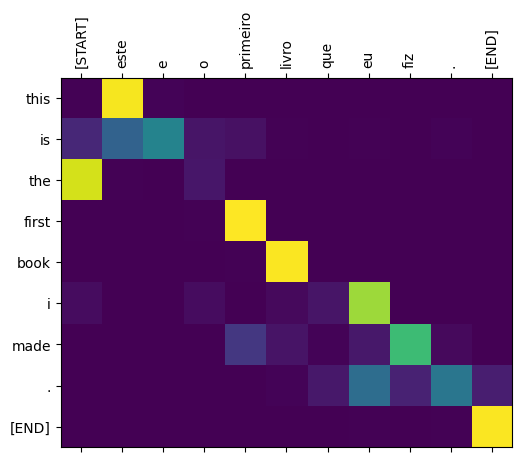

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

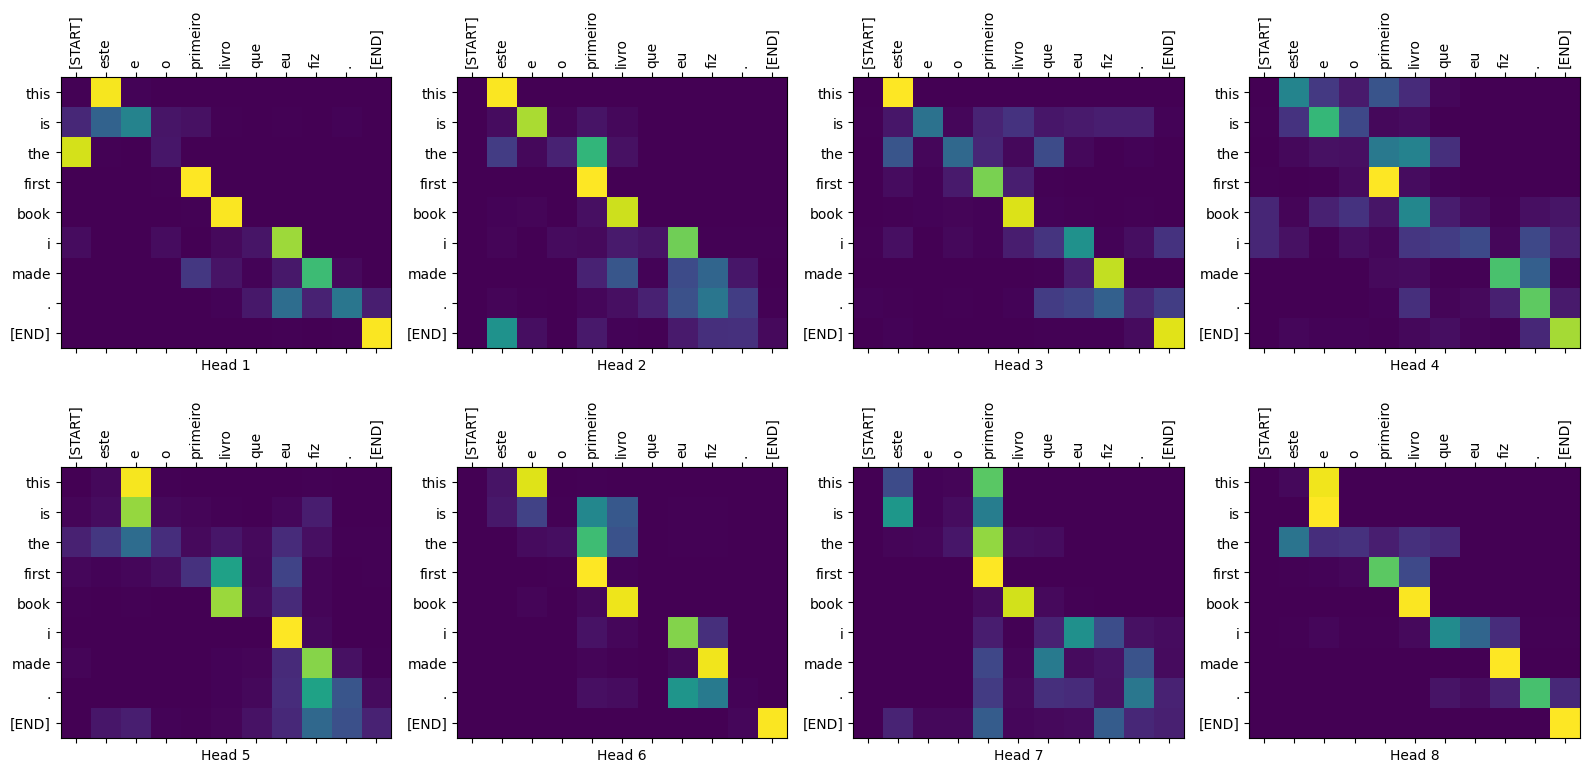

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about tarmal brizs in the encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


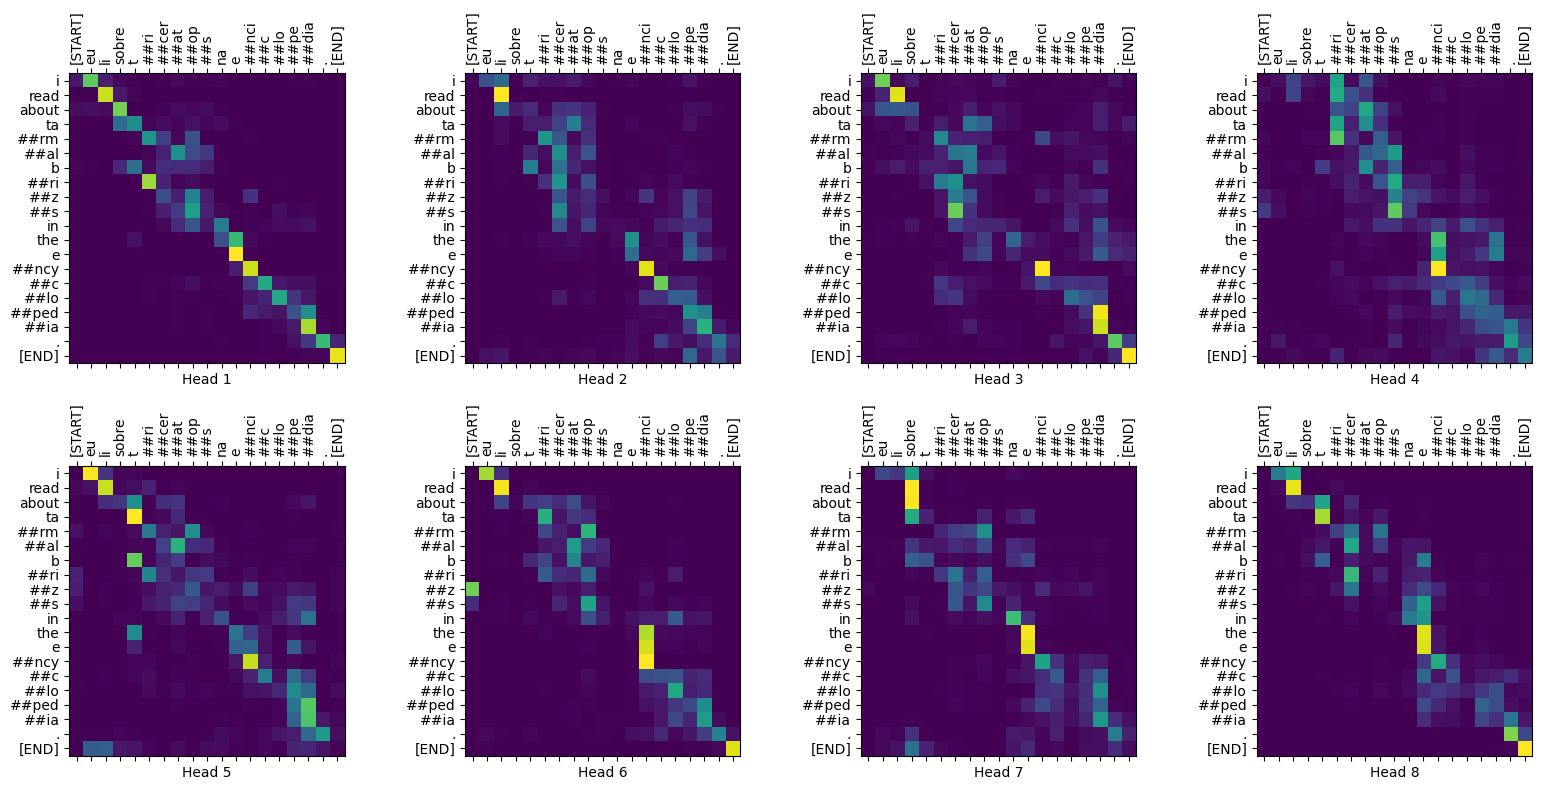

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i made .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)
* Use Beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
